In [2]:
import pypsa
from pypsa.optimization.compat import define_constraints, get_var, join_exprs, linexpr
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import xarray as xr
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.fft import fft, fftfreq
import seaborn as sns
import pandas as pd 
import geopandas as gpd
import numpy as np
from math import pi
import cartopy.crs as ccrs
from regiondefinitions import regions_dic, links_dic
from data_import import syntheticdemand_gis, historic_demand, vre_gen_potential_atlite, region_area
from interconnectors import calculate_flows, efficiency_link, calculate_distance
from pyproj import Geod
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning, message="The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.")

# colour palette
unique_regions = list(regions_dic.keys())
base_palette = sns.color_palette("Set2", 8)
extended_palette = base_palette + sns.color_palette("Set3", 8)
final_palette = extended_palette[:len(unique_regions)]
region_colors = {region: color for region, color in zip(unique_regions, final_palette)}
# Replace the color for 'ups' with a high contrast color
high_contrast_color = sns.color_palette("colorblind")[1]  # Example high contrast color
region_colors['ups'] = high_contrast_color

In [3]:
# Parameter selection
scenario_year = 2050

In [4]:
run_this_cell = True
if run_this_cell:
    # DISTANCES BETWEEN NODES
    for key, value in links_dic.items():
        value["length"] = calculate_distance(value["bus0"][1], value["bus1"][1])

    # EFFICIENCY OF INTERCONNECTORS
    cable_capacity = 1200 # MW
    cable_voltage = 1100 # kV
    cable_resistivity = 0.01286 # ohms/km
    converter_losses = 0.015 # [-]
    for key, value in links_dic.items():
        value["efficiency"] = efficiency_link(cable_capacity, cable_voltage, cable_resistivity, value["length"]) - converter_losses

    # SYNTHETIC -> excludes Europe
    path = "/Volumes/fi246disk/synde/resources/gegis/output"
    load_profile_dic = {}
    for key, value in regions_dic.items():
        load_profile_dic[key] = {}
        if key != "north_america" and key != "europe" and key != "alaska":
            load_profile_dic[key]["load"] = syntheticdemand_gis(path, key, "ssp1-26" ) # MW

    # HISTORIC -> includes Europe and USA
    demand_mult_ssp1_26_oecd = 1.36
    load_profile_dic["europe"]["load"] = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_europe_node_9_utc.csv', 2017, demand_mult_ssp1_26_oecd)
    historic_load_usa = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_usa_2017_utc.csv', 2017, demand_mult_ssp1_26_oecd)
    synthetic_load_north_america_usa = syntheticdemand_gis(path, "north_america_usa", "ssp1-26")
    load_profile_dic["north_america"]["load"] = synthetic_load_north_america_usa

    # RENEWABLE PROFILES
    res_potential_dic = {}
    for key, value in regions_dic.items():
        res_potential_dic[key] = {}
        res_potential_dic[key]["wind"] = vre_gen_potential_atlite(key, "wind", 2023, density=10, land_available=0.08)
        res_potential_dic[key]["pv"] = vre_gen_potential_atlite(key, "pv", 2023, density=45, land_available=0.05) # MW
    
    # Normalizing of RENEWABLE PROFILES
    for key, value in regions_dic.items():
        normalizing_factor_wind = res_potential_dic[key]["wind"].max()
        normalizing_factor_pv = res_potential_dic[key]["pv"].max()
        res_potential_dic[key]['factor_wind'] = normalizing_factor_wind
        res_potential_dic[key]['factor_pv'] = normalizing_factor_pv
        res_potential_dic[key]["wind_normalized"] = res_potential_dic[key]["wind"] / normalizing_factor_wind
        res_potential_dic[key]["pv_normalized"] = res_potential_dic[key]["pv"] / normalizing_factor_pv

# Sensitivity Analysis CapEx vs OpEx

In [5]:
# Dic initiation
sensitivity_cap_op_cost = {}
costs = np.logspace(0, 6, 7)
for cap_cost in costs:
    for op_cost in costs:
        comb_key = f'cap_{cap_cost}_op_{op_cost}'
        # Parameter selection
        cost_capacity_wind = cap_cost
        cost_capacity_pv = cap_cost
        cost_generation_wind = op_cost
        cost_generation_pv = op_cost
        cost_transmission = 1e-4
        cost_curtailment = 0

        # Initialise the network
        n = pypsa.Network() 
        snapshots = pd.date_range(start=f"{scenario_year}-01-01 00:00:00", end=f"{scenario_year}-12-31 23:00:00", freq="h")
        n.set_snapshots(snapshots)

        # Loop over the dictionary to add the buses
        for key, value in regions_dic.items():
            n.add(class_name = "Bus", name = key, carrier = "DC", x = value["coordinates"][0] , y = value["coordinates"][1]) 
            
        # Loop over the dictionary to add the links 
        for key, value in links_dic.items():
            n.add(class_name="Link", name=f'{value["name"]}_0', bus0=value["bus0"][1], bus1=value["bus1"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)
            n.add(class_name="Link", name=f'{value["name"]}_1', bus0=value["bus1"][1], bus1=value["bus0"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)

        # Loop over the dictionary to add the renewable profiles --> these are the renewable potential generated with Atlite
        for key, value in res_potential_dic.items():
            n.add(class_name="Generator", name=f'wind_{key}', type="Wind", bus=key, p_nom_extendable = True, p_nom_max=value['factor_wind'], p_max_pu=value["wind_normalized"][snapshots],p_min_pu=value["wind_normalized"][snapshots], capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
            n.add(class_name="Generator", name=f'pv_{key}', type="PV", bus=key, p_nom_extendable = True, p_nom_max=value['factor_pv'], p_max_pu=value["pv_normalized"][snapshots],p_min_pu=value["pv_normalized"][snapshots],capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
            n.add(class_name="Generator", name=f'curtailment_{key}', type="Curtailment", bus=key, p_nom_extendable=True, marginal_cost=cost_curtailment, sign=-1)

        # Loop over the dictionary to add the demand profiles --> these are the demand profiles for each region
        for key, value in load_profile_dic.items():
            n.add(class_name="Load", name=f"load_{key}", bus=key, p_set=value["load"][snapshots])

        m = n.optimize.create_model();

        n.optimize(solver_name='gurobi')
        total_annual_wind = 0
        total_annual_pv = 0
        for key, value in regions_dic.items(): # Annual (total) values
            for carrier in ["pv", "wind"]: 
                regions_dic[key][f"{carrier}_installed"] = n.generators_t.p[f"{carrier}_{key}"].max() * 1e-3 # GW; Installed capacities for each node 
                regions_dic[key][f"total_{carrier}_yearly"] = n.generators_t.p[f"{carrier}_{key}"].sum(axis=0) * 1e-3 # GWh; Total energy generated at each node 
            
            regions_dic[key][f"total_curtailment_yearly"] = n.generators_t.p[f"curtailment_{key}"].sum(axis=0) * 1e-3 # GWh; Curtailment at each node 
            regions_dic[key][f"total_load_yearly"] = n.loads_t.p[f"load_{key}"].sum(axis=0) * 1e-3 # GWh
            total_annual_wind += value["total_wind_yearly"]
            total_annual_pv += value["total_pv_yearly"]
        total_annual_gen = total_annual_wind + total_annual_pv
        wind_share = total_annual_wind / total_annual_gen
        pv_share = total_annual_pv / total_annual_gen

        # Store hourly losses for each link in dictionary
        for key, value in links_dic.items():
            p0_0, p1_0 = n.links_t.p0[f'{value["name"]}_0'], n.links_t.p1[f'{value["name"]}_0']
            p0_1, p1_1 = n.links_t.p0[f'{value["name"]}_1'], n.links_t.p1[f'{value["name"]}_1']
            abs_losses = abs(p0_0 + p1_0) + abs(p0_1 + p1_1)
            p_trans = p0_0 + p0_1
            value["hourly_p_trans"] = p_trans
            value["hourly_abs_losses"] = abs_losses

        # Sum the transmission and losses of the links
        total_hourly_abs_losses = pd.Series(0, index=n.snapshots)
        total_hourly_p_trans = pd.Series(0, index=n.snapshots)
        for key, value in links_dic.items():
            total_hourly_abs_losses += value["hourly_abs_losses"]
            total_hourly_p_trans += value["hourly_p_trans"]

        # Absolute losses
        total_daily_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.date).sum()
        total_monthly_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).sum()
        total_annual_abs_losses = total_hourly_abs_losses.sum()

        # Power transmitted
        total_daily_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum()
        total_monthly_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum()
        total_annual_p_trans = total_hourly_p_trans.sum()
    
        sensitivity_cap_op_cost[comb_key] = {}
        sensitivity_cap_op_cost[comb_key]['annual_gen'] = total_annual_gen # GWh
        sensitivity_cap_op_cost[comb_key]['wind_pv_share'] = (wind_share, pv_share)
        sensitivity_cap_op_cost[comb_key]['total_trans'] = total_annual_p_trans * 1e-3 # GWh



            

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s]
INFO:linopy.io: Writing time: 4.64s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-w3oqil07.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-w3oqil07.lp


Reading time = 1.97 seconds


INFO:gurobipy:Reading time = 1.97 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x11084d38


INFO:gurobipy:Model fingerprint: 0x11084d38


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.81s


INFO:gurobipy:Presolve time: 0.81s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.06s


INFO:gurobipy:Ordering time: 0.06s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


INFO:gurobipy:   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


INFO:gurobipy:   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


INFO:gurobipy:   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


INFO:gurobipy:   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     2s


INFO:gurobipy:   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     2s


   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     2s


INFO:gurobipy:   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     2s


   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     2s


INFO:gurobipy:   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     2s


   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


INFO:gurobipy:   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


INFO:gurobipy:   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


INFO:gurobipy:   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


INFO:gurobipy:  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


INFO:gurobipy:  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


INFO:gurobipy:  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


INFO:gurobipy:  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


INFO:gurobipy:  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     3s


INFO:gurobipy:  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     3s


  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


INFO:gurobipy:  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


INFO:gurobipy:  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


INFO:gurobipy:  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     3s


INFO:gurobipy:  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     3s


  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


INFO:gurobipy:  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


INFO:gurobipy:  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


INFO:gurobipy:  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     4s


INFO:gurobipy:  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     4s


  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     5s


INFO:gurobipy:  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     5s


  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     5s


INFO:gurobipy:  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     5s


  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


INFO:gurobipy:  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


INFO:gurobipy:  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


INFO:gurobipy:  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     5s


INFO:gurobipy:  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     5s


  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     6s


INFO:gurobipy:  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     6s


  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     6s


INFO:gurobipy:  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     6s


  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     6s


INFO:gurobipy:  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     6s


  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


INFO:gurobipy:  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


INFO:gurobipy:  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     6s


INFO:gurobipy:  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     6s


  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     7s


INFO:gurobipy:  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     7s


  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     7s


INFO:gurobipy:  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     7s


  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


INFO:gurobipy:  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     7s


INFO:gurobipy:  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     7s


  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     7s


INFO:gurobipy:  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     7s


  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     7s


INFO:gurobipy:  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     7s


  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     8s


INFO:gurobipy:  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     8s


  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     8s


INFO:gurobipy:  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     8s


  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     8s


INFO:gurobipy:  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     8s


  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     8s


INFO:gurobipy:  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     8s


  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     8s


INFO:gurobipy:  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     8s


  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     8s


INFO:gurobipy:  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     8s


  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     9s


INFO:gurobipy:  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     9s


  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     9s


INFO:gurobipy:  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     9s


  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     9s


INFO:gurobipy:  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     9s


  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01     9s


INFO:gurobipy:  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01     9s


  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01     9s


INFO:gurobipy:  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01     9s


  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    10s


INFO:gurobipy:  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    10s


  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    10s


INFO:gurobipy:  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    10s


  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    10s


INFO:gurobipy:  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    10s


  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    10s


INFO:gurobipy:  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    10s


  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    10s


INFO:gurobipy:  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    10s


  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    10s


INFO:gurobipy:  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    10s


  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    11s


INFO:gurobipy:  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    11s


  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    11s


INFO:gurobipy:  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    11s


  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    11s


INFO:gurobipy:  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    11s


  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    11s


INFO:gurobipy:  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    11s


  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    11s


INFO:gurobipy:  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    11s


  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    11s


INFO:gurobipy:  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    11s


  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    12s


INFO:gurobipy:  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    12s


  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    12s


INFO:gurobipy:  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    12s


  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    12s


INFO:gurobipy:  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    12s


  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    12s


INFO:gurobipy:  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    12s


  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    12s


INFO:gurobipy:  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    12s


  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    12s


INFO:gurobipy:  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    12s


  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    12s


INFO:gurobipy:  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    12s


  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    12s


INFO:gurobipy:  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    12s


  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    12s


INFO:gurobipy:  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    12s


  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    13s


INFO:gurobipy:  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    13s


  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    13s


INFO:gurobipy:  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    13s


  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    13s


INFO:gurobipy:  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    13s


  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    13s


INFO:gurobipy:  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    13s


  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    13s


INFO:gurobipy:  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    13s


  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    13s


INFO:gurobipy:  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    13s


INFO:gurobipy:


Barrier solved model in 79 iterations and 13.02 seconds (16.01 work units)


INFO:gurobipy:Barrier solved model in 79 iterations and 13.02 seconds (16.01 work units)


Optimal objective 7.14483708e+10


INFO:gurobipy:Optimal objective 7.14483708e+10


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8285 DPushes remaining with DInf 1.1019532e-03                17s


INFO:gurobipy:    8285 DPushes remaining with DInf 1.1019532e-03                17s


       0 DPushes remaining with DInf 1.7061297e-03                18s


INFO:gurobipy:       0 DPushes remaining with DInf 1.7061297e-03                18s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  138317 PPushes remaining with PInf 2.1722281e-02                18s


INFO:gurobipy:  138317 PPushes remaining with PInf 2.1722281e-02                18s


       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     18s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     18s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  145759    7.1447698e+10   0.000000e+00   1.121876e+00     18s


INFO:gurobipy:  145759    7.1447698e+10   0.000000e+00   1.121876e+00     18s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  170613    7.1447108e+10   0.000000e+00   1.666447e-01     20s


INFO:gurobipy:  170613    7.1447108e+10   0.000000e+00   1.666447e-01     20s


Extra simplex iterations after uncrush: 386


INFO:gurobipy:Extra simplex iterations after uncrush: 386


  184010    7.1447033e+10   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:  184010    7.1447033e+10   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:


Solved in 184010 iterations and 21.75 seconds (29.13 work units)


INFO:gurobipy:Solved in 184010 iterations and 21.75 seconds (29.13 work units)


Optimal objective  7.144703292e+10


INFO:gurobipy:Optimal objective  7.144703292e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.57it/s]
INFO:linopy.io: Writing time: 4.55s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-42kh85lz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-42kh85lz.lp


Reading time = 1.75 seconds


INFO:gurobipy:Reading time = 1.75 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xe1d4d38b


INFO:gurobipy:Model fingerprint: 0xe1d4d38b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+01]


INFO:gurobipy:  Objective range  [1e-04, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.73s


INFO:gurobipy:Presolve time: 0.73s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58096951e+14 -3.41694730e+14  4.18e+09 2.11e+01  1.08e+13     1s


INFO:gurobipy:   0   7.58096951e+14 -3.41694730e+14  4.18e+09 2.11e+01  1.08e+13     1s


   1   1.02992042e+15 -7.25429075e+14  7.32e+09 1.66e+03  7.51e+12     1s


INFO:gurobipy:   1   1.02992042e+15 -7.25429075e+14  7.32e+09 1.66e+03  7.51e+12     1s


   2   8.43949802e+14 -1.95155090e+15  6.27e+09 8.62e+02  4.38e+12     1s


INFO:gurobipy:   2   8.43949802e+14 -1.95155090e+15  6.27e+09 8.62e+02  4.38e+12     1s


   3   3.92605167e+14 -2.27867664e+15  2.84e+09 4.87e+02  2.33e+12     1s


INFO:gurobipy:   3   3.92605167e+14 -2.27867664e+15  2.84e+09 4.87e+02  2.33e+12     1s


   4   2.87632747e+14 -3.27137306e+15  1.91e+09 1.88e+02  1.17e+12     1s


INFO:gurobipy:   4   2.87632747e+14 -3.27137306e+15  1.91e+09 1.88e+02  1.17e+12     1s


   5   1.47285304e+14 -3.80820699e+15  8.47e+08 9.72e+01  5.65e+11     1s


INFO:gurobipy:   5   1.47285304e+14 -3.80820699e+15  8.47e+08 9.72e+01  5.65e+11     1s


   6   7.46026441e+13 -5.11680603e+15  3.68e+08 3.46e+01  2.44e+11     1s


INFO:gurobipy:   6   7.46026441e+13 -5.11680603e+15  3.68e+08 3.46e+01  2.44e+11     1s


   7   3.98809007e+13 -5.70479822e+15  1.52e+08 1.65e+01  1.07e+11     1s


INFO:gurobipy:   7   3.98809007e+13 -5.70479822e+15  1.52e+08 1.65e+01  1.07e+11     1s


   8   2.28562266e+13 -5.26910904e+15  4.80e+07 2.34e+00  3.48e+10     2s


INFO:gurobipy:   8   2.28562266e+13 -5.26910904e+15  4.80e+07 2.34e+00  3.48e+10     2s


   9   1.72002740e+13 -3.31156186e+15  1.41e+07 7.36e-01  1.17e+10     2s


INFO:gurobipy:   9   1.72002740e+13 -3.31156186e+15  1.41e+07 7.36e-01  1.17e+10     2s


  10   1.48337025e+13 -8.45676208e+14  0.00e+00 9.80e-02  1.89e+09     2s


INFO:gurobipy:  10   1.48337025e+13 -8.45676208e+14  0.00e+00 9.80e-02  1.89e+09     2s


  11   1.48152292e+13 -4.29079073e+12  0.00e+00 2.15e-03  4.20e+07     2s


INFO:gurobipy:  11   1.48152292e+13 -4.29079073e+12  0.00e+00 2.15e-03  4.20e+07     2s


  12   1.35762415e+13 -9.13814534e+12  0.00e+00 2.99e-03  4.92e+07     2s


INFO:gurobipy:  12   1.35762415e+13 -9.13814534e+12  0.00e+00 2.99e-03  4.92e+07     2s


  13   1.30216808e+13 -3.81220694e+12  0.00e+00 1.74e-03  3.64e+07     2s


INFO:gurobipy:  13   1.30216808e+13 -3.81220694e+12  0.00e+00 1.74e-03  3.64e+07     2s


  14   1.15697275e+13 -3.38032091e+12  0.00e+00 1.54e-03  3.23e+07     2s


INFO:gurobipy:  14   1.15697275e+13 -3.38032091e+12  0.00e+00 1.54e-03  3.23e+07     2s


  15   1.13774637e+13 -2.06940468e+12  0.00e+00 1.19e-03  2.91e+07     2s


INFO:gurobipy:  15   1.13774637e+13 -2.06940468e+12  0.00e+00 1.19e-03  2.91e+07     2s


  16   1.11813939e+13 -2.14253709e+12  0.00e+00 1.14e-03  2.88e+07     2s


INFO:gurobipy:  16   1.11813939e+13 -2.14253709e+12  0.00e+00 1.14e-03  2.88e+07     2s


  17   8.93747529e+12 -1.58332423e+12  0.00e+00 9.75e-04  2.27e+07     2s


INFO:gurobipy:  17   8.93747529e+12 -1.58332423e+12  0.00e+00 9.75e-04  2.27e+07     2s


  18   5.01300019e+12 -7.45824839e+11  0.00e+00 1.22e-03  1.24e+07     3s


INFO:gurobipy:  18   5.01300019e+12 -7.45824839e+11  0.00e+00 1.22e-03  1.24e+07     3s


  19   3.98367501e+12  1.35832357e+11  0.00e+00 1.03e-03  8.28e+06     3s


INFO:gurobipy:  19   3.98367501e+12  1.35832357e+11  0.00e+00 1.03e-03  8.28e+06     3s


  20   3.33623169e+12  2.78957204e+11  0.00e+00 1.21e-03  6.58e+06     3s


INFO:gurobipy:  20   3.33623169e+12  2.78957204e+11  0.00e+00 1.21e-03  6.58e+06     3s


  21   2.85591586e+12  3.33909726e+11  0.00e+00 1.47e-03  5.42e+06     3s


INFO:gurobipy:  21   2.85591586e+12  3.33909726e+11  0.00e+00 1.47e-03  5.42e+06     3s


  22   2.19713248e+12  4.08426451e+11  0.00e+00 1.77e-03  3.84e+06     3s


INFO:gurobipy:  22   2.19713248e+12  4.08426451e+11  0.00e+00 1.77e-03  3.84e+06     3s


  23   1.20506029e+12  4.24545091e+11  0.00e+00 1.86e-03  1.67e+06     3s


INFO:gurobipy:  23   1.20506029e+12  4.24545091e+11  0.00e+00 1.86e-03  1.67e+06     3s


  24   9.64955098e+11  5.35013953e+11  0.00e+00 5.85e-03  9.13e+05     4s


INFO:gurobipy:  24   9.64955098e+11  5.35013953e+11  0.00e+00 5.85e-03  9.13e+05     4s


  25   8.51196518e+11  5.53523391e+11  0.00e+00 3.28e-03  6.30e+05     4s


INFO:gurobipy:  25   8.51196518e+11  5.53523391e+11  0.00e+00 3.28e-03  6.30e+05     4s


  26   8.38133885e+11  5.61152338e+11  0.00e+00 2.93e-03  5.86e+05     4s


INFO:gurobipy:  26   8.38133885e+11  5.61152338e+11  0.00e+00 2.93e-03  5.86e+05     4s


  27   7.79550802e+11  5.67448070e+11  0.00e+00 2.73e-03  4.48e+05     4s


INFO:gurobipy:  27   7.79550802e+11  5.67448070e+11  0.00e+00 2.73e-03  4.48e+05     4s


  28   7.45715289e+11  5.88451145e+11  0.00e+00 2.64e-03  3.32e+05     4s


INFO:gurobipy:  28   7.45715289e+11  5.88451145e+11  0.00e+00 2.64e-03  3.32e+05     4s


  29   7.42293185e+11  6.02543989e+11  0.00e+00 2.40e-03  2.95e+05     4s


INFO:gurobipy:  29   7.42293185e+11  6.02543989e+11  0.00e+00 2.40e-03  2.95e+05     4s


  30   7.27251543e+11  6.10467904e+11  0.00e+00 2.25e-03  2.46e+05     5s


INFO:gurobipy:  30   7.27251543e+11  6.10467904e+11  0.00e+00 2.25e-03  2.46e+05     5s


  31   7.22019164e+11  6.25046020e+11  0.00e+00 1.92e-03  2.04e+05     5s


INFO:gurobipy:  31   7.22019164e+11  6.25046020e+11  0.00e+00 1.92e-03  2.04e+05     5s


  32   7.21341951e+11  6.51124620e+11  0.00e+00 1.41e-03  1.48e+05     5s


INFO:gurobipy:  32   7.21341951e+11  6.51124620e+11  0.00e+00 1.41e-03  1.48e+05     5s


  33   7.18408837e+11  6.82232382e+11  0.00e+00 6.82e-04  7.62e+04     5s


INFO:gurobipy:  33   7.18408837e+11  6.82232382e+11  0.00e+00 6.82e-04  7.62e+04     5s


  34   7.16140278e+11  7.04651986e+11  0.00e+00 2.37e-04  2.42e+04     5s


INFO:gurobipy:  34   7.16140278e+11  7.04651986e+11  0.00e+00 2.37e-04  2.42e+04     5s


  35   7.15661463e+11  7.11763287e+11  0.00e+00 8.70e-05  8.24e+03     5s


INFO:gurobipy:  35   7.15661463e+11  7.11763287e+11  0.00e+00 8.70e-05  8.24e+03     5s


  36   7.14804959e+11  7.13387120e+11  0.00e+00 2.86e-05  3.00e+03     6s


INFO:gurobipy:  36   7.14804959e+11  7.13387120e+11  0.00e+00 2.86e-05  3.00e+03     6s


  37   7.14505101e+11  7.13867185e+11  0.00e+00 1.06e-05  1.35e+03     6s


INFO:gurobipy:  37   7.14505101e+11  7.13867185e+11  0.00e+00 1.06e-05  1.35e+03     6s


  38   7.14299283e+11  7.14062711e+11  0.00e+00 4.85e-06  5.00e+02     6s


INFO:gurobipy:  38   7.14299283e+11  7.14062711e+11  0.00e+00 4.85e-06  5.00e+02     6s


  39   7.14253257e+11  7.14173324e+11  0.00e+00 1.65e-06  1.68e+02     6s


INFO:gurobipy:  39   7.14253257e+11  7.14173324e+11  0.00e+00 1.65e-06  1.68e+02     6s


  40   7.14241717e+11  7.14192583e+11  0.00e+00 1.94e-06  1.03e+02     6s


INFO:gurobipy:  40   7.14241717e+11  7.14192583e+11  0.00e+00 1.94e-06  1.03e+02     6s


  41   7.14225368e+11  7.14211324e+11  0.00e+00 3.27e-06  2.80e+01     6s


INFO:gurobipy:  41   7.14225368e+11  7.14211324e+11  0.00e+00 3.27e-06  2.80e+01     6s


  42   7.14221407e+11  7.14215514e+11  0.00e+00 2.88e-06  1.06e+01     7s


INFO:gurobipy:  42   7.14221407e+11  7.14215514e+11  0.00e+00 2.88e-06  1.06e+01     7s


  43   7.14220173e+11  7.14216976e+11  0.00e+00 2.95e-06  4.89e+00     7s


INFO:gurobipy:  43   7.14220173e+11  7.14216976e+11  0.00e+00 2.95e-06  4.89e+00     7s


  44   7.14219410e+11  7.14217327e+11  0.00e+00 2.81e-06  2.59e+00     7s


INFO:gurobipy:  44   7.14219410e+11  7.14217327e+11  0.00e+00 2.81e-06  2.59e+00     7s


  45   7.14219062e+11  7.14217490e+11  0.00e+00 2.68e-06  1.57e+00     7s


INFO:gurobipy:  45   7.14219062e+11  7.14217490e+11  0.00e+00 2.68e-06  1.57e+00     7s


  46   7.14218861e+11  7.14217579e+11  0.00e+00 2.68e-06  1.01e+00     7s


INFO:gurobipy:  46   7.14218861e+11  7.14217579e+11  0.00e+00 2.68e-06  1.01e+00     7s


  47   7.14218731e+11  7.14217666e+11  0.00e+00 2.68e-06  6.03e-01     7s


INFO:gurobipy:  47   7.14218731e+11  7.14217666e+11  0.00e+00 2.68e-06  6.03e-01     7s


  48   7.14218639e+11  7.14217710e+11  0.00e+00 2.65e-06  3.63e-01     8s


INFO:gurobipy:  48   7.14218639e+11  7.14217710e+11  0.00e+00 2.65e-06  3.63e-01     8s


  49   7.14218593e+11  7.14217724e+11  0.00e+00 2.58e-06  2.64e-01     8s


INFO:gurobipy:  49   7.14218593e+11  7.14217724e+11  0.00e+00 2.58e-06  2.64e-01     8s


  50   7.14218555e+11  7.14217741e+11  0.00e+00 2.60e-06  1.79e-01     8s


INFO:gurobipy:  50   7.14218555e+11  7.14217741e+11  0.00e+00 2.60e-06  1.79e-01     8s


  51   7.14218542e+11  7.14217750e+11  0.00e+00 2.64e-06  1.47e-01     8s


INFO:gurobipy:  51   7.14218542e+11  7.14217750e+11  0.00e+00 2.64e-06  1.47e-01     8s


  52   7.14218527e+11  7.14217752e+11  0.00e+00 2.66e-06  1.23e-01     8s


INFO:gurobipy:  52   7.14218527e+11  7.14217752e+11  0.00e+00 2.66e-06  1.23e-01     8s


  53   7.14218515e+11  7.14217758e+11  0.00e+00 2.68e-06  9.98e-02     9s


INFO:gurobipy:  53   7.14218515e+11  7.14217758e+11  0.00e+00 2.68e-06  9.98e-02     9s


  54   7.14218497e+11  7.14217762e+11  0.00e+00 2.67e-06  7.22e-02     9s


INFO:gurobipy:  54   7.14218497e+11  7.14217762e+11  0.00e+00 2.67e-06  7.22e-02     9s


  55   7.14218483e+11  7.14217766e+11  0.00e+00 2.63e-06  4.96e-02     9s


INFO:gurobipy:  55   7.14218483e+11  7.14217766e+11  0.00e+00 2.63e-06  4.96e-02     9s


  56   7.14218471e+11  7.14217768e+11  0.00e+00 2.61e-06  3.31e-02     9s


INFO:gurobipy:  56   7.14218471e+11  7.14217768e+11  0.00e+00 2.61e-06  3.31e-02     9s


  57   7.14218468e+11  7.14217768e+11  0.00e+00 2.61e-06  2.94e-02     9s


INFO:gurobipy:  57   7.14218468e+11  7.14217768e+11  0.00e+00 2.61e-06  2.94e-02     9s


  58   7.14218461e+11  7.14217769e+11  0.00e+00 2.60e-06  2.14e-02     9s


INFO:gurobipy:  58   7.14218461e+11  7.14217769e+11  0.00e+00 2.60e-06  2.14e-02     9s


  59   7.14218459e+11  7.14217769e+11  0.00e+00 2.60e-06  1.98e-02     9s


INFO:gurobipy:  59   7.14218459e+11  7.14217769e+11  0.00e+00 2.60e-06  1.98e-02     9s


  60   7.14218454e+11  7.14217770e+11  0.00e+00 2.49e-06  1.53e-02    10s


INFO:gurobipy:  60   7.14218454e+11  7.14217770e+11  0.00e+00 2.49e-06  1.53e-02    10s


INFO:gurobipy:


Barrier solved model in 60 iterations and 9.58 seconds (12.72 work units)


INFO:gurobipy:Barrier solved model in 60 iterations and 9.58 seconds (12.72 work units)


Optimal objective 7.14218454e+11


INFO:gurobipy:Optimal objective 7.14218454e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   10976 DPushes remaining with DInf 2.6601816e-02                13s


INFO:gurobipy:   10976 DPushes remaining with DInf 2.6601816e-02                13s


       0 DPushes remaining with DInf 3.6279563e-02                13s


INFO:gurobipy:       0 DPushes remaining with DInf 3.6279563e-02                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  100854 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:  100854 PPushes remaining with PInf 0.0000000e+00                13s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.2265009e-01     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.2265009e-01     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  110524    7.1421865e+11   0.000000e+00   9.226501e-01     14s


INFO:gurobipy:  110524    7.1421865e+11   0.000000e+00   9.226501e-01     14s


  129790    7.1421809e+11   0.000000e+00   3.426795e-02     15s


INFO:gurobipy:  129790    7.1421809e+11   0.000000e+00   3.426795e-02     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 376


INFO:gurobipy:Extra simplex iterations after uncrush: 376


  152747    7.1421787e+11   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:  152747    7.1421787e+11   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:


Solved in 152747 iterations and 17.47 seconds (26.68 work units)


INFO:gurobipy:Solved in 152747 iterations and 17.47 seconds (26.68 work units)


Optimal objective  7.142178688e+11


INFO:gurobipy:Optimal objective  7.142178688e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s]
INFO:linopy.io: Writing time: 4.46s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-qkzl7a62.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-qkzl7a62.lp


Reading time = 1.77 seconds


INFO:gurobipy:Reading time = 1.77 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x30f54717


INFO:gurobipy:Model fingerprint: 0x30f54717


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.73s


INFO:gurobipy:Presolve time: 0.73s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58024378e+15 -3.41680377e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58024378e+15 -3.41680377e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.02983624e+16 -7.25398607e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.02983624e+16 -7.25398607e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.43873994e+15 -1.95146907e+16  6.27e+09 8.62e+03  4.38e+13     1s


INFO:gurobipy:   2   8.43873994e+15 -1.95146907e+16  6.27e+09 8.62e+03  4.38e+13     1s


   3   3.92547918e+15 -2.27858161e+16  2.84e+09 4.87e+03  2.33e+13     1s


INFO:gurobipy:   3   3.92547918e+15 -2.27858161e+16  2.84e+09 4.87e+03  2.33e+13     1s


   4   2.87582357e+15 -3.27123631e+16  1.91e+09 1.88e+03  1.17e+13     1s


INFO:gurobipy:   4   2.87582357e+15 -3.27123631e+16  1.91e+09 1.88e+03  1.17e+13     1s


   5   1.47251645e+15 -3.80804642e+16  8.47e+08 9.72e+02  5.65e+12     1s


INFO:gurobipy:   5   1.47251645e+15 -3.80804642e+16  8.47e+08 9.72e+02  5.65e+12     1s


   6   7.45837410e+14 -5.11658933e+16  3.68e+08 3.46e+02  2.44e+12     1s


INFO:gurobipy:   6   7.45837410e+14 -5.11658933e+16  3.68e+08 3.46e+02  2.44e+12     1s


   7   3.98715001e+14 -5.70455626e+16  1.52e+08 1.65e+02  1.07e+12     1s


INFO:gurobipy:   7   3.98715001e+14 -5.70455626e+16  1.52e+08 1.65e+02  1.07e+12     1s


   8   2.28518787e+14 -5.26888659e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.28518787e+14 -5.26888659e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.71977375e+14 -3.31142344e+16  1.41e+07 7.36e+00  1.17e+11     2s


INFO:gurobipy:   9   1.71977375e+14 -3.31142344e+16  1.41e+07 7.36e+00  1.17e+11     2s


  10   1.48319189e+14 -8.45644175e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48319189e+14 -8.45644175e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48134502e+14 -4.28982380e+13  0.00e+00 2.17e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48134502e+14 -4.28982380e+13  0.00e+00 2.17e-02  4.20e+08     2s


  12   1.35553997e+14 -3.22077268e+13  0.00e+00 1.14e-02  3.65e+08     2s


INFO:gurobipy:  12   1.35553997e+14 -3.22077268e+13  0.00e+00 1.14e-02  3.65e+08     2s


  13   1.30185925e+14 -1.73519408e+13  0.00e+00 1.03e-02  3.21e+08     2s


INFO:gurobipy:  13   1.30185925e+14 -1.73519408e+13  0.00e+00 1.03e-02  3.21e+08     2s


  14   1.15884447e+14 -1.97390145e+13  0.00e+00 1.03e-02  2.94e+08     2s


INFO:gurobipy:  14   1.15884447e+14 -1.97390145e+13  0.00e+00 1.03e-02  2.94e+08     2s


  15   1.08975159e+14 -1.39841300e+13  0.00e+00 8.83e-03  2.67e+08     2s


INFO:gurobipy:  15   1.08975159e+14 -1.39841300e+13  0.00e+00 8.83e-03  2.67e+08     2s


  16   9.75948617e+13 -1.47618872e+13  0.00e+00 8.18e-03  2.43e+08     2s


INFO:gurobipy:  16   9.75948617e+13 -1.47618872e+13  0.00e+00 8.18e-03  2.43e+08     2s


  17   7.44689777e+13 -9.56879615e+12  0.00e+00 7.49e-03  1.82e+08     2s


INFO:gurobipy:  17   7.44689777e+13 -9.56879615e+12  0.00e+00 7.49e-03  1.82e+08     2s


  18   5.51983829e+13 -3.99169478e+12  0.00e+00 3.29e-03  1.28e+08     2s


INFO:gurobipy:  18   5.51983829e+13 -3.99169478e+12  0.00e+00 3.29e-03  1.28e+08     2s


  19   4.72212457e+13 -2.94358544e+12  0.00e+00 2.80e-03  1.08e+08     2s


INFO:gurobipy:  19   4.72212457e+13 -2.94358544e+12  0.00e+00 2.80e-03  1.08e+08     2s


  20   3.75379074e+13 -1.00236324e+12  0.00e+00 2.87e-03  8.32e+07     2s


INFO:gurobipy:  20   3.75379074e+13 -1.00236324e+12  0.00e+00 2.87e-03  8.32e+07     2s


  21   2.53710791e+13  1.62269926e+12  0.00e+00 4.74e-03  5.12e+07     3s


INFO:gurobipy:  21   2.53710791e+13  1.62269926e+12  0.00e+00 4.74e-03  5.12e+07     3s


  22   1.92687262e+13  3.54973970e+12  0.00e+00 5.10e-03  3.39e+07     3s


INFO:gurobipy:  22   1.92687262e+13  3.54973970e+12  0.00e+00 5.10e-03  3.39e+07     3s


  23   1.28214881e+13  5.09518297e+12  0.00e+00 4.30e-03  1.66e+07     3s


INFO:gurobipy:  23   1.28214881e+13  5.09518297e+12  0.00e+00 4.30e-03  1.66e+07     3s


  24   8.85470814e+12  5.44799480e+12  0.00e+00 2.67e-03  7.34e+06     3s


INFO:gurobipy:  24   8.85470814e+12  5.44799480e+12  0.00e+00 2.67e-03  7.34e+06     3s


  25   8.37802707e+12  5.58776004e+12  0.00e+00 1.86e-03  6.01e+06     3s


INFO:gurobipy:  25   8.37802707e+12  5.58776004e+12  0.00e+00 1.86e-03  6.01e+06     3s


  26   7.79468894e+12  5.70324530e+12  0.00e+00 1.52e-03  4.50e+06     3s


INFO:gurobipy:  26   7.79468894e+12  5.70324530e+12  0.00e+00 1.52e-03  4.50e+06     3s


  27   7.55841610e+12  5.79985634e+12  0.00e+00 1.23e-03  3.79e+06     3s


INFO:gurobipy:  27   7.55841610e+12  5.79985634e+12  0.00e+00 1.23e-03  3.79e+06     3s


  28   7.44443081e+12  5.96672828e+12  0.00e+00 8.51e-04  3.18e+06     4s


INFO:gurobipy:  28   7.44443081e+12  5.96672828e+12  0.00e+00 8.51e-04  3.18e+06     4s


  29   7.38988874e+12  6.17438484e+12  0.00e+00 5.58e-04  2.62e+06     4s


INFO:gurobipy:  29   7.38988874e+12  6.17438484e+12  0.00e+00 5.58e-04  2.62e+06     4s


  30   7.22997033e+12  6.26048325e+12  0.00e+00 4.76e-04  2.09e+06     4s


INFO:gurobipy:  30   7.22997033e+12  6.26048325e+12  0.00e+00 4.76e-04  2.09e+06     4s


  31   7.19674271e+12  6.49416220e+12  0.00e+00 3.32e-04  1.51e+06     4s


INFO:gurobipy:  31   7.19674271e+12  6.49416220e+12  0.00e+00 3.32e-04  1.51e+06     4s


  32   7.19562512e+12  6.60300107e+12  0.00e+00 2.72e-04  1.28e+06     4s


INFO:gurobipy:  32   7.19562512e+12  6.60300107e+12  0.00e+00 2.72e-04  1.28e+06     4s


  33   7.16310195e+12  6.80398253e+12  0.00e+00 1.63e-04  7.73e+05     5s


INFO:gurobipy:  33   7.16310195e+12  6.80398253e+12  0.00e+00 1.63e-04  7.73e+05     5s


  34   7.14849240e+12  7.03766110e+12  0.00e+00 4.89e-05  2.39e+05     5s


INFO:gurobipy:  34   7.14849240e+12  7.03766110e+12  0.00e+00 4.89e-05  2.39e+05     5s


  35   7.14286426e+12  7.12784735e+12  0.00e+00 7.03e-06  3.23e+04     5s


INFO:gurobipy:  35   7.14286426e+12  7.12784735e+12  0.00e+00 7.03e-06  3.23e+04     5s


  36   7.14208385e+12  7.13688616e+12  0.00e+00 2.66e-06  1.12e+04     5s


INFO:gurobipy:  36   7.14208385e+12  7.13688616e+12  0.00e+00 2.66e-06  1.12e+04     5s


  37   7.14196620e+12  7.14035768e+12  0.00e+00 1.68e-06  3.47e+03     5s


INFO:gurobipy:  37   7.14196620e+12  7.14035768e+12  0.00e+00 1.68e-06  3.47e+03     5s


  38   7.14194606e+12  7.14183029e+12  0.00e+00 5.75e-07  2.50e+02     5s


INFO:gurobipy:  38   7.14194606e+12  7.14183029e+12  0.00e+00 5.75e-07  2.50e+02     5s


  39   7.14193923e+12  7.14190739e+12  0.00e+00 1.81e-06  6.80e+01     6s


INFO:gurobipy:  39   7.14193923e+12  7.14190739e+12  0.00e+00 1.81e-06  6.80e+01     6s


  40   7.14193531e+12  7.14192062e+12  0.00e+00 3.32e-06  3.03e+01     6s


INFO:gurobipy:  40   7.14193531e+12  7.14192062e+12  0.00e+00 3.32e-06  3.03e+01     6s


  41   7.14193173e+12  7.14192362e+12  0.00e+00 3.50e-06  1.59e+01     6s


INFO:gurobipy:  41   7.14193173e+12  7.14192362e+12  0.00e+00 3.50e-06  1.59e+01     6s


  42   7.14192965e+12  7.14192464e+12  0.00e+00 3.21e-06  9.19e+00     6s


INFO:gurobipy:  42   7.14192965e+12  7.14192464e+12  0.00e+00 3.21e-06  9.19e+00     6s


  43   7.14192816e+12  7.14192543e+12  0.00e+00 3.02e-06  4.37e+00     6s


INFO:gurobipy:  43   7.14192816e+12  7.14192543e+12  0.00e+00 3.02e-06  4.37e+00     6s


  44   7.14192743e+12  7.14192571e+12  0.00e+00 2.86e-06  2.33e+00     6s


INFO:gurobipy:  44   7.14192743e+12  7.14192571e+12  0.00e+00 2.86e-06  2.33e+00     6s


  45   7.14192713e+12  7.14192585e+12  0.00e+00 2.76e-06  1.46e+00     6s


INFO:gurobipy:  45   7.14192713e+12  7.14192585e+12  0.00e+00 2.76e-06  1.46e+00     6s


  46   7.14192700e+12  7.14192596e+12  0.00e+00 2.70e-06  9.96e-01     7s


INFO:gurobipy:  46   7.14192700e+12  7.14192596e+12  0.00e+00 2.70e-06  9.96e-01     7s


  47   7.14192687e+12  7.14192602e+12  0.00e+00 2.71e-06  6.54e-01     7s


INFO:gurobipy:  47   7.14192687e+12  7.14192602e+12  0.00e+00 2.71e-06  6.54e-01     7s


  48   7.14192681e+12  7.14192608e+12  0.00e+00 2.71e-06  4.30e-01     7s


INFO:gurobipy:  48   7.14192681e+12  7.14192608e+12  0.00e+00 2.71e-06  4.30e-01     7s


  49   7.14192674e+12  7.14192611e+12  0.00e+00 2.69e-06  2.69e-01     7s


INFO:gurobipy:  49   7.14192674e+12  7.14192611e+12  0.00e+00 2.69e-06  2.69e-01     7s


  50   7.14192669e+12  7.14192613e+12  0.00e+00 2.68e-06  1.67e-01     7s


INFO:gurobipy:  50   7.14192669e+12  7.14192613e+12  0.00e+00 2.68e-06  1.67e-01     7s


  51   7.14192666e+12  7.14192614e+12  0.00e+00 2.64e-06  1.17e-01     7s


INFO:gurobipy:  51   7.14192666e+12  7.14192614e+12  0.00e+00 2.64e-06  1.17e-01     7s


INFO:gurobipy:


Barrier solved model in 51 iterations and 7.34 seconds (9.87 work units)


INFO:gurobipy:Barrier solved model in 51 iterations and 7.34 seconds (9.87 work units)


Optimal objective 7.14192666e+12


INFO:gurobipy:Optimal objective 7.14192666e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13538 DPushes remaining with DInf 1.9031686e-03                11s


INFO:gurobipy:   13538 DPushes remaining with DInf 1.9031686e-03                11s


       0 DPushes remaining with DInf 2.9513870e-03                11s


INFO:gurobipy:       0 DPushes remaining with DInf 2.9513870e-03                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  154667 PPushes remaining with PInf 6.5881288e-01                11s


INFO:gurobipy:  154667 PPushes remaining with PInf 6.5881288e-01                11s


       0 PPushes remaining with PInf 4.7927250e+05                12s


INFO:gurobipy:       0 PPushes remaining with PInf 4.7927250e+05                12s


INFO:gurobipy:


  Push phase complete: Pinf 4.7927250e+05, Dinf 1.6867091e+07     12s


INFO:gurobipy:  Push phase complete: Pinf 4.7927250e+05, Dinf 1.6867091e+07     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  163414    7.1419782e+12   0.000000e+00   1.686709e+07     12s


INFO:gurobipy:  163414    7.1419782e+12   0.000000e+00   1.686709e+07     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  204239    7.1419262e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  204239    7.1419262e+12   0.000000e+00   0.000000e+00     16s


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


  204614    7.1419262e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  204614    7.1419262e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 204614 iterations and 16.07 seconds (25.15 work units)


INFO:gurobipy:Solved in 204614 iterations and 16.07 seconds (25.15 work units)


Optimal objective  7.141926228e+12


INFO:gurobipy:Optimal objective  7.141926228e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s]
INFO:linopy.io: Writing time: 4.49s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-y0ttdxor.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-y0ttdxor.lp


Reading time = 1.73 seconds


INFO:gurobipy:Reading time = 1.73 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x857c7b94


INFO:gurobipy:Model fingerprint: 0x857c7b94


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.78s


INFO:gurobipy:Presolve time: 0.78s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58017121e+16 -3.41678942e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58017121e+16 -3.41678942e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.02982782e+17 -7.25395560e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.02982782e+17 -7.25395560e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.43866413e+16 -1.95146089e+17  6.27e+09 8.62e+04  4.38e+14     1s


INFO:gurobipy:   2   8.43866413e+16 -1.95146089e+17  6.27e+09 8.62e+04  4.38e+14     1s


   3   3.92542193e+16 -2.27857211e+17  2.84e+09 4.87e+04  2.33e+14     1s


INFO:gurobipy:   3   3.92542193e+16 -2.27857211e+17  2.84e+09 4.87e+04  2.33e+14     1s


   4   2.87577318e+16 -3.27122263e+17  1.91e+09 1.88e+04  1.17e+14     1s


INFO:gurobipy:   4   2.87577318e+16 -3.27122263e+17  1.91e+09 1.88e+04  1.17e+14     1s


   5   1.47248279e+16 -3.80803036e+17  8.47e+08 9.72e+03  5.65e+13     1s


INFO:gurobipy:   5   1.47248279e+16 -3.80803036e+17  8.47e+08 9.72e+03  5.65e+13     1s


   6   7.45818507e+15 -5.11656766e+17  3.68e+08 3.46e+03  2.44e+13     1s


INFO:gurobipy:   6   7.45818507e+15 -5.11656766e+17  3.68e+08 3.46e+03  2.44e+13     1s


   7   3.98705600e+15 -5.70453206e+17  1.52e+08 1.65e+03  1.07e+13     2s


INFO:gurobipy:   7   3.98705600e+15 -5.70453206e+17  1.52e+08 1.65e+03  1.07e+13     2s


   8   2.28514439e+15 -5.26886435e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28514439e+15 -5.26886435e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.71974838e+15 -3.31140960e+17  1.41e+07 7.36e+01  1.17e+12     2s


INFO:gurobipy:   9   1.71974838e+15 -3.31140960e+17  1.41e+07 7.36e+01  1.17e+12     2s


  10   1.48317406e+15 -8.45640972e+16  0.00e+00 9.79e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48317406e+15 -8.45640972e+16  0.00e+00 9.79e+00  1.89e+11     2s


  11   1.48132723e+15 -4.28972708e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48132723e+15 -4.28972708e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35552366e+15 -3.22078210e+14  0.00e+00 1.02e-01  3.65e+09     2s


INFO:gurobipy:  12   1.35552366e+15 -3.22078210e+14  0.00e+00 1.02e-01  3.65e+09     2s


  13   1.30470330e+15 -1.75443125e+14  0.00e+00 7.26e-02  3.22e+09     2s


INFO:gurobipy:  13   1.30470330e+15 -1.75443125e+14  0.00e+00 7.26e-02  3.22e+09     2s


  14   1.19863459e+15 -2.06598633e+14  0.00e+00 6.94e-02  3.05e+09     2s


INFO:gurobipy:  14   1.19863459e+15 -2.06598633e+14  0.00e+00 6.94e-02  3.05e+09     2s


  15   1.08217647e+15 -1.55449899e+14  0.00e+00 4.98e-02  2.68e+09     2s


INFO:gurobipy:  15   1.08217647e+15 -1.55449899e+14  0.00e+00 4.98e-02  2.68e+09     2s


  16   1.06546379e+15 -7.21815569e+13  0.00e+00 4.17e-02  2.46e+09     2s


INFO:gurobipy:  16   1.06546379e+15 -7.21815569e+13  0.00e+00 4.17e-02  2.46e+09     2s


  17   9.88660952e+14 -7.97293385e+13  0.00e+00 4.06e-02  2.31e+09     2s


INFO:gurobipy:  17   9.88660952e+14 -7.97293385e+13  0.00e+00 4.06e-02  2.31e+09     2s


  18   7.62862902e+14 -6.66090581e+13  0.00e+00 3.80e-02  1.79e+09     2s


INFO:gurobipy:  18   7.62862902e+14 -6.66090581e+13  0.00e+00 3.80e-02  1.79e+09     2s


  19   6.92891711e+14 -6.89186953e+13  0.00e+00 3.24e-02  1.65e+09     2s


INFO:gurobipy:  19   6.92891711e+14 -6.89186953e+13  0.00e+00 3.24e-02  1.65e+09     2s


  20   5.19880269e+14 -4.09381853e+13  0.00e+00 1.31e-02  1.21e+09     3s


INFO:gurobipy:  20   5.19880269e+14 -4.09381853e+13  0.00e+00 1.31e-02  1.21e+09     3s


  21   2.68437863e+14  2.00566911e+13  0.00e+00 5.29e-03  5.36e+08     3s


INFO:gurobipy:  21   2.68437863e+14  2.00566911e+13  0.00e+00 5.29e-03  5.36e+08     3s


  22   2.30103847e+14  3.58115745e+13  0.00e+00 1.04e-07  4.19e+08     3s


INFO:gurobipy:  22   2.30103847e+14  3.58115745e+13  0.00e+00 1.04e-07  4.19e+08     3s


  23   1.47639651e+14  3.71907638e+13  0.00e+00 9.81e-08  2.38e+08     3s


INFO:gurobipy:  23   1.47639651e+14  3.71907638e+13  0.00e+00 9.81e-08  2.38e+08     3s


  24   1.06733451e+14  4.31553966e+13  0.00e+00 6.65e-08  1.37e+08     3s


INFO:gurobipy:  24   1.06733451e+14  4.31553966e+13  0.00e+00 6.65e-08  1.37e+08     3s


  25   8.67436908e+13  5.18813614e+13  0.00e+00 4.52e-04  7.51e+07     3s


INFO:gurobipy:  25   8.67436908e+13  5.18813614e+13  0.00e+00 4.52e-04  7.51e+07     3s


  26   8.29218916e+13  5.37971234e+13  0.00e+00 1.67e-03  6.27e+07     3s


INFO:gurobipy:  26   8.29218916e+13  5.37971234e+13  0.00e+00 1.67e-03  6.27e+07     3s


  27   7.88078684e+13  5.52734220e+13  0.00e+00 1.74e-03  5.07e+07     3s


INFO:gurobipy:  27   7.88078684e+13  5.52734220e+13  0.00e+00 1.74e-03  5.07e+07     3s


  28   7.67316054e+13  5.71111127e+13  0.00e+00 2.20e-03  4.23e+07     3s


INFO:gurobipy:  28   7.67316054e+13  5.71111127e+13  0.00e+00 2.20e-03  4.23e+07     3s


  29   7.46684165e+13  5.91330601e+13  0.00e+00 2.03e-03  3.35e+07     3s


INFO:gurobipy:  29   7.46684165e+13  5.91330601e+13  0.00e+00 2.03e-03  3.35e+07     3s


  30   7.33862568e+13  6.07473387e+13  0.00e+00 1.52e-03  2.72e+07     3s


INFO:gurobipy:  30   7.33862568e+13  6.07473387e+13  0.00e+00 1.52e-03  2.72e+07     3s


  31   7.25661577e+13  6.30211420e+13  0.00e+00 1.01e-03  2.06e+07     3s


INFO:gurobipy:  31   7.25661577e+13  6.30211420e+13  0.00e+00 1.01e-03  2.06e+07     3s


  32   7.21347903e+13  6.39245624e+13  0.00e+00 8.89e-04  1.77e+07     3s


INFO:gurobipy:  32   7.21347903e+13  6.39245624e+13  0.00e+00 8.89e-04  1.77e+07     3s


  33   7.20005706e+13  6.66123312e+13  0.00e+00 4.43e-04  1.16e+07     4s


INFO:gurobipy:  33   7.20005706e+13  6.66123312e+13  0.00e+00 4.43e-04  1.16e+07     4s


  34   7.16266194e+13  6.78991579e+13  0.00e+00 3.03e-04  8.03e+06     4s


INFO:gurobipy:  34   7.16266194e+13  6.78991579e+13  0.00e+00 3.03e-04  8.03e+06     4s


  35   7.14982773e+13  7.06579154e+13  0.00e+00 7.86e-05  1.81e+06     4s


INFO:gurobipy:  35   7.14982773e+13  7.06579154e+13  0.00e+00 7.86e-05  1.81e+06     4s


  36   7.14540251e+13  7.11507517e+13  0.00e+00 2.71e-05  6.53e+05     4s


INFO:gurobipy:  36   7.14540251e+13  7.11507517e+13  0.00e+00 2.71e-05  6.53e+05     4s


  37   7.14438937e+13  7.12374458e+13  0.00e+00 1.84e-05  4.45e+05     4s


INFO:gurobipy:  37   7.14438937e+13  7.12374458e+13  0.00e+00 1.84e-05  4.45e+05     4s


  38   7.14302438e+13  7.13967266e+13  0.00e+00 3.51e-06  7.22e+04     4s


INFO:gurobipy:  38   7.14302438e+13  7.13967266e+13  0.00e+00 3.51e-06  7.22e+04     4s


  39   7.14255433e+13  7.14036349e+13  0.00e+00 2.92e-06  4.72e+04     4s


INFO:gurobipy:  39   7.14255433e+13  7.14036349e+13  0.00e+00 2.92e-06  4.72e+04     4s


  40   7.14202891e+13  7.14152742e+13  0.00e+00 2.41e-06  1.08e+04     4s


INFO:gurobipy:  40   7.14202891e+13  7.14152742e+13  0.00e+00 2.41e-06  1.08e+04     4s


  41   7.14193764e+13  7.14180524e+13  0.00e+00 6.71e-07  2.85e+03     4s


INFO:gurobipy:  41   7.14193764e+13  7.14180524e+13  0.00e+00 6.71e-07  2.85e+03     4s


  42   7.14190799e+13  7.14187866e+13  0.00e+00 5.91e-07  6.33e+02     5s


INFO:gurobipy:  42   7.14190799e+13  7.14187866e+13  0.00e+00 5.91e-07  6.33e+02     5s


  43   7.14190254e+13  7.14189773e+13  0.00e+00 1.39e-06  1.03e+02     5s


INFO:gurobipy:  43   7.14190254e+13  7.14189773e+13  0.00e+00 1.39e-06  1.03e+02     5s


  44   7.14190208e+13  7.14190031e+13  0.00e+00 4.76e-06  3.71e+01     5s


INFO:gurobipy:  44   7.14190208e+13  7.14190031e+13  0.00e+00 4.76e-06  3.71e+01     5s


  45   7.14190159e+13  7.14190063e+13  0.00e+00 3.68e-06  1.92e+01     5s


INFO:gurobipy:  45   7.14190159e+13  7.14190063e+13  0.00e+00 3.68e-06  1.92e+01     5s


  46   7.14190132e+13  7.14190082e+13  0.00e+00 3.92e-06  9.18e+00     5s


INFO:gurobipy:  46   7.14190132e+13  7.14190082e+13  0.00e+00 3.92e-06  9.18e+00     5s


  47   7.14190118e+13  7.14190089e+13  0.00e+00 3.05e-06  4.80e+00     5s


INFO:gurobipy:  47   7.14190118e+13  7.14190089e+13  0.00e+00 3.05e-06  4.80e+00     5s


  48   7.14190110e+13  7.14190093e+13  0.00e+00 3.04e-06  2.38e+00     5s


INFO:gurobipy:  48   7.14190110e+13  7.14190093e+13  0.00e+00 3.04e-06  2.38e+00     5s


  49   7.14190107e+13  7.14190095e+13  0.00e+00 2.96e-06  1.25e+00     6s


INFO:gurobipy:  49   7.14190107e+13  7.14190095e+13  0.00e+00 2.96e-06  1.25e+00     6s


INFO:gurobipy:


Barrier solved model in 49 iterations and 5.56 seconds (7.16 work units)


INFO:gurobipy:Barrier solved model in 49 iterations and 5.56 seconds (7.16 work units)


Optimal objective 7.14190107e+13


INFO:gurobipy:Optimal objective 7.14190107e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   27113 DPushes remaining with DInf 8.2281024e-02                 9s


INFO:gurobipy:   27113 DPushes remaining with DInf 8.2281024e-02                 9s


    4333 DPushes remaining with DInf 3.0447508e+06                10s


INFO:gurobipy:    4333 DPushes remaining with DInf 3.0447508e+06                10s


       0 DPushes remaining with DInf 2.6355235e+06                11s


INFO:gurobipy:       0 DPushes remaining with DInf 2.6355235e+06                11s


INFO:gurobipy:


Restart crossover...


INFO:gurobipy:Restart crossover...


INFO:gurobipy:


   27113 DPushes remaining with DInf 8.2437274e-02                11s


INFO:gurobipy:   27113 DPushes remaining with DInf 8.2437274e-02                11s


       0 DPushes remaining with DInf 1.4976789e+06                12s


INFO:gurobipy:       0 DPushes remaining with DInf 1.4976789e+06                12s


INFO:gurobipy:


  126460 PPushes remaining with PInf 2.1200487e+00                12s


INFO:gurobipy:  126460 PPushes remaining with PInf 2.1200487e+00                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.5223450e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.5223450e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  142467    7.1419011e+13   0.000000e+00   1.522345e+00     13s


INFO:gurobipy:  142467    7.1419011e+13   0.000000e+00   1.522345e+00     13s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  185956    7.1419010e+13   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  185956    7.1419010e+13   0.000000e+00   0.000000e+00     15s


Extra simplex iterations after uncrush: 368


INFO:gurobipy:Extra simplex iterations after uncrush: 368


INFO:gurobipy:


Solved in 185956 iterations and 15.35 seconds (22.01 work units)


INFO:gurobipy:Solved in 185956 iterations and 15.35 seconds (22.01 work units)


Optimal objective  7.141900982e+13


INFO:gurobipy:Optimal objective  7.141900982e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s]
INFO:linopy.io: Writing time: 4.77s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-q7gdn6st.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-q7gdn6st.lp


Reading time = 1.81 seconds


INFO:gurobipy:Reading time = 1.81 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x4dcb344c


INFO:gurobipy:Model fingerprint: 0x4dcb344c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.81s


INFO:gurobipy:Presolve time: 0.81s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58016395e+17 -3.41678798e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58016395e+17 -3.41678798e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.02982698e+18 -7.25395255e+17  7.32e+09 1.66e+06  7.51e+15     1s


INFO:gurobipy:   1   1.02982698e+18 -7.25395255e+17  7.32e+09 1.66e+06  7.51e+15     1s


   2   8.43865655e+17 -1.95146007e+18  6.27e+09 8.62e+05  4.38e+15     1s


INFO:gurobipy:   2   8.43865655e+17 -1.95146007e+18  6.27e+09 8.62e+05  4.38e+15     1s


   3   3.92541621e+17 -2.27857116e+18  2.84e+09 4.87e+05  2.33e+15     1s


INFO:gurobipy:   3   3.92541621e+17 -2.27857116e+18  2.84e+09 4.87e+05  2.33e+15     1s


   4   2.87576814e+17 -3.27122127e+18  1.91e+09 1.88e+05  1.17e+15     1s


INFO:gurobipy:   4   2.87576814e+17 -3.27122127e+18  1.91e+09 1.88e+05  1.17e+15     1s


   5   1.47247943e+17 -3.80802875e+18  8.47e+08 9.72e+04  5.65e+14     2s


INFO:gurobipy:   5   1.47247943e+17 -3.80802875e+18  8.47e+08 9.72e+04  5.65e+14     2s


   6   7.45816617e+16 -5.11656550e+18  3.68e+08 3.46e+04  2.44e+14     2s


INFO:gurobipy:   6   7.45816617e+16 -5.11656550e+18  3.68e+08 3.46e+04  2.44e+14     2s


   7   3.98704660e+16 -5.70452964e+18  1.52e+08 1.65e+04  1.07e+14     2s


INFO:gurobipy:   7   3.98704660e+16 -5.70452964e+18  1.52e+08 1.65e+04  1.07e+14     2s


   8   2.28514004e+16 -5.26886212e+18  4.80e+07 2.34e+03  3.48e+13     2s


INFO:gurobipy:   8   2.28514004e+16 -5.26886212e+18  4.80e+07 2.34e+03  3.48e+13     2s


   9   1.71974585e+16 -3.31140822e+18  1.41e+07 7.36e+02  1.17e+13     2s


INFO:gurobipy:   9   1.71974585e+16 -3.31140822e+18  1.41e+07 7.36e+02  1.17e+13     2s


  10   1.48317227e+16 -8.45640651e+17  0.00e+00 9.79e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48317227e+16 -8.45640651e+17  0.00e+00 9.79e+01  1.89e+12     2s


  11   1.48132545e+16 -4.28971741e+15  0.00e+00 2.17e+00  4.20e+10     2s


INFO:gurobipy:  11   1.48132545e+16 -4.28971741e+15  0.00e+00 2.17e+00  4.20e+10     2s


  12   1.35552203e+16 -3.22077905e+15  0.00e+00 1.00e+00  3.65e+10     2s


INFO:gurobipy:  12   1.35552203e+16 -3.22077905e+15  0.00e+00 1.00e+00  3.65e+10     2s


  13   1.30470200e+16 -1.75442981e+15  0.00e+00 7.18e-01  3.22e+10     2s


INFO:gurobipy:  13   1.30470200e+16 -1.75442981e+15  0.00e+00 7.18e-01  3.22e+10     2s


  14   1.19863298e+16 -2.06599598e+15  0.00e+00 6.96e-01  3.05e+10     2s


INFO:gurobipy:  14   1.19863298e+16 -2.06599598e+15  0.00e+00 6.96e-01  3.05e+10     2s


  15   1.08217606e+16 -1.55440778e+15  0.00e+00 4.86e-01  2.68e+10     2s


INFO:gurobipy:  15   1.08217606e+16 -1.55440778e+15  0.00e+00 4.86e-01  2.68e+10     2s


  16   1.06546270e+16 -7.21802708e+14  0.00e+00 4.05e-01  2.46e+10     2s


INFO:gurobipy:  16   1.06546270e+16 -7.21802708e+14  0.00e+00 4.05e-01  2.46e+10     2s


  17   9.88662890e+15 -7.97224738e+14  0.00e+00 3.91e-01  2.31e+10     2s


INFO:gurobipy:  17   9.88662890e+15 -7.97224738e+14  0.00e+00 3.91e-01  2.31e+10     2s


  18   7.63626805e+15 -6.66394462e+14  0.00e+00 3.62e-01  1.80e+10     3s


INFO:gurobipy:  18   7.63626805e+15 -6.66394462e+14  0.00e+00 3.62e-01  1.80e+10     3s


  19   6.67473404e+15 -6.80762160e+14  0.00e+00 3.26e-01  1.59e+10     3s


INFO:gurobipy:  19   6.67473404e+15 -6.80762160e+14  0.00e+00 3.26e-01  1.59e+10     3s


  20   4.42214361e+15 -8.08381287e+13  0.00e+00 1.78e-01  9.72e+09     3s


INFO:gurobipy:  20   4.42214361e+15 -8.08381287e+13  0.00e+00 1.78e-01  9.72e+09     3s


  21   3.52811237e+15  2.39655565e+14  0.00e+00 9.07e-02  7.09e+09     3s


INFO:gurobipy:  21   3.52811237e+15  2.39655565e+14  0.00e+00 9.07e-02  7.09e+09     3s


  22   2.71399495e+15  3.29042504e+14  0.00e+00 6.40e-02  5.14e+09     3s


INFO:gurobipy:  22   2.71399495e+15  3.29042504e+14  0.00e+00 6.40e-02  5.14e+09     3s


  23   1.90609678e+15  3.92073203e+14  0.00e+00 3.71e-02  3.26e+09     3s


INFO:gurobipy:  23   1.90609678e+15  3.92073203e+14  0.00e+00 3.71e-02  3.26e+09     3s


  24   1.29315451e+15  4.11967746e+14  0.00e+00 2.94e-02  1.90e+09     3s


INFO:gurobipy:  24   1.29315451e+15  4.11967746e+14  0.00e+00 2.94e-02  1.90e+09     3s


  25   1.03391837e+15  5.13530126e+14  0.00e+00 2.53e-07  1.12e+09     3s


INFO:gurobipy:  25   1.03391837e+15  5.13530126e+14  0.00e+00 2.53e-07  1.12e+09     3s


  26   8.70764327e+14  5.40661521e+14  0.00e+00 1.94e-03  7.11e+08     3s


INFO:gurobipy:  26   8.70764327e+14  5.40661521e+14  0.00e+00 1.94e-03  7.11e+08     3s


  27   8.40720432e+14  5.60629057e+14  0.00e+00 7.50e-05  6.03e+08     3s


INFO:gurobipy:  27   8.40720432e+14  5.60629057e+14  0.00e+00 7.50e-05  6.03e+08     3s


  28   8.11680284e+14  5.77084672e+14  0.00e+00 7.08e-08  5.05e+08     3s


INFO:gurobipy:  28   8.11680284e+14  5.77084672e+14  0.00e+00 7.08e-08  5.05e+08     3s


  29   7.63658486e+14  5.94135846e+14  0.00e+00 1.75e-07  3.65e+08     3s


INFO:gurobipy:  29   7.63658486e+14  5.94135846e+14  0.00e+00 1.75e-07  3.65e+08     3s


  30   7.44802601e+14  6.16004896e+14  0.00e+00 4.17e-04  2.77e+08     3s


INFO:gurobipy:  30   7.44802601e+14  6.16004896e+14  0.00e+00 4.17e-04  2.77e+08     3s


  31   7.33827953e+14  6.38670232e+14  0.00e+00 9.44e-04  2.05e+08     3s


INFO:gurobipy:  31   7.33827953e+14  6.38670232e+14  0.00e+00 9.44e-04  2.05e+08     3s


  32   7.27197975e+14  6.52092801e+14  0.00e+00 9.69e-04  1.62e+08     4s


INFO:gurobipy:  32   7.27197975e+14  6.52092801e+14  0.00e+00 9.69e-04  1.62e+08     4s


  33   7.23234808e+14  6.60627178e+14  0.00e+00 7.98e-04  1.35e+08     4s


INFO:gurobipy:  33   7.23234808e+14  6.60627178e+14  0.00e+00 7.98e-04  1.35e+08     4s


  34   7.22428763e+14  6.67166760e+14  0.00e+00 7.53e-04  1.19e+08     4s


INFO:gurobipy:  34   7.22428763e+14  6.67166760e+14  0.00e+00 7.53e-04  1.19e+08     4s


  35   7.21631662e+14  6.70475381e+14  0.00e+00 7.23e-04  1.10e+08     4s


INFO:gurobipy:  35   7.21631662e+14  6.70475381e+14  0.00e+00 7.23e-04  1.10e+08     4s


  36   7.18573685e+14  6.83139600e+14  0.00e+00 5.01e-04  7.63e+07     4s


INFO:gurobipy:  36   7.18573685e+14  6.83139600e+14  0.00e+00 5.01e-04  7.63e+07     4s


  37   7.16572032e+14  6.93428009e+14  0.00e+00 4.01e-04  4.98e+07     4s


INFO:gurobipy:  37   7.16572032e+14  6.93428009e+14  0.00e+00 4.01e-04  4.98e+07     4s


  38   7.15905465e+14  7.04668854e+14  0.00e+00 1.53e-04  2.42e+07     4s


INFO:gurobipy:  38   7.15905465e+14  7.04668854e+14  0.00e+00 1.53e-04  2.42e+07     4s


  39   7.15349398e+14  7.11329417e+14  0.00e+00 5.17e-05  8.66e+06     4s


INFO:gurobipy:  39   7.15349398e+14  7.11329417e+14  0.00e+00 5.17e-05  8.66e+06     4s


  40   7.15122119e+14  7.11744254e+14  0.00e+00 3.80e-05  7.27e+06     4s


INFO:gurobipy:  40   7.15122119e+14  7.11744254e+14  0.00e+00 3.80e-05  7.27e+06     4s


  41   7.14546711e+14  7.12406385e+14  0.00e+00 1.70e-05  4.61e+06     4s


INFO:gurobipy:  41   7.14546711e+14  7.12406385e+14  0.00e+00 1.70e-05  4.61e+06     4s


  42   7.14397410e+14  7.12959560e+14  0.00e+00 1.74e-05  3.10e+06     5s


INFO:gurobipy:  42   7.14397410e+14  7.12959560e+14  0.00e+00 1.74e-05  3.10e+06     5s


  43   7.14288751e+14  7.13390078e+14  0.00e+00 1.57e-05  1.94e+06     5s


INFO:gurobipy:  43   7.14288751e+14  7.13390078e+14  0.00e+00 1.57e-05  1.94e+06     5s


  44   7.14243718e+14  7.13680023e+14  0.00e+00 1.01e-05  1.21e+06     5s


INFO:gurobipy:  44   7.14243718e+14  7.13680023e+14  0.00e+00 1.01e-05  1.21e+06     5s


  45   7.14204875e+14  7.13807122e+14  0.00e+00 6.73e-06  8.57e+05     5s


INFO:gurobipy:  45   7.14204875e+14  7.13807122e+14  0.00e+00 6.73e-06  8.57e+05     5s


  46   7.14198033e+14  7.14111105e+14  0.00e+00 2.28e-06  1.87e+05     5s


INFO:gurobipy:  46   7.14198033e+14  7.14111105e+14  0.00e+00 2.28e-06  1.87e+05     5s


  47   7.14191817e+14  7.14165519e+14  0.00e+00 8.50e-07  5.66e+04     5s


INFO:gurobipy:  47   7.14191817e+14  7.14165519e+14  0.00e+00 8.50e-07  5.66e+04     5s


  48   7.14190008e+14  7.14185975e+14  0.00e+00 2.59e-06  8.69e+03     5s


INFO:gurobipy:  48   7.14190008e+14  7.14185975e+14  0.00e+00 2.59e-06  8.69e+03     5s


  49   7.14189876e+14  7.14189278e+14  0.00e+00 3.92e-07  1.29e+03     5s


INFO:gurobipy:  49   7.14189876e+14  7.14189278e+14  0.00e+00 3.92e-07  1.29e+03     5s


  50   7.14189863e+14  7.14189798e+14  0.00e+00 8.69e-07  1.40e+02     5s


INFO:gurobipy:  50   7.14189863e+14  7.14189798e+14  0.00e+00 8.69e-07  1.40e+02     5s


  51   7.14189858e+14  7.14189836e+14  0.00e+00 2.24e-06  4.69e+01     6s


INFO:gurobipy:  51   7.14189858e+14  7.14189836e+14  0.00e+00 2.24e-06  4.69e+01     6s


  52   7.14189853e+14  7.14189842e+14  0.00e+00 3.47e-06  2.26e+01     6s


INFO:gurobipy:  52   7.14189853e+14  7.14189842e+14  0.00e+00 3.47e-06  2.26e+01     6s


  53   7.14189850e+14  7.14189844e+14  5.33e-08 3.45e-06  1.24e+01     6s


INFO:gurobipy:  53   7.14189850e+14  7.14189844e+14  5.33e-08 3.45e-06  1.24e+01     6s


INFO:gurobipy:


Barrier solved model in 53 iterations and 5.79 seconds (7.23 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 5.79 seconds (7.23 work units)


Optimal objective 7.14189850e+14


INFO:gurobipy:Optimal objective 7.14189850e+14


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   48930 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:   48930 DPushes remaining with DInf 0.0000000e+00                 8s


    8345 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:    8345 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350124 PPushes remaining with PInf 6.6045859e-04                12s


INFO:gurobipy:  350124 PPushes remaining with PInf 6.6045859e-04                12s


       0 PPushes remaining with PInf 3.2555650e+03                13s


INFO:gurobipy:       0 PPushes remaining with PInf 3.2555650e+03                13s


INFO:gurobipy:


  Push phase complete: Pinf 3.2555650e+03, Dinf 3.5583944e+08     13s


INFO:gurobipy:  Push phase complete: Pinf 3.2555650e+03, Dinf 3.5583944e+08     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  391102    7.1420605e+14   0.000000e+00   3.558394e+08     13s


INFO:gurobipy:  391102    7.1420605e+14   0.000000e+00   3.558394e+08     13s


  413023    7.1417306e+14   0.000000e+00   1.698297e+08     15s


INFO:gurobipy:  413023    7.1417306e+14   0.000000e+00   1.698297e+08     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 324


INFO:gurobipy:Extra simplex iterations after uncrush: 324


  423597    7.1418985e+14   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  423597    7.1418985e+14   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 423597 iterations and 18.98 seconds (27.96 work units)


INFO:gurobipy:Solved in 423597 iterations and 18.98 seconds (27.96 work units)


Optimal objective  7.141898457e+14


INFO:gurobipy:Optimal objective  7.141898457e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.38it/s]
INFO:linopy.io: Writing time: 4.33s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jboyv9n2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jboyv9n2.lp


Reading time = 1.79 seconds


INFO:gurobipy:Reading time = 1.79 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xdc31920c


INFO:gurobipy:Model fingerprint: 0xdc31920c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.75s


INFO:gurobipy:Presolve time: 0.75s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58016323e+18 -3.41678784e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58016323e+18 -3.41678784e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.02982689e+19 -7.25395225e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.02982689e+19 -7.25395225e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.43865579e+18 -1.95145999e+19  6.27e+09 8.62e+06  4.38e+16     1s


INFO:gurobipy:   2   8.43865579e+18 -1.95145999e+19  6.27e+09 8.62e+06  4.38e+16     1s


   3   3.92541564e+18 -2.27857106e+19  2.84e+09 4.87e+06  2.33e+16     1s


INFO:gurobipy:   3   3.92541564e+18 -2.27857106e+19  2.84e+09 4.87e+06  2.33e+16     1s


   4   2.87576763e+18 -3.27122113e+19  1.91e+09 1.88e+06  1.17e+16     1s


INFO:gurobipy:   4   2.87576763e+18 -3.27122113e+19  1.91e+09 1.88e+06  1.17e+16     1s


   5   1.47247909e+18 -3.80802859e+19  8.47e+08 9.72e+05  5.65e+15     1s


INFO:gurobipy:   5   1.47247909e+18 -3.80802859e+19  8.47e+08 9.72e+05  5.65e+15     1s


   6   7.45816428e+17 -5.11656528e+19  3.68e+08 3.46e+05  2.44e+15     1s


INFO:gurobipy:   6   7.45816428e+17 -5.11656528e+19  3.68e+08 3.46e+05  2.44e+15     1s


   7   3.98704566e+17 -5.70452940e+19  1.52e+08 1.65e+05  1.07e+15     1s


INFO:gurobipy:   7   3.98704566e+17 -5.70452940e+19  1.52e+08 1.65e+05  1.07e+15     1s


   8   2.28513961e+17 -5.26886190e+19  4.80e+07 2.34e+04  3.48e+14     1s


INFO:gurobipy:   8   2.28513961e+17 -5.26886190e+19  4.80e+07 2.34e+04  3.48e+14     1s


   9   1.71974559e+17 -3.31140808e+19  1.41e+07 7.36e+03  1.17e+14     2s


INFO:gurobipy:   9   1.71974559e+17 -3.31140808e+19  1.41e+07 7.36e+03  1.17e+14     2s


  10   1.48317210e+17 -8.45640619e+18  0.00e+00 9.79e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48317210e+17 -8.45640619e+18  0.00e+00 9.79e+02  1.89e+13     2s


  11   1.48132527e+17 -4.28971644e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48132527e+17 -4.28971644e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35552187e+17 -3.22077877e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35552187e+17 -3.22077877e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30470188e+17 -1.75442966e+16  0.00e+00 7.18e+00  3.22e+11     2s


INFO:gurobipy:  13   1.30470188e+17 -1.75442966e+16  0.00e+00 7.18e+00  3.22e+11     2s


  14   1.19863281e+17 -2.06599789e+16  0.00e+00 6.96e+00  3.05e+11     2s


INFO:gurobipy:  14   1.19863281e+17 -2.06599789e+16  0.00e+00 6.96e+00  3.05e+11     2s


  15   1.08217610e+17 -1.55439075e+16  0.00e+00 4.86e+00  2.68e+11     2s


INFO:gurobipy:  15   1.08217610e+17 -1.55439075e+16  0.00e+00 4.86e+00  2.68e+11     2s


  16   1.06546255e+17 -7.21804721e+15  0.00e+00 4.05e+00  2.46e+11     2s


INFO:gurobipy:  16   1.06546255e+17 -7.21804721e+15  0.00e+00 4.05e+00  2.46e+11     2s


  17   9.88663981e+16 -7.97222228e+15  0.00e+00 3.91e+00  2.31e+11     2s


INFO:gurobipy:  17   9.88663981e+16 -7.97222228e+15  0.00e+00 3.91e+00  2.31e+11     2s


  18   7.63651889e+16 -6.66406896e+15  0.00e+00 3.62e+00  1.80e+11     2s


INFO:gurobipy:  18   7.63651889e+16 -6.66406896e+15  0.00e+00 3.62e+00  1.80e+11     2s


  19   6.67489784e+16 -6.80761792e+15  0.00e+00 3.26e+00  1.59e+11     2s


INFO:gurobipy:  19   6.67489784e+16 -6.80761792e+15  0.00e+00 3.26e+00  1.59e+11     2s


  20   4.42214642e+16 -8.09484518e+14  0.00e+00 1.79e+00  9.72e+10     2s


INFO:gurobipy:  20   4.42214642e+16 -8.09484518e+14  0.00e+00 1.79e+00  9.72e+10     2s


  21   3.52830597e+16  2.39630096e+15  0.00e+00 9.25e-01  7.09e+10     2s


INFO:gurobipy:  21   3.52830597e+16  2.39630096e+15  0.00e+00 9.25e-01  7.09e+10     2s


  22   2.71370455e+16  3.29051765e+15  0.00e+00 6.79e-01  5.14e+10     3s


INFO:gurobipy:  22   2.71370455e+16  3.29051765e+15  0.00e+00 6.79e-01  5.14e+10     3s


  23   1.90699979e+16  3.91865135e+15  0.00e+00 4.18e-01  3.27e+10     3s


INFO:gurobipy:  23   1.90699979e+16  3.91865135e+15  0.00e+00 4.18e-01  3.27e+10     3s


  24   1.29757510e+16  4.10886410e+15  0.00e+00 3.40e-01  1.91e+10     3s


INFO:gurobipy:  24   1.29757510e+16  4.10886410e+15  0.00e+00 3.40e-01  1.91e+10     3s


  25   9.81599358e+15  5.16897482e+15  0.00e+00 1.16e-06  1.00e+10     3s


INFO:gurobipy:  25   9.81599358e+15  5.16897482e+15  0.00e+00 1.16e-06  1.00e+10     3s


  26   8.64927741e+15  5.47976977e+15  0.00e+00 9.54e-07  6.83e+09     3s


INFO:gurobipy:  26   8.64927741e+15  5.47976977e+15  0.00e+00 9.54e-07  6.83e+09     3s


  27   7.98125681e+15  5.74720571e+15  0.00e+00 5.07e-07  4.81e+09     3s


INFO:gurobipy:  27   7.98125681e+15  5.74720571e+15  0.00e+00 5.07e-07  4.81e+09     3s


  28   7.78592379e+15  5.90689095e+15  0.00e+00 5.51e-07  4.05e+09     3s


INFO:gurobipy:  28   7.78592379e+15  5.90689095e+15  0.00e+00 5.51e-07  4.05e+09     3s


  29   7.61628012e+15  5.98538836e+15  0.00e+00 1.52e-06  3.51e+09     3s


INFO:gurobipy:  29   7.61628012e+15  5.98538836e+15  0.00e+00 1.52e-06  3.51e+09     3s


  30   7.44263078e+15  6.23233374e+15  0.00e+00 1.06e-06  2.61e+09     3s


INFO:gurobipy:  30   7.44263078e+15  6.23233374e+15  0.00e+00 1.06e-06  2.61e+09     3s


  31   7.31492176e+15  6.41088334e+15  0.00e+00 4.08e-06  1.95e+09     3s


INFO:gurobipy:  31   7.31492176e+15  6.41088334e+15  0.00e+00 4.08e-06  1.95e+09     3s


  32   7.24515319e+15  6.55154362e+15  0.00e+00 6.59e-06  1.49e+09     3s


INFO:gurobipy:  32   7.24515319e+15  6.55154362e+15  0.00e+00 6.59e-06  1.49e+09     3s


  33   7.18897545e+15  6.74169195e+15  0.00e+00 1.13e-05  9.63e+08     3s


INFO:gurobipy:  33   7.18897545e+15  6.74169195e+15  0.00e+00 1.13e-05  9.63e+08     3s


  34   7.17494023e+15  6.83623569e+15  0.00e+00 6.17e-06  7.29e+08     3s


INFO:gurobipy:  34   7.17494023e+15  6.83623569e+15  0.00e+00 6.17e-06  7.29e+08     3s


  35   7.15823069e+15  6.96421000e+15  0.00e+00 3.78e-06  4.18e+08     3s


INFO:gurobipy:  35   7.15823069e+15  6.96421000e+15  0.00e+00 3.78e-06  4.18e+08     3s


  36   7.15025265e+15  7.06211142e+15  0.00e+00 2.35e-06  1.90e+08     4s


INFO:gurobipy:  36   7.15025265e+15  7.06211142e+15  0.00e+00 2.35e-06  1.90e+08     4s


  37   7.14830221e+15  7.06644797e+15  0.00e+00 1.04e-06  1.76e+08     4s


INFO:gurobipy:  37   7.14830221e+15  7.06644797e+15  0.00e+00 1.04e-06  1.76e+08     4s


  38   7.14719743e+15  7.08364228e+15  0.00e+00 9.83e-07  1.37e+08     4s


INFO:gurobipy:  38   7.14719743e+15  7.08364228e+15  0.00e+00 9.83e-07  1.37e+08     4s


  39   7.14608391e+15  7.12401470e+15  0.00e+00 8.20e-06  4.75e+07     4s


INFO:gurobipy:  39   7.14608391e+15  7.12401470e+15  0.00e+00 8.20e-06  4.75e+07     4s


  40   7.14288871e+15  7.13368555e+15  0.00e+00 4.08e-06  1.98e+07     4s


INFO:gurobipy:  40   7.14288871e+15  7.13368555e+15  0.00e+00 4.08e-06  1.98e+07     4s


  41   7.14225275e+15  7.14126410e+15  0.00e+00 1.48e-05  2.13e+06     4s


INFO:gurobipy:  41   7.14225275e+15  7.14126410e+15  0.00e+00 1.48e-05  2.13e+06     4s


  42   7.14215705e+15  7.14130783e+15  0.00e+00 1.27e-05  1.83e+06     4s


INFO:gurobipy:  42   7.14215705e+15  7.14130783e+15  0.00e+00 1.27e-05  1.83e+06     4s


  43   7.14207989e+15  7.14167516e+15  0.00e+00 4.48e-06  8.72e+05     4s


INFO:gurobipy:  43   7.14207989e+15  7.14167516e+15  0.00e+00 4.48e-06  8.72e+05     4s


  44   7.14193725e+15  7.14185377e+15  0.00e+00 1.88e-06  1.80e+05     4s


INFO:gurobipy:  44   7.14193725e+15  7.14185377e+15  0.00e+00 1.88e-06  1.80e+05     4s


  45   7.14189853e+15  7.14189732e+15  0.00e+00 1.22e-06  2.61e+03     5s


INFO:gurobipy:  45   7.14189853e+15  7.14189732e+15  0.00e+00 1.22e-06  2.61e+03     5s


  46   7.14189822e+15  7.14189817e+15  0.00e+00 6.78e-07  1.08e+02     5s


INFO:gurobipy:  46   7.14189822e+15  7.14189817e+15  0.00e+00 6.78e-07  1.08e+02     5s


  47   7.14189822e+15  7.14189820e+15  0.00e+00 5.13e-06  4.07e+01     5s


INFO:gurobipy:  47   7.14189822e+15  7.14189820e+15  0.00e+00 5.13e-06  4.07e+01     5s


  48   7.14189821e+15  7.14189820e+15  1.15e-07 3.96e-06  1.94e+01     5s


INFO:gurobipy:  48   7.14189821e+15  7.14189820e+15  1.15e-07 3.96e-06  1.94e+01     5s


  49   7.14189821e+15  7.14189820e+15  5.19e-07 3.84e-06  1.09e+01     5s


INFO:gurobipy:  49   7.14189821e+15  7.14189820e+15  5.19e-07 3.84e-06  1.09e+01     5s


INFO:gurobipy:


Barrier solved model in 49 iterations and 5.10 seconds (6.90 work units)


INFO:gurobipy:Barrier solved model in 49 iterations and 5.10 seconds (6.90 work units)


Optimal objective 7.14189821e+15


INFO:gurobipy:Optimal objective 7.14189821e+15


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   42894 DPushes remaining with DInf 3.3846136e-01                 8s


INFO:gurobipy:   42894 DPushes remaining with DInf 3.3846136e-01                 8s


       0 DPushes remaining with DInf 2.3130880e+06                10s


INFO:gurobipy:       0 DPushes remaining with DInf 2.3130880e+06                10s


INFO:gurobipy:


Restart crossover...


INFO:gurobipy:Restart crossover...


INFO:gurobipy:


   42894 DPushes remaining with DInf 3.4675209e-01                10s


INFO:gurobipy:   42894 DPushes remaining with DInf 3.4675209e-01                10s


   25801 DPushes remaining with DInf 9.2045343e+08                10s


INFO:gurobipy:   25801 DPushes remaining with DInf 9.2045343e+08                10s


       0 DPushes remaining with DInf 7.1605214e+08                12s


INFO:gurobipy:       0 DPushes remaining with DInf 7.1605214e+08                12s


INFO:gurobipy:


  123413 PPushes remaining with PInf 1.2169540e+01                12s


INFO:gurobipy:  123413 PPushes remaining with PInf 1.2169540e+01                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3133599e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3133599e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  155492    7.1418982e+15   0.000000e+00   2.313358e+00     13s


INFO:gurobipy:  155492    7.1418982e+15   0.000000e+00   2.313358e+00     13s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 371


INFO:gurobipy:Extra simplex iterations after uncrush: 371


  199151    7.1418982e+15   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  199151    7.1418982e+15   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:


Solved in 199151 iterations and 14.88 seconds (21.13 work units)


INFO:gurobipy:Solved in 199151 iterations and 14.88 seconds (21.13 work units)


Optimal objective  7.141898205e+15


INFO:gurobipy:Optimal objective  7.141898205e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.35it/s]
INFO:linopy.io: Writing time: 4.67s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-epaept2l.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-epaept2l.lp


Reading time = 1.73 seconds


INFO:gurobipy:Reading time = 1.73 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x538e8bbc


INFO:gurobipy:Model fingerprint: 0x538e8bbc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.69s


INFO:gurobipy:Presolve time: 0.69s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58016316e+19 -3.41678783e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58016316e+19 -3.41678783e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.02982689e+20 -7.25395222e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.02982689e+20 -7.25395222e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.43865572e+19 -1.95145998e+20  6.27e+09 8.62e+07  4.38e+17     1s


INFO:gurobipy:   2   8.43865572e+19 -1.95145998e+20  6.27e+09 8.62e+07  4.38e+17     1s


   3   3.92541558e+19 -2.27857105e+20  2.84e+09 4.87e+07  2.33e+17     1s


INFO:gurobipy:   3   3.92541558e+19 -2.27857105e+20  2.84e+09 4.87e+07  2.33e+17     1s


   4   2.87576758e+19 -3.27122112e+20  1.91e+09 1.88e+07  1.17e+17     1s


INFO:gurobipy:   4   2.87576758e+19 -3.27122112e+20  1.91e+09 1.88e+07  1.17e+17     1s


   5   1.47247906e+19 -3.80802858e+20  8.47e+08 9.72e+06  5.65e+16     1s


INFO:gurobipy:   5   1.47247906e+19 -3.80802858e+20  8.47e+08 9.72e+06  5.65e+16     1s


   6   7.45816409e+18 -5.11656526e+20  3.68e+08 3.46e+06  2.44e+16     1s


INFO:gurobipy:   6   7.45816409e+18 -5.11656526e+20  3.68e+08 3.46e+06  2.44e+16     1s


   7   3.98704557e+18 -5.70452938e+20  1.52e+08 1.65e+06  1.07e+16     1s


INFO:gurobipy:   7   3.98704557e+18 -5.70452938e+20  1.52e+08 1.65e+06  1.07e+16     1s


   8   2.28513957e+18 -5.26886188e+20  4.80e+07 2.34e+05  3.48e+15     1s


INFO:gurobipy:   8   2.28513957e+18 -5.26886188e+20  4.80e+07 2.34e+05  3.48e+15     1s


   9   1.71974557e+18 -3.31140807e+20  1.41e+07 7.36e+04  1.17e+15     2s


INFO:gurobipy:   9   1.71974557e+18 -3.31140807e+20  1.41e+07 7.36e+04  1.17e+15     2s


  10   1.48317208e+18 -8.45640616e+19  0.00e+00 9.79e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48317208e+18 -8.45640616e+19  0.00e+00 9.79e+03  1.89e+14     2s


  11   1.48132526e+18 -4.28971635e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48132526e+18 -4.28971635e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35552185e+18 -3.22077874e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35552185e+18 -3.22077874e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30470187e+18 -1.75442964e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30470187e+18 -1.75442964e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19863279e+18 -2.06599808e+17  0.00e+00 6.96e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19863279e+18 -2.06599808e+17  0.00e+00 6.96e+01  3.05e+12     2s


  15   1.08217610e+18 -1.55438904e+17  0.00e+00 4.86e+01  2.68e+12     2s


INFO:gurobipy:  15   1.08217610e+18 -1.55438904e+17  0.00e+00 4.86e+01  2.68e+12     2s


  16   1.06546254e+18 -7.21804923e+16  0.00e+00 4.05e+01  2.46e+12     2s


INFO:gurobipy:  16   1.06546254e+18 -7.21804923e+16  0.00e+00 4.05e+01  2.46e+12     2s


  17   9.88664091e+17 -7.97221975e+16  0.00e+00 3.91e+01  2.31e+12     2s


INFO:gurobipy:  17   9.88664091e+17 -7.97221975e+16  0.00e+00 3.91e+01  2.31e+12     2s


  18   7.63654410e+17 -6.66408145e+16  0.00e+00 3.62e+01  1.80e+12     2s


INFO:gurobipy:  18   7.63654410e+17 -6.66408145e+16  0.00e+00 3.62e+01  1.80e+12     2s


  19   6.67491429e+17 -6.80761746e+16  0.00e+00 3.26e+01  1.59e+12     2s


INFO:gurobipy:  19   6.67491429e+17 -6.80761746e+16  0.00e+00 3.26e+01  1.59e+12     2s


  20   4.42214670e+17 -8.09593951e+15  0.00e+00 1.79e+01  9.72e+11     2s


INFO:gurobipy:  20   4.42214670e+17 -8.09593951e+15  0.00e+00 1.79e+01  9.72e+11     2s


  21   3.52832517e+17  2.39627566e+16  0.00e+00 9.25e+00  7.09e+11     2s


INFO:gurobipy:  21   3.52832517e+17  2.39627566e+16  0.00e+00 9.25e+00  7.09e+11     2s


  22   2.71367726e+17  3.29052616e+16  0.00e+00 6.79e+00  5.14e+11     2s


INFO:gurobipy:  22   2.71367726e+17  3.29052616e+16  0.00e+00 6.79e+00  5.14e+11     2s


  23   1.90708263e+17  3.91846073e+16  0.00e+00 4.19e+00  3.27e+11     3s


INFO:gurobipy:  23   1.90708263e+17  3.91846073e+16  0.00e+00 4.19e+00  3.27e+11     3s


  24   1.29797596e+17  4.10791796e+16  0.00e+00 3.40e+00  1.91e+11     3s


INFO:gurobipy:  24   1.29797596e+17  4.10791796e+16  0.00e+00 3.40e+00  1.91e+11     3s


  25   9.81420181e+16  5.16943887e+16  0.00e+00 8.34e-06  1.00e+11     3s


INFO:gurobipy:  25   9.81420181e+16  5.16943887e+16  0.00e+00 8.34e-06  1.00e+11     3s


  26   8.64949257e+16  5.47990612e+16  0.00e+00 4.29e-06  6.83e+10     3s


INFO:gurobipy:  26   8.64949257e+16  5.47990612e+16  0.00e+00 4.29e-06  6.83e+10     3s


  27   7.98051152e+16  5.74753207e+16  0.00e+00 5.72e-06  4.81e+10     3s


INFO:gurobipy:  27   7.98051152e+16  5.74753207e+16  0.00e+00 5.72e-06  4.81e+10     3s


  28   7.78559562e+16  5.90705417e+16  0.00e+00 8.58e-06  4.05e+10     3s


INFO:gurobipy:  28   7.78559562e+16  5.90705417e+16  0.00e+00 8.58e-06  4.05e+10     3s


  29   7.61593281e+16  5.98555687e+16  0.00e+00 8.58e-06  3.51e+10     3s


INFO:gurobipy:  29   7.61593281e+16  5.98555687e+16  0.00e+00 8.58e-06  3.51e+10     3s


  30   7.44239923e+16  6.23266839e+16  0.00e+00 2.00e-05  2.61e+10     3s


INFO:gurobipy:  30   7.44239923e+16  6.23266839e+16  0.00e+00 2.00e-05  2.61e+10     3s


  31   7.31480264e+16  6.41081437e+16  0.00e+00 1.14e-05  1.95e+10     3s


INFO:gurobipy:  31   7.31480264e+16  6.41081437e+16  0.00e+00 1.14e-05  1.95e+10     3s


  32   7.24512793e+16  6.55082449e+16  0.00e+00 2.05e-05  1.50e+10     3s


INFO:gurobipy:  32   7.24512793e+16  6.55082449e+16  0.00e+00 2.05e-05  1.50e+10     3s


  33   7.18935807e+16  6.74149585e+16  0.00e+00 3.43e-05  9.65e+09     3s


INFO:gurobipy:  33   7.18935807e+16  6.74149585e+16  0.00e+00 3.43e-05  9.65e+09     3s


  34   7.17500750e+16  6.83695679e+16  0.00e+00 2.98e-05  7.28e+09     3s


INFO:gurobipy:  34   7.17500750e+16  6.83695679e+16  0.00e+00 2.98e-05  7.28e+09     3s


  35   7.15727428e+16  6.96683148e+16  0.00e+00 1.75e-04  4.10e+09     3s


INFO:gurobipy:  35   7.15727428e+16  6.96683148e+16  0.00e+00 1.75e-04  4.10e+09     3s


  36   7.15113232e+16  6.98171508e+16  0.00e+00 1.59e-04  3.65e+09     3s


INFO:gurobipy:  36   7.15113232e+16  6.98171508e+16  0.00e+00 1.59e-04  3.65e+09     3s


  37   7.15037845e+16  7.01808185e+16  0.00e+00 1.22e-04  2.85e+09     4s


INFO:gurobipy:  37   7.15037845e+16  7.01808185e+16  0.00e+00 1.22e-04  2.85e+09     4s


  38   7.14737658e+16  7.06640258e+16  0.00e+00 2.82e-04  1.74e+09     4s


INFO:gurobipy:  38   7.14737658e+16  7.06640258e+16  0.00e+00 2.82e-04  1.74e+09     4s


  39   7.14536401e+16  7.12924719e+16  0.00e+00 4.15e-05  3.47e+08     4s


INFO:gurobipy:  39   7.14536401e+16  7.12924719e+16  0.00e+00 4.15e-05  3.47e+08     4s


  40   7.14441507e+16  7.14034624e+16  0.00e+00 5.25e-06  8.76e+07     4s


INFO:gurobipy:  40   7.14441507e+16  7.14034624e+16  0.00e+00 5.25e-06  8.76e+07     4s


  41   7.14259338e+16  7.14165017e+16  0.00e+00 2.62e-06  2.03e+07     4s


INFO:gurobipy:  41   7.14259338e+16  7.14165017e+16  0.00e+00 2.62e-06  2.03e+07     4s


  42   7.14213440e+16  7.14167949e+16  4.57e-01 3.10e-06  9.80e+06     4s


INFO:gurobipy:  42   7.14213440e+16  7.14167949e+16  4.57e-01 3.10e-06  9.80e+06     4s


  43   7.14208318e+16  7.14172900e+16  3.59e-01 1.00e-05  7.63e+06     4s


INFO:gurobipy:  43   7.14208318e+16  7.14172900e+16  3.59e-01 1.00e-05  7.63e+06     4s


  44   7.14190082e+16  7.14189351e+16  5.75e-02 3.67e-05  1.57e+05     4s


INFO:gurobipy:  44   7.14190082e+16  7.14189351e+16  5.75e-02 3.67e-05  1.57e+05     4s


  45   7.14189818e+16  7.14189818e+16  3.98e-05 5.25e-06  1.20e+02     4s


INFO:gurobipy:  45   7.14189818e+16  7.14189818e+16  3.98e-05 5.25e-06  1.20e+02     4s


  46   7.14189818e+16  7.14189818e+16  6.79e-06 8.82e-06  4.48e+01     5s


INFO:gurobipy:  46   7.14189818e+16  7.14189818e+16  6.79e-06 8.82e-06  4.48e+01     5s


  47   7.14189818e+16  7.14189818e+16  1.83e-06 8.58e-06  2.12e+01     5s


INFO:gurobipy:  47   7.14189818e+16  7.14189818e+16  1.83e-06 8.58e-06  2.12e+01     5s


  48   7.14189818e+16  7.14189818e+16  8.57e-07 1.24e-05  1.16e+01     5s


INFO:gurobipy:  48   7.14189818e+16  7.14189818e+16  8.57e-07 1.24e-05  1.16e+01     5s


INFO:gurobipy:


Barrier solved model in 48 iterations and 4.88 seconds (6.68 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 4.88 seconds (6.68 work units)


Optimal objective 7.14189818e+16


INFO:gurobipy:Optimal objective 7.14189818e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   48256 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:   48256 DPushes remaining with DInf 0.0000000e+00                 8s


       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349812 PPushes remaining with PInf 9.9933400e-03                10s


INFO:gurobipy:  349812 PPushes remaining with PInf 9.9933400e-03                10s


  275719 PPushes remaining with PInf 6.8074060e-03                10s


INFO:gurobipy:  275719 PPushes remaining with PInf 6.8074060e-03                10s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.5808313e+00     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.5808313e+00     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  389499    7.1418982e+16   0.000000e+00   3.580803e+00     11s


INFO:gurobipy:  389499    7.1418982e+16   0.000000e+00   3.580803e+00     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 17352


INFO:gurobipy:Extra simplex iterations after uncrush: 17352


  418713    7.1418982e+16   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:  418713    7.1418982e+16   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:


Solved in 418713 iterations and 13.45 seconds (20.36 work units)


INFO:gurobipy:Solved in 418713 iterations and 13.45 seconds (20.36 work units)


Optimal objective  7.141898180e+16


INFO:gurobipy:Optimal objective  7.141898180e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000117986 and residual = 3.09185e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.45it/s]
INFO:linopy.io: Writing time: 4.33s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-hd42ufe3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-hd42ufe3.lp


Reading time = 1.75 seconds


INFO:gurobipy:Reading time = 1.75 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x41fe840a


INFO:gurobipy:Model fingerprint: 0x41fe840a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+01]


INFO:gurobipy:  Objective range  [1e-04, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.70s


INFO:gurobipy:Presolve time: 0.70s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.62010586e+13 -3.43270302e+13  4.18e+09 2.12e+00  1.09e+12     1s


INFO:gurobipy:   0   7.62010586e+13 -3.43270302e+13  4.18e+09 2.12e+00  1.09e+12     1s


   1   1.03511818e+14 -7.28773565e+13  7.32e+09 1.67e+02  7.54e+11     1s


INFO:gurobipy:   1   1.03511818e+14 -7.28773565e+13  7.32e+09 1.67e+02  7.54e+11     1s


   2   8.48167432e+13 -1.96053220e+14  6.27e+09 8.66e+01  4.40e+11     1s


INFO:gurobipy:   2   8.48167432e+13 -1.96053220e+14  6.27e+09 8.66e+01  4.40e+11     1s


   3   3.94808428e+13 -2.28910372e+14  2.84e+09 4.90e+01  2.34e+11     1s


INFO:gurobipy:   3   3.94808428e+13 -2.28910372e+14  2.84e+09 4.90e+01  2.34e+11     1s


   4   2.89322552e+13 -3.28638889e+14  1.91e+09 1.89e+01  1.18e+11     1s


INFO:gurobipy:   4   2.89322552e+13 -3.28638889e+14  1.91e+09 1.89e+01  1.18e+11     1s


   5   1.48233707e+13 -3.82585750e+14  8.47e+08 9.76e+00  5.67e+10     1s


INFO:gurobipy:   5   1.48233707e+13 -3.82585750e+14  8.47e+08 9.76e+00  5.67e+10     1s


   6   7.50988746e+12 -5.14063620e+14  3.68e+08 3.48e+00  2.46e+10     1s


INFO:gurobipy:   6   7.50988746e+12 -5.14063620e+14  3.68e+08 3.48e+00  2.46e+10     1s


   7   4.01388418e+12 -5.73142622e+14  1.52e+08 1.66e+00  1.08e+10     1s


INFO:gurobipy:   7   4.01388418e+12 -5.73142622e+14  1.52e+08 1.66e+00  1.08e+10     1s


   8   2.29929576e+12 -5.29356847e+14  4.80e+07 2.35e-01  3.49e+09     1s


INFO:gurobipy:   8   2.29929576e+12 -5.29356847e+14  4.80e+07 2.35e-01  3.49e+09     1s


   9   1.72890012e+12 -3.32392183e+14  1.40e+07 7.39e-02  1.17e+09     2s


INFO:gurobipy:   9   1.72890012e+12 -3.32392183e+14  1.40e+07 7.39e-02  1.17e+09     2s


  10   1.49111283e+12 -8.47282855e+13  0.00e+00 9.81e-03  1.90e+08     2s


INFO:gurobipy:  10   1.49111283e+12 -8.47282855e+13  0.00e+00 9.81e-03  1.90e+08     2s


  11   1.48925001e+12 -4.35830035e+11  0.00e+00 2.09e-04  4.23e+06     2s


INFO:gurobipy:  11   1.48925001e+12 -4.35830035e+11  0.00e+00 2.09e-04  4.23e+06     2s


  12   1.36459370e+12 -9.08875285e+11  0.00e+00 9.51e-04  4.92e+06     2s


INFO:gurobipy:  12   1.36459370e+12 -9.08875285e+11  0.00e+00 9.51e-04  4.92e+06     2s


  13   1.31115667e+12 -3.79141355e+11  0.00e+00 6.09e-04  3.65e+06     2s


INFO:gurobipy:  13   1.31115667e+12 -3.79141355e+11  0.00e+00 6.09e-04  3.65e+06     2s


  14   1.17680090e+12 -3.03654419e+11  0.00e+00 5.09e-04  3.20e+06     2s


INFO:gurobipy:  14   1.17680090e+12 -3.03654419e+11  0.00e+00 5.09e-04  3.20e+06     2s


  15   1.15248797e+12 -2.19368138e+11  0.00e+00 4.61e-04  2.96e+06     2s


INFO:gurobipy:  15   1.15248797e+12 -2.19368138e+11  0.00e+00 4.61e-04  2.96e+06     2s


  16   1.03388688e+12 -1.95559388e+11  0.00e+00 4.22e-04  2.65e+06     2s


INFO:gurobipy:  16   1.03388688e+12 -1.95559388e+11  0.00e+00 4.22e-04  2.65e+06     2s


  17   9.56919873e+11 -1.46809090e+11  0.00e+00 1.63e-03  2.38e+06     3s


INFO:gurobipy:  17   9.56919873e+11 -1.46809090e+11  0.00e+00 1.63e-03  2.38e+06     3s


  18   7.23342431e+11 -8.25448823e+10  0.00e+00 1.30e-03  1.73e+06     3s


INFO:gurobipy:  18   7.23342431e+11 -8.25448823e+10  0.00e+00 1.30e-03  1.73e+06     3s


  19   6.08234622e+11 -4.79358807e+09  0.00e+00 1.02e-03  1.31e+06     3s


INFO:gurobipy:  19   6.08234622e+11 -4.79358807e+09  0.00e+00 1.02e-03  1.31e+06     3s


  20   3.65106358e+11  2.90279515e+10  0.00e+00 5.64e-04  7.18e+05     3s


INFO:gurobipy:  20   3.65106358e+11  2.90279515e+10  0.00e+00 5.64e-04  7.18e+05     3s


  21   3.40714553e+11  3.86223702e+10  0.00e+00 6.23e-04  6.45e+05     4s


INFO:gurobipy:  21   3.40714553e+11  3.86223702e+10  0.00e+00 6.23e-04  6.45e+05     4s


  22   2.10603423e+11  4.36021901e+10  0.00e+00 8.19e-04  3.55e+05     4s


INFO:gurobipy:  22   2.10603423e+11  4.36021901e+10  0.00e+00 8.19e-04  3.55e+05     4s


  23   1.66891147e+11  5.11761476e+10  0.00e+00 8.54e-04  2.44e+05     4s


INFO:gurobipy:  23   1.66891147e+11  5.11761476e+10  0.00e+00 8.54e-04  2.44e+05     4s


  24   1.43866097e+11  5.36796795e+10  0.00e+00 9.98e-04  1.89e+05     4s


INFO:gurobipy:  24   1.43866097e+11  5.36796795e+10  0.00e+00 9.98e-04  1.89e+05     4s


  25   1.19272800e+11  5.48982780e+10  0.00e+00 1.29e-03  1.33e+05     4s


INFO:gurobipy:  25   1.19272800e+11  5.48982780e+10  0.00e+00 1.29e-03  1.33e+05     4s


  26   1.06291627e+11  5.56458099e+10  0.00e+00 1.07e-03  1.04e+05     4s


INFO:gurobipy:  26   1.06291627e+11  5.56458099e+10  0.00e+00 1.07e-03  1.04e+05     4s


  27   9.83205903e+10  5.65297735e+10  0.00e+00 1.22e-03  8.46e+04     4s


INFO:gurobipy:  27   9.83205903e+10  5.65297735e+10  0.00e+00 1.22e-03  8.46e+04     4s


  28   9.42203668e+10  5.74666629e+10  0.00e+00 1.42e-03  7.37e+04     5s


INFO:gurobipy:  28   9.42203668e+10  5.74666629e+10  0.00e+00 1.42e-03  7.37e+04     5s


  29   8.82000939e+10  5.84119897e+10  0.00e+00 1.44e-03  5.90e+04     5s


INFO:gurobipy:  29   8.82000939e+10  5.84119897e+10  0.00e+00 1.44e-03  5.90e+04     5s


  30   8.66947797e+10  5.92375391e+10  0.00e+00 1.37e-03  5.40e+04     5s


INFO:gurobipy:  30   8.66947797e+10  5.92375391e+10  0.00e+00 1.37e-03  5.40e+04     5s


  31   8.34953915e+10  6.01960908e+10  0.00e+00 1.23e-03  4.54e+04     5s


INFO:gurobipy:  31   8.34953915e+10  6.01960908e+10  0.00e+00 1.23e-03  4.54e+04     5s


  32   7.95864224e+10  6.18192980e+10  0.00e+00 1.27e-03  3.41e+04     5s


INFO:gurobipy:  32   7.95864224e+10  6.18192980e+10  0.00e+00 1.27e-03  3.41e+04     5s


  33   7.86273270e+10  6.28289401e+10  0.00e+00 1.39e-03  3.03e+04     5s


INFO:gurobipy:  33   7.86273270e+10  6.28289401e+10  0.00e+00 1.39e-03  3.03e+04     5s


  34   7.49845174e+10  6.43778255e+10  0.00e+00 1.39e-03  2.01e+04     6s


INFO:gurobipy:  34   7.49845174e+10  6.43778255e+10  0.00e+00 1.39e-03  2.01e+04     6s


  35   7.47079306e+10  6.48640321e+10  0.00e+00 1.20e-03  1.86e+04     6s


INFO:gurobipy:  35   7.47079306e+10  6.48640321e+10  0.00e+00 1.20e-03  1.86e+04     6s


  36   7.43867534e+10  6.51331948e+10  0.00e+00 1.11e-03  1.75e+04     6s


INFO:gurobipy:  36   7.43867534e+10  6.51331948e+10  0.00e+00 1.11e-03  1.75e+04     6s


  37   7.27928346e+10  6.63622110e+10  0.00e+00 7.68e-04  1.20e+04     6s


INFO:gurobipy:  37   7.27928346e+10  6.63622110e+10  0.00e+00 7.68e-04  1.20e+04     6s


  38   7.24993633e+10  6.76684277e+10  0.00e+00 6.64e-04  9.03e+03     7s


INFO:gurobipy:  38   7.24993633e+10  6.76684277e+10  0.00e+00 6.64e-04  9.03e+03     7s


  39   7.20248336e+10  6.89855125e+10  0.00e+00 4.69e-04  5.65e+03     7s


INFO:gurobipy:  39   7.20248336e+10  6.89855125e+10  0.00e+00 4.69e-04  5.65e+03     7s


  40   7.18412556e+10  7.06263614e+10  0.00e+00 1.63e-04  2.28e+03     7s


INFO:gurobipy:  40   7.18412556e+10  7.06263614e+10  0.00e+00 1.63e-04  2.28e+03     7s


  41   7.17482281e+10  7.11809648e+10  0.00e+00 7.62e-05  1.06e+03     7s


INFO:gurobipy:  41   7.17482281e+10  7.11809648e+10  0.00e+00 7.62e-05  1.06e+03     7s


  42   7.17180927e+10  7.12151402e+10  0.00e+00 7.10e-05  9.34e+02     7s


INFO:gurobipy:  42   7.17180927e+10  7.12151402e+10  0.00e+00 7.10e-05  9.34e+02     7s


  43   7.16993714e+10  7.15058573e+10  0.00e+00 2.73e-05  3.60e+02     7s


INFO:gurobipy:  43   7.16993714e+10  7.15058573e+10  0.00e+00 2.73e-05  3.60e+02     7s


  44   7.16843059e+10  7.16130277e+10  0.00e+00 9.87e-06  1.31e+02     7s


INFO:gurobipy:  44   7.16843059e+10  7.16130277e+10  0.00e+00 9.87e-06  1.31e+02     7s


  45   7.16801778e+10  7.16469302e+10  0.00e+00 4.22e-06  6.04e+01     8s


INFO:gurobipy:  45   7.16801778e+10  7.16469302e+10  0.00e+00 4.22e-06  6.04e+01     8s


  46   7.16772135e+10  7.16607381e+10  0.00e+00 2.69e-06  2.90e+01     8s


INFO:gurobipy:  46   7.16772135e+10  7.16607381e+10  0.00e+00 2.69e-06  2.90e+01     8s


  47   7.16751949e+10  7.16655009e+10  0.00e+00 2.96e-06  1.60e+01     8s


INFO:gurobipy:  47   7.16751949e+10  7.16655009e+10  0.00e+00 2.96e-06  1.60e+01     8s


  48   7.16739436e+10  7.16676496e+10  0.00e+00 2.94e-06  9.41e+00     8s


INFO:gurobipy:  48   7.16739436e+10  7.16676496e+10  0.00e+00 2.94e-06  9.41e+00     8s


  49   7.16729857e+10  7.16684741e+10  0.00e+00 2.84e-06  5.87e+00     8s


INFO:gurobipy:  49   7.16729857e+10  7.16684741e+10  0.00e+00 2.84e-06  5.87e+00     8s


  50   7.16723659e+10  7.16688624e+10  0.00e+00 2.75e-06  3.84e+00     8s


INFO:gurobipy:  50   7.16723659e+10  7.16688624e+10  0.00e+00 2.75e-06  3.84e+00     8s


  51   7.16719456e+10  7.16690259e+10  0.00e+00 2.69e-06  2.66e+00     8s


INFO:gurobipy:  51   7.16719456e+10  7.16690259e+10  0.00e+00 2.69e-06  2.66e+00     8s


  52   7.16715947e+10  7.16691622e+10  0.00e+00 2.71e-06  1.69e+00     9s


INFO:gurobipy:  52   7.16715947e+10  7.16691622e+10  0.00e+00 2.71e-06  1.69e+00     9s


  53   7.16713817e+10  7.16692351e+10  0.00e+00 2.70e-06  1.13e+00     9s


INFO:gurobipy:  53   7.16713817e+10  7.16692351e+10  0.00e+00 2.70e-06  1.13e+00     9s


  54   7.16712688e+10  7.16692622e+10  0.00e+00 2.67e-06  8.62e-01     9s


INFO:gurobipy:  54   7.16712688e+10  7.16692622e+10  0.00e+00 2.67e-06  8.62e-01     9s


  55   7.16711891e+10  7.16692949e+10  0.00e+00 2.65e-06  6.56e-01     9s


INFO:gurobipy:  55   7.16711891e+10  7.16692949e+10  0.00e+00 2.65e-06  6.56e-01     9s


  56   7.16711196e+10  7.16693099e+10  0.00e+00 2.64e-06  5.02e-01     9s


INFO:gurobipy:  56   7.16711196e+10  7.16693099e+10  0.00e+00 2.64e-06  5.02e-01     9s


  57   7.16711034e+10  7.16693167e+10  0.00e+00 2.62e-06  4.62e-01     9s


INFO:gurobipy:  57   7.16711034e+10  7.16693167e+10  0.00e+00 2.62e-06  4.62e-01     9s


  58   7.16710555e+10  7.16693379e+10  0.00e+00 2.47e-06  3.40e-01     9s


INFO:gurobipy:  58   7.16710555e+10  7.16693379e+10  0.00e+00 2.47e-06  3.40e-01     9s


  59   7.16710008e+10  7.16693497e+10  0.00e+00 2.40e-06  2.30e-01    10s


INFO:gurobipy:  59   7.16710008e+10  7.16693497e+10  0.00e+00 2.40e-06  2.30e-01    10s


  60   7.16709649e+10  7.16693541e+10  0.00e+00 2.40e-06  1.64e-01    10s


INFO:gurobipy:  60   7.16709649e+10  7.16693541e+10  0.00e+00 2.40e-06  1.64e-01    10s


  61   7.16709483e+10  7.16693562e+10  0.00e+00 2.41e-06  1.34e-01    10s


INFO:gurobipy:  61   7.16709483e+10  7.16693562e+10  0.00e+00 2.41e-06  1.34e-01    10s


  62   7.16709315e+10  7.16693569e+10  0.00e+00 2.41e-06  1.06e-01    10s


INFO:gurobipy:  62   7.16709315e+10  7.16693569e+10  0.00e+00 2.41e-06  1.06e-01    10s


  63   7.16709254e+10  7.16693591e+10  0.00e+00 2.42e-06  9.46e-02    10s


INFO:gurobipy:  63   7.16709254e+10  7.16693591e+10  0.00e+00 2.42e-06  9.46e-02    10s


  64   7.16709189e+10  7.16693606e+10  0.00e+00 2.43e-06  8.32e-02    10s


INFO:gurobipy:  64   7.16709189e+10  7.16693606e+10  0.00e+00 2.43e-06  8.32e-02    10s


  65   7.16709030e+10  7.16693611e+10  0.00e+00 2.43e-06  5.97e-02    11s


INFO:gurobipy:  65   7.16709030e+10  7.16693611e+10  0.00e+00 2.43e-06  5.97e-02    11s


  66   7.16708957e+10  7.16693634e+10  0.00e+00 2.25e-06  4.81e-02    11s


INFO:gurobipy:  66   7.16708957e+10  7.16693634e+10  0.00e+00 2.25e-06  4.81e-02    11s


  67   7.16708902e+10  7.16693645e+10  0.00e+00 2.28e-06  4.04e-02    11s


INFO:gurobipy:  67   7.16708902e+10  7.16693645e+10  0.00e+00 2.28e-06  4.04e-02    11s


  68   7.16708812e+10  7.16693663e+10  0.00e+00 2.28e-06  2.89e-02    11s


INFO:gurobipy:  68   7.16708812e+10  7.16693663e+10  0.00e+00 2.28e-06  2.89e-02    11s


  69   7.16708776e+10  7.16693671e+10  0.00e+00 2.15e-06  2.46e-02    11s


INFO:gurobipy:  69   7.16708776e+10  7.16693671e+10  0.00e+00 2.15e-06  2.46e-02    11s


  70   7.16708735e+10  7.16693677e+10  0.00e+00 2.15e-06  2.01e-02    11s


INFO:gurobipy:  70   7.16708735e+10  7.16693677e+10  0.00e+00 2.15e-06  2.01e-02    11s


  71   7.16708690e+10  7.16693683e+10  0.00e+00 2.15e-06  1.57e-02    11s


INFO:gurobipy:  71   7.16708690e+10  7.16693683e+10  0.00e+00 2.15e-06  1.57e-02    11s


  72   7.16708659e+10  7.16693691e+10  0.00e+00 2.15e-06  1.22e-02    12s


INFO:gurobipy:  72   7.16708659e+10  7.16693691e+10  0.00e+00 2.15e-06  1.22e-02    12s


  73   7.16708624e+10  7.16693698e+10  0.00e+00 2.15e-06  8.96e-03    12s


INFO:gurobipy:  73   7.16708624e+10  7.16693698e+10  0.00e+00 2.15e-06  8.96e-03    12s


  74   7.16708609e+10  7.16693695e+10  0.00e+00 2.15e-06  7.21e-03    12s


INFO:gurobipy:  74   7.16708609e+10  7.16693695e+10  0.00e+00 2.15e-06  7.21e-03    12s


  75   7.16708595e+10  7.16693694e+10  0.00e+00 2.15e-06  5.73e-03    12s


INFO:gurobipy:  75   7.16708595e+10  7.16693694e+10  0.00e+00 2.15e-06  5.73e-03    12s


  76   7.16708589e+10  7.16693695e+10  0.00e+00 2.18e-06  5.23e-03    12s


INFO:gurobipy:  76   7.16708589e+10  7.16693695e+10  0.00e+00 2.18e-06  5.23e-03    12s


  77   7.16708585e+10  7.16693696e+10  0.00e+00 2.20e-06  4.87e-03    12s


INFO:gurobipy:  77   7.16708585e+10  7.16693696e+10  0.00e+00 2.20e-06  4.87e-03    12s


  78   7.16708580e+10  7.16693697e+10  0.00e+00 2.23e-06  4.48e-03    12s


INFO:gurobipy:  78   7.16708580e+10  7.16693697e+10  0.00e+00 2.23e-06  4.48e-03    12s


  79   7.16708569e+10  7.16693699e+10  0.00e+00 2.25e-06  3.51e-03    12s


INFO:gurobipy:  79   7.16708569e+10  7.16693699e+10  0.00e+00 2.25e-06  3.51e-03    12s


  80   7.16708560e+10  7.16693703e+10  0.00e+00 2.27e-06  2.92e-03    12s


INFO:gurobipy:  80   7.16708560e+10  7.16693703e+10  0.00e+00 2.27e-06  2.92e-03    12s


  81   7.16708550e+10  7.16693708e+10  0.00e+00 2.30e-06  2.33e-03    12s


INFO:gurobipy:  81   7.16708550e+10  7.16693708e+10  0.00e+00 2.30e-06  2.33e-03    12s


  82   7.16708541e+10  7.16693711e+10  0.00e+00 2.30e-06  1.85e-03    13s


INFO:gurobipy:  82   7.16708541e+10  7.16693711e+10  0.00e+00 2.30e-06  1.85e-03    13s


  83   7.16708538e+10  7.16693713e+10  0.00e+00 2.31e-06  1.73e-03    13s


INFO:gurobipy:  83   7.16708538e+10  7.16693713e+10  0.00e+00 2.31e-06  1.73e-03    13s


  84   7.16708529e+10  7.16693715e+10  0.00e+00 2.32e-06  1.38e-03    13s


INFO:gurobipy:  84   7.16708529e+10  7.16693715e+10  0.00e+00 2.32e-06  1.38e-03    13s


INFO:gurobipy:


Barrier solved model in 84 iterations and 12.74 seconds (17.36 work units)


INFO:gurobipy:Barrier solved model in 84 iterations and 12.74 seconds (17.36 work units)


Optimal objective 7.16708529e+10


INFO:gurobipy:Optimal objective 7.16708529e+10


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   12598 DPushes remaining with DInf 8.9359070e-04                16s


INFO:gurobipy:   12598 DPushes remaining with DInf 8.9359070e-04                16s


       0 DPushes remaining with DInf 3.5344604e-03                16s


INFO:gurobipy:       0 DPushes remaining with DInf 3.5344604e-03                16s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  115109 PPushes remaining with PInf 2.7948135e-03                16s


INFO:gurobipy:  115109 PPushes remaining with PInf 2.7948135e-03                16s


       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0341846e+00     16s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0341846e+00     16s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  126317    7.1670151e+10   0.000000e+00   1.034185e+00     17s


INFO:gurobipy:  126317    7.1670151e+10   0.000000e+00   1.034185e+00     17s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 384


INFO:gurobipy:Extra simplex iterations after uncrush: 384


  163920    7.1669509e+10   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:  163920    7.1669509e+10   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:


Solved in 163920 iterations and 19.66 seconds (30.31 work units)


INFO:gurobipy:Solved in 163920 iterations and 19.66 seconds (30.31 work units)


Optimal objective  7.166950894e+10


INFO:gurobipy:Optimal objective  7.166950894e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.17e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.48it/s]
INFO:linopy.io: Writing time: 4.34s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-5646zees.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-5646zees.lp


Reading time = 1.75 seconds


INFO:gurobipy:Reading time = 1.75 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2db4f78a


INFO:gurobipy:Model fingerprint: 0x2db4f78a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+01]


INFO:gurobipy:  Objective range  [1e-04, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.72s


INFO:gurobipy:Presolve time: 0.72s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


INFO:gurobipy:   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


INFO:gurobipy:   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


INFO:gurobipy:   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


INFO:gurobipy:   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     1s


INFO:gurobipy:   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     1s


   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     1s


INFO:gurobipy:   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     1s


   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     1s


INFO:gurobipy:   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     1s


   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     1s


INFO:gurobipy:   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     1s


   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


INFO:gurobipy:   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


INFO:gurobipy:   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


INFO:gurobipy:  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


INFO:gurobipy:  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


INFO:gurobipy:  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


INFO:gurobipy:  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


INFO:gurobipy:  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     2s


INFO:gurobipy:  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     2s


  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     2s


INFO:gurobipy:  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     2s


  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     2s


INFO:gurobipy:  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     2s


  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


INFO:gurobipy:  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


INFO:gurobipy:  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


INFO:gurobipy:  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     3s


INFO:gurobipy:  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     3s


  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     3s


INFO:gurobipy:  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     3s


  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     3s


INFO:gurobipy:  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     3s


  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


INFO:gurobipy:  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


INFO:gurobipy:  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     4s


INFO:gurobipy:  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     4s


  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     4s


INFO:gurobipy:  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     4s


  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     4s


INFO:gurobipy:  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     4s


  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     4s


INFO:gurobipy:  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     4s


  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


INFO:gurobipy:  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


INFO:gurobipy:  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     5s


INFO:gurobipy:  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     5s


  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     5s


INFO:gurobipy:  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     5s


  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     5s


INFO:gurobipy:  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     5s


  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     5s


INFO:gurobipy:  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     5s


  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


INFO:gurobipy:  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     6s


INFO:gurobipy:  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     6s


  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     6s


INFO:gurobipy:  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     6s


  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     6s


INFO:gurobipy:  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     6s


  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     6s


INFO:gurobipy:  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     6s


  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     6s


INFO:gurobipy:  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     6s


  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     6s


INFO:gurobipy:  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     6s


  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     6s


INFO:gurobipy:  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     6s


  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     7s


INFO:gurobipy:  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     7s


  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     7s


INFO:gurobipy:  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     7s


  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     7s


INFO:gurobipy:  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     7s


  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     7s


INFO:gurobipy:  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     7s


  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     7s


INFO:gurobipy:  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     7s


  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     7s


INFO:gurobipy:  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     7s


  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     8s


INFO:gurobipy:  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     8s


  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     8s


INFO:gurobipy:  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     8s


  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     8s


INFO:gurobipy:  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     8s


  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     8s


INFO:gurobipy:  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     8s


  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01     8s


INFO:gurobipy:  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01     8s


  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02     8s


INFO:gurobipy:  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02     8s


  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02     9s


INFO:gurobipy:  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02     9s


  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02     9s


INFO:gurobipy:  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02     9s


  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02     9s


INFO:gurobipy:  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02     9s


  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02     9s


INFO:gurobipy:  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02     9s


  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02     9s


INFO:gurobipy:  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02     9s


  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02     9s


INFO:gurobipy:  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02     9s


  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    10s


INFO:gurobipy:  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    10s


  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    10s


INFO:gurobipy:  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    10s


INFO:gurobipy:


Barrier solved model in 63 iterations and 9.74 seconds (13.08 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 9.74 seconds (13.08 work units)


Optimal objective 7.14440937e+11


INFO:gurobipy:Optimal objective 7.14440937e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4460 DPushes remaining with DInf 5.2184992e-05                13s


INFO:gurobipy:    4460 DPushes remaining with DInf 5.2184992e-05                13s


       0 DPushes remaining with DInf 5.1167844e-05                13s


INFO:gurobipy:       0 DPushes remaining with DInf 5.1167844e-05                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  307165 PPushes remaining with PInf 9.1401663e-02                13s


INFO:gurobipy:  307165 PPushes remaining with PInf 9.1401663e-02                13s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  310851    7.1444102e+11   0.000000e+00   1.241803e+00     14s


INFO:gurobipy:  310851    7.1444102e+11   0.000000e+00   1.241803e+00     14s


  325047    7.1444063e+11   0.000000e+00   9.637171e-02     15s


INFO:gurobipy:  325047    7.1444063e+11   0.000000e+00   9.637171e-02     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  348933    7.1444037e+11   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:  348933    7.1444037e+11   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:


Solved in 348933 iterations and 17.41 seconds (26.08 work units)


INFO:gurobipy:Solved in 348933 iterations and 17.41 seconds (26.08 work units)


Optimal objective  7.144403697e+11


INFO:gurobipy:Optimal objective  7.144403697e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.32it/s]
INFO:linopy.io: Writing time: 4.32s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-a0ut0wwn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-a0ut0wwn.lp


Reading time = 1.74 seconds


INFO:gurobipy:Reading time = 1.74 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x29d9f8d7


INFO:gurobipy:Model fingerprint: 0x29d9f8d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.74s


INFO:gurobipy:Presolve time: 0.74s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58056258e+15 -3.41694698e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58056258e+15 -3.41694698e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.02987980e+16 -7.25429006e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.02987980e+16 -7.25429006e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.43908589e+15 -1.95155071e+16  6.27e+09 8.62e+03  4.38e+13     1s


INFO:gurobipy:   2   8.43908589e+15 -1.95155071e+16  6.27e+09 8.62e+03  4.38e+13     1s


   3   3.92564226e+15 -2.27867638e+16  2.84e+09 4.87e+03  2.33e+13     1s


INFO:gurobipy:   3   3.92564226e+15 -2.27867638e+16  2.84e+09 4.87e+03  2.33e+13     1s


   4   2.87594216e+15 -3.27137280e+16  1.91e+09 1.88e+03  1.17e+13     1s


INFO:gurobipy:   4   2.87594216e+15 -3.27137280e+16  1.91e+09 1.88e+03  1.17e+13     1s


   5   1.47257763e+15 -3.80820687e+16  8.47e+08 9.72e+02  5.65e+12     1s


INFO:gurobipy:   5   1.47257763e+15 -3.80820687e+16  8.47e+08 9.72e+02  5.65e+12     1s


   6   7.45868131e+14 -5.11680597e+16  3.68e+08 3.46e+02  2.44e+12     1s


INFO:gurobipy:   6   7.45868131e+14 -5.11680597e+16  3.68e+08 3.46e+02  2.44e+12     1s


   7   3.98731395e+14 -5.70479835e+16  1.52e+08 1.65e+02  1.07e+12     1s


INFO:gurobipy:   7   3.98731395e+14 -5.70479835e+16  1.52e+08 1.65e+02  1.07e+12     1s


   8   2.28528128e+14 -5.26910991e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.28528128e+14 -5.26910991e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.71984357e+14 -3.31156398e+16  1.41e+07 7.36e+00  1.17e+11     2s


INFO:gurobipy:   9   1.71984357e+14 -3.31156398e+16  1.41e+07 7.36e+00  1.17e+11     2s


  10   1.48325169e+14 -8.45680517e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48325169e+14 -8.45680517e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48140474e+14 -4.29038884e+13  0.00e+00 2.17e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48140474e+14 -4.29038884e+13  0.00e+00 2.17e-02  4.20e+08     2s


  12   1.35559456e+14 -3.22119569e+13  0.00e+00 1.14e-02  3.65e+08     2s


INFO:gurobipy:  12   1.35559456e+14 -3.22119569e+13  0.00e+00 1.14e-02  3.65e+08     2s


  13   1.30190836e+14 -1.73531148e+13  0.00e+00 1.03e-02  3.21e+08     2s


INFO:gurobipy:  13   1.30190836e+14 -1.73531148e+13  0.00e+00 1.03e-02  3.21e+08     2s


  14   1.15889052e+14 -1.97413264e+13  0.00e+00 1.03e-02  2.94e+08     2s


INFO:gurobipy:  14   1.15889052e+14 -1.97413264e+13  0.00e+00 1.03e-02  2.94e+08     2s


  15   1.08978665e+14 -1.39842297e+13  0.00e+00 8.83e-03  2.67e+08     2s


INFO:gurobipy:  15   1.08978665e+14 -1.39842297e+13  0.00e+00 8.83e-03  2.67e+08     2s


  16   9.75768309e+13 -1.47682172e+13  0.00e+00 8.18e-03  2.43e+08     2s


INFO:gurobipy:  16   9.75768309e+13 -1.47682172e+13  0.00e+00 8.18e-03  2.43e+08     2s


  17   7.43554027e+13 -9.56596186e+12  0.00e+00 7.49e-03  1.82e+08     2s


INFO:gurobipy:  17   7.43554027e+13 -9.56596186e+12  0.00e+00 7.49e-03  1.82e+08     2s


  18   5.38861621e+13 -4.47237142e+12  0.00e+00 3.16e-03  1.26e+08     2s


INFO:gurobipy:  18   5.38861621e+13 -4.47237142e+12  0.00e+00 3.16e-03  1.26e+08     2s


  19   4.71629560e+13 -3.24343649e+12  0.00e+00 2.71e-03  1.09e+08     2s


INFO:gurobipy:  19   4.71629560e+13 -3.24343649e+12  0.00e+00 2.71e-03  1.09e+08     2s


  20   3.43987120e+13 -6.26206986e+11  0.00e+00 3.59e-03  7.56e+07     2s


INFO:gurobipy:  20   3.43987120e+13 -6.26206986e+11  0.00e+00 3.59e-03  7.56e+07     2s


  21   2.30113868e+13  1.82448576e+12  0.00e+00 5.01e-03  4.57e+07     3s


INFO:gurobipy:  21   2.30113868e+13  1.82448576e+12  0.00e+00 5.01e-03  4.57e+07     3s


  22   1.75424859e+13  3.40686737e+12  0.00e+00 4.80e-03  3.05e+07     3s


INFO:gurobipy:  22   1.75424859e+13  3.40686737e+12  0.00e+00 4.80e-03  3.05e+07     3s


  23   1.04697016e+13  4.91131300e+12  0.00e+00 5.14e-03  1.20e+07     3s


INFO:gurobipy:  23   1.04697016e+13  4.91131300e+12  0.00e+00 5.14e-03  1.20e+07     3s


  24   8.63492957e+12  5.46304647e+12  0.00e+00 2.55e-03  6.83e+06     3s


INFO:gurobipy:  24   8.63492957e+12  5.46304647e+12  0.00e+00 2.55e-03  6.83e+06     3s


  25   8.31465638e+12  5.59555875e+12  0.00e+00 1.68e-03  5.86e+06     3s


INFO:gurobipy:  25   8.31465638e+12  5.59555875e+12  0.00e+00 1.68e-03  5.86e+06     3s


  26   7.79552795e+12  5.77615550e+12  0.00e+00 1.22e-03  4.35e+06     3s


INFO:gurobipy:  26   7.79552795e+12  5.77615550e+12  0.00e+00 1.22e-03  4.35e+06     3s


  27   7.49571253e+12  5.89021814e+12  0.00e+00 9.48e-04  3.46e+06     3s


INFO:gurobipy:  27   7.49571253e+12  5.89021814e+12  0.00e+00 9.48e-04  3.46e+06     3s


  28   7.47651074e+12  6.04627009e+12  0.00e+00 6.82e-04  3.08e+06     3s


INFO:gurobipy:  28   7.47651074e+12  6.04627009e+12  0.00e+00 6.82e-04  3.08e+06     3s


  29   7.45151826e+12  6.17898379e+12  0.00e+00 5.47e-04  2.74e+06     4s


INFO:gurobipy:  29   7.45151826e+12  6.17898379e+12  0.00e+00 5.47e-04  2.74e+06     4s


  30   7.26048287e+12  6.32684768e+12  0.00e+00 4.39e-04  2.01e+06     4s


INFO:gurobipy:  30   7.26048287e+12  6.32684768e+12  0.00e+00 4.39e-04  2.01e+06     4s


  31   7.23299091e+12  6.44542608e+12  0.00e+00 3.76e-04  1.70e+06     4s


INFO:gurobipy:  31   7.23299091e+12  6.44542608e+12  0.00e+00 3.76e-04  1.70e+06     4s


  32   7.21414438e+12  6.62034054e+12  0.00e+00 2.85e-04  1.28e+06     4s


INFO:gurobipy:  32   7.21414438e+12  6.62034054e+12  0.00e+00 2.85e-04  1.28e+06     4s


  33   7.19013262e+12  6.78153430e+12  0.00e+00 2.00e-04  8.80e+05     4s


INFO:gurobipy:  33   7.19013262e+12  6.78153430e+12  0.00e+00 2.00e-04  8.80e+05     4s


  34   7.15992613e+12  6.89593486e+12  0.00e+00 1.31e-04  5.69e+05     5s


INFO:gurobipy:  34   7.15992613e+12  6.89593486e+12  0.00e+00 1.31e-04  5.69e+05     5s


  35   7.14927078e+12  7.02403849e+12  0.00e+00 6.20e-05  2.70e+05     5s


INFO:gurobipy:  35   7.14927078e+12  7.02403849e+12  0.00e+00 6.20e-05  2.70e+05     5s


  36   7.14904244e+12  7.10433915e+12  0.00e+00 1.98e-05  9.63e+04     5s


INFO:gurobipy:  36   7.14904244e+12  7.10433915e+12  0.00e+00 1.98e-05  9.63e+04     5s


  37   7.14350383e+12  7.10972999e+12  0.00e+00 1.69e-05  7.27e+04     5s


INFO:gurobipy:  37   7.14350383e+12  7.10972999e+12  0.00e+00 1.69e-05  7.27e+04     5s


  38   7.14251868e+12  7.12615391e+12  0.00e+00 8.37e-06  3.52e+04     5s


INFO:gurobipy:  38   7.14251868e+12  7.12615391e+12  0.00e+00 8.37e-06  3.52e+04     5s


  39   7.14236858e+12  7.13889411e+12  0.00e+00 1.89e-06  7.48e+03     5s


INFO:gurobipy:  39   7.14236858e+12  7.13889411e+12  0.00e+00 1.89e-06  7.48e+03     5s


  40   7.14216945e+12  7.14165340e+12  0.00e+00 9.16e-07  1.11e+03     6s


INFO:gurobipy:  40   7.14216945e+12  7.14165340e+12  0.00e+00 9.16e-07  1.11e+03     6s


  41   7.14216546e+12  7.14209627e+12  0.00e+00 1.00e-06  1.49e+02     6s


INFO:gurobipy:  41   7.14216546e+12  7.14209627e+12  0.00e+00 1.00e-06  1.49e+02     6s


  42   7.14216221e+12  7.14213862e+12  0.00e+00 5.95e-06  4.97e+01     6s


INFO:gurobipy:  42   7.14216221e+12  7.14213862e+12  0.00e+00 5.95e-06  4.97e+01     6s


  43   7.14215628e+12  7.14214518e+12  0.00e+00 3.56e-06  2.21e+01     6s


INFO:gurobipy:  43   7.14215628e+12  7.14214518e+12  0.00e+00 3.56e-06  2.21e+01     6s


  44   7.14215338e+12  7.14214686e+12  0.00e+00 3.57e-06  1.22e+01     6s


INFO:gurobipy:  44   7.14215338e+12  7.14214686e+12  0.00e+00 3.57e-06  1.22e+01     6s


  45   7.14215118e+12  7.14214775e+12  0.00e+00 3.20e-06  5.69e+00     6s


INFO:gurobipy:  45   7.14215118e+12  7.14214775e+12  0.00e+00 3.20e-06  5.69e+00     6s


  46   7.14215022e+12  7.14214815e+12  0.00e+00 2.96e-06  2.90e+00     6s


INFO:gurobipy:  46   7.14215022e+12  7.14214815e+12  0.00e+00 2.96e-06  2.90e+00     6s


  47   7.14214974e+12  7.14214845e+12  0.00e+00 2.75e-06  1.33e+00     7s


INFO:gurobipy:  47   7.14214974e+12  7.14214845e+12  0.00e+00 2.75e-06  1.33e+00     7s


  48   7.14214950e+12  7.14214855e+12  0.00e+00 2.74e-06  7.08e-01     7s


INFO:gurobipy:  48   7.14214950e+12  7.14214855e+12  0.00e+00 2.74e-06  7.08e-01     7s


  49   7.14214938e+12  7.14214860e+12  0.00e+00 2.75e-06  4.23e-01     7s


INFO:gurobipy:  49   7.14214938e+12  7.14214860e+12  0.00e+00 2.75e-06  4.23e-01     7s


  50   7.14214931e+12  7.14214861e+12  0.00e+00 2.73e-06  3.07e-01     7s


INFO:gurobipy:  50   7.14214931e+12  7.14214861e+12  0.00e+00 2.73e-06  3.07e-01     7s


  51   7.14214928e+12  7.14214863e+12  0.00e+00 2.71e-06  2.31e-01     7s


INFO:gurobipy:  51   7.14214928e+12  7.14214863e+12  0.00e+00 2.71e-06  2.31e-01     7s


  52   7.14214926e+12  7.14214863e+12  0.00e+00 2.70e-06  2.02e-01     7s


INFO:gurobipy:  52   7.14214926e+12  7.14214863e+12  0.00e+00 2.70e-06  2.02e-01     7s


  53   7.14214924e+12  7.14214863e+12  0.00e+00 2.70e-06  1.66e-01     8s


INFO:gurobipy:  53   7.14214924e+12  7.14214863e+12  0.00e+00 2.70e-06  1.66e-01     8s


  54   7.14214923e+12  7.14214864e+12  0.00e+00 2.69e-06  1.42e-01     8s


INFO:gurobipy:  54   7.14214923e+12  7.14214864e+12  0.00e+00 2.69e-06  1.42e-01     8s


INFO:gurobipy:


Barrier solved model in 54 iterations and 7.68 seconds (10.35 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 7.68 seconds (10.35 work units)


Optimal objective 7.14214923e+12


INFO:gurobipy:Optimal objective 7.14214923e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11913 DPushes remaining with DInf 2.9239092e-02                11s


INFO:gurobipy:   11913 DPushes remaining with DInf 2.9239092e-02                11s


       0 DPushes remaining with DInf 4.1656348e-02                11s


INFO:gurobipy:       0 DPushes remaining with DInf 4.1656348e-02                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  102250 PPushes remaining with PInf 4.1392129e-02                11s


INFO:gurobipy:  102250 PPushes remaining with PInf 4.1392129e-02                11s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.6422852e-01     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.6422852e-01     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112124    7.1421495e+12   0.000000e+00   9.642285e-01     12s


INFO:gurobipy:  112124    7.1421495e+12   0.000000e+00   9.642285e-01     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  154140    7.1421487e+12   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  154140    7.1421487e+12   0.000000e+00   0.000000e+00     15s


Extra simplex iterations after uncrush: 373


INFO:gurobipy:Extra simplex iterations after uncrush: 373


  154513    7.1421487e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  154513    7.1421487e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 154513 iterations and 15.58 seconds (24.45 work units)


INFO:gurobipy:Solved in 154513 iterations and 15.58 seconds (24.45 work units)


Optimal objective  7.142148729e+12


INFO:gurobipy:Optimal objective  7.142148729e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.47it/s]
INFO:linopy.io: Writing time: 4.32s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-fziac1w5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-fziac1w5.lp


Reading time = 1.76 seconds


INFO:gurobipy:Reading time = 1.76 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x21906311


INFO:gurobipy:Model fingerprint: 0x21906311


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.73s


INFO:gurobipy:Presolve time: 0.73s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58020309e+16 -3.41680374e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58020309e+16 -3.41680374e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.02983218e+17 -7.25398600e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.02983218e+17 -7.25398600e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.43869873e+16 -1.95146905e+17  6.27e+09 8.62e+04  4.38e+14     1s


INFO:gurobipy:   2   8.43869873e+16 -1.95146905e+17  6.27e+09 8.62e+04  4.38e+14     1s


   3   3.92543824e+16 -2.27858158e+17  2.84e+09 4.87e+04  2.33e+14     1s


INFO:gurobipy:   3   3.92543824e+16 -2.27858158e+17  2.84e+09 4.87e+04  2.33e+14     1s


   4   2.87578504e+16 -3.27123628e+17  1.91e+09 1.88e+04  1.17e+14     1s


INFO:gurobipy:   4   2.87578504e+16 -3.27123628e+17  1.91e+09 1.88e+04  1.17e+14     1s


   5   1.47248891e+16 -3.80804641e+17  8.47e+08 9.72e+03  5.65e+13     1s


INFO:gurobipy:   5   1.47248891e+16 -3.80804641e+17  8.47e+08 9.72e+03  5.65e+13     1s


   6   7.45821579e+15 -5.11658933e+17  3.68e+08 3.46e+03  2.44e+13     1s


INFO:gurobipy:   6   7.45821579e+15 -5.11658933e+17  3.68e+08 3.46e+03  2.44e+13     1s


   7   3.98707240e+15 -5.70455627e+17  1.52e+08 1.65e+03  1.07e+13     1s


INFO:gurobipy:   7   3.98707240e+15 -5.70455627e+17  1.52e+08 1.65e+03  1.07e+13     1s


   8   2.28515373e+15 -5.26888668e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28515373e+15 -5.26888668e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.71975537e+15 -3.31142366e+17  1.41e+07 7.36e+01  1.17e+12     2s


INFO:gurobipy:   9   1.71975537e+15 -3.31142366e+17  1.41e+07 7.36e+01  1.17e+12     2s


  10   1.48318004e+15 -8.45644606e+16  0.00e+00 9.80e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48318004e+15 -8.45644606e+16  0.00e+00 9.80e+00  1.89e+11     2s


  11   1.48133320e+15 -4.28978359e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48133320e+15 -4.28978359e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35552912e+15 -3.22082440e+14  0.00e+00 1.02e-01  3.65e+09     2s


INFO:gurobipy:  12   1.35552912e+15 -3.22082440e+14  0.00e+00 1.02e-01  3.65e+09     2s


  13   1.30471034e+15 -1.75444328e+14  0.00e+00 7.26e-02  3.22e+09     2s


INFO:gurobipy:  13   1.30471034e+15 -1.75444328e+14  0.00e+00 7.26e-02  3.22e+09     2s


  14   1.19863883e+15 -2.06610557e+14  0.00e+00 6.94e-02  3.05e+09     2s


INFO:gurobipy:  14   1.19863883e+15 -2.06610557e+14  0.00e+00 6.94e-02  3.05e+09     2s


  15   1.08218141e+15 -1.55375176e+14  0.00e+00 4.98e-02  2.68e+09     2s


INFO:gurobipy:  15   1.08218141e+15 -1.55375176e+14  0.00e+00 4.98e-02  2.68e+09     2s


  16   1.06545643e+15 -7.21905359e+13  0.00e+00 4.17e-02  2.46e+09     2s


INFO:gurobipy:  16   1.06545643e+15 -7.21905359e+13  0.00e+00 4.17e-02  2.46e+09     2s


  17   9.88704972e+14 -7.97136859e+13  0.00e+00 4.06e-02  2.31e+09     2s


INFO:gurobipy:  17   9.88704972e+14 -7.97136859e+13  0.00e+00 4.06e-02  2.31e+09     2s


  18   7.63985797e+14 -6.66668527e+13  0.00e+00 3.80e-02  1.80e+09     2s


INFO:gurobipy:  18   7.63985797e+14 -6.66668527e+13  0.00e+00 3.80e-02  1.80e+09     2s


  19   6.94277028e+14 -6.89514494e+13  0.00e+00 3.24e-02  1.65e+09     2s


INFO:gurobipy:  19   6.94277028e+14 -6.89514494e+13  0.00e+00 3.24e-02  1.65e+09     2s


  20   5.23187506e+14 -4.13984888e+13  0.00e+00 1.35e-02  1.22e+09     2s


INFO:gurobipy:  20   5.23187506e+14 -4.13984888e+13  0.00e+00 1.35e-02  1.22e+09     2s


  21   2.68255486e+14  2.00861405e+13  0.00e+00 5.39e-03  5.35e+08     3s


INFO:gurobipy:  21   2.68255486e+14  2.00861405e+13  0.00e+00 5.39e-03  5.35e+08     3s


  22   2.30445866e+14  3.52020790e+13  0.00e+00 1.28e-08  4.21e+08     3s


INFO:gurobipy:  22   2.30445866e+14  3.52020790e+13  0.00e+00 1.28e-08  4.21e+08     3s


  23   1.36564692e+14  3.69726887e+13  0.00e+00 1.44e-08  2.15e+08     3s


INFO:gurobipy:  23   1.36564692e+14  3.69726887e+13  0.00e+00 1.44e-08  2.15e+08     3s


  24   1.00857509e+14  4.39826533e+13  0.00e+00 1.12e-08  1.23e+08     3s


INFO:gurobipy:  24   1.00857509e+14  4.39826533e+13  0.00e+00 1.12e-08  1.23e+08     3s


  25   8.62245877e+13  5.15360112e+13  0.00e+00 4.99e-04  7.47e+07     3s


INFO:gurobipy:  25   8.62245877e+13  5.15360112e+13  0.00e+00 4.99e-04  7.47e+07     3s


  26   8.40363278e+13  5.29352290e+13  0.00e+00 6.69e-04  6.70e+07     3s


INFO:gurobipy:  26   8.40363278e+13  5.29352290e+13  0.00e+00 6.69e-04  6.70e+07     3s


  27   7.97267240e+13  5.52542857e+13  0.00e+00 1.30e-03  5.27e+07     3s


INFO:gurobipy:  27   7.97267240e+13  5.52542857e+13  0.00e+00 1.30e-03  5.27e+07     3s


  28   7.68992918e+13  5.79041777e+13  0.00e+00 1.44e-03  4.09e+07     3s


INFO:gurobipy:  28   7.68992918e+13  5.79041777e+13  0.00e+00 1.44e-03  4.09e+07     3s


  29   7.46821859e+13  6.04609899e+13  0.00e+00 1.51e-03  3.06e+07     3s


INFO:gurobipy:  29   7.46821859e+13  6.04609899e+13  0.00e+00 1.51e-03  3.06e+07     3s


  30   7.34937116e+13  6.21773223e+13  0.00e+00 1.05e-03  2.44e+07     3s


INFO:gurobipy:  30   7.34937116e+13  6.21773223e+13  0.00e+00 1.05e-03  2.44e+07     3s


  31   7.26470214e+13  6.46774979e+13  0.00e+00 9.73e-04  1.72e+07     3s


INFO:gurobipy:  31   7.26470214e+13  6.46774979e+13  0.00e+00 9.73e-04  1.72e+07     3s


  32   7.22991922e+13  6.71213887e+13  0.00e+00 8.18e-04  1.12e+07     3s


INFO:gurobipy:  32   7.22991922e+13  6.71213887e+13  0.00e+00 8.18e-04  1.12e+07     3s


  33   7.18466093e+13  6.90043212e+13  0.00e+00 5.46e-04  6.12e+06     4s


INFO:gurobipy:  33   7.18466093e+13  6.90043212e+13  0.00e+00 5.46e-04  6.12e+06     4s


  34   7.17515220e+13  6.93967530e+13  0.00e+00 4.68e-04  5.07e+06     4s


INFO:gurobipy:  34   7.17515220e+13  6.93967530e+13  0.00e+00 4.68e-04  5.07e+06     4s


  35   7.16602854e+13  7.02196507e+13  0.00e+00 2.96e-04  3.10e+06     4s


INFO:gurobipy:  35   7.16602854e+13  7.02196507e+13  0.00e+00 2.96e-04  3.10e+06     4s


  36   7.15844595e+13  7.03968475e+13  0.00e+00 2.51e-04  2.56e+06     4s


INFO:gurobipy:  36   7.15844595e+13  7.03968475e+13  0.00e+00 2.51e-04  2.56e+06     4s


  37   7.15162643e+13  7.11386522e+13  0.00e+00 6.28e-05  8.13e+05     4s


INFO:gurobipy:  37   7.15162643e+13  7.11386522e+13  0.00e+00 6.28e-05  8.13e+05     4s


  38   7.14266218e+13  7.13158441e+13  0.00e+00 2.34e-05  2.39e+05     4s


INFO:gurobipy:  38   7.14266218e+13  7.13158441e+13  0.00e+00 2.34e-05  2.39e+05     4s


  39   7.14220142e+13  7.13643322e+13  0.00e+00 1.22e-05  1.24e+05     4s


INFO:gurobipy:  39   7.14220142e+13  7.13643322e+13  0.00e+00 1.22e-05  1.24e+05     4s


  40   7.14209420e+13  7.13998205e+13  0.00e+00 4.45e-06  4.55e+04     4s


INFO:gurobipy:  40   7.14209420e+13  7.13998205e+13  0.00e+00 4.45e-06  4.55e+04     4s


  41   7.14196502e+13  7.14122764e+13  0.00e+00 1.88e-06  1.59e+04     5s


INFO:gurobipy:  41   7.14196502e+13  7.14122764e+13  0.00e+00 1.88e-06  1.59e+04     5s


  42   7.14192523e+13  7.14189782e+13  0.00e+00 8.75e-07  5.91e+02     5s


INFO:gurobipy:  42   7.14192523e+13  7.14189782e+13  0.00e+00 8.75e-07  5.91e+02     5s


  43   7.14192479e+13  7.14191849e+13  0.00e+00 1.37e-06  1.35e+02     5s


INFO:gurobipy:  43   7.14192479e+13  7.14191849e+13  0.00e+00 1.37e-06  1.35e+02     5s


  44   7.14192444e+13  7.14192232e+13  0.00e+00 5.33e-06  4.45e+01     5s


INFO:gurobipy:  44   7.14192444e+13  7.14192232e+13  0.00e+00 5.33e-06  4.45e+01     5s


  45   7.14192392e+13  7.14192286e+13  0.00e+00 3.83e-06  2.13e+01     5s


INFO:gurobipy:  45   7.14192392e+13  7.14192286e+13  0.00e+00 3.83e-06  2.13e+01     5s


  46   7.14192367e+13  7.14192305e+13  0.00e+00 3.70e-06  1.16e+01     5s


INFO:gurobipy:  46   7.14192367e+13  7.14192305e+13  0.00e+00 3.70e-06  1.16e+01     5s


  47   7.14192347e+13  7.14192311e+13  0.00e+00 3.32e-06  6.15e+00     5s


INFO:gurobipy:  47   7.14192347e+13  7.14192311e+13  0.00e+00 3.32e-06  6.15e+00     5s


  48   7.14192336e+13  7.14192318e+13  0.00e+00 2.88e-06  2.50e+00     6s


INFO:gurobipy:  48   7.14192336e+13  7.14192318e+13  0.00e+00 2.88e-06  2.50e+00     6s


  49   7.14192333e+13  7.14192320e+13  4.38e-07 2.77e-06  1.51e+00     6s


INFO:gurobipy:  49   7.14192333e+13  7.14192320e+13  4.38e-07 2.77e-06  1.51e+00     6s


INFO:gurobipy:


Barrier solved model in 49 iterations and 5.70 seconds (7.17 work units)


INFO:gurobipy:Barrier solved model in 49 iterations and 5.70 seconds (7.17 work units)


Optimal objective 7.14192333e+13


INFO:gurobipy:Optimal objective 7.14192333e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   34232 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:   34232 DPushes remaining with DInf 0.0000000e+00                 9s


       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  346631 PPushes remaining with PInf 3.9977597e-02                 9s


INFO:gurobipy:  346631 PPushes remaining with PInf 3.9977597e-02                 9s


       0 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.4360361e-01     10s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.4360361e-01     10s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  365585    7.1419232e+13   0.000000e+00   5.436036e-01     10s


INFO:gurobipy:  365585    7.1419232e+13   0.000000e+00   5.436036e-01     10s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 306


INFO:gurobipy:Extra simplex iterations after uncrush: 306


  374524    7.1419232e+13   0.000000e+00   0.000000e+00     12s


INFO:gurobipy:  374524    7.1419232e+13   0.000000e+00   0.000000e+00     12s


INFO:gurobipy:


Solved in 374524 iterations and 11.57 seconds (16.01 work units)


INFO:gurobipy:Solved in 374524 iterations and 11.57 seconds (16.01 work units)


Optimal objective  7.141923232e+13


INFO:gurobipy:Optimal objective  7.141923232e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.43it/s]
INFO:linopy.io: Writing time: 4.32s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-hl260mvw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-hl260mvw.lp


Reading time = 1.69 seconds


INFO:gurobipy:Reading time = 1.69 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xe12c8db6


INFO:gurobipy:Model fingerprint: 0xe12c8db6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.64s


INFO:gurobipy:Presolve time: 0.64s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58016714e+17 -3.41678942e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58016714e+17 -3.41678942e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.02982741e+18 -7.25395559e+17  7.32e+09 1.66e+06  7.51e+15     1s


INFO:gurobipy:   1   1.02982741e+18 -7.25395559e+17  7.32e+09 1.66e+06  7.51e+15     1s


   2   8.43866001e+17 -1.95146089e+18  6.27e+09 8.62e+05  4.38e+15     1s


INFO:gurobipy:   2   8.43866001e+17 -1.95146089e+18  6.27e+09 8.62e+05  4.38e+15     1s


   3   3.92541784e+17 -2.27857210e+18  2.84e+09 4.87e+05  2.33e+15     1s


INFO:gurobipy:   3   3.92541784e+17 -2.27857210e+18  2.84e+09 4.87e+05  2.33e+15     1s


   4   2.87576932e+17 -3.27122263e+18  1.91e+09 1.88e+05  1.17e+15     1s


INFO:gurobipy:   4   2.87576932e+17 -3.27122263e+18  1.91e+09 1.88e+05  1.17e+15     1s


   5   1.47248004e+17 -3.80803036e+18  8.47e+08 9.72e+04  5.65e+14     1s


INFO:gurobipy:   5   1.47248004e+17 -3.80803036e+18  8.47e+08 9.72e+04  5.65e+14     1s


   6   7.45816924e+16 -5.11656766e+18  3.68e+08 3.46e+04  2.44e+14     1s


INFO:gurobipy:   6   7.45816924e+16 -5.11656766e+18  3.68e+08 3.46e+04  2.44e+14     1s


   7   3.98704824e+16 -5.70453207e+18  1.52e+08 1.65e+04  1.07e+14     1s


INFO:gurobipy:   7   3.98704824e+16 -5.70453207e+18  1.52e+08 1.65e+04  1.07e+14     1s


   8   2.28514098e+16 -5.26886436e+18  4.80e+07 2.34e+03  3.48e+13     1s


INFO:gurobipy:   8   2.28514098e+16 -5.26886436e+18  4.80e+07 2.34e+03  3.48e+13     1s


   9   1.71974655e+16 -3.31140962e+18  1.41e+07 7.36e+02  1.17e+13     1s


INFO:gurobipy:   9   1.71974655e+16 -3.31140962e+18  1.41e+07 7.36e+02  1.17e+13     1s


  10   1.48317287e+16 -8.45641015e+17  0.00e+00 9.79e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48317287e+16 -8.45641015e+17  0.00e+00 9.79e+01  1.89e+12     2s


  11   1.48132605e+16 -4.28972306e+15  0.00e+00 2.17e+00  4.20e+10     2s


INFO:gurobipy:  11   1.48132605e+16 -4.28972306e+15  0.00e+00 2.17e+00  4.20e+10     2s


  12   1.35552258e+16 -3.22078328e+15  0.00e+00 1.00e+00  3.65e+10     2s


INFO:gurobipy:  12   1.35552258e+16 -3.22078328e+15  0.00e+00 1.00e+00  3.65e+10     2s


  13   1.30470270e+16 -1.75443101e+15  0.00e+00 7.18e-01  3.22e+10     2s


INFO:gurobipy:  13   1.30470270e+16 -1.75443101e+15  0.00e+00 7.18e-01  3.22e+10     2s


  14   1.19863340e+16 -2.06600790e+15  0.00e+00 6.96e-01  3.05e+10     2s


INFO:gurobipy:  14   1.19863340e+16 -2.06600790e+15  0.00e+00 6.96e-01  3.05e+10     2s


  15   1.08217656e+16 -1.55433316e+15  0.00e+00 4.86e-01  2.68e+10     2s


INFO:gurobipy:  15   1.08217656e+16 -1.55433316e+15  0.00e+00 4.86e-01  2.68e+10     2s


  16   1.06546197e+16 -7.21811669e+14  0.00e+00 4.05e-01  2.46e+10     2s


INFO:gurobipy:  16   1.06546197e+16 -7.21811669e+14  0.00e+00 4.05e-01  2.46e+10     2s


  17   9.88667284e+15 -7.97209163e+14  0.00e+00 3.91e-01  2.31e+10     2s


INFO:gurobipy:  17   9.88667284e+15 -7.97209163e+14  0.00e+00 3.91e-01  2.31e+10     2s


  18   7.63751440e+15 -6.66452775e+14  0.00e+00 3.62e-01  1.80e+10     2s


INFO:gurobipy:  18   7.63751440e+15 -6.66452775e+14  0.00e+00 3.62e-01  1.80e+10     2s


  19   6.67553955e+15 -6.80753316e+14  0.00e+00 3.26e-01  1.59e+10     2s


INFO:gurobipy:  19   6.67553955e+15 -6.80753316e+14  0.00e+00 3.26e-01  1.59e+10     2s


  20   4.42214823e+15 -8.13892066e+13  0.00e+00 1.79e-01  9.72e+09     2s


INFO:gurobipy:  20   4.42214823e+15 -8.13892066e+13  0.00e+00 1.79e-01  9.72e+09     2s


  21   3.52906801e+15  2.39524021e+14  0.00e+00 9.08e-02  7.10e+09     2s


INFO:gurobipy:  21   3.52906801e+15  2.39524021e+14  0.00e+00 9.08e-02  7.10e+09     2s


  22   2.71301925e+15  3.29062331e+14  0.00e+00 6.40e-02  5.14e+09     2s


INFO:gurobipy:  22   2.71301925e+15  3.29062331e+14  0.00e+00 6.40e-02  5.14e+09     2s


  23   1.90936125e+15  3.91364821e+14  0.00e+00 3.74e-02  3.27e+09     3s


INFO:gurobipy:  23   1.90936125e+15  3.91364821e+14  0.00e+00 3.74e-02  3.27e+09     3s


  24   1.30788644e+15  4.08545738e+14  0.00e+00 3.07e-02  1.94e+09     3s


INFO:gurobipy:  24   1.30788644e+15  4.08545738e+14  0.00e+00 3.07e-02  1.94e+09     3s


  25   9.76249592e+14  5.18414207e+14  0.00e+00 2.35e-07  9.86e+08     3s


INFO:gurobipy:  25   9.76249592e+14  5.18414207e+14  0.00e+00 2.35e-07  9.86e+08     3s


  26   8.65839665e+14  5.48477566e+14  0.00e+00 7.26e-08  6.84e+08     3s


INFO:gurobipy:  26   8.65839665e+14  5.48477566e+14  0.00e+00 7.26e-08  6.84e+08     3s


  27   8.09533916e+14  5.75723557e+14  0.00e+00 2.61e-08  5.04e+08     3s


INFO:gurobipy:  27   8.09533916e+14  5.75723557e+14  0.00e+00 2.61e-08  5.04e+08     3s


  28   7.75849675e+14  5.91246081e+14  0.00e+00 1.60e-07  3.98e+08     3s


INFO:gurobipy:  28   7.75849675e+14  5.91246081e+14  0.00e+00 1.60e-07  3.98e+08     3s


  29   7.50431030e+14  6.09586817e+14  0.00e+00 8.89e-05  3.03e+08     3s


INFO:gurobipy:  29   7.50431030e+14  6.09586817e+14  0.00e+00 8.89e-05  3.03e+08     3s


  30   7.42422228e+14  6.27955812e+14  0.00e+00 7.74e-04  2.47e+08     3s


INFO:gurobipy:  30   7.42422228e+14  6.27955812e+14  0.00e+00 7.74e-04  2.47e+08     3s


  31   7.35259206e+14  6.42532264e+14  0.00e+00 6.15e-04  2.00e+08     3s


INFO:gurobipy:  31   7.35259206e+14  6.42532264e+14  0.00e+00 6.15e-04  2.00e+08     3s


  32   7.28441965e+14  6.52141427e+14  0.00e+00 5.23e-04  1.64e+08     3s


INFO:gurobipy:  32   7.28441965e+14  6.52141427e+14  0.00e+00 5.23e-04  1.64e+08     3s


  33   7.23479738e+14  6.72772895e+14  0.00e+00 2.75e-04  1.09e+08     3s


INFO:gurobipy:  33   7.23479738e+14  6.72772895e+14  0.00e+00 2.75e-04  1.09e+08     3s


  34   7.19909451e+14  6.84356550e+14  0.00e+00 1.65e-04  7.66e+07     3s


INFO:gurobipy:  34   7.19909451e+14  6.84356550e+14  0.00e+00 1.65e-04  7.66e+07     3s


  35   7.18633917e+14  7.00826254e+14  0.00e+00 7.56e-05  3.84e+07     3s


INFO:gurobipy:  35   7.18633917e+14  7.00826254e+14  0.00e+00 7.56e-05  3.84e+07     3s


  36   7.16632651e+14  7.10737720e+14  0.00e+00 4.42e-05  1.27e+07     4s


INFO:gurobipy:  36   7.16632651e+14  7.10737720e+14  0.00e+00 4.42e-05  1.27e+07     4s


  37   7.16476398e+14  7.12043895e+14  0.00e+00 2.47e-05  9.55e+06     4s


INFO:gurobipy:  37   7.16476398e+14  7.12043895e+14  0.00e+00 2.47e-05  9.55e+06     4s


  38   7.14913103e+14  7.12911320e+14  0.00e+00 2.93e-05  4.31e+06     4s


INFO:gurobipy:  38   7.14913103e+14  7.12911320e+14  0.00e+00 2.93e-05  4.31e+06     4s


  39   7.14568639e+14  7.13884257e+14  0.00e+00 1.78e-05  1.47e+06     4s


INFO:gurobipy:  39   7.14568639e+14  7.13884257e+14  0.00e+00 1.78e-05  1.47e+06     4s


  40   7.14380882e+14  7.13958284e+14  0.00e+00 1.46e-05  9.10e+05     4s


INFO:gurobipy:  40   7.14380882e+14  7.13958284e+14  0.00e+00 1.46e-05  9.10e+05     4s


  41   7.14287548e+14  7.13989057e+14  0.00e+00 1.28e-05  6.43e+05     4s


INFO:gurobipy:  41   7.14287548e+14  7.13989057e+14  0.00e+00 1.28e-05  6.43e+05     4s


  42   7.14247861e+14  7.14103687e+14  0.00e+00 6.49e-06  3.11e+05     4s


INFO:gurobipy:  42   7.14247861e+14  7.14103687e+14  0.00e+00 6.49e-06  3.11e+05     4s


  43   7.14200213e+14  7.14170640e+14  0.00e+00 4.04e-06  6.37e+04     4s


INFO:gurobipy:  43   7.14200213e+14  7.14170640e+14  0.00e+00 4.04e-06  6.37e+04     4s


  44   7.14190978e+14  7.14182172e+14  0.00e+00 1.86e-06  1.90e+04     4s


INFO:gurobipy:  44   7.14190978e+14  7.14182172e+14  0.00e+00 1.86e-06  1.90e+04     4s


  45   7.14190087e+14  7.14189995e+14  0.00e+00 4.66e-07  1.99e+02     5s


INFO:gurobipy:  45   7.14190087e+14  7.14189995e+14  0.00e+00 4.66e-07  1.99e+02     5s


  46   7.14190083e+14  7.14190053e+14  0.00e+00 3.92e-06  6.41e+01     5s


INFO:gurobipy:  46   7.14190083e+14  7.14190053e+14  0.00e+00 3.92e-06  6.41e+01     5s


  47   7.14190077e+14  7.14190063e+14  0.00e+00 3.48e-06  2.73e+01     5s


INFO:gurobipy:  47   7.14190077e+14  7.14190063e+14  0.00e+00 3.48e-06  2.73e+01     5s


  48   7.14190074e+14  7.14190066e+14  0.00e+00 4.21e-06  1.49e+01     5s


INFO:gurobipy:  48   7.14190074e+14  7.14190066e+14  0.00e+00 4.21e-06  1.49e+01     5s


INFO:gurobipy:


Barrier solved model in 48 iterations and 5.02 seconds (6.78 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 5.02 seconds (6.78 work units)


Optimal objective 7.14190074e+14


INFO:gurobipy:Optimal objective 7.14190074e+14


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   48448 DPushes remaining with DInf 6.6561326e-03                 8s


INFO:gurobipy:   48448 DPushes remaining with DInf 6.6561326e-03                 8s


       0 DPushes remaining with DInf 5.6163476e-03                10s


INFO:gurobipy:       0 DPushes remaining with DInf 5.6163476e-03                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  346350 PPushes remaining with PInf 2.9511807e-01                10s


INFO:gurobipy:  346350 PPushes remaining with PInf 2.9511807e-01                10s


  266180 PPushes remaining with PInf 1.0396513e-01                10s


INFO:gurobipy:  266180 PPushes remaining with PInf 1.0396513e-01                10s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.7497384e+00     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.7497384e+00     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  386707    7.1419007e+14   0.000000e+00   3.749738e+00     11s


INFO:gurobipy:  386707    7.1419007e+14   0.000000e+00   3.749738e+00     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 373


INFO:gurobipy:Extra simplex iterations after uncrush: 373


  427940    7.1419007e+14   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:  427940    7.1419007e+14   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 427940 iterations and 14.35 seconds (21.86 work units)


INFO:gurobipy:Solved in 427940 iterations and 14.35 seconds (21.86 work units)


Optimal objective  7.141900682e+14


INFO:gurobipy:Optimal objective  7.141900682e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.38it/s]
INFO:linopy.io: Writing time: 4.43s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-fsji4n5n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-fsji4n5n.lp


Reading time = 1.73 seconds


INFO:gurobipy:Reading time = 1.73 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x4f4910f4


INFO:gurobipy:Model fingerprint: 0x4f4910f4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.70s


INFO:gurobipy:Presolve time: 0.70s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58016355e+18 -3.41678798e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58016355e+18 -3.41678798e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.02982694e+19 -7.25395255e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.02982694e+19 -7.25395255e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.43865614e+18 -1.95146007e+19  6.27e+09 8.62e+06  4.38e+16     1s


INFO:gurobipy:   2   8.43865614e+18 -1.95146007e+19  6.27e+09 8.62e+06  4.38e+16     1s


   3   3.92541580e+18 -2.27857116e+19  2.84e+09 4.87e+06  2.33e+16     1s


INFO:gurobipy:   3   3.92541580e+18 -2.27857116e+19  2.84e+09 4.87e+06  2.33e+16     1s


   4   2.87576775e+18 -3.27122127e+19  1.91e+09 1.88e+06  1.17e+16     1s


INFO:gurobipy:   4   2.87576775e+18 -3.27122127e+19  1.91e+09 1.88e+06  1.17e+16     1s


   5   1.47247915e+18 -3.80802875e+19  8.47e+08 9.72e+05  5.65e+15     1s


INFO:gurobipy:   5   1.47247915e+18 -3.80802875e+19  8.47e+08 9.72e+05  5.65e+15     1s


   6   7.45816459e+17 -5.11656550e+19  3.68e+08 3.46e+05  2.44e+15     1s


INFO:gurobipy:   6   7.45816459e+17 -5.11656550e+19  3.68e+08 3.46e+05  2.44e+15     1s


   7   3.98704583e+17 -5.70452964e+19  1.52e+08 1.65e+05  1.07e+15     1s


INFO:gurobipy:   7   3.98704583e+17 -5.70452964e+19  1.52e+08 1.65e+05  1.07e+15     1s


   8   2.28513970e+17 -5.26886212e+19  4.80e+07 2.34e+04  3.48e+14     1s


INFO:gurobipy:   8   2.28513970e+17 -5.26886212e+19  4.80e+07 2.34e+04  3.48e+14     1s


   9   1.71974566e+17 -3.31140822e+19  1.41e+07 7.36e+03  1.17e+14     2s


INFO:gurobipy:   9   1.71974566e+17 -3.31140822e+19  1.41e+07 7.36e+03  1.17e+14     2s


  10   1.48317215e+17 -8.45640656e+18  0.00e+00 9.79e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48317215e+17 -8.45640656e+18  0.00e+00 9.79e+02  1.89e+13     2s


  11   1.48132533e+17 -4.28971701e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48132533e+17 -4.28971701e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35552193e+17 -3.22077919e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35552193e+17 -3.22077919e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30470195e+17 -1.75442978e+16  0.00e+00 7.18e+00  3.22e+11     2s


INFO:gurobipy:  13   1.30470195e+17 -1.75442978e+16  0.00e+00 7.18e+00  3.22e+11     2s


  14   1.19863285e+17 -2.06599908e+16  0.00e+00 6.96e+00  3.05e+11     2s


INFO:gurobipy:  14   1.19863285e+17 -2.06599908e+16  0.00e+00 6.96e+00  3.05e+11     2s


  15   1.08217614e+17 -1.55438330e+16  0.00e+00 4.86e+00  2.68e+11     2s


INFO:gurobipy:  15   1.08217614e+17 -1.55438330e+16  0.00e+00 4.86e+00  2.68e+11     2s


  16   1.06546248e+17 -7.21805615e+15  0.00e+00 4.05e+00  2.46e+11     2s


INFO:gurobipy:  16   1.06546248e+17 -7.21805615e+15  0.00e+00 4.05e+00  2.46e+11     2s


  17   9.88664419e+16 -7.97220674e+15  0.00e+00 3.91e+00  2.31e+11     2s


INFO:gurobipy:  17   9.88664419e+16 -7.97220674e+15  0.00e+00 3.91e+00  2.31e+11     2s


  18   7.63664332e+16 -6.66412718e+15  0.00e+00 3.62e+00  1.80e+11     2s


INFO:gurobipy:  18   7.63664332e+16 -6.66412718e+15  0.00e+00 3.62e+00  1.80e+11     2s


  19   6.67497827e+16 -6.80760909e+15  0.00e+00 3.26e+00  1.59e+11     2s


INFO:gurobipy:  19   6.67497827e+16 -6.80760909e+15  0.00e+00 3.26e+00  1.59e+11     2s


  20   4.42214680e+16 -8.10034872e+14  0.00e+00 1.79e+00  9.72e+10     2s


INFO:gurobipy:  20   4.42214680e+16 -8.10034872e+14  0.00e+00 1.79e+00  9.72e+10     2s


  21   3.52840132e+16  2.39616968e+15  0.00e+00 9.25e-01  7.09e+10     2s


INFO:gurobipy:  21   3.52840132e+16  2.39616968e+15  0.00e+00 9.25e-01  7.09e+10     2s


  22   2.71360318e+16  3.29053881e+15  0.00e+00 6.79e-01  5.14e+10     3s


INFO:gurobipy:  22   2.71360318e+16  3.29053881e+15  0.00e+00 6.79e-01  5.14e+10     3s


  23   1.90735930e+16  3.91788228e+15  0.00e+00 4.19e-01  3.27e+10     3s


INFO:gurobipy:  23   1.90735930e+16  3.91788228e+15  0.00e+00 4.19e-01  3.27e+10     3s


  24   1.29918909e+16  4.10498331e+15  0.00e+00 3.41e-01  1.92e+10     3s


INFO:gurobipy:  24   1.29918909e+16  4.10498331e+15  0.00e+00 3.41e-01  1.92e+10     3s


  25   9.80841219e+15  5.17081643e+15  0.00e+00 7.08e-07  9.99e+09     3s


INFO:gurobipy:  25   9.80841219e+15  5.17081643e+15  0.00e+00 7.08e-07  9.99e+09     3s


  26   8.65015785e+15  5.48032329e+15  0.00e+00 8.05e-07  6.83e+09     3s


INFO:gurobipy:  26   8.65015785e+15  5.48032329e+15  0.00e+00 8.05e-07  6.83e+09     3s


  27   7.97800926e+15  5.74848060e+15  0.00e+00 2.21e-06  4.80e+09     3s


INFO:gurobipy:  27   7.97800926e+15  5.74848060e+15  0.00e+00 2.21e-06  4.80e+09     3s


  28   7.78449641e+15  5.90754452e+15  0.00e+00 1.34e-06  4.04e+09     3s


INFO:gurobipy:  28   7.78449641e+15  5.90754452e+15  0.00e+00 1.34e-06  4.04e+09     3s


  29   7.61508815e+15  5.98603382e+15  0.00e+00 8.34e-07  3.51e+09     3s


INFO:gurobipy:  29   7.61508815e+15  5.98603382e+15  0.00e+00 8.34e-07  3.51e+09     3s


  30   7.44164336e+15  6.23350958e+15  0.00e+00 1.76e-06  2.60e+09     3s


INFO:gurobipy:  30   7.44164336e+15  6.23350958e+15  0.00e+00 1.76e-06  2.60e+09     3s


  31   7.31442659e+15  6.41019408e+15  0.00e+00 1.52e-06  1.95e+09     3s


INFO:gurobipy:  31   7.31442659e+15  6.41019408e+15  0.00e+00 1.52e-06  1.95e+09     3s


  32   7.24505691e+15  6.54756979e+15  0.00e+00 2.44e-06  1.50e+09     3s


INFO:gurobipy:  32   7.24505691e+15  6.54756979e+15  0.00e+00 2.44e-06  1.50e+09     3s


  33   7.19128219e+15  6.74191639e+15  0.00e+00 1.46e-06  9.68e+08     3s


INFO:gurobipy:  33   7.19128219e+15  6.74191639e+15  0.00e+00 1.46e-06  9.68e+08     3s


  34   7.17264530e+15  6.87403820e+15  0.00e+00 7.75e-07  6.43e+08     3s


INFO:gurobipy:  34   7.17264530e+15  6.87403820e+15  0.00e+00 7.75e-07  6.43e+08     3s


  35   7.16457767e+15  6.89665907e+15  0.00e+00 5.22e-07  5.77e+08     4s


INFO:gurobipy:  35   7.16457767e+15  6.89665907e+15  0.00e+00 5.22e-07  5.77e+08     4s


  36   7.15762927e+15  6.95430257e+15  0.00e+00 1.07e-06  4.38e+08     4s


INFO:gurobipy:  36   7.15762927e+15  6.95430257e+15  0.00e+00 1.07e-06  4.38e+08     4s


  37   7.15458895e+15  6.96259120e+15  0.00e+00 1.43e-06  4.14e+08     4s


INFO:gurobipy:  37   7.15458895e+15  6.96259120e+15  0.00e+00 1.43e-06  4.14e+08     4s


  38   7.15141751e+15  7.09424310e+15  0.00e+00 8.85e-06  1.23e+08     4s


INFO:gurobipy:  38   7.15141751e+15  7.09424310e+15  0.00e+00 8.85e-06  1.23e+08     4s


  39   7.14679494e+15  7.12984172e+15  0.00e+00 1.36e-05  3.65e+07     4s


INFO:gurobipy:  39   7.14679494e+15  7.12984172e+15  0.00e+00 1.36e-05  3.65e+07     4s


  40   7.14335935e+15  7.14023293e+15  0.00e+00 4.29e-05  6.73e+06     4s


INFO:gurobipy:  40   7.14335935e+15  7.14023293e+15  0.00e+00 4.29e-05  6.73e+06     4s


  41   7.14234352e+15  7.14174285e+15  0.00e+00 5.41e-06  1.29e+06     4s


INFO:gurobipy:  41   7.14234352e+15  7.14174285e+15  0.00e+00 5.41e-06  1.29e+06     4s


  42   7.14210983e+15  7.14179001e+15  0.00e+00 3.85e-06  6.89e+05     4s


INFO:gurobipy:  42   7.14210983e+15  7.14179001e+15  0.00e+00 3.85e-06  6.89e+05     4s


  43   7.14206476e+15  7.14181364e+15  0.00e+00 2.94e-06  5.41e+05     4s


INFO:gurobipy:  43   7.14206476e+15  7.14181364e+15  0.00e+00 2.94e-06  5.41e+05     4s


  44   7.14193911e+15  7.14187304e+15  0.00e+00 1.49e-06  1.42e+05     5s


INFO:gurobipy:  44   7.14193911e+15  7.14187304e+15  0.00e+00 1.49e-06  1.42e+05     5s


  45   7.14190075e+15  7.14189723e+15  0.00e+00 1.10e-06  7.58e+03     5s


INFO:gurobipy:  45   7.14190075e+15  7.14189723e+15  0.00e+00 1.10e-06  7.58e+03     5s


  46   7.14189845e+15  7.14189839e+15  8.29e-05 6.69e-07  1.26e+02     5s


INFO:gurobipy:  46   7.14189845e+15  7.14189839e+15  8.29e-05 6.69e-07  1.26e+02     5s


  47   7.14189844e+15  7.14189842e+15  1.43e-05 5.06e-06  4.61e+01     5s


INFO:gurobipy:  47   7.14189844e+15  7.14189842e+15  1.43e-05 5.06e-06  4.61e+01     5s


  48   7.14189843e+15  7.14189842e+15  3.80e-06 3.91e-06  2.12e+01     5s


INFO:gurobipy:  48   7.14189843e+15  7.14189842e+15  3.80e-06 3.91e-06  2.12e+01     5s


  49   7.14189843e+15  7.14189843e+15  1.88e-06 3.70e-06  1.19e+01     5s


INFO:gurobipy:  49   7.14189843e+15  7.14189843e+15  1.88e-06 3.70e-06  1.19e+01     5s


INFO:gurobipy:


Barrier solved model in 49 iterations and 5.28 seconds (6.88 work units)


INFO:gurobipy:Barrier solved model in 49 iterations and 5.28 seconds (6.88 work units)


Optimal objective 7.14189843e+15


INFO:gurobipy:Optimal objective 7.14189843e+15


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   48300 DPushes remaining with DInf 0.0000000e+00                 5s


INFO:gurobipy:   48300 DPushes remaining with DInf 0.0000000e+00                 5s


       0 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350243 PPushes remaining with PInf 3.5710344e-03                 8s


INFO:gurobipy:  350243 PPushes remaining with PInf 3.5710344e-03                 8s


       0 PPushes remaining with PInf 0.0000000e+00                 9s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 9s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.5698433e+00      9s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.5698433e+00      9s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  390244    7.1418984e+15   0.000000e+00   3.569842e+00      9s


INFO:gurobipy:  390244    7.1418984e+15   0.000000e+00   3.569842e+00      9s


  408158    7.1418984e+15   0.000000e+00   1.044952e-02     10s


INFO:gurobipy:  408158    7.1418984e+15   0.000000e+00   1.044952e-02     10s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 360


INFO:gurobipy:Extra simplex iterations after uncrush: 360


  419941    7.1418984e+15   0.000000e+00   0.000000e+00     11s


INFO:gurobipy:  419941    7.1418984e+15   0.000000e+00   0.000000e+00     11s


INFO:gurobipy:


Solved in 419941 iterations and 11.44 seconds (16.31 work units)


INFO:gurobipy:Solved in 419941 iterations and 11.44 seconds (16.31 work units)


Optimal objective  7.141898427e+15


INFO:gurobipy:Optimal objective  7.141898427e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]
INFO:linopy.io: Writing time: 4.34s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-_ak9bou9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-_ak9bou9.lp


Reading time = 1.72 seconds


INFO:gurobipy:Reading time = 1.72 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xc6cd2adc


INFO:gurobipy:Model fingerprint: 0xc6cd2adc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.67s


INFO:gurobipy:Presolve time: 0.67s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58016319e+19 -3.41678784e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58016319e+19 -3.41678784e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.02982689e+20 -7.25395225e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.02982689e+20 -7.25395225e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.43865575e+19 -1.95145999e+20  6.27e+09 8.62e+07  4.38e+17     1s


INFO:gurobipy:   2   8.43865575e+19 -1.95145999e+20  6.27e+09 8.62e+07  4.38e+17     1s


   3   3.92541559e+19 -2.27857106e+20  2.84e+09 4.87e+07  2.33e+17     1s


INFO:gurobipy:   3   3.92541559e+19 -2.27857106e+20  2.84e+09 4.87e+07  2.33e+17     1s


   4   2.87576759e+19 -3.27122113e+20  1.91e+09 1.88e+07  1.17e+17     1s


INFO:gurobipy:   4   2.87576759e+19 -3.27122113e+20  1.91e+09 1.88e+07  1.17e+17     1s


   5   1.47247906e+19 -3.80802859e+20  8.47e+08 9.72e+06  5.65e+16     1s


INFO:gurobipy:   5   1.47247906e+19 -3.80802859e+20  8.47e+08 9.72e+06  5.65e+16     1s


   6   7.45816412e+18 -5.11656528e+20  3.68e+08 3.46e+06  2.44e+16     1s


INFO:gurobipy:   6   7.45816412e+18 -5.11656528e+20  3.68e+08 3.46e+06  2.44e+16     1s


   7   3.98704559e+18 -5.70452940e+20  1.52e+08 1.65e+06  1.07e+16     1s


INFO:gurobipy:   7   3.98704559e+18 -5.70452940e+20  1.52e+08 1.65e+06  1.07e+16     1s


   8   2.28513958e+18 -5.26886190e+20  4.80e+07 2.34e+05  3.48e+15     1s


INFO:gurobipy:   8   2.28513958e+18 -5.26886190e+20  4.80e+07 2.34e+05  3.48e+15     1s


   9   1.71974558e+18 -3.31140808e+20  1.41e+07 7.36e+04  1.17e+15     1s


INFO:gurobipy:   9   1.71974558e+18 -3.31140808e+20  1.41e+07 7.36e+04  1.17e+15     1s


  10   1.48317208e+18 -8.45640620e+19  0.00e+00 9.79e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48317208e+18 -8.45640620e+19  0.00e+00 9.79e+03  1.89e+14     2s


  11   1.48132526e+18 -4.28971640e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48132526e+18 -4.28971640e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35552186e+18 -3.22077879e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35552186e+18 -3.22077879e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30470188e+18 -1.75442965e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30470188e+18 -1.75442965e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19863280e+18 -2.06599820e+17  0.00e+00 6.96e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19863280e+18 -2.06599820e+17  0.00e+00 6.96e+01  3.05e+12     2s


  15   1.08217610e+18 -1.55438831e+17  0.00e+00 4.86e+01  2.68e+12     2s


INFO:gurobipy:  15   1.08217610e+18 -1.55438831e+17  0.00e+00 4.86e+01  2.68e+12     2s


  16   1.06546253e+18 -7.21805010e+16  0.00e+00 4.05e+01  2.46e+12     2s


INFO:gurobipy:  16   1.06546253e+18 -7.21805010e+16  0.00e+00 4.05e+01  2.46e+12     2s


  17   9.88664134e+17 -7.97221822e+16  0.00e+00 3.91e+01  2.31e+12     2s


INFO:gurobipy:  17   9.88664134e+17 -7.97221822e+16  0.00e+00 3.91e+01  2.31e+12     2s


  18   7.63655632e+17 -6.66408716e+16  0.00e+00 3.62e+01  1.80e+12     2s


INFO:gurobipy:  18   7.63655632e+17 -6.66408716e+16  0.00e+00 3.62e+01  1.80e+12     2s


  19   6.67492218e+17 -6.80761656e+16  0.00e+00 3.26e+01  1.59e+12     2s


INFO:gurobipy:  19   6.67492218e+17 -6.80761656e+16  0.00e+00 3.26e+01  1.59e+12     2s


  20   4.42214676e+17 -8.09648113e+15  0.00e+00 1.79e+01  9.72e+11     2s


INFO:gurobipy:  20   4.42214676e+17 -8.09648113e+15  0.00e+00 1.79e+01  9.72e+11     2s


  21   3.52833455e+17  2.39626270e+16  0.00e+00 9.25e+00  7.09e+11     2s


INFO:gurobipy:  21   3.52833455e+17  2.39626270e+16  0.00e+00 9.25e+00  7.09e+11     2s


  22   2.71366747e+17  3.29052809e+16  0.00e+00 6.79e+00  5.14e+11     2s


INFO:gurobipy:  22   2.71366747e+17  3.29052809e+16  0.00e+00 6.79e+00  5.14e+11     2s


  23   1.90711790e+17  3.91838567e+16  0.00e+00 4.19e+00  3.27e+11     3s


INFO:gurobipy:  23   1.90711790e+17  3.91838567e+16  0.00e+00 4.19e+00  3.27e+11     3s


  24   1.29813364e+17  4.10753574e+16  0.00e+00 3.40e+00  1.91e+11     3s


INFO:gurobipy:  24   1.29813364e+17  4.10753574e+16  0.00e+00 3.40e+00  1.91e+11     3s


  25   9.81346383e+16  5.16961051e+16  0.00e+00 2.05e-05  1.00e+11     3s


INFO:gurobipy:  25   9.81346383e+16  5.16961051e+16  0.00e+00 2.05e-05  1.00e+11     3s


  26   8.64957542e+16  5.47995681e+16  0.00e+00 1.86e-05  6.83e+10     3s


INFO:gurobipy:  26   8.64957542e+16  5.47995681e+16  0.00e+00 1.86e-05  6.83e+10     3s


  27   7.98020655e+16  5.74765327e+16  0.00e+00 1.05e-05  4.81e+10     3s


INFO:gurobipy:  27   7.98020655e+16  5.74765327e+16  0.00e+00 1.05e-05  4.81e+10     3s


  28   7.78545863e+16  5.90711648e+16  0.00e+00 2.96e-05  4.05e+10     3s


INFO:gurobipy:  28   7.78545863e+16  5.90711648e+16  0.00e+00 2.96e-05  4.05e+10     3s


  29   7.61580510e+16  5.98562007e+16  0.00e+00 1.38e-05  3.51e+10     3s


INFO:gurobipy:  29   7.61580510e+16  5.98562007e+16  0.00e+00 1.38e-05  3.51e+10     3s


  30   7.44230409e+16  6.23279153e+16  0.00e+00 1.74e-05  2.60e+10     3s


INFO:gurobipy:  30   7.44230409e+16  6.23279153e+16  0.00e+00 1.74e-05  2.60e+10     3s


  31   7.31475536e+16  6.41076568e+16  0.00e+00 5.10e-05  1.95e+10     3s


INFO:gurobipy:  31   7.31475536e+16  6.41076568e+16  0.00e+00 5.10e-05  1.95e+10     3s


  32   7.24512216e+16  6.55043029e+16  0.00e+00 1.02e-04  1.50e+10     3s


INFO:gurobipy:  32   7.24512216e+16  6.55043029e+16  0.00e+00 1.02e-04  1.50e+10     3s


  33   7.18948139e+16  6.74168362e+16  0.00e+00 2.65e-05  9.64e+09     3s


INFO:gurobipy:  33   7.18948139e+16  6.74168362e+16  0.00e+00 2.65e-05  9.64e+09     3s


  34   7.17593712e+16  6.83726788e+16  0.00e+00 5.60e-05  7.29e+09     3s


INFO:gurobipy:  34   7.17593712e+16  6.83726788e+16  0.00e+00 5.60e-05  7.29e+09     3s


  35   7.16089273e+16  6.88965737e+16  0.00e+00 6.63e-05  5.84e+09     3s


INFO:gurobipy:  35   7.16089273e+16  6.88965737e+16  0.00e+00 6.63e-05  5.84e+09     3s


  36   7.15566318e+16  6.99044227e+16  0.00e+00 9.58e-05  3.56e+09     4s


INFO:gurobipy:  36   7.15566318e+16  6.99044227e+16  0.00e+00 9.58e-05  3.56e+09     4s


  37   7.15525147e+16  7.01681325e+16  0.00e+00 7.44e-05  2.98e+09     4s


INFO:gurobipy:  37   7.15525147e+16  7.01681325e+16  0.00e+00 7.44e-05  2.98e+09     4s


  38   7.14860025e+16  7.10396233e+16  0.00e+00 6.18e-05  9.61e+08     4s


INFO:gurobipy:  38   7.14860025e+16  7.10396233e+16  0.00e+00 6.18e-05  9.61e+08     4s


  39   7.14583454e+16  7.13661841e+16  0.00e+00 1.53e-05  1.98e+08     4s


INFO:gurobipy:  39   7.14583454e+16  7.13661841e+16  0.00e+00 1.53e-05  1.98e+08     4s


  40   7.14300816e+16  7.14064667e+16  0.00e+00 1.14e-05  5.09e+07     4s


INFO:gurobipy:  40   7.14300816e+16  7.14064667e+16  0.00e+00 1.14e-05  5.09e+07     4s


  41   7.14262697e+16  7.14101406e+16  0.00e+00 5.72e-06  3.47e+07     4s


INFO:gurobipy:  41   7.14262697e+16  7.14101406e+16  0.00e+00 5.72e-06  3.47e+07     4s


  42   7.14228368e+16  7.14134918e+16  0.00e+00 1.76e-05  2.01e+07     4s


INFO:gurobipy:  42   7.14228368e+16  7.14134918e+16  0.00e+00 1.76e-05  2.01e+07     4s


  43   7.14203587e+16  7.14166897e+16  0.00e+00 1.24e-05  7.90e+06     4s


INFO:gurobipy:  43   7.14203587e+16  7.14166897e+16  0.00e+00 1.24e-05  7.90e+06     4s


  44   7.14190091e+16  7.14189547e+16  0.00e+00 1.86e-05  1.17e+05     5s


INFO:gurobipy:  44   7.14190091e+16  7.14189547e+16  0.00e+00 1.86e-05  1.17e+05     5s


  45   7.14189820e+16  7.14189820e+16  0.00e+00 7.63e-06  1.34e+02     5s


INFO:gurobipy:  45   7.14189820e+16  7.14189820e+16  0.00e+00 7.63e-06  1.34e+02     5s


  46   7.14189820e+16  7.14189820e+16  7.22e-10 1.62e-05  4.72e+01     5s


INFO:gurobipy:  46   7.14189820e+16  7.14189820e+16  7.22e-10 1.62e-05  4.72e+01     5s


  47   7.14189820e+16  7.14189820e+16  4.36e-08 1.24e-05  2.17e+01     5s


INFO:gurobipy:  47   7.14189820e+16  7.14189820e+16  4.36e-08 1.24e-05  2.17e+01     5s


  48   7.14189820e+16  7.14189820e+16  1.29e-07 1.48e-05  1.21e+01     5s


INFO:gurobipy:  48   7.14189820e+16  7.14189820e+16  1.29e-07 1.48e-05  1.21e+01     5s


INFO:gurobipy:


Barrier solved model in 48 iterations and 5.04 seconds (6.69 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 5.04 seconds (6.69 work units)


Optimal objective 7.14189820e+16


INFO:gurobipy:Optimal objective 7.14189820e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   43542 DPushes remaining with DInf 3.3902690e-01                 8s


INFO:gurobipy:   43542 DPushes remaining with DInf 3.3902690e-01                 8s


       0 DPushes remaining with DInf 1.0773972e+10                 9s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0773972e+10                 9s


INFO:gurobipy:


Restart crossover...


INFO:gurobipy:Restart crossover...


INFO:gurobipy:


   43542 DPushes remaining with DInf 3.4840027e-01                 9s


INFO:gurobipy:   43542 DPushes remaining with DInf 3.4840027e-01                 9s


   17879 DPushes remaining with DInf 9.2045344e+09                10s


INFO:gurobipy:   17879 DPushes remaining with DInf 9.2045344e+09                10s


       0 DPushes remaining with DInf 7.2249916e+09                11s


INFO:gurobipy:       0 DPushes remaining with DInf 7.2249916e+09                11s


INFO:gurobipy:


  124829 PPushes remaining with PInf 6.6494943e-01                11s


INFO:gurobipy:  124829 PPushes remaining with PInf 6.6494943e-01                11s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4427244e+00     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4427244e+00     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  157967    7.1418982e+16   0.000000e+00   2.442708e+00     12s


INFO:gurobipy:  157967    7.1418982e+16   0.000000e+00   2.442708e+00     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 13343


INFO:gurobipy:Extra simplex iterations after uncrush: 13343


  200923    7.1418982e+16   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:  200923    7.1418982e+16   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 200923 iterations and 13.63 seconds (19.51 work units)


INFO:gurobipy:Solved in 200923 iterations and 13.63 seconds (19.51 work units)


Optimal objective  7.141898202e+16


INFO:gurobipy:Optimal objective  7.141898202e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000114401 and residual = 2.76244e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.40it/s]
INFO:linopy.io: Writing time: 4.41s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-bz_nuf88.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-bz_nuf88.lp


Reading time = 1.82 seconds


INFO:gurobipy:Reading time = 1.82 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x7d6dff20


INFO:gurobipy:Model fingerprint: 0x7d6dff20


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.77s


INFO:gurobipy:Presolve time: 0.77s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.93889666e+13 -3.57585489e+13  4.18e+09 2.27e+00  1.13e+12     1s


INFO:gurobipy:   0   7.93889666e+13 -3.57585489e+13  4.18e+09 2.27e+00  1.13e+12     1s


   1   1.07867738e+14 -7.59160456e+13  7.32e+09 1.74e+02  7.86e+11     1s


INFO:gurobipy:   1   1.07867738e+14 -7.59160456e+13  7.32e+09 1.74e+02  7.86e+11     1s


   2   8.82763255e+13 -2.04213123e+14  6.27e+09 9.03e+01  4.58e+11     1s


INFO:gurobipy:   2   8.82763255e+13 -2.04213123e+14  6.27e+09 9.03e+01  4.58e+11     1s


   3   4.11115890e+13 -2.38383690e+14  2.84e+09 5.10e+01  2.44e+11     1s


INFO:gurobipy:   3   4.11115890e+13 -2.38383690e+14  2.84e+09 5.10e+01  2.44e+11     1s


   4   3.01180972e+13 -3.42282739e+14  1.90e+09 1.97e+01  1.23e+11     1s


INFO:gurobipy:   4   3.01180972e+13 -3.42282739e+14  1.90e+09 1.97e+01  1.23e+11     1s


   5   1.54351779e+13 -3.98625293e+14  8.46e+08 1.02e+01  5.91e+10     1s


INFO:gurobipy:   5   1.54351779e+13 -3.98625293e+14  8.46e+08 1.02e+01  5.91e+10     1s


   6   7.81708303e+12 -5.35721073e+14  3.67e+08 3.62e+00  2.56e+10     1s


INFO:gurobipy:   6   7.81708303e+12 -5.35721073e+14  3.67e+08 3.62e+00  2.56e+10     1s


   7   4.17779214e+12 -5.97341452e+14  1.52e+08 1.73e+00  1.12e+10     2s


INFO:gurobipy:   7   4.17779214e+12 -5.97341452e+14  1.52e+08 1.73e+00  1.12e+10     2s


   8   2.39270979e+12 -5.51677891e+14  4.80e+07 2.45e-01  3.64e+09     2s


INFO:gurobipy:   8   2.39270979e+12 -5.51677891e+14  4.80e+07 2.45e-01  3.64e+09     2s


   9   1.79876056e+12 -3.46460541e+14  1.41e+07 7.70e-02  1.22e+09     2s


INFO:gurobipy:   9   1.79876056e+12 -3.46460541e+14  1.41e+07 7.70e-02  1.22e+09     2s


  10   1.55091401e+12 -8.83768455e+13  0.00e+00 1.02e-02  1.98e+08     2s


INFO:gurobipy:  10   1.55091401e+12 -8.83768455e+13  0.00e+00 1.02e-02  1.98e+08     2s


  11   1.54897226e+12 -4.92329114e+11  0.00e+00 2.22e-04  4.49e+06     2s


INFO:gurobipy:  11   1.54897226e+12 -4.92329114e+11  0.00e+00 2.22e-04  4.49e+06     2s


  12   1.41896309e+12 -9.78045914e+11  0.00e+00 8.74e-04  5.19e+06     2s


INFO:gurobipy:  12   1.41896309e+12 -9.78045914e+11  0.00e+00 8.74e-04  5.19e+06     2s


  13   1.35400791e+12 -4.15401311e+11  0.00e+00 7.12e-04  3.83e+06     2s


INFO:gurobipy:  13   1.35400791e+12 -4.15401311e+11  0.00e+00 7.12e-04  3.83e+06     2s


  14   1.17720458e+12 -2.08823872e+11  0.00e+00 5.10e-04  3.00e+06     2s


INFO:gurobipy:  14   1.17720458e+12 -2.08823872e+11  0.00e+00 5.10e-04  3.00e+06     2s


  15   9.83357154e+11 -2.28899999e+11  0.00e+00 4.45e-04  2.62e+06     3s


INFO:gurobipy:  15   9.83357154e+11 -2.28899999e+11  0.00e+00 4.45e-04  2.62e+06     3s


  16   9.15215133e+11 -1.82317350e+11  0.00e+00 1.88e-03  2.37e+06     3s


INFO:gurobipy:  16   9.15215133e+11 -1.82317350e+11  0.00e+00 1.88e-03  2.37e+06     3s


  17   6.79290741e+11 -1.13318750e+11  0.00e+00 1.43e-03  1.71e+06     3s


INFO:gurobipy:  17   6.79290741e+11 -1.13318750e+11  0.00e+00 1.43e-03  1.71e+06     3s


  18   5.26261777e+11 -5.02094322e+10  0.00e+00 7.21e-04  1.24e+06     3s


INFO:gurobipy:  18   5.26261777e+11 -5.02094322e+10  0.00e+00 7.21e-04  1.24e+06     3s


  19   3.33069463e+11 -2.45838124e+10  0.00e+00 7.34e-04  7.67e+05     4s


INFO:gurobipy:  19   3.33069463e+11 -2.45838124e+10  0.00e+00 7.34e-04  7.67e+05     4s


  20   2.72227526e+11  1.54904085e+10  0.00e+00 8.64e-04  5.49e+05     4s


INFO:gurobipy:  20   2.72227526e+11  1.54904085e+10  0.00e+00 8.64e-04  5.49e+05     4s


  21   1.83430654e+11  2.67821555e+10  0.00e+00 9.64e-04  3.34e+05     4s


INFO:gurobipy:  21   1.83430654e+11  2.67821555e+10  0.00e+00 9.64e-04  3.34e+05     4s


  22   1.59040020e+11  2.95398794e+10  0.00e+00 8.91e-04  2.75e+05     4s


INFO:gurobipy:  22   1.59040020e+11  2.95398794e+10  0.00e+00 8.91e-04  2.75e+05     4s


  23   1.41256177e+11  3.79185496e+10  0.00e+00 6.92e-04  2.19e+05     4s


INFO:gurobipy:  23   1.41256177e+11  3.79185496e+10  0.00e+00 6.92e-04  2.19e+05     4s


  24   1.23987348e+11  4.29617620e+10  0.00e+00 6.12e-04  1.71e+05     4s


INFO:gurobipy:  24   1.23987348e+11  4.29617620e+10  0.00e+00 6.12e-04  1.71e+05     4s


  25   1.04476644e+11  5.39422360e+10  0.00e+00 1.30e-03  1.04e+05     4s


INFO:gurobipy:  25   1.04476644e+11  5.39422360e+10  0.00e+00 1.30e-03  1.04e+05     4s


  26   9.75525773e+10  5.69538321e+10  0.00e+00 1.26e-03  8.23e+04     5s


INFO:gurobipy:  26   9.75525773e+10  5.69538321e+10  0.00e+00 1.26e-03  8.23e+04     5s


  27   8.99495869e+10  5.81140964e+10  0.00e+00 1.23e-03  6.36e+04     5s


INFO:gurobipy:  27   8.99495869e+10  5.81140964e+10  0.00e+00 1.23e-03  6.36e+04     5s


  28   8.64458481e+10  5.90395850e+10  0.00e+00 1.11e-03  5.43e+04     5s


INFO:gurobipy:  28   8.64458481e+10  5.90395850e+10  0.00e+00 1.11e-03  5.43e+04     5s


  29   8.46614556e+10  5.95627206e+10  0.00e+00 1.20e-03  4.95e+04     5s


INFO:gurobipy:  29   8.46614556e+10  5.95627206e+10  0.00e+00 1.20e-03  4.95e+04     5s


  30   8.29909998e+10  6.03927119e+10  0.00e+00 1.27e-03  4.42e+04     5s


INFO:gurobipy:  30   8.29909998e+10  6.03927119e+10  0.00e+00 1.27e-03  4.42e+04     5s


  31   7.93876708e+10  6.06897825e+10  0.00e+00 1.27e-03  3.62e+04     6s


INFO:gurobipy:  31   7.93876708e+10  6.06897825e+10  0.00e+00 1.27e-03  3.62e+04     6s


  32   7.80751593e+10  6.11883982e+10  0.00e+00 1.24e-03  3.25e+04     6s


INFO:gurobipy:  32   7.80751593e+10  6.11883982e+10  0.00e+00 1.24e-03  3.25e+04     6s


  33   7.69358467e+10  6.27963479e+10  0.00e+00 1.22e-03  2.70e+04     6s


INFO:gurobipy:  33   7.69358467e+10  6.27963479e+10  0.00e+00 1.22e-03  2.70e+04     6s


  34   7.57092514e+10  6.51322407e+10  0.00e+00 7.77e-04  2.01e+04     6s


INFO:gurobipy:  34   7.57092514e+10  6.51322407e+10  0.00e+00 7.77e-04  2.01e+04     6s


  35   7.56180951e+10  6.63954118e+10  0.00e+00 6.99e-04  1.75e+04     6s


INFO:gurobipy:  35   7.56180951e+10  6.63954118e+10  0.00e+00 6.99e-04  1.75e+04     6s


  36   7.48434213e+10  6.68423065e+10  0.00e+00 6.43e-04  1.51e+04     7s


INFO:gurobipy:  36   7.48434213e+10  6.68423065e+10  0.00e+00 6.43e-04  1.51e+04     7s


  37   7.45584265e+10  6.82063892e+10  0.00e+00 6.05e-04  1.20e+04     7s


INFO:gurobipy:  37   7.45584265e+10  6.82063892e+10  0.00e+00 6.05e-04  1.20e+04     7s


  38   7.42431914e+10  7.03477586e+10  0.00e+00 3.77e-04  7.31e+03     7s


INFO:gurobipy:  38   7.42431914e+10  7.03477586e+10  0.00e+00 3.77e-04  7.31e+03     7s


  39   7.40413936e+10  7.26290361e+10  0.00e+00 1.59e-04  2.66e+03     7s


INFO:gurobipy:  39   7.40413936e+10  7.26290361e+10  0.00e+00 1.59e-04  2.66e+03     7s


  40   7.39162666e+10  7.36897288e+10  0.00e+00 3.25e-05  4.27e+02     7s


INFO:gurobipy:  40   7.39162666e+10  7.36897288e+10  0.00e+00 3.25e-05  4.27e+02     7s


  41   7.39067717e+10  7.37556618e+10  0.00e+00 2.19e-05  2.85e+02     8s


INFO:gurobipy:  41   7.39067717e+10  7.37556618e+10  0.00e+00 2.19e-05  2.85e+02     8s


  42   7.38889691e+10  7.38191023e+10  0.00e+00 1.09e-05  1.29e+02     8s


INFO:gurobipy:  42   7.38889691e+10  7.38191023e+10  0.00e+00 1.09e-05  1.29e+02     8s


  43   7.38836963e+10  7.38597401e+10  0.00e+00 2.96e-06  4.37e+01     8s


INFO:gurobipy:  43   7.38836963e+10  7.38597401e+10  0.00e+00 2.96e-06  4.37e+01     8s


  44   7.38806065e+10  7.38647006e+10  0.00e+00 3.03e-06  2.81e+01     8s


INFO:gurobipy:  44   7.38806065e+10  7.38647006e+10  0.00e+00 3.03e-06  2.81e+01     8s


  45   7.38781188e+10  7.38687501e+10  0.00e+00 2.87e-06  1.54e+01     8s


INFO:gurobipy:  45   7.38781188e+10  7.38687501e+10  0.00e+00 2.87e-06  1.54e+01     8s


  46   7.38765640e+10  7.38703657e+10  0.00e+00 2.84e-06  9.19e+00     8s


INFO:gurobipy:  46   7.38765640e+10  7.38703657e+10  0.00e+00 2.84e-06  9.19e+00     8s


  47   7.38753156e+10  7.38709665e+10  0.00e+00 2.82e-06  5.46e+00     9s


INFO:gurobipy:  47   7.38753156e+10  7.38709665e+10  0.00e+00 2.82e-06  5.46e+00     9s


  48   7.38744872e+10  7.38712908e+10  0.00e+00 2.77e-06  3.13e+00     9s


INFO:gurobipy:  48   7.38744872e+10  7.38712908e+10  0.00e+00 2.77e-06  3.13e+00     9s


  49   7.38740521e+10  7.38714511e+10  0.00e+00 2.68e-06  1.95e+00     9s


INFO:gurobipy:  49   7.38740521e+10  7.38714511e+10  0.00e+00 2.68e-06  1.95e+00     9s


  50   7.38738002e+10  7.38716124e+10  0.00e+00 2.70e-06  1.15e+00     9s


INFO:gurobipy:  50   7.38738002e+10  7.38716124e+10  0.00e+00 2.70e-06  1.15e+00     9s


  51   7.38736690e+10  7.38716614e+10  0.00e+00 2.70e-06  8.08e-01     9s


INFO:gurobipy:  51   7.38736690e+10  7.38716614e+10  0.00e+00 2.70e-06  8.08e-01     9s


  52   7.38735854e+10  7.38717036e+10  0.00e+00 2.68e-06  5.76e-01     9s


INFO:gurobipy:  52   7.38735854e+10  7.38717036e+10  0.00e+00 2.68e-06  5.76e-01     9s


  53   7.38735324e+10  7.38717312e+10  0.00e+00 2.65e-06  4.32e-01     9s


INFO:gurobipy:  53   7.38735324e+10  7.38717312e+10  0.00e+00 2.65e-06  4.32e-01     9s


  54   7.38735163e+10  7.38717544e+10  0.00e+00 2.51e-06  3.64e-01    10s


INFO:gurobipy:  54   7.38735163e+10  7.38717544e+10  0.00e+00 2.51e-06  3.64e-01    10s


  55   7.38734747e+10  7.38717704e+10  0.00e+00 2.46e-06  2.68e-01    10s


INFO:gurobipy:  55   7.38734747e+10  7.38717704e+10  0.00e+00 2.46e-06  2.68e-01    10s


  56   7.38734244e+10  7.38717804e+10  0.00e+00 2.43e-06  1.69e-01    10s


INFO:gurobipy:  56   7.38734244e+10  7.38717804e+10  0.00e+00 2.43e-06  1.69e-01    10s


  57   7.38733961e+10  7.38717870e+10  0.00e+00 2.39e-06  1.16e-01    10s


INFO:gurobipy:  57   7.38733961e+10  7.38717870e+10  0.00e+00 2.39e-06  1.16e-01    10s


  58   7.38733797e+10  7.38717898e+10  0.00e+00 2.26e-06  8.70e-02    10s


INFO:gurobipy:  58   7.38733797e+10  7.38717898e+10  0.00e+00 2.26e-06  8.70e-02    10s


  59   7.38733712e+10  7.38717917e+10  0.00e+00 2.22e-06  7.32e-02    11s


INFO:gurobipy:  59   7.38733712e+10  7.38717917e+10  0.00e+00 2.22e-06  7.32e-02    11s


  60   7.38733605e+10  7.38717935e+10  0.00e+00 2.17e-06  5.67e-02    11s


INFO:gurobipy:  60   7.38733605e+10  7.38717935e+10  0.00e+00 2.17e-06  5.67e-02    11s


  61   7.38733563e+10  7.38717949e+10  0.00e+00 2.15e-06  5.03e-02    11s


INFO:gurobipy:  61   7.38733563e+10  7.38717949e+10  0.00e+00 2.15e-06  5.03e-02    11s


  62   7.38733514e+10  7.38717968e+10  0.00e+00 2.23e-06  4.16e-02    11s


INFO:gurobipy:  62   7.38733514e+10  7.38717968e+10  0.00e+00 2.23e-06  4.16e-02    11s


  63   7.38733427e+10  7.38717986e+10  0.00e+00 2.25e-06  3.01e-02    11s


INFO:gurobipy:  63   7.38733427e+10  7.38717986e+10  0.00e+00 2.25e-06  3.01e-02    11s


  64   7.38733359e+10  7.38717997e+10  0.00e+00 2.15e-06  2.04e-02    11s


INFO:gurobipy:  64   7.38733359e+10  7.38717997e+10  0.00e+00 2.15e-06  2.04e-02    11s


  65   7.38733308e+10  7.38718002e+10  0.00e+00 2.15e-06  1.44e-02    12s


INFO:gurobipy:  65   7.38733308e+10  7.38718002e+10  0.00e+00 2.15e-06  1.44e-02    12s


  66   7.38733298e+10  7.38718003e+10  0.00e+00 2.15e-06  1.34e-02    12s


INFO:gurobipy:  66   7.38733298e+10  7.38718003e+10  0.00e+00 2.15e-06  1.34e-02    12s


  67   7.38733277e+10  7.38718005e+10  0.00e+00 2.19e-06  1.13e-02    12s


INFO:gurobipy:  67   7.38733277e+10  7.38718005e+10  0.00e+00 2.19e-06  1.13e-02    12s


  68   7.38733258e+10  7.38718007e+10  0.00e+00 2.21e-06  9.67e-03    12s


INFO:gurobipy:  68   7.38733258e+10  7.38718007e+10  0.00e+00 2.21e-06  9.67e-03    12s


  69   7.38733253e+10  7.38718008e+10  0.00e+00 2.23e-06  9.19e-03    12s


INFO:gurobipy:  69   7.38733253e+10  7.38718008e+10  0.00e+00 2.23e-06  9.19e-03    12s


  70   7.38733224e+10  7.38718012e+10  0.00e+00 2.27e-06  6.95e-03    12s


INFO:gurobipy:  70   7.38733224e+10  7.38718012e+10  0.00e+00 2.27e-06  6.95e-03    12s


  71   7.38733203e+10  7.38718015e+10  0.00e+00 2.30e-06  5.52e-03    12s


INFO:gurobipy:  71   7.38733203e+10  7.38718015e+10  0.00e+00 2.30e-06  5.52e-03    12s


  72   7.38733188e+10  7.38718017e+10  0.00e+00 2.30e-06  4.71e-03    12s


INFO:gurobipy:  72   7.38733188e+10  7.38718017e+10  0.00e+00 2.30e-06  4.71e-03    12s


  73   7.38733173e+10  7.38718016e+10  0.00e+00 2.29e-06  3.45e-03    13s


INFO:gurobipy:  73   7.38733173e+10  7.38718016e+10  0.00e+00 2.29e-06  3.45e-03    13s


  74   7.38733160e+10  7.38718016e+10  0.00e+00 2.29e-06  2.55e-03    13s


INFO:gurobipy:  74   7.38733160e+10  7.38718016e+10  0.00e+00 2.29e-06  2.55e-03    13s


  75   7.38733151e+10  7.38718017e+10  0.00e+00 2.30e-06  2.03e-03    13s


INFO:gurobipy:  75   7.38733151e+10  7.38718017e+10  0.00e+00 2.30e-06  2.03e-03    13s


  76   7.38733143e+10  7.38718018e+10  0.00e+00 2.30e-06  1.69e-03    13s


INFO:gurobipy:  76   7.38733143e+10  7.38718018e+10  0.00e+00 2.30e-06  1.69e-03    13s


  77   7.38733133e+10  7.38718019e+10  0.00e+00 2.31e-06  1.33e-03    13s


INFO:gurobipy:  77   7.38733133e+10  7.38718019e+10  0.00e+00 2.31e-06  1.33e-03    13s


INFO:gurobipy:


Barrier solved model in 77 iterations and 13.01 seconds (16.66 work units)


INFO:gurobipy:Barrier solved model in 77 iterations and 13.01 seconds (16.66 work units)


Optimal objective 7.38733133e+10


INFO:gurobipy:Optimal objective 7.38733133e+10


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4623 DPushes remaining with DInf 0.0000000e+00                17s


INFO:gurobipy:    4623 DPushes remaining with DInf 0.0000000e+00                17s


       0 DPushes remaining with DInf 0.0000000e+00                17s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                17s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  308534 PPushes remaining with PInf 3.9731059e-05                17s


INFO:gurobipy:  308534 PPushes remaining with PInf 3.9731059e-05                17s


       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3185723e+00     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3185723e+00     17s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  312225    7.3872461e+10   0.000000e+00   1.318572e+00     17s


INFO:gurobipy:  312225    7.3872461e+10   0.000000e+00   1.318572e+00     17s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  346857    7.3871941e+10   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:  346857    7.3871941e+10   0.000000e+00   0.000000e+00     20s


Extra simplex iterations after uncrush: 401


INFO:gurobipy:Extra simplex iterations after uncrush: 401


  347258    7.3871941e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  347258    7.3871941e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 347258 iterations and 20.75 seconds (29.14 work units)


INFO:gurobipy:Solved in 347258 iterations and 20.75 seconds (29.14 work units)


Optimal objective  7.387194078e+10


INFO:gurobipy:Optimal objective  7.387194078e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.39e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.34it/s]
INFO:linopy.io: Writing time: 4.48s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-imnzivi6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-imnzivi6.lp


Reading time = 1.74 seconds


INFO:gurobipy:Reading time = 1.74 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xeef8185a


INFO:gurobipy:Model fingerprint: 0xeef8185a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.74s


INFO:gurobipy:Presolve time: 0.74s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.61603650e+14 -3.43269989e+14  4.18e+09 2.12e+01  1.09e+13     1s


INFO:gurobipy:   0   7.61603650e+14 -3.43269989e+14  4.18e+09 2.12e+01  1.09e+13     1s


   1   1.03471195e+15 -7.28772884e+14  7.32e+09 1.67e+03  7.54e+12     1s


INFO:gurobipy:   1   1.03471195e+15 -7.28772884e+14  7.32e+09 1.67e+03  7.54e+12     1s


   2   8.47755309e+14 -1.96053024e+15  6.27e+09 8.66e+02  4.40e+12     1s


INFO:gurobipy:   2   8.47755309e+14 -1.96053024e+15  6.27e+09 8.66e+02  4.40e+12     1s


   3   3.94399021e+14 -2.28910117e+15  2.84e+09 4.90e+02  2.34e+12     1s


INFO:gurobipy:   3   3.94399021e+14 -2.28910117e+15  2.84e+09 4.90e+02  2.34e+12     1s


   4   2.88937242e+14 -3.28638625e+15  1.91e+09 1.89e+02  1.18e+12     1s


INFO:gurobipy:   4   2.88937242e+14 -3.28638625e+15  1.91e+09 1.89e+02  1.18e+12     1s


   5   1.47958295e+14 -3.82585629e+15  8.47e+08 9.76e+01  5.67e+11     1s


INFO:gurobipy:   5   1.47958295e+14 -3.82585629e+15  8.47e+08 9.76e+01  5.67e+11     1s


   6   7.49405651e+13 -5.14063568e+15  3.68e+08 3.48e+01  2.46e+11     1s


INFO:gurobipy:   6   7.49405651e+13 -5.14063568e+15  3.68e+08 3.48e+01  2.46e+11     1s


   7   4.00612290e+13 -5.73142751e+15  1.52e+08 1.66e+01  1.08e+11     1s


INFO:gurobipy:   7   4.00612290e+13 -5.73142751e+15  1.52e+08 1.66e+01  1.08e+11     1s


   8   2.29589779e+13 -5.29367306e+15  4.80e+07 2.35e+00  3.49e+10     2s


INFO:gurobipy:   8   2.29589779e+13 -5.29367306e+15  4.80e+07 2.35e+00  3.49e+10     2s


   9   1.72770729e+13 -3.32702038e+15  1.41e+07 7.40e-01  1.17e+10     2s


INFO:gurobipy:   9   1.72770729e+13 -3.32702038e+15  1.41e+07 7.40e-01  1.17e+10     2s


  10   1.48994817e+13 -8.49673545e+14  0.00e+00 9.84e-02  1.90e+09     2s


INFO:gurobipy:  10   1.48994817e+13 -8.49673545e+14  0.00e+00 9.84e-02  1.90e+09     2s


  11   1.48809216e+13 -4.35294538e+12  0.00e+00 2.16e-03  4.23e+07     2s


INFO:gurobipy:  11   1.48809216e+13 -4.35294538e+12  0.00e+00 2.16e-03  4.23e+07     2s


  12   1.36363205e+13 -9.21036911e+12  0.00e+00 2.99e-03  4.95e+07     2s


INFO:gurobipy:  12   1.36363205e+13 -9.21036911e+12  0.00e+00 2.99e-03  4.95e+07     2s


  13   1.30632274e+13 -3.85285125e+12  0.00e+00 1.75e-03  3.66e+07     2s


INFO:gurobipy:  13   1.30632274e+13 -3.85285125e+12  0.00e+00 1.75e-03  3.66e+07     2s


  14   1.15923777e+13 -3.33357960e+12  0.00e+00 1.55e-03  3.23e+07     2s


INFO:gurobipy:  14   1.15923777e+13 -3.33357960e+12  0.00e+00 1.55e-03  3.23e+07     2s


  15   1.13249103e+13 -2.09046960e+12  0.00e+00 1.20e-03  2.90e+07     2s


INFO:gurobipy:  15   1.13249103e+13 -2.09046960e+12  0.00e+00 1.20e-03  2.90e+07     2s


  16   1.11504248e+13 -2.21242843e+12  0.00e+00 1.18e-03  2.89e+07     2s


INFO:gurobipy:  16   1.11504248e+13 -2.21242843e+12  0.00e+00 1.18e-03  2.89e+07     2s


  17   8.75142303e+12 -1.60421110e+12  0.00e+00 9.27e-04  2.24e+07     3s


INFO:gurobipy:  17   8.75142303e+12 -1.60421110e+12  0.00e+00 9.27e-04  2.24e+07     3s


  18   8.65906860e+12 -1.29377990e+12  0.00e+00 8.48e-04  2.15e+07     3s


INFO:gurobipy:  18   8.65906860e+12 -1.29377990e+12  0.00e+00 8.48e-04  2.15e+07     3s


  19   5.23529334e+12 -1.02581688e+12  0.00e+00 5.91e-04  1.35e+07     3s


INFO:gurobipy:  19   5.23529334e+12 -1.02581688e+12  0.00e+00 5.91e-04  1.35e+07     3s


  20   4.13624912e+12 -2.09081378e+10  0.00e+00 7.95e-04  8.95e+06     3s


INFO:gurobipy:  20   4.13624912e+12 -2.09081378e+10  0.00e+00 7.95e-04  8.95e+06     3s


  21   2.60448580e+12  2.85941145e+11  0.00e+00 8.17e-04  4.99e+06     3s


INFO:gurobipy:  21   2.60448580e+12  2.85941145e+11  0.00e+00 8.17e-04  4.99e+06     3s


  22   2.40164809e+12  3.15264690e+11  0.00e+00 8.12e-04  4.49e+06     4s


INFO:gurobipy:  22   2.40164809e+12  3.15264690e+11  0.00e+00 8.12e-04  4.49e+06     4s


  23   1.51580379e+12  3.94869449e+11  0.00e+00 9.06e-04  2.41e+06     4s


INFO:gurobipy:  23   1.51580379e+12  3.94869449e+11  0.00e+00 9.06e-04  2.41e+06     4s


  24   1.04864961e+12  4.33474974e+11  0.00e+00 9.84e-04  1.32e+06     4s


INFO:gurobipy:  24   1.04864961e+12  4.33474974e+11  0.00e+00 9.84e-04  1.32e+06     4s


  25   9.47238393e+11  4.75291384e+11  0.00e+00 8.73e-04  1.01e+06     4s


INFO:gurobipy:  25   9.47238393e+11  4.75291384e+11  0.00e+00 8.73e-04  1.01e+06     4s


  26   8.36463427e+11  5.37602804e+11  0.00e+00 1.25e-03  6.41e+05     4s


INFO:gurobipy:  26   8.36463427e+11  5.37602804e+11  0.00e+00 1.25e-03  6.41e+05     4s


  27   8.19668122e+11  5.48191603e+11  0.00e+00 1.24e-03  5.83e+05     4s


INFO:gurobipy:  27   8.19668122e+11  5.48191603e+11  0.00e+00 1.24e-03  5.83e+05     4s


  28   7.92684482e+11  5.68450947e+11  0.00e+00 1.19e-03  4.81e+05     4s


INFO:gurobipy:  28   7.92684482e+11  5.68450947e+11  0.00e+00 1.19e-03  4.81e+05     4s


  29   7.84034300e+11  5.82267670e+11  0.00e+00 1.10e-03  4.33e+05     5s


INFO:gurobipy:  29   7.84034300e+11  5.82267670e+11  0.00e+00 1.10e-03  4.33e+05     5s


  30   7.77995519e+11  6.02957611e+11  0.00e+00 1.09e-03  3.76e+05     5s


INFO:gurobipy:  30   7.77995519e+11  6.02957611e+11  0.00e+00 1.09e-03  3.76e+05     5s


  31   7.39486050e+11  6.25513315e+11  0.00e+00 9.74e-04  2.44e+05     5s


INFO:gurobipy:  31   7.39486050e+11  6.25513315e+11  0.00e+00 9.74e-04  2.44e+05     5s


  32   7.33249572e+11  6.42928205e+11  0.00e+00 7.06e-04  1.94e+05     5s


INFO:gurobipy:  32   7.33249572e+11  6.42928205e+11  0.00e+00 7.06e-04  1.94e+05     5s


  33   7.26204912e+11  6.49175791e+11  0.00e+00 6.92e-04  1.65e+05     5s


INFO:gurobipy:  33   7.26204912e+11  6.49175791e+11  0.00e+00 6.92e-04  1.65e+05     5s


  34   7.21127083e+11  6.61286222e+11  0.00e+00 5.76e-04  1.28e+05     6s


INFO:gurobipy:  34   7.21127083e+11  6.61286222e+11  0.00e+00 5.76e-04  1.28e+05     6s


  35   7.19320846e+11  6.78563844e+11  0.00e+00 3.99e-04  8.74e+04     6s


INFO:gurobipy:  35   7.19320846e+11  6.78563844e+11  0.00e+00 3.99e-04  8.74e+04     6s


  36   7.17789089e+11  6.93694839e+11  0.00e+00 2.22e-04  5.16e+04     6s


INFO:gurobipy:  36   7.17789089e+11  6.93694839e+11  0.00e+00 2.22e-04  5.16e+04     6s


  37   7.17010311e+11  7.13514132e+11  0.00e+00 3.43e-05  7.50e+03     6s


INFO:gurobipy:  37   7.17010311e+11  7.13514132e+11  0.00e+00 3.43e-05  7.50e+03     6s


  38   7.16763126e+11  7.15234518e+11  0.00e+00 1.61e-05  3.28e+03     6s


INFO:gurobipy:  38   7.16763126e+11  7.15234518e+11  0.00e+00 1.61e-05  3.28e+03     6s


  39   7.16762611e+11  7.15890990e+11  0.00e+00 9.03e-06  1.87e+03     6s


INFO:gurobipy:  39   7.16762611e+11  7.15890990e+11  0.00e+00 9.03e-06  1.87e+03     6s


  40   7.16702023e+11  7.16272457e+11  0.00e+00 4.60e-06  9.21e+02     7s


INFO:gurobipy:  40   7.16702023e+11  7.16272457e+11  0.00e+00 4.60e-06  9.21e+02     7s


  41   7.16688262e+11  7.16611090e+11  0.00e+00 1.07e-06  1.65e+02     7s


INFO:gurobipy:  41   7.16688262e+11  7.16611090e+11  0.00e+00 1.07e-06  1.65e+02     7s


  42   7.16680005e+11  7.16654289e+11  0.00e+00 2.70e-06  5.41e+01     7s


INFO:gurobipy:  42   7.16680005e+11  7.16654289e+11  0.00e+00 2.70e-06  5.41e+01     7s


  43   7.16673719e+11  7.16661618e+11  0.00e+00 3.71e-06  2.43e+01     7s


INFO:gurobipy:  43   7.16673719e+11  7.16661618e+11  0.00e+00 3.71e-06  2.43e+01     7s


  44   7.16670817e+11  7.16663238e+11  0.00e+00 3.78e-06  1.44e+01     7s


INFO:gurobipy:  44   7.16670817e+11  7.16663238e+11  0.00e+00 3.78e-06  1.44e+01     7s


  45   7.16668691e+11  7.16663938e+11  0.00e+00 3.80e-06  8.46e+00     7s


INFO:gurobipy:  45   7.16668691e+11  7.16663938e+11  0.00e+00 3.80e-06  8.46e+00     7s


  46   7.16667222e+11  7.16664531e+11  0.00e+00 3.20e-06  4.17e+00     8s


INFO:gurobipy:  46   7.16667222e+11  7.16664531e+11  0.00e+00 3.20e-06  4.17e+00     8s


  47   7.16666603e+11  7.16664802e+11  0.00e+00 2.85e-06  2.36e+00     8s


INFO:gurobipy:  47   7.16666603e+11  7.16664802e+11  0.00e+00 2.85e-06  2.36e+00     8s


  48   7.16666281e+11  7.16664897e+11  0.00e+00 2.77e-06  1.54e+00     8s


INFO:gurobipy:  48   7.16666281e+11  7.16664897e+11  0.00e+00 2.77e-06  1.54e+00     8s


  49   7.16666080e+11  7.16664974e+11  0.00e+00 2.69e-06  1.01e+00     8s


INFO:gurobipy:  49   7.16666080e+11  7.16664974e+11  0.00e+00 2.69e-06  1.01e+00     8s


  50   7.16665976e+11  7.16665021e+11  0.00e+00 2.70e-06  7.34e-01     8s


INFO:gurobipy:  50   7.16665976e+11  7.16665021e+11  0.00e+00 2.70e-06  7.34e-01     8s


  51   7.16665903e+11  7.16665080e+11  0.00e+00 2.69e-06  4.95e-01     8s


INFO:gurobipy:  51   7.16665903e+11  7.16665080e+11  0.00e+00 2.69e-06  4.95e-01     8s


  52   7.16665815e+11  7.16665103e+11  0.00e+00 2.67e-06  3.06e-01     9s


INFO:gurobipy:  52   7.16665815e+11  7.16665103e+11  0.00e+00 2.67e-06  3.06e-01     9s


  53   7.16665760e+11  7.16665116e+11  0.00e+00 2.56e-06  2.00e-01     9s


INFO:gurobipy:  53   7.16665760e+11  7.16665116e+11  0.00e+00 2.56e-06  2.00e-01     9s


  54   7.16665725e+11  7.16665121e+11  0.00e+00 2.54e-06  1.42e-01     9s


INFO:gurobipy:  54   7.16665725e+11  7.16665121e+11  0.00e+00 2.54e-06  1.42e-01     9s


  55   7.16665711e+11  7.16665126e+11  0.00e+00 2.61e-06  1.17e-01     9s


INFO:gurobipy:  55   7.16665711e+11  7.16665126e+11  0.00e+00 2.61e-06  1.17e-01     9s


  56   7.16665707e+11  7.16665126e+11  0.00e+00 2.62e-06  1.10e-01     9s


INFO:gurobipy:  56   7.16665707e+11  7.16665126e+11  0.00e+00 2.62e-06  1.10e-01     9s


  57   7.16665694e+11  7.16665128e+11  0.00e+00 2.64e-06  9.10e-02    10s


INFO:gurobipy:  57   7.16665694e+11  7.16665128e+11  0.00e+00 2.64e-06  9.10e-02    10s


  58   7.16665681e+11  7.16665130e+11  0.00e+00 2.67e-06  7.12e-02    10s


INFO:gurobipy:  58   7.16665681e+11  7.16665130e+11  0.00e+00 2.67e-06  7.12e-02    10s


  59   7.16665671e+11  7.16665132e+11  0.00e+00 2.69e-06  5.66e-02    10s


INFO:gurobipy:  59   7.16665671e+11  7.16665132e+11  0.00e+00 2.69e-06  5.66e-02    10s


  60   7.16665660e+11  7.16665134e+11  0.00e+00 2.71e-06  4.01e-02    10s


INFO:gurobipy:  60   7.16665660e+11  7.16665134e+11  0.00e+00 2.71e-06  4.01e-02    10s


  61   7.16665654e+11  7.16665136e+11  0.00e+00 2.59e-06  3.26e-02    10s


INFO:gurobipy:  61   7.16665654e+11  7.16665136e+11  0.00e+00 2.59e-06  3.26e-02    10s


  62   7.16665649e+11  7.16665136e+11  0.00e+00 2.50e-06  2.70e-02    10s


INFO:gurobipy:  62   7.16665649e+11  7.16665136e+11  0.00e+00 2.50e-06  2.70e-02    10s


  63   7.16665647e+11  7.16665136e+11  0.00e+00 2.42e-06  2.52e-02    11s


INFO:gurobipy:  63   7.16665647e+11  7.16665136e+11  0.00e+00 2.42e-06  2.52e-02    11s


  64   7.16665642e+11  7.16665137e+11  0.00e+00 2.31e-06  2.00e-02    11s


INFO:gurobipy:  64   7.16665642e+11  7.16665137e+11  0.00e+00 2.31e-06  2.00e-02    11s


  65   7.16665639e+11  7.16665138e+11  0.00e+00 2.32e-06  1.69e-02    11s


INFO:gurobipy:  65   7.16665639e+11  7.16665138e+11  0.00e+00 2.32e-06  1.69e-02    11s


  66   7.16665636e+11  7.16665138e+11  0.00e+00 2.32e-06  1.32e-02    11s


INFO:gurobipy:  66   7.16665636e+11  7.16665138e+11  0.00e+00 2.32e-06  1.32e-02    11s


INFO:gurobipy:


Barrier solved model in 66 iterations and 10.99 seconds (14.03 work units)


INFO:gurobipy:Barrier solved model in 66 iterations and 10.99 seconds (14.03 work units)


Optimal objective 7.16665636e+11


INFO:gurobipy:Optimal objective 7.16665636e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4310 DPushes remaining with DInf 3.0228356e-04                14s


INFO:gurobipy:    4310 DPushes remaining with DInf 3.0228356e-04                14s


       0 DPushes remaining with DInf 2.9757433e-04                14s


INFO:gurobipy:       0 DPushes remaining with DInf 2.9757433e-04                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  282044 PPushes remaining with PInf 1.0924868e-02                14s


INFO:gurobipy:  282044 PPushes remaining with PInf 1.0924868e-02                14s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2174409e+00     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2174409e+00     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  285662    7.1666585e+11   0.000000e+00   1.217441e+00     15s


INFO:gurobipy:  285662    7.1666585e+11   0.000000e+00   1.217441e+00     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 380


INFO:gurobipy:Extra simplex iterations after uncrush: 380


  323422    7.1666521e+11   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  323422    7.1666521e+11   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 323422 iterations and 18.34 seconds (26.94 work units)


INFO:gurobipy:Solved in 323422 iterations and 18.34 seconds (26.94 work units)


Optimal objective  7.166652082e+11


INFO:gurobipy:Optimal objective  7.166652082e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.17e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.49it/s]
INFO:linopy.io: Writing time: 4.27s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vnir8lh7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vnir8lh7.lp


Reading time = 1.67 seconds


INFO:gurobipy:Reading time = 1.67 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xaa436655


INFO:gurobipy:Model fingerprint: 0xaa436655


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.72s


INFO:gurobipy:Presolve time: 0.72s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


INFO:gurobipy:   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


INFO:gurobipy:   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     1s


INFO:gurobipy:   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     1s


   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     1s


INFO:gurobipy:   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     1s


   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     1s


INFO:gurobipy:   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     1s


   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


INFO:gurobipy:   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


INFO:gurobipy:   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


INFO:gurobipy:  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


INFO:gurobipy:  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


INFO:gurobipy:  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


INFO:gurobipy:  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     2s


INFO:gurobipy:  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     2s


  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     2s


INFO:gurobipy:  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     2s


  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     2s


INFO:gurobipy:  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     2s


  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     2s


INFO:gurobipy:  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     2s


  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


INFO:gurobipy:  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


INFO:gurobipy:  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


INFO:gurobipy:  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


INFO:gurobipy:  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


INFO:gurobipy:  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     3s


INFO:gurobipy:  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     3s


  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     3s


INFO:gurobipy:  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     3s


  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     3s


INFO:gurobipy:  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     3s


  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


INFO:gurobipy:  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     4s


INFO:gurobipy:  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     4s


  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     4s


INFO:gurobipy:  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     4s


  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     4s


INFO:gurobipy:  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     4s


  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     4s


INFO:gurobipy:  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     4s


  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     4s


INFO:gurobipy:  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     4s


  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     5s


INFO:gurobipy:  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     5s


  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     5s


INFO:gurobipy:  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     5s


  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     5s


INFO:gurobipy:  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     5s


  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     5s


INFO:gurobipy:  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     5s


  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     5s


INFO:gurobipy:  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     5s


  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     5s


INFO:gurobipy:  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     5s


  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     5s


INFO:gurobipy:  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     5s


  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     5s


INFO:gurobipy:  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     5s


  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     6s


INFO:gurobipy:  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     6s


  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     6s


INFO:gurobipy:  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     6s


  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     6s


INFO:gurobipy:  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     6s


  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     6s


INFO:gurobipy:  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     6s


  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     6s


INFO:gurobipy:  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     6s


  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     6s


INFO:gurobipy:  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     6s


  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     7s


INFO:gurobipy:  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     7s


  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     7s


INFO:gurobipy:  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     7s


  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     7s


INFO:gurobipy:  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     7s


  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     7s


INFO:gurobipy:  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     7s


  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     7s


INFO:gurobipy:  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     7s


  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     7s


INFO:gurobipy:  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     7s


INFO:gurobipy:


Barrier solved model in 53 iterations and 7.37 seconds (9.37 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 7.37 seconds (9.37 work units)


Optimal objective 7.14437420e+12


INFO:gurobipy:Optimal objective 7.14437420e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11864 DPushes remaining with DInf 2.9559997e-02                10s


INFO:gurobipy:   11864 DPushes remaining with DInf 2.9559997e-02                10s


       0 DPushes remaining with DInf 4.0048402e-02                11s


INFO:gurobipy:       0 DPushes remaining with DInf 4.0048402e-02                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  102616 PPushes remaining with PInf 2.0466665e-01                11s


INFO:gurobipy:  102616 PPushes remaining with PInf 2.0466665e-01                11s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112611    7.1443745e+12   0.000000e+00   1.012906e+00     11s


INFO:gurobipy:  112611    7.1443745e+12   0.000000e+00   1.012906e+00     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  155287    7.1443737e+12   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  155287    7.1443737e+12   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:


Solved in 155287 iterations and 14.85 seconds (23.19 work units)


INFO:gurobipy:Solved in 155287 iterations and 14.85 seconds (23.19 work units)


Optimal objective  7.144373738e+12


INFO:gurobipy:Optimal objective  7.144373738e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]
INFO:linopy.io: Writing time: 5.07s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-arq76y6a.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-arq76y6a.lp


Reading time = 1.78 seconds


INFO:gurobipy:Reading time = 1.78 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2f1b3265


INFO:gurobipy:Model fingerprint: 0x2f1b3265


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.75s


INFO:gurobipy:Presolve time: 0.75s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58052188e+16 -3.41694695e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58052188e+16 -3.41694695e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.02987574e+17 -7.25429000e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.02987574e+17 -7.25429000e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.43904468e+16 -1.95155069e+17  6.27e+09 8.62e+04  4.38e+14     1s


INFO:gurobipy:   2   8.43904468e+16 -1.95155069e+17  6.27e+09 8.62e+04  4.38e+14     1s


   3   3.92560132e+16 -2.27867636e+17  2.84e+09 4.87e+04  2.33e+14     1s


INFO:gurobipy:   3   3.92560132e+16 -2.27867636e+17  2.84e+09 4.87e+04  2.33e+14     1s


   4   2.87590363e+16 -3.27137277e+17  1.91e+09 1.88e+04  1.17e+14     1s


INFO:gurobipy:   4   2.87590363e+16 -3.27137277e+17  1.91e+09 1.88e+04  1.17e+14     1s


   5   1.47255009e+16 -3.80820686e+17  8.47e+08 9.72e+03  5.65e+13     1s


INFO:gurobipy:   5   1.47255009e+16 -3.80820686e+17  8.47e+08 9.72e+03  5.65e+13     1s


   6   7.45852299e+15 -5.11680597e+17  3.68e+08 3.46e+03  2.44e+13     1s


INFO:gurobipy:   6   7.45852299e+15 -5.11680597e+17  3.68e+08 3.46e+03  2.44e+13     1s


   7   3.98723633e+15 -5.70479837e+17  1.52e+08 1.65e+03  1.07e+13     1s


INFO:gurobipy:   7   3.98723633e+15 -5.70479837e+17  1.52e+08 1.65e+03  1.07e+13     1s


   8   2.28524714e+15 -5.26911000e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28524714e+15 -5.26911000e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.71982518e+15 -3.31156419e+17  1.41e+07 7.36e+01  1.17e+12     2s


INFO:gurobipy:   9   1.71982518e+15 -3.31156419e+17  1.41e+07 7.36e+01  1.17e+12     2s


  10   1.48323984e+15 -8.45680948e+16  0.00e+00 9.80e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48323984e+15 -8.45680948e+16  0.00e+00 9.80e+00  1.89e+11     2s


  11   1.48139292e+15 -4.29034863e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48139292e+15 -4.29034863e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35558371e+15 -3.22124740e+14  0.00e+00 1.02e-01  3.65e+09     2s


INFO:gurobipy:  12   1.35558371e+15 -3.22124740e+14  0.00e+00 1.02e-01  3.65e+09     2s


  13   1.30478079e+15 -1.75456364e+14  0.00e+00 7.26e-02  3.22e+09     2s


INFO:gurobipy:  13   1.30478079e+15 -1.75456364e+14  0.00e+00 7.26e-02  3.22e+09     2s


  14   1.19868111e+15 -2.06729685e+14  0.00e+00 6.94e-02  3.05e+09     2s


INFO:gurobipy:  14   1.19868111e+15 -2.06729685e+14  0.00e+00 6.94e-02  3.05e+09     2s


  15   1.08223065e+15 -1.54612231e+14  0.00e+00 4.95e-02  2.68e+09     2s


INFO:gurobipy:  15   1.08223065e+15 -1.54612231e+14  0.00e+00 4.95e-02  2.68e+09     2s


  16   1.06538253e+15 -7.22831168e+13  0.00e+00 4.15e-02  2.46e+09     2s


INFO:gurobipy:  16   1.06538253e+15 -7.22831168e+13  0.00e+00 4.15e-02  2.46e+09     2s


  17   9.89158029e+14 -7.95461571e+13  0.00e+00 4.05e-02  2.31e+09     2s


INFO:gurobipy:  17   9.89158029e+14 -7.95461571e+13  0.00e+00 4.05e-02  2.31e+09     2s


  18   7.75524326e+14 -6.72667305e+13  0.00e+00 3.80e-02  1.82e+09     2s


INFO:gurobipy:  18   7.75524326e+14 -6.72667305e+13  0.00e+00 3.80e-02  1.82e+09     2s


  19   7.07601098e+14 -6.95494296e+13  0.00e+00 3.24e-02  1.68e+09     2s


INFO:gurobipy:  19   7.07601098e+14 -6.95494296e+13  0.00e+00 3.24e-02  1.68e+09     2s


  20   5.56619098e+14 -4.47689213e+13  0.00e+00 1.61e-02  1.30e+09     2s


INFO:gurobipy:  20   5.56619098e+14 -4.47689213e+13  0.00e+00 1.61e-02  1.30e+09     2s


  21   2.75060242e+14  2.07235691e+13  0.00e+00 7.68e-03  5.48e+08     3s


INFO:gurobipy:  21   2.75060242e+14  2.07235691e+13  0.00e+00 7.68e-03  5.48e+08     3s


  22   2.33293918e+14  3.30904355e+13  0.00e+00 2.79e-03  4.32e+08     3s


INFO:gurobipy:  22   2.33293918e+14  3.30904355e+13  0.00e+00 2.79e-03  4.32e+08     3s


  23   1.50465867e+14  3.90696684e+13  0.00e+00 4.33e-08  2.40e+08     3s


INFO:gurobipy:  23   1.50465867e+14  3.90696684e+13  0.00e+00 4.33e-08  2.40e+08     3s


  24   1.00634197e+14  4.47410543e+13  0.00e+00 3.68e-08  1.20e+08     3s


INFO:gurobipy:  24   1.00634197e+14  4.47410543e+13  0.00e+00 3.68e-08  1.20e+08     3s


  25   8.76810479e+13  4.66546941e+13  0.00e+00 2.37e-08  8.84e+07     3s


INFO:gurobipy:  25   8.76810479e+13  4.66546941e+13  0.00e+00 2.37e-08  8.84e+07     3s


  26   8.55494935e+13  4.78928274e+13  0.00e+00 3.17e-08  8.11e+07     3s


INFO:gurobipy:  26   8.55494935e+13  4.78928274e+13  0.00e+00 3.17e-08  8.11e+07     3s


  27   8.47178067e+13  4.84748145e+13  0.00e+00 1.86e-08  7.81e+07     3s


INFO:gurobipy:  27   8.47178067e+13  4.84748145e+13  0.00e+00 1.86e-08  7.81e+07     3s


  28   8.32942194e+13  4.96770606e+13  0.00e+00 1.54e-08  7.24e+07     3s


INFO:gurobipy:  28   8.32942194e+13  4.96770606e+13  0.00e+00 1.54e-08  7.24e+07     3s


  29   7.72145886e+13  5.49593893e+13  0.00e+00 7.10e-09  4.79e+07     3s


INFO:gurobipy:  29   7.72145886e+13  5.49593893e+13  0.00e+00 7.10e-09  4.79e+07     3s


  30   7.43353595e+13  5.88513659e+13  0.00e+00 4.76e-04  3.34e+07     3s


INFO:gurobipy:  30   7.43353595e+13  5.88513659e+13  0.00e+00 4.76e-04  3.34e+07     3s


  31   7.30460137e+13  6.22770662e+13  0.00e+00 1.46e-03  2.32e+07     3s


INFO:gurobipy:  31   7.30460137e+13  6.22770662e+13  0.00e+00 1.46e-03  2.32e+07     3s


  32   7.28601710e+13  6.28678547e+13  0.00e+00 1.38e-03  2.15e+07     3s


INFO:gurobipy:  32   7.28601710e+13  6.28678547e+13  0.00e+00 1.38e-03  2.15e+07     3s


  33   7.25529504e+13  6.39214436e+13  0.00e+00 1.25e-03  1.86e+07     3s


INFO:gurobipy:  33   7.25529504e+13  6.39214436e+13  0.00e+00 1.25e-03  1.86e+07     3s


  34   7.22145649e+13  6.44730732e+13  0.00e+00 1.22e-03  1.67e+07     4s


INFO:gurobipy:  34   7.22145649e+13  6.44730732e+13  0.00e+00 1.22e-03  1.67e+07     4s


  35   7.21180241e+13  6.51795471e+13  0.00e+00 1.17e-03  1.49e+07     4s


INFO:gurobipy:  35   7.21180241e+13  6.51795471e+13  0.00e+00 1.17e-03  1.49e+07     4s


  36   7.21219088e+13  6.55877765e+13  0.00e+00 1.13e-03  1.41e+07     4s


INFO:gurobipy:  36   7.21219088e+13  6.55877765e+13  0.00e+00 1.13e-03  1.41e+07     4s


  37   7.20973422e+13  6.63044224e+13  0.00e+00 1.03e-03  1.25e+07     4s


INFO:gurobipy:  37   7.20973422e+13  6.63044224e+13  0.00e+00 1.03e-03  1.25e+07     4s


  38   7.17395604e+13  6.67593910e+13  0.00e+00 9.62e-04  1.07e+07     4s


INFO:gurobipy:  38   7.17395604e+13  6.67593910e+13  0.00e+00 9.62e-04  1.07e+07     4s


  39   7.15779709e+13  6.91299521e+13  0.00e+00 5.93e-04  5.27e+06     4s


INFO:gurobipy:  39   7.15779709e+13  6.91299521e+13  0.00e+00 5.93e-04  5.27e+06     4s


  40   7.15491096e+13  6.98324863e+13  0.00e+00 4.30e-04  3.70e+06     4s


INFO:gurobipy:  40   7.15491096e+13  6.98324863e+13  0.00e+00 4.30e-04  3.70e+06     4s


  41   7.15341885e+13  6.98931523e+13  0.00e+00 4.15e-04  3.53e+06     4s


INFO:gurobipy:  41   7.15341885e+13  6.98931523e+13  0.00e+00 4.15e-04  3.53e+06     4s


  42   7.14861899e+13  7.07450237e+13  0.00e+00 1.79e-04  1.60e+06     5s


INFO:gurobipy:  42   7.14861899e+13  7.07450237e+13  0.00e+00 1.79e-04  1.60e+06     5s


  43   7.14547303e+13  7.12700673e+13  0.00e+00 4.01e-05  3.98e+05     5s


INFO:gurobipy:  43   7.14547303e+13  7.12700673e+13  0.00e+00 4.01e-05  3.98e+05     5s


  44   7.14283094e+13  7.13894392e+13  0.00e+00 1.15e-05  8.37e+04     5s


INFO:gurobipy:  44   7.14283094e+13  7.13894392e+13  0.00e+00 1.15e-05  8.37e+04     5s


  45   7.14252361e+13  7.14091934e+13  0.00e+00 5.52e-06  3.46e+04     5s


INFO:gurobipy:  45   7.14252361e+13  7.14091934e+13  0.00e+00 5.52e-06  3.46e+04     5s


  46   7.14219649e+13  7.14169090e+13  0.00e+00 2.80e-06  1.09e+04     5s


INFO:gurobipy:  46   7.14219649e+13  7.14169090e+13  0.00e+00 2.80e-06  1.09e+04     5s


  47   7.14214983e+13  7.14213758e+13  0.00e+00 6.23e-07  2.64e+02     5s


INFO:gurobipy:  47   7.14214983e+13  7.14213758e+13  0.00e+00 6.23e-07  2.64e+02     5s


  48   7.14214721e+13  7.14214400e+13  0.00e+00 2.45e-06  6.85e+01     5s


INFO:gurobipy:  48   7.14214721e+13  7.14214400e+13  0.00e+00 2.45e-06  6.85e+01     5s


  49   7.14214664e+13  7.14214516e+13  0.00e+00 3.46e-06  3.04e+01     5s


INFO:gurobipy:  49   7.14214664e+13  7.14214516e+13  0.00e+00 3.46e-06  3.04e+01     5s


  50   7.14214630e+13  7.14214548e+13  0.00e+00 3.85e-06  1.60e+01     6s


INFO:gurobipy:  50   7.14214630e+13  7.14214548e+13  0.00e+00 3.85e-06  1.60e+01     6s


  51   7.14214608e+13  7.14214558e+13  0.00e+00 3.62e-06  9.24e+00     6s


INFO:gurobipy:  51   7.14214608e+13  7.14214558e+13  0.00e+00 3.62e-06  9.24e+00     6s


  52   7.14214594e+13  7.14214565e+13  0.00e+00 3.19e-06  4.71e+00     6s


INFO:gurobipy:  52   7.14214594e+13  7.14214565e+13  0.00e+00 3.19e-06  4.71e+00     6s


  53   7.14214586e+13  7.14214568e+13  0.00e+00 2.90e-06  2.60e+00     6s


INFO:gurobipy:  53   7.14214586e+13  7.14214568e+13  0.00e+00 2.90e-06  2.60e+00     6s


  54   7.14214583e+13  7.14214570e+13  0.00e+00 2.76e-06  1.48e+00     6s


INFO:gurobipy:  54   7.14214583e+13  7.14214570e+13  0.00e+00 2.76e-06  1.48e+00     6s


INFO:gurobipy:


Barrier solved model in 54 iterations and 6.31 seconds (7.76 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 6.31 seconds (7.76 work units)


Optimal objective 7.14214583e+13


INFO:gurobipy:Optimal objective 7.14214583e+13


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   33950 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:   33950 DPushes remaining with DInf 0.0000000e+00                12s


       0 DPushes remaining with DInf 0.0000000e+00                13s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  344799 PPushes remaining with PInf 7.0502398e-04                13s


INFO:gurobipy:  344799 PPushes remaining with PInf 7.0502398e-04                13s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.8656962e-01     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.8656962e-01     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  362235    7.1421457e+13   0.000000e+00   5.865696e-01     13s


INFO:gurobipy:  362235    7.1421457e+13   0.000000e+00   5.865696e-01     13s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  370875    7.1421457e+13   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  370875    7.1421457e+13   0.000000e+00   0.000000e+00     15s


Extra simplex iterations after uncrush: 306


INFO:gurobipy:Extra simplex iterations after uncrush: 306


INFO:gurobipy:


Solved in 370875 iterations and 15.06 seconds (17.25 work units)


INFO:gurobipy:Solved in 370875 iterations and 15.06 seconds (17.25 work units)


Optimal objective  7.142145733e+13


INFO:gurobipy:Optimal objective  7.142145733e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s]
INFO:linopy.io: Writing time: 4.58s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-fn7df78x.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-fn7df78x.lp


Reading time = 1.78 seconds


INFO:gurobipy:Reading time = 1.78 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xca3e6e10


INFO:gurobipy:Model fingerprint: 0xca3e6e10


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.85s


INFO:gurobipy:Presolve time: 0.85s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58019902e+17 -3.41680374e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58019902e+17 -3.41680374e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.02983177e+18 -7.25398599e+17  7.32e+09 1.66e+06  7.51e+15     1s


INFO:gurobipy:   1   1.02983177e+18 -7.25398599e+17  7.32e+09 1.66e+06  7.51e+15     1s


   2   8.43869460e+17 -1.95146905e+18  6.27e+09 8.62e+05  4.38e+15     1s


INFO:gurobipy:   2   8.43869460e+17 -1.95146905e+18  6.27e+09 8.62e+05  4.38e+15     1s


   3   3.92543415e+17 -2.27858158e+18  2.84e+09 4.87e+05  2.33e+15     1s


INFO:gurobipy:   3   3.92543415e+17 -2.27858158e+18  2.84e+09 4.87e+05  2.33e+15     1s


   4   2.87578118e+17 -3.27123628e+18  1.91e+09 1.88e+05  1.17e+15     1s


INFO:gurobipy:   4   2.87578118e+17 -3.27123628e+18  1.91e+09 1.88e+05  1.17e+15     1s


   5   1.47248616e+17 -3.80804640e+18  8.47e+08 9.72e+04  5.65e+14     2s


INFO:gurobipy:   5   1.47248616e+17 -3.80804640e+18  8.47e+08 9.72e+04  5.65e+14     2s


   6   7.45819996e+16 -5.11658933e+18  3.68e+08 3.46e+04  2.44e+14     2s


INFO:gurobipy:   6   7.45819996e+16 -5.11658933e+18  3.68e+08 3.46e+04  2.44e+14     2s


   7   3.98706464e+16 -5.70455627e+18  1.52e+08 1.65e+04  1.07e+14     2s


INFO:gurobipy:   7   3.98706464e+16 -5.70455627e+18  1.52e+08 1.65e+04  1.07e+14     2s


   8   2.28515032e+16 -5.26888669e+18  4.80e+07 2.34e+03  3.48e+13     2s


INFO:gurobipy:   8   2.28515032e+16 -5.26888669e+18  4.80e+07 2.34e+03  3.48e+13     2s


   9   1.71975353e+16 -3.31142368e+18  1.41e+07 7.36e+02  1.17e+13     2s


INFO:gurobipy:   9   1.71975353e+16 -3.31142368e+18  1.41e+07 7.36e+02  1.17e+13     2s


  10   1.48317885e+16 -8.45644649e+17  0.00e+00 9.80e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48317885e+16 -8.45644649e+17  0.00e+00 9.80e+01  1.89e+12     2s


  11   1.48133202e+16 -4.28977957e+15  0.00e+00 2.17e+00  4.20e+10     2s


INFO:gurobipy:  11   1.48133202e+16 -4.28977957e+15  0.00e+00 2.17e+00  4.20e+10     2s


  12   1.35552804e+16 -3.22082558e+15  0.00e+00 1.00e+00  3.65e+10     2s


INFO:gurobipy:  12   1.35552804e+16 -3.22082558e+15  0.00e+00 1.00e+00  3.65e+10     2s


  13   1.30470975e+16 -1.75444305e+15  0.00e+00 7.18e-01  3.22e+10     2s


INFO:gurobipy:  13   1.30470975e+16 -1.75444305e+15  0.00e+00 7.18e-01  3.22e+10     2s


  14   1.19863763e+16 -2.06612715e+15  0.00e+00 6.96e-01  3.05e+10     2s


INFO:gurobipy:  14   1.19863763e+16 -2.06612715e+15  0.00e+00 6.96e-01  3.05e+10     2s


  15   1.08218151e+16 -1.55358531e+15  0.00e+00 4.86e-01  2.68e+10     2s


INFO:gurobipy:  15   1.08218151e+16 -1.55358531e+15  0.00e+00 4.86e-01  2.68e+10     2s


  16   1.06545461e+16 -7.21901549e+14  0.00e+00 4.05e-01  2.46e+10     2s


INFO:gurobipy:  16   1.06545461e+16 -7.21901549e+14  0.00e+00 4.05e-01  2.46e+10     2s


  17   9.88711350e+15 -7.97052322e+14  0.00e+00 3.91e-01  2.31e+10     3s


INFO:gurobipy:  17   9.88711350e+15 -7.97052322e+14  0.00e+00 3.91e-01  2.31e+10     3s


  18   7.64999184e+15 -6.67037925e+14  0.00e+00 3.62e-01  1.80e+10     3s


INFO:gurobipy:  18   7.64999184e+15 -6.67037925e+14  0.00e+00 3.62e-01  1.80e+10     3s


  19   6.68361779e+15 -6.80685872e+14  0.00e+00 3.26e-01  1.59e+10     3s


INFO:gurobipy:  19   6.68361779e+15 -6.80685872e+14  0.00e+00 3.26e-01  1.59e+10     3s


  20   4.42219219e+15 -8.67779560e+13  0.00e+00 1.80e-01  9.74e+09     3s


INFO:gurobipy:  20   4.42219219e+15 -8.67779560e+13  0.00e+00 1.80e-01  9.74e+09     3s


  21   3.54712744e+15  2.29387496e+14  0.00e+00 9.13e-02  7.16e+09     3s


INFO:gurobipy:  21   3.54712744e+15  2.29387496e+14  0.00e+00 9.13e-02  7.16e+09     3s


  22   2.62674169e+15  3.37040921e+14  0.00e+00 5.47e-02  4.94e+09     3s


INFO:gurobipy:  22   2.62674169e+15  3.37040921e+14  0.00e+00 5.47e-02  4.94e+09     3s


  23   1.22936903e+15  4.22766253e+14  0.00e+00 2.33e-02  1.74e+09     3s


INFO:gurobipy:  23   1.22936903e+15  4.22766253e+14  0.00e+00 2.33e-02  1.74e+09     3s


  24   1.01846100e+15  4.48172537e+14  0.00e+00 1.25e-02  1.23e+09     3s


INFO:gurobipy:  24   1.01846100e+15  4.48172537e+14  0.00e+00 1.25e-02  1.23e+09     3s


  25   9.42476206e+14  4.83845522e+14  0.00e+00 1.79e-07  9.88e+08     3s


INFO:gurobipy:  25   9.42476206e+14  4.83845522e+14  0.00e+00 1.79e-07  9.88e+08     3s


  26   8.94581773e+14  5.04944026e+14  0.00e+00 9.69e-08  8.39e+08     3s


INFO:gurobipy:  26   8.94581773e+14  5.04944026e+14  0.00e+00 9.69e-08  8.39e+08     3s


  27   8.14081639e+14  5.41592029e+14  0.00e+00 1.27e-07  5.87e+08     3s


INFO:gurobipy:  27   8.14081639e+14  5.41592029e+14  0.00e+00 1.27e-07  5.87e+08     3s


  28   7.73737437e+14  5.79292143e+14  0.00e+00 3.62e-03  4.19e+08     3s


INFO:gurobipy:  28   7.73737437e+14  5.79292143e+14  0.00e+00 3.62e-03  4.19e+08     3s


  29   7.47391105e+14  6.11030445e+14  0.00e+00 8.74e-04  2.94e+08     4s


INFO:gurobipy:  29   7.47391105e+14  6.11030445e+14  0.00e+00 8.74e-04  2.94e+08     4s


  30   7.37830543e+14  6.49801726e+14  0.00e+00 2.27e-03  1.90e+08     4s


INFO:gurobipy:  30   7.37830543e+14  6.49801726e+14  0.00e+00 2.27e-03  1.90e+08     4s


  31   7.28634263e+14  6.61863337e+14  0.00e+00 1.93e-03  1.44e+08     4s


INFO:gurobipy:  31   7.28634263e+14  6.61863337e+14  0.00e+00 1.93e-03  1.44e+08     4s


  32   7.26914039e+14  6.69888526e+14  0.00e+00 1.57e-03  1.23e+08     4s


INFO:gurobipy:  32   7.26914039e+14  6.69888526e+14  0.00e+00 1.57e-03  1.23e+08     4s


  33   7.25144015e+14  6.74545392e+14  0.00e+00 1.44e-03  1.09e+08     4s


INFO:gurobipy:  33   7.25144015e+14  6.74545392e+14  0.00e+00 1.44e-03  1.09e+08     4s


  34   7.24489914e+14  6.80502344e+14  0.00e+00 1.30e-03  9.47e+07     4s


INFO:gurobipy:  34   7.24489914e+14  6.80502344e+14  0.00e+00 1.30e-03  9.47e+07     4s


  35   7.21439311e+14  6.85523824e+14  0.00e+00 1.15e-03  7.74e+07     4s


INFO:gurobipy:  35   7.21439311e+14  6.85523824e+14  0.00e+00 1.15e-03  7.74e+07     4s


  36   7.18345602e+14  7.00488919e+14  0.00e+00 5.66e-04  3.85e+07     4s


INFO:gurobipy:  36   7.18345602e+14  7.00488919e+14  0.00e+00 5.66e-04  3.85e+07     4s


  37   7.16727300e+14  7.10222616e+14  0.00e+00 1.20e-04  1.40e+07     4s


INFO:gurobipy:  37   7.16727300e+14  7.10222616e+14  0.00e+00 1.20e-04  1.40e+07     4s


  38   7.16562114e+14  7.12286413e+14  0.00e+00 6.58e-05  9.21e+06     4s


INFO:gurobipy:  38   7.16562114e+14  7.12286413e+14  0.00e+00 6.58e-05  9.21e+06     4s


  39   7.15302886e+14  7.12422696e+14  0.00e+00 6.10e-05  6.20e+06     5s


INFO:gurobipy:  39   7.15302886e+14  7.12422696e+14  0.00e+00 6.10e-05  6.20e+06     5s


  40   7.15105335e+14  7.13161185e+14  0.00e+00 3.45e-05  4.19e+06     5s


INFO:gurobipy:  40   7.15105335e+14  7.13161185e+14  0.00e+00 3.45e-05  4.19e+06     5s


  41   7.14860146e+14  7.13824515e+14  0.00e+00 9.16e-06  2.23e+06     5s


INFO:gurobipy:  41   7.14860146e+14  7.13824515e+14  0.00e+00 9.16e-06  2.23e+06     5s


  42   7.14509587e+14  7.14068986e+14  0.00e+00 1.42e-05  9.49e+05     5s


INFO:gurobipy:  42   7.14509587e+14  7.14068986e+14  0.00e+00 1.42e-05  9.49e+05     5s


  43   7.14288264e+14  7.14168455e+14  0.00e+00 7.21e-06  2.58e+05     5s


INFO:gurobipy:  43   7.14288264e+14  7.14168455e+14  0.00e+00 7.21e-06  2.58e+05     5s


  44   7.14260043e+14  7.14185852e+14  0.00e+00 1.51e-06  1.60e+05     5s


INFO:gurobipy:  44   7.14260043e+14  7.14185852e+14  0.00e+00 1.51e-06  1.60e+05     5s


  45   7.14210943e+14  7.14189540e+14  0.00e+00 1.28e-06  4.61e+04     5s


INFO:gurobipy:  45   7.14210943e+14  7.14189540e+14  0.00e+00 1.28e-06  4.61e+04     5s


  46   7.14204816e+14  7.14189812e+14  0.00e+00 1.16e-06  3.23e+04     6s


INFO:gurobipy:  46   7.14204816e+14  7.14189812e+14  0.00e+00 1.16e-06  3.23e+04     6s


  47   7.14196406e+14  7.14190320e+14  0.00e+00 2.09e-06  1.31e+04     6s


INFO:gurobipy:  47   7.14196406e+14  7.14190320e+14  0.00e+00 2.09e-06  1.31e+04     6s


  48   7.14192344e+14  7.14192227e+14  0.00e+00 8.41e-07  2.50e+02     6s


INFO:gurobipy:  48   7.14192344e+14  7.14192227e+14  0.00e+00 8.41e-07  2.50e+02     6s


  49   7.14192312e+14  7.14192277e+14  0.00e+00 3.78e-06  7.36e+01     6s


INFO:gurobipy:  49   7.14192312e+14  7.14192277e+14  0.00e+00 3.78e-06  7.36e+01     6s


  50   7.14192302e+14  7.14192287e+14  0.00e+00 3.50e-06  3.02e+01     6s


INFO:gurobipy:  50   7.14192302e+14  7.14192287e+14  0.00e+00 3.50e-06  3.02e+01     6s


  51   7.14192299e+14  7.14192290e+14  1.94e-07 3.90e-06  1.62e+01     6s


INFO:gurobipy:  51   7.14192299e+14  7.14192290e+14  1.94e-07 3.90e-06  1.62e+01     6s


  52   7.14192296e+14  7.14192292e+14  8.82e-07 4.01e-06  7.42e+00     7s


INFO:gurobipy:  52   7.14192296e+14  7.14192292e+14  8.82e-07 4.01e-06  7.42e+00     7s


  53   7.14192295e+14  7.14192292e+14  7.04e-07 3.61e-06  3.92e+00     7s


INFO:gurobipy:  53   7.14192295e+14  7.14192292e+14  7.04e-07 3.61e-06  3.92e+00     7s


INFO:gurobipy:


Barrier solved model in 53 iterations and 6.77 seconds (7.72 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 6.77 seconds (7.72 work units)


Optimal objective 7.14192295e+14


INFO:gurobipy:Optimal objective 7.14192295e+14


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   34508 DPushes remaining with DInf 1.4346981e-01                10s


INFO:gurobipy:   34508 DPushes remaining with DInf 1.4346981e-01                10s


       0 DPushes remaining with DInf 3.7122567e+06                12s


INFO:gurobipy:       0 DPushes remaining with DInf 3.7122567e+06                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  110393 PPushes remaining with PInf 2.4650034e-01                12s


INFO:gurobipy:  110393 PPushes remaining with PInf 2.4650034e-01                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.9043250e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.9043250e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  130958    7.1419229e+14   0.000000e+00   1.904325e+00     13s


INFO:gurobipy:  130958    7.1419229e+14   0.000000e+00   1.904325e+00     13s


  152252    7.1419229e+14   0.000000e+00   3.713101e-02     15s


INFO:gurobipy:  152252    7.1419229e+14   0.000000e+00   3.713101e-02     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


  175867    7.1419229e+14   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  175867    7.1419229e+14   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 175867 iterations and 18.20 seconds (23.30 work units)


INFO:gurobipy:Solved in 175867 iterations and 18.20 seconds (23.30 work units)


Optimal objective  7.141922932e+14


INFO:gurobipy:Optimal objective  7.141922932e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s]
INFO:linopy.io: Writing time: 4.67s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-x8smulqy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-x8smulqy.lp


Reading time = 1.81 seconds


INFO:gurobipy:Reading time = 1.81 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xaafb013d


INFO:gurobipy:Model fingerprint: 0xaafb013d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.83s


INFO:gurobipy:Presolve time: 0.83s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58016674e+18 -3.41678942e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58016674e+18 -3.41678942e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.02982737e+19 -7.25395559e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.02982737e+19 -7.25395559e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.43865960e+18 -1.95146089e+19  6.27e+09 8.62e+06  4.38e+16     1s


INFO:gurobipy:   2   8.43865960e+18 -1.95146089e+19  6.27e+09 8.62e+06  4.38e+16     1s


   3   3.92541743e+18 -2.27857210e+19  2.84e+09 4.87e+06  2.33e+16     1s


INFO:gurobipy:   3   3.92541743e+18 -2.27857210e+19  2.84e+09 4.87e+06  2.33e+16     1s


   4   2.87576894e+18 -3.27122263e+19  1.91e+09 1.88e+06  1.17e+16     1s


INFO:gurobipy:   4   2.87576894e+18 -3.27122263e+19  1.91e+09 1.88e+06  1.17e+16     1s


   5   1.47247976e+18 -3.80803036e+19  8.47e+08 9.72e+05  5.65e+15     2s


INFO:gurobipy:   5   1.47247976e+18 -3.80803036e+19  8.47e+08 9.72e+05  5.65e+15     2s


   6   7.45816766e+17 -5.11656766e+19  3.68e+08 3.46e+05  2.44e+15     2s


INFO:gurobipy:   6   7.45816766e+17 -5.11656766e+19  3.68e+08 3.46e+05  2.44e+15     2s


   7   3.98704747e+17 -5.70453207e+19  1.52e+08 1.65e+05  1.07e+15     2s


INFO:gurobipy:   7   3.98704747e+17 -5.70453207e+19  1.52e+08 1.65e+05  1.07e+15     2s


   8   2.28514064e+17 -5.26886436e+19  4.80e+07 2.34e+04  3.48e+14     2s


INFO:gurobipy:   8   2.28514064e+17 -5.26886436e+19  4.80e+07 2.34e+04  3.48e+14     2s


   9   1.71974636e+17 -3.31140963e+19  1.41e+07 7.36e+03  1.17e+14     2s


INFO:gurobipy:   9   1.71974636e+17 -3.31140963e+19  1.41e+07 7.36e+03  1.17e+14     2s


  10   1.48317275e+17 -8.45641019e+18  0.00e+00 9.79e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48317275e+17 -8.45641019e+18  0.00e+00 9.79e+02  1.89e+13     2s


  11   1.48132593e+17 -4.28972266e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48132593e+17 -4.28972266e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35552247e+17 -3.22078342e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35552247e+17 -3.22078342e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30470266e+17 -1.75443098e+16  0.00e+00 7.18e+00  3.22e+11     2s


INFO:gurobipy:  13   1.30470266e+17 -1.75443098e+16  0.00e+00 7.18e+00  3.22e+11     2s


  14   1.19863328e+17 -2.06601101e+16  0.00e+00 6.96e+00  3.05e+11     2s


INFO:gurobipy:  14   1.19863328e+17 -2.06601101e+16  0.00e+00 6.96e+00  3.05e+11     2s


  15   1.08217664e+17 -1.55430865e+16  0.00e+00 4.86e+00  2.68e+11     2s


INFO:gurobipy:  15   1.08217664e+17 -1.55430865e+16  0.00e+00 4.86e+00  2.68e+11     2s


  16   1.06546175e+17 -7.21814578e+15  0.00e+00 4.05e+00  2.46e+11     2s


INFO:gurobipy:  16   1.06546175e+17 -7.21814578e+15  0.00e+00 4.05e+00  2.46e+11     2s


  17   9.88668815e+16 -7.97205088e+15  0.00e+00 3.91e+00  2.31e+11     2s


INFO:gurobipy:  17   9.88668815e+16 -7.97205088e+15  0.00e+00 3.91e+00  2.31e+11     2s


  18   7.63789001e+16 -6.66471051e+15  0.00e+00 3.62e+00  1.80e+11     3s


INFO:gurobipy:  18   7.63789001e+16 -6.66471051e+15  0.00e+00 3.62e+00  1.80e+11     3s


  19   6.67578404e+16 -6.80752154e+15  0.00e+00 3.26e+00  1.59e+11     3s


INFO:gurobipy:  19   6.67578404e+16 -6.80752154e+15  0.00e+00 3.26e+00  1.59e+11     3s


  20   4.42215162e+16 -8.15541024e+14  0.00e+00 1.79e+00  9.72e+10     3s


INFO:gurobipy:  20   4.42215162e+16 -8.15541024e+14  0.00e+00 1.79e+00  9.72e+10     3s


  21   3.52935698e+16  2.39485547e+15  0.00e+00 9.25e-01  7.10e+10     3s


INFO:gurobipy:  21   3.52935698e+16  2.39485547e+15  0.00e+00 9.25e-01  7.10e+10     3s


  22   2.71266457e+16  3.29072654e+15  0.00e+00 6.79e-01  5.14e+10     3s


INFO:gurobipy:  22   2.71266457e+16  3.29072654e+15  0.00e+00 6.79e-01  5.14e+10     3s


  23   1.91026292e+16  3.91145920e+15  0.00e+00 4.21e-01  3.27e+10     3s


INFO:gurobipy:  23   1.91026292e+16  3.91145920e+15  0.00e+00 4.21e-01  3.27e+10     3s


  24   1.31224691e+16  4.07696224e+15  0.00e+00 3.53e-01  1.95e+10     3s


INFO:gurobipy:  24   1.31224691e+16  4.07696224e+15  0.00e+00 3.53e-01  1.95e+10     3s


  25   9.73828030e+15  5.19428530e+15  0.00e+00 1.49e-06  9.79e+09     3s


INFO:gurobipy:  25   9.73828030e+15  5.19428530e+15  0.00e+00 1.49e-06  9.79e+09     3s


  26   8.66518469e+15  5.48799500e+15  0.00e+00 9.83e-07  6.84e+09     3s


INFO:gurobipy:  26   8.66518469e+15  5.48799500e+15  0.00e+00 9.83e-07  6.84e+09     3s


  27   8.07329406e+15  5.76054792e+15  0.00e+00 7.60e-07  4.98e+09     3s


INFO:gurobipy:  27   8.07329406e+15  5.76054792e+15  0.00e+00 7.60e-07  4.98e+09     3s


  28   7.76747969e+15  5.91430590e+15  0.00e+00 9.54e-07  3.99e+09     3s


INFO:gurobipy:  28   7.76747969e+15  5.91430590e+15  0.00e+00 9.54e-07  3.99e+09     3s


  29   7.50691782e+15  6.09377789e+15  0.00e+00 7.57e-04  3.04e+09     3s


INFO:gurobipy:  29   7.50691782e+15  6.09377789e+15  0.00e+00 7.57e-04  3.04e+09     3s


  30   7.42323844e+15  6.27872286e+15  0.00e+00 1.90e-03  2.46e+09     4s


INFO:gurobipy:  30   7.42323844e+15  6.27872286e+15  0.00e+00 1.90e-03  2.46e+09     4s


  31   7.34881977e+15  6.42892213e+15  0.00e+00 1.15e-03  1.98e+09     4s


INFO:gurobipy:  31   7.34881977e+15  6.42892213e+15  0.00e+00 1.15e-03  1.98e+09     4s


  32   7.28527469e+15  6.55720429e+15  0.00e+00 4.70e-04  1.57e+09     4s


INFO:gurobipy:  32   7.28527469e+15  6.55720429e+15  0.00e+00 4.70e-04  1.57e+09     4s


  33   7.23816016e+15  6.73368821e+15  0.00e+00 7.39e-06  1.09e+09     4s


INFO:gurobipy:  33   7.23816016e+15  6.73368821e+15  0.00e+00 7.39e-06  1.09e+09     4s


  34   7.20104954e+15  6.85138047e+15  0.00e+00 5.19e-06  7.53e+08     4s


INFO:gurobipy:  34   7.20104954e+15  6.85138047e+15  0.00e+00 5.19e-06  7.53e+08     4s


  35   7.18740281e+15  7.01351486e+15  0.00e+00 3.07e-06  3.74e+08     4s


INFO:gurobipy:  35   7.18740281e+15  7.01351486e+15  0.00e+00 3.07e-06  3.74e+08     4s


  36   7.16757708e+15  7.09903491e+15  0.00e+00 4.17e-07  1.48e+08     4s


INFO:gurobipy:  36   7.16757708e+15  7.09903491e+15  0.00e+00 4.17e-07  1.48e+08     4s


  37   7.15330626e+15  7.13520750e+15  0.00e+00 6.31e-06  3.90e+07     4s


INFO:gurobipy:  37   7.15330626e+15  7.13520750e+15  0.00e+00 6.31e-06  3.90e+07     4s


  38   7.15022194e+15  7.13795811e+15  0.00e+00 1.15e-05  2.64e+07     4s


INFO:gurobipy:  38   7.15022194e+15  7.13795811e+15  0.00e+00 1.15e-05  2.64e+07     4s


  39   7.14615833e+15  7.13849597e+15  0.00e+00 2.12e-05  1.65e+07     4s


INFO:gurobipy:  39   7.14615833e+15  7.13849597e+15  0.00e+00 2.12e-05  1.65e+07     4s


  40   7.14444138e+15  7.13972838e+15  0.00e+00 2.20e-05  1.02e+07     5s


INFO:gurobipy:  40   7.14444138e+15  7.13972838e+15  0.00e+00 2.20e-05  1.02e+07     5s


  41   7.14365186e+15  7.14104741e+15  0.00e+00 2.40e-05  5.61e+06     5s


INFO:gurobipy:  41   7.14365186e+15  7.14104741e+15  0.00e+00 2.40e-05  5.61e+06     5s


  42   7.14331538e+15  7.14165694e+15  0.00e+00 1.89e-05  3.57e+06     5s


INFO:gurobipy:  42   7.14331538e+15  7.14165694e+15  0.00e+00 1.89e-05  3.57e+06     5s


  43   7.14247043e+15  7.14181060e+15  0.00e+00 9.85e-06  1.42e+06     5s


INFO:gurobipy:  43   7.14247043e+15  7.14181060e+15  0.00e+00 9.85e-06  1.42e+06     5s


  44   7.14204144e+15  7.14187663e+15  0.00e+00 5.24e-06  3.55e+05     5s


INFO:gurobipy:  44   7.14204144e+15  7.14187663e+15  0.00e+00 5.24e-06  3.55e+05     5s


  45   7.14190712e+15  7.14189766e+15  0.00e+00 1.95e-06  2.04e+04     5s


INFO:gurobipy:  45   7.14190712e+15  7.14189766e+15  0.00e+00 1.95e-06  2.04e+04     5s


  46   7.14190067e+15  7.14190060e+15  0.00e+00 1.13e-06  1.60e+02     5s


INFO:gurobipy:  46   7.14190067e+15  7.14190060e+15  0.00e+00 1.13e-06  1.60e+02     5s


  47   7.14190067e+15  7.14190064e+15  0.00e+00 2.07e-06  5.44e+01     6s


INFO:gurobipy:  47   7.14190067e+15  7.14190064e+15  0.00e+00 2.07e-06  5.44e+01     6s


  48   7.14190066e+15  7.14190065e+15  4.91e-08 3.50e-06  2.42e+01     6s


INFO:gurobipy:  48   7.14190066e+15  7.14190065e+15  4.91e-08 3.50e-06  2.42e+01     6s


  49   7.14190066e+15  7.14190065e+15  2.86e-07 3.92e-06  1.40e+01     6s


INFO:gurobipy:  49   7.14190066e+15  7.14190065e+15  2.86e-07 3.92e-06  1.40e+01     6s


INFO:gurobipy:


Barrier solved model in 49 iterations and 6.03 seconds (6.73 work units)


INFO:gurobipy:Barrier solved model in 49 iterations and 6.03 seconds (6.73 work units)


Optimal objective 7.14190066e+15


INFO:gurobipy:Optimal objective 7.14190066e+15


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   45212 DPushes remaining with DInf 3.6089470e-01                 9s


INFO:gurobipy:   45212 DPushes remaining with DInf 3.6089470e-01                 9s


   26537 DPushes remaining with DInf 6.9396822e-01                10s


INFO:gurobipy:   26537 DPushes remaining with DInf 6.9396822e-01                10s


       0 DPushes remaining with DInf 3.4916091e-01                13s


INFO:gurobipy:       0 DPushes remaining with DInf 3.4916091e-01                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  128143 PPushes remaining with PInf 9.7286837e-01                13s


INFO:gurobipy:  128143 PPushes remaining with PInf 9.7286837e-01                13s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7347654e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7347654e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  164186    7.1419007e+15   0.000000e+00   2.734763e+00     14s


INFO:gurobipy:  164186    7.1419007e+15   0.000000e+00   2.734763e+00     14s


  175002    7.1419007e+15   0.000000e+00   2.011526e-01     15s


INFO:gurobipy:  175002    7.1419007e+15   0.000000e+00   2.011526e-01     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 355


INFO:gurobipy:Extra simplex iterations after uncrush: 355


  208834    7.1419007e+15   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  208834    7.1419007e+15   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 208834 iterations and 18.45 seconds (23.23 work units)


INFO:gurobipy:Solved in 208834 iterations and 18.45 seconds (23.23 work units)


Optimal objective  7.141900652e+15


INFO:gurobipy:Optimal objective  7.141900652e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s]
INFO:linopy.io: Writing time: 4.64s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-z1x9u3s3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-z1x9u3s3.lp


Reading time = 1.78 seconds


INFO:gurobipy:Reading time = 1.78 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xcfb08007


INFO:gurobipy:Model fingerprint: 0xcfb08007


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.81s


INFO:gurobipy:Presolve time: 0.81s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58016351e+19 -3.41678798e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58016351e+19 -3.41678798e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.02982693e+20 -7.25395255e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.02982693e+20 -7.25395255e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.43865610e+19 -1.95146007e+20  6.27e+09 8.62e+07  4.38e+17     1s


INFO:gurobipy:   2   8.43865610e+19 -1.95146007e+20  6.27e+09 8.62e+07  4.38e+17     1s


   3   3.92541576e+19 -2.27857116e+20  2.84e+09 4.87e+07  2.33e+17     1s


INFO:gurobipy:   3   3.92541576e+19 -2.27857116e+20  2.84e+09 4.87e+07  2.33e+17     1s


   4   2.87576771e+19 -3.27122127e+20  1.91e+09 1.88e+07  1.17e+17     1s


INFO:gurobipy:   4   2.87576771e+19 -3.27122127e+20  1.91e+09 1.88e+07  1.17e+17     1s


   5   1.47247912e+19 -3.80802875e+20  8.47e+08 9.72e+06  5.65e+16     1s


INFO:gurobipy:   5   1.47247912e+19 -3.80802875e+20  8.47e+08 9.72e+06  5.65e+16     1s


   6   7.45816443e+18 -5.11656550e+20  3.68e+08 3.46e+06  2.44e+16     2s


INFO:gurobipy:   6   7.45816443e+18 -5.11656550e+20  3.68e+08 3.46e+06  2.44e+16     2s


   7   3.98704575e+18 -5.70452964e+20  1.52e+08 1.65e+06  1.07e+16     2s


INFO:gurobipy:   7   3.98704575e+18 -5.70452964e+20  1.52e+08 1.65e+06  1.07e+16     2s


   8   2.28513967e+18 -5.26886212e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28513967e+18 -5.26886212e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.71974565e+18 -3.31140822e+20  1.41e+07 7.36e+04  1.17e+15     2s


INFO:gurobipy:   9   1.71974565e+18 -3.31140822e+20  1.41e+07 7.36e+04  1.17e+15     2s


  10   1.48317214e+18 -8.45640656e+19  0.00e+00 9.79e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48317214e+18 -8.45640656e+19  0.00e+00 9.79e+03  1.89e+14     2s


  11   1.48132532e+18 -4.28971697e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48132532e+18 -4.28971697e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35552191e+18 -3.22077921e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35552191e+18 -3.22077921e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30470195e+18 -1.75442977e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30470195e+18 -1.75442977e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19863284e+18 -2.06599939e+17  0.00e+00 6.96e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19863284e+18 -2.06599939e+17  0.00e+00 6.96e+01  3.05e+12     2s


  15   1.08217615e+18 -1.55438085e+17  0.00e+00 4.86e+01  2.68e+12     2s


INFO:gurobipy:  15   1.08217615e+18 -1.55438085e+17  0.00e+00 4.86e+01  2.68e+12     2s


  16   1.06546246e+18 -7.21805906e+16  0.00e+00 4.05e+01  2.46e+12     2s


INFO:gurobipy:  16   1.06546246e+18 -7.21805906e+16  0.00e+00 4.05e+01  2.46e+12     2s


  17   9.88664573e+17 -7.97220266e+16  0.00e+00 3.91e+01  2.31e+12     3s


INFO:gurobipy:  17   9.88664573e+17 -7.97220266e+16  0.00e+00 3.91e+01  2.31e+12     3s


  18   7.63668091e+17 -6.66414545e+16  0.00e+00 3.62e+01  1.80e+12     3s


INFO:gurobipy:  18   7.63668091e+17 -6.66414545e+16  0.00e+00 3.62e+01  1.80e+12     3s


  19   6.67500271e+17 -6.80760774e+16  0.00e+00 3.26e+01  1.59e+12     3s


INFO:gurobipy:  19   6.67500271e+17 -6.80760774e+16  0.00e+00 3.26e+01  1.59e+12     3s


  20   4.42214713e+17 -8.10199115e+15  0.00e+00 1.79e+01  9.72e+11     3s


INFO:gurobipy:  20   4.42214713e+17 -8.10199115e+15  0.00e+00 1.79e+01  9.72e+11     3s


  21   3.52843002e+17  2.39613128e+16  0.00e+00 9.25e+00  7.09e+11     3s


INFO:gurobipy:  21   3.52843002e+17  2.39613128e+16  0.00e+00 9.25e+00  7.09e+11     3s


  22   2.71356641e+17  3.29054918e+16  0.00e+00 6.79e+00  5.14e+11     3s


INFO:gurobipy:  22   2.71356641e+17  3.29054918e+16  0.00e+00 6.79e+00  5.14e+11     3s


  23   1.90747359e+17  3.91762405e+16  0.00e+00 4.19e+00  3.27e+11     3s


INFO:gurobipy:  23   1.90747359e+17  3.91762405e+16  0.00e+00 4.19e+00  3.27e+11     3s


  24   1.29972862e+17  4.10373454e+16  0.00e+00 3.42e+00  1.92e+11     3s


INFO:gurobipy:  24   1.29972862e+17  4.10373454e+16  0.00e+00 3.42e+00  1.92e+11     3s


  25   9.80579079e+16  5.17154102e+16  0.00e+00 3.60e-05  9.98e+10     3s


INFO:gurobipy:  25   9.80579079e+16  5.17154102e+16  0.00e+00 3.60e-05  9.98e+10     3s


  26   8.65050666e+16  5.48055481e+16  0.00e+00 8.11e-06  6.83e+10     3s


INFO:gurobipy:  26   8.65050666e+16  5.48055481e+16  0.00e+00 8.11e-06  6.83e+10     3s


  27   7.97671671e+16  5.74896225e+16  0.00e+00 6.68e-06  4.80e+10     3s


INFO:gurobipy:  27   7.97671671e+16  5.74896225e+16  0.00e+00 6.68e-06  4.80e+10     3s


  28   7.78397444e+16  5.90779092e+16  0.00e+00 2.00e-05  4.04e+10     3s


INFO:gurobipy:  28   7.78397444e+16  5.90779092e+16  0.00e+00 2.00e-05  4.04e+10     3s


  29   7.61486671e+16  5.98624892e+16  0.00e+00 3.29e-05  3.51e+10     4s


INFO:gurobipy:  29   7.61486671e+16  5.98624892e+16  0.00e+00 3.29e-05  3.51e+10     4s


  30   7.44128081e+16  6.23377335e+16  0.00e+00 1.00e-05  2.60e+10     4s


INFO:gurobipy:  30   7.44128081e+16  6.23377335e+16  0.00e+00 1.00e-05  2.60e+10     4s


  31   7.31424325e+16  6.40963145e+16  0.00e+00 1.86e-05  1.95e+10     4s


INFO:gurobipy:  31   7.31424325e+16  6.40963145e+16  0.00e+00 1.86e-05  1.95e+10     4s


  32   7.24502924e+16  6.54551846e+16  0.00e+00 2.05e-05  1.51e+10     4s


INFO:gurobipy:  32   7.24502924e+16  6.54551846e+16  0.00e+00 2.05e-05  1.51e+10     4s


  33   7.19300908e+16  6.74103402e+16  0.00e+00 1.88e-05  9.73e+09     4s


INFO:gurobipy:  33   7.19300908e+16  6.74103402e+16  0.00e+00 1.88e-05  9.73e+09     4s


  34   7.17378596e+16  6.87552290e+16  0.00e+00 3.96e-05  6.42e+09     4s


INFO:gurobipy:  34   7.17378596e+16  6.87552290e+16  0.00e+00 3.96e-05  6.42e+09     4s


  35   7.15980283e+16  6.98717742e+16  0.00e+00 3.67e-05  3.72e+09     4s


INFO:gurobipy:  35   7.15980283e+16  6.98717742e+16  0.00e+00 3.67e-05  3.72e+09     4s


  36   7.15318163e+16  7.03570223e+16  0.00e+00 3.27e-05  2.53e+09     4s


INFO:gurobipy:  36   7.15318163e+16  7.03570223e+16  0.00e+00 3.27e-05  2.53e+09     4s


  37   7.14895006e+16  7.06585042e+16  0.00e+00 3.22e-05  1.79e+09     4s


INFO:gurobipy:  37   7.14895006e+16  7.06585042e+16  0.00e+00 3.22e-05  1.79e+09     4s


  38   7.14627755e+16  7.10731583e+16  0.00e+00 3.77e-05  8.39e+08     4s


INFO:gurobipy:  38   7.14627755e+16  7.10731583e+16  0.00e+00 3.77e-05  8.39e+08     4s


  39   7.14568237e+16  7.12092127e+16  0.00e+00 2.34e-05  5.33e+08     4s


INFO:gurobipy:  39   7.14568237e+16  7.12092127e+16  0.00e+00 2.34e-05  5.33e+08     4s


  40   7.14426281e+16  7.13873859e+16  0.00e+00 1.10e-05  1.19e+08     5s


INFO:gurobipy:  40   7.14426281e+16  7.13873859e+16  0.00e+00 1.10e-05  1.19e+08     5s


  41   7.14339873e+16  7.14079161e+16  0.00e+00 1.03e-05  5.61e+07     5s


INFO:gurobipy:  41   7.14339873e+16  7.14079161e+16  0.00e+00 1.03e-05  5.61e+07     5s


  42   7.14235978e+16  7.14144611e+16  0.00e+00 3.58e-06  1.97e+07     5s


INFO:gurobipy:  42   7.14235978e+16  7.14144611e+16  0.00e+00 3.58e-06  1.97e+07     5s


  43   7.14233417e+16  7.14146049e+16  0.00e+00 1.62e-05  1.88e+07     5s


INFO:gurobipy:  43   7.14233417e+16  7.14146049e+16  0.00e+00 1.62e-05  1.88e+07     5s


  44   7.14220975e+16  7.14150358e+16  0.00e+00 6.44e-06  1.52e+07     5s


INFO:gurobipy:  44   7.14220975e+16  7.14150358e+16  0.00e+00 6.44e-06  1.52e+07     5s


  45   7.14189917e+16  7.14180415e+16  6.71e-04 8.11e-06  2.05e+06     5s


INFO:gurobipy:  45   7.14189917e+16  7.14180415e+16  6.71e-04 8.11e-06  2.05e+06     5s


  46   7.14189843e+16  7.14189842e+16  1.29e-06 8.58e-06  1.74e+02     5s


INFO:gurobipy:  46   7.14189843e+16  7.14189842e+16  1.29e-06 8.58e-06  1.74e+02     5s


  47   7.14189843e+16  7.14189842e+16  2.15e-07 1.91e-05  5.97e+01     5s


INFO:gurobipy:  47   7.14189843e+16  7.14189842e+16  2.15e-07 1.91e-05  5.97e+01     5s


  48   7.14189843e+16  7.14189842e+16  9.10e-08 7.63e-06  2.67e+01     6s


INFO:gurobipy:  48   7.14189843e+16  7.14189842e+16  9.10e-08 7.63e-06  2.67e+01     6s


  49   7.14189842e+16  7.14189842e+16  7.35e-07 1.34e-05  1.46e+01     6s


INFO:gurobipy:  49   7.14189842e+16  7.14189842e+16  7.35e-07 1.34e-05  1.46e+01     6s


INFO:gurobipy:


Barrier solved model in 49 iterations and 5.77 seconds (6.46 work units)


INFO:gurobipy:Barrier solved model in 49 iterations and 5.77 seconds (6.46 work units)


Optimal objective 7.14189842e+16


INFO:gurobipy:Optimal objective 7.14189842e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   48774 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:   48774 DPushes remaining with DInf 0.0000000e+00                 9s


   11531 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:   11531 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349711 PPushes remaining with PInf 1.9191628e-03                12s


INFO:gurobipy:  349711 PPushes remaining with PInf 1.9191628e-03                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.8452717e+08     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.8452717e+08     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  391247    7.1418986e+16   0.000000e+00   1.845272e+08     13s


INFO:gurobipy:  391247    7.1418986e+16   0.000000e+00   1.845272e+08     13s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  424751    7.1418984e+16   0.000000e+00   5.249241e-02     16s


INFO:gurobipy:  424751    7.1418984e+16   0.000000e+00   5.249241e-02     16s


Extra simplex iterations after uncrush: 20402


INFO:gurobipy:Extra simplex iterations after uncrush: 20402


  427213    7.1418984e+16   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  427213    7.1418984e+16   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 427213 iterations and 16.34 seconds (20.27 work units)


INFO:gurobipy:Solved in 427213 iterations and 16.34 seconds (20.27 work units)


Optimal objective  7.141898424e+16


INFO:gurobipy:Optimal objective  7.141898424e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000108261 and residual = 2.68106e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s]
INFO:linopy.io: Writing time: 4.48s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-s3qv9j34.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-s3qv9j34.lp


Reading time = 1.74 seconds


INFO:gurobipy:Reading time = 1.74 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x90465bfe


INFO:gurobipy:Model fingerprint: 0x90465bfe


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.73s


INFO:gurobipy:Presolve time: 0.73s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.11268047e+14 -5.00375043e+13  4.18e+09 3.68e+00  1.58e+12     1s


INFO:gurobipy:   0   1.11268047e+14 -5.00375043e+13  4.18e+09 3.68e+00  1.58e+12     1s


   1   1.51425835e+14 -1.06225967e+14  7.32e+09 2.43e+02  1.10e+12     1s


INFO:gurobipy:   1   1.51425835e+14 -1.06225967e+14  7.32e+09 2.43e+02  1.10e+12     1s


   2   1.22874195e+14 -2.85600179e+14  6.27e+09 1.26e+02  6.42e+11     1s


INFO:gurobipy:   2   1.22874195e+14 -2.85600179e+14  6.27e+09 1.26e+02  6.42e+11     1s


   3   5.74169261e+13 -3.32877631e+14  2.83e+09 7.17e+01  3.44e+11     1s


INFO:gurobipy:   3   5.74169261e+13 -3.32877631e+14  2.83e+09 7.17e+01  3.44e+11     1s


   4   4.19724939e+13 -4.78416095e+14  1.90e+09 2.77e+01  1.72e+11     1s


INFO:gurobipy:   4   4.19724939e+13 -4.78416095e+14  1.90e+09 2.77e+01  1.72e+11     1s


   5   2.15525901e+13 -5.58661997e+14  8.44e+08 1.43e+01  8.28e+10     1s


INFO:gurobipy:   5   2.15525901e+13 -5.58661997e+14  8.44e+08 1.43e+01  8.28e+10     1s


   6   1.08887542e+13 -7.51782109e+14  3.66e+08 5.09e+00  3.58e+10     1s


INFO:gurobipy:   6   1.08887542e+13 -7.51782109e+14  3.66e+08 5.09e+00  3.58e+10     1s


   7   5.81615274e+12 -8.38727537e+14  1.51e+08 2.43e+00  1.58e+10     2s


INFO:gurobipy:   7   5.81615274e+12 -8.38727537e+14  1.51e+08 2.43e+00  1.58e+10     2s


   8   3.32673934e+12 -7.74271971e+14  4.79e+07 3.44e-01  5.10e+09     2s


INFO:gurobipy:   8   3.32673934e+12 -7.74271971e+14  4.79e+07 3.44e-01  5.10e+09     2s


   9   2.49721748e+12 -4.86738946e+14  1.41e+07 1.08e-01  1.72e+09     2s


INFO:gurobipy:   9   2.49721748e+12 -4.86738946e+14  1.41e+07 1.08e-01  1.72e+09     2s


  10   2.14891122e+12 -1.24708392e+14  0.00e+00 1.45e-02  2.79e+08     2s


INFO:gurobipy:  10   2.14891122e+12 -1.24708392e+14  0.00e+00 1.45e-02  2.79e+08     2s


  11   2.14617248e+12 -1.05738903e+12  0.00e+00 3.54e-04  7.04e+06     2s


INFO:gurobipy:  11   2.14617248e+12 -1.05738903e+12  0.00e+00 3.54e-04  7.04e+06     2s


  12   1.95125487e+12 -7.75264454e+11  0.00e+00 1.08e-03  5.92e+06     2s


INFO:gurobipy:  12   1.95125487e+12 -7.75264454e+11  0.00e+00 1.08e-03  5.92e+06     2s


  13   1.90238908e+12 -4.32800433e+11  0.00e+00 8.88e-04  5.07e+06     2s


INFO:gurobipy:  13   1.90238908e+12 -4.32800433e+11  0.00e+00 8.88e-04  5.07e+06     2s


  14   1.33495887e+12 -3.65734201e+11  0.00e+00 7.78e-04  3.69e+06     2s


INFO:gurobipy:  14   1.33495887e+12 -3.65734201e+11  0.00e+00 7.78e-04  3.69e+06     2s


  15   1.28090754e+12 -1.16872543e+11  0.00e+00 4.77e-04  3.03e+06     2s


INFO:gurobipy:  15   1.28090754e+12 -1.16872543e+11  0.00e+00 4.77e-04  3.03e+06     2s


  16   1.14720211e+12 -8.86686541e+10  0.00e+00 4.24e-04  2.67e+06     3s


INFO:gurobipy:  16   1.14720211e+12 -8.86686541e+10  0.00e+00 4.24e-04  2.67e+06     3s


  17   7.36818926e+11 -3.12456876e+10  0.00e+00 3.81e-04  1.66e+06     3s


INFO:gurobipy:  17   7.36818926e+11 -3.12456876e+10  0.00e+00 3.81e-04  1.66e+06     3s


  18   7.28358075e+11 -2.42108983e+10  0.00e+00 3.81e-04  1.62e+06     3s


INFO:gurobipy:  18   7.28358075e+11 -2.42108983e+10  0.00e+00 3.81e-04  1.62e+06     3s


  19   6.91761766e+11 -2.28238706e+10  0.00e+00 3.99e-04  1.54e+06     3s


INFO:gurobipy:  19   6.91761766e+11 -2.28238706e+10  0.00e+00 3.99e-04  1.54e+06     3s


  20   6.00405316e+11 -1.26668450e+10  0.00e+00 4.09e-04  1.32e+06     4s


INFO:gurobipy:  20   6.00405316e+11 -1.26668450e+10  0.00e+00 4.09e-04  1.32e+06     4s


  21   4.69617523e+11  2.69167231e+09  0.00e+00 4.37e-04  1.01e+06     4s


INFO:gurobipy:  21   4.69617523e+11  2.69167231e+09  0.00e+00 4.37e-04  1.01e+06     4s


  22   3.76974220e+11  2.96316329e+10  0.00e+00 5.41e-04  7.46e+05     4s


INFO:gurobipy:  22   3.76974220e+11  2.96316329e+10  0.00e+00 5.41e-04  7.46e+05     4s


  23   3.69287102e+11  3.79509835e+10  0.00e+00 5.27e-04  7.11e+05     4s


INFO:gurobipy:  23   3.69287102e+11  3.79509835e+10  0.00e+00 5.27e-04  7.11e+05     4s


  24   3.42993732e+11  3.90331447e+10  0.00e+00 4.97e-04  6.52e+05     5s


INFO:gurobipy:  24   3.42993732e+11  3.90331447e+10  0.00e+00 4.97e-04  6.52e+05     5s


  25   3.30311587e+11  3.94172949e+10  0.00e+00 5.07e-04  6.24e+05     5s


INFO:gurobipy:  25   3.30311587e+11  3.94172949e+10  0.00e+00 5.07e-04  6.24e+05     5s


  26   2.76648732e+11  4.57826028e+10  0.00e+00 5.60e-04  4.94e+05     5s


INFO:gurobipy:  26   2.76648732e+11  4.57826028e+10  0.00e+00 5.60e-04  4.94e+05     5s


  27   2.68699031e+11  4.88262241e+10  0.00e+00 5.87e-04  4.70e+05     5s


INFO:gurobipy:  27   2.68699031e+11  4.88262241e+10  0.00e+00 5.87e-04  4.70e+05     5s


  28   1.91688849e+11  5.64378843e+10  0.00e+00 9.05e-04  2.88e+05     6s


INFO:gurobipy:  28   1.91688849e+11  5.64378843e+10  0.00e+00 9.05e-04  2.88e+05     6s


  29   1.47337827e+11  6.00532837e+10  0.00e+00 7.00e-04  1.85e+05     6s


INFO:gurobipy:  29   1.47337827e+11  6.00532837e+10  0.00e+00 7.00e-04  1.85e+05     6s


  30   1.26493597e+11  6.46301675e+10  0.00e+00 5.67e-04  1.30e+05     6s


INFO:gurobipy:  30   1.26493597e+11  6.46301675e+10  0.00e+00 5.67e-04  1.30e+05     6s


  31   1.13084245e+11  6.85577301e+10  0.00e+00 9.13e-04  9.26e+04     6s


INFO:gurobipy:  31   1.13084245e+11  6.85577301e+10  0.00e+00 9.13e-04  9.26e+04     6s


  32   1.04605842e+11  7.26980344e+10  0.00e+00 1.24e-03  6.53e+04     7s


INFO:gurobipy:  32   1.04605842e+11  7.26980344e+10  0.00e+00 1.24e-03  6.53e+04     7s


  33   1.02601832e+11  7.37293487e+10  0.00e+00 1.12e-03  5.88e+04     7s


INFO:gurobipy:  33   1.02601832e+11  7.37293487e+10  0.00e+00 1.12e-03  5.88e+04     7s


  34   1.02182892e+11  7.38997937e+10  0.00e+00 1.09e-03  5.76e+04     7s


INFO:gurobipy:  34   1.02182892e+11  7.38997937e+10  0.00e+00 1.09e-03  5.76e+04     7s


  35   1.01849539e+11  7.40426804e+10  0.00e+00 1.07e-03  5.66e+04     7s


INFO:gurobipy:  35   1.01849539e+11  7.40426804e+10  0.00e+00 1.07e-03  5.66e+04     7s


  36   1.00702761e+11  7.42963745e+10  0.00e+00 1.03e-03  5.36e+04     7s


INFO:gurobipy:  36   1.00702761e+11  7.42963745e+10  0.00e+00 1.03e-03  5.36e+04     7s


  37   1.00166978e+11  7.53614120e+10  0.00e+00 8.91e-04  5.02e+04     8s


INFO:gurobipy:  37   1.00166978e+11  7.53614120e+10  0.00e+00 8.91e-04  5.02e+04     8s


  38   9.97254517e+10  7.56696078e+10  0.00e+00 8.55e-04  4.87e+04     8s


INFO:gurobipy:  38   9.97254517e+10  7.56696078e+10  0.00e+00 8.55e-04  4.87e+04     8s


  39   9.96233197e+10  7.61309540e+10  0.00e+00 7.99e-04  4.75e+04     8s


INFO:gurobipy:  39   9.96233197e+10  7.61309540e+10  0.00e+00 7.99e-04  4.75e+04     8s


  40   9.91076995e+10  7.64708595e+10  0.00e+00 7.87e-04  4.57e+04     8s


INFO:gurobipy:  40   9.91076995e+10  7.64708595e+10  0.00e+00 7.87e-04  4.57e+04     8s


  41   9.75866062e+10  7.86452360e+10  0.00e+00 8.23e-04  3.81e+04     8s


INFO:gurobipy:  41   9.75866062e+10  7.86452360e+10  0.00e+00 8.23e-04  3.81e+04     8s


  42   9.70212118e+10  7.95686338e+10  0.00e+00 7.84e-04  3.51e+04     8s


INFO:gurobipy:  42   9.70212118e+10  7.95686338e+10  0.00e+00 7.84e-04  3.51e+04     8s


  43   9.67113857e+10  8.37978964e+10  0.00e+00 7.34e-04  2.58e+04     9s


INFO:gurobipy:  43   9.67113857e+10  8.37978964e+10  0.00e+00 7.34e-04  2.58e+04     9s


  44   9.62972385e+10  8.73678685e+10  0.00e+00 4.03e-04  1.78e+04     9s


INFO:gurobipy:  44   9.62972385e+10  8.73678685e+10  0.00e+00 4.03e-04  1.78e+04     9s


  45   9.58891509e+10  8.99077668e+10  0.00e+00 3.60e-04  1.18e+04     9s


INFO:gurobipy:  45   9.58891509e+10  8.99077668e+10  0.00e+00 3.60e-04  1.18e+04     9s


  46   9.57053802e+10  9.09473119e+10  0.00e+00 3.31e-04  9.32e+03     9s


INFO:gurobipy:  46   9.57053802e+10  9.09473119e+10  0.00e+00 3.31e-04  9.32e+03     9s


  47   9.54861922e+10  9.24208430e+10  0.00e+00 2.71e-04  5.94e+03    10s


INFO:gurobipy:  47   9.54861922e+10  9.24208430e+10  0.00e+00 2.71e-04  5.94e+03    10s


  48   9.54048680e+10  9.27568857e+10  0.00e+00 2.56e-04  5.11e+03    10s


INFO:gurobipy:  48   9.54048680e+10  9.27568857e+10  0.00e+00 2.56e-04  5.11e+03    10s


  49   9.53459752e+10  9.35615344e+10  0.00e+00 1.76e-04  3.44e+03    10s


INFO:gurobipy:  49   9.53459752e+10  9.35615344e+10  0.00e+00 1.76e-04  3.44e+03    10s


  50   9.52966687e+10  9.36680435e+10  0.00e+00 1.69e-04  3.13e+03    10s


INFO:gurobipy:  50   9.52966687e+10  9.36680435e+10  0.00e+00 1.69e-04  3.13e+03    10s


  51   9.52680481e+10  9.43689591e+10  0.00e+00 1.21e-04  1.71e+03    10s


INFO:gurobipy:  51   9.52680481e+10  9.43689591e+10  0.00e+00 1.21e-04  1.71e+03    10s


  52   9.52418951e+10  9.46314987e+10  0.00e+00 9.96e-05  1.15e+03    11s


INFO:gurobipy:  52   9.52418951e+10  9.46314987e+10  0.00e+00 9.96e-05  1.15e+03    11s


  53   9.52262370e+10  9.47607395e+10  0.00e+00 8.72e-05  8.67e+02    11s


INFO:gurobipy:  53   9.52262370e+10  9.47607395e+10  0.00e+00 8.72e-05  8.67e+02    11s


  54   9.52206964e+10  9.48065657e+10  0.00e+00 7.69e-05  7.73e+02    11s


INFO:gurobipy:  54   9.52206964e+10  9.48065657e+10  0.00e+00 7.69e-05  7.73e+02    11s


  55   9.51985548e+10  9.50355391e+10  0.00e+00 3.85e-05  2.99e+02    11s


INFO:gurobipy:  55   9.51985548e+10  9.50355391e+10  0.00e+00 3.85e-05  2.99e+02    11s


  56   9.51867451e+10  9.51237159e+10  0.00e+00 2.14e-05  1.13e+02    12s


INFO:gurobipy:  56   9.51867451e+10  9.51237159e+10  0.00e+00 2.14e-05  1.13e+02    12s


  57   9.51791325e+10  9.51578663e+10  0.00e+00 6.53e-06  3.75e+01    12s


INFO:gurobipy:  57   9.51791325e+10  9.51578663e+10  0.00e+00 6.53e-06  3.75e+01    12s


  58   9.51758915e+10  9.51627945e+10  0.00e+00 3.65e-06  2.23e+01    12s


INFO:gurobipy:  58   9.51758915e+10  9.51627945e+10  0.00e+00 3.65e-06  2.23e+01    12s


  59   9.51733631e+10  9.51646919e+10  0.00e+00 2.61e-06  1.40e+01    12s


INFO:gurobipy:  59   9.51733631e+10  9.51646919e+10  0.00e+00 2.61e-06  1.40e+01    12s


  60   9.51712913e+10  9.51661116e+10  0.00e+00 2.80e-06  7.28e+00    12s


INFO:gurobipy:  60   9.51712913e+10  9.51661116e+10  0.00e+00 2.80e-06  7.28e+00    12s


  61   9.51701702e+10  9.51665331e+10  0.00e+00 2.75e-06  4.22e+00    12s


INFO:gurobipy:  61   9.51701702e+10  9.51665331e+10  0.00e+00 2.75e-06  4.22e+00    12s


  62   9.51695399e+10  9.51668312e+10  0.00e+00 2.70e-06  2.41e+00    13s


INFO:gurobipy:  62   9.51695399e+10  9.51668312e+10  0.00e+00 2.70e-06  2.41e+00    13s


  63   9.51691433e+10  9.51669321e+10  0.00e+00 2.69e-06  1.44e+00    13s


INFO:gurobipy:  63   9.51691433e+10  9.51669321e+10  0.00e+00 2.69e-06  1.44e+00    13s


  64   9.51689725e+10  9.51670011e+10  0.00e+00 2.63e-06  9.89e-01    13s


INFO:gurobipy:  64   9.51689725e+10  9.51670011e+10  0.00e+00 2.63e-06  9.89e-01    13s


  65   9.51688644e+10  9.51670484e+10  0.00e+00 2.62e-06  7.03e-01    13s


INFO:gurobipy:  65   9.51688644e+10  9.51670484e+10  0.00e+00 2.62e-06  7.03e-01    13s


  66   9.51688171e+10  9.51670790e+10  0.00e+00 2.55e-06  5.64e-01    13s


INFO:gurobipy:  66   9.51688171e+10  9.51670790e+10  0.00e+00 2.55e-06  5.64e-01    13s


  67   9.51687425e+10  9.51670980e+10  0.00e+00 2.47e-06  3.99e-01    13s


INFO:gurobipy:  67   9.51687425e+10  9.51670980e+10  0.00e+00 2.47e-06  3.99e-01    13s


  68   9.51687077e+10  9.51671246e+10  0.00e+00 2.38e-06  2.97e-01    14s


INFO:gurobipy:  68   9.51687077e+10  9.51671246e+10  0.00e+00 2.38e-06  2.97e-01    14s


  69   9.51686551e+10  9.51671335e+10  0.00e+00 2.33e-06  1.97e-01    14s


INFO:gurobipy:  69   9.51686551e+10  9.51671335e+10  0.00e+00 2.33e-06  1.97e-01    14s


  70   9.51686262e+10  9.51671387e+10  0.00e+00 2.21e-06  1.45e-01    14s


INFO:gurobipy:  70   9.51686262e+10  9.51671387e+10  0.00e+00 2.21e-06  1.45e-01    14s


  71   9.51686005e+10  9.51671424e+10  0.00e+00 2.12e-06  1.02e-01    14s


INFO:gurobipy:  71   9.51686005e+10  9.51671424e+10  0.00e+00 2.12e-06  1.02e-01    14s


  72   9.51685843e+10  9.51671435e+10  0.00e+00 2.09e-06  7.77e-02    14s


INFO:gurobipy:  72   9.51685843e+10  9.51671435e+10  0.00e+00 2.09e-06  7.77e-02    14s


  73   9.51685805e+10  9.51671442e+10  0.00e+00 2.05e-06  7.21e-02    15s


INFO:gurobipy:  73   9.51685805e+10  9.51671442e+10  0.00e+00 2.05e-06  7.21e-02    15s


  74   9.51685732e+10  9.51671447e+10  0.00e+00 1.95e-06  6.22e-02    15s


INFO:gurobipy:  74   9.51685732e+10  9.51671447e+10  0.00e+00 1.95e-06  6.22e-02    15s


  75   9.51685672e+10  9.51671458e+10  0.00e+00 1.89e-06  5.42e-02    15s


INFO:gurobipy:  75   9.51685672e+10  9.51671458e+10  0.00e+00 1.89e-06  5.42e-02    15s


  76   9.51685587e+10  9.51671467e+10  0.00e+00 1.87e-06  4.26e-02    15s


INFO:gurobipy:  76   9.51685587e+10  9.51671467e+10  0.00e+00 1.87e-06  4.26e-02    15s


  77   9.51685499e+10  9.51671480e+10  0.00e+00 1.85e-06  3.04e-02    15s


INFO:gurobipy:  77   9.51685499e+10  9.51671480e+10  0.00e+00 1.85e-06  3.04e-02    15s


  78   9.51685462e+10  9.51671484e+10  0.00e+00 1.85e-06  2.60e-02    15s


INFO:gurobipy:  78   9.51685462e+10  9.51671484e+10  0.00e+00 1.85e-06  2.60e-02    15s


  79   9.51685409e+10  9.51671488e+10  0.00e+00 1.85e-06  2.00e-02    16s


INFO:gurobipy:  79   9.51685409e+10  9.51671488e+10  0.00e+00 1.85e-06  2.00e-02    16s


  80   9.51685405e+10  9.51671489e+10  0.00e+00 1.85e-06  1.96e-02    16s


INFO:gurobipy:  80   9.51685405e+10  9.51671489e+10  0.00e+00 1.85e-06  1.96e-02    16s


  81   9.51685398e+10  9.51671491e+10  0.00e+00 1.86e-06  1.89e-02    16s


INFO:gurobipy:  81   9.51685398e+10  9.51671491e+10  0.00e+00 1.86e-06  1.89e-02    16s


  82   9.51685389e+10  9.51671494e+10  0.00e+00 1.86e-06  1.79e-02    16s


INFO:gurobipy:  82   9.51685389e+10  9.51671494e+10  0.00e+00 1.86e-06  1.79e-02    16s


  83   9.51685352e+10  9.51671501e+10  0.00e+00 1.86e-06  1.43e-02    16s


INFO:gurobipy:  83   9.51685352e+10  9.51671501e+10  0.00e+00 1.86e-06  1.43e-02    16s


  84   9.51685320e+10  9.51671506e+10  0.00e+00 1.86e-06  1.17e-02    16s


INFO:gurobipy:  84   9.51685320e+10  9.51671506e+10  0.00e+00 1.86e-06  1.17e-02    16s


  85   9.51685305e+10  9.51671511e+10  0.00e+00 1.86e-06  1.03e-02    16s


INFO:gurobipy:  85   9.51685305e+10  9.51671511e+10  0.00e+00 1.86e-06  1.03e-02    16s


  86   9.51685272e+10  9.51671513e+10  0.00e+00 1.86e-06  7.34e-03    17s


INFO:gurobipy:  86   9.51685272e+10  9.51671513e+10  0.00e+00 1.86e-06  7.34e-03    17s


  87   9.51685264e+10  9.51671516e+10  0.00e+00 1.86e-06  6.72e-03    17s


INFO:gurobipy:  87   9.51685264e+10  9.51671516e+10  0.00e+00 1.86e-06  6.72e-03    17s


  88   9.51685246e+10  9.51671518e+10  0.00e+00 1.86e-06  5.46e-03    17s


INFO:gurobipy:  88   9.51685246e+10  9.51671518e+10  0.00e+00 1.86e-06  5.46e-03    17s


  89   9.51685223e+10  9.51671519e+10  0.00e+00 1.86e-06  3.28e-03    17s


INFO:gurobipy:  89   9.51685223e+10  9.51671519e+10  0.00e+00 1.86e-06  3.28e-03    17s


  90   9.51685215e+10  9.51671521e+10  0.00e+00 1.86e-06  2.69e-03    17s


INFO:gurobipy:  90   9.51685215e+10  9.51671521e+10  0.00e+00 1.86e-06  2.69e-03    17s


  91   9.51685204e+10  9.51671522e+10  0.00e+00 1.86e-06  2.06e-03    17s


INFO:gurobipy:  91   9.51685204e+10  9.51671522e+10  0.00e+00 1.86e-06  2.06e-03    17s


  92   9.51685200e+10  9.51671525e+10  0.00e+00 1.86e-06  1.83e-03    17s


INFO:gurobipy:  92   9.51685200e+10  9.51671525e+10  0.00e+00 1.86e-06  1.83e-03    17s


INFO:gurobipy:


Barrier solved model in 92 iterations and 17.28 seconds (21.38 work units)


INFO:gurobipy:Barrier solved model in 92 iterations and 17.28 seconds (21.38 work units)


Optimal objective 9.51685200e+10


INFO:gurobipy:Optimal objective 9.51685200e+10


INFO:gurobipy:


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    5348 DPushes remaining with DInf 1.8134063e-06                21s


INFO:gurobipy:    5348 DPushes remaining with DInf 1.8134063e-06                21s


       0 DPushes remaining with DInf 1.8134063e-06                21s


INFO:gurobipy:       0 DPushes remaining with DInf 1.8134063e-06                21s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  313953 PPushes remaining with PInf 4.0378090e-05                21s


INFO:gurobipy:  313953 PPushes remaining with PInf 4.0378090e-05                21s


       0 PPushes remaining with PInf 1.4456085e+05                21s


INFO:gurobipy:       0 PPushes remaining with PInf 1.4456085e+05                21s


INFO:gurobipy:


  Push phase complete: Pinf 1.4456085e+05, Dinf 4.4185228e+04     21s


INFO:gurobipy:  Push phase complete: Pinf 1.4456085e+05, Dinf 4.4185228e+04     21s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  318679    9.5168034e+10   0.000000e+00   4.418523e+04     21s


INFO:gurobipy:  318679    9.5168034e+10   0.000000e+00   4.418523e+04     21s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 484


INFO:gurobipy:Extra simplex iterations after uncrush: 484


  355299    9.5167286e+10   0.000000e+00   0.000000e+00     25s


INFO:gurobipy:  355299    9.5167286e+10   0.000000e+00   0.000000e+00     25s


INFO:gurobipy:


Solved in 355299 iterations and 24.80 seconds (34.39 work units)


INFO:gurobipy:Solved in 355299 iterations and 24.80 seconds (34.39 work units)


Optimal objective  9.516728623e+10


INFO:gurobipy:Optimal objective  9.516728623e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 9.52e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.33it/s]
INFO:linopy.io: Writing time: 4.5s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-wprfxr0d.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-wprfxr0d.lp


Reading time = 1.73 seconds


INFO:gurobipy:Reading time = 1.73 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x3ce8d741


INFO:gurobipy:Model fingerprint: 0x3ce8d741


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.73s


INFO:gurobipy:Presolve time: 0.73s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.93482730e+14 -3.57585177e+14  4.18e+09 2.27e+01  1.13e+13     1s


INFO:gurobipy:   0   7.93482730e+14 -3.57585177e+14  4.18e+09 2.27e+01  1.13e+13     1s


   1   1.07827115e+15 -7.59159778e+14  7.32e+09 1.74e+03  7.86e+12     1s


INFO:gurobipy:   1   1.07827115e+15 -7.59159778e+14  7.32e+09 1.74e+03  7.86e+12     1s


   2   8.82351131e+14 -2.04212929e+15  6.27e+09 9.03e+02  4.58e+12     1s


INFO:gurobipy:   2   8.82351131e+14 -2.04212929e+15  6.27e+09 9.03e+02  4.58e+12     1s


   3   4.10706485e+14 -2.38383437e+15  2.84e+09 5.10e+02  2.44e+12     1s


INFO:gurobipy:   3   4.10706485e+14 -2.38383437e+15  2.84e+09 5.10e+02  2.44e+12     1s


   4   3.00795649e+14 -3.42282477e+15  1.90e+09 1.97e+02  1.23e+12     1s


INFO:gurobipy:   4   3.00795649e+14 -3.42282477e+15  1.90e+09 1.97e+02  1.23e+12     1s


   5   1.54076304e+14 -3.98625176e+15  8.46e+08 1.02e+02  5.91e+11     1s


INFO:gurobipy:   5   1.54076304e+14 -3.98625176e+15  8.46e+08 1.02e+02  5.91e+11     1s


   6   7.80125298e+13 -5.35721024e+15  3.67e+08 3.62e+01  2.56e+11     2s


INFO:gurobipy:   6   7.80125298e+13 -5.35721024e+15  3.67e+08 3.62e+01  2.56e+11     2s


   7   4.17003050e+13 -5.97341586e+15  1.52e+08 1.73e+01  1.12e+11     2s


INFO:gurobipy:   7   4.17003050e+13 -5.97341586e+15  1.52e+08 1.73e+01  1.12e+11     2s


   8   2.38930856e+13 -5.51686923e+15  4.80e+07 2.45e+00  3.64e+10     2s


INFO:gurobipy:   8   2.38930856e+13 -5.51686923e+15  4.80e+07 2.45e+00  3.64e+10     2s


   9   1.79751998e+13 -3.46747900e+15  1.41e+07 7.71e-01  1.22e+10     2s


INFO:gurobipy:   9   1.79751998e+13 -3.46747900e+15  1.41e+07 7.71e-01  1.22e+10     2s


  10   1.54974720e+13 -8.85976874e+14  0.00e+00 1.03e-01  1.98e+09     2s


INFO:gurobipy:  10   1.54974720e+13 -8.85976874e+14  0.00e+00 1.03e-01  1.98e+09     2s


  11   1.54781202e+13 -4.91801042e+12  0.00e+00 2.30e-03  4.48e+07     2s


INFO:gurobipy:  11   1.54781202e+13 -4.91801042e+12  0.00e+00 2.30e-03  4.48e+07     2s


  12   1.41798876e+13 -9.89860723e+12  0.00e+00 2.94e-03  5.22e+07     2s


INFO:gurobipy:  12   1.41798876e+13 -9.89860723e+12  0.00e+00 2.94e-03  5.22e+07     2s


  13   1.34955256e+13 -4.18555950e+12  0.00e+00 1.80e-03  3.83e+07     2s


INFO:gurobipy:  13   1.34955256e+13 -4.18555950e+12  0.00e+00 1.80e-03  3.83e+07     2s


  14   1.18156701e+13 -3.08187154e+12  0.00e+00 1.52e-03  3.22e+07     2s


INFO:gurobipy:  14   1.18156701e+13 -3.08187154e+12  0.00e+00 1.52e-03  3.22e+07     2s


  15   1.13347365e+13 -1.90306932e+12  0.00e+00 1.32e-03  2.86e+07     2s


INFO:gurobipy:  15   1.13347365e+13 -1.90306932e+12  0.00e+00 1.32e-03  2.86e+07     2s


  16   9.64338934e+12 -1.53439224e+12  0.00e+00 1.17e-03  2.42e+07     2s


INFO:gurobipy:  16   9.64338934e+12 -1.53439224e+12  0.00e+00 1.17e-03  2.42e+07     2s


  17   9.11444179e+12 -1.26241845e+12  0.00e+00 1.06e-03  2.24e+07     3s


INFO:gurobipy:  17   9.11444179e+12 -1.26241845e+12  0.00e+00 1.06e-03  2.24e+07     3s


  18   6.16008369e+12 -6.84354630e+11  0.00e+00 7.29e-04  1.48e+07     3s


INFO:gurobipy:  18   6.16008369e+12 -6.84354630e+11  0.00e+00 7.29e-04  1.48e+07     3s


  19   4.90929931e+12 -3.55036407e+11  0.00e+00 5.03e-04  1.14e+07     3s


INFO:gurobipy:  19   4.90929931e+12 -3.55036407e+11  0.00e+00 5.03e-04  1.14e+07     3s


  20   3.54236122e+12  6.49854197e+10  0.00e+00 7.50e-04  7.49e+06     3s


INFO:gurobipy:  20   3.54236122e+12  6.49854197e+10  0.00e+00 7.50e-04  7.49e+06     3s


  21   2.38252231e+12  3.06832858e+11  0.00e+00 8.77e-04  4.47e+06     3s


INFO:gurobipy:  21   2.38252231e+12  3.06832858e+11  0.00e+00 8.77e-04  4.47e+06     3s


  22   2.02944302e+12  4.71422500e+11  0.00e+00 1.22e-03  3.35e+06     4s


INFO:gurobipy:  22   2.02944302e+12  4.71422500e+11  0.00e+00 1.22e-03  3.35e+06     4s


  23   1.33190009e+12  4.80421023e+11  0.00e+00 1.18e-03  1.83e+06     4s


INFO:gurobipy:  23   1.33190009e+12  4.80421023e+11  0.00e+00 1.18e-03  1.83e+06     4s


  24   1.10029963e+12  5.01453406e+11  0.00e+00 1.29e-03  1.28e+06     4s


INFO:gurobipy:  24   1.10029963e+12  5.01453406e+11  0.00e+00 1.29e-03  1.28e+06     4s


  25   9.57238107e+11  5.55882067e+11  0.00e+00 1.18e-03  8.60e+05     4s


INFO:gurobipy:  25   9.57238107e+11  5.55882067e+11  0.00e+00 1.18e-03  8.60e+05     4s


  26   8.49822136e+11  5.75197489e+11  0.00e+00 1.37e-03  5.88e+05     4s


INFO:gurobipy:  26   8.49822136e+11  5.75197489e+11  0.00e+00 1.37e-03  5.88e+05     4s


  27   8.23364551e+11  5.91147017e+11  0.00e+00 1.34e-03  4.97e+05     4s


INFO:gurobipy:  27   8.23364551e+11  5.91147017e+11  0.00e+00 1.34e-03  4.97e+05     4s


  28   7.81444908e+11  6.10920280e+11  0.00e+00 1.17e-03  3.65e+05     5s


INFO:gurobipy:  28   7.81444908e+11  6.10920280e+11  0.00e+00 1.17e-03  3.65e+05     5s


  29   7.66127340e+11  6.33668603e+11  0.00e+00 1.11e-03  2.83e+05     5s


INFO:gurobipy:  29   7.66127340e+11  6.33668603e+11  0.00e+00 1.11e-03  2.83e+05     5s


  30   7.56600523e+11  6.51117064e+11  0.00e+00 9.69e-04  2.26e+05     5s


INFO:gurobipy:  30   7.56600523e+11  6.51117064e+11  0.00e+00 9.69e-04  2.26e+05     5s


  31   7.51115117e+11  6.54264886e+11  0.00e+00 9.29e-04  2.07e+05     5s


INFO:gurobipy:  31   7.51115117e+11  6.54264886e+11  0.00e+00 9.29e-04  2.07e+05     5s


  32   7.47700535e+11  6.63295343e+11  0.00e+00 8.26e-04  1.80e+05     5s


INFO:gurobipy:  32   7.47700535e+11  6.63295343e+11  0.00e+00 8.26e-04  1.80e+05     5s


  33   7.44975724e+11  6.84724846e+11  0.00e+00 6.40e-04  1.29e+05     6s


INFO:gurobipy:  33   7.44975724e+11  6.84724846e+11  0.00e+00 6.40e-04  1.29e+05     6s


  34   7.42924522e+11  7.15372065e+11  0.00e+00 3.74e-04  5.89e+04     6s


INFO:gurobipy:  34   7.42924522e+11  7.15372065e+11  0.00e+00 3.74e-04  5.89e+04     6s


  35   7.39785908e+11  7.24512334e+11  0.00e+00 2.36e-04  3.26e+04     6s


INFO:gurobipy:  35   7.39785908e+11  7.24512334e+11  0.00e+00 2.36e-04  3.26e+04     6s


  36   7.39293481e+11  7.28806743e+11  0.00e+00 1.64e-04  2.24e+04     6s


INFO:gurobipy:  36   7.39293481e+11  7.28806743e+11  0.00e+00 1.64e-04  2.24e+04     6s


  37   7.38795277e+11  7.36601607e+11  0.00e+00 2.67e-05  4.69e+03     6s


INFO:gurobipy:  37   7.38795277e+11  7.36601607e+11  0.00e+00 2.67e-05  4.69e+03     6s


  38   7.38712927e+11  7.38546601e+11  0.00e+00 2.30e-06  3.55e+02     6s


INFO:gurobipy:  38   7.38712927e+11  7.38546601e+11  0.00e+00 2.30e-06  3.55e+02     6s


  39   7.38706002e+11  7.38659686e+11  0.00e+00 1.73e-06  9.83e+01     7s


INFO:gurobipy:  39   7.38706002e+11  7.38659686e+11  0.00e+00 1.73e-06  9.83e+01     7s


  40   7.38701604e+11  7.38683935e+11  0.00e+00 3.05e-06  3.63e+01     7s


INFO:gurobipy:  40   7.38701604e+11  7.38683935e+11  0.00e+00 3.05e-06  3.63e+01     7s


  41   7.38697583e+11  7.38687570e+11  0.00e+00 3.75e-06  1.95e+01     7s


INFO:gurobipy:  41   7.38697583e+11  7.38687570e+11  0.00e+00 3.75e-06  1.95e+01     7s


  42   7.38694992e+11  7.38688931e+11  0.00e+00 3.51e-06  1.10e+01     7s


INFO:gurobipy:  42   7.38694992e+11  7.38688931e+11  0.00e+00 3.51e-06  1.10e+01     7s


  43   7.38693091e+11  7.38689549e+11  0.00e+00 3.17e-06  5.72e+00     7s


INFO:gurobipy:  43   7.38693091e+11  7.38689549e+11  0.00e+00 3.17e-06  5.72e+00     7s


  44   7.38692181e+11  7.38689987e+11  0.00e+00 2.95e-06  2.96e+00     7s


INFO:gurobipy:  44   7.38692181e+11  7.38689987e+11  0.00e+00 2.95e-06  2.96e+00     7s


  45   7.38691674e+11  7.38690152e+11  0.00e+00 2.79e-06  1.62e+00     8s


INFO:gurobipy:  45   7.38691674e+11  7.38690152e+11  0.00e+00 2.79e-06  1.62e+00     8s


  46   7.38691381e+11  7.38690320e+11  0.00e+00 2.72e-06  7.44e-01     8s


INFO:gurobipy:  46   7.38691381e+11  7.38690320e+11  0.00e+00 2.72e-06  7.44e-01     8s


  47   7.38691252e+11  7.38690359e+11  0.00e+00 2.75e-06  4.50e-01     8s


INFO:gurobipy:  47   7.38691252e+11  7.38690359e+11  0.00e+00 2.75e-06  4.50e-01     8s


  48   7.38691184e+11  7.38690384e+11  0.00e+00 2.73e-06  2.97e-01     8s


INFO:gurobipy:  48   7.38691184e+11  7.38690384e+11  0.00e+00 2.73e-06  2.97e-01     8s


  49   7.38691143e+11  7.38690388e+11  0.00e+00 2.71e-06  2.28e-01     8s


INFO:gurobipy:  49   7.38691143e+11  7.38690388e+11  0.00e+00 2.71e-06  2.28e-01     8s


  50   7.38691125e+11  7.38690392e+11  0.00e+00 2.70e-06  1.97e-01     9s


INFO:gurobipy:  50   7.38691125e+11  7.38690392e+11  0.00e+00 2.70e-06  1.97e-01     9s


  51   7.38691106e+11  7.38690398e+11  0.00e+00 2.62e-06  1.64e-01     9s


INFO:gurobipy:  51   7.38691106e+11  7.38690398e+11  0.00e+00 2.62e-06  1.64e-01     9s


  52   7.38691080e+11  7.38690401e+11  0.00e+00 2.51e-06  1.24e-01     9s


INFO:gurobipy:  52   7.38691080e+11  7.38690401e+11  0.00e+00 2.51e-06  1.24e-01     9s


  53   7.38691053e+11  7.38690404e+11  0.00e+00 2.50e-06  8.11e-02     9s


INFO:gurobipy:  53   7.38691053e+11  7.38690404e+11  0.00e+00 2.50e-06  8.11e-02     9s


  54   7.38691038e+11  7.38690406e+11  0.00e+00 2.58e-06  5.92e-02     9s


INFO:gurobipy:  54   7.38691038e+11  7.38690406e+11  0.00e+00 2.58e-06  5.92e-02     9s


  55   7.38691027e+11  7.38690407e+11  0.00e+00 2.64e-06  4.31e-02    10s


INFO:gurobipy:  55   7.38691027e+11  7.38690407e+11  0.00e+00 2.64e-06  4.31e-02    10s


  56   7.38691021e+11  7.38690408e+11  0.00e+00 2.66e-06  3.60e-02    10s


INFO:gurobipy:  56   7.38691021e+11  7.38690408e+11  0.00e+00 2.66e-06  3.60e-02    10s


  57   7.38691014e+11  7.38690409e+11  0.00e+00 2.69e-06  2.84e-02    10s


INFO:gurobipy:  57   7.38691014e+11  7.38690409e+11  0.00e+00 2.69e-06  2.84e-02    10s


  58   7.38691013e+11  7.38690410e+11  0.00e+00 2.71e-06  2.66e-02    10s


INFO:gurobipy:  58   7.38691013e+11  7.38690410e+11  0.00e+00 2.71e-06  2.66e-02    10s


  59   7.38691005e+11  7.38690411e+11  0.00e+00 2.60e-06  1.92e-02    10s


INFO:gurobipy:  59   7.38691005e+11  7.38690411e+11  0.00e+00 2.60e-06  1.92e-02    10s


  60   7.38691001e+11  7.38690412e+11  0.00e+00 2.48e-06  1.49e-02    10s


INFO:gurobipy:  60   7.38691001e+11  7.38690412e+11  0.00e+00 2.48e-06  1.49e-02    10s


INFO:gurobipy:


Barrier solved model in 60 iterations and 10.33 seconds (12.62 work units)


INFO:gurobipy:Barrier solved model in 60 iterations and 10.33 seconds (12.62 work units)


Optimal objective 7.38691001e+11


INFO:gurobipy:Optimal objective 7.38691001e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4332 DPushes remaining with DInf 9.0842330e-04                14s


INFO:gurobipy:    4332 DPushes remaining with DInf 9.0842330e-04                14s


       0 DPushes remaining with DInf 1.0826318e-03                14s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0826318e-03                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  183004 PPushes remaining with PInf 1.0907512e-01                14s


INFO:gurobipy:  183004 PPushes remaining with PInf 1.0907512e-01                14s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1696782e+00     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1696782e+00     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  186835    7.3869110e+11   0.000000e+00   1.169678e+00     15s


INFO:gurobipy:  186835    7.3869110e+11   0.000000e+00   1.169678e+00     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 379


INFO:gurobipy:Extra simplex iterations after uncrush: 379


  224462    7.3869049e+11   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  224462    7.3869049e+11   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 224462 iterations and 18.68 seconds (25.65 work units)


INFO:gurobipy:Solved in 224462 iterations and 18.68 seconds (25.65 work units)


Optimal objective  7.386904942e+11


INFO:gurobipy:Optimal objective  7.386904942e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.39e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.39it/s]
INFO:linopy.io: Writing time: 4.46s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-qlnyto8r.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-qlnyto8r.lp


Reading time = 1.74 seconds


INFO:gurobipy:Reading time = 1.74 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x9be57940


INFO:gurobipy:Model fingerprint: 0x9be57940


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.74s


INFO:gurobipy:Presolve time: 0.74s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.61562956e+15 -3.43269958e+15  4.18e+09 2.12e+02  1.09e+14     1s


INFO:gurobipy:   0   7.61562956e+15 -3.43269958e+15  4.18e+09 2.12e+02  1.09e+14     1s


   1   1.03467133e+16 -7.28772816e+15  7.32e+09 1.67e+04  7.54e+13     1s


INFO:gurobipy:   1   1.03467133e+16 -7.28772816e+15  7.32e+09 1.67e+04  7.54e+13     1s


   2   8.47714097e+15 -1.96053005e+16  6.27e+09 8.66e+03  4.40e+13     1s


INFO:gurobipy:   2   8.47714097e+15 -1.96053005e+16  6.27e+09 8.66e+03  4.40e+13     1s


   3   3.94358080e+15 -2.28910092e+16  2.84e+09 4.90e+03  2.34e+13     1s


INFO:gurobipy:   3   3.94358080e+15 -2.28910092e+16  2.84e+09 4.90e+03  2.34e+13     1s


   4   2.88898711e+15 -3.28638598e+16  1.91e+09 1.89e+03  1.18e+13     1s


INFO:gurobipy:   4   2.88898711e+15 -3.28638598e+16  1.91e+09 1.89e+03  1.18e+13     1s


   5   1.47930754e+15 -3.82585617e+16  8.47e+08 9.76e+02  5.67e+12     1s


INFO:gurobipy:   5   1.47930754e+15 -3.82585617e+16  8.47e+08 9.76e+02  5.67e+12     1s


   6   7.49247341e+14 -5.14063563e+16  3.68e+08 3.48e+02  2.46e+12     2s


INFO:gurobipy:   6   7.49247341e+14 -5.14063563e+16  3.68e+08 3.48e+02  2.46e+12     2s


   7   4.00534677e+14 -5.73142764e+16  1.52e+08 1.66e+02  1.08e+12     2s


INFO:gurobipy:   7   4.00534677e+14 -5.73142764e+16  1.52e+08 1.66e+02  1.08e+12     2s


   8   2.29555640e+14 -5.29367393e+16  4.80e+07 2.35e+01  3.49e+11     2s


INFO:gurobipy:   8   2.29555640e+14 -5.29367393e+16  4.80e+07 2.35e+01  3.49e+11     2s


   9   1.72752344e+14 -3.32702251e+16  1.41e+07 7.40e+00  1.17e+11     2s


INFO:gurobipy:   9   1.72752344e+14 -3.32702251e+16  1.41e+07 7.40e+00  1.17e+11     2s


  10   1.48982961e+14 -8.49677854e+15  0.00e+00 9.84e-01  1.90e+10     2s


INFO:gurobipy:  10   1.48982961e+14 -8.49677854e+15  0.00e+00 9.84e-01  1.90e+10     2s


  11   1.48797397e+14 -4.35254346e+13  0.00e+00 2.18e-02  4.23e+08     2s


INFO:gurobipy:  11   1.48797397e+14 -4.35254346e+13  0.00e+00 2.18e-02  4.23e+08     2s


  12   1.36159616e+14 -3.26773126e+13  0.00e+00 1.16e-02  3.67e+08     2s


INFO:gurobipy:  12   1.36159616e+14 -3.26773126e+13  0.00e+00 1.16e-02  3.67e+08     2s


  13   1.30988934e+14 -1.77122756e+13  0.00e+00 1.04e-02  3.23e+08     2s


INFO:gurobipy:  13   1.30988934e+14 -1.77122756e+13  0.00e+00 1.04e-02  3.23e+08     2s


  14   1.20714348e+14 -2.03827750e+13  0.00e+00 1.05e-02  3.06e+08     2s


INFO:gurobipy:  14   1.20714348e+14 -2.03827750e+13  0.00e+00 1.05e-02  3.06e+08     2s


  15   1.08921493e+14 -1.71293064e+13  0.00e+00 9.42e-03  2.73e+08     2s


INFO:gurobipy:  15   1.08921493e+14 -1.71293064e+13  0.00e+00 9.42e-03  2.73e+08     2s


  16   1.07217417e+14 -1.31743135e+13  0.00e+00 8.45e-03  2.61e+08     2s


INFO:gurobipy:  16   1.07217417e+14 -1.31743135e+13  0.00e+00 8.45e-03  2.61e+08     2s


  17   6.61794912e+13 -1.01828056e+13  0.00e+00 7.71e-03  1.65e+08     3s


INFO:gurobipy:  17   6.61794912e+13 -1.01828056e+13  0.00e+00 7.71e-03  1.65e+08     3s


  18   5.77906851e+13 -1.20254337e+13  0.00e+00 4.18e-03  1.51e+08     3s


INFO:gurobipy:  18   5.77906851e+13 -1.20254337e+13  0.00e+00 4.18e-03  1.51e+08     3s


  19   4.79214367e+13 -5.82718542e+12  0.00e+00 8.30e-03  1.16e+08     3s


INFO:gurobipy:  19   4.79214367e+13 -5.82718542e+12  0.00e+00 8.30e-03  1.16e+08     3s


  20   3.13156703e+13  1.39100220e+12  0.00e+00 1.02e-02  6.45e+07     3s


INFO:gurobipy:  20   3.13156703e+13  1.39100220e+12  0.00e+00 1.02e-02  6.45e+07     3s


  21   2.00793532e+13  3.42349563e+12  0.00e+00 6.65e-03  3.59e+07     3s


INFO:gurobipy:  21   2.00793532e+13  3.42349563e+12  0.00e+00 6.65e-03  3.59e+07     3s


  22   9.98457298e+12  3.82959153e+12  0.00e+00 5.68e-03  1.33e+07     3s


INFO:gurobipy:  22   9.98457298e+12  3.82959153e+12  0.00e+00 5.68e-03  1.33e+07     3s


  23   8.99561432e+12  4.54107716e+12  0.00e+00 4.79e-03  9.59e+06     3s


INFO:gurobipy:  23   8.99561432e+12  4.54107716e+12  0.00e+00 4.79e-03  9.59e+06     3s


  24   8.42985618e+12  4.58252040e+12  0.00e+00 4.61e-03  8.29e+06     3s


INFO:gurobipy:  24   8.42985618e+12  4.58252040e+12  0.00e+00 4.61e-03  8.29e+06     3s


  25   8.20656049e+12  4.87817376e+12  0.00e+00 3.66e-03  7.17e+06     3s


INFO:gurobipy:  25   8.20656049e+12  4.87817376e+12  0.00e+00 3.66e-03  7.17e+06     3s


  26   7.97587512e+12  5.18593634e+12  0.00e+00 2.88e-03  6.01e+06     3s


INFO:gurobipy:  26   7.97587512e+12  5.18593634e+12  0.00e+00 2.88e-03  6.01e+06     3s


  27   7.49403647e+12  5.83063685e+12  0.00e+00 1.62e-03  3.58e+06     4s


INFO:gurobipy:  27   7.49403647e+12  5.83063685e+12  0.00e+00 1.62e-03  3.58e+06     4s


  28   7.30454883e+12  6.02700515e+12  0.00e+00 1.37e-03  2.75e+06     4s


INFO:gurobipy:  28   7.30454883e+12  6.02700515e+12  0.00e+00 1.37e-03  2.75e+06     4s


  29   7.28177908e+12  6.41304604e+12  0.00e+00 8.94e-04  1.87e+06     4s


INFO:gurobipy:  29   7.28177908e+12  6.41304604e+12  0.00e+00 8.94e-04  1.87e+06     4s


  30   7.23801220e+12  6.68010672e+12  0.00e+00 6.23e-04  1.20e+06     4s


INFO:gurobipy:  30   7.23801220e+12  6.68010672e+12  0.00e+00 6.23e-04  1.20e+06     4s


  31   7.21263301e+12  6.78631591e+12  0.00e+00 5.06e-04  9.18e+05     4s


INFO:gurobipy:  31   7.21263301e+12  6.78631591e+12  0.00e+00 5.06e-04  9.18e+05     4s


  32   7.20755994e+12  6.79531877e+12  0.00e+00 4.95e-04  8.88e+05     4s


INFO:gurobipy:  32   7.20755994e+12  6.79531877e+12  0.00e+00 4.95e-04  8.88e+05     4s


  33   7.19067914e+12  6.87688411e+12  0.00e+00 3.90e-04  6.76e+05     4s


INFO:gurobipy:  33   7.19067914e+12  6.87688411e+12  0.00e+00 3.90e-04  6.76e+05     4s


  34   7.18341774e+12  6.94453720e+12  0.00e+00 3.03e-04  5.14e+05     5s


INFO:gurobipy:  34   7.18341774e+12  6.94453720e+12  0.00e+00 3.03e-04  5.14e+05     5s


  35   7.17456345e+12  7.03502799e+12  0.00e+00 1.89e-04  3.01e+05     5s


INFO:gurobipy:  35   7.17456345e+12  7.03502799e+12  0.00e+00 1.89e-04  3.01e+05     5s


  36   7.17111557e+12  7.11142493e+12  0.00e+00 8.31e-05  1.29e+05     5s


INFO:gurobipy:  36   7.17111557e+12  7.11142493e+12  0.00e+00 8.31e-05  1.29e+05     5s


  37   7.16738200e+12  7.15823772e+12  0.00e+00 1.11e-05  1.97e+04     5s


INFO:gurobipy:  37   7.16738200e+12  7.15823772e+12  0.00e+00 1.11e-05  1.97e+04     5s


  38   7.16682586e+12  7.16292398e+12  0.00e+00 4.88e-06  8.41e+03     5s


INFO:gurobipy:  38   7.16682586e+12  7.16292398e+12  0.00e+00 4.88e-06  8.41e+03     5s


  39   7.16666378e+12  7.16646249e+12  0.00e+00 2.95e-07  4.34e+02     5s


INFO:gurobipy:  39   7.16666378e+12  7.16646249e+12  0.00e+00 2.95e-07  4.34e+02     5s


  40   7.16663948e+12  7.16659352e+12  0.00e+00 1.46e-06  9.86e+01     6s


INFO:gurobipy:  40   7.16663948e+12  7.16659352e+12  0.00e+00 1.46e-06  9.86e+01     6s


  41   7.16663437e+12  7.16661571e+12  0.00e+00 5.62e-06  3.88e+01     6s


INFO:gurobipy:  41   7.16663437e+12  7.16661571e+12  0.00e+00 5.62e-06  3.88e+01     6s


  42   7.16662843e+12  7.16661895e+12  0.00e+00 3.94e-06  1.87e+01     6s


INFO:gurobipy:  42   7.16662843e+12  7.16661895e+12  0.00e+00 3.94e-06  1.87e+01     6s


  43   7.16662571e+12  7.16662069e+12  0.00e+00 3.71e-06  9.09e+00     6s


INFO:gurobipy:  43   7.16662571e+12  7.16662069e+12  0.00e+00 3.71e-06  9.09e+00     6s


  44   7.16662424e+12  7.16662130e+12  0.00e+00 3.26e-06  4.74e+00     6s


INFO:gurobipy:  44   7.16662424e+12  7.16662130e+12  0.00e+00 3.26e-06  4.74e+00     6s


  45   7.16662349e+12  7.16662168e+12  0.00e+00 2.96e-06  2.45e+00     6s


INFO:gurobipy:  45   7.16662349e+12  7.16662168e+12  0.00e+00 2.96e-06  2.45e+00     6s


  46   7.16662316e+12  7.16662184e+12  0.00e+00 2.83e-06  1.50e+00     7s


INFO:gurobipy:  46   7.16662316e+12  7.16662184e+12  0.00e+00 2.83e-06  1.50e+00     7s


  47   7.16662299e+12  7.16662192e+12  0.00e+00 2.76e-06  1.01e+00     7s


INFO:gurobipy:  47   7.16662299e+12  7.16662192e+12  0.00e+00 2.76e-06  1.01e+00     7s


  48   7.16662293e+12  7.16662199e+12  0.00e+00 2.70e-06  7.74e-01     7s


INFO:gurobipy:  48   7.16662293e+12  7.16662199e+12  0.00e+00 2.70e-06  7.74e-01     7s


  49   7.16662284e+12  7.16662207e+12  0.00e+00 2.72e-06  4.70e-01     7s


INFO:gurobipy:  49   7.16662284e+12  7.16662207e+12  0.00e+00 2.72e-06  4.70e-01     7s


  50   7.16662275e+12  7.16662210e+12  0.00e+00 2.71e-06  2.78e-01     7s


INFO:gurobipy:  50   7.16662275e+12  7.16662210e+12  0.00e+00 2.71e-06  2.78e-01     7s


  51   7.16662273e+12  7.16662211e+12  0.00e+00 2.69e-06  2.27e-01     8s


INFO:gurobipy:  51   7.16662273e+12  7.16662211e+12  0.00e+00 2.69e-06  2.27e-01     8s


  52   7.16662269e+12  7.16662212e+12  0.00e+00 2.69e-06  1.61e-01     8s


INFO:gurobipy:  52   7.16662269e+12  7.16662212e+12  0.00e+00 2.69e-06  1.61e-01     8s


  53   7.16662267e+12  7.16662213e+12  0.00e+00 2.68e-06  1.25e-01     8s


INFO:gurobipy:  53   7.16662267e+12  7.16662213e+12  0.00e+00 2.68e-06  1.25e-01     8s


INFO:gurobipy:


Barrier solved model in 53 iterations and 8.02 seconds (9.24 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 8.02 seconds (9.24 work units)


Optimal objective 7.16662267e+12


INFO:gurobipy:Optimal objective 7.16662267e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    6313 DPushes remaining with DInf 1.0876248e-03                11s


INFO:gurobipy:    6313 DPushes remaining with DInf 1.0876248e-03                11s


       0 DPushes remaining with DInf 1.3033004e-03                12s


INFO:gurobipy:       0 DPushes remaining with DInf 1.3033004e-03                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  194624 PPushes remaining with PInf 1.1736639e+00                12s


INFO:gurobipy:  194624 PPushes remaining with PInf 1.1736639e+00                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3015540e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3015540e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  199529    7.1666228e+12   0.000000e+00   1.301554e+00     13s


INFO:gurobipy:  199529    7.1666228e+12   0.000000e+00   1.301554e+00     13s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  237188    7.1666222e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  237188    7.1666222e+12   0.000000e+00   0.000000e+00     16s


Extra simplex iterations after uncrush: 358


INFO:gurobipy:Extra simplex iterations after uncrush: 358


  237546    7.1666222e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  237546    7.1666222e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 237546 iterations and 16.11 seconds (22.15 work units)


INFO:gurobipy:Solved in 237546 iterations and 16.11 seconds (22.15 work units)


Optimal objective  7.166622201e+12


INFO:gurobipy:Optimal objective  7.166622201e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.17e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s]
INFO:linopy.io: Writing time: 5.43s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jo08xq6v.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jo08xq6v.lp


Reading time = 2.04 seconds


INFO:gurobipy:Reading time = 2.04 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xa876c0a3


INFO:gurobipy:Model fingerprint: 0xa876c0a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.89s


INFO:gurobipy:Presolve time: 0.89s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


INFO:gurobipy:   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


INFO:gurobipy:   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     2s


INFO:gurobipy:   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     2s


   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     2s


INFO:gurobipy:   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     2s


   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     2s


INFO:gurobipy:   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     2s


   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


INFO:gurobipy:   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


INFO:gurobipy:   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


INFO:gurobipy:  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


INFO:gurobipy:  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


INFO:gurobipy:  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     3s


INFO:gurobipy:  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     3s


  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     3s


INFO:gurobipy:  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     3s


  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     3s


INFO:gurobipy:  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     3s


  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


INFO:gurobipy:  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


INFO:gurobipy:  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


INFO:gurobipy:  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


INFO:gurobipy:  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


INFO:gurobipy:  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


INFO:gurobipy:  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


INFO:gurobipy:  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     4s


INFO:gurobipy:  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     4s


  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     4s


INFO:gurobipy:  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     4s


  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     4s


INFO:gurobipy:  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     4s


  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     4s


INFO:gurobipy:  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     4s


  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     4s


INFO:gurobipy:  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     4s


  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     4s


INFO:gurobipy:  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     4s


  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     4s


INFO:gurobipy:  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     4s


  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


INFO:gurobipy:  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     5s


INFO:gurobipy:  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     5s


  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     5s


INFO:gurobipy:  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     5s


  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     5s


INFO:gurobipy:  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     5s


  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     5s


INFO:gurobipy:  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     5s


  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     6s


INFO:gurobipy:  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     6s


  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     6s


INFO:gurobipy:  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     6s


  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     6s


INFO:gurobipy:  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     6s


  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     6s


INFO:gurobipy:  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     6s


  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     7s


INFO:gurobipy:  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     7s


  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     7s


INFO:gurobipy:  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     7s


  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     7s


INFO:gurobipy:  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     7s


  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     7s


INFO:gurobipy:  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     7s


  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     7s


INFO:gurobipy:  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     7s


  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     8s


INFO:gurobipy:  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     8s


  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     8s


INFO:gurobipy:  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     8s


  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     8s


INFO:gurobipy:  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     8s


  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     8s


INFO:gurobipy:  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     8s


  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     8s


INFO:gurobipy:  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     8s


  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     8s


INFO:gurobipy:  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     8s


  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     9s


INFO:gurobipy:  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     9s


  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     9s


INFO:gurobipy:  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     9s


  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     9s


INFO:gurobipy:  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     9s


INFO:gurobipy:


Barrier solved model in 54 iterations and 8.99 seconds (8.88 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 8.99 seconds (8.88 work units)


Optimal objective 7.14437083e+13


INFO:gurobipy:Optimal objective 7.14437083e+13


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22649 DPushes remaining with DInf 7.9276040e-02                13s


INFO:gurobipy:   22649 DPushes remaining with DInf 7.9276040e-02                13s


       0 DPushes remaining with DInf 9.2993490e-02                14s


INFO:gurobipy:       0 DPushes remaining with DInf 9.2993490e-02                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107425 PPushes remaining with PInf 7.2744283e-02                14s


INFO:gurobipy:  107425 PPushes remaining with PInf 7.2744283e-02                14s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  120719    7.1443708e+13   0.000000e+00   1.395821e+00     15s


INFO:gurobipy:  120719    7.1443708e+13   0.000000e+00   1.395821e+00     15s


  124099    7.1443708e+13   0.000000e+00   4.264374e-01     15s


INFO:gurobipy:  124099    7.1443708e+13   0.000000e+00   4.264374e-01     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 372


INFO:gurobipy:Extra simplex iterations after uncrush: 372


  165466    7.1443707e+13   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  165466    7.1443707e+13   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 165466 iterations and 19.05 seconds (23.79 work units)


INFO:gurobipy:Solved in 165466 iterations and 19.05 seconds (23.79 work units)


Optimal objective  7.144370742e+13


INFO:gurobipy:Optimal objective  7.144370742e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s]
INFO:linopy.io: Writing time: 4.4s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-7shc1w6j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-7shc1w6j.lp


Reading time = 1.77 seconds


INFO:gurobipy:Reading time = 1.77 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x0abfcf27


INFO:gurobipy:Model fingerprint: 0x0abfcf27


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.75s


INFO:gurobipy:Presolve time: 0.75s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58051781e+17 -3.41694695e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58051781e+17 -3.41694695e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.02987533e+18 -7.25428999e+17  7.32e+09 1.66e+06  7.51e+15     1s


INFO:gurobipy:   1   1.02987533e+18 -7.25428999e+17  7.32e+09 1.66e+06  7.51e+15     1s


   2   8.43904056e+17 -1.95155069e+18  6.27e+09 8.62e+05  4.38e+15     1s


INFO:gurobipy:   2   8.43904056e+17 -1.95155069e+18  6.27e+09 8.62e+05  4.38e+15     1s


   3   3.92559722e+17 -2.27867635e+18  2.84e+09 4.87e+05  2.33e+15     1s


INFO:gurobipy:   3   3.92559722e+17 -2.27867635e+18  2.84e+09 4.87e+05  2.33e+15     1s


   4   2.87589977e+17 -3.27137277e+18  1.91e+09 1.88e+05  1.17e+15     1s


INFO:gurobipy:   4   2.87589977e+17 -3.27137277e+18  1.91e+09 1.88e+05  1.17e+15     1s


   5   1.47254734e+17 -3.80820686e+18  8.47e+08 9.72e+04  5.65e+14     1s


INFO:gurobipy:   5   1.47254734e+17 -3.80820686e+18  8.47e+08 9.72e+04  5.65e+14     1s


   6   7.45850716e+16 -5.11680597e+18  3.68e+08 3.46e+04  2.44e+14     2s


INFO:gurobipy:   6   7.45850716e+16 -5.11680597e+18  3.68e+08 3.46e+04  2.44e+14     2s


   7   3.98722857e+16 -5.70479837e+18  1.52e+08 1.65e+04  1.07e+14     2s


INFO:gurobipy:   7   3.98722857e+16 -5.70479837e+18  1.52e+08 1.65e+04  1.07e+14     2s


   8   2.28524373e+16 -5.26911001e+18  4.80e+07 2.34e+03  3.48e+13     2s


INFO:gurobipy:   8   2.28524373e+16 -5.26911001e+18  4.80e+07 2.34e+03  3.48e+13     2s


   9   1.71982335e+16 -3.31156422e+18  1.41e+07 7.36e+02  1.17e+13     2s


INFO:gurobipy:   9   1.71982335e+16 -3.31156422e+18  1.41e+07 7.36e+02  1.17e+13     2s


  10   1.48323865e+16 -8.45680991e+17  0.00e+00 9.80e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48323865e+16 -8.45680991e+17  0.00e+00 9.80e+01  1.89e+12     2s


  11   1.48139174e+16 -4.29034461e+15  0.00e+00 2.17e+00  4.20e+10     2s


INFO:gurobipy:  11   1.48139174e+16 -4.29034461e+15  0.00e+00 2.17e+00  4.20e+10     2s


  12   1.35558263e+16 -3.22124858e+15  0.00e+00 1.00e+00  3.65e+10     2s


INFO:gurobipy:  12   1.35558263e+16 -3.22124858e+15  0.00e+00 1.00e+00  3.65e+10     2s


  13   1.30478020e+16 -1.75456341e+15  0.00e+00 7.18e-01  3.22e+10     2s


INFO:gurobipy:  13   1.30478020e+16 -1.75456341e+15  0.00e+00 7.18e-01  3.22e+10     2s


  14   1.19867991e+16 -2.06731839e+15  0.00e+00 6.96e-01  3.05e+10     2s


INFO:gurobipy:  14   1.19867991e+16 -2.06731839e+15  0.00e+00 6.96e-01  3.05e+10     2s


  15   1.08223073e+16 -1.54594989e+15  0.00e+00 4.83e-01  2.68e+10     2s


INFO:gurobipy:  15   1.08223073e+16 -1.54594989e+15  0.00e+00 4.83e-01  2.68e+10     2s


  16   1.06538069e+16 -7.22828266e+14  0.00e+00 4.03e-01  2.46e+10     2s


INFO:gurobipy:  16   1.06538069e+16 -7.22828266e+14  0.00e+00 4.03e-01  2.46e+10     2s


  17   9.89164862e+15 -7.95373808e+14  0.00e+00 3.90e-01  2.31e+10     2s


INFO:gurobipy:  17   9.89164862e+15 -7.95373808e+14  0.00e+00 3.90e-01  2.31e+10     2s


  18   7.77608847e+15 -6.73104077e+14  0.00e+00 3.62e-01  1.83e+10     2s


INFO:gurobipy:  18   7.77608847e+15 -6.73104077e+14  0.00e+00 3.62e-01  1.83e+10     2s


  19   6.76671576e+15 -6.81957523e+14  0.00e+00 3.26e-01  1.61e+10     3s


INFO:gurobipy:  19   6.76671576e+15 -6.81957523e+14  0.00e+00 3.26e-01  1.61e+10     3s


  20   4.92623853e+15 -1.01227285e+14  0.00e+00 1.83e-01  1.09e+10     3s


INFO:gurobipy:  20   4.92623853e+15 -1.01227285e+14  0.00e+00 1.83e-01  1.09e+10     3s


  21   4.07040202e+15  3.35251902e+14  0.00e+00 5.49e-02  8.05e+09     3s


INFO:gurobipy:  21   4.07040202e+15  3.35251902e+14  0.00e+00 5.49e-02  8.05e+09     3s


  22   2.97630678e+15  3.99994777e+14  0.00e+00 2.86e-03  5.55e+09     3s


INFO:gurobipy:  22   2.97630678e+15  3.99994777e+14  0.00e+00 2.86e-03  5.55e+09     3s


  23   2.15084814e+15  4.05003495e+14  0.00e+00 2.64e-07  3.76e+09     3s


INFO:gurobipy:  23   2.15084814e+15  4.05003495e+14  0.00e+00 2.64e-07  3.76e+09     3s


  24   1.38645100e+15  4.41690663e+14  0.00e+00 1.94e-07  2.04e+09     3s


INFO:gurobipy:  24   1.38645100e+15  4.41690663e+14  0.00e+00 1.94e-07  2.04e+09     3s


  25   9.62853349e+14  5.18470794e+14  0.00e+00 1.19e-07  9.57e+08     3s


INFO:gurobipy:  25   9.62853349e+14  5.18470794e+14  0.00e+00 1.19e-07  9.57e+08     3s


  26   9.23380724e+14  5.28599051e+14  0.00e+00 2.12e-07  8.50e+08     3s


INFO:gurobipy:  26   9.23380724e+14  5.28599051e+14  0.00e+00 2.12e-07  8.50e+08     3s


  27   9.00013417e+14  5.33810679e+14  0.00e+00 1.68e-07  7.89e+08     3s


INFO:gurobipy:  27   9.00013417e+14  5.33810679e+14  0.00e+00 1.68e-07  7.89e+08     3s


  28   8.34012462e+14  5.43128648e+14  0.00e+00 1.15e-07  6.27e+08     3s


INFO:gurobipy:  28   8.34012462e+14  5.43128648e+14  0.00e+00 1.15e-07  6.27e+08     3s


  29   8.02070605e+14  5.58917738e+14  0.00e+00 1.15e-07  5.24e+08     3s


INFO:gurobipy:  29   8.02070605e+14  5.58917738e+14  0.00e+00 1.15e-07  5.24e+08     3s


  30   7.70259765e+14  5.95371858e+14  0.00e+00 2.38e-07  3.77e+08     3s


INFO:gurobipy:  30   7.70259765e+14  5.95371858e+14  0.00e+00 2.38e-07  3.77e+08     3s


  31   7.47956515e+14  6.23143854e+14  0.00e+00 1.49e-07  2.69e+08     4s


INFO:gurobipy:  31   7.47956515e+14  6.23143854e+14  0.00e+00 1.49e-07  2.69e+08     4s


  32   7.36893002e+14  6.47080369e+14  0.00e+00 1.87e-03  1.93e+08     4s


INFO:gurobipy:  32   7.36893002e+14  6.47080369e+14  0.00e+00 1.87e-03  1.93e+08     4s


  33   7.28504327e+14  6.56438564e+14  0.00e+00 1.51e-03  1.55e+08     4s


INFO:gurobipy:  33   7.28504327e+14  6.56438564e+14  0.00e+00 1.51e-03  1.55e+08     4s


  34   7.25009578e+14  6.69453226e+14  0.00e+00 1.34e-03  1.20e+08     4s


INFO:gurobipy:  34   7.25009578e+14  6.69453226e+14  0.00e+00 1.34e-03  1.20e+08     4s


  35   7.23128556e+14  6.86837680e+14  0.00e+00 1.02e-03  7.82e+07     4s


INFO:gurobipy:  35   7.23128556e+14  6.86837680e+14  0.00e+00 1.02e-03  7.82e+07     4s


  36   7.17964372e+14  7.01543545e+14  0.00e+00 4.11e-04  3.54e+07     4s


INFO:gurobipy:  36   7.17964372e+14  7.01543545e+14  0.00e+00 4.11e-04  3.54e+07     4s


  37   7.16070906e+14  7.08141079e+14  0.00e+00 1.17e-04  1.71e+07     4s


INFO:gurobipy:  37   7.16070906e+14  7.08141079e+14  0.00e+00 1.17e-04  1.71e+07     4s


  38   7.15542680e+14  7.09931509e+14  0.00e+00 6.48e-05  1.21e+07     4s


INFO:gurobipy:  38   7.15542680e+14  7.09931509e+14  0.00e+00 6.48e-05  1.21e+07     4s


  39   7.15134467e+14  7.12215869e+14  0.00e+00 3.16e-05  6.29e+06     4s


INFO:gurobipy:  39   7.15134467e+14  7.12215869e+14  0.00e+00 3.16e-05  6.29e+06     4s


  40   7.14835923e+14  7.13049474e+14  0.00e+00 1.87e-05  3.85e+06     5s


INFO:gurobipy:  40   7.14835923e+14  7.13049474e+14  0.00e+00 1.87e-05  3.85e+06     5s


  41   7.14476066e+14  7.13727778e+14  0.00e+00 1.25e-05  1.61e+06     5s


INFO:gurobipy:  41   7.14476066e+14  7.13727778e+14  0.00e+00 1.25e-05  1.61e+06     5s


  42   7.14345218e+14  7.14005853e+14  0.00e+00 1.01e-05  7.31e+05     5s


INFO:gurobipy:  42   7.14345218e+14  7.14005853e+14  0.00e+00 1.01e-05  7.31e+05     5s


  43   7.14282056e+14  7.14165860e+14  0.00e+00 6.16e-06  2.50e+05     5s


INFO:gurobipy:  43   7.14282056e+14  7.14165860e+14  0.00e+00 6.16e-06  2.50e+05     5s


  44   7.14229730e+14  7.14193199e+14  0.00e+00 3.25e-06  7.87e+04     5s


INFO:gurobipy:  44   7.14229730e+14  7.14193199e+14  0.00e+00 3.25e-06  7.87e+04     5s


  45   7.14217363e+14  7.14204452e+14  0.00e+00 2.31e-06  2.78e+04     5s


INFO:gurobipy:  45   7.14217363e+14  7.14204452e+14  0.00e+00 2.31e-06  2.78e+04     5s


  46   7.14214637e+14  7.14214335e+14  0.00e+00 3.41e-07  6.52e+02     5s


INFO:gurobipy:  46   7.14214637e+14  7.14214335e+14  0.00e+00 3.41e-07  6.52e+02     5s


  47   7.14214559e+14  7.14214507e+14  0.00e+00 1.33e-06  1.12e+02     5s


INFO:gurobipy:  47   7.14214559e+14  7.14214507e+14  0.00e+00 1.33e-06  1.12e+02     5s


  48   7.14214555e+14  7.14214536e+14  0.00e+00 5.61e-06  4.06e+01     6s


INFO:gurobipy:  48   7.14214555e+14  7.14214536e+14  0.00e+00 5.61e-06  4.06e+01     6s


  49   7.14214550e+14  7.14214540e+14  3.42e-08 3.78e-06  1.89e+01     6s


INFO:gurobipy:  49   7.14214550e+14  7.14214540e+14  3.42e-08 3.78e-06  1.89e+01     6s


  50   7.14214547e+14  7.14214541e+14  6.63e-08 3.67e-06  1.08e+01     6s


INFO:gurobipy:  50   7.14214547e+14  7.14214541e+14  6.63e-08 3.67e-06  1.08e+01     6s


INFO:gurobipy:


Barrier solved model in 50 iterations and 5.92 seconds (6.87 work units)


INFO:gurobipy:Barrier solved model in 50 iterations and 5.92 seconds (6.87 work units)


Optimal objective 7.14214547e+14


INFO:gurobipy:Optimal objective 7.14214547e+14


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   46646 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:   46646 DPushes remaining with DInf 0.0000000e+00                 9s


   13127 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:   13127 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350291 PPushes remaining with PInf 3.0569865e-03                12s


INFO:gurobipy:  350291 PPushes remaining with PInf 3.0569865e-03                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1670044e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1670044e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  388840    7.1421454e+14   0.000000e+00   3.167004e+00     13s


INFO:gurobipy:  388840    7.1421454e+14   0.000000e+00   3.167004e+00     13s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  407223    7.1421454e+14   0.000000e+00   5.235528e-02     15s


INFO:gurobipy:  407223    7.1421454e+14   0.000000e+00   5.235528e-02     15s


Extra simplex iterations after uncrush: 315


INFO:gurobipy:Extra simplex iterations after uncrush: 315


  416384    7.1421454e+14   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  416384    7.1421454e+14   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 416384 iterations and 16.14 seconds (20.98 work units)


INFO:gurobipy:Solved in 416384 iterations and 16.14 seconds (20.98 work units)


Optimal objective  7.142145433e+14


INFO:gurobipy:Optimal objective  7.142145433e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.47it/s]
INFO:linopy.io: Writing time: 4.33s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-1uwmg6a0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-1uwmg6a0.lp


Reading time = 1.70 seconds


INFO:gurobipy:Reading time = 1.70 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x18a29817


INFO:gurobipy:Model fingerprint: 0x18a29817


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.65s


INFO:gurobipy:Presolve time: 0.65s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58019861e+18 -3.41680374e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58019861e+18 -3.41680374e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.02983173e+19 -7.25398599e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.02983173e+19 -7.25398599e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.43869419e+18 -1.95146905e+19  6.27e+09 8.62e+06  4.38e+16     1s


INFO:gurobipy:   2   8.43869419e+18 -1.95146905e+19  6.27e+09 8.62e+06  4.38e+16     1s


   3   3.92543374e+18 -2.27858158e+19  2.84e+09 4.87e+06  2.33e+16     1s


INFO:gurobipy:   3   3.92543374e+18 -2.27858158e+19  2.84e+09 4.87e+06  2.33e+16     1s


   4   2.87578080e+18 -3.27123628e+19  1.91e+09 1.88e+06  1.17e+16     1s


INFO:gurobipy:   4   2.87578080e+18 -3.27123628e+19  1.91e+09 1.88e+06  1.17e+16     1s


   5   1.47248588e+18 -3.80804640e+19  8.47e+08 9.72e+05  5.65e+15     1s


INFO:gurobipy:   5   1.47248588e+18 -3.80804640e+19  8.47e+08 9.72e+05  5.65e+15     1s


   6   7.45819838e+17 -5.11658933e+19  3.68e+08 3.46e+05  2.44e+15     1s


INFO:gurobipy:   6   7.45819838e+17 -5.11658933e+19  3.68e+08 3.46e+05  2.44e+15     1s


   7   3.98706386e+17 -5.70455627e+19  1.52e+08 1.65e+05  1.07e+15     1s


INFO:gurobipy:   7   3.98706386e+17 -5.70455627e+19  1.52e+08 1.65e+05  1.07e+15     1s


   8   2.28514998e+17 -5.26888669e+19  4.80e+07 2.34e+04  3.48e+14     2s


INFO:gurobipy:   8   2.28514998e+17 -5.26888669e+19  4.80e+07 2.34e+04  3.48e+14     2s


   9   1.71975334e+17 -3.31142368e+19  1.41e+07 7.36e+03  1.17e+14     2s


INFO:gurobipy:   9   1.71975334e+17 -3.31142368e+19  1.41e+07 7.36e+03  1.17e+14     2s


  10   1.48317873e+17 -8.45644653e+18  0.00e+00 9.80e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48317873e+17 -8.45644653e+18  0.00e+00 9.80e+02  1.89e+13     2s


  11   1.48133190e+17 -4.28977916e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48133190e+17 -4.28977916e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35552793e+17 -3.22082572e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35552793e+17 -3.22082572e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30470970e+17 -1.75444302e+16  0.00e+00 7.18e+00  3.22e+11     2s


INFO:gurobipy:  13   1.30470970e+17 -1.75444302e+16  0.00e+00 7.18e+00  3.22e+11     2s


  14   1.19863751e+17 -2.06613025e+16  0.00e+00 6.96e+00  3.05e+11     2s


INFO:gurobipy:  14   1.19863751e+17 -2.06613025e+16  0.00e+00 6.96e+00  3.05e+11     2s


  15   1.08218159e+17 -1.55356074e+16  0.00e+00 4.86e+00  2.68e+11     2s


INFO:gurobipy:  15   1.08218159e+17 -1.55356074e+16  0.00e+00 4.86e+00  2.68e+11     2s


  16   1.06545439e+17 -7.21904473e+15  0.00e+00 4.05e+00  2.46e+11     2s


INFO:gurobipy:  16   1.06545439e+17 -7.21904473e+15  0.00e+00 4.05e+00  2.46e+11     2s


  17   9.88712886e+16 -7.97048190e+15  0.00e+00 3.91e+00  2.31e+11     2s


INFO:gurobipy:  17   9.88712886e+16 -7.97048190e+15  0.00e+00 3.91e+00  2.31e+11     2s


  18   7.65036785e+16 -6.67056297e+15  0.00e+00 3.62e+00  1.80e+11     2s


INFO:gurobipy:  18   7.65036785e+16 -6.67056297e+15  0.00e+00 3.62e+00  1.80e+11     2s


  19   6.68386343e+16 -6.80685902e+15  0.00e+00 3.26e+00  1.59e+11     2s


INFO:gurobipy:  19   6.68386343e+16 -6.80685902e+15  0.00e+00 3.26e+00  1.59e+11     2s


  20   4.42219484e+16 -8.69358234e+14  0.00e+00 1.80e+00  9.74e+10     2s


INFO:gurobipy:  20   4.42219484e+16 -8.69358234e+14  0.00e+00 1.80e+00  9.74e+10     2s


  21   3.54742240e+16  2.29671874e+15  0.00e+00 9.31e-01  7.16e+10     2s


INFO:gurobipy:  21   3.54742240e+16  2.29671874e+15  0.00e+00 9.31e-01  7.16e+10     2s


  22   2.62875901e+16  3.37246850e+15  0.00e+00 5.91e-01  4.94e+10     3s


INFO:gurobipy:  22   2.62875901e+16  3.37246850e+15  0.00e+00 5.91e-01  4.94e+10     3s


  23   1.24467370e+16  4.22946729e+15  0.00e+00 2.74e-01  1.77e+10     3s


INFO:gurobipy:  23   1.24467370e+16  4.22946729e+15  0.00e+00 2.74e-01  1.77e+10     3s


  24   1.01867642e+16  4.48006842e+15  0.00e+00 1.59e-01  1.23e+10     3s


INFO:gurobipy:  24   1.01867642e+16  4.48006842e+15  0.00e+00 1.59e-01  1.23e+10     3s


  25   9.49032887e+15  4.77093043e+15  0.00e+00 5.92e-04  1.02e+10     3s


INFO:gurobipy:  25   9.49032887e+15  4.77093043e+15  0.00e+00 5.92e-04  1.02e+10     3s


  26   8.97336484e+15  4.99329086e+15  0.00e+00 2.03e-06  8.57e+09     3s


INFO:gurobipy:  26   8.97336484e+15  4.99329086e+15  0.00e+00 2.03e-06  8.57e+09     3s


  27   8.18711809e+15  5.36971498e+15  0.00e+00 1.13e-06  6.07e+09     3s


INFO:gurobipy:  27   8.18711809e+15  5.36971498e+15  0.00e+00 1.13e-06  6.07e+09     3s


  28   7.78301215e+15  5.77037428e+15  0.00e+00 8.09e-03  4.34e+09     3s


INFO:gurobipy:  28   7.78301215e+15  5.77037428e+15  0.00e+00 8.09e-03  4.34e+09     3s


  29   7.43569026e+15  6.14601744e+15  0.00e+00 2.00e-03  2.78e+09     3s


INFO:gurobipy:  29   7.43569026e+15  6.14601744e+15  0.00e+00 2.00e-03  2.78e+09     3s


  30   7.31488516e+15  6.44336583e+15  0.00e+00 2.44e-06  1.88e+09     3s


INFO:gurobipy:  30   7.31488516e+15  6.44336583e+15  0.00e+00 2.44e-06  1.88e+09     3s


  31   7.27810799e+15  6.63988682e+15  0.00e+00 2.06e-06  1.37e+09     3s


INFO:gurobipy:  31   7.27810799e+15  6.63988682e+15  0.00e+00 2.06e-06  1.37e+09     3s


  32   7.24004823e+15  6.68765913e+15  0.00e+00 1.85e-06  1.19e+09     3s


INFO:gurobipy:  32   7.24004823e+15  6.68765913e+15  0.00e+00 1.85e-06  1.19e+09     3s


  33   7.22306998e+15  6.71099249e+15  0.00e+00 3.93e-06  1.10e+09     3s


INFO:gurobipy:  33   7.22306998e+15  6.71099249e+15  0.00e+00 3.93e-06  1.10e+09     3s


  34   7.20764457e+15  6.72985249e+15  0.00e+00 1.85e-06  1.03e+09     4s


INFO:gurobipy:  34   7.20764457e+15  6.72985249e+15  0.00e+00 1.85e-06  1.03e+09     4s


  35   7.17789245e+15  6.83000693e+15  0.00e+00 5.66e-07  7.49e+08     4s


INFO:gurobipy:  35   7.17789245e+15  6.83000693e+15  0.00e+00 5.66e-07  7.49e+08     4s


  36   7.16547287e+15  6.96023168e+15  0.00e+00 2.52e-06  4.42e+08     4s


INFO:gurobipy:  36   7.16547287e+15  6.96023168e+15  0.00e+00 2.52e-06  4.42e+08     4s


  37   7.15600358e+15  7.05528470e+15  0.00e+00 2.29e-06  2.17e+08     4s


INFO:gurobipy:  37   7.15600358e+15  7.05528470e+15  0.00e+00 2.29e-06  2.17e+08     4s


  38   7.14746589e+15  7.10476965e+15  0.00e+00 6.26e-07  9.20e+07     4s


INFO:gurobipy:  38   7.14746589e+15  7.10476965e+15  0.00e+00 6.26e-07  9.20e+07     4s


  39   7.14603608e+15  7.11318765e+15  0.00e+00 8.94e-07  7.07e+07     4s


INFO:gurobipy:  39   7.14603608e+15  7.11318765e+15  0.00e+00 8.94e-07  7.07e+07     4s


  40   7.14312308e+15  7.12396442e+15  0.00e+00 1.07e-06  4.13e+07     4s


INFO:gurobipy:  40   7.14312308e+15  7.12396442e+15  0.00e+00 1.07e-06  4.13e+07     4s


  41   7.14301657e+15  7.12801368e+15  0.00e+00 7.30e-07  3.23e+07     4s


INFO:gurobipy:  41   7.14301657e+15  7.12801368e+15  0.00e+00 7.30e-07  3.23e+07     4s


  42   7.14284558e+15  7.13239778e+15  0.00e+00 8.20e-07  2.25e+07     4s


INFO:gurobipy:  42   7.14284558e+15  7.13239778e+15  0.00e+00 8.20e-07  2.25e+07     4s


  43   7.14234002e+15  7.13776087e+15  0.00e+00 5.96e-07  9.86e+06     4s


INFO:gurobipy:  43   7.14234002e+15  7.13776087e+15  0.00e+00 5.96e-07  9.86e+06     4s


  44   7.14204241e+15  7.14081840e+15  0.00e+00 1.43e-06  2.64e+06     4s


INFO:gurobipy:  44   7.14204241e+15  7.14081840e+15  0.00e+00 1.43e-06  2.64e+06     4s


  45   7.14203855e+15  7.14166804e+15  0.00e+00 5.07e-07  7.98e+05     5s


INFO:gurobipy:  45   7.14203855e+15  7.14166804e+15  0.00e+00 5.07e-07  7.98e+05     5s


  46   7.14194962e+15  7.14184612e+15  0.00e+00 7.45e-07  2.23e+05     5s


INFO:gurobipy:  46   7.14194962e+15  7.14184612e+15  0.00e+00 7.45e-07  2.23e+05     5s


  47   7.14193059e+15  7.14186821e+15  3.54e-02 8.05e-07  1.34e+05     5s


INFO:gurobipy:  47   7.14193059e+15  7.14186821e+15  3.54e-02 8.05e-07  1.34e+05     5s


  48   7.14192772e+15  7.14188659e+15  2.33e-02 6.91e-07  8.86e+04     5s


INFO:gurobipy:  48   7.14192772e+15  7.14188659e+15  2.33e-02 6.91e-07  8.86e+04     5s


  49   7.14192408e+15  7.14190711e+15  5.76e-03 7.45e-07  3.65e+04     5s


INFO:gurobipy:  49   7.14192408e+15  7.14190711e+15  5.76e-03 7.45e-07  3.65e+04     5s


  50   7.14192292e+15  7.14192194e+15  3.06e-06 2.10e-06  2.13e+03     5s


INFO:gurobipy:  50   7.14192292e+15  7.14192194e+15  3.06e-06 2.10e-06  2.13e+03     5s


  51   7.14192292e+15  7.14192287e+15  1.15e-07 1.22e-06  1.09e+02     5s


INFO:gurobipy:  51   7.14192292e+15  7.14192287e+15  1.15e-07 1.22e-06  1.09e+02     5s


  52   7.14192292e+15  7.14192290e+15  2.61e-07 5.23e-06  4.17e+01     5s


INFO:gurobipy:  52   7.14192292e+15  7.14192290e+15  2.61e-07 5.23e-06  4.17e+01     5s


  53   7.14192291e+15  7.14192290e+15  2.07e-07 4.08e-06  1.99e+01     6s


INFO:gurobipy:  53   7.14192291e+15  7.14192290e+15  2.07e-07 4.08e-06  1.99e+01     6s


  54   7.14192291e+15  7.14192290e+15  5.50e-07 3.67e-06  1.12e+01     6s


INFO:gurobipy:  54   7.14192291e+15  7.14192290e+15  5.50e-07 3.67e-06  1.12e+01     6s


INFO:gurobipy:


Barrier solved model in 54 iterations and 5.72 seconds (7.02 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 5.72 seconds (7.02 work units)


Optimal objective 7.14192291e+15


INFO:gurobipy:Optimal objective 7.14192291e+15


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   43249 DPushes remaining with DInf 3.5599655e-01                 9s


INFO:gurobipy:   43249 DPushes remaining with DInf 3.5599655e-01                 9s


    6828 DPushes remaining with DInf 3.6814008e-01                10s


INFO:gurobipy:    6828 DPushes remaining with DInf 3.6814008e-01                10s


       0 DPushes remaining with DInf 3.4373773e-01                10s


INFO:gurobipy:       0 DPushes remaining with DInf 3.4373773e-01                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  123822 PPushes remaining with PInf 1.6519703e-01                11s


INFO:gurobipy:  123822 PPushes remaining with PInf 1.6519703e-01                11s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.2074413e+00     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.2074413e+00     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  156501    7.1419229e+15   0.000000e+00   2.207440e+00     11s


INFO:gurobipy:  156501    7.1419229e+15   0.000000e+00   2.207440e+00     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 358


INFO:gurobipy:Extra simplex iterations after uncrush: 358


  199494    7.1419229e+15   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  199494    7.1419229e+15   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:


Solved in 199494 iterations and 14.51 seconds (21.94 work units)


INFO:gurobipy:Solved in 199494 iterations and 14.51 seconds (21.94 work units)


Optimal objective  7.141922902e+15


INFO:gurobipy:Optimal objective  7.141922902e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.34it/s]
INFO:linopy.io: Writing time: 4.37s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-51rm3c9i.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-51rm3c9i.lp


Reading time = 1.78 seconds


INFO:gurobipy:Reading time = 1.78 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x975edccc


INFO:gurobipy:Model fingerprint: 0x975edccc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.76s


INFO:gurobipy:Presolve time: 0.76s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58016670e+19 -3.41678942e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58016670e+19 -3.41678942e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.02982737e+20 -7.25395559e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.02982737e+20 -7.25395559e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.43865956e+19 -1.95146089e+20  6.27e+09 8.62e+07  4.38e+17     1s


INFO:gurobipy:   2   8.43865956e+19 -1.95146089e+20  6.27e+09 8.62e+07  4.38e+17     1s


   3   3.92541739e+19 -2.27857210e+20  2.84e+09 4.87e+07  2.33e+17     1s


INFO:gurobipy:   3   3.92541739e+19 -2.27857210e+20  2.84e+09 4.87e+07  2.33e+17     1s


   4   2.87576890e+19 -3.27122263e+20  1.91e+09 1.88e+07  1.17e+17     1s


INFO:gurobipy:   4   2.87576890e+19 -3.27122263e+20  1.91e+09 1.88e+07  1.17e+17     1s


   5   1.47247974e+19 -3.80803036e+20  8.47e+08 9.72e+06  5.65e+16     1s


INFO:gurobipy:   5   1.47247974e+19 -3.80803036e+20  8.47e+08 9.72e+06  5.65e+16     1s


   6   7.45816750e+18 -5.11656766e+20  3.68e+08 3.46e+06  2.44e+16     1s


INFO:gurobipy:   6   7.45816750e+18 -5.11656766e+20  3.68e+08 3.46e+06  2.44e+16     1s


   7   3.98704739e+18 -5.70453207e+20  1.52e+08 1.65e+06  1.07e+16     2s


INFO:gurobipy:   7   3.98704739e+18 -5.70453207e+20  1.52e+08 1.65e+06  1.07e+16     2s


   8   2.28514060e+18 -5.26886436e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28514060e+18 -5.26886436e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.71974634e+18 -3.31140963e+20  1.41e+07 7.36e+04  1.17e+15     2s


INFO:gurobipy:   9   1.71974634e+18 -3.31140963e+20  1.41e+07 7.36e+04  1.17e+15     2s


  10   1.48317274e+18 -8.45641020e+19  0.00e+00 9.79e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48317274e+18 -8.45641020e+19  0.00e+00 9.79e+03  1.89e+14     2s


  11   1.48132592e+18 -4.28972262e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48132592e+18 -4.28972262e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35552246e+18 -3.22078344e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35552246e+18 -3.22078344e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30470265e+18 -1.75443098e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30470265e+18 -1.75443098e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19863326e+18 -2.06601132e+17  0.00e+00 6.96e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19863326e+18 -2.06601132e+17  0.00e+00 6.96e+01  3.05e+12     2s


  15   1.08217665e+18 -1.55430618e+17  0.00e+00 4.86e+01  2.68e+12     2s


INFO:gurobipy:  15   1.08217665e+18 -1.55430618e+17  0.00e+00 4.86e+01  2.68e+12     2s


  16   1.06546172e+18 -7.21814872e+16  0.00e+00 4.05e+01  2.46e+12     2s


INFO:gurobipy:  16   1.06546172e+18 -7.21814872e+16  0.00e+00 4.05e+01  2.46e+12     2s


  17   9.88668970e+17 -7.97204677e+16  0.00e+00 3.91e+01  2.31e+12     2s


INFO:gurobipy:  17   9.88668970e+17 -7.97204677e+16  0.00e+00 3.91e+01  2.31e+12     2s


  18   7.63792790e+17 -6.66472896e+16  0.00e+00 3.62e+01  1.80e+12     2s


INFO:gurobipy:  18   7.63792790e+17 -6.66472896e+16  0.00e+00 3.62e+01  1.80e+12     2s


  19   6.67580871e+17 -6.80752041e+16  0.00e+00 3.26e+01  1.59e+12     2s


INFO:gurobipy:  19   6.67580871e+17 -6.80752041e+16  0.00e+00 3.26e+01  1.59e+12     2s


  20   4.42215186e+17 -8.15705479e+15  0.00e+00 1.79e+01  9.72e+11     3s


INFO:gurobipy:  20   4.42215186e+17 -8.15705479e+15  0.00e+00 1.79e+01  9.72e+11     3s


  21   3.52938577e+17  2.39481720e+16  0.00e+00 9.25e+00  7.10e+11     3s


INFO:gurobipy:  21   3.52938577e+17  2.39481720e+16  0.00e+00 9.25e+00  7.10e+11     3s


  22   2.71262980e+17  3.29073676e+16  0.00e+00 6.79e+00  5.14e+11     3s


INFO:gurobipy:  22   2.71262980e+17  3.29073676e+16  0.00e+00 6.79e+00  5.14e+11     3s


  23   1.91034737e+17  3.91125077e+16  0.00e+00 4.21e+00  3.27e+11     3s


INFO:gurobipy:  23   1.91034737e+17  3.91125077e+16  0.00e+00 4.21e+00  3.27e+11     3s


  24   1.31265685e+17  4.07618771e+16  0.00e+00 3.53e+00  1.95e+11     3s


INFO:gurobipy:  24   1.31265685e+17  4.07618771e+16  0.00e+00 3.53e+00  1.95e+11     3s


  25   9.73669436e+16  5.19540849e+16  0.00e+00 2.00e-05  9.78e+10     3s


INFO:gurobipy:  25   9.73669436e+16  5.19540849e+16  0.00e+00 2.00e-05  9.78e+10     3s


  26   8.66577017e+16  5.48834907e+16  0.00e+00 1.05e-05  6.84e+10     3s


INFO:gurobipy:  26   8.66577017e+16  5.48834907e+16  0.00e+00 1.05e-05  6.84e+10     3s


  27   8.07156519e+16  5.76061683e+16  0.00e+00 1.67e-05  4.98e+10     3s


INFO:gurobipy:  27   8.07156519e+16  5.76061683e+16  0.00e+00 1.67e-05  4.98e+10     3s


  28   7.76824644e+16  5.91437727e+16  0.00e+00 9.30e-06  3.99e+10     3s


INFO:gurobipy:  28   7.76824644e+16  5.91437727e+16  0.00e+00 9.30e-06  3.99e+10     3s


  29   7.50712046e+16  6.09348414e+16  0.00e+00 7.55e-03  3.04e+10     3s


INFO:gurobipy:  29   7.50712046e+16  6.09348414e+16  0.00e+00 7.55e-03  3.04e+10     3s


  30   7.42318026e+16  6.27855890e+16  0.00e+00 1.89e-02  2.47e+10     3s


INFO:gurobipy:  30   7.42318026e+16  6.27855890e+16  0.00e+00 1.89e-02  2.47e+10     3s


  31   7.34852758e+16  6.42923844e+16  0.00e+00 1.04e-02  1.98e+10     3s


INFO:gurobipy:  31   7.34852758e+16  6.42923844e+16  0.00e+00 1.04e-02  1.98e+10     3s


  32   7.28535338e+16  6.56051153e+16  0.00e+00 4.77e-06  1.56e+10     3s


INFO:gurobipy:  32   7.28535338e+16  6.56051153e+16  0.00e+00 4.77e-06  1.56e+10     3s


  33   7.23823626e+16  6.73725420e+16  0.00e+00 3.58e-06  1.08e+10     4s


INFO:gurobipy:  33   7.23823626e+16  6.73725420e+16  0.00e+00 3.58e-06  1.08e+10     4s


  34   7.20116879e+16  6.85373461e+16  0.00e+00 1.96e-05  7.48e+09     4s


INFO:gurobipy:  34   7.20116879e+16  6.85373461e+16  0.00e+00 1.96e-05  7.48e+09     4s


  35   7.18742219e+16  7.01475357e+16  0.00e+00 3.96e-05  3.72e+09     4s


INFO:gurobipy:  35   7.18742219e+16  7.01475357e+16  0.00e+00 3.96e-05  3.72e+09     4s


  36   7.16767468e+16  7.10546315e+16  0.00e+00 1.53e-05  1.34e+09     4s


INFO:gurobipy:  36   7.16767468e+16  7.10546315e+16  0.00e+00 1.53e-05  1.34e+09     4s


  37   7.15325676e+16  7.13632465e+16  0.00e+00 1.07e-05  3.65e+08     4s


INFO:gurobipy:  37   7.15325676e+16  7.13632465e+16  0.00e+00 1.07e-05  3.65e+08     4s


  38   7.15047467e+16  7.13856584e+16  0.00e+00 6.91e-06  2.56e+08     4s


INFO:gurobipy:  38   7.15047467e+16  7.13856584e+16  0.00e+00 6.91e-06  2.56e+08     4s


  39   7.14625413e+16  7.13888613e+16  0.00e+00 6.91e-06  1.59e+08     4s


INFO:gurobipy:  39   7.14625413e+16  7.13888613e+16  0.00e+00 6.91e-06  1.59e+08     4s


  40   7.14444833e+16  7.14009799e+16  0.00e+00 6.68e-06  9.37e+07     4s


INFO:gurobipy:  40   7.14444833e+16  7.14009799e+16  0.00e+00 6.68e-06  9.37e+07     4s


  41   7.14266442e+16  7.14057113e+16  0.00e+00 7.15e-06  4.51e+07     4s


INFO:gurobipy:  41   7.14266442e+16  7.14057113e+16  0.00e+00 7.15e-06  4.51e+07     4s


  42   7.14232495e+16  7.14083549e+16  0.00e+00 5.72e-06  3.21e+07     4s


INFO:gurobipy:  42   7.14232495e+16  7.14083549e+16  0.00e+00 5.72e-06  3.21e+07     4s


  43   7.14216954e+16  7.14112603e+16  0.00e+00 8.11e-06  2.25e+07     5s


INFO:gurobipy:  43   7.14216954e+16  7.14112603e+16  0.00e+00 8.11e-06  2.25e+07     5s


  44   7.14199392e+16  7.14152539e+16  0.00e+00 1.19e-05  1.01e+07     5s


INFO:gurobipy:  44   7.14199392e+16  7.14152539e+16  0.00e+00 1.19e-05  1.01e+07     5s


  45   7.14190746e+16  7.14183699e+16  0.00e+00 8.58e-06  1.52e+06     5s


INFO:gurobipy:  45   7.14190746e+16  7.14183699e+16  0.00e+00 8.58e-06  1.52e+06     5s


  46   7.14190076e+16  7.14188309e+16  9.95e-04 1.48e-05  3.81e+05     5s


INFO:gurobipy:  46   7.14190076e+16  7.14188309e+16  9.95e-04 1.48e-05  3.81e+05     5s


  47   7.14190065e+16  7.14190041e+16  7.80e-06 1.00e-05  5.19e+03     5s


INFO:gurobipy:  47   7.14190065e+16  7.14190041e+16  7.80e-06 1.00e-05  5.19e+03     5s


  48   7.14190065e+16  7.14190065e+16  3.34e-07 6.68e-06  1.19e+02     5s


INFO:gurobipy:  48   7.14190065e+16  7.14190065e+16  3.34e-07 6.68e-06  1.19e+02     5s


  49   7.14190065e+16  7.14190065e+16  2.50e-07 6.68e-06  4.52e+01     5s


INFO:gurobipy:  49   7.14190065e+16  7.14190065e+16  2.50e-07 6.68e-06  4.52e+01     5s


  50   7.14190065e+16  7.14190065e+16  1.76e-07 9.06e-06  2.16e+01     6s


INFO:gurobipy:  50   7.14190065e+16  7.14190065e+16  1.76e-07 9.06e-06  2.16e+01     6s


  51   7.14190065e+16  7.14190065e+16  8.16e-07 2.00e-05  8.23e+00     6s


INFO:gurobipy:  51   7.14190065e+16  7.14190065e+16  8.16e-07 2.00e-05  8.23e+00     6s


  52   7.14190065e+16  7.14190065e+16  7.00e-07 1.72e-05  3.28e+00     6s


INFO:gurobipy:  52   7.14190065e+16  7.14190065e+16  7.00e-07 1.72e-05  3.28e+00     6s


  53   7.14190065e+16  7.14190065e+16  6.02e-07 1.67e-05  1.39e+00     6s


INFO:gurobipy:  53   7.14190065e+16  7.14190065e+16  6.02e-07 1.67e-05  1.39e+00     6s


  54   7.14190065e+16  7.14190065e+16  2.92e-07 7.15e-06  8.51e-01     6s


INFO:gurobipy:  54   7.14190065e+16  7.14190065e+16  2.92e-07 7.15e-06  8.51e-01     6s


INFO:gurobipy:


Barrier solved model in 54 iterations and 6.24 seconds (7.66 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 6.24 seconds (7.66 work units)


Optimal objective 7.14190065e+16


INFO:gurobipy:Optimal objective 7.14190065e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   24367 DPushes remaining with DInf 9.6550659e-02                 9s


INFO:gurobipy:   24367 DPushes remaining with DInf 9.6550659e-02                 9s


    1438 DPushes remaining with DInf 1.3698154e-01                10s


INFO:gurobipy:    1438 DPushes remaining with DInf 1.3698154e-01                10s


       0 DPushes remaining with DInf 1.2822682e-01                10s


INFO:gurobipy:       0 DPushes remaining with DInf 1.2822682e-01                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107142 PPushes remaining with PInf 4.3998741e-02                10s


INFO:gurobipy:  107142 PPushes remaining with PInf 4.3998741e-02                10s


       0 PPushes remaining with PInf 6.8058835e+05                11s


INFO:gurobipy:       0 PPushes remaining with PInf 6.8058835e+05                11s


INFO:gurobipy:


  Push phase complete: Pinf 6.8058835e+05, Dinf 1.9330127e+10     11s


INFO:gurobipy:  Push phase complete: Pinf 6.8058835e+05, Dinf 1.9330127e+10     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  121168    7.1419149e+16   0.000000e+00   1.933013e+10     11s


INFO:gurobipy:  121168    7.1419149e+16   0.000000e+00   1.933013e+10     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 33576


INFO:gurobipy:Extra simplex iterations after uncrush: 33576


  163446    7.1419006e+16   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:  163446    7.1419006e+16   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 163446 iterations and 14.12 seconds (22.88 work units)


INFO:gurobipy:Solved in 163446 iterations and 14.12 seconds (22.88 work units)


Optimal objective  7.141900649e+16


INFO:gurobipy:Optimal objective  7.141900649e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000114401 and residual = 2.69321e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.41it/s]
INFO:linopy.io: Writing time: 4.35s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-kvgfzg4i.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-kvgfzg4i.lp


Reading time = 1.80 seconds


INFO:gurobipy:Reading time = 1.80 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2b214cc6


INFO:gurobipy:Model fingerprint: 0x2b214cc6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.74s


INFO:gurobipy:Presolve time: 0.74s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.30058848e+14 -1.92180422e+14  4.18e+09 1.78e+01  6.08e+12     1s


INFO:gurobipy:   0   4.30058848e+14 -1.92180422e+14  4.18e+09 1.78e+01  6.08e+12     1s


   1   5.86986913e+14 -4.07951452e+14  7.32e+09 9.32e+02  4.22e+12     1s


INFO:gurobipy:   1   5.86986913e+14 -4.07951452e+14  7.32e+09 9.32e+02  4.22e+12     1s


   2   4.68889305e+14 -1.09568882e+15  6.27e+09 4.86e+02  2.47e+12     1s


INFO:gurobipy:   2   4.68889305e+14 -1.09568882e+15  6.27e+09 4.86e+02  2.47e+12     1s


   3   2.16172543e+14 -1.27353147e+15  2.80e+09 2.78e+02  1.36e+12     1s


INFO:gurobipy:   3   2.16172543e+14 -1.27353147e+15  2.80e+09 2.78e+02  1.36e+12     1s


   4   1.59482416e+14 -1.96190609e+15  1.88e+09 9.64e+01  6.44e+11     1s


INFO:gurobipy:   4   1.59482416e+14 -1.96190609e+15  1.88e+09 9.64e+01  6.44e+11     1s


   5   7.99566854e+13 -2.33138478e+15  8.19e+08 5.10e+01  3.12e+11     1s


INFO:gurobipy:   5   7.99566854e+13 -2.33138478e+15  8.19e+08 5.10e+01  3.12e+11     1s


   6   3.91236166e+13 -2.98821867e+15  3.39e+08 2.03e+01  1.34e+11     1s


INFO:gurobipy:   6   3.91236166e+13 -2.98821867e+15  3.39e+08 2.03e+01  1.34e+11     1s


   7   2.01046783e+13 -3.34395023e+15  1.29e+08 8.86e+00  5.46e+10     2s


INFO:gurobipy:   7   2.01046783e+13 -3.34395023e+15  1.29e+08 8.86e+00  5.46e+10     2s


   8   1.19197995e+13 -2.93458762e+15  4.03e+07 1.23e+00  1.74e+10     2s


INFO:gurobipy:   8   1.19197995e+13 -2.93458762e+15  4.03e+07 1.23e+00  1.74e+10     2s


   9   8.63453838e+12 -1.64329888e+15  5.36e+06 3.21e-01  4.50e+09     2s


INFO:gurobipy:   9   8.63453838e+12 -1.64329888e+15  5.36e+06 3.21e-01  4.50e+09     2s


  10   8.11694821e+12 -1.29923456e+14  0.00e+00 1.20e-02  3.02e+08     2s


INFO:gurobipy:  10   8.11694821e+12 -1.29923456e+14  0.00e+00 1.20e-02  3.02e+08     2s


  11   8.08372884e+12 -7.08463717e+12  0.00e+00 1.28e-03  3.32e+07     2s


INFO:gurobipy:  11   8.08372884e+12 -7.08463717e+12  0.00e+00 1.28e-03  3.32e+07     2s


  12   7.14143560e+12 -4.24264669e+12  0.00e+00 9.61e-04  2.49e+07     2s


INFO:gurobipy:  12   7.14143560e+12 -4.24264669e+12  0.00e+00 9.61e-04  2.49e+07     2s


  13   5.55841508e+12 -1.89639318e+12  0.00e+00 7.17e-04  1.63e+07     2s


INFO:gurobipy:  13   5.55841508e+12 -1.89639318e+12  0.00e+00 7.17e-04  1.63e+07     2s


  14   4.87374044e+12 -1.16586782e+12  0.00e+00 8.76e-04  1.31e+07     2s


INFO:gurobipy:  14   4.87374044e+12 -1.16586782e+12  0.00e+00 8.76e-04  1.31e+07     2s


  15   4.82797188e+12 -8.87899861e+11  0.00e+00 1.09e-03  1.24e+07     2s


INFO:gurobipy:  15   4.82797188e+12 -8.87899861e+11  0.00e+00 1.09e-03  1.24e+07     2s


  16   4.17086053e+12 -1.16846290e+12  0.00e+00 1.09e-03  1.16e+07     2s


INFO:gurobipy:  16   4.17086053e+12 -1.16846290e+12  0.00e+00 1.09e-03  1.16e+07     2s


  17   3.84604444e+12 -9.64166520e+11  0.00e+00 1.45e-03  1.04e+07     3s


INFO:gurobipy:  17   3.84604444e+12 -9.64166520e+11  0.00e+00 1.45e-03  1.04e+07     3s


  18   2.92799924e+12 -6.39071344e+11  0.00e+00 1.21e-03  7.71e+06     3s


INFO:gurobipy:  18   2.92799924e+12 -6.39071344e+11  0.00e+00 1.21e-03  7.71e+06     3s


  19   2.21014675e+12 -4.88345148e+11  0.00e+00 9.90e-04  5.82e+06     3s


INFO:gurobipy:  19   2.21014675e+12 -4.88345148e+11  0.00e+00 9.90e-04  5.82e+06     3s


  20   2.11768954e+12 -2.34567844e+11  0.00e+00 1.10e-03  5.07e+06     3s


INFO:gurobipy:  20   2.11768954e+12 -2.34567844e+11  0.00e+00 1.10e-03  5.07e+06     3s


  21   1.67655309e+12 -1.19770551e+11  0.00e+00 1.14e-03  3.87e+06     3s


INFO:gurobipy:  21   1.67655309e+12 -1.19770551e+11  0.00e+00 1.14e-03  3.87e+06     3s


  22   1.61102827e+12 -4.38255969e+10  0.00e+00 1.06e-03  3.56e+06     4s


INFO:gurobipy:  22   1.61102827e+12 -4.38255969e+10  0.00e+00 1.06e-03  3.56e+06     4s


  23   1.58388846e+12 -1.20129702e+11  0.00e+00 9.58e-04  3.67e+06     4s


INFO:gurobipy:  23   1.58388846e+12 -1.20129702e+11  0.00e+00 9.58e-04  3.67e+06     4s


  24   1.33636122e+12 -1.84545020e+10  0.00e+00 9.68e-04  2.92e+06     4s


INFO:gurobipy:  24   1.33636122e+12 -1.84545020e+10  0.00e+00 9.68e-04  2.92e+06     4s


  25   1.17042959e+12 -5.35282327e+10  0.00e+00 6.42e-04  2.64e+06     4s


INFO:gurobipy:  25   1.17042959e+12 -5.35282327e+10  0.00e+00 6.42e-04  2.64e+06     4s


  26   9.54215623e+11 -5.09609893e+09  0.00e+00 4.52e-04  2.07e+06     5s


INFO:gurobipy:  26   9.54215623e+11 -5.09609893e+09  0.00e+00 4.52e-04  2.07e+06     5s


  27   8.40409621e+11  4.55379154e+10  0.00e+00 7.96e-04  1.71e+06     5s


INFO:gurobipy:  27   8.40409621e+11  4.55379154e+10  0.00e+00 7.96e-04  1.71e+06     5s


  28   8.15141547e+11  8.76213322e+10  0.00e+00 6.13e-04  1.56e+06     5s


INFO:gurobipy:  28   8.15141547e+11  8.76213322e+10  0.00e+00 6.13e-04  1.56e+06     5s


  29   7.35979687e+11  1.28147052e+11  0.00e+00 5.85e-04  1.31e+06     5s


INFO:gurobipy:  29   7.35979687e+11  1.28147052e+11  0.00e+00 5.85e-04  1.31e+06     5s


  30   7.13432201e+11  1.61337048e+11  0.00e+00 6.47e-04  1.19e+06     6s


INFO:gurobipy:  30   7.13432201e+11  1.61337048e+11  0.00e+00 6.47e-04  1.19e+06     6s


  31   7.03422137e+11  1.60494993e+11  0.00e+00 6.42e-04  1.17e+06     6s


INFO:gurobipy:  31   7.03422137e+11  1.60494993e+11  0.00e+00 6.42e-04  1.17e+06     6s


  32   6.73474164e+11  1.65731493e+11  0.00e+00 6.33e-04  1.09e+06     6s


INFO:gurobipy:  32   6.73474164e+11  1.65731493e+11  0.00e+00 6.33e-04  1.09e+06     6s


  33   4.37218836e+11  1.81379636e+11  0.00e+00 6.29e-04  5.48e+05     6s


INFO:gurobipy:  33   4.37218836e+11  1.81379636e+11  0.00e+00 6.29e-04  5.48e+05     6s


  34   4.10565716e+11  1.95883851e+11  0.00e+00 5.51e-04  4.60e+05     7s


INFO:gurobipy:  34   4.10565716e+11  1.95883851e+11  0.00e+00 5.51e-04  4.60e+05     7s


  35   3.72959714e+11  2.03042365e+11  0.00e+00 5.56e-04  3.63e+05     7s


INFO:gurobipy:  35   3.72959714e+11  2.03042365e+11  0.00e+00 5.56e-04  3.63e+05     7s


  36   3.27481079e+11  2.23612202e+11  0.00e+00 9.41e-04  2.21e+05     7s


INFO:gurobipy:  36   3.27481079e+11  2.23612202e+11  0.00e+00 9.41e-04  2.21e+05     7s


  37   3.17881478e+11  2.28754057e+11  0.00e+00 1.12e-03  1.89e+05     7s


INFO:gurobipy:  37   3.17881478e+11  2.28754057e+11  0.00e+00 1.12e-03  1.89e+05     7s


  38   3.09425462e+11  2.33807055e+11  0.00e+00 1.01e-03  1.60e+05     8s


INFO:gurobipy:  38   3.09425462e+11  2.33807055e+11  0.00e+00 1.01e-03  1.60e+05     8s


  39   3.08223554e+11  2.36578686e+11  0.00e+00 9.24e-04  1.52e+05     8s


INFO:gurobipy:  39   3.08223554e+11  2.36578686e+11  0.00e+00 9.24e-04  1.52e+05     8s


  40   3.04196299e+11  2.39054031e+11  0.00e+00 8.47e-04  1.38e+05     8s


INFO:gurobipy:  40   3.04196299e+11  2.39054031e+11  0.00e+00 8.47e-04  1.38e+05     8s


  41   3.03267485e+11  2.40688710e+11  0.00e+00 8.45e-04  1.32e+05     8s


INFO:gurobipy:  41   3.03267485e+11  2.40688710e+11  0.00e+00 8.45e-04  1.32e+05     8s


  42   3.00604650e+11  2.42449007e+11  0.00e+00 8.89e-04  1.23e+05     8s


INFO:gurobipy:  42   3.00604650e+11  2.42449007e+11  0.00e+00 8.89e-04  1.23e+05     8s


  43   3.00361479e+11  2.45031042e+11  0.00e+00 9.45e-04  1.17e+05     9s


INFO:gurobipy:  43   3.00361479e+11  2.45031042e+11  0.00e+00 9.45e-04  1.17e+05     9s


  44   2.98414477e+11  2.50056967e+11  0.00e+00 1.04e-03  1.02e+05     9s


INFO:gurobipy:  44   2.98414477e+11  2.50056967e+11  0.00e+00 1.04e-03  1.02e+05     9s


  45   2.95926361e+11  2.49892499e+11  0.00e+00 1.03e-03  9.70e+04     9s


INFO:gurobipy:  45   2.95926361e+11  2.49892499e+11  0.00e+00 1.03e-03  9.70e+04     9s


  46   2.96074442e+11  2.53126676e+11  0.00e+00 9.87e-04  9.05e+04     9s


INFO:gurobipy:  46   2.96074442e+11  2.53126676e+11  0.00e+00 9.87e-04  9.05e+04     9s


  47   2.95416037e+11  2.57918855e+11  0.00e+00 8.66e-04  7.90e+04     9s


INFO:gurobipy:  47   2.95416037e+11  2.57918855e+11  0.00e+00 8.66e-04  7.90e+04     9s


  48   2.93550391e+11  2.62802134e+11  0.00e+00 8.25e-04  6.47e+04     9s


INFO:gurobipy:  48   2.93550391e+11  2.62802134e+11  0.00e+00 8.25e-04  6.47e+04     9s


  49   2.92003908e+11  2.64823097e+11  0.00e+00 7.81e-04  5.71e+04    10s


INFO:gurobipy:  49   2.92003908e+11  2.64823097e+11  0.00e+00 7.81e-04  5.71e+04    10s


  50   2.91638551e+11  2.74684397e+11  0.00e+00 5.74e-04  3.56e+04    10s


INFO:gurobipy:  50   2.91638551e+11  2.74684397e+11  0.00e+00 5.74e-04  3.56e+04    10s


  51   2.91090595e+11  2.79611680e+11  0.00e+00 4.16e-04  2.41e+04    10s


INFO:gurobipy:  51   2.91090595e+11  2.79611680e+11  0.00e+00 4.16e-04  2.41e+04    10s


  52   2.90628329e+11  2.83615818e+11  0.00e+00 2.63e-04  1.47e+04    10s


INFO:gurobipy:  52   2.90628329e+11  2.83615818e+11  0.00e+00 2.63e-04  1.47e+04    10s


  53   2.90379903e+11  2.86591101e+11  0.00e+00 1.69e-04  7.95e+03    11s


INFO:gurobipy:  53   2.90379903e+11  2.86591101e+11  0.00e+00 1.69e-04  7.95e+03    11s


  54   2.90339425e+11  2.87203689e+11  0.00e+00 1.45e-04  6.58e+03    11s


INFO:gurobipy:  54   2.90339425e+11  2.87203689e+11  0.00e+00 1.45e-04  6.58e+03    11s


  55   2.90186900e+11  2.87373996e+11  0.00e+00 1.37e-04  5.89e+03    11s


INFO:gurobipy:  55   2.90186900e+11  2.87373996e+11  0.00e+00 1.37e-04  5.89e+03    11s


  56   2.90183657e+11  2.87526301e+11  0.00e+00 1.30e-04  5.56e+03    11s


INFO:gurobipy:  56   2.90183657e+11  2.87526301e+11  0.00e+00 1.30e-04  5.56e+03    11s


  57   2.90146675e+11  2.87893234e+11  0.00e+00 1.15e-04  4.72e+03    11s


INFO:gurobipy:  57   2.90146675e+11  2.87893234e+11  0.00e+00 1.15e-04  4.72e+03    11s


  58   2.89938277e+11  2.89188212e+11  0.00e+00 4.15e-05  1.57e+03    11s


INFO:gurobipy:  58   2.89938277e+11  2.89188212e+11  0.00e+00 4.15e-05  1.57e+03    11s


  59   2.89918254e+11  2.89522694e+11  0.00e+00 2.11e-05  8.24e+02    12s


INFO:gurobipy:  59   2.89918254e+11  2.89522694e+11  0.00e+00 2.11e-05  8.24e+02    12s


  60   2.89918054e+11  2.89594845e+11  0.00e+00 1.73e-05  6.73e+02    12s


INFO:gurobipy:  60   2.89918054e+11  2.89594845e+11  0.00e+00 1.73e-05  6.73e+02    12s


  61   2.89910304e+11  2.89624849e+11  0.00e+00 1.58e-05  5.94e+02    12s


INFO:gurobipy:  61   2.89910304e+11  2.89624849e+11  0.00e+00 1.58e-05  5.94e+02    12s


  62   2.89902577e+11  2.89830475e+11  0.00e+00 4.98e-06  1.49e+02    12s


INFO:gurobipy:  62   2.89902577e+11  2.89830475e+11  0.00e+00 4.98e-06  1.49e+02    12s


  63   2.89896859e+11  2.89872915e+11  0.00e+00 2.93e-06  4.80e+01    12s


INFO:gurobipy:  63   2.89896859e+11  2.89872915e+11  0.00e+00 2.93e-06  4.80e+01    12s


  64   2.89891491e+11  2.89879271e+11  0.00e+00 4.50e-06  2.29e+01    13s


INFO:gurobipy:  64   2.89891491e+11  2.89879271e+11  0.00e+00 4.50e-06  2.29e+01    13s


  65   2.89888127e+11  2.89880751e+11  0.00e+00 3.84e-06  1.26e+01    13s


INFO:gurobipy:  65   2.89888127e+11  2.89880751e+11  0.00e+00 3.84e-06  1.26e+01    13s


  66   2.89885874e+11  2.89881743e+11  0.00e+00 3.74e-06  5.86e+00    13s


INFO:gurobipy:  66   2.89885874e+11  2.89881743e+11  0.00e+00 3.74e-06  5.86e+00    13s


  67   2.89884920e+11  2.89882243e+11  0.00e+00 2.83e-06  2.95e+00    13s


INFO:gurobipy:  67   2.89884920e+11  2.89882243e+11  0.00e+00 2.83e-06  2.95e+00    13s


  68   2.89884489e+11  2.89882448e+11  0.00e+00 2.70e-06  1.72e+00    13s


INFO:gurobipy:  68   2.89884489e+11  2.89882448e+11  0.00e+00 2.70e-06  1.72e+00    13s


  69   2.89884299e+11  2.89882581e+11  0.00e+00 2.71e-06  1.13e+00    13s


INFO:gurobipy:  69   2.89884299e+11  2.89882581e+11  0.00e+00 2.71e-06  1.13e+00    13s


  70   2.89884181e+11  2.89882639e+11  0.00e+00 2.53e-06  8.15e-01    14s


INFO:gurobipy:  70   2.89884181e+11  2.89882639e+11  0.00e+00 2.53e-06  8.15e-01    14s


  71   2.89884098e+11  2.89882692e+11  0.00e+00 2.49e-06  5.80e-01    14s


INFO:gurobipy:  71   2.89884098e+11  2.89882692e+11  0.00e+00 2.49e-06  5.80e-01    14s


  72   2.89884031e+11  2.89882718e+11  0.00e+00 2.50e-06  4.24e-01    14s


INFO:gurobipy:  72   2.89884031e+11  2.89882718e+11  0.00e+00 2.50e-06  4.24e-01    14s


  73   2.89884000e+11  2.89882734e+11  0.00e+00 2.49e-06  3.48e-01    14s


INFO:gurobipy:  73   2.89884000e+11  2.89882734e+11  0.00e+00 2.49e-06  3.48e-01    14s


  74   2.89883955e+11  2.89882759e+11  0.00e+00 2.53e-06  2.41e-01    14s


INFO:gurobipy:  74   2.89883955e+11  2.89882759e+11  0.00e+00 2.53e-06  2.41e-01    14s


  75   2.89883916e+11  2.89882771e+11  0.00e+00 2.51e-06  1.68e-01    14s


INFO:gurobipy:  75   2.89883916e+11  2.89882771e+11  0.00e+00 2.51e-06  1.68e-01    14s


  76   2.89883892e+11  2.89882778e+11  0.00e+00 2.30e-06  1.28e-01    15s


INFO:gurobipy:  76   2.89883892e+11  2.89882778e+11  0.00e+00 2.30e-06  1.28e-01    15s


  77   2.89883876e+11  2.89882781e+11  0.00e+00 2.31e-06  1.02e-01    15s


INFO:gurobipy:  77   2.89883876e+11  2.89882781e+11  0.00e+00 2.31e-06  1.02e-01    15s


  78   2.89883866e+11  2.89882782e+11  0.00e+00 2.31e-06  8.82e-02    15s


INFO:gurobipy:  78   2.89883866e+11  2.89882782e+11  0.00e+00 2.31e-06  8.82e-02    15s


  79   2.89883861e+11  2.89882784e+11  0.00e+00 2.31e-06  8.04e-02    15s


INFO:gurobipy:  79   2.89883861e+11  2.89882784e+11  0.00e+00 2.31e-06  8.04e-02    15s


  80   2.89883849e+11  2.89882787e+11  0.00e+00 2.28e-06  6.43e-02    15s


INFO:gurobipy:  80   2.89883849e+11  2.89882787e+11  0.00e+00 2.28e-06  6.43e-02    15s


  81   2.89883844e+11  2.89882790e+11  0.00e+00 2.24e-06  5.63e-02    15s


INFO:gurobipy:  81   2.89883844e+11  2.89882790e+11  0.00e+00 2.24e-06  5.63e-02    15s


  82   2.89883834e+11  2.89882791e+11  0.00e+00 2.22e-06  4.21e-02    16s


INFO:gurobipy:  82   2.89883834e+11  2.89882791e+11  0.00e+00 2.22e-06  4.21e-02    16s


  83   2.89883824e+11  2.89882792e+11  0.00e+00 2.19e-06  2.96e-02    16s


INFO:gurobipy:  83   2.89883824e+11  2.89882792e+11  0.00e+00 2.19e-06  2.96e-02    16s


  84   2.89883820e+11  2.89882794e+11  0.00e+00 2.07e-06  2.53e-02    16s


INFO:gurobipy:  84   2.89883820e+11  2.89882794e+11  0.00e+00 2.07e-06  2.53e-02    16s


  85   2.89883815e+11  2.89882794e+11  0.00e+00 2.06e-06  1.93e-02    16s


INFO:gurobipy:  85   2.89883815e+11  2.89882794e+11  0.00e+00 2.06e-06  1.93e-02    16s


  86   2.89883812e+11  2.89882795e+11  0.00e+00 2.07e-06  1.69e-02    16s


INFO:gurobipy:  86   2.89883812e+11  2.89882795e+11  0.00e+00 2.07e-06  1.69e-02    16s


  87   2.89883811e+11  2.89882796e+11  0.00e+00 2.07e-06  1.63e-02    16s


INFO:gurobipy:  87   2.89883811e+11  2.89882796e+11  0.00e+00 2.07e-06  1.63e-02    16s


  88   2.89883807e+11  2.89882797e+11  0.00e+00 2.08e-06  1.33e-02    17s


INFO:gurobipy:  88   2.89883807e+11  2.89882797e+11  0.00e+00 2.08e-06  1.33e-02    17s


  89   2.89883804e+11  2.89882797e+11  0.00e+00 2.08e-06  9.58e-03    17s


INFO:gurobipy:  89   2.89883804e+11  2.89882797e+11  0.00e+00 2.08e-06  9.58e-03    17s


  90   2.89883801e+11  2.89882798e+11  0.00e+00 2.08e-06  7.67e-03    17s


INFO:gurobipy:  90   2.89883801e+11  2.89882798e+11  0.00e+00 2.08e-06  7.67e-03    17s


  91   2.89883799e+11  2.89882799e+11  0.00e+00 2.09e-06  6.12e-03    17s


INFO:gurobipy:  91   2.89883799e+11  2.89882799e+11  0.00e+00 2.09e-06  6.12e-03    17s


INFO:gurobipy:


Barrier solved model in 91 iterations and 17.10 seconds (20.76 work units)


INFO:gurobipy:Barrier solved model in 91 iterations and 17.10 seconds (20.76 work units)


Optimal objective 2.89883799e+11


INFO:gurobipy:Optimal objective 2.89883799e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11954 DPushes remaining with DInf 3.5659327e-02                20s


INFO:gurobipy:   11954 DPushes remaining with DInf 3.5659327e-02                20s


    2783 DPushes remaining with DInf 4.3852534e-02                20s


INFO:gurobipy:    2783 DPushes remaining with DInf 4.3852534e-02                20s


       0 DPushes remaining with DInf 2.6268596e+01                20s


INFO:gurobipy:       0 DPushes remaining with DInf 2.6268596e+01                20s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  113344 PPushes remaining with PInf 1.7417446e-05                20s


INFO:gurobipy:  113344 PPushes remaining with PInf 1.7417446e-05                20s


       0 PPushes remaining with PInf 0.0000000e+00                21s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                21s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.6610048e-01     21s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.6610048e-01     21s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  124456    2.8988380e+11   0.000000e+00   9.661005e-01     21s


INFO:gurobipy:  124456    2.8988380e+11   0.000000e+00   9.661005e-01     21s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  170789    2.8988297e+11   0.000000e+00   0.000000e+00     25s


INFO:gurobipy:  170789    2.8988297e+11   0.000000e+00   0.000000e+00     25s


Extra simplex iterations after uncrush: 567


INFO:gurobipy:Extra simplex iterations after uncrush: 567


INFO:gurobipy:


Solved in 170789 iterations and 25.07 seconds (35.85 work units)


INFO:gurobipy:Solved in 170789 iterations and 25.07 seconds (35.85 work units)


Optimal objective  2.898829732e+11


INFO:gurobipy:Optimal objective  2.898829732e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 2.90e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.40it/s]
INFO:linopy.io: Writing time: 4.36s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-onf8ibvm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-onf8ibvm.lp


Reading time = 1.74 seconds


INFO:gurobipy:Reading time = 1.74 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xe65179b5


INFO:gurobipy:Model fingerprint: 0xe65179b5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.77s


INFO:gurobipy:Presolve time: 0.77s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.11227353e+15 -5.00374742e+14  4.18e+09 3.68e+01  1.58e+13     1s


INFO:gurobipy:   0   1.11227353e+15 -5.00374742e+14  4.18e+09 3.68e+01  1.58e+13     1s


   1   1.51385212e+15 -1.06225902e+15  7.32e+09 2.43e+03  1.10e+13     1s


INFO:gurobipy:   1   1.51385212e+15 -1.06225902e+15  7.32e+09 2.43e+03  1.10e+13     1s


   2   1.22832982e+15 -2.85599991e+15  6.27e+09 1.26e+03  6.42e+12     1s


INFO:gurobipy:   2   1.22832982e+15 -2.85599991e+15  6.27e+09 1.26e+03  6.42e+12     1s


   3   5.73759875e+14 -3.32877384e+15  2.83e+09 7.17e+02  3.44e+12     1s


INFO:gurobipy:   3   5.73759875e+14 -3.32877384e+15  2.83e+09 7.17e+02  3.44e+12     1s


   4   4.19339531e+14 -4.78415848e+15  1.90e+09 2.77e+02  1.72e+12     1s


INFO:gurobipy:   4   4.19339531e+14 -4.78415848e+15  1.90e+09 2.77e+02  1.72e+12     1s


   5   2.15250014e+14 -5.58661898e+15  8.44e+08 1.43e+02  8.28e+11     1s


INFO:gurobipy:   5   2.15250014e+14 -5.58661898e+15  8.44e+08 1.43e+02  8.28e+11     1s


   6   1.08729316e+14 -7.51782083e+15  3.66e+08 5.09e+01  3.58e+11     2s


INFO:gurobipy:   6   1.08729316e+14 -7.51782083e+15  3.66e+08 5.09e+01  3.58e+11     2s


   7   5.80839017e+13 -8.38727694e+15  1.51e+08 2.43e+01  1.58e+11     2s


INFO:gurobipy:   7   5.80839017e+13 -8.38727694e+15  1.51e+08 2.43e+01  1.58e+11     2s


   8   3.32331881e+13 -7.74272864e+15  4.80e+07 3.44e+00  5.10e+10     2s


INFO:gurobipy:   8   3.32331881e+13 -7.74272864e+15  4.80e+07 3.44e+00  5.10e+10     2s


   9   2.49549712e+13 -4.86799616e+15  1.41e+07 1.08e+00  1.72e+10     2s


INFO:gurobipy:   9   2.49549712e+13 -4.86799616e+15  1.41e+07 1.08e+00  1.72e+10     2s


  10   2.14772468e+13 -1.24743163e+15  0.00e+00 1.45e-01  2.79e+09     2s


INFO:gurobipy:  10   2.14772468e+13 -1.24743163e+15  0.00e+00 1.45e-01  2.79e+09     2s


  11   2.14499008e+13 -1.05696050e+13  0.00e+00 3.63e-03  7.04e+07     2s


INFO:gurobipy:  11   2.14499008e+13 -1.05696050e+13  0.00e+00 3.63e-03  7.04e+07     2s


  12   1.95023005e+13 -7.81413908e+12  0.00e+00 2.49e-03  5.94e+07     2s


INFO:gurobipy:  12   1.95023005e+13 -7.81413908e+12  0.00e+00 2.49e-03  5.94e+07     2s


  13   1.90156812e+13 -4.29849302e+12  0.00e+00 2.04e-03  5.07e+07     2s


INFO:gurobipy:  13   1.90156812e+13 -4.29849302e+12  0.00e+00 2.04e-03  5.07e+07     2s


  14   1.41898107e+13 -3.70267934e+12  0.00e+00 1.54e-03  3.89e+07     2s


INFO:gurobipy:  14   1.41898107e+13 -3.70267934e+12  0.00e+00 1.54e-03  3.89e+07     2s


  15   1.41264042e+13 -2.78187819e+12  0.00e+00 1.59e-03  3.67e+07     2s


INFO:gurobipy:  15   1.41264042e+13 -2.78187819e+12  0.00e+00 1.59e-03  3.67e+07     2s


  16   1.25978480e+13 -1.14684628e+12  0.00e+00 1.84e-03  2.98e+07     2s


INFO:gurobipy:  16   1.25978480e+13 -1.14684628e+12  0.00e+00 1.84e-03  2.98e+07     2s


  17   1.21466866e+13 -7.40723457e+11  0.00e+00 1.48e-03  2.79e+07     3s


INFO:gurobipy:  17   1.21466866e+13 -7.40723457e+11  0.00e+00 1.48e-03  2.79e+07     3s


  18   8.44220523e+12 -3.99581951e+11  0.00e+00 2.38e-03  1.91e+07     3s


INFO:gurobipy:  18   8.44220523e+12 -3.99581951e+11  0.00e+00 2.38e-03  1.91e+07     3s


  19   8.34181906e+12 -1.43655311e+11  0.00e+00 2.37e-03  1.83e+07     3s


INFO:gurobipy:  19   8.34181906e+12 -1.43655311e+11  0.00e+00 2.37e-03  1.83e+07     3s


  20   6.94815577e+12 -1.51400439e+11  0.00e+00 2.35e-03  1.53e+07     3s


INFO:gurobipy:  20   6.94815577e+12 -1.51400439e+11  0.00e+00 2.35e-03  1.53e+07     3s


  21   4.67987693e+12  1.52755370e+11  0.00e+00 1.90e-03  9.76e+06     3s


INFO:gurobipy:  21   4.67987693e+12  1.52755370e+11  0.00e+00 1.90e-03  9.76e+06     3s


  22   4.18625512e+12  3.45570318e+11  0.00e+00 1.53e-03  8.28e+06     4s


INFO:gurobipy:  22   4.18625512e+12  3.45570318e+11  0.00e+00 1.53e-03  8.28e+06     4s


  23   4.16292161e+12  4.07674146e+11  0.00e+00 1.45e-03  8.09e+06     4s


INFO:gurobipy:  23   4.16292161e+12  4.07674146e+11  0.00e+00 1.45e-03  8.09e+06     4s


  24   3.14087660e+12  4.00042962e+11  0.00e+00 1.45e-03  5.91e+06     4s


INFO:gurobipy:  24   3.14087660e+12  4.00042962e+11  0.00e+00 1.45e-03  5.91e+06     4s


  25   2.84966905e+12  5.30473011e+11  0.00e+00 9.79e-04  5.00e+06     4s


INFO:gurobipy:  25   2.84966905e+12  5.30473011e+11  0.00e+00 9.79e-04  5.00e+06     4s


  26   2.44960251e+12  5.59472780e+11  0.00e+00 9.33e-04  4.07e+06     4s


INFO:gurobipy:  26   2.44960251e+12  5.59472780e+11  0.00e+00 9.33e-04  4.07e+06     4s


  27   1.64964175e+12  5.89566036e+11  0.00e+00 8.68e-04  2.28e+06     5s


INFO:gurobipy:  27   1.64964175e+12  5.89566036e+11  0.00e+00 8.68e-04  2.28e+06     5s


  28   1.43651807e+12  6.22152831e+11  0.00e+00 7.68e-04  1.75e+06     5s


INFO:gurobipy:  28   1.43651807e+12  6.22152831e+11  0.00e+00 7.68e-04  1.75e+06     5s


  29   1.16446740e+12  6.51946576e+11  0.00e+00 8.00e-04  1.10e+06     5s


INFO:gurobipy:  29   1.16446740e+12  6.51946576e+11  0.00e+00 8.00e-04  1.10e+06     5s


  30   1.13781785e+12  6.71988880e+11  0.00e+00 6.92e-04  1.00e+06     5s


INFO:gurobipy:  30   1.13781785e+12  6.71988880e+11  0.00e+00 6.92e-04  1.00e+06     5s


  31   1.04521630e+12  7.08964393e+11  0.00e+00 7.05e-04  7.23e+05     6s


INFO:gurobipy:  31   1.04521630e+12  7.08964393e+11  0.00e+00 7.05e-04  7.23e+05     6s


  32   1.00557541e+12  7.33575625e+11  0.00e+00 7.54e-04  5.85e+05     6s


INFO:gurobipy:  32   1.00557541e+12  7.33575625e+11  0.00e+00 7.54e-04  5.85e+05     6s


  33   9.93026613e+11  7.53640056e+11  0.00e+00 8.91e-04  5.15e+05     6s


INFO:gurobipy:  33   9.93026613e+11  7.53640056e+11  0.00e+00 8.91e-04  5.15e+05     6s


  34   9.78547079e+11  7.89237520e+11  0.00e+00 8.81e-04  4.07e+05     6s


INFO:gurobipy:  34   9.78547079e+11  7.89237520e+11  0.00e+00 8.81e-04  4.07e+05     6s


  35   9.70368990e+11  8.15046779e+11  0.00e+00 7.88e-04  3.34e+05     7s


INFO:gurobipy:  35   9.70368990e+11  8.15046779e+11  0.00e+00 7.88e-04  3.34e+05     7s


  36   9.66260347e+11  8.28438862e+11  0.00e+00 7.21e-04  2.96e+05     7s


INFO:gurobipy:  36   9.66260347e+11  8.28438862e+11  0.00e+00 7.21e-04  2.96e+05     7s


  37   9.63134368e+11  8.49088966e+11  0.00e+00 6.11e-04  2.45e+05     7s


INFO:gurobipy:  37   9.63134368e+11  8.49088966e+11  0.00e+00 6.11e-04  2.45e+05     7s


  38   9.59922270e+11  8.74493758e+11  0.00e+00 4.50e-04  1.84e+05     7s


INFO:gurobipy:  38   9.59922270e+11  8.74493758e+11  0.00e+00 4.50e-04  1.84e+05     7s


  39   9.56245461e+11  8.87136326e+11  0.00e+00 3.73e-04  1.49e+05     7s


INFO:gurobipy:  39   9.56245461e+11  8.87136326e+11  0.00e+00 3.73e-04  1.49e+05     7s


  40   9.55535177e+11  9.03401963e+11  0.00e+00 2.85e-04  1.12e+05     8s


INFO:gurobipy:  40   9.55535177e+11  9.03401963e+11  0.00e+00 2.85e-04  1.12e+05     8s


  41   9.55287024e+11  9.13760164e+11  0.00e+00 2.24e-04  8.93e+04     8s


INFO:gurobipy:  41   9.55287024e+11  9.13760164e+11  0.00e+00 2.24e-04  8.93e+04     8s


  42   9.54317947e+11  9.22448404e+11  0.00e+00 1.71e-04  6.85e+04     8s


INFO:gurobipy:  42   9.54317947e+11  9.22448404e+11  0.00e+00 1.71e-04  6.85e+04     8s


  43   9.54029304e+11  9.24682944e+11  0.00e+00 1.57e-04  6.31e+04     8s


INFO:gurobipy:  43   9.54029304e+11  9.24682944e+11  0.00e+00 1.57e-04  6.31e+04     8s


  44   9.52983867e+11  9.34248317e+11  0.00e+00 1.04e-04  4.03e+04     8s


INFO:gurobipy:  44   9.52983867e+11  9.34248317e+11  0.00e+00 1.04e-04  4.03e+04     8s


  45   9.52419830e+11  9.37793946e+11  0.00e+00 7.72e-05  3.14e+04     9s


INFO:gurobipy:  45   9.52419830e+11  9.37793946e+11  0.00e+00 7.72e-05  3.14e+04     9s


  46   9.52287527e+11  9.41907708e+11  0.00e+00 4.75e-05  2.23e+04     9s


INFO:gurobipy:  46   9.52287527e+11  9.41907708e+11  0.00e+00 4.75e-05  2.23e+04     9s


  47   9.52164323e+11  9.45805549e+11  0.00e+00 3.26e-05  1.37e+04     9s


INFO:gurobipy:  47   9.52164323e+11  9.45805549e+11  0.00e+00 3.26e-05  1.37e+04     9s


  48   9.51736633e+11  9.49457260e+11  0.00e+00 1.23e-05  4.90e+03     9s


INFO:gurobipy:  48   9.51736633e+11  9.49457260e+11  0.00e+00 1.23e-05  4.90e+03     9s


  49   9.51669259e+11  9.51311954e+11  0.00e+00 5.36e-06  7.68e+02    10s


INFO:gurobipy:  49   9.51669259e+11  9.51311954e+11  0.00e+00 5.36e-06  7.68e+02    10s


  50   9.51662683e+11  9.51612305e+11  0.00e+00 1.67e-06  1.08e+02    10s


INFO:gurobipy:  50   9.51662683e+11  9.51612305e+11  0.00e+00 1.67e-06  1.08e+02    10s


  51   9.51657933e+11  9.51636665e+11  0.00e+00 2.51e-06  4.44e+01    10s


INFO:gurobipy:  51   9.51657933e+11  9.51636665e+11  0.00e+00 2.51e-06  4.44e+01    10s


  52   9.51651299e+11  9.51641668e+11  0.00e+00 3.31e-06  1.88e+01    10s


INFO:gurobipy:  52   9.51651299e+11  9.51641668e+11  0.00e+00 3.31e-06  1.88e+01    10s


  53   9.51648749e+11  9.51643001e+11  0.00e+00 3.27e-06  1.05e+01    10s


INFO:gurobipy:  53   9.51648749e+11  9.51643001e+11  0.00e+00 3.27e-06  1.05e+01    10s


  54   9.51646975e+11  9.51643499e+11  0.00e+00 3.17e-06  5.79e+00    11s


INFO:gurobipy:  54   9.51646975e+11  9.51643499e+11  0.00e+00 3.17e-06  5.79e+00    11s


  55   9.51645937e+11  9.51643962e+11  0.00e+00 2.90e-06  2.72e+00    11s


INFO:gurobipy:  55   9.51645937e+11  9.51643962e+11  0.00e+00 2.90e-06  2.72e+00    11s


  56   9.51645484e+11  9.51644122e+11  0.00e+00 2.85e-06  1.53e+00    11s


INFO:gurobipy:  56   9.51645484e+11  9.51644122e+11  0.00e+00 2.85e-06  1.53e+00    11s


  57   9.51645288e+11  9.51644230e+11  0.00e+00 2.86e-06  9.58e-01    11s


INFO:gurobipy:  57   9.51645288e+11  9.51644230e+11  0.00e+00 2.86e-06  9.58e-01    11s


  58   9.51645182e+11  9.51644273e+11  0.00e+00 2.75e-06  6.95e-01    11s


INFO:gurobipy:  58   9.51645182e+11  9.51644273e+11  0.00e+00 2.75e-06  6.95e-01    11s


  59   9.51645093e+11  9.51644307e+11  0.00e+00 2.74e-06  4.83e-01    11s


INFO:gurobipy:  59   9.51645093e+11  9.51644307e+11  0.00e+00 2.74e-06  4.83e-01    11s


  60   9.51645054e+11  9.51644337e+11  0.00e+00 2.66e-06  3.68e-01    12s


INFO:gurobipy:  60   9.51645054e+11  9.51644337e+11  0.00e+00 2.66e-06  3.68e-01    12s


  61   9.51645020e+11  9.51644349e+11  0.00e+00 2.62e-06  2.97e-01    12s


INFO:gurobipy:  61   9.51645020e+11  9.51644349e+11  0.00e+00 2.62e-06  2.97e-01    12s


  62   9.51644983e+11  9.51644371e+11  0.00e+00 2.56e-06  2.07e-01    12s


INFO:gurobipy:  62   9.51644983e+11  9.51644371e+11  0.00e+00 2.56e-06  2.07e-01    12s


  63   9.51644952e+11  9.51644381e+11  0.00e+00 2.40e-06  1.52e-01    12s


INFO:gurobipy:  63   9.51644952e+11  9.51644381e+11  0.00e+00 2.40e-06  1.52e-01    12s


  64   9.51644922e+11  9.51644388e+11  0.00e+00 2.37e-06  1.05e-01    12s


INFO:gurobipy:  64   9.51644922e+11  9.51644388e+11  0.00e+00 2.37e-06  1.05e-01    12s


  65   9.51644910e+11  9.51644392e+11  0.00e+00 2.34e-06  8.49e-02    12s


INFO:gurobipy:  65   9.51644910e+11  9.51644392e+11  0.00e+00 2.34e-06  8.49e-02    12s


  66   9.51644906e+11  9.51644393e+11  0.00e+00 2.33e-06  7.98e-02    13s


INFO:gurobipy:  66   9.51644906e+11  9.51644393e+11  0.00e+00 2.33e-06  7.98e-02    13s


  67   9.51644899e+11  9.51644394e+11  0.00e+00 2.32e-06  7.06e-02    13s


INFO:gurobipy:  67   9.51644899e+11  9.51644394e+11  0.00e+00 2.32e-06  7.06e-02    13s


  68   9.51644890e+11  9.51644396e+11  0.00e+00 2.26e-06  5.81e-02    13s


INFO:gurobipy:  68   9.51644890e+11  9.51644396e+11  0.00e+00 2.26e-06  5.81e-02    13s


  69   9.51644878e+11  9.51644398e+11  0.00e+00 2.25e-06  4.31e-02    13s


INFO:gurobipy:  69   9.51644878e+11  9.51644398e+11  0.00e+00 2.25e-06  4.31e-02    13s


  70   9.51644869e+11  9.51644400e+11  0.00e+00 2.23e-06  3.08e-02    13s


INFO:gurobipy:  70   9.51644869e+11  9.51644400e+11  0.00e+00 2.23e-06  3.08e-02    13s


  71   9.51644862e+11  9.51644402e+11  0.00e+00 2.23e-06  2.28e-02    13s


INFO:gurobipy:  71   9.51644862e+11  9.51644402e+11  0.00e+00 2.23e-06  2.28e-02    13s


  72   9.51644856e+11  9.51644402e+11  0.00e+00 2.23e-06  1.79e-02    14s


INFO:gurobipy:  72   9.51644856e+11  9.51644402e+11  0.00e+00 2.23e-06  1.79e-02    14s


INFO:gurobipy:


Barrier solved model in 72 iterations and 13.65 seconds (16.45 work units)


INFO:gurobipy:Barrier solved model in 72 iterations and 13.65 seconds (16.45 work units)


Optimal objective 9.51644856e+11


INFO:gurobipy:Optimal objective 9.51644856e+11


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   10657 DPushes remaining with DInf 2.8246019e-02                17s


INFO:gurobipy:   10657 DPushes remaining with DInf 2.8246019e-02                17s


       0 DPushes remaining with DInf 3.7183938e-02                17s


INFO:gurobipy:       0 DPushes remaining with DInf 3.7183938e-02                17s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  101051 PPushes remaining with PInf 1.5516239e-01                17s


INFO:gurobipy:  101051 PPushes remaining with PInf 1.5516239e-01                17s


       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.8682912e-01     18s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.8682912e-01     18s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  110513    9.5164513e+11   0.000000e+00   8.868291e-01     18s


INFO:gurobipy:  110513    9.5164513e+11   0.000000e+00   8.868291e-01     18s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  138318    9.5164452e+11   0.000000e+00   1.745989e-01     20s


INFO:gurobipy:  138318    9.5164452e+11   0.000000e+00   1.745989e-01     20s


Extra simplex iterations after uncrush: 503


INFO:gurobipy:Extra simplex iterations after uncrush: 503


  152774    9.5164447e+11   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  152774    9.5164447e+11   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 152774 iterations and 21.33 seconds (30.04 work units)


INFO:gurobipy:Solved in 152774 iterations and 21.33 seconds (30.04 work units)


Optimal objective  9.516444705e+11


INFO:gurobipy:Optimal objective  9.516444705e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 9.52e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.75it/s]
INFO:linopy.io: Writing time: 5.59s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-0d3n3xyj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-0d3n3xyj.lp


Reading time = 1.93 seconds


INFO:gurobipy:Reading time = 1.93 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x6455699b


INFO:gurobipy:Model fingerprint: 0x6455699b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.83s


INFO:gurobipy:Presolve time: 0.83s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.93442037e+15 -3.57585146e+15  4.18e+09 2.27e+02  1.13e+14     1s


INFO:gurobipy:   0   7.93442037e+15 -3.57585146e+15  4.18e+09 2.27e+02  1.13e+14     1s


   1   1.07823053e+16 -7.59159710e+15  7.32e+09 1.74e+04  7.86e+13     2s


INFO:gurobipy:   1   1.07823053e+16 -7.59159710e+15  7.32e+09 1.74e+04  7.86e+13     2s


   2   8.82309919e+15 -2.04212909e+16  6.27e+09 9.03e+03  4.58e+13     2s


INFO:gurobipy:   2   8.82309919e+15 -2.04212909e+16  6.27e+09 9.03e+03  4.58e+13     2s


   3   4.10665545e+15 -2.38383411e+16  2.84e+09 5.10e+03  2.44e+13     2s


INFO:gurobipy:   3   4.10665545e+15 -2.38383411e+16  2.84e+09 5.10e+03  2.44e+13     2s


   4   3.00757116e+15 -3.42282451e+16  1.90e+09 1.97e+03  1.23e+13     2s


INFO:gurobipy:   4   3.00757116e+15 -3.42282451e+16  1.90e+09 1.97e+03  1.23e+13     2s


   5   1.54048756e+15 -3.98625164e+16  8.46e+08 1.02e+03  5.91e+12     2s


INFO:gurobipy:   5   1.54048756e+15 -3.98625164e+16  8.46e+08 1.02e+03  5.91e+12     2s


   6   7.79966998e+14 -5.35721020e+16  3.67e+08 3.62e+02  2.56e+12     2s


INFO:gurobipy:   6   7.79966998e+14 -5.35721020e+16  3.67e+08 3.62e+02  2.56e+12     2s


   7   4.16925433e+14 -5.97341600e+16  1.52e+08 1.73e+02  1.12e+12     2s


INFO:gurobipy:   7   4.16925433e+14 -5.97341600e+16  1.52e+08 1.73e+02  1.12e+12     2s


   8   2.38896708e+14 -5.51687010e+16  4.80e+07 2.45e+01  3.64e+11     2s


INFO:gurobipy:   8   2.38896708e+14 -5.51687010e+16  4.80e+07 2.45e+01  3.64e+11     2s


   9   1.79733606e+14 -3.46748112e+16  1.41e+07 7.71e+00  1.22e+11     2s


INFO:gurobipy:   9   1.79733606e+14 -3.46748112e+16  1.41e+07 7.71e+00  1.22e+11     2s


  10   1.54962860e+14 -8.85981183e+15  0.00e+00 1.03e+00  1.98e+10     2s


INFO:gurobipy:  10   1.54962860e+14 -8.85981183e+15  0.00e+00 1.03e+00  1.98e+10     2s


  11   1.54769379e+14 -4.91760837e+13  0.00e+00 2.32e-02  4.48e+08     3s


INFO:gurobipy:  11   1.54769379e+14 -4.91760837e+13  0.00e+00 2.32e-02  4.48e+08     3s


  12   1.41588799e+14 -3.69040394e+13  0.00e+00 1.24e-02  3.88e+08     3s


INFO:gurobipy:  12   1.41588799e+14 -3.69040394e+13  0.00e+00 1.24e-02  3.88e+08     3s


  13   1.36344793e+14 -1.85064014e+13  0.00e+00 1.18e-02  3.36e+08     3s


INFO:gurobipy:  13   1.36344793e+14 -1.85064014e+13  0.00e+00 1.18e-02  3.36e+08     3s


  14   1.20697921e+14 -1.92598272e+13  0.00e+00 1.17e-02  3.04e+08     3s


INFO:gurobipy:  14   1.20697921e+14 -1.92598272e+13  0.00e+00 1.17e-02  3.04e+08     3s


  15   8.41509703e+13 -1.53150705e+13  0.00e+00 1.13e-02  2.16e+08     3s


INFO:gurobipy:  15   8.41509703e+13 -1.53150705e+13  0.00e+00 1.13e-02  2.16e+08     3s


  16   7.54812668e+13 -6.74446553e+12  0.00e+00 8.58e-03  1.78e+08     3s


INFO:gurobipy:  16   7.54812668e+13 -6.74446553e+12  0.00e+00 8.58e-03  1.78e+08     3s


  17   7.26264560e+13 -7.07776875e+12  0.00e+00 8.28e-03  1.73e+08     3s


INFO:gurobipy:  17   7.26264560e+13 -7.07776875e+12  0.00e+00 8.28e-03  1.73e+08     3s


  18   5.85755977e+13 -3.26007773e+12  0.00e+00 5.70e-03  1.34e+08     4s


INFO:gurobipy:  18   5.85755977e+13 -3.26007773e+12  0.00e+00 5.70e-03  1.34e+08     4s


  19   5.54995192e+13 -8.31216297e+11  0.00e+00 5.22e-03  1.22e+08     4s


INFO:gurobipy:  19   5.54995192e+13 -8.31216297e+11  0.00e+00 5.22e-03  1.22e+08     4s


  20   3.85198427e+13  1.40310097e+12  0.00e+00 5.98e-03  8.01e+07     4s


INFO:gurobipy:  20   3.85198427e+13  1.40310097e+12  0.00e+00 5.98e-03  8.01e+07     4s


  21   2.49279593e+13  2.46209817e+12  0.00e+00 6.96e-03  4.85e+07     4s


INFO:gurobipy:  21   2.49279593e+13  2.46209817e+12  0.00e+00 6.96e-03  4.85e+07     4s


  22   2.36887823e+13  3.77569787e+12  0.00e+00 6.88e-03  4.29e+07     4s


INFO:gurobipy:  22   2.36887823e+13  3.77569787e+12  0.00e+00 6.88e-03  4.29e+07     4s


  23   1.87108675e+13  4.04528970e+12  0.00e+00 5.98e-03  3.16e+07     4s


INFO:gurobipy:  23   1.87108675e+13  4.04528970e+12  0.00e+00 5.98e-03  3.16e+07     4s


  24   1.08104042e+13  4.61671015e+12  0.00e+00 5.98e-03  1.33e+07     5s


INFO:gurobipy:  24   1.08104042e+13  4.61671015e+12  0.00e+00 5.98e-03  1.33e+07     5s


  25   8.46105756e+12  5.04377206e+12  0.00e+00 6.54e-03  7.36e+06     5s


INFO:gurobipy:  25   8.46105756e+12  5.04377206e+12  0.00e+00 6.54e-03  7.36e+06     5s


  26   8.05457577e+12  5.43873534e+12  0.00e+00 3.37e-03  5.63e+06     5s


INFO:gurobipy:  26   8.05457577e+12  5.43873534e+12  0.00e+00 3.37e-03  5.63e+06     5s


  27   7.94931979e+12  5.52942284e+12  0.00e+00 2.96e-03  5.21e+06     5s


INFO:gurobipy:  27   7.94931979e+12  5.52942284e+12  0.00e+00 2.96e-03  5.21e+06     5s


  28   7.86994847e+12  5.67130685e+12  0.00e+00 2.46e-03  4.73e+06     5s


INFO:gurobipy:  28   7.86994847e+12  5.67130685e+12  0.00e+00 2.46e-03  4.73e+06     5s


  29   7.84260468e+12  5.76604701e+12  0.00e+00 2.18e-03  4.47e+06     6s


INFO:gurobipy:  29   7.84260468e+12  5.76604701e+12  0.00e+00 2.18e-03  4.47e+06     6s


  30   7.77022789e+12  5.94153786e+12  0.00e+00 1.72e-03  3.94e+06     6s


INFO:gurobipy:  30   7.77022789e+12  5.94153786e+12  0.00e+00 1.72e-03  3.94e+06     6s


  31   7.55526254e+12  6.26440939e+12  0.00e+00 9.98e-04  2.78e+06     6s


INFO:gurobipy:  31   7.55526254e+12  6.26440939e+12  0.00e+00 9.98e-04  2.78e+06     6s


  32   7.53797512e+12  6.30462077e+12  0.00e+00 9.57e-04  2.66e+06     6s


INFO:gurobipy:  32   7.53797512e+12  6.30462077e+12  0.00e+00 9.57e-04  2.66e+06     6s


  33   7.46628423e+12  6.46388761e+12  0.00e+00 8.00e-04  2.16e+06     6s


INFO:gurobipy:  33   7.46628423e+12  6.46388761e+12  0.00e+00 8.00e-04  2.16e+06     6s


  34   7.42538037e+12  6.77460607e+12  0.00e+00 4.69e-04  1.40e+06     6s


INFO:gurobipy:  34   7.42538037e+12  6.77460607e+12  0.00e+00 4.69e-04  1.40e+06     6s


  35   7.40386465e+12  6.93275144e+12  0.00e+00 3.49e-04  1.01e+06     7s


INFO:gurobipy:  35   7.40386465e+12  6.93275144e+12  0.00e+00 3.49e-04  1.01e+06     7s


  36   7.39419891e+12  7.20870473e+12  0.00e+00 1.60e-04  3.99e+05     7s


INFO:gurobipy:  36   7.39419891e+12  7.20870473e+12  0.00e+00 1.60e-04  3.99e+05     7s


  37   7.38985097e+12  7.34748142e+12  0.00e+00 4.23e-05  9.12e+04     7s


INFO:gurobipy:  37   7.38985097e+12  7.34748142e+12  0.00e+00 4.23e-05  9.12e+04     7s


  38   7.38720445e+12  7.37265868e+12  0.00e+00 1.68e-05  3.13e+04     7s


INFO:gurobipy:  38   7.38720445e+12  7.37265868e+12  0.00e+00 1.68e-05  3.13e+04     7s


  39   7.38692666e+12  7.38535494e+12  0.00e+00 4.54e-06  3.39e+03     7s


INFO:gurobipy:  39   7.38692666e+12  7.38535494e+12  0.00e+00 4.54e-06  3.39e+03     7s


  40   7.38689902e+12  7.38645533e+12  0.00e+00 1.46e-06  9.56e+02     7s


INFO:gurobipy:  40   7.38689902e+12  7.38645533e+12  0.00e+00 1.46e-06  9.56e+02     7s


  41   7.38689259e+12  7.38683999e+12  0.00e+00 1.05e-06  1.13e+02     7s


INFO:gurobipy:  41   7.38689259e+12  7.38683999e+12  0.00e+00 1.05e-06  1.13e+02     7s


  42   7.38688938e+12  7.38686845e+12  0.00e+00 3.98e-06  4.39e+01     8s


INFO:gurobipy:  42   7.38688938e+12  7.38686845e+12  0.00e+00 3.98e-06  4.39e+01     8s


  43   7.38688437e+12  7.38687188e+12  0.00e+00 3.24e-06  2.52e+01     8s


INFO:gurobipy:  43   7.38688437e+12  7.38687188e+12  0.00e+00 3.24e-06  2.52e+01     8s


  44   7.38688052e+12  7.38687443e+12  0.00e+00 3.73e-06  1.14e+01     8s


INFO:gurobipy:  44   7.38688052e+12  7.38687443e+12  0.00e+00 3.73e-06  1.14e+01     8s


  45   7.38687909e+12  7.38687514e+12  0.00e+00 3.36e-06  6.88e+00     8s


INFO:gurobipy:  45   7.38687909e+12  7.38687514e+12  0.00e+00 3.36e-06  6.88e+00     8s


  46   7.38687807e+12  7.38687549e+12  0.00e+00 2.96e-06  4.03e+00     8s


INFO:gurobipy:  46   7.38687807e+12  7.38687549e+12  0.00e+00 2.96e-06  4.03e+00     8s


  47   7.38687730e+12  7.38687568e+12  0.00e+00 2.86e-06  2.10e+00     8s


INFO:gurobipy:  47   7.38687730e+12  7.38687568e+12  0.00e+00 2.86e-06  2.10e+00     8s


  48   7.38687697e+12  7.38687577e+12  0.00e+00 2.78e-06  1.29e+00     9s


INFO:gurobipy:  48   7.38687697e+12  7.38687577e+12  0.00e+00 2.78e-06  1.29e+00     9s


  49   7.38687684e+12  7.38687584e+12  0.00e+00 2.71e-06  9.30e-01     9s


INFO:gurobipy:  49   7.38687684e+12  7.38687584e+12  0.00e+00 2.71e-06  9.30e-01     9s


  50   7.38687673e+12  7.38687587e+12  0.00e+00 2.74e-06  6.74e-01     9s


INFO:gurobipy:  50   7.38687673e+12  7.38687587e+12  0.00e+00 2.74e-06  6.74e-01     9s


  51   7.38687664e+12  7.38687592e+12  0.00e+00 2.77e-06  4.37e-01     9s


INFO:gurobipy:  51   7.38687664e+12  7.38687592e+12  0.00e+00 2.77e-06  4.37e-01     9s


  52   7.38687657e+12  7.38687593e+12  0.00e+00 2.76e-06  3.02e-01     9s


INFO:gurobipy:  52   7.38687657e+12  7.38687593e+12  0.00e+00 2.76e-06  3.02e-01     9s


  53   7.38687653e+12  7.38687595e+12  0.00e+00 2.71e-06  2.11e-01    10s


INFO:gurobipy:  53   7.38687653e+12  7.38687595e+12  0.00e+00 2.71e-06  2.11e-01    10s


  54   7.38687648e+12  7.38687595e+12  0.00e+00 2.63e-06  1.36e-01    10s


INFO:gurobipy:  54   7.38687648e+12  7.38687595e+12  0.00e+00 2.63e-06  1.36e-01    10s


INFO:gurobipy:


Barrier solved model in 54 iterations and 10.02 seconds (9.44 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 10.02 seconds (9.44 work units)


Optimal objective 7.38687648e+12


INFO:gurobipy:Optimal objective 7.38687648e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11404 DPushes remaining with DInf 2.9651997e-02                13s


INFO:gurobipy:   11404 DPushes remaining with DInf 2.9651997e-02                13s


       0 DPushes remaining with DInf 4.0128969e-02                14s


INFO:gurobipy:       0 DPushes remaining with DInf 4.0128969e-02                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  100101 PPushes remaining with PInf 5.0490339e-02                14s


INFO:gurobipy:  100101 PPushes remaining with PInf 5.0490339e-02                14s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.5994345e-01     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.5994345e-01     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  109929    7.3868768e+12   0.000000e+00   9.599434e-01     15s


INFO:gurobipy:  109929    7.3868768e+12   0.000000e+00   9.599434e-01     15s


  113985    7.3868766e+12   0.000000e+00   3.783041e-01     15s


INFO:gurobipy:  113985    7.3868766e+12   0.000000e+00   3.783041e-01     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 385


INFO:gurobipy:Extra simplex iterations after uncrush: 385


  152974    7.3868760e+12   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  152974    7.3868760e+12   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 152974 iterations and 18.56 seconds (23.23 work units)


INFO:gurobipy:Solved in 152974 iterations and 18.56 seconds (23.23 work units)


Optimal objective  7.386876028e+12


INFO:gurobipy:Optimal objective  7.386876028e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.39e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.36it/s]
INFO:linopy.io: Writing time: 4.38s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-rqiwq8nl.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-rqiwq8nl.lp


Reading time = 1.68 seconds


INFO:gurobipy:Reading time = 1.68 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xedba8874


INFO:gurobipy:Model fingerprint: 0xedba8874


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.65s


INFO:gurobipy:Presolve time: 0.65s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.61558887e+16 -3.43269955e+16  4.18e+09 2.12e+03  1.09e+15     1s


INFO:gurobipy:   0   7.61558887e+16 -3.43269955e+16  4.18e+09 2.12e+03  1.09e+15     1s


   1   1.03466727e+17 -7.28772809e+16  7.32e+09 1.67e+05  7.54e+14     1s


INFO:gurobipy:   1   1.03466727e+17 -7.28772809e+16  7.32e+09 1.67e+05  7.54e+14     1s


   2   8.47709975e+16 -1.96053003e+17  6.27e+09 8.66e+04  4.40e+14     1s


INFO:gurobipy:   2   8.47709975e+16 -1.96053003e+17  6.27e+09 8.66e+04  4.40e+14     1s


   3   3.94353986e+16 -2.28910089e+17  2.84e+09 4.90e+04  2.34e+14     1s


INFO:gurobipy:   3   3.94353986e+16 -2.28910089e+17  2.84e+09 4.90e+04  2.34e+14     1s


   4   2.88894858e+16 -3.28638596e+17  1.91e+09 1.89e+04  1.18e+14     1s


INFO:gurobipy:   4   2.88894858e+16 -3.28638596e+17  1.91e+09 1.89e+04  1.18e+14     1s


   5   1.47928000e+16 -3.82585616e+17  8.47e+08 9.76e+03  5.67e+13     1s


INFO:gurobipy:   5   1.47928000e+16 -3.82585616e+17  8.47e+08 9.76e+03  5.67e+13     1s


   6   7.49231510e+15 -5.14063563e+17  3.68e+08 3.48e+03  2.46e+13     1s


INFO:gurobipy:   6   7.49231510e+15 -5.14063563e+17  3.68e+08 3.48e+03  2.46e+13     1s


   7   4.00526915e+15 -5.73142766e+17  1.52e+08 1.66e+03  1.08e+13     1s


INFO:gurobipy:   7   4.00526915e+15 -5.73142766e+17  1.52e+08 1.66e+03  1.08e+13     1s


   8   2.29552226e+15 -5.29367402e+17  4.80e+07 2.35e+02  3.49e+12     1s


INFO:gurobipy:   8   2.29552226e+15 -5.29367402e+17  4.80e+07 2.35e+02  3.49e+12     1s


   9   1.72750506e+15 -3.32702272e+17  1.41e+07 7.40e+01  1.17e+12     2s


INFO:gurobipy:   9   1.72750506e+15 -3.32702272e+17  1.41e+07 7.40e+01  1.17e+12     2s


  10   1.48981776e+15 -8.49678285e+16  0.00e+00 9.84e+00  1.90e+11     2s


INFO:gurobipy:  10   1.48981776e+15 -8.49678285e+16  0.00e+00 9.84e+00  1.90e+11     2s


  11   1.48796215e+15 -4.35250325e+14  0.00e+00 2.18e-01  4.23e+09     2s


INFO:gurobipy:  11   1.48796215e+15 -4.35250325e+14  0.00e+00 2.18e-01  4.23e+09     2s


  12   1.36158531e+15 -3.26778283e+14  0.00e+00 1.03e-01  3.67e+09     2s


INFO:gurobipy:  12   1.36158531e+15 -3.26778283e+14  0.00e+00 1.03e-01  3.67e+09     2s


  13   1.31244597e+15 -1.76765263e+14  0.00e+00 7.28e-02  3.24e+09     2s


INFO:gurobipy:  13   1.31244597e+15 -1.76765263e+14  0.00e+00 7.28e-02  3.24e+09     2s


  14   1.19839863e+15 -2.20113670e+14  0.00e+00 7.06e-02  3.08e+09     2s


INFO:gurobipy:  14   1.19839863e+15 -2.20113670e+14  0.00e+00 7.06e-02  3.08e+09     2s


  15   1.08701692e+15 -1.41554619e+14  0.00e+00 4.79e-02  2.66e+09     2s


INFO:gurobipy:  15   1.08701692e+15 -1.41554619e+14  0.00e+00 4.79e-02  2.66e+09     2s


  16   9.83823959e+14 -8.61833490e+13  0.00e+00 4.34e-02  2.32e+09     2s


INFO:gurobipy:  16   9.83823959e+14 -8.61833490e+13  0.00e+00 4.34e-02  2.32e+09     2s


  17   6.47291703e+14 -8.13028672e+13  0.00e+00 3.62e-02  1.58e+09     2s


INFO:gurobipy:  17   6.47291703e+14 -8.13028672e+13  0.00e+00 3.62e-02  1.58e+09     2s


  18   5.57339591e+14 -2.63572060e+13  0.00e+00 2.72e-02  1.26e+09     2s


INFO:gurobipy:  18   5.57339591e+14 -2.63572060e+13  0.00e+00 2.72e-02  1.26e+09     2s


  19   4.95577139e+14 -1.00329080e+13  0.00e+00 1.69e-02  1.09e+09     2s


INFO:gurobipy:  19   4.95577139e+14 -1.00329080e+13  0.00e+00 1.69e-02  1.09e+09     2s


  20   3.55896118e+14  2.12569927e+13  0.00e+00 3.28e-03  7.21e+08     2s


INFO:gurobipy:  20   3.55896118e+14  2.12569927e+13  0.00e+00 3.28e-03  7.21e+08     2s


  21   2.37676727e+14  3.04609998e+13  0.00e+00 1.06e-03  4.47e+08     3s


INFO:gurobipy:  21   2.37676727e+14  3.04609998e+13  0.00e+00 1.06e-03  4.47e+08     3s


  22   1.59652353e+14  3.77010615e+13  0.00e+00 1.35e-08  2.63e+08     3s


INFO:gurobipy:  22   1.59652353e+14  3.77010615e+13  0.00e+00 1.35e-08  2.63e+08     3s


  23   9.96013534e+13  4.02294977e+13  0.00e+00 3.26e-09  1.28e+08     3s


INFO:gurobipy:  23   9.96013534e+13  4.02294977e+13  0.00e+00 3.26e-09  1.28e+08     3s


  24   9.08348859e+13  4.67105396e+13  0.00e+00 1.26e-08  9.51e+07     3s


INFO:gurobipy:  24   9.08348859e+13  4.67105396e+13  0.00e+00 1.26e-08  9.51e+07     3s


  25   8.52127836e+13  4.94125713e+13  0.00e+00 8.20e-04  7.71e+07     3s


INFO:gurobipy:  25   8.52127836e+13  4.94125713e+13  0.00e+00 8.20e-04  7.71e+07     3s


  26   8.25542760e+13  5.38444535e+13  0.00e+00 1.16e-03  6.18e+07     3s


INFO:gurobipy:  26   8.25542760e+13  5.38444535e+13  0.00e+00 1.16e-03  6.18e+07     3s


  27   7.66364447e+13  5.77761223e+13  0.00e+00 1.23e-03  4.06e+07     3s


INFO:gurobipy:  27   7.66364447e+13  5.77761223e+13  0.00e+00 1.23e-03  4.06e+07     3s


  28   7.39382625e+13  6.02387283e+13  0.00e+00 1.89e-03  2.95e+07     3s


INFO:gurobipy:  28   7.39382625e+13  6.02387283e+13  0.00e+00 1.89e-03  2.95e+07     3s


  29   7.30278185e+13  6.30402127e+13  0.00e+00 1.59e-03  2.15e+07     3s


INFO:gurobipy:  29   7.30278185e+13  6.30402127e+13  0.00e+00 1.59e-03  2.15e+07     3s


  30   7.28186005e+13  6.50319612e+13  0.00e+00 1.43e-03  1.68e+07     3s


INFO:gurobipy:  30   7.28186005e+13  6.50319612e+13  0.00e+00 1.43e-03  1.68e+07     3s


  31   7.23865061e+13  6.59255945e+13  0.00e+00 1.30e-03  1.39e+07     3s


INFO:gurobipy:  31   7.23865061e+13  6.59255945e+13  0.00e+00 1.30e-03  1.39e+07     3s


  32   7.20858281e+13  6.85897737e+13  0.00e+00 8.71e-04  7.53e+06     3s


INFO:gurobipy:  32   7.20858281e+13  6.85897737e+13  0.00e+00 8.71e-04  7.53e+06     3s


  33   7.18089145e+13  7.06992209e+13  0.00e+00 2.76e-04  2.39e+06     4s


INFO:gurobipy:  33   7.18089145e+13  7.06992209e+13  0.00e+00 2.76e-04  2.39e+06     4s


  34   7.16846046e+13  7.15349820e+13  0.00e+00 3.46e-05  3.22e+05     4s


INFO:gurobipy:  34   7.16846046e+13  7.15349820e+13  0.00e+00 3.46e-05  3.22e+05     4s


  35   7.16736012e+13  7.16078649e+13  0.00e+00 1.40e-05  1.42e+05     4s


INFO:gurobipy:  35   7.16736012e+13  7.16078649e+13  0.00e+00 1.40e-05  1.42e+05     4s


  36   7.16682299e+13  7.16372625e+13  0.00e+00 6.76e-06  6.67e+04     4s


INFO:gurobipy:  36   7.16682299e+13  7.16372625e+13  0.00e+00 6.76e-06  6.67e+04     4s


  37   7.16667356e+13  7.16546244e+13  0.00e+00 3.09e-06  2.61e+04     4s


INFO:gurobipy:  37   7.16667356e+13  7.16546244e+13  0.00e+00 3.09e-06  2.61e+04     4s


  38   7.16662890e+13  7.16660282e+13  0.00e+00 4.33e-07  5.62e+02     4s


INFO:gurobipy:  38   7.16662890e+13  7.16660282e+13  0.00e+00 4.33e-07  5.62e+02     4s


  39   7.16662067e+13  7.16661526e+13  0.00e+00 1.86e-06  1.16e+02     4s


INFO:gurobipy:  39   7.16662067e+13  7.16661526e+13  0.00e+00 1.86e-06  1.16e+02     4s


  40   7.16662029e+13  7.16661836e+13  0.00e+00 3.32e-06  4.02e+01     5s


INFO:gurobipy:  40   7.16662029e+13  7.16661836e+13  0.00e+00 3.32e-06  4.02e+01     5s


  41   7.16661987e+13  7.16661876e+13  0.00e+00 3.78e-06  2.24e+01     5s


INFO:gurobipy:  41   7.16661987e+13  7.16661876e+13  0.00e+00 3.78e-06  2.24e+01     5s


  42   7.16661960e+13  7.16661900e+13  0.00e+00 3.63e-06  1.15e+01     5s


INFO:gurobipy:  42   7.16661960e+13  7.16661900e+13  0.00e+00 3.63e-06  1.15e+01     5s


  43   7.16661944e+13  7.16661909e+13  0.00e+00 3.30e-06  6.05e+00     5s


INFO:gurobipy:  43   7.16661944e+13  7.16661909e+13  0.00e+00 3.30e-06  6.05e+00     5s


  44   7.16661934e+13  7.16661916e+13  0.00e+00 2.78e-06  2.45e+00     5s


INFO:gurobipy:  44   7.16661934e+13  7.16661916e+13  0.00e+00 2.78e-06  2.45e+00     5s


  45   7.16661930e+13  7.16661919e+13  0.00e+00 2.70e-06  1.01e+00     5s


INFO:gurobipy:  45   7.16661930e+13  7.16661919e+13  0.00e+00 2.70e-06  1.01e+00     5s


  46   7.16661928e+13  7.16661920e+13  0.00e+00 2.69e-06  6.45e-01     6s


INFO:gurobipy:  46   7.16661928e+13  7.16661920e+13  0.00e+00 2.69e-06  6.45e-01     6s


INFO:gurobipy:


Barrier solved model in 46 iterations and 5.61 seconds (6.88 work units)


INFO:gurobipy:Barrier solved model in 46 iterations and 5.61 seconds (6.88 work units)


Optimal objective 7.16661928e+13


INFO:gurobipy:Optimal objective 7.16661928e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   18396 DPushes remaining with DInf 6.9831934e-02                 8s


INFO:gurobipy:   18396 DPushes remaining with DInf 6.9831934e-02                 8s


       0 DPushes remaining with DInf 8.3932626e-02                 9s


INFO:gurobipy:       0 DPushes remaining with DInf 8.3932626e-02                 9s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107300 PPushes remaining with PInf 1.9653569e-01                 9s


INFO:gurobipy:  107300 PPushes remaining with PInf 1.9653569e-01                 9s


       0 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1473605e+00     10s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1473605e+00     10s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  119337    7.1666193e+13   0.000000e+00   1.147360e+00     10s


INFO:gurobipy:  119337    7.1666193e+13   0.000000e+00   1.147360e+00     10s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 377


INFO:gurobipy:Extra simplex iterations after uncrush: 377


  163246    7.1666192e+13   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:  163246    7.1666192e+13   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 163246 iterations and 13.81 seconds (21.37 work units)


INFO:gurobipy:Solved in 163246 iterations and 13.81 seconds (21.37 work units)


Optimal objective  7.166619213e+13


INFO:gurobipy:Optimal objective  7.166619213e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.17e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.40it/s]
INFO:linopy.io: Writing time: 4.56s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-nkc51egj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-nkc51egj.lp


Reading time = 1.96 seconds


INFO:gurobipy:Reading time = 1.96 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x1fc6c5a0


INFO:gurobipy:Model fingerprint: 0x1fc6c5a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.90s


INFO:gurobipy:Presolve time: 0.90s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


INFO:gurobipy:   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


INFO:gurobipy:   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     2s


INFO:gurobipy:   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     2s


   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     2s


INFO:gurobipy:   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     2s


   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


INFO:gurobipy:   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


INFO:gurobipy:   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


INFO:gurobipy:   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


INFO:gurobipy:   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


INFO:gurobipy:   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


INFO:gurobipy:  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


INFO:gurobipy:  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


INFO:gurobipy:  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


INFO:gurobipy:  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     3s


INFO:gurobipy:  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     3s


  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     3s


INFO:gurobipy:  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     3s


  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     3s


INFO:gurobipy:  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     3s


  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     3s


INFO:gurobipy:  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     3s


  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     3s


INFO:gurobipy:  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     3s


  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     3s


INFO:gurobipy:  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     3s


  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     3s


INFO:gurobipy:  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     3s


  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     3s


INFO:gurobipy:  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     3s


  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     3s


INFO:gurobipy:  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     3s


  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


INFO:gurobipy:  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


INFO:gurobipy:  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     4s


INFO:gurobipy:  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     4s


  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     4s


INFO:gurobipy:  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     4s


  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     4s


INFO:gurobipy:  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     4s


  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     4s


INFO:gurobipy:  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     4s


  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     4s


INFO:gurobipy:  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     4s


  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     4s


INFO:gurobipy:  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     4s


  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     4s


INFO:gurobipy:  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     4s


  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     4s


INFO:gurobipy:  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     4s


  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     4s


INFO:gurobipy:  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     4s


  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     4s


INFO:gurobipy:  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     4s


  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     5s


INFO:gurobipy:  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     5s


  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     5s


INFO:gurobipy:  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     5s


  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     5s


INFO:gurobipy:  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     5s


  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     5s


INFO:gurobipy:  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     5s


  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     5s


INFO:gurobipy:  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     5s


  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     5s


INFO:gurobipy:  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     5s


  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     5s


INFO:gurobipy:  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     5s


  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     6s


INFO:gurobipy:  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     6s


  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     6s


INFO:gurobipy:  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     6s


  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     6s


INFO:gurobipy:  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     6s


  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     6s


INFO:gurobipy:  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     6s


  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     6s


INFO:gurobipy:  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     6s


INFO:gurobipy:


Barrier solved model in 47 iterations and 6.16 seconds (6.82 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 6.16 seconds (6.82 work units)


Optimal objective 7.14437048e+14


INFO:gurobipy:Optimal objective 7.14437048e+14


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


  Building initial crossover basis                                25s


INFO:gurobipy:  Building initial crossover basis                                25s


  Building initial crossover basis                                30s


INFO:gurobipy:  Building initial crossover basis                                30s


  Building initial crossover basis                                35s


INFO:gurobipy:  Building initial crossover basis                                35s


  Building initial crossover basis                                40s


INFO:gurobipy:  Building initial crossover basis                                40s


  Building initial crossover basis                                45s


INFO:gurobipy:  Building initial crossover basis                                45s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   44698 DPushes remaining with DInf 0.0000000e+00                46s


INFO:gurobipy:   44698 DPushes remaining with DInf 0.0000000e+00                46s


       0 DPushes remaining with DInf 0.0000000e+00                49s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                49s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350139 PPushes remaining with PInf 3.4477427e-03                49s


INFO:gurobipy:  350139 PPushes remaining with PInf 3.4477427e-03                49s


    7070 PPushes remaining with PInf 3.2225370e+03                50s


INFO:gurobipy:    7070 PPushes remaining with PInf 3.2225370e+03                50s


       0 PPushes remaining with PInf 3.0854264e+03                50s


INFO:gurobipy:       0 PPushes remaining with PInf 3.0854264e+03                50s


INFO:gurobipy:


  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     50s


INFO:gurobipy:  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     50s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  385789    7.1444095e+14   0.000000e+00   3.760068e+08     50s


INFO:gurobipy:  385789    7.1444095e+14   0.000000e+00   3.760068e+08     50s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  405624    7.1443704e+14   0.000000e+00   5.212956e-02     55s


INFO:gurobipy:  405624    7.1443704e+14   0.000000e+00   5.212956e-02     55s


Extra simplex iterations after uncrush: 346


INFO:gurobipy:Extra simplex iterations after uncrush: 346


  414786    7.1443704e+14   0.000000e+00   0.000000e+00     56s


INFO:gurobipy:  414786    7.1443704e+14   0.000000e+00   0.000000e+00     56s


INFO:gurobipy:


Solved in 414786 iterations and 56.16 seconds (67.16 work units)


INFO:gurobipy:Solved in 414786 iterations and 56.16 seconds (67.16 work units)


Optimal objective  7.144370442e+14


INFO:gurobipy:Optimal objective  7.144370442e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.39it/s]
INFO:linopy.io: Writing time: 4.31s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-rb0b693c.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-rb0b693c.lp


Reading time = 1.77 seconds


INFO:gurobipy:Reading time = 1.77 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xbf8b94a8


INFO:gurobipy:Model fingerprint: 0xbf8b94a8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.79s


INFO:gurobipy:Presolve time: 0.79s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58051741e+18 -3.41694695e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58051741e+18 -3.41694695e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.02987529e+19 -7.25428999e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.02987529e+19 -7.25428999e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.43904015e+18 -1.95155069e+19  6.27e+09 8.62e+06  4.38e+16     1s


INFO:gurobipy:   2   8.43904015e+18 -1.95155069e+19  6.27e+09 8.62e+06  4.38e+16     1s


   3   3.92559681e+18 -2.27867635e+19  2.84e+09 4.87e+06  2.33e+16     1s


INFO:gurobipy:   3   3.92559681e+18 -2.27867635e+19  2.84e+09 4.87e+06  2.33e+16     1s


   4   2.87589939e+18 -3.27137277e+19  1.91e+09 1.88e+06  1.17e+16     1s


INFO:gurobipy:   4   2.87589939e+18 -3.27137277e+19  1.91e+09 1.88e+06  1.17e+16     1s


   5   1.47254706e+18 -3.80820686e+19  8.47e+08 9.72e+05  5.65e+15     1s


INFO:gurobipy:   5   1.47254706e+18 -3.80820686e+19  8.47e+08 9.72e+05  5.65e+15     1s


   6   7.45850558e+17 -5.11680597e+19  3.68e+08 3.46e+05  2.44e+15     2s


INFO:gurobipy:   6   7.45850558e+17 -5.11680597e+19  3.68e+08 3.46e+05  2.44e+15     2s


   7   3.98722780e+17 -5.70479837e+19  1.52e+08 1.65e+05  1.07e+15     2s


INFO:gurobipy:   7   3.98722780e+17 -5.70479837e+19  1.52e+08 1.65e+05  1.07e+15     2s


   8   2.28524339e+17 -5.26911001e+19  4.80e+07 2.34e+04  3.48e+14     2s


INFO:gurobipy:   8   2.28524339e+17 -5.26911001e+19  4.80e+07 2.34e+04  3.48e+14     2s


   9   1.71982316e+17 -3.31156422e+19  1.41e+07 7.36e+03  1.17e+14     2s


INFO:gurobipy:   9   1.71982316e+17 -3.31156422e+19  1.41e+07 7.36e+03  1.17e+14     2s


  10   1.48323853e+17 -8.45680995e+18  0.00e+00 9.80e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48323853e+17 -8.45680995e+18  0.00e+00 9.80e+02  1.89e+13     2s


  11   1.48139162e+17 -4.29034420e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48139162e+17 -4.29034420e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35558252e+17 -3.22124873e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35558252e+17 -3.22124873e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30478015e+17 -1.75456338e+16  0.00e+00 7.18e+00  3.22e+11     2s


INFO:gurobipy:  13   1.30478015e+17 -1.75456338e+16  0.00e+00 7.18e+00  3.22e+11     2s


  14   1.19867979e+17 -2.06732148e+16  0.00e+00 6.96e+00  3.05e+11     2s


INFO:gurobipy:  14   1.19867979e+17 -2.06732148e+16  0.00e+00 6.96e+00  3.05e+11     2s


  15   1.08223081e+17 -1.54592444e+16  0.00e+00 4.83e+00  2.68e+11     2s


INFO:gurobipy:  15   1.08223081e+17 -1.54592444e+16  0.00e+00 4.83e+00  2.68e+11     2s


  16   1.06538047e+17 -7.22831343e+15  0.00e+00 4.03e+00  2.46e+11     2s


INFO:gurobipy:  16   1.06538047e+17 -7.22831343e+15  0.00e+00 4.03e+00  2.46e+11     2s


  17   9.89166469e+16 -7.95369031e+15  0.00e+00 3.90e+00  2.31e+11     2s


INFO:gurobipy:  17   9.89166469e+16 -7.95369031e+15  0.00e+00 3.90e+00  2.31e+11     2s


  18   7.77647195e+16 -6.73123633e+15  0.00e+00 3.62e+00  1.83e+11     3s


INFO:gurobipy:  18   7.77647195e+16 -6.73123633e+15  0.00e+00 3.62e+00  1.83e+11     3s


  19   6.76697503e+16 -6.81967865e+15  0.00e+00 3.26e+00  1.61e+11     3s


INFO:gurobipy:  19   6.76697503e+16 -6.81967865e+15  0.00e+00 3.26e+00  1.61e+11     3s


  20   4.92636879e+16 -1.01376088e+15  0.00e+00 1.83e+00  1.09e+11     3s


INFO:gurobipy:  20   4.92636879e+16 -1.01376088e+15  0.00e+00 1.83e+00  1.09e+11     3s


  21   4.07106510e+16  3.35264119e+15  0.00e+00 5.49e-01  8.06e+10     3s


INFO:gurobipy:  21   4.07106510e+16  3.35264119e+15  0.00e+00 5.49e-01  8.06e+10     3s


  22   2.97576046e+16  3.99994196e+15  0.00e+00 2.72e-02  5.55e+10     3s


INFO:gurobipy:  22   2.97576046e+16  3.99994196e+15  0.00e+00 2.72e-02  5.55e+10     3s


  23   2.14534170e+16  4.05077734e+15  0.00e+00 1.28e-06  3.75e+10     3s


INFO:gurobipy:  23   2.14534170e+16  4.05077734e+15  0.00e+00 1.28e-06  3.75e+10     3s


  24   1.38408001e+16  4.42218652e+15  0.00e+00 2.50e-06  2.03e+10     3s


INFO:gurobipy:  24   1.38408001e+16  4.42218652e+15  0.00e+00 2.50e-06  2.03e+10     3s


  25   9.61754023e+15  5.18739799e+15  0.00e+00 7.15e-07  9.54e+09     3s


INFO:gurobipy:  25   9.61754023e+15  5.18739799e+15  0.00e+00 7.15e-07  9.54e+09     3s


  26   9.22666221e+15  5.28618821e+15  0.00e+00 8.64e-07  8.49e+09     3s


INFO:gurobipy:  26   9.22666221e+15  5.28618821e+15  0.00e+00 8.64e-07  8.49e+09     3s


  27   8.99359718e+15  5.33801733e+15  0.00e+00 1.34e-06  7.87e+09     3s


INFO:gurobipy:  27   8.99359718e+15  5.33801733e+15  0.00e+00 1.34e-06  7.87e+09     3s


  28   8.33936758e+15  5.42787959e+15  0.00e+00 1.61e-06  6.27e+09     3s


INFO:gurobipy:  28   8.33936758e+15  5.42787959e+15  0.00e+00 1.61e-06  6.27e+09     3s


  29   8.02242200e+15  5.58492081e+15  0.00e+00 1.07e-06  5.25e+09     3s


INFO:gurobipy:  29   8.02242200e+15  5.58492081e+15  0.00e+00 1.07e-06  5.25e+09     3s


  30   7.70052876e+15  5.95174502e+15  0.00e+00 1.79e-06  3.77e+09     4s


INFO:gurobipy:  30   7.70052876e+15  5.95174502e+15  0.00e+00 1.79e-06  3.77e+09     4s


  31   7.48359184e+15  6.22923161e+15  0.00e+00 1.43e-06  2.70e+09     4s


INFO:gurobipy:  31   7.48359184e+15  6.22923161e+15  0.00e+00 1.43e-06  2.70e+09     4s


  32   7.35935299e+15  6.44227231e+15  0.00e+00 1.07e-06  1.98e+09     4s


INFO:gurobipy:  32   7.35935299e+15  6.44227231e+15  0.00e+00 1.07e-06  1.98e+09     4s


  33   7.27728687e+15  6.55630112e+15  0.00e+00 1.28e-06  1.55e+09     4s


INFO:gurobipy:  33   7.27728687e+15  6.55630112e+15  0.00e+00 1.28e-06  1.55e+09     4s


  34   7.24521729e+15  6.67275411e+15  0.00e+00 2.95e-06  1.23e+09     4s


INFO:gurobipy:  34   7.24521729e+15  6.67275411e+15  0.00e+00 2.95e-06  1.23e+09     4s


  35   7.22512898e+15  6.80259593e+15  0.00e+00 8.94e-07  9.10e+08     4s


INFO:gurobipy:  35   7.22512898e+15  6.80259593e+15  0.00e+00 8.94e-07  9.10e+08     4s


  36   7.18861149e+15  6.98223094e+15  0.00e+00 3.43e-06  4.44e+08     4s


INFO:gurobipy:  36   7.18861149e+15  6.98223094e+15  0.00e+00 3.43e-06  4.44e+08     4s


  37   7.15537671e+15  7.08630386e+15  0.00e+00 8.97e-06  1.49e+08     4s


INFO:gurobipy:  37   7.15537671e+15  7.08630386e+15  0.00e+00 8.97e-06  1.49e+08     4s


  38   7.14930127e+15  7.12542497e+15  0.00e+00 4.38e-06  5.14e+07     4s


INFO:gurobipy:  38   7.14930127e+15  7.12542497e+15  0.00e+00 4.38e-06  5.14e+07     4s


  39   7.14708095e+15  7.13046070e+15  0.00e+00 2.50e-06  3.58e+07     5s


INFO:gurobipy:  39   7.14708095e+15  7.13046070e+15  0.00e+00 2.50e-06  3.58e+07     5s


  40   7.14696128e+15  7.13049323e+15  0.00e+00 3.43e-06  3.55e+07     5s


INFO:gurobipy:  40   7.14696128e+15  7.13049323e+15  0.00e+00 3.43e-06  3.55e+07     5s


  41   7.14683944e+15  7.13061579e+15  0.00e+00 3.04e-06  3.49e+07     5s


INFO:gurobipy:  41   7.14683944e+15  7.13061579e+15  0.00e+00 3.04e-06  3.49e+07     5s


  42   7.14644970e+15  7.13117286e+15  0.00e+00 7.30e-07  3.29e+07     5s


INFO:gurobipy:  42   7.14644970e+15  7.13117286e+15  0.00e+00 7.30e-07  3.29e+07     5s


  43   7.14536141e+15  7.13397444e+15  0.00e+00 3.25e-06  2.45e+07     5s


INFO:gurobipy:  43   7.14536141e+15  7.13397444e+15  0.00e+00 3.25e-06  2.45e+07     5s


  44   7.14299024e+15  7.13970166e+15  0.00e+00 2.62e-05  7.08e+06     5s


INFO:gurobipy:  44   7.14299024e+15  7.13970166e+15  0.00e+00 2.62e-05  7.08e+06     5s


  45   7.14232402e+15  7.14081890e+15  0.00e+00 1.56e-05  3.24e+06     5s


INFO:gurobipy:  45   7.14232402e+15  7.14081890e+15  0.00e+00 1.56e-05  3.24e+06     5s


  46   7.14224854e+15  7.14126813e+15  0.00e+00 9.49e-06  2.11e+06     5s


INFO:gurobipy:  46   7.14224854e+15  7.14126813e+15  0.00e+00 9.49e-06  2.11e+06     5s


  47   7.14217039e+15  7.14157415e+15  0.00e+00 6.86e-06  1.28e+06     6s


INFO:gurobipy:  47   7.14217039e+15  7.14157415e+15  0.00e+00 6.86e-06  1.28e+06     6s


  48   7.14215287e+15  7.14208671e+15  0.00e+00 1.52e-06  1.42e+05     6s


INFO:gurobipy:  48   7.14215287e+15  7.14208671e+15  0.00e+00 1.52e-06  1.42e+05     6s


  49   7.14214543e+15  7.14213440e+15  0.00e+00 3.58e-07  2.38e+04     6s


INFO:gurobipy:  49   7.14214543e+15  7.14213440e+15  0.00e+00 3.58e-07  2.38e+04     6s


  50   7.14214542e+15  7.14214528e+15  0.00e+00 5.07e-07  2.96e+02     6s


INFO:gurobipy:  50   7.14214542e+15  7.14214528e+15  0.00e+00 5.07e-07  2.96e+02     6s


  51   7.14214542e+15  7.14214538e+15  1.38e-07 2.62e-06  8.42e+01     6s


INFO:gurobipy:  51   7.14214542e+15  7.14214538e+15  1.38e-07 2.62e-06  8.42e+01     6s


  52   7.14214541e+15  7.14214540e+15  4.12e-08 3.53e-06  3.52e+01     6s


INFO:gurobipy:  52   7.14214541e+15  7.14214540e+15  4.12e-08 3.53e-06  3.52e+01     6s


  53   7.14214541e+15  7.14214540e+15  3.20e-07 4.03e-06  1.96e+01     6s


INFO:gurobipy:  53   7.14214541e+15  7.14214540e+15  3.20e-07 4.03e-06  1.96e+01     6s


INFO:gurobipy:


Barrier solved model in 53 iterations and 6.42 seconds (7.05 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 6.42 seconds (7.05 work units)


Optimal objective 7.14214541e+15


INFO:gurobipy:Optimal objective 7.14214541e+15


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   51255 variables added to crossover basis                       10s


INFO:gurobipy:   51255 variables added to crossover basis                       10s


INFO:gurobipy:


   49414 DPushes remaining with DInf 3.6979469e-03                10s


INFO:gurobipy:   49414 DPushes remaining with DInf 3.6979469e-03                10s


       0 DPushes remaining with DInf 2.3676897e-03                13s


INFO:gurobipy:       0 DPushes remaining with DInf 2.3676897e-03                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  345586 PPushes remaining with PInf 7.3729185e-03                13s


INFO:gurobipy:  345586 PPushes remaining with PInf 7.3729185e-03                13s


       0 PPushes remaining with PInf 4.4375675e+03                14s


INFO:gurobipy:       0 PPushes remaining with PInf 4.4375675e+03                14s


INFO:gurobipy:


  Push phase complete: Pinf 4.4375675e+03, Dinf 3.8402849e+10     14s


INFO:gurobipy:  Push phase complete: Pinf 4.4375675e+03, Dinf 3.8402849e+10     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  389321    7.1421473e+15   0.000000e+00   3.840285e+10     14s


INFO:gurobipy:  389321    7.1421473e+15   0.000000e+00   3.840285e+10     14s


  402165    7.1421353e+15   0.000000e+00   7.550626e+07     15s


INFO:gurobipy:  402165    7.1421353e+15   0.000000e+00   7.550626e+07     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 361


INFO:gurobipy:Extra simplex iterations after uncrush: 361


  431998    7.1421454e+15   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  431998    7.1421454e+15   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 431998 iterations and 19.21 seconds (24.55 work units)


INFO:gurobipy:Solved in 431998 iterations and 19.21 seconds (24.55 work units)


Optimal objective  7.142145403e+15


INFO:gurobipy:Optimal objective  7.142145403e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.43it/s]
INFO:linopy.io: Writing time: 4.36s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-czyzr3r_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-czyzr3r_.lp


Reading time = 1.75 seconds


INFO:gurobipy:Reading time = 1.75 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x5e7599a6


INFO:gurobipy:Model fingerprint: 0x5e7599a6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.79s


INFO:gurobipy:Presolve time: 0.79s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58019857e+19 -3.41680374e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58019857e+19 -3.41680374e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.02983173e+20 -7.25398599e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.02983173e+20 -7.25398599e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.43869415e+19 -1.95146905e+20  6.27e+09 8.62e+07  4.38e+17     1s


INFO:gurobipy:   2   8.43869415e+19 -1.95146905e+20  6.27e+09 8.62e+07  4.38e+17     1s


   3   3.92543370e+19 -2.27858158e+20  2.84e+09 4.87e+07  2.33e+17     1s


INFO:gurobipy:   3   3.92543370e+19 -2.27858158e+20  2.84e+09 4.87e+07  2.33e+17     1s


   4   2.87578076e+19 -3.27123628e+20  1.91e+09 1.88e+07  1.17e+17     1s


INFO:gurobipy:   4   2.87578076e+19 -3.27123628e+20  1.91e+09 1.88e+07  1.17e+17     1s


   5   1.47248585e+19 -3.80804640e+20  8.47e+08 9.72e+06  5.65e+16     2s


INFO:gurobipy:   5   1.47248585e+19 -3.80804640e+20  8.47e+08 9.72e+06  5.65e+16     2s


   6   7.45819822e+18 -5.11658933e+20  3.68e+08 3.46e+06  2.44e+16     2s


INFO:gurobipy:   6   7.45819822e+18 -5.11658933e+20  3.68e+08 3.46e+06  2.44e+16     2s


   7   3.98706378e+18 -5.70455627e+20  1.52e+08 1.65e+06  1.07e+16     2s


INFO:gurobipy:   7   3.98706378e+18 -5.70455627e+20  1.52e+08 1.65e+06  1.07e+16     2s


   8   2.28514994e+18 -5.26888669e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28514994e+18 -5.26888669e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.71975333e+18 -3.31142368e+20  1.41e+07 7.36e+04  1.17e+15     2s


INFO:gurobipy:   9   1.71975333e+18 -3.31142368e+20  1.41e+07 7.36e+04  1.17e+15     2s


  10   1.48317872e+18 -8.45644654e+19  0.00e+00 9.80e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48317872e+18 -8.45644654e+19  0.00e+00 9.80e+03  1.89e+14     2s


  11   1.48133189e+18 -4.28977912e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48133189e+18 -4.28977912e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35552792e+18 -3.22082574e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35552792e+18 -3.22082574e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30470970e+18 -1.75444302e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30470970e+18 -1.75444302e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19863750e+18 -2.06613056e+17  0.00e+00 6.96e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19863750e+18 -2.06613056e+17  0.00e+00 6.96e+01  3.05e+12     2s


  15   1.08218160e+18 -1.55355827e+17  0.00e+00 4.86e+01  2.68e+12     2s


INFO:gurobipy:  15   1.08218160e+18 -1.55355827e+17  0.00e+00 4.86e+01  2.68e+12     2s


  16   1.06545437e+18 -7.21904765e+16  0.00e+00 4.05e+01  2.46e+12     2s


INFO:gurobipy:  16   1.06545437e+18 -7.21904765e+16  0.00e+00 4.05e+01  2.46e+12     2s


  17   9.88713041e+17 -7.97047774e+16  0.00e+00 3.91e+01  2.31e+12     2s


INFO:gurobipy:  17   9.88713041e+17 -7.97047774e+16  0.00e+00 3.91e+01  2.31e+12     2s


  18   7.65040560e+17 -6.67058139e+16  0.00e+00 3.62e+01  1.80e+12     3s


INFO:gurobipy:  18   7.65040560e+17 -6.67058139e+16  0.00e+00 3.62e+01  1.80e+12     3s


  19   6.68388805e+17 -6.80685887e+16  0.00e+00 3.26e+01  1.59e+12     3s


INFO:gurobipy:  19   6.68388805e+17 -6.80685887e+16  0.00e+00 3.26e+01  1.59e+12     3s


  20   4.42219520e+17 -8.69515750e+15  0.00e+00 1.80e+01  9.74e+11     3s


INFO:gurobipy:  20   4.42219520e+17 -8.69515750e+15  0.00e+00 1.80e+01  9.74e+11     3s


  21   3.54745185e+17  2.29700242e+16  0.00e+00 9.31e+00  7.16e+11     3s


INFO:gurobipy:  21   3.54745185e+17  2.29700242e+16  0.00e+00 9.31e+00  7.16e+11     3s


  22   2.62893875e+17  3.37263507e+16  0.00e+00 5.91e+00  4.94e+11     3s


INFO:gurobipy:  22   2.62893875e+17  3.37263507e+16  0.00e+00 5.91e+00  4.94e+11     3s


  23   1.24588174e+17  4.22972802e+16  0.00e+00 2.74e+00  1.77e+11     3s


INFO:gurobipy:  23   1.24588174e+17  4.22972802e+16  0.00e+00 2.74e+00  1.77e+11     3s


  24   1.01873821e+17  4.48008223e+16  0.00e+00 1.59e+00  1.23e+11     3s


INFO:gurobipy:  24   1.01873821e+17  4.48008223e+16  0.00e+00 1.59e+00  1.23e+11     3s


  25   9.49432452e+16  4.76703755e+16  0.00e+00 2.56e-02  1.02e+11     3s


INFO:gurobipy:  25   9.49432452e+16  4.76703755e+16  0.00e+00 2.56e-02  1.02e+11     3s


  26   8.97656146e+16  4.98962212e+16  0.00e+00 8.58e-06  8.59e+10     3s


INFO:gurobipy:  26   8.97656146e+16  4.98962212e+16  0.00e+00 8.58e-06  8.59e+10     3s


  27   8.18793843e+16  5.36458385e+16  0.00e+00 1.72e-05  6.08e+10     3s


INFO:gurobipy:  27   8.18793843e+16  5.36458385e+16  0.00e+00 1.72e-05  6.08e+10     3s


  28   7.78410005e+16  5.76697665e+16  0.00e+00 7.07e-02  4.34e+10     3s


INFO:gurobipy:  28   7.78410005e+16  5.76697665e+16  0.00e+00 7.07e-02  4.34e+10     3s


  29   7.43632801e+16  6.11162722e+16  0.00e+00 9.83e-02  2.85e+10     4s


INFO:gurobipy:  29   7.43632801e+16  6.11162722e+16  0.00e+00 9.83e-02  2.85e+10     4s


  30   7.34504625e+16  6.38535658e+16  0.00e+00 1.04e-04  2.07e+10     4s


INFO:gurobipy:  30   7.34504625e+16  6.38535658e+16  0.00e+00 1.04e-04  2.07e+10     4s


  31   7.28314744e+16  6.45421050e+16  0.00e+00 4.98e-03  1.79e+10     4s


INFO:gurobipy:  31   7.28314744e+16  6.45421050e+16  0.00e+00 4.98e-03  1.79e+10     4s


  32   7.25635954e+16  6.53843897e+16  0.00e+00 1.62e-05  1.55e+10     4s


INFO:gurobipy:  32   7.25635954e+16  6.53843897e+16  0.00e+00 1.62e-05  1.55e+10     4s


  33   7.24162935e+16  6.58297647e+16  0.00e+00 8.11e-06  1.42e+10     4s


INFO:gurobipy:  33   7.24162935e+16  6.58297647e+16  0.00e+00 8.11e-06  1.42e+10     4s


  34   7.22880938e+16  6.64560822e+16  0.00e+00 2.18e-04  1.26e+10     4s


INFO:gurobipy:  34   7.22880938e+16  6.64560822e+16  0.00e+00 2.18e-04  1.26e+10     4s


  35   7.21968652e+16  6.79028880e+16  0.00e+00 3.68e-03  9.25e+09     4s


INFO:gurobipy:  35   7.21968652e+16  6.79028880e+16  0.00e+00 3.68e-03  9.25e+09     4s


  36   7.19428717e+16  6.82580920e+16  0.00e+00 2.19e-05  7.94e+09     4s


INFO:gurobipy:  36   7.19428717e+16  6.82580920e+16  0.00e+00 2.19e-05  7.94e+09     4s


  37   7.17127795e+16  6.93645752e+16  0.00e+00 1.97e-03  5.06e+09     4s


INFO:gurobipy:  37   7.17127795e+16  6.93645752e+16  0.00e+00 1.97e-03  5.06e+09     4s


  38   7.16337039e+16  6.97151549e+16  0.00e+00 1.90e-03  4.13e+09     4s


INFO:gurobipy:  38   7.16337039e+16  6.97151549e+16  0.00e+00 1.90e-03  4.13e+09     4s


  39   7.15124395e+16  7.05271143e+16  0.00e+00 6.46e-04  2.12e+09     5s


INFO:gurobipy:  39   7.15124395e+16  7.05271143e+16  0.00e+00 6.46e-04  2.12e+09     5s


  40   7.15114656e+16  7.10200880e+16  0.00e+00 3.13e-04  1.06e+09     5s


INFO:gurobipy:  40   7.15114656e+16  7.10200880e+16  0.00e+00 3.13e-04  1.06e+09     5s


  41   7.14527795e+16  7.12958906e+16  0.00e+00 2.67e-05  3.38e+08     5s


INFO:gurobipy:  41   7.14527795e+16  7.12958906e+16  0.00e+00 2.67e-05  3.38e+08     5s


  42   7.14369709e+16  7.13565428e+16  0.00e+00 2.53e-05  1.73e+08     5s


INFO:gurobipy:  42   7.14369709e+16  7.13565428e+16  0.00e+00 2.53e-05  1.73e+08     5s


  43   7.14280584e+16  7.14136891e+16  0.00e+00 9.54e-06  3.09e+07     5s


INFO:gurobipy:  43   7.14280584e+16  7.14136891e+16  0.00e+00 9.54e-06  3.09e+07     5s


  44   7.14219564e+16  7.14161908e+16  0.00e+00 4.29e-06  1.24e+07     5s


INFO:gurobipy:  44   7.14219564e+16  7.14161908e+16  0.00e+00 4.29e-06  1.24e+07     5s


  45   7.14194179e+16  7.14175356e+16  0.00e+00 1.91e-06  4.05e+06     5s


INFO:gurobipy:  45   7.14194179e+16  7.14175356e+16  0.00e+00 1.91e-06  4.05e+06     5s


  46   7.14192307e+16  7.14190698e+16  2.08e-01 1.38e-05  3.46e+05     5s


INFO:gurobipy:  46   7.14192307e+16  7.14190698e+16  2.08e-01 1.38e-05  3.46e+05     5s


  47   7.14192297e+16  7.14191409e+16  1.87e-01 1.10e-05  1.91e+05     6s


INFO:gurobipy:  47   7.14192297e+16  7.14191409e+16  1.87e-01 1.10e-05  1.91e+05     6s


  48   7.14192290e+16  7.14192255e+16  8.26e-05 7.63e-06  7.68e+03     6s


INFO:gurobipy:  48   7.14192290e+16  7.14192255e+16  8.26e-05 7.63e-06  7.68e+03     6s


  49   7.14192290e+16  7.14192290e+16  5.38e-06 1.53e-05  1.13e+02     6s


INFO:gurobipy:  49   7.14192290e+16  7.14192290e+16  5.38e-06 1.53e-05  1.13e+02     6s


  50   7.14192290e+16  7.14192290e+16  8.24e-07 5.21e-06  4.33e+01     6s


INFO:gurobipy:  50   7.14192290e+16  7.14192290e+16  8.24e-07 5.21e-06  4.33e+01     6s


  51   7.14192290e+16  7.14192290e+16  2.15e-07 4.03e-06  2.07e+01     6s


INFO:gurobipy:  51   7.14192290e+16  7.14192290e+16  2.15e-07 4.03e-06  2.07e+01     6s


  52   7.14192290e+16  7.14192290e+16  1.23e-06 1.45e-05  1.16e+01     6s


INFO:gurobipy:  52   7.14192290e+16  7.14192290e+16  1.23e-06 1.45e-05  1.16e+01     6s


INFO:gurobipy:


Barrier solved model in 52 iterations and 6.18 seconds (6.91 work units)


INFO:gurobipy:Barrier solved model in 52 iterations and 6.18 seconds (6.91 work units)


Optimal objective 7.14192290e+16


INFO:gurobipy:Optimal objective 7.14192290e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   48441 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:   48441 DPushes remaining with DInf 0.0000000e+00                 6s


       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349665 PPushes remaining with PInf 7.2945153e-03                 9s


INFO:gurobipy:  349665 PPushes remaining with PInf 7.2945153e-03                 9s


       0 PPushes remaining with PInf 0.0000000e+00                 9s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 9s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.8247528e+00      9s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.8247528e+00      9s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  389159    7.1419229e+16   0.000000e+00   3.824730e+00      9s


INFO:gurobipy:  389159    7.1419229e+16   0.000000e+00   3.824730e+00      9s


  399637    7.1419229e+16   0.000000e+00   8.179486e-02     10s


INFO:gurobipy:  399637    7.1419229e+16   0.000000e+00   8.179486e-02     10s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 17831


INFO:gurobipy:Extra simplex iterations after uncrush: 17831


  419457    7.1419229e+16   0.000000e+00   0.000000e+00     12s


INFO:gurobipy:  419457    7.1419229e+16   0.000000e+00   0.000000e+00     12s


INFO:gurobipy:


Solved in 419457 iterations and 12.25 seconds (16.24 work units)


INFO:gurobipy:Solved in 419457 iterations and 12.25 seconds (16.24 work units)


Optimal objective  7.141922900e+16


INFO:gurobipy:Optimal objective  7.141922900e+16


INFO:gurobipy:Warning: unscaled dual violation = 9.80242e-05 and residual = 2.94263e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.41it/s]
INFO:linopy.io: Writing time: 4.38s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-1s9f7gi0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-1s9f7gi0.lp


Reading time = 1.77 seconds


INFO:gurobipy:Reading time = 1.77 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xd0b1195d


INFO:gurobipy:Model fingerprint: 0xd0b1195d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.77s


INFO:gurobipy:Presolve time: 0.77s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.61796686e+15 -1.61217331e+15  4.18e+09 1.59e+02  5.10e+13     1s


INFO:gurobipy:   0   3.61796686e+15 -1.61217331e+15  4.18e+09 1.59e+02  5.10e+13     1s


   1   4.94255281e+15 -3.42215501e+15  7.32e+09 7.82e+03  3.54e+13     1s


INFO:gurobipy:   1   4.94255281e+15 -3.42215501e+15  7.32e+09 7.82e+03  3.54e+13     1s


   2   3.92912038e+15 -9.18817756e+15  6.26e+09 4.08e+03  2.07e+13     1s


INFO:gurobipy:   2   3.92912038e+15 -9.18817756e+15  6.26e+09 4.08e+03  2.07e+13     1s


   3   1.80982233e+15 -1.06706012e+16  2.79e+09 2.34e+03  1.14e+13     1s


INFO:gurobipy:   3   1.80982233e+15 -1.06706012e+16  2.79e+09 2.34e+03  1.14e+13     1s


   4   1.33959339e+15 -1.66250250e+16  1.88e+09 7.93e+02  5.36e+12     1s


INFO:gurobipy:   4   1.33959339e+15 -1.66250250e+16  1.88e+09 7.93e+02  5.36e+12     1s


   5   6.73624196e+14 -1.96086552e+16  8.24e+08 4.22e+02  2.61e+12     1s


INFO:gurobipy:   5   6.73624196e+14 -1.96086552e+16  8.24e+08 4.22e+02  2.61e+12     1s


   6   3.30072152e+14 -2.48923185e+16  3.42e+08 1.72e+02  1.13e+12     2s


INFO:gurobipy:   6   3.30072152e+14 -2.48923185e+16  3.42e+08 1.72e+02  1.13e+12     2s


   7   1.68112334e+14 -2.78733211e+16  1.28e+08 7.51e+01  4.56e+11     2s


INFO:gurobipy:   7   1.68112334e+14 -2.78733211e+16  1.28e+08 7.51e+01  4.56e+11     2s


   8   9.95089484e+13 -2.44869251e+16  4.00e+07 1.02e+01  1.44e+11     2s


INFO:gurobipy:   8   9.95089484e+13 -2.44869251e+16  4.00e+07 1.02e+01  1.44e+11     2s


   9   7.20989593e+13 -1.36963622e+16  5.31e+06 2.68e+00  3.75e+10     2s


INFO:gurobipy:   9   7.20989593e+13 -1.36963622e+16  5.31e+06 2.68e+00  3.75e+10     2s


  10   6.77889154e+13 -1.07476565e+15  0.00e+00 1.01e-01  2.50e+09     2s


INFO:gurobipy:  10   6.77889154e+13 -1.07476565e+15  0.00e+00 1.01e-01  2.50e+09     2s


  11   6.74920587e+13 -6.65472162e+13  0.00e+00 1.14e-02  2.93e+08     2s


INFO:gurobipy:  11   6.74920587e+13 -6.65472162e+13  0.00e+00 1.14e-02  2.93e+08     2s


  12   5.93184502e+13 -4.09781198e+13  0.00e+00 8.15e-03  2.19e+08     2s


INFO:gurobipy:  12   5.93184502e+13 -4.09781198e+13  0.00e+00 8.15e-03  2.19e+08     2s


  13   4.55566548e+13 -1.82520870e+13  0.00e+00 5.71e-03  1.39e+08     2s


INFO:gurobipy:  13   4.55566548e+13 -1.82520870e+13  0.00e+00 5.71e-03  1.39e+08     2s


  14   3.85319936e+13 -1.28029108e+13  0.00e+00 4.98e-03  1.12e+08     2s


INFO:gurobipy:  14   3.85319936e+13 -1.28029108e+13  0.00e+00 4.98e-03  1.12e+08     2s


  15   3.81108912e+13 -8.78895669e+12  0.00e+00 4.58e-03  1.02e+08     2s


INFO:gurobipy:  15   3.81108912e+13 -8.78895669e+12  0.00e+00 4.58e-03  1.02e+08     2s


  16   3.27348747e+13 -1.11909521e+13  0.00e+00 4.52e-03  9.53e+07     2s


INFO:gurobipy:  16   3.27348747e+13 -1.11909521e+13  0.00e+00 4.52e-03  9.53e+07     2s


  17   3.18528179e+13 -7.90346893e+12  0.00e+00 5.68e-03  8.61e+07     2s


INFO:gurobipy:  17   3.18528179e+13 -7.90346893e+12  0.00e+00 5.68e-03  8.61e+07     2s


  18   2.73685074e+13 -5.56249490e+12  0.00e+00 6.96e-03  7.12e+07     3s


INFO:gurobipy:  18   2.73685074e+13 -5.56249490e+12  0.00e+00 6.96e-03  7.12e+07     3s


  19   1.90850277e+13 -4.64278958e+12  0.00e+00 6.66e-03  5.12e+07     3s


INFO:gurobipy:  19   1.90850277e+13 -4.64278958e+12  0.00e+00 6.66e-03  5.12e+07     3s


  20   1.57726547e+13 -2.67679093e+12  0.00e+00 3.81e-03  3.98e+07     3s


INFO:gurobipy:  20   1.57726547e+13 -2.67679093e+12  0.00e+00 3.81e-03  3.98e+07     3s


  21   1.34222029e+13 -1.67755906e+12  0.00e+00 3.05e-03  3.25e+07     3s


INFO:gurobipy:  21   1.34222029e+13 -1.67755906e+12  0.00e+00 3.05e-03  3.25e+07     3s


  22   1.29990898e+13 -1.08847375e+12  0.00e+00 2.57e-03  3.04e+07     3s


INFO:gurobipy:  22   1.29990898e+13 -1.08847375e+12  0.00e+00 2.57e-03  3.04e+07     3s


  23   1.22034293e+13 -4.10552598e+11  0.00e+00 2.19e-03  2.72e+07     3s


INFO:gurobipy:  23   1.22034293e+13 -4.10552598e+11  0.00e+00 2.19e-03  2.72e+07     3s


  24   1.17026519e+13 -5.70439972e+11  0.00e+00 2.16e-03  2.64e+07     3s


INFO:gurobipy:  24   1.17026519e+13 -5.70439972e+11  0.00e+00 2.16e-03  2.64e+07     3s


  25   1.15411134e+13 -3.02263486e+11  0.00e+00 2.01e-03  2.55e+07     4s


INFO:gurobipy:  25   1.15411134e+13 -3.02263486e+11  0.00e+00 2.01e-03  2.55e+07     4s


  26   1.09743902e+13  4.38738460e+11  0.00e+00 1.69e-03  2.27e+07     4s


INFO:gurobipy:  26   1.09743902e+13  4.38738460e+11  0.00e+00 1.69e-03  2.27e+07     4s


  27   1.05701569e+13 -2.79789627e+10  0.00e+00 1.88e-03  2.28e+07     4s


INFO:gurobipy:  27   1.05701569e+13 -2.79789627e+10  0.00e+00 1.88e-03  2.28e+07     4s


  28   1.01692512e+13  4.74866104e+11  0.00e+00 1.59e-03  2.09e+07     4s


INFO:gurobipy:  28   1.01692512e+13  4.74866104e+11  0.00e+00 1.59e-03  2.09e+07     4s


  29   8.52992839e+12  4.41693740e+11  0.00e+00 1.54e-03  1.74e+07     5s


INFO:gurobipy:  29   8.52992839e+12  4.41693740e+11  0.00e+00 1.54e-03  1.74e+07     5s


  30   6.83895690e+12 -2.60425701e+11  0.00e+00 7.92e-04  1.53e+07     5s


INFO:gurobipy:  30   6.83895690e+12 -2.60425701e+11  0.00e+00 7.92e-04  1.53e+07     5s


  31   6.29352334e+12  4.96852533e+11  0.00e+00 7.36e-04  1.25e+07     5s


INFO:gurobipy:  31   6.29352334e+12  4.96852533e+11  0.00e+00 7.36e-04  1.25e+07     5s


  32   5.64415993e+12  6.61479239e+11  0.00e+00 7.13e-04  1.07e+07     6s


INFO:gurobipy:  32   5.64415993e+12  6.61479239e+11  0.00e+00 7.13e-04  1.07e+07     6s


  33   5.52263439e+12  1.20776194e+12  0.00e+00 5.80e-04  9.29e+06     6s


INFO:gurobipy:  33   5.52263439e+12  1.20776194e+12  0.00e+00 5.80e-04  9.29e+06     6s


  34   5.50407006e+12  1.36440504e+12  0.00e+00 5.93e-04  8.91e+06     6s


INFO:gurobipy:  34   5.50407006e+12  1.36440504e+12  0.00e+00 5.93e-04  8.91e+06     6s


  35   5.35706962e+12  1.37576693e+12  0.00e+00 5.98e-04  8.57e+06     6s


INFO:gurobipy:  35   5.35706962e+12  1.37576693e+12  0.00e+00 5.98e-04  8.57e+06     6s


  36   4.35494613e+12  1.43676871e+12  0.00e+00 6.10e-04  6.28e+06     7s


INFO:gurobipy:  36   4.35494613e+12  1.43676871e+12  0.00e+00 6.10e-04  6.28e+06     7s


  37   3.11791900e+12  1.55393683e+12  0.00e+00 8.89e-04  3.37e+06     7s


INFO:gurobipy:  37   3.11791900e+12  1.55393683e+12  0.00e+00 8.89e-04  3.37e+06     7s


  38   2.76738828e+12  1.57740538e+12  0.00e+00 8.29e-04  2.56e+06     7s


INFO:gurobipy:  38   2.76738828e+12  1.57740538e+12  0.00e+00 8.29e-04  2.56e+06     7s


  39   2.53168809e+12  1.62700307e+12  0.00e+00 8.21e-04  1.95e+06     7s


INFO:gurobipy:  39   2.53168809e+12  1.62700307e+12  0.00e+00 8.21e-04  1.95e+06     7s


  40   2.49802049e+12  1.65532875e+12  0.00e+00 8.53e-04  1.81e+06     8s


INFO:gurobipy:  40   2.49802049e+12  1.65532875e+12  0.00e+00 8.53e-04  1.81e+06     8s


  41   2.45010159e+12  1.67576048e+12  0.00e+00 8.71e-04  1.67e+06     8s


INFO:gurobipy:  41   2.45010159e+12  1.67576048e+12  0.00e+00 8.71e-04  1.67e+06     8s


  42   2.42961200e+12  1.70983663e+12  0.00e+00 9.17e-04  1.55e+06     8s


INFO:gurobipy:  42   2.42961200e+12  1.70983663e+12  0.00e+00 9.17e-04  1.55e+06     8s


  43   2.36852895e+12  1.72745097e+12  0.00e+00 9.48e-04  1.38e+06     8s


INFO:gurobipy:  43   2.36852895e+12  1.72745097e+12  0.00e+00 9.48e-04  1.38e+06     8s


  44   2.36056741e+12  1.73682052e+12  0.00e+00 9.65e-04  1.34e+06     8s


INFO:gurobipy:  44   2.36056741e+12  1.73682052e+12  0.00e+00 9.65e-04  1.34e+06     8s


  45   2.34780856e+12  1.75854943e+12  0.00e+00 1.00e-03  1.27e+06     9s


INFO:gurobipy:  45   2.34780856e+12  1.75854943e+12  0.00e+00 1.00e-03  1.27e+06     9s


  46   2.33875711e+12  1.81130877e+12  0.00e+00 1.05e-03  1.13e+06     9s


INFO:gurobipy:  46   2.33875711e+12  1.81130877e+12  0.00e+00 1.05e-03  1.13e+06     9s


  47   2.30860261e+12  1.90749269e+12  0.00e+00 1.10e-03  8.63e+05     9s


INFO:gurobipy:  47   2.30860261e+12  1.90749269e+12  0.00e+00 1.10e-03  8.63e+05     9s


  48   2.27723056e+12  1.95237025e+12  0.00e+00 1.01e-03  6.99e+05     9s


INFO:gurobipy:  48   2.27723056e+12  1.95237025e+12  0.00e+00 1.01e-03  6.99e+05     9s


  49   2.25964796e+12  1.96810215e+12  0.00e+00 9.28e-04  6.27e+05    10s


INFO:gurobipy:  49   2.25964796e+12  1.96810215e+12  0.00e+00 9.28e-04  6.27e+05    10s


  50   2.25213181e+12  2.01615831e+12  0.00e+00 6.91e-04  5.08e+05    10s


INFO:gurobipy:  50   2.25213181e+12  2.01615831e+12  0.00e+00 6.91e-04  5.08e+05    10s


  51   2.23407654e+12  2.03975045e+12  0.00e+00 5.84e-04  4.18e+05    10s


INFO:gurobipy:  51   2.23407654e+12  2.03975045e+12  0.00e+00 5.84e-04  4.18e+05    10s


  52   2.22278434e+12  2.06774325e+12  0.00e+00 4.72e-04  3.33e+05    10s


INFO:gurobipy:  52   2.22278434e+12  2.06774325e+12  0.00e+00 4.72e-04  3.33e+05    10s


  53   2.21936413e+12  2.15448640e+12  0.00e+00 1.69e-04  1.40e+05    10s


INFO:gurobipy:  53   2.21936413e+12  2.15448640e+12  0.00e+00 1.69e-04  1.40e+05    10s


  54   2.21752835e+12  2.19351920e+12  0.00e+00 6.53e-05  5.16e+04    11s


INFO:gurobipy:  54   2.21752835e+12  2.19351920e+12  0.00e+00 6.53e-05  5.16e+04    11s


  55   2.21472887e+12  2.20052979e+12  0.00e+00 4.18e-05  3.05e+04    11s


INFO:gurobipy:  55   2.21472887e+12  2.20052979e+12  0.00e+00 4.18e-05  3.05e+04    11s


  56   2.21400448e+12  2.20292744e+12  0.00e+00 3.37e-05  2.38e+04    11s


INFO:gurobipy:  56   2.21400448e+12  2.20292744e+12  0.00e+00 3.37e-05  2.38e+04    11s


  57   2.21348618e+12  2.21091186e+12  0.00e+00 8.69e-06  5.54e+03    11s


INFO:gurobipy:  57   2.21348618e+12  2.21091186e+12  0.00e+00 8.69e-06  5.54e+03    11s


  58   2.21328306e+12  2.21261562e+12  0.00e+00 2.12e-06  1.44e+03    11s


INFO:gurobipy:  58   2.21328306e+12  2.21261562e+12  0.00e+00 2.12e-06  1.44e+03    11s


  59   2.21309489e+12  2.21287596e+12  0.00e+00 1.43e-06  4.70e+02    12s


INFO:gurobipy:  59   2.21309489e+12  2.21287596e+12  0.00e+00 1.43e-06  4.70e+02    12s


  60   2.21302055e+12  2.21296805e+12  0.00e+00 2.17e-06  1.11e+02    12s


INFO:gurobipy:  60   2.21302055e+12  2.21296805e+12  0.00e+00 2.17e-06  1.11e+02    12s


  61   2.21301043e+12  2.21298604e+12  0.00e+00 4.54e-06  4.98e+01    12s


INFO:gurobipy:  61   2.21301043e+12  2.21298604e+12  0.00e+00 4.54e-06  4.98e+01    12s


  62   2.21300126e+12  2.21298852e+12  0.00e+00 4.63e-06  2.43e+01    12s


INFO:gurobipy:  62   2.21300126e+12  2.21298852e+12  0.00e+00 4.63e-06  2.43e+01    12s


  63   2.21299752e+12  2.21298958e+12  0.00e+00 4.38e-06  1.42e+01    12s


INFO:gurobipy:  63   2.21299752e+12  2.21298958e+12  0.00e+00 4.38e-06  1.42e+01    12s


  64   2.21299458e+12  2.21299030e+12  0.00e+00 4.43e-06  6.63e+00    13s


INFO:gurobipy:  64   2.21299458e+12  2.21299030e+12  0.00e+00 4.43e-06  6.63e+00    13s


  65   2.21299340e+12  2.21299076e+12  0.00e+00 3.33e-06  3.38e+00    13s


INFO:gurobipy:  65   2.21299340e+12  2.21299076e+12  0.00e+00 3.33e-06  3.38e+00    13s


  66   2.21299294e+12  2.21299090e+12  0.00e+00 2.91e-06  2.22e+00    13s


INFO:gurobipy:  66   2.21299294e+12  2.21299090e+12  0.00e+00 2.91e-06  2.22e+00    13s


  67   2.21299271e+12  2.21299097e+12  0.00e+00 2.86e-06  1.66e+00    13s


INFO:gurobipy:  67   2.21299271e+12  2.21299097e+12  0.00e+00 2.86e-06  1.66e+00    13s


  68   2.21299254e+12  2.21299103e+12  0.00e+00 2.82e-06  1.25e+00    13s


INFO:gurobipy:  68   2.21299254e+12  2.21299103e+12  0.00e+00 2.82e-06  1.25e+00    13s


  69   2.21299242e+12  2.21299108e+12  0.00e+00 2.76e-06  9.68e-01    13s


INFO:gurobipy:  69   2.21299242e+12  2.21299108e+12  0.00e+00 2.76e-06  9.68e-01    13s


  70   2.21299231e+12  2.21299116e+12  0.00e+00 2.65e-06  6.49e-01    14s


INFO:gurobipy:  70   2.21299231e+12  2.21299116e+12  0.00e+00 2.65e-06  6.49e-01    14s


  71   2.21299222e+12  2.21299120e+12  0.00e+00 2.68e-06  4.54e-01    14s


INFO:gurobipy:  71   2.21299222e+12  2.21299120e+12  0.00e+00 2.68e-06  4.54e-01    14s


  72   2.21299216e+12  2.21299121e+12  0.00e+00 2.72e-06  3.46e-01    14s


INFO:gurobipy:  72   2.21299216e+12  2.21299121e+12  0.00e+00 2.72e-06  3.46e-01    14s


  73   2.21299211e+12  2.21299121e+12  0.00e+00 2.74e-06  2.78e-01    14s


INFO:gurobipy:  73   2.21299211e+12  2.21299121e+12  0.00e+00 2.74e-06  2.78e-01    14s


  74   2.21299208e+12  2.21299122e+12  0.00e+00 2.74e-06  2.27e-01    14s


INFO:gurobipy:  74   2.21299208e+12  2.21299122e+12  0.00e+00 2.74e-06  2.27e-01    14s


  75   2.21299207e+12  2.21299122e+12  0.00e+00 2.74e-06  2.00e-01    15s


INFO:gurobipy:  75   2.21299207e+12  2.21299122e+12  0.00e+00 2.74e-06  2.00e-01    15s


  76   2.21299205e+12  2.21299123e+12  0.00e+00 2.73e-06  1.79e-01    15s


INFO:gurobipy:  76   2.21299205e+12  2.21299123e+12  0.00e+00 2.73e-06  1.79e-01    15s


  77   2.21299203e+12  2.21299123e+12  0.00e+00 2.69e-06  1.49e-01    15s


INFO:gurobipy:  77   2.21299203e+12  2.21299123e+12  0.00e+00 2.69e-06  1.49e-01    15s


  78   2.21299200e+12  2.21299124e+12  0.00e+00 2.44e-06  1.04e-01    15s


INFO:gurobipy:  78   2.21299200e+12  2.21299124e+12  0.00e+00 2.44e-06  1.04e-01    15s


  79   2.21299198e+12  2.21299124e+12  0.00e+00 2.46e-06  7.06e-02    15s


INFO:gurobipy:  79   2.21299198e+12  2.21299124e+12  0.00e+00 2.46e-06  7.06e-02    15s


  80   2.21299197e+12  2.21299124e+12  0.00e+00 2.46e-06  5.79e-02    16s


INFO:gurobipy:  80   2.21299197e+12  2.21299124e+12  0.00e+00 2.46e-06  5.79e-02    16s


  81   2.21299197e+12  2.21299124e+12  0.00e+00 2.46e-06  5.25e-02    16s


INFO:gurobipy:  81   2.21299197e+12  2.21299124e+12  0.00e+00 2.46e-06  5.25e-02    16s


  82   2.21299196e+12  2.21299124e+12  0.00e+00 2.46e-06  4.67e-02    16s


INFO:gurobipy:  82   2.21299196e+12  2.21299124e+12  0.00e+00 2.46e-06  4.67e-02    16s


INFO:gurobipy:


Barrier solved model in 82 iterations and 15.86 seconds (18.18 work units)


INFO:gurobipy:Barrier solved model in 82 iterations and 15.86 seconds (18.18 work units)


Optimal objective 2.21299196e+12


INFO:gurobipy:Optimal objective 2.21299196e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11714 DPushes remaining with DInf 3.0468750e-02                19s


INFO:gurobipy:   11714 DPushes remaining with DInf 3.0468750e-02                19s


       0 DPushes remaining with DInf 3.8330621e-02                20s


INFO:gurobipy:       0 DPushes remaining with DInf 3.8330621e-02                20s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  113915 PPushes remaining with PInf 3.1768016e-06                20s


INFO:gurobipy:  113915 PPushes remaining with PInf 3.1768016e-06                20s


       0 PPushes remaining with PInf 0.0000000e+00                20s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                20s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.9043195e-01     20s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.9043195e-01     20s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  124875    2.2129922e+12   0.000000e+00   6.904319e-01     20s


INFO:gurobipy:  124875    2.2129922e+12   0.000000e+00   6.904319e-01     20s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 639


INFO:gurobipy:Extra simplex iterations after uncrush: 639


  165915    2.2129914e+12   0.000000e+00   0.000000e+00     24s


INFO:gurobipy:  165915    2.2129914e+12   0.000000e+00   0.000000e+00     24s


INFO:gurobipy:


Solved in 165915 iterations and 23.82 seconds (31.63 work units)


INFO:gurobipy:Solved in 165915 iterations and 23.82 seconds (31.63 work units)


Optimal objective  2.212991418e+12


INFO:gurobipy:Optimal objective  2.212991418e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 2.21e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.50it/s]
INFO:linopy.io: Writing time: 4.34s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-v7t9cua_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-v7t9cua_.lp


Reading time = 1.70 seconds


INFO:gurobipy:Reading time = 1.70 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x79119214


INFO:gurobipy:Model fingerprint: 0x79119214


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.65s


INFO:gurobipy:Presolve time: 0.65s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.30018155e+15 -1.92180394e+15  4.18e+09 1.78e+02  6.08e+13     1s


INFO:gurobipy:   0   4.30018155e+15 -1.92180394e+15  4.18e+09 1.78e+02  6.08e+13     1s


   1   5.86946290e+15 -4.07951391e+15  7.32e+09 9.32e+03  4.22e+13     1s


INFO:gurobipy:   1   5.86946290e+15 -4.07951391e+15  7.32e+09 9.32e+03  4.22e+13     1s


   2   4.68848090e+15 -1.09568865e+16  6.27e+09 4.86e+03  2.47e+13     1s


INFO:gurobipy:   2   4.68848090e+15 -1.09568865e+16  6.27e+09 4.86e+03  2.47e+13     1s


   3   2.16131625e+15 -1.27353124e+16  2.80e+09 2.78e+03  1.36e+13     1s


INFO:gurobipy:   3   2.16131625e+15 -1.27353124e+16  2.80e+09 2.78e+03  1.36e+13     1s


   4   1.59443721e+15 -1.96190645e+16  1.88e+09 9.64e+02  6.44e+12     1s


INFO:gurobipy:   4   1.59443721e+15 -1.96190645e+16  1.88e+09 9.64e+02  6.44e+12     1s


   5   7.99300150e+14 -2.33138485e+16  8.19e+08 5.10e+02  3.12e+12     1s


INFO:gurobipy:   5   7.99300150e+14 -2.33138485e+16  8.19e+08 5.10e+02  3.12e+12     1s


   6   3.91088401e+14 -2.98821815e+16  3.39e+08 2.03e+02  1.34e+12     1s


INFO:gurobipy:   6   3.91088401e+14 -2.98821815e+16  3.39e+08 2.03e+02  1.34e+12     1s


   7   2.00977836e+14 -3.34394984e+16  1.29e+08 8.86e+01  5.46e+11     1s


INFO:gurobipy:   7   2.00977836e+14 -3.34394984e+16  1.29e+08 8.86e+01  5.46e+11     1s


   8   1.19166982e+14 -2.93458819e+16  4.03e+07 1.23e+01  1.74e+11     2s


INFO:gurobipy:   8   1.19166982e+14 -2.93458819e+16  4.03e+07 1.23e+01  1.74e+11     2s


   9   8.63308764e+13 -1.64330125e+16  5.36e+06 3.21e+00  4.50e+10     2s


INFO:gurobipy:   9   8.63308764e+13 -1.64330125e+16  5.36e+06 3.21e+00  4.50e+10     2s


  10   8.11575605e+13 -1.29928694e+15  0.00e+00 1.20e-01  3.02e+09     2s


INFO:gurobipy:  10   8.11575605e+13 -1.29928694e+15  0.00e+00 1.20e-01  3.02e+09     2s


  11   8.08254702e+13 -7.08418859e+13  0.00e+00 1.28e-02  3.32e+08     2s


INFO:gurobipy:  11   8.08254702e+13 -7.08418859e+13  0.00e+00 1.28e-02  3.32e+08     2s


  12   7.14060101e+13 -4.24303856e+13  0.00e+00 9.09e-03  2.49e+08     2s


INFO:gurobipy:  12   7.14060101e+13 -4.24303856e+13  0.00e+00 9.09e-03  2.49e+08     2s


  13   5.55780184e+13 -1.89732046e+13  0.00e+00 6.20e-03  1.63e+08     2s


INFO:gurobipy:  13   5.55780184e+13 -1.89732046e+13  0.00e+00 6.20e-03  1.63e+08     2s


  14   4.87063521e+13 -1.16613863e+13  0.00e+00 5.26e-03  1.31e+08     2s


INFO:gurobipy:  14   4.87063521e+13 -1.16613863e+13  0.00e+00 5.26e-03  1.31e+08     2s


  15   4.82480828e+13 -8.87333719e+12  0.00e+00 4.98e-03  1.24e+08     2s


INFO:gurobipy:  15   4.82480828e+13 -8.87333719e+12  0.00e+00 4.98e-03  1.24e+08     2s


  16   4.16523811e+13 -1.17578412e+13  0.00e+00 4.92e-03  1.16e+08     2s


INFO:gurobipy:  16   4.16523811e+13 -1.17578412e+13  0.00e+00 4.92e-03  1.16e+08     2s


  17   3.83648739e+13 -9.04424196e+12  0.00e+00 7.25e-03  1.03e+08     2s


INFO:gurobipy:  17   3.83648739e+13 -9.04424196e+12  0.00e+00 7.25e-03  1.03e+08     2s


  18   3.78934190e+13 -5.96275780e+12  0.00e+00 7.16e-03  9.48e+07     2s


INFO:gurobipy:  18   3.78934190e+13 -5.96275780e+12  0.00e+00 7.16e-03  9.48e+07     2s


  19   2.77834539e+13 -7.44862545e+12  0.00e+00 7.33e-03  7.61e+07     3s


INFO:gurobipy:  19   2.77834539e+13 -7.44862545e+12  0.00e+00 7.33e-03  7.61e+07     3s


  20   2.22841181e+13 -4.93510680e+12  0.00e+00 7.63e-03  5.88e+07     3s


INFO:gurobipy:  20   2.22841181e+13 -4.93510680e+12  0.00e+00 7.63e-03  5.88e+07     3s


  21   1.89609840e+13 -2.07632290e+12  0.00e+00 6.74e-03  4.53e+07     3s


INFO:gurobipy:  21   1.89609840e+13 -2.07632290e+12  0.00e+00 6.74e-03  4.53e+07     3s


  22   1.51832337e+13 -4.64650936e+11  0.00e+00 3.59e-03  3.37e+07     3s


INFO:gurobipy:  22   1.51832337e+13 -4.64650936e+11  0.00e+00 3.59e-03  3.37e+07     3s


  23   1.48217980e+13 -2.61064386e+11  0.00e+00 3.42e-03  3.25e+07     3s


INFO:gurobipy:  23   1.48217980e+13 -2.61064386e+11  0.00e+00 3.42e-03  3.25e+07     3s


  24   1.38915035e+13 -7.23562764e+11  0.00e+00 3.37e-03  3.15e+07     3s


INFO:gurobipy:  24   1.38915035e+13 -7.23562764e+11  0.00e+00 3.37e-03  3.15e+07     3s


  25   1.33079614e+13  4.05472647e+11  0.00e+00 2.29e-03  2.78e+07     4s


INFO:gurobipy:  25   1.33079614e+13  4.05472647e+11  0.00e+00 2.29e-03  2.78e+07     4s


  26   1.30742958e+13  7.25034505e+11  0.00e+00 2.18e-03  2.66e+07     4s


INFO:gurobipy:  26   1.30742958e+13  7.25034505e+11  0.00e+00 2.18e-03  2.66e+07     4s


  27   1.30434299e+13  7.57278357e+11  0.00e+00 2.16e-03  2.65e+07     4s


INFO:gurobipy:  27   1.30434299e+13  7.57278357e+11  0.00e+00 2.16e-03  2.65e+07     4s


  28   1.23378568e+13  7.76844503e+11  0.00e+00 2.15e-03  2.49e+07     4s


INFO:gurobipy:  28   1.23378568e+13  7.76844503e+11  0.00e+00 2.15e-03  2.49e+07     4s


  29   9.45055074e+12  9.35872580e+11  0.00e+00 1.32e-03  1.83e+07     5s


INFO:gurobipy:  29   9.45055074e+12  9.35872580e+11  0.00e+00 1.32e-03  1.83e+07     5s


  30   8.00115662e+12  1.07119193e+12  0.00e+00 1.18e-03  1.49e+07     5s


INFO:gurobipy:  30   8.00115662e+12  1.07119193e+12  0.00e+00 1.18e-03  1.49e+07     5s


  31   7.67117774e+12  1.44628595e+12  0.00e+00 8.98e-04  1.34e+07     5s


INFO:gurobipy:  31   7.67117774e+12  1.44628595e+12  0.00e+00 8.98e-04  1.34e+07     5s


  32   7.54056635e+12  1.42852457e+12  0.00e+00 8.86e-04  1.32e+07     5s


INFO:gurobipy:  32   7.54056635e+12  1.42852457e+12  0.00e+00 8.86e-04  1.32e+07     5s


  33   6.89405177e+12  1.78014889e+12  0.00e+00 6.47e-04  1.10e+07     6s


INFO:gurobipy:  33   6.89405177e+12  1.78014889e+12  0.00e+00 6.47e-04  1.10e+07     6s


  34   6.80041664e+12  1.72541665e+12  0.00e+00 6.76e-04  1.09e+07     6s


INFO:gurobipy:  34   6.80041664e+12  1.72541665e+12  0.00e+00 6.76e-04  1.09e+07     6s


  35   6.45823682e+12  1.86225765e+12  0.00e+00 6.22e-04  9.90e+06     6s


INFO:gurobipy:  35   6.45823682e+12  1.86225765e+12  0.00e+00 6.22e-04  9.90e+06     6s


  36   5.26396235e+12  1.89594175e+12  0.00e+00 5.98e-04  7.25e+06     6s


INFO:gurobipy:  36   5.26396235e+12  1.89594175e+12  0.00e+00 5.98e-04  7.25e+06     6s


  37   4.16918468e+12  2.01943537e+12  0.00e+00 5.19e-04  4.63e+06     7s


INFO:gurobipy:  37   4.16918468e+12  2.01943537e+12  0.00e+00 5.19e-04  4.63e+06     7s


  38   3.37453963e+12  2.08780427e+12  0.00e+00 6.50e-04  2.77e+06     7s


INFO:gurobipy:  38   3.37453963e+12  2.08780427e+12  0.00e+00 6.50e-04  2.77e+06     7s


  39   3.16934038e+12  2.28012422e+12  0.00e+00 7.13e-04  1.91e+06     7s


INFO:gurobipy:  39   3.16934038e+12  2.28012422e+12  0.00e+00 7.13e-04  1.91e+06     7s


  40   3.10937100e+12  2.29312984e+12  0.00e+00 6.99e-04  1.76e+06     7s


INFO:gurobipy:  40   3.10937100e+12  2.29312984e+12  0.00e+00 6.99e-04  1.76e+06     7s


  41   3.09817758e+12  2.30174920e+12  0.00e+00 6.89e-04  1.71e+06     8s


INFO:gurobipy:  41   3.09817758e+12  2.30174920e+12  0.00e+00 6.89e-04  1.71e+06     8s


  42   3.07640582e+12  2.31803972e+12  0.00e+00 6.65e-04  1.63e+06     8s


INFO:gurobipy:  42   3.07640582e+12  2.31803972e+12  0.00e+00 6.65e-04  1.63e+06     8s


  43   3.06401493e+12  2.33437370e+12  0.00e+00 6.34e-04  1.57e+06     8s


INFO:gurobipy:  43   3.06401493e+12  2.33437370e+12  0.00e+00 6.34e-04  1.57e+06     8s


  44   3.06063609e+12  2.33683809e+12  0.00e+00 6.31e-04  1.56e+06     8s


INFO:gurobipy:  44   3.06063609e+12  2.33683809e+12  0.00e+00 6.31e-04  1.56e+06     8s


  45   3.05516820e+12  2.34129236e+12  0.00e+00 6.23e-04  1.54e+06     8s


INFO:gurobipy:  45   3.05516820e+12  2.34129236e+12  0.00e+00 6.23e-04  1.54e+06     8s


  46   3.04935982e+12  2.34280765e+12  0.00e+00 5.85e-04  1.52e+06     8s


INFO:gurobipy:  46   3.04935982e+12  2.34280765e+12  0.00e+00 5.85e-04  1.52e+06     8s


  47   3.03897108e+12  2.34397910e+12  0.00e+00 5.83e-04  1.50e+06     9s


INFO:gurobipy:  47   3.03897108e+12  2.34397910e+12  0.00e+00 5.83e-04  1.50e+06     9s


  48   3.01983632e+12  2.35125492e+12  0.00e+00 5.70e-04  1.44e+06     9s


INFO:gurobipy:  48   3.01983632e+12  2.35125492e+12  0.00e+00 5.70e-04  1.44e+06     9s


  49   3.01134777e+12  2.37755559e+12  0.00e+00 5.30e-04  1.36e+06     9s


INFO:gurobipy:  49   3.01134777e+12  2.37755559e+12  0.00e+00 5.30e-04  1.36e+06     9s


  50   2.99816386e+12  2.42577036e+12  0.00e+00 4.59e-04  1.23e+06     9s


INFO:gurobipy:  50   2.99816386e+12  2.42577036e+12  0.00e+00 4.59e-04  1.23e+06     9s


  51   2.97559206e+12  2.46406480e+12  0.00e+00 4.17e-04  1.10e+06    10s


INFO:gurobipy:  51   2.97559206e+12  2.46406480e+12  0.00e+00 4.17e-04  1.10e+06    10s


  52   2.96800826e+12  2.49361593e+12  0.00e+00 3.81e-04  1.02e+06    10s


INFO:gurobipy:  52   2.96800826e+12  2.49361593e+12  0.00e+00 3.81e-04  1.02e+06    10s


  53   2.95377100e+12  2.49972504e+12  0.00e+00 3.73e-04  9.78e+05    10s


INFO:gurobipy:  53   2.95377100e+12  2.49972504e+12  0.00e+00 3.73e-04  9.78e+05    10s


  54   2.95054281e+12  2.52372194e+12  0.00e+00 3.43e-04  9.19e+05    11s


INFO:gurobipy:  54   2.95054281e+12  2.52372194e+12  0.00e+00 3.43e-04  9.19e+05    11s


  55   2.94332132e+12  2.56525395e+12  0.00e+00 3.06e-04  8.14e+05    11s


INFO:gurobipy:  55   2.94332132e+12  2.56525395e+12  0.00e+00 3.06e-04  8.14e+05    11s


  56   2.92634799e+12  2.69339666e+12  0.00e+00 2.02e-04  5.02e+05    11s


INFO:gurobipy:  56   2.92634799e+12  2.69339666e+12  0.00e+00 2.02e-04  5.02e+05    11s


  57   2.91684982e+12  2.72874675e+12  0.00e+00 1.67e-04  4.05e+05    11s


INFO:gurobipy:  57   2.91684982e+12  2.72874675e+12  0.00e+00 1.67e-04  4.05e+05    11s


  58   2.91431980e+12  2.76680499e+12  0.00e+00 1.29e-04  3.18e+05    12s


INFO:gurobipy:  58   2.91431980e+12  2.76680499e+12  0.00e+00 1.29e-04  3.18e+05    12s


  59   2.90972056e+12  2.77571662e+12  0.00e+00 1.20e-04  2.89e+05    12s


INFO:gurobipy:  59   2.90972056e+12  2.77571662e+12  0.00e+00 1.20e-04  2.89e+05    12s


  60   2.90775633e+12  2.81604264e+12  0.00e+00 8.96e-05  1.97e+05    12s


INFO:gurobipy:  60   2.90775633e+12  2.81604264e+12  0.00e+00 8.96e-05  1.97e+05    12s


  61   2.90450433e+12  2.82333614e+12  0.00e+00 9.91e-05  1.75e+05    13s


INFO:gurobipy:  61   2.90450433e+12  2.82333614e+12  0.00e+00 9.91e-05  1.75e+05    13s


  62   2.90500730e+12  2.83708386e+12  0.00e+00 1.03e-04  1.46e+05    13s


INFO:gurobipy:  62   2.90500730e+12  2.83708386e+12  0.00e+00 1.03e-04  1.46e+05    13s


  63   2.90170225e+12  2.83931149e+12  0.00e+00 1.07e-04  1.34e+05    13s


INFO:gurobipy:  63   2.90170225e+12  2.83931149e+12  0.00e+00 1.07e-04  1.34e+05    13s


  64   2.90168006e+12  2.88077108e+12  0.00e+00 7.42e-05  4.50e+04    14s


INFO:gurobipy:  64   2.90168006e+12  2.88077108e+12  0.00e+00 7.42e-05  4.50e+04    14s


  65   2.90085439e+12  2.89015287e+12  0.00e+00 3.66e-05  2.30e+04    14s


INFO:gurobipy:  65   2.90085439e+12  2.89015287e+12  0.00e+00 3.66e-05  2.30e+04    14s


  66   2.89905293e+12  2.89475435e+12  0.00e+00 1.72e-05  9.26e+03    14s


INFO:gurobipy:  66   2.89905293e+12  2.89475435e+12  0.00e+00 1.72e-05  9.26e+03    14s


  67   2.89897928e+12  2.89687683e+12  0.00e+00 8.05e-06  4.53e+03    14s


INFO:gurobipy:  67   2.89897928e+12  2.89687683e+12  0.00e+00 8.05e-06  4.53e+03    14s


  68   2.89894007e+12  2.89762175e+12  0.00e+00 4.95e-06  2.84e+03    15s


INFO:gurobipy:  68   2.89894007e+12  2.89762175e+12  0.00e+00 4.95e-06  2.84e+03    15s


  69   2.89890618e+12  2.89762554e+12  0.00e+00 4.80e-06  2.76e+03    15s


INFO:gurobipy:  69   2.89890618e+12  2.89762554e+12  0.00e+00 4.80e-06  2.76e+03    15s


  70   2.89888283e+12  2.89771418e+12  0.00e+00 4.43e-06  2.52e+03    15s


INFO:gurobipy:  70   2.89888283e+12  2.89771418e+12  0.00e+00 4.43e-06  2.52e+03    15s


  71   2.89884162e+12  2.89828126e+12  0.00e+00 2.05e-06  1.21e+03    15s


INFO:gurobipy:  71   2.89884162e+12  2.89828126e+12  0.00e+00 2.05e-06  1.21e+03    15s


  72   2.89882545e+12  2.89827346e+12  0.00e+00 2.73e-06  1.19e+03    15s


INFO:gurobipy:  72   2.89882545e+12  2.89827346e+12  0.00e+00 2.73e-06  1.19e+03    15s


  73   2.89881601e+12  2.89865153e+12  0.00e+00 9.66e-07  3.54e+02    15s


INFO:gurobipy:  73   2.89881601e+12  2.89865153e+12  0.00e+00 9.66e-07  3.54e+02    15s


  74   2.89879997e+12  2.89876114e+12  0.00e+00 1.95e-06  8.25e+01    16s


INFO:gurobipy:  74   2.89879997e+12  2.89876114e+12  0.00e+00 1.95e-06  8.25e+01    16s


  75   2.89879634e+12  2.89877790e+12  0.00e+00 2.71e-06  3.79e+01    16s


INFO:gurobipy:  75   2.89879634e+12  2.89877790e+12  0.00e+00 2.71e-06  3.79e+01    16s


  76   2.89879140e+12  2.89878135e+12  0.00e+00 3.57e-06  1.96e+01    16s


INFO:gurobipy:  76   2.89879140e+12  2.89878135e+12  0.00e+00 3.57e-06  1.96e+01    16s


  77   2.89878886e+12  2.89878313e+12  0.00e+00 3.54e-06  1.03e+01    16s


INFO:gurobipy:  77   2.89878886e+12  2.89878313e+12  0.00e+00 3.54e-06  1.03e+01    16s


  78   2.89878734e+12  2.89878394e+12  0.00e+00 2.86e-06  5.43e+00    16s


INFO:gurobipy:  78   2.89878734e+12  2.89878394e+12  0.00e+00 2.86e-06  5.43e+00    16s


  79   2.89878648e+12  2.89878437e+12  0.00e+00 2.83e-06  2.84e+00    17s


INFO:gurobipy:  79   2.89878648e+12  2.89878437e+12  0.00e+00 2.83e-06  2.84e+00    17s


  80   2.89878629e+12  2.89878454e+12  0.00e+00 2.84e-06  2.16e+00    17s


INFO:gurobipy:  80   2.89878629e+12  2.89878454e+12  0.00e+00 2.84e-06  2.16e+00    17s


  81   2.89878593e+12  2.89878467e+12  0.00e+00 2.80e-06  1.20e+00    17s


INFO:gurobipy:  81   2.89878593e+12  2.89878467e+12  0.00e+00 2.80e-06  1.20e+00    17s


  82   2.89878578e+12  2.89878474e+12  0.00e+00 2.69e-06  8.19e-01    17s


INFO:gurobipy:  82   2.89878578e+12  2.89878474e+12  0.00e+00 2.69e-06  8.19e-01    17s


  83   2.89878569e+12  2.89878477e+12  0.00e+00 2.64e-06  6.21e-01    17s


INFO:gurobipy:  83   2.89878569e+12  2.89878477e+12  0.00e+00 2.64e-06  6.21e-01    17s


  84   2.89878564e+12  2.89878479e+12  0.00e+00 2.65e-06  4.97e-01    18s


INFO:gurobipy:  84   2.89878564e+12  2.89878479e+12  0.00e+00 2.65e-06  4.97e-01    18s


  85   2.89878559e+12  2.89878481e+12  0.00e+00 2.65e-06  3.81e-01    18s


INFO:gurobipy:  85   2.89878559e+12  2.89878481e+12  0.00e+00 2.65e-06  3.81e-01    18s


  86   2.89878554e+12  2.89878484e+12  0.00e+00 2.58e-06  2.69e-01    18s


INFO:gurobipy:  86   2.89878554e+12  2.89878484e+12  0.00e+00 2.58e-06  2.69e-01    18s


  87   2.89878551e+12  2.89878485e+12  0.00e+00 2.46e-06  2.01e-01    18s


INFO:gurobipy:  87   2.89878551e+12  2.89878485e+12  0.00e+00 2.46e-06  2.01e-01    18s


  88   2.89878548e+12  2.89878486e+12  0.00e+00 2.41e-06  1.52e-01    19s


INFO:gurobipy:  88   2.89878548e+12  2.89878486e+12  0.00e+00 2.41e-06  1.52e-01    19s


  89   2.89878546e+12  2.89878486e+12  0.00e+00 2.40e-06  1.27e-01    19s


INFO:gurobipy:  89   2.89878546e+12  2.89878486e+12  0.00e+00 2.40e-06  1.27e-01    19s


  90   2.89878545e+12  2.89878486e+12  0.00e+00 2.41e-06  1.03e-01    19s


INFO:gurobipy:  90   2.89878545e+12  2.89878486e+12  0.00e+00 2.41e-06  1.03e-01    19s


  91   2.89878544e+12  2.89878486e+12  0.00e+00 2.42e-06  9.43e-02    20s


INFO:gurobipy:  91   2.89878544e+12  2.89878486e+12  0.00e+00 2.42e-06  9.43e-02    20s


  92   2.89878543e+12  2.89878487e+12  0.00e+00 2.43e-06  8.22e-02    20s


INFO:gurobipy:  92   2.89878543e+12  2.89878487e+12  0.00e+00 2.43e-06  8.22e-02    20s


  93   2.89878542e+12  2.89878487e+12  0.00e+00 2.47e-06  6.50e-02    20s


INFO:gurobipy:  93   2.89878542e+12  2.89878487e+12  0.00e+00 2.47e-06  6.50e-02    20s


  94   2.89878541e+12  2.89878487e+12  0.00e+00 2.49e-06  4.78e-02    20s


INFO:gurobipy:  94   2.89878541e+12  2.89878487e+12  0.00e+00 2.49e-06  4.78e-02    20s


INFO:gurobipy:


Barrier solved model in 94 iterations and 20.12 seconds (22.46 work units)


INFO:gurobipy:Barrier solved model in 94 iterations and 20.12 seconds (22.46 work units)


Optimal objective 2.89878541e+12


INFO:gurobipy:Optimal objective 2.89878541e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    5945 DPushes remaining with DInf 7.7625378e-04                23s


INFO:gurobipy:    5945 DPushes remaining with DInf 7.7625378e-04                23s


       0 DPushes remaining with DInf 1.0119140e-03                24s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0119140e-03                24s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  271340 PPushes remaining with PInf 5.9793632e-01                24s


INFO:gurobipy:  271340 PPushes remaining with PInf 5.9793632e-01                24s


       0 PPushes remaining with PInf 0.0000000e+00                24s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                24s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1759915e+00     24s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1759915e+00     24s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  276971    2.8987857e+12   0.000000e+00   1.175992e+00     24s


INFO:gurobipy:  276971    2.8987857e+12   0.000000e+00   1.175992e+00     24s


  289477    2.8987853e+12   0.000000e+00   5.288116e-02     25s


INFO:gurobipy:  289477    2.8987853e+12   0.000000e+00   5.288116e-02     25s


  290153    2.8987853e+12   0.000000e+00   6.175387e-02    192s


INFO:gurobipy:  290153    2.8987853e+12   0.000000e+00   6.175387e-02    192s


  301307    2.8987851e+12   0.000000e+00   6.417673e-03    195s


INFO:gurobipy:  301307    2.8987851e+12   0.000000e+00   6.417673e-03    195s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  319890    2.8987850e+12   0.000000e+00   0.000000e+00    200s


INFO:gurobipy:  319890    2.8987850e+12   0.000000e+00   0.000000e+00    200s


Extra simplex iterations after uncrush: 560


INFO:gurobipy:Extra simplex iterations after uncrush: 560


INFO:gurobipy:


Solved in 319890 iterations and 200.39 seconds (36.90 work units)


INFO:gurobipy:Solved in 319890 iterations and 200.39 seconds (36.90 work units)


Optimal objective  2.898784997e+12


INFO:gurobipy:Optimal objective  2.898784997e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 2.90e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.29it/s]
INFO:linopy.io: Writing time: 4.4s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ndw2ury5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ndw2ury5.lp


Reading time = 1.76 seconds


INFO:gurobipy:Reading time = 1.76 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xb7749f49


INFO:gurobipy:Model fingerprint: 0xb7749f49


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.72s


INFO:gurobipy:Presolve time: 0.72s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.11223284e+16 -5.00374712e+15  4.18e+09 3.68e+02  1.58e+14     1s


INFO:gurobipy:   0   1.11223284e+16 -5.00374712e+15  4.18e+09 3.68e+02  1.58e+14     1s


   1   1.51381149e+16 -1.06225895e+16  7.32e+09 2.43e+04  1.10e+14     1s


INFO:gurobipy:   1   1.51381149e+16 -1.06225895e+16  7.32e+09 2.43e+04  1.10e+14     1s


   2   1.22828861e+16 -2.85599972e+16  6.27e+09 1.26e+04  6.42e+13     1s


INFO:gurobipy:   2   1.22828861e+16 -2.85599972e+16  6.27e+09 1.26e+04  6.42e+13     1s


   3   5.73718936e+15 -3.32877360e+16  2.83e+09 7.17e+03  3.44e+13     1s


INFO:gurobipy:   3   5.73718936e+15 -3.32877360e+16  2.83e+09 7.17e+03  3.44e+13     1s


   4   4.19300990e+15 -4.78415823e+16  1.90e+09 2.77e+03  1.72e+13     1s


INFO:gurobipy:   4   4.19300990e+15 -4.78415823e+16  1.90e+09 2.77e+03  1.72e+13     1s


   5   2.15222425e+15 -5.58661889e+16  8.44e+08 1.43e+03  8.28e+12     1s


INFO:gurobipy:   5   2.15222425e+15 -5.58661889e+16  8.44e+08 1.43e+03  8.28e+12     1s


   6   1.08713493e+15 -7.51782080e+16  3.66e+08 5.09e+02  3.58e+12     1s


INFO:gurobipy:   6   1.08713493e+15 -7.51782080e+16  3.66e+08 5.09e+02  3.58e+12     1s


   7   5.80761391e+14 -8.38727710e+16  1.51e+08 2.43e+02  1.58e+12     2s


INFO:gurobipy:   7   5.80761391e+14 -8.38727710e+16  1.51e+08 2.43e+02  1.58e+12     2s


   8   3.32297676e+14 -7.74272953e+16  4.80e+07 3.44e+01  5.10e+11     2s


INFO:gurobipy:   8   3.32297676e+14 -7.74272953e+16  4.80e+07 3.44e+01  5.10e+11     2s


   9   2.49531268e+14 -4.86799830e+16  1.41e+07 1.08e+01  1.72e+11     2s


INFO:gurobipy:   9   2.49531268e+14 -4.86799830e+16  1.41e+07 1.08e+01  1.72e+11     2s


  10   2.14760583e+14 -1.24743594e+16  0.00e+00 1.45e+00  2.79e+10     2s


INFO:gurobipy:  10   2.14760583e+14 -1.24743594e+16  0.00e+00 1.45e+00  2.79e+10     2s


  11   2.14487160e+14 -1.05692020e+14  0.00e+00 3.65e-02  7.04e+08     2s


INFO:gurobipy:  11   2.14487160e+14 -1.05692020e+14  0.00e+00 3.65e-02  7.04e+08     2s


  12   1.95012209e+14 -7.81663883e+13  0.00e+00 1.72e-02  5.94e+08     2s


INFO:gurobipy:  12   1.95012209e+14 -7.81663883e+13  0.00e+00 1.72e-02  5.94e+08     2s


  13   1.90146847e+14 -4.29976589e+13  0.00e+00 1.44e-02  5.07e+08     2s


INFO:gurobipy:  13   1.90146847e+14 -4.29976589e+13  0.00e+00 1.44e-02  5.07e+08     2s


  14   1.42080566e+14 -3.71498704e+13  0.00e+00 1.29e-02  3.90e+08     2s


INFO:gurobipy:  14   1.42080566e+14 -3.71498704e+13  0.00e+00 1.29e-02  3.90e+08     2s


  15   1.41242577e+14 -2.81972907e+13  0.00e+00 1.18e-02  3.68e+08     2s


INFO:gurobipy:  15   1.41242577e+14 -2.81972907e+13  0.00e+00 1.18e-02  3.68e+08     2s


  16   1.29633333e+14 -2.25209583e+13  0.00e+00 9.34e-03  3.30e+08     2s


INFO:gurobipy:  16   1.29633333e+14 -2.25209583e+13  0.00e+00 9.34e-03  3.30e+08     2s


  17   1.03852880e+14 -1.10535409e+13  0.00e+00 8.53e-03  2.49e+08     2s


INFO:gurobipy:  17   1.03852880e+14 -1.10535409e+13  0.00e+00 8.53e-03  2.49e+08     2s


  18   7.88638878e+13 -5.30648293e+12  0.00e+00 7.43e-03  1.82e+08     2s


INFO:gurobipy:  18   7.88638878e+13 -5.30648293e+12  0.00e+00 7.43e-03  1.82e+08     2s


  19   7.67988349e+13 -2.83864912e+12  0.00e+00 6.79e-03  1.72e+08     3s


INFO:gurobipy:  19   7.67988349e+13 -2.83864912e+12  0.00e+00 6.79e-03  1.72e+08     3s


  20   5.88301056e+13 -1.67573977e+12  0.00e+00 4.18e-03  1.31e+08     3s


INFO:gurobipy:  20   5.88301056e+13 -1.67573977e+12  0.00e+00 4.18e-03  1.31e+08     3s


  21   5.35905083e+13  8.73727330e+11  0.00e+00 3.52e-03  1.14e+08     3s


INFO:gurobipy:  21   5.35905083e+13  8.73727330e+11  0.00e+00 3.52e-03  1.14e+08     3s


  22   4.58763709e+13  3.77409939e+12  0.00e+00 9.27e-03  9.08e+07     3s


INFO:gurobipy:  22   4.58763709e+13  3.77409939e+12  0.00e+00 9.27e-03  9.08e+07     3s


  23   4.30482853e+13  4.18636629e+12  0.00e+00 9.60e-03  8.38e+07     3s


INFO:gurobipy:  23   4.30482853e+13  4.18636629e+12  0.00e+00 9.60e-03  8.38e+07     3s


  24   2.60292891e+13  5.79453629e+12  0.00e+00 5.59e-03  4.36e+07     3s


INFO:gurobipy:  24   2.60292891e+13  5.79453629e+12  0.00e+00 5.59e-03  4.36e+07     3s


  25   2.37806801e+13  5.95974268e+12  0.00e+00 4.43e-03  3.84e+07     3s


INFO:gurobipy:  25   2.37806801e+13  5.95974268e+12  0.00e+00 4.43e-03  3.84e+07     3s


  26   1.59911845e+13  6.39973726e+12  0.00e+00 3.60e-03  2.07e+07     3s


INFO:gurobipy:  26   1.59911845e+13  6.39973726e+12  0.00e+00 3.60e-03  2.07e+07     3s


  27   1.51404284e+13  6.37468281e+12  0.00e+00 3.54e-03  1.89e+07     4s


INFO:gurobipy:  27   1.51404284e+13  6.37468281e+12  0.00e+00 3.54e-03  1.89e+07     4s


  28   1.25292138e+13  6.56789360e+12  0.00e+00 2.63e-03  1.28e+07     4s


INFO:gurobipy:  28   1.25292138e+13  6.56789360e+12  0.00e+00 2.63e-03  1.28e+07     4s


  29   1.10673231e+13  6.81478210e+12  0.00e+00 1.86e-03  9.16e+06     4s


INFO:gurobipy:  29   1.10673231e+13  6.81478210e+12  0.00e+00 1.86e-03  9.16e+06     4s


  30   1.02626456e+13  7.06402466e+12  0.00e+00 1.33e-03  6.89e+06     4s


INFO:gurobipy:  30   1.02626456e+13  7.06402466e+12  0.00e+00 1.33e-03  6.89e+06     4s


  31   1.01265685e+13  7.20624583e+12  0.00e+00 1.20e-03  6.29e+06     4s


INFO:gurobipy:  31   1.01265685e+13  7.20624583e+12  0.00e+00 1.20e-03  6.29e+06     4s


  32   9.82969805e+12  7.49378193e+12  0.00e+00 8.98e-04  5.03e+06     4s


INFO:gurobipy:  32   9.82969805e+12  7.49378193e+12  0.00e+00 8.98e-04  5.03e+06     4s


  33   9.72855801e+12  8.02354717e+12  0.00e+00 6.20e-04  3.67e+06     4s


INFO:gurobipy:  33   9.72855801e+12  8.02354717e+12  0.00e+00 6.20e-04  3.67e+06     4s


  34   9.61447137e+12  8.43176909e+12  0.00e+00 4.11e-04  2.55e+06     5s


INFO:gurobipy:  34   9.61447137e+12  8.43176909e+12  0.00e+00 4.11e-04  2.55e+06     5s


  35   9.58135314e+12  8.86112744e+12  0.00e+00 3.00e-04  1.55e+06     5s


INFO:gurobipy:  35   9.58135314e+12  8.86112744e+12  0.00e+00 3.00e-04  1.55e+06     5s


  36   9.56498233e+12  9.10764756e+12  0.00e+00 2.34e-04  9.85e+05     5s


INFO:gurobipy:  36   9.56498233e+12  9.10764756e+12  0.00e+00 2.34e-04  9.85e+05     5s


  37   9.54108299e+12  9.24797751e+12  0.00e+00 1.73e-04  6.31e+05     5s


INFO:gurobipy:  37   9.54108299e+12  9.24797751e+12  0.00e+00 1.73e-04  6.31e+05     5s


  38   9.53841983e+12  9.28680677e+12  0.00e+00 1.48e-04  5.42e+05     5s


INFO:gurobipy:  38   9.53841983e+12  9.28680677e+12  0.00e+00 1.48e-04  5.42e+05     5s


  39   9.52535641e+12  9.31621018e+12  0.00e+00 1.31e-04  4.50e+05     6s


INFO:gurobipy:  39   9.52535641e+12  9.31621018e+12  0.00e+00 1.31e-04  4.50e+05     6s


  40   9.52396103e+12  9.43480493e+12  0.00e+00 5.85e-05  1.92e+05     6s


INFO:gurobipy:  40   9.52396103e+12  9.43480493e+12  0.00e+00 5.85e-05  1.92e+05     6s


  41   9.52068756e+12  9.50302236e+12  0.00e+00 1.67e-05  3.80e+04     6s


INFO:gurobipy:  41   9.52068756e+12  9.50302236e+12  0.00e+00 1.67e-05  3.80e+04     6s


  42   9.51677734e+12  9.51231558e+12  0.00e+00 7.65e-06  9.61e+03     6s


INFO:gurobipy:  42   9.51677734e+12  9.51231558e+12  0.00e+00 7.65e-06  9.61e+03     6s


  43   9.51649101e+12  9.51611758e+12  0.00e+00 2.46e-06  8.04e+02     6s


INFO:gurobipy:  43   9.51649101e+12  9.51611758e+12  0.00e+00 2.46e-06  8.04e+02     6s


  44   9.51643439e+12  9.51628395e+12  0.00e+00 1.20e-06  3.24e+02     6s


INFO:gurobipy:  44   9.51643439e+12  9.51628395e+12  0.00e+00 1.20e-06  3.24e+02     6s


  45   9.51642820e+12  9.51639785e+12  0.00e+00 1.90e-06  6.47e+01     7s


INFO:gurobipy:  45   9.51642820e+12  9.51639785e+12  0.00e+00 1.90e-06  6.47e+01     7s


  46   9.51642445e+12  9.51641140e+12  0.00e+00 2.77e-06  2.67e+01     7s


INFO:gurobipy:  46   9.51642445e+12  9.51641140e+12  0.00e+00 2.77e-06  2.67e+01     7s


  47   9.51642121e+12  9.51641376e+12  0.00e+00 3.02e-06  1.45e+01     7s


INFO:gurobipy:  47   9.51642121e+12  9.51641376e+12  0.00e+00 3.02e-06  1.45e+01     7s


  48   9.51641882e+12  9.51641507e+12  0.00e+00 2.85e-06  6.55e+00     7s


INFO:gurobipy:  48   9.51641882e+12  9.51641507e+12  0.00e+00 2.85e-06  6.55e+00     7s


  49   9.51641773e+12  9.51641557e+12  0.00e+00 2.79e-06  3.28e+00     7s


INFO:gurobipy:  49   9.51641773e+12  9.51641557e+12  0.00e+00 2.79e-06  3.28e+00     7s


  50   9.51641733e+12  9.51641588e+12  0.00e+00 2.76e-06  1.85e+00     7s


INFO:gurobipy:  50   9.51641733e+12  9.51641588e+12  0.00e+00 2.76e-06  1.85e+00     7s


  51   9.51641709e+12  9.51641602e+12  0.00e+00 2.76e-06  1.13e+00     8s


INFO:gurobipy:  51   9.51641709e+12  9.51641602e+12  0.00e+00 2.76e-06  1.13e+00     8s


  52   9.51641696e+12  9.51641610e+12  0.00e+00 2.73e-06  7.40e-01     8s


INFO:gurobipy:  52   9.51641696e+12  9.51641610e+12  0.00e+00 2.73e-06  7.40e-01     8s


  53   9.51641689e+12  9.51641614e+12  0.00e+00 2.66e-06  5.44e-01     8s


INFO:gurobipy:  53   9.51641689e+12  9.51641614e+12  0.00e+00 2.66e-06  5.44e-01     8s


  54   9.51641685e+12  9.51641616e+12  0.00e+00 2.62e-06  4.38e-01     8s


INFO:gurobipy:  54   9.51641685e+12  9.51641616e+12  0.00e+00 2.62e-06  4.38e-01     8s


  55   9.51641681e+12  9.51641618e+12  0.00e+00 2.62e-06  3.34e-01     8s


INFO:gurobipy:  55   9.51641681e+12  9.51641618e+12  0.00e+00 2.62e-06  3.34e-01     8s


  56   9.51641679e+12  9.51641621e+12  0.00e+00 2.58e-06  2.42e-01     8s


INFO:gurobipy:  56   9.51641679e+12  9.51641621e+12  0.00e+00 2.58e-06  2.42e-01     8s


  57   9.51641675e+12  9.51641623e+12  0.00e+00 2.44e-06  1.63e-01     9s


INFO:gurobipy:  57   9.51641675e+12  9.51641623e+12  0.00e+00 2.44e-06  1.63e-01     9s


INFO:gurobipy:


Barrier solved model in 57 iterations and 8.56 seconds (10.48 work units)


INFO:gurobipy:Barrier solved model in 57 iterations and 8.56 seconds (10.48 work units)


Optimal objective 9.51641675e+12


INFO:gurobipy:Optimal objective 9.51641675e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11985 DPushes remaining with DInf 3.1315750e-02                12s


INFO:gurobipy:   11985 DPushes remaining with DInf 3.1315750e-02                12s


       0 DPushes remaining with DInf 4.2154972e-02                12s


INFO:gurobipy:       0 DPushes remaining with DInf 4.2154972e-02                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  104577 PPushes remaining with PInf 1.7277567e+00                12s


INFO:gurobipy:  104577 PPushes remaining with PInf 1.7277567e+00                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.0060319e-01     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.0060319e-01     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  114603    9.5164170e+12   0.000000e+00   9.006032e-01     13s


INFO:gurobipy:  114603    9.5164170e+12   0.000000e+00   9.006032e-01     13s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  142972    9.5164164e+12   0.000000e+00   1.721846e-01     15s


INFO:gurobipy:  142972    9.5164164e+12   0.000000e+00   1.721846e-01     15s


Extra simplex iterations after uncrush: 500


INFO:gurobipy:Extra simplex iterations after uncrush: 500


  157492    9.5164163e+12   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:  157492    9.5164163e+12   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:


Solved in 157492 iterations and 16.61 seconds (24.85 work units)


INFO:gurobipy:Solved in 157492 iterations and 16.61 seconds (24.85 work units)


Optimal objective  9.516416313e+12


INFO:gurobipy:Optimal objective  9.516416313e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 9.52e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.30it/s]
INFO:linopy.io: Writing time: 4.39s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-otd00fwt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-otd00fwt.lp


Reading time = 1.74 seconds


INFO:gurobipy:Reading time = 1.74 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x5b769847


INFO:gurobipy:Model fingerprint: 0x5b769847


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.77s


INFO:gurobipy:Presolve time: 0.77s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.93437967e+16 -3.57585143e+16  4.18e+09 2.27e+03  1.13e+15     1s


INFO:gurobipy:   0   7.93437967e+16 -3.57585143e+16  4.18e+09 2.27e+03  1.13e+15     1s


   1   1.07822647e+17 -7.59159703e+16  7.32e+09 1.74e+05  7.86e+14     1s


INFO:gurobipy:   1   1.07822647e+17 -7.59159703e+16  7.32e+09 1.74e+05  7.86e+14     1s


   2   8.82305797e+16 -2.04212907e+17  6.27e+09 9.03e+04  4.58e+14     1s


INFO:gurobipy:   2   8.82305797e+16 -2.04212907e+17  6.27e+09 9.03e+04  4.58e+14     1s


   3   4.10661451e+16 -2.38383409e+17  2.84e+09 5.10e+04  2.44e+14     1s


INFO:gurobipy:   3   4.10661451e+16 -2.38383409e+17  2.84e+09 5.10e+04  2.44e+14     1s


   4   3.00753263e+16 -3.42282448e+17  1.90e+09 1.97e+04  1.23e+14     1s


INFO:gurobipy:   4   3.00753263e+16 -3.42282448e+17  1.90e+09 1.97e+04  1.23e+14     1s


   5   1.54046002e+16 -3.98625163e+17  8.46e+08 1.02e+04  5.91e+13     1s


INFO:gurobipy:   5   1.54046002e+16 -3.98625163e+17  8.46e+08 1.02e+04  5.91e+13     1s


   6   7.79951168e+15 -5.35721019e+17  3.67e+08 3.62e+03  2.56e+13     2s


INFO:gurobipy:   6   7.79951168e+15 -5.35721019e+17  3.67e+08 3.62e+03  2.56e+13     2s


   7   4.16917671e+15 -5.97341601e+17  1.52e+08 1.73e+03  1.12e+13     2s


INFO:gurobipy:   7   4.16917671e+15 -5.97341601e+17  1.52e+08 1.73e+03  1.12e+13     2s


   8   2.38893293e+15 -5.51687019e+17  4.80e+07 2.45e+02  3.64e+12     2s


INFO:gurobipy:   8   2.38893293e+15 -5.51687019e+17  4.80e+07 2.45e+02  3.64e+12     2s


   9   1.79731766e+15 -3.46748134e+17  1.41e+07 7.71e+01  1.22e+12     2s


INFO:gurobipy:   9   1.79731766e+15 -3.46748134e+17  1.41e+07 7.71e+01  1.22e+12     2s


  10   1.54961674e+15 -8.85981614e+16  0.00e+00 1.03e+01  1.98e+11     2s


INFO:gurobipy:  10   1.54961674e+15 -8.85981614e+16  0.00e+00 1.03e+01  1.98e+11     2s


  11   1.54768197e+15 -4.91756815e+14  0.00e+00 2.32e-01  4.48e+09     2s


INFO:gurobipy:  11   1.54768197e+15 -4.91756815e+14  0.00e+00 2.32e-01  4.48e+09     2s


  12   1.41587717e+15 -3.69045367e+14  0.00e+00 1.07e-01  3.88e+09     2s


INFO:gurobipy:  12   1.41587717e+15 -3.69045367e+14  0.00e+00 1.07e-01  3.88e+09     2s


  13   1.36344809e+15 -1.90691869e+14  0.00e+00 7.32e-02  3.38e+09     2s


INFO:gurobipy:  13   1.36344809e+15 -1.90691869e+14  0.00e+00 7.32e-02  3.38e+09     2s


  14   1.21202320e+15 -2.13741665e+14  0.00e+00 7.07e-02  3.09e+09     2s


INFO:gurobipy:  14   1.21202320e+15 -2.13741665e+14  0.00e+00 7.07e-02  3.09e+09     2s


  15   9.90819840e+14 -1.78681247e+14  0.00e+00 6.80e-02  2.54e+09     2s


INFO:gurobipy:  15   9.90819840e+14 -1.78681247e+14  0.00e+00 6.80e-02  2.54e+09     2s


  16   8.89914984e+14 -7.01077678e+13  0.00e+00 4.21e-02  2.08e+09     2s


INFO:gurobipy:  16   8.89914984e+14 -7.01077678e+13  0.00e+00 4.21e-02  2.08e+09     2s


  17   8.54535554e+14 -7.58076389e+13  0.00e+00 4.20e-02  2.01e+09     2s


INFO:gurobipy:  17   8.54535554e+14 -7.58076389e+13  0.00e+00 4.20e-02  2.01e+09     2s


  18   7.39347133e+14 -5.17283988e+13  0.00e+00 3.59e-02  1.71e+09     3s


INFO:gurobipy:  18   7.39347133e+14 -5.17283988e+13  0.00e+00 3.59e-02  1.71e+09     3s


  19   6.83989895e+14 -1.40775481e+13  0.00e+00 2.64e-02  1.51e+09     3s


INFO:gurobipy:  19   6.83989895e+14 -1.40775481e+13  0.00e+00 2.64e-02  1.51e+09     3s


  20   4.65881310e+14  8.66107957e+12  0.00e+00 1.33e-02  9.87e+08     3s


INFO:gurobipy:  20   4.65881310e+14  8.66107957e+12  0.00e+00 1.33e-02  9.87e+08     3s


  21   3.76917039e+14  3.40861319e+13  0.00e+00 4.62e-03  7.39e+08     3s


INFO:gurobipy:  21   3.76917039e+14  3.40861319e+13  0.00e+00 4.62e-03  7.39e+08     3s


  22   1.98806700e+14  4.39593623e+13  0.00e+00 3.89e-03  3.34e+08     3s


INFO:gurobipy:  22   1.98806700e+14  4.39593623e+13  0.00e+00 3.89e-03  3.34e+08     3s


  23   1.61594836e+14  4.86927570e+13  0.00e+00 2.97e-03  2.43e+08     3s


INFO:gurobipy:  23   1.61594836e+14  4.86927570e+13  0.00e+00 2.97e-03  2.43e+08     3s


  24   1.08294954e+14  4.93275112e+13  0.00e+00 2.64e-03  1.27e+08     3s


INFO:gurobipy:  24   1.08294954e+14  4.93275112e+13  0.00e+00 2.64e-03  1.27e+08     3s


  25   9.33957978e+13  5.34976652e+13  0.00e+00 2.48e-03  8.59e+07     3s


INFO:gurobipy:  25   9.33957978e+13  5.34976652e+13  0.00e+00 2.48e-03  8.59e+07     3s


  26   9.10860670e+13  5.46564121e+13  0.00e+00 2.51e-03  7.85e+07     3s


INFO:gurobipy:  26   9.10860670e+13  5.46564121e+13  0.00e+00 2.51e-03  7.85e+07     3s


  27   8.44654197e+13  5.56178235e+13  0.00e+00 2.44e-03  6.21e+07     3s


INFO:gurobipy:  27   8.44654197e+13  5.56178235e+13  0.00e+00 2.44e-03  6.21e+07     3s


  28   7.88585944e+13  5.90840773e+13  0.00e+00 2.55e-03  4.26e+07     3s


INFO:gurobipy:  28   7.88585944e+13  5.90840773e+13  0.00e+00 2.55e-03  4.26e+07     3s


  29   7.66968993e+13  6.23531917e+13  0.00e+00 2.14e-03  3.09e+07     3s


INFO:gurobipy:  29   7.66968993e+13  6.23531917e+13  0.00e+00 2.14e-03  3.09e+07     3s


  30   7.48348516e+13  6.51755238e+13  0.00e+00 1.52e-03  2.08e+07     4s


INFO:gurobipy:  30   7.48348516e+13  6.51755238e+13  0.00e+00 1.52e-03  2.08e+07     4s


  31   7.45517412e+13  6.66913180e+13  0.00e+00 1.31e-03  1.69e+07     4s


INFO:gurobipy:  31   7.45517412e+13  6.66913180e+13  0.00e+00 1.31e-03  1.69e+07     4s


  32   7.42910966e+13  6.77496407e+13  0.00e+00 1.15e-03  1.41e+07     4s


INFO:gurobipy:  32   7.42910966e+13  6.77496407e+13  0.00e+00 1.15e-03  1.41e+07     4s


  33   7.40681547e+13  6.93408211e+13  0.00e+00 9.18e-04  1.02e+07     4s


INFO:gurobipy:  33   7.40681547e+13  6.93408211e+13  0.00e+00 9.18e-04  1.02e+07     4s


  34   7.39966203e+13  7.11126019e+13  0.00e+00 6.03e-04  6.21e+06     4s


INFO:gurobipy:  34   7.39966203e+13  7.11126019e+13  0.00e+00 6.03e-04  6.21e+06     4s


  35   7.39213334e+13  7.28881445e+13  0.00e+00 1.98e-04  2.23e+06     4s


INFO:gurobipy:  35   7.39213334e+13  7.28881445e+13  0.00e+00 1.98e-04  2.23e+06     4s


  36   7.39000942e+13  7.32941982e+13  0.00e+00 1.18e-04  1.30e+06     4s


INFO:gurobipy:  36   7.39000942e+13  7.32941982e+13  0.00e+00 1.18e-04  1.30e+06     4s


  37   7.38741245e+13  7.36536267e+13  0.00e+00 4.37e-05  4.75e+05     4s


INFO:gurobipy:  37   7.38741245e+13  7.36536267e+13  0.00e+00 4.37e-05  4.75e+05     4s


  38   7.38691907e+13  7.38450090e+13  0.00e+00 4.83e-06  5.21e+04     5s


INFO:gurobipy:  38   7.38691907e+13  7.38450090e+13  0.00e+00 4.83e-06  5.21e+04     5s


  39   7.38687758e+13  7.38651160e+13  0.00e+00 7.57e-07  7.88e+03     5s


INFO:gurobipy:  39   7.38687758e+13  7.38651160e+13  0.00e+00 7.57e-07  7.88e+03     5s


  40   7.38687493e+13  7.38686357e+13  0.00e+00 2.50e-07  2.45e+02     5s


INFO:gurobipy:  40   7.38687493e+13  7.38686357e+13  0.00e+00 2.50e-07  2.45e+02     5s


  41   7.38687443e+13  7.38687117e+13  0.00e+00 1.72e-06  6.98e+01     5s


INFO:gurobipy:  41   7.38687443e+13  7.38687117e+13  0.00e+00 1.72e-06  6.98e+01     5s


  42   7.38687406e+13  7.38687261e+13  0.00e+00 3.06e-06  3.00e+01     5s


INFO:gurobipy:  42   7.38687406e+13  7.38687261e+13  0.00e+00 3.06e-06  3.00e+01     5s


  43   7.38687370e+13  7.38687286e+13  0.00e+00 3.45e-06  1.65e+01     5s


INFO:gurobipy:  43   7.38687370e+13  7.38687286e+13  0.00e+00 3.45e-06  1.65e+01     5s


  44   7.38687347e+13  7.38687300e+13  0.00e+00 3.32e-06  8.82e+00     5s


INFO:gurobipy:  44   7.38687347e+13  7.38687300e+13  0.00e+00 3.32e-06  8.82e+00     5s


  45   7.38687333e+13  7.38687307e+13  0.00e+00 3.00e-06  4.24e+00     6s


INFO:gurobipy:  45   7.38687333e+13  7.38687307e+13  0.00e+00 3.00e-06  4.24e+00     6s


  46   7.38687326e+13  7.38687310e+13  0.00e+00 2.82e-06  2.18e+00     6s


INFO:gurobipy:  46   7.38687326e+13  7.38687310e+13  0.00e+00 2.82e-06  2.18e+00     6s


  47   7.38687322e+13  7.38687311e+13  0.00e+00 2.71e-06  1.34e+00     6s


INFO:gurobipy:  47   7.38687322e+13  7.38687311e+13  0.00e+00 2.71e-06  1.34e+00     6s


INFO:gurobipy:


Barrier solved model in 47 iterations and 5.90 seconds (6.95 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 5.90 seconds (6.95 work units)


Optimal objective 7.38687322e+13


INFO:gurobipy:Optimal objective 7.38687322e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   25542 DPushes remaining with DInf 9.0066501e-02                 9s


INFO:gurobipy:   25542 DPushes remaining with DInf 9.0066501e-02                 9s


       0 DPushes remaining with DInf 1.2326295e-01                10s


INFO:gurobipy:       0 DPushes remaining with DInf 1.2326295e-01                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  105936 PPushes remaining with PInf 3.1996653e-01                10s


INFO:gurobipy:  105936 PPushes remaining with PInf 3.1996653e-01                10s


   14055 PPushes remaining with PInf 4.5572562e-03                10s


INFO:gurobipy:   14055 PPushes remaining with PInf 4.5572562e-03                10s


       0 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4348263e+00     10s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4348263e+00     10s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  119898    7.3868732e+13   0.000000e+00   1.434826e+00     10s


INFO:gurobipy:  119898    7.3868732e+13   0.000000e+00   1.434826e+00     10s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 379


INFO:gurobipy:Extra simplex iterations after uncrush: 379


  164428    7.3868731e+13   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:  164428    7.3868731e+13   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 164428 iterations and 14.11 seconds (21.54 work units)


INFO:gurobipy:Solved in 164428 iterations and 14.11 seconds (21.54 work units)


Optimal objective  7.386873137e+13


INFO:gurobipy:Optimal objective  7.386873137e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.39e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.40it/s]
INFO:linopy.io: Writing time: 4.4s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-7q_vzei0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-7q_vzei0.lp


Reading time = 1.79 seconds


INFO:gurobipy:Reading time = 1.79 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x3c3c810c


INFO:gurobipy:Model fingerprint: 0x3c3c810c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.77s


INFO:gurobipy:Presolve time: 0.77s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.61558480e+17 -3.43269954e+17  4.18e+09 2.12e+04  1.09e+16     1s


INFO:gurobipy:   0   7.61558480e+17 -3.43269954e+17  4.18e+09 2.12e+04  1.09e+16     1s


   1   1.03466686e+18 -7.28772808e+17  7.32e+09 1.67e+06  7.54e+15     1s


INFO:gurobipy:   1   1.03466686e+18 -7.28772808e+17  7.32e+09 1.67e+06  7.54e+15     1s


   2   8.47709563e+17 -1.96053003e+18  6.27e+09 8.66e+05  4.40e+15     1s


INFO:gurobipy:   2   8.47709563e+17 -1.96053003e+18  6.27e+09 8.66e+05  4.40e+15     1s


   3   3.94353577e+17 -2.28910089e+18  2.84e+09 4.90e+05  2.34e+15     1s


INFO:gurobipy:   3   3.94353577e+17 -2.28910089e+18  2.84e+09 4.90e+05  2.34e+15     1s


   4   2.88894472e+17 -3.28638595e+18  1.91e+09 1.89e+05  1.18e+15     1s


INFO:gurobipy:   4   2.88894472e+17 -3.28638595e+18  1.91e+09 1.89e+05  1.18e+15     1s


   5   1.47927724e+17 -3.82585616e+18  8.47e+08 9.76e+04  5.67e+14     2s


INFO:gurobipy:   5   1.47927724e+17 -3.82585616e+18  8.47e+08 9.76e+04  5.67e+14     2s


   6   7.49229927e+16 -5.14063563e+18  3.68e+08 3.48e+04  2.46e+14     2s


INFO:gurobipy:   6   7.49229927e+16 -5.14063563e+18  3.68e+08 3.48e+04  2.46e+14     2s


   7   4.00526139e+16 -5.73142766e+18  1.52e+08 1.66e+04  1.08e+14     2s


INFO:gurobipy:   7   4.00526139e+16 -5.73142766e+18  1.52e+08 1.66e+04  1.08e+14     2s


   8   2.29551884e+16 -5.29367403e+18  4.80e+07 2.35e+03  3.49e+13     2s


INFO:gurobipy:   8   2.29551884e+16 -5.29367403e+18  4.80e+07 2.35e+03  3.49e+13     2s


   9   1.72750322e+16 -3.32702274e+18  1.41e+07 7.40e+02  1.17e+13     2s


INFO:gurobipy:   9   1.72750322e+16 -3.32702274e+18  1.41e+07 7.40e+02  1.17e+13     2s


  10   1.48981657e+16 -8.49678328e+17  0.00e+00 9.84e+01  1.90e+12     2s


INFO:gurobipy:  10   1.48981657e+16 -8.49678328e+17  0.00e+00 9.84e+01  1.90e+12     2s


  11   1.48796097e+16 -4.35249923e+15  0.00e+00 2.18e+00  4.23e+10     2s


INFO:gurobipy:  11   1.48796097e+16 -4.35249923e+15  0.00e+00 2.18e+00  4.23e+10     2s


  12   1.36158423e+16 -3.26778402e+15  0.00e+00 1.01e+00  3.67e+10     2s


INFO:gurobipy:  12   1.36158423e+16 -3.26778402e+15  0.00e+00 1.01e+00  3.67e+10     2s


  13   1.31244535e+16 -1.76765243e+15  0.00e+00 7.28e-01  3.24e+10     2s


INFO:gurobipy:  13   1.31244535e+16 -1.76765243e+15  0.00e+00 7.28e-01  3.24e+10     2s


  14   1.19839722e+16 -2.20115389e+15  0.00e+00 7.07e-01  3.08e+10     2s


INFO:gurobipy:  14   1.19839722e+16 -2.20115389e+15  0.00e+00 7.07e-01  3.08e+10     2s


  15   1.08701588e+16 -1.41553730e+15  0.00e+00 4.60e-01  2.66e+10     2s


INFO:gurobipy:  15   1.08701588e+16 -1.41553730e+15  0.00e+00 4.60e-01  2.66e+10     2s


  16   9.83833065e+15 -8.61815444e+14  0.00e+00 4.32e-01  2.32e+10     2s


INFO:gurobipy:  16   9.83833065e+15 -8.61815444e+14  0.00e+00 4.32e-01  2.32e+10     2s


  17   6.53102826e+15 -8.12996227e+14  0.00e+00 3.62e-01  1.59e+10     2s


INFO:gurobipy:  17   6.53102826e+15 -8.12996227e+14  0.00e+00 3.62e-01  1.59e+10     2s


  18   5.67351994e+15 -3.01762210e+14  0.00e+00 2.72e-01  1.29e+10     3s


INFO:gurobipy:  18   5.67351994e+15 -3.01762210e+14  0.00e+00 2.72e-01  1.29e+10     3s


  19   5.25937744e+15 -2.39772281e+14  0.00e+00 2.56e-01  1.19e+10     3s


INFO:gurobipy:  19   5.25937744e+15 -2.39772281e+14  0.00e+00 2.56e-01  1.19e+10     3s


  20   3.96615855e+15  1.32406293e+14  0.00e+00 8.91e-02  8.27e+09     3s


INFO:gurobipy:  20   3.96615855e+15  1.32406293e+14  0.00e+00 8.91e-02  8.27e+09     3s


  21   2.08199805e+15  3.38090978e+14  0.00e+00 2.73e-02  3.76e+09     3s


INFO:gurobipy:  21   2.08199805e+15  3.38090978e+14  0.00e+00 2.73e-02  3.76e+09     3s


  22   1.25402025e+15  4.37542646e+14  0.00e+00 2.27e-07  1.76e+09     3s


INFO:gurobipy:  22   1.25402025e+15  4.37542646e+14  0.00e+00 2.27e-07  1.76e+09     3s


  23   8.98105678e+14  5.36424590e+14  0.00e+00 2.12e-07  7.79e+08     3s


INFO:gurobipy:  23   8.98105678e+14  5.36424590e+14  0.00e+00 2.12e-07  7.79e+08     3s


  24   8.42216135e+14  5.51807613e+14  0.00e+00 2.31e-07  6.25e+08     3s


INFO:gurobipy:  24   8.42216135e+14  5.51807613e+14  0.00e+00 2.31e-07  6.25e+08     3s


  25   7.96847646e+14  5.69813142e+14  0.00e+00 9.31e-08  4.89e+08     3s


INFO:gurobipy:  25   7.96847646e+14  5.69813142e+14  0.00e+00 9.31e-08  4.89e+08     3s


  26   7.65122699e+14  5.95468618e+14  0.00e+00 6.83e-05  3.65e+08     3s


INFO:gurobipy:  26   7.65122699e+14  5.95468618e+14  0.00e+00 6.83e-05  3.65e+08     3s


  27   7.58033044e+14  6.05258345e+14  0.00e+00 1.44e-04  3.29e+08     3s


INFO:gurobipy:  27   7.58033044e+14  6.05258345e+14  0.00e+00 1.44e-04  3.29e+08     3s


  28   7.42489294e+14  6.31964875e+14  0.00e+00 1.83e-04  2.38e+08     3s


INFO:gurobipy:  28   7.42489294e+14  6.31964875e+14  0.00e+00 1.83e-04  2.38e+08     3s


  29   7.30288559e+14  6.36160157e+14  0.00e+00 2.03e-04  2.03e+08     3s


INFO:gurobipy:  29   7.30288559e+14  6.36160157e+14  0.00e+00 2.03e-04  2.03e+08     3s


  30   7.28278993e+14  6.38911775e+14  0.00e+00 2.19e-04  1.92e+08     4s


INFO:gurobipy:  30   7.28278993e+14  6.38911775e+14  0.00e+00 2.19e-04  1.92e+08     4s


  31   7.25498791e+14  6.62630985e+14  0.00e+00 2.75e-04  1.35e+08     4s


INFO:gurobipy:  31   7.25498791e+14  6.62630985e+14  0.00e+00 2.75e-04  1.35e+08     4s


  32   7.21302019e+14  6.79610296e+14  0.00e+00 1.28e-04  8.98e+07     4s


INFO:gurobipy:  32   7.21302019e+14  6.79610296e+14  0.00e+00 1.28e-04  8.98e+07     4s


  33   7.20144840e+14  7.07454361e+14  0.00e+00 1.16e-05  2.73e+07     4s


INFO:gurobipy:  33   7.20144840e+14  7.07454361e+14  0.00e+00 1.16e-05  2.73e+07     4s


  34   7.17857935e+14  7.14827470e+14  0.00e+00 1.02e-05  6.53e+06     4s


INFO:gurobipy:  34   7.17857935e+14  7.14827470e+14  0.00e+00 1.02e-05  6.53e+06     4s


  35   7.16763708e+14  7.16186696e+14  0.00e+00 6.02e-06  1.24e+06     4s


INFO:gurobipy:  35   7.16763708e+14  7.16186696e+14  0.00e+00 6.02e-06  1.24e+06     4s


  36   7.16709466e+14  7.16470451e+14  0.00e+00 3.39e-06  5.15e+05     4s


INFO:gurobipy:  36   7.16709466e+14  7.16470451e+14  0.00e+00 3.39e-06  5.15e+05     4s


  37   7.16670394e+14  7.16516398e+14  0.00e+00 3.06e-06  3.32e+05     5s


INFO:gurobipy:  37   7.16670394e+14  7.16516398e+14  0.00e+00 3.06e-06  3.32e+05     5s


  38   7.16662826e+14  7.16638584e+14  0.00e+00 8.83e-07  5.22e+04     5s


INFO:gurobipy:  38   7.16662826e+14  7.16638584e+14  0.00e+00 8.83e-07  5.22e+04     5s


  39   7.16661951e+14  7.16660870e+14  0.00e+00 2.12e-07  2.33e+03     5s


INFO:gurobipy:  39   7.16661951e+14  7.16660870e+14  0.00e+00 2.12e-07  2.33e+03     5s


  40   7.16661909e+14  7.16661839e+14  0.00e+00 7.63e-07  1.50e+02     5s


INFO:gurobipy:  40   7.16661909e+14  7.16661839e+14  0.00e+00 7.63e-07  1.50e+02     5s


  41   7.16661905e+14  7.16661880e+14  0.00e+00 5.08e-06  5.28e+01     5s


INFO:gurobipy:  41   7.16661905e+14  7.16661880e+14  0.00e+00 5.08e-06  5.28e+01     5s


  42   7.16661899e+14  7.16661887e+14  0.00e+00 3.49e-06  2.38e+01     5s


INFO:gurobipy:  42   7.16661899e+14  7.16661887e+14  0.00e+00 3.49e-06  2.38e+01     5s


  43   7.16661897e+14  7.16661889e+14  9.17e-08 3.73e-06  1.35e+01     5s


INFO:gurobipy:  43   7.16661897e+14  7.16661889e+14  9.17e-08 3.73e-06  1.35e+01     5s


INFO:gurobipy:


Barrier solved model in 43 iterations and 5.39 seconds (6.33 work units)


INFO:gurobipy:Barrier solved model in 43 iterations and 5.39 seconds (6.33 work units)


Optimal objective 7.16661897e+14


INFO:gurobipy:Optimal objective 7.16661897e+14


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   43064 DPushes remaining with DInf 3.3055532e-01                 8s


INFO:gurobipy:   43064 DPushes remaining with DInf 3.3055532e-01                 8s


    4411 DPushes remaining with DInf 5.7715165e-01                10s


INFO:gurobipy:    4411 DPushes remaining with DInf 5.7715165e-01                10s


       0 DPushes remaining with DInf 3.2739771e-01                11s


INFO:gurobipy:       0 DPushes remaining with DInf 3.2739771e-01                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  129173 PPushes remaining with PInf 3.7632691e-01                11s


INFO:gurobipy:  129173 PPushes remaining with PInf 3.7632691e-01                11s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.9724586e+00     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.9724586e+00     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  162792    7.1666189e+14   0.000000e+00   2.972458e+00     11s


INFO:gurobipy:  162792    7.1666189e+14   0.000000e+00   2.972458e+00     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  208487    7.1666189e+14   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  208487    7.1666189e+14   0.000000e+00   0.000000e+00     15s


Extra simplex iterations after uncrush: 369


INFO:gurobipy:Extra simplex iterations after uncrush: 369


INFO:gurobipy:


Solved in 208487 iterations and 15.19 seconds (22.25 work units)


INFO:gurobipy:Solved in 208487 iterations and 15.19 seconds (22.25 work units)


Optimal objective  7.166618914e+14


INFO:gurobipy:Optimal objective  7.166618914e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.17e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]
INFO:linopy.io: Writing time: 4.43s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-kemrwbk0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-kemrwbk0.lp


Reading time = 1.72 seconds


INFO:gurobipy:Reading time = 1.72 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x56c953d7


INFO:gurobipy:Model fingerprint: 0x56c953d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.76s


INFO:gurobipy:Presolve time: 0.76s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


INFO:gurobipy:   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


INFO:gurobipy:   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     1s


INFO:gurobipy:   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     1s


   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     1s


INFO:gurobipy:   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     1s


   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     2s


INFO:gurobipy:   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     2s


   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     2s


INFO:gurobipy:   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     2s


   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


INFO:gurobipy:   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


INFO:gurobipy:   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


INFO:gurobipy:  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


INFO:gurobipy:  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


INFO:gurobipy:  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     2s


INFO:gurobipy:  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     2s


  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     2s


INFO:gurobipy:  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     2s


  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     2s


INFO:gurobipy:  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     2s


  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     3s


INFO:gurobipy:  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     3s


  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     3s


INFO:gurobipy:  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     3s


  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     3s


INFO:gurobipy:  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     3s


  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


INFO:gurobipy:  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


INFO:gurobipy:  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


INFO:gurobipy:  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     3s


INFO:gurobipy:  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     3s


  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     3s


INFO:gurobipy:  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     3s


  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     3s


INFO:gurobipy:  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     3s


  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     3s


INFO:gurobipy:  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     3s


  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     3s


INFO:gurobipy:  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     3s


  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     3s


INFO:gurobipy:  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     3s


  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     4s


INFO:gurobipy:  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     4s


  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     4s


INFO:gurobipy:  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     4s


  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     4s


INFO:gurobipy:  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     4s


  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     4s


INFO:gurobipy:  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     4s


  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     4s


INFO:gurobipy:  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     4s


  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     4s


INFO:gurobipy:  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     4s


  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     4s


INFO:gurobipy:  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     4s


  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     4s


INFO:gurobipy:  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     4s


  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     5s


INFO:gurobipy:  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     5s


  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     5s


INFO:gurobipy:  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     5s


  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     5s


INFO:gurobipy:  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     5s


  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     5s


INFO:gurobipy:  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     5s


  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     5s


INFO:gurobipy:  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     5s


  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     5s


INFO:gurobipy:  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     5s


  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     5s


INFO:gurobipy:  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     5s


  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     6s


INFO:gurobipy:  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     6s


  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     6s


INFO:gurobipy:  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     6s


  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     6s


INFO:gurobipy:  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     6s


INFO:gurobipy:


Barrier solved model in 48 iterations and 5.87 seconds (7.12 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 5.87 seconds (7.12 work units)


Optimal objective 7.14437042e+15


INFO:gurobipy:Optimal objective 7.14437042e+15


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   46713 DPushes remaining with DInf 2.0687765e-03                 9s


INFO:gurobipy:   46713 DPushes remaining with DInf 2.0687765e-03                 9s


   13397 DPushes remaining with DInf 1.1306526e-03                10s


INFO:gurobipy:   13397 DPushes remaining with DInf 1.1306526e-03                10s


       0 DPushes remaining with DInf 1.0262519e-03                12s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0262519e-03                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  345901 PPushes remaining with PInf 9.5846695e-03                12s


INFO:gurobipy:  345901 PPushes remaining with PInf 9.5846695e-03                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  384373    7.1443704e+15   0.000000e+00   3.279218e+00     13s


INFO:gurobipy:  384373    7.1443704e+15   0.000000e+00   3.279218e+00     13s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  420933    7.1443704e+15   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  420933    7.1443704e+15   0.000000e+00   0.000000e+00     16s


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


  421308    7.1443704e+15   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  421308    7.1443704e+15   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 421308 iterations and 15.91 seconds (22.36 work units)


INFO:gurobipy:Solved in 421308 iterations and 15.91 seconds (22.36 work units)


Optimal objective  7.144370412e+15


INFO:gurobipy:Optimal objective  7.144370412e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.46it/s]
INFO:linopy.io: Writing time: 4.27s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vdge9waz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vdge9waz.lp


Reading time = 1.68 seconds


INFO:gurobipy:Reading time = 1.68 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x4a3c4ba5


INFO:gurobipy:Model fingerprint: 0x4a3c4ba5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.67s


INFO:gurobipy:Presolve time: 0.67s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58051737e+19 -3.41694695e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58051737e+19 -3.41694695e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.02987528e+20 -7.25428999e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.02987528e+20 -7.25428999e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.43904011e+19 -1.95155069e+20  6.27e+09 8.62e+07  4.38e+17     1s


INFO:gurobipy:   2   8.43904011e+19 -1.95155069e+20  6.27e+09 8.62e+07  4.38e+17     1s


   3   3.92559677e+19 -2.27867635e+20  2.84e+09 4.87e+07  2.33e+17     1s


INFO:gurobipy:   3   3.92559677e+19 -2.27867635e+20  2.84e+09 4.87e+07  2.33e+17     1s


   4   2.87589935e+19 -3.27137277e+20  1.91e+09 1.88e+07  1.17e+17     1s


INFO:gurobipy:   4   2.87589935e+19 -3.27137277e+20  1.91e+09 1.88e+07  1.17e+17     1s


   5   1.47254703e+19 -3.80820686e+20  8.47e+08 9.72e+06  5.65e+16     1s


INFO:gurobipy:   5   1.47254703e+19 -3.80820686e+20  8.47e+08 9.72e+06  5.65e+16     1s


   6   7.45850542e+18 -5.11680597e+20  3.68e+08 3.46e+06  2.44e+16     1s


INFO:gurobipy:   6   7.45850542e+18 -5.11680597e+20  3.68e+08 3.46e+06  2.44e+16     1s


   7   3.98722772e+18 -5.70479837e+20  1.52e+08 1.65e+06  1.07e+16     1s


INFO:gurobipy:   7   3.98722772e+18 -5.70479837e+20  1.52e+08 1.65e+06  1.07e+16     1s


   8   2.28524335e+18 -5.26911001e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28524335e+18 -5.26911001e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.71982314e+18 -3.31156422e+20  1.41e+07 7.36e+04  1.17e+15     2s


INFO:gurobipy:   9   1.71982314e+18 -3.31156422e+20  1.41e+07 7.36e+04  1.17e+15     2s


  10   1.48323852e+18 -8.45680996e+19  0.00e+00 9.80e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48323852e+18 -8.45680996e+19  0.00e+00 9.80e+03  1.89e+14     2s


  11   1.48139161e+18 -4.29034416e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48139161e+18 -4.29034416e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35558251e+18 -3.22124874e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35558251e+18 -3.22124874e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30478015e+18 -1.75456338e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30478015e+18 -1.75456338e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19867978e+18 -2.06732179e+17  0.00e+00 6.96e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19867978e+18 -2.06732179e+17  0.00e+00 6.96e+01  3.05e+12     2s


  15   1.08223082e+18 -1.54592186e+17  0.00e+00 4.83e+01  2.68e+12     2s


INFO:gurobipy:  15   1.08223082e+18 -1.54592186e+17  0.00e+00 4.83e+01  2.68e+12     2s


  16   1.06538045e+18 -7.22831655e+16  0.00e+00 4.03e+01  2.46e+12     2s


INFO:gurobipy:  16   1.06538045e+18 -7.22831655e+16  0.00e+00 4.03e+01  2.46e+12     2s


  17   9.89166633e+17 -7.95368546e+16  0.00e+00 3.90e+01  2.31e+12     2s


INFO:gurobipy:  17   9.89166633e+17 -7.95368546e+16  0.00e+00 3.90e+01  2.31e+12     2s


  18   7.77651089e+17 -6.73125618e+16  0.00e+00 3.62e+01  1.83e+12     2s


INFO:gurobipy:  18   7.77651089e+17 -6.73125618e+16  0.00e+00 3.62e+01  1.83e+12     2s


  19   6.76700134e+17 -6.81968905e+16  0.00e+00 3.26e+01  1.61e+12     2s


INFO:gurobipy:  19   6.76700134e+17 -6.81968905e+16  0.00e+00 3.26e+01  1.61e+12     2s


  20   4.92638205e+17 -1.01391059e+16  0.00e+00 1.83e+01  1.09e+12     3s


INFO:gurobipy:  20   4.92638205e+17 -1.01391059e+16  0.00e+00 1.83e+01  1.09e+12     3s


  21   4.07113199e+17  3.35265148e+16  0.00e+00 5.49e+00  8.06e+11     3s


INFO:gurobipy:  21   4.07113199e+17  3.35265148e+16  0.00e+00 5.49e+00  8.06e+11     3s


  22   2.97569843e+17  3.99992055e+16  0.00e+00 2.70e-01  5.55e+11     3s


INFO:gurobipy:  22   2.97569843e+17  3.99992055e+16  0.00e+00 2.70e-01  5.55e+11     3s


  23   2.14472406e+17  4.05084057e+16  0.00e+00 2.17e-05  3.75e+11     3s


INFO:gurobipy:  23   2.14472406e+17  4.05084057e+16  0.00e+00 2.17e-05  3.75e+11     3s


  24   1.38381464e+17  4.42281713e+16  0.00e+00 1.81e-05  2.03e+11     3s


INFO:gurobipy:  24   1.38381464e+17  4.42281713e+16  0.00e+00 1.81e-05  2.03e+11     3s


  25   9.61633404e+16  5.18770851e+16  0.00e+00 1.34e-05  9.54e+10     3s


INFO:gurobipy:  25   9.61633404e+16  5.18770851e+16  0.00e+00 1.34e-05  9.54e+10     3s


  26   9.22590107e+16  5.28622059e+16  0.00e+00 1.34e-05  8.49e+10     3s


INFO:gurobipy:  26   9.22590107e+16  5.28622059e+16  0.00e+00 1.34e-05  8.49e+10     3s


  27   8.99289948e+16  5.33802020e+16  0.00e+00 1.24e-05  7.87e+10     3s


INFO:gurobipy:  27   8.99289948e+16  5.33802020e+16  0.00e+00 1.24e-05  7.87e+10     3s


  28   8.33927839e+16  5.42755684e+16  0.00e+00 6.91e-06  6.27e+10     3s


INFO:gurobipy:  28   8.33927839e+16  5.42755684e+16  0.00e+00 6.91e-06  6.27e+10     3s


  29   8.02257403e+16  5.58457787e+16  0.00e+00 1.22e-05  5.25e+10     3s


INFO:gurobipy:  29   8.02257403e+16  5.58457787e+16  0.00e+00 1.22e-05  5.25e+10     3s


  30   7.70022711e+16  5.95157325e+16  0.00e+00 2.96e-05  3.77e+10     3s


INFO:gurobipy:  30   7.70022711e+16  5.95157325e+16  0.00e+00 2.96e-05  3.77e+10     3s


  31   7.48317522e+16  6.22901788e+16  0.00e+00 1.05e-05  2.70e+10     3s


INFO:gurobipy:  31   7.48317522e+16  6.22901788e+16  0.00e+00 1.05e-05  2.70e+10     3s


  32   7.35945100e+16  6.44380268e+16  0.00e+00 1.98e-05  1.97e+10     3s


INFO:gurobipy:  32   7.35945100e+16  6.44380268e+16  0.00e+00 1.98e-05  1.97e+10     3s


  33   7.27706928e+16  6.55702083e+16  0.00e+00 6.03e-05  1.55e+10     3s


INFO:gurobipy:  33   7.27706928e+16  6.55702083e+16  0.00e+00 6.03e-05  1.55e+10     3s


  34   7.24526172e+16  6.67129798e+16  0.00e+00 4.39e-05  1.24e+10     4s


INFO:gurobipy:  34   7.24526172e+16  6.67129798e+16  0.00e+00 4.39e-05  1.24e+10     4s


  35   7.22535183e+16  6.79908439e+16  0.00e+00 4.10e-05  9.18e+09     4s


INFO:gurobipy:  35   7.22535183e+16  6.79908439e+16  0.00e+00 4.10e-05  9.18e+09     4s


  36   7.18889762e+16  6.98286875e+16  0.00e+00 5.01e-05  4.44e+09     4s


INFO:gurobipy:  36   7.18889762e+16  6.98286875e+16  0.00e+00 5.01e-05  4.44e+09     4s


  37   7.15877064e+16  7.09453884e+16  0.00e+00 7.32e-05  1.38e+09     4s


INFO:gurobipy:  37   7.15877064e+16  7.09453884e+16  0.00e+00 7.32e-05  1.38e+09     4s


  38   7.14821658e+16  7.13500288e+16  0.00e+00 9.82e-05  2.85e+08     4s


INFO:gurobipy:  38   7.14821658e+16  7.13500288e+16  0.00e+00 9.82e-05  2.85e+08     4s


  39   7.14711170e+16  7.13559725e+16  0.00e+00 9.73e-05  2.48e+08     4s


INFO:gurobipy:  39   7.14711170e+16  7.13559725e+16  0.00e+00 9.73e-05  2.48e+08     4s


  40   7.14666627e+16  7.13611096e+16  0.00e+00 9.39e-05  2.27e+08     4s


INFO:gurobipy:  40   7.14666627e+16  7.13611096e+16  0.00e+00 9.39e-05  2.27e+08     4s


  41   7.14499603e+16  7.13764089e+16  0.00e+00 6.01e-05  1.58e+08     4s


INFO:gurobipy:  41   7.14499603e+16  7.13764089e+16  0.00e+00 6.01e-05  1.58e+08     4s


  42   7.14411158e+16  7.13968513e+16  0.00e+00 4.05e-05  9.53e+07     4s


INFO:gurobipy:  42   7.14411158e+16  7.13968513e+16  0.00e+00 4.05e-05  9.53e+07     4s


  43   7.14389720e+16  7.14163603e+16  0.00e+00 2.86e-06  4.87e+07     5s


INFO:gurobipy:  43   7.14389720e+16  7.14163603e+16  0.00e+00 2.86e-06  4.87e+07     5s


  44   7.14273627e+16  7.14184841e+16  0.00e+00 9.06e-06  1.91e+07     5s


INFO:gurobipy:  44   7.14273627e+16  7.14184841e+16  0.00e+00 9.06e-06  1.91e+07     5s


  45   7.14236425e+16  7.14195525e+16  0.00e+00 1.38e-05  8.81e+06     5s


INFO:gurobipy:  45   7.14236425e+16  7.14195525e+16  0.00e+00 1.38e-05  8.81e+06     5s


  46   7.14215472e+16  7.14203467e+16  0.00e+00 3.34e-06  2.59e+06     5s


INFO:gurobipy:  46   7.14215472e+16  7.14203467e+16  0.00e+00 3.34e-06  2.59e+06     5s


  47   7.14214585e+16  7.14204976e+16  3.21e-03 6.32e-06  2.07e+06     5s


INFO:gurobipy:  47   7.14214585e+16  7.14204976e+16  3.21e-03 6.32e-06  2.07e+06     5s


  48   7.14214549e+16  7.14213511e+16  3.32e-03 1.76e-05  2.24e+05     5s


INFO:gurobipy:  48   7.14214549e+16  7.14213511e+16  3.32e-03 1.76e-05  2.24e+05     5s


  49   7.14214541e+16  7.14214459e+16  5.21e-01 1.00e-05  1.79e+04     5s


INFO:gurobipy:  49   7.14214541e+16  7.14214459e+16  5.21e-01 1.00e-05  1.79e+04     5s


  50   7.14214540e+16  7.14214540e+16  3.18e-04 6.68e-06  1.23e+02     5s


INFO:gurobipy:  50   7.14214540e+16  7.14214540e+16  3.18e-04 6.68e-06  1.23e+02     5s


  51   7.14214540e+16  7.14214540e+16  4.21e-05 6.68e-06  4.71e+01     6s


INFO:gurobipy:  51   7.14214540e+16  7.14214540e+16  4.21e-05 6.68e-06  4.71e+01     6s


  52   7.14214540e+16  7.14214540e+16  1.10e-05 8.34e-06  2.23e+01     6s


INFO:gurobipy:  52   7.14214540e+16  7.14214540e+16  1.10e-05 8.34e-06  2.23e+01     6s


  53   7.14214540e+16  7.14214540e+16  1.77e-06 9.06e-06  8.51e+00     6s


INFO:gurobipy:  53   7.14214540e+16  7.14214540e+16  1.77e-06 9.06e-06  8.51e+00     6s


  54   7.14214540e+16  7.14214540e+16  1.30e-06 2.62e-05  3.40e+00     6s


INFO:gurobipy:  54   7.14214540e+16  7.14214540e+16  1.30e-06 2.62e-05  3.40e+00     6s


  55   7.14214540e+16  7.14214540e+16  6.49e-07 1.72e-05  1.51e+00     6s


INFO:gurobipy:  55   7.14214540e+16  7.14214540e+16  6.49e-07 1.72e-05  1.51e+00     6s


  56   7.14214540e+16  7.14214540e+16  4.86e-07 1.48e-05  9.03e-01     6s


INFO:gurobipy:  56   7.14214540e+16  7.14214540e+16  4.86e-07 1.48e-05  9.03e-01     6s


INFO:gurobipy:


Barrier solved model in 56 iterations and 6.47 seconds (7.95 work units)


INFO:gurobipy:Barrier solved model in 56 iterations and 6.47 seconds (7.95 work units)


Optimal objective 7.14214540e+16


INFO:gurobipy:Optimal objective 7.14214540e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   24572 DPushes remaining with DInf 1.0002572e-01                 9s


INFO:gurobipy:   24572 DPushes remaining with DInf 1.0002572e-01                 9s


    1540 DPushes remaining with DInf 1.2690036e-01                10s


INFO:gurobipy:    1540 DPushes remaining with DInf 1.2690036e-01                10s


       0 DPushes remaining with DInf 1.3413079e-01                10s


INFO:gurobipy:       0 DPushes remaining with DInf 1.3413079e-01                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107362 PPushes remaining with PInf 7.6658272e-02                10s


INFO:gurobipy:  107362 PPushes remaining with PInf 7.6658272e-02                10s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1051959e+00     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1051959e+00     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  121860    7.1421454e+16   0.000000e+00   1.105146e+00     11s


INFO:gurobipy:  121860    7.1421454e+16   0.000000e+00   1.105146e+00     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 32442


INFO:gurobipy:Extra simplex iterations after uncrush: 32442


  164829    7.1421454e+16   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:  164829    7.1421454e+16   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 164829 iterations and 13.71 seconds (21.71 work units)


INFO:gurobipy:Solved in 164829 iterations and 13.71 seconds (21.71 work units)


Optimal objective  7.142145400e+16


INFO:gurobipy:Optimal objective  7.142145400e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000117986 and residual = 2.8812e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.36it/s]
INFO:linopy.io: Writing time: 4.34s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vb6kft6t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vb6kft6t.lp


Reading time = 1.71 seconds


INFO:gurobipy:Reading time = 1.71 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xde556045


INFO:gurobipy:Model fingerprint: 0xde556045


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.71s


INFO:gurobipy:Presolve time: 0.71s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.54970470e+16 -1.58116467e+16  4.18e+09 1.57e+03  5.00e+14     1s


INFO:gurobipy:   0   3.54970470e+16 -1.58116467e+16  4.18e+09 1.57e+03  5.00e+14     1s


   1   4.84981974e+16 -3.35632230e+16  7.32e+09 7.67e+04  3.47e+14     1s


INFO:gurobipy:   1   4.84981974e+16 -3.35632230e+16  7.32e+09 7.67e+04  3.47e+14     1s


   2   3.85314566e+16 -9.01104012e+16  6.26e+09 4.00e+04  2.03e+14     1s


INFO:gurobipy:   2   3.85314566e+16 -9.01104012e+16  6.26e+09 4.00e+04  2.03e+14     1s


   3   1.77463117e+16 -1.04638281e+17  2.79e+09 2.30e+04  1.12e+14     1s


INFO:gurobipy:   3   1.77463117e+16 -1.04638281e+17  2.79e+09 2.30e+04  1.12e+14     1s


   4   1.31402484e+16 -1.63242235e+17  1.88e+09 7.76e+03  5.26e+13     1s


INFO:gurobipy:   4   1.31402484e+16 -1.63242235e+17  1.88e+09 7.76e+03  5.26e+13     1s


   5   6.61025243e+15 -1.92382595e+17  8.25e+08 4.13e+03  2.56e+13     1s


INFO:gurobipy:   5   6.61025243e+15 -1.92382595e+17  8.25e+08 4.13e+03  2.56e+13     1s


   6   3.23934304e+15 -2.43938309e+17  3.42e+08 1.68e+03  1.10e+13     1s


INFO:gurobipy:   6   3.23934304e+15 -2.43938309e+17  3.42e+08 1.68e+03  1.10e+13     1s


   7   1.64822347e+15 -2.73169822e+17  1.28e+08 7.38e+02  4.47e+12     1s


INFO:gurobipy:   7   1.64822347e+15 -2.73169822e+17  1.28e+08 7.38e+02  4.47e+12     1s


   8   9.75411189e+14 -2.40005115e+17  4.00e+07 1.00e+02  1.41e+12     2s


INFO:gurobipy:   8   9.75411189e+14 -2.40005115e+17  4.00e+07 1.00e+02  1.41e+12     2s


   9   7.06735650e+14 -1.34224847e+17  5.31e+06 2.63e+01  3.67e+11     2s


INFO:gurobipy:   9   7.06735650e+14 -1.34224847e+17  5.31e+06 2.63e+01  3.67e+11     2s


  10   6.64508389e+14 -1.05195403e+16  0.00e+00 9.86e-01  2.45e+10     2s


INFO:gurobipy:  10   6.64508389e+14 -1.05195403e+16  0.00e+00 9.86e-01  2.45e+10     2s


  11   6.61573095e+14 -6.61184757e+14  0.00e+00 1.13e-01  2.90e+09     2s


INFO:gurobipy:  11   6.61573095e+14 -6.61184757e+14  0.00e+00 1.13e-01  2.90e+09     2s


  12   5.81066663e+14 -4.08304953e+14  0.00e+00 7.27e-02  2.16e+09     2s


INFO:gurobipy:  12   5.81066663e+14 -4.08304953e+14  0.00e+00 7.27e-02  2.16e+09     2s


  13   4.45493139e+14 -1.81809987e+14  0.00e+00 4.27e-02  1.37e+09     2s


INFO:gurobipy:  13   4.45493139e+14 -1.81809987e+14  0.00e+00 4.27e-02  1.37e+09     2s


  14   3.75110393e+14 -1.29192384e+14  0.00e+00 3.45e-02  1.10e+09     2s


INFO:gurobipy:  14   3.75110393e+14 -1.29192384e+14  0.00e+00 3.45e-02  1.10e+09     2s


  15   3.70906150e+14 -8.78100714e+13  0.00e+00 2.77e-02  9.97e+08     2s


INFO:gurobipy:  15   3.70906150e+14 -8.78100714e+13  0.00e+00 2.77e-02  9.97e+08     2s


  16   3.18338396e+14 -1.10105169e+14  0.00e+00 2.75e-02  9.30e+08     2s


INFO:gurobipy:  16   3.18338396e+14 -1.10105169e+14  0.00e+00 2.75e-02  9.30e+08     2s


  17   2.99799548e+14 -7.69833413e+13  0.00e+00 1.74e-02  8.16e+08     2s


INFO:gurobipy:  17   2.99799548e+14 -7.69833413e+13  0.00e+00 1.74e-02  8.16e+08     2s


  18   2.62828121e+14 -5.74567413e+13  0.00e+00 1.32e-02  6.93e+08     2s


INFO:gurobipy:  18   2.62828121e+14 -5.74567413e+13  0.00e+00 1.32e-02  6.93e+08     2s


  19   1.75893149e+14 -4.79732846e+13  0.00e+00 1.16e-02  4.84e+08     2s


INFO:gurobipy:  19   1.75893149e+14 -4.79732846e+13  0.00e+00 1.16e-02  4.84e+08     2s


  20   1.47853330e+14 -4.61582001e+13  0.00e+00 1.13e-02  4.19e+08     3s


INFO:gurobipy:  20   1.47853330e+14 -4.61582001e+13  0.00e+00 1.13e-02  4.19e+08     3s


  21   1.28607355e+14 -2.50198393e+13  0.00e+00 9.26e-03  3.31e+08     3s


INFO:gurobipy:  21   1.28607355e+14 -2.50198393e+13  0.00e+00 9.26e-03  3.31e+08     3s


  22   1.15080123e+14 -1.48358076e+13  0.00e+00 8.69e-03  2.80e+08     3s


INFO:gurobipy:  22   1.15080123e+14 -1.48358076e+13  0.00e+00 8.69e-03  2.80e+08     3s


  23   1.04370180e+14 -4.96368690e+12  0.00e+00 6.69e-03  2.36e+08     3s


INFO:gurobipy:  23   1.04370180e+14 -4.96368690e+12  0.00e+00 6.69e-03  2.36e+08     3s


  24   8.91768721e+13 -4.03214841e+12  0.00e+00 6.69e-03  2.01e+08     3s


INFO:gurobipy:  24   8.91768721e+13 -4.03214841e+12  0.00e+00 6.69e-03  2.01e+08     3s


  25   8.85288396e+13  4.71467271e+12  0.00e+00 5.18e-03  1.81e+08     3s


INFO:gurobipy:  25   8.85288396e+13  4.71467271e+12  0.00e+00 5.18e-03  1.81e+08     3s


  26   8.66826578e+13  3.75622497e+12  0.00e+00 5.09e-03  1.79e+08     3s


INFO:gurobipy:  26   8.66826578e+13  3.75622497e+12  0.00e+00 5.09e-03  1.79e+08     3s


  27   8.49214741e+13  4.28741524e+12  0.00e+00 4.94e-03  1.74e+08     4s


INFO:gurobipy:  27   8.49214741e+13  4.28741524e+12  0.00e+00 4.94e-03  1.74e+08     4s


  28   7.99055164e+13  2.97021944e+12  0.00e+00 4.89e-03  1.66e+08     4s


INFO:gurobipy:  28   7.99055164e+13  2.97021944e+12  0.00e+00 4.89e-03  1.66e+08     4s


  29   6.10488163e+13  2.04752400e+12  0.00e+00 2.73e-03  1.27e+08     4s


INFO:gurobipy:  29   6.10488163e+13  2.04752400e+12  0.00e+00 2.73e-03  1.27e+08     4s


  30   6.04175011e+13  6.15909894e+12  0.00e+00 2.20e-03  1.17e+08     4s


INFO:gurobipy:  30   6.04175011e+13  6.15909894e+12  0.00e+00 2.20e-03  1.17e+08     4s


  31   5.34334389e+13  8.22618279e+12  0.00e+00 1.84e-03  9.74e+07     4s


INFO:gurobipy:  31   5.34334389e+13  8.22618279e+12  0.00e+00 1.84e-03  9.74e+07     4s


  32   5.14319076e+13  1.03194049e+13  0.00e+00 1.49e-03  8.85e+07     4s


INFO:gurobipy:  32   5.14319076e+13  1.03194049e+13  0.00e+00 1.49e-03  8.85e+07     4s


  33   5.11372563e+13  1.09275820e+13  0.00e+00 1.53e-03  8.66e+07     5s


INFO:gurobipy:  33   5.11372563e+13  1.09275820e+13  0.00e+00 1.53e-03  8.66e+07     5s


  34   4.60131985e+13  1.20185316e+13  0.00e+00 1.43e-03  7.32e+07     5s


INFO:gurobipy:  34   4.60131985e+13  1.20185316e+13  0.00e+00 1.43e-03  7.32e+07     5s


  35   4.47542011e+13  1.30699160e+13  0.00e+00 1.28e-03  6.82e+07     5s


INFO:gurobipy:  35   4.47542011e+13  1.30699160e+13  0.00e+00 1.28e-03  6.82e+07     5s


  36   4.17429824e+13  1.36523644e+13  0.00e+00 1.19e-03  6.05e+07     5s


INFO:gurobipy:  36   4.17429824e+13  1.36523644e+13  0.00e+00 1.19e-03  6.05e+07     5s


  37   3.11018288e+13  1.42273351e+13  0.00e+00 1.10e-03  3.63e+07     6s


INFO:gurobipy:  37   3.11018288e+13  1.42273351e+13  0.00e+00 1.10e-03  3.63e+07     6s


  38   2.89028962e+13  1.45965111e+13  0.00e+00 1.17e-03  3.08e+07     6s


INFO:gurobipy:  38   2.89028962e+13  1.45965111e+13  0.00e+00 1.17e-03  3.08e+07     6s


  39   2.59709336e+13  1.53324552e+13  0.00e+00 1.05e-03  2.29e+07     6s


INFO:gurobipy:  39   2.59709336e+13  1.53324552e+13  0.00e+00 1.05e-03  2.29e+07     6s


  40   2.38730158e+13  1.55540821e+13  0.00e+00 9.91e-04  1.79e+07     6s


INFO:gurobipy:  40   2.38730158e+13  1.55540821e+13  0.00e+00 9.91e-04  1.79e+07     6s


  41   2.31318064e+13  1.64053628e+13  0.00e+00 8.19e-04  1.45e+07     7s


INFO:gurobipy:  41   2.31318064e+13  1.64053628e+13  0.00e+00 8.19e-04  1.45e+07     7s


  42   2.28601893e+13  1.67677723e+13  0.00e+00 7.64e-04  1.31e+07     7s


INFO:gurobipy:  42   2.28601893e+13  1.67677723e+13  0.00e+00 7.64e-04  1.31e+07     7s


  43   2.26600853e+13  1.74476515e+13  0.00e+00 6.98e-04  1.12e+07     7s


INFO:gurobipy:  43   2.26600853e+13  1.74476515e+13  0.00e+00 6.98e-04  1.12e+07     7s


  44   2.25952243e+13  1.76561974e+13  0.00e+00 6.69e-04  1.06e+07     7s


INFO:gurobipy:  44   2.25952243e+13  1.76561974e+13  0.00e+00 6.69e-04  1.06e+07     7s


  45   2.20173656e+13  1.79742695e+13  0.00e+00 6.11e-04  8.71e+06     7s


INFO:gurobipy:  45   2.20173656e+13  1.79742695e+13  0.00e+00 6.11e-04  8.71e+06     7s


  46   2.18404049e+13  1.87849830e+13  0.00e+00 4.51e-04  6.58e+06     8s


INFO:gurobipy:  46   2.18404049e+13  1.87849830e+13  0.00e+00 4.51e-04  6.58e+06     8s


  47   2.16715481e+13  1.96753620e+13  0.00e+00 2.83e-04  4.30e+06     8s


INFO:gurobipy:  47   2.16715481e+13  1.96753620e+13  0.00e+00 2.83e-04  4.30e+06     8s


  48   2.16195204e+13  1.98912754e+13  0.00e+00 2.41e-04  3.72e+06     8s


INFO:gurobipy:  48   2.16195204e+13  1.98912754e+13  0.00e+00 2.41e-04  3.72e+06     8s


  49   2.15617174e+13  2.01234653e+13  0.00e+00 2.08e-04  3.10e+06     8s


INFO:gurobipy:  49   2.15617174e+13  2.01234653e+13  0.00e+00 2.08e-04  3.10e+06     8s


  50   2.15393899e+13  2.02098973e+13  0.00e+00 1.98e-04  2.86e+06     9s


INFO:gurobipy:  50   2.15393899e+13  2.02098973e+13  0.00e+00 1.98e-04  2.86e+06     9s


  51   2.15182195e+13  2.03258100e+13  0.00e+00 1.80e-04  2.57e+06     9s


INFO:gurobipy:  51   2.15182195e+13  2.03258100e+13  0.00e+00 1.80e-04  2.57e+06     9s


  52   2.15126808e+13  2.03649223e+13  0.00e+00 1.76e-04  2.47e+06     9s


INFO:gurobipy:  52   2.15126808e+13  2.03649223e+13  0.00e+00 1.76e-04  2.47e+06     9s


  53   2.15010995e+13  2.06135458e+13  0.00e+00 1.36e-04  1.91e+06     9s


INFO:gurobipy:  53   2.15010995e+13  2.06135458e+13  0.00e+00 1.36e-04  1.91e+06     9s


  54   2.14753679e+13  2.09101505e+13  0.00e+00 9.50e-05  1.22e+06    10s


INFO:gurobipy:  54   2.14753679e+13  2.09101505e+13  0.00e+00 9.50e-05  1.22e+06    10s


  55   2.14694459e+13  2.09687808e+13  0.00e+00 8.61e-05  1.08e+06    10s


INFO:gurobipy:  55   2.14694459e+13  2.09687808e+13  0.00e+00 8.61e-05  1.08e+06    10s


  56   2.14496888e+13  2.12418275e+13  0.00e+00 3.57e-05  4.48e+05    10s


INFO:gurobipy:  56   2.14496888e+13  2.12418275e+13  0.00e+00 3.57e-05  4.48e+05    10s


  57   2.14381884e+13  2.14007794e+13  0.00e+00 1.38e-05  8.06e+04    10s


INFO:gurobipy:  57   2.14381884e+13  2.14007794e+13  0.00e+00 1.38e-05  8.06e+04    10s


  58   2.14376019e+13  2.14026142e+13  0.00e+00 1.31e-05  7.54e+04    10s


INFO:gurobipy:  58   2.14376019e+13  2.14026142e+13  0.00e+00 1.31e-05  7.54e+04    10s


  59   2.14371052e+13  2.14075095e+13  0.00e+00 1.07e-05  6.37e+04    11s


INFO:gurobipy:  59   2.14371052e+13  2.14075095e+13  0.00e+00 1.07e-05  6.37e+04    11s


  60   2.14359011e+13  2.14320560e+13  0.00e+00 5.81e-06  8.28e+03    11s


INFO:gurobipy:  60   2.14359011e+13  2.14320560e+13  0.00e+00 5.81e-06  8.28e+03    11s


  61   2.14353630e+13  2.14322938e+13  0.00e+00 5.46e-06  6.61e+03    11s


INFO:gurobipy:  61   2.14353630e+13  2.14322938e+13  0.00e+00 5.46e-06  6.61e+03    11s


  62   2.14352077e+13  2.14349381e+13  0.00e+00 6.05e-07  5.82e+02    11s


INFO:gurobipy:  62   2.14352077e+13  2.14349381e+13  0.00e+00 6.05e-07  5.82e+02    11s


  63   2.14352115e+13  2.14351082e+13  0.00e+00 8.87e-07  2.22e+02    11s


INFO:gurobipy:  63   2.14352115e+13  2.14351082e+13  0.00e+00 8.87e-07  2.22e+02    11s


  64   2.14351753e+13  2.14351381e+13  0.00e+00 2.38e-06  7.82e+01    11s


INFO:gurobipy:  64   2.14351753e+13  2.14351381e+13  0.00e+00 2.38e-06  7.82e+01    11s


  65   2.14351595e+13  2.14351448e+13  0.00e+00 3.42e-06  2.90e+01    12s


INFO:gurobipy:  65   2.14351595e+13  2.14351448e+13  0.00e+00 3.42e-06  2.90e+01    12s


  66   2.14351558e+13  2.14351467e+13  0.00e+00 3.97e-06  1.67e+01    12s


INFO:gurobipy:  66   2.14351558e+13  2.14351467e+13  0.00e+00 3.97e-06  1.67e+01    12s


  67   2.14351529e+13  2.14351483e+13  0.00e+00 4.25e-06  7.43e+00    12s


INFO:gurobipy:  67   2.14351529e+13  2.14351483e+13  0.00e+00 4.25e-06  7.43e+00    12s


  68   2.14351518e+13  2.14351491e+13  0.00e+00 4.19e-06  3.65e+00    12s


INFO:gurobipy:  68   2.14351518e+13  2.14351491e+13  0.00e+00 4.19e-06  3.65e+00    12s


  69   2.14351512e+13  2.14351494e+13  0.00e+00 2.94e-06  1.95e+00    12s


INFO:gurobipy:  69   2.14351512e+13  2.14351494e+13  0.00e+00 2.94e-06  1.95e+00    12s


  70   2.14351510e+13  2.14351496e+13  0.00e+00 2.97e-06  1.26e+00    13s


INFO:gurobipy:  70   2.14351510e+13  2.14351496e+13  0.00e+00 2.97e-06  1.26e+00    13s


  71   2.14351508e+13  2.14351496e+13  0.00e+00 2.96e-06  8.68e-01    13s


INFO:gurobipy:  71   2.14351508e+13  2.14351496e+13  0.00e+00 2.96e-06  8.68e-01    13s


  72   2.14351508e+13  2.14351497e+13  0.00e+00 2.92e-06  6.57e-01    13s


INFO:gurobipy:  72   2.14351508e+13  2.14351497e+13  0.00e+00 2.92e-06  6.57e-01    13s


  73   2.14351507e+13  2.14351497e+13  0.00e+00 2.83e-06  5.06e-01    13s


INFO:gurobipy:  73   2.14351507e+13  2.14351497e+13  0.00e+00 2.83e-06  5.06e-01    13s


  74   2.14351507e+13  2.14351498e+13  0.00e+00 2.74e-06  3.95e-01    13s


INFO:gurobipy:  74   2.14351507e+13  2.14351498e+13  0.00e+00 2.74e-06  3.95e-01    13s


INFO:gurobipy:


Barrier solved model in 74 iterations and 13.13 seconds (16.25 work units)


INFO:gurobipy:Barrier solved model in 74 iterations and 13.13 seconds (16.25 work units)


Optimal objective 2.14351507e+13


INFO:gurobipy:Optimal objective 2.14351507e+13


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   19563 DPushes remaining with DInf 0.0000000e+00                16s


INFO:gurobipy:   19563 DPushes remaining with DInf 0.0000000e+00                16s


       0 DPushes remaining with DInf 0.0000000e+00                17s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                17s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  339231 PPushes remaining with PInf 1.0816234e-02                17s


INFO:gurobipy:  339231 PPushes remaining with PInf 1.0816234e-02                17s


       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.9539358e-01     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.9539358e-01     17s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  356437    2.1435150e+13   0.000000e+00   3.953936e-01     17s


INFO:gurobipy:  356437    2.1435150e+13   0.000000e+00   3.953936e-01     17s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 495


INFO:gurobipy:Extra simplex iterations after uncrush: 495


  362486    2.1435150e+13   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  362486    2.1435150e+13   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 362486 iterations and 18.74 seconds (24.95 work units)


INFO:gurobipy:Solved in 362486 iterations and 18.74 seconds (24.95 work units)


Optimal objective  2.143515000e+13


INFO:gurobipy:Optimal objective  2.143515000e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 2.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.42it/s]
INFO:linopy.io: Writing time: 4.3s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-rqzli6ik.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-rqzli6ik.lp


Reading time = 1.71 seconds


INFO:gurobipy:Reading time = 1.71 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xb0cc731b


INFO:gurobipy:Model fingerprint: 0xb0cc731b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.71s


INFO:gurobipy:Presolve time: 0.71s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.61792617e+16 -1.61217328e+16  4.18e+09 1.59e+03  5.10e+14     1s


INFO:gurobipy:   0   3.61792617e+16 -1.61217328e+16  4.18e+09 1.59e+03  5.10e+14     1s


   1   4.94251219e+16 -3.42215495e+16  7.32e+09 7.82e+04  3.54e+14     1s


INFO:gurobipy:   1   4.94251219e+16 -3.42215495e+16  7.32e+09 7.82e+04  3.54e+14     1s


   2   3.92907917e+16 -9.18817739e+16  6.26e+09 4.08e+04  2.07e+14     1s


INFO:gurobipy:   2   3.92907917e+16 -9.18817739e+16  6.26e+09 4.08e+04  2.07e+14     1s


   3   1.80978143e+16 -1.06706010e+17  2.79e+09 2.34e+04  1.14e+14     1s


INFO:gurobipy:   3   1.80978143e+16 -1.06706010e+17  2.79e+09 2.34e+04  1.14e+14     1s


   4   1.33955469e+16 -1.66250254e+17  1.88e+09 7.93e+03  5.36e+13     1s


INFO:gurobipy:   4   1.33955469e+16 -1.66250254e+17  1.88e+09 7.93e+03  5.36e+13     1s


   5   6.73597567e+15 -1.96086553e+17  8.24e+08 4.22e+03  2.61e+13     1s


INFO:gurobipy:   5   6.73597567e+15 -1.96086553e+17  8.24e+08 4.22e+03  2.61e+13     1s


   6   3.30057366e+15 -2.48923180e+17  3.42e+08 1.72e+03  1.13e+13     1s


INFO:gurobipy:   6   3.30057366e+15 -2.48923180e+17  3.42e+08 1.72e+03  1.13e+13     1s


   7   1.68105480e+15 -2.78733208e+17  1.28e+08 7.51e+02  4.56e+12     2s


INFO:gurobipy:   7   1.68105480e+15 -2.78733208e+17  1.28e+08 7.51e+02  4.56e+12     2s


   8   9.95058655e+14 -2.44869257e+17  4.00e+07 1.02e+02  1.44e+12     2s


INFO:gurobipy:   8   9.95058655e+14 -2.44869257e+17  4.00e+07 1.02e+02  1.44e+12     2s


   9   7.20975132e+14 -1.36963646e+17  5.31e+06 2.68e+01  3.75e+11     2s


INFO:gurobipy:   9   7.20975132e+14 -1.36963646e+17  5.31e+06 2.68e+01  3.75e+11     2s


  10   6.77877253e+14 -1.07477084e+16  0.00e+00 1.01e+00  2.50e+10     2s


INFO:gurobipy:  10   6.77877253e+14 -1.07477084e+16  0.00e+00 1.01e+00  2.50e+10     2s


  11   6.74908794e+14 -6.65467415e+14  0.00e+00 1.14e-01  2.93e+09     2s


INFO:gurobipy:  11   6.74908794e+14 -6.65467415e+14  0.00e+00 1.14e-01  2.93e+09     2s


  12   5.93173804e+14 -4.09785993e+14  0.00e+00 7.36e-02  2.19e+09     2s


INFO:gurobipy:  12   5.93173804e+14 -4.09785993e+14  0.00e+00 7.36e-02  2.19e+09     2s


  13   4.55558669e+14 -1.82534500e+14  0.00e+00 4.35e-02  1.39e+09     2s


INFO:gurobipy:  13   4.55558669e+14 -1.82534500e+14  0.00e+00 4.35e-02  1.39e+09     2s


  14   3.85298114e+14 -1.28043457e+14  0.00e+00 3.50e-02  1.12e+09     3s


INFO:gurobipy:  14   3.85298114e+14 -1.28043457e+14  0.00e+00 3.50e-02  1.12e+09     3s


  15   3.81087291e+14 -8.79043937e+13  0.00e+00 2.83e-02  1.02e+09     3s


INFO:gurobipy:  15   3.81087291e+14 -8.79043937e+13  0.00e+00 2.83e-02  1.02e+09     3s


  16   3.27600195e+14 -1.10612167e+14  0.00e+00 2.81e-02  9.51e+08     3s


INFO:gurobipy:  16   3.27600195e+14 -1.10612167e+14  0.00e+00 2.81e-02  9.51e+08     3s


  17   3.07200391e+14 -7.76062684e+13  0.00e+00 1.39e-02  8.32e+08     3s


INFO:gurobipy:  17   3.07200391e+14 -7.76062684e+13  0.00e+00 1.39e-02  8.32e+08     3s


  18   2.14102685e+14 -6.26133401e+13  0.00e+00 1.29e-02  5.98e+08     3s


INFO:gurobipy:  18   2.14102685e+14 -6.26133401e+13  0.00e+00 1.29e-02  5.98e+08     3s


  19   1.46044026e+14 -3.93308748e+13  0.00e+00 1.20e-02  4.00e+08     3s


INFO:gurobipy:  19   1.46044026e+14 -3.93308748e+13  0.00e+00 1.20e-02  4.00e+08     3s


  20   1.29055990e+14 -1.98741774e+13  0.00e+00 1.08e-02  3.21e+08     3s


INFO:gurobipy:  20   1.29055990e+14 -1.98741774e+13  0.00e+00 1.08e-02  3.21e+08     3s


  21   1.13155699e+14 -5.76589219e+12  0.00e+00 1.02e-02  2.56e+08     3s


INFO:gurobipy:  21   1.13155699e+14 -5.76589219e+12  0.00e+00 1.02e-02  2.56e+08     3s


  22   1.07269362e+14 -7.44716414e+12  0.00e+00 9.84e-03  2.47e+08     3s


INFO:gurobipy:  22   1.07269362e+14 -7.44716414e+12  0.00e+00 9.84e-03  2.47e+08     3s


  23   1.06233558e+14 -6.15175045e+11  0.00e+00 9.54e-03  2.30e+08     3s


INFO:gurobipy:  23   1.06233558e+14 -6.15175045e+11  0.00e+00 9.54e-03  2.30e+08     3s


  24   9.89448366e+13  1.72572049e+12  0.00e+00 9.14e-03  2.09e+08     4s


INFO:gurobipy:  24   9.89448366e+13  1.72572049e+12  0.00e+00 9.14e-03  2.09e+08     4s


  25   9.02479321e+13  4.52620051e+12  0.00e+00 6.75e-03  1.85e+08     4s


INFO:gurobipy:  25   9.02479321e+13  4.52620051e+12  0.00e+00 6.75e-03  1.85e+08     4s


  26   8.91716047e+13  5.07837736e+12  0.00e+00 6.49e-03  1.81e+08     4s


INFO:gurobipy:  26   8.91716047e+13  5.07837736e+12  0.00e+00 6.49e-03  1.81e+08     4s


  27   7.03726684e+13  5.18848238e+12  0.00e+00 6.43e-03  1.40e+08     4s


INFO:gurobipy:  27   7.03726684e+13  5.18848238e+12  0.00e+00 6.43e-03  1.40e+08     4s


  28   6.32120099e+13  6.72562757e+12  0.00e+00 5.88e-03  1.22e+08     4s


INFO:gurobipy:  28   6.32120099e+13  6.72562757e+12  0.00e+00 5.88e-03  1.22e+08     4s


  29   5.42285870e+13  8.83152731e+12  0.00e+00 3.90e-03  9.78e+07     5s


INFO:gurobipy:  29   5.42285870e+13  8.83152731e+12  0.00e+00 3.90e-03  9.78e+07     5s


  30   5.09589028e+13  1.06059363e+13  0.00e+00 3.04e-03  8.69e+07     5s


INFO:gurobipy:  30   5.09589028e+13  1.06059363e+13  0.00e+00 3.04e-03  8.69e+07     5s


  31   4.53188982e+13  1.27508998e+13  0.00e+00 2.41e-03  7.01e+07     5s


INFO:gurobipy:  31   4.53188982e+13  1.27508998e+13  0.00e+00 2.41e-03  7.01e+07     5s


  32   4.51507928e+13  1.37089405e+13  0.00e+00 2.18e-03  6.77e+07     5s


INFO:gurobipy:  32   4.51507928e+13  1.37089405e+13  0.00e+00 2.18e-03  6.77e+07     5s


  33   4.47047131e+13  1.42874868e+13  0.00e+00 2.11e-03  6.55e+07     5s


INFO:gurobipy:  33   4.47047131e+13  1.42874868e+13  0.00e+00 2.11e-03  6.55e+07     5s


  34   4.30376047e+13  1.48537375e+13  0.00e+00 1.95e-03  6.07e+07     6s


INFO:gurobipy:  34   4.30376047e+13  1.48537375e+13  0.00e+00 1.95e-03  6.07e+07     6s


  35   3.13427034e+13  1.51625878e+13  0.00e+00 1.07e-03  3.48e+07     6s


INFO:gurobipy:  35   3.13427034e+13  1.51625878e+13  0.00e+00 1.07e-03  3.48e+07     6s


  36   2.63327567e+13  1.61100748e+13  0.00e+00 7.02e-04  2.20e+07     6s


INFO:gurobipy:  36   2.63327567e+13  1.61100748e+13  0.00e+00 7.02e-04  2.20e+07     6s


  37   2.40630791e+13  1.67025249e+13  0.00e+00 6.17e-04  1.59e+07     6s


INFO:gurobipy:  37   2.40630791e+13  1.67025249e+13  0.00e+00 6.17e-04  1.59e+07     6s


  38   2.39193749e+13  1.71232530e+13  0.00e+00 5.74e-04  1.46e+07     6s


INFO:gurobipy:  38   2.39193749e+13  1.71232530e+13  0.00e+00 5.74e-04  1.46e+07     6s


  39   2.35692886e+13  1.73842447e+13  0.00e+00 5.52e-04  1.33e+07     7s


INFO:gurobipy:  39   2.35692886e+13  1.73842447e+13  0.00e+00 5.52e-04  1.33e+07     7s


  40   2.31423117e+13  1.77714330e+13  0.00e+00 5.31e-04  1.16e+07     7s


INFO:gurobipy:  40   2.31423117e+13  1.77714330e+13  0.00e+00 5.31e-04  1.16e+07     7s


  41   2.29666309e+13  1.82037571e+13  0.00e+00 4.95e-04  1.03e+07     7s


INFO:gurobipy:  41   2.29666309e+13  1.82037571e+13  0.00e+00 4.95e-04  1.03e+07     7s


  42   2.28245697e+13  1.83689383e+13  0.00e+00 4.81e-04  9.60e+06     7s


INFO:gurobipy:  42   2.28245697e+13  1.83689383e+13  0.00e+00 4.81e-04  9.60e+06     7s


  43   2.26476710e+13  1.85273642e+13  0.00e+00 4.67e-04  8.87e+06     7s


INFO:gurobipy:  43   2.26476710e+13  1.85273642e+13  0.00e+00 4.67e-04  8.87e+06     7s


  44   2.25717566e+13  1.89257303e+13  0.00e+00 4.18e-04  7.85e+06     8s


INFO:gurobipy:  44   2.25717566e+13  1.89257303e+13  0.00e+00 4.18e-04  7.85e+06     8s


  45   2.23847334e+13  1.98606914e+13  0.00e+00 3.04e-04  5.44e+06     8s


INFO:gurobipy:  45   2.23847334e+13  1.98606914e+13  0.00e+00 3.04e-04  5.44e+06     8s


  46   2.22838913e+13  2.03008959e+13  0.00e+00 2.52e-04  4.27e+06     8s


INFO:gurobipy:  46   2.22838913e+13  2.03008959e+13  0.00e+00 2.52e-04  4.27e+06     8s


  47   2.22377571e+13  2.06485761e+13  0.00e+00 2.11e-04  3.42e+06     8s


INFO:gurobipy:  47   2.22377571e+13  2.06485761e+13  0.00e+00 2.11e-04  3.42e+06     8s


  48   2.22072360e+13  2.11408697e+13  0.00e+00 1.43e-04  2.30e+06     8s


INFO:gurobipy:  48   2.22072360e+13  2.11408697e+13  0.00e+00 1.43e-04  2.30e+06     8s


  49   2.21649972e+13  2.11765557e+13  0.00e+00 1.39e-04  2.13e+06     9s


INFO:gurobipy:  49   2.21649972e+13  2.11765557e+13  0.00e+00 1.39e-04  2.13e+06     9s


  50   2.21620794e+13  2.13930719e+13  0.00e+00 1.09e-04  1.66e+06     9s


INFO:gurobipy:  50   2.21620794e+13  2.13930719e+13  0.00e+00 1.09e-04  1.66e+06     9s


  51   2.21477998e+13  2.16325931e+13  0.00e+00 8.73e-05  1.11e+06     9s


INFO:gurobipy:  51   2.21477998e+13  2.16325931e+13  0.00e+00 8.73e-05  1.11e+06     9s


  52   2.21414274e+13  2.18548200e+13  0.00e+00 7.75e-05  6.17e+05     9s


INFO:gurobipy:  52   2.21414274e+13  2.18548200e+13  0.00e+00 7.75e-05  6.17e+05     9s


  53   2.21340306e+13  2.19946270e+13  0.00e+00 4.60e-05  3.00e+05    10s


INFO:gurobipy:  53   2.21340306e+13  2.19946270e+13  0.00e+00 4.60e-05  3.00e+05    10s


  54   2.21318854e+13  2.20913183e+13  0.00e+00 1.56e-05  8.74e+04    10s


INFO:gurobipy:  54   2.21318854e+13  2.20913183e+13  0.00e+00 1.56e-05  8.74e+04    10s


  55   2.21300274e+13  2.21282936e+13  0.00e+00 3.43e-06  3.74e+03    10s


INFO:gurobipy:  55   2.21300274e+13  2.21282936e+13  0.00e+00 3.43e-06  3.74e+03    10s


  56   2.21299301e+13  2.21298181e+13  0.00e+00 5.92e-07  2.41e+02    10s


INFO:gurobipy:  56   2.21299301e+13  2.21298181e+13  0.00e+00 5.92e-07  2.41e+02    10s


  57   2.21298872e+13  2.21298560e+13  0.00e+00 3.92e-06  6.51e+01    10s


INFO:gurobipy:  57   2.21298872e+13  2.21298560e+13  0.00e+00 3.92e-06  6.51e+01    10s


  58   2.21298753e+13  2.21298623e+13  0.00e+00 3.59e-06  2.53e+01    10s


INFO:gurobipy:  58   2.21298753e+13  2.21298623e+13  0.00e+00 3.59e-06  2.53e+01    10s


  59   2.21298721e+13  2.21298641e+13  0.00e+00 4.13e-06  1.44e+01    11s


INFO:gurobipy:  59   2.21298721e+13  2.21298641e+13  0.00e+00 4.13e-06  1.44e+01    11s


  60   2.21298697e+13  2.21298649e+13  0.00e+00 4.46e-06  7.64e+00    11s


INFO:gurobipy:  60   2.21298697e+13  2.21298649e+13  0.00e+00 4.46e-06  7.64e+00    11s


  61   2.21298683e+13  2.21298657e+13  0.00e+00 4.53e-06  3.36e+00    11s


INFO:gurobipy:  61   2.21298683e+13  2.21298657e+13  0.00e+00 4.53e-06  3.36e+00    11s


  62   2.21298679e+13  2.21298659e+13  0.00e+00 4.05e-06  2.20e+00    11s


INFO:gurobipy:  62   2.21298679e+13  2.21298659e+13  0.00e+00 4.05e-06  2.20e+00    11s


  63   2.21298676e+13  2.21298661e+13  0.00e+00 2.98e-06  1.40e+00    11s


INFO:gurobipy:  63   2.21298676e+13  2.21298661e+13  0.00e+00 2.98e-06  1.40e+00    11s


  64   2.21298674e+13  2.21298662e+13  0.00e+00 2.99e-06  9.39e-01    11s


INFO:gurobipy:  64   2.21298674e+13  2.21298662e+13  0.00e+00 2.99e-06  9.39e-01    11s


  65   2.21298674e+13  2.21298662e+13  0.00e+00 2.97e-06  8.06e-01    12s


INFO:gurobipy:  65   2.21298674e+13  2.21298662e+13  0.00e+00 2.97e-06  8.06e-01    12s


  66   2.21298673e+13  2.21298663e+13  0.00e+00 2.91e-06  5.77e-01    12s


INFO:gurobipy:  66   2.21298673e+13  2.21298663e+13  0.00e+00 2.91e-06  5.77e-01    12s


  67   2.21298672e+13  2.21298663e+13  0.00e+00 2.84e-06  4.60e-01    12s


INFO:gurobipy:  67   2.21298672e+13  2.21298663e+13  0.00e+00 2.84e-06  4.60e-01    12s


INFO:gurobipy:


Barrier solved model in 67 iterations and 11.89 seconds (13.77 work units)


INFO:gurobipy:Barrier solved model in 67 iterations and 11.89 seconds (13.77 work units)


Optimal objective 2.21298672e+13


INFO:gurobipy:Optimal objective 2.21298672e+13


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22039 DPushes remaining with DInf 0.0000000e+00                16s


INFO:gurobipy:   22039 DPushes remaining with DInf 0.0000000e+00                16s


       0 DPushes remaining with DInf 0.0000000e+00                16s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                16s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  340537 PPushes remaining with PInf 3.5481648e-04                16s


INFO:gurobipy:  340537 PPushes remaining with PInf 3.5481648e-04                16s


       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.0827210e-01     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.0827210e-01     17s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  358723    2.2129867e+13   0.000000e+00   6.082721e-01     17s


INFO:gurobipy:  358723    2.2129867e+13   0.000000e+00   6.082721e-01     17s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 422


INFO:gurobipy:Extra simplex iterations after uncrush: 422


  364938    2.2129867e+13   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  364938    2.2129867e+13   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 364938 iterations and 18.09 seconds (22.90 work units)


INFO:gurobipy:Solved in 364938 iterations and 18.09 seconds (22.90 work units)


Optimal objective  2.212986653e+13


INFO:gurobipy:Optimal objective  2.212986653e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 2.21e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.30it/s]
INFO:linopy.io: Writing time: 4.31s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-uozrwh34.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-uozrwh34.lp


Reading time = 1.89 seconds


INFO:gurobipy:Reading time = 1.89 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x1ec2260a


INFO:gurobipy:Model fingerprint: 0x1ec2260a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.90s


INFO:gurobipy:Presolve time: 0.90s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.30014085e+16 -1.92180391e+16  4.18e+09 1.78e+03  6.08e+14     1s


INFO:gurobipy:   0   4.30014085e+16 -1.92180391e+16  4.18e+09 1.78e+03  6.08e+14     1s


   1   5.86942228e+16 -4.07951384e+16  7.32e+09 9.32e+04  4.22e+14     1s


INFO:gurobipy:   1   5.86942228e+16 -4.07951384e+16  7.32e+09 9.32e+04  4.22e+14     1s


   2   4.68843969e+16 -1.09568863e+17  6.27e+09 4.86e+04  2.47e+14     1s


INFO:gurobipy:   2   4.68843969e+16 -1.09568863e+17  6.27e+09 4.86e+04  2.47e+14     1s


   3   2.16127533e+16 -1.27353121e+17  2.80e+09 2.78e+04  1.36e+14     2s


INFO:gurobipy:   3   2.16127533e+16 -1.27353121e+17  2.80e+09 2.78e+04  1.36e+14     2s


   4   1.59439851e+16 -1.96190648e+17  1.88e+09 9.64e+03  6.44e+13     2s


INFO:gurobipy:   4   1.59439851e+16 -1.96190648e+17  1.88e+09 9.64e+03  6.44e+13     2s


   5   7.99273479e+15 -2.33138485e+17  8.19e+08 5.10e+03  3.12e+13     2s


INFO:gurobipy:   5   7.99273479e+15 -2.33138485e+17  8.19e+08 5.10e+03  3.12e+13     2s


   6   3.91073624e+15 -2.98821810e+17  3.39e+08 2.03e+03  1.34e+13     2s


INFO:gurobipy:   6   3.91073624e+15 -2.98821810e+17  3.39e+08 2.03e+03  1.34e+13     2s


   7   2.00970941e+15 -3.34394980e+17  1.29e+08 8.86e+02  5.46e+12     2s


INFO:gurobipy:   7   2.00970941e+15 -3.34394980e+17  1.29e+08 8.86e+02  5.46e+12     2s


   8   1.19163881e+15 -2.93458824e+17  4.03e+07 1.23e+02  1.74e+12     2s


INFO:gurobipy:   8   1.19163881e+15 -2.93458824e+17  4.03e+07 1.23e+02  1.74e+12     2s


   9   8.63294256e+14 -1.64330148e+17  5.36e+06 3.21e+01  4.50e+11     2s


INFO:gurobipy:   9   8.63294256e+14 -1.64330148e+17  5.36e+06 3.21e+01  4.50e+11     2s


  10   8.11563684e+14 -1.29929219e+16  0.00e+00 1.20e+00  3.02e+10     2s


INFO:gurobipy:  10   8.11563684e+14 -1.29929219e+16  0.00e+00 1.20e+00  3.02e+10     2s


  11   8.08242884e+14 -7.08414125e+14  0.00e+00 1.28e-01  3.32e+09     3s


INFO:gurobipy:  11   8.08242884e+14 -7.08414125e+14  0.00e+00 1.28e-01  3.32e+09     3s


  12   7.14049409e+14 -4.24307797e+14  0.00e+00 8.25e-02  2.49e+09     3s


INFO:gurobipy:  12   7.14049409e+14 -4.24307797e+14  0.00e+00 8.25e-02  2.49e+09     3s


  13   5.55772538e+14 -1.89743451e+14  0.00e+00 5.14e-02  1.63e+09     3s


INFO:gurobipy:  13   5.55772538e+14 -1.89743451e+14  0.00e+00 5.14e-02  1.63e+09     3s


  14   4.87046423e+14 -1.16626746e+14  0.00e+00 3.97e-02  1.31e+09     3s


INFO:gurobipy:  14   4.87046423e+14 -1.16626746e+14  0.00e+00 3.97e-02  1.31e+09     3s


  15   4.82463961e+14 -8.87460793e+13  0.00e+00 3.45e-02  1.24e+09     3s


INFO:gurobipy:  15   4.82463961e+14 -8.87460793e+13  0.00e+00 3.45e-02  1.24e+09     3s


  16   4.17309164e+14 -1.15576380e+14  0.00e+00 3.39e-02  1.16e+09     3s


INFO:gurobipy:  16   4.17309164e+14 -1.15576380e+14  0.00e+00 3.39e-02  1.16e+09     3s


  17   3.89414955e+14 -9.05792207e+13  0.00e+00 1.71e-02  1.04e+09     4s


INFO:gurobipy:  17   3.89414955e+14 -9.05792207e+13  0.00e+00 1.71e-02  1.04e+09     4s


  18   3.85021125e+14 -6.91332590e+13  0.00e+00 1.53e-02  9.82e+08     4s


INFO:gurobipy:  18   3.85021125e+14 -6.91332590e+13  0.00e+00 1.53e-02  9.82e+08     4s


  19   2.95608944e+14 -6.51238699e+13  0.00e+00 1.51e-02  7.79e+08     4s


INFO:gurobipy:  19   2.95608944e+14 -6.51238699e+13  0.00e+00 1.51e-02  7.79e+08     4s


  20   2.88172641e+14 -3.67093121e+13  0.00e+00 1.18e-02  7.01e+08     4s


INFO:gurobipy:  20   2.88172641e+14 -3.67093121e+13  0.00e+00 1.18e-02  7.01e+08     4s


  21   1.95059676e+14 -2.32272753e+13  0.00e+00 1.02e-02  4.71e+08    76s


INFO:gurobipy:  21   1.95059676e+14 -2.32272753e+13  0.00e+00 1.02e-02  4.71e+08    76s


  22   1.78916041e+14 -9.31571562e+12  0.00e+00 7.57e-03  4.06e+08    76s


INFO:gurobipy:  22   1.78916041e+14 -9.31571562e+12  0.00e+00 7.57e-03  4.06e+08    76s


  23   1.52782149e+14 -1.52760003e+12  0.00e+00 6.70e-03  3.33e+08    77s


INFO:gurobipy:  23   1.52782149e+14 -1.52760003e+12  0.00e+00 6.70e-03  3.33e+08    77s


  24   1.40855240e+14  5.11138432e+12  0.00e+00 6.17e-03  2.92e+08    77s


INFO:gurobipy:  24   1.40855240e+14  5.11138432e+12  0.00e+00 6.17e-03  2.92e+08    77s


  25   1.36038226e+14  7.38827685e+12  0.00e+00 6.11e-03  2.77e+08    78s


INFO:gurobipy:  25   1.36038226e+14  7.38827685e+12  0.00e+00 6.11e-03  2.77e+08    78s


  26   1.32933386e+14  8.05722305e+12  0.00e+00 6.06e-03  2.69e+08    79s


INFO:gurobipy:  26   1.32933386e+14  8.05722305e+12  0.00e+00 6.06e-03  2.69e+08    79s


  27   1.09180496e+14  1.10974631e+13  0.00e+00 4.34e-03  2.11e+08    80s


INFO:gurobipy:  27   1.09180496e+14  1.10974631e+13  0.00e+00 4.34e-03  2.11e+08    80s


  28   9.13631384e+13  1.18362577e+13  0.00e+00 2.69e-03  1.71e+08    80s


INFO:gurobipy:  28   9.13631384e+13  1.18362577e+13  0.00e+00 2.69e-03  1.71e+08    80s


  29   7.78447741e+13  1.34965355e+13  0.00e+00 2.18e-03  1.39e+08    81s


INFO:gurobipy:  29   7.78447741e+13  1.34965355e+13  0.00e+00 2.18e-03  1.39e+08    81s


  30   7.10843459e+13  1.59230771e+13  0.00e+00 1.88e-03  1.19e+08    81s


INFO:gurobipy:  30   7.10843459e+13  1.59230771e+13  0.00e+00 1.88e-03  1.19e+08    81s


  31   6.93866994e+13  1.74428491e+13  0.00e+00 1.67e-03  1.12e+08    81s


INFO:gurobipy:  31   6.93866994e+13  1.74428491e+13  0.00e+00 1.67e-03  1.12e+08    81s


  32   6.50190975e+13  1.90979714e+13  0.00e+00 1.64e-03  9.89e+07    82s


INFO:gurobipy:  32   6.50190975e+13  1.90979714e+13  0.00e+00 1.64e-03  9.89e+07    82s


  33   5.00834924e+13  1.91669496e+13  0.00e+00 1.63e-03  6.66e+07    82s


INFO:gurobipy:  33   5.00834924e+13  1.91669496e+13  0.00e+00 1.63e-03  6.66e+07    82s


  34   4.16732600e+13  2.01343165e+13  0.00e+00 1.35e-03  4.64e+07    82s


INFO:gurobipy:  34   4.16732600e+13  2.01343165e+13  0.00e+00 1.35e-03  4.64e+07    82s


  35   3.36957080e+13  2.10540629e+13  0.00e+00 1.07e-03  2.72e+07    83s


INFO:gurobipy:  35   3.36957080e+13  2.10540629e+13  0.00e+00 1.07e-03  2.72e+07    83s


  36   3.20150961e+13  2.17745617e+13  0.00e+00 8.03e-04  2.21e+07    83s


INFO:gurobipy:  36   3.20150961e+13  2.17745617e+13  0.00e+00 8.03e-04  2.21e+07    83s


  37   3.10767293e+13  2.25189985e+13  0.00e+00 6.89e-04  1.84e+07    83s


INFO:gurobipy:  37   3.10767293e+13  2.25189985e+13  0.00e+00 6.89e-04  1.84e+07    83s


  38   3.04445413e+13  2.27319676e+13  0.00e+00 6.53e-04  1.66e+07    84s


INFO:gurobipy:  38   3.04445413e+13  2.27319676e+13  0.00e+00 6.53e-04  1.66e+07    84s


  39   3.01421345e+13  2.34501438e+13  0.00e+00 5.47e-04  1.44e+07    84s


INFO:gurobipy:  39   3.01421345e+13  2.34501438e+13  0.00e+00 5.47e-04  1.44e+07    84s


  40   3.00885131e+13  2.38346549e+13  0.00e+00 4.94e-04  1.35e+07    84s


INFO:gurobipy:  40   3.00885131e+13  2.38346549e+13  0.00e+00 4.94e-04  1.35e+07    84s


  41   2.99612737e+13  2.41225919e+13  0.00e+00 4.57e-04  1.26e+07    85s


INFO:gurobipy:  41   2.99612737e+13  2.41225919e+13  0.00e+00 4.57e-04  1.26e+07    85s


  42   2.98546937e+13  2.42751858e+13  0.00e+00 4.38e-04  1.20e+07    85s


INFO:gurobipy:  42   2.98546937e+13  2.42751858e+13  0.00e+00 4.38e-04  1.20e+07    85s


  43   2.97158691e+13  2.47208045e+13  0.00e+00 3.86e-04  1.08e+07    85s


INFO:gurobipy:  43   2.97158691e+13  2.47208045e+13  0.00e+00 3.86e-04  1.08e+07    85s


  44   2.94576373e+13  2.49630648e+13  0.00e+00 3.63e-04  9.68e+06    85s


INFO:gurobipy:  44   2.94576373e+13  2.49630648e+13  0.00e+00 3.63e-04  9.68e+06    85s


  45   2.94372694e+13  2.51188749e+13  0.00e+00 3.48e-04  9.30e+06    86s


INFO:gurobipy:  45   2.94372694e+13  2.51188749e+13  0.00e+00 3.48e-04  9.30e+06    86s


  46   2.93839814e+13  2.57919827e+13  0.00e+00 3.04e-04  7.74e+06    86s


INFO:gurobipy:  46   2.93839814e+13  2.57919827e+13  0.00e+00 3.04e-04  7.74e+06    86s


  47   2.92825090e+13  2.66682257e+13  0.00e+00 2.44e-04  5.63e+06    87s


INFO:gurobipy:  47   2.92825090e+13  2.66682257e+13  0.00e+00 2.44e-04  5.63e+06    87s


  48   2.92061626e+13  2.71814652e+13  0.00e+00 2.00e-04  4.36e+06    87s


INFO:gurobipy:  48   2.92061626e+13  2.71814652e+13  0.00e+00 2.00e-04  4.36e+06    87s


  49   2.91440908e+13  2.72663227e+13  0.00e+00 1.93e-04  4.04e+06    87s


INFO:gurobipy:  49   2.91440908e+13  2.72663227e+13  0.00e+00 1.93e-04  4.04e+06    87s


  50   2.91023441e+13  2.79283307e+13  0.00e+00 1.31e-04  2.53e+06    88s


INFO:gurobipy:  50   2.91023441e+13  2.79283307e+13  0.00e+00 1.31e-04  2.53e+06    88s


  51   2.91023259e+13  2.79968866e+13  0.00e+00 1.23e-04  2.38e+06    88s


INFO:gurobipy:  51   2.91023259e+13  2.79968866e+13  0.00e+00 1.23e-04  2.38e+06    88s


  52   2.90435894e+13  2.81468661e+13  0.00e+00 1.02e-04  1.93e+06    89s


INFO:gurobipy:  52   2.90435894e+13  2.81468661e+13  0.00e+00 1.02e-04  1.93e+06    89s


  53   2.90282069e+13  2.82703835e+13  0.00e+00 8.85e-05  1.63e+06    89s


INFO:gurobipy:  53   2.90282069e+13  2.82703835e+13  0.00e+00 8.85e-05  1.63e+06    89s


  54   2.90195880e+13  2.86391761e+13  0.00e+00 4.73e-05  8.19e+05    89s


INFO:gurobipy:  54   2.90195880e+13  2.86391761e+13  0.00e+00 4.73e-05  8.19e+05    89s


  55   2.89999541e+13  2.87125395e+13  0.00e+00 3.95e-05  6.19e+05    90s


INFO:gurobipy:  55   2.89999541e+13  2.87125395e+13  0.00e+00 3.95e-05  6.19e+05    90s


  56   2.89957722e+13  2.87873010e+13  0.00e+00 2.94e-05  4.49e+05    90s


INFO:gurobipy:  56   2.89957722e+13  2.87873010e+13  0.00e+00 2.94e-05  4.49e+05    90s


  57   2.89896397e+13  2.89062406e+13  0.00e+00 1.42e-05  1.80e+05    90s


INFO:gurobipy:  57   2.89896397e+13  2.89062406e+13  0.00e+00 1.42e-05  1.80e+05    90s


  58   2.89895518e+13  2.89156989e+13  0.00e+00 1.33e-05  1.59e+05    91s


INFO:gurobipy:  58   2.89895518e+13  2.89156989e+13  0.00e+00 1.33e-05  1.59e+05    91s


  59   2.89889190e+13  2.89330571e+13  0.00e+00 1.08e-05  1.20e+05    91s


INFO:gurobipy:  59   2.89889190e+13  2.89330571e+13  0.00e+00 1.08e-05  1.20e+05    91s


  60   2.89888876e+13  2.89375185e+13  0.00e+00 1.01e-05  1.11e+05    91s


INFO:gurobipy:  60   2.89888876e+13  2.89375185e+13  0.00e+00 1.01e-05  1.11e+05    91s


  61   2.89886688e+13  2.89539473e+13  0.00e+00 7.02e-06  7.48e+04    91s


INFO:gurobipy:  61   2.89886688e+13  2.89539473e+13  0.00e+00 7.02e-06  7.48e+04    91s


  62   2.89881287e+13  2.89591991e+13  0.00e+00 6.31e-06  6.23e+04    92s


INFO:gurobipy:  62   2.89881287e+13  2.89591991e+13  0.00e+00 6.31e-06  6.23e+04    92s


  63   2.89879958e+13  2.89754559e+13  0.00e+00 8.02e-06  2.70e+04    92s


INFO:gurobipy:  63   2.89879958e+13  2.89754559e+13  0.00e+00 8.02e-06  2.70e+04    92s


  64   2.89878543e+13  2.89871321e+13  0.00e+00 2.18e-06  1.56e+03    92s


INFO:gurobipy:  64   2.89878543e+13  2.89871321e+13  0.00e+00 2.18e-06  1.56e+03    92s


  65   2.89878245e+13  2.89877761e+13  0.00e+00 1.04e-06  1.04e+02    93s


INFO:gurobipy:  65   2.89878245e+13  2.89877761e+13  0.00e+00 1.04e-06  1.04e+02    93s


  66   2.89878188e+13  2.89877984e+13  0.00e+00 3.87e-06  4.20e+01    93s


INFO:gurobipy:  66   2.89878188e+13  2.89877984e+13  0.00e+00 3.87e-06  4.20e+01    93s


  67   2.89878120e+13  2.89878017e+13  3.05e-07 3.63e-06  1.96e+01    93s


INFO:gurobipy:  67   2.89878120e+13  2.89878017e+13  3.05e-07 3.63e-06  1.96e+01    93s


  68   2.89878092e+13  2.89878033e+13  4.00e-07 4.06e-06  1.01e+01    93s


INFO:gurobipy:  68   2.89878092e+13  2.89878033e+13  4.00e-07 4.06e-06  1.01e+01    93s


  69   2.89878075e+13  2.89878042e+13  6.92e-07 4.37e-06  4.90e+00    94s


INFO:gurobipy:  69   2.89878075e+13  2.89878042e+13  6.92e-07 4.37e-06  4.90e+00    94s


  70   2.89878067e+13  2.89878045e+13  1.17e-06 4.07e-06  2.65e+00    94s


INFO:gurobipy:  70   2.89878067e+13  2.89878045e+13  1.17e-06 4.07e-06  2.65e+00    94s


  71   2.89878063e+13  2.89878047e+13  5.04e-07 2.95e-06  1.61e+00    94s


INFO:gurobipy:  71   2.89878063e+13  2.89878047e+13  5.04e-07 2.95e-06  1.61e+00    94s


  72   2.89878061e+13  2.89878048e+13  3.28e-07 2.96e-06  1.07e+00    95s


INFO:gurobipy:  72   2.89878061e+13  2.89878048e+13  3.28e-07 2.96e-06  1.07e+00    95s


  73   2.89878060e+13  2.89878049e+13  3.17e-07 2.92e-06  8.20e-01    95s


INFO:gurobipy:  73   2.89878060e+13  2.89878049e+13  3.17e-07 2.92e-06  8.20e-01    95s


  74   2.89878060e+13  2.89878050e+13  3.54e-07 2.88e-06  6.15e-01    95s


INFO:gurobipy:  74   2.89878060e+13  2.89878050e+13  3.54e-07 2.88e-06  6.15e-01    95s


INFO:gurobipy:


Barrier solved model in 74 iterations and 95.24 seconds (15.08 work units)


INFO:gurobipy:Barrier solved model in 74 iterations and 95.24 seconds (15.08 work units)


Optimal objective 2.89878060e+13


INFO:gurobipy:Optimal objective 2.89878060e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   14718 DPushes remaining with DInf 8.7479513e-02                98s


INFO:gurobipy:   14718 DPushes remaining with DInf 8.7479513e-02                98s


       0 DPushes remaining with DInf 1.1766549e-01               100s


INFO:gurobipy:       0 DPushes remaining with DInf 1.1766549e-01               100s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  114462 PPushes remaining with PInf 3.0491910e-01               100s


INFO:gurobipy:  114462 PPushes remaining with PInf 3.0491910e-01               100s


       0 PPushes remaining with PInf 0.0000000e+00               101s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               101s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0294307e+00    101s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0294307e+00    101s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  127290    2.8987806e+13   0.000000e+00   1.029431e+00    101s


INFO:gurobipy:  127290    2.8987806e+13   0.000000e+00   1.029431e+00    101s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  174352    2.8987805e+13   0.000000e+00   0.000000e+00    105s


INFO:gurobipy:  174352    2.8987805e+13   0.000000e+00   0.000000e+00    105s


Extra simplex iterations after uncrush: 568


INFO:gurobipy:Extra simplex iterations after uncrush: 568


  174920    2.8987805e+13   0.000000e+00   0.000000e+00    105s


INFO:gurobipy:  174920    2.8987805e+13   0.000000e+00   0.000000e+00    105s


INFO:gurobipy:


Solved in 174920 iterations and 105.48 seconds (30.56 work units)


INFO:gurobipy:Solved in 174920 iterations and 105.48 seconds (30.56 work units)


Optimal objective  2.898780524e+13


INFO:gurobipy:Optimal objective  2.898780524e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 2.90e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s]
INFO:linopy.io: Writing time: 4.81s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3ap__ljx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3ap__ljx.lp


Reading time = 1.78 seconds


INFO:gurobipy:Reading time = 1.78 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x334f072a


INFO:gurobipy:Model fingerprint: 0x334f072a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.84s


INFO:gurobipy:Presolve time: 0.84s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.11222877e+17 -5.00374709e+16  4.18e+09 3.68e+03  1.58e+15     1s


INFO:gurobipy:   0   1.11222877e+17 -5.00374709e+16  4.18e+09 3.68e+03  1.58e+15     1s


   1   1.51380743e+17 -1.06225894e+17  7.32e+09 2.43e+05  1.10e+15     1s


INFO:gurobipy:   1   1.51380743e+17 -1.06225894e+17  7.32e+09 2.43e+05  1.10e+15     1s


   2   1.22828449e+17 -2.85599970e+17  6.27e+09 1.26e+05  6.42e+14     1s


INFO:gurobipy:   2   1.22828449e+17 -2.85599970e+17  6.27e+09 1.26e+05  6.42e+14     1s


   3   5.73714842e+16 -3.32877357e+17  2.83e+09 7.17e+04  3.44e+14     1s


INFO:gurobipy:   3   5.73714842e+16 -3.32877357e+17  2.83e+09 7.17e+04  3.44e+14     1s


   4   4.19297136e+16 -4.78415821e+17  1.90e+09 2.77e+04  1.72e+14     1s


INFO:gurobipy:   4   4.19297136e+16 -4.78415821e+17  1.90e+09 2.77e+04  1.72e+14     1s


   5   2.15219666e+16 -5.58661888e+17  8.44e+08 1.43e+04  8.28e+13     2s


INFO:gurobipy:   5   2.15219666e+16 -5.58661888e+17  8.44e+08 1.43e+04  8.28e+13     2s


   6   1.08711911e+16 -7.51782080e+17  3.66e+08 5.09e+03  3.58e+13     2s


INFO:gurobipy:   6   1.08711911e+16 -7.51782080e+17  3.66e+08 5.09e+03  3.58e+13     2s


   7   5.80753628e+15 -8.38727711e+17  1.51e+08 2.43e+03  1.58e+13     2s


INFO:gurobipy:   7   5.80753628e+15 -8.38727711e+17  1.51e+08 2.43e+03  1.58e+13     2s


   8   3.32294255e+15 -7.74272962e+17  4.80e+07 3.44e+02  5.10e+12     2s


INFO:gurobipy:   8   3.32294255e+15 -7.74272962e+17  4.80e+07 3.44e+02  5.10e+12     2s


   9   2.49529424e+15 -4.86799852e+17  1.41e+07 1.08e+02  1.72e+12     2s


INFO:gurobipy:   9   2.49529424e+15 -4.86799852e+17  1.41e+07 1.08e+02  1.72e+12     2s


  10   2.14759394e+15 -1.24743637e+17  0.00e+00 1.45e+01  2.79e+11     2s


INFO:gurobipy:  10   2.14759394e+15 -1.24743637e+17  0.00e+00 1.45e+01  2.79e+11     2s


  11   2.14485975e+15 -1.05691617e+15  0.00e+00 3.65e-01  7.04e+09     2s


INFO:gurobipy:  11   2.14485975e+15 -1.05691617e+15  0.00e+00 3.65e-01  7.04e+09     2s


  12   1.95011125e+15 -7.81667628e+14  0.00e+00 1.48e-01  5.94e+09     2s


INFO:gurobipy:  12   1.95011125e+15 -7.81667628e+14  0.00e+00 1.48e-01  5.94e+09     2s


  13   1.90145831e+15 -4.29983390e+14  0.00e+00 1.21e-01  5.07e+09     2s


INFO:gurobipy:  13   1.90145831e+15 -4.29983390e+14  0.00e+00 1.21e-01  5.07e+09     2s


  14   1.42078769e+15 -3.71549319e+14  0.00e+00 1.06e-01  3.90e+09     2s


INFO:gurobipy:  14   1.42078769e+15 -3.71549319e+14  0.00e+00 1.06e-01  3.90e+09     2s


  15   1.41238675e+15 -2.82032997e+14  0.00e+00 9.49e-02  3.68e+09     2s


INFO:gurobipy:  15   1.41238675e+15 -2.82032997e+14  0.00e+00 9.49e-02  3.68e+09     2s


  16   1.29615361e+15 -2.25070123e+14  0.00e+00 8.29e-02  3.30e+09     2s


INFO:gurobipy:  16   1.29615361e+15 -2.25070123e+14  0.00e+00 8.29e-02  3.30e+09     2s


  17   1.03892790e+15 -1.10508638e+14  0.00e+00 4.97e-02  2.49e+09     3s


INFO:gurobipy:  17   1.03892790e+15 -1.10508638e+14  0.00e+00 4.97e-02  2.49e+09     3s


  18   7.88593615e+14 -5.31225401e+13  0.00e+00 3.56e-02  1.82e+09     3s


INFO:gurobipy:  18   7.88593615e+14 -5.31225401e+13  0.00e+00 3.56e-02  1.82e+09     3s


  19   7.68033900e+14 -2.82821830e+13  0.00e+00 3.08e-02  1.72e+09     3s


INFO:gurobipy:  19   7.68033900e+14 -2.82821830e+13  0.00e+00 3.08e-02  1.72e+09     3s


  20   6.02259558e+14 -1.99687299e+13  0.00e+00 2.72e-02  1.34e+09     3s


INFO:gurobipy:  20   6.02259558e+14 -1.99687299e+13  0.00e+00 2.72e-02  1.34e+09     3s


  21   5.45637133e+14 -1.64159966e+12  0.00e+00 2.36e-02  1.18e+09     3s


INFO:gurobipy:  21   5.45637133e+14 -1.64159966e+12  0.00e+00 2.36e-02  1.18e+09     3s


  22   4.60623486e+14  7.68318449e+12  0.00e+00 2.03e-02  9.78e+08     3s


INFO:gurobipy:  22   4.60623486e+14  7.68318449e+12  0.00e+00 2.03e-02  9.78e+08     3s


  23   4.27990359e+14  3.54624913e+13  0.00e+00 1.29e-02  8.47e+08     3s


INFO:gurobipy:  23   4.27990359e+14  3.54624913e+13  0.00e+00 1.29e-02  8.47e+08     3s


  24   3.10360607e+14  3.62216774e+13  0.00e+00 7.88e-03  5.91e+08     3s


INFO:gurobipy:  24   3.10360607e+14  3.62216774e+13  0.00e+00 7.88e-03  5.91e+08     3s


  25   2.35028804e+14  4.67558239e+13  0.00e+00 3.95e-03  4.06e+08     3s


INFO:gurobipy:  25   2.35028804e+14  4.67558239e+13  0.00e+00 3.95e-03  4.06e+08     3s


  26   2.10090909e+14  5.02226348e+13  0.00e+00 2.02e-03  3.45e+08     3s


INFO:gurobipy:  26   2.10090909e+14  5.02226348e+13  0.00e+00 2.02e-03  3.45e+08     3s


  27   1.49325257e+14  5.56007254e+13  0.00e+00 1.57e-03  2.02e+08     4s


INFO:gurobipy:  27   1.49325257e+14  5.56007254e+13  0.00e+00 1.57e-03  2.02e+08     4s


  28   1.18121766e+14  6.16702972e+13  0.00e+00 1.03e-03  1.22e+08     4s


INFO:gurobipy:  28   1.18121766e+14  6.16702972e+13  0.00e+00 1.03e-03  1.22e+08     4s


  29   1.14335785e+14  6.32519182e+13  0.00e+00 9.14e-04  1.10e+08     4s


INFO:gurobipy:  29   1.14335785e+14  6.32519182e+13  0.00e+00 9.14e-04  1.10e+08     4s


  30   1.10151782e+14  6.81807188e+13  0.00e+00 7.42e-04  9.04e+07     4s


INFO:gurobipy:  30   1.10151782e+14  6.81807188e+13  0.00e+00 7.42e-04  9.04e+07     4s


  31   1.07019260e+14  7.05735449e+13  0.00e+00 9.39e-04  7.85e+07     4s


INFO:gurobipy:  31   1.07019260e+14  7.05735449e+13  0.00e+00 9.39e-04  7.85e+07     4s


  32   1.05739646e+14  7.11065738e+13  0.00e+00 9.88e-04  7.46e+07     4s


INFO:gurobipy:  32   1.05739646e+14  7.11065738e+13  0.00e+00 9.88e-04  7.46e+07     4s


  33   1.00785209e+14  7.42609191e+13  0.00e+00 1.60e-03  5.71e+07     4s


INFO:gurobipy:  33   1.00785209e+14  7.42609191e+13  0.00e+00 1.60e-03  5.71e+07     4s


  34   9.88821729e+13  7.71564122e+13  0.00e+00 1.72e-03  4.68e+07     4s


INFO:gurobipy:  34   9.88821729e+13  7.71564122e+13  0.00e+00 1.72e-03  4.68e+07     4s


  35   9.72811336e+13  8.20099090e+13  0.00e+00 1.46e-03  3.29e+07     4s


INFO:gurobipy:  35   9.72811336e+13  8.20099090e+13  0.00e+00 1.46e-03  3.29e+07     4s


  36   9.67554576e+13  8.31941869e+13  0.00e+00 1.36e-03  2.92e+07     4s


INFO:gurobipy:  36   9.67554576e+13  8.31941869e+13  0.00e+00 1.36e-03  2.92e+07     4s


  37   9.62730396e+13  8.67508314e+13  0.00e+00 1.21e-03  2.05e+07     5s


INFO:gurobipy:  37   9.62730396e+13  8.67508314e+13  0.00e+00 1.21e-03  2.05e+07     5s


  38   9.59458977e+13  8.91624506e+13  0.00e+00 1.02e-03  1.46e+07     5s


INFO:gurobipy:  38   9.59458977e+13  8.91624506e+13  0.00e+00 1.02e-03  1.46e+07     5s


  39   9.55870848e+13  9.12473945e+13  0.00e+00 8.17e-04  9.35e+06     5s


INFO:gurobipy:  39   9.55870848e+13  9.12473945e+13  0.00e+00 8.17e-04  9.35e+06     5s


  40   9.54406765e+13  9.25788543e+13  0.00e+00 6.24e-04  6.16e+06     5s


INFO:gurobipy:  40   9.54406765e+13  9.25788543e+13  0.00e+00 6.24e-04  6.16e+06     5s


  41   9.53958581e+13  9.28560921e+13  0.00e+00 5.69e-04  5.47e+06     5s


INFO:gurobipy:  41   9.53958581e+13  9.28560921e+13  0.00e+00 5.69e-04  5.47e+06     5s


  42   9.53579796e+13  9.32491618e+13  0.00e+00 4.86e-04  4.54e+06     5s


INFO:gurobipy:  42   9.53579796e+13  9.32491618e+13  0.00e+00 4.86e-04  4.54e+06     5s


  43   9.52621756e+13  9.40070482e+13  0.00e+00 2.67e-04  2.70e+06     5s


INFO:gurobipy:  43   9.52621756e+13  9.40070482e+13  0.00e+00 2.67e-04  2.70e+06     5s


  44   9.51981123e+13  9.41258685e+13  0.00e+00 2.38e-04  2.31e+06     5s


INFO:gurobipy:  44   9.51981123e+13  9.41258685e+13  0.00e+00 2.38e-04  2.31e+06     5s


  45   9.51919817e+13  9.43830672e+13  0.00e+00 1.81e-04  1.74e+06     6s


INFO:gurobipy:  45   9.51919817e+13  9.43830672e+13  0.00e+00 1.81e-04  1.74e+06     6s


  46   9.51863349e+13  9.44365545e+13  0.00e+00 1.69e-04  1.61e+06     6s


INFO:gurobipy:  46   9.51863349e+13  9.44365545e+13  0.00e+00 1.69e-04  1.61e+06     6s


  47   9.51846429e+13  9.47652302e+13  0.00e+00 9.24e-05  9.03e+05     6s


INFO:gurobipy:  47   9.51846429e+13  9.47652302e+13  0.00e+00 9.24e-05  9.03e+05     6s


  48   9.51807847e+13  9.48522875e+13  0.00e+00 7.29e-05  7.08e+05     6s


INFO:gurobipy:  48   9.51807847e+13  9.48522875e+13  0.00e+00 7.29e-05  7.08e+05     6s


  49   9.51780410e+13  9.50554237e+13  0.00e+00 3.58e-05  2.64e+05     6s


INFO:gurobipy:  49   9.51780410e+13  9.50554237e+13  0.00e+00 3.58e-05  2.64e+05     6s


  50   9.51758490e+13  9.50681854e+13  0.00e+00 3.13e-05  2.32e+05     6s


INFO:gurobipy:  50   9.51758490e+13  9.50681854e+13  0.00e+00 3.13e-05  2.32e+05     6s


  51   9.51736093e+13  9.50795567e+13  0.00e+00 2.84e-05  2.03e+05     6s


INFO:gurobipy:  51   9.51736093e+13  9.50795567e+13  0.00e+00 2.84e-05  2.03e+05     6s


  52   9.51695593e+13  9.51334419e+13  0.00e+00 1.24e-05  7.78e+04     7s


INFO:gurobipy:  52   9.51695593e+13  9.51334419e+13  0.00e+00 1.24e-05  7.78e+04     7s


  53   9.51642308e+13  9.51633003e+13  0.00e+00 1.51e-06  2.00e+03     7s


INFO:gurobipy:  53   9.51642308e+13  9.51633003e+13  0.00e+00 1.51e-06  2.00e+03     7s


  54   9.51641595e+13  9.51640207e+13  0.00e+00 9.75e-07  3.00e+02     7s


INFO:gurobipy:  54   9.51641595e+13  9.51640207e+13  0.00e+00 9.75e-07  3.00e+02     7s


  55   9.51641487e+13  9.51641100e+13  0.00e+00 1.88e-06  8.29e+01     7s


INFO:gurobipy:  55   9.51641487e+13  9.51641100e+13  0.00e+00 1.88e-06  8.29e+01     7s


  56   9.51641434e+13  9.51641283e+13  0.00e+00 2.88e-06  3.10e+01     7s


INFO:gurobipy:  56   9.51641434e+13  9.51641283e+13  0.00e+00 2.88e-06  3.10e+01     7s


  57   9.51641398e+13  9.51641316e+13  0.00e+00 3.30e-06  1.58e+01     7s


INFO:gurobipy:  57   9.51641398e+13  9.51641316e+13  0.00e+00 3.30e-06  1.58e+01     7s


  58   9.51641371e+13  9.51641333e+13  0.00e+00 3.23e-06  6.57e+00     7s


INFO:gurobipy:  58   9.51641371e+13  9.51641333e+13  0.00e+00 3.23e-06  6.57e+00     7s


  59   9.51641361e+13  9.51641340e+13  0.00e+00 2.80e-06  3.00e+00     8s


INFO:gurobipy:  59   9.51641361e+13  9.51641340e+13  0.00e+00 2.80e-06  3.00e+00     8s


  60   9.51641357e+13  9.51641343e+13  0.00e+00 2.75e-06  1.73e+00     8s


INFO:gurobipy:  60   9.51641357e+13  9.51641343e+13  0.00e+00 2.75e-06  1.73e+00     8s


INFO:gurobipy:


Barrier solved model in 60 iterations and 7.81 seconds (9.00 work units)


INFO:gurobipy:Barrier solved model in 60 iterations and 7.81 seconds (9.00 work units)


Optimal objective 9.51641357e+13


INFO:gurobipy:Optimal objective 9.51641357e+13


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   35097 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:   35097 DPushes remaining with DInf 0.0000000e+00                11s


       0 DPushes remaining with DInf 0.0000000e+00                13s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  343649 PPushes remaining with PInf 5.9678975e-03                13s


INFO:gurobipy:  343649 PPushes remaining with PInf 5.9678975e-03                13s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 7.6824504e-01     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 7.6824504e-01     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  364055    9.5164135e+13   0.000000e+00   7.682450e-01     14s


INFO:gurobipy:  364055    9.5164135e+13   0.000000e+00   7.682450e-01     14s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  372410    9.5164135e+13   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  372410    9.5164135e+13   0.000000e+00   0.000000e+00     15s


Extra simplex iterations after uncrush: 441


INFO:gurobipy:Extra simplex iterations after uncrush: 441


  372851    9.5164135e+13   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  372851    9.5164135e+13   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 372851 iterations and 15.70 seconds (21.16 work units)


INFO:gurobipy:Solved in 372851 iterations and 15.70 seconds (21.16 work units)


Optimal objective  9.516413474e+13


INFO:gurobipy:Optimal objective  9.516413474e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 9.52e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]
INFO:linopy.io: Writing time: 4.36s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3p5hj6cy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3p5hj6cy.lp


Reading time = 1.73 seconds


INFO:gurobipy:Reading time = 1.73 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xdf4c5970


INFO:gurobipy:Model fingerprint: 0xdf4c5970


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.69s


INFO:gurobipy:Presolve time: 0.69s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.93437561e+17 -3.57585142e+17  4.18e+09 2.27e+04  1.13e+16     1s


INFO:gurobipy:   0   7.93437561e+17 -3.57585142e+17  4.18e+09 2.27e+04  1.13e+16     1s


   1   1.07822606e+18 -7.59159703e+17  7.32e+09 1.74e+06  7.86e+15     1s


INFO:gurobipy:   1   1.07822606e+18 -7.59159703e+17  7.32e+09 1.74e+06  7.86e+15     1s


   2   8.82305385e+17 -2.04212907e+18  6.27e+09 9.03e+05  4.58e+15     1s


INFO:gurobipy:   2   8.82305385e+17 -2.04212907e+18  6.27e+09 9.03e+05  4.58e+15     1s


   3   4.10661042e+17 -2.38383409e+18  2.84e+09 5.10e+05  2.44e+15     1s


INFO:gurobipy:   3   4.10661042e+17 -2.38383409e+18  2.84e+09 5.10e+05  2.44e+15     1s


   4   3.00752878e+17 -3.42282448e+18  1.90e+09 1.97e+05  1.23e+15     1s


INFO:gurobipy:   4   3.00752878e+17 -3.42282448e+18  1.90e+09 1.97e+05  1.23e+15     1s


   5   1.54045726e+17 -3.98625162e+18  8.46e+08 1.02e+05  5.91e+14     1s


INFO:gurobipy:   5   1.54045726e+17 -3.98625162e+18  8.46e+08 1.02e+05  5.91e+14     1s


   6   7.79949585e+16 -5.35721019e+18  3.67e+08 3.62e+04  2.56e+14     1s


INFO:gurobipy:   6   7.79949585e+16 -5.35721019e+18  3.67e+08 3.62e+04  2.56e+14     1s


   7   4.16916895e+16 -5.97341601e+18  1.52e+08 1.73e+04  1.12e+14     1s


INFO:gurobipy:   7   4.16916895e+16 -5.97341601e+18  1.52e+08 1.73e+04  1.12e+14     1s


   8   2.38892951e+16 -5.51687020e+18  4.80e+07 2.45e+03  3.64e+13     2s


INFO:gurobipy:   8   2.38892951e+16 -5.51687020e+18  4.80e+07 2.45e+03  3.64e+13     2s


   9   1.79731582e+16 -3.46748136e+18  1.41e+07 7.71e+02  1.22e+13     2s


INFO:gurobipy:   9   1.79731582e+16 -3.46748136e+18  1.41e+07 7.71e+02  1.22e+13     2s


  10   1.54961556e+16 -8.85981657e+17  0.00e+00 1.03e+02  1.98e+12     2s


INFO:gurobipy:  10   1.54961556e+16 -8.85981657e+17  0.00e+00 1.03e+02  1.98e+12     2s


  11   1.54768079e+16 -4.91756413e+15  0.00e+00 2.32e+00  4.48e+10     2s


INFO:gurobipy:  11   1.54768079e+16 -4.91756413e+15  0.00e+00 2.32e+00  4.48e+10     2s


  12   1.41587609e+16 -3.69045503e+15  0.00e+00 1.05e+00  3.88e+10     2s


INFO:gurobipy:  12   1.41587609e+16 -3.69045503e+15  0.00e+00 1.05e+00  3.88e+10     2s


  13   1.36344703e+16 -1.90691850e+15  0.00e+00 7.32e-01  3.38e+10     2s


INFO:gurobipy:  13   1.36344703e+16 -1.90691850e+15  0.00e+00 7.32e-01  3.38e+10     2s


  14   1.21202235e+16 -2.13741956e+15  0.00e+00 7.07e-01  3.09e+10     2s


INFO:gurobipy:  14   1.21202235e+16 -2.13741956e+15  0.00e+00 7.07e-01  3.09e+10     2s


  15   9.91496779e+15 -1.78686723e+15  0.00e+00 6.77e-01  2.54e+10     2s


INFO:gurobipy:  15   9.91496779e+15 -1.78686723e+15  0.00e+00 6.77e-01  2.54e+10     2s


  16   8.90344743e+15 -7.01205622e+14  0.00e+00 4.26e-01  2.08e+10     2s


INFO:gurobipy:  16   8.90344743e+15 -7.01205622e+14  0.00e+00 4.26e-01  2.08e+10     2s


  17   8.54971923e+15 -7.58463397e+14  0.00e+00 4.22e-01  2.02e+10     2s


INFO:gurobipy:  17   8.54971923e+15 -7.58463397e+14  0.00e+00 4.22e-01  2.02e+10     2s


  18   7.39049135e+15 -5.07251101e+14  0.00e+00 3.35e-01  1.71e+10     2s


INFO:gurobipy:  18   7.39049135e+15 -5.07251101e+14  0.00e+00 3.35e-01  1.71e+10     2s


  19   6.89949971e+15 -1.41900709e+14  0.00e+00 2.44e-01  1.52e+10     2s


INFO:gurobipy:  19   6.89949971e+15 -1.41900709e+14  0.00e+00 2.44e-01  1.52e+10     2s


  20   5.00987325e+15  1.44993638e+14  0.00e+00 7.89e-02  1.05e+10     3s


INFO:gurobipy:  20   5.00987325e+15  1.44993638e+14  0.00e+00 7.89e-02  1.05e+10     3s


  21   2.74773193e+15  3.27008973e+14  0.00e+00 1.19e-07  5.22e+09     3s


INFO:gurobipy:  21   2.74773193e+15  3.27008973e+14  0.00e+00 1.19e-07  5.22e+09     3s


  22   2.22028946e+15  3.94605107e+14  0.00e+00 9.31e-08  3.93e+09     3s


INFO:gurobipy:  22   2.22028946e+15  3.94605107e+14  0.00e+00 9.31e-08  3.93e+09     3s


  23   1.60888607e+15  4.42166733e+14  0.00e+00 2.46e-07  2.51e+09     3s


INFO:gurobipy:  23   1.60888607e+15  4.42166733e+14  0.00e+00 2.46e-07  2.51e+09     3s


  24   1.01275150e+15  4.70813596e+14  0.00e+00 2.05e-08  1.17e+09     3s


INFO:gurobipy:  24   1.01275150e+15  4.70813596e+14  0.00e+00 2.05e-08  1.17e+09     3s


  25   9.66785407e+14  4.88068218e+14  0.00e+00 5.96e-08  1.03e+09     3s


INFO:gurobipy:  25   9.66785407e+14  4.88068218e+14  0.00e+00 5.96e-08  1.03e+09     3s


  26   9.40057574e+14  4.97970192e+14  0.00e+00 4.10e-08  9.52e+08     3s


INFO:gurobipy:  26   9.40057574e+14  4.97970192e+14  0.00e+00 4.10e-08  9.52e+08     3s


  27   9.23216860e+14  5.09354510e+14  0.00e+00 9.13e-08  8.91e+08     3s


INFO:gurobipy:  27   9.23216860e+14  5.09354510e+14  0.00e+00 9.13e-08  8.91e+08     3s


  28   8.21404008e+14  5.65701123e+14  0.00e+00 6.30e-07  5.51e+08     3s


INFO:gurobipy:  28   8.21404008e+14  5.65701123e+14  0.00e+00 6.30e-07  5.51e+08     3s


  29   7.78545198e+14  6.07871212e+14  0.00e+00 1.40e-06  3.68e+08     3s


INFO:gurobipy:  29   7.78545198e+14  6.07871212e+14  0.00e+00 1.40e-06  3.68e+08     3s


  30   7.60955611e+14  6.27465790e+14  0.00e+00 2.13e-06  2.88e+08     3s


INFO:gurobipy:  30   7.60955611e+14  6.27465790e+14  0.00e+00 2.13e-06  2.88e+08     3s


  31   7.55574885e+14  6.37368469e+14  0.00e+00 1.56e-06  2.55e+08     3s


INFO:gurobipy:  31   7.55574885e+14  6.37368469e+14  0.00e+00 1.56e-06  2.55e+08     3s


  32   7.50451829e+14  6.44848862e+14  0.00e+00 5.10e-07  2.27e+08     4s


INFO:gurobipy:  32   7.50451829e+14  6.44848862e+14  0.00e+00 5.10e-07  2.27e+08     4s


  33   7.50568867e+14  6.53816346e+14  0.00e+00 3.13e-07  2.08e+08     4s


INFO:gurobipy:  33   7.50568867e+14  6.53816346e+14  0.00e+00 3.13e-07  2.08e+08     4s


  34   7.44642955e+14  6.67179498e+14  0.00e+00 3.32e-07  1.67e+08     4s


INFO:gurobipy:  34   7.44642955e+14  6.67179498e+14  0.00e+00 3.32e-07  1.67e+08     4s


  35   7.43018975e+14  6.72711173e+14  0.00e+00 2.20e-07  1.51e+08     4s


INFO:gurobipy:  35   7.43018975e+14  6.72711173e+14  0.00e+00 2.20e-07  1.51e+08     4s


  36   7.40968391e+14  7.00658089e+14  0.00e+00 1.31e-06  8.68e+07     4s


INFO:gurobipy:  36   7.40968391e+14  7.00658089e+14  0.00e+00 1.31e-06  8.68e+07     4s


  37   7.39668358e+14  7.32839181e+14  0.00e+00 1.38e-06  1.47e+07     4s


INFO:gurobipy:  37   7.39668358e+14  7.32839181e+14  0.00e+00 1.38e-06  1.47e+07     4s


  38   7.38823412e+14  7.37777847e+14  0.00e+00 1.56e-07  2.25e+06     4s


INFO:gurobipy:  38   7.38823412e+14  7.37777847e+14  0.00e+00 1.56e-07  2.25e+06     4s


  39   7.38721738e+14  7.38627998e+14  0.00e+00 4.09e-06  2.02e+05     4s


INFO:gurobipy:  39   7.38721738e+14  7.38627998e+14  0.00e+00 4.09e-06  2.02e+05     4s


  40   7.38691533e+14  7.38683903e+14  0.00e+00 1.18e-06  1.64e+04     4s


INFO:gurobipy:  40   7.38691533e+14  7.38683903e+14  0.00e+00 1.18e-06  1.64e+04     4s


  41   7.38687587e+14  7.38687032e+14  0.00e+00 3.39e-07  1.20e+03     5s


INFO:gurobipy:  41   7.38687587e+14  7.38687032e+14  0.00e+00 3.39e-07  1.20e+03     5s


  42   7.38687302e+14  7.38687255e+14  0.00e+00 1.17e-06  9.92e+01     5s


INFO:gurobipy:  42   7.38687302e+14  7.38687255e+14  0.00e+00 1.17e-06  9.92e+01     5s


  43   7.38687296e+14  7.38687278e+14  0.00e+00 4.56e-06  3.77e+01     5s


INFO:gurobipy:  43   7.38687296e+14  7.38687278e+14  0.00e+00 4.56e-06  3.77e+01     5s


  44   7.38687291e+14  7.38687282e+14  0.00e+00 3.53e-06  1.71e+01     5s


INFO:gurobipy:  44   7.38687291e+14  7.38687282e+14  0.00e+00 3.53e-06  1.71e+01     5s


  45   7.38687288e+14  7.38687283e+14  0.00e+00 3.63e-06  9.60e+00     5s


INFO:gurobipy:  45   7.38687288e+14  7.38687283e+14  0.00e+00 3.63e-06  9.60e+00     5s


INFO:gurobipy:


Barrier solved model in 45 iterations and 5.15 seconds (6.21 work units)


INFO:gurobipy:Barrier solved model in 45 iterations and 5.15 seconds (6.21 work units)


Optimal objective 7.38687288e+14


INFO:gurobipy:Optimal objective 7.38687288e+14


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   41579 DPushes remaining with DInf 2.9998534e-01                 8s


INFO:gurobipy:   41579 DPushes remaining with DInf 2.9998534e-01                 8s


       0 DPushes remaining with DInf 5.1393100e+07                 9s


INFO:gurobipy:       0 DPushes remaining with DInf 5.1393100e+07                 9s


INFO:gurobipy:


Restart crossover...


INFO:gurobipy:Restart crossover...


INFO:gurobipy:


   41579 DPushes remaining with DInf 3.0552563e-01                 9s


INFO:gurobipy:   41579 DPushes remaining with DInf 3.0552563e-01                 9s


   17093 DPushes remaining with DInf 7.9801138e+07                10s


INFO:gurobipy:   17093 DPushes remaining with DInf 7.9801138e+07                10s


       0 DPushes remaining with DInf 1.4815614e+07                11s


INFO:gurobipy:       0 DPushes remaining with DInf 1.4815614e+07                11s


INFO:gurobipy:


  119758 PPushes remaining with PInf 3.9534832e-01                11s


INFO:gurobipy:  119758 PPushes remaining with PInf 3.9534832e-01                11s


       0 PPushes remaining with PInf 1.7954291e+05                12s


INFO:gurobipy:       0 PPushes remaining with PInf 1.7954291e+05                12s


INFO:gurobipy:


  Push phase complete: Pinf 1.7954291e+05, Dinf 1.2951209e+09     12s


INFO:gurobipy:  Push phase complete: Pinf 1.7954291e+05, Dinf 1.2951209e+09     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  149158    7.3869430e+14   0.000000e+00   1.295121e+09     12s


INFO:gurobipy:  149158    7.3869430e+14   0.000000e+00   1.295121e+09     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 385


INFO:gurobipy:Extra simplex iterations after uncrush: 385


  192936    7.3868728e+14   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:  192936    7.3868728e+14   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 192936 iterations and 14.01 seconds (19.15 work units)


INFO:gurobipy:Solved in 192936 iterations and 14.01 seconds (19.15 work units)


Optimal objective  7.386872848e+14


INFO:gurobipy:Optimal objective  7.386872848e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.39e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s]
INFO:linopy.io: Writing time: 4.37s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-p4gb3svn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-p4gb3svn.lp


Reading time = 1.74 seconds


INFO:gurobipy:Reading time = 1.74 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xfa9eae73


INFO:gurobipy:Model fingerprint: 0xfa9eae73


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.76s


INFO:gurobipy:Presolve time: 0.76s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.61558439e+18 -3.43269954e+18  4.18e+09 2.12e+05  1.09e+17     1s


INFO:gurobipy:   0   7.61558439e+18 -3.43269954e+18  4.18e+09 2.12e+05  1.09e+17     1s


   1   1.03466682e+19 -7.28772808e+18  7.32e+09 1.67e+07  7.54e+16     1s


INFO:gurobipy:   1   1.03466682e+19 -7.28772808e+18  7.32e+09 1.67e+07  7.54e+16     1s


   2   8.47709522e+18 -1.96053003e+19  6.27e+09 8.66e+06  4.40e+16     1s


INFO:gurobipy:   2   8.47709522e+18 -1.96053003e+19  6.27e+09 8.66e+06  4.40e+16     1s


   3   3.94353536e+18 -2.28910089e+19  2.84e+09 4.90e+06  2.34e+16     1s


INFO:gurobipy:   3   3.94353536e+18 -2.28910089e+19  2.84e+09 4.90e+06  2.34e+16     1s


   4   2.88894434e+18 -3.28638595e+19  1.91e+09 1.89e+06  1.18e+16     1s


INFO:gurobipy:   4   2.88894434e+18 -3.28638595e+19  1.91e+09 1.89e+06  1.18e+16     1s


   5   1.47927697e+18 -3.82585616e+19  8.47e+08 9.76e+05  5.67e+15     1s


INFO:gurobipy:   5   1.47927697e+18 -3.82585616e+19  8.47e+08 9.76e+05  5.67e+15     1s


   6   7.49229768e+17 -5.14063563e+19  3.68e+08 3.48e+05  2.46e+15     2s


INFO:gurobipy:   6   7.49229768e+17 -5.14063563e+19  3.68e+08 3.48e+05  2.46e+15     2s


   7   4.00526061e+17 -5.73142766e+19  1.52e+08 1.66e+05  1.08e+15     2s


INFO:gurobipy:   7   4.00526061e+17 -5.73142766e+19  1.52e+08 1.66e+05  1.08e+15     2s


   8   2.29551850e+17 -5.29367403e+19  4.80e+07 2.35e+04  3.49e+14     2s


INFO:gurobipy:   8   2.29551850e+17 -5.29367403e+19  4.80e+07 2.35e+04  3.49e+14     2s


   9   1.72750303e+17 -3.32702274e+19  1.41e+07 7.40e+03  1.17e+14     2s


INFO:gurobipy:   9   1.72750303e+17 -3.32702274e+19  1.41e+07 7.40e+03  1.17e+14     2s


  10   1.48981645e+17 -8.49678333e+18  0.00e+00 9.84e+02  1.90e+13     2s


INFO:gurobipy:  10   1.48981645e+17 -8.49678333e+18  0.00e+00 9.84e+02  1.90e+13     2s


  11   1.48796085e+17 -4.35249883e+16  0.00e+00 2.18e+01  4.23e+11     2s


INFO:gurobipy:  11   1.48796085e+17 -4.35249883e+16  0.00e+00 2.18e+01  4.23e+11     2s


  12   1.36158413e+17 -3.26778417e+16  0.00e+00 1.01e+01  3.67e+11     2s


INFO:gurobipy:  12   1.36158413e+17 -3.26778417e+16  0.00e+00 1.01e+01  3.67e+11     2s


  13   1.31244530e+17 -1.76765239e+16  0.00e+00 7.28e+00  3.24e+11     2s


INFO:gurobipy:  13   1.31244530e+17 -1.76765239e+16  0.00e+00 7.28e+00  3.24e+11     2s


  14   1.19839706e+17 -2.20115634e+16  0.00e+00 7.07e+00  3.08e+11     2s


INFO:gurobipy:  14   1.19839706e+17 -2.20115634e+16  0.00e+00 7.07e+00  3.08e+11     2s


  15   1.08701581e+17 -1.41553552e+16  0.00e+00 4.60e+00  2.66e+11     2s


INFO:gurobipy:  15   1.08701581e+17 -1.41553552e+16  0.00e+00 4.60e+00  2.66e+11     2s


  16   9.83834336e+16 -8.61813259e+15  0.00e+00 4.32e+00  2.32e+11     2s


INFO:gurobipy:  16   9.83834336e+16 -8.61813259e+15  0.00e+00 4.32e+00  2.32e+11     2s


  17   6.53105208e+16 -8.12994338e+15  0.00e+00 3.62e+00  1.59e+11     3s


INFO:gurobipy:  17   6.53105208e+16 -8.12994338e+15  0.00e+00 3.62e+00  1.59e+11     3s


  18   5.67375475e+16 -3.01748535e+15  0.00e+00 2.72e+00  1.29e+11     3s


INFO:gurobipy:  18   5.67375475e+16 -3.01748535e+15  0.00e+00 2.72e+00  1.29e+11     3s


  19   5.25936354e+16 -2.39652251e+15  0.00e+00 2.56e+00  1.19e+11     3s


INFO:gurobipy:  19   5.25936354e+16 -2.39652251e+15  0.00e+00 2.56e+00  1.19e+11     3s


  20   3.96376533e+16  1.27931572e+15  0.00e+00 9.18e-01  8.27e+10     3s


INFO:gurobipy:  20   3.96376533e+16  1.27931572e+15  0.00e+00 9.18e-01  8.27e+10     3s


  21   2.04820262e+16  3.10559720e+15  0.00e+00 1.95e-01  3.75e+10     3s


INFO:gurobipy:  21   2.04820262e+16  3.10559720e+15  0.00e+00 1.95e-01  3.75e+10     3s


  22   1.43473213e+16  3.29981897e+15  0.00e+00 1.58e-01  2.38e+10     3s


INFO:gurobipy:  22   1.43473213e+16  3.29981897e+15  0.00e+00 1.58e-01  2.38e+10     3s


  23   9.40906307e+15  4.50960690e+15  0.00e+00 2.62e-06  1.06e+10     3s


INFO:gurobipy:  23   9.40906307e+15  4.50960690e+15  0.00e+00 2.62e-06  1.06e+10     3s


  24   8.80470536e+15  5.13731654e+15  0.00e+00 3.19e-06  7.90e+09     3s


INFO:gurobipy:  24   8.80470536e+15  5.13731654e+15  0.00e+00 3.19e-06  7.90e+09     3s


  25   8.52489462e+15  5.39875873e+15  0.00e+00 4.10e-03  6.73e+09     3s


INFO:gurobipy:  25   8.52489462e+15  5.39875873e+15  0.00e+00 4.10e-03  6.73e+09     3s


  26   7.81224702e+15  5.62692225e+15  0.00e+00 5.15e-03  4.71e+09     4s


INFO:gurobipy:  26   7.81224702e+15  5.62692225e+15  0.00e+00 5.15e-03  4.71e+09     4s


  27   7.74201449e+15  5.86400099e+15  0.00e+00 5.60e-03  4.04e+09     4s


INFO:gurobipy:  27   7.74201449e+15  5.86400099e+15  0.00e+00 5.60e-03  4.04e+09     4s


  28   7.57421212e+15  6.06699553e+15  0.00e+00 4.32e-03  3.25e+09     4s


INFO:gurobipy:  28   7.57421212e+15  6.06699553e+15  0.00e+00 4.32e-03  3.25e+09     4s


  29   7.37050806e+15  6.24556617e+15  0.00e+00 1.06e-03  2.42e+09     4s


INFO:gurobipy:  29   7.37050806e+15  6.24556617e+15  0.00e+00 1.06e-03  2.42e+09     4s


  30   7.29080276e+15  6.56576082e+15  0.00e+00 8.64e-07  1.56e+09     4s


INFO:gurobipy:  30   7.29080276e+15  6.56576082e+15  0.00e+00 8.64e-07  1.56e+09     4s


  31   7.24385672e+15  6.63977457e+15  0.00e+00 1.37e-06  1.30e+09     4s


INFO:gurobipy:  31   7.24385672e+15  6.63977457e+15  0.00e+00 1.37e-06  1.30e+09     4s


  32   7.21183269e+15  6.80075035e+15  0.00e+00 1.04e-06  8.85e+08     4s


INFO:gurobipy:  32   7.21183269e+15  6.80075035e+15  0.00e+00 1.04e-06  8.85e+08     4s


  33   7.18857204e+15  6.94105432e+15  0.00e+00 5.66e-07  5.33e+08     4s


INFO:gurobipy:  33   7.18857204e+15  6.94105432e+15  0.00e+00 5.66e-07  5.33e+08     4s


  34   7.17789466e+15  7.00300597e+15  0.00e+00 3.28e-07  3.77e+08     4s


INFO:gurobipy:  34   7.17789466e+15  7.00300597e+15  0.00e+00 3.28e-07  3.77e+08     4s


  35   7.17431973e+15  7.04037329e+15  0.00e+00 6.56e-07  2.88e+08     4s


INFO:gurobipy:  35   7.17431973e+15  7.04037329e+15  0.00e+00 6.56e-07  2.88e+08     4s


  36   7.17370318e+15  7.06693395e+15  0.00e+00 5.07e-07  2.30e+08     5s


INFO:gurobipy:  36   7.17370318e+15  7.06693395e+15  0.00e+00 5.07e-07  2.30e+08     5s


  37   7.17060435e+15  7.12710982e+15  0.00e+00 1.70e-06  9.37e+07     5s


INFO:gurobipy:  37   7.17060435e+15  7.12710982e+15  0.00e+00 1.70e-06  9.37e+07     5s


  38   7.16811399e+15  7.14849181e+15  0.00e+00 1.73e-06  4.23e+07     5s


INFO:gurobipy:  38   7.16811399e+15  7.14849181e+15  0.00e+00 1.73e-06  4.23e+07     5s


  39   7.16750111e+15  7.15856274e+15  0.00e+00 1.34e-06  1.93e+07     5s


INFO:gurobipy:  39   7.16750111e+15  7.15856274e+15  0.00e+00 1.34e-06  1.93e+07     5s


  40   7.16684790e+15  7.15978501e+15  0.00e+00 2.38e-07  1.52e+07     5s


INFO:gurobipy:  40   7.16684790e+15  7.15978501e+15  0.00e+00 2.38e-07  1.52e+07     5s


  41   7.16668735e+15  7.16449979e+15  0.00e+00 5.36e-07  4.71e+06     5s


INFO:gurobipy:  41   7.16668735e+15  7.16449979e+15  0.00e+00 5.36e-07  4.71e+06     5s


  42   7.16662766e+15  7.16645647e+15  0.00e+00 1.22e-06  3.69e+05     5s


INFO:gurobipy:  42   7.16662766e+15  7.16645647e+15  0.00e+00 1.22e-06  3.69e+05     5s


  43   7.16661891e+15  7.16661362e+15  0.00e+00 1.37e-06  1.14e+04     5s


INFO:gurobipy:  43   7.16661891e+15  7.16661362e+15  0.00e+00 1.37e-06  1.14e+04     5s


  44   7.16661890e+15  7.16661882e+15  0.00e+00 3.81e-07  1.83e+02     5s


INFO:gurobipy:  44   7.16661890e+15  7.16661882e+15  0.00e+00 3.81e-07  1.83e+02     5s


  45   7.16661890e+15  7.16661887e+15  2.21e-08 3.46e-06  6.17e+01     6s


INFO:gurobipy:  45   7.16661890e+15  7.16661887e+15  2.21e-08 3.46e-06  6.17e+01     6s


  46   7.16661889e+15  7.16661888e+15  8.18e-08 3.43e-06  2.69e+01     6s


INFO:gurobipy:  46   7.16661889e+15  7.16661888e+15  8.18e-08 3.43e-06  2.69e+01     6s


  47   7.16661889e+15  7.16661888e+15  9.69e-08 4.01e-06  1.45e+01     6s


INFO:gurobipy:  47   7.16661889e+15  7.16661888e+15  9.69e-08 4.01e-06  1.45e+01     6s


INFO:gurobipy:


Barrier solved model in 47 iterations and 5.89 seconds (6.11 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 5.89 seconds (6.11 work units)


Optimal objective 7.16661889e+15


INFO:gurobipy:Optimal objective 7.16661889e+15


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   48234 DPushes remaining with DInf 2.1764039e-02                 8s


INFO:gurobipy:   48234 DPushes remaining with DInf 2.1764039e-02                 8s


    7969 DPushes remaining with DInf 2.1284315e-02                10s


INFO:gurobipy:    7969 DPushes remaining with DInf 2.1284315e-02                10s


       0 DPushes remaining with DInf 2.1204662e-02                11s


INFO:gurobipy:       0 DPushes remaining with DInf 2.1204662e-02                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  344745 PPushes remaining with PInf 1.8484756e-02                11s


INFO:gurobipy:  344745 PPushes remaining with PInf 1.8484756e-02                11s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.9314178e+00     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.9314178e+00     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  384869    7.1666189e+15   0.000000e+00   3.931417e+00     12s


INFO:gurobipy:  384869    7.1666189e+15   0.000000e+00   3.931417e+00     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  426178    7.1666189e+15   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  426178    7.1666189e+15   0.000000e+00   0.000000e+00     15s


Extra simplex iterations after uncrush: 368


INFO:gurobipy:Extra simplex iterations after uncrush: 368


  426546    7.1666189e+15   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  426546    7.1666189e+15   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 426546 iterations and 15.73 seconds (21.67 work units)


INFO:gurobipy:Solved in 426546 iterations and 15.73 seconds (21.67 work units)


Optimal objective  7.166618884e+15


INFO:gurobipy:Optimal objective  7.166618884e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.17e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]
INFO:linopy.io: Writing time: 4.39s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-57t84b6t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-57t84b6t.lp


Reading time = 1.82 seconds


INFO:gurobipy:Reading time = 1.82 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x120622d4


INFO:gurobipy:Model fingerprint: 0x120622d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.77s


INFO:gurobipy:Presolve time: 0.77s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


INFO:gurobipy:   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     1s


INFO:gurobipy:   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     1s


   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     1s


INFO:gurobipy:   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     1s


   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     1s


INFO:gurobipy:   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     1s


   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     1s


INFO:gurobipy:   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     1s


   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


INFO:gurobipy:   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


INFO:gurobipy:   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


INFO:gurobipy:  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     2s


INFO:gurobipy:  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     2s


  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     2s


INFO:gurobipy:  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     2s


  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     2s


INFO:gurobipy:  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     2s


  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     3s


INFO:gurobipy:  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     3s


  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     3s


INFO:gurobipy:  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     3s


  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


INFO:gurobipy:  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


INFO:gurobipy:  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


INFO:gurobipy:  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


INFO:gurobipy:  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     3s


INFO:gurobipy:  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     3s


  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     3s


INFO:gurobipy:  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     3s


  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     3s


INFO:gurobipy:  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     3s


  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     3s


INFO:gurobipy:  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     3s


  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     3s


INFO:gurobipy:  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     3s


  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     4s


INFO:gurobipy:  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     4s


  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     4s


INFO:gurobipy:  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     4s


  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     4s


INFO:gurobipy:  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     4s


  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     4s


INFO:gurobipy:  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     4s


  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     4s


INFO:gurobipy:  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     4s


  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     4s


INFO:gurobipy:  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     4s


  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     4s


INFO:gurobipy:  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     4s


  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     4s


INFO:gurobipy:  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     4s


  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     4s


INFO:gurobipy:  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     4s


  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     4s


INFO:gurobipy:  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     4s


  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     4s


INFO:gurobipy:  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     4s


  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     5s


INFO:gurobipy:  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     5s


  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     5s


INFO:gurobipy:  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     5s


  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     5s


INFO:gurobipy:  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     5s


  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     5s


INFO:gurobipy:  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     5s


  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     5s


INFO:gurobipy:  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     5s


  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     5s


INFO:gurobipy:  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     5s


  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     5s


INFO:gurobipy:  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     5s


  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     5s


INFO:gurobipy:  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     5s


  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     6s


INFO:gurobipy:  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     6s


  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     6s


INFO:gurobipy:  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     6s


  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     6s


INFO:gurobipy:  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     6s


  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     6s


INFO:gurobipy:  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     6s


  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     6s


INFO:gurobipy:  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     6s


  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     6s


INFO:gurobipy:  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     6s


  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     6s


INFO:gurobipy:  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     6s


INFO:gurobipy:


Barrier solved model in 55 iterations and 6.31 seconds (7.34 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 6.31 seconds (7.34 work units)


Optimal objective 7.14437041e+16


INFO:gurobipy:Optimal objective 7.14437041e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   53831 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:   53831 DPushes remaining with DInf 0.0000000e+00                 6s


       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349852 PPushes remaining with PInf 2.3258549e-01                 9s


INFO:gurobipy:  349852 PPushes remaining with PInf 2.3258549e-01                 9s


   40037 PPushes remaining with PInf 9.9498225e-02                10s


INFO:gurobipy:   40037 PPushes remaining with PInf 9.9498225e-02                10s


       0 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  400010    7.1443704e+16   0.000000e+00   3.114969e+07     11s


INFO:gurobipy:  400010    7.1443704e+16   0.000000e+00   3.114969e+07     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 21373


INFO:gurobipy:Extra simplex iterations after uncrush: 21373


  448847    7.1443704e+16   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  448847    7.1443704e+16   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:


Solved in 448847 iterations and 14.73 seconds (20.14 work units)


INFO:gurobipy:Solved in 448847 iterations and 14.73 seconds (20.14 work units)


Optimal objective  7.144370409e+16


INFO:gurobipy:Optimal objective  7.144370409e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000104972 and residual = 2.83122e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


# Sensitivity Analysis Wind vs Solar

In [6]:
# Dic initiation
sensitivity_cost_wind_pv = {}
costs = np.logspace(0, 6, 7)
for wind_cost in costs:
    for pv_cost in costs:
        comb_key = f'wind_{wind_cost}_pv_{pv_cost}'
        # Parameter selection
        cost_capacity_wind = wind_cost
        cost_capacity_pv = pv_cost
        cost_generation_wind = wind_cost
        cost_generation_pv = pv_cost
        cost_transmission = 1e-4
        cost_curtailment = 0

        # Initialise the network
        n = pypsa.Network() 
        snapshots = pd.date_range(start=f"{scenario_year}-01-01 00:00:00", end=f"{scenario_year}-12-31 23:00:00", freq="h")
        n.set_snapshots(snapshots)

        # Loop over the dictionary to add the buses
        for key, value in regions_dic.items():
            n.add(class_name = "Bus", name = key, carrier = "DC", x = value["coordinates"][0] , y = value["coordinates"][1]) 
            
        # Loop over the dictionary to add the links 
        for key, value in links_dic.items():
            n.add(class_name="Link", name=f'{value["name"]}_0', bus0=value["bus0"][1], bus1=value["bus1"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)
            n.add(class_name="Link", name=f'{value["name"]}_1', bus0=value["bus1"][1], bus1=value["bus0"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)

        # Loop over the dictionary to add the renewable profiles --> these are the renewable potential generated with Atlite
        for key, value in res_potential_dic.items():
            n.add(class_name="Generator", name=f'wind_{key}', type="Wind", bus=key, p_nom_extendable = True, p_nom_max=value['factor_wind'], p_max_pu=value["wind_normalized"][snapshots],p_min_pu=value["wind_normalized"][snapshots], capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
            n.add(class_name="Generator", name=f'pv_{key}', type="PV", bus=key, p_nom_extendable = True, p_nom_max=value['factor_pv'], p_max_pu=value["pv_normalized"][snapshots],p_min_pu=value["pv_normalized"][snapshots],capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
            n.add(class_name="Generator", name=f'curtailment_{key}', type="Curtailment", bus=key, p_nom_extendable=True, marginal_cost=cost_curtailment, sign=-1)

        # Loop over the dictionary to add the demand profiles --> these are the demand profiles for each region
        for key, value in load_profile_dic.items():
            n.add(class_name="Load", name=f"load_{key}", bus=key, p_set=value["load"][snapshots])

        m = n.optimize.create_model();

        n.optimize(solver_name='gurobi')
        total_annual_wind = 0
        total_annual_pv = 0
        for key, value in regions_dic.items(): # Annual (total) values
            for carrier in ["pv", "wind"]: 
                regions_dic[key][f"{carrier}_installed"] = n.generators_t.p[f"{carrier}_{key}"].max() * 1e-3 # GW; Installed capacities for each node 
                regions_dic[key][f"total_{carrier}_yearly"] = n.generators_t.p[f"{carrier}_{key}"].sum(axis=0) * 1e-3 # GWh; Total energy generated at each node 
            
            regions_dic[key][f"total_curtailment_yearly"] = n.generators_t.p[f"curtailment_{key}"].sum(axis=0) * 1e-3 # GWh; Curtailment at each node 
            regions_dic[key][f"total_load_yearly"] = n.loads_t.p[f"load_{key}"].sum(axis=0) * 1e-3 # GWh
            total_annual_wind += value["total_wind_yearly"]
            total_annual_pv += value["total_pv_yearly"]
        total_annual_gen = total_annual_wind + total_annual_pv
        wind_share = total_annual_wind / total_annual_gen
        pv_share = total_annual_pv / total_annual_gen

        # Store hourly losses for each link in dictionary
        for key, value in links_dic.items():
            p0_0, p1_0 = n.links_t.p0[f'{value["name"]}_0'], n.links_t.p1[f'{value["name"]}_0']
            p0_1, p1_1 = n.links_t.p0[f'{value["name"]}_1'], n.links_t.p1[f'{value["name"]}_1']
            abs_losses = abs(p0_0 + p1_0) + abs(p0_1 + p1_1)
            p_trans = p0_0 + p0_1
            value["hourly_p_trans"] = p_trans
            value["hourly_abs_losses"] = abs_losses

        # Sum the transmission and losses of the links
        total_hourly_abs_losses = pd.Series(0, index=n.snapshots)
        total_hourly_p_trans = pd.Series(0, index=n.snapshots)
        for key, value in links_dic.items():
            total_hourly_abs_losses += value["hourly_abs_losses"]
            total_hourly_p_trans += value["hourly_p_trans"]

        # Absolute losses
        total_daily_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.date).sum()
        total_monthly_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).sum()
        total_annual_abs_losses = total_hourly_abs_losses.sum()

        # Power transmitted
        total_daily_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum()
        total_monthly_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum()
        total_annual_p_trans = total_hourly_p_trans.sum()
    
        sensitivity_cost_wind_pv[comb_key] = {}
        sensitivity_cost_wind_pv[comb_key]['annual_gen'] = total_annual_gen # GWh
        sensitivity_cost_wind_pv[comb_key]['wind_pv_share'] = (wind_share, pv_share)
        sensitivity_cost_wind_pv[comb_key]['total_trans'] = total_annual_p_trans * 1e-3 # GWh
            

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.12it/s]
INFO:linopy.io: Writing time: 4.37s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-fxs0oo40.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-fxs0oo40.lp


Reading time = 1.74 seconds


INFO:gurobipy:Reading time = 1.74 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x11084d38


INFO:gurobipy:Model fingerprint: 0x11084d38


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.72s


INFO:gurobipy:Presolve time: 0.72s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


INFO:gurobipy:   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


INFO:gurobipy:   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


INFO:gurobipy:   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


INFO:gurobipy:   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     1s


INFO:gurobipy:   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     1s


   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     1s


INFO:gurobipy:   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     1s


   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     1s


INFO:gurobipy:   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     1s


   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     1s


INFO:gurobipy:   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     1s


   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     1s


INFO:gurobipy:   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     1s


   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


INFO:gurobipy:   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


INFO:gurobipy:  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


INFO:gurobipy:  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


INFO:gurobipy:  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


INFO:gurobipy:  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


INFO:gurobipy:  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     2s


INFO:gurobipy:  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     2s


  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     2s


INFO:gurobipy:  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     2s


  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


INFO:gurobipy:  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


INFO:gurobipy:  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     3s


INFO:gurobipy:  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     3s


  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


INFO:gurobipy:  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


INFO:gurobipy:  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


INFO:gurobipy:  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     4s


INFO:gurobipy:  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     4s


  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     4s


INFO:gurobipy:  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     4s


  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     4s


INFO:gurobipy:  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     4s


  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


INFO:gurobipy:  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


INFO:gurobipy:  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


INFO:gurobipy:  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     5s


INFO:gurobipy:  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     5s


  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     5s


INFO:gurobipy:  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     5s


  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     5s


INFO:gurobipy:  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     5s


  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     5s


INFO:gurobipy:  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     5s


  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


INFO:gurobipy:  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


INFO:gurobipy:  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     6s


INFO:gurobipy:  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     6s


  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     6s


INFO:gurobipy:  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     6s


  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     6s


INFO:gurobipy:  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     6s


  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


INFO:gurobipy:  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     7s


INFO:gurobipy:  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     7s


  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     7s


INFO:gurobipy:  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     7s


  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     7s


INFO:gurobipy:  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     7s


  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     7s


INFO:gurobipy:  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     7s


  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     7s


INFO:gurobipy:  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     7s


  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     7s


INFO:gurobipy:  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     7s


  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     8s


INFO:gurobipy:  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     8s


  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     8s


INFO:gurobipy:  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     8s


  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     8s


INFO:gurobipy:  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     8s


  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     8s


INFO:gurobipy:  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     8s


  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     8s


INFO:gurobipy:  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     8s


  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     8s


INFO:gurobipy:  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     8s


  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01     9s


INFO:gurobipy:  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01     9s


  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01     9s


INFO:gurobipy:  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01     9s


  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01     9s


INFO:gurobipy:  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01     9s


  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01     9s


INFO:gurobipy:  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01     9s


  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01     9s


INFO:gurobipy:  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01     9s


  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01     9s


INFO:gurobipy:  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01     9s


  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01     9s


INFO:gurobipy:  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01     9s


  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    10s


INFO:gurobipy:  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    10s


  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    10s


INFO:gurobipy:  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    10s


  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    10s


INFO:gurobipy:  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    10s


  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    10s


INFO:gurobipy:  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    10s


  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    10s


INFO:gurobipy:  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    10s


  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    10s


INFO:gurobipy:  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    10s


  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    10s


INFO:gurobipy:  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    10s


  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    11s


INFO:gurobipy:  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    11s


  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    11s


INFO:gurobipy:  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    11s


  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    11s


INFO:gurobipy:  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    11s


  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    11s


INFO:gurobipy:  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    11s


  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    11s


INFO:gurobipy:  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    11s


  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    11s


INFO:gurobipy:  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    11s


  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    11s


INFO:gurobipy:  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    11s


  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    11s


INFO:gurobipy:  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    11s


  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    11s


INFO:gurobipy:  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    11s


  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    11s


INFO:gurobipy:  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    11s


  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    12s


INFO:gurobipy:  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    12s


  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    12s


INFO:gurobipy:  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    12s


  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    12s


INFO:gurobipy:  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    12s


  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    12s


INFO:gurobipy:  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    12s


  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    12s


INFO:gurobipy:  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    12s


INFO:gurobipy:


Barrier solved model in 79 iterations and 11.89 seconds (16.01 work units)


INFO:gurobipy:Barrier solved model in 79 iterations and 11.89 seconds (16.01 work units)


Optimal objective 7.14483708e+10


INFO:gurobipy:Optimal objective 7.14483708e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8285 DPushes remaining with DInf 1.1019532e-03                15s


INFO:gurobipy:    8285 DPushes remaining with DInf 1.1019532e-03                15s


    1936 DPushes remaining with DInf 1.5657090e-03                15s


INFO:gurobipy:    1936 DPushes remaining with DInf 1.5657090e-03                15s


       0 DPushes remaining with DInf 1.7061297e-03                15s


INFO:gurobipy:       0 DPushes remaining with DInf 1.7061297e-03                15s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  138317 PPushes remaining with PInf 2.1722281e-02                15s


INFO:gurobipy:  138317 PPushes remaining with PInf 2.1722281e-02                15s


       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     16s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     16s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  145759    7.1447698e+10   0.000000e+00   1.121876e+00     16s


INFO:gurobipy:  145759    7.1447698e+10   0.000000e+00   1.121876e+00     16s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 386


INFO:gurobipy:Extra simplex iterations after uncrush: 386


  184010    7.1447033e+10   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  184010    7.1447033e+10   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 184010 iterations and 19.12 seconds (29.13 work units)


INFO:gurobipy:Solved in 184010 iterations and 19.12 seconds (29.13 work units)


Optimal objective  7.144703292e+10


INFO:gurobipy:Optimal objective  7.144703292e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.32it/s]
INFO:linopy.io: Writing time: 4.39s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-q51ydzsb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-q51ydzsb.lp


Reading time = 1.73 seconds


INFO:gurobipy:Reading time = 1.73 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2db4f78a


INFO:gurobipy:Model fingerprint: 0x2db4f78a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+01]


INFO:gurobipy:  Objective range  [1e-04, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.73s


INFO:gurobipy:Presolve time: 0.73s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


INFO:gurobipy:   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


INFO:gurobipy:   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


INFO:gurobipy:   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


INFO:gurobipy:   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     1s


INFO:gurobipy:   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     1s


   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     1s


INFO:gurobipy:   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     1s


   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     1s


INFO:gurobipy:   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     1s


   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     1s


INFO:gurobipy:   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     1s


   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     1s


INFO:gurobipy:   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     1s


   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


INFO:gurobipy:   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


INFO:gurobipy:  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


INFO:gurobipy:  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


INFO:gurobipy:  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


INFO:gurobipy:  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


INFO:gurobipy:  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     2s


INFO:gurobipy:  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     2s


  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     2s


INFO:gurobipy:  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     2s


  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     2s


INFO:gurobipy:  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     2s


  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


INFO:gurobipy:  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


INFO:gurobipy:  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


INFO:gurobipy:  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     3s


INFO:gurobipy:  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     3s


  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     3s


INFO:gurobipy:  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     3s


  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


INFO:gurobipy:  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


INFO:gurobipy:  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


INFO:gurobipy:  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     4s


INFO:gurobipy:  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     4s


  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     4s


INFO:gurobipy:  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     4s


  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     4s


INFO:gurobipy:  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     4s


  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


INFO:gurobipy:  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


INFO:gurobipy:  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


INFO:gurobipy:  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     5s


INFO:gurobipy:  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     5s


  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     5s


INFO:gurobipy:  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     5s


  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     5s


INFO:gurobipy:  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     5s


  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


INFO:gurobipy:  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


INFO:gurobipy:  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     6s


INFO:gurobipy:  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     6s


  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     6s


INFO:gurobipy:  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     6s


  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     6s


INFO:gurobipy:  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     6s


  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     6s


INFO:gurobipy:  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     6s


  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     6s


INFO:gurobipy:  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     6s


  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     7s


INFO:gurobipy:  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     7s


  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     7s


INFO:gurobipy:  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     7s


  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     7s


INFO:gurobipy:  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     7s


  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     7s


INFO:gurobipy:  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     7s


  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     7s


INFO:gurobipy:  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     7s


  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     7s


INFO:gurobipy:  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     7s


  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     8s


INFO:gurobipy:  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     8s


  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     8s


INFO:gurobipy:  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     8s


  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     8s


INFO:gurobipy:  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     8s


  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     8s


INFO:gurobipy:  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     8s


  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     8s


INFO:gurobipy:  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     8s


  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     9s


INFO:gurobipy:  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     9s


  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01     9s


INFO:gurobipy:  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01     9s


  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02     9s


INFO:gurobipy:  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02     9s


  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02     9s


INFO:gurobipy:  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02     9s


  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02     9s


INFO:gurobipy:  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02     9s


  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02     9s


INFO:gurobipy:  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02     9s


  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02     9s


INFO:gurobipy:  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02     9s


  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    10s


INFO:gurobipy:  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    10s


  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    10s


INFO:gurobipy:  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    10s


  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    10s


INFO:gurobipy:  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    10s


  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    10s


INFO:gurobipy:  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    10s


INFO:gurobipy:


Barrier solved model in 63 iterations and 10.04 seconds (13.08 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 10.04 seconds (13.08 work units)


Optimal objective 7.14440937e+11


INFO:gurobipy:Optimal objective 7.14440937e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4460 DPushes remaining with DInf 5.2184992e-05                13s


INFO:gurobipy:    4460 DPushes remaining with DInf 5.2184992e-05                13s


       0 DPushes remaining with DInf 5.1167844e-05                14s


INFO:gurobipy:       0 DPushes remaining with DInf 5.1167844e-05                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  307165 PPushes remaining with PInf 9.1401663e-02                14s


INFO:gurobipy:  307165 PPushes remaining with PInf 9.1401663e-02                14s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  310851    7.1444102e+11   0.000000e+00   1.241803e+00     14s


INFO:gurobipy:  310851    7.1444102e+11   0.000000e+00   1.241803e+00     14s


  319301    7.1444076e+11   0.000000e+00   1.099374e-01     15s


INFO:gurobipy:  319301    7.1444076e+11   0.000000e+00   1.099374e-01     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  348933    7.1444037e+11   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  348933    7.1444037e+11   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 348933 iterations and 17.90 seconds (26.08 work units)


INFO:gurobipy:Solved in 348933 iterations and 17.90 seconds (26.08 work units)


Optimal objective  7.144403697e+11


INFO:gurobipy:Optimal objective  7.144403697e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.40it/s]
INFO:linopy.io: Writing time: 4.32s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-uqys6bv1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-uqys6bv1.lp


Reading time = 1.70 seconds


INFO:gurobipy:Reading time = 1.70 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xaa436655


INFO:gurobipy:Model fingerprint: 0xaa436655


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.64s


INFO:gurobipy:Presolve time: 0.64s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


INFO:gurobipy:   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


INFO:gurobipy:   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     1s


INFO:gurobipy:   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     1s


   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     1s


INFO:gurobipy:   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     1s


   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     1s


INFO:gurobipy:   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     1s


   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     1s


INFO:gurobipy:   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     1s


   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     1s


INFO:gurobipy:   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     1s


   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     1s


INFO:gurobipy:   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     1s


  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     1s


INFO:gurobipy:  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     1s


  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


INFO:gurobipy:  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


INFO:gurobipy:  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


INFO:gurobipy:  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


INFO:gurobipy:  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     2s


INFO:gurobipy:  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     2s


  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     2s


INFO:gurobipy:  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     2s


  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     2s


INFO:gurobipy:  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     2s


  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     2s


INFO:gurobipy:  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     2s


  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     2s


INFO:gurobipy:  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     2s


  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     2s


INFO:gurobipy:  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     2s


  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     2s


INFO:gurobipy:  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     2s


  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     2s


INFO:gurobipy:  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     2s


  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


INFO:gurobipy:  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     3s


INFO:gurobipy:  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     3s


  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     3s


INFO:gurobipy:  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     3s


  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     3s


INFO:gurobipy:  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     3s


  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     3s


INFO:gurobipy:  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     3s


  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     3s


INFO:gurobipy:  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     3s


  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     3s


INFO:gurobipy:  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     3s


  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     3s


INFO:gurobipy:  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     3s


  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     4s


INFO:gurobipy:  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     4s


  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     4s


INFO:gurobipy:  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     4s


  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     4s


INFO:gurobipy:  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     4s


  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     4s


INFO:gurobipy:  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     4s


  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     4s


INFO:gurobipy:  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     4s


  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     4s


INFO:gurobipy:  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     4s


  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     4s


INFO:gurobipy:  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     4s


  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     5s


INFO:gurobipy:  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     5s


  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     5s


INFO:gurobipy:  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     5s


  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     5s


INFO:gurobipy:  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     5s


  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     5s


INFO:gurobipy:  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     5s


  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     5s


INFO:gurobipy:  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     5s


  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     5s


INFO:gurobipy:  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     5s


  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     5s


INFO:gurobipy:  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     5s


  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     6s


INFO:gurobipy:  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     6s


  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     6s


INFO:gurobipy:  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     6s


  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     6s


INFO:gurobipy:  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     6s


  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     6s


INFO:gurobipy:  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     6s


  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     6s


INFO:gurobipy:  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     6s


  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     6s


INFO:gurobipy:  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     6s


  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     6s


INFO:gurobipy:  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     6s


  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     7s


INFO:gurobipy:  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     7s


INFO:gurobipy:


Barrier solved model in 53 iterations and 6.64 seconds (9.37 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 6.64 seconds (9.37 work units)


Optimal objective 7.14437420e+12


INFO:gurobipy:Optimal objective 7.14437420e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11864 DPushes remaining with DInf 2.9559997e-02                10s


INFO:gurobipy:   11864 DPushes remaining with DInf 2.9559997e-02                10s


     245 DPushes remaining with DInf 4.0302512e-02                10s


INFO:gurobipy:     245 DPushes remaining with DInf 4.0302512e-02                10s


       0 DPushes remaining with DInf 4.0048402e-02                10s


INFO:gurobipy:       0 DPushes remaining with DInf 4.0048402e-02                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  102616 PPushes remaining with PInf 2.0466665e-01                10s


INFO:gurobipy:  102616 PPushes remaining with PInf 2.0466665e-01                10s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112611    7.1443745e+12   0.000000e+00   1.012906e+00     11s


INFO:gurobipy:  112611    7.1443745e+12   0.000000e+00   1.012906e+00     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  155287    7.1443737e+12   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:  155287    7.1443737e+12   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 155287 iterations and 14.14 seconds (23.19 work units)


INFO:gurobipy:Solved in 155287 iterations and 14.14 seconds (23.19 work units)


Optimal objective  7.144373738e+12


INFO:gurobipy:Optimal objective  7.144373738e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.52it/s]
INFO:linopy.io: Writing time: 4.32s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-fanccao0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-fanccao0.lp


Reading time = 1.75 seconds


INFO:gurobipy:Reading time = 1.75 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xa876c0a3


INFO:gurobipy:Model fingerprint: 0xa876c0a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns (presolve time = 667s) ...


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns (presolve time = 667s) ...


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 666.79s


INFO:gurobipy:Presolve time: 666.79s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15   667s


INFO:gurobipy:   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15   667s


   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14   668s


INFO:gurobipy:   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14   668s


   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14   668s


INFO:gurobipy:   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14   668s


   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14   668s


INFO:gurobipy:   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14   668s


   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14   668s


INFO:gurobipy:   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14   668s


   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13   668s


INFO:gurobipy:   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13   668s


   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13   668s


INFO:gurobipy:   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13   668s


   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13   668s


INFO:gurobipy:   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13   668s


   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12   669s


INFO:gurobipy:   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12   669s


   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12   669s


INFO:gurobipy:   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12   669s


  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11   669s


INFO:gurobipy:  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11   669s


  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09   669s


INFO:gurobipy:  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09   669s


  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09   669s


INFO:gurobipy:  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09   669s


  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09   669s


INFO:gurobipy:  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09   669s


  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09   669s


INFO:gurobipy:  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09   669s


  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09   669s


INFO:gurobipy:  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09   669s


  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09   669s


INFO:gurobipy:  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09   669s


  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09   669s


INFO:gurobipy:  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09   669s


  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09   670s


INFO:gurobipy:  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09   670s


  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09   670s


INFO:gurobipy:  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09   670s


  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09   670s


INFO:gurobipy:  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09   670s


  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08   670s


INFO:gurobipy:  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08   670s


  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08   670s


INFO:gurobipy:  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08   670s


  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08   670s


INFO:gurobipy:  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08   670s


  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08   670s


INFO:gurobipy:  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08   670s


  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07   670s


INFO:gurobipy:  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07   670s


  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07   670s


INFO:gurobipy:  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07   670s


  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07   671s


INFO:gurobipy:  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07   671s


  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07   671s


INFO:gurobipy:  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07   671s


  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07   671s


INFO:gurobipy:  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07   671s


  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07   671s


INFO:gurobipy:  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07   671s


  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07   671s


INFO:gurobipy:  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07   671s


  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07   671s


INFO:gurobipy:  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07   671s


  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07   671s


INFO:gurobipy:  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07   671s


  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07   671s


INFO:gurobipy:  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07   671s


  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06   672s


INFO:gurobipy:  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06   672s


  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06   672s


INFO:gurobipy:  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06   672s


  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06   672s


INFO:gurobipy:  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06   672s


  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06   672s


INFO:gurobipy:  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06   672s


  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05   672s


INFO:gurobipy:  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05   672s


  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05   673s


INFO:gurobipy:  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05   673s


  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05   673s


INFO:gurobipy:  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05   673s


  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04   673s


INFO:gurobipy:  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04   673s


  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04   673s


INFO:gurobipy:  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04   673s


  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04   673s


INFO:gurobipy:  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04   673s


  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03   673s


INFO:gurobipy:  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03   673s


  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02   673s


INFO:gurobipy:  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02   673s


  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01   674s


INFO:gurobipy:  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01   674s


  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01   674s


INFO:gurobipy:  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01   674s


  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01   674s


INFO:gurobipy:  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01   674s


  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00   674s


INFO:gurobipy:  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00   674s


  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00   674s


INFO:gurobipy:  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00   674s


  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00   674s


INFO:gurobipy:  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00   674s


  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00   674s


INFO:gurobipy:  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00   674s


  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00   675s


INFO:gurobipy:  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00   675s


INFO:gurobipy:


Barrier solved model in 54 iterations and 674.56 seconds (8.88 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 674.56 seconds (8.88 work units)


Optimal objective 7.14437083e+13


INFO:gurobipy:Optimal objective 7.14437083e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22649 DPushes remaining with DInf 7.9276040e-02               677s


INFO:gurobipy:   22649 DPushes remaining with DInf 7.9276040e-02               677s


    4878 DPushes remaining with DInf 8.3321025e-02              1483s


INFO:gurobipy:    4878 DPushes remaining with DInf 8.3321025e-02              1483s


       0 DPushes remaining with DInf 9.2993490e-02              1484s


INFO:gurobipy:       0 DPushes remaining with DInf 9.2993490e-02              1484s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107425 PPushes remaining with PInf 7.2744283e-02              1484s


INFO:gurobipy:  107425 PPushes remaining with PInf 7.2744283e-02              1484s


       0 PPushes remaining with PInf 0.0000000e+00              1484s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00              1484s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00   1484s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00   1484s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  120719    7.1443708e+13   0.000000e+00   1.395821e+00   1484s


INFO:gurobipy:  120719    7.1443708e+13   0.000000e+00   1.395821e+00   1484s


  129507    7.1443708e+13   0.000000e+00   2.519020e-01   1485s


INFO:gurobipy:  129507    7.1443708e+13   0.000000e+00   2.519020e-01   1485s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 372


INFO:gurobipy:Extra simplex iterations after uncrush: 372


  165466    7.1443707e+13   0.000000e+00   0.000000e+00   1489s


INFO:gurobipy:  165466    7.1443707e+13   0.000000e+00   0.000000e+00   1489s


INFO:gurobipy:


Solved in 165466 iterations and 1488.78 seconds (23.79 work units)


INFO:gurobipy:Solved in 165466 iterations and 1488.78 seconds (23.79 work units)


Optimal objective  7.144370742e+13


INFO:gurobipy:Optimal objective  7.144370742e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.47it/s]
INFO:linopy.io: Writing time: 805.17s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-w65_5k03.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-w65_5k03.lp


Reading time = 1.83 seconds


INFO:gurobipy:Reading time = 1.83 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x1fc6c5a0


INFO:gurobipy:Model fingerprint: 0x1fc6c5a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.00s


INFO:gurobipy:Presolve time: 1.00s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


INFO:gurobipy:   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


INFO:gurobipy:   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     2s


INFO:gurobipy:   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     2s


   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     2s


INFO:gurobipy:   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     2s


   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


INFO:gurobipy:   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


INFO:gurobipy:   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


INFO:gurobipy:   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


INFO:gurobipy:   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


INFO:gurobipy:   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


INFO:gurobipy:  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


INFO:gurobipy:  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


INFO:gurobipy:  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


INFO:gurobipy:  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     2s


INFO:gurobipy:  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     2s


  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     3s


INFO:gurobipy:  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     3s


  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     3s


INFO:gurobipy:  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     3s


  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     3s


INFO:gurobipy:  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     3s


  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     3s


INFO:gurobipy:  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     3s


  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     3s


INFO:gurobipy:  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     3s


  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     3s


INFO:gurobipy:  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     3s


  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     3s


INFO:gurobipy:  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     3s


  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     3s


INFO:gurobipy:  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     3s


  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


INFO:gurobipy:  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


INFO:gurobipy:  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     3s


INFO:gurobipy:  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     3s


  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     4s


INFO:gurobipy:  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     4s


  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     4s


INFO:gurobipy:  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     4s


  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     4s


INFO:gurobipy:  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     4s


  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     4s


INFO:gurobipy:  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     4s


  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     4s


INFO:gurobipy:  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     4s


  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     4s


INFO:gurobipy:  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     4s


  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     4s


INFO:gurobipy:  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     4s


  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     4s


INFO:gurobipy:  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     4s


  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     4s


INFO:gurobipy:  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     4s


  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     4s


INFO:gurobipy:  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     4s


  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     4s


INFO:gurobipy:  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     4s


  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     5s


INFO:gurobipy:  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     5s


  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     5s


INFO:gurobipy:  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     5s


  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     5s


INFO:gurobipy:  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     5s


  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     5s


INFO:gurobipy:  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     5s


  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     5s


INFO:gurobipy:  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     5s


  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     5s


INFO:gurobipy:  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     5s


  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     5s


INFO:gurobipy:  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     5s


  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     5s


INFO:gurobipy:  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     5s


  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     6s


INFO:gurobipy:  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     6s


  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     6s


INFO:gurobipy:  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     6s


INFO:gurobipy:


Barrier solved model in 47 iterations and 5.69 seconds (6.82 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 5.69 seconds (6.82 work units)


Optimal objective 7.14437048e+14


INFO:gurobipy:Optimal objective 7.14437048e+14


INFO:gurobipy:


  Building initial crossover basis                               191s


INFO:gurobipy:  Building initial crossover basis                               191s


  Building initial crossover basis                               195s


INFO:gurobipy:  Building initial crossover basis                               195s


  Building initial crossover basis                               200s


INFO:gurobipy:  Building initial crossover basis                               200s


  Building initial crossover basis                               205s


INFO:gurobipy:  Building initial crossover basis                               205s


  Building initial crossover basis                               210s


INFO:gurobipy:  Building initial crossover basis                               210s


  Building initial crossover basis                               833s


INFO:gurobipy:  Building initial crossover basis                               833s


  Building initial crossover basis                               835s


INFO:gurobipy:  Building initial crossover basis                               835s


  Building initial crossover basis                               840s


INFO:gurobipy:  Building initial crossover basis                               840s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   44698 DPushes remaining with DInf 0.0000000e+00               843s


INFO:gurobipy:   44698 DPushes remaining with DInf 0.0000000e+00               843s


    1945 DPushes remaining with DInf 0.0000000e+00               845s


INFO:gurobipy:    1945 DPushes remaining with DInf 0.0000000e+00               845s


       0 DPushes remaining with DInf 0.0000000e+00               845s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               845s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350139 PPushes remaining with PInf 3.4477427e-03               846s


INFO:gurobipy:  350139 PPushes remaining with PInf 3.4477427e-03               846s


       0 PPushes remaining with PInf 3.0854264e+03               846s


INFO:gurobipy:       0 PPushes remaining with PInf 3.0854264e+03               846s


INFO:gurobipy:


  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08    846s


INFO:gurobipy:  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08    846s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  385789    7.1444095e+14   0.000000e+00   3.760068e+08    846s


INFO:gurobipy:  385789    7.1444095e+14   0.000000e+00   3.760068e+08    846s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 346


INFO:gurobipy:Extra simplex iterations after uncrush: 346


  414786    7.1443704e+14   0.000000e+00   0.000000e+00    851s


INFO:gurobipy:  414786    7.1443704e+14   0.000000e+00   0.000000e+00    851s


INFO:gurobipy:


Solved in 414786 iterations and 851.38 seconds (67.16 work units)


INFO:gurobipy:Solved in 414786 iterations and 851.38 seconds (67.16 work units)


Optimal objective  7.144370442e+14


INFO:gurobipy:Optimal objective  7.144370442e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.35it/s]
INFO:linopy.io: Writing time: 4.34s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vu_2ndu2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vu_2ndu2.lp


Reading time = 1.69 seconds


INFO:gurobipy:Reading time = 1.69 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x56c953d7


INFO:gurobipy:Model fingerprint: 0x56c953d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.79s


INFO:gurobipy:Presolve time: 0.79s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


INFO:gurobipy:   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


INFO:gurobipy:   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     1s


INFO:gurobipy:   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     1s


   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     1s


INFO:gurobipy:   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     1s


   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     1s


INFO:gurobipy:   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     1s


   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     1s


INFO:gurobipy:   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     1s


   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


INFO:gurobipy:   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


INFO:gurobipy:   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


INFO:gurobipy:  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


INFO:gurobipy:  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


INFO:gurobipy:  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     2s


INFO:gurobipy:  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     2s


  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     2s


INFO:gurobipy:  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     2s


  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     2s


INFO:gurobipy:  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     2s


  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     2s


INFO:gurobipy:  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     2s


  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     2s


INFO:gurobipy:  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     2s


  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     3s


INFO:gurobipy:  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     3s


  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


INFO:gurobipy:  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


INFO:gurobipy:  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


INFO:gurobipy:  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     3s


INFO:gurobipy:  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     3s


  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     3s


INFO:gurobipy:  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     3s


  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     3s


INFO:gurobipy:  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     3s


  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     3s


INFO:gurobipy:  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     3s


  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     3s


INFO:gurobipy:  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     3s


  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     3s


INFO:gurobipy:  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     3s


  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     3s


INFO:gurobipy:  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     3s


  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     3s


INFO:gurobipy:  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     3s


  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     3s


INFO:gurobipy:  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     3s


  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     4s


INFO:gurobipy:  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     4s


  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     4s


INFO:gurobipy:  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     4s


  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     4s


INFO:gurobipy:  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     4s


  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     4s


INFO:gurobipy:  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     4s


  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     4s


INFO:gurobipy:  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     4s


  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     4s


INFO:gurobipy:  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     4s


  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     4s


INFO:gurobipy:  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     4s


  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     4s


INFO:gurobipy:  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     4s


  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     5s


INFO:gurobipy:  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     5s


  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     5s


INFO:gurobipy:  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     5s


  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     5s


INFO:gurobipy:  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     5s


  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     5s


INFO:gurobipy:  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     5s


  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     5s


INFO:gurobipy:  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     5s


  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     5s


INFO:gurobipy:  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     5s


  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     5s


INFO:gurobipy:  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     5s


INFO:gurobipy:


Barrier solved model in 48 iterations and 5.36 seconds (7.12 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 5.36 seconds (7.12 work units)


Optimal objective 7.14437042e+15


INFO:gurobipy:Optimal objective 7.14437042e+15


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   46713 DPushes remaining with DInf 2.0687765e-03                 9s


INFO:gurobipy:   46713 DPushes remaining with DInf 2.0687765e-03                 9s


   12881 DPushes remaining with DInf 1.1306526e-03               446s


INFO:gurobipy:   12881 DPushes remaining with DInf 1.1306526e-03               446s


       0 DPushes remaining with DInf 1.0262519e-03               449s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0262519e-03               449s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  345901 PPushes remaining with PInf 9.5846695e-03               449s


INFO:gurobipy:  345901 PPushes remaining with PInf 9.5846695e-03               449s


       0 PPushes remaining with PInf 0.0000000e+00               450s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               450s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00    450s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00    450s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  384373    7.1443704e+15   0.000000e+00   3.279218e+00    450s


INFO:gurobipy:  384373    7.1443704e+15   0.000000e+00   3.279218e+00    450s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


  421308    7.1443704e+15   0.000000e+00   0.000000e+00    453s


INFO:gurobipy:  421308    7.1443704e+15   0.000000e+00   0.000000e+00    453s


INFO:gurobipy:


Solved in 421308 iterations and 453.16 seconds (22.36 work units)


INFO:gurobipy:Solved in 421308 iterations and 453.16 seconds (22.36 work units)


Optimal objective  7.144370412e+15


INFO:gurobipy:Optimal objective  7.144370412e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s]
INFO:linopy.io: Writing time: 4.46s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-m_c3rpxy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-m_c3rpxy.lp


Reading time = 1.74 seconds


INFO:gurobipy:Reading time = 1.74 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x120622d4


INFO:gurobipy:Model fingerprint: 0x120622d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.76s


INFO:gurobipy:Presolve time: 0.76s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


INFO:gurobipy:   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     1s


INFO:gurobipy:   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     1s


   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     1s


INFO:gurobipy:   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     1s


   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     1s


INFO:gurobipy:   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     1s


   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     1s


INFO:gurobipy:   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     1s


   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     1s


INFO:gurobipy:   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     1s


   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


INFO:gurobipy:   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


INFO:gurobipy:  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     2s


INFO:gurobipy:  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     2s


  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     2s


INFO:gurobipy:  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     2s


  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     2s


INFO:gurobipy:  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     2s


  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     2s


INFO:gurobipy:  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     2s


  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     2s


INFO:gurobipy:  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     2s


  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


INFO:gurobipy:  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


INFO:gurobipy:  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


INFO:gurobipy:  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


INFO:gurobipy:  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     3s


INFO:gurobipy:  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     3s


  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     3s


INFO:gurobipy:  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     3s


  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     3s


INFO:gurobipy:  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     3s


  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     3s


INFO:gurobipy:  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     3s


  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     3s


INFO:gurobipy:  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     3s


  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     3s


INFO:gurobipy:  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     3s


  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     3s


INFO:gurobipy:  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     3s


  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     3s


INFO:gurobipy:  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     3s


  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     3s


INFO:gurobipy:  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     3s


  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     4s


INFO:gurobipy:  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     4s


  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     4s


INFO:gurobipy:  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     4s


  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     4s


INFO:gurobipy:  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     4s


  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     4s


INFO:gurobipy:  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     4s


  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     4s


INFO:gurobipy:  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     4s


  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     4s


INFO:gurobipy:  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     4s


  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     4s


INFO:gurobipy:  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     4s


  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     4s


INFO:gurobipy:  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     4s


  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     4s


INFO:gurobipy:  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     4s


  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     4s


INFO:gurobipy:  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     4s


  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     4s


INFO:gurobipy:  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     4s


  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     4s


INFO:gurobipy:  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     4s


  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     5s


INFO:gurobipy:  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     5s


  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     5s


INFO:gurobipy:  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     5s


  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     5s


INFO:gurobipy:  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     5s


  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     5s


INFO:gurobipy:  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     5s


  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     5s


INFO:gurobipy:  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     5s


  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     5s


INFO:gurobipy:  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     5s


  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     5s


INFO:gurobipy:  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     5s


  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     5s


INFO:gurobipy:  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     5s


  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     5s


INFO:gurobipy:  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     5s


  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     6s


INFO:gurobipy:  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     6s


INFO:gurobipy:


Barrier solved model in 55 iterations and 5.58 seconds (7.34 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 5.58 seconds (7.34 work units)


Optimal objective 7.14437041e+16


INFO:gurobipy:Optimal objective 7.14437041e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   53831 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:   53831 DPushes remaining with DInf 0.0000000e+00                 6s


    4015 DPushes remaining with DInf 0.0000000e+00               213s


INFO:gurobipy:    4015 DPushes remaining with DInf 0.0000000e+00               213s


    2540 DPushes remaining with DInf 0.0000000e+00               215s


INFO:gurobipy:    2540 DPushes remaining with DInf 0.0000000e+00               215s


       0 DPushes remaining with DInf 0.0000000e+00               217s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               217s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349852 PPushes remaining with PInf 2.3258549e-01               217s


INFO:gurobipy:  349852 PPushes remaining with PInf 2.3258549e-01               217s


    1093 PPushes remaining with PInf 1.5019238e-03               220s


INFO:gurobipy:    1093 PPushes remaining with PInf 1.5019238e-03               220s


       0 PPushes remaining with PInf 0.0000000e+00               220s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               220s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07    220s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07    220s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  400010    7.1443704e+16   0.000000e+00   3.114969e+07    221s


INFO:gurobipy:  400010    7.1443704e+16   0.000000e+00   3.114969e+07    221s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  445964    7.1443704e+16   0.000000e+00   9.384896e-02    225s


INFO:gurobipy:  445964    7.1443704e+16   0.000000e+00   9.384896e-02    225s


Extra simplex iterations after uncrush: 21373


INFO:gurobipy:Extra simplex iterations after uncrush: 21373


  448847    7.1443704e+16   0.000000e+00   0.000000e+00    226s


INFO:gurobipy:  448847    7.1443704e+16   0.000000e+00   0.000000e+00    226s


INFO:gurobipy:


Solved in 448847 iterations and 225.79 seconds (20.14 work units)


INFO:gurobipy:Solved in 448847 iterations and 225.79 seconds (20.14 work units)


Optimal objective  7.144370409e+16


INFO:gurobipy:Optimal objective  7.144370409e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000104972 and residual = 2.83122e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s]
INFO:linopy.io: Writing time: 4.31s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-i8y3sczr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-i8y3sczr.lp


Reading time = 1.67 seconds


INFO:gurobipy:Reading time = 1.67 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x11084d38


INFO:gurobipy:Model fingerprint: 0x11084d38


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.70s


INFO:gurobipy:Presolve time: 0.70s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


INFO:gurobipy:   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


INFO:gurobipy:   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


INFO:gurobipy:   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


INFO:gurobipy:   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     1s


INFO:gurobipy:   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     1s


   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     1s


INFO:gurobipy:   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     1s


   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     1s


INFO:gurobipy:   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     1s


   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     1s


INFO:gurobipy:   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     1s


   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     1s


INFO:gurobipy:   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     1s


   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


INFO:gurobipy:   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


INFO:gurobipy:  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


INFO:gurobipy:  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


INFO:gurobipy:  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


INFO:gurobipy:  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


INFO:gurobipy:  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     2s


INFO:gurobipy:  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     2s


  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


INFO:gurobipy:  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


INFO:gurobipy:  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


INFO:gurobipy:  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     3s


INFO:gurobipy:  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     3s


  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


INFO:gurobipy:  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


INFO:gurobipy:  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


INFO:gurobipy:  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     4s


INFO:gurobipy:  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     4s


  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     5s


INFO:gurobipy:  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     5s


  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     5s


INFO:gurobipy:  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     5s


  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


INFO:gurobipy:  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


INFO:gurobipy:  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


INFO:gurobipy:  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     5s


INFO:gurobipy:  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     5s


  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     6s


INFO:gurobipy:  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     6s


  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     6s


INFO:gurobipy:  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     6s


  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     6s


INFO:gurobipy:  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     6s


  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


INFO:gurobipy:  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


INFO:gurobipy:  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     7s


INFO:gurobipy:  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     7s


  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     7s


INFO:gurobipy:  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     7s


  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     7s


INFO:gurobipy:  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     7s


  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


INFO:gurobipy:  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     8s


INFO:gurobipy:  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     8s


  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     8s


INFO:gurobipy:  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     8s


  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     8s


INFO:gurobipy:  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     8s


  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     8s


INFO:gurobipy:  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     8s


  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     8s


INFO:gurobipy:  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     8s


  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     8s


INFO:gurobipy:  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     8s


  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     9s


INFO:gurobipy:  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     9s


  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     9s


INFO:gurobipy:  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     9s


  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     9s


INFO:gurobipy:  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     9s


  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     9s


INFO:gurobipy:  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     9s


  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     9s


INFO:gurobipy:  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     9s


  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     9s


INFO:gurobipy:  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     9s


  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01     9s


INFO:gurobipy:  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01     9s


  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01    10s


INFO:gurobipy:  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01    10s


  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    10s


INFO:gurobipy:  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    10s


  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    10s


INFO:gurobipy:  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    10s


  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    10s


INFO:gurobipy:  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    10s


  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    10s


INFO:gurobipy:  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    10s


  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    10s


INFO:gurobipy:  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    10s


  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    11s


INFO:gurobipy:  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    11s


  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    11s


INFO:gurobipy:  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    11s


  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    11s


INFO:gurobipy:  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    11s


  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    11s


INFO:gurobipy:  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    11s


  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    11s


INFO:gurobipy:  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    11s


  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    11s


INFO:gurobipy:  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    11s


  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    12s


INFO:gurobipy:  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    12s


  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    12s


INFO:gurobipy:  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    12s


  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    12s


INFO:gurobipy:  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    12s


  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    12s


INFO:gurobipy:  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    12s


  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    12s


INFO:gurobipy:  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    12s


  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    12s


INFO:gurobipy:  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    12s


  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    12s


INFO:gurobipy:  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    12s


  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    13s


INFO:gurobipy:  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    13s


  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    13s


INFO:gurobipy:  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    13s


  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    13s


INFO:gurobipy:  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    13s


  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    13s


INFO:gurobipy:  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    13s


  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    13s


INFO:gurobipy:  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    13s


  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    13s


INFO:gurobipy:  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    13s


  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    13s


INFO:gurobipy:  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    13s


  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    13s


INFO:gurobipy:  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    13s


  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    13s


INFO:gurobipy:  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    13s


INFO:gurobipy:


Barrier solved model in 79 iterations and 13.45 seconds (16.01 work units)


INFO:gurobipy:Barrier solved model in 79 iterations and 13.45 seconds (16.01 work units)


Optimal objective 7.14483708e+10


INFO:gurobipy:Optimal objective 7.14483708e+10


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8285 DPushes remaining with DInf 1.1019532e-03                17s


INFO:gurobipy:    8285 DPushes remaining with DInf 1.1019532e-03                17s


       0 DPushes remaining with DInf 1.7061297e-03                17s


INFO:gurobipy:       0 DPushes remaining with DInf 1.7061297e-03                17s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  138317 PPushes remaining with PInf 2.1722281e-02                17s


INFO:gurobipy:  138317 PPushes remaining with PInf 2.1722281e-02                17s


       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     18s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     18s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  145759    7.1447698e+10   0.000000e+00   1.121876e+00     18s


INFO:gurobipy:  145759    7.1447698e+10   0.000000e+00   1.121876e+00     18s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  183624    7.1447033e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  183624    7.1447033e+10   0.000000e+00   0.000000e+00     21s


Extra simplex iterations after uncrush: 386


INFO:gurobipy:Extra simplex iterations after uncrush: 386


  184010    7.1447033e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  184010    7.1447033e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 184010 iterations and 21.20 seconds (29.13 work units)


INFO:gurobipy:Solved in 184010 iterations and 21.20 seconds (29.13 work units)


Optimal objective  7.144703292e+10


INFO:gurobipy:Optimal objective  7.144703292e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s]
INFO:linopy.io: Writing time: 4.67s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ijayjrng.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ijayjrng.lp


Reading time = 1.77 seconds


INFO:gurobipy:Reading time = 1.77 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2db4f78a


INFO:gurobipy:Model fingerprint: 0x2db4f78a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+01]


INFO:gurobipy:  Objective range  [1e-04, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.76s


INFO:gurobipy:Presolve time: 0.76s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


INFO:gurobipy:   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


INFO:gurobipy:   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


INFO:gurobipy:   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


INFO:gurobipy:   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     1s


INFO:gurobipy:   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     1s


   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     1s


INFO:gurobipy:   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     1s


   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     1s


INFO:gurobipy:   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     1s


   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     2s


INFO:gurobipy:   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     2s


   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


INFO:gurobipy:   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


INFO:gurobipy:   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


INFO:gurobipy:  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


INFO:gurobipy:  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


INFO:gurobipy:  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


INFO:gurobipy:  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


INFO:gurobipy:  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     2s


INFO:gurobipy:  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     2s


  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     2s


INFO:gurobipy:  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     2s


  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


INFO:gurobipy:  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


INFO:gurobipy:  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


INFO:gurobipy:  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


INFO:gurobipy:  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     3s


INFO:gurobipy:  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     3s


  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     3s


INFO:gurobipy:  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     3s


  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


INFO:gurobipy:  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


INFO:gurobipy:  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


INFO:gurobipy:  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     4s


INFO:gurobipy:  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     4s


  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     4s


INFO:gurobipy:  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     4s


  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     4s


INFO:gurobipy:  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     4s


  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


INFO:gurobipy:  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


INFO:gurobipy:  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


INFO:gurobipy:  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     5s


INFO:gurobipy:  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     5s


  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     5s


INFO:gurobipy:  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     5s


  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     5s


INFO:gurobipy:  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     5s


  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


INFO:gurobipy:  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


INFO:gurobipy:  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     6s


INFO:gurobipy:  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     6s


  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     6s


INFO:gurobipy:  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     6s


  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     6s


INFO:gurobipy:  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     6s


  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     6s


INFO:gurobipy:  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     6s


  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     6s


INFO:gurobipy:  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     6s


  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     6s


INFO:gurobipy:  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     6s


  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     7s


INFO:gurobipy:  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     7s


  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     7s


INFO:gurobipy:  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     7s


  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     7s


INFO:gurobipy:  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     7s


  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     7s


INFO:gurobipy:  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     7s


  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     7s


INFO:gurobipy:  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     7s


  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     7s


INFO:gurobipy:  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     7s


  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     8s


INFO:gurobipy:  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     8s


  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     8s


INFO:gurobipy:  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     8s


  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     8s


INFO:gurobipy:  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     8s


  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     8s


INFO:gurobipy:  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     8s


  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     8s


INFO:gurobipy:  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     8s


  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01     9s


INFO:gurobipy:  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01     9s


  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02     9s


INFO:gurobipy:  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02     9s


  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02     9s


INFO:gurobipy:  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02     9s


  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02     9s


INFO:gurobipy:  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02     9s


  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02     9s


INFO:gurobipy:  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02     9s


  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02     9s


INFO:gurobipy:  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02     9s


  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    10s


INFO:gurobipy:  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    10s


  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    10s


INFO:gurobipy:  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    10s


  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    10s


INFO:gurobipy:  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    10s


  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    10s


INFO:gurobipy:  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    10s


INFO:gurobipy:


Barrier solved model in 63 iterations and 9.94 seconds (13.08 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 9.94 seconds (13.08 work units)


Optimal objective 7.14440937e+11


INFO:gurobipy:Optimal objective 7.14440937e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4460 DPushes remaining with DInf 5.2184992e-05                13s


INFO:gurobipy:    4460 DPushes remaining with DInf 5.2184992e-05                13s


       0 DPushes remaining with DInf 5.1167844e-05                13s


INFO:gurobipy:       0 DPushes remaining with DInf 5.1167844e-05                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  307165 PPushes remaining with PInf 9.1401663e-02                13s


INFO:gurobipy:  307165 PPushes remaining with PInf 9.1401663e-02                13s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  310851    7.1444102e+11   0.000000e+00   1.241803e+00     14s


INFO:gurobipy:  310851    7.1444102e+11   0.000000e+00   1.241803e+00     14s


  327413    7.1444057e+11   0.000000e+00   3.054697e-02     15s


INFO:gurobipy:  327413    7.1444057e+11   0.000000e+00   3.054697e-02     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  348933    7.1444037e+11   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:  348933    7.1444037e+11   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:


Solved in 348933 iterations and 17.35 seconds (26.08 work units)


INFO:gurobipy:Solved in 348933 iterations and 17.35 seconds (26.08 work units)


Optimal objective  7.144403697e+11


INFO:gurobipy:Optimal objective  7.144403697e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]
INFO:linopy.io: Writing time: 4.49s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ksvjlp1j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ksvjlp1j.lp


Reading time = 2.04 seconds


INFO:gurobipy:Reading time = 2.04 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xaa436655


INFO:gurobipy:Model fingerprint: 0xaa436655


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.96s


INFO:gurobipy:Presolve time: 0.96s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


INFO:gurobipy:   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     2s


INFO:gurobipy:   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     2s


   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     2s


INFO:gurobipy:   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     2s


   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     2s


INFO:gurobipy:   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     2s


   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


INFO:gurobipy:   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


INFO:gurobipy:   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


INFO:gurobipy:   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


INFO:gurobipy:  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


INFO:gurobipy:  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


INFO:gurobipy:  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


INFO:gurobipy:  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     2s


INFO:gurobipy:  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     2s


  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     3s


INFO:gurobipy:  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     3s


  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


INFO:gurobipy:  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


INFO:gurobipy:  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


INFO:gurobipy:  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


INFO:gurobipy:  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


INFO:gurobipy:  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


INFO:gurobipy:  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


INFO:gurobipy:  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     3s


INFO:gurobipy:  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     3s


  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     3s


INFO:gurobipy:  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     3s


  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     4s


INFO:gurobipy:  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     4s


  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


INFO:gurobipy:  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     4s


INFO:gurobipy:  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     4s


  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     4s


INFO:gurobipy:  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     4s


  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     4s


INFO:gurobipy:  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     4s


  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     4s


INFO:gurobipy:  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     4s


  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     5s


INFO:gurobipy:  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     5s


  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     5s


INFO:gurobipy:  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     5s


  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     5s


INFO:gurobipy:  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     5s


  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     5s


INFO:gurobipy:  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     5s


  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     5s


INFO:gurobipy:  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     5s


  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     5s


INFO:gurobipy:  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     5s


  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     5s


INFO:gurobipy:  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     5s


  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     5s


INFO:gurobipy:  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     5s


  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     6s


INFO:gurobipy:  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     6s


  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     6s


INFO:gurobipy:  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     6s


  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     6s


INFO:gurobipy:  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     6s


  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     6s


INFO:gurobipy:  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     6s


  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     6s


INFO:gurobipy:  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     6s


  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     6s


INFO:gurobipy:  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     6s


  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     6s


INFO:gurobipy:  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     6s


  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     7s


INFO:gurobipy:  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     7s


  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     7s


INFO:gurobipy:  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     7s


  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     7s


INFO:gurobipy:  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     7s


  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     7s


INFO:gurobipy:  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     7s


  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     7s


INFO:gurobipy:  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     7s


  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     7s


INFO:gurobipy:  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     7s


INFO:gurobipy:


Barrier solved model in 53 iterations and 7.50 seconds (9.37 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 7.50 seconds (9.37 work units)


Optimal objective 7.14437420e+12


INFO:gurobipy:Optimal objective 7.14437420e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11864 DPushes remaining with DInf 2.9559997e-02                11s


INFO:gurobipy:   11864 DPushes remaining with DInf 2.9559997e-02                11s


       0 DPushes remaining with DInf 4.0048402e-02                11s


INFO:gurobipy:       0 DPushes remaining with DInf 4.0048402e-02                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  102616 PPushes remaining with PInf 2.0466665e-01                11s


INFO:gurobipy:  102616 PPushes remaining with PInf 2.0466665e-01                11s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112611    7.1443745e+12   0.000000e+00   1.012906e+00     12s


INFO:gurobipy:  112611    7.1443745e+12   0.000000e+00   1.012906e+00     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  154913    7.1443737e+12   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  154913    7.1443737e+12   0.000000e+00   0.000000e+00     15s


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  155287    7.1443737e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  155287    7.1443737e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 155287 iterations and 15.52 seconds (23.19 work units)


INFO:gurobipy:Solved in 155287 iterations and 15.52 seconds (23.19 work units)


Optimal objective  7.144373738e+12


INFO:gurobipy:Optimal objective  7.144373738e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s]
INFO:linopy.io: Writing time: 4.4s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-0bqvbr_w.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-0bqvbr_w.lp


Reading time = 1.97 seconds


INFO:gurobipy:Reading time = 1.97 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xa876c0a3


INFO:gurobipy:Model fingerprint: 0xa876c0a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.75s


INFO:gurobipy:Presolve time: 0.75s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


INFO:gurobipy:   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


INFO:gurobipy:   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     1s


INFO:gurobipy:   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     1s


   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     1s


INFO:gurobipy:   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     1s


   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     1s


INFO:gurobipy:   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     1s


   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


INFO:gurobipy:   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


INFO:gurobipy:   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


INFO:gurobipy:  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


INFO:gurobipy:  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


INFO:gurobipy:  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


INFO:gurobipy:  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


INFO:gurobipy:  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     2s


INFO:gurobipy:  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     2s


  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     2s


INFO:gurobipy:  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     2s


  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     2s


INFO:gurobipy:  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     2s


  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     2s


INFO:gurobipy:  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     2s


  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


INFO:gurobipy:  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


INFO:gurobipy:  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


INFO:gurobipy:  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


INFO:gurobipy:  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


INFO:gurobipy:  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     3s


INFO:gurobipy:  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     3s


  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     3s


INFO:gurobipy:  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     3s


  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     3s


INFO:gurobipy:  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     3s


  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     3s


INFO:gurobipy:  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     3s


  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     3s


INFO:gurobipy:  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     3s


  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     3s


INFO:gurobipy:  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     3s


  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     3s


INFO:gurobipy:  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     3s


  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


INFO:gurobipy:  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     4s


INFO:gurobipy:  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     4s


  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     4s


INFO:gurobipy:  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     4s


  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     4s


INFO:gurobipy:  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     4s


  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     4s


INFO:gurobipy:  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     4s


  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     5s


INFO:gurobipy:  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     5s


  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     5s


INFO:gurobipy:  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     5s


  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     5s


INFO:gurobipy:  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     5s


  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     5s


INFO:gurobipy:  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     5s


  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     5s


INFO:gurobipy:  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     5s


  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     6s


INFO:gurobipy:  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     6s


  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     6s


INFO:gurobipy:  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     6s


  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     6s


INFO:gurobipy:  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     6s


  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     6s


INFO:gurobipy:  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     6s


  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     6s


INFO:gurobipy:  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     6s


  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     6s


INFO:gurobipy:  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     6s


  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     6s


INFO:gurobipy:  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     6s


  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     7s


INFO:gurobipy:  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     7s


  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     7s


INFO:gurobipy:  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     7s


  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     7s


INFO:gurobipy:  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     7s


  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     7s


INFO:gurobipy:  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     7s


  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     7s


INFO:gurobipy:  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     7s


INFO:gurobipy:


Barrier solved model in 54 iterations and 7.21 seconds (8.88 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 7.21 seconds (8.88 work units)


Optimal objective 7.14437083e+13


INFO:gurobipy:Optimal objective 7.14437083e+13


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22649 DPushes remaining with DInf 7.9276040e-02                10s


INFO:gurobipy:   22649 DPushes remaining with DInf 7.9276040e-02                10s


       0 DPushes remaining with DInf 9.2993490e-02                11s


INFO:gurobipy:       0 DPushes remaining with DInf 9.2993490e-02                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107425 PPushes remaining with PInf 7.2744283e-02                11s


INFO:gurobipy:  107425 PPushes remaining with PInf 7.2744283e-02                11s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  120719    7.1443708e+13   0.000000e+00   1.395821e+00     12s


INFO:gurobipy:  120719    7.1443708e+13   0.000000e+00   1.395821e+00     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  165059    7.1443707e+13   0.000000e+00   6.660466e-04     15s


INFO:gurobipy:  165059    7.1443707e+13   0.000000e+00   6.660466e-04     15s


Extra simplex iterations after uncrush: 372


INFO:gurobipy:Extra simplex iterations after uncrush: 372


  165466    7.1443707e+13   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  165466    7.1443707e+13   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 165466 iterations and 15.93 seconds (23.79 work units)


INFO:gurobipy:Solved in 165466 iterations and 15.93 seconds (23.79 work units)


Optimal objective  7.144370742e+13


INFO:gurobipy:Optimal objective  7.144370742e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s]
INFO:linopy.io: Writing time: 4.42s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-u3xfkj1t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-u3xfkj1t.lp


Reading time = 1.76 seconds


INFO:gurobipy:Reading time = 1.76 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x1fc6c5a0


INFO:gurobipy:Model fingerprint: 0x1fc6c5a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.74s


INFO:gurobipy:Presolve time: 0.74s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


INFO:gurobipy:   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


INFO:gurobipy:   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     1s


INFO:gurobipy:   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     1s


   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     1s


INFO:gurobipy:   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     1s


   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     1s


INFO:gurobipy:   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     1s


   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     1s


INFO:gurobipy:   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     1s


   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     1s


INFO:gurobipy:   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     1s


   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


INFO:gurobipy:   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


INFO:gurobipy:   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


INFO:gurobipy:  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


INFO:gurobipy:  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


INFO:gurobipy:  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


INFO:gurobipy:  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     2s


INFO:gurobipy:  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     2s


  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     2s


INFO:gurobipy:  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     2s


  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     2s


INFO:gurobipy:  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     2s


  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     2s


INFO:gurobipy:  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     2s


  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     2s


INFO:gurobipy:  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     2s


  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     2s


INFO:gurobipy:  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     2s


  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     2s


INFO:gurobipy:  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     2s


  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     3s


INFO:gurobipy:  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     3s


  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     3s


INFO:gurobipy:  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     3s


  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


INFO:gurobipy:  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


INFO:gurobipy:  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     3s


INFO:gurobipy:  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     3s


  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     3s


INFO:gurobipy:  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     3s


  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     3s


INFO:gurobipy:  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     3s


  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     3s


INFO:gurobipy:  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     3s


  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     3s


INFO:gurobipy:  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     3s


  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     3s


INFO:gurobipy:  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     3s


  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     3s


INFO:gurobipy:  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     3s


  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     3s


INFO:gurobipy:  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     3s


  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     4s


INFO:gurobipy:  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     4s


  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     4s


INFO:gurobipy:  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     4s


  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     4s


INFO:gurobipy:  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     4s


  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     4s


INFO:gurobipy:  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     4s


  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     4s


INFO:gurobipy:  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     4s


  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     4s


INFO:gurobipy:  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     4s


  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     4s


INFO:gurobipy:  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     4s


  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     5s


INFO:gurobipy:  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     5s


  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     5s


INFO:gurobipy:  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     5s


  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     5s


INFO:gurobipy:  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     5s


  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     5s


INFO:gurobipy:  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     5s


  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     5s


INFO:gurobipy:  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     5s


  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     5s


INFO:gurobipy:  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     5s


  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     5s


INFO:gurobipy:  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     5s


INFO:gurobipy:


Barrier solved model in 47 iterations and 5.41 seconds (6.82 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 5.41 seconds (6.82 work units)


Optimal objective 7.14437048e+14


INFO:gurobipy:Optimal objective 7.14437048e+14


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


  Building initial crossover basis                                25s


INFO:gurobipy:  Building initial crossover basis                                25s


  Building initial crossover basis                                30s


INFO:gurobipy:  Building initial crossover basis                                30s


  Building initial crossover basis                                35s


INFO:gurobipy:  Building initial crossover basis                                35s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   44698 DPushes remaining with DInf 0.0000000e+00                39s


INFO:gurobipy:   44698 DPushes remaining with DInf 0.0000000e+00                39s


   11325 DPushes remaining with DInf 0.0000000e+00                40s


INFO:gurobipy:   11325 DPushes remaining with DInf 0.0000000e+00                40s


       0 DPushes remaining with DInf 0.0000000e+00                42s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                42s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350139 PPushes remaining with PInf 3.4477427e-03                42s


INFO:gurobipy:  350139 PPushes remaining with PInf 3.4477427e-03                42s


       0 PPushes remaining with PInf 3.0854264e+03                43s


INFO:gurobipy:       0 PPushes remaining with PInf 3.0854264e+03                43s


INFO:gurobipy:


  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     43s


INFO:gurobipy:  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     43s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  385789    7.1444095e+14   0.000000e+00   3.760068e+08     43s


INFO:gurobipy:  385789    7.1444095e+14   0.000000e+00   3.760068e+08     43s


  403634    7.1442238e+14   0.000000e+00   7.586709e+06     45s


INFO:gurobipy:  403634    7.1442238e+14   0.000000e+00   7.586709e+06     45s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 346


INFO:gurobipy:Extra simplex iterations after uncrush: 346


  414786    7.1443704e+14   0.000000e+00   0.000000e+00     49s


INFO:gurobipy:  414786    7.1443704e+14   0.000000e+00   0.000000e+00     49s


INFO:gurobipy:


Solved in 414786 iterations and 48.91 seconds (67.16 work units)


INFO:gurobipy:Solved in 414786 iterations and 48.91 seconds (67.16 work units)


Optimal objective  7.144370442e+14


INFO:gurobipy:Optimal objective  7.144370442e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s]
INFO:linopy.io: Writing time: 4.58s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vnfde0tr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vnfde0tr.lp


Reading time = 1.71 seconds


INFO:gurobipy:Reading time = 1.71 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x56c953d7


INFO:gurobipy:Model fingerprint: 0x56c953d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.68s


INFO:gurobipy:Presolve time: 0.68s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


INFO:gurobipy:   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


INFO:gurobipy:   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     1s


INFO:gurobipy:   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     1s


   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     1s


INFO:gurobipy:   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     1s


   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     1s


INFO:gurobipy:   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     1s


   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     1s


INFO:gurobipy:   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     1s


   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     1s


INFO:gurobipy:   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     1s


   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


INFO:gurobipy:   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


INFO:gurobipy:  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


INFO:gurobipy:  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


INFO:gurobipy:  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     2s


INFO:gurobipy:  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     2s


  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     2s


INFO:gurobipy:  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     2s


  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     2s


INFO:gurobipy:  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     2s


  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     2s


INFO:gurobipy:  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     2s


  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     2s


INFO:gurobipy:  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     2s


  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     2s


INFO:gurobipy:  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     2s


  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


INFO:gurobipy:  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


INFO:gurobipy:  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


INFO:gurobipy:  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     3s


INFO:gurobipy:  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     3s


  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     3s


INFO:gurobipy:  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     3s


  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     3s


INFO:gurobipy:  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     3s


  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     3s


INFO:gurobipy:  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     3s


  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     3s


INFO:gurobipy:  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     3s


  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     3s


INFO:gurobipy:  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     3s


  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     3s


INFO:gurobipy:  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     3s


  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     3s


INFO:gurobipy:  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     3s


  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     3s


INFO:gurobipy:  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     3s


  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     3s


INFO:gurobipy:  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     3s


  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     4s


INFO:gurobipy:  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     4s


  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     4s


INFO:gurobipy:  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     4s


  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     4s


INFO:gurobipy:  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     4s


  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     4s


INFO:gurobipy:  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     4s


  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     4s


INFO:gurobipy:  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     4s


  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     4s


INFO:gurobipy:  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     4s


  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     4s


INFO:gurobipy:  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     4s


  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     4s


INFO:gurobipy:  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     4s


  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     5s


INFO:gurobipy:  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     5s


  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     5s


INFO:gurobipy:  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     5s


  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     5s


INFO:gurobipy:  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     5s


  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     5s


INFO:gurobipy:  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     5s


  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     5s


INFO:gurobipy:  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     5s


  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     5s


INFO:gurobipy:  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     5s


INFO:gurobipy:


Barrier solved model in 48 iterations and 5.29 seconds (7.12 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 5.29 seconds (7.12 work units)


Optimal objective 7.14437042e+15


INFO:gurobipy:Optimal objective 7.14437042e+15


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   46713 DPushes remaining with DInf 2.0687765e-03                 9s


INFO:gurobipy:   46713 DPushes remaining with DInf 2.0687765e-03                 9s


    7479 DPushes remaining with DInf 1.0752787e-03                10s


INFO:gurobipy:    7479 DPushes remaining with DInf 1.0752787e-03                10s


       0 DPushes remaining with DInf 1.0262519e-03                11s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0262519e-03                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  345901 PPushes remaining with PInf 9.5846695e-03                11s


INFO:gurobipy:  345901 PPushes remaining with PInf 9.5846695e-03                11s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  384373    7.1443704e+15   0.000000e+00   3.279218e+00     12s


INFO:gurobipy:  384373    7.1443704e+15   0.000000e+00   3.279218e+00     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  421308    7.1443704e+15   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  421308    7.1443704e+15   0.000000e+00   0.000000e+00     15s


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


INFO:gurobipy:


Solved in 421308 iterations and 15.14 seconds (22.36 work units)


INFO:gurobipy:Solved in 421308 iterations and 15.14 seconds (22.36 work units)


Optimal objective  7.144370412e+15


INFO:gurobipy:Optimal objective  7.144370412e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.48it/s]
INFO:linopy.io: Writing time: 4.29s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ibf94cd4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ibf94cd4.lp


Reading time = 1.78 seconds


INFO:gurobipy:Reading time = 1.78 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x120622d4


INFO:gurobipy:Model fingerprint: 0x120622d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.84s


INFO:gurobipy:Presolve time: 0.84s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


INFO:gurobipy:   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     1s


INFO:gurobipy:   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     1s


   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     1s


INFO:gurobipy:   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     1s


   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     1s


INFO:gurobipy:   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     1s


   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     2s


INFO:gurobipy:   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     2s


   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


INFO:gurobipy:   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


INFO:gurobipy:   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


INFO:gurobipy:  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     2s


INFO:gurobipy:  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     2s


  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     2s


INFO:gurobipy:  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     2s


  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     2s


INFO:gurobipy:  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     2s


  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     3s


INFO:gurobipy:  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     3s


  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     3s


INFO:gurobipy:  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     3s


  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


INFO:gurobipy:  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


INFO:gurobipy:  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


INFO:gurobipy:  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


INFO:gurobipy:  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     3s


INFO:gurobipy:  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     3s


  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     3s


INFO:gurobipy:  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     3s


  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     3s


INFO:gurobipy:  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     3s


  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     4s


INFO:gurobipy:  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     4s


  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     4s


INFO:gurobipy:  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     4s


  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     4s


INFO:gurobipy:  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     4s


  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     4s


INFO:gurobipy:  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     4s


  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     4s


INFO:gurobipy:  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     4s


  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     4s


INFO:gurobipy:  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     4s


  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     4s


INFO:gurobipy:  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     4s


  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     4s


INFO:gurobipy:  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     4s


  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     4s


INFO:gurobipy:  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     4s


  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     4s


INFO:gurobipy:  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     4s


  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     4s


INFO:gurobipy:  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     4s


  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     5s


INFO:gurobipy:  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     5s


  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     5s


INFO:gurobipy:  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     5s


  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     5s


INFO:gurobipy:  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     5s


  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     5s


INFO:gurobipy:  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     5s


  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     5s


INFO:gurobipy:  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     5s


  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     5s


INFO:gurobipy:  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     5s


  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     5s


INFO:gurobipy:  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     5s


  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     5s


INFO:gurobipy:  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     5s


  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     5s


INFO:gurobipy:  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     5s


  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     6s


INFO:gurobipy:  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     6s


  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     6s


INFO:gurobipy:  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     6s


  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     6s


INFO:gurobipy:  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     6s


  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     6s


INFO:gurobipy:  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     6s


  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     6s


INFO:gurobipy:  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     6s


  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     6s


INFO:gurobipy:  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     6s


  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     6s


INFO:gurobipy:  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     6s


  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     6s


INFO:gurobipy:  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     6s


INFO:gurobipy:


Barrier solved model in 55 iterations and 6.48 seconds (7.34 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 6.48 seconds (7.34 work units)


Optimal objective 7.14437041e+16


INFO:gurobipy:Optimal objective 7.14437041e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   53831 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:   53831 DPushes remaining with DInf 0.0000000e+00                 7s


       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349852 PPushes remaining with PInf 2.3258549e-01                10s


INFO:gurobipy:  349852 PPushes remaining with PInf 2.3258549e-01                10s


  115963 PPushes remaining with PInf 9.9498296e-02                10s


INFO:gurobipy:  115963 PPushes remaining with PInf 9.9498296e-02                10s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  400010    7.1443704e+16   0.000000e+00   3.114969e+07     11s


INFO:gurobipy:  400010    7.1443704e+16   0.000000e+00   3.114969e+07     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 21373


INFO:gurobipy:Extra simplex iterations after uncrush: 21373


  448847    7.1443704e+16   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  448847    7.1443704e+16   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:


Solved in 448847 iterations and 14.97 seconds (20.14 work units)


INFO:gurobipy:Solved in 448847 iterations and 14.97 seconds (20.14 work units)


Optimal objective  7.144370409e+16


INFO:gurobipy:Optimal objective  7.144370409e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000104972 and residual = 2.83122e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s]
INFO:linopy.io: Writing time: 4.44s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-1jh1p6uo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-1jh1p6uo.lp


Reading time = 2.14 seconds


INFO:gurobipy:Reading time = 2.14 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x11084d38


INFO:gurobipy:Model fingerprint: 0x11084d38


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.85s


INFO:gurobipy:Presolve time: 0.85s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


INFO:gurobipy:   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


INFO:gurobipy:   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


INFO:gurobipy:   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


INFO:gurobipy:   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     2s


INFO:gurobipy:   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     2s


   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     2s


INFO:gurobipy:   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     2s


   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     2s


INFO:gurobipy:   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     2s


   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


INFO:gurobipy:   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


INFO:gurobipy:   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


INFO:gurobipy:   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


INFO:gurobipy:  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


INFO:gurobipy:  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


INFO:gurobipy:  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


INFO:gurobipy:  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


INFO:gurobipy:  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     3s


INFO:gurobipy:  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     3s


  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


INFO:gurobipy:  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


INFO:gurobipy:  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


INFO:gurobipy:  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     4s


INFO:gurobipy:  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     4s


  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


INFO:gurobipy:  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


INFO:gurobipy:  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


INFO:gurobipy:  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     5s


INFO:gurobipy:  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     5s


  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     5s


INFO:gurobipy:  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     5s


  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     5s


INFO:gurobipy:  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     5s


  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


INFO:gurobipy:  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


INFO:gurobipy:  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


INFO:gurobipy:  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     6s


INFO:gurobipy:  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     6s


  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     6s


INFO:gurobipy:  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     6s


  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     6s


INFO:gurobipy:  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     6s


  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     6s


INFO:gurobipy:  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     6s


  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


INFO:gurobipy:  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


INFO:gurobipy:  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     7s


INFO:gurobipy:  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     7s


  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     7s


INFO:gurobipy:  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     7s


  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     7s


INFO:gurobipy:  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     7s


  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


INFO:gurobipy:  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     7s


INFO:gurobipy:  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     7s


  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     8s


INFO:gurobipy:  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     8s


  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     8s


INFO:gurobipy:  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     8s


  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     8s


INFO:gurobipy:  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     8s


  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     8s


INFO:gurobipy:  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     8s


  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     8s


INFO:gurobipy:  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     8s


  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     9s


INFO:gurobipy:  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     9s


  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     9s


INFO:gurobipy:  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     9s


  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     9s


INFO:gurobipy:  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     9s


  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     9s


INFO:gurobipy:  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     9s


  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     9s


INFO:gurobipy:  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     9s


  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     9s


INFO:gurobipy:  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     9s


  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01    10s


INFO:gurobipy:  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01    10s


  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01    10s


INFO:gurobipy:  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01    10s


  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    10s


INFO:gurobipy:  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    10s


  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    10s


INFO:gurobipy:  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    10s


  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    10s


INFO:gurobipy:  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    10s


  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    11s


INFO:gurobipy:  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    11s


  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    11s


INFO:gurobipy:  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    11s


  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    11s


INFO:gurobipy:  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    11s


  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    11s


INFO:gurobipy:  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    11s


  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    11s


INFO:gurobipy:  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    11s


  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    11s


INFO:gurobipy:  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    11s


  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    12s


INFO:gurobipy:  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    12s


  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    12s


INFO:gurobipy:  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    12s


  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    12s


INFO:gurobipy:  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    12s


  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    12s


INFO:gurobipy:  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    12s


  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    12s


INFO:gurobipy:  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    12s


  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    12s


INFO:gurobipy:  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    12s


  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    12s


INFO:gurobipy:  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    12s


  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    13s


INFO:gurobipy:  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    13s


  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    13s


INFO:gurobipy:  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    13s


  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    13s


INFO:gurobipy:  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    13s


  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    13s


INFO:gurobipy:  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    13s


  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    13s


INFO:gurobipy:  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    13s


  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    13s


INFO:gurobipy:  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    13s


  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    13s


INFO:gurobipy:  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    13s


  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    13s


INFO:gurobipy:  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    13s


  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    13s


INFO:gurobipy:  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    13s


  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    13s


INFO:gurobipy:  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    13s


  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    14s


INFO:gurobipy:  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    14s


INFO:gurobipy:


Barrier solved model in 79 iterations and 13.56 seconds (16.01 work units)


INFO:gurobipy:Barrier solved model in 79 iterations and 13.56 seconds (16.01 work units)


Optimal objective 7.14483708e+10


INFO:gurobipy:Optimal objective 7.14483708e+10


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8285 DPushes remaining with DInf 1.1019532e-03                17s


INFO:gurobipy:    8285 DPushes remaining with DInf 1.1019532e-03                17s


       0 DPushes remaining with DInf 1.7061297e-03                17s


INFO:gurobipy:       0 DPushes remaining with DInf 1.7061297e-03                17s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  138317 PPushes remaining with PInf 2.1722281e-02                17s


INFO:gurobipy:  138317 PPushes remaining with PInf 2.1722281e-02                17s


       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     18s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     18s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  145759    7.1447698e+10   0.000000e+00   1.121876e+00     18s


INFO:gurobipy:  145759    7.1447698e+10   0.000000e+00   1.121876e+00     18s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  170613    7.1447108e+10   0.000000e+00   1.666447e-01     20s


INFO:gurobipy:  170613    7.1447108e+10   0.000000e+00   1.666447e-01     20s


Extra simplex iterations after uncrush: 386


INFO:gurobipy:Extra simplex iterations after uncrush: 386


  184010    7.1447033e+10   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:  184010    7.1447033e+10   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:


Solved in 184010 iterations and 21.85 seconds (29.13 work units)


INFO:gurobipy:Solved in 184010 iterations and 21.85 seconds (29.13 work units)


Optimal objective  7.144703292e+10


INFO:gurobipy:Optimal objective  7.144703292e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s]
INFO:linopy.io: Writing time: 4.43s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ga1gghsf.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ga1gghsf.lp


Reading time = 1.77 seconds


INFO:gurobipy:Reading time = 1.77 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2db4f78a


INFO:gurobipy:Model fingerprint: 0x2db4f78a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+01]


INFO:gurobipy:  Objective range  [1e-04, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.81s


INFO:gurobipy:Presolve time: 0.81s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


INFO:gurobipy:   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


INFO:gurobipy:   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


INFO:gurobipy:   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


INFO:gurobipy:   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     2s


INFO:gurobipy:   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     2s


   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     2s


INFO:gurobipy:   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     2s


   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     2s


INFO:gurobipy:   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     2s


   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     2s


INFO:gurobipy:   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     2s


   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


INFO:gurobipy:   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


INFO:gurobipy:   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


INFO:gurobipy:  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


INFO:gurobipy:  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


INFO:gurobipy:  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


INFO:gurobipy:  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


INFO:gurobipy:  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     2s


INFO:gurobipy:  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     2s


  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     3s


INFO:gurobipy:  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     3s


  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


INFO:gurobipy:  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


INFO:gurobipy:  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


INFO:gurobipy:  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


INFO:gurobipy:  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     4s


INFO:gurobipy:  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     4s


  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     4s


INFO:gurobipy:  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     4s


  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


INFO:gurobipy:  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


INFO:gurobipy:  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


INFO:gurobipy:  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     4s


INFO:gurobipy:  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     4s


  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     5s


INFO:gurobipy:  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     5s


  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     5s


INFO:gurobipy:  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     5s


  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


INFO:gurobipy:  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


INFO:gurobipy:  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


INFO:gurobipy:  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     5s


INFO:gurobipy:  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     5s


  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     6s


INFO:gurobipy:  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     6s


  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     6s


INFO:gurobipy:  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     6s


  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


INFO:gurobipy:  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


INFO:gurobipy:  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     6s


INFO:gurobipy:  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     6s


  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     6s


INFO:gurobipy:  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     6s


  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     6s


INFO:gurobipy:  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     6s


  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     7s


INFO:gurobipy:  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     7s


  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     7s


INFO:gurobipy:  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     7s


  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     7s


INFO:gurobipy:  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     7s


  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     7s


INFO:gurobipy:  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     7s


  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     7s


INFO:gurobipy:  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     7s


  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     7s


INFO:gurobipy:  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     7s


  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     8s


INFO:gurobipy:  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     8s


  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     8s


INFO:gurobipy:  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     8s


  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     8s


INFO:gurobipy:  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     8s


  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     8s


INFO:gurobipy:  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     8s


  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     8s


INFO:gurobipy:  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     8s


  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     9s


INFO:gurobipy:  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     9s


  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     9s


INFO:gurobipy:  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     9s


  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     9s


INFO:gurobipy:  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     9s


  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01     9s


INFO:gurobipy:  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01     9s


  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02     9s


INFO:gurobipy:  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02     9s


  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02    10s


INFO:gurobipy:  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02    10s


  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    10s


INFO:gurobipy:  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    10s


  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    10s


INFO:gurobipy:  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    10s


  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    10s


INFO:gurobipy:  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    10s


  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    10s


INFO:gurobipy:  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    10s


  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    10s


INFO:gurobipy:  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    10s


  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    10s


INFO:gurobipy:  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    10s


  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    11s


INFO:gurobipy:  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    11s


INFO:gurobipy:


Barrier solved model in 63 iterations and 10.62 seconds (13.08 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 10.62 seconds (13.08 work units)


Optimal objective 7.14440937e+11


INFO:gurobipy:Optimal objective 7.14440937e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4460 DPushes remaining with DInf 5.2184992e-05                14s


INFO:gurobipy:    4460 DPushes remaining with DInf 5.2184992e-05                14s


       0 DPushes remaining with DInf 5.1167844e-05                14s


INFO:gurobipy:       0 DPushes remaining with DInf 5.1167844e-05                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  307165 PPushes remaining with PInf 9.1401663e-02                14s


INFO:gurobipy:  307165 PPushes remaining with PInf 9.1401663e-02                14s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  310851    7.1444102e+11   0.000000e+00   1.241803e+00     15s


INFO:gurobipy:  310851    7.1444102e+11   0.000000e+00   1.241803e+00     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  348933    7.1444037e+11   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:  348933    7.1444037e+11   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:


Solved in 348933 iterations and 19.52 seconds (26.08 work units)


INFO:gurobipy:Solved in 348933 iterations and 19.52 seconds (26.08 work units)


Optimal objective  7.144403697e+11


INFO:gurobipy:Optimal objective  7.144403697e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.47it/s]
INFO:linopy.io: Writing time: 4.82s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-6a03rr0m.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-6a03rr0m.lp


Reading time = 2.09 seconds


INFO:gurobipy:Reading time = 2.09 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xaa436655


INFO:gurobipy:Model fingerprint: 0xaa436655


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.81s


INFO:gurobipy:Presolve time: 0.81s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


INFO:gurobipy:   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


INFO:gurobipy:   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     2s


INFO:gurobipy:   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     2s


   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     2s


INFO:gurobipy:   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     2s


   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


INFO:gurobipy:   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


INFO:gurobipy:   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


INFO:gurobipy:   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     3s


INFO:gurobipy:  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     3s


  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     3s


INFO:gurobipy:  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     3s


  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     3s


INFO:gurobipy:  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     3s


  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     3s


INFO:gurobipy:  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     3s


  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     3s


INFO:gurobipy:  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     3s


  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     3s


INFO:gurobipy:  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     3s


  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


INFO:gurobipy:  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


INFO:gurobipy:  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     4s


INFO:gurobipy:  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     4s


  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     4s


INFO:gurobipy:  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     4s


  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     4s


INFO:gurobipy:  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     4s


  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     4s


INFO:gurobipy:  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     4s


  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     4s


INFO:gurobipy:  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     4s


  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     4s


INFO:gurobipy:  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     4s


  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     4s


INFO:gurobipy:  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     4s


  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     5s


INFO:gurobipy:  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     5s


  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     5s


INFO:gurobipy:  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     5s


  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     5s


INFO:gurobipy:  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     5s


  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     5s


INFO:gurobipy:  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     5s


  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     5s


INFO:gurobipy:  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     5s


  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     6s


INFO:gurobipy:  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     6s


  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     6s


INFO:gurobipy:  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     6s


  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     6s


INFO:gurobipy:  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     6s


  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     6s


INFO:gurobipy:  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     6s


  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     6s


INFO:gurobipy:  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     6s


  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     7s


INFO:gurobipy:  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     7s


  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     7s


INFO:gurobipy:  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     7s


  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     7s


INFO:gurobipy:  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     7s


  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     7s


INFO:gurobipy:  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     7s


  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     8s


INFO:gurobipy:  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     8s


  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     8s


INFO:gurobipy:  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     8s


  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     8s


INFO:gurobipy:  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     8s


  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     8s


INFO:gurobipy:  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     8s


  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     9s


INFO:gurobipy:  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     9s


  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     9s


INFO:gurobipy:  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     9s


  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     9s


INFO:gurobipy:  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     9s


  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     9s


INFO:gurobipy:  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     9s


  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     9s


INFO:gurobipy:  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     9s


  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01    10s


INFO:gurobipy:  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01    10s


  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01    10s


INFO:gurobipy:  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01    10s


  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01    10s


INFO:gurobipy:  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01    10s


  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01    10s


INFO:gurobipy:  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01    10s


INFO:gurobipy:


Barrier solved model in 53 iterations and 10.20 seconds (9.37 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 10.20 seconds (9.37 work units)


Optimal objective 7.14437420e+12


INFO:gurobipy:Optimal objective 7.14437420e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11864 DPushes remaining with DInf 2.9559997e-02                14s


INFO:gurobipy:   11864 DPushes remaining with DInf 2.9559997e-02                14s


       0 DPushes remaining with DInf 4.0048402e-02                15s


INFO:gurobipy:       0 DPushes remaining with DInf 4.0048402e-02                15s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  102616 PPushes remaining with PInf 2.0466665e-01                15s


INFO:gurobipy:  102616 PPushes remaining with PInf 2.0466665e-01                15s


    6813 PPushes remaining with PInf 1.9077126e-02                15s


INFO:gurobipy:    6813 PPushes remaining with PInf 1.9077126e-02                15s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112611    7.1443745e+12   0.000000e+00   1.012906e+00     15s


INFO:gurobipy:  112611    7.1443745e+12   0.000000e+00   1.012906e+00     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  155287    7.1443737e+12   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  155287    7.1443737e+12   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 155287 iterations and 19.24 seconds (23.19 work units)


INFO:gurobipy:Solved in 155287 iterations and 19.24 seconds (23.19 work units)


Optimal objective  7.144373738e+12


INFO:gurobipy:Optimal objective  7.144373738e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s]
INFO:linopy.io: Writing time: 4.6s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-nx_rqpxt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-nx_rqpxt.lp


Reading time = 1.86 seconds


INFO:gurobipy:Reading time = 1.86 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xa876c0a3


INFO:gurobipy:Model fingerprint: 0xa876c0a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.84s


INFO:gurobipy:Presolve time: 0.84s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


INFO:gurobipy:   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


INFO:gurobipy:   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     1s


INFO:gurobipy:   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     1s


   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     2s


INFO:gurobipy:   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     2s


   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     2s


INFO:gurobipy:   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     2s


   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


INFO:gurobipy:   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


INFO:gurobipy:   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


INFO:gurobipy:  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


INFO:gurobipy:  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


INFO:gurobipy:  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


INFO:gurobipy:  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


INFO:gurobipy:  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     3s


INFO:gurobipy:  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     3s


  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


INFO:gurobipy:  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


INFO:gurobipy:  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


INFO:gurobipy:  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


INFO:gurobipy:  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


INFO:gurobipy:  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


INFO:gurobipy:  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     4s


INFO:gurobipy:  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     4s


  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     4s


INFO:gurobipy:  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     4s


  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     4s


INFO:gurobipy:  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     4s


  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     4s


INFO:gurobipy:  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     4s


  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     4s


INFO:gurobipy:  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     4s


  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     4s


INFO:gurobipy:  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     4s


  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     4s


INFO:gurobipy:  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     4s


  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     4s


INFO:gurobipy:  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     4s


  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


INFO:gurobipy:  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


INFO:gurobipy:  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     5s


INFO:gurobipy:  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     5s


  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     5s


INFO:gurobipy:  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     5s


  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     5s


INFO:gurobipy:  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     5s


  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     5s


INFO:gurobipy:  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     5s


  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     5s


INFO:gurobipy:  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     5s


  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     6s


INFO:gurobipy:  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     6s


  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     6s


INFO:gurobipy:  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     6s


  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     6s


INFO:gurobipy:  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     6s


  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     6s


INFO:gurobipy:  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     6s


  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     7s


INFO:gurobipy:  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     7s


  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     7s


INFO:gurobipy:  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     7s


  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     7s


INFO:gurobipy:  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     7s


  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     7s


INFO:gurobipy:  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     7s


  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     7s


INFO:gurobipy:  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     7s


  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     8s


INFO:gurobipy:  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     8s


  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     8s


INFO:gurobipy:  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     8s


  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     8s


INFO:gurobipy:  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     8s


  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     8s


INFO:gurobipy:  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     8s


  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     9s


INFO:gurobipy:  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     9s


  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     9s


INFO:gurobipy:  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     9s


  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     9s


INFO:gurobipy:  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     9s


INFO:gurobipy:


Barrier solved model in 54 iterations and 8.91 seconds (8.88 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 8.91 seconds (8.88 work units)


Optimal objective 7.14437083e+13


INFO:gurobipy:Optimal objective 7.14437083e+13


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22649 DPushes remaining with DInf 7.9276040e-02                13s


INFO:gurobipy:   22649 DPushes remaining with DInf 7.9276040e-02                13s


       0 DPushes remaining with DInf 9.2993490e-02                14s


INFO:gurobipy:       0 DPushes remaining with DInf 9.2993490e-02                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107425 PPushes remaining with PInf 7.2744283e-02                14s


INFO:gurobipy:  107425 PPushes remaining with PInf 7.2744283e-02                14s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  120719    7.1443708e+13   0.000000e+00   1.395821e+00     14s


INFO:gurobipy:  120719    7.1443708e+13   0.000000e+00   1.395821e+00     14s


  132211    7.1443708e+13   0.000000e+00   1.345578e-01     15s


INFO:gurobipy:  132211    7.1443708e+13   0.000000e+00   1.345578e-01     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 372


INFO:gurobipy:Extra simplex iterations after uncrush: 372


  165466    7.1443707e+13   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  165466    7.1443707e+13   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 165466 iterations and 18.36 seconds (23.79 work units)


INFO:gurobipy:Solved in 165466 iterations and 18.36 seconds (23.79 work units)


Optimal objective  7.144370742e+13


INFO:gurobipy:Optimal objective  7.144370742e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.75it/s]
INFO:linopy.io: Writing time: 4.63s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-og6y4t55.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-og6y4t55.lp


Reading time = 2.09 seconds


INFO:gurobipy:Reading time = 2.09 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x1fc6c5a0


INFO:gurobipy:Model fingerprint: 0x1fc6c5a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.95s


INFO:gurobipy:Presolve time: 0.95s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     2s


INFO:gurobipy:   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     2s


   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     2s


INFO:gurobipy:   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     2s


   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     2s


INFO:gurobipy:   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     2s


   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     2s


INFO:gurobipy:   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     2s


   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     2s


INFO:gurobipy:   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     2s


   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


INFO:gurobipy:   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


INFO:gurobipy:   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     3s


INFO:gurobipy:   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     3s


   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     3s


INFO:gurobipy:   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     3s


   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     3s


INFO:gurobipy:   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     3s


  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     3s


INFO:gurobipy:  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     3s


  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     3s


INFO:gurobipy:  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     3s


  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     3s


INFO:gurobipy:  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     3s


  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     3s


INFO:gurobipy:  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     3s


  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     3s


INFO:gurobipy:  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     3s


  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     3s


INFO:gurobipy:  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     3s


  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     3s


INFO:gurobipy:  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     3s


  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     3s


INFO:gurobipy:  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     3s


  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     4s


INFO:gurobipy:  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     4s


  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     4s


INFO:gurobipy:  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     4s


  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     4s


INFO:gurobipy:  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     4s


  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     4s


INFO:gurobipy:  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     4s


  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     4s


INFO:gurobipy:  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     4s


  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     4s


INFO:gurobipy:  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     4s


  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     4s


INFO:gurobipy:  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     4s


  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     5s


INFO:gurobipy:  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     5s


  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     5s


INFO:gurobipy:  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     5s


  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     5s


INFO:gurobipy:  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     5s


  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     5s


INFO:gurobipy:  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     5s


  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     5s


INFO:gurobipy:  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     5s


  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     5s


INFO:gurobipy:  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     5s


  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     5s


INFO:gurobipy:  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     5s


  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     5s


INFO:gurobipy:  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     5s


  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     5s


INFO:gurobipy:  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     5s


  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     5s


INFO:gurobipy:  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     5s


  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     6s


INFO:gurobipy:  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     6s


  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     6s


INFO:gurobipy:  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     6s


  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     6s


INFO:gurobipy:  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     6s


  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     6s


INFO:gurobipy:  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     6s


  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     6s


INFO:gurobipy:  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     6s


  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     6s


INFO:gurobipy:  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     6s


  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     6s


INFO:gurobipy:  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     6s


  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     7s


INFO:gurobipy:  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     7s


  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     7s


INFO:gurobipy:  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     7s


  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     7s


INFO:gurobipy:  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     7s


  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     7s


INFO:gurobipy:  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     7s


  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     7s


INFO:gurobipy:  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     7s


  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     7s


INFO:gurobipy:  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     7s


INFO:gurobipy:


Barrier solved model in 47 iterations and 7.26 seconds (6.82 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 7.26 seconds (6.82 work units)


Optimal objective 7.14437048e+14


INFO:gurobipy:Optimal objective 7.14437048e+14


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


  Building initial crossover basis                                25s


INFO:gurobipy:  Building initial crossover basis                                25s


  Building initial crossover basis                                30s


INFO:gurobipy:  Building initial crossover basis                                30s


  Building initial crossover basis                                35s


INFO:gurobipy:  Building initial crossover basis                                35s


  Building initial crossover basis                                40s


INFO:gurobipy:  Building initial crossover basis                                40s


  Building initial crossover basis                                45s


INFO:gurobipy:  Building initial crossover basis                                45s


  Building initial crossover basis                                50s


INFO:gurobipy:  Building initial crossover basis                                50s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   44698 DPushes remaining with DInf 0.0000000e+00                52s


INFO:gurobipy:   44698 DPushes remaining with DInf 0.0000000e+00                52s


    1751 DPushes remaining with DInf 0.0000000e+00                55s


INFO:gurobipy:    1751 DPushes remaining with DInf 0.0000000e+00                55s


       0 DPushes remaining with DInf 0.0000000e+00                56s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                56s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350139 PPushes remaining with PInf 3.4477427e-03                56s


INFO:gurobipy:  350139 PPushes remaining with PInf 3.4477427e-03                56s


       0 PPushes remaining with PInf 3.0854264e+03                57s


INFO:gurobipy:       0 PPushes remaining with PInf 3.0854264e+03                57s


INFO:gurobipy:


  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     57s


INFO:gurobipy:  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     57s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  385789    7.1444095e+14   0.000000e+00   3.760068e+08     58s


INFO:gurobipy:  385789    7.1444095e+14   0.000000e+00   3.760068e+08     58s


  404341    7.1440706e+14   0.000000e+00   1.036359e+08     60s


INFO:gurobipy:  404341    7.1440706e+14   0.000000e+00   1.036359e+08     60s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 346


INFO:gurobipy:Extra simplex iterations after uncrush: 346


  414786    7.1443704e+14   0.000000e+00   0.000000e+00     64s


INFO:gurobipy:  414786    7.1443704e+14   0.000000e+00   0.000000e+00     64s


INFO:gurobipy:


Solved in 414786 iterations and 64.14 seconds (67.16 work units)


INFO:gurobipy:Solved in 414786 iterations and 64.14 seconds (67.16 work units)


Optimal objective  7.144370442e+14


INFO:gurobipy:Optimal objective  7.144370442e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]
INFO:linopy.io: Writing time: 4.77s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-34j3z7zd.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-34j3z7zd.lp


Reading time = 2.07 seconds


INFO:gurobipy:Reading time = 2.07 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x56c953d7


INFO:gurobipy:Model fingerprint: 0x56c953d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.78s


INFO:gurobipy:Presolve time: 0.78s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


INFO:gurobipy:   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


INFO:gurobipy:   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     1s


INFO:gurobipy:   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     1s


   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     1s


INFO:gurobipy:   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     1s


   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     2s


INFO:gurobipy:   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     2s


   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     2s


INFO:gurobipy:   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     2s


   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


INFO:gurobipy:   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


INFO:gurobipy:   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


INFO:gurobipy:  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


INFO:gurobipy:  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


INFO:gurobipy:  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     2s


INFO:gurobipy:  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     2s


  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     2s


INFO:gurobipy:  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     2s


  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     2s


INFO:gurobipy:  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     2s


  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     2s


INFO:gurobipy:  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     2s


  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     3s


INFO:gurobipy:  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     3s


  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     3s


INFO:gurobipy:  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     3s


  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


INFO:gurobipy:  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


INFO:gurobipy:  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


INFO:gurobipy:  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     3s


INFO:gurobipy:  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     3s


  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     3s


INFO:gurobipy:  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     3s


  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     3s


INFO:gurobipy:  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     3s


  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     3s


INFO:gurobipy:  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     3s


  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     3s


INFO:gurobipy:  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     3s


  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     3s


INFO:gurobipy:  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     3s


  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     3s


INFO:gurobipy:  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     3s


  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     4s


INFO:gurobipy:  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     4s


  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     4s


INFO:gurobipy:  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     4s


  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     4s


INFO:gurobipy:  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     4s


  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     4s


INFO:gurobipy:  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     4s


  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     4s


INFO:gurobipy:  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     4s


  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     4s


INFO:gurobipy:  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     4s


  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     4s


INFO:gurobipy:  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     4s


  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     4s


INFO:gurobipy:  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     4s


  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     5s


INFO:gurobipy:  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     5s


  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     5s


INFO:gurobipy:  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     5s


  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     5s


INFO:gurobipy:  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     5s


  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     5s


INFO:gurobipy:  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     5s


  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     5s


INFO:gurobipy:  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     5s


  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     5s


INFO:gurobipy:  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     5s


  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     6s


INFO:gurobipy:  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     6s


  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     6s


INFO:gurobipy:  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     6s


  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     6s


INFO:gurobipy:  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     6s


INFO:gurobipy:


Barrier solved model in 48 iterations and 5.83 seconds (7.12 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 5.83 seconds (7.12 work units)


Optimal objective 7.14437042e+15


INFO:gurobipy:Optimal objective 7.14437042e+15


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   46713 DPushes remaining with DInf 2.0687765e-03                10s


INFO:gurobipy:   46713 DPushes remaining with DInf 2.0687765e-03                10s


   21479 DPushes remaining with DInf 1.6281358e-03                10s


INFO:gurobipy:   21479 DPushes remaining with DInf 1.6281358e-03                10s


       0 DPushes remaining with DInf 1.0262519e-03                13s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0262519e-03                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  345901 PPushes remaining with PInf 9.5846695e-03                13s


INFO:gurobipy:  345901 PPushes remaining with PInf 9.5846695e-03                13s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  384373    7.1443704e+15   0.000000e+00   3.279218e+00     14s


INFO:gurobipy:  384373    7.1443704e+15   0.000000e+00   3.279218e+00     14s


  402963    7.1443704e+15   0.000000e+00   2.308034e-02     15s


INFO:gurobipy:  402963    7.1443704e+15   0.000000e+00   2.308034e-02     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


  421308    7.1443704e+15   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  421308    7.1443704e+15   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 421308 iterations and 18.01 seconds (22.36 work units)


INFO:gurobipy:Solved in 421308 iterations and 18.01 seconds (22.36 work units)


Optimal objective  7.144370412e+15


INFO:gurobipy:Optimal objective  7.144370412e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]
INFO:linopy.io: Writing time: 7.64s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-c0rirp3f.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-c0rirp3f.lp


Reading time = 3.23 seconds


INFO:gurobipy:Reading time = 3.23 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x120622d4


INFO:gurobipy:Model fingerprint: 0x120622d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.28s


INFO:gurobipy:Presolve time: 1.28s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.06s


INFO:gurobipy:Ordering time: 0.06s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     2s


INFO:gurobipy:   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     2s


   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     3s


INFO:gurobipy:   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     3s


   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     3s


INFO:gurobipy:   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     3s


   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     4s


INFO:gurobipy:   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     4s


   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     4s


INFO:gurobipy:   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     4s


   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     4s


INFO:gurobipy:   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     4s


   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     4s


INFO:gurobipy:   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     4s


   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     4s


INFO:gurobipy:   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     4s


   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     4s


INFO:gurobipy:   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     4s


   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     4s


INFO:gurobipy:   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     4s


  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     5s


INFO:gurobipy:  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     5s


  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     5s


INFO:gurobipy:  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     5s


  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     5s


INFO:gurobipy:  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     5s


  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     5s


INFO:gurobipy:  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     5s


  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     5s


INFO:gurobipy:  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     5s


  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     5s


INFO:gurobipy:  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     5s


  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     5s


INFO:gurobipy:  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     5s


  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     5s


INFO:gurobipy:  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     5s


  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     5s


INFO:gurobipy:  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     5s


  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     6s


INFO:gurobipy:  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     6s


  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     6s


INFO:gurobipy:  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     6s


  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     6s


INFO:gurobipy:  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     6s


  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     6s


INFO:gurobipy:  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     6s


  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     6s


INFO:gurobipy:  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     6s


  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     7s


INFO:gurobipy:  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     7s


  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     7s


INFO:gurobipy:  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     7s


  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     7s


INFO:gurobipy:  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     7s


  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     8s


INFO:gurobipy:  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     8s


  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     8s


INFO:gurobipy:  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     8s


  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     8s


INFO:gurobipy:  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     8s


  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     8s


INFO:gurobipy:  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     8s


  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     9s


INFO:gurobipy:  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     9s


  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     9s


INFO:gurobipy:  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     9s


  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     9s


INFO:gurobipy:  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     9s


  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10    10s


INFO:gurobipy:  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10    10s


  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10    10s


INFO:gurobipy:  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10    10s


  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10    10s


INFO:gurobipy:  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10    10s


  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09    10s


INFO:gurobipy:  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09    10s


  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09    10s


INFO:gurobipy:  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09    10s


  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09    11s


INFO:gurobipy:  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09    11s


  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09    12s


INFO:gurobipy:  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09    12s


  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08    12s


INFO:gurobipy:  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08    12s


  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08    13s


INFO:gurobipy:  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08    13s


  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08    13s


INFO:gurobipy:  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08    13s


  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07    13s


INFO:gurobipy:  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07    13s


  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07    13s


INFO:gurobipy:  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07    13s


  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07    14s


INFO:gurobipy:  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07    14s


  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07    14s


INFO:gurobipy:  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07    14s


  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06    14s


INFO:gurobipy:  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06    14s


  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06    14s


INFO:gurobipy:  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06    14s


  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06    14s


INFO:gurobipy:  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06    14s


  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05    14s


INFO:gurobipy:  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05    14s


  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03    15s


INFO:gurobipy:  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03    15s


  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02    15s


INFO:gurobipy:  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02    15s


  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01    15s


INFO:gurobipy:  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01    15s


  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01    15s


INFO:gurobipy:  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01    15s


INFO:gurobipy:


Barrier solved model in 55 iterations and 14.89 seconds (7.34 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 14.89 seconds (7.34 work units)


Optimal objective 7.14437041e+16


INFO:gurobipy:Optimal objective 7.14437041e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   53831 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:   53831 DPushes remaining with DInf 0.0000000e+00                15s


    7540 DPushes remaining with DInf 0.0000000e+00                20s


INFO:gurobipy:    7540 DPushes remaining with DInf 0.0000000e+00                20s


    1016 DPushes remaining with DInf 0.0000000e+00                25s


INFO:gurobipy:    1016 DPushes remaining with DInf 0.0000000e+00                25s


       0 DPushes remaining with DInf 0.0000000e+00                26s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                26s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349852 PPushes remaining with PInf 2.3258549e-01                26s


INFO:gurobipy:  349852 PPushes remaining with PInf 2.3258549e-01                26s


     274 PPushes remaining with PInf 1.5019221e-03                30s


INFO:gurobipy:     274 PPushes remaining with PInf 1.5019221e-03                30s


       0 PPushes remaining with PInf 0.0000000e+00                30s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                30s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     31s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     31s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  400010    7.1443704e+16   0.000000e+00   3.114969e+07     31s


INFO:gurobipy:  400010    7.1443704e+16   0.000000e+00   3.114969e+07     31s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  427474    7.1443704e+16   0.000000e+00   8.412302e-01     35s


INFO:gurobipy:  427474    7.1443704e+16   0.000000e+00   8.412302e-01     35s


Extra simplex iterations after uncrush: 21373


INFO:gurobipy:Extra simplex iterations after uncrush: 21373


  448847    7.1443704e+16   0.000000e+00   0.000000e+00     38s


INFO:gurobipy:  448847    7.1443704e+16   0.000000e+00   0.000000e+00     38s


INFO:gurobipy:


Solved in 448847 iterations and 38.11 seconds (20.14 work units)


INFO:gurobipy:Solved in 448847 iterations and 38.11 seconds (20.14 work units)


Optimal objective  7.144370409e+16


INFO:gurobipy:Optimal objective  7.144370409e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000104972 and residual = 2.83122e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]
INFO:linopy.io: Writing time: 6.0s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-me8x4hdz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-me8x4hdz.lp


Reading time = 2.02 seconds


INFO:gurobipy:Reading time = 2.02 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x11084d38


INFO:gurobipy:Model fingerprint: 0x11084d38


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.08s


INFO:gurobipy:Presolve time: 1.08s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


INFO:gurobipy:   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     2s


INFO:gurobipy:   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     2s


   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     2s


INFO:gurobipy:   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     2s


   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     2s


INFO:gurobipy:   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     2s


   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     2s


INFO:gurobipy:   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     2s


   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     2s


INFO:gurobipy:   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     2s


   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     2s


INFO:gurobipy:   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     2s


   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


INFO:gurobipy:   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


INFO:gurobipy:   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


INFO:gurobipy:   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     3s


INFO:gurobipy:  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     3s


  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     3s


INFO:gurobipy:  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     3s


  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     3s


INFO:gurobipy:  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     3s


  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     3s


INFO:gurobipy:  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     3s


  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     3s


INFO:gurobipy:  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     3s


  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     4s


INFO:gurobipy:  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     4s


  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     4s


INFO:gurobipy:  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     4s


  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     4s


INFO:gurobipy:  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     4s


  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     4s


INFO:gurobipy:  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     4s


  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     5s


INFO:gurobipy:  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     5s


  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     5s


INFO:gurobipy:  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     5s


  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     5s


INFO:gurobipy:  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     5s


  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     6s


INFO:gurobipy:  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     6s


  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     6s


INFO:gurobipy:  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     6s


  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     6s


INFO:gurobipy:  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     6s


  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     6s


INFO:gurobipy:  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     6s


  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     7s


INFO:gurobipy:  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     7s


  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     7s


INFO:gurobipy:  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     7s


  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     7s


INFO:gurobipy:  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     7s


  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     7s


INFO:gurobipy:  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     7s


  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     7s


INFO:gurobipy:  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     7s


  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     8s


INFO:gurobipy:  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     8s


  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     8s


INFO:gurobipy:  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     8s


  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     8s


INFO:gurobipy:  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     8s


  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     8s


INFO:gurobipy:  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     8s


  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     9s


INFO:gurobipy:  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     9s


  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     9s


INFO:gurobipy:  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     9s


  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     9s


INFO:gurobipy:  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     9s


  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     9s


INFO:gurobipy:  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     9s


  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03    10s


INFO:gurobipy:  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03    10s


  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02    10s


INFO:gurobipy:  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02    10s


  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02    10s


INFO:gurobipy:  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02    10s


  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01    10s


INFO:gurobipy:  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01    10s


  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01    10s


INFO:gurobipy:  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01    10s


  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01    11s


INFO:gurobipy:  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01    11s


  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01    11s


INFO:gurobipy:  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01    11s


  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00    11s


INFO:gurobipy:  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00    11s


  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00    11s


INFO:gurobipy:  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00    11s


  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00    11s


INFO:gurobipy:  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00    11s


  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00    12s


INFO:gurobipy:  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00    12s


  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00    12s


INFO:gurobipy:  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00    12s


  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01    12s


INFO:gurobipy:  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01    12s


  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01    12s


INFO:gurobipy:  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01    12s


  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    12s


INFO:gurobipy:  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    12s


  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    13s


INFO:gurobipy:  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    13s


  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    13s


INFO:gurobipy:  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    13s


  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    13s


INFO:gurobipy:  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    13s


  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    13s


INFO:gurobipy:  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    13s


  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    14s


INFO:gurobipy:  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    14s


  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    14s


INFO:gurobipy:  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    14s


  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    14s


INFO:gurobipy:  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    14s


  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    14s


INFO:gurobipy:  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    14s


  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    14s


INFO:gurobipy:  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    14s


  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    15s


INFO:gurobipy:  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    15s


  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    15s


INFO:gurobipy:  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    15s


  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    15s


INFO:gurobipy:  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    15s


  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    15s


INFO:gurobipy:  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    15s


  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    15s


INFO:gurobipy:  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    15s


  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    15s


INFO:gurobipy:  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    15s


  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    16s


INFO:gurobipy:  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    16s


  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    16s


INFO:gurobipy:  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    16s


  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    16s


INFO:gurobipy:  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    16s


  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    16s


INFO:gurobipy:  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    16s


  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    16s


INFO:gurobipy:  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    16s


  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    16s


INFO:gurobipy:  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    16s


  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    16s


INFO:gurobipy:  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    16s


  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    16s


INFO:gurobipy:  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    16s


  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    16s


INFO:gurobipy:  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    16s


  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    17s


INFO:gurobipy:  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    17s


  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    17s


INFO:gurobipy:  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    17s


INFO:gurobipy:


Barrier solved model in 79 iterations and 16.72 seconds (16.01 work units)


INFO:gurobipy:Barrier solved model in 79 iterations and 16.72 seconds (16.01 work units)


Optimal objective 7.14483708e+10


INFO:gurobipy:Optimal objective 7.14483708e+10


INFO:gurobipy:


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8285 DPushes remaining with DInf 1.1019532e-03                21s


INFO:gurobipy:    8285 DPushes remaining with DInf 1.1019532e-03                21s


       0 DPushes remaining with DInf 1.7061297e-03                21s


INFO:gurobipy:       0 DPushes remaining with DInf 1.7061297e-03                21s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  138317 PPushes remaining with PInf 2.1722281e-02                21s


INFO:gurobipy:  138317 PPushes remaining with PInf 2.1722281e-02                21s


       0 PPushes remaining with PInf 0.0000000e+00                22s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                22s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     22s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     22s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  145759    7.1447698e+10   0.000000e+00   1.121876e+00     22s


INFO:gurobipy:  145759    7.1447698e+10   0.000000e+00   1.121876e+00     22s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  183624    7.1447033e+10   0.000000e+00   0.000000e+00     25s


INFO:gurobipy:  183624    7.1447033e+10   0.000000e+00   0.000000e+00     25s


Extra simplex iterations after uncrush: 386


INFO:gurobipy:Extra simplex iterations after uncrush: 386


  184010    7.1447033e+10   0.000000e+00   0.000000e+00     26s


INFO:gurobipy:  184010    7.1447033e+10   0.000000e+00   0.000000e+00     26s


INFO:gurobipy:


Solved in 184010 iterations and 25.74 seconds (29.13 work units)


INFO:gurobipy:Solved in 184010 iterations and 25.74 seconds (29.13 work units)


Optimal objective  7.144703292e+10


INFO:gurobipy:Optimal objective  7.144703292e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.82it/s]
INFO:linopy.io: Writing time: 5.15s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-4l2ob094.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-4l2ob094.lp


Reading time = 1.93 seconds


INFO:gurobipy:Reading time = 1.93 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2db4f78a


INFO:gurobipy:Model fingerprint: 0x2db4f78a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+01]


INFO:gurobipy:  Objective range  [1e-04, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.82s


INFO:gurobipy:Presolve time: 0.82s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


INFO:gurobipy:   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


INFO:gurobipy:   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


INFO:gurobipy:   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     2s


INFO:gurobipy:   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     2s


   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     2s


INFO:gurobipy:   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     2s


   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     2s


INFO:gurobipy:   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     2s


   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     2s


INFO:gurobipy:   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     2s


   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     2s


INFO:gurobipy:   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     2s


   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


INFO:gurobipy:   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


INFO:gurobipy:   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


INFO:gurobipy:  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


INFO:gurobipy:  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


INFO:gurobipy:  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


INFO:gurobipy:  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     3s


INFO:gurobipy:  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     3s


  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     3s


INFO:gurobipy:  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     3s


  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     3s


INFO:gurobipy:  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     3s


  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


INFO:gurobipy:  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


INFO:gurobipy:  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     4s


INFO:gurobipy:  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     4s


  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     4s


INFO:gurobipy:  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     4s


  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     4s


INFO:gurobipy:  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     4s


  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     4s


INFO:gurobipy:  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     4s


  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


INFO:gurobipy:  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


INFO:gurobipy:  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     5s


INFO:gurobipy:  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     5s


  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     5s


INFO:gurobipy:  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     5s


  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     5s


INFO:gurobipy:  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     5s


  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     5s


INFO:gurobipy:  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     5s


  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


INFO:gurobipy:  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     6s


INFO:gurobipy:  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     6s


  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     6s


INFO:gurobipy:  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     6s


  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     6s


INFO:gurobipy:  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     6s


  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     6s


INFO:gurobipy:  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     6s


  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     6s


INFO:gurobipy:  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     6s


  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


INFO:gurobipy:  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     7s


INFO:gurobipy:  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     7s


  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     7s


INFO:gurobipy:  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     7s


  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     7s


INFO:gurobipy:  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     7s


  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     7s


INFO:gurobipy:  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     7s


  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     7s


INFO:gurobipy:  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     7s


  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     7s


INFO:gurobipy:  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     7s


  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     7s


INFO:gurobipy:  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     7s


  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     8s


INFO:gurobipy:  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     8s


  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     8s


INFO:gurobipy:  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     8s


  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     8s


INFO:gurobipy:  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     8s


  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     8s


INFO:gurobipy:  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     8s


  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     8s


INFO:gurobipy:  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     8s


  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     9s


INFO:gurobipy:  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     9s


  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     9s


INFO:gurobipy:  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     9s


  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     9s


INFO:gurobipy:  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     9s


  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     9s


INFO:gurobipy:  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     9s


  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01    10s


INFO:gurobipy:  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01    10s


  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01    10s


INFO:gurobipy:  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01    10s


  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01    10s


INFO:gurobipy:  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01    10s


  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02    10s


INFO:gurobipy:  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02    10s


  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02    10s


INFO:gurobipy:  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02    10s


  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    11s


INFO:gurobipy:  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    11s


  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    11s


INFO:gurobipy:  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    11s


  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    11s


INFO:gurobipy:  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    11s


  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    11s


INFO:gurobipy:  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    11s


  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    11s


INFO:gurobipy:  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    11s


  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    11s


INFO:gurobipy:  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    11s


  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    12s


INFO:gurobipy:  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    12s


INFO:gurobipy:


Barrier solved model in 63 iterations and 11.70 seconds (13.08 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 11.70 seconds (13.08 work units)


Optimal objective 7.14440937e+11


INFO:gurobipy:Optimal objective 7.14440937e+11


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4460 DPushes remaining with DInf 5.2184992e-05                16s


INFO:gurobipy:    4460 DPushes remaining with DInf 5.2184992e-05                16s


       0 DPushes remaining with DInf 5.1167844e-05                16s


INFO:gurobipy:       0 DPushes remaining with DInf 5.1167844e-05                16s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  307165 PPushes remaining with PInf 9.1401663e-02                16s


INFO:gurobipy:  307165 PPushes remaining with PInf 9.1401663e-02                16s


       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     17s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  310851    7.1444102e+11   0.000000e+00   1.241803e+00     17s


INFO:gurobipy:  310851    7.1444102e+11   0.000000e+00   1.241803e+00     17s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  335501    7.1444044e+11   0.000000e+00   1.674132e-01     20s


INFO:gurobipy:  335501    7.1444044e+11   0.000000e+00   1.674132e-01     20s


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  348933    7.1444037e+11   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:  348933    7.1444037e+11   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:


Solved in 348933 iterations and 21.80 seconds (26.08 work units)


INFO:gurobipy:Solved in 348933 iterations and 21.80 seconds (26.08 work units)


Optimal objective  7.144403697e+11


INFO:gurobipy:Optimal objective  7.144403697e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]
INFO:linopy.io: Writing time: 7.92s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-lsm0v9am.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-lsm0v9am.lp


Reading time = 1.84 seconds


INFO:gurobipy:Reading time = 1.84 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xaa436655


INFO:gurobipy:Model fingerprint: 0xaa436655


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.01s


INFO:gurobipy:Presolve time: 1.01s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     2s


INFO:gurobipy:   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     2s


   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     2s


INFO:gurobipy:   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     2s


   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     2s


INFO:gurobipy:   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     2s


   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     2s


INFO:gurobipy:   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     2s


   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     2s


INFO:gurobipy:   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     2s


   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


INFO:gurobipy:   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


INFO:gurobipy:   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


INFO:gurobipy:   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


INFO:gurobipy:  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     3s


INFO:gurobipy:  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     3s


  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     3s


INFO:gurobipy:  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     3s


  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     3s


INFO:gurobipy:  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     3s


  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     3s


INFO:gurobipy:  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     3s


  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     3s


INFO:gurobipy:  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     3s


  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


INFO:gurobipy:  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


INFO:gurobipy:  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


INFO:gurobipy:  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     4s


INFO:gurobipy:  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     4s


  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     4s


INFO:gurobipy:  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     4s


  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     4s


INFO:gurobipy:  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     4s


  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     4s


INFO:gurobipy:  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     4s


  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     4s


INFO:gurobipy:  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     4s


  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     4s


INFO:gurobipy:  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     4s


  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     4s


INFO:gurobipy:  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     4s


  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     5s


INFO:gurobipy:  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     5s


  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     5s


INFO:gurobipy:  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     5s


  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     5s


INFO:gurobipy:  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     5s


  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     5s


INFO:gurobipy:  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     5s


  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     5s


INFO:gurobipy:  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     5s


  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     6s


INFO:gurobipy:  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     6s


  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     6s


INFO:gurobipy:  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     6s


  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     6s


INFO:gurobipy:  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     6s


  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     6s


INFO:gurobipy:  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     6s


  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     6s


INFO:gurobipy:  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     6s


  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     6s


INFO:gurobipy:  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     6s


  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     7s


INFO:gurobipy:  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     7s


  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     7s


INFO:gurobipy:  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     7s


  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     7s


INFO:gurobipy:  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     7s


  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     7s


INFO:gurobipy:  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     7s


  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     7s


INFO:gurobipy:  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     7s


  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     7s


INFO:gurobipy:  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     7s


  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     8s


INFO:gurobipy:  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     8s


  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     8s


INFO:gurobipy:  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     8s


  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     8s


INFO:gurobipy:  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     8s


  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     8s


INFO:gurobipy:  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     8s


  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     9s


INFO:gurobipy:  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     9s


  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     9s


INFO:gurobipy:  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     9s


  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     9s


INFO:gurobipy:  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     9s


  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     9s


INFO:gurobipy:  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     9s


  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     9s


INFO:gurobipy:  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     9s


INFO:gurobipy:


Barrier solved model in 53 iterations and 9.37 seconds (9.37 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 9.37 seconds (9.37 work units)


Optimal objective 7.14437420e+12


INFO:gurobipy:Optimal objective 7.14437420e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11864 DPushes remaining with DInf 2.9559997e-02                13s


INFO:gurobipy:   11864 DPushes remaining with DInf 2.9559997e-02                13s


       0 DPushes remaining with DInf 4.0048402e-02                13s


INFO:gurobipy:       0 DPushes remaining with DInf 4.0048402e-02                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  102616 PPushes remaining with PInf 2.0466665e-01                14s


INFO:gurobipy:  102616 PPushes remaining with PInf 2.0466665e-01                14s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112611    7.1443745e+12   0.000000e+00   1.012906e+00     14s


INFO:gurobipy:  112611    7.1443745e+12   0.000000e+00   1.012906e+00     14s


  122075    7.1443742e+12   0.000000e+00   1.557200e-01     15s


INFO:gurobipy:  122075    7.1443742e+12   0.000000e+00   1.557200e-01     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  155287    7.1443737e+12   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  155287    7.1443737e+12   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 155287 iterations and 19.06 seconds (23.19 work units)


INFO:gurobipy:Solved in 155287 iterations and 19.06 seconds (23.19 work units)


Optimal objective  7.144373738e+12


INFO:gurobipy:Optimal objective  7.144373738e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s]
INFO:linopy.io: Writing time: 5.18s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-1l0di2i_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-1l0di2i_.lp


Reading time = 2.02 seconds


INFO:gurobipy:Reading time = 2.02 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xa876c0a3


INFO:gurobipy:Model fingerprint: 0xa876c0a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.86s


INFO:gurobipy:Presolve time: 0.86s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


INFO:gurobipy:   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


INFO:gurobipy:   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     2s


INFO:gurobipy:   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     2s


   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     2s


INFO:gurobipy:   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     2s


   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     2s


INFO:gurobipy:   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     2s


   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


INFO:gurobipy:   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


INFO:gurobipy:   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


INFO:gurobipy:  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


INFO:gurobipy:  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


INFO:gurobipy:  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


INFO:gurobipy:  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


INFO:gurobipy:  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     3s


INFO:gurobipy:  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     3s


  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


INFO:gurobipy:  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


INFO:gurobipy:  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


INFO:gurobipy:  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


INFO:gurobipy:  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


INFO:gurobipy:  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


INFO:gurobipy:  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


INFO:gurobipy:  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


INFO:gurobipy:  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     3s


INFO:gurobipy:  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     3s


  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     3s


INFO:gurobipy:  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     3s


  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     3s


INFO:gurobipy:  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     3s


  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     4s


INFO:gurobipy:  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     4s


  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     4s


INFO:gurobipy:  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     4s


  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     4s


INFO:gurobipy:  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     4s


  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


INFO:gurobipy:  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


INFO:gurobipy:  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     4s


INFO:gurobipy:  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     4s


  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     4s


INFO:gurobipy:  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     4s


  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     5s


INFO:gurobipy:  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     5s


  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     5s


INFO:gurobipy:  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     5s


  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     5s


INFO:gurobipy:  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     5s


  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     5s


INFO:gurobipy:  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     5s


  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     5s


INFO:gurobipy:  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     5s


  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     6s


INFO:gurobipy:  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     6s


  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     6s


INFO:gurobipy:  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     6s


  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     6s


INFO:gurobipy:  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     6s


  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     6s


INFO:gurobipy:  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     6s


  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     6s


INFO:gurobipy:  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     6s


  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     7s


INFO:gurobipy:  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     7s


  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     7s


INFO:gurobipy:  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     7s


  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     7s


INFO:gurobipy:  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     7s


  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     7s


INFO:gurobipy:  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     7s


  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     7s


INFO:gurobipy:  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     7s


  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     7s


INFO:gurobipy:  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     7s


  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     8s


INFO:gurobipy:  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     8s


  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     8s


INFO:gurobipy:  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     8s


  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     8s


INFO:gurobipy:  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     8s


INFO:gurobipy:


Barrier solved model in 54 iterations and 7.87 seconds (8.88 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 7.87 seconds (8.88 work units)


Optimal objective 7.14437083e+13


INFO:gurobipy:Optimal objective 7.14437083e+13


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22649 DPushes remaining with DInf 7.9276040e-02                11s


INFO:gurobipy:   22649 DPushes remaining with DInf 7.9276040e-02                11s


       0 DPushes remaining with DInf 9.2993490e-02                12s


INFO:gurobipy:       0 DPushes remaining with DInf 9.2993490e-02                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107425 PPushes remaining with PInf 7.2744283e-02                12s


INFO:gurobipy:  107425 PPushes remaining with PInf 7.2744283e-02                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  120719    7.1443708e+13   0.000000e+00   1.395821e+00     13s


INFO:gurobipy:  120719    7.1443708e+13   0.000000e+00   1.395821e+00     13s


  143027    7.1443708e+13   0.000000e+00   5.614352e-02     15s


INFO:gurobipy:  143027    7.1443708e+13   0.000000e+00   5.614352e-02     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 372


INFO:gurobipy:Extra simplex iterations after uncrush: 372


  165466    7.1443707e+13   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  165466    7.1443707e+13   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 165466 iterations and 18.24 seconds (23.79 work units)


INFO:gurobipy:Solved in 165466 iterations and 18.24 seconds (23.79 work units)


Optimal objective  7.144370742e+13


INFO:gurobipy:Optimal objective  7.144370742e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.73it/s]
INFO:linopy.io: Writing time: 4.88s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-068o2se9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-068o2se9.lp


Reading time = 1.99 seconds


INFO:gurobipy:Reading time = 1.99 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x1fc6c5a0


INFO:gurobipy:Model fingerprint: 0x1fc6c5a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.80s


INFO:gurobipy:Presolve time: 0.80s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


INFO:gurobipy:   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


INFO:gurobipy:   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     1s


INFO:gurobipy:   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     1s


   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     2s


INFO:gurobipy:   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     2s


   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


INFO:gurobipy:   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


INFO:gurobipy:   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


INFO:gurobipy:   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


INFO:gurobipy:   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


INFO:gurobipy:   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


INFO:gurobipy:  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


INFO:gurobipy:  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


INFO:gurobipy:  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


INFO:gurobipy:  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     2s


INFO:gurobipy:  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     2s


  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     2s


INFO:gurobipy:  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     2s


  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     3s


INFO:gurobipy:  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     3s


  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     3s


INFO:gurobipy:  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     3s


  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     3s


INFO:gurobipy:  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     3s


  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     3s


INFO:gurobipy:  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     3s


  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     3s


INFO:gurobipy:  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     3s


  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     3s


INFO:gurobipy:  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     3s


  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     3s


INFO:gurobipy:  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     3s


  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


INFO:gurobipy:  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


INFO:gurobipy:  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     3s


INFO:gurobipy:  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     3s


  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     4s


INFO:gurobipy:  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     4s


  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     4s


INFO:gurobipy:  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     4s


  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     4s


INFO:gurobipy:  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     4s


  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     4s


INFO:gurobipy:  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     4s


  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     4s


INFO:gurobipy:  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     4s


  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     4s


INFO:gurobipy:  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     4s


  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     4s


INFO:gurobipy:  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     4s


  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     4s


INFO:gurobipy:  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     4s


  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     4s


INFO:gurobipy:  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     4s


  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     5s


INFO:gurobipy:  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     5s


  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     5s


INFO:gurobipy:  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     5s


  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     5s


INFO:gurobipy:  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     5s


  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     5s


INFO:gurobipy:  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     5s


  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     5s


INFO:gurobipy:  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     5s


  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     5s


INFO:gurobipy:  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     5s


  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     5s


INFO:gurobipy:  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     5s


  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     6s


INFO:gurobipy:  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     6s


  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     6s


INFO:gurobipy:  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     6s


  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     6s


INFO:gurobipy:  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     6s


  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     6s


INFO:gurobipy:  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     6s


  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     6s


INFO:gurobipy:  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     6s


INFO:gurobipy:


Barrier solved model in 47 iterations and 6.33 seconds (6.82 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 6.33 seconds (6.82 work units)


Optimal objective 7.14437048e+14


INFO:gurobipy:Optimal objective 7.14437048e+14


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


  Building initial crossover basis                                25s


INFO:gurobipy:  Building initial crossover basis                                25s


  Building initial crossover basis                                30s


INFO:gurobipy:  Building initial crossover basis                                30s


  Building initial crossover basis                                35s


INFO:gurobipy:  Building initial crossover basis                                35s


  Building initial crossover basis                                40s


INFO:gurobipy:  Building initial crossover basis                                40s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   44698 DPushes remaining with DInf 0.0000000e+00                41s


INFO:gurobipy:   44698 DPushes remaining with DInf 0.0000000e+00                41s


       0 DPushes remaining with DInf 0.0000000e+00                44s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                44s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350139 PPushes remaining with PInf 3.4477427e-03                44s


INFO:gurobipy:  350139 PPushes remaining with PInf 3.4477427e-03                44s


       0 PPushes remaining with PInf 3.0854264e+03                45s


INFO:gurobipy:       0 PPushes remaining with PInf 3.0854264e+03                45s


INFO:gurobipy:


  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     45s


INFO:gurobipy:  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     45s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  385789    7.1444095e+14   0.000000e+00   3.760068e+08     45s


INFO:gurobipy:  385789    7.1444095e+14   0.000000e+00   3.760068e+08     45s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  414440    7.1443704e+14   0.000000e+00   0.000000e+00     50s


INFO:gurobipy:  414440    7.1443704e+14   0.000000e+00   0.000000e+00     50s


Extra simplex iterations after uncrush: 346


INFO:gurobipy:Extra simplex iterations after uncrush: 346


  414786    7.1443704e+14   0.000000e+00   0.000000e+00     51s


INFO:gurobipy:  414786    7.1443704e+14   0.000000e+00   0.000000e+00     51s


INFO:gurobipy:


Solved in 414786 iterations and 50.65 seconds (67.16 work units)


INFO:gurobipy:Solved in 414786 iterations and 50.65 seconds (67.16 work units)


Optimal objective  7.144370442e+14


INFO:gurobipy:Optimal objective  7.144370442e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s]
INFO:linopy.io: Writing time: 4.44s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-bw6ybomc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-bw6ybomc.lp


Reading time = 1.72 seconds


INFO:gurobipy:Reading time = 1.72 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x56c953d7


INFO:gurobipy:Model fingerprint: 0x56c953d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.75s


INFO:gurobipy:Presolve time: 0.75s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


INFO:gurobipy:   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


INFO:gurobipy:   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     1s


INFO:gurobipy:   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     1s


   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     1s


INFO:gurobipy:   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     1s


   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     1s


INFO:gurobipy:   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     1s


   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     2s


INFO:gurobipy:   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     2s


   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


INFO:gurobipy:   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


INFO:gurobipy:   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


INFO:gurobipy:  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


INFO:gurobipy:  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


INFO:gurobipy:  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     2s


INFO:gurobipy:  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     2s


  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     2s


INFO:gurobipy:  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     2s


  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     2s


INFO:gurobipy:  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     2s


  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     2s


INFO:gurobipy:  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     2s


  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     3s


INFO:gurobipy:  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     3s


  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     3s


INFO:gurobipy:  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     3s


  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


INFO:gurobipy:  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


INFO:gurobipy:  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


INFO:gurobipy:  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     3s


INFO:gurobipy:  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     3s


  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     3s


INFO:gurobipy:  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     3s


  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     3s


INFO:gurobipy:  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     3s


  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     3s


INFO:gurobipy:  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     3s


  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     4s


INFO:gurobipy:  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     4s


  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     4s


INFO:gurobipy:  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     4s


  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     4s


INFO:gurobipy:  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     4s


  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     4s


INFO:gurobipy:  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     4s


  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     4s


INFO:gurobipy:  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     4s


  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     4s


INFO:gurobipy:  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     4s


  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     4s


INFO:gurobipy:  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     4s


  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     4s


INFO:gurobipy:  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     4s


  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     4s


INFO:gurobipy:  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     4s


  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     5s


INFO:gurobipy:  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     5s


  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     5s


INFO:gurobipy:  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     5s


  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     5s


INFO:gurobipy:  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     5s


  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     5s


INFO:gurobipy:  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     5s


  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     5s


INFO:gurobipy:  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     5s


  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     5s


INFO:gurobipy:  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     5s


  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     6s


INFO:gurobipy:  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     6s


  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     6s


INFO:gurobipy:  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     6s


  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     6s


INFO:gurobipy:  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     6s


  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     6s


INFO:gurobipy:  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     6s


  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     6s


INFO:gurobipy:  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     6s


INFO:gurobipy:


Barrier solved model in 48 iterations and 6.34 seconds (7.12 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 6.34 seconds (7.12 work units)


Optimal objective 7.14437042e+15


INFO:gurobipy:Optimal objective 7.14437042e+15


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   46713 DPushes remaining with DInf 2.0687765e-03                10s


INFO:gurobipy:   46713 DPushes remaining with DInf 2.0687765e-03                10s


       0 DPushes remaining with DInf 1.0262519e-03                13s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0262519e-03                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  345901 PPushes remaining with PInf 9.5846695e-03                13s


INFO:gurobipy:  345901 PPushes remaining with PInf 9.5846695e-03                13s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  384373    7.1443704e+15   0.000000e+00   3.279218e+00     14s


INFO:gurobipy:  384373    7.1443704e+15   0.000000e+00   3.279218e+00     14s


  406005    7.1443704e+15   0.000000e+00   1.066382e-02     15s


INFO:gurobipy:  406005    7.1443704e+15   0.000000e+00   1.066382e-02     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


  421308    7.1443704e+15   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:  421308    7.1443704e+15   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:


Solved in 421308 iterations and 17.11 seconds (22.36 work units)


INFO:gurobipy:Solved in 421308 iterations and 17.11 seconds (22.36 work units)


Optimal objective  7.144370412e+15


INFO:gurobipy:Optimal objective  7.144370412e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.56it/s]
INFO:linopy.io: Writing time: 4.6s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8p_ywoi4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8p_ywoi4.lp


Reading time = 1.87 seconds


INFO:gurobipy:Reading time = 1.87 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x120622d4


INFO:gurobipy:Model fingerprint: 0x120622d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.77s


INFO:gurobipy:Presolve time: 0.77s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


INFO:gurobipy:   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     1s


INFO:gurobipy:   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     1s


   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     1s


INFO:gurobipy:   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     1s


   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     1s


INFO:gurobipy:   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     1s


   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     2s


INFO:gurobipy:   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     2s


   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


INFO:gurobipy:   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


INFO:gurobipy:   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


INFO:gurobipy:  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     2s


INFO:gurobipy:  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     2s


  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     2s


INFO:gurobipy:  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     2s


  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     2s


INFO:gurobipy:  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     2s


  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     3s


INFO:gurobipy:  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     3s


  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     3s


INFO:gurobipy:  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     3s


  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


INFO:gurobipy:  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


INFO:gurobipy:  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


INFO:gurobipy:  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


INFO:gurobipy:  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     3s


INFO:gurobipy:  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     3s


  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     3s


INFO:gurobipy:  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     3s


  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     3s


INFO:gurobipy:  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     3s


  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     3s


INFO:gurobipy:  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     3s


  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     3s


INFO:gurobipy:  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     3s


  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     4s


INFO:gurobipy:  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     4s


  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     4s


INFO:gurobipy:  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     4s


  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     4s


INFO:gurobipy:  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     4s


  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     4s


INFO:gurobipy:  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     4s


  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     4s


INFO:gurobipy:  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     4s


  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     4s


INFO:gurobipy:  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     4s


  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     4s


INFO:gurobipy:  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     4s


  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     4s


INFO:gurobipy:  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     4s


  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     4s


INFO:gurobipy:  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     4s


  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     4s


INFO:gurobipy:  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     4s


  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     4s


INFO:gurobipy:  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     4s


  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     5s


INFO:gurobipy:  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     5s


  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     5s


INFO:gurobipy:  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     5s


  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     5s


INFO:gurobipy:  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     5s


  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     5s


INFO:gurobipy:  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     5s


  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     5s


INFO:gurobipy:  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     5s


  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     5s


INFO:gurobipy:  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     5s


  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     5s


INFO:gurobipy:  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     5s


  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     5s


INFO:gurobipy:  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     5s


  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     6s


INFO:gurobipy:  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     6s


  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     6s


INFO:gurobipy:  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     6s


  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     6s


INFO:gurobipy:  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     6s


  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     6s


INFO:gurobipy:  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     6s


  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     6s


INFO:gurobipy:  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     6s


  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     6s


INFO:gurobipy:  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     6s


  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     6s


INFO:gurobipy:  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     6s


INFO:gurobipy:


Barrier solved model in 55 iterations and 6.26 seconds (7.34 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 6.26 seconds (7.34 work units)


Optimal objective 7.14437041e+16


INFO:gurobipy:Optimal objective 7.14437041e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   53831 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:   53831 DPushes remaining with DInf 0.0000000e+00                 6s


       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349852 PPushes remaining with PInf 2.3258549e-01                10s


INFO:gurobipy:  349852 PPushes remaining with PInf 2.3258549e-01                10s


   83535 PPushes remaining with PInf 9.9497771e-02                10s


INFO:gurobipy:   83535 PPushes remaining with PInf 9.9497771e-02                10s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  400010    7.1443704e+16   0.000000e+00   3.114969e+07     11s


INFO:gurobipy:  400010    7.1443704e+16   0.000000e+00   3.114969e+07     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 21373


INFO:gurobipy:Extra simplex iterations after uncrush: 21373


  448847    7.1443704e+16   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  448847    7.1443704e+16   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:


Solved in 448847 iterations and 14.71 seconds (20.14 work units)


INFO:gurobipy:Solved in 448847 iterations and 14.71 seconds (20.14 work units)


Optimal objective  7.144370409e+16


INFO:gurobipy:Optimal objective  7.144370409e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000104972 and residual = 2.83122e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.46it/s]
INFO:linopy.io: Writing time: 4.31s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-uquuzk52.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-uquuzk52.lp


Reading time = 1.67 seconds


INFO:gurobipy:Reading time = 1.67 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x11084d38


INFO:gurobipy:Model fingerprint: 0x11084d38


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.71s


INFO:gurobipy:Presolve time: 0.71s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


INFO:gurobipy:   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


INFO:gurobipy:   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


INFO:gurobipy:   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


INFO:gurobipy:   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     1s


INFO:gurobipy:   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     1s


   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     1s


INFO:gurobipy:   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     1s


   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     1s


INFO:gurobipy:   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     1s


   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


INFO:gurobipy:   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


INFO:gurobipy:   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


INFO:gurobipy:   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


INFO:gurobipy:  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


INFO:gurobipy:  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


INFO:gurobipy:  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


INFO:gurobipy:  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


INFO:gurobipy:  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     2s


INFO:gurobipy:  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     2s


  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


INFO:gurobipy:  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


INFO:gurobipy:  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


INFO:gurobipy:  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     3s


INFO:gurobipy:  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     3s


  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


INFO:gurobipy:  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


INFO:gurobipy:  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


INFO:gurobipy:  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     4s


INFO:gurobipy:  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     4s


  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     4s


INFO:gurobipy:  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     4s


  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     5s


INFO:gurobipy:  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     5s


  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


INFO:gurobipy:  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


INFO:gurobipy:  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


INFO:gurobipy:  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     5s


INFO:gurobipy:  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     5s


  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     6s


INFO:gurobipy:  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     6s


  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     6s


INFO:gurobipy:  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     6s


  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     6s


INFO:gurobipy:  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     6s


  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


INFO:gurobipy:  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


INFO:gurobipy:  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     6s


INFO:gurobipy:  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     6s


  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     7s


INFO:gurobipy:  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     7s


  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     7s


INFO:gurobipy:  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     7s


  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


INFO:gurobipy:  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     7s


INFO:gurobipy:  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     7s


  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     7s


INFO:gurobipy:  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     7s


  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     8s


INFO:gurobipy:  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     8s


  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     8s


INFO:gurobipy:  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     8s


  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     8s


INFO:gurobipy:  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     8s


  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     8s


INFO:gurobipy:  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     8s


  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     8s


INFO:gurobipy:  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     8s


  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     8s


INFO:gurobipy:  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     8s


  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     9s


INFO:gurobipy:  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     9s


  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     9s


INFO:gurobipy:  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     9s


  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     9s


INFO:gurobipy:  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     9s


  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     9s


INFO:gurobipy:  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     9s


  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01     9s


INFO:gurobipy:  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01     9s


  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01     9s


INFO:gurobipy:  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01     9s


  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01     9s


INFO:gurobipy:  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01     9s


  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    10s


INFO:gurobipy:  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    10s


  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    10s


INFO:gurobipy:  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    10s


  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    10s


INFO:gurobipy:  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    10s


  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    10s


INFO:gurobipy:  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    10s


  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    10s


INFO:gurobipy:  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    10s


  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    11s


INFO:gurobipy:  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    11s


  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    11s


INFO:gurobipy:  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    11s


  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    11s


INFO:gurobipy:  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    11s


  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    11s


INFO:gurobipy:  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    11s


  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    11s


INFO:gurobipy:  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    11s


  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    11s


INFO:gurobipy:  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    11s


  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    12s


INFO:gurobipy:  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    12s


  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    12s


INFO:gurobipy:  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    12s


  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    12s


INFO:gurobipy:  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    12s


  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    12s


INFO:gurobipy:  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    12s


  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    12s


INFO:gurobipy:  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    12s


  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    12s


INFO:gurobipy:  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    12s


  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    12s


INFO:gurobipy:  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    12s


  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    12s


INFO:gurobipy:  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    12s


  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    12s


INFO:gurobipy:  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    12s


  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    13s


INFO:gurobipy:  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    13s


  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    13s


INFO:gurobipy:  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    13s


  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    13s


INFO:gurobipy:  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    13s


  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    13s


INFO:gurobipy:  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    13s


  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    13s


INFO:gurobipy:  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    13s


  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    13s


INFO:gurobipy:  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    13s


INFO:gurobipy:


Barrier solved model in 79 iterations and 13.07 seconds (16.01 work units)


INFO:gurobipy:Barrier solved model in 79 iterations and 13.07 seconds (16.01 work units)


Optimal objective 7.14483708e+10


INFO:gurobipy:Optimal objective 7.14483708e+10


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8285 DPushes remaining with DInf 1.1019532e-03                16s


INFO:gurobipy:    8285 DPushes remaining with DInf 1.1019532e-03                16s


       0 DPushes remaining with DInf 1.7061297e-03                17s


INFO:gurobipy:       0 DPushes remaining with DInf 1.7061297e-03                17s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  138317 PPushes remaining with PInf 2.1722281e-02                17s


INFO:gurobipy:  138317 PPushes remaining with PInf 2.1722281e-02                17s


       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     17s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  145759    7.1447698e+10   0.000000e+00   1.121876e+00     17s


INFO:gurobipy:  145759    7.1447698e+10   0.000000e+00   1.121876e+00     17s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  183624    7.1447033e+10   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:  183624    7.1447033e+10   0.000000e+00   0.000000e+00     20s


Extra simplex iterations after uncrush: 386


INFO:gurobipy:Extra simplex iterations after uncrush: 386


  184010    7.1447033e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  184010    7.1447033e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 184010 iterations and 20.67 seconds (29.13 work units)


INFO:gurobipy:Solved in 184010 iterations and 20.67 seconds (29.13 work units)


Optimal objective  7.144703292e+10


INFO:gurobipy:Optimal objective  7.144703292e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.41it/s]
INFO:linopy.io: Writing time: 4.5s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ykn86pi7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ykn86pi7.lp


Reading time = 1.76 seconds


INFO:gurobipy:Reading time = 1.76 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2db4f78a


INFO:gurobipy:Model fingerprint: 0x2db4f78a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+01]


INFO:gurobipy:  Objective range  [1e-04, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.85s


INFO:gurobipy:Presolve time: 0.85s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


INFO:gurobipy:   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


INFO:gurobipy:   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     2s


INFO:gurobipy:   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     2s


   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     2s


INFO:gurobipy:   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     2s


   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     2s


INFO:gurobipy:   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     2s


   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     2s


INFO:gurobipy:   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     2s


   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     2s


INFO:gurobipy:   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     2s


   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     2s


INFO:gurobipy:   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     2s


   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


INFO:gurobipy:   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


INFO:gurobipy:   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


INFO:gurobipy:  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


INFO:gurobipy:  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


INFO:gurobipy:  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


INFO:gurobipy:  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     3s


INFO:gurobipy:  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     3s


  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     3s


INFO:gurobipy:  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     3s


  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     3s


INFO:gurobipy:  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     3s


  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


INFO:gurobipy:  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


INFO:gurobipy:  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     4s


INFO:gurobipy:  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     4s


  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     4s


INFO:gurobipy:  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     4s


  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     4s


INFO:gurobipy:  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     4s


  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     4s


INFO:gurobipy:  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     4s


  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


INFO:gurobipy:  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


INFO:gurobipy:  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     5s


INFO:gurobipy:  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     5s


  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     5s


INFO:gurobipy:  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     5s


  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     5s


INFO:gurobipy:  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     5s


  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     5s


INFO:gurobipy:  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     5s


  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


INFO:gurobipy:  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


INFO:gurobipy:  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     6s


INFO:gurobipy:  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     6s


  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     6s


INFO:gurobipy:  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     6s


  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     6s


INFO:gurobipy:  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     6s


  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     6s


INFO:gurobipy:  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     6s


  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


INFO:gurobipy:  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


INFO:gurobipy:  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     7s


INFO:gurobipy:  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     7s


  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     7s


INFO:gurobipy:  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     7s


  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     7s


INFO:gurobipy:  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     7s


  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     7s


INFO:gurobipy:  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     7s


  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     7s


INFO:gurobipy:  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     7s


  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     7s


INFO:gurobipy:  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     7s


  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     7s


INFO:gurobipy:  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     7s


  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     8s


INFO:gurobipy:  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     8s


  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     8s


INFO:gurobipy:  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     8s


  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     8s


INFO:gurobipy:  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     8s


  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     8s


INFO:gurobipy:  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     8s


  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     8s


INFO:gurobipy:  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     8s


  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     9s


INFO:gurobipy:  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     9s


  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     9s


INFO:gurobipy:  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     9s


  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     9s


INFO:gurobipy:  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     9s


  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     9s


INFO:gurobipy:  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     9s


  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01    10s


INFO:gurobipy:  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01    10s


  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01    10s


INFO:gurobipy:  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01    10s


  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02    10s


INFO:gurobipy:  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02    10s


  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02    10s


INFO:gurobipy:  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02    10s


  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    10s


INFO:gurobipy:  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    10s


  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    10s


INFO:gurobipy:  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    10s


  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    11s


INFO:gurobipy:  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    11s


  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    11s


INFO:gurobipy:  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    11s


  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    11s


INFO:gurobipy:  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    11s


  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    11s


INFO:gurobipy:  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    11s


  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    11s


INFO:gurobipy:  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    11s


INFO:gurobipy:


Barrier solved model in 63 iterations and 11.30 seconds (13.08 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 11.30 seconds (13.08 work units)


Optimal objective 7.14440937e+11


INFO:gurobipy:Optimal objective 7.14440937e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4460 DPushes remaining with DInf 5.2184992e-05                15s


INFO:gurobipy:    4460 DPushes remaining with DInf 5.2184992e-05                15s


       0 DPushes remaining with DInf 5.1167844e-05                15s


INFO:gurobipy:       0 DPushes remaining with DInf 5.1167844e-05                15s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  307165 PPushes remaining with PInf 9.1401663e-02                15s


INFO:gurobipy:  307165 PPushes remaining with PInf 9.1401663e-02                15s


   66023 PPushes remaining with PInf 7.1129674e-03                15s


INFO:gurobipy:   66023 PPushes remaining with PInf 7.1129674e-03                15s


       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     16s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     16s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  310851    7.1444102e+11   0.000000e+00   1.241803e+00     16s


INFO:gurobipy:  310851    7.1444102e+11   0.000000e+00   1.241803e+00     16s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  348933    7.1444037e+11   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  348933    7.1444037e+11   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 348933 iterations and 19.02 seconds (26.08 work units)


INFO:gurobipy:Solved in 348933 iterations and 19.02 seconds (26.08 work units)


Optimal objective  7.144403697e+11


INFO:gurobipy:Optimal objective  7.144403697e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.26it/s]
INFO:linopy.io: Writing time: 4.34s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-b556oha6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-b556oha6.lp


Reading time = 1.79 seconds


INFO:gurobipy:Reading time = 1.79 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xaa436655


INFO:gurobipy:Model fingerprint: 0xaa436655


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.80s


INFO:gurobipy:Presolve time: 0.80s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


INFO:gurobipy:   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


INFO:gurobipy:   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     2s


INFO:gurobipy:   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     2s


   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     2s


INFO:gurobipy:   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     2s


   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


INFO:gurobipy:   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


INFO:gurobipy:   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


INFO:gurobipy:   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


INFO:gurobipy:  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


INFO:gurobipy:  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


INFO:gurobipy:  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


INFO:gurobipy:  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     3s


INFO:gurobipy:  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     3s


  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     3s


INFO:gurobipy:  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     3s


  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


INFO:gurobipy:  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


INFO:gurobipy:  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


INFO:gurobipy:  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


INFO:gurobipy:  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


INFO:gurobipy:  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


INFO:gurobipy:  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


INFO:gurobipy:  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     3s


INFO:gurobipy:  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     3s


  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     4s


INFO:gurobipy:  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     4s


  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     4s


INFO:gurobipy:  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     4s


  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


INFO:gurobipy:  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     4s


INFO:gurobipy:  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     4s


  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     4s


INFO:gurobipy:  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     4s


  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     4s


INFO:gurobipy:  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     4s


  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     5s


INFO:gurobipy:  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     5s


  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     5s


INFO:gurobipy:  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     5s


  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     5s


INFO:gurobipy:  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     5s


  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     5s


INFO:gurobipy:  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     5s


  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     5s


INFO:gurobipy:  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     5s


  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     5s


INFO:gurobipy:  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     5s


  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     6s


INFO:gurobipy:  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     6s


  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     6s


INFO:gurobipy:  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     6s


  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     6s


INFO:gurobipy:  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     6s


  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     6s


INFO:gurobipy:  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     6s


  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     6s


INFO:gurobipy:  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     6s


  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     6s


INFO:gurobipy:  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     6s


  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     6s


INFO:gurobipy:  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     6s


  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     7s


INFO:gurobipy:  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     7s


  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     7s


INFO:gurobipy:  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     7s


  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     7s


INFO:gurobipy:  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     7s


  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     7s


INFO:gurobipy:  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     7s


  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     7s


INFO:gurobipy:  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     7s


  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     8s


INFO:gurobipy:  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     8s


  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     8s


INFO:gurobipy:  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     8s


  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     8s


INFO:gurobipy:  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     8s


  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     8s


INFO:gurobipy:  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     8s


INFO:gurobipy:


Barrier solved model in 53 iterations and 8.14 seconds (9.37 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 8.14 seconds (9.37 work units)


Optimal objective 7.14437420e+12


INFO:gurobipy:Optimal objective 7.14437420e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11864 DPushes remaining with DInf 2.9559997e-02                11s


INFO:gurobipy:   11864 DPushes remaining with DInf 2.9559997e-02                11s


       0 DPushes remaining with DInf 4.0048402e-02                12s


INFO:gurobipy:       0 DPushes remaining with DInf 4.0048402e-02                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  102616 PPushes remaining with PInf 2.0466665e-01                12s


INFO:gurobipy:  102616 PPushes remaining with PInf 2.0466665e-01                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112611    7.1443745e+12   0.000000e+00   1.012906e+00     13s


INFO:gurobipy:  112611    7.1443745e+12   0.000000e+00   1.012906e+00     13s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  141304    7.1443738e+12   0.000000e+00   1.839596e-01     15s


INFO:gurobipy:  141304    7.1443738e+12   0.000000e+00   1.839596e-01     15s


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  155287    7.1443737e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  155287    7.1443737e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 155287 iterations and 16.45 seconds (23.19 work units)


INFO:gurobipy:Solved in 155287 iterations and 16.45 seconds (23.19 work units)


Optimal objective  7.144373738e+12


INFO:gurobipy:Optimal objective  7.144373738e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.44it/s]
INFO:linopy.io: Writing time: 4.36s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-sngodoel.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-sngodoel.lp


Reading time = 1.74 seconds


INFO:gurobipy:Reading time = 1.74 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xa876c0a3


INFO:gurobipy:Model fingerprint: 0xa876c0a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.76s


INFO:gurobipy:Presolve time: 0.76s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


INFO:gurobipy:   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


INFO:gurobipy:   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     1s


INFO:gurobipy:   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     1s


   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     2s


INFO:gurobipy:   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     2s


   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     2s


INFO:gurobipy:   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     2s


   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


INFO:gurobipy:   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


INFO:gurobipy:   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


INFO:gurobipy:  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


INFO:gurobipy:  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


INFO:gurobipy:  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


INFO:gurobipy:  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


INFO:gurobipy:  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     2s


INFO:gurobipy:  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     2s


  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


INFO:gurobipy:  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


INFO:gurobipy:  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


INFO:gurobipy:  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


INFO:gurobipy:  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


INFO:gurobipy:  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


INFO:gurobipy:  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


INFO:gurobipy:  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


INFO:gurobipy:  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     3s


INFO:gurobipy:  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     3s


  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     3s


INFO:gurobipy:  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     3s


  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     3s


INFO:gurobipy:  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     3s


  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     3s


INFO:gurobipy:  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     3s


  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     3s


INFO:gurobipy:  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     3s


  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     4s


INFO:gurobipy:  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     4s


  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


INFO:gurobipy:  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


INFO:gurobipy:  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     4s


INFO:gurobipy:  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     4s


  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     4s


INFO:gurobipy:  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     4s


  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     4s


INFO:gurobipy:  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     4s


  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     5s


INFO:gurobipy:  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     5s


  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     5s


INFO:gurobipy:  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     5s


  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     5s


INFO:gurobipy:  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     5s


  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     5s


INFO:gurobipy:  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     5s


  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     5s


INFO:gurobipy:  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     5s


  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     6s


INFO:gurobipy:  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     6s


  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     6s


INFO:gurobipy:  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     6s


  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     6s


INFO:gurobipy:  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     6s


  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     6s


INFO:gurobipy:  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     6s


  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     6s


INFO:gurobipy:  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     6s


  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     6s


INFO:gurobipy:  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     6s


  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     6s


INFO:gurobipy:  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     6s


  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     7s


INFO:gurobipy:  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     7s


  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     7s


INFO:gurobipy:  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     7s


  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     7s


INFO:gurobipy:  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     7s


  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     7s


INFO:gurobipy:  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     7s


  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     7s


INFO:gurobipy:  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     7s


  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     7s


INFO:gurobipy:  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     7s


INFO:gurobipy:


Barrier solved model in 54 iterations and 7.41 seconds (8.88 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 7.41 seconds (8.88 work units)


Optimal objective 7.14437083e+13


INFO:gurobipy:Optimal objective 7.14437083e+13


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22649 DPushes remaining with DInf 7.9276040e-02                10s


INFO:gurobipy:   22649 DPushes remaining with DInf 7.9276040e-02                10s


       0 DPushes remaining with DInf 9.2993490e-02                11s


INFO:gurobipy:       0 DPushes remaining with DInf 9.2993490e-02                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107425 PPushes remaining with PInf 7.2744283e-02                11s


INFO:gurobipy:  107425 PPushes remaining with PInf 7.2744283e-02                11s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  120719    7.1443708e+13   0.000000e+00   1.395821e+00     12s


INFO:gurobipy:  120719    7.1443708e+13   0.000000e+00   1.395821e+00     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  165059    7.1443707e+13   0.000000e+00   6.660466e-04     15s


INFO:gurobipy:  165059    7.1443707e+13   0.000000e+00   6.660466e-04     15s


Extra simplex iterations after uncrush: 372


INFO:gurobipy:Extra simplex iterations after uncrush: 372


  165466    7.1443707e+13   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  165466    7.1443707e+13   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 165466 iterations and 15.90 seconds (23.79 work units)


INFO:gurobipy:Solved in 165466 iterations and 15.90 seconds (23.79 work units)


Optimal objective  7.144370742e+13


INFO:gurobipy:Optimal objective  7.144370742e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.38it/s]
INFO:linopy.io: Writing time: 4.34s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-c9p81ozh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-c9p81ozh.lp


Reading time = 1.83 seconds


INFO:gurobipy:Reading time = 1.83 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x1fc6c5a0


INFO:gurobipy:Model fingerprint: 0x1fc6c5a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.80s


INFO:gurobipy:Presolve time: 0.80s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


INFO:gurobipy:   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


INFO:gurobipy:   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     1s


INFO:gurobipy:   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     1s


   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     1s


INFO:gurobipy:   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     1s


   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


INFO:gurobipy:   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


INFO:gurobipy:   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


INFO:gurobipy:   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


INFO:gurobipy:   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


INFO:gurobipy:   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


INFO:gurobipy:  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


INFO:gurobipy:  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


INFO:gurobipy:  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


INFO:gurobipy:  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     2s


INFO:gurobipy:  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     2s


  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     2s


INFO:gurobipy:  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     2s


  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     2s


INFO:gurobipy:  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     2s


  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     3s


INFO:gurobipy:  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     3s


  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     3s


INFO:gurobipy:  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     3s


  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     3s


INFO:gurobipy:  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     3s


  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     3s


INFO:gurobipy:  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     3s


  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     3s


INFO:gurobipy:  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     3s


  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     3s


INFO:gurobipy:  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     3s


  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


INFO:gurobipy:  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


INFO:gurobipy:  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     3s


INFO:gurobipy:  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     3s


  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     3s


INFO:gurobipy:  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     3s


  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     3s


INFO:gurobipy:  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     3s


  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     4s


INFO:gurobipy:  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     4s


  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     4s


INFO:gurobipy:  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     4s


  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     4s


INFO:gurobipy:  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     4s


  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     4s


INFO:gurobipy:  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     4s


  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     4s


INFO:gurobipy:  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     4s


  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     4s


INFO:gurobipy:  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     4s


  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     4s


INFO:gurobipy:  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     4s


  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     4s


INFO:gurobipy:  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     4s


  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     4s


INFO:gurobipy:  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     4s


  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     4s


INFO:gurobipy:  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     4s


  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     5s


INFO:gurobipy:  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     5s


  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     5s


INFO:gurobipy:  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     5s


  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     5s


INFO:gurobipy:  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     5s


  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     5s


INFO:gurobipy:  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     5s


  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     5s


INFO:gurobipy:  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     5s


  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     5s


INFO:gurobipy:  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     5s


  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     5s


INFO:gurobipy:  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     5s


  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     6s


INFO:gurobipy:  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     6s


  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     6s


INFO:gurobipy:  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     6s


INFO:gurobipy:


Barrier solved model in 47 iterations and 5.74 seconds (6.82 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 5.74 seconds (6.82 work units)


Optimal objective 7.14437048e+14


INFO:gurobipy:Optimal objective 7.14437048e+14


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


  Building initial crossover basis                                25s


INFO:gurobipy:  Building initial crossover basis                                25s


  Building initial crossover basis                                30s


INFO:gurobipy:  Building initial crossover basis                                30s


  Building initial crossover basis                                35s


INFO:gurobipy:  Building initial crossover basis                                35s


  Building initial crossover basis                                85s


INFO:gurobipy:  Building initial crossover basis                                85s


  Building initial crossover basis                                90s


INFO:gurobipy:  Building initial crossover basis                                90s


  Building initial crossover basis                                95s


INFO:gurobipy:  Building initial crossover basis                                95s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   44698 DPushes remaining with DInf 0.0000000e+00                96s


INFO:gurobipy:   44698 DPushes remaining with DInf 0.0000000e+00                96s


       0 DPushes remaining with DInf 0.0000000e+00                99s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                99s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350139 PPushes remaining with PInf 3.4477427e-03                99s


INFO:gurobipy:  350139 PPushes remaining with PInf 3.4477427e-03                99s


       0 PPushes remaining with PInf 3.0854264e+03               100s


INFO:gurobipy:       0 PPushes remaining with PInf 3.0854264e+03               100s


INFO:gurobipy:


  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08    100s


INFO:gurobipy:  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08    100s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  385789    7.1444095e+14   0.000000e+00   3.760068e+08    100s


INFO:gurobipy:  385789    7.1444095e+14   0.000000e+00   3.760068e+08    100s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  414440    7.1443704e+14   0.000000e+00   0.000000e+00    105s


INFO:gurobipy:  414440    7.1443704e+14   0.000000e+00   0.000000e+00    105s


Extra simplex iterations after uncrush: 346


INFO:gurobipy:Extra simplex iterations after uncrush: 346


  414786    7.1443704e+14   0.000000e+00   0.000000e+00    106s


INFO:gurobipy:  414786    7.1443704e+14   0.000000e+00   0.000000e+00    106s


INFO:gurobipy:


Solved in 414786 iterations and 105.60 seconds (67.16 work units)


INFO:gurobipy:Solved in 414786 iterations and 105.60 seconds (67.16 work units)


Optimal objective  7.144370442e+14


INFO:gurobipy:Optimal objective  7.144370442e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]
INFO:linopy.io: Writing time: 4.39s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-087kud2a.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-087kud2a.lp


Reading time = 1.70 seconds


INFO:gurobipy:Reading time = 1.70 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x56c953d7


INFO:gurobipy:Model fingerprint: 0x56c953d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.71s


INFO:gurobipy:Presolve time: 0.71s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


INFO:gurobipy:   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


INFO:gurobipy:   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     1s


INFO:gurobipy:   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     1s


   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     1s


INFO:gurobipy:   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     1s


   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     1s


INFO:gurobipy:   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     1s


   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     1s


INFO:gurobipy:   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     1s


   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


INFO:gurobipy:   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


INFO:gurobipy:   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


INFO:gurobipy:  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


INFO:gurobipy:  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


INFO:gurobipy:  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     2s


INFO:gurobipy:  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     2s


  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     2s


INFO:gurobipy:  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     2s


  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     2s


INFO:gurobipy:  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     2s


  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     2s


INFO:gurobipy:  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     2s


  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     3s


INFO:gurobipy:  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     3s


  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     3s


INFO:gurobipy:  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     3s


  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


INFO:gurobipy:  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


INFO:gurobipy:  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


INFO:gurobipy:  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     3s


INFO:gurobipy:  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     3s


  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     3s


INFO:gurobipy:  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     3s


  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     3s


INFO:gurobipy:  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     3s


  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     3s


INFO:gurobipy:  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     3s


  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     3s


INFO:gurobipy:  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     3s


  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     3s


INFO:gurobipy:  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     3s


  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     3s


INFO:gurobipy:  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     3s


  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     4s


INFO:gurobipy:  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     4s


  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     4s


INFO:gurobipy:  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     4s


  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     4s


INFO:gurobipy:  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     4s


  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     4s


INFO:gurobipy:  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     4s


  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     4s


INFO:gurobipy:  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     4s


  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     4s


INFO:gurobipy:  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     4s


  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     4s


INFO:gurobipy:  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     4s


  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     4s


INFO:gurobipy:  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     4s


  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     5s


INFO:gurobipy:  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     5s


  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     5s


INFO:gurobipy:  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     5s


  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     5s


INFO:gurobipy:  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     5s


  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     5s


INFO:gurobipy:  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     5s


  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     5s


INFO:gurobipy:  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     5s


  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     5s


INFO:gurobipy:  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     5s


  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     5s


INFO:gurobipy:  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     5s


  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     6s


INFO:gurobipy:  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     6s


  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     6s


INFO:gurobipy:  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     6s


INFO:gurobipy:


Barrier solved model in 48 iterations and 5.82 seconds (7.12 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 5.82 seconds (7.12 work units)


Optimal objective 7.14437042e+15


INFO:gurobipy:Optimal objective 7.14437042e+15


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   46713 DPushes remaining with DInf 2.0687765e-03                10s


INFO:gurobipy:   46713 DPushes remaining with DInf 2.0687765e-03                10s


   14937 DPushes remaining with DInf 1.1312583e-03                10s


INFO:gurobipy:   14937 DPushes remaining with DInf 1.1312583e-03                10s


       0 DPushes remaining with DInf 1.0262519e-03                12s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0262519e-03                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  345901 PPushes remaining with PInf 9.5846695e-03                12s


INFO:gurobipy:  345901 PPushes remaining with PInf 9.5846695e-03                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  384373    7.1443704e+15   0.000000e+00   3.279218e+00     13s


INFO:gurobipy:  384373    7.1443704e+15   0.000000e+00   3.279218e+00     13s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  420933    7.1443704e+15   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  420933    7.1443704e+15   0.000000e+00   0.000000e+00     16s


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


  421308    7.1443704e+15   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  421308    7.1443704e+15   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 421308 iterations and 16.16 seconds (22.36 work units)


INFO:gurobipy:Solved in 421308 iterations and 16.16 seconds (22.36 work units)


Optimal objective  7.144370412e+15


INFO:gurobipy:Optimal objective  7.144370412e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s]
INFO:linopy.io: Writing time: 4.45s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8z2dm0f8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8z2dm0f8.lp


Reading time = 1.86 seconds


INFO:gurobipy:Reading time = 1.86 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x120622d4


INFO:gurobipy:Model fingerprint: 0x120622d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.88s


INFO:gurobipy:Presolve time: 0.88s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


INFO:gurobipy:   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     2s


INFO:gurobipy:   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     2s


   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     2s


INFO:gurobipy:   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     2s


   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     2s


INFO:gurobipy:   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     2s


   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     2s


INFO:gurobipy:   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     2s


   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


INFO:gurobipy:   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


INFO:gurobipy:   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


INFO:gurobipy:  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     3s


INFO:gurobipy:  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     3s


  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     3s


INFO:gurobipy:  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     3s


  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     3s


INFO:gurobipy:  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     3s


  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     3s


INFO:gurobipy:  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     3s


  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     3s


INFO:gurobipy:  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     3s


  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


INFO:gurobipy:  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


INFO:gurobipy:  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


INFO:gurobipy:  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


INFO:gurobipy:  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     3s


INFO:gurobipy:  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     3s


  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     4s


INFO:gurobipy:  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     4s


  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     4s


INFO:gurobipy:  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     4s


  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     4s


INFO:gurobipy:  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     4s


  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     4s


INFO:gurobipy:  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     4s


  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     4s


INFO:gurobipy:  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     4s


  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     4s


INFO:gurobipy:  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     4s


  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     4s


INFO:gurobipy:  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     4s


  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     4s


INFO:gurobipy:  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     4s


  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     5s


INFO:gurobipy:  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     5s


  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     5s


INFO:gurobipy:  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     5s


  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     5s


INFO:gurobipy:  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     5s


  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     5s


INFO:gurobipy:  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     5s


  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     5s


INFO:gurobipy:  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     5s


  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     5s


INFO:gurobipy:  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     5s


  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     5s


INFO:gurobipy:  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     5s


  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     5s


INFO:gurobipy:  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     5s


  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     5s


INFO:gurobipy:  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     5s


  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     5s


INFO:gurobipy:  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     5s


  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     5s


INFO:gurobipy:  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     5s


  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     6s


INFO:gurobipy:  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     6s


  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     6s


INFO:gurobipy:  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     6s


  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     6s


INFO:gurobipy:  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     6s


  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     6s


INFO:gurobipy:  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     6s


  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     6s


INFO:gurobipy:  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     6s


  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     6s


INFO:gurobipy:  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     6s


  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     6s


INFO:gurobipy:  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     6s


  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     7s


INFO:gurobipy:  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     7s


  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     7s


INFO:gurobipy:  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     7s


  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     7s


INFO:gurobipy:  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     7s


  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     7s


INFO:gurobipy:  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     7s


INFO:gurobipy:


Barrier solved model in 55 iterations and 7.00 seconds (7.34 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 7.00 seconds (7.34 work units)


Optimal objective 7.14437041e+16


INFO:gurobipy:Optimal objective 7.14437041e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   53831 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:   53831 DPushes remaining with DInf 0.0000000e+00                 7s


     444 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:     444 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349852 PPushes remaining with PInf 2.3258549e-01                10s


INFO:gurobipy:  349852 PPushes remaining with PInf 2.3258549e-01                10s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  400010    7.1443704e+16   0.000000e+00   3.114969e+07     11s


INFO:gurobipy:  400010    7.1443704e+16   0.000000e+00   3.114969e+07     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  448847    7.1443704e+16   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  448847    7.1443704e+16   0.000000e+00   0.000000e+00     15s


Extra simplex iterations after uncrush: 21373


INFO:gurobipy:Extra simplex iterations after uncrush: 21373


INFO:gurobipy:


Solved in 448847 iterations and 15.34 seconds (20.14 work units)


INFO:gurobipy:Solved in 448847 iterations and 15.34 seconds (20.14 work units)


Optimal objective  7.144370409e+16


INFO:gurobipy:Optimal objective  7.144370409e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000104972 and residual = 2.83122e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s]
INFO:linopy.io: Writing time: 4.5s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-xrijm0v2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-xrijm0v2.lp


Reading time = 1.76 seconds


INFO:gurobipy:Reading time = 1.76 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x11084d38


INFO:gurobipy:Model fingerprint: 0x11084d38


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.79s


INFO:gurobipy:Presolve time: 0.79s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


INFO:gurobipy:   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


INFO:gurobipy:   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


INFO:gurobipy:   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


INFO:gurobipy:   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     1s


INFO:gurobipy:   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     1s


   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     1s


INFO:gurobipy:   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     1s


   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     1s


INFO:gurobipy:   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     1s


   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


INFO:gurobipy:   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


INFO:gurobipy:   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


INFO:gurobipy:   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


INFO:gurobipy:  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


INFO:gurobipy:  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


INFO:gurobipy:  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


INFO:gurobipy:  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


INFO:gurobipy:  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     3s


INFO:gurobipy:  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     3s


  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


INFO:gurobipy:  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


INFO:gurobipy:  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


INFO:gurobipy:  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     4s


INFO:gurobipy:  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     4s


  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


INFO:gurobipy:  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


INFO:gurobipy:  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


INFO:gurobipy:  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     4s


INFO:gurobipy:  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     4s


  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     5s


INFO:gurobipy:  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     5s


  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     5s


INFO:gurobipy:  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     5s


  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


INFO:gurobipy:  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


INFO:gurobipy:  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


INFO:gurobipy:  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     5s


INFO:gurobipy:  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     5s


  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     6s


INFO:gurobipy:  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     6s


  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     6s


INFO:gurobipy:  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     6s


  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     6s


INFO:gurobipy:  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     6s


  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


INFO:gurobipy:  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


INFO:gurobipy:  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     7s


INFO:gurobipy:  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     7s


  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     7s


INFO:gurobipy:  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     7s


  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     7s


INFO:gurobipy:  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     7s


  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


INFO:gurobipy:  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     7s


INFO:gurobipy:  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     7s


  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     7s


INFO:gurobipy:  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     7s


  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     8s


INFO:gurobipy:  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     8s


  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     8s


INFO:gurobipy:  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     8s


  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     8s


INFO:gurobipy:  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     8s


  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     8s


INFO:gurobipy:  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     8s


  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     8s


INFO:gurobipy:  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     8s


  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     8s


INFO:gurobipy:  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     8s


  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     9s


INFO:gurobipy:  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     9s


  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     9s


INFO:gurobipy:  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     9s


  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     9s


INFO:gurobipy:  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     9s


  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     9s


INFO:gurobipy:  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     9s


  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01     9s


INFO:gurobipy:  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01     9s


  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01     9s


INFO:gurobipy:  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01     9s


  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    10s


INFO:gurobipy:  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    10s


  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    10s


INFO:gurobipy:  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    10s


  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    10s


INFO:gurobipy:  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    10s


  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    10s


INFO:gurobipy:  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    10s


  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    10s


INFO:gurobipy:  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    10s


  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    10s


INFO:gurobipy:  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    10s


  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    11s


INFO:gurobipy:  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    11s


  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    11s


INFO:gurobipy:  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    11s


  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    11s


INFO:gurobipy:  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    11s


  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    11s


INFO:gurobipy:  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    11s


  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    11s


INFO:gurobipy:  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    11s


  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    12s


INFO:gurobipy:  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    12s


  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    12s


INFO:gurobipy:  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    12s


  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    12s


INFO:gurobipy:  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    12s


  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    12s


INFO:gurobipy:  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    12s


  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    12s


INFO:gurobipy:  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    12s


  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    12s


INFO:gurobipy:  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    12s


  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    12s


INFO:gurobipy:  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    12s


  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    12s


INFO:gurobipy:  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    12s


  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    12s


INFO:gurobipy:  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    12s


  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    13s


INFO:gurobipy:  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    13s


  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    13s


INFO:gurobipy:  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    13s


  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    13s


INFO:gurobipy:  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    13s


  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    13s


INFO:gurobipy:  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    13s


  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    13s


INFO:gurobipy:  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    13s


  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    13s


INFO:gurobipy:  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    13s


  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    13s


INFO:gurobipy:  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    13s


INFO:gurobipy:


Barrier solved model in 79 iterations and 13.21 seconds (16.01 work units)


INFO:gurobipy:Barrier solved model in 79 iterations and 13.21 seconds (16.01 work units)


Optimal objective 7.14483708e+10


INFO:gurobipy:Optimal objective 7.14483708e+10


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8285 DPushes remaining with DInf 1.1019532e-03                16s


INFO:gurobipy:    8285 DPushes remaining with DInf 1.1019532e-03                16s


       0 DPushes remaining with DInf 1.7061297e-03                17s


INFO:gurobipy:       0 DPushes remaining with DInf 1.7061297e-03                17s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  138317 PPushes remaining with PInf 2.1722281e-02                17s


INFO:gurobipy:  138317 PPushes remaining with PInf 2.1722281e-02                17s


       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     17s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  145759    7.1447698e+10   0.000000e+00   1.121876e+00     17s


INFO:gurobipy:  145759    7.1447698e+10   0.000000e+00   1.121876e+00     17s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  183624    7.1447033e+10   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:  183624    7.1447033e+10   0.000000e+00   0.000000e+00     20s


Extra simplex iterations after uncrush: 386


INFO:gurobipy:Extra simplex iterations after uncrush: 386


  184010    7.1447033e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  184010    7.1447033e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 184010 iterations and 20.80 seconds (29.13 work units)


INFO:gurobipy:Solved in 184010 iterations and 20.80 seconds (29.13 work units)


Optimal objective  7.144703292e+10


INFO:gurobipy:Optimal objective  7.144703292e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.26it/s]
INFO:linopy.io: Writing time: 4.42s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3wa3n5j2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3wa3n5j2.lp


Reading time = 1.77 seconds


INFO:gurobipy:Reading time = 1.77 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2db4f78a


INFO:gurobipy:Model fingerprint: 0x2db4f78a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+01]


INFO:gurobipy:  Objective range  [1e-04, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.78s


INFO:gurobipy:Presolve time: 0.78s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


INFO:gurobipy:   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


INFO:gurobipy:   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


INFO:gurobipy:   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


INFO:gurobipy:   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     1s


INFO:gurobipy:   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     1s


   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     1s


INFO:gurobipy:   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     1s


   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     2s


INFO:gurobipy:   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     2s


   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     2s


INFO:gurobipy:   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     2s


   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


INFO:gurobipy:   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


INFO:gurobipy:   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


INFO:gurobipy:  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


INFO:gurobipy:  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


INFO:gurobipy:  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


INFO:gurobipy:  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


INFO:gurobipy:  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     2s


INFO:gurobipy:  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     2s


  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     3s


INFO:gurobipy:  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     3s


  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


INFO:gurobipy:  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


INFO:gurobipy:  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


INFO:gurobipy:  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


INFO:gurobipy:  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     4s


INFO:gurobipy:  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     4s


  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     4s


INFO:gurobipy:  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     4s


  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


INFO:gurobipy:  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


INFO:gurobipy:  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


INFO:gurobipy:  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     4s


INFO:gurobipy:  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     4s


  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     5s


INFO:gurobipy:  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     5s


  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     5s


INFO:gurobipy:  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     5s


  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


INFO:gurobipy:  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


INFO:gurobipy:  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


INFO:gurobipy:  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     6s


INFO:gurobipy:  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     6s


  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     6s


INFO:gurobipy:  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     6s


  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     6s


INFO:gurobipy:  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     6s


  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


INFO:gurobipy:  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


INFO:gurobipy:  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     7s


INFO:gurobipy:  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     7s


  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     7s


INFO:gurobipy:  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     7s


  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     7s


INFO:gurobipy:  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     7s


  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     7s


INFO:gurobipy:  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     7s


  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     7s


INFO:gurobipy:  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     7s


  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     7s


INFO:gurobipy:  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     7s


  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     7s


INFO:gurobipy:  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     7s


  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     8s


INFO:gurobipy:  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     8s


  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     8s


INFO:gurobipy:  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     8s


  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     8s


INFO:gurobipy:  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     8s


  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     8s


INFO:gurobipy:  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     8s


  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     8s


INFO:gurobipy:  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     8s


  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     9s


INFO:gurobipy:  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     9s


  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     9s


INFO:gurobipy:  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     9s


  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     9s


INFO:gurobipy:  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     9s


  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     9s


INFO:gurobipy:  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     9s


  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     9s


INFO:gurobipy:  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     9s


  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01    10s


INFO:gurobipy:  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01    10s


  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02    10s


INFO:gurobipy:  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02    10s


  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02    10s


INFO:gurobipy:  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02    10s


  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    10s


INFO:gurobipy:  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    10s


  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    10s


INFO:gurobipy:  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    10s


  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    10s


INFO:gurobipy:  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    10s


  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    11s


INFO:gurobipy:  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    11s


  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    11s


INFO:gurobipy:  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    11s


  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    11s


INFO:gurobipy:  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    11s


  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    11s


INFO:gurobipy:  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    11s


INFO:gurobipy:


Barrier solved model in 63 iterations and 11.04 seconds (13.08 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 11.04 seconds (13.08 work units)


Optimal objective 7.14440937e+11


INFO:gurobipy:Optimal objective 7.14440937e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4460 DPushes remaining with DInf 5.2184992e-05                14s


INFO:gurobipy:    4460 DPushes remaining with DInf 5.2184992e-05                14s


       0 DPushes remaining with DInf 5.1167844e-05                14s


INFO:gurobipy:       0 DPushes remaining with DInf 5.1167844e-05                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  307165 PPushes remaining with PInf 9.1401663e-02                14s


INFO:gurobipy:  307165 PPushes remaining with PInf 9.1401663e-02                14s


    1051 PPushes remaining with PInf 1.3234125e-04                15s


INFO:gurobipy:    1051 PPushes remaining with PInf 1.3234125e-04                15s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  310851    7.1444102e+11   0.000000e+00   1.241803e+00     15s


INFO:gurobipy:  310851    7.1444102e+11   0.000000e+00   1.241803e+00     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  348933    7.1444037e+11   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  348933    7.1444037e+11   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 348933 iterations and 18.86 seconds (26.08 work units)


INFO:gurobipy:Solved in 348933 iterations and 18.86 seconds (26.08 work units)


Optimal objective  7.144403697e+11


INFO:gurobipy:Optimal objective  7.144403697e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s]
INFO:linopy.io: Writing time: 4.57s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-98f69z9h.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-98f69z9h.lp


Reading time = 1.82 seconds


INFO:gurobipy:Reading time = 1.82 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xaa436655


INFO:gurobipy:Model fingerprint: 0xaa436655


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.81s


INFO:gurobipy:Presolve time: 0.81s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


INFO:gurobipy:   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


INFO:gurobipy:   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     2s


INFO:gurobipy:   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     2s


   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     2s


INFO:gurobipy:   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     2s


   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


INFO:gurobipy:   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


INFO:gurobipy:   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


INFO:gurobipy:   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


INFO:gurobipy:  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


INFO:gurobipy:  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


INFO:gurobipy:  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


INFO:gurobipy:  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     3s


INFO:gurobipy:  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     3s


  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     3s


INFO:gurobipy:  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     3s


  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


INFO:gurobipy:  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


INFO:gurobipy:  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


INFO:gurobipy:  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


INFO:gurobipy:  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


INFO:gurobipy:  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


INFO:gurobipy:  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


INFO:gurobipy:  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     4s


INFO:gurobipy:  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     4s


  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     4s


INFO:gurobipy:  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     4s


  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     4s


INFO:gurobipy:  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     4s


  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


INFO:gurobipy:  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     4s


INFO:gurobipy:  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     4s


  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     4s


INFO:gurobipy:  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     4s


  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     5s


INFO:gurobipy:  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     5s


  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     5s


INFO:gurobipy:  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     5s


  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     5s


INFO:gurobipy:  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     5s


  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     5s


INFO:gurobipy:  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     5s


  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     5s


INFO:gurobipy:  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     5s


  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     6s


INFO:gurobipy:  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     6s


  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     6s


INFO:gurobipy:  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     6s


  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     6s


INFO:gurobipy:  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     6s


  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     6s


INFO:gurobipy:  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     6s


  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     6s


INFO:gurobipy:  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     6s


  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     6s


INFO:gurobipy:  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     6s


  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     7s


INFO:gurobipy:  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     7s


  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     7s


INFO:gurobipy:  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     7s


  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     7s


INFO:gurobipy:  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     7s


  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     7s


INFO:gurobipy:  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     7s


  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     7s


INFO:gurobipy:  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     7s


  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     8s


INFO:gurobipy:  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     8s


  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     8s


INFO:gurobipy:  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     8s


  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     8s


INFO:gurobipy:  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     8s


  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     8s


INFO:gurobipy:  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     8s


  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     8s


INFO:gurobipy:  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     8s


  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     9s


INFO:gurobipy:  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     9s


  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     9s


INFO:gurobipy:  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     9s


INFO:gurobipy:


Barrier solved model in 53 iterations and 8.83 seconds (9.37 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 8.83 seconds (9.37 work units)


Optimal objective 7.14437420e+12


INFO:gurobipy:Optimal objective 7.14437420e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11864 DPushes remaining with DInf 2.9559997e-02                12s


INFO:gurobipy:   11864 DPushes remaining with DInf 2.9559997e-02                12s


       0 DPushes remaining with DInf 4.0048402e-02                13s


INFO:gurobipy:       0 DPushes remaining with DInf 4.0048402e-02                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  102616 PPushes remaining with PInf 2.0466665e-01                13s


INFO:gurobipy:  102616 PPushes remaining with PInf 2.0466665e-01                13s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112611    7.1443745e+12   0.000000e+00   1.012906e+00     14s


INFO:gurobipy:  112611    7.1443745e+12   0.000000e+00   1.012906e+00     14s


  132553    7.1443740e+12   0.000000e+00   4.368842e-02     15s


INFO:gurobipy:  132553    7.1443740e+12   0.000000e+00   4.368842e-02     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  155287    7.1443737e+12   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  155287    7.1443737e+12   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 155287 iterations and 17.76 seconds (23.19 work units)


INFO:gurobipy:Solved in 155287 iterations and 17.76 seconds (23.19 work units)


Optimal objective  7.144373738e+12


INFO:gurobipy:Optimal objective  7.144373738e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.29it/s]
INFO:linopy.io: Writing time: 4.54s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-gkvsfy6j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-gkvsfy6j.lp


Reading time = 1.74 seconds


INFO:gurobipy:Reading time = 1.74 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xa876c0a3


INFO:gurobipy:Model fingerprint: 0xa876c0a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.72s


INFO:gurobipy:Presolve time: 0.72s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


INFO:gurobipy:   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


INFO:gurobipy:   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     1s


INFO:gurobipy:   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     1s


   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     1s


INFO:gurobipy:   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     1s


   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     1s


INFO:gurobipy:   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     1s


   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


INFO:gurobipy:   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


INFO:gurobipy:   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


INFO:gurobipy:  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


INFO:gurobipy:  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


INFO:gurobipy:  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


INFO:gurobipy:  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


INFO:gurobipy:  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     2s


INFO:gurobipy:  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     2s


  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


INFO:gurobipy:  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


INFO:gurobipy:  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


INFO:gurobipy:  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


INFO:gurobipy:  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


INFO:gurobipy:  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


INFO:gurobipy:  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


INFO:gurobipy:  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


INFO:gurobipy:  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     3s


INFO:gurobipy:  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     3s


  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     3s


INFO:gurobipy:  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     3s


  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     3s


INFO:gurobipy:  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     3s


  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     4s


INFO:gurobipy:  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     4s


  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     4s


INFO:gurobipy:  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     4s


  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     4s


INFO:gurobipy:  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     4s


  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


INFO:gurobipy:  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


INFO:gurobipy:  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     4s


INFO:gurobipy:  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     4s


  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     5s


INFO:gurobipy:  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     5s


  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     5s


INFO:gurobipy:  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     5s


  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     5s


INFO:gurobipy:  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     5s


  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     5s


INFO:gurobipy:  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     5s


  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     5s


INFO:gurobipy:  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     5s


  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     6s


INFO:gurobipy:  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     6s


  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     6s


INFO:gurobipy:  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     6s


  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     6s


INFO:gurobipy:  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     6s


  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     6s


INFO:gurobipy:  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     6s


  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     6s


INFO:gurobipy:  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     6s


  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     7s


INFO:gurobipy:  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     7s


  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     7s


INFO:gurobipy:  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     7s


  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     7s


INFO:gurobipy:  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     7s


  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     7s


INFO:gurobipy:  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     7s


  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     7s


INFO:gurobipy:  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     7s


  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     7s


INFO:gurobipy:  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     7s


  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     8s


INFO:gurobipy:  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     8s


  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     8s


INFO:gurobipy:  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     8s


  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     8s


INFO:gurobipy:  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     8s


  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     8s


INFO:gurobipy:  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     8s


INFO:gurobipy:


Barrier solved model in 54 iterations and 8.13 seconds (8.88 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 8.13 seconds (8.88 work units)


Optimal objective 7.14437083e+13


INFO:gurobipy:Optimal objective 7.14437083e+13


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22649 DPushes remaining with DInf 7.9276040e-02                11s


INFO:gurobipy:   22649 DPushes remaining with DInf 7.9276040e-02                11s


       0 DPushes remaining with DInf 9.2993490e-02                12s


INFO:gurobipy:       0 DPushes remaining with DInf 9.2993490e-02                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107425 PPushes remaining with PInf 7.2744283e-02                12s


INFO:gurobipy:  107425 PPushes remaining with PInf 7.2744283e-02                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  120719    7.1443708e+13   0.000000e+00   1.395821e+00     13s


INFO:gurobipy:  120719    7.1443708e+13   0.000000e+00   1.395821e+00     13s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 372


INFO:gurobipy:Extra simplex iterations after uncrush: 372


  165466    7.1443707e+13   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:  165466    7.1443707e+13   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:


Solved in 165466 iterations and 17.07 seconds (23.79 work units)


INFO:gurobipy:Solved in 165466 iterations and 17.07 seconds (23.79 work units)


Optimal objective  7.144370742e+13


INFO:gurobipy:Optimal objective  7.144370742e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.35it/s]
INFO:linopy.io: Writing time: 4.35s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-cfe2_n0s.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-cfe2_n0s.lp


Reading time = 1.76 seconds


INFO:gurobipy:Reading time = 1.76 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x1fc6c5a0


INFO:gurobipy:Model fingerprint: 0x1fc6c5a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.76s


INFO:gurobipy:Presolve time: 0.76s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


INFO:gurobipy:   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


INFO:gurobipy:   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     1s


INFO:gurobipy:   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     1s


   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     1s


INFO:gurobipy:   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     1s


   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     1s


INFO:gurobipy:   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     1s


   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


INFO:gurobipy:   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


INFO:gurobipy:   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


INFO:gurobipy:   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


INFO:gurobipy:   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


INFO:gurobipy:  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


INFO:gurobipy:  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


INFO:gurobipy:  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


INFO:gurobipy:  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     2s


INFO:gurobipy:  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     2s


  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     2s


INFO:gurobipy:  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     2s


  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     2s


INFO:gurobipy:  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     2s


  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     3s


INFO:gurobipy:  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     3s


  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     3s


INFO:gurobipy:  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     3s


  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     3s


INFO:gurobipy:  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     3s


  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     3s


INFO:gurobipy:  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     3s


  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     3s


INFO:gurobipy:  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     3s


  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     3s


INFO:gurobipy:  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     3s


  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


INFO:gurobipy:  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


INFO:gurobipy:  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     3s


INFO:gurobipy:  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     3s


  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     3s


INFO:gurobipy:  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     3s


  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     3s


INFO:gurobipy:  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     3s


  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     3s


INFO:gurobipy:  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     3s


  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     4s


INFO:gurobipy:  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     4s


  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     4s


INFO:gurobipy:  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     4s


  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     4s


INFO:gurobipy:  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     4s


  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     4s


INFO:gurobipy:  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     4s


  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     4s


INFO:gurobipy:  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     4s


  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     4s


INFO:gurobipy:  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     4s


  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     4s


INFO:gurobipy:  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     4s


  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     4s


INFO:gurobipy:  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     4s


  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     4s


INFO:gurobipy:  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     4s


  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     5s


INFO:gurobipy:  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     5s


  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     5s


INFO:gurobipy:  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     5s


  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     5s


INFO:gurobipy:  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     5s


  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     5s


INFO:gurobipy:  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     5s


  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     5s


INFO:gurobipy:  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     5s


  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     5s


INFO:gurobipy:  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     5s


  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     5s


INFO:gurobipy:  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     5s


  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     6s


INFO:gurobipy:  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     6s


  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     6s


INFO:gurobipy:  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     6s


INFO:gurobipy:


Barrier solved model in 47 iterations and 5.77 seconds (6.82 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 5.77 seconds (6.82 work units)


Optimal objective 7.14437048e+14


INFO:gurobipy:Optimal objective 7.14437048e+14


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


  Building initial crossover basis                                25s


INFO:gurobipy:  Building initial crossover basis                                25s


  Building initial crossover basis                                30s


INFO:gurobipy:  Building initial crossover basis                                30s


  Building initial crossover basis                                35s


INFO:gurobipy:  Building initial crossover basis                                35s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   44698 DPushes remaining with DInf 0.0000000e+00                40s


INFO:gurobipy:   44698 DPushes remaining with DInf 0.0000000e+00                40s


   15054 DPushes remaining with DInf 0.0000000e+00                40s


INFO:gurobipy:   15054 DPushes remaining with DInf 0.0000000e+00                40s


       0 DPushes remaining with DInf 0.0000000e+00                43s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                43s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350139 PPushes remaining with PInf 3.4477427e-03                43s


INFO:gurobipy:  350139 PPushes remaining with PInf 3.4477427e-03                43s


       0 PPushes remaining with PInf 3.0854264e+03                44s


INFO:gurobipy:       0 PPushes remaining with PInf 3.0854264e+03                44s


INFO:gurobipy:


  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     44s


INFO:gurobipy:  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     44s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  385789    7.1444095e+14   0.000000e+00   3.760068e+08     44s


INFO:gurobipy:  385789    7.1444095e+14   0.000000e+00   3.760068e+08     44s


  399876    7.1442514e+14   0.000000e+00   5.707014e+07     45s


INFO:gurobipy:  399876    7.1442514e+14   0.000000e+00   5.707014e+07     45s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 346


INFO:gurobipy:Extra simplex iterations after uncrush: 346


  414786    7.1443704e+14   0.000000e+00   0.000000e+00     49s


INFO:gurobipy:  414786    7.1443704e+14   0.000000e+00   0.000000e+00     49s


INFO:gurobipy:


Solved in 414786 iterations and 49.30 seconds (67.16 work units)


INFO:gurobipy:Solved in 414786 iterations and 49.30 seconds (67.16 work units)


Optimal objective  7.144370442e+14


INFO:gurobipy:Optimal objective  7.144370442e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.28it/s]
INFO:linopy.io: Writing time: 4.41s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-m4zlej0t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-m4zlej0t.lp


Reading time = 1.80 seconds


INFO:gurobipy:Reading time = 1.80 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x56c953d7


INFO:gurobipy:Model fingerprint: 0x56c953d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.80s


INFO:gurobipy:Presolve time: 0.80s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


INFO:gurobipy:   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


INFO:gurobipy:   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     1s


INFO:gurobipy:   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     1s


   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     2s


INFO:gurobipy:   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     2s


   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     2s


INFO:gurobipy:   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     2s


   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     2s


INFO:gurobipy:   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     2s


   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


INFO:gurobipy:   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


INFO:gurobipy:   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


INFO:gurobipy:  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


INFO:gurobipy:  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


INFO:gurobipy:  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     2s


INFO:gurobipy:  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     2s


  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     3s


INFO:gurobipy:  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     3s


  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     3s


INFO:gurobipy:  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     3s


  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     3s


INFO:gurobipy:  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     3s


  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     3s


INFO:gurobipy:  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     3s


  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     3s


INFO:gurobipy:  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     3s


  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


INFO:gurobipy:  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


INFO:gurobipy:  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


INFO:gurobipy:  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     3s


INFO:gurobipy:  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     3s


  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     3s


INFO:gurobipy:  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     3s


  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     3s


INFO:gurobipy:  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     3s


  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     3s


INFO:gurobipy:  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     3s


  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     4s


INFO:gurobipy:  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     4s


  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     4s


INFO:gurobipy:  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     4s


  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     4s


INFO:gurobipy:  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     4s


  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     4s


INFO:gurobipy:  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     4s


  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     4s


INFO:gurobipy:  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     4s


  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     4s


INFO:gurobipy:  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     4s


  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     4s


INFO:gurobipy:  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     4s


  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     4s


INFO:gurobipy:  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     4s


  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     4s


INFO:gurobipy:  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     4s


  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     5s


INFO:gurobipy:  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     5s


  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     5s


INFO:gurobipy:  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     5s


  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     5s


INFO:gurobipy:  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     5s


  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     5s


INFO:gurobipy:  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     5s


  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     5s


INFO:gurobipy:  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     5s


  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     5s


INFO:gurobipy:  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     5s


  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     5s


INFO:gurobipy:  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     5s


  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     6s


INFO:gurobipy:  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     6s


  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     6s


INFO:gurobipy:  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     6s


  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     6s


INFO:gurobipy:  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     6s


  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     6s


INFO:gurobipy:  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     6s


INFO:gurobipy:


Barrier solved model in 48 iterations and 6.08 seconds (7.12 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 6.08 seconds (7.12 work units)


Optimal objective 7.14437042e+15


INFO:gurobipy:Optimal objective 7.14437042e+15


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   46713 DPushes remaining with DInf 2.0687765e-03                10s


INFO:gurobipy:   46713 DPushes remaining with DInf 2.0687765e-03                10s


   24478 DPushes remaining with DInf 1.6281358e-03                10s


INFO:gurobipy:   24478 DPushes remaining with DInf 1.6281358e-03                10s


       0 DPushes remaining with DInf 1.0262519e-03                12s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0262519e-03                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  345901 PPushes remaining with PInf 9.5846695e-03                13s


INFO:gurobipy:  345901 PPushes remaining with PInf 9.5846695e-03                13s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  384373    7.1443704e+15   0.000000e+00   3.279218e+00     13s


INFO:gurobipy:  384373    7.1443704e+15   0.000000e+00   3.279218e+00     13s


  406681    7.1443704e+15   0.000000e+00   7.172776e-03     15s


INFO:gurobipy:  406681    7.1443704e+15   0.000000e+00   7.172776e-03     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


  421308    7.1443704e+15   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:  421308    7.1443704e+15   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:


Solved in 421308 iterations and 17.24 seconds (22.36 work units)


INFO:gurobipy:Solved in 421308 iterations and 17.24 seconds (22.36 work units)


Optimal objective  7.144370412e+15


INFO:gurobipy:Optimal objective  7.144370412e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.65it/s]
INFO:linopy.io: Writing time: 4.75s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-_0tuqnja.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-_0tuqnja.lp


Reading time = 1.85 seconds


INFO:gurobipy:Reading time = 1.85 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x120622d4


INFO:gurobipy:Model fingerprint: 0x120622d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.98s


INFO:gurobipy:Presolve time: 0.98s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     2s


INFO:gurobipy:   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     2s


   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     2s


INFO:gurobipy:   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     2s


   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     2s


INFO:gurobipy:   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     2s


   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     2s


INFO:gurobipy:   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     2s


   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     2s


INFO:gurobipy:   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     2s


   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


INFO:gurobipy:   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


INFO:gurobipy:   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     3s


INFO:gurobipy:  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     3s


  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     3s


INFO:gurobipy:  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     3s


  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     3s


INFO:gurobipy:  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     3s


  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     3s


INFO:gurobipy:  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     3s


  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     3s


INFO:gurobipy:  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     3s


  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     3s


INFO:gurobipy:  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     3s


  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     4s


INFO:gurobipy:  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     4s


  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     4s


INFO:gurobipy:  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     4s


  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     4s


INFO:gurobipy:  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     4s


  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     4s


INFO:gurobipy:  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     4s


  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     4s


INFO:gurobipy:  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     4s


  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     4s


INFO:gurobipy:  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     4s


  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     5s


INFO:gurobipy:  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     5s


  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     5s


INFO:gurobipy:  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     5s


  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     5s


INFO:gurobipy:  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     5s


  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     5s


INFO:gurobipy:  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     5s


  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     5s


INFO:gurobipy:  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     5s


  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     5s


INFO:gurobipy:  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     5s


  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     5s


INFO:gurobipy:  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     5s


  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     6s


INFO:gurobipy:  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     6s


  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     6s


INFO:gurobipy:  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     6s


  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     6s


INFO:gurobipy:  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     6s


  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     6s


INFO:gurobipy:  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     6s


  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     6s


INFO:gurobipy:  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     6s


  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     6s


INFO:gurobipy:  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     6s


  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     6s


INFO:gurobipy:  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     6s


  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     6s


INFO:gurobipy:  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     6s


  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     6s


INFO:gurobipy:  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     6s


  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     6s


INFO:gurobipy:  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     6s


  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     7s


INFO:gurobipy:  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     7s


  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     7s


INFO:gurobipy:  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     7s


  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     7s


INFO:gurobipy:  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     7s


  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     7s


INFO:gurobipy:  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     7s


  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     7s


INFO:gurobipy:  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     7s


  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     7s


INFO:gurobipy:  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     7s


  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     7s


INFO:gurobipy:  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     7s


  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     7s


INFO:gurobipy:  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     7s


  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     8s


INFO:gurobipy:  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     8s


  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     8s


INFO:gurobipy:  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     8s


  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     8s


INFO:gurobipy:  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     8s


  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     8s


INFO:gurobipy:  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     8s


  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     8s


INFO:gurobipy:  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     8s


  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     9s


INFO:gurobipy:  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     9s


  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     9s


INFO:gurobipy:  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     9s


  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     9s


INFO:gurobipy:  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     9s


INFO:gurobipy:


Barrier solved model in 55 iterations and 8.74 seconds (7.34 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 8.74 seconds (7.34 work units)


Optimal objective 7.14437041e+16


INFO:gurobipy:Optimal objective 7.14437041e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   53831 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:   53831 DPushes remaining with DInf 0.0000000e+00                 9s


   11829 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:   11829 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349852 PPushes remaining with PInf 2.3258549e-01                12s


INFO:gurobipy:  349852 PPushes remaining with PInf 2.3258549e-01                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  400010    7.1443704e+16   0.000000e+00   3.114969e+07     14s


INFO:gurobipy:  400010    7.1443704e+16   0.000000e+00   3.114969e+07     14s


  420966    7.1443704e+16   0.000000e+00   1.496363e-01     15s


INFO:gurobipy:  420966    7.1443704e+16   0.000000e+00   1.496363e-01     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 21373


INFO:gurobipy:Extra simplex iterations after uncrush: 21373


  448847    7.1443704e+16   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  448847    7.1443704e+16   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 448847 iterations and 18.03 seconds (20.14 work units)


INFO:gurobipy:Solved in 448847 iterations and 18.03 seconds (20.14 work units)


Optimal objective  7.144370409e+16


INFO:gurobipy:Optimal objective  7.144370409e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000104972 and residual = 2.83122e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]
INFO:linopy.io: Writing time: 4.59s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-qkn8bohh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-qkn8bohh.lp


Reading time = 2.05 seconds


INFO:gurobipy:Reading time = 2.05 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x11084d38


INFO:gurobipy:Model fingerprint: 0x11084d38


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.96s


INFO:gurobipy:Presolve time: 0.96s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


INFO:gurobipy:   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


INFO:gurobipy:   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


INFO:gurobipy:   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     2s


INFO:gurobipy:   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     2s


   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     2s


INFO:gurobipy:   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     2s


   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     2s


INFO:gurobipy:   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     2s


   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     2s


INFO:gurobipy:   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     2s


   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


INFO:gurobipy:   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


INFO:gurobipy:   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


INFO:gurobipy:   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


INFO:gurobipy:  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


INFO:gurobipy:  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     3s


INFO:gurobipy:  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     3s


  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     3s


INFO:gurobipy:  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     3s


  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     3s


INFO:gurobipy:  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     3s


  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     3s


INFO:gurobipy:  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     3s


  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


INFO:gurobipy:  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     4s


INFO:gurobipy:  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     4s


  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     4s


INFO:gurobipy:  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     4s


  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     4s


INFO:gurobipy:  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     4s


  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     5s


INFO:gurobipy:  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     5s


  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     5s


INFO:gurobipy:  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     5s


  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     5s


INFO:gurobipy:  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     5s


  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     5s


INFO:gurobipy:  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     5s


  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     6s


INFO:gurobipy:  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     6s


  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     6s


INFO:gurobipy:  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     6s


  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     6s


INFO:gurobipy:  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     6s


  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     6s


INFO:gurobipy:  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     6s


  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     7s


INFO:gurobipy:  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     7s


  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     7s


INFO:gurobipy:  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     7s


  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     7s


INFO:gurobipy:  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     7s


  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     7s


INFO:gurobipy:  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     7s


  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     7s


INFO:gurobipy:  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     7s


  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     8s


INFO:gurobipy:  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     8s


  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     8s


INFO:gurobipy:  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     8s


  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     8s


INFO:gurobipy:  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     8s


  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     8s


INFO:gurobipy:  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     8s


  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     9s


INFO:gurobipy:  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     9s


  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     9s


INFO:gurobipy:  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     9s


  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     9s


INFO:gurobipy:  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     9s


  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     9s


INFO:gurobipy:  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     9s


  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     9s


INFO:gurobipy:  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     9s


  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01    10s


INFO:gurobipy:  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01    10s


  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01    10s


INFO:gurobipy:  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01    10s


  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01    10s


INFO:gurobipy:  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01    10s


  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01    10s


INFO:gurobipy:  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01    10s


  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00    11s


INFO:gurobipy:  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00    11s


  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00    11s


INFO:gurobipy:  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00    11s


  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00    11s


INFO:gurobipy:  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00    11s


  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00    11s


INFO:gurobipy:  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00    11s


  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00    11s


INFO:gurobipy:  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00    11s


  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01    11s


INFO:gurobipy:  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01    11s


  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01    12s


INFO:gurobipy:  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01    12s


  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    12s


INFO:gurobipy:  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    12s


  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    12s


INFO:gurobipy:  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    12s


  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    12s


INFO:gurobipy:  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    12s


  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    12s


INFO:gurobipy:  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    12s


  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    12s


INFO:gurobipy:  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    12s


  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    13s


INFO:gurobipy:  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    13s


  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    13s


INFO:gurobipy:  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    13s


  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    13s


INFO:gurobipy:  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    13s


  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    13s


INFO:gurobipy:  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    13s


  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    14s


INFO:gurobipy:  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    14s


  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    14s


INFO:gurobipy:  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    14s


  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    14s


INFO:gurobipy:  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    14s


  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    14s


INFO:gurobipy:  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    14s


  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    14s


INFO:gurobipy:  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    14s


  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    14s


INFO:gurobipy:  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    14s


  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    14s


INFO:gurobipy:  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    14s


  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    15s


INFO:gurobipy:  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    15s


  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    15s


INFO:gurobipy:  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    15s


  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    15s


INFO:gurobipy:  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    15s


  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    15s


INFO:gurobipy:  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    15s


  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    15s


INFO:gurobipy:  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    15s


  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    15s


INFO:gurobipy:  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    15s


  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    15s


INFO:gurobipy:  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    15s


  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    16s


INFO:gurobipy:  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    16s


  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    16s


INFO:gurobipy:  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    16s


  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    16s


INFO:gurobipy:  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    16s


  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    16s


INFO:gurobipy:  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    16s


INFO:gurobipy:


Barrier solved model in 79 iterations and 16.02 seconds (16.01 work units)


INFO:gurobipy:Barrier solved model in 79 iterations and 16.02 seconds (16.01 work units)


Optimal objective 7.14483708e+10


INFO:gurobipy:Optimal objective 7.14483708e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8285 DPushes remaining with DInf 1.1019532e-03                19s


INFO:gurobipy:    8285 DPushes remaining with DInf 1.1019532e-03                19s


       0 DPushes remaining with DInf 1.7061297e-03                20s


INFO:gurobipy:       0 DPushes remaining with DInf 1.7061297e-03                20s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  138317 PPushes remaining with PInf 2.1722281e-02                20s


INFO:gurobipy:  138317 PPushes remaining with PInf 2.1722281e-02                20s


   52273 PPushes remaining with PInf 5.8691226e-03                20s


INFO:gurobipy:   52273 PPushes remaining with PInf 5.8691226e-03                20s


       0 PPushes remaining with PInf 0.0000000e+00                21s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                21s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     21s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     21s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  145759    7.1447698e+10   0.000000e+00   1.121876e+00     21s


INFO:gurobipy:  145759    7.1447698e+10   0.000000e+00   1.121876e+00     21s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 386


INFO:gurobipy:Extra simplex iterations after uncrush: 386


  184010    7.1447033e+10   0.000000e+00   0.000000e+00     24s


INFO:gurobipy:  184010    7.1447033e+10   0.000000e+00   0.000000e+00     24s


INFO:gurobipy:


Solved in 184010 iterations and 24.07 seconds (29.13 work units)


INFO:gurobipy:Solved in 184010 iterations and 24.07 seconds (29.13 work units)


Optimal objective  7.144703292e+10


INFO:gurobipy:Optimal objective  7.144703292e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.36it/s]
INFO:linopy.io: Writing time: 4.3s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-6a6bjmt7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-6a6bjmt7.lp


Reading time = 1.68 seconds


INFO:gurobipy:Reading time = 1.68 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2db4f78a


INFO:gurobipy:Model fingerprint: 0x2db4f78a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+01]


INFO:gurobipy:  Objective range  [1e-04, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.67s


INFO:gurobipy:Presolve time: 0.67s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


INFO:gurobipy:   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


INFO:gurobipy:   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


INFO:gurobipy:   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


INFO:gurobipy:   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     1s


INFO:gurobipy:   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     1s


   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     1s


INFO:gurobipy:   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     1s


   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     1s


INFO:gurobipy:   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     1s


   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     1s


INFO:gurobipy:   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     1s


   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


INFO:gurobipy:   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


INFO:gurobipy:   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


INFO:gurobipy:  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


INFO:gurobipy:  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


INFO:gurobipy:  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


INFO:gurobipy:  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


INFO:gurobipy:  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     2s


INFO:gurobipy:  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     2s


  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     2s


INFO:gurobipy:  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     2s


  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


INFO:gurobipy:  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


INFO:gurobipy:  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


INFO:gurobipy:  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


INFO:gurobipy:  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     3s


INFO:gurobipy:  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     3s


  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     4s


INFO:gurobipy:  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     4s


  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


INFO:gurobipy:  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


INFO:gurobipy:  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


INFO:gurobipy:  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     4s


INFO:gurobipy:  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     4s


  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     4s


INFO:gurobipy:  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     4s


  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     5s


INFO:gurobipy:  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     5s


  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


INFO:gurobipy:  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


INFO:gurobipy:  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


INFO:gurobipy:  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     5s


INFO:gurobipy:  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     5s


  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     6s


INFO:gurobipy:  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     6s


  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     6s


INFO:gurobipy:  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     6s


  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


INFO:gurobipy:  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


INFO:gurobipy:  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     6s


INFO:gurobipy:  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     6s


  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     6s


INFO:gurobipy:  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     6s


  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     6s


INFO:gurobipy:  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     6s


  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     7s


INFO:gurobipy:  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     7s


  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     7s


INFO:gurobipy:  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     7s


  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     7s


INFO:gurobipy:  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     7s


  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     7s


INFO:gurobipy:  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     7s


  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     7s


INFO:gurobipy:  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     7s


  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     7s


INFO:gurobipy:  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     7s


  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     8s


INFO:gurobipy:  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     8s


  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     8s


INFO:gurobipy:  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     8s


  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     8s


INFO:gurobipy:  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     8s


  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     8s


INFO:gurobipy:  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     8s


  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     8s


INFO:gurobipy:  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     8s


  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     9s


INFO:gurobipy:  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     9s


  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     9s


INFO:gurobipy:  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     9s


  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     9s


INFO:gurobipy:  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     9s


  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01     9s


INFO:gurobipy:  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01     9s


  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02     9s


INFO:gurobipy:  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02     9s


  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02    10s


INFO:gurobipy:  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02    10s


  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    10s


INFO:gurobipy:  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    10s


  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    10s


INFO:gurobipy:  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    10s


  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    10s


INFO:gurobipy:  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    10s


  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    10s


INFO:gurobipy:  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    10s


  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    10s


INFO:gurobipy:  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    10s


  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    11s


INFO:gurobipy:  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    11s


  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    11s


INFO:gurobipy:  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    11s


INFO:gurobipy:


Barrier solved model in 63 iterations and 10.79 seconds (13.08 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 10.79 seconds (13.08 work units)


Optimal objective 7.14440937e+11


INFO:gurobipy:Optimal objective 7.14440937e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4460 DPushes remaining with DInf 5.2184992e-05                14s


INFO:gurobipy:    4460 DPushes remaining with DInf 5.2184992e-05                14s


       0 DPushes remaining with DInf 5.1167844e-05                14s


INFO:gurobipy:       0 DPushes remaining with DInf 5.1167844e-05                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  307165 PPushes remaining with PInf 9.1401663e-02                14s


INFO:gurobipy:  307165 PPushes remaining with PInf 9.1401663e-02                14s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  310851    7.1444102e+11   0.000000e+00   1.241803e+00     15s


INFO:gurobipy:  310851    7.1444102e+11   0.000000e+00   1.241803e+00     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  348933    7.1444037e+11   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  348933    7.1444037e+11   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 348933 iterations and 18.70 seconds (26.08 work units)


INFO:gurobipy:Solved in 348933 iterations and 18.70 seconds (26.08 work units)


Optimal objective  7.144403697e+11


INFO:gurobipy:Optimal objective  7.144403697e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s]
INFO:linopy.io: Writing time: 4.49s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-9c1a6ray.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-9c1a6ray.lp


Reading time = 1.80 seconds


INFO:gurobipy:Reading time = 1.80 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xaa436655


INFO:gurobipy:Model fingerprint: 0xaa436655


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.78s


INFO:gurobipy:Presolve time: 0.78s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


INFO:gurobipy:   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


INFO:gurobipy:   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     1s


INFO:gurobipy:   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     1s


   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     1s


INFO:gurobipy:   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     1s


   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


INFO:gurobipy:   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


INFO:gurobipy:   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


INFO:gurobipy:   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


INFO:gurobipy:  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


INFO:gurobipy:  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


INFO:gurobipy:  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


INFO:gurobipy:  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     2s


INFO:gurobipy:  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     2s


  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     3s


INFO:gurobipy:  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     3s


  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


INFO:gurobipy:  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


INFO:gurobipy:  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


INFO:gurobipy:  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


INFO:gurobipy:  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


INFO:gurobipy:  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


INFO:gurobipy:  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


INFO:gurobipy:  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     3s


INFO:gurobipy:  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     3s


  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     4s


INFO:gurobipy:  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     4s


  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     4s


INFO:gurobipy:  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     4s


  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


INFO:gurobipy:  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     4s


INFO:gurobipy:  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     4s


  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     4s


INFO:gurobipy:  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     4s


  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     4s


INFO:gurobipy:  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     4s


  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     5s


INFO:gurobipy:  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     5s


  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     5s


INFO:gurobipy:  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     5s


  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     5s


INFO:gurobipy:  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     5s


  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     5s


INFO:gurobipy:  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     5s


  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     5s


INFO:gurobipy:  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     5s


  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     5s


INFO:gurobipy:  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     5s


  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     6s


INFO:gurobipy:  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     6s


  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     6s


INFO:gurobipy:  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     6s


  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     6s


INFO:gurobipy:  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     6s


  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     6s


INFO:gurobipy:  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     6s


  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     6s


INFO:gurobipy:  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     6s


  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     6s


INFO:gurobipy:  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     6s


  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     7s


INFO:gurobipy:  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     7s


  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     7s


INFO:gurobipy:  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     7s


  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     7s


INFO:gurobipy:  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     7s


  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     7s


INFO:gurobipy:  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     7s


  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     7s


INFO:gurobipy:  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     7s


  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     8s


INFO:gurobipy:  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     8s


  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     8s


INFO:gurobipy:  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     8s


  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     8s


INFO:gurobipy:  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     8s


  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     8s


INFO:gurobipy:  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     8s


  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     8s


INFO:gurobipy:  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     8s


INFO:gurobipy:


Barrier solved model in 53 iterations and 8.27 seconds (9.37 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 8.27 seconds (9.37 work units)


Optimal objective 7.14437420e+12


INFO:gurobipy:Optimal objective 7.14437420e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11864 DPushes remaining with DInf 2.9559997e-02                12s


INFO:gurobipy:   11864 DPushes remaining with DInf 2.9559997e-02                12s


       0 DPushes remaining with DInf 4.0048402e-02                12s


INFO:gurobipy:       0 DPushes remaining with DInf 4.0048402e-02                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  102616 PPushes remaining with PInf 2.0466665e-01                12s


INFO:gurobipy:  102616 PPushes remaining with PInf 2.0466665e-01                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112611    7.1443745e+12   0.000000e+00   1.012906e+00     13s


INFO:gurobipy:  112611    7.1443745e+12   0.000000e+00   1.012906e+00     13s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  141304    7.1443738e+12   0.000000e+00   1.839596e-01     15s


INFO:gurobipy:  141304    7.1443738e+12   0.000000e+00   1.839596e-01     15s


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  155287    7.1443737e+12   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:  155287    7.1443737e+12   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:


Solved in 155287 iterations and 16.56 seconds (23.19 work units)


INFO:gurobipy:Solved in 155287 iterations and 16.56 seconds (23.19 work units)


Optimal objective  7.144373738e+12


INFO:gurobipy:Optimal objective  7.144373738e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.30it/s]
INFO:linopy.io: Writing time: 4.44s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-b9p4r3br.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-b9p4r3br.lp


Reading time = 1.76 seconds


INFO:gurobipy:Reading time = 1.76 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xa876c0a3


INFO:gurobipy:Model fingerprint: 0xa876c0a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.77s


INFO:gurobipy:Presolve time: 0.77s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


INFO:gurobipy:   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


INFO:gurobipy:   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     1s


INFO:gurobipy:   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     1s


   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     1s


INFO:gurobipy:   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     1s


   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     2s


INFO:gurobipy:   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     2s


   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


INFO:gurobipy:   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


INFO:gurobipy:   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


INFO:gurobipy:  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


INFO:gurobipy:  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


INFO:gurobipy:  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


INFO:gurobipy:  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


INFO:gurobipy:  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     2s


INFO:gurobipy:  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     2s


  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


INFO:gurobipy:  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


INFO:gurobipy:  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


INFO:gurobipy:  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


INFO:gurobipy:  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


INFO:gurobipy:  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


INFO:gurobipy:  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


INFO:gurobipy:  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


INFO:gurobipy:  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     3s


INFO:gurobipy:  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     3s


  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     3s


INFO:gurobipy:  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     3s


  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     3s


INFO:gurobipy:  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     3s


  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     3s


INFO:gurobipy:  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     3s


  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     4s


INFO:gurobipy:  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     4s


  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     4s


INFO:gurobipy:  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     4s


  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


INFO:gurobipy:  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


INFO:gurobipy:  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     4s


INFO:gurobipy:  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     4s


  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     4s


INFO:gurobipy:  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     4s


  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     5s


INFO:gurobipy:  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     5s


  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     5s


INFO:gurobipy:  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     5s


  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     5s


INFO:gurobipy:  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     5s


  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     5s


INFO:gurobipy:  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     5s


  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     5s


INFO:gurobipy:  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     5s


  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     6s


INFO:gurobipy:  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     6s


  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     6s


INFO:gurobipy:  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     6s


  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     6s


INFO:gurobipy:  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     6s


  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     6s


INFO:gurobipy:  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     6s


  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     6s


INFO:gurobipy:  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     6s


  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     6s


INFO:gurobipy:  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     6s


  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     7s


INFO:gurobipy:  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     7s


  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     7s


INFO:gurobipy:  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     7s


  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     7s


INFO:gurobipy:  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     7s


  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     7s


INFO:gurobipy:  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     7s


  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     7s


INFO:gurobipy:  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     7s


  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     8s


INFO:gurobipy:  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     8s


  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     8s


INFO:gurobipy:  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     8s


  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     8s


INFO:gurobipy:  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     8s


INFO:gurobipy:


Barrier solved model in 54 iterations and 7.86 seconds (8.88 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 7.86 seconds (8.88 work units)


Optimal objective 7.14437083e+13


INFO:gurobipy:Optimal objective 7.14437083e+13


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22649 DPushes remaining with DInf 7.9276040e-02                11s


INFO:gurobipy:   22649 DPushes remaining with DInf 7.9276040e-02                11s


       0 DPushes remaining with DInf 9.2993490e-02                12s


INFO:gurobipy:       0 DPushes remaining with DInf 9.2993490e-02                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107425 PPushes remaining with PInf 7.2744283e-02                12s


INFO:gurobipy:  107425 PPushes remaining with PInf 7.2744283e-02                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  120719    7.1443708e+13   0.000000e+00   1.395821e+00     13s


INFO:gurobipy:  120719    7.1443708e+13   0.000000e+00   1.395821e+00     13s


  143703    7.1443708e+13   0.000000e+00   3.420699e-02     15s


INFO:gurobipy:  143703    7.1443708e+13   0.000000e+00   3.420699e-02     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 372


INFO:gurobipy:Extra simplex iterations after uncrush: 372


  165466    7.1443707e+13   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  165466    7.1443707e+13   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 165466 iterations and 17.83 seconds (23.79 work units)


INFO:gurobipy:Solved in 165466 iterations and 17.83 seconds (23.79 work units)


Optimal objective  7.144370742e+13


INFO:gurobipy:Optimal objective  7.144370742e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]
INFO:linopy.io: Writing time: 4.49s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-gt2hp6ai.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-gt2hp6ai.lp


Reading time = 1.89 seconds


INFO:gurobipy:Reading time = 1.89 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x1fc6c5a0


INFO:gurobipy:Model fingerprint: 0x1fc6c5a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.92s


INFO:gurobipy:Presolve time: 0.92s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


INFO:gurobipy:   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


INFO:gurobipy:   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     2s


INFO:gurobipy:   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     2s


   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     2s


INFO:gurobipy:   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     2s


   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


INFO:gurobipy:   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


INFO:gurobipy:   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


INFO:gurobipy:   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


INFO:gurobipy:   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


INFO:gurobipy:   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


INFO:gurobipy:  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     3s


INFO:gurobipy:  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     3s


  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     3s


INFO:gurobipy:  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     3s


  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     3s


INFO:gurobipy:  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     3s


  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     3s


INFO:gurobipy:  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     3s


  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     3s


INFO:gurobipy:  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     3s


  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     3s


INFO:gurobipy:  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     3s


  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     4s


INFO:gurobipy:  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     4s


  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     4s


INFO:gurobipy:  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     4s


  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     4s


INFO:gurobipy:  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     4s


  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     4s


INFO:gurobipy:  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     4s


  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     4s


INFO:gurobipy:  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     4s


  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     4s


INFO:gurobipy:  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     4s


  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     4s


INFO:gurobipy:  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     4s


  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     4s


INFO:gurobipy:  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     4s


  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     5s


INFO:gurobipy:  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     5s


  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     5s


INFO:gurobipy:  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     5s


  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     5s


INFO:gurobipy:  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     5s


  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     5s


INFO:gurobipy:  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     5s


  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     5s


INFO:gurobipy:  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     5s


  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     5s


INFO:gurobipy:  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     5s


  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     5s


INFO:gurobipy:  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     5s


  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     5s


INFO:gurobipy:  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     5s


  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     6s


INFO:gurobipy:  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     6s


  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     6s


INFO:gurobipy:  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     6s


  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     6s


INFO:gurobipy:  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     6s


  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     6s


INFO:gurobipy:  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     6s


  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     6s


INFO:gurobipy:  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     6s


  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     6s


INFO:gurobipy:  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     6s


  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     7s


INFO:gurobipy:  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     7s


  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     7s


INFO:gurobipy:  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     7s


  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     7s


INFO:gurobipy:  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     7s


  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     7s


INFO:gurobipy:  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     7s


  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     7s


INFO:gurobipy:  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     7s


  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     7s


INFO:gurobipy:  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     7s


  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     8s


INFO:gurobipy:  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     8s


  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     8s


INFO:gurobipy:  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     8s


INFO:gurobipy:


Barrier solved model in 47 iterations and 7.77 seconds (6.82 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 7.77 seconds (6.82 work units)


Optimal objective 7.14437048e+14


INFO:gurobipy:Optimal objective 7.14437048e+14


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


  Building initial crossover basis                                25s


INFO:gurobipy:  Building initial crossover basis                                25s


  Building initial crossover basis                                30s


INFO:gurobipy:  Building initial crossover basis                                30s


  Building initial crossover basis                                35s


INFO:gurobipy:  Building initial crossover basis                                35s


  Building initial crossover basis                                40s


INFO:gurobipy:  Building initial crossover basis                                40s


  Building initial crossover basis                                45s


INFO:gurobipy:  Building initial crossover basis                                45s


  Building initial crossover basis                                50s


INFO:gurobipy:  Building initial crossover basis                                50s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   44698 DPushes remaining with DInf 0.0000000e+00                52s


INFO:gurobipy:   44698 DPushes remaining with DInf 0.0000000e+00                52s


    1751 DPushes remaining with DInf 0.0000000e+00                55s


INFO:gurobipy:    1751 DPushes remaining with DInf 0.0000000e+00                55s


       0 DPushes remaining with DInf 0.0000000e+00                56s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                56s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350139 PPushes remaining with PInf 3.4477427e-03                56s


INFO:gurobipy:  350139 PPushes remaining with PInf 3.4477427e-03                56s


       0 PPushes remaining with PInf 3.0854264e+03                57s


INFO:gurobipy:       0 PPushes remaining with PInf 3.0854264e+03                57s


INFO:gurobipy:


  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     57s


INFO:gurobipy:  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     57s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  385789    7.1444095e+14   0.000000e+00   3.760068e+08     57s


INFO:gurobipy:  385789    7.1444095e+14   0.000000e+00   3.760068e+08     57s


  404471    7.1440189e+14   0.000000e+00   3.160819e+06     60s


INFO:gurobipy:  404471    7.1440189e+14   0.000000e+00   3.160819e+06     60s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 346


INFO:gurobipy:Extra simplex iterations after uncrush: 346


  414786    7.1443704e+14   0.000000e+00   0.000000e+00     64s


INFO:gurobipy:  414786    7.1443704e+14   0.000000e+00   0.000000e+00     64s


INFO:gurobipy:


Solved in 414786 iterations and 64.18 seconds (67.16 work units)


INFO:gurobipy:Solved in 414786 iterations and 64.18 seconds (67.16 work units)


Optimal objective  7.144370442e+14


INFO:gurobipy:Optimal objective  7.144370442e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s]
INFO:linopy.io: Writing time: 4.75s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-4wv1dgmg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-4wv1dgmg.lp


Reading time = 1.86 seconds


INFO:gurobipy:Reading time = 1.86 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x56c953d7


INFO:gurobipy:Model fingerprint: 0x56c953d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.89s


INFO:gurobipy:Presolve time: 0.89s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     2s


INFO:gurobipy:   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     2s


   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     2s


INFO:gurobipy:   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     2s


   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     2s


INFO:gurobipy:   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     2s


   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     2s


INFO:gurobipy:   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     2s


   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     2s


INFO:gurobipy:   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     2s


   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     2s


INFO:gurobipy:   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     2s


   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


INFO:gurobipy:   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


INFO:gurobipy:   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     3s


INFO:gurobipy:  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     3s


  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     3s


INFO:gurobipy:  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     3s


  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     3s


INFO:gurobipy:  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     3s


  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     3s


INFO:gurobipy:  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     3s


  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     3s


INFO:gurobipy:  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     3s


  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     3s


INFO:gurobipy:  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     3s


  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     3s


INFO:gurobipy:  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     3s


  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     3s


INFO:gurobipy:  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     3s


  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     4s


INFO:gurobipy:  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     4s


  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     4s


INFO:gurobipy:  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     4s


  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     4s


INFO:gurobipy:  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     4s


  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     4s


INFO:gurobipy:  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     4s


  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     4s


INFO:gurobipy:  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     4s


  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     4s


INFO:gurobipy:  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     4s


  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     4s


INFO:gurobipy:  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     4s


  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     4s


INFO:gurobipy:  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     4s


  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     5s


INFO:gurobipy:  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     5s


  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     5s


INFO:gurobipy:  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     5s


  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     5s


INFO:gurobipy:  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     5s


  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     5s


INFO:gurobipy:  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     5s


  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     5s


INFO:gurobipy:  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     5s


  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     5s


INFO:gurobipy:  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     5s


  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     5s


INFO:gurobipy:  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     5s


  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     5s


INFO:gurobipy:  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     5s


  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     6s


INFO:gurobipy:  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     6s


  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     6s


INFO:gurobipy:  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     6s


  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     6s


INFO:gurobipy:  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     6s


  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     6s


INFO:gurobipy:  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     6s


  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     6s


INFO:gurobipy:  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     6s


  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     7s


INFO:gurobipy:  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     7s


  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     7s


INFO:gurobipy:  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     7s


  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     7s


INFO:gurobipy:  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     7s


  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     7s


INFO:gurobipy:  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     7s


  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     7s


INFO:gurobipy:  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     7s


  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     7s


INFO:gurobipy:  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     7s


  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     8s


INFO:gurobipy:  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     8s


  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     8s


INFO:gurobipy:  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     8s


INFO:gurobipy:


Barrier solved model in 48 iterations and 7.89 seconds (7.12 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 7.89 seconds (7.12 work units)


Optimal objective 7.14437042e+15


INFO:gurobipy:Optimal objective 7.14437042e+15


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   46713 DPushes remaining with DInf 2.0687765e-03                13s


INFO:gurobipy:   46713 DPushes remaining with DInf 2.0687765e-03                13s


    2548 DPushes remaining with DInf 1.0463636e-03                15s


INFO:gurobipy:    2548 DPushes remaining with DInf 1.0463636e-03                15s


       0 DPushes remaining with DInf 1.0262519e-03                16s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0262519e-03                16s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  345901 PPushes remaining with PInf 9.5846695e-03                16s


INFO:gurobipy:  345901 PPushes remaining with PInf 9.5846695e-03                16s


       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     17s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  384373    7.1443704e+15   0.000000e+00   3.279218e+00     17s


INFO:gurobipy:  384373    7.1443704e+15   0.000000e+00   3.279218e+00     17s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  420933    7.1443704e+15   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  420933    7.1443704e+15   0.000000e+00   0.000000e+00     21s


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


  421308    7.1443704e+15   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  421308    7.1443704e+15   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 421308 iterations and 21.07 seconds (22.36 work units)


INFO:gurobipy:Solved in 421308 iterations and 21.07 seconds (22.36 work units)


Optimal objective  7.144370412e+15


INFO:gurobipy:Optimal objective  7.144370412e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.43it/s]
INFO:linopy.io: Writing time: 4.36s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-e2z2a3ub.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-e2z2a3ub.lp


Reading time = 1.71 seconds


INFO:gurobipy:Reading time = 1.71 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x120622d4


INFO:gurobipy:Model fingerprint: 0x120622d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.73s


INFO:gurobipy:Presolve time: 0.73s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


INFO:gurobipy:   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     1s


INFO:gurobipy:   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     1s


   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     1s


INFO:gurobipy:   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     1s


   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     1s


INFO:gurobipy:   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     1s


   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     1s


INFO:gurobipy:   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     1s


   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


INFO:gurobipy:   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


INFO:gurobipy:   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


INFO:gurobipy:  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     2s


INFO:gurobipy:  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     2s


  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     2s


INFO:gurobipy:  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     2s


  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     2s


INFO:gurobipy:  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     2s


  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     3s


INFO:gurobipy:  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     3s


  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     3s


INFO:gurobipy:  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     3s


  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


INFO:gurobipy:  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


INFO:gurobipy:  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


INFO:gurobipy:  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


INFO:gurobipy:  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     3s


INFO:gurobipy:  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     3s


  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     3s


INFO:gurobipy:  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     3s


  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     3s


INFO:gurobipy:  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     3s


  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     4s


INFO:gurobipy:  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     4s


  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     4s


INFO:gurobipy:  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     4s


  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     4s


INFO:gurobipy:  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     4s


  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     4s


INFO:gurobipy:  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     4s


  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     4s


INFO:gurobipy:  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     4s


  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     4s


INFO:gurobipy:  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     4s


  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     4s


INFO:gurobipy:  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     4s


  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     4s


INFO:gurobipy:  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     4s


  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     4s


INFO:gurobipy:  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     4s


  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     4s


INFO:gurobipy:  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     4s


  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     5s


INFO:gurobipy:  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     5s


  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     5s


INFO:gurobipy:  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     5s


  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     5s


INFO:gurobipy:  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     5s


  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     5s


INFO:gurobipy:  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     5s


  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     5s


INFO:gurobipy:  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     5s


  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     5s


INFO:gurobipy:  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     5s


  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     5s


INFO:gurobipy:  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     5s


  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     5s


INFO:gurobipy:  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     5s


  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     6s


INFO:gurobipy:  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     6s


  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     6s


INFO:gurobipy:  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     6s


  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     6s


INFO:gurobipy:  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     6s


  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     6s


INFO:gurobipy:  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     6s


  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     6s


INFO:gurobipy:  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     6s


  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     6s


INFO:gurobipy:  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     6s


  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     7s


INFO:gurobipy:  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     7s


  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     7s


INFO:gurobipy:  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     7s


  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     7s


INFO:gurobipy:  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     7s


  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     7s


INFO:gurobipy:  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     7s


INFO:gurobipy:


Barrier solved model in 55 iterations and 7.03 seconds (7.34 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 7.03 seconds (7.34 work units)


Optimal objective 7.14437041e+16


INFO:gurobipy:Optimal objective 7.14437041e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   53831 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:   53831 DPushes remaining with DInf 0.0000000e+00                 7s


    1967 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:    1967 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349852 PPushes remaining with PInf 2.3258549e-01                11s


INFO:gurobipy:  349852 PPushes remaining with PInf 2.3258549e-01                11s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  400010    7.1443704e+16   0.000000e+00   3.114969e+07     12s


INFO:gurobipy:  400010    7.1443704e+16   0.000000e+00   3.114969e+07     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  445964    7.1443704e+16   0.000000e+00   9.384896e-02     16s


INFO:gurobipy:  445964    7.1443704e+16   0.000000e+00   9.384896e-02     16s


Extra simplex iterations after uncrush: 21373


INFO:gurobipy:Extra simplex iterations after uncrush: 21373


  448847    7.1443704e+16   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  448847    7.1443704e+16   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 448847 iterations and 16.24 seconds (20.14 work units)


INFO:gurobipy:Solved in 448847 iterations and 16.24 seconds (20.14 work units)


Optimal objective  7.144370409e+16


INFO:gurobipy:Optimal objective  7.144370409e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000104972 and residual = 2.83122e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


In [7]:
for key, value in sensitivity_cost_wind_pv.items():
    print(key, value['annual_gen'])

wind_1.0_pv_1.0 71418981.76848966
wind_1.0_pv_10.0 71418981.76848966
wind_1.0_pv_100.0 71418981.76848966
wind_1.0_pv_1000.0 71418981.76848966
wind_1.0_pv_10000.0 71418981.76848966
wind_1.0_pv_100000.0 71418981.76848966
wind_1.0_pv_1000000.0 71418981.76848964
wind_10.0_pv_1.0 71418981.76848966
wind_10.0_pv_10.0 71418981.76848966
wind_10.0_pv_100.0 71418981.76848966
wind_10.0_pv_1000.0 71418981.76848966
wind_10.0_pv_10000.0 71418981.76848966
wind_10.0_pv_100000.0 71418981.76848966
wind_10.0_pv_1000000.0 71418981.76848964
wind_100.0_pv_1.0 71418981.76848966
wind_100.0_pv_10.0 71418981.76848966
wind_100.0_pv_100.0 71418981.76848966
wind_100.0_pv_1000.0 71418981.76848966
wind_100.0_pv_10000.0 71418981.76848966
wind_100.0_pv_100000.0 71418981.76848966
wind_100.0_pv_1000000.0 71418981.76848964
wind_1000.0_pv_1.0 71418981.76848966
wind_1000.0_pv_10.0 71418981.76848966
wind_1000.0_pv_100.0 71418981.76848966
wind_1000.0_pv_1000.0 71418981.76848966
wind_1000.0_pv_10000.0 71418981.76848966
wind_10

# Sensitivity Analysis Transmission Cost

In [8]:
sensitivity_cost_trans = {}

In [9]:

costs = np.logspace(0, 6, 7) / 1000
for gen_cost in costs:
    for trans_cost in costs:
        comb_key = f'gen_{gen_cost}_trans_{trans_cost}'
        # Parameter selection
        cost_capacity_wind = gen_cost
        cost_capacity_pv = gen_cost
        cost_generation_wind = gen_cost
        cost_generation_pv = gen_cost
        cost_transmission = trans_cost
        cost_curtailment = 0

        # Initialise the network
        n = pypsa.Network() 
        snapshots = pd.date_range(start=f"{scenario_year}-01-01 00:00:00", end=f"{scenario_year}-12-31 23:00:00", freq="h")
        n.set_snapshots(snapshots)

        # Loop over the dictionary to add the buses
        for key, value in regions_dic.items():
            n.add(class_name = "Bus", name = key, carrier = "DC", x = value["coordinates"][0] , y = value["coordinates"][1]) 
            
        # Loop over the dictionary to add the links 
        for key, value in links_dic.items():
            n.add(class_name="Link", name=f'{value["name"]}_0', bus0=value["bus0"][1], bus1=value["bus1"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)
            n.add(class_name="Link", name=f'{value["name"]}_1', bus0=value["bus1"][1], bus1=value["bus0"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)

        # Loop over the dictionary to add the renewable profiles --> these are the renewable potential generated with Atlite
        for key, value in res_potential_dic.items():
            n.add(class_name="Generator", name=f'wind_{key}', type="Wind", bus=key, p_nom_extendable = True, p_nom_max=value['factor_wind'], p_max_pu=value["wind_normalized"][snapshots],p_min_pu=value["wind_normalized"][snapshots], capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
            n.add(class_name="Generator", name=f'pv_{key}', type="PV", bus=key, p_nom_extendable = True, p_nom_max=value['factor_pv'], p_max_pu=value["pv_normalized"][snapshots],p_min_pu=value["pv_normalized"][snapshots],capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
            n.add(class_name="Generator", name=f'curtailment_{key}', type="Curtailment", bus=key, p_nom_extendable=True, marginal_cost=cost_curtailment, sign=-1)

        # Loop over the dictionary to add the demand profiles --> these are the demand profiles for each region
        for key, value in load_profile_dic.items():
            n.add(class_name="Load", name=f"load_{key}", bus=key, p_set=value["load"][snapshots])

        m = n.optimize.create_model();

        n.optimize(solver_name='gurobi')
        total_annual_wind = 0
        total_annual_pv = 0
        for key, value in regions_dic.items(): # Annual (total) values
            for carrier in ["pv", "wind"]: 
                regions_dic[key][f"{carrier}_installed"] = n.generators_t.p[f"{carrier}_{key}"].max() * 1e-3 # GW; Installed capacities for each node 
                regions_dic[key][f"total_{carrier}_yearly"] = n.generators_t.p[f"{carrier}_{key}"].sum(axis=0) * 1e-3 # GWh; Total energy generated at each node 
            
            regions_dic[key][f"total_curtailment_yearly"] = n.generators_t.p[f"curtailment_{key}"].sum(axis=0) * 1e-3 # GWh; Curtailment at each node 
            regions_dic[key][f"total_load_yearly"] = n.loads_t.p[f"load_{key}"].sum(axis=0) * 1e-3 # GWh
            total_annual_wind += value["total_wind_yearly"]
            total_annual_pv += value["total_pv_yearly"]
        total_annual_gen = total_annual_wind + total_annual_pv
        wind_share = total_annual_wind / total_annual_gen
        pv_share = total_annual_pv / total_annual_gen

        # Store hourly losses for each link in dictionary
        for key, value in links_dic.items():
            p0_0, p1_0 = n.links_t.p0[f'{value["name"]}_0'], n.links_t.p1[f'{value["name"]}_0']
            p0_1, p1_1 = n.links_t.p0[f'{value["name"]}_1'], n.links_t.p1[f'{value["name"]}_1']
            abs_losses = abs(p0_0 + p1_0) + abs(p0_1 + p1_1)
            p_trans = p0_0 + p0_1
            value["hourly_p_trans"] = p_trans
            value["hourly_abs_losses"] = abs_losses

        # Sum the transmission and losses of the links
        total_hourly_abs_losses = pd.Series(0, index=n.snapshots)
        total_hourly_p_trans = pd.Series(0, index=n.snapshots)
        for key, value in links_dic.items():
            total_hourly_abs_losses += value["hourly_abs_losses"]
            total_hourly_p_trans += value["hourly_p_trans"]

        # Absolute losses
        total_daily_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.date).sum()
        total_monthly_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).sum()
        total_annual_abs_losses = total_hourly_abs_losses.sum()

        # Power transmitted
        total_daily_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum()
        total_monthly_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum()
        total_annual_p_trans = total_hourly_p_trans.sum()
    
        sensitivity_cost_trans[comb_key] = {}
        sensitivity_cost_trans[comb_key]['annual_gen'] = total_annual_gen # GWh
        sensitivity_cost_trans[comb_key]['wind_pv_share'] = (wind_share, pv_share)
        sensitivity_cost_trans[comb_key]['total_trans'] = total_annual_p_trans * 1e-3 # GWh
            

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s]
INFO:linopy.io: Writing time: 4.5s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-xr_6gcr4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-xr_6gcr4.lp


Reading time = 1.76 seconds


INFO:gurobipy:Reading time = 1.76 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x63d74401


INFO:gurobipy:Model fingerprint: 0x63d74401


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e-03]


INFO:gurobipy:  Objective range  [1e-03, 1e-03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.76s


INFO:gurobipy:Presolve time: 0.76s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.27987710e+11 -3.48621004e+10  4.18e+09 4.80e-02  3.54e+10     1s


INFO:gurobipy:   0   5.27987710e+11 -3.48621004e+10  4.18e+09 4.80e-02  3.54e+10     1s


   1   5.54272909e+11 -7.40263798e+10  7.32e+09 5.42e+00  2.45e+10     1s


INFO:gurobipy:   1   5.54272909e+11 -7.40263798e+10  7.32e+09 5.42e+00  2.45e+10     1s


   2   5.41762017e+11 -1.99358244e+11  6.28e+09 2.81e+00  1.43e+10     1s


INFO:gurobipy:   2   5.41762017e+11 -1.99358244e+11  6.28e+09 2.81e+00  1.43e+10     1s


   3   4.91177271e+11 -2.32913142e+11  2.84e+09 1.59e+00  7.58e+09     1s


INFO:gurobipy:   3   4.91177271e+11 -2.32913142e+11  2.84e+09 1.59e+00  7.58e+09     1s


   4   4.52189903e+11 -3.33136179e+11  1.91e+09 6.10e-01  3.83e+09     1s


INFO:gurobipy:   4   4.52189903e+11 -3.33136179e+11  1.91e+09 6.10e-01  3.83e+09     1s


   5   3.13965916e+11 -3.85781744e+11  8.37e+08 3.21e-01  1.83e+09     1s


INFO:gurobipy:   5   3.13965916e+11 -3.85781744e+11  8.37e+08 3.21e-01  1.83e+09     1s


   6   1.79663511e+11 -5.16754415e+11  3.63e+08 1.19e-01  7.94e+08     1s


INFO:gurobipy:   6   1.79663511e+11 -5.16754415e+11  3.63e+08 1.19e-01  7.94e+08     1s


   7   8.72405427e+10 -5.74540858e+11  1.47e+08 6.51e-02  3.43e+08     1s


INFO:gurobipy:   7   8.72405427e+10 -5.74540858e+11  1.47e+08 6.51e-02  3.43e+08     1s


   8   3.84328869e+10 -5.21667635e+11  4.55e+07 1.49e-02  1.09e+08     2s


INFO:gurobipy:   8   3.84328869e+10 -5.21667635e+11  4.55e+07 1.49e-02  1.09e+08     2s


   9   1.52424504e+10 -3.81422443e+11  2.01e+06 1.01e-02  3.09e+07     2s


INFO:gurobipy:   9   1.52424504e+10 -3.81422443e+11  2.01e+06 1.01e-02  3.09e+07     2s


  10   1.32703973e+10 -6.57823109e+09  0.00e+00 9.43e-04  1.41e+06     2s


INFO:gurobipy:  10   1.32703973e+10 -6.57823109e+09  0.00e+00 9.43e-04  1.41e+06     2s


  11   9.07355044e+09 -6.38083240e+08  0.00e+00 6.35e-04  6.73e+05     2s


INFO:gurobipy:  11   9.07355044e+09 -6.38083240e+08  0.00e+00 6.35e-04  6.73e+05     2s


  12   7.22935715e+09 -5.66412843e+08  0.00e+00 9.07e-04  5.37e+05     2s


INFO:gurobipy:  12   7.22935715e+09 -5.66412843e+08  0.00e+00 9.07e-04  5.37e+05     2s


  13   4.38307689e+09 -3.80809208e+08  0.00e+00 6.73e-04  3.25e+05     2s


INFO:gurobipy:  13   4.38307689e+09 -3.80809208e+08  0.00e+00 6.73e-04  3.25e+05     2s


  14   4.10501578e+09 -3.87875383e+08  0.00e+00 6.78e-04  3.06e+05     2s


INFO:gurobipy:  14   4.10501578e+09 -3.87875383e+08  0.00e+00 6.78e-04  3.06e+05     2s


  15   3.70463016e+09 -3.56772288e+08  0.00e+00 6.72e-04  2.76e+05     3s


INFO:gurobipy:  15   3.70463016e+09 -3.56772288e+08  0.00e+00 6.72e-04  2.76e+05     3s


  16   3.13162739e+09 -2.83596639e+08  0.00e+00 6.49e-04  2.31e+05     3s


INFO:gurobipy:  16   3.13162739e+09 -2.83596639e+08  0.00e+00 6.49e-04  2.31e+05     3s


  17   2.39582009e+09 -2.99165918e+08  0.00e+00 6.34e-04  1.81e+05     3s


INFO:gurobipy:  17   2.39582009e+09 -2.99165918e+08  0.00e+00 6.34e-04  1.81e+05     3s


  18   1.44782572e+09 -1.29364486e+08  0.00e+00 4.77e-04  1.04e+05     3s


INFO:gurobipy:  18   1.44782572e+09 -1.29364486e+08  0.00e+00 4.77e-04  1.04e+05     3s


  19   9.49439819e+08 -9.19373890e+07  0.00e+00 6.40e-04  6.82e+04     4s


INFO:gurobipy:  19   9.49439819e+08 -9.19373890e+07  0.00e+00 6.40e-04  6.82e+04     4s


  20   7.10671744e+08 -7.58771165e+07  0.00e+00 7.77e-04  5.11e+04     4s


INFO:gurobipy:  20   7.10671744e+08 -7.58771165e+07  0.00e+00 7.77e-04  5.11e+04     4s


  21   5.95793775e+08 -4.20990371e+07  0.00e+00 6.94e-04  4.10e+04     4s


INFO:gurobipy:  21   5.95793775e+08 -4.20990371e+07  0.00e+00 6.94e-04  4.10e+04     4s


  22   5.27355000e+08 -3.79058972e+07  0.00e+00 6.87e-04  3.60e+04     4s


INFO:gurobipy:  22   5.27355000e+08 -3.79058972e+07  0.00e+00 6.87e-04  3.60e+04     4s


  23   4.09170840e+08  2.95092605e+06  0.00e+00 7.23e-04  2.52e+04     4s


INFO:gurobipy:  23   4.09170840e+08  2.95092605e+06  0.00e+00 7.23e-04  2.52e+04     4s


  24   3.62374693e+08  1.41629553e+07  0.00e+00 8.41e-04  2.12e+04     4s


INFO:gurobipy:  24   3.62374693e+08  1.41629553e+07  0.00e+00 8.41e-04  2.12e+04     4s


  25   3.16729135e+08  4.80754817e+07  0.00e+00 9.98e-04  1.57e+04     5s


INFO:gurobipy:  25   3.16729135e+08  4.80754817e+07  0.00e+00 9.98e-04  1.57e+04     5s


  26   2.62818316e+08  6.02979953e+07  0.00e+00 1.02e-03  1.12e+04     5s


INFO:gurobipy:  26   2.62818316e+08  6.02979953e+07  0.00e+00 1.02e-03  1.12e+04     5s


  27   2.41943121e+08  6.59114762e+07  0.00e+00 9.02e-04  9.38e+03     5s


INFO:gurobipy:  27   2.41943121e+08  6.59114762e+07  0.00e+00 9.02e-04  9.38e+03     5s


  28   2.12037008e+08  6.97268291e+07  0.00e+00 8.13e-04  7.19e+03     5s


INFO:gurobipy:  28   2.12037008e+08  6.97268291e+07  0.00e+00 8.13e-04  7.19e+03     5s


  29   1.88268877e+08  7.14039390e+07  0.00e+00 7.73e-04  5.63e+03     5s


INFO:gurobipy:  29   1.88268877e+08  7.14039390e+07  0.00e+00 7.73e-04  5.63e+03     5s


  30   1.73514697e+08  7.24180159e+07  0.00e+00 7.45e-04  4.67e+03     6s


INFO:gurobipy:  30   1.73514697e+08  7.24180159e+07  0.00e+00 7.45e-04  4.67e+03     6s


  31   1.58874964e+08  7.53263675e+07  0.00e+00 6.60e-04  3.64e+03     6s


INFO:gurobipy:  31   1.58874964e+08  7.53263675e+07  0.00e+00 6.60e-04  3.64e+03     6s


  32   1.47720543e+08  7.73209956e+07  0.00e+00 5.70e-04  2.88e+03     6s


INFO:gurobipy:  32   1.47720543e+08  7.73209956e+07  0.00e+00 5.70e-04  2.88e+03     6s


  33   1.38220580e+08  7.86692484e+07  0.00e+00 5.15e-04  2.26e+03     6s


INFO:gurobipy:  33   1.38220580e+08  7.86692484e+07  0.00e+00 5.15e-04  2.26e+03     6s


  34   1.34819141e+08  7.97910770e+07  0.00e+00 4.72e-04  2.02e+03     6s


INFO:gurobipy:  34   1.34819141e+08  7.97910770e+07  0.00e+00 4.72e-04  2.02e+03     6s


  35   1.29839721e+08  8.03291174e+07  0.00e+00 4.42e-04  1.71e+03     7s


INFO:gurobipy:  35   1.29839721e+08  8.03291174e+07  0.00e+00 4.42e-04  1.71e+03     7s


  36   1.27732535e+08  8.11908716e+07  0.00e+00 4.04e-04  1.57e+03     7s


INFO:gurobipy:  36   1.27732535e+08  8.11908716e+07  0.00e+00 4.04e-04  1.57e+03     7s


  37   1.22885608e+08  8.21116573e+07  0.00e+00 3.65e-04  1.26e+03     7s


INFO:gurobipy:  37   1.22885608e+08  8.21116573e+07  0.00e+00 3.65e-04  1.26e+03     7s


  38   1.18344146e+08  8.32945443e+07  0.00e+00 3.22e-04  9.88e+02     7s


INFO:gurobipy:  38   1.18344146e+08  8.32945443e+07  0.00e+00 3.22e-04  9.88e+02     7s


  39   1.14837435e+08  8.44512811e+07  0.00e+00 2.93e-04  7.77e+02     7s


INFO:gurobipy:  39   1.14837435e+08  8.44512811e+07  0.00e+00 2.93e-04  7.77e+02     7s


  40   1.12154499e+08  8.51172812e+07  0.00e+00 3.23e-04  6.23e+02     8s


INFO:gurobipy:  40   1.12154499e+08  8.51172812e+07  0.00e+00 3.23e-04  6.23e+02     8s


  41   1.10876683e+08  8.57593254e+07  0.00e+00 3.37e-04  5.47e+02     8s


INFO:gurobipy:  41   1.10876683e+08  8.57593254e+07  0.00e+00 3.37e-04  5.47e+02     8s


  42   1.08900655e+08  8.62986285e+07  0.00e+00 3.25e-04  4.40e+02     8s


INFO:gurobipy:  42   1.08900655e+08  8.62986285e+07  0.00e+00 3.25e-04  4.40e+02     8s


  43   1.07261290e+08  8.68179666e+07  0.00e+00 3.03e-04  3.53e+02     8s


INFO:gurobipy:  43   1.07261290e+08  8.68179666e+07  0.00e+00 3.03e-04  3.53e+02     8s


  44   1.06536726e+08  8.71624697e+07  0.00e+00 2.85e-04  3.15e+02     8s


INFO:gurobipy:  44   1.06536726e+08  8.71624697e+07  0.00e+00 2.85e-04  3.15e+02     8s


  45   1.05826840e+08  8.73119755e+07  0.00e+00 2.71e-04  2.81e+02     9s


INFO:gurobipy:  45   1.05826840e+08  8.73119755e+07  0.00e+00 2.71e-04  2.81e+02     9s


  46   1.04623972e+08  8.75020581e+07  0.00e+00 2.56e-04  2.23e+02     9s


INFO:gurobipy:  46   1.04623972e+08  8.75020581e+07  0.00e+00 2.56e-04  2.23e+02     9s


  47   1.04108284e+08  8.77210380e+07  0.00e+00 2.39e-04  1.95e+02     9s


INFO:gurobipy:  47   1.04108284e+08  8.77210380e+07  0.00e+00 2.39e-04  1.95e+02     9s


  48   1.03319857e+08  8.77904228e+07  0.00e+00 2.33e-04  1.55e+02     9s


INFO:gurobipy:  48   1.03319857e+08  8.77904228e+07  0.00e+00 2.33e-04  1.55e+02     9s


  49   1.02632335e+08  8.78627509e+07  0.00e+00 2.30e-04  1.18e+02     9s


INFO:gurobipy:  49   1.02632335e+08  8.78627509e+07  0.00e+00 2.30e-04  1.18e+02     9s


  50   1.02123584e+08  8.79511246e+07  0.00e+00 2.24e-04  9.16e+01     9s


INFO:gurobipy:  50   1.02123584e+08  8.79511246e+07  0.00e+00 2.24e-04  9.16e+01     9s


  51   1.01713818e+08  8.80056141e+07  0.00e+00 2.15e-04  7.21e+01    10s


INFO:gurobipy:  51   1.01713818e+08  8.80056141e+07  0.00e+00 2.15e-04  7.21e+01    10s


  52   1.01552464e+08  8.80476905e+07  0.00e+00 2.04e-04  6.47e+01    10s


INFO:gurobipy:  52   1.01552464e+08  8.80476905e+07  0.00e+00 2.04e-04  6.47e+01    10s


  53   1.01157711e+08  8.80657022e+07  0.00e+00 1.97e-04  4.87e+01    10s


INFO:gurobipy:  53   1.01157711e+08  8.80657022e+07  0.00e+00 1.97e-04  4.87e+01    10s


  54   1.01074146e+08  8.80775725e+07  0.00e+00 1.92e-04  4.55e+01    10s


INFO:gurobipy:  54   1.01074146e+08  8.80775725e+07  0.00e+00 1.92e-04  4.55e+01    10s


  55   1.00865991e+08  8.80899298e+07  0.00e+00 1.86e-04  3.83e+01    10s


INFO:gurobipy:  55   1.00865991e+08  8.80899298e+07  0.00e+00 1.86e-04  3.83e+01    10s


  56   1.00763734e+08  8.81011502e+07  0.00e+00 1.81e-04  3.48e+01    11s


INFO:gurobipy:  56   1.00763734e+08  8.81011502e+07  0.00e+00 1.81e-04  3.48e+01    11s


  57   1.00561899e+08  8.81141494e+07  0.00e+00 1.79e-04  2.64e+01    11s


INFO:gurobipy:  57   1.00561899e+08  8.81141494e+07  0.00e+00 1.79e-04  2.64e+01    11s


  58   1.00499687e+08  8.81270513e+07  0.00e+00 1.75e-04  2.39e+01    11s


INFO:gurobipy:  58   1.00499687e+08  8.81270513e+07  0.00e+00 1.75e-04  2.39e+01    11s


  59   1.00416562e+08  8.81379543e+07  0.00e+00 1.71e-04  2.08e+01    11s


INFO:gurobipy:  59   1.00416562e+08  8.81379543e+07  0.00e+00 1.71e-04  2.08e+01    11s


  60   1.00345893e+08  8.81457167e+07  0.00e+00 1.68e-04  1.84e+01    11s


INFO:gurobipy:  60   1.00345893e+08  8.81457167e+07  0.00e+00 1.68e-04  1.84e+01    11s


  61   1.00274209e+08  8.81530829e+07  0.00e+00 1.63e-04  1.61e+01    11s


INFO:gurobipy:  61   1.00274209e+08  8.81530829e+07  0.00e+00 1.63e-04  1.61e+01    11s


  62   1.00151220e+08  8.81591414e+07  0.00e+00 1.59e-04  1.24e+01    11s


INFO:gurobipy:  62   1.00151220e+08  8.81591414e+07  0.00e+00 1.59e-04  1.24e+01    11s


  63   1.00113912e+08  8.81613304e+07  0.00e+00 1.57e-04  1.15e+01    11s


INFO:gurobipy:  63   1.00113912e+08  8.81613304e+07  0.00e+00 1.57e-04  1.15e+01    11s


  64   1.00089596e+08  8.81625931e+07  0.00e+00 1.56e-04  1.09e+01    12s


INFO:gurobipy:  64   1.00089596e+08  8.81625931e+07  0.00e+00 1.56e-04  1.09e+01    12s


  65   1.00071052e+08  8.81651555e+07  0.00e+00 1.54e-04  1.04e+01    12s


INFO:gurobipy:  65   1.00071052e+08  8.81651555e+07  0.00e+00 1.54e-04  1.04e+01    12s


  66   1.00006473e+08  8.81670674e+07  0.00e+00 1.53e-04  8.90e+00    12s


INFO:gurobipy:  66   1.00006473e+08  8.81670674e+07  0.00e+00 1.53e-04  8.90e+00    12s


  67   9.99711579e+07  8.81702093e+07  0.00e+00 1.50e-04  8.17e+00    12s


INFO:gurobipy:  67   9.99711579e+07  8.81702093e+07  0.00e+00 1.50e-04  8.17e+00    12s


  68   9.99275115e+07  8.81735678e+07  0.00e+00 1.47e-04  7.33e+00    12s


INFO:gurobipy:  68   9.99275115e+07  8.81735678e+07  0.00e+00 1.47e-04  7.33e+00    12s


  69   9.98907054e+07  8.81758761e+07  0.00e+00 1.45e-04  6.68e+00    12s


INFO:gurobipy:  69   9.98907054e+07  8.81758761e+07  0.00e+00 1.45e-04  6.68e+00    12s


  70   9.98428470e+07  8.81769643e+07  0.00e+00 1.45e-04  5.86e+00    12s


INFO:gurobipy:  70   9.98428470e+07  8.81769643e+07  0.00e+00 1.45e-04  5.86e+00    12s


  71   9.97950377e+07  8.81788955e+07  0.00e+00 1.41e-04  5.16e+00    13s


INFO:gurobipy:  71   9.97950377e+07  8.81788955e+07  0.00e+00 1.41e-04  5.16e+00    13s


  72   9.97689611e+07  8.81808024e+07  0.00e+00 1.39e-04  4.79e+00    13s


INFO:gurobipy:  72   9.97689611e+07  8.81808024e+07  0.00e+00 1.39e-04  4.79e+00    13s


  73   9.97627290e+07  8.81813244e+07  0.00e+00 1.39e-04  4.71e+00    13s


INFO:gurobipy:  73   9.97627290e+07  8.81813244e+07  0.00e+00 1.39e-04  4.71e+00    13s


  74   9.97283338e+07  8.81829916e+07  0.00e+00 1.39e-04  4.25e+00    13s


INFO:gurobipy:  74   9.97283338e+07  8.81829916e+07  0.00e+00 1.39e-04  4.25e+00    13s


  75   9.96984204e+07  8.81861437e+07  0.00e+00 1.39e-04  3.89e+00    13s


INFO:gurobipy:  75   9.96984204e+07  8.81861437e+07  0.00e+00 1.39e-04  3.89e+00    13s


  76   9.96706257e+07  8.81877890e+07  0.00e+00 1.39e-04  3.57e+00    13s


INFO:gurobipy:  76   9.96706257e+07  8.81877890e+07  0.00e+00 1.39e-04  3.57e+00    13s


  77   9.96404651e+07  8.81889442e+07  0.00e+00 1.39e-04  3.26e+00    13s


INFO:gurobipy:  77   9.96404651e+07  8.81889442e+07  0.00e+00 1.39e-04  3.26e+00    13s


  78   9.96332210e+07  8.81902828e+07  0.00e+00 1.39e-04  3.19e+00    14s


INFO:gurobipy:  78   9.96332210e+07  8.81902828e+07  0.00e+00 1.39e-04  3.19e+00    14s


  79   9.96069493e+07  8.81928606e+07  0.00e+00 1.39e-04  2.94e+00    14s


INFO:gurobipy:  79   9.96069493e+07  8.81928606e+07  0.00e+00 1.39e-04  2.94e+00    14s


  80   9.95874436e+07  8.81941087e+07  0.00e+00 1.39e-04  2.77e+00    14s


INFO:gurobipy:  80   9.95874436e+07  8.81941087e+07  0.00e+00 1.39e-04  2.77e+00    14s


  81   9.95613139e+07  8.81956727e+07  0.00e+00 1.39e-04  2.55e+00    14s


INFO:gurobipy:  81   9.95613139e+07  8.81956727e+07  0.00e+00 1.39e-04  2.55e+00    14s


  82   9.95462095e+07  8.81968089e+07  0.00e+00 1.39e-04  2.43e+00    14s


INFO:gurobipy:  82   9.95462095e+07  8.81968089e+07  0.00e+00 1.39e-04  2.43e+00    14s


  83   9.95100854e+07  8.81983767e+07  0.00e+00 1.39e-04  2.15e+00    14s


INFO:gurobipy:  83   9.95100854e+07  8.81983767e+07  0.00e+00 1.39e-04  2.15e+00    14s


  84   9.94848536e+07  8.81995132e+07  0.00e+00 1.39e-04  1.98e+00    14s


INFO:gurobipy:  84   9.94848536e+07  8.81995132e+07  0.00e+00 1.39e-04  1.98e+00    14s


  85   9.94771163e+07  8.82015441e+07  0.00e+00 1.39e-04  1.93e+00    15s


INFO:gurobipy:  85   9.94771163e+07  8.82015441e+07  0.00e+00 1.39e-04  1.93e+00    15s


  86   9.94431562e+07  8.82018613e+07  0.00e+00 1.39e-04  1.72e+00    15s


INFO:gurobipy:  86   9.94431562e+07  8.82018613e+07  0.00e+00 1.39e-04  1.72e+00    15s


  87   9.94329198e+07  8.82047908e+07  0.00e+00 1.39e-04  1.66e+00    15s


INFO:gurobipy:  87   9.94329198e+07  8.82047908e+07  0.00e+00 1.39e-04  1.66e+00    15s


  88   9.94208168e+07  8.82050114e+07  0.00e+00 1.39e-04  1.60e+00    15s


INFO:gurobipy:  88   9.94208168e+07  8.82050114e+07  0.00e+00 1.39e-04  1.60e+00    15s


  89   9.94024888e+07  8.82053396e+07  0.00e+00 1.39e-04  1.51e+00    15s


INFO:gurobipy:  89   9.94024888e+07  8.82053396e+07  0.00e+00 1.39e-04  1.51e+00    15s


  90   9.93873664e+07  8.82075583e+07  0.00e+00 1.39e-04  1.43e+00    15s


INFO:gurobipy:  90   9.93873664e+07  8.82075583e+07  0.00e+00 1.39e-04  1.43e+00    15s


  91   9.93815087e+07  8.82082641e+07  0.00e+00 1.39e-04  1.41e+00    15s


INFO:gurobipy:  91   9.93815087e+07  8.82082641e+07  0.00e+00 1.39e-04  1.41e+00    15s


  92   9.93612230e+07  8.82090720e+07  0.00e+00 1.39e-04  1.31e+00    16s


INFO:gurobipy:  92   9.93612230e+07  8.82090720e+07  0.00e+00 1.39e-04  1.31e+00    16s


  93   9.93477701e+07  8.82102741e+07  0.00e+00 1.39e-04  1.26e+00    16s


INFO:gurobipy:  93   9.93477701e+07  8.82102741e+07  0.00e+00 1.39e-04  1.26e+00    16s


  94   9.93328604e+07  8.82111695e+07  0.00e+00 1.39e-04  1.19e+00    16s


INFO:gurobipy:  94   9.93328604e+07  8.82111695e+07  0.00e+00 1.39e-04  1.19e+00    16s


  95   9.93202055e+07  8.82141732e+07  0.00e+00 1.39e-04  1.15e+00    16s


INFO:gurobipy:  95   9.93202055e+07  8.82141732e+07  0.00e+00 1.39e-04  1.15e+00    16s


  96   9.93019048e+07  8.82160590e+07  0.00e+00 1.39e-04  1.08e+00    16s


INFO:gurobipy:  96   9.93019048e+07  8.82160590e+07  0.00e+00 1.39e-04  1.08e+00    16s


  97   9.92895225e+07  8.82182699e+07  0.00e+00 1.39e-04  1.03e+00    16s


INFO:gurobipy:  97   9.92895225e+07  8.82182699e+07  0.00e+00 1.39e-04  1.03e+00    16s


  98   9.92729390e+07  8.82189005e+07  0.00e+00 1.39e-04  9.73e-01    17s


INFO:gurobipy:  98   9.92729390e+07  8.82189005e+07  0.00e+00 1.39e-04  9.73e-01    17s


  99   9.92500908e+07  8.82192615e+07  0.00e+00 1.39e-04  8.97e-01    17s


INFO:gurobipy:  99   9.92500908e+07  8.82192615e+07  0.00e+00 1.39e-04  8.97e-01    17s


 100   9.92457996e+07  8.82201882e+07  0.00e+00 1.39e-04  8.85e-01    17s


INFO:gurobipy: 100   9.92457996e+07  8.82201882e+07  0.00e+00 1.39e-04  8.85e-01    17s


 101   9.92280147e+07  8.82218289e+07  0.00e+00 1.39e-04  8.29e-01    17s


INFO:gurobipy: 101   9.92280147e+07  8.82218289e+07  0.00e+00 1.39e-04  8.29e-01    17s


 102   9.92200608e+07  8.82228769e+07  0.00e+00 1.39e-04  8.07e-01    17s


INFO:gurobipy: 102   9.92200608e+07  8.82228769e+07  0.00e+00 1.39e-04  8.07e-01    17s


 103   9.92073616e+07  8.82248129e+07  0.00e+00 1.39e-04  7.72e-01    17s


INFO:gurobipy: 103   9.92073616e+07  8.82248129e+07  0.00e+00 1.39e-04  7.72e-01    17s


 104   9.91828629e+07  8.82249955e+07  0.00e+00 1.39e-04  7.06e-01    17s


INFO:gurobipy: 104   9.91828629e+07  8.82249955e+07  0.00e+00 1.39e-04  7.06e-01    17s


 105   9.91666118e+07  8.82266827e+07  0.00e+00 1.39e-04  6.66e-01    18s


INFO:gurobipy: 105   9.91666118e+07  8.82266827e+07  0.00e+00 1.39e-04  6.66e-01    18s


 106   9.91553427e+07  8.82284421e+07  0.00e+00 1.39e-04  6.40e-01    18s


INFO:gurobipy: 106   9.91553427e+07  8.82284421e+07  0.00e+00 1.39e-04  6.40e-01    18s


 107   9.91388669e+07  8.82288045e+07  0.00e+00 1.40e-04  6.02e-01    18s


INFO:gurobipy: 107   9.91388669e+07  8.82288045e+07  0.00e+00 1.40e-04  6.02e-01    18s


 108   9.91340744e+07  8.82299915e+07  0.00e+00 1.40e-04  5.92e-01    18s


INFO:gurobipy: 108   9.91340744e+07  8.82299915e+07  0.00e+00 1.40e-04  5.92e-01    18s


 109   9.91139581e+07  8.82301154e+07  0.00e+00 1.40e-04  5.50e-01    18s


INFO:gurobipy: 109   9.91139581e+07  8.82301154e+07  0.00e+00 1.40e-04  5.50e-01    18s


 110   9.91024450e+07  8.82320324e+07  0.00e+00 1.40e-04  5.27e-01    18s


INFO:gurobipy: 110   9.91024450e+07  8.82320324e+07  0.00e+00 1.40e-04  5.27e-01    18s


 111   9.90918050e+07  8.82333510e+07  0.00e+00 1.40e-04  5.07e-01    18s


INFO:gurobipy: 111   9.90918050e+07  8.82333510e+07  0.00e+00 1.40e-04  5.07e-01    18s


 112   9.90807303e+07  8.82360918e+07  0.00e+00 1.40e-04  4.86e-01    19s


INFO:gurobipy: 112   9.90807303e+07  8.82360918e+07  0.00e+00 1.40e-04  4.86e-01    19s


 113   9.90718713e+07  8.82385778e+07  0.00e+00 1.40e-04  4.79e-01    19s


INFO:gurobipy: 113   9.90718713e+07  8.82385778e+07  0.00e+00 1.40e-04  4.79e-01    19s


 114   9.90601083e+07  8.82403817e+07  0.00e+00 1.40e-04  4.58e-01    19s


INFO:gurobipy: 114   9.90601083e+07  8.82403817e+07  0.00e+00 1.40e-04  4.58e-01    19s


 115   9.90497917e+07  8.82413939e+07  0.00e+00 1.40e-04  4.41e-01    19s


INFO:gurobipy: 115   9.90497917e+07  8.82413939e+07  0.00e+00 1.40e-04  4.41e-01    19s


 116   9.90362949e+07  8.82434522e+07  0.00e+00 1.40e-04  4.20e-01    19s


INFO:gurobipy: 116   9.90362949e+07  8.82434522e+07  0.00e+00 1.40e-04  4.20e-01    19s


 117   9.90294126e+07  8.82439133e+07  0.00e+00 1.40e-04  4.10e-01    19s


INFO:gurobipy: 117   9.90294126e+07  8.82439133e+07  0.00e+00 1.40e-04  4.10e-01    19s


 118   9.90191132e+07  8.82451470e+07  0.00e+00 1.40e-04  3.95e-01    20s


INFO:gurobipy: 118   9.90191132e+07  8.82451470e+07  0.00e+00 1.40e-04  3.95e-01    20s


 119   9.90087630e+07  8.82466610e+07  0.00e+00 1.40e-04  3.83e-01    20s


INFO:gurobipy: 119   9.90087630e+07  8.82466610e+07  0.00e+00 1.40e-04  3.83e-01    20s


 120   9.89968467e+07  8.82476990e+07  0.00e+00 1.40e-04  3.66e-01    20s


INFO:gurobipy: 120   9.89968467e+07  8.82476990e+07  0.00e+00 1.40e-04  3.66e-01    20s


 121   9.89886952e+07  8.82489336e+07  0.00e+00 1.40e-04  3.56e-01    20s


INFO:gurobipy: 121   9.89886952e+07  8.82489336e+07  0.00e+00 1.40e-04  3.56e-01    20s


 122   9.89796443e+07  8.82491153e+07  0.00e+00 1.40e-04  3.43e-01    20s


INFO:gurobipy: 122   9.89796443e+07  8.82491153e+07  0.00e+00 1.40e-04  3.43e-01    20s


 123   9.89714417e+07  8.82511303e+07  0.00e+00 1.40e-04  3.33e-01    20s


INFO:gurobipy: 123   9.89714417e+07  8.82511303e+07  0.00e+00 1.40e-04  3.33e-01    20s


 124   9.89611345e+07  8.82518880e+07  0.00e+00 1.40e-04  3.21e-01    20s


INFO:gurobipy: 124   9.89611345e+07  8.82518880e+07  0.00e+00 1.40e-04  3.21e-01    20s


 125   9.89446202e+07  8.82530575e+07  0.00e+00 1.40e-04  3.01e-01    21s


INFO:gurobipy: 125   9.89446202e+07  8.82530575e+07  0.00e+00 1.40e-04  3.01e-01    21s


 126   9.89356543e+07  8.82537793e+07  0.00e+00 1.40e-04  2.93e-01    21s


INFO:gurobipy: 126   9.89356543e+07  8.82537793e+07  0.00e+00 1.40e-04  2.93e-01    21s


 127   9.89311649e+07  8.82541436e+07  0.00e+00 1.40e-04  2.89e-01    21s


INFO:gurobipy: 127   9.89311649e+07  8.82541436e+07  0.00e+00 1.40e-04  2.89e-01    21s


 128   9.89194378e+07  8.82548492e+07  0.00e+00 1.40e-04  2.76e-01    21s


INFO:gurobipy: 128   9.89194378e+07  8.82548492e+07  0.00e+00 1.40e-04  2.76e-01    21s


 129   9.89127185e+07  8.82548026e+07  0.00e+00 1.40e-04  2.69e-01    21s


INFO:gurobipy: 129   9.89127185e+07  8.82548026e+07  0.00e+00 1.40e-04  2.69e-01    21s


 130   9.89024119e+07  8.82555060e+07  0.00e+00 1.40e-04  2.59e-01    21s


INFO:gurobipy: 130   9.89024119e+07  8.82555060e+07  0.00e+00 1.40e-04  2.59e-01    21s


 131   9.88941520e+07  8.82561971e+07  0.00e+00 1.40e-04  2.51e-01    21s


INFO:gurobipy: 131   9.88941520e+07  8.82561971e+07  0.00e+00 1.40e-04  2.51e-01    21s


 132   9.88846240e+07  8.82562167e+07  0.00e+00 1.40e-04  2.42e-01    22s


INFO:gurobipy: 132   9.88846240e+07  8.82562167e+07  0.00e+00 1.40e-04  2.42e-01    22s


 133   9.88737432e+07  8.82569247e+07  0.00e+00 1.40e-04  2.32e-01    22s


INFO:gurobipy: 133   9.88737432e+07  8.82569247e+07  0.00e+00 1.40e-04  2.32e-01    22s


 134   9.88689996e+07  8.82571745e+07  0.00e+00 1.40e-04  2.28e-01    22s


INFO:gurobipy: 134   9.88689996e+07  8.82571745e+07  0.00e+00 1.40e-04  2.28e-01    22s


 135   9.88574151e+07  8.82578281e+07  0.00e+00 1.40e-04  2.18e-01    22s


INFO:gurobipy: 135   9.88574151e+07  8.82578281e+07  0.00e+00 1.40e-04  2.18e-01    22s


 136   9.88495704e+07  8.82585541e+07  0.00e+00 1.40e-04  2.12e-01    22s


INFO:gurobipy: 136   9.88495704e+07  8.82585541e+07  0.00e+00 1.40e-04  2.12e-01    22s


 137   9.88444004e+07  8.82592152e+07  0.00e+00 1.40e-04  2.08e-01    22s


INFO:gurobipy: 137   9.88444004e+07  8.82592152e+07  0.00e+00 1.40e-04  2.08e-01    22s


 138   9.88340519e+07  8.82593890e+07  0.00e+00 1.40e-04  2.00e-01    22s


INFO:gurobipy: 138   9.88340519e+07  8.82593890e+07  0.00e+00 1.40e-04  2.00e-01    22s


 139   9.88277563e+07  8.82602306e+07  0.00e+00 1.40e-04  1.95e-01    23s


INFO:gurobipy: 139   9.88277563e+07  8.82602306e+07  0.00e+00 1.40e-04  1.95e-01    23s


 140   9.88240751e+07  8.82611983e+07  0.00e+00 1.40e-04  1.93e-01    23s


INFO:gurobipy: 140   9.88240751e+07  8.82611983e+07  0.00e+00 1.40e-04  1.93e-01    23s


 141   9.88143958e+07  8.82612096e+07  0.00e+00 1.40e-04  1.86e-01    23s


INFO:gurobipy: 141   9.88143958e+07  8.82612096e+07  0.00e+00 1.40e-04  1.86e-01    23s


 142   9.88089614e+07  8.82613794e+07  0.00e+00 1.40e-04  1.82e-01    23s


INFO:gurobipy: 142   9.88089614e+07  8.82613794e+07  0.00e+00 1.40e-04  1.82e-01    23s


 143   9.88003981e+07  8.82618683e+07  0.00e+00 1.40e-04  1.76e-01    23s


INFO:gurobipy: 143   9.88003981e+07  8.82618683e+07  0.00e+00 1.40e-04  1.76e-01    23s


 144   9.87907346e+07  8.82624062e+07  0.00e+00 1.40e-04  1.70e-01    23s


INFO:gurobipy: 144   9.87907346e+07  8.82624062e+07  0.00e+00 1.40e-04  1.70e-01    23s


 145   9.87825804e+07  8.82628548e+07  0.00e+00 1.40e-04  1.65e-01    24s


INFO:gurobipy: 145   9.87825804e+07  8.82628548e+07  0.00e+00 1.40e-04  1.65e-01    24s


 146   9.87730243e+07  8.82631577e+07  0.00e+00 1.40e-04  1.59e-01    24s


INFO:gurobipy: 146   9.87730243e+07  8.82631577e+07  0.00e+00 1.40e-04  1.59e-01    24s


 147   9.87658661e+07  8.82635172e+07  0.00e+00 1.40e-04  1.55e-01    24s


INFO:gurobipy: 147   9.87658661e+07  8.82635172e+07  0.00e+00 1.40e-04  1.55e-01    24s


 148   9.87605500e+07  8.82635249e+07  0.00e+00 1.40e-04  1.52e-01    24s


INFO:gurobipy: 148   9.87605500e+07  8.82635249e+07  0.00e+00 1.40e-04  1.52e-01    24s


 149   9.87550925e+07  8.82639162e+07  0.00e+00 1.40e-04  1.49e-01    24s


INFO:gurobipy: 149   9.87550925e+07  8.82639162e+07  0.00e+00 1.40e-04  1.49e-01    24s


 150   9.87476951e+07  8.82647078e+07  0.00e+00 1.40e-04  1.45e-01    24s


INFO:gurobipy: 150   9.87476951e+07  8.82647078e+07  0.00e+00 1.40e-04  1.45e-01    24s


 151   9.87391182e+07  8.82653446e+07  0.00e+00 1.40e-04  1.41e-01    24s


INFO:gurobipy: 151   9.87391182e+07  8.82653446e+07  0.00e+00 1.40e-04  1.41e-01    24s


 152   9.87317294e+07  8.82670014e+07  0.00e+00 1.40e-04  1.37e-01    25s


INFO:gurobipy: 152   9.87317294e+07  8.82670014e+07  0.00e+00 1.40e-04  1.37e-01    25s


 153   9.87218276e+07  8.82675716e+07  0.00e+00 1.40e-04  1.31e-01    25s


INFO:gurobipy: 153   9.87218276e+07  8.82675716e+07  0.00e+00 1.40e-04  1.31e-01    25s


 154   9.87179953e+07  8.82676365e+07  0.00e+00 1.40e-04  1.30e-01    25s


INFO:gurobipy: 154   9.87179953e+07  8.82676365e+07  0.00e+00 1.40e-04  1.30e-01    25s


 155   9.87140610e+07  8.82678883e+07  0.00e+00 1.40e-04  1.28e-01    25s


INFO:gurobipy: 155   9.87140610e+07  8.82678883e+07  0.00e+00 1.40e-04  1.28e-01    25s


 156   9.87056709e+07  8.82685668e+07  0.00e+00 1.40e-04  1.24e-01    25s


INFO:gurobipy: 156   9.87056709e+07  8.82685668e+07  0.00e+00 1.40e-04  1.24e-01    25s


 157   9.87003650e+07  8.82691605e+07  0.00e+00 1.40e-04  1.21e-01    25s


INFO:gurobipy: 157   9.87003650e+07  8.82691605e+07  0.00e+00 1.40e-04  1.21e-01    25s


 158   9.86948160e+07  8.82696729e+07  0.00e+00 1.40e-04  1.18e-01    26s


INFO:gurobipy: 158   9.86948160e+07  8.82696729e+07  0.00e+00 1.40e-04  1.18e-01    26s


 159   9.86928866e+07  8.82700128e+07  0.00e+00 1.40e-04  1.18e-01    26s


INFO:gurobipy: 159   9.86928866e+07  8.82700128e+07  0.00e+00 1.40e-04  1.18e-01    26s


 160   9.86860452e+07  8.82721559e+07  0.00e+00 1.40e-04  1.15e-01    26s


INFO:gurobipy: 160   9.86860452e+07  8.82721559e+07  0.00e+00 1.40e-04  1.15e-01    26s


 161   9.86809850e+07  8.82722806e+07  0.00e+00 1.40e-04  1.17e-01    26s


INFO:gurobipy: 161   9.86809850e+07  8.82722806e+07  0.00e+00 1.40e-04  1.17e-01    26s


 162   9.86713996e+07  8.82727475e+07  0.00e+00 1.40e-04  1.12e-01    26s


INFO:gurobipy: 162   9.86713996e+07  8.82727475e+07  0.00e+00 1.40e-04  1.12e-01    26s


 163   9.86658369e+07  8.82734152e+07  0.00e+00 1.40e-04  1.10e-01    26s


INFO:gurobipy: 163   9.86658369e+07  8.82734152e+07  0.00e+00 1.40e-04  1.10e-01    26s


 164   9.86548865e+07  8.82743016e+07  0.00e+00 1.40e-04  1.05e-01    27s


INFO:gurobipy: 164   9.86548865e+07  8.82743016e+07  0.00e+00 1.40e-04  1.05e-01    27s


 165   9.86449323e+07  8.82756439e+07  0.00e+00 1.40e-04  1.01e-01    27s


INFO:gurobipy: 165   9.86449323e+07  8.82756439e+07  0.00e+00 1.40e-04  1.01e-01    27s


 166   9.86380695e+07  8.82765329e+07  0.00e+00 1.40e-04  9.84e-02    27s


INFO:gurobipy: 166   9.86380695e+07  8.82765329e+07  0.00e+00 1.40e-04  9.84e-02    27s


 167   9.86288864e+07  8.82767062e+07  0.00e+00 1.40e-04  9.49e-02    27s


INFO:gurobipy: 167   9.86288864e+07  8.82767062e+07  0.00e+00 1.40e-04  9.49e-02    27s


 168   9.86206880e+07  8.82778961e+07  0.00e+00 1.40e-04  9.18e-02    27s


INFO:gurobipy: 168   9.86206880e+07  8.82778961e+07  0.00e+00 1.40e-04  9.18e-02    27s


 169   9.86118869e+07  8.82784765e+07  0.00e+00 1.40e-04  8.85e-02    27s


INFO:gurobipy: 169   9.86118869e+07  8.82784765e+07  0.00e+00 1.40e-04  8.85e-02    27s


 170   9.86068639e+07  8.82789889e+07  0.00e+00 1.40e-04  8.68e-02    28s


INFO:gurobipy: 170   9.86068639e+07  8.82789889e+07  0.00e+00 1.40e-04  8.68e-02    28s


 171   9.86036843e+07  8.82803202e+07  0.00e+00 1.40e-04  8.57e-02    28s


INFO:gurobipy: 171   9.86036843e+07  8.82803202e+07  0.00e+00 1.40e-04  8.57e-02    28s


 172   9.85990578e+07  8.82805448e+07  0.00e+00 1.40e-04  8.41e-02    28s


INFO:gurobipy: 172   9.85990578e+07  8.82805448e+07  0.00e+00 1.40e-04  8.41e-02    28s


 173   9.85950991e+07  8.82806844e+07  0.00e+00 1.40e-04  8.28e-02    28s


INFO:gurobipy: 173   9.85950991e+07  8.82806844e+07  0.00e+00 1.40e-04  8.28e-02    28s


 174   9.85879195e+07  8.82812022e+07  0.00e+00 1.40e-04  8.05e-02    28s


INFO:gurobipy: 174   9.85879195e+07  8.82812022e+07  0.00e+00 1.40e-04  8.05e-02    28s


 175   9.85842641e+07  8.82819211e+07  0.00e+00 1.40e-04  7.94e-02    28s


INFO:gurobipy: 175   9.85842641e+07  8.82819211e+07  0.00e+00 1.40e-04  7.94e-02    28s


 176   9.85765353e+07  8.82827211e+07  0.00e+00 1.40e-04  7.69e-02    29s


INFO:gurobipy: 176   9.85765353e+07  8.82827211e+07  0.00e+00 1.40e-04  7.69e-02    29s


 177   9.85714779e+07  8.82835413e+07  0.00e+00 1.40e-04  7.54e-02    29s


INFO:gurobipy: 177   9.85714779e+07  8.82835413e+07  0.00e+00 1.40e-04  7.54e-02    29s


 178   9.85695053e+07  8.82839114e+07  0.00e+00 1.40e-04  7.48e-02    29s


INFO:gurobipy: 178   9.85695053e+07  8.82839114e+07  0.00e+00 1.40e-04  7.48e-02    29s


 179   9.85600481e+07  8.82849324e+07  0.00e+00 1.40e-04  7.20e-02    29s


INFO:gurobipy: 179   9.85600481e+07  8.82849324e+07  0.00e+00 1.40e-04  7.20e-02    29s


 180   9.85556916e+07  8.82852471e+07  0.00e+00 1.40e-04  7.14e-02    29s


INFO:gurobipy: 180   9.85556916e+07  8.82852471e+07  0.00e+00 1.40e-04  7.14e-02    29s


 181   9.85543204e+07  8.82866533e+07  0.00e+00 1.40e-04  7.11e-02    29s


INFO:gurobipy: 181   9.85543204e+07  8.82866533e+07  0.00e+00 1.40e-04  7.11e-02    29s


 182   9.85504668e+07  8.82876653e+07  0.00e+00 1.40e-04  7.01e-02    29s


INFO:gurobipy: 182   9.85504668e+07  8.82876653e+07  0.00e+00 1.40e-04  7.01e-02    29s


 183   9.85466225e+07  8.82884590e+07  0.00e+00 1.40e-04  6.91e-02    30s


INFO:gurobipy: 183   9.85466225e+07  8.82884590e+07  0.00e+00 1.40e-04  6.91e-02    30s


 184   9.85447435e+07  8.82888875e+07  0.00e+00 1.40e-04  6.86e-02    30s


INFO:gurobipy: 184   9.85447435e+07  8.82888875e+07  0.00e+00 1.40e-04  6.86e-02    30s


 185   9.85379114e+07  8.82896596e+07  0.00e+00 1.40e-04  6.67e-02    30s


INFO:gurobipy: 185   9.85379114e+07  8.82896596e+07  0.00e+00 1.40e-04  6.67e-02    30s


 186   9.85335726e+07  8.82899213e+07  0.00e+00 1.40e-04  6.63e-02    30s


INFO:gurobipy: 186   9.85335726e+07  8.82899213e+07  0.00e+00 1.40e-04  6.63e-02    30s


 187   9.85292835e+07  8.82902880e+07  0.00e+00 1.40e-04  6.52e-02    30s


INFO:gurobipy: 187   9.85292835e+07  8.82902880e+07  0.00e+00 1.40e-04  6.52e-02    30s


 188   9.85226701e+07  8.82910914e+07  0.00e+00 1.40e-04  6.34e-02    30s


INFO:gurobipy: 188   9.85226701e+07  8.82910914e+07  0.00e+00 1.40e-04  6.34e-02    30s


 189   9.85198500e+07  8.82911040e+07  0.00e+00 1.40e-04  6.27e-02    31s


INFO:gurobipy: 189   9.85198500e+07  8.82911040e+07  0.00e+00 1.40e-04  6.27e-02    31s


 190   9.85122814e+07  8.82918739e+07  0.00e+00 1.40e-04  6.07e-02    31s


INFO:gurobipy: 190   9.85122814e+07  8.82918739e+07  0.00e+00 1.40e-04  6.07e-02    31s


 191   9.84984938e+07  8.82923269e+07  0.00e+00 1.40e-04  5.73e-02    31s


INFO:gurobipy: 191   9.84984938e+07  8.82923269e+07  0.00e+00 1.40e-04  5.73e-02    31s


 192   9.84932294e+07  8.82923957e+07  0.00e+00 1.40e-04  5.61e-02    31s


INFO:gurobipy: 192   9.84932294e+07  8.82923957e+07  0.00e+00 1.40e-04  5.61e-02    31s


 193   9.84905297e+07  8.82926499e+07  0.00e+00 1.40e-04  5.55e-02    31s


INFO:gurobipy: 193   9.84905297e+07  8.82926499e+07  0.00e+00 1.40e-04  5.55e-02    31s


 194   9.84856294e+07  8.82928252e+07  0.00e+00 1.40e-04  5.44e-02    31s


INFO:gurobipy: 194   9.84856294e+07  8.82928252e+07  0.00e+00 1.40e-04  5.44e-02    31s


 195   9.84806663e+07  8.82930972e+07  0.00e+00 1.40e-04  5.33e-02    31s


INFO:gurobipy: 195   9.84806663e+07  8.82930972e+07  0.00e+00 1.40e-04  5.33e-02    31s


 196   9.84721455e+07  8.82934082e+07  0.00e+00 1.40e-04  5.14e-02    32s


INFO:gurobipy: 196   9.84721455e+07  8.82934082e+07  0.00e+00 1.40e-04  5.14e-02    32s


 197   9.84684811e+07  8.82943042e+07  0.00e+00 1.40e-04  5.08e-02    32s


INFO:gurobipy: 197   9.84684811e+07  8.82943042e+07  0.00e+00 1.40e-04  5.08e-02    32s


 198   9.84655313e+07  8.82943688e+07  0.00e+00 1.40e-04  5.04e-02    32s


INFO:gurobipy: 198   9.84655313e+07  8.82943688e+07  0.00e+00 1.40e-04  5.04e-02    32s


 199   9.84601221e+07  8.82955850e+07  0.00e+00 1.40e-04  4.95e-02    32s


INFO:gurobipy: 199   9.84601221e+07  8.82955850e+07  0.00e+00 1.40e-04  4.95e-02    32s


 200   9.84539953e+07  8.82953156e+07  0.00e+00 1.40e-04  4.87e-02    32s


INFO:gurobipy: 200   9.84539953e+07  8.82953156e+07  0.00e+00 1.40e-04  4.87e-02    32s


 201   9.84493059e+07  8.82956013e+07  0.00e+00 1.40e-04  4.77e-02    32s


INFO:gurobipy: 201   9.84493059e+07  8.82956013e+07  0.00e+00 1.40e-04  4.77e-02    32s


 202   9.84347412e+07  8.82962861e+07  0.00e+00 1.40e-04  4.50e-02    33s


INFO:gurobipy: 202   9.84347412e+07  8.82962861e+07  0.00e+00 1.40e-04  4.50e-02    33s


 203   9.84303859e+07  8.82963119e+07  0.00e+00 1.40e-04  4.41e-02    33s


INFO:gurobipy: 203   9.84303859e+07  8.82963119e+07  0.00e+00 1.40e-04  4.41e-02    33s


 204   9.84238310e+07  8.82968505e+07  0.00e+00 1.40e-04  4.31e-02    33s


INFO:gurobipy: 204   9.84238310e+07  8.82968505e+07  0.00e+00 1.40e-04  4.31e-02    33s


 205   9.84200727e+07  8.82969388e+07  0.00e+00 1.40e-04  4.24e-02    33s


INFO:gurobipy: 205   9.84200727e+07  8.82969388e+07  0.00e+00 1.40e-04  4.24e-02    33s


 206   9.84180417e+07  8.82973045e+07  0.00e+00 1.40e-04  4.21e-02    33s


INFO:gurobipy: 206   9.84180417e+07  8.82973045e+07  0.00e+00 1.40e-04  4.21e-02    33s


 207   9.84156191e+07  8.82974120e+07  0.00e+00 1.40e-04  4.17e-02    33s


INFO:gurobipy: 207   9.84156191e+07  8.82974120e+07  0.00e+00 1.40e-04  4.17e-02    33s


 208   9.84138290e+07  8.82975062e+07  0.00e+00 1.40e-04  4.16e-02    34s


INFO:gurobipy: 208   9.84138290e+07  8.82975062e+07  0.00e+00 1.40e-04  4.16e-02    34s


 209   9.84126246e+07  8.82977570e+07  0.00e+00 1.40e-04  4.14e-02    34s


INFO:gurobipy: 209   9.84126246e+07  8.82977570e+07  0.00e+00 1.40e-04  4.14e-02    34s


 210   9.84068435e+07  8.82978388e+07  0.00e+00 1.40e-04  4.04e-02    34s


INFO:gurobipy: 210   9.84068435e+07  8.82978388e+07  0.00e+00 1.40e-04  4.04e-02    34s


 211   9.84029620e+07  8.82981382e+07  0.00e+00 1.40e-04  3.98e-02    34s


INFO:gurobipy: 211   9.84029620e+07  8.82981382e+07  0.00e+00 1.40e-04  3.98e-02    34s


 212   9.83997938e+07  8.82982838e+07  0.00e+00 1.40e-04  3.92e-02    34s


INFO:gurobipy: 212   9.83997938e+07  8.82982838e+07  0.00e+00 1.40e-04  3.92e-02    34s


 213   9.83939304e+07  8.82986385e+07  0.00e+00 1.40e-04  3.83e-02    34s


INFO:gurobipy: 213   9.83939304e+07  8.82986385e+07  0.00e+00 1.40e-04  3.83e-02    34s


 214   9.83826299e+07  8.82990714e+07  0.00e+00 1.40e-04  3.65e-02    34s


INFO:gurobipy: 214   9.83826299e+07  8.82990714e+07  0.00e+00 1.40e-04  3.65e-02    34s


 215   9.83801437e+07  8.82993728e+07  0.00e+00 1.40e-04  3.61e-02    35s


INFO:gurobipy: 215   9.83801437e+07  8.82993728e+07  0.00e+00 1.40e-04  3.61e-02    35s


 216   9.83756093e+07  8.82994122e+07  0.00e+00 1.40e-04  3.54e-02    35s


INFO:gurobipy: 216   9.83756093e+07  8.82994122e+07  0.00e+00 1.40e-04  3.54e-02    35s


 217   9.83731419e+07  8.82999601e+07  0.00e+00 1.40e-04  3.50e-02    35s


INFO:gurobipy: 217   9.83731419e+07  8.82999601e+07  0.00e+00 1.40e-04  3.50e-02    35s


 218   9.83695133e+07  8.82999939e+07  0.00e+00 1.40e-04  3.45e-02    35s


INFO:gurobipy: 218   9.83695133e+07  8.82999939e+07  0.00e+00 1.40e-04  3.45e-02    35s


 219   9.83620347e+07  8.83002683e+07  0.00e+00 1.40e-04  3.34e-02    35s


INFO:gurobipy: 219   9.83620347e+07  8.83002683e+07  0.00e+00 1.40e-04  3.34e-02    35s


 220   9.83598002e+07  8.83004130e+07  0.00e+00 1.40e-04  3.31e-02    35s


INFO:gurobipy: 220   9.83598002e+07  8.83004130e+07  0.00e+00 1.40e-04  3.31e-02    35s


 221   9.83529240e+07  8.83011267e+07  0.00e+00 1.40e-04  3.22e-02    36s


INFO:gurobipy: 221   9.83529240e+07  8.83011267e+07  0.00e+00 1.40e-04  3.22e-02    36s


 222   9.83464348e+07  8.83020534e+07  0.00e+00 1.40e-04  3.16e-02    36s


INFO:gurobipy: 222   9.83464348e+07  8.83020534e+07  0.00e+00 1.40e-04  3.16e-02    36s


 223   9.83445332e+07  8.83021618e+07  0.00e+00 1.40e-04  3.14e-02    36s


INFO:gurobipy: 223   9.83445332e+07  8.83021618e+07  0.00e+00 1.40e-04  3.14e-02    36s


 224   9.83413918e+07  8.83023135e+07  0.00e+00 1.40e-04  3.09e-02    36s


INFO:gurobipy: 224   9.83413918e+07  8.83023135e+07  0.00e+00 1.40e-04  3.09e-02    36s


 225   9.83390312e+07  8.83024191e+07  0.00e+00 1.40e-04  3.07e-02    36s


INFO:gurobipy: 225   9.83390312e+07  8.83024191e+07  0.00e+00 1.40e-04  3.07e-02    36s


 226   9.83381823e+07  8.83025031e+07  0.00e+00 1.40e-04  3.06e-02    36s


INFO:gurobipy: 226   9.83381823e+07  8.83025031e+07  0.00e+00 1.40e-04  3.06e-02    36s


 227   9.83318379e+07  8.83032891e+07  0.00e+00 1.40e-04  2.98e-02    37s


INFO:gurobipy: 227   9.83318379e+07  8.83032891e+07  0.00e+00 1.40e-04  2.98e-02    37s


 228   9.83264467e+07  8.83039021e+07  0.00e+00 1.40e-04  2.91e-02    37s


INFO:gurobipy: 228   9.83264467e+07  8.83039021e+07  0.00e+00 1.40e-04  2.91e-02    37s


 229   9.83250174e+07  8.83040658e+07  0.00e+00 1.40e-04  2.89e-02    37s


INFO:gurobipy: 229   9.83250174e+07  8.83040658e+07  0.00e+00 1.40e-04  2.89e-02    37s


 230   9.83232622e+07  8.83041322e+07  0.00e+00 1.40e-04  2.87e-02    37s


INFO:gurobipy: 230   9.83232622e+07  8.83041322e+07  0.00e+00 1.40e-04  2.87e-02    37s


 231   9.83198333e+07  8.83043369e+07  0.00e+00 1.40e-04  2.83e-02    37s


INFO:gurobipy: 231   9.83198333e+07  8.83043369e+07  0.00e+00 1.40e-04  2.83e-02    37s


 232   9.83194709e+07  8.83046102e+07  0.00e+00 1.40e-04  2.83e-02    37s


INFO:gurobipy: 232   9.83194709e+07  8.83046102e+07  0.00e+00 1.40e-04  2.83e-02    37s


 233   9.83174076e+07  8.83046945e+07  0.00e+00 1.40e-04  2.81e-02    38s


INFO:gurobipy: 233   9.83174076e+07  8.83046945e+07  0.00e+00 1.40e-04  2.81e-02    38s


 234   9.83146996e+07  8.83053056e+07  0.00e+00 1.40e-04  2.78e-02    38s


INFO:gurobipy: 234   9.83146996e+07  8.83053056e+07  0.00e+00 1.40e-04  2.78e-02    38s


 235   9.83118536e+07  8.83053133e+07  0.00e+00 1.40e-04  2.74e-02    38s


INFO:gurobipy: 235   9.83118536e+07  8.83053133e+07  0.00e+00 1.40e-04  2.74e-02    38s


 236   9.83092320e+07  8.83053350e+07  0.00e+00 1.40e-04  2.71e-02    38s


INFO:gurobipy: 236   9.83092320e+07  8.83053350e+07  0.00e+00 1.40e-04  2.71e-02    38s


 237   9.83069559e+07  8.83057111e+07  0.00e+00 1.40e-04  2.69e-02    38s


INFO:gurobipy: 237   9.83069559e+07  8.83057111e+07  0.00e+00 1.40e-04  2.69e-02    38s


 238   9.83044495e+07  8.83059019e+07  0.00e+00 1.40e-04  2.66e-02    38s


INFO:gurobipy: 238   9.83044495e+07  8.83059019e+07  0.00e+00 1.40e-04  2.66e-02    38s


 239   9.82969277e+07  8.83061148e+07  0.00e+00 1.40e-04  2.58e-02    39s


INFO:gurobipy: 239   9.82969277e+07  8.83061148e+07  0.00e+00 1.40e-04  2.58e-02    39s


 240   9.82894063e+07  8.83066901e+07  0.00e+00 1.40e-04  2.50e-02    39s


INFO:gurobipy: 240   9.82894063e+07  8.83066901e+07  0.00e+00 1.40e-04  2.50e-02    39s


 241   9.82878339e+07  8.83067120e+07  0.00e+00 1.40e-04  2.49e-02    39s


INFO:gurobipy: 241   9.82878339e+07  8.83067120e+07  0.00e+00 1.40e-04  2.49e-02    39s


 242   9.82842187e+07  8.83067272e+07  0.00e+00 1.40e-04  2.45e-02    39s


INFO:gurobipy: 242   9.82842187e+07  8.83067272e+07  0.00e+00 1.40e-04  2.45e-02    39s


 243   9.82815652e+07  8.83069171e+07  0.00e+00 1.40e-04  2.46e-02    39s


INFO:gurobipy: 243   9.82815652e+07  8.83069171e+07  0.00e+00 1.40e-04  2.46e-02    39s


 244   9.82768564e+07  8.83073642e+07  0.00e+00 1.40e-04  2.50e-02    39s


INFO:gurobipy: 244   9.82768564e+07  8.83073642e+07  0.00e+00 1.40e-04  2.50e-02    39s


 245   9.82699473e+07  8.83076552e+07  0.00e+00 1.40e-04  2.43e-02    40s


INFO:gurobipy: 245   9.82699473e+07  8.83076552e+07  0.00e+00 1.40e-04  2.43e-02    40s


 246   9.82666806e+07  8.83078790e+07  0.00e+00 1.40e-04  2.40e-02    40s


INFO:gurobipy: 246   9.82666806e+07  8.83078790e+07  0.00e+00 1.40e-04  2.40e-02    40s


 247   9.82628868e+07  8.83083981e+07  0.00e+00 1.40e-04  2.37e-02    40s


INFO:gurobipy: 247   9.82628868e+07  8.83083981e+07  0.00e+00 1.40e-04  2.37e-02    40s


 248   9.82597829e+07  8.83085093e+07  0.00e+00 1.40e-04  2.34e-02    40s


INFO:gurobipy: 248   9.82597829e+07  8.83085093e+07  0.00e+00 1.40e-04  2.34e-02    40s


 249   9.82589977e+07  8.83088996e+07  0.00e+00 1.40e-04  2.34e-02    40s


INFO:gurobipy: 249   9.82589977e+07  8.83088996e+07  0.00e+00 1.40e-04  2.34e-02    40s


 250   9.82547428e+07  8.83091947e+07  0.00e+00 1.40e-04  2.29e-02    40s


INFO:gurobipy: 250   9.82547428e+07  8.83091947e+07  0.00e+00 1.40e-04  2.29e-02    40s


 251   9.82507509e+07  8.83096728e+07  0.00e+00 1.40e-04  2.26e-02    41s


INFO:gurobipy: 251   9.82507509e+07  8.83096728e+07  0.00e+00 1.40e-04  2.26e-02    41s


 252   9.82488019e+07  8.83100491e+07  0.00e+00 1.40e-04  2.24e-02    41s


INFO:gurobipy: 252   9.82488019e+07  8.83100491e+07  0.00e+00 1.40e-04  2.24e-02    41s


 253   9.82468065e+07  8.83102051e+07  0.00e+00 1.40e-04  2.22e-02    41s


INFO:gurobipy: 253   9.82468065e+07  8.83102051e+07  0.00e+00 1.40e-04  2.22e-02    41s


 254   9.82454503e+07  8.83103659e+07  0.00e+00 1.40e-04  2.22e-02    41s


INFO:gurobipy: 254   9.82454503e+07  8.83103659e+07  0.00e+00 1.40e-04  2.22e-02    41s


 255   9.82426764e+07  8.83103981e+07  0.00e+00 1.40e-04  2.20e-02    41s


INFO:gurobipy: 255   9.82426764e+07  8.83103981e+07  0.00e+00 1.40e-04  2.20e-02    41s


 256   9.82402149e+07  8.83105064e+07  0.00e+00 1.40e-04  2.18e-02    42s


INFO:gurobipy: 256   9.82402149e+07  8.83105064e+07  0.00e+00 1.40e-04  2.18e-02    42s


 257   9.82349957e+07  8.83107179e+07  0.00e+00 1.40e-04  2.13e-02    42s


INFO:gurobipy: 257   9.82349957e+07  8.83107179e+07  0.00e+00 1.40e-04  2.13e-02    42s


 258   9.82329209e+07  8.83106262e+07  0.00e+00 1.40e-04  2.11e-02    42s


INFO:gurobipy: 258   9.82329209e+07  8.83106262e+07  0.00e+00 1.40e-04  2.11e-02    42s


 259   9.82327900e+07  8.83106570e+07  0.00e+00 1.40e-04  2.11e-02    42s


INFO:gurobipy: 259   9.82327900e+07  8.83106570e+07  0.00e+00 1.40e-04  2.11e-02    42s


 260   9.82286855e+07  8.83110598e+07  0.00e+00 1.40e-04  2.08e-02    42s


INFO:gurobipy: 260   9.82286855e+07  8.83110598e+07  0.00e+00 1.40e-04  2.08e-02    42s


 261   9.82237777e+07  8.83117367e+07  0.00e+00 1.40e-04  2.04e-02    43s


INFO:gurobipy: 261   9.82237777e+07  8.83117367e+07  0.00e+00 1.40e-04  2.04e-02    43s


 262   9.82150202e+07  8.83120142e+07  0.00e+00 1.40e-04  1.97e-02    43s


INFO:gurobipy: 262   9.82150202e+07  8.83120142e+07  0.00e+00 1.40e-04  1.97e-02    43s


 263   9.82106624e+07  8.83128228e+07  0.00e+00 1.40e-04  1.95e-02    43s


INFO:gurobipy: 263   9.82106624e+07  8.83128228e+07  0.00e+00 1.40e-04  1.95e-02    43s


 264   9.82062685e+07  8.83139183e+07  0.00e+00 1.40e-04  1.94e-02    43s


INFO:gurobipy: 264   9.82062685e+07  8.83139183e+07  0.00e+00 1.40e-04  1.94e-02    43s


 265   9.82032436e+07  8.83140393e+07  0.00e+00 1.40e-04  1.92e-02    43s


INFO:gurobipy: 265   9.82032436e+07  8.83140393e+07  0.00e+00 1.40e-04  1.92e-02    43s


 266   9.81926049e+07  8.83143159e+07  0.00e+00 1.40e-04  1.83e-02    44s


INFO:gurobipy: 266   9.81926049e+07  8.83143159e+07  0.00e+00 1.40e-04  1.83e-02    44s


 267   9.81892639e+07  8.83144747e+07  0.00e+00 1.40e-04  1.83e-02    44s


INFO:gurobipy: 267   9.81892639e+07  8.83144747e+07  0.00e+00 1.40e-04  1.83e-02    44s


 268   9.81867259e+07  8.83155666e+07  0.00e+00 1.40e-04  1.84e-02    44s


INFO:gurobipy: 268   9.81867259e+07  8.83155666e+07  0.00e+00 1.40e-04  1.84e-02    44s


 269   9.81857867e+07  8.83157311e+07  0.00e+00 1.40e-04  1.84e-02    44s


INFO:gurobipy: 269   9.81857867e+07  8.83157311e+07  0.00e+00 1.40e-04  1.84e-02    44s


 270   9.81816407e+07  8.83162683e+07  0.00e+00 1.40e-04  1.83e-02    44s


INFO:gurobipy: 270   9.81816407e+07  8.83162683e+07  0.00e+00 1.40e-04  1.83e-02    44s


 271   9.81767812e+07  8.83168712e+07  0.00e+00 1.40e-04  1.80e-02    45s


INFO:gurobipy: 271   9.81767812e+07  8.83168712e+07  0.00e+00 1.40e-04  1.80e-02    45s


 272   9.81759787e+07  8.83168896e+07  0.00e+00 1.40e-04  1.80e-02    45s


INFO:gurobipy: 272   9.81759787e+07  8.83168896e+07  0.00e+00 1.40e-04  1.80e-02    45s


 273   9.81750762e+07  8.83171607e+07  0.00e+00 1.40e-04  1.80e-02    45s


INFO:gurobipy: 273   9.81750762e+07  8.83171607e+07  0.00e+00 1.40e-04  1.80e-02    45s


 274   9.81737196e+07  8.83176621e+07  0.00e+00 1.40e-04  1.80e-02    45s


INFO:gurobipy: 274   9.81737196e+07  8.83176621e+07  0.00e+00 1.40e-04  1.80e-02    45s


 275   9.81707293e+07  8.83178670e+07  0.00e+00 1.40e-04  1.78e-02    45s


INFO:gurobipy: 275   9.81707293e+07  8.83178670e+07  0.00e+00 1.40e-04  1.78e-02    45s


 276   9.81678215e+07  8.83180655e+07  0.00e+00 1.40e-04  1.75e-02    46s


INFO:gurobipy: 276   9.81678215e+07  8.83180655e+07  0.00e+00 1.40e-04  1.75e-02    46s


 277   9.81610538e+07  8.83186952e+07  0.00e+00 1.40e-04  1.71e-02    46s


INFO:gurobipy: 277   9.81610538e+07  8.83186952e+07  0.00e+00 1.40e-04  1.71e-02    46s


 278   9.81558081e+07  8.83191111e+07  0.00e+00 1.40e-04  1.68e-02    46s


INFO:gurobipy: 278   9.81558081e+07  8.83191111e+07  0.00e+00 1.40e-04  1.68e-02    46s


 279   9.81541780e+07  8.83194068e+07  0.00e+00 1.40e-04  1.67e-02    46s


INFO:gurobipy: 279   9.81541780e+07  8.83194068e+07  0.00e+00 1.40e-04  1.67e-02    46s


 280   9.81519164e+07  8.83196132e+07  0.00e+00 1.40e-04  1.65e-02    46s


INFO:gurobipy: 280   9.81519164e+07  8.83196132e+07  0.00e+00 1.40e-04  1.65e-02    46s


 281   9.81471535e+07  8.83201977e+07  0.00e+00 1.40e-04  1.63e-02    47s


INFO:gurobipy: 281   9.81471535e+07  8.83201977e+07  0.00e+00 1.40e-04  1.63e-02    47s


 282   9.81417618e+07  8.83203229e+07  0.00e+00 1.40e-04  1.59e-02    47s


INFO:gurobipy: 282   9.81417618e+07  8.83203229e+07  0.00e+00 1.40e-04  1.59e-02    47s


 283   9.81411099e+07  8.83203387e+07  0.00e+00 1.40e-04  1.59e-02    47s


INFO:gurobipy: 283   9.81411099e+07  8.83203387e+07  0.00e+00 1.40e-04  1.59e-02    47s


 284   9.81394963e+07  8.83209466e+07  0.00e+00 1.40e-04  1.58e-02    47s


INFO:gurobipy: 284   9.81394963e+07  8.83209466e+07  0.00e+00 1.40e-04  1.58e-02    47s


 285   9.81377355e+07  8.83210170e+07  0.00e+00 1.40e-04  1.57e-02    48s


INFO:gurobipy: 285   9.81377355e+07  8.83210170e+07  0.00e+00 1.40e-04  1.57e-02    48s


 286   9.81367763e+07  8.83211226e+07  0.00e+00 1.40e-04  1.56e-02    48s


INFO:gurobipy: 286   9.81367763e+07  8.83211226e+07  0.00e+00 1.40e-04  1.56e-02    48s


 287   9.81323885e+07  8.83217040e+07  0.00e+00 1.40e-04  1.53e-02    48s


INFO:gurobipy: 287   9.81323885e+07  8.83217040e+07  0.00e+00 1.40e-04  1.53e-02    48s


 288   9.81271184e+07  8.83221738e+07  0.00e+00 1.40e-04  1.50e-02    48s


INFO:gurobipy: 288   9.81271184e+07  8.83221738e+07  0.00e+00 1.40e-04  1.50e-02    48s


 289   9.81264403e+07  8.83226283e+07  0.00e+00 1.40e-04  1.50e-02    49s


INFO:gurobipy: 289   9.81264403e+07  8.83226283e+07  0.00e+00 1.40e-04  1.50e-02    49s


 290   9.81227580e+07  8.83227880e+07  0.00e+00 1.40e-04  1.47e-02    49s


INFO:gurobipy: 290   9.81227580e+07  8.83227880e+07  0.00e+00 1.40e-04  1.47e-02    49s


 291   9.81201302e+07  8.83231628e+07  0.00e+00 1.40e-04  1.46e-02    49s


INFO:gurobipy: 291   9.81201302e+07  8.83231628e+07  0.00e+00 1.40e-04  1.46e-02    49s


 292   9.81169598e+07  8.83236930e+07  0.00e+00 1.40e-04  1.45e-02    49s


INFO:gurobipy: 292   9.81169598e+07  8.83236930e+07  0.00e+00 1.40e-04  1.45e-02    49s


 293   9.81138876e+07  8.83245604e+07  0.00e+00 1.40e-04  1.44e-02    49s


INFO:gurobipy: 293   9.81138876e+07  8.83245604e+07  0.00e+00 1.40e-04  1.44e-02    49s


 294   9.81108241e+07  8.83245799e+07  0.00e+00 1.40e-04  1.41e-02    50s


INFO:gurobipy: 294   9.81108241e+07  8.83245799e+07  0.00e+00 1.40e-04  1.41e-02    50s


 295   9.81091172e+07  8.83246359e+07  0.00e+00 1.40e-04  1.40e-02    50s


INFO:gurobipy: 295   9.81091172e+07  8.83246359e+07  0.00e+00 1.40e-04  1.40e-02    50s


 296   9.81042653e+07  8.83248395e+07  0.00e+00 1.40e-04  1.38e-02    50s


INFO:gurobipy: 296   9.81042653e+07  8.83248395e+07  0.00e+00 1.40e-04  1.38e-02    50s


 297   9.81015701e+07  8.83251097e+07  0.00e+00 1.40e-04  1.37e-02    50s


INFO:gurobipy: 297   9.81015701e+07  8.83251097e+07  0.00e+00 1.40e-04  1.37e-02    50s


 298   9.80980557e+07  8.83253355e+07  0.00e+00 1.40e-04  1.35e-02    50s


INFO:gurobipy: 298   9.80980557e+07  8.83253355e+07  0.00e+00 1.40e-04  1.35e-02    50s


 299   9.80916714e+07  8.83257603e+07  0.00e+00 1.40e-04  1.31e-02    51s


INFO:gurobipy: 299   9.80916714e+07  8.83257603e+07  0.00e+00 1.40e-04  1.31e-02    51s


 300   9.80887480e+07  8.83260484e+07  0.00e+00 1.40e-04  1.30e-02    51s


INFO:gurobipy: 300   9.80887480e+07  8.83260484e+07  0.00e+00 1.40e-04  1.30e-02    51s


 301   9.80864836e+07  8.83262617e+07  0.00e+00 1.40e-04  1.29e-02    51s


INFO:gurobipy: 301   9.80864836e+07  8.83262617e+07  0.00e+00 1.40e-04  1.29e-02    51s


 302   9.80848955e+07  8.83266051e+07  0.00e+00 1.40e-04  1.28e-02    51s


INFO:gurobipy: 302   9.80848955e+07  8.83266051e+07  0.00e+00 1.40e-04  1.28e-02    51s


 303   9.80826208e+07  8.83267263e+07  0.00e+00 1.40e-04  1.27e-02    51s


INFO:gurobipy: 303   9.80826208e+07  8.83267263e+07  0.00e+00 1.40e-04  1.27e-02    51s


 304   9.80812130e+07  8.83269728e+07  0.00e+00 1.40e-04  1.26e-02    52s


INFO:gurobipy: 304   9.80812130e+07  8.83269728e+07  0.00e+00 1.40e-04  1.26e-02    52s


 305   9.80788571e+07  8.83272549e+07  0.00e+00 1.40e-04  1.25e-02    52s


INFO:gurobipy: 305   9.80788571e+07  8.83272549e+07  0.00e+00 1.40e-04  1.25e-02    52s


 306   9.80749260e+07  8.83277320e+07  0.00e+00 1.40e-04  1.23e-02    52s


INFO:gurobipy: 306   9.80749260e+07  8.83277320e+07  0.00e+00 1.40e-04  1.23e-02    52s


 307   9.80745122e+07  8.83278323e+07  0.00e+00 1.40e-04  1.23e-02    52s


INFO:gurobipy: 307   9.80745122e+07  8.83278323e+07  0.00e+00 1.40e-04  1.23e-02    52s


 308   9.80741512e+07  8.83278901e+07  0.00e+00 1.40e-04  1.23e-02    52s


INFO:gurobipy: 308   9.80741512e+07  8.83278901e+07  0.00e+00 1.40e-04  1.23e-02    52s


 309   9.80733414e+07  8.83279006e+07  0.00e+00 1.40e-04  1.22e-02    53s


INFO:gurobipy: 309   9.80733414e+07  8.83279006e+07  0.00e+00 1.40e-04  1.22e-02    53s


 310   9.80664838e+07  8.83281858e+07  0.00e+00 1.40e-04  1.19e-02    53s


INFO:gurobipy: 310   9.80664838e+07  8.83281858e+07  0.00e+00 1.40e-04  1.19e-02    53s


 311   9.80624836e+07  8.83283208e+07  0.00e+00 1.40e-04  1.17e-02    53s


INFO:gurobipy: 311   9.80624836e+07  8.83283208e+07  0.00e+00 1.40e-04  1.17e-02    53s


 312   9.80584967e+07  8.83286955e+07  0.00e+00 1.40e-04  1.19e-02    54s


INFO:gurobipy: 312   9.80584967e+07  8.83286955e+07  0.00e+00 1.40e-04  1.19e-02    54s


 313   9.80533869e+07  8.83290130e+07  0.00e+00 1.40e-04  1.20e-02    54s


INFO:gurobipy: 313   9.80533869e+07  8.83290130e+07  0.00e+00 1.40e-04  1.20e-02    54s


 314   9.80470014e+07  8.83293910e+07  0.00e+00 1.40e-04  1.16e-02    54s


INFO:gurobipy: 314   9.80470014e+07  8.83293910e+07  0.00e+00 1.40e-04  1.16e-02    54s


 315   9.80436150e+07  8.83294854e+07  0.00e+00 1.40e-04  1.15e-02    54s


INFO:gurobipy: 315   9.80436150e+07  8.83294854e+07  0.00e+00 1.40e-04  1.15e-02    54s


 316   9.80425970e+07  8.83295126e+07  0.00e+00 1.40e-04  1.14e-02    54s


INFO:gurobipy: 316   9.80425970e+07  8.83295126e+07  0.00e+00 1.40e-04  1.14e-02    54s


 317   9.80412660e+07  8.83299592e+07  0.00e+00 1.40e-04  1.14e-02    55s


INFO:gurobipy: 317   9.80412660e+07  8.83299592e+07  0.00e+00 1.40e-04  1.14e-02    55s


 318   9.80367943e+07  8.83300690e+07  0.00e+00 1.40e-04  1.12e-02    55s


INFO:gurobipy: 318   9.80367943e+07  8.83300690e+07  0.00e+00 1.40e-04  1.12e-02    55s


 319   9.80314195e+07  8.83301436e+07  0.00e+00 1.40e-04  1.09e-02    55s


INFO:gurobipy: 319   9.80314195e+07  8.83301436e+07  0.00e+00 1.40e-04  1.09e-02    55s


 320   9.80306351e+07  8.83304764e+07  0.00e+00 1.40e-04  1.09e-02    55s


INFO:gurobipy: 320   9.80306351e+07  8.83304764e+07  0.00e+00 1.40e-04  1.09e-02    55s


 321   9.80305482e+07  8.83304868e+07  0.00e+00 1.40e-04  1.09e-02    55s


INFO:gurobipy: 321   9.80305482e+07  8.83304868e+07  0.00e+00 1.40e-04  1.09e-02    55s


 322   9.80261502e+07  8.83307528e+07  0.00e+00 1.40e-04  1.08e-02    55s


INFO:gurobipy: 322   9.80261502e+07  8.83307528e+07  0.00e+00 1.40e-04  1.08e-02    55s


 323   9.80250087e+07  8.83311587e+07  0.00e+00 1.40e-04  1.08e-02    56s


INFO:gurobipy: 323   9.80250087e+07  8.83311587e+07  0.00e+00 1.40e-04  1.08e-02    56s


 324   9.80245026e+07  8.83311030e+07  0.00e+00 1.40e-04  1.07e-02    56s


INFO:gurobipy: 324   9.80245026e+07  8.83311030e+07  0.00e+00 1.40e-04  1.07e-02    56s


 325   9.80218810e+07  8.83315834e+07  0.00e+00 1.40e-04  1.07e-02    56s


INFO:gurobipy: 325   9.80218810e+07  8.83315834e+07  0.00e+00 1.40e-04  1.07e-02    56s


 326   9.80205659e+07  8.83316772e+07  0.00e+00 1.40e-04  1.06e-02    56s


INFO:gurobipy: 326   9.80205659e+07  8.83316772e+07  0.00e+00 1.40e-04  1.06e-02    56s


 327   9.80188542e+07  8.83317244e+07  0.00e+00 1.40e-04  1.05e-02    56s


INFO:gurobipy: 327   9.80188542e+07  8.83317244e+07  0.00e+00 1.40e-04  1.05e-02    56s


 328   9.80152223e+07  8.83332426e+07  0.00e+00 1.40e-04  1.04e-02    57s


INFO:gurobipy: 328   9.80152223e+07  8.83332426e+07  0.00e+00 1.40e-04  1.04e-02    57s


 329   9.80082986e+07  8.83338040e+07  0.00e+00 1.40e-04  1.02e-02    57s


INFO:gurobipy: 329   9.80082986e+07  8.83338040e+07  0.00e+00 1.40e-04  1.02e-02    57s


 330   9.80046676e+07  8.83339736e+07  0.00e+00 1.40e-04  1.00e-02    57s


INFO:gurobipy: 330   9.80046676e+07  8.83339736e+07  0.00e+00 1.40e-04  1.00e-02    57s


 331   9.80008349e+07  8.83344120e+07  0.00e+00 1.40e-04  9.87e-03    57s


INFO:gurobipy: 331   9.80008349e+07  8.83344120e+07  0.00e+00 1.40e-04  9.87e-03    57s


 332   9.79960475e+07  8.83348442e+07  0.00e+00 1.40e-04  9.70e-03    58s


INFO:gurobipy: 332   9.79960475e+07  8.83348442e+07  0.00e+00 1.40e-04  9.70e-03    58s


 333   9.79948526e+07  8.83355626e+07  0.00e+00 1.40e-04  9.98e-03    58s


INFO:gurobipy: 333   9.79948526e+07  8.83355626e+07  0.00e+00 1.40e-04  9.98e-03    58s


 334   9.79923743e+07  8.83355930e+07  0.00e+00 1.40e-04  9.83e-03    58s


INFO:gurobipy: 334   9.79923743e+07  8.83355930e+07  0.00e+00 1.40e-04  9.83e-03    58s


 335   9.79889817e+07  8.83358343e+07  0.00e+00 1.40e-04  9.70e-03    58s


INFO:gurobipy: 335   9.79889817e+07  8.83358343e+07  0.00e+00 1.40e-04  9.70e-03    58s


 336   9.79861803e+07  8.83359731e+07  0.00e+00 1.40e-04  9.57e-03    58s


INFO:gurobipy: 336   9.79861803e+07  8.83359731e+07  0.00e+00 1.40e-04  9.57e-03    58s


 337   9.79835026e+07  8.83361697e+07  0.00e+00 1.40e-04  9.46e-03    58s


INFO:gurobipy: 337   9.79835026e+07  8.83361697e+07  0.00e+00 1.40e-04  9.46e-03    58s


 338   9.79822686e+07  8.83362804e+07  0.00e+00 1.40e-04  9.41e-03    59s


INFO:gurobipy: 338   9.79822686e+07  8.83362804e+07  0.00e+00 1.40e-04  9.41e-03    59s


 339   9.79820339e+07  8.83363060e+07  0.00e+00 1.40e-04  9.40e-03    59s


INFO:gurobipy: 339   9.79820339e+07  8.83363060e+07  0.00e+00 1.40e-04  9.40e-03    59s


 340   9.79796292e+07  8.83363510e+07  0.00e+00 1.40e-04  9.28e-03    59s


INFO:gurobipy: 340   9.79796292e+07  8.83363510e+07  0.00e+00 1.40e-04  9.28e-03    59s


 341   9.79749719e+07  8.83364125e+07  0.00e+00 1.40e-04  9.08e-03    59s


INFO:gurobipy: 341   9.79749719e+07  8.83364125e+07  0.00e+00 1.40e-04  9.08e-03    59s


 342   9.79742777e+07  8.83367675e+07  0.00e+00 1.40e-04  9.12e-03    59s


INFO:gurobipy: 342   9.79742777e+07  8.83367675e+07  0.00e+00 1.40e-04  9.12e-03    59s


 343   9.79733508e+07  8.83369284e+07  0.00e+00 1.40e-04  9.10e-03    60s


INFO:gurobipy: 343   9.79733508e+07  8.83369284e+07  0.00e+00 1.40e-04  9.10e-03    60s


 344   9.79726400e+07  8.83368613e+07  0.00e+00 1.40e-04  9.09e-03    60s


INFO:gurobipy: 344   9.79726400e+07  8.83368613e+07  0.00e+00 1.40e-04  9.09e-03    60s


 345   9.79685436e+07  8.83372302e+07  0.00e+00 1.40e-04  9.02e-03    60s


INFO:gurobipy: 345   9.79685436e+07  8.83372302e+07  0.00e+00 1.40e-04  9.02e-03    60s


 346   9.79654776e+07  8.83374225e+07  0.00e+00 1.40e-04  8.91e-03    60s


INFO:gurobipy: 346   9.79654776e+07  8.83374225e+07  0.00e+00 1.40e-04  8.91e-03    60s


 347   9.79593846e+07  8.83378615e+07  0.00e+00 1.40e-04  8.76e-03    61s


INFO:gurobipy: 347   9.79593846e+07  8.83378615e+07  0.00e+00 1.40e-04  8.76e-03    61s


 348   9.79576930e+07  8.83379034e+07  0.00e+00 1.40e-04  8.68e-03    61s


INFO:gurobipy: 348   9.79576930e+07  8.83379034e+07  0.00e+00 1.40e-04  8.68e-03    61s


 349   9.79573936e+07  8.83381466e+07  0.00e+00 1.40e-04  8.73e-03    61s


INFO:gurobipy: 349   9.79573936e+07  8.83381466e+07  0.00e+00 1.40e-04  8.73e-03    61s


 350   9.79526915e+07  8.83382677e+07  0.00e+00 1.40e-04  8.53e-03    61s


INFO:gurobipy: 350   9.79526915e+07  8.83382677e+07  0.00e+00 1.40e-04  8.53e-03    61s


 351   9.79417068e+07  8.83385185e+07  0.00e+00 1.40e-04  9.49e-03    62s


INFO:gurobipy: 351   9.79417068e+07  8.83385185e+07  0.00e+00 1.40e-04  9.49e-03    62s


 352   9.79385073e+07  8.83385722e+07  0.00e+00 1.40e-04  9.35e-03    62s


INFO:gurobipy: 352   9.79385073e+07  8.83385722e+07  0.00e+00 1.40e-04  9.35e-03    62s


 353   9.79301672e+07  8.83391306e+07  0.00e+00 1.40e-04  9.34e-03    62s


INFO:gurobipy: 353   9.79301672e+07  8.83391306e+07  0.00e+00 1.40e-04  9.34e-03    62s


 354   9.79278649e+07  8.83396336e+07  0.00e+00 1.40e-04  9.41e-03    62s


INFO:gurobipy: 354   9.79278649e+07  8.83396336e+07  0.00e+00 1.40e-04  9.41e-03    62s


 355   9.79226247e+07  8.83404399e+07  0.00e+00 1.40e-04  9.32e-03    62s


INFO:gurobipy: 355   9.79226247e+07  8.83404399e+07  0.00e+00 1.40e-04  9.32e-03    62s


 356   9.79202414e+07  8.83404564e+07  0.00e+00 1.40e-04  9.18e-03    63s


INFO:gurobipy: 356   9.79202414e+07  8.83404564e+07  0.00e+00 1.40e-04  9.18e-03    63s


 357   9.79185542e+07  8.83405654e+07  0.00e+00 1.40e-04  9.10e-03    63s


INFO:gurobipy: 357   9.79185542e+07  8.83405654e+07  0.00e+00 1.40e-04  9.10e-03    63s


 358   9.79182060e+07  8.83416545e+07  0.00e+00 1.40e-04  9.34e-03    63s


INFO:gurobipy: 358   9.79182060e+07  8.83416545e+07  0.00e+00 1.40e-04  9.34e-03    63s


 359   9.79142311e+07  8.83419077e+07  0.00e+00 1.40e-04  9.13e-03    63s


INFO:gurobipy: 359   9.79142311e+07  8.83419077e+07  0.00e+00 1.40e-04  9.13e-03    63s


 360   9.79134849e+07  8.83421215e+07  0.00e+00 1.40e-04  9.12e-03    64s


INFO:gurobipy: 360   9.79134849e+07  8.83421215e+07  0.00e+00 1.40e-04  9.12e-03    64s


 361   9.79128455e+07  8.83421037e+07  0.00e+00 1.40e-04  9.11e-03    64s


INFO:gurobipy: 361   9.79128455e+07  8.83421037e+07  0.00e+00 1.40e-04  9.11e-03    64s


 362   9.79088660e+07  8.83422145e+07  0.00e+00 1.40e-04  8.90e-03    64s


INFO:gurobipy: 362   9.79088660e+07  8.83422145e+07  0.00e+00 1.40e-04  8.90e-03    64s


 363   9.79068334e+07  8.83426032e+07  0.00e+00 1.40e-04  8.85e-03    64s


INFO:gurobipy: 363   9.79068334e+07  8.83426032e+07  0.00e+00 1.40e-04  8.85e-03    64s


 364   9.79011308e+07  8.83426547e+07  0.00e+00 1.40e-04  8.53e-03    65s


INFO:gurobipy: 364   9.79011308e+07  8.83426547e+07  0.00e+00 1.40e-04  8.53e-03    65s


 365   9.78943515e+07  8.83428918e+07  0.00e+00 1.40e-04  8.44e-03    65s


INFO:gurobipy: 365   9.78943515e+07  8.83428918e+07  0.00e+00 1.40e-04  8.44e-03    65s


 366   9.78919201e+07  8.83430797e+07  0.00e+00 1.40e-04  8.36e-03    65s


INFO:gurobipy: 366   9.78919201e+07  8.83430797e+07  0.00e+00 1.40e-04  8.36e-03    65s


 367   9.78889760e+07  8.83431885e+07  0.00e+00 1.40e-04  8.23e-03    65s


INFO:gurobipy: 367   9.78889760e+07  8.83431885e+07  0.00e+00 1.40e-04  8.23e-03    65s


 368   9.78888022e+07  8.83431732e+07  0.00e+00 1.40e-04  8.23e-03    65s


INFO:gurobipy: 368   9.78888022e+07  8.83431732e+07  0.00e+00 1.40e-04  8.23e-03    65s


 369   9.78880057e+07  8.83432009e+07  0.00e+00 1.40e-04  8.20e-03    66s


INFO:gurobipy: 369   9.78880057e+07  8.83432009e+07  0.00e+00 1.40e-04  8.20e-03    66s


 370   9.78844051e+07  8.83434672e+07  0.00e+00 1.40e-04  8.08e-03    66s


INFO:gurobipy: 370   9.78844051e+07  8.83434672e+07  0.00e+00 1.40e-04  8.08e-03    66s


 371   9.78821205e+07  8.83435310e+07  0.00e+00 1.40e-04  8.02e-03    66s


INFO:gurobipy: 371   9.78821205e+07  8.83435310e+07  0.00e+00 1.40e-04  8.02e-03    66s


 372   9.78785782e+07  8.83436286e+07  0.00e+00 1.40e-04  7.94e-03    66s


INFO:gurobipy: 372   9.78785782e+07  8.83436286e+07  0.00e+00 1.40e-04  7.94e-03    66s


 373   9.78741097e+07  8.83441480e+07  0.00e+00 1.40e-04  7.87e-03    67s


INFO:gurobipy: 373   9.78741097e+07  8.83441480e+07  0.00e+00 1.40e-04  7.87e-03    67s


 374   9.78660421e+07  8.83442270e+07  0.00e+00 1.40e-04  7.62e-03    67s


INFO:gurobipy: 374   9.78660421e+07  8.83442270e+07  0.00e+00 1.40e-04  7.62e-03    67s


 375   9.78629105e+07  8.83444882e+07  0.00e+00 1.40e-04  7.53e-03    67s


INFO:gurobipy: 375   9.78629105e+07  8.83444882e+07  0.00e+00 1.40e-04  7.53e-03    67s


 376   9.78569191e+07  8.83446019e+07  0.00e+00 1.40e-04  7.29e-03    67s


INFO:gurobipy: 376   9.78569191e+07  8.83446019e+07  0.00e+00 1.40e-04  7.29e-03    67s


 377   9.78538823e+07  8.83448906e+07  0.00e+00 1.40e-04  7.28e-03    67s


INFO:gurobipy: 377   9.78538823e+07  8.83448906e+07  0.00e+00 1.40e-04  7.28e-03    67s


 378   9.78477604e+07  8.83450836e+07  0.00e+00 1.40e-04  7.06e-03    68s


INFO:gurobipy: 378   9.78477604e+07  8.83450836e+07  0.00e+00 1.40e-04  7.06e-03    68s


 379   9.78439953e+07  8.83454596e+07  0.00e+00 1.40e-04  7.02e-03    68s


INFO:gurobipy: 379   9.78439953e+07  8.83454596e+07  0.00e+00 1.40e-04  7.02e-03    68s


 380   9.78434846e+07  8.83456439e+07  0.00e+00 1.40e-04  7.05e-03    68s


INFO:gurobipy: 380   9.78434846e+07  8.83456439e+07  0.00e+00 1.40e-04  7.05e-03    68s


 381   9.78376355e+07  8.83459740e+07  0.00e+00 1.40e-04  6.88e-03    68s


INFO:gurobipy: 381   9.78376355e+07  8.83459740e+07  0.00e+00 1.40e-04  6.88e-03    68s


 382   9.78350305e+07  8.83461593e+07  0.00e+00 1.40e-04  6.81e-03    68s


INFO:gurobipy: 382   9.78350305e+07  8.83461593e+07  0.00e+00 1.40e-04  6.81e-03    68s


 383   9.78341775e+07  8.83461727e+07  0.00e+00 1.40e-04  6.79e-03    68s


INFO:gurobipy: 383   9.78341775e+07  8.83461727e+07  0.00e+00 1.40e-04  6.79e-03    68s


 384   9.78303674e+07  8.83463754e+07  0.00e+00 1.40e-04  6.69e-03    69s


INFO:gurobipy: 384   9.78303674e+07  8.83463754e+07  0.00e+00 1.40e-04  6.69e-03    69s


 385   9.78279422e+07  8.83464653e+07  0.00e+00 1.40e-04  6.63e-03    69s


INFO:gurobipy: 385   9.78279422e+07  8.83464653e+07  0.00e+00 1.40e-04  6.63e-03    69s


 386   9.78268345e+07  8.83466152e+07  0.00e+00 1.40e-04  6.64e-03    69s


INFO:gurobipy: 386   9.78268345e+07  8.83466152e+07  0.00e+00 1.40e-04  6.64e-03    69s


 387   9.78214122e+07  8.83467091e+07  0.00e+00 1.40e-04  6.47e-03    69s


INFO:gurobipy: 387   9.78214122e+07  8.83467091e+07  0.00e+00 1.40e-04  6.47e-03    69s


 388   9.78175391e+07  8.83469180e+07  0.00e+00 1.40e-04  6.41e-03    69s


INFO:gurobipy: 388   9.78175391e+07  8.83469180e+07  0.00e+00 1.40e-04  6.41e-03    69s


 389   9.78147932e+07  8.83470955e+07  0.00e+00 1.40e-04  6.35e-03    70s


INFO:gurobipy: 389   9.78147932e+07  8.83470955e+07  0.00e+00 1.40e-04  6.35e-03    70s


 390   9.78145315e+07  8.83471626e+07  0.00e+00 1.40e-04  6.38e-03    70s


INFO:gurobipy: 390   9.78145315e+07  8.83471626e+07  0.00e+00 1.40e-04  6.38e-03    70s


 391   9.78109410e+07  8.83472511e+07  0.00e+00 1.40e-04  6.27e-03    70s


INFO:gurobipy: 391   9.78109410e+07  8.83472511e+07  0.00e+00 1.40e-04  6.27e-03    70s


 392   9.78056729e+07  8.83476594e+07  0.00e+00 1.40e-04  6.21e-03    70s


INFO:gurobipy: 392   9.78056729e+07  8.83476594e+07  0.00e+00 1.40e-04  6.21e-03    70s


 393   9.78056091e+07  8.83477313e+07  0.00e+00 1.40e-04  6.21e-03    70s


INFO:gurobipy: 393   9.78056091e+07  8.83477313e+07  0.00e+00 1.40e-04  6.21e-03    70s


 394   9.78018005e+07  8.83484892e+07  0.00e+00 1.40e-04  6.14e-03    71s


INFO:gurobipy: 394   9.78018005e+07  8.83484892e+07  0.00e+00 1.40e-04  6.14e-03    71s


 395   9.78010546e+07  8.83486686e+07  0.00e+00 1.40e-04  6.14e-03    71s


INFO:gurobipy: 395   9.78010546e+07  8.83486686e+07  0.00e+00 1.40e-04  6.14e-03    71s


 396   9.77976803e+07  8.83488077e+07  0.00e+00 1.40e-04  6.01e-03    71s


INFO:gurobipy: 396   9.77976803e+07  8.83488077e+07  0.00e+00 1.40e-04  6.01e-03    71s


 397   9.77974883e+07  8.83488538e+07  0.00e+00 1.40e-04  6.01e-03    71s


INFO:gurobipy: 397   9.77974883e+07  8.83488538e+07  0.00e+00 1.40e-04  6.01e-03    71s


 398   9.77948501e+07  8.83493345e+07  0.00e+00 1.40e-04  5.93e-03    71s


INFO:gurobipy: 398   9.77948501e+07  8.83493345e+07  0.00e+00 1.40e-04  5.93e-03    71s


 399   9.77942097e+07  8.83494874e+07  0.00e+00 1.40e-04  5.92e-03    72s


INFO:gurobipy: 399   9.77942097e+07  8.83494874e+07  0.00e+00 1.40e-04  5.92e-03    72s


 400   9.77916959e+07  8.83494874e+07  0.00e+00 1.40e-04  5.82e-03    72s


INFO:gurobipy: 400   9.77916959e+07  8.83494874e+07  0.00e+00 1.40e-04  5.82e-03    72s


 401   9.77894168e+07  8.83491500e+07  0.00e+00 1.40e-04  6.54e-03    72s


INFO:gurobipy: 401   9.77894168e+07  8.83491500e+07  0.00e+00 1.40e-04  6.54e-03    72s


 402   9.77888883e+07  8.83494442e+07  0.00e+00 1.40e-04  6.56e-03    72s


INFO:gurobipy: 402   9.77888883e+07  8.83494442e+07  0.00e+00 1.40e-04  6.56e-03    72s


 403   9.77837659e+07  8.83495016e+07  0.00e+00 1.40e-04  6.41e-03    73s


INFO:gurobipy: 403   9.77837659e+07  8.83495016e+07  0.00e+00 1.40e-04  6.41e-03    73s


 404   9.77833332e+07  8.83495585e+07  0.00e+00 1.40e-04  6.39e-03    73s


INFO:gurobipy: 404   9.77833332e+07  8.83495585e+07  0.00e+00 1.40e-04  6.39e-03    73s


 405   9.77828086e+07  8.83495781e+07  0.00e+00 1.40e-04  6.37e-03    73s


INFO:gurobipy: 405   9.77828086e+07  8.83495781e+07  0.00e+00 1.40e-04  6.37e-03    73s


 406   9.77804862e+07  8.83498425e+07  0.00e+00 1.40e-04  6.32e-03    73s


INFO:gurobipy: 406   9.77804862e+07  8.83498425e+07  0.00e+00 1.40e-04  6.32e-03    73s


 407   9.77766325e+07  8.83498936e+07  0.00e+00 1.40e-04  6.18e-03    74s


INFO:gurobipy: 407   9.77766325e+07  8.83498936e+07  0.00e+00 1.40e-04  6.18e-03    74s


 408   9.77739288e+07  8.83505307e+07  0.00e+00 1.40e-04  6.19e-03    74s


INFO:gurobipy: 408   9.77739288e+07  8.83505307e+07  0.00e+00 1.40e-04  6.19e-03    74s


 409   9.77720846e+07  8.83506228e+07  0.00e+00 1.40e-04  6.15e-03    74s


INFO:gurobipy: 409   9.77720846e+07  8.83506228e+07  0.00e+00 1.40e-04  6.15e-03    74s


 410   9.77705248e+07  8.83506602e+07  0.00e+00 1.40e-04  6.10e-03    74s


INFO:gurobipy: 410   9.77705248e+07  8.83506602e+07  0.00e+00 1.40e-04  6.10e-03    74s


 411   9.77702080e+07  8.83512058e+07  0.00e+00 1.40e-04  6.18e-03    74s


INFO:gurobipy: 411   9.77702080e+07  8.83512058e+07  0.00e+00 1.40e-04  6.18e-03    74s


 412   9.77690676e+07  8.83514942e+07  0.00e+00 1.40e-04  6.17e-03    75s


INFO:gurobipy: 412   9.77690676e+07  8.83514942e+07  0.00e+00 1.40e-04  6.17e-03    75s


 413   9.77686561e+07  8.83515685e+07  0.00e+00 1.40e-04  6.17e-03    75s


INFO:gurobipy: 413   9.77686561e+07  8.83515685e+07  0.00e+00 1.40e-04  6.17e-03    75s


 414   9.77673580e+07  8.83518961e+07  0.00e+00 1.40e-04  6.16e-03    75s


INFO:gurobipy: 414   9.77673580e+07  8.83518961e+07  0.00e+00 1.40e-04  6.16e-03    75s


 415   9.77645931e+07  8.83524664e+07  0.00e+00 1.40e-04  6.10e-03    75s


INFO:gurobipy: 415   9.77645931e+07  8.83524664e+07  0.00e+00 1.40e-04  6.10e-03    75s


 416   9.77622839e+07  8.83524976e+07  0.00e+00 1.40e-04  6.00e-03    75s


INFO:gurobipy: 416   9.77622839e+07  8.83524976e+07  0.00e+00 1.40e-04  6.00e-03    75s


 417   9.77586926e+07  8.83528480e+07  0.00e+00 1.40e-04  5.96e-03    76s


INFO:gurobipy: 417   9.77586926e+07  8.83528480e+07  0.00e+00 1.40e-04  5.96e-03    76s


 418   9.77545156e+07  8.83528687e+07  0.00e+00 1.40e-04  5.87e-03    76s


INFO:gurobipy: 418   9.77545156e+07  8.83528687e+07  0.00e+00 1.40e-04  5.87e-03    76s


 419   9.77527966e+07  8.83534369e+07  0.00e+00 1.40e-04  5.88e-03    76s


INFO:gurobipy: 419   9.77527966e+07  8.83534369e+07  0.00e+00 1.40e-04  5.88e-03    76s


 420   9.77516605e+07  8.83534736e+07  0.00e+00 1.40e-04  5.85e-03    76s


INFO:gurobipy: 420   9.77516605e+07  8.83534736e+07  0.00e+00 1.40e-04  5.85e-03    76s


 421   9.77432920e+07  8.83535838e+07  0.00e+00 1.40e-04  5.61e-03    77s


INFO:gurobipy: 421   9.77432920e+07  8.83535838e+07  0.00e+00 1.40e-04  5.61e-03    77s


 422   9.77405241e+07  8.83536648e+07  0.00e+00 1.40e-04  5.52e-03    77s


INFO:gurobipy: 422   9.77405241e+07  8.83536648e+07  0.00e+00 1.40e-04  5.52e-03    77s


 423   9.77403825e+07  8.83536863e+07  0.00e+00 1.40e-04  5.52e-03    77s


INFO:gurobipy: 423   9.77403825e+07  8.83536863e+07  0.00e+00 1.40e-04  5.52e-03    77s


 424   9.77393163e+07  8.83537146e+07  0.00e+00 1.40e-04  5.50e-03    77s


INFO:gurobipy: 424   9.77393163e+07  8.83537146e+07  0.00e+00 1.40e-04  5.50e-03    77s


 425   9.77381743e+07  8.83538945e+07  0.00e+00 1.40e-04  5.50e-03    77s


INFO:gurobipy: 425   9.77381743e+07  8.83538945e+07  0.00e+00 1.40e-04  5.50e-03    77s


 426   9.77379275e+07  8.83539062e+07  0.00e+00 1.40e-04  5.49e-03    78s


INFO:gurobipy: 426   9.77379275e+07  8.83539062e+07  0.00e+00 1.40e-04  5.49e-03    78s


 427   9.77333324e+07  8.83539274e+07  0.00e+00 1.40e-04  5.40e-03    78s


INFO:gurobipy: 427   9.77333324e+07  8.83539274e+07  0.00e+00 1.40e-04  5.40e-03    78s


INFO:gurobipy:


Barrier performed 427 iterations in 77.87 seconds (90.59 work units)


INFO:gurobipy:Barrier performed 427 iterations in 77.87 seconds (90.59 work units)


Sub-optimal termination - objective 9.77333324e+07


INFO:gurobipy:Sub-optimal termination - objective 9.77333324e+07


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2099 DPushes remaining with DInf 0.0000000e+00                78s


INFO:gurobipy:    2099 DPushes remaining with DInf 0.0000000e+00                78s


       0 DPushes remaining with DInf 0.0000000e+00                79s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                79s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  233149 PPushes remaining with PInf 4.0319121e-06                79s


INFO:gurobipy:  233149 PPushes remaining with PInf 4.0319121e-06                79s


       0 PPushes remaining with PInf 0.0000000e+00                79s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                79s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0130809e+03     79s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0130809e+03     79s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  234903    9.1488985e+07   0.000000e+00   1.013081e+03     79s


INFO:gurobipy:  234903    9.1488985e+07   0.000000e+00   1.013081e+03     79s


  238943    8.8959718e+07   0.000000e+00   8.693622e+01     80s


INFO:gurobipy:  238943    8.8959718e+07   0.000000e+00   8.693622e+01     80s


  241333    8.8954385e+07   0.000000e+00   1.461437e+01     85s


INFO:gurobipy:  241333    8.8954385e+07   0.000000e+00   1.461437e+01     85s


  243580    8.8952857e+07   0.000000e+00   0.000000e+00     90s


INFO:gurobipy:  243580    8.8952857e+07   0.000000e+00   0.000000e+00     90s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 2


INFO:gurobipy:Extra simplex iterations after uncrush: 2


  243737    8.8952546e+07   0.000000e+00   0.000000e+00     91s


INFO:gurobipy:  243737    8.8952546e+07   0.000000e+00   0.000000e+00     91s


INFO:gurobipy:


Solved in 243737 iterations and 91.45 seconds (112.55 work units)


INFO:gurobipy:Solved in 243737 iterations and 91.45 seconds (112.55 work units)


Optimal objective  8.895254581e+07


INFO:gurobipy:Optimal objective  8.895254581e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 8.90e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s]
INFO:linopy.io: Writing time: 4.43s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-p_uwe6mw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-p_uwe6mw.lp


Reading time = 1.76 seconds


INFO:gurobipy:Reading time = 1.76 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xb2781452


INFO:gurobipy:Model fingerprint: 0xb2781452


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e-02]


INFO:gurobipy:  Objective range  [1e-03, 1e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.75s


INFO:gurobipy:Presolve time: 0.75s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59731608e+12 -4.06021317e+10  4.18e+09 1.86e-01  4.13e+10     1s


INFO:gurobipy:   0   4.59731608e+12 -4.06021317e+10  4.18e+09 1.86e-01  4.13e+10     1s


   1   4.60564579e+12 -8.62376640e+10  7.32e+09 6.35e+00  2.87e+10     1s


INFO:gurobipy:   1   4.60564579e+12 -8.62376640e+10  7.32e+09 6.35e+00  2.87e+10     1s


   2   4.61759576e+12 -2.33971501e+11  6.28e+09 3.22e+00  1.68e+10     1s


INFO:gurobipy:   2   4.61759576e+12 -2.33971501e+11  6.28e+09 3.22e+00  1.68e+10     1s


   3   4.34180901e+12 -2.72498936e+11  2.82e+09 1.82e+00  8.82e+09     1s


INFO:gurobipy:   3   4.34180901e+12 -2.72498936e+11  2.82e+09 1.82e+00  8.82e+09     1s


   4   3.93665155e+12 -3.85585666e+11  1.85e+09 6.96e-01  4.46e+09     1s


INFO:gurobipy:   4   3.93665155e+12 -3.85585666e+11  1.85e+09 6.96e-01  4.46e+09     1s


   5   2.56221220e+12 -4.38485578e+11  7.41e+08 3.68e-01  2.05e+09     1s


INFO:gurobipy:   5   2.56221220e+12 -4.38485578e+11  7.41e+08 3.68e-01  2.05e+09     1s


   6   1.31217697e+12 -5.66017127e+11  3.02e+08 1.39e-01  8.27e+08     1s


INFO:gurobipy:   6   1.31217697e+12 -5.66017127e+11  3.02e+08 1.39e-01  8.27e+08     1s


   7   5.88326653e+11 -6.17507509e+11  1.07e+08 6.74e-02  3.15e+08     1s


INFO:gurobipy:   7   5.88326653e+11 -6.17507509e+11  1.07e+08 6.74e-02  3.15e+08     1s


   8   2.56962164e+11 -4.67618924e+11  3.19e+07 1.58e-02  9.40e+07     2s


INFO:gurobipy:   8   2.56962164e+11 -4.67618924e+11  3.19e+07 1.58e-02  9.40e+07     2s


   9   8.41613523e+10 -2.37128024e+11  0.00e+00 9.88e-03  2.28e+07     2s


INFO:gurobipy:   9   8.41613523e+10 -2.37128024e+11  0.00e+00 9.88e-03  2.28e+07     2s


  10   4.29723638e+10 -2.76788143e+10  0.00e+00 3.06e-03  4.94e+06     2s


INFO:gurobipy:  10   4.29723638e+10 -2.76788143e+10  0.00e+00 3.06e-03  4.94e+06     2s


  11   2.75775775e+10 -1.01224911e+10  0.00e+00 2.93e-03  2.61e+06     2s


INFO:gurobipy:  11   2.75775775e+10 -1.01224911e+10  0.00e+00 2.93e-03  2.61e+06     2s


  12   1.14310516e+10 -5.73156149e+09  0.00e+00 4.45e-03  1.17e+06     2s


INFO:gurobipy:  12   1.14310516e+10 -5.73156149e+09  0.00e+00 4.45e-03  1.17e+06     2s


  13   6.59834116e+09 -2.09790103e+09  0.00e+00 3.40e-03  5.82e+05     2s


INFO:gurobipy:  13   6.59834116e+09 -2.09790103e+09  0.00e+00 3.40e-03  5.82e+05     2s


  14   3.89159116e+09 -9.03634911e+08  0.00e+00 4.98e-03  3.15e+05     2s


INFO:gurobipy:  14   3.89159116e+09 -9.03634911e+08  0.00e+00 4.98e-03  3.15e+05     2s


  15   2.99270684e+09 -5.84466058e+08  0.00e+00 5.62e-03  2.32e+05     2s


INFO:gurobipy:  15   2.99270684e+09 -5.84466058e+08  0.00e+00 5.62e-03  2.32e+05     2s


  16   2.58101322e+09 -5.37634952e+08  0.00e+00 5.68e-03  1.99e+05     2s


INFO:gurobipy:  16   2.58101322e+09 -5.37634952e+08  0.00e+00 5.68e-03  1.99e+05     2s


  17   2.14218113e+09 -4.23391647e+08  0.00e+00 5.60e-03  1.61e+05     2s


INFO:gurobipy:  17   2.14218113e+09 -4.23391647e+08  0.00e+00 5.60e-03  1.61e+05     2s


  18   1.82861991e+09 -2.78373400e+08  0.00e+00 5.35e-03  1.29e+05     2s


INFO:gurobipy:  18   1.82861991e+09 -2.78373400e+08  0.00e+00 5.35e-03  1.29e+05     2s


  19   1.54632117e+09 -5.07477908e+07  0.00e+00 5.02e-03  9.11e+04     2s


INFO:gurobipy:  19   1.54632117e+09 -5.07477908e+07  0.00e+00 5.02e-03  9.11e+04     2s


  20   1.12357855e+09  2.23817881e+07  0.00e+00 4.75e-03  5.83e+04     2s


INFO:gurobipy:  20   1.12357855e+09  2.23817881e+07  0.00e+00 4.75e-03  5.83e+04     2s


  21   8.92876981e+08  4.29983712e+07  0.00e+00 4.54e-03  4.24e+04     3s


INFO:gurobipy:  21   8.92876981e+08  4.29983712e+07  0.00e+00 4.54e-03  4.24e+04     3s


  22   8.59013949e+08  4.52012967e+07  0.00e+00 4.47e-03  4.02e+04     3s


INFO:gurobipy:  22   8.59013949e+08  4.52012967e+07  0.00e+00 4.47e-03  4.02e+04     3s


  23   7.71583280e+08  5.75017821e+07  0.00e+00 4.26e-03  3.40e+04     3s


INFO:gurobipy:  23   7.71583280e+08  5.75017821e+07  0.00e+00 4.26e-03  3.40e+04     3s


  24   7.34686102e+08  6.25773349e+07  0.00e+00 4.29e-03  3.14e+04     3s


INFO:gurobipy:  24   7.34686102e+08  6.25773349e+07  0.00e+00 4.29e-03  3.14e+04     3s


  25   7.02716949e+08  6.68063984e+07  0.00e+00 4.30e-03  2.91e+04     3s


INFO:gurobipy:  25   7.02716949e+08  6.68063984e+07  0.00e+00 4.30e-03  2.91e+04     3s


  26   6.87229405e+08  7.84033867e+07  0.00e+00 1.27e-02  2.62e+04     3s


INFO:gurobipy:  26   6.87229405e+08  7.84033867e+07  0.00e+00 1.27e-02  2.62e+04     3s


  27   5.93333490e+08  8.35603775e+07  0.00e+00 1.34e-02  2.02e+04     3s


INFO:gurobipy:  27   5.93333490e+08  8.35603775e+07  0.00e+00 1.34e-02  2.02e+04     3s


  28   5.45803049e+08  9.00881545e+07  0.00e+00 1.28e-02  1.71e+04     3s


INFO:gurobipy:  28   5.45803049e+08  9.00881545e+07  0.00e+00 1.28e-02  1.71e+04     3s


  29   4.78727604e+08  9.79089721e+07  0.00e+00 1.24e-02  1.30e+04     3s


INFO:gurobipy:  29   4.78727604e+08  9.79089721e+07  0.00e+00 1.24e-02  1.30e+04     3s


  30   4.37612149e+08  9.95202538e+07  0.00e+00 1.22e-02  1.08e+04     3s


INFO:gurobipy:  30   4.37612149e+08  9.95202538e+07  0.00e+00 1.22e-02  1.08e+04     3s


  31   4.22120579e+08  1.00902218e+08  0.00e+00 1.20e-02  9.96e+03     3s


INFO:gurobipy:  31   4.22120579e+08  1.00902218e+08  0.00e+00 1.20e-02  9.96e+03     3s


  32   3.93774744e+08  1.06834227e+08  0.00e+00 1.10e-02  8.19e+03     4s


INFO:gurobipy:  32   3.93774744e+08  1.06834227e+08  0.00e+00 1.10e-02  8.19e+03     4s


  33   3.74667128e+08  1.07647155e+08  0.00e+00 1.07e-02  7.27e+03     4s


INFO:gurobipy:  33   3.74667128e+08  1.07647155e+08  0.00e+00 1.07e-02  7.27e+03     4s


  34   3.58202127e+08  1.09569035e+08  0.00e+00 1.02e-02  6.41e+03     4s


INFO:gurobipy:  34   3.58202127e+08  1.09569035e+08  0.00e+00 1.02e-02  6.41e+03     4s


  35   3.42011864e+08  1.11916974e+08  0.00e+00 9.52e-03  5.55e+03     4s


INFO:gurobipy:  35   3.42011864e+08  1.11916974e+08  0.00e+00 9.52e-03  5.55e+03     4s


  36   3.35896594e+08  1.14605493e+08  0.00e+00 8.62e-03  5.11e+03     4s


INFO:gurobipy:  36   3.35896594e+08  1.14605493e+08  0.00e+00 8.62e-03  5.11e+03     4s


  37   3.27287104e+08  1.15781558e+08  0.00e+00 8.01e-03  4.64e+03     4s


INFO:gurobipy:  37   3.27287104e+08  1.15781558e+08  0.00e+00 8.01e-03  4.64e+03     4s


  38   3.11306515e+08  1.17257745e+08  0.00e+00 7.37e-03  3.87e+03     4s


INFO:gurobipy:  38   3.11306515e+08  1.17257745e+08  0.00e+00 7.37e-03  3.87e+03     4s


  39   2.94301692e+08  1.18130345e+08  0.00e+00 6.98e-03  3.15e+03     4s


INFO:gurobipy:  39   2.94301692e+08  1.18130345e+08  0.00e+00 6.98e-03  3.15e+03     4s


  40   2.86459223e+08  1.20048281e+08  0.00e+00 6.17e-03  2.74e+03     4s


INFO:gurobipy:  40   2.86459223e+08  1.20048281e+08  0.00e+00 6.17e-03  2.74e+03     4s


  41   2.78113441e+08  1.20520530e+08  0.00e+00 5.96e-03  2.42e+03     4s


INFO:gurobipy:  41   2.78113441e+08  1.20520530e+08  0.00e+00 5.96e-03  2.42e+03     4s


  42   2.73882177e+08  1.20939072e+08  0.00e+00 5.77e-03  2.25e+03     5s


INFO:gurobipy:  42   2.73882177e+08  1.20939072e+08  0.00e+00 5.77e-03  2.25e+03     5s


  43   2.67401310e+08  1.21517719e+08  0.00e+00 5.52e-03  2.00e+03     5s


INFO:gurobipy:  43   2.67401310e+08  1.21517719e+08  0.00e+00 5.52e-03  2.00e+03     5s


  44   2.62979281e+08  1.22571422e+08  0.00e+00 5.07e-03  1.80e+03     5s


INFO:gurobipy:  44   2.62979281e+08  1.22571422e+08  0.00e+00 5.07e-03  1.80e+03     5s


  45   2.60185359e+08  1.23172799e+08  0.00e+00 4.81e-03  1.69e+03     5s


INFO:gurobipy:  45   2.60185359e+08  1.23172799e+08  0.00e+00 4.81e-03  1.69e+03     5s


  46   2.57607920e+08  1.23281448e+08  0.00e+00 4.76e-03  1.61e+03     5s


INFO:gurobipy:  46   2.57607920e+08  1.23281448e+08  0.00e+00 4.76e-03  1.61e+03     5s


  47   2.51334521e+08  1.23642645e+08  0.00e+00 4.59e-03  1.41e+03     5s


INFO:gurobipy:  47   2.51334521e+08  1.23642645e+08  0.00e+00 4.59e-03  1.41e+03     5s


  48   2.47825812e+08  1.24473752e+08  0.00e+00 4.23e-03  1.27e+03     5s


INFO:gurobipy:  48   2.47825812e+08  1.24473752e+08  0.00e+00 4.23e-03  1.27e+03     5s


  49   2.45894522e+08  1.24671633e+08  0.00e+00 4.14e-03  1.21e+03     5s


INFO:gurobipy:  49   2.45894522e+08  1.24671633e+08  0.00e+00 4.14e-03  1.21e+03     5s


  50   2.44394610e+08  1.24989929e+08  0.00e+00 3.99e-03  1.16e+03     5s


INFO:gurobipy:  50   2.44394610e+08  1.24989929e+08  0.00e+00 3.99e-03  1.16e+03     5s


  51   2.42521355e+08  1.25069035e+08  0.00e+00 3.95e-03  1.11e+03     5s


INFO:gurobipy:  51   2.42521355e+08  1.25069035e+08  0.00e+00 3.95e-03  1.11e+03     5s


  52   2.38836965e+08  1.25969812e+08  0.00e+00 3.55e-03  9.78e+02     6s


INFO:gurobipy:  52   2.38836965e+08  1.25969812e+08  0.00e+00 3.55e-03  9.78e+02     6s


  53   2.35974494e+08  1.26214716e+08  0.00e+00 3.43e-03  9.01e+02     6s


INFO:gurobipy:  53   2.35974494e+08  1.26214716e+08  0.00e+00 3.43e-03  9.01e+02     6s


  54   2.33763760e+08  1.26476173e+08  0.00e+00 3.27e-03  8.40e+02     6s


INFO:gurobipy:  54   2.33763760e+08  1.26476173e+08  0.00e+00 3.27e-03  8.40e+02     6s


  55   2.30159318e+08  1.26709183e+08  0.00e+00 3.16e-03  7.52e+02     6s


INFO:gurobipy:  55   2.30159318e+08  1.26709183e+08  0.00e+00 3.16e-03  7.52e+02     6s


  56   2.28768490e+08  1.27406629e+08  0.00e+00 2.88e-03  6.98e+02     6s


INFO:gurobipy:  56   2.28768490e+08  1.27406629e+08  0.00e+00 2.88e-03  6.98e+02     6s


  57   2.25853420e+08  1.28093682e+08  0.00e+00 2.70e-03  6.23e+02     6s


INFO:gurobipy:  57   2.25853420e+08  1.28093682e+08  0.00e+00 2.70e-03  6.23e+02     6s


  58   2.24726539e+08  1.28875926e+08  0.00e+00 2.52e-03  5.88e+02     6s


INFO:gurobipy:  58   2.24726539e+08  1.28875926e+08  0.00e+00 2.52e-03  5.88e+02     6s


  59   2.22857781e+08  1.29568075e+08  0.00e+00 2.37e-03  5.40e+02     6s


INFO:gurobipy:  59   2.22857781e+08  1.29568075e+08  0.00e+00 2.37e-03  5.40e+02     6s


  60   2.22646686e+08  1.29846372e+08  0.00e+00 2.31e-03  5.32e+02     6s


INFO:gurobipy:  60   2.22646686e+08  1.29846372e+08  0.00e+00 2.31e-03  5.32e+02     6s


  61   2.20587754e+08  1.30429959e+08  0.00e+00 2.18e-03  4.84e+02     6s


INFO:gurobipy:  61   2.20587754e+08  1.30429959e+08  0.00e+00 2.18e-03  4.84e+02     6s


  62   2.19444284e+08  1.30828543e+08  0.00e+00 2.10e-03  4.58e+02     7s


INFO:gurobipy:  62   2.19444284e+08  1.30828543e+08  0.00e+00 2.10e-03  4.58e+02     7s


  63   2.18486626e+08  1.31237970e+08  0.00e+00 2.02e-03  4.35e+02     7s


INFO:gurobipy:  63   2.18486626e+08  1.31237970e+08  0.00e+00 2.02e-03  4.35e+02     7s


  64   2.17714587e+08  1.31708719e+08  0.00e+00 1.93e-03  4.16e+02     7s


INFO:gurobipy:  64   2.17714587e+08  1.31708719e+08  0.00e+00 1.93e-03  4.16e+02     7s


  65   2.16594089e+08  1.32189909e+08  0.00e+00 1.84e-03  3.90e+02     7s


INFO:gurobipy:  65   2.16594089e+08  1.32189909e+08  0.00e+00 1.84e-03  3.90e+02     7s


  66   2.15880882e+08  1.32463452e+08  0.00e+00 1.80e-03  3.75e+02     7s


INFO:gurobipy:  66   2.15880882e+08  1.32463452e+08  0.00e+00 1.80e-03  3.75e+02     7s


  67   2.15098902e+08  1.32732779e+08  0.00e+00 1.75e-03  3.60e+02     7s


INFO:gurobipy:  67   2.15098902e+08  1.32732779e+08  0.00e+00 1.75e-03  3.60e+02     7s


  68   2.14590676e+08  1.32956151e+08  0.00e+00 1.71e-03  3.50e+02     7s


INFO:gurobipy:  68   2.14590676e+08  1.32956151e+08  0.00e+00 1.71e-03  3.50e+02     7s


  69   2.14254101e+08  1.33201518e+08  0.00e+00 1.66e-03  3.42e+02     7s


INFO:gurobipy:  69   2.14254101e+08  1.33201518e+08  0.00e+00 1.66e-03  3.42e+02     7s


  70   2.13389096e+08  1.33574594e+08  0.00e+00 1.60e-03  3.24e+02     7s


INFO:gurobipy:  70   2.13389096e+08  1.33574594e+08  0.00e+00 1.60e-03  3.24e+02     7s


  71   2.12711504e+08  1.33747117e+08  0.00e+00 1.57e-03  3.12e+02     7s


INFO:gurobipy:  71   2.12711504e+08  1.33747117e+08  0.00e+00 1.57e-03  3.12e+02     7s


  72   2.12180775e+08  1.34310688e+08  0.00e+00 1.48e-03  2.96e+02     8s


INFO:gurobipy:  72   2.12180775e+08  1.34310688e+08  0.00e+00 1.48e-03  2.96e+02     8s


  73   2.11675502e+08  1.34478680e+08  0.00e+00 1.48e-03  2.87e+02     8s


INFO:gurobipy:  73   2.11675502e+08  1.34478680e+08  0.00e+00 1.48e-03  2.87e+02     8s


  74   2.11141637e+08  1.34753892e+08  0.00e+00 1.47e-03  2.77e+02     8s


INFO:gurobipy:  74   2.11141637e+08  1.34753892e+08  0.00e+00 1.47e-03  2.77e+02     8s


  75   2.10756065e+08  1.34866238e+08  0.00e+00 1.48e-03  2.70e+02     8s


INFO:gurobipy:  75   2.10756065e+08  1.34866238e+08  0.00e+00 1.48e-03  2.70e+02     8s


  76   2.10365128e+08  1.35055015e+08  0.00e+00 1.48e-03  2.63e+02     8s


INFO:gurobipy:  76   2.10365128e+08  1.35055015e+08  0.00e+00 1.48e-03  2.63e+02     8s


  77   2.09809178e+08  1.35464201e+08  0.00e+00 1.48e-03  2.50e+02     8s


INFO:gurobipy:  77   2.09809178e+08  1.35464201e+08  0.00e+00 1.48e-03  2.50e+02     8s


  78   2.09164659e+08  1.35692145e+08  0.00e+00 1.48e-03  2.39e+02     8s


INFO:gurobipy:  78   2.09164659e+08  1.35692145e+08  0.00e+00 1.48e-03  2.39e+02     8s


  79   2.08830215e+08  1.35814809e+08  0.00e+00 1.48e-03  2.34e+02     8s


INFO:gurobipy:  79   2.08830215e+08  1.35814809e+08  0.00e+00 1.48e-03  2.34e+02     8s


  80   2.08400293e+08  1.35984131e+08  0.00e+00 1.48e-03  2.26e+02     9s


INFO:gurobipy:  80   2.08400293e+08  1.35984131e+08  0.00e+00 1.48e-03  2.26e+02     9s


  81   2.07785717e+08  1.36238138e+08  0.00e+00 1.45e-03  2.16e+02     9s


INFO:gurobipy:  81   2.07785717e+08  1.36238138e+08  0.00e+00 1.45e-03  2.16e+02     9s


  82   2.07661345e+08  1.36363638e+08  0.00e+00 1.44e-03  2.13e+02     9s


INFO:gurobipy:  82   2.07661345e+08  1.36363638e+08  0.00e+00 1.44e-03  2.13e+02     9s


  83   2.07330593e+08  1.36594766e+08  0.00e+00 1.43e-03  2.06e+02     9s


INFO:gurobipy:  83   2.07330593e+08  1.36594766e+08  0.00e+00 1.43e-03  2.06e+02     9s


  84   2.06608789e+08  1.36710672e+08  0.00e+00 1.42e-03  1.97e+02     9s


INFO:gurobipy:  84   2.06608789e+08  1.36710672e+08  0.00e+00 1.42e-03  1.97e+02     9s


  85   2.06137711e+08  1.36850904e+08  0.00e+00 1.41e-03  1.90e+02     9s


INFO:gurobipy:  85   2.06137711e+08  1.36850904e+08  0.00e+00 1.41e-03  1.90e+02     9s


  86   2.05922565e+08  1.36941843e+08  0.00e+00 1.41e-03  1.87e+02     9s


INFO:gurobipy:  86   2.05922565e+08  1.36941843e+08  0.00e+00 1.41e-03  1.87e+02     9s


  87   2.05687036e+08  1.37047175e+08  0.00e+00 1.40e-03  1.83e+02     9s


INFO:gurobipy:  87   2.05687036e+08  1.37047175e+08  0.00e+00 1.40e-03  1.83e+02     9s


  88   2.05462544e+08  1.37127425e+08  0.00e+00 1.40e-03  1.80e+02     9s


INFO:gurobipy:  88   2.05462544e+08  1.37127425e+08  0.00e+00 1.40e-03  1.80e+02     9s


  89   2.05180483e+08  1.37224040e+08  0.00e+00 1.39e-03  1.76e+02    10s


INFO:gurobipy:  89   2.05180483e+08  1.37224040e+08  0.00e+00 1.39e-03  1.76e+02    10s


  90   2.04833976e+08  1.37263394e+08  0.00e+00 1.39e-03  1.71e+02    10s


INFO:gurobipy:  90   2.04833976e+08  1.37263394e+08  0.00e+00 1.39e-03  1.71e+02    10s


  91   2.04565369e+08  1.37555821e+08  0.00e+00 1.37e-03  1.65e+02    10s


INFO:gurobipy:  91   2.04565369e+08  1.37555821e+08  0.00e+00 1.37e-03  1.65e+02    10s


  92   2.04143068e+08  1.37701705e+08  0.00e+00 1.36e-03  1.59e+02    10s


INFO:gurobipy:  92   2.04143068e+08  1.37701705e+08  0.00e+00 1.36e-03  1.59e+02    10s


  93   2.03730152e+08  1.37818280e+08  0.00e+00 1.36e-03  1.53e+02    10s


INFO:gurobipy:  93   2.03730152e+08  1.37818280e+08  0.00e+00 1.36e-03  1.53e+02    10s


  94   2.03298882e+08  1.37933002e+08  0.00e+00 1.36e-03  1.48e+02    10s


INFO:gurobipy:  94   2.03298882e+08  1.37933002e+08  0.00e+00 1.36e-03  1.48e+02    10s


  95   2.02870340e+08  1.38048534e+08  0.00e+00 1.36e-03  1.43e+02    10s


INFO:gurobipy:  95   2.02870340e+08  1.38048534e+08  0.00e+00 1.36e-03  1.43e+02    10s


  96   2.02623343e+08  1.38129721e+08  0.00e+00 1.35e-03  1.40e+02    10s


INFO:gurobipy:  96   2.02623343e+08  1.38129721e+08  0.00e+00 1.35e-03  1.40e+02    10s


  97   2.02417568e+08  1.38241236e+08  0.00e+00 1.35e-03  1.37e+02    11s


INFO:gurobipy:  97   2.02417568e+08  1.38241236e+08  0.00e+00 1.35e-03  1.37e+02    11s


  98   2.02181760e+08  1.38322548e+08  0.00e+00 1.35e-03  1.34e+02    11s


INFO:gurobipy:  98   2.02181760e+08  1.38322548e+08  0.00e+00 1.35e-03  1.34e+02    11s


  99   2.01907329e+08  1.38425561e+08  0.00e+00 1.35e-03  1.31e+02    11s


INFO:gurobipy:  99   2.01907329e+08  1.38425561e+08  0.00e+00 1.35e-03  1.31e+02    11s


 100   2.01540959e+08  1.38575815e+08  0.00e+00 1.35e-03  1.26e+02    11s


INFO:gurobipy: 100   2.01540959e+08  1.38575815e+08  0.00e+00 1.35e-03  1.26e+02    11s


 101   2.01343420e+08  1.38674195e+08  0.00e+00 1.34e-03  1.23e+02    11s


INFO:gurobipy: 101   2.01343420e+08  1.38674195e+08  0.00e+00 1.34e-03  1.23e+02    11s


 102   2.01165352e+08  1.38761762e+08  0.00e+00 1.34e-03  1.21e+02    11s


INFO:gurobipy: 102   2.01165352e+08  1.38761762e+08  0.00e+00 1.34e-03  1.21e+02    11s


 103   2.00927181e+08  1.38811346e+08  0.00e+00 1.34e-03  1.18e+02    11s


INFO:gurobipy: 103   2.00927181e+08  1.38811346e+08  0.00e+00 1.34e-03  1.18e+02    11s


 104   2.00610210e+08  1.38894401e+08  0.00e+00 1.34e-03  1.15e+02    11s


INFO:gurobipy: 104   2.00610210e+08  1.38894401e+08  0.00e+00 1.34e-03  1.15e+02    11s


 105   2.00469409e+08  1.38928588e+08  0.00e+00 1.32e-03  1.13e+02    11s


INFO:gurobipy: 105   2.00469409e+08  1.38928588e+08  0.00e+00 1.32e-03  1.13e+02    11s


 106   2.00338670e+08  1.38962873e+08  0.00e+00 1.32e-03  1.12e+02    11s


INFO:gurobipy: 106   2.00338670e+08  1.38962873e+08  0.00e+00 1.32e-03  1.12e+02    11s


 107   2.00188802e+08  1.39018263e+08  0.00e+00 1.30e-03  1.10e+02    12s


INFO:gurobipy: 107   2.00188802e+08  1.39018263e+08  0.00e+00 1.30e-03  1.10e+02    12s


 108   2.00006722e+08  1.39066593e+08  0.00e+00 1.28e-03  1.08e+02    12s


INFO:gurobipy: 108   2.00006722e+08  1.39066593e+08  0.00e+00 1.28e-03  1.08e+02    12s


 109   1.99851858e+08  1.39094323e+08  0.00e+00 1.28e-03  1.07e+02    12s


INFO:gurobipy: 109   1.99851858e+08  1.39094323e+08  0.00e+00 1.28e-03  1.07e+02    12s


 110   1.99724396e+08  1.39147803e+08  0.00e+00 1.26e-03  1.05e+02    12s


INFO:gurobipy: 110   1.99724396e+08  1.39147803e+08  0.00e+00 1.26e-03  1.05e+02    12s


 111   1.99538441e+08  1.39185503e+08  0.00e+00 1.26e-03  1.04e+02    12s


INFO:gurobipy: 111   1.99538441e+08  1.39185503e+08  0.00e+00 1.26e-03  1.04e+02    12s


 112   1.99417614e+08  1.39240659e+08  0.00e+00 1.26e-03  1.02e+02    12s


INFO:gurobipy: 112   1.99417614e+08  1.39240659e+08  0.00e+00 1.26e-03  1.02e+02    12s


 113   1.99168548e+08  1.39291160e+08  0.00e+00 1.27e-03  1.00e+02    12s


INFO:gurobipy: 113   1.99168548e+08  1.39291160e+08  0.00e+00 1.27e-03  1.00e+02    12s


 114   1.98935817e+08  1.39485949e+08  0.00e+00 1.29e-03  9.63e+01    12s


INFO:gurobipy: 114   1.98935817e+08  1.39485949e+08  0.00e+00 1.29e-03  9.63e+01    12s


 115   1.98751292e+08  1.39534998e+08  0.00e+00 1.29e-03  9.45e+01    12s


INFO:gurobipy: 115   1.98751292e+08  1.39534998e+08  0.00e+00 1.29e-03  9.45e+01    12s


 116   1.98595222e+08  1.39564012e+08  0.00e+00 1.29e-03  9.31e+01    12s


INFO:gurobipy: 116   1.98595222e+08  1.39564012e+08  0.00e+00 1.29e-03  9.31e+01    12s


 117   1.98439126e+08  1.39590403e+08  0.00e+00 1.30e-03  9.17e+01    13s


INFO:gurobipy: 117   1.98439126e+08  1.39590403e+08  0.00e+00 1.30e-03  9.17e+01    13s


 118   1.98366078e+08  1.39641598e+08  0.00e+00 1.30e-03  9.08e+01    13s


INFO:gurobipy: 118   1.98366078e+08  1.39641598e+08  0.00e+00 1.30e-03  9.08e+01    13s


 119   1.98238564e+08  1.39670806e+08  0.00e+00 1.30e-03  8.96e+01    13s


INFO:gurobipy: 119   1.98238564e+08  1.39670806e+08  0.00e+00 1.30e-03  8.96e+01    13s


 120   1.98108693e+08  1.39708403e+08  0.00e+00 1.30e-03  8.84e+01    13s


INFO:gurobipy: 120   1.98108693e+08  1.39708403e+08  0.00e+00 1.30e-03  8.84e+01    13s


 121   1.97949694e+08  1.39750981e+08  0.00e+00 1.30e-03  8.70e+01    13s


INFO:gurobipy: 121   1.97949694e+08  1.39750981e+08  0.00e+00 1.30e-03  8.70e+01    13s


 122   1.97834984e+08  1.39798699e+08  0.00e+00 1.31e-03  8.59e+01    13s


INFO:gurobipy: 122   1.97834984e+08  1.39798699e+08  0.00e+00 1.31e-03  8.59e+01    13s


 123   1.97723879e+08  1.39826879e+08  0.00e+00 1.31e-03  8.50e+01    13s


INFO:gurobipy: 123   1.97723879e+08  1.39826879e+08  0.00e+00 1.31e-03  8.50e+01    13s


 124   1.97629249e+08  1.39862877e+08  0.00e+00 1.31e-03  8.41e+01    13s


INFO:gurobipy: 124   1.97629249e+08  1.39862877e+08  0.00e+00 1.31e-03  8.41e+01    13s


 125   1.97507107e+08  1.39911954e+08  0.00e+00 1.31e-03  8.29e+01    13s


INFO:gurobipy: 125   1.97507107e+08  1.39911954e+08  0.00e+00 1.31e-03  8.29e+01    13s


 126   1.97274128e+08  1.39966887e+08  0.00e+00 1.31e-03  8.09e+01    13s


INFO:gurobipy: 126   1.97274128e+08  1.39966887e+08  0.00e+00 1.31e-03  8.09e+01    13s


 127   1.96892435e+08  1.40139761e+08  0.00e+00 1.31e-03  7.71e+01    14s


INFO:gurobipy: 127   1.96892435e+08  1.40139761e+08  0.00e+00 1.31e-03  7.71e+01    14s


 128   1.96780641e+08  1.40283553e+08  0.00e+00 1.32e-03  7.55e+01    14s


INFO:gurobipy: 128   1.96780641e+08  1.40283553e+08  0.00e+00 1.32e-03  7.55e+01    14s


 129   1.96390284e+08  1.40552392e+08  0.00e+00 1.32e-03  7.11e+01    14s


INFO:gurobipy: 129   1.96390284e+08  1.40552392e+08  0.00e+00 1.32e-03  7.11e+01    14s


 130   1.96007766e+08  1.40766315e+08  0.00e+00 1.33e-03  6.74e+01    14s


INFO:gurobipy: 130   1.96007766e+08  1.40766315e+08  0.00e+00 1.33e-03  6.74e+01    14s


 131   1.95706468e+08  1.40882123e+08  0.00e+00 1.33e-03  6.51e+01    14s


INFO:gurobipy: 131   1.95706468e+08  1.40882123e+08  0.00e+00 1.33e-03  6.51e+01    14s


 132   1.95431997e+08  1.41041778e+08  0.00e+00 1.34e-03  6.26e+01    14s


INFO:gurobipy: 132   1.95431997e+08  1.41041778e+08  0.00e+00 1.34e-03  6.26e+01    14s


 133   1.94985685e+08  1.41283092e+08  0.00e+00 1.34e-03  5.86e+01    14s


INFO:gurobipy: 133   1.94985685e+08  1.41283092e+08  0.00e+00 1.34e-03  5.86e+01    14s


 134   1.94805477e+08  1.41541247e+08  0.00e+00 1.35e-03  5.62e+01    14s


INFO:gurobipy: 134   1.94805477e+08  1.41541247e+08  0.00e+00 1.35e-03  5.62e+01    14s


 135   1.94601057e+08  1.41696020e+08  0.00e+00 1.35e-03  5.42e+01    14s


INFO:gurobipy: 135   1.94601057e+08  1.41696020e+08  0.00e+00 1.35e-03  5.42e+01    14s


 136   1.93989833e+08  1.41876034e+08  0.00e+00 1.35e-03  4.98e+01    14s


INFO:gurobipy: 136   1.93989833e+08  1.41876034e+08  0.00e+00 1.35e-03  4.98e+01    14s


 137   1.93617999e+08  1.42025538e+08  0.00e+00 1.36e-03  4.70e+01    15s


INFO:gurobipy: 137   1.93617999e+08  1.42025538e+08  0.00e+00 1.36e-03  4.70e+01    15s


 138   1.93210108e+08  1.42125684e+08  0.00e+00 1.36e-03  4.45e+01    15s


INFO:gurobipy: 138   1.93210108e+08  1.42125684e+08  0.00e+00 1.36e-03  4.45e+01    15s


 139   1.92882966e+08  1.42261347e+08  0.00e+00 1.36e-03  4.22e+01    15s


INFO:gurobipy: 139   1.92882966e+08  1.42261347e+08  0.00e+00 1.36e-03  4.22e+01    15s


 140   1.92723377e+08  1.42327324e+08  0.00e+00 1.36e-03  4.11e+01    15s


INFO:gurobipy: 140   1.92723377e+08  1.42327324e+08  0.00e+00 1.36e-03  4.11e+01    15s


 141   1.92277287e+08  1.42495250e+08  0.00e+00 1.37e-03  3.83e+01    15s


INFO:gurobipy: 141   1.92277287e+08  1.42495250e+08  0.00e+00 1.37e-03  3.83e+01    15s


 142   1.92123781e+08  1.42629283e+08  0.00e+00 1.37e-03  3.70e+01    15s


INFO:gurobipy: 142   1.92123781e+08  1.42629283e+08  0.00e+00 1.37e-03  3.70e+01    15s


 143   1.92021428e+08  1.42706209e+08  0.00e+00 1.37e-03  3.62e+01    15s


INFO:gurobipy: 143   1.92021428e+08  1.42706209e+08  0.00e+00 1.37e-03  3.62e+01    15s


 144   1.91737383e+08  1.42783558e+08  0.00e+00 1.37e-03  3.47e+01    15s


INFO:gurobipy: 144   1.91737383e+08  1.42783558e+08  0.00e+00 1.37e-03  3.47e+01    15s


 145   1.91479900e+08  1.42876544e+08  0.00e+00 1.38e-03  3.32e+01    15s


INFO:gurobipy: 145   1.91479900e+08  1.42876544e+08  0.00e+00 1.38e-03  3.32e+01    15s


 146   1.91103811e+08  1.42980446e+08  0.00e+00 1.38e-03  3.13e+01    16s


INFO:gurobipy: 146   1.91103811e+08  1.42980446e+08  0.00e+00 1.38e-03  3.13e+01    16s


 147   1.90909010e+08  1.43031291e+08  0.00e+00 1.38e-03  3.04e+01    16s


INFO:gurobipy: 147   1.90909010e+08  1.43031291e+08  0.00e+00 1.38e-03  3.04e+01    16s


 148   1.90461129e+08  1.43110462e+08  0.00e+00 1.38e-03  2.85e+01    16s


INFO:gurobipy: 148   1.90461129e+08  1.43110462e+08  0.00e+00 1.38e-03  2.85e+01    16s


 149   1.90361623e+08  1.43158130e+08  0.00e+00 1.38e-03  2.80e+01    16s


INFO:gurobipy: 149   1.90361623e+08  1.43158130e+08  0.00e+00 1.38e-03  2.80e+01    16s


 150   1.90017667e+08  1.43245400e+08  0.00e+00 1.38e-03  2.64e+01    16s


INFO:gurobipy: 150   1.90017667e+08  1.43245400e+08  0.00e+00 1.38e-03  2.64e+01    16s


 151   1.89754322e+08  1.43312620e+08  0.00e+00 1.38e-03  2.52e+01    16s


INFO:gurobipy: 151   1.89754322e+08  1.43312620e+08  0.00e+00 1.38e-03  2.52e+01    16s


 152   1.89473792e+08  1.43339526e+08  0.00e+00 1.38e-03  2.42e+01    16s


INFO:gurobipy: 152   1.89473792e+08  1.43339526e+08  0.00e+00 1.38e-03  2.42e+01    16s


 153   1.89315926e+08  1.43382682e+08  0.00e+00 1.38e-03  2.35e+01    16s


INFO:gurobipy: 153   1.89315926e+08  1.43382682e+08  0.00e+00 1.38e-03  2.35e+01    16s


 154   1.89136201e+08  1.43431049e+08  0.00e+00 1.38e-03  2.28e+01    16s


INFO:gurobipy: 154   1.89136201e+08  1.43431049e+08  0.00e+00 1.38e-03  2.28e+01    16s


 155   1.88918816e+08  1.43451655e+08  0.00e+00 1.38e-03  2.21e+01    16s


INFO:gurobipy: 155   1.88918816e+08  1.43451655e+08  0.00e+00 1.38e-03  2.21e+01    16s


 156   1.88756200e+08  1.43477846e+08  0.00e+00 1.39e-03  2.15e+01    17s


INFO:gurobipy: 156   1.88756200e+08  1.43477846e+08  0.00e+00 1.39e-03  2.15e+01    17s


 157   1.88671859e+08  1.43495759e+08  0.00e+00 1.39e-03  2.12e+01    17s


INFO:gurobipy: 157   1.88671859e+08  1.43495759e+08  0.00e+00 1.39e-03  2.12e+01    17s


 158   1.88528628e+08  1.43515225e+08  0.00e+00 1.39e-03  2.07e+01    17s


INFO:gurobipy: 158   1.88528628e+08  1.43515225e+08  0.00e+00 1.39e-03  2.07e+01    17s


 159   1.88359620e+08  1.43538493e+08  0.00e+00 1.39e-03  2.02e+01    17s


INFO:gurobipy: 159   1.88359620e+08  1.43538493e+08  0.00e+00 1.39e-03  2.02e+01    17s


 160   1.88254561e+08  1.43560830e+08  0.00e+00 1.39e-03  1.98e+01    17s


INFO:gurobipy: 160   1.88254561e+08  1.43560830e+08  0.00e+00 1.39e-03  1.98e+01    17s


 161   1.88082041e+08  1.43589532e+08  0.00e+00 1.39e-03  1.93e+01    17s


INFO:gurobipy: 161   1.88082041e+08  1.43589532e+08  0.00e+00 1.39e-03  1.93e+01    17s


 162   1.87861085e+08  1.43624372e+08  0.00e+00 1.39e-03  1.85e+01    17s


INFO:gurobipy: 162   1.87861085e+08  1.43624372e+08  0.00e+00 1.39e-03  1.85e+01    17s


 163   1.87668613e+08  1.43673403e+08  0.00e+00 1.39e-03  1.78e+01    17s


INFO:gurobipy: 163   1.87668613e+08  1.43673403e+08  0.00e+00 1.39e-03  1.78e+01    17s


 164   1.87421662e+08  1.43699529e+08  0.00e+00 1.39e-03  1.71e+01    17s


INFO:gurobipy: 164   1.87421662e+08  1.43699529e+08  0.00e+00 1.39e-03  1.71e+01    17s


 165   1.87190357e+08  1.43745600e+08  0.00e+00 1.39e-03  1.64e+01    18s


INFO:gurobipy: 165   1.87190357e+08  1.43745600e+08  0.00e+00 1.39e-03  1.64e+01    18s


 166   1.87082242e+08  1.43760908e+08  0.00e+00 1.39e-03  1.61e+01    18s


INFO:gurobipy: 166   1.87082242e+08  1.43760908e+08  0.00e+00 1.39e-03  1.61e+01    18s


 167   1.87016018e+08  1.43779811e+08  0.00e+00 1.38e-03  1.59e+01    18s


INFO:gurobipy: 167   1.87016018e+08  1.43779811e+08  0.00e+00 1.38e-03  1.59e+01    18s


 168   1.86881525e+08  1.43806627e+08  0.00e+00 1.38e-03  1.55e+01    18s


INFO:gurobipy: 168   1.86881525e+08  1.43806627e+08  0.00e+00 1.38e-03  1.55e+01    18s


 169   1.86745995e+08  1.43826520e+08  0.00e+00 1.38e-03  1.51e+01    18s


INFO:gurobipy: 169   1.86745995e+08  1.43826520e+08  0.00e+00 1.38e-03  1.51e+01    18s


 170   1.86546991e+08  1.43861250e+08  0.00e+00 1.38e-03  1.45e+01    18s


INFO:gurobipy: 170   1.86546991e+08  1.43861250e+08  0.00e+00 1.38e-03  1.45e+01    18s


 171   1.86398529e+08  1.43902425e+08  0.00e+00 1.38e-03  1.41e+01    18s


INFO:gurobipy: 171   1.86398529e+08  1.43902425e+08  0.00e+00 1.38e-03  1.41e+01    18s


 172   1.86218880e+08  1.43944999e+08  0.00e+00 1.38e-03  1.35e+01    18s


INFO:gurobipy: 172   1.86218880e+08  1.43944999e+08  0.00e+00 1.38e-03  1.35e+01    18s


 173   1.86049972e+08  1.43981166e+08  0.00e+00 1.38e-03  1.31e+01    18s


INFO:gurobipy: 173   1.86049972e+08  1.43981166e+08  0.00e+00 1.38e-03  1.31e+01    18s


 174   1.85912987e+08  1.43995458e+08  0.00e+00 1.38e-03  1.28e+01    18s


INFO:gurobipy: 174   1.85912987e+08  1.43995458e+08  0.00e+00 1.38e-03  1.28e+01    18s


 175   1.85706367e+08  1.44032007e+08  0.00e+00 1.38e-03  1.23e+01    19s


INFO:gurobipy: 175   1.85706367e+08  1.44032007e+08  0.00e+00 1.38e-03  1.23e+01    19s


 176   1.85534670e+08  1.44066477e+08  0.00e+00 1.38e-03  1.18e+01    19s


INFO:gurobipy: 176   1.85534670e+08  1.44066477e+08  0.00e+00 1.38e-03  1.18e+01    19s


 177   1.85373234e+08  1.44110806e+08  0.00e+00 1.38e-03  1.14e+01    19s


INFO:gurobipy: 177   1.85373234e+08  1.44110806e+08  0.00e+00 1.38e-03  1.14e+01    19s


 178   1.85198366e+08  1.44128649e+08  0.00e+00 1.38e-03  1.11e+01    19s


INFO:gurobipy: 178   1.85198366e+08  1.44128649e+08  0.00e+00 1.38e-03  1.11e+01    19s


 179   1.85021177e+08  1.44161814e+08  0.00e+00 1.37e-03  1.07e+01    19s


INFO:gurobipy: 179   1.85021177e+08  1.44161814e+08  0.00e+00 1.37e-03  1.07e+01    19s


 180   1.84853736e+08  1.44187649e+08  0.00e+00 1.37e-03  1.03e+01    19s


INFO:gurobipy: 180   1.84853736e+08  1.44187649e+08  0.00e+00 1.37e-03  1.03e+01    19s


 181   1.84716391e+08  1.44232064e+08  0.00e+00 1.37e-03  9.97e+00    19s


INFO:gurobipy: 181   1.84716391e+08  1.44232064e+08  0.00e+00 1.37e-03  9.97e+00    19s


 182   1.84571100e+08  1.44256024e+08  0.00e+00 1.37e-03  9.67e+00    19s


INFO:gurobipy: 182   1.84571100e+08  1.44256024e+08  0.00e+00 1.37e-03  9.67e+00    19s


 183   1.84345639e+08  1.44276369e+08  0.00e+00 1.37e-03  9.25e+00    19s


INFO:gurobipy: 183   1.84345639e+08  1.44276369e+08  0.00e+00 1.37e-03  9.25e+00    19s


 184   1.84279825e+08  1.44313927e+08  0.00e+00 1.37e-03  9.07e+00    20s


INFO:gurobipy: 184   1.84279825e+08  1.44313927e+08  0.00e+00 1.37e-03  9.07e+00    20s


 185   1.84057662e+08  1.44340543e+08  0.00e+00 1.37e-03  8.67e+00    20s


INFO:gurobipy: 185   1.84057662e+08  1.44340543e+08  0.00e+00 1.37e-03  8.67e+00    20s


 186   1.83859585e+08  1.44371362e+08  0.00e+00 1.37e-03  8.32e+00    20s


INFO:gurobipy: 186   1.83859585e+08  1.44371362e+08  0.00e+00 1.37e-03  8.32e+00    20s


 187   1.83722388e+08  1.44409218e+08  0.00e+00 1.37e-03  8.07e+00    20s


INFO:gurobipy: 187   1.83722388e+08  1.44409218e+08  0.00e+00 1.37e-03  8.07e+00    20s


 188   1.83574919e+08  1.44429338e+08  0.00e+00 1.37e-03  7.83e+00    20s


INFO:gurobipy: 188   1.83574919e+08  1.44429338e+08  0.00e+00 1.37e-03  7.83e+00    20s


 189   1.83484428e+08  1.44468631e+08  0.00e+00 1.37e-03  7.64e+00    20s


INFO:gurobipy: 189   1.83484428e+08  1.44468631e+08  0.00e+00 1.37e-03  7.64e+00    20s


 190   1.83291594e+08  1.44480602e+08  0.00e+00 1.37e-03  7.35e+00    20s


INFO:gurobipy: 190   1.83291594e+08  1.44480602e+08  0.00e+00 1.37e-03  7.35e+00    20s


 191   1.83127602e+08  1.44495235e+08  0.00e+00 1.37e-03  7.10e+00    20s


INFO:gurobipy: 191   1.83127602e+08  1.44495235e+08  0.00e+00 1.37e-03  7.10e+00    20s


 192   1.82938496e+08  1.44519816e+08  0.00e+00 1.37e-03  6.80e+00    20s


INFO:gurobipy: 192   1.82938496e+08  1.44519816e+08  0.00e+00 1.37e-03  6.80e+00    20s


 193   1.82806452e+08  1.44545295e+08  0.00e+00 1.37e-03  6.59e+00    21s


INFO:gurobipy: 193   1.82806452e+08  1.44545295e+08  0.00e+00 1.37e-03  6.59e+00    21s


 194   1.82619622e+08  1.44566055e+08  0.00e+00 1.37e-03  6.32e+00    21s


INFO:gurobipy: 194   1.82619622e+08  1.44566055e+08  0.00e+00 1.37e-03  6.32e+00    21s


 195   1.82479541e+08  1.44591295e+08  0.00e+00 1.37e-03  6.12e+00    21s


INFO:gurobipy: 195   1.82479541e+08  1.44591295e+08  0.00e+00 1.37e-03  6.12e+00    21s


 196   1.82247752e+08  1.44609560e+08  0.00e+00 1.37e-03  5.83e+00    21s


INFO:gurobipy: 196   1.82247752e+08  1.44609560e+08  0.00e+00 1.37e-03  5.83e+00    21s


 197   1.82106578e+08  1.44629665e+08  0.00e+00 1.37e-03  5.64e+00    21s


INFO:gurobipy: 197   1.82106578e+08  1.44629665e+08  0.00e+00 1.37e-03  5.64e+00    21s


 198   1.82037285e+08  1.44645711e+08  0.00e+00 1.37e-03  5.55e+00    21s


INFO:gurobipy: 198   1.82037285e+08  1.44645711e+08  0.00e+00 1.37e-03  5.55e+00    21s


 199   1.81983954e+08  1.44659114e+08  0.00e+00 1.37e-03  5.49e+00    21s


INFO:gurobipy: 199   1.81983954e+08  1.44659114e+08  0.00e+00 1.37e-03  5.49e+00    21s


 200   1.81823298e+08  1.44686341e+08  0.00e+00 1.37e-03  5.28e+00    21s


INFO:gurobipy: 200   1.81823298e+08  1.44686341e+08  0.00e+00 1.37e-03  5.28e+00    21s


 201   1.81712972e+08  1.44696944e+08  0.00e+00 1.37e-03  5.19e+00    21s


INFO:gurobipy: 201   1.81712972e+08  1.44696944e+08  0.00e+00 1.37e-03  5.19e+00    21s


 202   1.81549716e+08  1.44711910e+08  0.00e+00 1.36e-03  5.00e+00    22s


INFO:gurobipy: 202   1.81549716e+08  1.44711910e+08  0.00e+00 1.36e-03  5.00e+00    22s


 203   1.81414956e+08  1.44731776e+08  0.00e+00 1.36e-03  4.85e+00    22s


INFO:gurobipy: 203   1.81414956e+08  1.44731776e+08  0.00e+00 1.36e-03  4.85e+00    22s


 204   1.81311366e+08  1.44755239e+08  0.00e+00 1.36e-03  4.72e+00    22s


INFO:gurobipy: 204   1.81311366e+08  1.44755239e+08  0.00e+00 1.36e-03  4.72e+00    22s


 205   1.81266029e+08  1.44760683e+08  0.00e+00 1.36e-03  4.68e+00    22s


INFO:gurobipy: 205   1.81266029e+08  1.44760683e+08  0.00e+00 1.36e-03  4.68e+00    22s


 206   1.81106746e+08  1.44772870e+08  0.00e+00 1.36e-03  4.50e+00    22s


INFO:gurobipy: 206   1.81106746e+08  1.44772870e+08  0.00e+00 1.36e-03  4.50e+00    22s


 207   1.81055104e+08  1.44777748e+08  0.00e+00 1.36e-03  4.46e+00    22s


INFO:gurobipy: 207   1.81055104e+08  1.44777748e+08  0.00e+00 1.36e-03  4.46e+00    22s


 208   1.80875455e+08  1.44785715e+08  0.00e+00 1.36e-03  4.29e+00    22s


INFO:gurobipy: 208   1.80875455e+08  1.44785715e+08  0.00e+00 1.36e-03  4.29e+00    22s


 209   1.80782231e+08  1.44806805e+08  0.00e+00 1.36e-03  4.36e+00    22s


INFO:gurobipy: 209   1.80782231e+08  1.44806805e+08  0.00e+00 1.36e-03  4.36e+00    22s


 210   1.80582712e+08  1.44815935e+08  0.00e+00 1.36e-03  4.16e+00    22s


INFO:gurobipy: 210   1.80582712e+08  1.44815935e+08  0.00e+00 1.36e-03  4.16e+00    22s


 211   1.80416707e+08  1.44838237e+08  0.00e+00 1.30e-03  4.02e+00    23s


INFO:gurobipy: 211   1.80416707e+08  1.44838237e+08  0.00e+00 1.30e-03  4.02e+00    23s


 212   1.80249099e+08  1.44851546e+08  0.00e+00 1.32e-03  3.88e+00    23s


INFO:gurobipy: 212   1.80249099e+08  1.44851546e+08  0.00e+00 1.32e-03  3.88e+00    23s


 213   1.80103374e+08  1.44868111e+08  0.00e+00 1.30e-03  3.76e+00    23s


INFO:gurobipy: 213   1.80103374e+08  1.44868111e+08  0.00e+00 1.30e-03  3.76e+00    23s


 214   1.79911425e+08  1.44882251e+08  0.00e+00 1.29e-03  3.59e+00    23s


INFO:gurobipy: 214   1.79911425e+08  1.44882251e+08  0.00e+00 1.29e-03  3.59e+00    23s


 215   1.79772148e+08  1.44889974e+08  0.00e+00 1.29e-03  3.48e+00    23s


INFO:gurobipy: 215   1.79772148e+08  1.44889974e+08  0.00e+00 1.29e-03  3.48e+00    23s


 216   1.79616544e+08  1.44900453e+08  0.00e+00 1.29e-03  3.34e+00    23s


INFO:gurobipy: 216   1.79616544e+08  1.44900453e+08  0.00e+00 1.29e-03  3.34e+00    23s


 217   1.79519468e+08  1.44910968e+08  0.00e+00 1.28e-03  3.26e+00    23s


INFO:gurobipy: 217   1.79519468e+08  1.44910968e+08  0.00e+00 1.28e-03  3.26e+00    23s


 218   1.79367408e+08  1.44922888e+08  0.00e+00 1.28e-03  3.13e+00    23s


INFO:gurobipy: 218   1.79367408e+08  1.44922888e+08  0.00e+00 1.28e-03  3.13e+00    23s


 219   1.79258135e+08  1.44926937e+08  0.00e+00 1.28e-03  3.04e+00    23s


INFO:gurobipy: 219   1.79258135e+08  1.44926937e+08  0.00e+00 1.28e-03  3.04e+00    23s


 220   1.79171903e+08  1.44941971e+08  0.00e+00 1.27e-03  2.98e+00    23s


INFO:gurobipy: 220   1.79171903e+08  1.44941971e+08  0.00e+00 1.27e-03  2.98e+00    23s


 221   1.79013820e+08  1.44958621e+08  0.00e+00 1.27e-03  2.86e+00    24s


INFO:gurobipy: 221   1.79013820e+08  1.44958621e+08  0.00e+00 1.27e-03  2.86e+00    24s


 222   1.78885292e+08  1.44976927e+08  0.00e+00 1.27e-03  2.77e+00    24s


INFO:gurobipy: 222   1.78885292e+08  1.44976927e+08  0.00e+00 1.27e-03  2.77e+00    24s


 223   1.78739184e+08  1.44979104e+08  0.00e+00 1.27e-03  2.66e+00    24s


INFO:gurobipy: 223   1.78739184e+08  1.44979104e+08  0.00e+00 1.27e-03  2.66e+00    24s


 224   1.78694646e+08  1.44993687e+08  0.00e+00 1.26e-03  2.63e+00    24s


INFO:gurobipy: 224   1.78694646e+08  1.44993687e+08  0.00e+00 1.26e-03  2.63e+00    24s


 225   1.78548859e+08  1.45009969e+08  0.00e+00 1.26e-03  2.53e+00    24s


INFO:gurobipy: 225   1.78548859e+08  1.45009969e+08  0.00e+00 1.26e-03  2.53e+00    24s


 226   1.78445406e+08  1.45018173e+08  0.00e+00 1.26e-03  2.46e+00    24s


INFO:gurobipy: 226   1.78445406e+08  1.45018173e+08  0.00e+00 1.26e-03  2.46e+00    24s


 227   1.78314326e+08  1.45032350e+08  0.00e+00 1.26e-03  2.39e+00    24s


INFO:gurobipy: 227   1.78314326e+08  1.45032350e+08  0.00e+00 1.26e-03  2.39e+00    24s


 228   1.78265161e+08  1.45035949e+08  0.00e+00 1.26e-03  2.36e+00    24s


INFO:gurobipy: 228   1.78265161e+08  1.45035949e+08  0.00e+00 1.26e-03  2.36e+00    24s


 229   1.78186346e+08  1.45047705e+08  0.00e+00 1.25e-03  2.37e+00    25s


INFO:gurobipy: 229   1.78186346e+08  1.45047705e+08  0.00e+00 1.25e-03  2.37e+00    25s


 230   1.78149812e+08  1.45051041e+08  0.00e+00 1.25e-03  2.36e+00    25s


INFO:gurobipy: 230   1.78149812e+08  1.45051041e+08  0.00e+00 1.25e-03  2.36e+00    25s


 231   1.77977834e+08  1.45060287e+08  0.00e+00 1.25e-03  2.26e+00    25s


INFO:gurobipy: 231   1.77977834e+08  1.45060287e+08  0.00e+00 1.25e-03  2.26e+00    25s


 232   1.77896486e+08  1.45070140e+08  0.00e+00 1.25e-03  2.22e+00    25s


INFO:gurobipy: 232   1.77896486e+08  1.45070140e+08  0.00e+00 1.25e-03  2.22e+00    25s


 233   1.77726567e+08  1.45080466e+08  0.00e+00 1.23e-03  2.15e+00    25s


INFO:gurobipy: 233   1.77726567e+08  1.45080466e+08  0.00e+00 1.23e-03  2.15e+00    25s


 234   1.77662258e+08  1.45086353e+08  0.00e+00 1.20e-03  2.12e+00    25s


INFO:gurobipy: 234   1.77662258e+08  1.45086353e+08  0.00e+00 1.20e-03  2.12e+00    25s


 235   1.77560707e+08  1.45096442e+08  0.00e+00 1.14e-03  2.08e+00    25s


INFO:gurobipy: 235   1.77560707e+08  1.45096442e+08  0.00e+00 1.14e-03  2.08e+00    25s


 236   1.77442393e+08  1.45106997e+08  0.00e+00 1.10e-03  2.02e+00    25s


INFO:gurobipy: 236   1.77442393e+08  1.45106997e+08  0.00e+00 1.10e-03  2.02e+00    25s


 237   1.77351189e+08  1.45109623e+08  0.00e+00 1.10e-03  1.96e+00    25s


INFO:gurobipy: 237   1.77351189e+08  1.45109623e+08  0.00e+00 1.10e-03  1.96e+00    25s


 238   1.77246401e+08  1.45121661e+08  0.00e+00 1.05e-03  1.92e+00    26s


INFO:gurobipy: 238   1.77246401e+08  1.45121661e+08  0.00e+00 1.05e-03  1.92e+00    26s


 239   1.77124302e+08  1.45132438e+08  0.00e+00 1.02e-03  1.85e+00    26s


INFO:gurobipy: 239   1.77124302e+08  1.45132438e+08  0.00e+00 1.02e-03  1.85e+00    26s


 240   1.77009005e+08  1.45144023e+08  0.00e+00 1.02e-03  1.80e+00    26s


INFO:gurobipy: 240   1.77009005e+08  1.45144023e+08  0.00e+00 1.02e-03  1.80e+00    26s


 241   1.76880907e+08  1.45153174e+08  0.00e+00 1.02e-03  1.75e+00    26s


INFO:gurobipy: 241   1.76880907e+08  1.45153174e+08  0.00e+00 1.02e-03  1.75e+00    26s


 242   1.76702274e+08  1.45162846e+08  0.00e+00 1.02e-03  1.65e+00    26s


INFO:gurobipy: 242   1.76702274e+08  1.45162846e+08  0.00e+00 1.02e-03  1.65e+00    26s


 243   1.76654555e+08  1.45166718e+08  0.00e+00 1.02e-03  1.66e+00    26s


INFO:gurobipy: 243   1.76654555e+08  1.45166718e+08  0.00e+00 1.02e-03  1.66e+00    26s


 244   1.76570965e+08  1.45177399e+08  0.00e+00 1.02e-03  1.63e+00    27s


INFO:gurobipy: 244   1.76570965e+08  1.45177399e+08  0.00e+00 1.02e-03  1.63e+00    27s


 245   1.76466957e+08  1.45183883e+08  0.00e+00 1.02e-03  1.59e+00    27s


INFO:gurobipy: 245   1.76466957e+08  1.45183883e+08  0.00e+00 1.02e-03  1.59e+00    27s


 246   1.76395779e+08  1.45195334e+08  0.00e+00 1.02e-03  1.56e+00    27s


INFO:gurobipy: 246   1.76395779e+08  1.45195334e+08  0.00e+00 1.02e-03  1.56e+00    27s


 247   1.76315268e+08  1.45197160e+08  0.00e+00 1.02e-03  1.52e+00    27s


INFO:gurobipy: 247   1.76315268e+08  1.45197160e+08  0.00e+00 1.02e-03  1.52e+00    27s


 248   1.76281806e+08  1.45197074e+08  0.00e+00 1.02e-03  1.50e+00    27s


INFO:gurobipy: 248   1.76281806e+08  1.45197074e+08  0.00e+00 1.02e-03  1.50e+00    27s


 249   1.76141761e+08  1.45206365e+08  0.00e+00 1.02e-03  1.43e+00    27s


INFO:gurobipy: 249   1.76141761e+08  1.45206365e+08  0.00e+00 1.02e-03  1.43e+00    27s


 250   1.76101095e+08  1.45211770e+08  0.00e+00 1.02e-03  1.42e+00    27s


INFO:gurobipy: 250   1.76101095e+08  1.45211770e+08  0.00e+00 1.02e-03  1.42e+00    27s


 251   1.76022014e+08  1.45221646e+08  0.00e+00 1.02e-03  1.39e+00    28s


INFO:gurobipy: 251   1.76022014e+08  1.45221646e+08  0.00e+00 1.02e-03  1.39e+00    28s


 252   1.75922669e+08  1.45227459e+08  0.00e+00 1.02e-03  1.35e+00    28s


INFO:gurobipy: 252   1.75922669e+08  1.45227459e+08  0.00e+00 1.02e-03  1.35e+00    28s


 253   1.75827522e+08  1.45240312e+08  0.00e+00 1.02e-03  1.31e+00    28s


INFO:gurobipy: 253   1.75827522e+08  1.45240312e+08  0.00e+00 1.02e-03  1.31e+00    28s


 254   1.75738594e+08  1.45253855e+08  0.00e+00 1.02e-03  1.28e+00    28s


INFO:gurobipy: 254   1.75738594e+08  1.45253855e+08  0.00e+00 1.02e-03  1.28e+00    28s


 255   1.75716346e+08  1.45254658e+08  0.00e+00 1.02e-03  1.27e+00    28s


INFO:gurobipy: 255   1.75716346e+08  1.45254658e+08  0.00e+00 1.02e-03  1.27e+00    28s


 256   1.75670322e+08  1.45259263e+08  0.00e+00 1.02e-03  1.25e+00    28s


INFO:gurobipy: 256   1.75670322e+08  1.45259263e+08  0.00e+00 1.02e-03  1.25e+00    28s


 257   1.75650791e+08  1.45261723e+08  0.00e+00 1.02e-03  1.25e+00    28s


INFO:gurobipy: 257   1.75650791e+08  1.45261723e+08  0.00e+00 1.02e-03  1.25e+00    28s


 258   1.75565558e+08  1.45265974e+08  0.00e+00 1.02e-03  1.22e+00    29s


INFO:gurobipy: 258   1.75565558e+08  1.45265974e+08  0.00e+00 1.02e-03  1.22e+00    29s


 259   1.75478807e+08  1.45275216e+08  0.00e+00 1.02e-03  1.18e+00    29s


INFO:gurobipy: 259   1.75478807e+08  1.45275216e+08  0.00e+00 1.02e-03  1.18e+00    29s


 260   1.75388896e+08  1.45290457e+08  0.00e+00 1.02e-03  1.15e+00    29s


INFO:gurobipy: 260   1.75388896e+08  1.45290457e+08  0.00e+00 1.02e-03  1.15e+00    29s


 261   1.75326975e+08  1.45294655e+08  0.00e+00 1.02e-03  1.13e+00    29s


INFO:gurobipy: 261   1.75326975e+08  1.45294655e+08  0.00e+00 1.02e-03  1.13e+00    29s


 262   1.75263679e+08  1.45296209e+08  0.00e+00 1.02e-03  1.10e+00    29s


INFO:gurobipy: 262   1.75263679e+08  1.45296209e+08  0.00e+00 1.02e-03  1.10e+00    29s


 263   1.75168883e+08  1.45313124e+08  0.00e+00 1.02e-03  1.08e+00    29s


INFO:gurobipy: 263   1.75168883e+08  1.45313124e+08  0.00e+00 1.02e-03  1.08e+00    29s


 264   1.75077175e+08  1.45326377e+08  0.00e+00 1.02e-03  1.05e+00    29s


INFO:gurobipy: 264   1.75077175e+08  1.45326377e+08  0.00e+00 1.02e-03  1.05e+00    29s


 265   1.74979720e+08  1.45333848e+08  0.00e+00 1.02e-03  1.02e+00    30s


INFO:gurobipy: 265   1.74979720e+08  1.45333848e+08  0.00e+00 1.02e-03  1.02e+00    30s


 266   1.74908308e+08  1.45344256e+08  0.00e+00 1.02e-03  9.94e-01    30s


INFO:gurobipy: 266   1.74908308e+08  1.45344256e+08  0.00e+00 1.02e-03  9.94e-01    30s


 267   1.74786199e+08  1.45360234e+08  0.00e+00 1.01e-03  9.60e-01    30s


INFO:gurobipy: 267   1.74786199e+08  1.45360234e+08  0.00e+00 1.01e-03  9.60e-01    30s


 268   1.74679424e+08  1.45372398e+08  0.00e+00 1.01e-03  9.29e-01    30s


INFO:gurobipy: 268   1.74679424e+08  1.45372398e+08  0.00e+00 1.01e-03  9.29e-01    30s


 269   1.74610974e+08  1.45377798e+08  0.00e+00 1.00e-03  9.10e-01    30s


INFO:gurobipy: 269   1.74610974e+08  1.45377798e+08  0.00e+00 1.00e-03  9.10e-01    30s


 270   1.74510280e+08  1.45386319e+08  0.00e+00 9.99e-04  8.82e-01    30s


INFO:gurobipy: 270   1.74510280e+08  1.45386319e+08  0.00e+00 9.99e-04  8.82e-01    30s


 271   1.74420749e+08  1.45397019e+08  0.00e+00 9.93e-04  8.59e-01    30s


INFO:gurobipy: 271   1.74420749e+08  1.45397019e+08  0.00e+00 9.93e-04  8.59e-01    30s


 272   1.74325031e+08  1.45407482e+08  0.00e+00 9.87e-04  8.38e-01    31s


INFO:gurobipy: 272   1.74325031e+08  1.45407482e+08  0.00e+00 9.87e-04  8.38e-01    31s


 273   1.74230684e+08  1.45420628e+08  0.00e+00 9.81e-04  8.18e-01    31s


INFO:gurobipy: 273   1.74230684e+08  1.45420628e+08  0.00e+00 9.81e-04  8.18e-01    31s


 274   1.74144560e+08  1.45421897e+08  0.00e+00 9.79e-04  7.94e-01    31s


INFO:gurobipy: 274   1.74144560e+08  1.45421897e+08  0.00e+00 9.79e-04  7.94e-01    31s


 275   1.74075467e+08  1.45424128e+08  0.00e+00 9.78e-04  7.73e-01    31s


INFO:gurobipy: 275   1.74075467e+08  1.45424128e+08  0.00e+00 9.78e-04  7.73e-01    31s


 276   1.73960911e+08  1.45426920e+08  0.00e+00 9.76e-04  7.43e-01    31s


INFO:gurobipy: 276   1.73960911e+08  1.45426920e+08  0.00e+00 9.76e-04  7.43e-01    31s


 277   1.73916665e+08  1.45443433e+08  0.00e+00 9.66e-04  7.49e-01    31s


INFO:gurobipy: 277   1.73916665e+08  1.45443433e+08  0.00e+00 9.66e-04  7.49e-01    31s


 278   1.73787160e+08  1.45453832e+08  0.00e+00 9.62e-04  7.19e-01    31s


INFO:gurobipy: 278   1.73787160e+08  1.45453832e+08  0.00e+00 9.62e-04  7.19e-01    31s


 279   1.73693077e+08  1.45462990e+08  0.00e+00 9.58e-04  6.97e-01    32s


INFO:gurobipy: 279   1.73693077e+08  1.45462990e+08  0.00e+00 9.58e-04  6.97e-01    32s


 280   1.73626417e+08  1.45471439e+08  0.00e+00 9.54e-04  6.80e-01    32s


INFO:gurobipy: 280   1.73626417e+08  1.45471439e+08  0.00e+00 9.54e-04  6.80e-01    32s


 281   1.73529239e+08  1.45475044e+08  0.00e+00 9.52e-04  6.57e-01    32s


INFO:gurobipy: 281   1.73529239e+08  1.45475044e+08  0.00e+00 9.52e-04  6.57e-01    32s


 282   1.73477930e+08  1.45484923e+08  0.00e+00 9.47e-04  6.48e-01    32s


INFO:gurobipy: 282   1.73477930e+08  1.45484923e+08  0.00e+00 9.47e-04  6.48e-01    32s


 283   1.73424227e+08  1.45489890e+08  0.00e+00 9.45e-04  6.51e-01    32s


INFO:gurobipy: 283   1.73424227e+08  1.45489890e+08  0.00e+00 9.45e-04  6.51e-01    32s


 284   1.73326179e+08  1.45498909e+08  0.00e+00 9.39e-04  6.42e-01    32s


INFO:gurobipy: 284   1.73326179e+08  1.45498909e+08  0.00e+00 9.39e-04  6.42e-01    32s


 285   1.73255145e+08  1.45507908e+08  0.00e+00 9.36e-04  6.30e-01    32s


INFO:gurobipy: 285   1.73255145e+08  1.45507908e+08  0.00e+00 9.36e-04  6.30e-01    32s


INFO:gurobipy:


Barrier performed 285 iterations in 32.49 seconds (36.06 work units)


INFO:gurobipy:Barrier performed 285 iterations in 32.49 seconds (36.06 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   58901    1.4733387e+08   0.000000e+00   0.000000e+00     33s


INFO:gurobipy:   58901    1.4733387e+08   0.000000e+00   0.000000e+00     33s


INFO:gurobipy:


Solved in 58901 iterations and 32.99 seconds (56.05 work units)


INFO:gurobipy:Solved in 58901 iterations and 32.99 seconds (56.05 work units)


Optimal objective  1.473338678e+08


INFO:gurobipy:Optimal objective  1.473338678e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 1.47e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.45it/s]
INFO:linopy.io: Writing time: 4.32s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ua4bmk0v.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ua4bmk0v.lp


Reading time = 1.73 seconds


INFO:gurobipy:Reading time = 1.73 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x71856cfc


INFO:gurobipy:Model fingerprint: 0x71856cfc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e-01]


INFO:gurobipy:  Objective range  [1e-03, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.73s


INFO:gurobipy:Presolve time: 0.73s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52903257e+13 -8.91280729e+10  4.18e+09 1.28e+00  4.58e+10     1s


INFO:gurobipy:   0   4.52903257e+13 -8.91280729e+10  4.18e+09 1.28e+00  4.58e+10     1s


   1   4.47481152e+13 -1.89386307e+11  7.32e+09 7.11e+00  3.20e+10     1s


INFO:gurobipy:   1   4.47481152e+13 -1.89386307e+11  7.32e+09 7.11e+00  3.20e+10     1s


   2   4.40330856e+13 -5.30489513e+11  6.29e+09 3.23e+00  1.86e+10     1s


INFO:gurobipy:   2   4.40330856e+13 -5.30489513e+11  6.29e+09 3.23e+00  1.86e+10     1s


   3   3.61718882e+13 -6.15995229e+11  2.61e+09 1.63e+00  8.81e+09     1s


INFO:gurobipy:   3   3.61718882e+13 -6.15995229e+11  2.61e+09 1.63e+00  8.81e+09     1s


   4   2.76400043e+13 -7.82369830e+11  1.36e+09 5.88e-01  4.05e+09     1s


INFO:gurobipy:   4   2.76400043e+13 -7.82369830e+11  1.36e+09 5.88e-01  4.05e+09     1s


   5   1.30331889e+13 -8.77471852e+11  4.71e+08 3.21e-01  1.61e+09     1s


INFO:gurobipy:   5   1.30331889e+13 -8.77471852e+11  4.71e+08 3.21e-01  1.61e+09     1s


   6   7.84233463e+12 -1.05528473e+12  2.29e+08 1.17e-01  7.56e+08     1s


INFO:gurobipy:   6   7.84233463e+12 -1.05528473e+12  2.29e+08 1.17e-01  7.56e+08     1s


   7   2.06372009e+12 -9.93993392e+11  4.08e+07 3.36e-02  1.73e+08     1s


INFO:gurobipy:   7   2.06372009e+12 -9.93993392e+11  4.08e+07 3.36e-02  1.73e+08     1s


   8   5.64498346e+11 -3.08189816e+11  4.27e+06 5.66e-03  3.32e+07     2s


INFO:gurobipy:   8   5.64498346e+11 -3.08189816e+11  4.27e+06 5.66e-03  3.32e+07     2s


   9   3.43299219e+11 -1.47088489e+11  2.13e+06 6.23e-03  1.79e+07     2s


INFO:gurobipy:   9   3.43299219e+11 -1.47088489e+11  2.13e+06 6.23e-03  1.79e+07     2s


  10   1.31669394e+11 -8.64252450e+10  5.46e+05 6.34e-03  7.75e+06     2s


INFO:gurobipy:  10   1.31669394e+11 -8.64252450e+10  5.46e+05 6.34e-03  7.75e+06     2s


  11   7.93628878e+10 -4.62001042e+10  2.88e+05 6.11e-03  4.41e+06     2s


INFO:gurobipy:  11   7.93628878e+10 -4.62001042e+10  2.88e+05 6.11e-03  4.41e+06     2s


  12   4.35888606e+10 -1.83153217e+10  1.19e+05 6.08e-03  2.14e+06     2s


INFO:gurobipy:  12   4.35888606e+10 -1.83153217e+10  1.19e+05 6.08e-03  2.14e+06     2s


  13   1.59144119e+10 -4.04124192e+09  8.68e+02 6.20e-03  6.79e+05     2s


INFO:gurobipy:  13   1.59144119e+10 -4.04124192e+09  8.68e+02 6.20e-03  6.79e+05     2s


  14   9.52062565e+09 -1.39148673e+09  0.00e+00 6.28e-03  3.68e+05     2s


INFO:gurobipy:  14   9.52062565e+09 -1.39148673e+09  0.00e+00 6.28e-03  3.68e+05     2s


  15   5.85237602e+09 -1.18924150e+09  0.00e+00 6.28e-03  2.36e+05     2s


INFO:gurobipy:  15   5.85237602e+09 -1.18924150e+09  0.00e+00 6.28e-03  2.36e+05     2s


  16   4.17960348e+09 -8.57747318e+08  0.00e+00 6.20e-03  1.67e+05     2s


INFO:gurobipy:  16   4.17960348e+09 -8.57747318e+08  0.00e+00 6.20e-03  1.67e+05     2s


  17   4.06963462e+09 -6.80439540e+08  0.00e+00 5.51e-03  1.56e+05     2s


INFO:gurobipy:  17   4.06963462e+09 -6.80439540e+08  0.00e+00 5.51e-03  1.56e+05     2s


  18   3.10422409e+09 -3.21408441e+08  0.00e+00 5.37e-03  1.09e+05     2s


INFO:gurobipy:  18   3.10422409e+09 -3.21408441e+08  0.00e+00 5.37e-03  1.09e+05     2s


  19   2.68125357e+09 -2.61234779e+07  0.00e+00 4.53e-03  8.33e+04     2s


INFO:gurobipy:  19   2.68125357e+09 -2.61234779e+07  0.00e+00 4.53e-03  8.33e+04     2s


  20   1.86203740e+09  3.05158403e+08  0.00e+00 3.07e-03  4.31e+04     2s


INFO:gurobipy:  20   1.86203740e+09  3.05158403e+08  0.00e+00 3.07e-03  4.31e+04     2s


  21   1.50549304e+09  3.78088598e+08  0.00e+00 2.82e-03  2.89e+04     2s


INFO:gurobipy:  21   1.50549304e+09  3.78088598e+08  0.00e+00 2.82e-03  2.89e+04     2s


  22   1.39323344e+09  3.93065259e+08  0.00e+00 2.74e-03  2.48e+04     3s


INFO:gurobipy:  22   1.39323344e+09  3.93065259e+08  0.00e+00 2.74e-03  2.48e+04     3s


  23   1.30360669e+09  4.14535528e+08  0.00e+00 2.57e-03  2.12e+04     3s


INFO:gurobipy:  23   1.30360669e+09  4.14535528e+08  0.00e+00 2.57e-03  2.12e+04     3s


  24   1.19601202e+09  4.21344177e+08  0.00e+00 2.42e-03  1.78e+04     3s


INFO:gurobipy:  24   1.19601202e+09  4.21344177e+08  0.00e+00 2.42e-03  1.78e+04     3s


  25   1.10818597e+09  4.32879334e+08  0.00e+00 2.51e-03  1.48e+04     3s


INFO:gurobipy:  25   1.10818597e+09  4.32879334e+08  0.00e+00 2.51e-03  1.48e+04     3s


  26   9.95577565e+08  4.40972641e+08  0.00e+00 2.53e-03  1.14e+04     3s


INFO:gurobipy:  26   9.95577565e+08  4.40972641e+08  0.00e+00 2.53e-03  1.14e+04     3s


  27   9.16684078e+08  4.50936567e+08  0.00e+00 2.46e-03  8.91e+03     3s


INFO:gurobipy:  27   9.16684078e+08  4.50936567e+08  0.00e+00 2.46e-03  8.91e+03     3s


  28   8.73054125e+08  4.66425183e+08  0.00e+00 2.16e-03  7.19e+03     3s


INFO:gurobipy:  28   8.73054125e+08  4.66425183e+08  0.00e+00 2.16e-03  7.19e+03     3s


  29   8.23867468e+08  4.71367519e+08  0.00e+00 1.98e-03  5.83e+03     3s


INFO:gurobipy:  29   8.23867468e+08  4.71367519e+08  0.00e+00 1.98e-03  5.83e+03     3s


  30   8.09502500e+08  4.78392458e+08  0.00e+00 1.93e-03  5.24e+03     3s


INFO:gurobipy:  30   8.09502500e+08  4.78392458e+08  0.00e+00 1.93e-03  5.24e+03     3s


  31   7.82189299e+08  4.84095194e+08  0.00e+00 1.95e-03  4.41e+03     3s


INFO:gurobipy:  31   7.82189299e+08  4.84095194e+08  0.00e+00 1.95e-03  4.41e+03     3s


  32   7.58684912e+08  4.87171892e+08  0.00e+00 1.96e-03  3.80e+03     3s


INFO:gurobipy:  32   7.58684912e+08  4.87171892e+08  0.00e+00 1.96e-03  3.80e+03     3s


  33   7.39149589e+08  4.88676353e+08  0.00e+00 1.99e-03  3.36e+03     3s


INFO:gurobipy:  33   7.39149589e+08  4.88676353e+08  0.00e+00 1.99e-03  3.36e+03     3s


INFO:gurobipy:


Barrier performed 33 iterations in 3.48 seconds (4.42 work units)


INFO:gurobipy:Barrier performed 33 iterations in 3.48 seconds (4.42 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   19236    5.4839783e+08   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:   19236    5.4839783e+08   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:


Solved in 19236 iterations and 3.90 seconds (5.72 work units)


INFO:gurobipy:Solved in 19236 iterations and 3.90 seconds (5.72 work units)


Optimal objective  5.483978268e+08


INFO:gurobipy:Optimal objective  5.483978268e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 5.48e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s]
INFO:linopy.io: Writing time: 4.37s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-rur5v86p.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-rur5v86p.lp


Reading time = 1.75 seconds


INFO:gurobipy:Reading time = 1.75 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xea909b5f


INFO:gurobipy:Model fingerprint: 0xea909b5f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e+00]


INFO:gurobipy:  Objective range  [1e-03, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.77s


INFO:gurobipy:Presolve time: 0.77s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52220919e+14 -2.86008010e+11  4.18e+09 3.28e+00  3.77e+10     1s


INFO:gurobipy:   0   4.52220919e+14 -2.86008010e+11  4.18e+09 3.28e+00  3.77e+10     1s


   1   4.37152212e+14 -6.10563271e+11  7.32e+09 5.78e+00  2.69e+10     1s


INFO:gurobipy:   1   4.37152212e+14 -6.10563271e+11  7.32e+09 5.78e+00  2.69e+10     1s


   2   4.12530576e+14 -1.99430924e+12  6.26e+09 2.24e+00  1.59e+10     1s


INFO:gurobipy:   2   4.12530576e+14 -1.99430924e+12  6.26e+09 2.24e+00  1.59e+10     1s


   3   2.77077488e+14 -2.40003349e+12  2.86e+09 8.70e-01  7.09e+09     1s


INFO:gurobipy:   3   2.77077488e+14 -2.40003349e+12  2.86e+09 8.70e-01  7.09e+09     1s


   4   1.28739166e+14 -2.68128641e+12  9.15e+08 4.19e-01  2.70e+09     1s


INFO:gurobipy:   4   1.28739166e+14 -2.68128641e+12  9.15e+08 4.19e-01  2.70e+09     1s


INFO:gurobipy:


Barrier performed 4 iterations in 1.31 seconds (1.79 work units)


INFO:gurobipy:Barrier performed 4 iterations in 1.31 seconds (1.79 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   12487    3.8966717e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   12487    3.8966717e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 12487 iterations and 1.68 seconds (2.59 work units)


INFO:gurobipy:Solved in 12487 iterations and 1.68 seconds (2.59 work units)


Optimal objective  3.896671657e+09


INFO:gurobipy:Optimal objective  3.896671657e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 3.90e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.51it/s]
INFO:linopy.io: Writing time: 4.26s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jl9kmo_0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jl9kmo_0.lp


Reading time = 1.67 seconds


INFO:gurobipy:Reading time = 1.67 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x942472d2


INFO:gurobipy:Model fingerprint: 0x942472d2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e+01]


INFO:gurobipy:  Objective range  [1e-03, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.64s


INFO:gurobipy:Presolve time: 0.64s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52136172e+15 -1.15432648e+12  4.18e+09 8.64e-16  4.11e+10     1s


INFO:gurobipy:   0   4.52136172e+15 -1.15432648e+12  4.18e+09 8.64e-16  4.11e+10     1s


   1   4.22732397e+15 -2.44964816e+12  7.33e+09 5.86e+00  3.06e+10     1s


INFO:gurobipy:   1   4.22732397e+15 -2.44964816e+12  7.33e+09 5.86e+00  3.06e+10     1s


   2   3.78318366e+15 -8.34849519e+12  6.11e+09 1.95e+00  1.84e+10     1s


INFO:gurobipy:   2   3.78318366e+15 -8.34849519e+12  6.11e+09 1.95e+00  1.84e+10     1s


INFO:gurobipy:


Barrier performed 2 iterations in 0.97 seconds (1.58 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.97 seconds (1.58 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   11450    3.6876140e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   11450    3.6876140e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 11450 iterations and 1.25 seconds (2.25 work units)


INFO:gurobipy:Solved in 11450 iterations and 1.25 seconds (2.25 work units)


Optimal objective  3.687613998e+10


INFO:gurobipy:Optimal objective  3.687613998e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 3.69e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.44it/s]
INFO:linopy.io: Writing time: 4.29s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-fn9zef5r.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-fn9zef5r.lp


Reading time = 1.71 seconds


INFO:gurobipy:Reading time = 1.71 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x0c3084e3


INFO:gurobipy:Model fingerprint: 0x0c3084e3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e+02]


INFO:gurobipy:  Objective range  [1e-03, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.76s


INFO:gurobipy:Presolve time: 0.76s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


Barrier performed 0 iterations in 1.00 seconds (1.41 work units)


INFO:gurobipy:Barrier performed 0 iterations in 1.00 seconds (1.41 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   11062    3.6626985e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   11062    3.6626985e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 11062 iterations and 1.40 seconds (2.14 work units)


INFO:gurobipy:Solved in 11062 iterations and 1.40 seconds (2.14 work units)


Optimal objective  3.662698451e+11


INFO:gurobipy:Optimal objective  3.662698451e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 3.66e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s]
INFO:linopy.io: Writing time: 4.45s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8kuhfvk5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8kuhfvk5.lp


Reading time = 1.77 seconds


INFO:gurobipy:Reading time = 1.77 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xb0efa038


INFO:gurobipy:Model fingerprint: 0xb0efa038


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e+03]


INFO:gurobipy:  Objective range  [1e-03, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.77s


INFO:gurobipy:Presolve time: 0.77s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52111074e+17 -6.39275394e+13  4.18e+09 2.78e-14  2.62e+12     1s


INFO:gurobipy:   0   4.52111074e+17 -6.39275394e+13  4.18e+09 2.78e-14  2.62e+12     1s


INFO:gurobipy:


Barrier performed 0 iterations in 1.00 seconds (1.43 work units)


INFO:gurobipy:Barrier performed 0 iterations in 1.00 seconds (1.43 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   10971    3.6600054e+12   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   10971    3.6600054e+12   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 10971 iterations and 1.36 seconds (2.13 work units)


INFO:gurobipy:Solved in 10971 iterations and 1.36 seconds (2.13 work units)


Optimal objective  3.660005450e+12


INFO:gurobipy:Optimal objective  3.660005450e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 3.66e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s]
INFO:linopy.io: Writing time: 5.15s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-cgc_5gw9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-cgc_5gw9.lp


Reading time = 1.86 seconds


INFO:gurobipy:Reading time = 1.86 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x0f196602


INFO:gurobipy:Model fingerprint: 0x0f196602


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e-02]


INFO:gurobipy:  Objective range  [1e-03, 1e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.78s


INFO:gurobipy:Presolve time: 0.78s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.21052159e+12 -3.42354394e+11  4.18e+09 8.20e-02  4.34e+10     1s


INFO:gurobipy:   0   1.21052159e+12 -3.42354394e+11  4.18e+09 8.20e-02  4.34e+10     1s


   1   1.48166643e+12 -7.26847335e+11  7.32e+09 6.65e+00  3.01e+10     1s


INFO:gurobipy:   1   1.48166643e+12 -7.26847335e+11  7.32e+09 6.65e+00  3.01e+10     1s


   2   1.30209826e+12 -1.95552370e+12  6.27e+09 3.46e+00  1.76e+10     1s


INFO:gurobipy:   2   1.30209826e+12 -1.95552370e+12  6.27e+09 3.46e+00  1.76e+10     1s


   3   8.47311549e+11 -2.28357135e+12  2.84e+09 1.95e+00  9.32e+09     1s


INFO:gurobipy:   3   8.47311549e+11 -2.28357135e+12  2.84e+09 1.95e+00  9.32e+09     1s


   4   7.15342668e+11 -3.27732094e+12  1.91e+09 7.52e-01  4.70e+09     1s


INFO:gurobipy:   4   7.15342668e+11 -3.27732094e+12  1.91e+09 7.52e-01  4.70e+09     1s


   5   4.52596305e+11 -3.81310899e+12  8.46e+08 3.89e-01  2.26e+09     1s


INFO:gurobipy:   5   4.52596305e+11 -3.81310899e+12  8.46e+08 3.89e-01  2.26e+09     1s


   6   2.50102444e+11 -5.12171243e+12  3.67e+08 1.44e-01  9.79e+08     2s


INFO:gurobipy:   6   2.50102444e+11 -5.12171243e+12  3.67e+08 1.44e-01  9.79e+08     2s


   7   1.25730896e+11 -5.70714178e+12  1.51e+08 7.28e-02  4.29e+08     2s


INFO:gurobipy:   7   1.25730896e+11 -5.70714178e+12  1.51e+08 7.28e-02  4.29e+08     2s


   8   6.05144098e+10 -5.25252134e+12  4.77e+07 1.85e-02  1.38e+08     2s


INFO:gurobipy:   8   6.05144098e+10 -5.25252134e+12  4.77e+07 1.85e-02  1.38e+08     2s


   9   3.11414493e+10 -3.78355283e+12  4.66e+06 8.71e-03  4.07e+07     2s


INFO:gurobipy:   9   3.11414493e+10 -3.78355283e+12  4.66e+06 8.71e-03  4.07e+07     2s


  10   2.77922861e+10 -3.33140668e+11  0.00e+00 1.81e-03  3.20e+06     2s


INFO:gurobipy:  10   2.77922861e+10 -3.33140668e+11  0.00e+00 1.81e-03  3.20e+06     2s


  11   2.69432381e+10 -8.14626594e+09  0.00e+00 2.14e-04  3.09e+05     2s


INFO:gurobipy:  11   2.69432381e+10 -8.14626594e+09  0.00e+00 2.14e-04  3.09e+05     2s


  12   2.41051781e+10 -4.90385434e+09  0.00e+00 2.88e-04  2.50e+05     2s


INFO:gurobipy:  12   2.41051781e+10 -4.90385434e+09  0.00e+00 2.88e-04  2.50e+05     2s


  13   2.27462411e+10 -1.26526462e+09  0.00e+00 3.99e-04  2.05e+05     3s


INFO:gurobipy:  13   2.27462411e+10 -1.26526462e+09  0.00e+00 3.99e-04  2.05e+05     3s


  14   1.90377974e+10 -9.63133568e+08  0.00e+00 3.55e-04  1.70e+05     3s


INFO:gurobipy:  14   1.90377974e+10 -9.63133568e+08  0.00e+00 3.55e-04  1.70e+05     3s


  15   1.72505427e+10 -4.02474457e+08  0.00e+00 3.47e-04  1.48e+05     3s


INFO:gurobipy:  15   1.72505427e+10 -4.02474457e+08  0.00e+00 3.47e-04  1.48e+05     3s


  16   1.34439492e+10 -3.13474266e+08  0.00e+00 7.75e-04  1.14e+05     3s


INFO:gurobipy:  16   1.34439492e+10 -3.13474266e+08  0.00e+00 7.75e-04  1.14e+05     3s


  17   1.15179311e+10 -1.22793039e+08  0.00e+00 7.69e-04  9.54e+04     4s


INFO:gurobipy:  17   1.15179311e+10 -1.22793039e+08  0.00e+00 7.69e-04  9.54e+04     4s


  18   8.10426430e+09  7.44865703e+07  0.00e+00 7.04e-04  6.46e+04     4s


INFO:gurobipy:  18   8.10426430e+09  7.44865703e+07  0.00e+00 7.04e-04  6.46e+04     4s


  19   6.61434602e+09  3.37748592e+08  0.00e+00 5.50e-04  4.95e+04     4s


INFO:gurobipy:  19   6.61434602e+09  3.37748592e+08  0.00e+00 5.50e-04  4.95e+04     4s


  20   5.10242869e+09  3.77574581e+08  0.00e+00 5.79e-04  3.65e+04     4s


INFO:gurobipy:  20   5.10242869e+09  3.77574581e+08  0.00e+00 5.79e-04  3.65e+04     4s


  21   4.12696527e+09  4.48406323e+08  0.00e+00 9.42e-04  2.75e+04     5s


INFO:gurobipy:  21   4.12696527e+09  4.48406323e+08  0.00e+00 9.42e-04  2.75e+04     5s


  22   3.03018377e+09  4.87722818e+08  0.00e+00 9.17e-04  1.80e+04     5s


INFO:gurobipy:  22   3.03018377e+09  4.87722818e+08  0.00e+00 9.17e-04  1.80e+04     5s


  23   2.63706327e+09  5.43944860e+08  0.00e+00 1.18e-03  1.36e+04     5s


INFO:gurobipy:  23   2.63706327e+09  5.43944860e+08  0.00e+00 1.18e-03  1.36e+04     5s


  24   2.08074295e+09  5.50372169e+08  0.00e+00 1.15e-03  9.03e+03     5s


INFO:gurobipy:  24   2.08074295e+09  5.50372169e+08  0.00e+00 1.15e-03  9.03e+03     5s


  25   1.90238802e+09  5.57692174e+08  0.00e+00 1.05e-03  7.44e+03     6s


INFO:gurobipy:  25   1.90238802e+09  5.57692174e+08  0.00e+00 1.05e-03  7.44e+03     6s


  26   1.77866052e+09  5.60466653e+08  0.00e+00 1.00e-03  6.47e+03     6s


INFO:gurobipy:  26   1.77866052e+09  5.60466653e+08  0.00e+00 1.00e-03  6.47e+03     6s


  27   1.62421822e+09  5.63473700e+08  0.00e+00 9.51e-04  5.31e+03     6s


INFO:gurobipy:  27   1.62421822e+09  5.63473700e+08  0.00e+00 9.51e-04  5.31e+03     6s


  28   1.55716236e+09  5.69585586e+08  0.00e+00 9.23e-04  4.65e+03     6s


INFO:gurobipy:  28   1.55716236e+09  5.69585586e+08  0.00e+00 9.23e-04  4.65e+03     6s


  29   1.46280930e+09  5.80007924e+08  0.00e+00 7.27e-04  3.75e+03     6s


INFO:gurobipy:  29   1.46280930e+09  5.80007924e+08  0.00e+00 7.27e-04  3.75e+03     6s


  30   1.28462022e+09  5.87234771e+08  0.00e+00 7.60e-04  2.49e+03     6s


INFO:gurobipy:  30   1.28462022e+09  5.87234771e+08  0.00e+00 7.60e-04  2.49e+03     6s


  31   1.23895940e+09  5.94800418e+08  0.00e+00 7.16e-04  2.14e+03     7s


INFO:gurobipy:  31   1.23895940e+09  5.94800418e+08  0.00e+00 7.16e-04  2.14e+03     7s


  32   1.16246091e+09  5.99073910e+08  0.00e+00 6.61e-04  1.67e+03     7s


INFO:gurobipy:  32   1.16246091e+09  5.99073910e+08  0.00e+00 6.61e-04  1.67e+03     7s


  33   1.15959684e+09  6.01335006e+08  0.00e+00 6.35e-04  1.63e+03     7s


INFO:gurobipy:  33   1.15959684e+09  6.01335006e+08  0.00e+00 6.35e-04  1.63e+03     7s


  34   1.15342333e+09  6.02148351e+08  0.00e+00 6.28e-04  1.60e+03     7s


INFO:gurobipy:  34   1.15342333e+09  6.02148351e+08  0.00e+00 6.28e-04  1.60e+03     7s


  35   1.12086600e+09  6.07034914e+08  0.00e+00 6.00e-04  1.40e+03     8s


INFO:gurobipy:  35   1.12086600e+09  6.07034914e+08  0.00e+00 6.00e-04  1.40e+03     8s


  36   1.07631488e+09  6.12791675e+08  0.00e+00 5.80e-04  1.14e+03     8s


INFO:gurobipy:  36   1.07631488e+09  6.12791675e+08  0.00e+00 5.80e-04  1.14e+03     8s


  37   1.04410340e+09  6.18546293e+08  0.00e+00 5.65e-04  9.57e+02     8s


INFO:gurobipy:  37   1.04410340e+09  6.18546293e+08  0.00e+00 5.65e-04  9.57e+02     8s


  38   1.00284591e+09  6.23727050e+08  0.00e+00 5.28e-04  7.34e+02     8s


INFO:gurobipy:  38   1.00284591e+09  6.23727050e+08  0.00e+00 5.28e-04  7.34e+02     8s


  39   9.90417873e+08  6.26036577e+08  0.00e+00 5.13e-04  6.67e+02     9s


INFO:gurobipy:  39   9.90417873e+08  6.26036577e+08  0.00e+00 5.13e-04  6.67e+02     9s


  40   9.69800332e+08  6.29922987e+08  0.00e+00 4.89e-04  5.60e+02     9s


INFO:gurobipy:  40   9.69800332e+08  6.29922987e+08  0.00e+00 4.89e-04  5.60e+02     9s


  41   9.57219143e+08  6.34046188e+08  0.00e+00 4.66e-04  4.94e+02     9s


INFO:gurobipy:  41   9.57219143e+08  6.34046188e+08  0.00e+00 4.66e-04  4.94e+02     9s


  42   9.50950319e+08  6.36693128e+08  0.00e+00 4.37e-04  4.64e+02     9s


INFO:gurobipy:  42   9.50950319e+08  6.36693128e+08  0.00e+00 4.37e-04  4.64e+02     9s


  43   9.35544384e+08  6.38284684e+08  0.00e+00 4.17e-04  3.95e+02    10s


INFO:gurobipy:  43   9.35544384e+08  6.38284684e+08  0.00e+00 4.17e-04  3.95e+02    10s


  44   9.29011899e+08  6.39034276e+08  0.00e+00 4.08e-04  3.67e+02    10s


INFO:gurobipy:  44   9.29011899e+08  6.39034276e+08  0.00e+00 4.08e-04  3.67e+02    10s


  45   9.18962084e+08  6.40620339e+08  0.00e+00 3.96e-04  3.25e+02    10s


INFO:gurobipy:  45   9.18962084e+08  6.40620339e+08  0.00e+00 3.96e-04  3.25e+02    10s


  46   9.10161053e+08  6.44020626e+08  0.00e+00 3.81e-04  2.87e+02    10s


INFO:gurobipy:  46   9.10161053e+08  6.44020626e+08  0.00e+00 3.81e-04  2.87e+02    10s


  47   9.02425003e+08  6.45210271e+08  0.00e+00 3.75e-04  2.57e+02    11s


INFO:gurobipy:  47   9.02425003e+08  6.45210271e+08  0.00e+00 3.75e-04  2.57e+02    11s


  48   8.98321495e+08  6.46441605e+08  0.00e+00 3.76e-04  2.42e+02    11s


INFO:gurobipy:  48   8.98321495e+08  6.46441605e+08  0.00e+00 3.76e-04  2.42e+02    11s


  49   8.90597123e+08  6.47648373e+08  0.00e+00 3.69e-04  2.14e+02    11s


INFO:gurobipy:  49   8.90597123e+08  6.47648373e+08  0.00e+00 3.69e-04  2.14e+02    11s


  50   8.87995389e+08  6.48649683e+08  0.00e+00 3.64e-04  2.05e+02    11s


INFO:gurobipy:  50   8.87995389e+08  6.48649683e+08  0.00e+00 3.64e-04  2.05e+02    11s


  51   8.80564939e+08  6.50558616e+08  0.00e+00 3.58e-04  1.80e+02    12s


INFO:gurobipy:  51   8.80564939e+08  6.50558616e+08  0.00e+00 3.58e-04  1.80e+02    12s


  52   8.72887520e+08  6.52150717e+08  0.00e+00 3.59e-04  1.55e+02    12s


INFO:gurobipy:  52   8.72887520e+08  6.52150717e+08  0.00e+00 3.59e-04  1.55e+02    12s


  53   8.69162494e+08  6.53492665e+08  0.00e+00 3.58e-04  1.43e+02    12s


INFO:gurobipy:  53   8.69162494e+08  6.53492665e+08  0.00e+00 3.58e-04  1.43e+02    12s


  54   8.63825580e+08  6.56965430e+08  0.00e+00 3.61e-04  1.14e+02    13s


INFO:gurobipy:  54   8.63825580e+08  6.56965430e+08  0.00e+00 3.61e-04  1.14e+02    13s


  55   8.60047949e+08  6.58047040e+08  0.00e+00 3.58e-04  1.03e+02    13s


INFO:gurobipy:  55   8.60047949e+08  6.58047040e+08  0.00e+00 3.58e-04  1.03e+02    13s


  56   8.56289076e+08  6.59257392e+08  0.00e+00 3.53e-04  9.10e+01    13s


INFO:gurobipy:  56   8.56289076e+08  6.59257392e+08  0.00e+00 3.53e-04  9.10e+01    13s


  57   8.53678328e+08  6.60062315e+08  0.00e+00 3.50e-04  8.34e+01    13s


INFO:gurobipy:  57   8.53678328e+08  6.60062315e+08  0.00e+00 3.50e-04  8.34e+01    13s


  58   8.50363220e+08  6.62243728e+08  0.00e+00 3.42e-04  7.31e+01    14s


INFO:gurobipy:  58   8.50363220e+08  6.62243728e+08  0.00e+00 3.42e-04  7.31e+01    14s


  59   8.48212136e+08  6.64055038e+08  0.00e+00 3.34e-04  6.59e+01    14s


INFO:gurobipy:  59   8.48212136e+08  6.64055038e+08  0.00e+00 3.34e-04  6.59e+01    14s


  60   8.45342255e+08  6.65185246e+08  0.00e+00 3.30e-04  5.69e+01    14s


INFO:gurobipy:  60   8.45342255e+08  6.65185246e+08  0.00e+00 3.30e-04  5.69e+01    14s


  61   8.42158293e+08  6.66442284e+08  0.00e+00 3.24e-04  4.78e+01    14s


INFO:gurobipy:  61   8.42158293e+08  6.66442284e+08  0.00e+00 3.24e-04  4.78e+01    14s


  62   8.40072387e+08  6.66711177e+08  0.00e+00 3.22e-04  4.25e+01    14s


INFO:gurobipy:  62   8.40072387e+08  6.66711177e+08  0.00e+00 3.22e-04  4.25e+01    14s


  63   8.38535629e+08  6.67654988e+08  0.00e+00 3.16e-04  3.87e+01    15s


INFO:gurobipy:  63   8.38535629e+08  6.67654988e+08  0.00e+00 3.16e-04  3.87e+01    15s


  64   8.36285567e+08  6.67993531e+08  0.00e+00 3.11e-04  3.35e+01    15s


INFO:gurobipy:  64   8.36285567e+08  6.67993531e+08  0.00e+00 3.11e-04  3.35e+01    15s


  65   8.34500014e+08  6.68110983e+08  0.00e+00 3.08e-04  2.99e+01    15s


INFO:gurobipy:  65   8.34500014e+08  6.68110983e+08  0.00e+00 3.08e-04  2.99e+01    15s


  66   8.33618738e+08  6.68294403e+08  0.00e+00 3.00e-04  2.82e+01    15s


INFO:gurobipy:  66   8.33618738e+08  6.68294403e+08  0.00e+00 3.00e-04  2.82e+01    15s


  67   8.32952246e+08  6.68508082e+08  0.00e+00 2.94e-04  2.65e+01    16s


INFO:gurobipy:  67   8.32952246e+08  6.68508082e+08  0.00e+00 2.94e-04  2.65e+01    16s


  68   8.30960335e+08  6.68546190e+08  0.00e+00 2.91e-04  2.18e+01    16s


INFO:gurobipy:  68   8.30960335e+08  6.68546190e+08  0.00e+00 2.91e-04  2.18e+01    16s


  69   8.30182438e+08  6.68651045e+08  0.00e+00 2.85e-04  2.01e+01    16s


INFO:gurobipy:  69   8.30182438e+08  6.68651045e+08  0.00e+00 2.85e-04  2.01e+01    16s


  70   8.29528739e+08  6.68693496e+08  0.00e+00 2.82e-04  1.89e+01    16s


INFO:gurobipy:  70   8.29528739e+08  6.68693496e+08  0.00e+00 2.82e-04  1.89e+01    16s


  71   8.28376030e+08  6.68739621e+08  0.00e+00 2.79e-04  1.67e+01    16s


INFO:gurobipy:  71   8.28376030e+08  6.68739621e+08  0.00e+00 2.79e-04  1.67e+01    16s


  72   8.27869025e+08  6.69105909e+08  0.00e+00 2.74e-04  1.51e+01    17s


INFO:gurobipy:  72   8.27869025e+08  6.69105909e+08  0.00e+00 2.74e-04  1.51e+01    17s


  73   8.26682862e+08  6.69200201e+08  0.00e+00 2.72e-04  1.20e+01    17s


INFO:gurobipy:  73   8.26682862e+08  6.69200201e+08  0.00e+00 2.72e-04  1.20e+01    17s


  74   8.26151641e+08  6.69334051e+08  0.00e+00 2.69e-04  1.07e+01    17s


INFO:gurobipy:  74   8.26151641e+08  6.69334051e+08  0.00e+00 2.69e-04  1.07e+01    17s


  75   8.25670210e+08  6.69438611e+08  0.00e+00 2.65e-04  9.75e+00    17s


INFO:gurobipy:  75   8.25670210e+08  6.69438611e+08  0.00e+00 2.65e-04  9.75e+00    17s


  76   8.25042021e+08  6.69471737e+08  0.00e+00 2.64e-04  8.53e+00    17s


INFO:gurobipy:  76   8.25042021e+08  6.69471737e+08  0.00e+00 2.64e-04  8.53e+00    17s


  77   8.24430855e+08  6.69512835e+08  0.00e+00 2.62e-04  7.43e+00    17s


INFO:gurobipy:  77   8.24430855e+08  6.69512835e+08  0.00e+00 2.62e-04  7.43e+00    17s


  78   8.24148669e+08  6.69560586e+08  0.00e+00 2.57e-04  6.96e+00    18s


INFO:gurobipy:  78   8.24148669e+08  6.69560586e+08  0.00e+00 2.57e-04  6.96e+00    18s


  79   8.23627384e+08  6.69554612e+08  0.00e+00 2.55e-04  6.14e+00    18s


INFO:gurobipy:  79   8.23627384e+08  6.69554612e+08  0.00e+00 2.55e-04  6.14e+00    18s


  80   8.23077712e+08  6.69540872e+08  0.00e+00 2.53e-04  5.38e+00    18s


INFO:gurobipy:  80   8.23077712e+08  6.69540872e+08  0.00e+00 2.53e-04  5.38e+00    18s


  81   8.22831265e+08  6.69538470e+08  0.00e+00 2.50e-04  5.07e+00    18s


INFO:gurobipy:  81   8.22831265e+08  6.69538470e+08  0.00e+00 2.50e-04  5.07e+00    18s


  82   8.22228866e+08  6.69540146e+08  0.00e+00 2.49e-04  4.36e+00    18s


INFO:gurobipy:  82   8.22228866e+08  6.69540146e+08  0.00e+00 2.49e-04  4.36e+00    18s


  83   8.22031376e+08  6.69553653e+08  0.00e+00 2.47e-04  4.16e+00    18s


INFO:gurobipy:  83   8.22031376e+08  6.69553653e+08  0.00e+00 2.47e-04  4.16e+00    18s


  84   8.21844460e+08  6.69555353e+08  0.00e+00 2.47e-04  3.98e+00    19s


INFO:gurobipy:  84   8.21844460e+08  6.69555353e+08  0.00e+00 2.47e-04  3.98e+00    19s


  85   8.21419710e+08  6.69592167e+08  0.00e+00 2.45e-04  3.57e+00    19s


INFO:gurobipy:  85   8.21419710e+08  6.69592167e+08  0.00e+00 2.45e-04  3.57e+00    19s


  86   8.21252931e+08  6.69633760e+08  0.00e+00 2.44e-04  3.42e+00    19s


INFO:gurobipy:  86   8.21252931e+08  6.69633760e+08  0.00e+00 2.44e-04  3.42e+00    19s


  87   8.20874242e+08  6.69675774e+08  0.00e+00 2.43e-04  3.11e+00    19s


INFO:gurobipy:  87   8.20874242e+08  6.69675774e+08  0.00e+00 2.43e-04  3.11e+00    19s


  88   8.20571727e+08  6.69704376e+08  0.00e+00 2.42e-04  2.98e+00    19s


INFO:gurobipy:  88   8.20571727e+08  6.69704376e+08  0.00e+00 2.42e-04  2.98e+00    19s


  89   8.20328628e+08  6.69756016e+08  0.00e+00 2.40e-04  2.81e+00    19s


INFO:gurobipy:  89   8.20328628e+08  6.69756016e+08  0.00e+00 2.40e-04  2.81e+00    19s


  90   8.19935966e+08  6.69778964e+08  0.00e+00 2.39e-04  2.67e+00    20s


INFO:gurobipy:  90   8.19935966e+08  6.69778964e+08  0.00e+00 2.39e-04  2.67e+00    20s


  91   8.19503757e+08  6.69827574e+08  0.00e+00 2.38e-04  2.52e+00    20s


INFO:gurobipy:  91   8.19503757e+08  6.69827574e+08  0.00e+00 2.38e-04  2.52e+00    20s


  92   8.19263380e+08  6.69856091e+08  0.00e+00 2.38e-04  2.44e+00    20s


INFO:gurobipy:  92   8.19263380e+08  6.69856091e+08  0.00e+00 2.38e-04  2.44e+00    20s


  93   8.19068013e+08  6.69874144e+08  0.00e+00 2.37e-04  2.38e+00    20s


INFO:gurobipy:  93   8.19068013e+08  6.69874144e+08  0.00e+00 2.37e-04  2.38e+00    20s


  94   8.18616028e+08  6.69904700e+08  0.00e+00 2.36e-04  2.23e+00    20s


INFO:gurobipy:  94   8.18616028e+08  6.69904700e+08  0.00e+00 2.36e-04  2.23e+00    20s


  95   8.18426865e+08  6.69939251e+08  0.00e+00 2.34e-04  2.13e+00    20s


INFO:gurobipy:  95   8.18426865e+08  6.69939251e+08  0.00e+00 2.34e-04  2.13e+00    20s


  96   8.18037469e+08  6.69954387e+08  0.00e+00 2.34e-04  1.91e+00    21s


INFO:gurobipy:  96   8.18037469e+08  6.69954387e+08  0.00e+00 2.34e-04  1.91e+00    21s


  97   8.17891997e+08  6.69979679e+08  0.00e+00 2.33e-04  1.84e+00    21s


INFO:gurobipy:  97   8.17891997e+08  6.69979679e+08  0.00e+00 2.33e-04  1.84e+00    21s


  98   8.17425922e+08  6.70024055e+08  0.00e+00 2.32e-04  1.61e+00    21s


INFO:gurobipy:  98   8.17425922e+08  6.70024055e+08  0.00e+00 2.32e-04  1.61e+00    21s


  99   8.17260917e+08  6.70120342e+08  0.00e+00 2.31e-04  1.54e+00    21s


INFO:gurobipy:  99   8.17260917e+08  6.70120342e+08  0.00e+00 2.31e-04  1.54e+00    21s


 100   8.17090548e+08  6.70201458e+08  0.00e+00 2.31e-04  1.52e+00    21s


INFO:gurobipy: 100   8.17090548e+08  6.70201458e+08  0.00e+00 2.31e-04  1.52e+00    21s


 101   8.16832311e+08  6.70258559e+08  0.00e+00 2.31e-04  1.49e+00    22s


INFO:gurobipy: 101   8.16832311e+08  6.70258559e+08  0.00e+00 2.31e-04  1.49e+00    22s


 102   8.16584210e+08  6.70322239e+08  0.00e+00 2.31e-04  1.47e+00    22s


INFO:gurobipy: 102   8.16584210e+08  6.70322239e+08  0.00e+00 2.31e-04  1.47e+00    22s


 103   8.16351880e+08  6.70365922e+08  0.00e+00 2.31e-04  1.46e+00    22s


INFO:gurobipy: 103   8.16351880e+08  6.70365922e+08  0.00e+00 2.31e-04  1.46e+00    22s


 104   8.16062700e+08  6.70432732e+08  0.00e+00 2.31e-04  1.44e+00    23s


INFO:gurobipy: 104   8.16062700e+08  6.70432732e+08  0.00e+00 2.31e-04  1.44e+00    23s


 105   8.15826868e+08  6.70481804e+08  0.00e+00 2.30e-04  1.42e+00    23s


INFO:gurobipy: 105   8.15826868e+08  6.70481804e+08  0.00e+00 2.30e-04  1.42e+00    23s


 106   8.15668711e+08  6.70597551e+08  0.00e+00 2.30e-04  1.41e+00    23s


INFO:gurobipy: 106   8.15668711e+08  6.70597551e+08  0.00e+00 2.30e-04  1.41e+00    23s


 107   8.15469474e+08  6.70714960e+08  0.00e+00 2.30e-04  1.40e+00    23s


INFO:gurobipy: 107   8.15469474e+08  6.70714960e+08  0.00e+00 2.30e-04  1.40e+00    23s


 108   8.15094438e+08  6.70799227e+08  0.00e+00 2.30e-04  1.42e+00    24s


INFO:gurobipy: 108   8.15094438e+08  6.70799227e+08  0.00e+00 2.30e-04  1.42e+00    24s


 109   8.14726780e+08  6.70906160e+08  0.00e+00 2.30e-04  1.39e+00    24s


INFO:gurobipy: 109   8.14726780e+08  6.70906160e+08  0.00e+00 2.30e-04  1.39e+00    24s


 110   8.14361270e+08  6.70961247e+08  0.00e+00 2.29e-04  1.36e+00    24s


INFO:gurobipy: 110   8.14361270e+08  6.70961247e+08  0.00e+00 2.29e-04  1.36e+00    24s


 111   8.14226395e+08  6.71031492e+08  0.00e+00 2.29e-04  1.34e+00    24s


INFO:gurobipy: 111   8.14226395e+08  6.71031492e+08  0.00e+00 2.29e-04  1.34e+00    24s


 112   8.14004074e+08  6.71107851e+08  0.00e+00 2.29e-04  1.31e+00    25s


INFO:gurobipy: 112   8.14004074e+08  6.71107851e+08  0.00e+00 2.29e-04  1.31e+00    25s


 113   8.13910603e+08  6.71183673e+08  0.00e+00 2.29e-04  1.30e+00    25s


INFO:gurobipy: 113   8.13910603e+08  6.71183673e+08  0.00e+00 2.29e-04  1.30e+00    25s


 114   8.13426839e+08  6.71251348e+08  0.00e+00 2.29e-04  1.24e+00    25s


INFO:gurobipy: 114   8.13426839e+08  6.71251348e+08  0.00e+00 2.29e-04  1.24e+00    25s


 115   8.13253721e+08  6.71379202e+08  0.00e+00 2.29e-04  1.22e+00    25s


INFO:gurobipy: 115   8.13253721e+08  6.71379202e+08  0.00e+00 2.29e-04  1.22e+00    25s


 116   8.13054114e+08  6.71535488e+08  0.00e+00 2.28e-04  1.20e+00    25s


INFO:gurobipy: 116   8.13054114e+08  6.71535488e+08  0.00e+00 2.28e-04  1.20e+00    25s


 117   8.12879159e+08  6.71662174e+08  0.00e+00 2.28e-04  1.18e+00    26s


INFO:gurobipy: 117   8.12879159e+08  6.71662174e+08  0.00e+00 2.28e-04  1.18e+00    26s


 118   8.12655256e+08  6.71727158e+08  0.00e+00 2.27e-04  1.15e+00    26s


INFO:gurobipy: 118   8.12655256e+08  6.71727158e+08  0.00e+00 2.27e-04  1.15e+00    26s


 119   8.12497626e+08  6.71760050e+08  0.00e+00 2.27e-04  1.13e+00    26s


INFO:gurobipy: 119   8.12497626e+08  6.71760050e+08  0.00e+00 2.27e-04  1.13e+00    26s


 120   8.12195411e+08  6.71896354e+08  0.00e+00 2.27e-04  1.10e+00    26s


INFO:gurobipy: 120   8.12195411e+08  6.71896354e+08  0.00e+00 2.27e-04  1.10e+00    26s


 121   8.11903602e+08  6.72011272e+08  0.00e+00 2.26e-04  1.07e+00    26s


INFO:gurobipy: 121   8.11903602e+08  6.72011272e+08  0.00e+00 2.26e-04  1.07e+00    26s


 122   8.11792760e+08  6.72080180e+08  0.00e+00 2.26e-04  1.06e+00    27s


INFO:gurobipy: 122   8.11792760e+08  6.72080180e+08  0.00e+00 2.26e-04  1.06e+00    27s


 123   8.11629233e+08  6.72187456e+08  0.00e+00 2.26e-04  1.04e+00    27s


INFO:gurobipy: 123   8.11629233e+08  6.72187456e+08  0.00e+00 2.26e-04  1.04e+00    27s


 124   8.11542087e+08  6.72254886e+08  0.00e+00 2.25e-04  1.03e+00    27s


INFO:gurobipy: 124   8.11542087e+08  6.72254886e+08  0.00e+00 2.25e-04  1.03e+00    27s


 125   8.11481581e+08  6.72272178e+08  0.00e+00 2.25e-04  1.03e+00    27s


INFO:gurobipy: 125   8.11481581e+08  6.72272178e+08  0.00e+00 2.25e-04  1.03e+00    27s


 126   8.11387487e+08  6.72400283e+08  0.00e+00 2.25e-04  1.03e+00    28s


INFO:gurobipy: 126   8.11387487e+08  6.72400283e+08  0.00e+00 2.25e-04  1.03e+00    28s


 127   8.11378934e+08  6.72408701e+08  0.00e+00 2.25e-04  1.03e+00    28s


INFO:gurobipy: 127   8.11378934e+08  6.72408701e+08  0.00e+00 2.25e-04  1.03e+00    28s


 128   8.11277697e+08  6.72494889e+08  0.00e+00 2.25e-04  1.03e+00    28s


INFO:gurobipy: 128   8.11277697e+08  6.72494889e+08  0.00e+00 2.25e-04  1.03e+00    28s


 129   8.11133359e+08  6.72632241e+08  0.00e+00 2.24e-04  1.02e+00    29s


INFO:gurobipy: 129   8.11133359e+08  6.72632241e+08  0.00e+00 2.24e-04  1.02e+00    29s


 130   8.11127360e+08  6.72640619e+08  0.00e+00 2.24e-04  1.02e+00    29s


INFO:gurobipy: 130   8.11127360e+08  6.72640619e+08  0.00e+00 2.24e-04  1.02e+00    29s


 131   8.11003762e+08  6.72700160e+08  0.00e+00 2.24e-04  1.01e+00    29s


INFO:gurobipy: 131   8.11003762e+08  6.72700160e+08  0.00e+00 2.24e-04  1.01e+00    29s


 132   8.10908454e+08  6.72813404e+08  0.00e+00 2.23e-04  1.01e+00    30s


INFO:gurobipy: 132   8.10908454e+08  6.72813404e+08  0.00e+00 2.23e-04  1.01e+00    30s


 133   8.10752853e+08  6.72862612e+08  0.00e+00 2.23e-04  9.99e-01    30s


INFO:gurobipy: 133   8.10752853e+08  6.72862612e+08  0.00e+00 2.23e-04  9.99e-01    30s


 134   8.10636640e+08  6.72948662e+08  0.00e+00 2.23e-04  9.93e-01    31s


INFO:gurobipy: 134   8.10636640e+08  6.72948662e+08  0.00e+00 2.23e-04  9.93e-01    31s


 135   8.10505880e+08  6.73042105e+08  0.00e+00 2.23e-04  9.87e-01    31s


INFO:gurobipy: 135   8.10505880e+08  6.73042105e+08  0.00e+00 2.23e-04  9.87e-01    31s


 136   8.10420841e+08  6.73061600e+08  0.00e+00 2.22e-04  9.83e-01    31s


INFO:gurobipy: 136   8.10420841e+08  6.73061600e+08  0.00e+00 2.22e-04  9.83e-01    31s


 137   8.10330717e+08  6.73093596e+08  0.00e+00 2.22e-04  9.79e-01    32s


INFO:gurobipy: 137   8.10330717e+08  6.73093596e+08  0.00e+00 2.22e-04  9.79e-01    32s


 138   8.10264561e+08  6.73188323e+08  0.00e+00 2.22e-04  9.75e-01    32s


INFO:gurobipy: 138   8.10264561e+08  6.73188323e+08  0.00e+00 2.22e-04  9.75e-01    32s


 139   8.10153586e+08  6.73214756e+08  0.00e+00 2.22e-04  9.69e-01    32s


INFO:gurobipy: 139   8.10153586e+08  6.73214756e+08  0.00e+00 2.22e-04  9.69e-01    32s


 140   8.10114323e+08  6.73262894e+08  0.00e+00 2.22e-04  9.67e-01    32s


INFO:gurobipy: 140   8.10114323e+08  6.73262894e+08  0.00e+00 2.22e-04  9.67e-01    32s


INFO:gurobipy:


Barrier performed 140 iterations in 32.37 seconds (34.34 work units)


INFO:gurobipy:Barrier performed 140 iterations in 32.37 seconds (34.34 work units)


Numerical trouble encountered


INFO:gurobipy:Numerical trouble encountered


INFO:gurobipy:


Model may be infeasible or unbounded.  Consider using the


INFO:gurobipy:Model may be infeasible or unbounded.  Consider using the


homogeneous algorithm (through parameter 'BarHomogeneous')


INFO:gurobipy:homogeneous algorithm (through parameter 'BarHomogeneous')


INFO:gurobipy:


Waiting for other threads to finish...          93s


INFO:gurobipy:Waiting for other threads to finish...          93s


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  212586    7.4645617e+08   0.000000e+00   0.000000e+00    123s


INFO:gurobipy:  212586    7.4645617e+08   0.000000e+00   0.000000e+00    123s


INFO:gurobipy:


Solved in 212586 iterations and 122.78 seconds (238.56 work units)


INFO:gurobipy:Solved in 212586 iterations and 122.78 seconds (238.56 work units)


Optimal objective  7.464561721e+08


INFO:gurobipy:Optimal objective  7.464561721e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.46e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]
INFO:linopy.io: Writing time: 5.51s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-y2lg6u9z.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-y2lg6u9z.lp


Reading time = 2.41 seconds


INFO:gurobipy:Reading time = 2.41 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x6a18a3f1


INFO:gurobipy:Model fingerprint: 0x6a18a3f1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e-02]


INFO:gurobipy:  Objective range  [1e-02, 1e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.02s


INFO:gurobipy:Presolve time: 1.02s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.27987710e+12 -3.48621004e+11  4.18e+09 6.00e-02  4.42e+10     1s


INFO:gurobipy:   0   5.27987710e+12 -3.48621004e+11  4.18e+09 6.00e-02  4.42e+10     1s


   1   5.54272909e+12 -7.40263798e+11  7.32e+09 6.78e+00  3.07e+10     2s


INFO:gurobipy:   1   5.54272909e+12 -7.40263798e+11  7.32e+09 6.78e+00  3.07e+10     2s


   2   5.41762017e+12 -1.99358244e+12  6.28e+09 3.52e+00  1.79e+10     2s


INFO:gurobipy:   2   5.41762017e+12 -1.99358244e+12  6.28e+09 3.52e+00  1.79e+10     2s


   3   4.91177271e+12 -2.32913142e+12  2.84e+09 1.98e+00  9.47e+09     2s


INFO:gurobipy:   3   4.91177271e+12 -2.32913142e+12  2.84e+09 1.98e+00  9.47e+09     2s


   4   4.52189909e+12 -3.33136138e+12  1.91e+09 7.62e-01  4.79e+09     2s


INFO:gurobipy:   4   4.52189909e+12 -3.33136138e+12  1.91e+09 7.62e-01  4.79e+09     2s


   5   3.13985510e+12 -3.85779209e+12  8.37e+08 3.96e-01  2.29e+09     2s


INFO:gurobipy:   5   3.13985510e+12 -3.85779209e+12  8.37e+08 3.96e-01  2.29e+09     2s


   6   1.79672235e+12 -5.16773174e+12  3.63e+08 1.46e-01  9.92e+08     2s


INFO:gurobipy:   6   1.79672235e+12 -5.16773174e+12  3.63e+08 1.46e-01  9.92e+08     2s


   7   8.72353924e+11 -5.74525430e+12  1.47e+08 7.65e-02  4.29e+08     2s


INFO:gurobipy:   7   8.72353924e+11 -5.74525430e+12  1.47e+08 7.65e-02  4.29e+08     2s


   8   3.84523485e+11 -5.21906378e+12  4.56e+07 1.80e-02  1.36e+08     2s


INFO:gurobipy:   8   3.84523485e+11 -5.21906378e+12  4.56e+07 1.80e-02  1.36e+08     2s


   9   1.57195901e+11 -3.66805121e+12  2.99e+06 8.58e-03  3.84e+07     2s


INFO:gurobipy:   9   1.57195901e+11 -3.66805121e+12  2.99e+06 8.58e-03  3.84e+07     2s


  10   1.32948236e+11 -1.07782757e+11  0.00e+00 1.35e-03  2.13e+06     3s


INFO:gurobipy:  10   1.32948236e+11 -1.07782757e+11  0.00e+00 1.35e-03  2.13e+06     3s


  11   6.78771112e+10 -1.08421602e+10  0.00e+00 6.68e-04  6.84e+05     3s


INFO:gurobipy:  11   6.78771112e+10 -1.08421602e+10  0.00e+00 6.68e-04  6.84e+05     3s


  12   4.57090014e+10 -5.80574870e+09  0.00e+00 7.69e-04  4.44e+05     3s


INFO:gurobipy:  12   4.57090014e+10 -5.80574870e+09  0.00e+00 7.69e-04  4.44e+05     3s


  13   3.16424786e+10 -2.75989005e+09  0.00e+00 5.93e-04  2.95e+05     3s


INFO:gurobipy:  13   3.16424786e+10 -2.75989005e+09  0.00e+00 5.93e-04  2.95e+05     3s


  14   1.98218618e+10 -1.99869093e+09  0.00e+00 5.48e-04  1.86e+05     3s


INFO:gurobipy:  14   1.98218618e+10 -1.99869093e+09  0.00e+00 5.48e-04  1.86e+05     3s


  15   1.94982758e+10 -1.84314986e+09  0.00e+00 5.39e-04  1.82e+05     4s


INFO:gurobipy:  15   1.94982758e+10 -1.84314986e+09  0.00e+00 5.39e-04  1.82e+05     4s


  16   1.69269477e+10 -1.28862079e+09  0.00e+00 5.06e-04  1.55e+05     4s


INFO:gurobipy:  16   1.69269477e+10 -1.28862079e+09  0.00e+00 5.06e-04  1.55e+05     4s


  17   1.14414735e+10 -6.63168667e+08  0.00e+00 4.56e-04  1.01e+05     4s


INFO:gurobipy:  17   1.14414735e+10 -6.63168667e+08  0.00e+00 4.56e-04  1.01e+05     4s


  18   7.17051852e+09  6.02960180e+07  0.00e+00 3.55e-04  5.80e+04     4s


INFO:gurobipy:  18   7.17051852e+09  6.02960180e+07  0.00e+00 3.55e-04  5.80e+04     4s


  19   5.82640093e+09  1.81610576e+08  0.00e+00 7.65e-04  4.56e+04     5s


INFO:gurobipy:  19   5.82640093e+09  1.81610576e+08  0.00e+00 7.65e-04  4.56e+04     5s


  20   4.46359070e+09  2.65539613e+08  0.00e+00 7.75e-04  3.34e+04     5s


INFO:gurobipy:  20   4.46359070e+09  2.65539613e+08  0.00e+00 7.75e-04  3.34e+04     5s


  21   3.71609056e+09  3.40927656e+08  0.00e+00 7.03e-04  2.64e+04     5s


INFO:gurobipy:  21   3.71609056e+09  3.40927656e+08  0.00e+00 7.03e-04  2.64e+04     5s


  22   3.33462579e+09  4.40790011e+08  0.00e+00 8.34e-04  2.22e+04     5s


INFO:gurobipy:  22   3.33462579e+09  4.40790011e+08  0.00e+00 8.34e-04  2.22e+04     5s


  23   2.95911380e+09  5.24778528e+08  0.00e+00 8.23e-04  1.82e+04     5s


INFO:gurobipy:  23   2.95911380e+09  5.24778528e+08  0.00e+00 8.23e-04  1.82e+04     5s


  24   2.48232998e+09  6.45000286e+08  0.00e+00 1.05e-03  1.31e+04     6s


INFO:gurobipy:  24   2.48232998e+09  6.45000286e+08  0.00e+00 1.05e-03  1.31e+04     6s


  25   2.36452847e+09  6.52412317e+08  0.00e+00 8.93e-04  1.20e+04     6s


INFO:gurobipy:  25   2.36452847e+09  6.52412317e+08  0.00e+00 8.93e-04  1.20e+04     6s


  26   1.99839134e+09  6.87620214e+08  0.00e+00 1.20e-03  8.63e+03     6s


INFO:gurobipy:  26   1.99839134e+09  6.87620214e+08  0.00e+00 1.20e-03  8.63e+03     6s


  27   1.90811947e+09  6.93023427e+08  0.00e+00 1.14e-03  7.88e+03     6s


INFO:gurobipy:  27   1.90811947e+09  6.93023427e+08  0.00e+00 1.14e-03  7.88e+03     6s


  28   1.76914780e+09  7.06615324e+08  0.00e+00 9.96e-04  6.67e+03     7s


INFO:gurobipy:  28   1.76914780e+09  7.06615324e+08  0.00e+00 9.96e-04  6.67e+03     7s


  29   1.68789583e+09  7.30112864e+08  0.00e+00 7.98e-04  5.84e+03     7s


INFO:gurobipy:  29   1.68789583e+09  7.30112864e+08  0.00e+00 7.98e-04  5.84e+03     7s


  30   1.46452572e+09  7.62184045e+08  0.00e+00 6.30e-04  3.90e+03     7s


INFO:gurobipy:  30   1.46452572e+09  7.62184045e+08  0.00e+00 6.30e-04  3.90e+03     7s


  31   1.37591655e+09  7.84216270e+08  0.00e+00 5.48e-04  3.09e+03     7s


INFO:gurobipy:  31   1.37591655e+09  7.84216270e+08  0.00e+00 5.48e-04  3.09e+03     7s


  32   1.30994633e+09  8.00586485e+08  0.00e+00 5.06e-04  2.50e+03     8s


INFO:gurobipy:  32   1.30994633e+09  8.00586485e+08  0.00e+00 5.06e-04  2.50e+03     8s


  33   1.29134718e+09  8.04753202e+08  0.00e+00 4.87e-04  2.34e+03     8s


INFO:gurobipy:  33   1.29134718e+09  8.04753202e+08  0.00e+00 4.87e-04  2.34e+03     8s


  34   1.28287579e+09  8.11257341e+08  0.00e+00 4.52e-04  2.25e+03     8s


INFO:gurobipy:  34   1.28287579e+09  8.11257341e+08  0.00e+00 4.52e-04  2.25e+03     8s


  35   1.21903849e+09  8.20878046e+08  0.00e+00 4.10e-04  1.74e+03     8s


INFO:gurobipy:  35   1.21903849e+09  8.20878046e+08  0.00e+00 4.10e-04  1.74e+03     8s


  36   1.17286895e+09  8.32046315e+08  0.00e+00 3.60e-04  1.39e+03     9s


INFO:gurobipy:  36   1.17286895e+09  8.32046315e+08  0.00e+00 3.60e-04  1.39e+03     9s


  37   1.12216235e+09  8.39962202e+08  0.00e+00 3.25e-04  1.01e+03     9s


INFO:gurobipy:  37   1.12216235e+09  8.39962202e+08  0.00e+00 3.25e-04  1.01e+03     9s


  38   1.10354491e+09  8.51284359e+08  0.00e+00 2.85e-04  8.56e+02     9s


INFO:gurobipy:  38   1.10354491e+09  8.51284359e+08  0.00e+00 2.85e-04  8.56e+02     9s


  39   1.08061988e+09  8.61040962e+08  0.00e+00 3.30e-04  6.80e+02     9s


INFO:gurobipy:  39   1.08061988e+09  8.61040962e+08  0.00e+00 3.30e-04  6.80e+02     9s


  40   1.06035792e+09  8.67363400e+08  0.00e+00 3.18e-04  5.38e+02    10s


INFO:gurobipy:  40   1.06035792e+09  8.67363400e+08  0.00e+00 3.18e-04  5.38e+02    10s


  41   1.04835893e+09  8.72822758e+08  0.00e+00 2.99e-04  4.52e+02    10s


INFO:gurobipy:  41   1.04835893e+09  8.72822758e+08  0.00e+00 2.99e-04  4.52e+02    10s


  42   1.03595141e+09  8.75149032e+08  0.00e+00 2.83e-04  3.74e+02    10s


INFO:gurobipy:  42   1.03595141e+09  8.75149032e+08  0.00e+00 2.83e-04  3.74e+02    10s


  43   1.02899564e+09  8.77618955e+08  0.00e+00 2.60e-04  3.29e+02    10s


INFO:gurobipy:  43   1.02899564e+09  8.77618955e+08  0.00e+00 2.60e-04  3.29e+02    10s


  44   1.02127701e+09  8.78706044e+08  0.00e+00 2.49e-04  2.81e+02    11s


INFO:gurobipy:  44   1.02127701e+09  8.78706044e+08  0.00e+00 2.49e-04  2.81e+02    11s


  45   1.01354794e+09  8.79868090e+08  0.00e+00 2.35e-04  2.35e+02    11s


INFO:gurobipy:  45   1.01354794e+09  8.79868090e+08  0.00e+00 2.35e-04  2.35e+02    11s


  46   1.01046489e+09  8.80717054e+08  0.00e+00 2.21e-04  2.16e+02    11s


INFO:gurobipy:  46   1.01046489e+09  8.80717054e+08  0.00e+00 2.21e-04  2.16e+02    11s


  47   1.00465612e+09  8.80960514e+08  0.00e+00 2.14e-04  1.84e+02    12s


INFO:gurobipy:  47   1.00465612e+09  8.80960514e+08  0.00e+00 2.14e-04  1.84e+02    12s


  48   1.00209770e+09  8.81514055e+08  0.00e+00 2.06e-04  1.69e+02    12s


INFO:gurobipy:  48   1.00209770e+09  8.81514055e+08  0.00e+00 2.06e-04  1.69e+02    12s


  49   9.98854604e+08  8.81652359e+08  0.00e+00 2.02e-04  1.51e+02    12s


INFO:gurobipy:  49   9.98854604e+08  8.81652359e+08  0.00e+00 2.02e-04  1.51e+02    12s


  50   9.96475544e+08  8.82094968e+08  0.00e+00 1.97e-04  1.36e+02    12s


INFO:gurobipy:  50   9.96475544e+08  8.82094968e+08  0.00e+00 1.97e-04  1.36e+02    12s


  51   9.92285243e+08  8.82249294e+08  0.00e+00 1.94e-04  1.12e+02    13s


INFO:gurobipy:  51   9.92285243e+08  8.82249294e+08  0.00e+00 1.94e-04  1.12e+02    13s


  52   9.90782506e+08  8.82612084e+08  0.00e+00 1.95e-04  1.02e+02    13s


INFO:gurobipy:  52   9.90782506e+08  8.82612084e+08  0.00e+00 1.95e-04  1.02e+02    13s


  53   9.88266858e+08  8.82785291e+08  0.00e+00 1.95e-04  8.65e+01    13s


INFO:gurobipy:  53   9.88266858e+08  8.82785291e+08  0.00e+00 1.95e-04  8.65e+01    13s


  54   9.85820481e+08  8.83012356e+08  0.00e+00 1.89e-04  7.20e+01    13s


INFO:gurobipy:  54   9.85820481e+08  8.83012356e+08  0.00e+00 1.89e-04  7.20e+01    13s


  55   9.84659110e+08  8.83148491e+08  0.00e+00 1.85e-04  6.55e+01    14s


INFO:gurobipy:  55   9.84659110e+08  8.83148491e+08  0.00e+00 1.85e-04  6.55e+01    14s


  56   9.83777785e+08  8.83222862e+08  0.00e+00 1.81e-04  6.08e+01    14s


INFO:gurobipy:  56   9.83777785e+08  8.83222862e+08  0.00e+00 1.81e-04  6.08e+01    14s


  57   9.82291306e+08  8.83281215e+08  0.00e+00 1.78e-04  5.32e+01    14s


INFO:gurobipy:  57   9.82291306e+08  8.83281215e+08  0.00e+00 1.78e-04  5.32e+01    14s


  58   9.81392601e+08  8.83337816e+08  0.00e+00 1.74e-04  4.87e+01    14s


INFO:gurobipy:  58   9.81392601e+08  8.83337816e+08  0.00e+00 1.74e-04  4.87e+01    14s


  59   9.80417452e+08  8.83377195e+08  0.00e+00 1.74e-04  4.41e+01    14s


INFO:gurobipy:  59   9.80417452e+08  8.83377195e+08  0.00e+00 1.74e-04  4.41e+01    14s


  60   9.79476424e+08  8.83413224e+08  0.00e+00 1.74e-04  3.97e+01    15s


INFO:gurobipy:  60   9.79476424e+08  8.83413224e+08  0.00e+00 1.74e-04  3.97e+01    15s


  61   9.79194051e+08  8.83446935e+08  0.00e+00 1.74e-04  3.84e+01    15s


INFO:gurobipy:  61   9.79194051e+08  8.83446935e+08  0.00e+00 1.74e-04  3.84e+01    15s


  62   9.78105227e+08  8.83480238e+08  0.00e+00 1.74e-04  3.38e+01    15s


INFO:gurobipy:  62   9.78105227e+08  8.83480238e+08  0.00e+00 1.74e-04  3.38e+01    15s


  63   9.77222001e+08  8.83543867e+08  0.00e+00 1.74e-04  2.89e+01    15s


INFO:gurobipy:  63   9.77222001e+08  8.83543867e+08  0.00e+00 1.74e-04  2.89e+01    15s


  64   9.75667174e+08  8.83573027e+08  0.00e+00 1.74e-04  2.08e+01    15s


INFO:gurobipy:  64   9.75667174e+08  8.83573027e+08  0.00e+00 1.74e-04  2.08e+01    15s


  65   9.75504877e+08  8.83598666e+08  0.00e+00 1.74e-04  2.00e+01    16s


INFO:gurobipy:  65   9.75504877e+08  8.83598666e+08  0.00e+00 1.74e-04  2.00e+01    16s


  66   9.75145924e+08  8.83612968e+08  0.00e+00 1.74e-04  1.84e+01    16s


INFO:gurobipy:  66   9.75145924e+08  8.83612968e+08  0.00e+00 1.74e-04  1.84e+01    16s


  67   9.74582336e+08  8.83627622e+08  0.00e+00 1.74e-04  1.60e+01    16s


INFO:gurobipy:  67   9.74582336e+08  8.83627622e+08  0.00e+00 1.74e-04  1.60e+01    16s


  68   9.74295881e+08  8.83640641e+08  0.00e+00 1.74e-04  1.48e+01    16s


INFO:gurobipy:  68   9.74295881e+08  8.83640641e+08  0.00e+00 1.74e-04  1.48e+01    16s


  69   9.73934593e+08  8.83661761e+08  0.00e+00 1.74e-04  1.34e+01    16s


INFO:gurobipy:  69   9.73934593e+08  8.83661761e+08  0.00e+00 1.74e-04  1.34e+01    16s


  70   9.73231056e+08  8.83679423e+08  0.00e+00 1.74e-04  1.07e+01    16s


INFO:gurobipy:  70   9.73231056e+08  8.83679423e+08  0.00e+00 1.74e-04  1.07e+01    16s


  71   9.73038815e+08  8.83702277e+08  0.00e+00 1.74e-04  1.01e+01    17s


INFO:gurobipy:  71   9.73038815e+08  8.83702277e+08  0.00e+00 1.74e-04  1.01e+01    17s


  72   9.72703512e+08  8.83724409e+08  0.00e+00 1.74e-04  8.96e+00    17s


INFO:gurobipy:  72   9.72703512e+08  8.83724409e+08  0.00e+00 1.74e-04  8.96e+00    17s


  73   9.72466108e+08  8.83734414e+08  0.00e+00 1.74e-04  8.26e+00    17s


INFO:gurobipy:  73   9.72466108e+08  8.83734414e+08  0.00e+00 1.74e-04  8.26e+00    17s


  74   9.72337248e+08  8.83758180e+08  0.00e+00 1.74e-04  7.90e+00    17s


INFO:gurobipy:  74   9.72337248e+08  8.83758180e+08  0.00e+00 1.74e-04  7.90e+00    17s


  75   9.72025045e+08  8.83764203e+08  0.00e+00 1.74e-04  7.03e+00    17s


INFO:gurobipy:  75   9.72025045e+08  8.83764203e+08  0.00e+00 1.74e-04  7.03e+00    17s


  76   9.71769755e+08  8.83773556e+08  0.00e+00 1.74e-04  6.38e+00    17s


INFO:gurobipy:  76   9.71769755e+08  8.83773556e+08  0.00e+00 1.74e-04  6.38e+00    17s


  77   9.71713858e+08  8.83777520e+08  0.00e+00 1.74e-04  6.24e+00    17s


INFO:gurobipy:  77   9.71713858e+08  8.83777520e+08  0.00e+00 1.74e-04  6.24e+00    17s


  78   9.71483161e+08  8.83782689e+08  0.00e+00 1.74e-04  5.68e+00    18s


INFO:gurobipy:  78   9.71483161e+08  8.83782689e+08  0.00e+00 1.74e-04  5.68e+00    18s


  79   9.71144483e+08  8.83791113e+08  0.00e+00 1.74e-04  4.93e+00    18s


INFO:gurobipy:  79   9.71144483e+08  8.83791113e+08  0.00e+00 1.74e-04  4.93e+00    18s


  80   9.70902773e+08  8.83796757e+08  0.00e+00 1.74e-04  4.44e+00    18s


INFO:gurobipy:  80   9.70902773e+08  8.83796757e+08  0.00e+00 1.74e-04  4.44e+00    18s


  81   9.70793223e+08  8.83804342e+08  0.00e+00 1.74e-04  4.23e+00    18s


INFO:gurobipy:  81   9.70793223e+08  8.83804342e+08  0.00e+00 1.74e-04  4.23e+00    18s


  82   9.70624192e+08  8.83813663e+08  0.00e+00 1.74e-04  3.92e+00    18s


INFO:gurobipy:  82   9.70624192e+08  8.83813663e+08  0.00e+00 1.74e-04  3.92e+00    18s


  83   9.70316070e+08  8.83820542e+08  0.00e+00 1.74e-04  3.40e+00    19s


INFO:gurobipy:  83   9.70316070e+08  8.83820542e+08  0.00e+00 1.74e-04  3.40e+00    19s


  84   9.70230267e+08  8.83843289e+08  0.00e+00 1.74e-04  3.27e+00    19s


INFO:gurobipy:  84   9.70230267e+08  8.83843289e+08  0.00e+00 1.74e-04  3.27e+00    19s


  85   9.70069857e+08  8.83858072e+08  0.00e+00 1.74e-04  3.02e+00    19s


INFO:gurobipy:  85   9.70069857e+08  8.83858072e+08  0.00e+00 1.74e-04  3.02e+00    19s


  86   9.70026764e+08  8.83852984e+08  0.00e+00 1.74e-04  2.96e+00    19s


INFO:gurobipy:  86   9.70026764e+08  8.83852984e+08  0.00e+00 1.74e-04  2.96e+00    19s


  87   9.69838595e+08  8.83861616e+08  0.00e+00 1.74e-04  2.70e+00    19s


INFO:gurobipy:  87   9.69838595e+08  8.83861616e+08  0.00e+00 1.74e-04  2.70e+00    19s


  88   9.69711466e+08  8.83867375e+08  0.00e+00 1.74e-04  2.53e+00    19s


INFO:gurobipy:  88   9.69711466e+08  8.83867375e+08  0.00e+00 1.74e-04  2.53e+00    19s


  89   9.69560720e+08  8.83877819e+08  0.00e+00 1.74e-04  2.35e+00    20s


INFO:gurobipy:  89   9.69560720e+08  8.83877819e+08  0.00e+00 1.74e-04  2.35e+00    20s


  90   9.69448879e+08  8.83890759e+08  0.00e+00 1.75e-04  2.21e+00    20s


INFO:gurobipy:  90   9.69448879e+08  8.83890759e+08  0.00e+00 1.75e-04  2.21e+00    20s


  91   9.69339981e+08  8.83905957e+08  0.00e+00 1.75e-04  2.09e+00    20s


INFO:gurobipy:  91   9.69339981e+08  8.83905957e+08  0.00e+00 1.75e-04  2.09e+00    20s


  92   9.69219717e+08  8.83918179e+08  0.00e+00 1.75e-04  1.97e+00    20s


INFO:gurobipy:  92   9.69219717e+08  8.83918179e+08  0.00e+00 1.75e-04  1.97e+00    20s


  93   9.68990246e+08  8.83930329e+08  0.00e+00 1.75e-04  1.74e+00    20s


INFO:gurobipy:  93   9.68990246e+08  8.83930329e+08  0.00e+00 1.75e-04  1.74e+00    20s


  94   9.68949472e+08  8.83933578e+08  0.00e+00 1.75e-04  1.70e+00    20s


INFO:gurobipy:  94   9.68949472e+08  8.83933578e+08  0.00e+00 1.75e-04  1.70e+00    20s


  95   9.68812785e+08  8.83945824e+08  0.00e+00 1.75e-04  1.58e+00    21s


INFO:gurobipy:  95   9.68812785e+08  8.83945824e+08  0.00e+00 1.75e-04  1.58e+00    21s


  96   9.68655951e+08  8.83953178e+08  0.00e+00 1.75e-04  1.45e+00    21s


INFO:gurobipy:  96   9.68655951e+08  8.83953178e+08  0.00e+00 1.75e-04  1.45e+00    21s


  97   9.68637944e+08  8.83954001e+08  0.00e+00 1.75e-04  1.43e+00    21s


INFO:gurobipy:  97   9.68637944e+08  8.83954001e+08  0.00e+00 1.75e-04  1.43e+00    21s


  98   9.68566649e+08  8.83972984e+08  0.00e+00 1.75e-04  1.38e+00    21s


INFO:gurobipy:  98   9.68566649e+08  8.83972984e+08  0.00e+00 1.75e-04  1.38e+00    21s


  99   9.68471356e+08  8.83992969e+08  0.00e+00 1.75e-04  1.31e+00    21s


INFO:gurobipy:  99   9.68471356e+08  8.83992969e+08  0.00e+00 1.75e-04  1.31e+00    21s


 100   9.68341856e+08  8.84008410e+08  0.00e+00 1.75e-04  1.22e+00    22s


INFO:gurobipy: 100   9.68341856e+08  8.84008410e+08  0.00e+00 1.75e-04  1.22e+00    22s


 101   9.68213650e+08  8.84011834e+08  0.00e+00 1.75e-04  1.14e+00    22s


INFO:gurobipy: 101   9.68213650e+08  8.84011834e+08  0.00e+00 1.75e-04  1.14e+00    22s


 102   9.68100097e+08  8.84029092e+08  0.00e+00 1.75e-04  1.07e+00    22s


INFO:gurobipy: 102   9.68100097e+08  8.84029092e+08  0.00e+00 1.75e-04  1.07e+00    22s


 103   9.67939166e+08  8.84038573e+08  0.00e+00 1.75e-04  9.70e-01    22s


INFO:gurobipy: 103   9.67939166e+08  8.84038573e+08  0.00e+00 1.75e-04  9.70e-01    22s


 104   9.67789883e+08  8.84039710e+08  0.00e+00 1.75e-04  8.88e-01    22s


INFO:gurobipy: 104   9.67789883e+08  8.84039710e+08  0.00e+00 1.75e-04  8.88e-01    22s


 105   9.67705968e+08  8.84054274e+08  0.00e+00 1.75e-04  8.46e-01    22s


INFO:gurobipy: 105   9.67705968e+08  8.84054274e+08  0.00e+00 1.75e-04  8.46e-01    22s


 106   9.67625972e+08  8.84055933e+08  0.00e+00 1.75e-04  8.07e-01    23s


INFO:gurobipy: 106   9.67625972e+08  8.84055933e+08  0.00e+00 1.75e-04  8.07e-01    23s


 107   9.67508535e+08  8.84070323e+08  0.00e+00 1.75e-04  7.61e-01    23s


INFO:gurobipy: 107   9.67508535e+08  8.84070323e+08  0.00e+00 1.75e-04  7.61e-01    23s


 108   9.67406368e+08  8.84073160e+08  0.00e+00 1.75e-04  7.15e-01    23s


INFO:gurobipy: 108   9.67406368e+08  8.84073160e+08  0.00e+00 1.75e-04  7.15e-01    23s


 109   9.67362926e+08  8.84077732e+08  0.00e+00 1.75e-04  7.00e-01    23s


INFO:gurobipy: 109   9.67362926e+08  8.84077732e+08  0.00e+00 1.75e-04  7.00e-01    23s


 110   9.67233816e+08  8.84086855e+08  0.00e+00 1.75e-04  6.50e-01    23s


INFO:gurobipy: 110   9.67233816e+08  8.84086855e+08  0.00e+00 1.75e-04  6.50e-01    23s


 111   9.67169137e+08  8.84090077e+08  0.00e+00 1.75e-04  6.25e-01    23s


INFO:gurobipy: 111   9.67169137e+08  8.84090077e+08  0.00e+00 1.75e-04  6.25e-01    23s


 112   9.67117919e+08  8.84105828e+08  0.00e+00 1.75e-04  6.07e-01    24s


INFO:gurobipy: 112   9.67117919e+08  8.84105828e+08  0.00e+00 1.75e-04  6.07e-01    24s


 113   9.67065807e+08  8.84121358e+08  0.00e+00 1.75e-04  5.88e-01    24s


INFO:gurobipy: 113   9.67065807e+08  8.84121358e+08  0.00e+00 1.75e-04  5.88e-01    24s


 114   9.66917508e+08  8.84127767e+08  0.00e+00 1.75e-04  5.35e-01    24s


INFO:gurobipy: 114   9.66917508e+08  8.84127767e+08  0.00e+00 1.75e-04  5.35e-01    24s


 115   9.66878064e+08  8.84142514e+08  0.00e+00 1.75e-04  5.23e-01    24s


INFO:gurobipy: 115   9.66878064e+08  8.84142514e+08  0.00e+00 1.75e-04  5.23e-01    24s


 116   9.66847264e+08  8.84145623e+08  0.00e+00 1.75e-04  5.13e-01    25s


INFO:gurobipy: 116   9.66847264e+08  8.84145623e+08  0.00e+00 1.75e-04  5.13e-01    25s


 117   9.66799636e+08  8.84163144e+08  0.00e+00 1.75e-04  4.99e-01    25s


INFO:gurobipy: 117   9.66799636e+08  8.84163144e+08  0.00e+00 1.75e-04  4.99e-01    25s


 118   9.66709546e+08  8.84167642e+08  0.00e+00 1.75e-04  4.72e-01    25s


INFO:gurobipy: 118   9.66709546e+08  8.84167642e+08  0.00e+00 1.75e-04  4.72e-01    25s


 119   9.66649508e+08  8.84175360e+08  0.00e+00 1.75e-04  4.55e-01    25s


INFO:gurobipy: 119   9.66649508e+08  8.84175360e+08  0.00e+00 1.75e-04  4.55e-01    25s


 120   9.66587709e+08  8.84177502e+08  0.00e+00 1.75e-04  4.38e-01    25s


INFO:gurobipy: 120   9.66587709e+08  8.84177502e+08  0.00e+00 1.75e-04  4.38e-01    25s


 121   9.66545454e+08  8.84186395e+08  0.00e+00 1.75e-04  4.28e-01    26s


INFO:gurobipy: 121   9.66545454e+08  8.84186395e+08  0.00e+00 1.75e-04  4.28e-01    26s


 122   9.66453126e+08  8.84190264e+08  0.00e+00 1.75e-04  4.03e-01    26s


INFO:gurobipy: 122   9.66453126e+08  8.84190264e+08  0.00e+00 1.75e-04  4.03e-01    26s


 123   9.66418580e+08  8.84196171e+08  0.00e+00 1.75e-04  3.95e-01    26s


INFO:gurobipy: 123   9.66418580e+08  8.84196171e+08  0.00e+00 1.75e-04  3.95e-01    26s


 124   9.66328913e+08  8.84202129e+08  0.00e+00 1.75e-04  3.73e-01    26s


INFO:gurobipy: 124   9.66328913e+08  8.84202129e+08  0.00e+00 1.75e-04  3.73e-01    26s


 125   9.66291365e+08  8.84211559e+08  0.00e+00 1.75e-04  3.64e-01    27s


INFO:gurobipy: 125   9.66291365e+08  8.84211559e+08  0.00e+00 1.75e-04  3.64e-01    27s


 126   9.66216567e+08  8.84226311e+08  0.00e+00 1.75e-04  3.47e-01    27s


INFO:gurobipy: 126   9.66216567e+08  8.84226311e+08  0.00e+00 1.75e-04  3.47e-01    27s


 127   9.66165654e+08  8.84239007e+08  0.00e+00 1.75e-04  3.38e-01    27s


INFO:gurobipy: 127   9.66165654e+08  8.84239007e+08  0.00e+00 1.75e-04  3.38e-01    27s


 128   9.66082656e+08  8.84244294e+08  0.00e+00 1.75e-04  3.20e-01    27s


INFO:gurobipy: 128   9.66082656e+08  8.84244294e+08  0.00e+00 1.75e-04  3.20e-01    27s


 129   9.66020855e+08  8.84248815e+08  0.00e+00 1.75e-04  3.07e-01    27s


INFO:gurobipy: 129   9.66020855e+08  8.84248815e+08  0.00e+00 1.75e-04  3.07e-01    27s


 130   9.65941215e+08  8.84257261e+08  0.00e+00 1.75e-04  2.91e-01    28s


INFO:gurobipy: 130   9.65941215e+08  8.84257261e+08  0.00e+00 1.75e-04  2.91e-01    28s


 131   9.65922341e+08  8.84259518e+08  0.00e+00 1.75e-04  2.88e-01    28s


INFO:gurobipy: 131   9.65922341e+08  8.84259518e+08  0.00e+00 1.75e-04  2.88e-01    28s


 132   9.65860004e+08  8.84270929e+08  0.00e+00 1.75e-04  2.77e-01    28s


INFO:gurobipy: 132   9.65860004e+08  8.84270929e+08  0.00e+00 1.75e-04  2.77e-01    28s


 133   9.65800066e+08  8.84279608e+08  0.00e+00 1.75e-04  2.66e-01    28s


INFO:gurobipy: 133   9.65800066e+08  8.84279608e+08  0.00e+00 1.75e-04  2.66e-01    28s


 134   9.65706567e+08  8.84280445e+08  0.00e+00 1.75e-04  2.50e-01    29s


INFO:gurobipy: 134   9.65706567e+08  8.84280445e+08  0.00e+00 1.75e-04  2.50e-01    29s


 135   9.65670052e+08  8.84288526e+08  0.00e+00 1.75e-04  2.44e-01    29s


INFO:gurobipy: 135   9.65670052e+08  8.84288526e+08  0.00e+00 1.75e-04  2.44e-01    29s


 136   9.65630451e+08  8.84294651e+08  0.00e+00 1.75e-04  2.38e-01    29s


INFO:gurobipy: 136   9.65630451e+08  8.84294651e+08  0.00e+00 1.75e-04  2.38e-01    29s


 137   9.65594003e+08  8.84305770e+08  0.00e+00 1.75e-04  2.33e-01    29s


INFO:gurobipy: 137   9.65594003e+08  8.84305770e+08  0.00e+00 1.75e-04  2.33e-01    29s


 138   9.65536885e+08  8.84313596e+08  0.00e+00 1.75e-04  2.24e-01    29s


INFO:gurobipy: 138   9.65536885e+08  8.84313596e+08  0.00e+00 1.75e-04  2.24e-01    29s


 139   9.65456617e+08  8.84321938e+08  0.00e+00 1.75e-04  2.12e-01    30s


INFO:gurobipy: 139   9.65456617e+08  8.84321938e+08  0.00e+00 1.75e-04  2.12e-01    30s


 140   9.65408661e+08  8.84328805e+08  0.00e+00 1.75e-04  2.06e-01    30s


INFO:gurobipy: 140   9.65408661e+08  8.84328805e+08  0.00e+00 1.75e-04  2.06e-01    30s


 141   9.65360126e+08  8.84336555e+08  0.00e+00 1.75e-04  2.01e-01    30s


INFO:gurobipy: 141   9.65360126e+08  8.84336555e+08  0.00e+00 1.75e-04  2.01e-01    30s


 142   9.65292830e+08  8.84340169e+08  0.00e+00 1.75e-04  1.92e-01    30s


INFO:gurobipy: 142   9.65292830e+08  8.84340169e+08  0.00e+00 1.75e-04  1.92e-01    30s


 143   9.65257792e+08  8.84341980e+08  0.00e+00 1.75e-04  1.88e-01    30s


INFO:gurobipy: 143   9.65257792e+08  8.84341980e+08  0.00e+00 1.75e-04  1.88e-01    30s


 144   9.65206246e+08  8.84349429e+08  0.00e+00 1.75e-04  1.82e-01    31s


INFO:gurobipy: 144   9.65206246e+08  8.84349429e+08  0.00e+00 1.75e-04  1.82e-01    31s


 145   9.65172262e+08  8.84353063e+08  0.00e+00 1.75e-04  1.78e-01    31s


INFO:gurobipy: 145   9.65172262e+08  8.84353063e+08  0.00e+00 1.75e-04  1.78e-01    31s


 146   9.65079166e+08  8.84358080e+08  0.00e+00 1.75e-04  1.67e-01    31s


INFO:gurobipy: 146   9.65079166e+08  8.84358080e+08  0.00e+00 1.75e-04  1.67e-01    31s


 147   9.65023416e+08  8.84361407e+08  0.00e+00 1.75e-04  1.61e-01    31s


INFO:gurobipy: 147   9.65023416e+08  8.84361407e+08  0.00e+00 1.75e-04  1.61e-01    31s


 148   9.64963105e+08  8.84364425e+08  0.00e+00 1.75e-04  1.54e-01    31s


INFO:gurobipy: 148   9.64963105e+08  8.84364425e+08  0.00e+00 1.75e-04  1.54e-01    31s


 149   9.64921600e+08  8.84365401e+08  0.00e+00 1.75e-04  1.50e-01    32s


INFO:gurobipy: 149   9.64921600e+08  8.84365401e+08  0.00e+00 1.75e-04  1.50e-01    32s


 150   9.64885844e+08  8.84368208e+08  0.00e+00 1.75e-04  1.47e-01    32s


INFO:gurobipy: 150   9.64885844e+08  8.84368208e+08  0.00e+00 1.75e-04  1.47e-01    32s


 151   9.64809382e+08  8.84370830e+08  0.00e+00 1.75e-04  1.39e-01    32s


INFO:gurobipy: 151   9.64809382e+08  8.84370830e+08  0.00e+00 1.75e-04  1.39e-01    32s


 152   9.64775746e+08  8.84372934e+08  0.00e+00 1.75e-04  1.36e-01    32s


INFO:gurobipy: 152   9.64775746e+08  8.84372934e+08  0.00e+00 1.75e-04  1.36e-01    32s


 153   9.64742188e+08  8.84376121e+08  0.00e+00 1.75e-04  1.33e-01    32s


INFO:gurobipy: 153   9.64742188e+08  8.84376121e+08  0.00e+00 1.75e-04  1.33e-01    32s


 154   9.64679710e+08  8.84378592e+08  0.00e+00 1.75e-04  1.28e-01    33s


INFO:gurobipy: 154   9.64679710e+08  8.84378592e+08  0.00e+00 1.75e-04  1.28e-01    33s


 155   9.64632087e+08  8.84380538e+08  0.00e+00 1.75e-04  1.24e-01    33s


INFO:gurobipy: 155   9.64632087e+08  8.84380538e+08  0.00e+00 1.75e-04  1.24e-01    33s


 156   9.64603624e+08  8.84383591e+08  0.00e+00 1.75e-04  1.21e-01    33s


INFO:gurobipy: 156   9.64603624e+08  8.84383591e+08  0.00e+00 1.75e-04  1.21e-01    33s


 157   9.64551243e+08  8.84389417e+08  0.00e+00 1.75e-04  1.17e-01    33s


INFO:gurobipy: 157   9.64551243e+08  8.84389417e+08  0.00e+00 1.75e-04  1.17e-01    33s


 158   9.64519726e+08  8.84400110e+08  0.00e+00 1.75e-04  1.15e-01    33s


INFO:gurobipy: 158   9.64519726e+08  8.84400110e+08  0.00e+00 1.75e-04  1.15e-01    33s


 159   9.64470555e+08  8.84402865e+08  0.00e+00 1.75e-04  1.11e-01    34s


INFO:gurobipy: 159   9.64470555e+08  8.84402865e+08  0.00e+00 1.75e-04  1.11e-01    34s


 160   9.64448344e+08  8.84404276e+08  0.00e+00 1.75e-04  1.09e-01    34s


INFO:gurobipy: 160   9.64448344e+08  8.84404276e+08  0.00e+00 1.75e-04  1.09e-01    34s


 161   9.64404858e+08  8.84405373e+08  0.00e+00 1.75e-04  1.06e-01    34s


INFO:gurobipy: 161   9.64404858e+08  8.84405373e+08  0.00e+00 1.75e-04  1.06e-01    34s


 162   9.64370635e+08  8.84410890e+08  0.00e+00 1.75e-04  1.04e-01    34s


INFO:gurobipy: 162   9.64370635e+08  8.84410890e+08  0.00e+00 1.75e-04  1.04e-01    34s


 163   9.64323333e+08  8.84411875e+08  0.00e+00 1.75e-04  1.01e-01    35s


INFO:gurobipy: 163   9.64323333e+08  8.84411875e+08  0.00e+00 1.75e-04  1.01e-01    35s


 164   9.64305189e+08  8.84412154e+08  0.00e+00 1.75e-04  9.97e-02    35s


INFO:gurobipy: 164   9.64305189e+08  8.84412154e+08  0.00e+00 1.75e-04  9.97e-02    35s


 165   9.64266669e+08  8.84413580e+08  0.00e+00 1.75e-04  9.70e-02    35s


INFO:gurobipy: 165   9.64266669e+08  8.84413580e+08  0.00e+00 1.75e-04  9.70e-02    35s


 166   9.64243781e+08  8.84415532e+08  0.00e+00 1.75e-04  9.55e-02    35s


INFO:gurobipy: 166   9.64243781e+08  8.84415532e+08  0.00e+00 1.75e-04  9.55e-02    35s


 167   9.64205885e+08  8.84419740e+08  0.00e+00 1.75e-04  9.31e-02    35s


INFO:gurobipy: 167   9.64205885e+08  8.84419740e+08  0.00e+00 1.75e-04  9.31e-02    35s


 168   9.64179192e+08  8.84422567e+08  0.00e+00 1.75e-04  9.18e-02    36s


INFO:gurobipy: 168   9.64179192e+08  8.84422567e+08  0.00e+00 1.75e-04  9.18e-02    36s


 169   9.64177635e+08  8.84422959e+08  0.00e+00 1.75e-04  9.17e-02    36s


INFO:gurobipy: 169   9.64177635e+08  8.84422959e+08  0.00e+00 1.75e-04  9.17e-02    36s


 170   9.64146599e+08  8.84426395e+08  0.00e+00 1.75e-04  8.99e-02    36s


INFO:gurobipy: 170   9.64146599e+08  8.84426395e+08  0.00e+00 1.75e-04  8.99e-02    36s


 171   9.64124602e+08  8.84431540e+08  0.00e+00 1.75e-04  9.13e-02    36s


INFO:gurobipy: 171   9.64124602e+08  8.84431540e+08  0.00e+00 1.75e-04  9.13e-02    36s


 172   9.64112527e+08  8.84433499e+08  0.00e+00 1.75e-04  9.05e-02    36s


INFO:gurobipy: 172   9.64112527e+08  8.84433499e+08  0.00e+00 1.75e-04  9.05e-02    36s


 173   9.64095344e+08  8.84434334e+08  0.00e+00 1.75e-04  8.95e-02    37s


INFO:gurobipy: 173   9.64095344e+08  8.84434334e+08  0.00e+00 1.75e-04  8.95e-02    37s


 174   9.64084176e+08  8.84436938e+08  0.00e+00 1.75e-04  8.88e-02    37s


INFO:gurobipy: 174   9.64084176e+08  8.84436938e+08  0.00e+00 1.75e-04  8.88e-02    37s


 175   9.64040136e+08  8.84442646e+08  0.00e+00 1.75e-04  8.62e-02    37s


INFO:gurobipy: 175   9.64040136e+08  8.84442646e+08  0.00e+00 1.75e-04  8.62e-02    37s


 176   9.64022385e+08  8.84443991e+08  0.00e+00 1.75e-04  8.52e-02    37s


INFO:gurobipy: 176   9.64022385e+08  8.84443991e+08  0.00e+00 1.75e-04  8.52e-02    37s


 177   9.63992837e+08  8.84449186e+08  0.00e+00 1.75e-04  8.35e-02    38s


INFO:gurobipy: 177   9.63992837e+08  8.84449186e+08  0.00e+00 1.75e-04  8.35e-02    38s


 178   9.63938601e+08  8.84452843e+08  0.00e+00 1.75e-04  8.03e-02    38s


INFO:gurobipy: 178   9.63938601e+08  8.84452843e+08  0.00e+00 1.75e-04  8.03e-02    38s


 179   9.63910636e+08  8.84454777e+08  0.00e+00 1.75e-04  7.88e-02    38s


INFO:gurobipy: 179   9.63910636e+08  8.84454777e+08  0.00e+00 1.75e-04  7.88e-02    38s


 180   9.63863702e+08  8.84460015e+08  0.00e+00 1.75e-04  7.62e-02    38s


INFO:gurobipy: 180   9.63863702e+08  8.84460015e+08  0.00e+00 1.75e-04  7.62e-02    38s


 181   9.63801564e+08  8.84462880e+08  0.00e+00 1.75e-04  7.29e-02    38s


INFO:gurobipy: 181   9.63801564e+08  8.84462880e+08  0.00e+00 1.75e-04  7.29e-02    38s


 182   9.63795516e+08  8.84464947e+08  0.00e+00 1.75e-04  7.26e-02    39s


INFO:gurobipy: 182   9.63795516e+08  8.84464947e+08  0.00e+00 1.75e-04  7.26e-02    39s


 183   9.63771575e+08  8.84466916e+08  0.00e+00 1.75e-04  7.14e-02    39s


INFO:gurobipy: 183   9.63771575e+08  8.84466916e+08  0.00e+00 1.75e-04  7.14e-02    39s


 184   9.63748901e+08  8.84468051e+08  0.00e+00 1.75e-04  7.05e-02    39s


INFO:gurobipy: 184   9.63748901e+08  8.84468051e+08  0.00e+00 1.75e-04  7.05e-02    39s


 185   9.63708212e+08  8.84470422e+08  0.00e+00 1.75e-04  6.85e-02    39s


INFO:gurobipy: 185   9.63708212e+08  8.84470422e+08  0.00e+00 1.75e-04  6.85e-02    39s


 186   9.63687799e+08  8.84471490e+08  0.00e+00 1.75e-04  6.75e-02    40s


INFO:gurobipy: 186   9.63687799e+08  8.84471490e+08  0.00e+00 1.75e-04  6.75e-02    40s


 187   9.63634021e+08  8.84472332e+08  0.00e+00 1.75e-04  6.52e-02    40s


INFO:gurobipy: 187   9.63634021e+08  8.84472332e+08  0.00e+00 1.75e-04  6.52e-02    40s


 188   9.63605789e+08  8.84474864e+08  0.00e+00 1.75e-04  6.40e-02    40s


INFO:gurobipy: 188   9.63605789e+08  8.84474864e+08  0.00e+00 1.75e-04  6.40e-02    40s


 189   9.63598362e+08  8.84475745e+08  0.00e+00 1.75e-04  6.37e-02    40s


INFO:gurobipy: 189   9.63598362e+08  8.84475745e+08  0.00e+00 1.75e-04  6.37e-02    40s


 190   9.63538332e+08  8.84476871e+08  0.00e+00 1.75e-04  6.10e-02    40s


INFO:gurobipy: 190   9.63538332e+08  8.84476871e+08  0.00e+00 1.75e-04  6.10e-02    40s


 191   9.63482133e+08  8.84479007e+08  0.00e+00 1.75e-04  5.87e-02    41s


INFO:gurobipy: 191   9.63482133e+08  8.84479007e+08  0.00e+00 1.75e-04  5.87e-02    41s


 192   9.63435089e+08  8.84481930e+08  0.00e+00 1.75e-04  5.95e-02    41s


INFO:gurobipy: 192   9.63435089e+08  8.84481930e+08  0.00e+00 1.75e-04  5.95e-02    41s


 193   9.63426524e+08  8.84482494e+08  0.00e+00 1.75e-04  5.93e-02    41s


INFO:gurobipy: 193   9.63426524e+08  8.84482494e+08  0.00e+00 1.75e-04  5.93e-02    41s


 194   9.63408069e+08  8.84485507e+08  0.00e+00 1.75e-04  5.89e-02    41s


INFO:gurobipy: 194   9.63408069e+08  8.84485507e+08  0.00e+00 1.75e-04  5.89e-02    41s


 195   9.63368084e+08  8.84487728e+08  0.00e+00 1.75e-04  5.75e-02    41s


INFO:gurobipy: 195   9.63368084e+08  8.84487728e+08  0.00e+00 1.75e-04  5.75e-02    41s


 196   9.63358132e+08  8.84488409e+08  0.00e+00 1.75e-04  5.71e-02    42s


INFO:gurobipy: 196   9.63358132e+08  8.84488409e+08  0.00e+00 1.75e-04  5.71e-02    42s


 197   9.63313684e+08  8.84490870e+08  0.00e+00 1.75e-04  5.53e-02    42s


INFO:gurobipy: 197   9.63313684e+08  8.84490870e+08  0.00e+00 1.75e-04  5.53e-02    42s


 198   9.63288939e+08  8.84492274e+08  0.00e+00 1.74e-04  5.44e-02    42s


INFO:gurobipy: 198   9.63288939e+08  8.84492274e+08  0.00e+00 1.74e-04  5.44e-02    42s


 199   9.63281132e+08  8.84494390e+08  0.00e+00 1.70e-04  5.42e-02    42s


INFO:gurobipy: 199   9.63281132e+08  8.84494390e+08  0.00e+00 1.70e-04  5.42e-02    42s


 200   9.63264831e+08  8.84495230e+08  0.00e+00 1.69e-04  5.38e-02    43s


INFO:gurobipy: 200   9.63264831e+08  8.84495230e+08  0.00e+00 1.69e-04  5.38e-02    43s


 201   9.63208588e+08  8.84496304e+08  0.00e+00 1.67e-04  5.16e-02    43s


INFO:gurobipy: 201   9.63208588e+08  8.84496304e+08  0.00e+00 1.67e-04  5.16e-02    43s


 202   9.63190179e+08  8.84500715e+08  0.00e+00 1.58e-04  5.12e-02    43s


INFO:gurobipy: 202   9.63190179e+08  8.84500715e+08  0.00e+00 1.58e-04  5.12e-02    43s


 203   9.63137545e+08  8.84502162e+08  0.00e+00 1.58e-04  4.92e-02    43s


INFO:gurobipy: 203   9.63137545e+08  8.84502162e+08  0.00e+00 1.58e-04  4.92e-02    43s


 204   9.63126901e+08  8.84504454e+08  0.00e+00 1.58e-04  4.94e-02    44s


INFO:gurobipy: 204   9.63126901e+08  8.84504454e+08  0.00e+00 1.58e-04  4.94e-02    44s


 205   9.63077538e+08  8.84508209e+08  0.00e+00 1.58e-04  4.77e-02    44s


INFO:gurobipy: 205   9.63077538e+08  8.84508209e+08  0.00e+00 1.58e-04  4.77e-02    44s


 206   9.63074276e+08  8.84509265e+08  0.00e+00 1.58e-04  4.78e-02    44s


INFO:gurobipy: 206   9.63074276e+08  8.84509265e+08  0.00e+00 1.58e-04  4.78e-02    44s


 207   9.63041816e+08  8.84511189e+08  0.00e+00 1.58e-04  4.72e-02    44s


INFO:gurobipy: 207   9.63041816e+08  8.84511189e+08  0.00e+00 1.58e-04  4.72e-02    44s


 208   9.62996140e+08  8.84512703e+08  0.00e+00 1.58e-04  4.55e-02    45s


INFO:gurobipy: 208   9.62996140e+08  8.84512703e+08  0.00e+00 1.58e-04  4.55e-02    45s


 209   9.62982259e+08  8.84515955e+08  0.00e+00 1.58e-04  4.51e-02    45s


INFO:gurobipy: 209   9.62982259e+08  8.84515955e+08  0.00e+00 1.58e-04  4.51e-02    45s


 210   9.62950865e+08  8.84521723e+08  0.00e+00 1.58e-04  4.41e-02    45s


INFO:gurobipy: 210   9.62950865e+08  8.84521723e+08  0.00e+00 1.58e-04  4.41e-02    45s


 211   9.62941850e+08  8.84522288e+08  0.00e+00 1.58e-04  4.40e-02    45s


INFO:gurobipy: 211   9.62941850e+08  8.84522288e+08  0.00e+00 1.58e-04  4.40e-02    45s


 212   9.62929116e+08  8.84522807e+08  0.00e+00 1.58e-04  4.35e-02    46s


INFO:gurobipy: 212   9.62929116e+08  8.84522807e+08  0.00e+00 1.58e-04  4.35e-02    46s


 213   9.62902033e+08  8.84525983e+08  0.00e+00 1.58e-04  4.27e-02    46s


INFO:gurobipy: 213   9.62902033e+08  8.84525983e+08  0.00e+00 1.58e-04  4.27e-02    46s


 214   9.62896545e+08  8.84526952e+08  0.00e+00 1.58e-04  4.25e-02    46s


INFO:gurobipy: 214   9.62896545e+08  8.84526952e+08  0.00e+00 1.58e-04  4.25e-02    46s


 215   9.62868921e+08  8.84528623e+08  0.00e+00 1.58e-04  4.17e-02    46s


INFO:gurobipy: 215   9.62868921e+08  8.84528623e+08  0.00e+00 1.58e-04  4.17e-02    46s


 216   9.62811957e+08  8.84535879e+08  0.00e+00 1.58e-04  4.01e-02    46s


INFO:gurobipy: 216   9.62811957e+08  8.84535879e+08  0.00e+00 1.58e-04  4.01e-02    46s


 217   9.62799769e+08  8.84536337e+08  0.00e+00 1.58e-04  3.97e-02    47s


INFO:gurobipy: 217   9.62799769e+08  8.84536337e+08  0.00e+00 1.58e-04  3.97e-02    47s


 218   9.62796449e+08  8.84538187e+08  0.00e+00 1.58e-04  3.97e-02    47s


INFO:gurobipy: 218   9.62796449e+08  8.84538187e+08  0.00e+00 1.58e-04  3.97e-02    47s


 219   9.62782608e+08  8.84540005e+08  0.00e+00 1.58e-04  3.94e-02    47s


INFO:gurobipy: 219   9.62782608e+08  8.84540005e+08  0.00e+00 1.58e-04  3.94e-02    47s


 220   9.62757333e+08  8.84546156e+08  0.00e+00 1.58e-04  3.87e-02    47s


INFO:gurobipy: 220   9.62757333e+08  8.84546156e+08  0.00e+00 1.58e-04  3.87e-02    47s


 221   9.62724095e+08  8.84548304e+08  0.00e+00 1.58e-04  3.77e-02    47s


INFO:gurobipy: 221   9.62724095e+08  8.84548304e+08  0.00e+00 1.58e-04  3.77e-02    47s


 222   9.62697139e+08  8.84551272e+08  0.00e+00 1.58e-04  3.70e-02    48s


INFO:gurobipy: 222   9.62697139e+08  8.84551272e+08  0.00e+00 1.58e-04  3.70e-02    48s


 223   9.62692028e+08  8.84551826e+08  0.00e+00 1.58e-04  3.68e-02    48s


INFO:gurobipy: 223   9.62692028e+08  8.84551826e+08  0.00e+00 1.58e-04  3.68e-02    48s


 224   9.62669132e+08  8.84554846e+08  0.00e+00 1.58e-04  3.62e-02    48s


INFO:gurobipy: 224   9.62669132e+08  8.84554846e+08  0.00e+00 1.58e-04  3.62e-02    48s


 225   9.62642435e+08  8.84556595e+08  0.00e+00 1.58e-04  3.55e-02    48s


INFO:gurobipy: 225   9.62642435e+08  8.84556595e+08  0.00e+00 1.58e-04  3.55e-02    48s


 226   9.62623261e+08  8.84557117e+08  0.00e+00 1.58e-04  3.50e-02    49s


INFO:gurobipy: 226   9.62623261e+08  8.84557117e+08  0.00e+00 1.58e-04  3.50e-02    49s


 227   9.62598040e+08  8.84558116e+08  0.00e+00 1.58e-04  3.43e-02    49s


INFO:gurobipy: 227   9.62598040e+08  8.84558116e+08  0.00e+00 1.58e-04  3.43e-02    49s


 228   9.62568130e+08  8.84560609e+08  0.00e+00 1.58e-04  3.36e-02    49s


INFO:gurobipy: 228   9.62568130e+08  8.84560609e+08  0.00e+00 1.58e-04  3.36e-02    49s


 229   9.62535922e+08  8.84561664e+08  0.00e+00 1.58e-04  3.27e-02    49s


INFO:gurobipy: 229   9.62535922e+08  8.84561664e+08  0.00e+00 1.58e-04  3.27e-02    49s


 230   9.62520188e+08  8.84564679e+08  0.00e+00 1.58e-04  3.23e-02    50s


INFO:gurobipy: 230   9.62520188e+08  8.84564679e+08  0.00e+00 1.58e-04  3.23e-02    50s


 231   9.62477475e+08  8.84575025e+08  0.00e+00 1.58e-04  3.14e-02    50s


INFO:gurobipy: 231   9.62477475e+08  8.84575025e+08  0.00e+00 1.58e-04  3.14e-02    50s


 232   9.62460584e+08  8.84575263e+08  0.00e+00 1.58e-04  3.10e-02    50s


INFO:gurobipy: 232   9.62460584e+08  8.84575263e+08  0.00e+00 1.58e-04  3.10e-02    50s


 233   9.62445812e+08  8.84579467e+08  0.00e+00 1.58e-04  3.07e-02    50s


INFO:gurobipy: 233   9.62445812e+08  8.84579467e+08  0.00e+00 1.58e-04  3.07e-02    50s


 234   9.62431447e+08  8.84579740e+08  0.00e+00 1.58e-04  3.03e-02    50s


INFO:gurobipy: 234   9.62431447e+08  8.84579740e+08  0.00e+00 1.58e-04  3.03e-02    50s


 235   9.62403871e+08  8.84580762e+08  0.00e+00 1.58e-04  2.97e-02    51s


INFO:gurobipy: 235   9.62403871e+08  8.84580762e+08  0.00e+00 1.58e-04  2.97e-02    51s


 236   9.62394175e+08  8.84581987e+08  0.00e+00 1.58e-04  2.95e-02    51s


INFO:gurobipy: 236   9.62394175e+08  8.84581987e+08  0.00e+00 1.58e-04  2.95e-02    51s


 237   9.62351055e+08  8.84582871e+08  0.00e+00 1.58e-04  2.86e-02    51s


INFO:gurobipy: 237   9.62351055e+08  8.84582871e+08  0.00e+00 1.58e-04  2.86e-02    51s


 238   9.62343408e+08  8.84584878e+08  0.00e+00 1.58e-04  2.84e-02    51s


INFO:gurobipy: 238   9.62343408e+08  8.84584878e+08  0.00e+00 1.58e-04  2.84e-02    51s


 239   9.62312400e+08  8.84585224e+08  0.00e+00 1.58e-04  2.77e-02    52s


INFO:gurobipy: 239   9.62312400e+08  8.84585224e+08  0.00e+00 1.58e-04  2.77e-02    52s


 240   9.62280502e+08  8.84586963e+08  0.00e+00 1.58e-04  2.70e-02    52s


INFO:gurobipy: 240   9.62280502e+08  8.84586963e+08  0.00e+00 1.58e-04  2.70e-02    52s


 241   9.62273686e+08  8.84587213e+08  0.00e+00 1.58e-04  2.70e-02    52s


INFO:gurobipy: 241   9.62273686e+08  8.84587213e+08  0.00e+00 1.58e-04  2.70e-02    52s


 242   9.62231344e+08  8.84590139e+08  0.00e+00 1.58e-04  2.61e-02    52s


INFO:gurobipy: 242   9.62231344e+08  8.84590139e+08  0.00e+00 1.58e-04  2.61e-02    52s


 243   9.62221503e+08  8.84593139e+08  0.00e+00 1.58e-04  2.59e-02    53s


INFO:gurobipy: 243   9.62221503e+08  8.84593139e+08  0.00e+00 1.58e-04  2.59e-02    53s


 244   9.62196225e+08  8.84593860e+08  0.00e+00 1.58e-04  2.54e-02    53s


INFO:gurobipy: 244   9.62196225e+08  8.84593860e+08  0.00e+00 1.58e-04  2.54e-02    53s


 245   9.62170826e+08  8.84596385e+08  0.00e+00 1.58e-04  2.49e-02    53s


INFO:gurobipy: 245   9.62170826e+08  8.84596385e+08  0.00e+00 1.58e-04  2.49e-02    53s


 246   9.62161401e+08  8.84598106e+08  0.00e+00 1.58e-04  2.47e-02    53s


INFO:gurobipy: 246   9.62161401e+08  8.84598106e+08  0.00e+00 1.58e-04  2.47e-02    53s


 247   9.62147145e+08  8.84598329e+08  0.00e+00 1.58e-04  2.45e-02    53s


INFO:gurobipy: 247   9.62147145e+08  8.84598329e+08  0.00e+00 1.58e-04  2.45e-02    53s


 248   9.62128230e+08  8.84600890e+08  0.00e+00 1.58e-04  2.41e-02    54s


INFO:gurobipy: 248   9.62128230e+08  8.84600890e+08  0.00e+00 1.58e-04  2.41e-02    54s


 249   9.62081110e+08  8.84602354e+08  0.00e+00 1.58e-04  2.32e-02    54s


INFO:gurobipy: 249   9.62081110e+08  8.84602354e+08  0.00e+00 1.58e-04  2.32e-02    54s


 250   9.62077602e+08  8.84603922e+08  0.00e+00 1.58e-04  2.32e-02    54s


INFO:gurobipy: 250   9.62077602e+08  8.84603922e+08  0.00e+00 1.58e-04  2.32e-02    54s


 251   9.62059589e+08  8.84604126e+08  0.00e+00 1.58e-04  2.28e-02    54s


INFO:gurobipy: 251   9.62059589e+08  8.84604126e+08  0.00e+00 1.58e-04  2.28e-02    54s


 252   9.62058571e+08  8.84604964e+08  0.00e+00 1.58e-04  2.29e-02    54s


INFO:gurobipy: 252   9.62058571e+08  8.84604964e+08  0.00e+00 1.58e-04  2.29e-02    54s


 253   9.61999831e+08  8.84606770e+08  0.00e+00 1.58e-04  2.18e-02    55s


INFO:gurobipy: 253   9.61999831e+08  8.84606770e+08  0.00e+00 1.58e-04  2.18e-02    55s


 254   9.61978329e+08  8.84606966e+08  0.00e+00 1.58e-04  2.15e-02    55s


INFO:gurobipy: 254   9.61978329e+08  8.84606966e+08  0.00e+00 1.58e-04  2.15e-02    55s


 255   9.61947843e+08  8.84609580e+08  0.00e+00 1.58e-04  2.14e-02    55s


INFO:gurobipy: 255   9.61947843e+08  8.84609580e+08  0.00e+00 1.58e-04  2.14e-02    55s


 256   9.61912688e+08  8.84612761e+08  0.00e+00 1.58e-04  2.08e-02    55s


INFO:gurobipy: 256   9.61912688e+08  8.84612761e+08  0.00e+00 1.58e-04  2.08e-02    55s


 257   9.61900090e+08  8.84612750e+08  0.00e+00 1.58e-04  2.07e-02    55s


INFO:gurobipy: 257   9.61900090e+08  8.84612750e+08  0.00e+00 1.58e-04  2.07e-02    55s


 258   9.61860396e+08  8.84614033e+08  0.00e+00 1.58e-04  2.00e-02    56s


INFO:gurobipy: 258   9.61860396e+08  8.84614033e+08  0.00e+00 1.58e-04  2.00e-02    56s


 259   9.61848538e+08  8.84615998e+08  0.00e+00 1.58e-04  1.99e-02    56s


INFO:gurobipy: 259   9.61848538e+08  8.84615998e+08  0.00e+00 1.58e-04  1.99e-02    56s


 260   9.61826360e+08  8.84617596e+08  0.00e+00 1.58e-04  1.95e-02    56s


INFO:gurobipy: 260   9.61826360e+08  8.84617596e+08  0.00e+00 1.58e-04  1.95e-02    56s


 261   9.61825215e+08  8.84618038e+08  0.00e+00 1.58e-04  1.96e-02    56s


INFO:gurobipy: 261   9.61825215e+08  8.84618038e+08  0.00e+00 1.58e-04  1.96e-02    56s


 262   9.61810835e+08  8.84618321e+08  0.00e+00 1.58e-04  1.93e-02    57s


INFO:gurobipy: 262   9.61810835e+08  8.84618321e+08  0.00e+00 1.58e-04  1.93e-02    57s


 263   9.61805674e+08  8.84619992e+08  0.00e+00 1.58e-04  1.93e-02    57s


INFO:gurobipy: 263   9.61805674e+08  8.84619992e+08  0.00e+00 1.58e-04  1.93e-02    57s


 264   9.61794304e+08  8.84621733e+08  0.00e+00 1.58e-04  1.91e-02    57s


INFO:gurobipy: 264   9.61794304e+08  8.84621733e+08  0.00e+00 1.58e-04  1.91e-02    57s


 265   9.61792829e+08  8.84622146e+08  0.00e+00 1.58e-04  1.91e-02    57s


INFO:gurobipy: 265   9.61792829e+08  8.84622146e+08  0.00e+00 1.58e-04  1.91e-02    57s


 266   9.61787625e+08  8.84622861e+08  0.00e+00 1.58e-04  1.90e-02    57s


INFO:gurobipy: 266   9.61787625e+08  8.84622861e+08  0.00e+00 1.58e-04  1.90e-02    57s


 267   9.61755999e+08  8.84627461e+08  0.00e+00 1.58e-04  1.86e-02    58s


INFO:gurobipy: 267   9.61755999e+08  8.84627461e+08  0.00e+00 1.58e-04  1.86e-02    58s


 268   9.61726983e+08  8.84628090e+08  0.00e+00 1.58e-04  1.81e-02    58s


INFO:gurobipy: 268   9.61726983e+08  8.84628090e+08  0.00e+00 1.58e-04  1.81e-02    58s


 269   9.61716795e+08  8.84632749e+08  0.00e+00 1.58e-04  1.80e-02    59s


INFO:gurobipy: 269   9.61716795e+08  8.84632749e+08  0.00e+00 1.58e-04  1.80e-02    59s


 270   9.61703217e+08  8.84633323e+08  0.00e+00 1.58e-04  1.79e-02    59s


INFO:gurobipy: 270   9.61703217e+08  8.84633323e+08  0.00e+00 1.58e-04  1.79e-02    59s


 271   9.61697455e+08  8.84635667e+08  0.00e+00 1.58e-04  1.79e-02    59s


INFO:gurobipy: 271   9.61697455e+08  8.84635667e+08  0.00e+00 1.58e-04  1.79e-02    59s


 272   9.61674695e+08  8.84637048e+08  0.00e+00 1.58e-04  1.75e-02    59s


INFO:gurobipy: 272   9.61674695e+08  8.84637048e+08  0.00e+00 1.58e-04  1.75e-02    59s


 273   9.61661369e+08  8.84637290e+08  0.00e+00 1.58e-04  1.73e-02    60s


INFO:gurobipy: 273   9.61661369e+08  8.84637290e+08  0.00e+00 1.58e-04  1.73e-02    60s


 274   9.61643596e+08  8.84637486e+08  0.00e+00 1.58e-04  1.72e-02    60s


INFO:gurobipy: 274   9.61643596e+08  8.84637486e+08  0.00e+00 1.58e-04  1.72e-02    60s


 275   9.61635060e+08  8.84639187e+08  0.00e+00 1.58e-04  1.71e-02    60s


INFO:gurobipy: 275   9.61635060e+08  8.84639187e+08  0.00e+00 1.58e-04  1.71e-02    60s


 276   9.61582698e+08  8.84640617e+08  0.00e+00 1.58e-04  1.64e-02    60s


INFO:gurobipy: 276   9.61582698e+08  8.84640617e+08  0.00e+00 1.58e-04  1.64e-02    60s


 277   9.61575807e+08  8.84641200e+08  0.00e+00 1.58e-04  1.63e-02    61s


INFO:gurobipy: 277   9.61575807e+08  8.84641200e+08  0.00e+00 1.58e-04  1.63e-02    61s


 278   9.61555848e+08  8.84641856e+08  0.00e+00 1.58e-04  1.62e-02    61s


INFO:gurobipy: 278   9.61555848e+08  8.84641856e+08  0.00e+00 1.58e-04  1.62e-02    61s


 279   9.61543175e+08  8.84642836e+08  0.00e+00 1.58e-04  1.61e-02    61s


INFO:gurobipy: 279   9.61543175e+08  8.84642836e+08  0.00e+00 1.58e-04  1.61e-02    61s


 280   9.61525674e+08  8.84644247e+08  0.00e+00 1.58e-04  1.59e-02    61s


INFO:gurobipy: 280   9.61525674e+08  8.84644247e+08  0.00e+00 1.58e-04  1.59e-02    61s


 281   9.61522386e+08  8.84644637e+08  0.00e+00 1.58e-04  1.58e-02    62s


INFO:gurobipy: 281   9.61522386e+08  8.84644637e+08  0.00e+00 1.58e-04  1.58e-02    62s


 282   9.61495943e+08  8.84648591e+08  0.00e+00 1.58e-04  1.55e-02    62s


INFO:gurobipy: 282   9.61495943e+08  8.84648591e+08  0.00e+00 1.58e-04  1.55e-02    62s


 283   9.61493765e+08  8.84648840e+08  0.00e+00 1.58e-04  1.55e-02    62s


INFO:gurobipy: 283   9.61493765e+08  8.84648840e+08  0.00e+00 1.58e-04  1.55e-02    62s


 284   9.61484768e+08  8.84650681e+08  0.00e+00 1.58e-04  1.54e-02    62s


INFO:gurobipy: 284   9.61484768e+08  8.84650681e+08  0.00e+00 1.58e-04  1.54e-02    62s


 285   9.61477428e+08  8.84653244e+08  0.00e+00 1.58e-04  1.53e-02    63s


INFO:gurobipy: 285   9.61477428e+08  8.84653244e+08  0.00e+00 1.58e-04  1.53e-02    63s


 286   9.61476048e+08  8.84653698e+08  0.00e+00 1.58e-04  1.53e-02    63s


INFO:gurobipy: 286   9.61476048e+08  8.84653698e+08  0.00e+00 1.58e-04  1.53e-02    63s


 287   9.61454647e+08  8.84655608e+08  0.00e+00 1.58e-04  1.50e-02    63s


INFO:gurobipy: 287   9.61454647e+08  8.84655608e+08  0.00e+00 1.58e-04  1.50e-02    63s


 288   9.61446733e+08  8.84657942e+08  0.00e+00 1.58e-04  1.49e-02    63s


INFO:gurobipy: 288   9.61446733e+08  8.84657942e+08  0.00e+00 1.58e-04  1.49e-02    63s


 289   9.61446152e+08  8.84658866e+08  0.00e+00 1.58e-04  1.49e-02    63s


INFO:gurobipy: 289   9.61446152e+08  8.84658866e+08  0.00e+00 1.58e-04  1.49e-02    63s


 290   9.61431525e+08  8.84659402e+08  0.00e+00 1.58e-04  1.48e-02    64s


INFO:gurobipy: 290   9.61431525e+08  8.84659402e+08  0.00e+00 1.58e-04  1.48e-02    64s


 291   9.61430485e+08  8.84662627e+08  0.00e+00 1.58e-04  1.49e-02    64s


INFO:gurobipy: 291   9.61430485e+08  8.84662627e+08  0.00e+00 1.58e-04  1.49e-02    64s


 292   9.61425723e+08  8.84662769e+08  0.00e+00 1.58e-04  1.48e-02    64s


INFO:gurobipy: 292   9.61425723e+08  8.84662769e+08  0.00e+00 1.58e-04  1.48e-02    64s


 293   9.61405885e+08  8.84663345e+08  0.00e+00 1.58e-04  1.46e-02    64s


INFO:gurobipy: 293   9.61405885e+08  8.84663345e+08  0.00e+00 1.58e-04  1.46e-02    64s


INFO:gurobipy:


Barrier performed 293 iterations in 64.43 seconds (58.88 work units)


INFO:gurobipy:Barrier performed 293 iterations in 64.43 seconds (58.88 work units)


Sub-optimal termination - objective 9.61405885e+08


INFO:gurobipy:Sub-optimal termination - objective 9.61405885e+08


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2087 DPushes remaining with DInf 0.0000000e+00                66s


INFO:gurobipy:    2087 DPushes remaining with DInf 0.0000000e+00                66s


       0 DPushes remaining with DInf 0.0000000e+00                66s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                66s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  233567 PPushes remaining with PInf 5.6297516e-05                66s


INFO:gurobipy:  233567 PPushes remaining with PInf 5.6297516e-05                66s


       0 PPushes remaining with PInf 0.0000000e+00                66s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                66s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4655194e+03     66s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4655194e+03     66s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  235236    9.0808316e+08   0.000000e+00   2.465519e+03     66s


INFO:gurobipy:  235236    9.0808316e+08   0.000000e+00   2.465519e+03     66s


  239649    8.8955311e+08   0.000000e+00   1.519204e+02     70s


INFO:gurobipy:  239649    8.8955311e+08   0.000000e+00   1.519204e+02     70s


  241669    8.8953111e+08   0.000000e+00   1.717075e+01     75s


INFO:gurobipy:  241669    8.8953111e+08   0.000000e+00   1.717075e+01     75s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 135


INFO:gurobipy:Extra simplex iterations after uncrush: 135


  242770    8.8952546e+08   0.000000e+00   0.000000e+00     79s


INFO:gurobipy:  242770    8.8952546e+08   0.000000e+00   0.000000e+00     79s


INFO:gurobipy:


Solved in 242770 iterations and 78.53 seconds (78.72 work units)


INFO:gurobipy:Solved in 242770 iterations and 78.53 seconds (78.72 work units)


Optimal objective  8.895254581e+08


INFO:gurobipy:Optimal objective  8.895254581e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 8.90e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.47it/s]
INFO:linopy.io: Writing time: 4.35s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-180g84hj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-180g84hj.lp


Reading time = 1.73 seconds


INFO:gurobipy:Reading time = 1.73 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x27a1c990


INFO:gurobipy:Model fingerprint: 0x27a1c990


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e-01]


INFO:gurobipy:  Objective range  [1e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.68s


INFO:gurobipy:Presolve time: 0.68s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59731608e+13 -4.06021317e+11  4.18e+09 2.32e-01  5.16e+10     1s


INFO:gurobipy:   0   4.59731608e+13 -4.06021317e+11  4.18e+09 2.32e-01  5.16e+10     1s


   1   4.60564579e+13 -8.62376640e+11  7.32e+09 7.93e+00  3.59e+10     1s


INFO:gurobipy:   1   4.60564579e+13 -8.62376640e+11  7.32e+09 7.93e+00  3.59e+10     1s


   2   4.61759576e+13 -2.33971501e+12  6.28e+09 4.02e+00  2.10e+10     1s


INFO:gurobipy:   2   4.61759576e+13 -2.33971501e+12  6.28e+09 4.02e+00  2.10e+10     1s


   3   4.34180901e+13 -2.72498936e+12  2.82e+09 2.27e+00  1.10e+10     1s


INFO:gurobipy:   3   4.34180901e+13 -2.72498936e+12  2.82e+09 2.27e+00  1.10e+10     1s


   4   3.93665159e+13 -3.85585624e+12  1.85e+09 8.70e-01  5.58e+09     1s


INFO:gurobipy:   4   3.93665159e+13 -3.85585624e+12  1.85e+09 8.70e-01  5.58e+09     1s


   5   2.56236853e+13 -4.38483279e+12  7.41e+08 4.59e-01  2.57e+09     1s


INFO:gurobipy:   5   2.56236853e+13 -4.38483279e+12  7.41e+08 4.59e-01  2.57e+09     1s


   6   1.31224506e+13 -5.66036383e+12  3.02e+08 1.72e-01  1.03e+09     1s


INFO:gurobipy:   6   1.31224506e+13 -5.66036383e+12  3.02e+08 1.72e-01  1.03e+09     1s


   7   5.88448830e+12 -6.17564560e+12  1.07e+08 8.01e-02  3.94e+08     1s


INFO:gurobipy:   7   5.88448830e+12 -6.17564560e+12  1.07e+08 8.01e-02  3.94e+08     1s


   8   2.47024530e+12 -4.66913728e+12  2.96e+07 1.57e-02  1.12e+08     2s


INFO:gurobipy:   8   2.47024530e+12 -4.66913728e+12  2.96e+07 1.57e-02  1.12e+08     2s


   9   8.37929904e+11 -2.25596022e+12  1.94e+04 9.59e-03  2.75e+07     2s


INFO:gurobipy:   9   8.37929904e+11 -2.25596022e+12  1.94e+04 9.59e-03  2.75e+07     2s


  10   4.20390673e+11 -2.68487471e+11  0.00e+00 3.28e-03  6.01e+06     2s


INFO:gurobipy:  10   4.20390673e+11 -2.68487471e+11  0.00e+00 3.28e-03  6.01e+06     2s


  11   2.71781811e+11 -9.85971674e+10  0.00e+00 2.95e-03  3.20e+06     2s


INFO:gurobipy:  11   2.71781811e+11 -9.85971674e+10  0.00e+00 2.95e-03  3.20e+06     2s


  12   1.14415815e+11 -5.56362684e+10  0.00e+00 6.63e-03  1.45e+06     2s


INFO:gurobipy:  12   1.14415815e+11 -5.56362684e+10  0.00e+00 6.63e-03  1.45e+06     2s


  13   5.68231172e+10 -2.57571802e+10  0.00e+00 3.61e-03  6.96e+05     2s


INFO:gurobipy:  13   5.68231172e+10 -2.57571802e+10  0.00e+00 3.61e-03  6.96e+05     2s


  14   3.47337304e+10 -1.01643204e+10  0.00e+00 4.86e-03  3.72e+05     2s


INFO:gurobipy:  14   3.47337304e+10 -1.01643204e+10  0.00e+00 4.86e-03  3.72e+05     2s


  15   2.55472349e+10 -6.74138214e+09  0.00e+00 5.56e-03  2.65e+05     2s


INFO:gurobipy:  15   2.55472349e+10 -6.74138214e+09  0.00e+00 5.56e-03  2.65e+05     2s


  16   2.20841330e+10 -5.36967975e+09  0.00e+00 5.68e-03  2.21e+05     2s


INFO:gurobipy:  16   2.20841330e+10 -5.36967975e+09  0.00e+00 5.68e-03  2.21e+05     2s


  17   2.09949609e+10 -4.52214372e+09  0.00e+00 5.68e-03  2.03e+05     2s


INFO:gurobipy:  17   2.09949609e+10 -4.52214372e+09  0.00e+00 5.68e-03  2.03e+05     2s


  18   1.83243800e+10 -3.37607284e+09  0.00e+00 5.64e-03  1.69e+05     2s


INFO:gurobipy:  18   1.83243800e+10 -3.37607284e+09  0.00e+00 5.64e-03  1.69e+05     2s


  19   1.55216154e+10 -1.39852629e+09  0.00e+00 5.50e-03  1.26e+05     2s


INFO:gurobipy:  19   1.55216154e+10 -1.39852629e+09  0.00e+00 5.50e-03  1.26e+05     2s


  20   1.11996230e+10 -3.61522455e+08  0.00e+00 5.42e-03  8.13e+04     3s


INFO:gurobipy:  20   1.11996230e+10 -3.61522455e+08  0.00e+00 5.42e-03  8.13e+04     3s


  21   8.65709378e+09  4.58553462e+08  0.00e+00 4.82e-03  5.35e+04     3s


INFO:gurobipy:  21   8.65709378e+09  4.58553462e+08  0.00e+00 4.82e-03  5.35e+04     3s


  22   6.37790367e+09  6.28719146e+08  0.00e+00 4.41e-03  3.45e+04     3s


INFO:gurobipy:  22   6.37790367e+09  6.28719146e+08  0.00e+00 4.41e-03  3.45e+04     3s


  23   5.88617619e+09  7.46034334e+08  0.00e+00 4.07e-03  2.97e+04     3s


INFO:gurobipy:  23   5.88617619e+09  7.46034334e+08  0.00e+00 4.07e-03  2.97e+04     3s


  24   5.61508749e+09  7.76032502e+08  0.00e+00 3.96e-03  2.74e+04     3s


INFO:gurobipy:  24   5.61508749e+09  7.76032502e+08  0.00e+00 3.96e-03  2.74e+04     3s


  25   5.10346786e+09  8.82298959e+08  0.00e+00 3.61e-03  2.27e+04     3s


INFO:gurobipy:  25   5.10346786e+09  8.82298959e+08  0.00e+00 3.61e-03  2.27e+04     3s


  26   4.89902239e+09  9.15057550e+08  0.00e+00 3.64e-03  2.09e+04     3s


INFO:gurobipy:  26   4.89902239e+09  9.15057550e+08  0.00e+00 3.64e-03  2.09e+04     3s


  27   4.77389606e+09  9.46468446e+08  0.00e+00 4.18e-03  1.97e+04     3s


INFO:gurobipy:  27   4.77389606e+09  9.46468446e+08  0.00e+00 4.18e-03  1.97e+04     3s


  28   4.23149429e+09  9.85837020e+08  0.00e+00 4.96e-03  1.56e+04     3s


INFO:gurobipy:  28   4.23149429e+09  9.85837020e+08  0.00e+00 4.96e-03  1.56e+04     3s


  29   3.89018773e+09  1.02351489e+09  0.00e+00 5.62e-03  1.30e+04     4s


INFO:gurobipy:  29   3.89018773e+09  1.02351489e+09  0.00e+00 5.62e-03  1.30e+04     4s


  30   3.77157881e+09  1.03912263e+09  0.00e+00 5.81e-03  1.21e+04     4s


INFO:gurobipy:  30   3.77157881e+09  1.03912263e+09  0.00e+00 5.81e-03  1.21e+04     4s


  31   3.49297019e+09  1.06830226e+09  0.00e+00 6.10e-03  1.00e+04     4s


INFO:gurobipy:  31   3.49297019e+09  1.06830226e+09  0.00e+00 6.10e-03  1.00e+04     4s


  32   3.35601906e+09  1.10373156e+09  0.00e+00 6.31e-03  8.85e+03     4s


INFO:gurobipy:  32   3.35601906e+09  1.10373156e+09  0.00e+00 6.31e-03  8.85e+03     4s


  33   3.17548739e+09  1.13137015e+09  0.00e+00 6.19e-03  7.53e+03     4s


INFO:gurobipy:  33   3.17548739e+09  1.13137015e+09  0.00e+00 6.19e-03  7.53e+03     4s


  34   2.96432085e+09  1.14619454e+09  0.00e+00 6.05e-03  6.17e+03     4s


INFO:gurobipy:  34   2.96432085e+09  1.14619454e+09  0.00e+00 6.05e-03  6.17e+03     4s


  35   2.85481534e+09  1.15912370e+09  0.00e+00 5.84e-03  5.45e+03     4s


INFO:gurobipy:  35   2.85481534e+09  1.15912370e+09  0.00e+00 5.84e-03  5.45e+03     4s


  36   2.82538507e+09  1.16270904e+09  0.00e+00 5.77e-03  5.27e+03     4s


INFO:gurobipy:  36   2.82538507e+09  1.16270904e+09  0.00e+00 5.77e-03  5.27e+03     4s


  37   2.76393328e+09  1.16731389e+09  0.00e+00 5.68e-03  4.90e+03     4s


INFO:gurobipy:  37   2.76393328e+09  1.16731389e+09  0.00e+00 5.68e-03  4.90e+03     4s


  38   2.68150847e+09  1.18712991e+09  0.00e+00 5.28e-03  4.29e+03     4s


INFO:gurobipy:  38   2.68150847e+09  1.18712991e+09  0.00e+00 5.28e-03  4.29e+03     4s


  39   2.63487579e+09  1.20308205e+09  0.00e+00 4.91e-03  3.91e+03     5s


INFO:gurobipy:  39   2.63487579e+09  1.20308205e+09  0.00e+00 4.91e-03  3.91e+03     5s


  40   2.54035858e+09  1.21010691e+09  0.00e+00 4.71e-03  3.39e+03     5s


INFO:gurobipy:  40   2.54035858e+09  1.21010691e+09  0.00e+00 4.71e-03  3.39e+03     5s


  41   2.49876557e+09  1.21405438e+09  0.00e+00 4.60e-03  3.16e+03     5s


INFO:gurobipy:  41   2.49876557e+09  1.21405438e+09  0.00e+00 4.60e-03  3.16e+03     5s


  42   2.47141408e+09  1.21848479e+09  0.00e+00 4.48e-03  3.00e+03     5s


INFO:gurobipy:  42   2.47141408e+09  1.21848479e+09  0.00e+00 4.48e-03  3.00e+03     5s


  43   2.42726258e+09  1.22579476e+09  0.00e+00 4.28e-03  2.75e+03     5s


INFO:gurobipy:  43   2.42726258e+09  1.22579476e+09  0.00e+00 4.28e-03  2.75e+03     5s


  44   2.34431445e+09  1.22814977e+09  0.00e+00 4.21e-03  2.37e+03     5s


INFO:gurobipy:  44   2.34431445e+09  1.22814977e+09  0.00e+00 4.21e-03  2.37e+03     5s


  45   2.31688088e+09  1.24054131e+09  0.00e+00 3.86e-03  2.15e+03     5s


INFO:gurobipy:  45   2.31688088e+09  1.24054131e+09  0.00e+00 3.86e-03  2.15e+03     5s


  46   2.29810553e+09  1.24401310e+09  0.00e+00 3.76e-03  2.06e+03     5s


INFO:gurobipy:  46   2.29810553e+09  1.24401310e+09  0.00e+00 3.76e-03  2.06e+03     5s


  47   2.25037956e+09  1.25617088e+09  0.00e+00 3.42e-03  1.79e+03     5s


INFO:gurobipy:  47   2.25037956e+09  1.25617088e+09  0.00e+00 3.42e-03  1.79e+03     5s


  48   2.21211640e+09  1.26253363e+09  0.00e+00 3.26e-03  1.61e+03     6s


INFO:gurobipy:  48   2.21211640e+09  1.26253363e+09  0.00e+00 3.26e-03  1.61e+03     6s


  49   2.17504455e+09  1.27032803e+09  0.00e+00 3.11e-03  1.45e+03     6s


INFO:gurobipy:  49   2.17504455e+09  1.27032803e+09  0.00e+00 3.11e-03  1.45e+03     6s


  50   2.16073035e+09  1.28912995e+09  0.00e+00 2.72e-03  1.32e+03     6s


INFO:gurobipy:  50   2.16073035e+09  1.28912995e+09  0.00e+00 2.72e-03  1.32e+03     6s


  51   2.13583121e+09  1.30765389e+09  0.00e+00 2.36e-03  1.17e+03     6s


INFO:gurobipy:  51   2.13583121e+09  1.30765389e+09  0.00e+00 2.36e-03  1.17e+03     6s


  52   2.11042783e+09  1.31643791e+09  0.00e+00 2.20e-03  1.06e+03     6s


INFO:gurobipy:  52   2.11042783e+09  1.31643791e+09  0.00e+00 2.20e-03  1.06e+03     6s


  53   2.09748420e+09  1.33007887e+09  0.00e+00 1.98e-03  9.70e+02     6s


INFO:gurobipy:  53   2.09748420e+09  1.33007887e+09  0.00e+00 1.98e-03  9.70e+02     6s


  54   2.06933245e+09  1.33446532e+09  0.00e+00 1.94e-03  8.64e+02     6s


INFO:gurobipy:  54   2.06933245e+09  1.33446532e+09  0.00e+00 1.94e-03  8.64e+02     6s


  55   2.04647587e+09  1.33937944e+09  0.00e+00 1.89e-03  7.78e+02     6s


INFO:gurobipy:  55   2.04647587e+09  1.33937944e+09  0.00e+00 1.89e-03  7.78e+02     6s


  56   2.04305175e+09  1.34223724e+09  0.00e+00 1.87e-03  7.60e+02     7s


INFO:gurobipy:  56   2.04305175e+09  1.34223724e+09  0.00e+00 1.87e-03  7.60e+02     7s


  57   2.02984113e+09  1.34791445e+09  0.00e+00 1.84e-03  7.05e+02     7s


INFO:gurobipy:  57   2.02984113e+09  1.34791445e+09  0.00e+00 1.84e-03  7.05e+02     7s


  58   2.02358968e+09  1.35070930e+09  0.00e+00 1.86e-03  6.79e+02     7s


INFO:gurobipy:  58   2.02358968e+09  1.35070930e+09  0.00e+00 1.86e-03  6.79e+02     7s


  59   2.01714501e+09  1.35773087e+09  0.00e+00 1.83e-03  6.41e+02     7s


INFO:gurobipy:  59   2.01714501e+09  1.35773087e+09  0.00e+00 1.83e-03  6.41e+02     7s


  60   2.00282613e+09  1.36267604e+09  0.00e+00 1.81e-03  5.87e+02     7s


INFO:gurobipy:  60   2.00282613e+09  1.36267604e+09  0.00e+00 1.81e-03  5.87e+02     7s


  61   1.99655069e+09  1.36870786e+09  0.00e+00 1.77e-03  5.53e+02     7s


INFO:gurobipy:  61   1.99655069e+09  1.36870786e+09  0.00e+00 1.77e-03  5.53e+02     7s


  62   1.98794490e+09  1.37530469e+09  0.00e+00 1.73e-03  5.12e+02     7s


INFO:gurobipy:  62   1.98794490e+09  1.37530469e+09  0.00e+00 1.73e-03  5.12e+02     7s


  63   1.97463192e+09  1.37965520e+09  0.00e+00 1.71e-03  4.66e+02     7s


INFO:gurobipy:  63   1.97463192e+09  1.37965520e+09  0.00e+00 1.71e-03  4.66e+02     7s


  64   1.96326934e+09  1.38552974e+09  0.00e+00 1.69e-03  4.20e+02     7s


INFO:gurobipy:  64   1.96326934e+09  1.38552974e+09  0.00e+00 1.69e-03  4.20e+02     7s


  65   1.95050457e+09  1.38930025e+09  0.00e+00 1.67e-03  3.80e+02     8s


INFO:gurobipy:  65   1.95050457e+09  1.38930025e+09  0.00e+00 1.67e-03  3.80e+02     8s


  66   1.94446801e+09  1.39283187e+09  0.00e+00 1.65e-03  3.57e+02     8s


INFO:gurobipy:  66   1.94446801e+09  1.39283187e+09  0.00e+00 1.65e-03  3.57e+02     8s


  67   1.93277737e+09  1.39537968e+09  0.00e+00 1.57e-03  3.25e+02     8s


INFO:gurobipy:  67   1.93277737e+09  1.39537968e+09  0.00e+00 1.57e-03  3.25e+02     8s


  68   1.92865803e+09  1.39836573e+09  0.00e+00 1.58e-03  3.09e+02     8s


INFO:gurobipy:  68   1.92865803e+09  1.39836573e+09  0.00e+00 1.58e-03  3.09e+02     8s


  69   1.91926843e+09  1.40064029e+09  0.00e+00 1.66e-03  2.85e+02     8s


INFO:gurobipy:  69   1.91926843e+09  1.40064029e+09  0.00e+00 1.66e-03  2.85e+02     8s


  70   1.91144321e+09  1.40628965e+09  0.00e+00 1.68e-03  2.59e+02     8s


INFO:gurobipy:  70   1.91144321e+09  1.40628965e+09  0.00e+00 1.68e-03  2.59e+02     8s


  71   1.90652700e+09  1.41046808e+09  0.00e+00 1.70e-03  2.42e+02     8s


INFO:gurobipy:  71   1.90652700e+09  1.41046808e+09  0.00e+00 1.70e-03  2.42e+02     8s


  72   1.89802192e+09  1.41240986e+09  0.00e+00 1.71e-03  2.22e+02     9s


INFO:gurobipy:  72   1.89802192e+09  1.41240986e+09  0.00e+00 1.71e-03  2.22e+02     9s


  73   1.89258862e+09  1.41746106e+09  0.00e+00 1.73e-03  2.03e+02     9s


INFO:gurobipy:  73   1.89258862e+09  1.41746106e+09  0.00e+00 1.73e-03  2.03e+02     9s


  74   1.88763125e+09  1.42134227e+09  0.00e+00 1.74e-03  1.88e+02     9s


INFO:gurobipy:  74   1.88763125e+09  1.42134227e+09  0.00e+00 1.74e-03  1.88e+02     9s


  75   1.87773941e+09  1.42446411e+09  0.00e+00 1.75e-03  1.66e+02     9s


INFO:gurobipy:  75   1.87773941e+09  1.42446411e+09  0.00e+00 1.75e-03  1.66e+02     9s


  76   1.86893129e+09  1.42734836e+09  0.00e+00 1.76e-03  1.47e+02     9s


INFO:gurobipy:  76   1.86893129e+09  1.42734836e+09  0.00e+00 1.76e-03  1.47e+02     9s


  77   1.86575618e+09  1.42988498e+09  0.00e+00 1.76e-03  1.38e+02    10s


INFO:gurobipy:  77   1.86575618e+09  1.42988498e+09  0.00e+00 1.76e-03  1.38e+02    10s


  78   1.85857804e+09  1.43133145e+09  0.00e+00 1.76e-03  1.25e+02    10s


INFO:gurobipy:  78   1.85857804e+09  1.43133145e+09  0.00e+00 1.76e-03  1.25e+02    10s


  79   1.85521224e+09  1.43237726e+09  0.00e+00 1.76e-03  1.20e+02    10s


INFO:gurobipy:  79   1.85521224e+09  1.43237726e+09  0.00e+00 1.76e-03  1.20e+02    10s


  80   1.84760437e+09  1.43509881e+09  0.00e+00 1.76e-03  1.05e+02    10s


INFO:gurobipy:  80   1.84760437e+09  1.43509881e+09  0.00e+00 1.76e-03  1.05e+02    10s


  81   1.84258755e+09  1.43626359e+09  0.00e+00 1.76e-03  9.73e+01    10s


INFO:gurobipy:  81   1.84258755e+09  1.43626359e+09  0.00e+00 1.76e-03  9.73e+01    10s


  82   1.83767273e+09  1.43708282e+09  0.00e+00 1.76e-03  9.05e+01    10s


INFO:gurobipy:  82   1.83767273e+09  1.43708282e+09  0.00e+00 1.76e-03  9.05e+01    10s


  83   1.83135184e+09  1.43799787e+09  0.00e+00 1.76e-03  8.18e+01    10s


INFO:gurobipy:  83   1.83135184e+09  1.43799787e+09  0.00e+00 1.76e-03  8.18e+01    10s


  84   1.82782667e+09  1.43938156e+09  0.00e+00 1.76e-03  7.65e+01    10s


INFO:gurobipy:  84   1.82782667e+09  1.43938156e+09  0.00e+00 1.76e-03  7.65e+01    10s


  85   1.82600373e+09  1.43973455e+09  0.00e+00 1.76e-03  7.42e+01    11s


INFO:gurobipy:  85   1.82600373e+09  1.43973455e+09  0.00e+00 1.76e-03  7.42e+01    11s


  86   1.82123428e+09  1.44060752e+09  0.00e+00 1.76e-03  6.81e+01    11s


INFO:gurobipy:  86   1.82123428e+09  1.44060752e+09  0.00e+00 1.76e-03  6.81e+01    11s


  87   1.81667645e+09  1.44201529e+09  0.00e+00 1.76e-03  6.21e+01    11s


INFO:gurobipy:  87   1.81667645e+09  1.44201529e+09  0.00e+00 1.76e-03  6.21e+01    11s


  88   1.81290110e+09  1.44298310e+09  0.00e+00 1.76e-03  5.76e+01    11s


INFO:gurobipy:  88   1.81290110e+09  1.44298310e+09  0.00e+00 1.76e-03  5.76e+01    11s


  89   1.80826303e+09  1.44370531e+09  0.00e+00 1.76e-03  5.26e+01    11s


INFO:gurobipy:  89   1.80826303e+09  1.44370531e+09  0.00e+00 1.76e-03  5.26e+01    11s


  90   1.80503890e+09  1.44446580e+09  0.00e+00 1.76e-03  4.94e+01    11s


INFO:gurobipy:  90   1.80503890e+09  1.44446580e+09  0.00e+00 1.76e-03  4.94e+01    11s


  91   1.80362448e+09  1.44474745e+09  0.00e+00 1.76e-03  4.80e+01    12s


INFO:gurobipy:  91   1.80362448e+09  1.44474745e+09  0.00e+00 1.76e-03  4.80e+01    12s


  92   1.79903243e+09  1.44533255e+09  0.00e+00 1.76e-03  4.41e+01    12s


INFO:gurobipy:  92   1.79903243e+09  1.44533255e+09  0.00e+00 1.76e-03  4.41e+01    12s


  93   1.79572175e+09  1.44600559e+09  0.00e+00 1.76e-03  4.13e+01    12s


INFO:gurobipy:  93   1.79572175e+09  1.44600559e+09  0.00e+00 1.76e-03  4.13e+01    12s


  94   1.79460728e+09  1.44672373e+09  0.00e+00 1.62e-03  4.03e+01    12s


INFO:gurobipy:  94   1.79460728e+09  1.44672373e+09  0.00e+00 1.62e-03  4.03e+01    12s


  95   1.79037163e+09  1.44705986e+09  0.00e+00 1.51e-03  3.69e+01    12s


INFO:gurobipy:  95   1.79037163e+09  1.44705986e+09  0.00e+00 1.51e-03  3.69e+01    12s


  96   1.78774528e+09  1.44726774e+09  0.00e+00 1.45e-03  3.49e+01    12s


INFO:gurobipy:  96   1.78774528e+09  1.44726774e+09  0.00e+00 1.45e-03  3.49e+01    12s


  97   1.78525701e+09  1.44756016e+09  0.00e+00 1.35e-03  3.31e+01    12s


INFO:gurobipy:  97   1.78525701e+09  1.44756016e+09  0.00e+00 1.35e-03  3.31e+01    12s


  98   1.78183349e+09  1.44774767e+09  0.00e+00 1.31e-03  3.07e+01    12s


INFO:gurobipy:  98   1.78183349e+09  1.44774767e+09  0.00e+00 1.31e-03  3.07e+01    12s


  99   1.78071619e+09  1.44806266e+09  0.00e+00 1.25e-03  3.00e+01    13s


INFO:gurobipy:  99   1.78071619e+09  1.44806266e+09  0.00e+00 1.25e-03  3.00e+01    13s


 100   1.77764966e+09  1.44823344e+09  0.00e+00 1.23e-03  2.80e+01    13s


INFO:gurobipy: 100   1.77764966e+09  1.44823344e+09  0.00e+00 1.23e-03  2.80e+01    13s


 101   1.77680034e+09  1.44859055e+09  0.00e+00 1.17e-03  2.75e+01    13s


INFO:gurobipy: 101   1.77680034e+09  1.44859055e+09  0.00e+00 1.17e-03  2.75e+01    13s


 102   1.77319375e+09  1.44880786e+09  0.00e+00 1.17e-03  2.53e+01    13s


INFO:gurobipy: 102   1.77319375e+09  1.44880786e+09  0.00e+00 1.17e-03  2.53e+01    13s


 103   1.77096491e+09  1.44919312e+09  0.00e+00 1.17e-03  2.42e+01    13s


INFO:gurobipy: 103   1.77096491e+09  1.44919312e+09  0.00e+00 1.17e-03  2.42e+01    13s


 104   1.76792245e+09  1.44932525e+09  0.00e+00 1.17e-03  2.25e+01    13s


INFO:gurobipy: 104   1.76792245e+09  1.44932525e+09  0.00e+00 1.17e-03  2.25e+01    13s


 105   1.76525207e+09  1.44943774e+09  0.00e+00 1.17e-03  2.10e+01    13s


INFO:gurobipy: 105   1.76525207e+09  1.44943774e+09  0.00e+00 1.17e-03  2.10e+01    13s


 106   1.76407675e+09  1.44953826e+09  0.00e+00 1.17e-03  2.05e+01    13s


INFO:gurobipy: 106   1.76407675e+09  1.44953826e+09  0.00e+00 1.17e-03  2.05e+01    13s


 107   1.76197882e+09  1.45000375e+09  0.00e+00 1.18e-03  1.97e+01    14s


INFO:gurobipy: 107   1.76197882e+09  1.45000375e+09  0.00e+00 1.18e-03  1.97e+01    14s


 108   1.76110763e+09  1.45010994e+09  0.00e+00 1.18e-03  1.93e+01    14s


INFO:gurobipy: 108   1.76110763e+09  1.45010994e+09  0.00e+00 1.18e-03  1.93e+01    14s


 109   1.75927885e+09  1.45024719e+09  0.00e+00 1.18e-03  1.85e+01    14s


INFO:gurobipy: 109   1.75927885e+09  1.45024719e+09  0.00e+00 1.18e-03  1.85e+01    14s


 110   1.75736568e+09  1.45056206e+09  0.00e+00 1.18e-03  1.78e+01    14s


INFO:gurobipy: 110   1.75736568e+09  1.45056206e+09  0.00e+00 1.18e-03  1.78e+01    14s


 111   1.75547568e+09  1.45087116e+09  0.00e+00 1.19e-03  1.72e+01    14s


INFO:gurobipy: 111   1.75547568e+09  1.45087116e+09  0.00e+00 1.19e-03  1.72e+01    14s


 112   1.75353613e+09  1.45102487e+09  0.00e+00 1.19e-03  1.65e+01    14s


INFO:gurobipy: 112   1.75353613e+09  1.45102487e+09  0.00e+00 1.19e-03  1.65e+01    14s


 113   1.75301580e+09  1.45115939e+09  0.00e+00 1.19e-03  1.64e+01    14s


INFO:gurobipy: 113   1.75301580e+09  1.45115939e+09  0.00e+00 1.19e-03  1.64e+01    14s


 114   1.75201026e+09  1.45124731e+09  0.00e+00 1.19e-03  1.60e+01    14s


INFO:gurobipy: 114   1.75201026e+09  1.45124731e+09  0.00e+00 1.19e-03  1.60e+01    14s


 115   1.74750615e+09  1.45149968e+09  0.00e+00 1.20e-03  1.45e+01    14s


INFO:gurobipy: 115   1.74750615e+09  1.45149968e+09  0.00e+00 1.20e-03  1.45e+01    14s


 116   1.74582222e+09  1.45168585e+09  0.00e+00 1.20e-03  1.39e+01    15s


INFO:gurobipy: 116   1.74582222e+09  1.45168585e+09  0.00e+00 1.20e-03  1.39e+01    15s


 117   1.74457296e+09  1.45175972e+09  0.00e+00 1.20e-03  1.34e+01    15s


INFO:gurobipy: 117   1.74457296e+09  1.45175972e+09  0.00e+00 1.20e-03  1.34e+01    15s


 118   1.74263659e+09  1.45191876e+09  0.00e+00 1.20e-03  1.27e+01    15s


INFO:gurobipy: 118   1.74263659e+09  1.45191876e+09  0.00e+00 1.20e-03  1.27e+01    15s


 119   1.74102803e+09  1.45222139e+09  0.00e+00 1.20e-03  1.22e+01    15s


INFO:gurobipy: 119   1.74102803e+09  1.45222139e+09  0.00e+00 1.20e-03  1.22e+01    15s


 120   1.73969182e+09  1.45227542e+09  0.00e+00 1.21e-03  1.18e+01    15s


INFO:gurobipy: 120   1.73969182e+09  1.45227542e+09  0.00e+00 1.21e-03  1.18e+01    15s


 121   1.73925004e+09  1.45235186e+09  0.00e+00 1.21e-03  1.17e+01    15s


INFO:gurobipy: 121   1.73925004e+09  1.45235186e+09  0.00e+00 1.21e-03  1.17e+01    15s


 122   1.73776152e+09  1.45251838e+09  0.00e+00 1.21e-03  1.12e+01    15s


INFO:gurobipy: 122   1.73776152e+09  1.45251838e+09  0.00e+00 1.21e-03  1.12e+01    15s


 123   1.73629241e+09  1.45273890e+09  0.00e+00 1.21e-03  1.08e+01    15s


INFO:gurobipy: 123   1.73629241e+09  1.45273890e+09  0.00e+00 1.21e-03  1.08e+01    15s


 124   1.73551106e+09  1.45294176e+09  0.00e+00 1.21e-03  1.06e+01    15s


INFO:gurobipy: 124   1.73551106e+09  1.45294176e+09  0.00e+00 1.21e-03  1.06e+01    15s


 125   1.73395824e+09  1.45317807e+09  0.00e+00 1.21e-03  1.02e+01    16s


INFO:gurobipy: 125   1.73395824e+09  1.45317807e+09  0.00e+00 1.21e-03  1.02e+01    16s


 126   1.73184650e+09  1.45326696e+09  0.00e+00 1.15e-03  9.54e+00    16s


INFO:gurobipy: 126   1.73184650e+09  1.45326696e+09  0.00e+00 1.15e-03  9.54e+00    16s


 127   1.73085123e+09  1.45332004e+09  0.00e+00 1.10e-03  9.27e+00    16s


INFO:gurobipy: 127   1.73085123e+09  1.45332004e+09  0.00e+00 1.10e-03  9.27e+00    16s


 128   1.72868535e+09  1.45357043e+09  0.00e+00 1.03e-03  8.70e+00    16s


INFO:gurobipy: 128   1.72868535e+09  1.45357043e+09  0.00e+00 1.03e-03  8.70e+00    16s


 129   1.72654343e+09  1.45372302e+09  0.00e+00 9.85e-04  8.14e+00    16s


INFO:gurobipy: 129   1.72654343e+09  1.45372302e+09  0.00e+00 9.85e-04  8.14e+00    16s


 130   1.72523309e+09  1.45386038e+09  0.00e+00 9.48e-04  7.82e+00    16s


INFO:gurobipy: 130   1.72523309e+09  1.45386038e+09  0.00e+00 9.48e-04  7.82e+00    16s


 131   1.72424081e+09  1.45403263e+09  0.00e+00 8.99e-04  7.68e+00    16s


INFO:gurobipy: 131   1.72424081e+09  1.45403263e+09  0.00e+00 8.99e-04  7.68e+00    16s


 132   1.72334121e+09  1.45416634e+09  0.00e+00 8.82e-04  7.48e+00    16s


INFO:gurobipy: 132   1.72334121e+09  1.45416634e+09  0.00e+00 8.82e-04  7.48e+00    16s


 133   1.72147797e+09  1.45427371e+09  0.00e+00 8.82e-04  7.04e+00    17s


INFO:gurobipy: 133   1.72147797e+09  1.45427371e+09  0.00e+00 8.82e-04  7.04e+00    17s


 134   1.72005307e+09  1.45437114e+09  0.00e+00 8.82e-04  6.82e+00    17s


INFO:gurobipy: 134   1.72005307e+09  1.45437114e+09  0.00e+00 8.82e-04  6.82e+00    17s


 135   1.71904684e+09  1.45443029e+09  0.00e+00 8.83e-04  6.61e+00    17s


INFO:gurobipy: 135   1.71904684e+09  1.45443029e+09  0.00e+00 8.83e-04  6.61e+00    17s


 136   1.71857637e+09  1.45446381e+09  0.00e+00 8.83e-04  6.53e+00    17s


INFO:gurobipy: 136   1.71857637e+09  1.45446381e+09  0.00e+00 8.83e-04  6.53e+00    17s


 137   1.71725640e+09  1.45463772e+09  0.00e+00 8.83e-04  6.34e+00    17s


INFO:gurobipy: 137   1.71725640e+09  1.45463772e+09  0.00e+00 8.83e-04  6.34e+00    17s


 138   1.71604484e+09  1.45477081e+09  0.00e+00 8.83e-04  6.13e+00    17s


INFO:gurobipy: 138   1.71604484e+09  1.45477081e+09  0.00e+00 8.83e-04  6.13e+00    17s


 139   1.71524038e+09  1.45485989e+09  0.00e+00 8.83e-04  5.98e+00    17s


INFO:gurobipy: 139   1.71524038e+09  1.45485989e+09  0.00e+00 8.83e-04  5.98e+00    17s


 140   1.71403486e+09  1.45492123e+09  0.00e+00 8.83e-04  5.81e+00    17s


INFO:gurobipy: 140   1.71403486e+09  1.45492123e+09  0.00e+00 8.83e-04  5.81e+00    17s


 141   1.71342930e+09  1.45505091e+09  0.00e+00 8.84e-04  5.75e+00    18s


INFO:gurobipy: 141   1.71342930e+09  1.45505091e+09  0.00e+00 8.84e-04  5.75e+00    18s


 142   1.71285722e+09  1.45505790e+09  0.00e+00 8.84e-04  5.63e+00    18s


INFO:gurobipy: 142   1.71285722e+09  1.45505790e+09  0.00e+00 8.84e-04  5.63e+00    18s


 143   1.71188005e+09  1.45516528e+09  0.00e+00 8.84e-04  5.49e+00    18s


INFO:gurobipy: 143   1.71188005e+09  1.45516528e+09  0.00e+00 8.84e-04  5.49e+00    18s


 144   1.71069185e+09  1.45527965e+09  0.00e+00 8.84e-04  5.30e+00    18s


INFO:gurobipy: 144   1.71069185e+09  1.45527965e+09  0.00e+00 8.84e-04  5.30e+00    18s


 145   1.70972341e+09  1.45539094e+09  0.00e+00 8.84e-04  5.15e+00    18s


INFO:gurobipy: 145   1.70972341e+09  1.45539094e+09  0.00e+00 8.84e-04  5.15e+00    18s


 146   1.70840325e+09  1.45553901e+09  0.00e+00 8.84e-04  4.93e+00    18s


INFO:gurobipy: 146   1.70840325e+09  1.45553901e+09  0.00e+00 8.84e-04  4.93e+00    18s


 147   1.70724380e+09  1.45564499e+09  0.00e+00 8.85e-04  4.75e+00    18s


INFO:gurobipy: 147   1.70724380e+09  1.45564499e+09  0.00e+00 8.85e-04  4.75e+00    18s


 148   1.70652949e+09  1.45571609e+09  0.00e+00 8.85e-04  4.63e+00    18s


INFO:gurobipy: 148   1.70652949e+09  1.45571609e+09  0.00e+00 8.85e-04  4.63e+00    18s


 149   1.70569080e+09  1.45578450e+09  0.00e+00 8.85e-04  4.50e+00    19s


INFO:gurobipy: 149   1.70569080e+09  1.45578450e+09  0.00e+00 8.85e-04  4.50e+00    19s


 150   1.70493913e+09  1.45590162e+09  0.00e+00 8.85e-04  4.39e+00    19s


INFO:gurobipy: 150   1.70493913e+09  1.45590162e+09  0.00e+00 8.85e-04  4.39e+00    19s


 151   1.70401581e+09  1.45606015e+09  0.00e+00 8.85e-04  4.26e+00    19s


INFO:gurobipy: 151   1.70401581e+09  1.45606015e+09  0.00e+00 8.85e-04  4.26e+00    19s


 152   1.70291579e+09  1.45612682e+09  0.00e+00 8.85e-04  4.09e+00    19s


INFO:gurobipy: 152   1.70291579e+09  1.45612682e+09  0.00e+00 8.85e-04  4.09e+00    19s


 153   1.70260616e+09  1.45625088e+09  0.00e+00 8.85e-04  4.06e+00    19s


INFO:gurobipy: 153   1.70260616e+09  1.45625088e+09  0.00e+00 8.85e-04  4.06e+00    19s


 154   1.70163976e+09  1.45636935e+09  0.00e+00 8.85e-04  3.92e+00    19s


INFO:gurobipy: 154   1.70163976e+09  1.45636935e+09  0.00e+00 8.85e-04  3.92e+00    19s


 155   1.70027317e+09  1.45646287e+09  0.00e+00 8.85e-04  3.73e+00    19s


INFO:gurobipy: 155   1.70027317e+09  1.45646287e+09  0.00e+00 8.85e-04  3.73e+00    19s


 156   1.69942500e+09  1.45659262e+09  0.00e+00 8.86e-04  3.62e+00    19s


INFO:gurobipy: 156   1.69942500e+09  1.45659262e+09  0.00e+00 8.86e-04  3.62e+00    19s


 157   1.69915400e+09  1.45662355e+09  0.00e+00 8.86e-04  3.59e+00    20s


INFO:gurobipy: 157   1.69915400e+09  1.45662355e+09  0.00e+00 8.86e-04  3.59e+00    20s


 158   1.69798933e+09  1.45667977e+09  0.00e+00 8.86e-04  3.44e+00    20s


INFO:gurobipy: 158   1.69798933e+09  1.45667977e+09  0.00e+00 8.86e-04  3.44e+00    20s


 159   1.69742776e+09  1.45679406e+09  0.00e+00 8.86e-04  3.37e+00    20s


INFO:gurobipy: 159   1.69742776e+09  1.45679406e+09  0.00e+00 8.86e-04  3.37e+00    20s


 160   1.69644271e+09  1.45684481e+09  0.00e+00 8.86e-04  3.25e+00    20s


INFO:gurobipy: 160   1.69644271e+09  1.45684481e+09  0.00e+00 8.86e-04  3.25e+00    20s


 161   1.69528343e+09  1.45693162e+09  0.00e+00 8.86e-04  3.11e+00    20s


INFO:gurobipy: 161   1.69528343e+09  1.45693162e+09  0.00e+00 8.86e-04  3.11e+00    20s


 162   1.69502683e+09  1.45700126e+09  0.00e+00 8.86e-04  3.08e+00    20s


INFO:gurobipy: 162   1.69502683e+09  1.45700126e+09  0.00e+00 8.86e-04  3.08e+00    20s


 163   1.69358064e+09  1.45707730e+09  0.00e+00 8.86e-04  2.92e+00    20s


INFO:gurobipy: 163   1.69358064e+09  1.45707730e+09  0.00e+00 8.86e-04  2.92e+00    20s


 164   1.69294381e+09  1.45715762e+09  0.00e+00 8.86e-04  2.86e+00    20s


INFO:gurobipy: 164   1.69294381e+09  1.45715762e+09  0.00e+00 8.86e-04  2.86e+00    20s


 165   1.69235761e+09  1.45716315e+09  0.00e+00 8.86e-04  2.79e+00    21s


INFO:gurobipy: 165   1.69235761e+09  1.45716315e+09  0.00e+00 8.86e-04  2.79e+00    21s


 166   1.69173569e+09  1.45733030e+09  0.00e+00 8.86e-04  2.74e+00    21s


INFO:gurobipy: 166   1.69173569e+09  1.45733030e+09  0.00e+00 8.86e-04  2.74e+00    21s


 167   1.69090249e+09  1.45742020e+09  0.00e+00 8.86e-04  2.65e+00    21s


INFO:gurobipy: 167   1.69090249e+09  1.45742020e+09  0.00e+00 8.86e-04  2.65e+00    21s


 168   1.69040133e+09  1.45750951e+09  0.00e+00 8.86e-04  2.60e+00    21s


INFO:gurobipy: 168   1.69040133e+09  1.45750951e+09  0.00e+00 8.86e-04  2.60e+00    21s


 169   1.68961408e+09  1.45759886e+09  0.00e+00 8.86e-04  2.52e+00    21s


INFO:gurobipy: 169   1.68961408e+09  1.45759886e+09  0.00e+00 8.86e-04  2.52e+00    21s


 170   1.68920280e+09  1.45766396e+09  0.00e+00 8.86e-04  2.48e+00    21s


INFO:gurobipy: 170   1.68920280e+09  1.45766396e+09  0.00e+00 8.86e-04  2.48e+00    21s


 171   1.68842696e+09  1.45768590e+09  0.00e+00 8.85e-04  2.41e+00    21s


INFO:gurobipy: 171   1.68842696e+09  1.45768590e+09  0.00e+00 8.85e-04  2.41e+00    21s


 172   1.68759218e+09  1.45780643e+09  0.00e+00 8.82e-04  2.33e+00    21s


INFO:gurobipy: 172   1.68759218e+09  1.45780643e+09  0.00e+00 8.82e-04  2.33e+00    21s


 173   1.68677713e+09  1.45800176e+09  0.00e+00 8.75e-04  2.26e+00    22s


INFO:gurobipy: 173   1.68677713e+09  1.45800176e+09  0.00e+00 8.75e-04  2.26e+00    22s


 174   1.68568518e+09  1.45804894e+09  0.00e+00 8.75e-04  2.20e+00    22s


INFO:gurobipy: 174   1.68568518e+09  1.45804894e+09  0.00e+00 8.75e-04  2.20e+00    22s


 175   1.68507444e+09  1.45819695e+09  0.00e+00 8.70e-04  2.16e+00    22s


INFO:gurobipy: 175   1.68507444e+09  1.45819695e+09  0.00e+00 8.70e-04  2.16e+00    22s


 176   1.68373982e+09  1.45825965e+09  0.00e+00 8.68e-04  2.05e+00    22s


INFO:gurobipy: 176   1.68373982e+09  1.45825965e+09  0.00e+00 8.68e-04  2.05e+00    22s


 177   1.68254891e+09  1.45845048e+09  0.00e+00 8.63e-04  1.95e+00    22s


INFO:gurobipy: 177   1.68254891e+09  1.45845048e+09  0.00e+00 8.63e-04  1.95e+00    22s


 178   1.68218363e+09  1.45845908e+09  0.00e+00 8.62e-04  1.92e+00    22s


INFO:gurobipy: 178   1.68218363e+09  1.45845908e+09  0.00e+00 8.62e-04  1.92e+00    22s


 179   1.68139095e+09  1.45857615e+09  0.00e+00 8.59e-04  1.88e+00    22s


INFO:gurobipy: 179   1.68139095e+09  1.45857615e+09  0.00e+00 8.59e-04  1.88e+00    22s


 180   1.68099969e+09  1.45860594e+09  0.00e+00 8.58e-04  1.85e+00    23s


INFO:gurobipy: 180   1.68099969e+09  1.45860594e+09  0.00e+00 8.58e-04  1.85e+00    23s


 181   1.67995190e+09  1.45872532e+09  0.00e+00 8.56e-04  1.77e+00    23s


INFO:gurobipy: 181   1.67995190e+09  1.45872532e+09  0.00e+00 8.56e-04  1.77e+00    23s


 182   1.67902283e+09  1.45880155e+09  0.00e+00 8.54e-04  1.70e+00    23s


INFO:gurobipy: 182   1.67902283e+09  1.45880155e+09  0.00e+00 8.54e-04  1.70e+00    23s


 183   1.67861120e+09  1.45887517e+09  0.00e+00 8.52e-04  1.68e+00    23s


INFO:gurobipy: 183   1.67861120e+09  1.45887517e+09  0.00e+00 8.52e-04  1.68e+00    23s


 184   1.67763829e+09  1.45902182e+09  0.00e+00 8.49e-04  1.61e+00    23s


INFO:gurobipy: 184   1.67763829e+09  1.45902182e+09  0.00e+00 8.49e-04  1.61e+00    23s


 185   1.67721203e+09  1.45903263e+09  0.00e+00 8.49e-04  1.58e+00    23s


INFO:gurobipy: 185   1.67721203e+09  1.45903263e+09  0.00e+00 8.49e-04  1.58e+00    23s


 186   1.67660701e+09  1.45906890e+09  0.00e+00 8.48e-04  1.54e+00    23s


INFO:gurobipy: 186   1.67660701e+09  1.45906890e+09  0.00e+00 8.48e-04  1.54e+00    23s


 187   1.67612659e+09  1.45912649e+09  0.00e+00 8.47e-04  1.51e+00    24s


INFO:gurobipy: 187   1.67612659e+09  1.45912649e+09  0.00e+00 8.47e-04  1.51e+00    24s


 188   1.67509380e+09  1.45918428e+09  0.00e+00 8.46e-04  1.44e+00    24s


INFO:gurobipy: 188   1.67509380e+09  1.45918428e+09  0.00e+00 8.46e-04  1.44e+00    24s


 189   1.67457115e+09  1.45925031e+09  0.00e+00 8.46e-04  1.41e+00    24s


INFO:gurobipy: 189   1.67457115e+09  1.45925031e+09  0.00e+00 8.46e-04  1.41e+00    24s


 190   1.67409022e+09  1.45929541e+09  0.00e+00 8.45e-04  1.38e+00    24s


INFO:gurobipy: 190   1.67409022e+09  1.45929541e+09  0.00e+00 8.45e-04  1.38e+00    24s


 191   1.67345998e+09  1.45936257e+09  0.00e+00 8.44e-04  1.34e+00    24s


INFO:gurobipy: 191   1.67345998e+09  1.45936257e+09  0.00e+00 8.44e-04  1.34e+00    24s


 192   1.67316804e+09  1.45937502e+09  0.00e+00 8.44e-04  1.33e+00    24s


INFO:gurobipy: 192   1.67316804e+09  1.45937502e+09  0.00e+00 8.44e-04  1.33e+00    24s


 193   1.67251305e+09  1.45938952e+09  0.00e+00 8.44e-04  1.29e+00    25s


INFO:gurobipy: 193   1.67251305e+09  1.45938952e+09  0.00e+00 8.44e-04  1.29e+00    25s


 194   1.67204994e+09  1.45946333e+09  0.00e+00 8.43e-04  1.26e+00    25s


INFO:gurobipy: 194   1.67204994e+09  1.45946333e+09  0.00e+00 8.43e-04  1.26e+00    25s


 195   1.67195268e+09  1.45951414e+09  0.00e+00 8.43e-04  1.26e+00    25s


INFO:gurobipy: 195   1.67195268e+09  1.45951414e+09  0.00e+00 8.43e-04  1.26e+00    25s


 196   1.67146993e+09  1.45955030e+09  0.00e+00 8.42e-04  1.23e+00    25s


INFO:gurobipy: 196   1.67146993e+09  1.45955030e+09  0.00e+00 8.42e-04  1.23e+00    25s


 197   1.67128174e+09  1.45956437e+09  0.00e+00 8.42e-04  1.22e+00    25s


INFO:gurobipy: 197   1.67128174e+09  1.45956437e+09  0.00e+00 8.42e-04  1.22e+00    25s


 198   1.67074314e+09  1.45960508e+09  0.00e+00 8.42e-04  1.19e+00    25s


INFO:gurobipy: 198   1.67074314e+09  1.45960508e+09  0.00e+00 8.42e-04  1.19e+00    25s


 199   1.67011065e+09  1.45966923e+09  0.00e+00 8.42e-04  1.16e+00    26s


INFO:gurobipy: 199   1.67011065e+09  1.45966923e+09  0.00e+00 8.42e-04  1.16e+00    26s


 200   1.66963464e+09  1.45969229e+09  0.00e+00 8.41e-04  1.13e+00    26s


INFO:gurobipy: 200   1.66963464e+09  1.45969229e+09  0.00e+00 8.41e-04  1.13e+00    26s


 201   1.66931100e+09  1.45975681e+09  0.00e+00 8.41e-04  1.12e+00    26s


INFO:gurobipy: 201   1.66931100e+09  1.45975681e+09  0.00e+00 8.41e-04  1.12e+00    26s


 202   1.66875698e+09  1.45983920e+09  0.00e+00 8.41e-04  1.09e+00    26s


INFO:gurobipy: 202   1.66875698e+09  1.45983920e+09  0.00e+00 8.41e-04  1.09e+00    26s


 203   1.66836344e+09  1.45990070e+09  0.00e+00 8.40e-04  1.08e+00    26s


INFO:gurobipy: 203   1.66836344e+09  1.45990070e+09  0.00e+00 8.40e-04  1.08e+00    26s


 204   1.66776627e+09  1.45993385e+09  0.00e+00 8.40e-04  1.05e+00    26s


INFO:gurobipy: 204   1.66776627e+09  1.45993385e+09  0.00e+00 8.40e-04  1.05e+00    26s


 205   1.66702954e+09  1.45996988e+09  0.00e+00 8.40e-04  1.01e+00    27s


INFO:gurobipy: 205   1.66702954e+09  1.45996988e+09  0.00e+00 8.40e-04  1.01e+00    27s


 206   1.66633684e+09  1.46005101e+09  0.00e+00 8.40e-04  9.80e-01    27s


INFO:gurobipy: 206   1.66633684e+09  1.46005101e+09  0.00e+00 8.40e-04  9.80e-01    27s


 207   1.66588034e+09  1.46012327e+09  0.00e+00 8.39e-04  9.60e-01    27s


INFO:gurobipy: 207   1.66588034e+09  1.46012327e+09  0.00e+00 8.39e-04  9.60e-01    27s


 208   1.66577387e+09  1.46015619e+09  0.00e+00 8.39e-04  9.55e-01    27s


INFO:gurobipy: 208   1.66577387e+09  1.46015619e+09  0.00e+00 8.39e-04  9.55e-01    27s


 209   1.66509888e+09  1.46021806e+09  0.00e+00 8.39e-04  9.25e-01    27s


INFO:gurobipy: 209   1.66509888e+09  1.46021806e+09  0.00e+00 8.39e-04  9.25e-01    27s


 210   1.66452027e+09  1.46029541e+09  0.00e+00 8.39e-04  9.02e-01    27s


INFO:gurobipy: 210   1.66452027e+09  1.46029541e+09  0.00e+00 8.39e-04  9.02e-01    27s


 211   1.66374506e+09  1.46034355e+09  0.00e+00 8.38e-04  8.69e-01    28s


INFO:gurobipy: 211   1.66374506e+09  1.46034355e+09  0.00e+00 8.38e-04  8.69e-01    28s


 212   1.66315443e+09  1.46037745e+09  0.00e+00 8.38e-04  8.45e-01    28s


INFO:gurobipy: 212   1.66315443e+09  1.46037745e+09  0.00e+00 8.38e-04  8.45e-01    28s


 213   1.66295948e+09  1.46042133e+09  0.00e+00 8.38e-04  8.38e-01    28s


INFO:gurobipy: 213   1.66295948e+09  1.46042133e+09  0.00e+00 8.38e-04  8.38e-01    28s


 214   1.66214761e+09  1.46044876e+09  0.00e+00 8.38e-04  8.07e-01    28s


INFO:gurobipy: 214   1.66214761e+09  1.46044876e+09  0.00e+00 8.38e-04  8.07e-01    28s


 215   1.66159186e+09  1.46049213e+09  0.00e+00 8.37e-04  7.88e-01    28s


INFO:gurobipy: 215   1.66159186e+09  1.46049213e+09  0.00e+00 8.37e-04  7.88e-01    28s


 216   1.66115178e+09  1.46050306e+09  0.00e+00 8.37e-04  7.71e-01    28s


INFO:gurobipy: 216   1.66115178e+09  1.46050306e+09  0.00e+00 8.37e-04  7.71e-01    28s


 217   1.66048165e+09  1.46053030e+09  0.00e+00 8.37e-04  7.48e-01    29s


INFO:gurobipy: 217   1.66048165e+09  1.46053030e+09  0.00e+00 8.37e-04  7.48e-01    29s


 218   1.66039614e+09  1.46056137e+09  0.00e+00 8.37e-04  7.47e-01    29s


INFO:gurobipy: 218   1.66039614e+09  1.46056137e+09  0.00e+00 8.37e-04  7.47e-01    29s


 219   1.65989027e+09  1.46058757e+09  0.00e+00 8.37e-04  7.29e-01    29s


INFO:gurobipy: 219   1.65989027e+09  1.46058757e+09  0.00e+00 8.37e-04  7.29e-01    29s


 220   1.65961580e+09  1.46060588e+09  0.00e+00 8.37e-04  7.20e-01    29s


INFO:gurobipy: 220   1.65961580e+09  1.46060588e+09  0.00e+00 8.37e-04  7.20e-01    29s


 221   1.65920066e+09  1.46062146e+09  0.00e+00 8.37e-04  7.11e-01    29s


INFO:gurobipy: 221   1.65920066e+09  1.46062146e+09  0.00e+00 8.37e-04  7.11e-01    29s


 222   1.65873203e+09  1.46066511e+09  0.00e+00 8.36e-04  6.98e-01    29s


INFO:gurobipy: 222   1.65873203e+09  1.46066511e+09  0.00e+00 8.36e-04  6.98e-01    29s


 223   1.65818291e+09  1.46074029e+09  0.00e+00 8.36e-04  6.87e-01    30s


INFO:gurobipy: 223   1.65818291e+09  1.46074029e+09  0.00e+00 8.36e-04  6.87e-01    30s


 224   1.65747441e+09  1.46074302e+09  0.00e+00 8.36e-04  6.60e-01    30s


INFO:gurobipy: 224   1.65747441e+09  1.46074302e+09  0.00e+00 8.36e-04  6.60e-01    30s


 225   1.65708837e+09  1.46076768e+09  0.00e+00 8.36e-04  6.48e-01    30s


INFO:gurobipy: 225   1.65708837e+09  1.46076768e+09  0.00e+00 8.36e-04  6.48e-01    30s


 226   1.65659696e+09  1.46079994e+09  0.00e+00 8.36e-04  6.33e-01    30s


INFO:gurobipy: 226   1.65659696e+09  1.46079994e+09  0.00e+00 8.36e-04  6.33e-01    30s


 227   1.65602902e+09  1.46083791e+09  0.00e+00 8.36e-04  6.17e-01    30s


INFO:gurobipy: 227   1.65602902e+09  1.46083791e+09  0.00e+00 8.36e-04  6.17e-01    30s


 228   1.65600653e+09  1.46084881e+09  0.00e+00 8.36e-04  6.17e-01    30s


INFO:gurobipy: 228   1.65600653e+09  1.46084881e+09  0.00e+00 8.36e-04  6.17e-01    30s


 229   1.65528898e+09  1.46094166e+09  0.00e+00 8.35e-04  6.00e-01    31s


INFO:gurobipy: 229   1.65528898e+09  1.46094166e+09  0.00e+00 8.35e-04  6.00e-01    31s


 230   1.65489894e+09  1.46095919e+09  0.00e+00 8.35e-04  5.90e-01    31s


INFO:gurobipy: 230   1.65489894e+09  1.46095919e+09  0.00e+00 8.35e-04  5.90e-01    31s


 231   1.65429513e+09  1.46100871e+09  0.00e+00 8.35e-04  5.79e-01    31s


INFO:gurobipy: 231   1.65429513e+09  1.46100871e+09  0.00e+00 8.35e-04  5.79e-01    31s


 232   1.65392391e+09  1.46104591e+09  0.00e+00 8.35e-04  5.72e-01    31s


INFO:gurobipy: 232   1.65392391e+09  1.46104591e+09  0.00e+00 8.35e-04  5.72e-01    31s


 233   1.65290434e+09  1.46108410e+09  0.00e+00 8.35e-04  5.44e-01    31s


INFO:gurobipy: 233   1.65290434e+09  1.46108410e+09  0.00e+00 8.35e-04  5.44e-01    31s


 234   1.65219156e+09  1.46115222e+09  0.00e+00 8.35e-04  5.28e-01    32s


INFO:gurobipy: 234   1.65219156e+09  1.46115222e+09  0.00e+00 8.35e-04  5.28e-01    32s


 235   1.65202071e+09  1.46116161e+09  0.00e+00 8.35e-04  5.23e-01    32s


INFO:gurobipy: 235   1.65202071e+09  1.46116161e+09  0.00e+00 8.35e-04  5.23e-01    32s


 236   1.65141357e+09  1.46120307e+09  0.00e+00 8.35e-04  5.09e-01    32s


INFO:gurobipy: 236   1.65141357e+09  1.46120307e+09  0.00e+00 8.35e-04  5.09e-01    32s


 237   1.65074563e+09  1.46123742e+09  0.00e+00 8.35e-04  4.91e-01    32s


INFO:gurobipy: 237   1.65074563e+09  1.46123742e+09  0.00e+00 8.35e-04  4.91e-01    32s


 238   1.65059151e+09  1.46123985e+09  0.00e+00 8.35e-04  4.87e-01    32s


INFO:gurobipy: 238   1.65059151e+09  1.46123985e+09  0.00e+00 8.35e-04  4.87e-01    32s


 239   1.65038477e+09  1.46126375e+09  0.00e+00 8.35e-04  4.83e-01    32s


INFO:gurobipy: 239   1.65038477e+09  1.46126375e+09  0.00e+00 8.35e-04  4.83e-01    32s


 240   1.64979335e+09  1.46127370e+09  0.00e+00 8.35e-04  4.67e-01    33s


INFO:gurobipy: 240   1.64979335e+09  1.46127370e+09  0.00e+00 8.35e-04  4.67e-01    33s


 241   1.64925190e+09  1.46128827e+09  0.00e+00 8.35e-04  4.53e-01    33s


INFO:gurobipy: 241   1.64925190e+09  1.46128827e+09  0.00e+00 8.35e-04  4.53e-01    33s


 242   1.64867288e+09  1.46130089e+09  0.00e+00 8.35e-04  4.40e-01    33s


INFO:gurobipy: 242   1.64867288e+09  1.46130089e+09  0.00e+00 8.35e-04  4.40e-01    33s


 243   1.64768101e+09  1.46131317e+09  0.00e+00 8.35e-04  4.17e-01    33s


INFO:gurobipy: 243   1.64768101e+09  1.46131317e+09  0.00e+00 8.35e-04  4.17e-01    33s


 244   1.64690403e+09  1.46135360e+09  0.00e+00 8.35e-04  4.00e-01    33s


INFO:gurobipy: 244   1.64690403e+09  1.46135360e+09  0.00e+00 8.35e-04  4.00e-01    33s


 245   1.64640508e+09  1.46138819e+09  0.00e+00 8.35e-04  3.90e-01    33s


INFO:gurobipy: 245   1.64640508e+09  1.46138819e+09  0.00e+00 8.35e-04  3.90e-01    33s


 246   1.64583848e+09  1.46140102e+09  0.00e+00 8.35e-04  3.78e-01    34s


INFO:gurobipy: 246   1.64583848e+09  1.46140102e+09  0.00e+00 8.35e-04  3.78e-01    34s


 247   1.64547102e+09  1.46141420e+09  0.00e+00 8.35e-04  3.72e-01    34s


INFO:gurobipy: 247   1.64547102e+09  1.46141420e+09  0.00e+00 8.35e-04  3.72e-01    34s


 248   1.64503962e+09  1.46144862e+09  0.00e+00 8.35e-04  3.66e-01    34s


INFO:gurobipy: 248   1.64503962e+09  1.46144862e+09  0.00e+00 8.35e-04  3.66e-01    34s


 249   1.64455884e+09  1.46146806e+09  0.00e+00 8.35e-04  3.60e-01    34s


INFO:gurobipy: 249   1.64455884e+09  1.46146806e+09  0.00e+00 8.35e-04  3.60e-01    34s


 250   1.64435467e+09  1.46148026e+09  0.00e+00 8.35e-04  3.56e-01    34s


INFO:gurobipy: 250   1.64435467e+09  1.46148026e+09  0.00e+00 8.35e-04  3.56e-01    34s


 251   1.64385376e+09  1.46152709e+09  0.00e+00 8.34e-04  3.51e-01    35s


INFO:gurobipy: 251   1.64385376e+09  1.46152709e+09  0.00e+00 8.34e-04  3.51e-01    35s


 252   1.64356423e+09  1.46152872e+09  0.00e+00 8.34e-04  3.46e-01    35s


INFO:gurobipy: 252   1.64356423e+09  1.46152872e+09  0.00e+00 8.34e-04  3.46e-01    35s


 253   1.64237604e+09  1.46157409e+09  0.00e+00 8.34e-04  3.24e-01    35s


INFO:gurobipy: 253   1.64237604e+09  1.46157409e+09  0.00e+00 8.34e-04  3.24e-01    35s


 254   1.64188881e+09  1.46159971e+09  0.00e+00 8.34e-04  3.18e-01    35s


INFO:gurobipy: 254   1.64188881e+09  1.46159971e+09  0.00e+00 8.34e-04  3.18e-01    35s


 255   1.64160115e+09  1.46162810e+09  0.00e+00 8.34e-04  3.14e-01    35s


INFO:gurobipy: 255   1.64160115e+09  1.46162810e+09  0.00e+00 8.34e-04  3.14e-01    35s


 256   1.64154563e+09  1.46163615e+09  0.00e+00 8.34e-04  3.14e-01    35s


INFO:gurobipy: 256   1.64154563e+09  1.46163615e+09  0.00e+00 8.34e-04  3.14e-01    35s


 257   1.64054863e+09  1.46166690e+09  0.00e+00 8.34e-04  2.96e-01    36s


INFO:gurobipy: 257   1.64054863e+09  1.46166690e+09  0.00e+00 8.34e-04  2.96e-01    36s


 258   1.64037404e+09  1.46169060e+09  0.00e+00 8.34e-04  2.95e-01    36s


INFO:gurobipy: 258   1.64037404e+09  1.46169060e+09  0.00e+00 8.34e-04  2.95e-01    36s


 259   1.64010901e+09  1.46173371e+09  0.00e+00 8.34e-04  2.93e-01    36s


INFO:gurobipy: 259   1.64010901e+09  1.46173371e+09  0.00e+00 8.34e-04  2.93e-01    36s


 260   1.63970587e+09  1.46174180e+09  0.00e+00 8.34e-04  2.86e-01    36s


INFO:gurobipy: 260   1.63970587e+09  1.46174180e+09  0.00e+00 8.34e-04  2.86e-01    36s


 261   1.63928677e+09  1.46177566e+09  0.00e+00 8.34e-04  2.80e-01    37s


INFO:gurobipy: 261   1.63928677e+09  1.46177566e+09  0.00e+00 8.34e-04  2.80e-01    37s


 262   1.63880771e+09  1.46179545e+09  0.00e+00 8.34e-04  2.73e-01    37s


INFO:gurobipy: 262   1.63880771e+09  1.46179545e+09  0.00e+00 8.34e-04  2.73e-01    37s


 263   1.63848016e+09  1.46183215e+09  0.00e+00 8.34e-04  2.70e-01    37s


INFO:gurobipy: 263   1.63848016e+09  1.46183215e+09  0.00e+00 8.34e-04  2.70e-01    37s


 264   1.63771497e+09  1.46184924e+09  0.00e+00 8.34e-04  2.58e-01    37s


INFO:gurobipy: 264   1.63771497e+09  1.46184924e+09  0.00e+00 8.34e-04  2.58e-01    37s


 265   1.63725990e+09  1.46185510e+09  0.00e+00 8.34e-04  2.51e-01    37s


INFO:gurobipy: 265   1.63725990e+09  1.46185510e+09  0.00e+00 8.34e-04  2.51e-01    37s


 266   1.63640654e+09  1.46190992e+09  0.00e+00 8.34e-04  2.46e-01    38s


INFO:gurobipy: 266   1.63640654e+09  1.46190992e+09  0.00e+00 8.34e-04  2.46e-01    38s


 267   1.63559529e+09  1.46193299e+09  0.00e+00 8.34e-04  2.36e-01    38s


INFO:gurobipy: 267   1.63559529e+09  1.46193299e+09  0.00e+00 8.34e-04  2.36e-01    38s


 268   1.63548170e+09  1.46194063e+09  0.00e+00 8.34e-04  2.34e-01    38s


INFO:gurobipy: 268   1.63548170e+09  1.46194063e+09  0.00e+00 8.34e-04  2.34e-01    38s


 269   1.63497501e+09  1.46198921e+09  0.00e+00 8.34e-04  2.29e-01    38s


INFO:gurobipy: 269   1.63497501e+09  1.46198921e+09  0.00e+00 8.34e-04  2.29e-01    38s


 270   1.63480153e+09  1.46202361e+09  0.00e+00 8.34e-04  2.28e-01    38s


INFO:gurobipy: 270   1.63480153e+09  1.46202361e+09  0.00e+00 8.34e-04  2.28e-01    38s


 271   1.63475177e+09  1.46202763e+09  0.00e+00 8.34e-04  2.28e-01    39s


INFO:gurobipy: 271   1.63475177e+09  1.46202763e+09  0.00e+00 8.34e-04  2.28e-01    39s


 272   1.63414224e+09  1.46203501e+09  0.00e+00 8.34e-04  2.21e-01    39s


INFO:gurobipy: 272   1.63414224e+09  1.46203501e+09  0.00e+00 8.34e-04  2.21e-01    39s


 273   1.63340791e+09  1.46209158e+09  0.00e+00 8.34e-04  2.13e-01    39s


INFO:gurobipy: 273   1.63340791e+09  1.46209158e+09  0.00e+00 8.34e-04  2.13e-01    39s


INFO:gurobipy:


Barrier performed 273 iterations in 38.82 seconds (37.02 work units)


INFO:gurobipy:Barrier performed 273 iterations in 38.82 seconds (37.02 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   57691    1.4733387e+09   0.000000e+00   0.000000e+00     39s


INFO:gurobipy:   57691    1.4733387e+09   0.000000e+00   0.000000e+00     39s


INFO:gurobipy:


Solved in 57691 iterations and 39.36 seconds (55.88 work units)


INFO:gurobipy:Solved in 57691 iterations and 39.36 seconds (55.88 work units)


Optimal objective  1.473338678e+09


INFO:gurobipy:Optimal objective  1.473338678e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 1.47e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s]
INFO:linopy.io: Writing time: 4.61s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ys6iltqd.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ys6iltqd.lp


Reading time = 1.84 seconds


INFO:gurobipy:Reading time = 1.84 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x8f587664


INFO:gurobipy:Model fingerprint: 0x8f587664


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e+00]


INFO:gurobipy:  Objective range  [1e-02, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.86s


INFO:gurobipy:Presolve time: 0.86s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52903257e+14 -8.91280729e+11  4.18e+09 7.98e-01  2.86e+10     1s


INFO:gurobipy:   0   4.52903257e+14 -8.91280729e+11  4.18e+09 7.98e-01  2.86e+10     1s


   1   4.47481152e+14 -1.89386307e+12  7.32e+09 4.44e+00  2.00e+10     1s


INFO:gurobipy:   1   4.47481152e+14 -1.89386307e+12  7.32e+09 4.44e+00  2.00e+10     1s


   2   4.40330856e+14 -5.30489513e+12  6.29e+09 2.02e+00  1.16e+10     2s


INFO:gurobipy:   2   4.40330856e+14 -5.30489513e+12  6.29e+09 2.02e+00  1.16e+10     2s


   3   3.61718882e+14 -6.15995229e+12  2.61e+09 1.02e+00  5.51e+09     2s


INFO:gurobipy:   3   3.61718882e+14 -6.15995229e+12  2.61e+09 1.02e+00  5.51e+09     2s


   4   2.76400042e+14 -7.82369831e+12  1.36e+09 3.67e-01  2.53e+09     2s


INFO:gurobipy:   4   2.76400042e+14 -7.82369831e+12  1.36e+09 3.67e-01  2.53e+09     2s


   5   1.30331831e+14 -8.77474195e+12  4.71e+08 2.07e-01  1.01e+09     2s


INFO:gurobipy:   5   1.30331831e+14 -8.77474195e+12  4.71e+08 2.07e-01  1.01e+09     2s


   6   7.85881547e+13 -1.05474489e+13  2.30e+08 7.80e-02  4.73e+08     2s


INFO:gurobipy:   6   7.85881547e+13 -1.05474489e+13  2.30e+08 7.80e-02  4.73e+08     2s


   7   2.07381983e+13 -9.95453107e+12  4.10e+07 2.46e-02  1.09e+08     2s


INFO:gurobipy:   7   2.07381983e+13 -9.95453107e+12  4.10e+07 2.46e-02  1.09e+08     2s


   8   5.65684816e+12 -3.09025369e+12  4.27e+06 4.76e-03  2.08e+07     2s


INFO:gurobipy:   8   5.65684816e+12 -3.09025369e+12  4.27e+06 4.76e-03  2.08e+07     2s


   9   3.43803151e+12 -1.47412118e+12  2.13e+06 5.04e-03  1.12e+07     2s


INFO:gurobipy:   9   3.43803151e+12 -1.47412118e+12  2.13e+06 5.04e-03  1.12e+07     2s


  10   1.30278870e+12 -8.63329452e+11  5.31e+05 5.56e-03  4.80e+06     2s


INFO:gurobipy:  10   1.30278870e+12 -8.63329452e+11  5.31e+05 5.56e-03  4.80e+06     2s


  11   8.08979018e+11 -4.71200271e+11  2.91e+05 5.59e-03  2.80e+06     3s


INFO:gurobipy:  11   8.08979018e+11 -4.71200271e+11  2.91e+05 5.59e-03  2.80e+06     3s


  12   3.88210512e+11 -2.30902101e+11  9.29e+04 4.87e-03  1.34e+06     3s


INFO:gurobipy:  12   3.88210512e+11 -2.30902101e+11  9.29e+04 4.87e-03  1.34e+06     3s


  13   1.48750277e+11 -5.32149356e+10  0.00e+00 3.96e-03  4.24e+05     3s


INFO:gurobipy:  13   1.48750277e+11 -5.32149356e+10  0.00e+00 3.96e-03  4.24e+05     3s


  14   9.23194713e+10 -2.21298257e+10  0.00e+00 3.94e-03  2.36e+05     3s


INFO:gurobipy:  14   9.23194713e+10 -2.21298257e+10  0.00e+00 3.94e-03  2.36e+05     3s


  15   7.08977385e+10 -1.72357579e+10  0.00e+00 3.98e-03  1.80e+05     3s


INFO:gurobipy:  15   7.08977385e+10 -1.72357579e+10  0.00e+00 3.98e-03  1.80e+05     3s


  16   6.77067195e+10 -1.27523909e+10  0.00e+00 4.28e-03  1.64e+05     3s


INFO:gurobipy:  16   6.77067195e+10 -1.27523909e+10  0.00e+00 4.28e-03  1.64e+05     3s


  17   5.82538211e+10 -1.11887353e+10  0.00e+00 5.12e-03  1.38e+05     3s


INFO:gurobipy:  17   5.82538211e+10 -1.11887353e+10  0.00e+00 5.12e-03  1.38e+05     3s


  18   4.42226303e+10 -8.51654164e+09  0.00e+00 5.43e-03  1.03e+05     3s


INFO:gurobipy:  18   4.42226303e+10 -8.51654164e+09  0.00e+00 5.43e-03  1.03e+05     3s


  19   2.84582244e+10 -1.47684896e+09  0.00e+00 5.96e-03  5.33e+04     3s


INFO:gurobipy:  19   2.84582244e+10 -1.47684896e+09  0.00e+00 5.96e-03  5.33e+04     3s


  20   2.00395742e+10  2.95238486e+09  0.00e+00 4.38e-03  2.61e+04     4s


INFO:gurobipy:  20   2.00395742e+10  2.95238486e+09  0.00e+00 4.38e-03  2.61e+04     4s


  21   1.89867212e+10  3.22162310e+09  0.00e+00 4.07e-03  2.33e+04     4s


INFO:gurobipy:  21   1.89867212e+10  3.22162310e+09  0.00e+00 4.07e-03  2.33e+04     4s


  22   1.68361754e+10  3.79016427e+09  0.00e+00 4.27e-03  1.77e+04     4s


INFO:gurobipy:  22   1.68361754e+10  3.79016427e+09  0.00e+00 4.27e-03  1.77e+04     4s


  23   1.62666752e+10  3.89847527e+09  0.00e+00 4.29e-03  1.64e+04     4s


INFO:gurobipy:  23   1.62666752e+10  3.89847527e+09  0.00e+00 4.29e-03  1.64e+04     4s


  24   1.46470468e+10  4.08858364e+09  0.00e+00 4.32e-03  1.29e+04     4s


INFO:gurobipy:  24   1.46470468e+10  4.08858364e+09  0.00e+00 4.32e-03  1.29e+04     4s


  25   1.37840573e+10  4.29241826e+09  0.00e+00 4.28e-03  1.08e+04     4s


INFO:gurobipy:  25   1.37840573e+10  4.29241826e+09  0.00e+00 4.28e-03  1.08e+04     4s


  26   1.23409207e+10  4.50972481e+09  0.00e+00 4.15e-03  7.77e+03     4s


INFO:gurobipy:  26   1.23409207e+10  4.50972481e+09  0.00e+00 4.15e-03  7.77e+03     4s


  27   1.13369728e+10  4.64704192e+09  0.00e+00 4.05e-03  5.79e+03     4s


INFO:gurobipy:  27   1.13369728e+10  4.64704192e+09  0.00e+00 4.05e-03  5.79e+03     4s


  28   1.06321071e+10  4.74903506e+09  0.00e+00 3.71e-03  4.46e+03     4s


INFO:gurobipy:  28   1.06321071e+10  4.74903506e+09  0.00e+00 3.71e-03  4.46e+03     4s


  29   1.01238488e+10  4.80800818e+09  0.00e+00 2.63e-03  3.60e+03     5s


INFO:gurobipy:  29   1.01238488e+10  4.80800818e+09  0.00e+00 2.63e-03  3.60e+03     5s


  30   9.74094824e+09  4.83684104e+09  0.00e+00 2.45e-03  3.03e+03     5s


INFO:gurobipy:  30   9.74094824e+09  4.83684104e+09  0.00e+00 2.45e-03  3.03e+03     5s


  31   9.43610873e+09  4.85972084e+09  0.00e+00 2.31e-03  2.60e+03     5s


INFO:gurobipy:  31   9.43610873e+09  4.85972084e+09  0.00e+00 2.31e-03  2.60e+03     5s


INFO:gurobipy:


Barrier performed 31 iterations in 4.82 seconds (4.20 work units)


INFO:gurobipy:Barrier performed 31 iterations in 4.82 seconds (4.20 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   19236    5.4839783e+09   0.000000e+00   0.000000e+00      5s


INFO:gurobipy:   19236    5.4839783e+09   0.000000e+00   0.000000e+00      5s


INFO:gurobipy:


Solved in 19236 iterations and 5.40 seconds (5.72 work units)


INFO:gurobipy:Solved in 19236 iterations and 5.40 seconds (5.72 work units)


Optimal objective  5.483978268e+09


INFO:gurobipy:Optimal objective  5.483978268e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 5.48e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]
INFO:linopy.io: Writing time: 5.1s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-c_g4tq0i.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-c_g4tq0i.lp


Reading time = 2.10 seconds


INFO:gurobipy:Reading time = 2.10 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2686c7ce


INFO:gurobipy:Model fingerprint: 0x2686c7ce


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e+01]


INFO:gurobipy:  Objective range  [1e-02, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.26s


INFO:gurobipy:Presolve time: 1.26s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52220919e+15 -2.86008010e+12  4.18e+09 8.20e+00  9.44e+10     2s


INFO:gurobipy:   0   4.52220919e+15 -2.86008010e+12  4.18e+09 8.20e+00  9.44e+10     2s


   1   4.37152212e+15 -6.10563271e+12  7.32e+09 1.44e+01  6.73e+10     2s


INFO:gurobipy:   1   4.37152212e+15 -6.10563271e+12  7.32e+09 1.44e+01  6.73e+10     2s


   2   4.12530576e+15 -1.99430924e+13  6.26e+09 5.59e+00  3.98e+10     2s


INFO:gurobipy:   2   4.12530576e+15 -1.99430924e+13  6.26e+09 5.59e+00  3.98e+10     2s


   3   2.77077488e+15 -2.40003349e+13  2.86e+09 2.18e+00  1.77e+10     2s


INFO:gurobipy:   3   2.77077488e+15 -2.40003349e+13  2.86e+09 2.18e+00  1.77e+10     2s


   4   1.28743529e+15 -2.68128936e+13  9.15e+08 1.05e+00  6.74e+09     2s


INFO:gurobipy:   4   1.28743529e+15 -2.68128936e+13  9.15e+08 1.05e+00  6.74e+09     2s


INFO:gurobipy:


Barrier performed 4 iterations in 2.37 seconds (1.79 work units)


INFO:gurobipy:Barrier performed 4 iterations in 2.37 seconds (1.79 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   12487    3.8966717e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   12487    3.8966717e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 12487 iterations and 3.03 seconds (2.59 work units)


INFO:gurobipy:Solved in 12487 iterations and 3.03 seconds (2.59 work units)


Optimal objective  3.896671657e+10


INFO:gurobipy:Optimal objective  3.896671657e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 3.90e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s]
INFO:linopy.io: Writing time: 4.55s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-9tfoufg2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-9tfoufg2.lp


Reading time = 1.79 seconds


INFO:gurobipy:Reading time = 1.79 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xb377cb09


INFO:gurobipy:Model fingerprint: 0xb377cb09


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e+02]


INFO:gurobipy:  Objective range  [1e-02, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.80s


INFO:gurobipy:Presolve time: 0.80s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52136172e+16 -1.15432648e+13  4.18e+09 7.11e-15  4.11e+11     1s


INFO:gurobipy:   0   4.52136172e+16 -1.15432648e+13  4.18e+09 7.11e-15  4.11e+11     1s


INFO:gurobipy:


Barrier performed 0 iterations in 1.21 seconds (1.44 work units)


INFO:gurobipy:Barrier performed 0 iterations in 1.21 seconds (1.44 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   11450    3.6876140e+11   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   11450    3.6876140e+11   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 11450 iterations and 1.70 seconds (2.25 work units)


INFO:gurobipy:Solved in 11450 iterations and 1.70 seconds (2.25 work units)


Optimal objective  3.687613998e+11


INFO:gurobipy:Optimal objective  3.687613998e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 3.69e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.45it/s]
INFO:linopy.io: Writing time: 4.31s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-j1etms5l.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-j1etms5l.lp


Reading time = 1.78 seconds


INFO:gurobipy:Reading time = 1.78 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xfc5d37dc


INFO:gurobipy:Model fingerprint: 0xfc5d37dc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e+03]


INFO:gurobipy:  Objective range  [1e-02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.76s


INFO:gurobipy:Presolve time: 0.76s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


Barrier performed 0 iterations in 1.05 seconds (1.41 work units)


INFO:gurobipy:Barrier performed 0 iterations in 1.05 seconds (1.41 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   11062    3.6626985e+12   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   11062    3.6626985e+12   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 11062 iterations and 1.45 seconds (2.14 work units)


INFO:gurobipy:Solved in 11062 iterations and 1.45 seconds (2.14 work units)


Optimal objective  3.662698451e+12


INFO:gurobipy:Optimal objective  3.662698451e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 3.66e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.44it/s]
INFO:linopy.io: Writing time: 4.35s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-2anbvgmc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-2anbvgmc.lp


Reading time = 1.68 seconds


INFO:gurobipy:Reading time = 1.68 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x27762448


INFO:gurobipy:Model fingerprint: 0x27762448


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e-01]


INFO:gurobipy:  Objective range  [1e-03, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.67s


INFO:gurobipy:Presolve time: 0.67s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.03585638e+12 -3.41872722e+12  4.18e+09 2.10e-01  1.08e+11     1s


INFO:gurobipy:   0   8.03585638e+12 -3.41872722e+12  4.18e+09 2.10e-01  1.08e+11     1s


   1   1.07544754e+13 -7.25808737e+12  7.32e+09 1.66e+01  7.51e+10     1s


INFO:gurobipy:   1   1.07544754e+13 -7.25808737e+12  7.32e+09 1.66e+01  7.51e+10     1s


   2   8.90040823e+12 -1.95258383e+13  6.27e+09 8.63e+00  4.38e+10     1s


INFO:gurobipy:   2   8.90040823e+12 -1.95258383e+13  6.27e+09 8.63e+00  4.38e+10     1s


   3   4.38209362e+12 -2.27990664e+13  2.84e+09 4.88e+00  2.33e+10     1s


INFO:gurobipy:   3   4.38209362e+12 -2.27990664e+13  2.84e+09 4.88e+00  2.33e+10     1s


   4   3.30515704e+12 -3.27303104e+13  1.91e+09 1.88e+00  1.17e+10     1s


INFO:gurobipy:   4   3.30515704e+12 -3.27303104e+13  1.91e+09 1.88e+00  1.17e+10     1s


   5   1.77909697e+12 -3.80994586e+13  8.47e+08 9.72e-01  5.65e+09     1s


INFO:gurobipy:   5   1.77909697e+12 -3.80994586e+13  8.47e+08 9.72e-01  5.65e+09     1s


   6   9.22019598e+11 -5.11903198e+13  3.67e+08 3.46e-01  2.45e+09     1s


INFO:gurobipy:   6   9.22019598e+11 -5.11903198e+13  3.67e+08 3.46e-01  2.45e+09     1s


   7   4.85023578e+11 -5.70669270e+13  1.52e+08 1.71e-01  1.07e+09     1s


INFO:gurobipy:   7   4.85023578e+11 -5.70669270e+13  1.52e+08 1.71e-01  1.07e+09     1s


   8   2.66420826e+11 -5.26577649e+13  4.80e+07 3.40e-02  3.47e+08     2s


INFO:gurobipy:   8   2.66420826e+11 -5.26577649e+13  4.80e+07 3.40e-02  3.47e+08     2s


   9   1.84502835e+11 -3.25358685e+13  1.05e+07 8.86e-03  1.04e+08     2s


INFO:gurobipy:   9   1.84502835e+11 -3.25358685e+13  1.05e+07 8.86e-03  1.04e+08     2s


  10   1.61408951e+11 -6.61877378e+12  0.00e+00 2.83e-03  1.49e+07     2s


INFO:gurobipy:  10   1.61408951e+11 -6.61877378e+12  0.00e+00 2.83e-03  1.49e+07     2s


  11   1.61114969e+11 -4.79879793e+10  0.00e+00 1.07e-04  4.60e+05     2s


INFO:gurobipy:  11   1.61114969e+11 -4.79879793e+10  0.00e+00 1.07e-04  4.60e+05     2s


  12   1.46401892e+11 -1.80698711e+10  0.00e+00 2.75e-04  3.55e+05     2s


INFO:gurobipy:  12   1.46401892e+11 -1.80698711e+10  0.00e+00 2.75e-04  3.55e+05     2s


  13   1.41249552e+11 -1.68879374e+10  0.00e+00 2.28e-04  3.40e+05     2s


INFO:gurobipy:  13   1.41249552e+11 -1.68879374e+10  0.00e+00 2.28e-04  3.40e+05     2s


  14   1.29526657e+11 -8.63000167e+09  0.00e+00 3.33e-04  2.96e+05     2s


INFO:gurobipy:  14   1.29526657e+11 -8.63000167e+09  0.00e+00 3.33e-04  2.96e+05     2s


  15   1.21553136e+11 -1.04839591e+10  0.00e+00 3.06e-04  2.83e+05     2s


INFO:gurobipy:  15   1.21553136e+11 -1.04839591e+10  0.00e+00 3.06e-04  2.83e+05     2s


  16   1.12615905e+11 -1.11317520e+10  0.00e+00 3.54e-04  2.63e+05     3s


INFO:gurobipy:  16   1.12615905e+11 -1.11317520e+10  0.00e+00 3.54e-04  2.63e+05     3s


  17   9.63512755e+10 -4.38321770e+09  0.00e+00 3.54e-04  2.13e+05     3s


INFO:gurobipy:  17   9.63512755e+10 -4.38321770e+09  0.00e+00 3.54e-04  2.13e+05     3s


  18   7.90295557e+10 -3.44851669e+09  0.00e+00 3.53e-04  1.74e+05     3s


INFO:gurobipy:  18   7.90295557e+10 -3.44851669e+09  0.00e+00 3.53e-04  1.74e+05     3s


  19   5.66220784e+10  8.28455593e+08  0.00e+00 8.75e-04  1.15e+05     3s


INFO:gurobipy:  19   5.66220784e+10  8.28455593e+08  0.00e+00 8.75e-04  1.15e+05     3s


  20   4.20520060e+10  2.91488679e+09  0.00e+00 6.96e-04  7.94e+04     4s


INFO:gurobipy:  20   4.20520060e+10  2.91488679e+09  0.00e+00 6.96e-04  7.94e+04     4s


  21   3.42452230e+10  3.79389559e+09  0.00e+00 6.45e-04  6.10e+04     4s


INFO:gurobipy:  21   3.42452230e+10  3.79389559e+09  0.00e+00 6.45e-04  6.10e+04     4s


  22   2.78520477e+10  4.26266849e+09  0.00e+00 9.11e-04  4.64e+04     4s


INFO:gurobipy:  22   2.78520477e+10  4.26266849e+09  0.00e+00 9.11e-04  4.64e+04     4s


  23   2.43165541e+10  4.60644888e+09  0.00e+00 9.97e-04  3.81e+04     4s


INFO:gurobipy:  23   2.43165541e+10  4.60644888e+09  0.00e+00 9.97e-04  3.81e+04     4s


  24   2.03529383e+10  4.93270755e+09  0.00e+00 9.84e-04  2.86e+04     4s


INFO:gurobipy:  24   2.03529383e+10  4.93270755e+09  0.00e+00 9.84e-04  2.86e+04     4s


  25   1.68293131e+10  5.14075557e+09  0.00e+00 9.51e-04  2.06e+04     5s


INFO:gurobipy:  25   1.68293131e+10  5.14075557e+09  0.00e+00 9.51e-04  2.06e+04     5s


  26   1.41190629e+10  5.35804146e+09  0.00e+00 1.04e-03  1.43e+04     5s


INFO:gurobipy:  26   1.41190629e+10  5.35804146e+09  0.00e+00 1.04e-03  1.43e+04     5s


  27   1.23580462e+10  5.46264591e+09  0.00e+00 9.09e-04  1.03e+04     5s


INFO:gurobipy:  27   1.23580462e+10  5.46264591e+09  0.00e+00 9.09e-04  1.03e+04     5s


  28   1.19913236e+10  5.49451403e+09  0.00e+00 7.67e-04  9.47e+03     5s


INFO:gurobipy:  28   1.19913236e+10  5.49451403e+09  0.00e+00 7.67e-04  9.47e+03     5s


  29   1.10549697e+10  5.53246207e+09  0.00e+00 7.44e-04  7.59e+03     5s


INFO:gurobipy:  29   1.10549697e+10  5.53246207e+09  0.00e+00 7.44e-04  7.59e+03     5s


  30   1.08595765e+10  5.56022017e+09  0.00e+00 7.24e-04  7.08e+03     5s


INFO:gurobipy:  30   1.08595765e+10  5.56022017e+09  0.00e+00 7.24e-04  7.08e+03     5s


  31   1.04858692e+10  5.58245530e+09  0.00e+00 6.98e-04  6.33e+03     6s


INFO:gurobipy:  31   1.04858692e+10  5.58245530e+09  0.00e+00 6.98e-04  6.33e+03     6s


  32   9.91183387e+09  5.65078438e+09  0.00e+00 6.85e-04  5.06e+03     6s


INFO:gurobipy:  32   9.91183387e+09  5.65078438e+09  0.00e+00 6.85e-04  5.06e+03     6s


  33   9.66431250e+09  5.71198701e+09  0.00e+00 7.57e-04  4.36e+03     6s


INFO:gurobipy:  33   9.66431250e+09  5.71198701e+09  0.00e+00 7.57e-04  4.36e+03     6s


  34   9.21602975e+09  5.78312090e+09  0.00e+00 6.87e-04  3.39e+03     6s


INFO:gurobipy:  34   9.21602975e+09  5.78312090e+09  0.00e+00 6.87e-04  3.39e+03     6s


  35   8.77340772e+09  5.88394143e+09  0.00e+00 7.86e-04  2.40e+03     7s


INFO:gurobipy:  35   8.77340772e+09  5.88394143e+09  0.00e+00 7.86e-04  2.40e+03     7s


  36   8.61745967e+09  5.93506386e+09  0.00e+00 7.73e-04  2.03e+03     7s


INFO:gurobipy:  36   8.61745967e+09  5.93506386e+09  0.00e+00 7.73e-04  2.03e+03     7s


  37   8.33684037e+09  5.97778474e+09  0.00e+00 7.75e-04  1.57e+03     7s


INFO:gurobipy:  37   8.33684037e+09  5.97778474e+09  0.00e+00 7.75e-04  1.57e+03     7s


  38   8.18904403e+09  6.01705660e+09  0.00e+00 7.12e-04  1.30e+03     7s


INFO:gurobipy:  38   8.18904403e+09  6.01705660e+09  0.00e+00 7.12e-04  1.30e+03     7s


  39   8.04862920e+09  6.04954146e+09  0.00e+00 6.43e-04  1.09e+03     7s


INFO:gurobipy:  39   8.04862920e+09  6.04954146e+09  0.00e+00 6.43e-04  1.09e+03     7s


  40   7.97277048e+09  6.09236835e+09  0.00e+00 6.44e-04  9.51e+02     7s


INFO:gurobipy:  40   7.97277048e+09  6.09236835e+09  0.00e+00 6.44e-04  9.51e+02     7s


  41   7.90994989e+09  6.11823096e+09  0.00e+00 6.44e-04  8.58e+02     8s


INFO:gurobipy:  41   7.90994989e+09  6.11823096e+09  0.00e+00 6.44e-04  8.58e+02     8s


  42   7.82034483e+09  6.18161825e+09  0.00e+00 6.47e-04  7.08e+02     8s


INFO:gurobipy:  42   7.82034483e+09  6.18161825e+09  0.00e+00 6.47e-04  7.08e+02     8s


  43   7.78086990e+09  6.23728444e+09  0.00e+00 6.24e-04  6.23e+02     8s


INFO:gurobipy:  43   7.78086990e+09  6.23728444e+09  0.00e+00 6.24e-04  6.23e+02     8s


  44   7.72120066e+09  6.27724624e+09  0.00e+00 6.10e-04  5.41e+02     8s


INFO:gurobipy:  44   7.72120066e+09  6.27724624e+09  0.00e+00 6.10e-04  5.41e+02     8s


  45   7.61130535e+09  6.30683104e+09  0.00e+00 6.01e-04  4.21e+02     8s


INFO:gurobipy:  45   7.61130535e+09  6.30683104e+09  0.00e+00 6.01e-04  4.21e+02     8s


  46   7.57559476e+09  6.31926289e+09  0.00e+00 5.94e-04  3.84e+02     9s


INFO:gurobipy:  46   7.57559476e+09  6.31926289e+09  0.00e+00 5.94e-04  3.84e+02     9s


  47   7.51698240e+09  6.33452684e+09  0.00e+00 5.79e-04  3.28e+02     9s


INFO:gurobipy:  47   7.51698240e+09  6.33452684e+09  0.00e+00 5.79e-04  3.28e+02     9s


  48   7.48535420e+09  6.34778439e+09  0.00e+00 5.64e-04  3.00e+02     9s


INFO:gurobipy:  48   7.48535420e+09  6.34778439e+09  0.00e+00 5.64e-04  3.00e+02     9s


  49   7.46538324e+09  6.36999824e+09  0.00e+00 5.35e-04  2.78e+02     9s


INFO:gurobipy:  49   7.46538324e+09  6.36999824e+09  0.00e+00 5.35e-04  2.78e+02     9s


  50   7.44904791e+09  6.40855979e+09  0.00e+00 4.97e-04  2.58e+02    10s


INFO:gurobipy:  50   7.44904791e+09  6.40855979e+09  0.00e+00 4.97e-04  2.58e+02    10s


  51   7.40804240e+09  6.44028303e+09  0.00e+00 4.75e-04  2.18e+02    10s


INFO:gurobipy:  51   7.40804240e+09  6.44028303e+09  0.00e+00 4.75e-04  2.18e+02    10s


  52   7.39998948e+09  6.48110277e+09  0.00e+00 4.35e-04  2.05e+02    10s


INFO:gurobipy:  52   7.39998948e+09  6.48110277e+09  0.00e+00 4.35e-04  2.05e+02    10s


  53   7.39572387e+09  6.50416446e+09  0.00e+00 4.22e-04  1.98e+02    10s


INFO:gurobipy:  53   7.39572387e+09  6.50416446e+09  0.00e+00 4.22e-04  1.98e+02    10s


  54   7.37184215e+09  6.54833021e+09  0.00e+00 3.93e-04  1.71e+02    11s


INFO:gurobipy:  54   7.37184215e+09  6.54833021e+09  0.00e+00 3.93e-04  1.71e+02    11s


  55   7.36143189e+09  6.56589556e+09  0.00e+00 3.68e-04  1.60e+02    11s


INFO:gurobipy:  55   7.36143189e+09  6.56589556e+09  0.00e+00 3.68e-04  1.60e+02    11s


  56   7.35615761e+09  6.58303857e+09  0.00e+00 3.55e-04  1.53e+02    11s


INFO:gurobipy:  56   7.35615761e+09  6.58303857e+09  0.00e+00 3.55e-04  1.53e+02    11s


  57   7.33952942e+09  6.62098806e+09  0.00e+00 3.78e-04  1.36e+02    11s


INFO:gurobipy:  57   7.33952942e+09  6.62098806e+09  0.00e+00 3.78e-04  1.36e+02    11s


  58   7.31989790e+09  6.65404796e+09  0.00e+00 4.13e-04  1.18e+02    12s


INFO:gurobipy:  58   7.31989790e+09  6.65404796e+09  0.00e+00 4.13e-04  1.18e+02    12s


  59   7.31457419e+09  6.67794497e+09  0.00e+00 4.45e-04  1.12e+02    12s


INFO:gurobipy:  59   7.31457419e+09  6.67794497e+09  0.00e+00 4.45e-04  1.12e+02    12s


  60   7.31186749e+09  6.70542790e+09  0.00e+00 4.15e-04  1.09e+02    12s


INFO:gurobipy:  60   7.31186749e+09  6.70542790e+09  0.00e+00 4.15e-04  1.09e+02    12s


  61   7.29527624e+09  6.72399847e+09  0.00e+00 4.37e-04  9.37e+01    12s


INFO:gurobipy:  61   7.29527624e+09  6.72399847e+09  0.00e+00 4.37e-04  9.37e+01    12s


  62   7.28527408e+09  6.76757669e+09  0.00e+00 4.61e-04  8.22e+01    12s


INFO:gurobipy:  62   7.28527408e+09  6.76757669e+09  0.00e+00 4.61e-04  8.22e+01    12s


  63   7.27716640e+09  6.78295198e+09  0.00e+00 4.70e-04  7.44e+01    13s


INFO:gurobipy:  63   7.27716640e+09  6.78295198e+09  0.00e+00 4.70e-04  7.44e+01    13s


  64   7.27239633e+09  6.81882509e+09  0.00e+00 4.69e-04  6.83e+01    13s


INFO:gurobipy:  64   7.27239633e+09  6.81882509e+09  0.00e+00 4.69e-04  6.83e+01    13s


  65   7.26654668e+09  6.83134695e+09  0.00e+00 4.72e-04  6.27e+01    13s


INFO:gurobipy:  65   7.26654668e+09  6.83134695e+09  0.00e+00 4.72e-04  6.27e+01    13s


  66   7.25884389e+09  6.86247237e+09  0.00e+00 4.47e-04  5.43e+01    13s


INFO:gurobipy:  66   7.25884389e+09  6.86247237e+09  0.00e+00 4.47e-04  5.43e+01    13s


  67   7.25397476e+09  6.90636653e+09  0.00e+00 3.93e-04  4.53e+01    14s


INFO:gurobipy:  67   7.25397476e+09  6.90636653e+09  0.00e+00 3.93e-04  4.53e+01    14s


  68   7.25119493e+09  6.92770187e+09  0.00e+00 3.89e-04  4.20e+01    14s


INFO:gurobipy:  68   7.25119493e+09  6.92770187e+09  0.00e+00 3.89e-04  4.20e+01    14s


  69   7.24828111e+09  6.92813691e+09  0.00e+00 3.90e-04  3.92e+01    14s


INFO:gurobipy:  69   7.24828111e+09  6.92813691e+09  0.00e+00 3.90e-04  3.92e+01    14s


  70   7.24713254e+09  6.93623901e+09  0.00e+00 3.94e-04  3.75e+01    14s


INFO:gurobipy:  70   7.24713254e+09  6.93623901e+09  0.00e+00 3.94e-04  3.75e+01    14s


  71   7.24411800e+09  6.97463757e+09  0.00e+00 3.83e-04  3.32e+01    15s


INFO:gurobipy:  71   7.24411800e+09  6.97463757e+09  0.00e+00 3.83e-04  3.32e+01    15s


  72   7.24158428e+09  7.00164113e+09  0.00e+00 3.83e-04  2.84e+01    15s


INFO:gurobipy:  72   7.24158428e+09  7.00164113e+09  0.00e+00 3.83e-04  2.84e+01    15s


  73   7.24046725e+09  7.02161144e+09  0.00e+00 3.45e-04  2.67e+01    15s


INFO:gurobipy:  73   7.24046725e+09  7.02161144e+09  0.00e+00 3.45e-04  2.67e+01    15s


  74   7.23745694e+09  7.06086530e+09  0.00e+00 2.51e-04  2.14e+01    15s


INFO:gurobipy:  74   7.23745694e+09  7.06086530e+09  0.00e+00 2.51e-04  2.14e+01    15s


  75   7.23486577e+09  7.07340600e+09  0.00e+00 2.24e-04  1.75e+01    16s


INFO:gurobipy:  75   7.23486577e+09  7.07340600e+09  0.00e+00 2.24e-04  1.75e+01    16s


  76   7.23411141e+09  7.09783068e+09  0.00e+00 1.72e-04  1.56e+01    16s


INFO:gurobipy:  76   7.23411141e+09  7.09783068e+09  0.00e+00 1.72e-04  1.56e+01    16s


  77   7.23259675e+09  7.10971396e+09  0.00e+00 1.46e-04  1.32e+01    16s


INFO:gurobipy:  77   7.23259675e+09  7.10971396e+09  0.00e+00 1.46e-04  1.32e+01    16s


  78   7.23194329e+09  7.12197744e+09  0.00e+00 1.19e-04  1.19e+01    16s


INFO:gurobipy:  78   7.23194329e+09  7.12197744e+09  0.00e+00 1.19e-04  1.19e+01    16s


  79   7.23081234e+09  7.13809908e+09  0.00e+00 8.41e-05  9.85e+00    16s


INFO:gurobipy:  79   7.23081234e+09  7.13809908e+09  0.00e+00 8.41e-05  9.85e+00    16s


  80   7.23023677e+09  7.14215533e+09  0.00e+00 7.52e-05  8.99e+00    17s


INFO:gurobipy:  80   7.23023677e+09  7.14215533e+09  0.00e+00 7.52e-05  8.99e+00    17s


  81   7.22997133e+09  7.14824445e+09  0.00e+00 6.21e-05  8.46e+00    17s


INFO:gurobipy:  81   7.22997133e+09  7.14824445e+09  0.00e+00 6.21e-05  8.46e+00    17s


  82   7.22889589e+09  7.15348157e+09  0.00e+00 4.88e-05  6.62e+00    17s


INFO:gurobipy:  82   7.22889589e+09  7.15348157e+09  0.00e+00 4.88e-05  6.62e+00    17s


  83   7.22840849e+09  7.15698232e+09  0.00e+00 4.13e-05  5.97e+00    17s


INFO:gurobipy:  83   7.22840849e+09  7.15698232e+09  0.00e+00 4.13e-05  5.97e+00    17s


  84   7.22802671e+09  7.16207195e+09  0.00e+00 2.94e-05  5.35e+00    18s


INFO:gurobipy:  84   7.22802671e+09  7.16207195e+09  0.00e+00 2.94e-05  5.35e+00    18s


  85   7.22758026e+09  7.16318963e+09  0.00e+00 2.65e-05  4.86e+00    18s


INFO:gurobipy:  85   7.22758026e+09  7.16318963e+09  0.00e+00 2.65e-05  4.86e+00    18s


  86   7.22713542e+09  7.16451745e+09  0.00e+00 2.60e-05  4.29e+00    18s


INFO:gurobipy:  86   7.22713542e+09  7.16451745e+09  0.00e+00 2.60e-05  4.29e+00    18s


  87   7.22666888e+09  7.16537111e+09  0.00e+00 2.60e-05  3.79e+00    18s


INFO:gurobipy:  87   7.22666888e+09  7.16537111e+09  0.00e+00 2.60e-05  3.79e+00    18s


  88   7.22631623e+09  7.16672315e+09  0.00e+00 2.60e-05  3.36e+00    19s


INFO:gurobipy:  88   7.22631623e+09  7.16672315e+09  0.00e+00 2.60e-05  3.36e+00    19s


  89   7.22616355e+09  7.16808912e+09  0.00e+00 2.60e-05  3.08e+00    19s


INFO:gurobipy:  89   7.22616355e+09  7.16808912e+09  0.00e+00 2.60e-05  3.08e+00    19s


  90   7.22557997e+09  7.16857279e+09  0.00e+00 2.60e-05  2.29e+00    19s


INFO:gurobipy:  90   7.22557997e+09  7.16857279e+09  0.00e+00 2.60e-05  2.29e+00    19s


  91   7.22548855e+09  7.16913724e+09  0.00e+00 2.60e-05  2.17e+00    19s


INFO:gurobipy:  91   7.22548855e+09  7.16913724e+09  0.00e+00 2.60e-05  2.17e+00    19s


  92   7.22512091e+09  7.16986559e+09  0.00e+00 2.60e-05  1.70e+00    19s


INFO:gurobipy:  92   7.22512091e+09  7.16986559e+09  0.00e+00 2.60e-05  1.70e+00    19s


  93   7.22484288e+09  7.17006167e+09  0.00e+00 2.60e-05  1.40e+00    19s


INFO:gurobipy:  93   7.22484288e+09  7.17006167e+09  0.00e+00 2.60e-05  1.40e+00    19s


  94   7.22471510e+09  7.17044662e+09  0.00e+00 2.60e-05  1.27e+00    20s


INFO:gurobipy:  94   7.22471510e+09  7.17044662e+09  0.00e+00 2.60e-05  1.27e+00    20s


  95   7.22453321e+09  7.17061283e+09  0.00e+00 2.60e-05  1.20e+00    20s


INFO:gurobipy:  95   7.22453321e+09  7.17061283e+09  0.00e+00 2.60e-05  1.20e+00    20s


  96   7.22434364e+09  7.17077575e+09  0.00e+00 2.60e-05  1.12e+00    20s


INFO:gurobipy:  96   7.22434364e+09  7.17077575e+09  0.00e+00 2.60e-05  1.12e+00    20s


  97   7.22421330e+09  7.17086887e+09  0.00e+00 2.60e-05  1.00e+00    20s


INFO:gurobipy:  97   7.22421330e+09  7.17086887e+09  0.00e+00 2.60e-05  1.00e+00    20s


  98   7.22411845e+09  7.17095428e+09  0.00e+00 2.60e-05  9.22e-01    21s


INFO:gurobipy:  98   7.22411845e+09  7.17095428e+09  0.00e+00 2.60e-05  9.22e-01    21s


  99   7.22403518e+09  7.17101834e+09  0.00e+00 2.60e-05  8.54e-01    21s


INFO:gurobipy:  99   7.22403518e+09  7.17101834e+09  0.00e+00 2.60e-05  8.54e-01    21s


 100   7.22392203e+09  7.17108760e+09  0.00e+00 2.60e-05  7.89e-01    21s


INFO:gurobipy: 100   7.22392203e+09  7.17108760e+09  0.00e+00 2.60e-05  7.89e-01    21s


 101   7.22375368e+09  7.17111724e+09  0.00e+00 2.60e-05  7.03e-01    21s


INFO:gurobipy: 101   7.22375368e+09  7.17111724e+09  0.00e+00 2.60e-05  7.03e-01    21s


 102   7.22364146e+09  7.17116923e+09  0.00e+00 2.60e-05  6.47e-01    21s


INFO:gurobipy: 102   7.22364146e+09  7.17116923e+09  0.00e+00 2.60e-05  6.47e-01    21s


 103   7.22352475e+09  7.17118580e+09  0.00e+00 2.60e-05  5.94e-01    22s


INFO:gurobipy: 103   7.22352475e+09  7.17118580e+09  0.00e+00 2.60e-05  5.94e-01    22s


 104   7.22348920e+09  7.17119796e+09  0.00e+00 2.60e-05  5.74e-01    22s


INFO:gurobipy: 104   7.22348920e+09  7.17119796e+09  0.00e+00 2.60e-05  5.74e-01    22s


 105   7.22338559e+09  7.17122351e+09  0.00e+00 2.60e-05  5.15e-01    22s


INFO:gurobipy: 105   7.22338559e+09  7.17122351e+09  0.00e+00 2.60e-05  5.15e-01    22s


 106   7.22331167e+09  7.17123953e+09  0.00e+00 2.60e-05  4.52e-01    22s


INFO:gurobipy: 106   7.22331167e+09  7.17123953e+09  0.00e+00 2.60e-05  4.52e-01    22s


 107   7.22322629e+09  7.17125234e+09  0.00e+00 2.60e-05  3.87e-01    22s


INFO:gurobipy: 107   7.22322629e+09  7.17125234e+09  0.00e+00 2.60e-05  3.87e-01    22s


 108   7.22312216e+09  7.17127391e+09  0.00e+00 2.60e-05  3.15e-01    22s


INFO:gurobipy: 108   7.22312216e+09  7.17127391e+09  0.00e+00 2.60e-05  3.15e-01    22s


 109   7.22302671e+09  7.17128750e+09  0.00e+00 2.60e-05  2.60e-01    22s


INFO:gurobipy: 109   7.22302671e+09  7.17128750e+09  0.00e+00 2.60e-05  2.60e-01    22s


 110   7.22293166e+09  7.17131127e+09  0.00e+00 2.60e-05  2.10e-01    23s


INFO:gurobipy: 110   7.22293166e+09  7.17131127e+09  0.00e+00 2.60e-05  2.10e-01    23s


 111   7.22289987e+09  7.17131968e+09  0.00e+00 2.60e-05  1.96e-01    23s


INFO:gurobipy: 111   7.22289987e+09  7.17131968e+09  0.00e+00 2.60e-05  1.96e-01    23s


 112   7.22285237e+09  7.17133385e+09  0.00e+00 2.60e-05  1.77e-01    23s


INFO:gurobipy: 112   7.22285237e+09  7.17133385e+09  0.00e+00 2.60e-05  1.77e-01    23s


 113   7.22278840e+09  7.17134472e+09  0.00e+00 2.60e-05  1.53e-01    23s


INFO:gurobipy: 113   7.22278840e+09  7.17134472e+09  0.00e+00 2.60e-05  1.53e-01    23s


 114   7.22273808e+09  7.17136073e+09  0.00e+00 2.60e-05  1.36e-01    23s


INFO:gurobipy: 114   7.22273808e+09  7.17136073e+09  0.00e+00 2.60e-05  1.36e-01    23s


 115   7.22267632e+09  7.17136141e+09  0.00e+00 2.60e-05  1.17e-01    23s


INFO:gurobipy: 115   7.22267632e+09  7.17136141e+09  0.00e+00 2.60e-05  1.17e-01    23s


 116   7.22266408e+09  7.17136684e+09  0.00e+00 2.60e-05  1.13e-01    23s


INFO:gurobipy: 116   7.22266408e+09  7.17136684e+09  0.00e+00 2.60e-05  1.13e-01    23s


 117   7.22262858e+09  7.17137213e+09  0.00e+00 2.60e-05  1.04e-01    24s


INFO:gurobipy: 117   7.22262858e+09  7.17137213e+09  0.00e+00 2.60e-05  1.04e-01    24s


 118   7.22258268e+09  7.17137762e+09  0.00e+00 2.60e-05  9.33e-02    24s


INFO:gurobipy: 118   7.22258268e+09  7.17137762e+09  0.00e+00 2.60e-05  9.33e-02    24s


 119   7.22254483e+09  7.17137928e+09  0.00e+00 2.60e-05  8.48e-02    24s


INFO:gurobipy: 119   7.22254483e+09  7.17137928e+09  0.00e+00 2.60e-05  8.48e-02    24s


 120   7.22251154e+09  7.17138860e+09  0.00e+00 2.60e-05  7.84e-02    24s


INFO:gurobipy: 120   7.22251154e+09  7.17138860e+09  0.00e+00 2.60e-05  7.84e-02    24s


 121   7.22246319e+09  7.17139208e+09  0.00e+00 2.60e-05  6.94e-02    24s


INFO:gurobipy: 121   7.22246319e+09  7.17139208e+09  0.00e+00 2.60e-05  6.94e-02    24s


 122   7.22243522e+09  7.17139649e+09  0.00e+00 2.60e-05  6.47e-02    24s


INFO:gurobipy: 122   7.22243522e+09  7.17139649e+09  0.00e+00 2.60e-05  6.47e-02    24s


 123   7.22239482e+09  7.17139868e+09  0.00e+00 2.60e-05  5.82e-02    24s


INFO:gurobipy: 123   7.22239482e+09  7.17139868e+09  0.00e+00 2.60e-05  5.82e-02    24s


 124   7.22236681e+09  7.17140001e+09  0.00e+00 2.60e-05  5.41e-02    25s


INFO:gurobipy: 124   7.22236681e+09  7.17140001e+09  0.00e+00 2.60e-05  5.41e-02    25s


 125   7.22235209e+09  7.17140460e+09  0.00e+00 2.60e-05  5.20e-02    25s


INFO:gurobipy: 125   7.22235209e+09  7.17140460e+09  0.00e+00 2.60e-05  5.20e-02    25s


 126   7.22231234e+09  7.17140678e+09  0.00e+00 2.60e-05  4.70e-02    25s


INFO:gurobipy: 126   7.22231234e+09  7.17140678e+09  0.00e+00 2.60e-05  4.70e-02    25s


 127   7.22228556e+09  7.17141208e+09  0.00e+00 2.60e-05  4.38e-02    25s


INFO:gurobipy: 127   7.22228556e+09  7.17141208e+09  0.00e+00 2.60e-05  4.38e-02    25s


 128   7.22223364e+09  7.17141391e+09  0.00e+00 2.60e-05  3.81e-02    25s


INFO:gurobipy: 128   7.22223364e+09  7.17141391e+09  0.00e+00 2.60e-05  3.81e-02    25s


 129   7.22220590e+09  7.17141802e+09  0.00e+00 2.60e-05  3.54e-02    25s


INFO:gurobipy: 129   7.22220590e+09  7.17141802e+09  0.00e+00 2.60e-05  3.54e-02    25s


 130   7.22217204e+09  7.17141964e+09  0.00e+00 2.60e-05  3.24e-02    25s


INFO:gurobipy: 130   7.22217204e+09  7.17141964e+09  0.00e+00 2.60e-05  3.24e-02    25s


 131   7.22215099e+09  7.17142430e+09  0.00e+00 2.60e-05  3.06e-02    26s


INFO:gurobipy: 131   7.22215099e+09  7.17142430e+09  0.00e+00 2.60e-05  3.06e-02    26s


 132   7.22211459e+09  7.17142158e+09  0.00e+00 2.60e-05  2.77e-02    26s


INFO:gurobipy: 132   7.22211459e+09  7.17142158e+09  0.00e+00 2.60e-05  2.77e-02    26s


 133   7.22209462e+09  7.17142389e+09  0.00e+00 2.60e-05  2.62e-02    26s


INFO:gurobipy: 133   7.22209462e+09  7.17142389e+09  0.00e+00 2.60e-05  2.62e-02    26s


 134   7.22207498e+09  7.17142766e+09  0.00e+00 2.60e-05  2.48e-02    26s


INFO:gurobipy: 134   7.22207498e+09  7.17142766e+09  0.00e+00 2.60e-05  2.48e-02    26s


 135   7.22205421e+09  7.17142940e+09  0.00e+00 2.60e-05  2.35e-02    26s


INFO:gurobipy: 135   7.22205421e+09  7.17142940e+09  0.00e+00 2.60e-05  2.35e-02    26s


 136   7.22201027e+09  7.17143102e+09  0.00e+00 2.60e-05  2.09e-02    26s


INFO:gurobipy: 136   7.22201027e+09  7.17143102e+09  0.00e+00 2.60e-05  2.09e-02    26s


 137   7.22198264e+09  7.17143358e+09  0.00e+00 2.60e-05  1.93e-02    27s


INFO:gurobipy: 137   7.22198264e+09  7.17143358e+09  0.00e+00 2.60e-05  1.93e-02    27s


 138   7.22196741e+09  7.17143735e+09  0.00e+00 2.60e-05  1.85e-02    27s


INFO:gurobipy: 138   7.22196741e+09  7.17143735e+09  0.00e+00 2.60e-05  1.85e-02    27s


 139   7.22193214e+09  7.17144100e+09  0.00e+00 2.60e-05  1.69e-02    27s


INFO:gurobipy: 139   7.22193214e+09  7.17144100e+09  0.00e+00 2.60e-05  1.69e-02    27s


 140   7.22191039e+09  7.17144203e+09  0.00e+00 2.60e-05  1.59e-02    27s


INFO:gurobipy: 140   7.22191039e+09  7.17144203e+09  0.00e+00 2.60e-05  1.59e-02    27s


 141   7.22188443e+09  7.17144622e+09  0.00e+00 2.60e-05  1.48e-02    27s


INFO:gurobipy: 141   7.22188443e+09  7.17144622e+09  0.00e+00 2.60e-05  1.48e-02    27s


 142   7.22186240e+09  7.17144707e+09  0.00e+00 2.60e-05  1.40e-02    27s


INFO:gurobipy: 142   7.22186240e+09  7.17144707e+09  0.00e+00 2.60e-05  1.40e-02    27s


 143   7.22184465e+09  7.17145082e+09  0.00e+00 2.60e-05  1.49e-02    28s


INFO:gurobipy: 143   7.22184465e+09  7.17145082e+09  0.00e+00 2.60e-05  1.49e-02    28s


 144   7.22183385e+09  7.17145261e+09  0.00e+00 2.60e-05  1.43e-02    28s


INFO:gurobipy: 144   7.22183385e+09  7.17145261e+09  0.00e+00 2.60e-05  1.43e-02    28s


 145   7.22180363e+09  7.17145507e+09  0.00e+00 2.60e-05  1.41e-02    28s


INFO:gurobipy: 145   7.22180363e+09  7.17145507e+09  0.00e+00 2.60e-05  1.41e-02    28s


 146   7.22177591e+09  7.17145672e+09  0.00e+00 2.60e-05  1.29e-02    28s


INFO:gurobipy: 146   7.22177591e+09  7.17145672e+09  0.00e+00 2.60e-05  1.29e-02    28s


 147   7.22176686e+09  7.17145739e+09  0.00e+00 2.60e-05  1.26e-02    28s


INFO:gurobipy: 147   7.22176686e+09  7.17145739e+09  0.00e+00 2.60e-05  1.26e-02    28s


 148   7.22173554e+09  7.17145876e+09  0.00e+00 2.60e-05  1.17e-02    28s


INFO:gurobipy: 148   7.22173554e+09  7.17145876e+09  0.00e+00 2.60e-05  1.17e-02    28s


 149   7.22172014e+09  7.17146038e+09  0.00e+00 2.60e-05  1.12e-02    29s


INFO:gurobipy: 149   7.22172014e+09  7.17146038e+09  0.00e+00 2.60e-05  1.12e-02    29s


 150   7.22170561e+09  7.17146253e+09  0.00e+00 2.60e-05  1.07e-02    29s


INFO:gurobipy: 150   7.22170561e+09  7.17146253e+09  0.00e+00 2.60e-05  1.07e-02    29s


 151   7.22168770e+09  7.17146400e+09  0.00e+00 2.60e-05  1.01e-02    29s


INFO:gurobipy: 151   7.22168770e+09  7.17146400e+09  0.00e+00 2.60e-05  1.01e-02    29s


 152   7.22167233e+09  7.17146537e+09  0.00e+00 2.60e-05  9.68e-03    29s


INFO:gurobipy: 152   7.22167233e+09  7.17146537e+09  0.00e+00 2.60e-05  9.68e-03    29s


 153   7.22164954e+09  7.17146730e+09  0.00e+00 2.60e-05  9.09e-03    29s


INFO:gurobipy: 153   7.22164954e+09  7.17146730e+09  0.00e+00 2.60e-05  9.09e-03    29s


 154   7.22163076e+09  7.17146792e+09  0.00e+00 2.60e-05  8.65e-03    29s


INFO:gurobipy: 154   7.22163076e+09  7.17146792e+09  0.00e+00 2.60e-05  8.65e-03    29s


 155   7.22161859e+09  7.17146943e+09  0.00e+00 2.60e-05  8.30e-03    30s


INFO:gurobipy: 155   7.22161859e+09  7.17146943e+09  0.00e+00 2.60e-05  8.30e-03    30s


 156   7.22160476e+09  7.17147091e+09  0.00e+00 2.60e-05  7.97e-03    30s


INFO:gurobipy: 156   7.22160476e+09  7.17147091e+09  0.00e+00 2.60e-05  7.97e-03    30s


 157   7.22157628e+09  7.17147159e+09  0.00e+00 2.60e-05  7.36e-03    30s


INFO:gurobipy: 157   7.22157628e+09  7.17147159e+09  0.00e+00 2.60e-05  7.36e-03    30s


 158   7.22154786e+09  7.17147222e+09  0.00e+00 2.60e-05  6.82e-03    30s


INFO:gurobipy: 158   7.22154786e+09  7.17147222e+09  0.00e+00 2.60e-05  6.82e-03    30s


 159   7.22153941e+09  7.17147296e+09  0.00e+00 2.60e-05  6.67e-03    30s


INFO:gurobipy: 159   7.22153941e+09  7.17147296e+09  0.00e+00 2.60e-05  6.67e-03    30s


 160   7.22150603e+09  7.17147568e+09  0.00e+00 2.60e-05  6.06e-03    30s


INFO:gurobipy: 160   7.22150603e+09  7.17147568e+09  0.00e+00 2.60e-05  6.06e-03    30s


 161   7.22147760e+09  7.17147880e+09  0.00e+00 2.60e-05  5.55e-03    30s


INFO:gurobipy: 161   7.22147760e+09  7.17147880e+09  0.00e+00 2.60e-05  5.55e-03    30s


 162   7.22146369e+09  7.17147989e+09  0.00e+00 2.60e-05  5.36e-03    31s


INFO:gurobipy: 162   7.22146369e+09  7.17147989e+09  0.00e+00 2.60e-05  5.36e-03    31s


 163   7.22144896e+09  7.17148389e+09  0.00e+00 2.60e-05  5.17e-03    31s


INFO:gurobipy: 163   7.22144896e+09  7.17148389e+09  0.00e+00 2.60e-05  5.17e-03    31s


 164   7.22140687e+09  7.17148564e+09  0.00e+00 2.60e-05  4.60e-03    31s


INFO:gurobipy: 164   7.22140687e+09  7.17148564e+09  0.00e+00 2.60e-05  4.60e-03    31s


 165   7.22139648e+09  7.17148651e+09  0.00e+00 2.60e-05  4.47e-03    31s


INFO:gurobipy: 165   7.22139648e+09  7.17148651e+09  0.00e+00 2.60e-05  4.47e-03    31s


 166   7.22139085e+09  7.17148850e+09  0.00e+00 2.60e-05  4.40e-03    31s


INFO:gurobipy: 166   7.22139085e+09  7.17148850e+09  0.00e+00 2.60e-05  4.40e-03    31s


 167   7.22137338e+09  7.17148922e+09  0.00e+00 2.60e-05  4.19e-03    31s


INFO:gurobipy: 167   7.22137338e+09  7.17148922e+09  0.00e+00 2.60e-05  4.19e-03    31s


 168   7.22136496e+09  7.17148938e+09  0.00e+00 2.60e-05  4.09e-03    32s


INFO:gurobipy: 168   7.22136496e+09  7.17148938e+09  0.00e+00 2.60e-05  4.09e-03    32s


 169   7.22135431e+09  7.17149051e+09  0.00e+00 2.60e-05  3.97e-03    32s


INFO:gurobipy: 169   7.22135431e+09  7.17149051e+09  0.00e+00 2.60e-05  3.97e-03    32s


 170   7.22133505e+09  7.17149442e+09  0.00e+00 2.60e-05  3.82e-03    32s


INFO:gurobipy: 170   7.22133505e+09  7.17149442e+09  0.00e+00 2.60e-05  3.82e-03    32s


 171   7.22132174e+09  7.17149637e+09  0.00e+00 2.60e-05  3.66e-03    32s


INFO:gurobipy: 171   7.22132174e+09  7.17149637e+09  0.00e+00 2.60e-05  3.66e-03    32s


 172   7.22132076e+09  7.17149653e+09  0.00e+00 2.60e-05  3.65e-03    32s


INFO:gurobipy: 172   7.22132076e+09  7.17149653e+09  0.00e+00 2.60e-05  3.65e-03    32s


 173   7.22131521e+09  7.17149869e+09  0.00e+00 2.60e-05  3.59e-03    33s


INFO:gurobipy: 173   7.22131521e+09  7.17149869e+09  0.00e+00 2.60e-05  3.59e-03    33s


 174   7.22130723e+09  7.17149946e+09  0.00e+00 2.60e-05  3.60e-03    33s


INFO:gurobipy: 174   7.22130723e+09  7.17149946e+09  0.00e+00 2.60e-05  3.60e-03    33s


 175   7.22130568e+09  7.17150067e+09  0.00e+00 2.60e-05  3.58e-03    33s


INFO:gurobipy: 175   7.22130568e+09  7.17150067e+09  0.00e+00 2.60e-05  3.58e-03    33s


 176   7.22128694e+09  7.17150096e+09  0.00e+00 2.60e-05  3.42e-03    33s


INFO:gurobipy: 176   7.22128694e+09  7.17150096e+09  0.00e+00 2.60e-05  3.42e-03    33s


 177   7.22127686e+09  7.17150275e+09  0.00e+00 2.60e-05  3.30e-03    33s


INFO:gurobipy: 177   7.22127686e+09  7.17150275e+09  0.00e+00 2.60e-05  3.30e-03    33s


 178   7.22125352e+09  7.17150438e+09  0.00e+00 2.60e-05  3.11e-03    34s


INFO:gurobipy: 178   7.22125352e+09  7.17150438e+09  0.00e+00 2.60e-05  3.11e-03    34s


 179   7.22123358e+09  7.17150960e+09  0.00e+00 2.60e-05  2.96e-03    34s


INFO:gurobipy: 179   7.22123358e+09  7.17150960e+09  0.00e+00 2.60e-05  2.96e-03    34s


 180   7.22122842e+09  7.17151070e+09  0.00e+00 2.60e-05  2.96e-03    34s


INFO:gurobipy: 180   7.22122842e+09  7.17151070e+09  0.00e+00 2.60e-05  2.96e-03    34s


 181   7.22121573e+09  7.17151610e+09  0.00e+00 2.60e-05  2.85e-03    34s


INFO:gurobipy: 181   7.22121573e+09  7.17151610e+09  0.00e+00 2.60e-05  2.85e-03    34s


 182   7.22120377e+09  7.17151750e+09  0.00e+00 2.60e-05  2.79e-03    34s


INFO:gurobipy: 182   7.22120377e+09  7.17151750e+09  0.00e+00 2.60e-05  2.79e-03    34s


 183   7.22119410e+09  7.17151965e+09  0.00e+00 2.60e-05  2.72e-03    34s


INFO:gurobipy: 183   7.22119410e+09  7.17151965e+09  0.00e+00 2.60e-05  2.72e-03    34s


 184   7.22118623e+09  7.17152230e+09  0.00e+00 2.60e-05  2.66e-03    35s


INFO:gurobipy: 184   7.22118623e+09  7.17152230e+09  0.00e+00 2.60e-05  2.66e-03    35s


 185   7.22117390e+09  7.17152178e+09  0.00e+00 2.60e-05  2.57e-03    35s


INFO:gurobipy: 185   7.22117390e+09  7.17152178e+09  0.00e+00 2.60e-05  2.57e-03    35s


 186   7.22116056e+09  7.17152376e+09  0.00e+00 2.60e-05  2.48e-03    35s


INFO:gurobipy: 186   7.22116056e+09  7.17152376e+09  0.00e+00 2.60e-05  2.48e-03    35s


 187   7.22115893e+09  7.17152528e+09  0.00e+00 2.60e-05  2.46e-03    35s


INFO:gurobipy: 187   7.22115893e+09  7.17152528e+09  0.00e+00 2.60e-05  2.46e-03    35s


 188   7.22114491e+09  7.17152480e+09  0.00e+00 2.60e-05  2.42e-03    35s


INFO:gurobipy: 188   7.22114491e+09  7.17152480e+09  0.00e+00 2.60e-05  2.42e-03    35s


 189   7.22112918e+09  7.17152594e+09  0.00e+00 2.60e-05  2.32e-03    36s


INFO:gurobipy: 189   7.22112918e+09  7.17152594e+09  0.00e+00 2.60e-05  2.32e-03    36s


 190   7.22111998e+09  7.17152976e+09  0.00e+00 2.60e-05  2.24e-03    36s


INFO:gurobipy: 190   7.22111998e+09  7.17152976e+09  0.00e+00 2.60e-05  2.24e-03    36s


 191   7.22110766e+09  7.17153129e+09  0.00e+00 2.60e-05  2.16e-03    36s


INFO:gurobipy: 191   7.22110766e+09  7.17153129e+09  0.00e+00 2.60e-05  2.16e-03    36s


 192   7.22109979e+09  7.17153259e+09  0.00e+00 2.60e-05  2.11e-03    36s


INFO:gurobipy: 192   7.22109979e+09  7.17153259e+09  0.00e+00 2.60e-05  2.11e-03    36s


 193   7.22109222e+09  7.17153306e+09  0.00e+00 2.60e-05  2.07e-03    36s


INFO:gurobipy: 193   7.22109222e+09  7.17153306e+09  0.00e+00 2.60e-05  2.07e-03    36s


 194   7.22108866e+09  7.17153461e+09  0.00e+00 2.60e-05  2.04e-03    36s


INFO:gurobipy: 194   7.22108866e+09  7.17153461e+09  0.00e+00 2.60e-05  2.04e-03    36s


 195   7.22107073e+09  7.17153615e+09  0.00e+00 2.60e-05  1.94e-03    37s


INFO:gurobipy: 195   7.22107073e+09  7.17153615e+09  0.00e+00 2.60e-05  1.94e-03    37s


 196   7.22106823e+09  7.17153733e+09  0.00e+00 2.60e-05  1.93e-03    37s


INFO:gurobipy: 196   7.22106823e+09  7.17153733e+09  0.00e+00 2.60e-05  1.93e-03    37s


 197   7.22105147e+09  7.17154001e+09  0.00e+00 2.60e-05  1.84e-03    37s


INFO:gurobipy: 197   7.22105147e+09  7.17154001e+09  0.00e+00 2.60e-05  1.84e-03    37s


 198   7.22104556e+09  7.17154040e+09  0.00e+00 2.60e-05  1.82e-03    37s


INFO:gurobipy: 198   7.22104556e+09  7.17154040e+09  0.00e+00 2.60e-05  1.82e-03    37s


 199   7.22104202e+09  7.17154198e+09  0.00e+00 2.60e-05  1.80e-03    37s


INFO:gurobipy: 199   7.22104202e+09  7.17154198e+09  0.00e+00 2.60e-05  1.80e-03    37s


 200   7.22104057e+09  7.17154311e+09  0.00e+00 2.60e-05  1.79e-03    38s


INFO:gurobipy: 200   7.22104057e+09  7.17154311e+09  0.00e+00 2.60e-05  1.79e-03    38s


 201   7.22103818e+09  7.17154342e+09  0.00e+00 2.60e-05  1.79e-03    38s


INFO:gurobipy: 201   7.22103818e+09  7.17154342e+09  0.00e+00 2.60e-05  1.79e-03    38s


 202   7.22103641e+09  7.17154500e+09  0.00e+00 2.60e-05  1.78e-03    38s


INFO:gurobipy: 202   7.22103641e+09  7.17154500e+09  0.00e+00 2.60e-05  1.78e-03    38s


 203   7.22102896e+09  7.17154729e+09  0.00e+00 2.60e-05  1.75e-03    38s


INFO:gurobipy: 203   7.22102896e+09  7.17154729e+09  0.00e+00 2.60e-05  1.75e-03    38s


 204   7.22098780e+09  7.17154897e+09  0.00e+00 2.60e-05  1.54e-03    38s


INFO:gurobipy: 204   7.22098780e+09  7.17154897e+09  0.00e+00 2.60e-05  1.54e-03    38s


 205   7.22097335e+09  7.17155293e+09  0.00e+00 2.60e-05  1.47e-03    39s


INFO:gurobipy: 205   7.22097335e+09  7.17155293e+09  0.00e+00 2.60e-05  1.47e-03    39s


 206   7.22095253e+09  7.17155351e+09  0.00e+00 2.60e-05  1.40e-03    39s


INFO:gurobipy: 206   7.22095253e+09  7.17155351e+09  0.00e+00 2.60e-05  1.40e-03    39s


 207   7.22094312e+09  7.17155689e+09  0.00e+00 2.60e-05  1.37e-03    39s


INFO:gurobipy: 207   7.22094312e+09  7.17155689e+09  0.00e+00 2.60e-05  1.37e-03    39s


 208   7.22093596e+09  7.17155743e+09  0.00e+00 2.60e-05  1.34e-03    39s


INFO:gurobipy: 208   7.22093596e+09  7.17155743e+09  0.00e+00 2.60e-05  1.34e-03    39s


 209   7.22092683e+09  7.17155887e+09  0.00e+00 2.60e-05  1.30e-03    39s


INFO:gurobipy: 209   7.22092683e+09  7.17155887e+09  0.00e+00 2.60e-05  1.30e-03    39s


 210   7.22092606e+09  7.17156028e+09  0.00e+00 2.60e-05  1.30e-03    40s


INFO:gurobipy: 210   7.22092606e+09  7.17156028e+09  0.00e+00 2.60e-05  1.30e-03    40s


 211   7.22091295e+09  7.17156088e+09  0.00e+00 2.60e-05  1.27e-03    40s


INFO:gurobipy: 211   7.22091295e+09  7.17156088e+09  0.00e+00 2.60e-05  1.27e-03    40s


 212   7.22089918e+09  7.17156262e+09  0.00e+00 2.60e-05  1.25e-03    40s


INFO:gurobipy: 212   7.22089918e+09  7.17156262e+09  0.00e+00 2.60e-05  1.25e-03    40s


 213   7.22088451e+09  7.17156283e+09  0.00e+00 2.60e-05  1.20e-03    40s


INFO:gurobipy: 213   7.22088451e+09  7.17156283e+09  0.00e+00 2.60e-05  1.20e-03    40s


 214   7.22088390e+09  7.17156368e+09  0.00e+00 2.60e-05  1.19e-03    40s


INFO:gurobipy: 214   7.22088390e+09  7.17156368e+09  0.00e+00 2.60e-05  1.19e-03    40s


 215   7.22087822e+09  7.17156348e+09  0.00e+00 2.60e-05  1.19e-03    40s


INFO:gurobipy: 215   7.22087822e+09  7.17156348e+09  0.00e+00 2.60e-05  1.19e-03    40s


 216   7.22087176e+09  7.17156372e+09  0.00e+00 2.60e-05  1.19e-03    41s


INFO:gurobipy: 216   7.22087176e+09  7.17156372e+09  0.00e+00 2.60e-05  1.19e-03    41s


 217   7.22086203e+09  7.17156485e+09  0.00e+00 2.60e-05  1.17e-03    41s


INFO:gurobipy: 217   7.22086203e+09  7.17156485e+09  0.00e+00 2.60e-05  1.17e-03    41s


 218   7.22085117e+09  7.17156574e+09  0.00e+00 2.60e-05  1.13e-03    41s


INFO:gurobipy: 218   7.22085117e+09  7.17156574e+09  0.00e+00 2.60e-05  1.13e-03    41s


 219   7.22084846e+09  7.17156698e+09  0.00e+00 2.60e-05  1.12e-03    41s


INFO:gurobipy: 219   7.22084846e+09  7.17156698e+09  0.00e+00 2.60e-05  1.12e-03    41s


 220   7.22084056e+09  7.17156759e+09  0.00e+00 2.60e-05  1.10e-03    41s


INFO:gurobipy: 220   7.22084056e+09  7.17156759e+09  0.00e+00 2.60e-05  1.10e-03    41s


 221   7.22083783e+09  7.17156934e+09  0.00e+00 2.60e-05  1.09e-03    41s


INFO:gurobipy: 221   7.22083783e+09  7.17156934e+09  0.00e+00 2.60e-05  1.09e-03    41s


 222   7.22083723e+09  7.17157065e+09  0.00e+00 2.60e-05  1.09e-03    42s


INFO:gurobipy: 222   7.22083723e+09  7.17157065e+09  0.00e+00 2.60e-05  1.09e-03    42s


 223   7.22082885e+09  7.17157150e+09  0.00e+00 2.60e-05  1.06e-03    42s


INFO:gurobipy: 223   7.22082885e+09  7.17157150e+09  0.00e+00 2.60e-05  1.06e-03    42s


 224   7.22081787e+09  7.17157173e+09  0.00e+00 2.60e-05  1.02e-03    42s


INFO:gurobipy: 224   7.22081787e+09  7.17157173e+09  0.00e+00 2.60e-05  1.02e-03    42s


 225   7.22081671e+09  7.17157303e+09  0.00e+00 2.60e-05  1.02e-03    42s


INFO:gurobipy: 225   7.22081671e+09  7.17157303e+09  0.00e+00 2.60e-05  1.02e-03    42s


 226   7.22081171e+09  7.17157410e+09  0.00e+00 2.60e-05  1.01e-03    42s


INFO:gurobipy: 226   7.22081171e+09  7.17157410e+09  0.00e+00 2.60e-05  1.01e-03    42s


 227   7.22080896e+09  7.17157458e+09  0.00e+00 2.60e-05  1.00e-03    43s


INFO:gurobipy: 227   7.22080896e+09  7.17157458e+09  0.00e+00 2.60e-05  1.00e-03    43s


 228   7.22080315e+09  7.17157479e+09  0.00e+00 2.60e-05  9.86e-04    43s


INFO:gurobipy: 228   7.22080315e+09  7.17157479e+09  0.00e+00 2.60e-05  9.86e-04    43s


 229   7.22078638e+09  7.17157520e+09  0.00e+00 2.60e-05  9.40e-04    43s


INFO:gurobipy: 229   7.22078638e+09  7.17157520e+09  0.00e+00 2.60e-05  9.40e-04    43s


 230   7.22078092e+09  7.17157626e+09  0.00e+00 2.60e-05  9.25e-04    43s


INFO:gurobipy: 230   7.22078092e+09  7.17157626e+09  0.00e+00 2.60e-05  9.25e-04    43s


 231   7.22077748e+09  7.17157723e+09  0.00e+00 2.60e-05  9.16e-04    43s


INFO:gurobipy: 231   7.22077748e+09  7.17157723e+09  0.00e+00 2.60e-05  9.16e-04    43s


 232   7.22076710e+09  7.17157849e+09  0.00e+00 2.60e-05  8.88e-04    44s


INFO:gurobipy: 232   7.22076710e+09  7.17157849e+09  0.00e+00 2.60e-05  8.88e-04    44s


 233   7.22074822e+09  7.17157989e+09  0.00e+00 2.60e-05  8.43e-04    44s


INFO:gurobipy: 233   7.22074822e+09  7.17157989e+09  0.00e+00 2.60e-05  8.43e-04    44s


 234   7.22072645e+09  7.17158116e+09  0.00e+00 2.60e-05  8.14e-04    44s


INFO:gurobipy: 234   7.22072645e+09  7.17158116e+09  0.00e+00 2.60e-05  8.14e-04    44s


 235   7.22072315e+09  7.17158161e+09  0.00e+00 2.60e-05  8.07e-04    44s


INFO:gurobipy: 235   7.22072315e+09  7.17158161e+09  0.00e+00 2.60e-05  8.07e-04    44s


 236   7.22071122e+09  7.17158234e+09  0.00e+00 2.60e-05  7.78e-04    44s


INFO:gurobipy: 236   7.22071122e+09  7.17158234e+09  0.00e+00 2.60e-05  7.78e-04    44s


 237   7.22070902e+09  7.17158250e+09  0.00e+00 2.60e-05  7.74e-04    44s


INFO:gurobipy: 237   7.22070902e+09  7.17158250e+09  0.00e+00 2.60e-05  7.74e-04    44s


 238   7.22069743e+09  7.17158389e+09  0.00e+00 2.60e-05  7.52e-04    45s


INFO:gurobipy: 238   7.22069743e+09  7.17158389e+09  0.00e+00 2.60e-05  7.52e-04    45s


 239   7.22068687e+09  7.17158445e+09  0.00e+00 2.60e-05  7.32e-04    45s


INFO:gurobipy: 239   7.22068687e+09  7.17158445e+09  0.00e+00 2.60e-05  7.32e-04    45s


 240   7.22068593e+09  7.17158512e+09  0.00e+00 2.60e-05  7.31e-04    45s


INFO:gurobipy: 240   7.22068593e+09  7.17158512e+09  0.00e+00 2.60e-05  7.31e-04    45s


 241   7.22067717e+09  7.17158555e+09  0.00e+00 2.60e-05  7.11e-04    45s


INFO:gurobipy: 241   7.22067717e+09  7.17158555e+09  0.00e+00 2.60e-05  7.11e-04    45s


 242   7.22067128e+09  7.17158725e+09  0.00e+00 2.60e-05  7.16e-04    45s


INFO:gurobipy: 242   7.22067128e+09  7.17158725e+09  0.00e+00 2.60e-05  7.16e-04    45s


 243   7.22066223e+09  7.17158782e+09  0.00e+00 2.60e-05  6.97e-04    46s


INFO:gurobipy: 243   7.22066223e+09  7.17158782e+09  0.00e+00 2.60e-05  6.97e-04    46s


 244   7.22064384e+09  7.17158927e+09  0.00e+00 2.60e-05  7.14e-04    46s


INFO:gurobipy: 244   7.22064384e+09  7.17158927e+09  0.00e+00 2.60e-05  7.14e-04    46s


 245   7.22064253e+09  7.17159038e+09  0.00e+00 2.60e-05  7.15e-04    46s


INFO:gurobipy: 245   7.22064253e+09  7.17159038e+09  0.00e+00 2.60e-05  7.15e-04    46s


 246   7.22064118e+09  7.17159120e+09  0.00e+00 2.60e-05  7.23e-04    46s


INFO:gurobipy: 246   7.22064118e+09  7.17159120e+09  0.00e+00 2.60e-05  7.23e-04    46s


 247   7.22064081e+09  7.17159070e+09  0.00e+00 2.60e-05  7.24e-04    46s


INFO:gurobipy: 247   7.22064081e+09  7.17159070e+09  0.00e+00 2.60e-05  7.24e-04    46s


 248   7.22064041e+09  7.17159116e+09  0.00e+00 2.60e-05  7.25e-04    46s


INFO:gurobipy: 248   7.22064041e+09  7.17159116e+09  0.00e+00 2.60e-05  7.25e-04    46s


 249   7.22062531e+09  7.17159231e+09  0.00e+00 2.60e-05  6.92e-04    47s


INFO:gurobipy: 249   7.22062531e+09  7.17159231e+09  0.00e+00 2.60e-05  6.92e-04    47s


 250   7.22062470e+09  7.17159317e+09  0.00e+00 2.60e-05  6.92e-04    47s


INFO:gurobipy: 250   7.22062470e+09  7.17159317e+09  0.00e+00 2.60e-05  6.92e-04    47s


 251   7.22061809e+09  7.17159308e+09  0.00e+00 2.60e-05  6.78e-04    47s


INFO:gurobipy: 251   7.22061809e+09  7.17159308e+09  0.00e+00 2.60e-05  6.78e-04    47s


 252   7.22061405e+09  7.17159376e+09  0.00e+00 2.60e-05  6.71e-04    47s


INFO:gurobipy: 252   7.22061405e+09  7.17159376e+09  0.00e+00 2.60e-05  6.71e-04    47s


 253   7.22061403e+09  7.17159496e+09  0.00e+00 2.60e-05  6.71e-04    48s


INFO:gurobipy: 253   7.22061403e+09  7.17159496e+09  0.00e+00 2.60e-05  6.71e-04    48s


 254   7.22060691e+09  7.17159399e+09  0.00e+00 2.60e-05  6.57e-04    48s


INFO:gurobipy: 254   7.22060691e+09  7.17159399e+09  0.00e+00 2.60e-05  6.57e-04    48s


 255   7.22060281e+09  7.17159637e+09  0.00e+00 2.60e-05  6.50e-04    48s


INFO:gurobipy: 255   7.22060281e+09  7.17159637e+09  0.00e+00 2.60e-05  6.50e-04    48s


 256   7.22059358e+09  7.17159611e+09  0.00e+00 2.60e-05  6.33e-04    48s


INFO:gurobipy: 256   7.22059358e+09  7.17159611e+09  0.00e+00 2.60e-05  6.33e-04    48s


 257   7.22057295e+09  7.17159913e+09  0.00e+00 2.60e-05  7.32e-04    49s


INFO:gurobipy: 257   7.22057295e+09  7.17159913e+09  0.00e+00 2.60e-05  7.32e-04    49s


 258   7.22056189e+09  7.17160058e+09  0.00e+00 2.60e-05  7.10e-04    49s


INFO:gurobipy: 258   7.22056189e+09  7.17160058e+09  0.00e+00 2.60e-05  7.10e-04    49s


 259   7.22055084e+09  7.17160194e+09  0.00e+00 2.60e-05  7.05e-04    49s


INFO:gurobipy: 259   7.22055084e+09  7.17160194e+09  0.00e+00 2.60e-05  7.05e-04    49s


 260   7.22054508e+09  7.17160207e+09  0.00e+00 2.60e-05  6.94e-04    49s


INFO:gurobipy: 260   7.22054508e+09  7.17160207e+09  0.00e+00 2.60e-05  6.94e-04    49s


 261   7.22053372e+09  7.17160335e+09  0.00e+00 2.60e-05  6.73e-04    49s


INFO:gurobipy: 261   7.22053372e+09  7.17160335e+09  0.00e+00 2.60e-05  6.73e-04    49s


 262   7.22051527e+09  7.17160409e+09  0.00e+00 2.60e-05  6.42e-04    50s


INFO:gurobipy: 262   7.22051527e+09  7.17160409e+09  0.00e+00 2.60e-05  6.42e-04    50s


 263   7.22051493e+09  7.17160646e+09  0.00e+00 2.60e-05  6.41e-04    50s


INFO:gurobipy: 263   7.22051493e+09  7.17160646e+09  0.00e+00 2.60e-05  6.41e-04    50s


 264   7.22051482e+09  7.17160471e+09  0.00e+00 2.60e-05  6.41e-04    50s


INFO:gurobipy: 264   7.22051482e+09  7.17160471e+09  0.00e+00 2.60e-05  6.41e-04    50s


 265   7.22051391e+09  7.17160705e+09  0.00e+00 2.60e-05  6.40e-04    50s


INFO:gurobipy: 265   7.22051391e+09  7.17160705e+09  0.00e+00 2.60e-05  6.40e-04    50s


 266   7.22050062e+09  7.17160636e+09  0.00e+00 2.60e-05  6.19e-04    50s


INFO:gurobipy: 266   7.22050062e+09  7.17160636e+09  0.00e+00 2.60e-05  6.19e-04    50s


 267   7.22048205e+09  7.17160853e+09  0.00e+00 2.60e-05  5.93e-04    51s


INFO:gurobipy: 267   7.22048205e+09  7.17160853e+09  0.00e+00 2.60e-05  5.93e-04    51s


 268   7.22048132e+09  7.17160953e+09  0.00e+00 2.60e-05  5.92e-04    51s


INFO:gurobipy: 268   7.22048132e+09  7.17160953e+09  0.00e+00 2.60e-05  5.92e-04    51s


 269   7.22048120e+09  7.17160865e+09  0.00e+00 2.60e-05  5.91e-04    51s


INFO:gurobipy: 269   7.22048120e+09  7.17160865e+09  0.00e+00 2.60e-05  5.91e-04    51s


 270   7.22048081e+09  7.17160963e+09  0.00e+00 2.60e-05  5.93e-04    51s


INFO:gurobipy: 270   7.22048081e+09  7.17160963e+09  0.00e+00 2.60e-05  5.93e-04    51s


 271   7.22046501e+09  7.17161028e+09  0.00e+00 2.60e-05  5.67e-04    51s


INFO:gurobipy: 271   7.22046501e+09  7.17161028e+09  0.00e+00 2.60e-05  5.67e-04    51s


 272   7.22046479e+09  7.17161157e+09  0.00e+00 2.60e-05  5.67e-04    52s


INFO:gurobipy: 272   7.22046479e+09  7.17161157e+09  0.00e+00 2.60e-05  5.67e-04    52s


 273   7.22046469e+09  7.17161044e+09  0.00e+00 2.60e-05  5.66e-04    52s


INFO:gurobipy: 273   7.22046469e+09  7.17161044e+09  0.00e+00 2.60e-05  5.66e-04    52s


 274   7.22044096e+09  7.17161276e+09  0.00e+00 2.60e-05  5.65e-04    52s


INFO:gurobipy: 274   7.22044096e+09  7.17161276e+09  0.00e+00 2.60e-05  5.65e-04    52s


 275   7.22043136e+09  7.17161338e+09  0.00e+00 2.60e-05  5.54e-04    52s


INFO:gurobipy: 275   7.22043136e+09  7.17161338e+09  0.00e+00 2.60e-05  5.54e-04    52s


 276   7.22043117e+09  7.17161411e+09  0.00e+00 2.60e-05  5.55e-04    53s


INFO:gurobipy: 276   7.22043117e+09  7.17161411e+09  0.00e+00 2.60e-05  5.55e-04    53s


 277   7.22043096e+09  7.17161368e+09  0.00e+00 2.60e-05  5.54e-04    53s


INFO:gurobipy: 277   7.22043096e+09  7.17161368e+09  0.00e+00 2.60e-05  5.54e-04    53s


 278   7.22043067e+09  7.17161468e+09  0.00e+00 2.60e-05  5.54e-04    53s


INFO:gurobipy: 278   7.22043067e+09  7.17161468e+09  0.00e+00 2.60e-05  5.54e-04    53s


 279   7.22042062e+09  7.17161761e+09  0.00e+00 2.60e-05  5.39e-04    53s


INFO:gurobipy: 279   7.22042062e+09  7.17161761e+09  0.00e+00 2.60e-05  5.39e-04    53s


 280   7.22042060e+09  7.17161814e+09  0.00e+00 2.60e-05  5.40e-04    54s


INFO:gurobipy: 280   7.22042060e+09  7.17161814e+09  0.00e+00 2.60e-05  5.40e-04    54s


 281   7.22041822e+09  7.17161770e+09  0.00e+00 2.60e-05  5.36e-04    54s


INFO:gurobipy: 281   7.22041822e+09  7.17161770e+09  0.00e+00 2.60e-05  5.36e-04    54s


 282   7.22041076e+09  7.17162028e+09  0.00e+00 2.60e-05  5.25e-04    54s


INFO:gurobipy: 282   7.22041076e+09  7.17162028e+09  0.00e+00 2.60e-05  5.25e-04    54s


 283   7.22040433e+09  7.17161919e+09  0.00e+00 2.60e-05  5.18e-04    54s


INFO:gurobipy: 283   7.22040433e+09  7.17161919e+09  0.00e+00 2.60e-05  5.18e-04    54s


 284   7.22040140e+09  7.17161952e+09  0.00e+00 2.60e-05  5.15e-04    55s


INFO:gurobipy: 284   7.22040140e+09  7.17161952e+09  0.00e+00 2.60e-05  5.15e-04    55s


 285   7.22038752e+09  7.17162706e+09  0.00e+00 2.60e-05  5.25e-04    55s


INFO:gurobipy: 285   7.22038752e+09  7.17162706e+09  0.00e+00 2.60e-05  5.25e-04    55s


 286   7.22038292e+09  7.17162756e+09  0.00e+00 2.60e-05  5.24e-04    55s


INFO:gurobipy: 286   7.22038292e+09  7.17162756e+09  0.00e+00 2.60e-05  5.24e-04    55s


 287   7.22038258e+09  7.17162682e+09  0.00e+00 2.60e-05  5.24e-04    55s


INFO:gurobipy: 287   7.22038258e+09  7.17162682e+09  0.00e+00 2.60e-05  5.24e-04    55s


 288   7.22036046e+09  7.17162970e+09  0.00e+00 2.60e-05  5.11e-04    56s


INFO:gurobipy: 288   7.22036046e+09  7.17162970e+09  0.00e+00 2.60e-05  5.11e-04    56s


 289   7.22035244e+09  7.17163195e+09  0.00e+00 2.60e-05  5.19e-04    56s


INFO:gurobipy: 289   7.22035244e+09  7.17163195e+09  0.00e+00 2.60e-05  5.19e-04    56s


 290   7.22032990e+09  7.17163219e+09  0.00e+00 2.60e-05  5.04e-04    56s


INFO:gurobipy: 290   7.22032990e+09  7.17163219e+09  0.00e+00 2.60e-05  5.04e-04    56s


 291   7.22030570e+09  7.17163253e+09  0.00e+00 2.60e-05  4.71e-04    57s


INFO:gurobipy: 291   7.22030570e+09  7.17163253e+09  0.00e+00 2.60e-05  4.71e-04    57s


 292   7.22029927e+09  7.17163359e+09  0.00e+00 2.60e-05  4.65e-04    57s


INFO:gurobipy: 292   7.22029927e+09  7.17163359e+09  0.00e+00 2.60e-05  4.65e-04    57s


 293   7.22029576e+09  7.17163443e+09  0.00e+00 2.60e-05  4.60e-04    57s


INFO:gurobipy: 293   7.22029576e+09  7.17163443e+09  0.00e+00 2.60e-05  4.60e-04    57s


 294   7.22029072e+09  7.17163517e+09  0.00e+00 2.60e-05  4.52e-04    57s


INFO:gurobipy: 294   7.22029072e+09  7.17163517e+09  0.00e+00 2.60e-05  4.52e-04    57s


 295   7.22029052e+09  7.17163444e+09  0.00e+00 2.60e-05  4.52e-04    58s


INFO:gurobipy: 295   7.22029052e+09  7.17163444e+09  0.00e+00 2.60e-05  4.52e-04    58s


 296   7.22027720e+09  7.17163668e+09  0.00e+00 2.60e-05  4.37e-04    58s


INFO:gurobipy: 296   7.22027720e+09  7.17163668e+09  0.00e+00 2.60e-05  4.37e-04    58s


 297   7.22027671e+09  7.17163743e+09  0.00e+00 2.60e-05  4.38e-04    58s


INFO:gurobipy: 297   7.22027671e+09  7.17163743e+09  0.00e+00 2.60e-05  4.38e-04    58s


 298   7.22027185e+09  7.17163691e+09  0.00e+00 2.60e-05  4.30e-04    58s


INFO:gurobipy: 298   7.22027185e+09  7.17163691e+09  0.00e+00 2.60e-05  4.30e-04    58s


 299   7.22027170e+09  7.17163787e+09  0.00e+00 2.60e-05  4.31e-04    58s


INFO:gurobipy: 299   7.22027170e+09  7.17163787e+09  0.00e+00 2.60e-05  4.31e-04    58s


 300   7.22026805e+09  7.17163711e+09  0.00e+00 2.60e-05  4.25e-04    59s


INFO:gurobipy: 300   7.22026805e+09  7.17163711e+09  0.00e+00 2.60e-05  4.25e-04    59s


 301   7.22024831e+09  7.17163875e+09  0.00e+00 2.60e-05  4.55e-04    59s


INFO:gurobipy: 301   7.22024831e+09  7.17163875e+09  0.00e+00 2.60e-05  4.55e-04    59s


 302   7.22022626e+09  7.17164165e+09  0.00e+00 2.60e-05  5.50e-04    59s


INFO:gurobipy: 302   7.22022626e+09  7.17164165e+09  0.00e+00 2.60e-05  5.50e-04    59s


 303   7.22021373e+09  7.17164329e+09  0.00e+00 2.60e-05  5.60e-04    60s


INFO:gurobipy: 303   7.22021373e+09  7.17164329e+09  0.00e+00 2.60e-05  5.60e-04    60s


 304   7.22020880e+09  7.17164285e+09  0.00e+00 2.60e-05  5.55e-04    60s


INFO:gurobipy: 304   7.22020880e+09  7.17164285e+09  0.00e+00 2.60e-05  5.55e-04    60s


 305   7.22020858e+09  7.17164380e+09  0.00e+00 2.60e-05  5.55e-04    60s


INFO:gurobipy: 305   7.22020858e+09  7.17164380e+09  0.00e+00 2.60e-05  5.55e-04    60s


 306   7.22020428e+09  7.17164657e+09  0.00e+00 2.60e-05  5.51e-04    61s


INFO:gurobipy: 306   7.22020428e+09  7.17164657e+09  0.00e+00 2.60e-05  5.51e-04    61s


 307   7.22020377e+09  7.17164631e+09  0.00e+00 2.60e-05  5.56e-04    61s


INFO:gurobipy: 307   7.22020377e+09  7.17164631e+09  0.00e+00 2.60e-05  5.56e-04    61s


 308   7.22018310e+09  7.17164794e+09  0.00e+00 2.60e-05  5.37e-04    61s


INFO:gurobipy: 308   7.22018310e+09  7.17164794e+09  0.00e+00 2.60e-05  5.37e-04    61s


 309   7.22014291e+09  7.17164976e+09  0.00e+00 2.60e-05  5.88e-04    62s


INFO:gurobipy: 309   7.22014291e+09  7.17164976e+09  0.00e+00 2.60e-05  5.88e-04    62s


 310   7.22012550e+09  7.17165140e+09  0.00e+00 2.60e-05  5.92e-04    62s


INFO:gurobipy: 310   7.22012550e+09  7.17165140e+09  0.00e+00 2.60e-05  5.92e-04    62s


 311   7.22011621e+09  7.17165307e+09  0.00e+00 2.60e-05  6.45e-04    62s


INFO:gurobipy: 311   7.22011621e+09  7.17165307e+09  0.00e+00 2.60e-05  6.45e-04    62s


 312   7.22009095e+09  7.17165322e+09  0.00e+00 2.60e-05  6.77e-04    62s


INFO:gurobipy: 312   7.22009095e+09  7.17165322e+09  0.00e+00 2.60e-05  6.77e-04    62s


 313   7.22008016e+09  7.17165481e+09  0.00e+00 2.60e-05  7.02e-04    62s


INFO:gurobipy: 313   7.22008016e+09  7.17165481e+09  0.00e+00 2.60e-05  7.02e-04    62s


 314   7.22007536e+09  7.17165603e+09  0.00e+00 2.60e-05  7.09e-04    63s


INFO:gurobipy: 314   7.22007536e+09  7.17165603e+09  0.00e+00 2.60e-05  7.09e-04    63s


 315   7.22006319e+09  7.17165655e+09  0.00e+00 2.60e-05  6.78e-04    63s


INFO:gurobipy: 315   7.22006319e+09  7.17165655e+09  0.00e+00 2.60e-05  6.78e-04    63s


 316   7.22005164e+09  7.17165648e+09  0.00e+00 2.60e-05  6.45e-04    63s


INFO:gurobipy: 316   7.22005164e+09  7.17165648e+09  0.00e+00 2.60e-05  6.45e-04    63s


 317   7.22003926e+09  7.17165598e+09  0.00e+00 2.60e-05  6.33e-04    63s


INFO:gurobipy: 317   7.22003926e+09  7.17165598e+09  0.00e+00 2.60e-05  6.33e-04    63s


 318   7.22002747e+09  7.17165588e+09  0.00e+00 2.60e-05  6.05e-04    63s


INFO:gurobipy: 318   7.22002747e+09  7.17165588e+09  0.00e+00 2.60e-05  6.05e-04    63s


 319   7.22002169e+09  7.17165580e+09  0.00e+00 2.60e-05  5.95e-04    64s


INFO:gurobipy: 319   7.22002169e+09  7.17165580e+09  0.00e+00 2.60e-05  5.95e-04    64s


 320   7.22002164e+09  7.17165687e+09  0.00e+00 2.60e-05  5.95e-04    64s


INFO:gurobipy: 320   7.22002164e+09  7.17165687e+09  0.00e+00 2.60e-05  5.95e-04    64s


 321   7.22002154e+09  7.17165598e+09  0.00e+00 2.60e-05  5.95e-04    64s


INFO:gurobipy: 321   7.22002154e+09  7.17165598e+09  0.00e+00 2.60e-05  5.95e-04    64s


 322   7.22001397e+09  7.17165591e+09  0.00e+00 2.60e-05  5.77e-04    64s


INFO:gurobipy: 322   7.22001397e+09  7.17165591e+09  0.00e+00 2.60e-05  5.77e-04    64s


 323   7.21999702e+09  7.17165632e+09  0.00e+00 2.60e-05  5.52e-04    65s


INFO:gurobipy: 323   7.21999702e+09  7.17165632e+09  0.00e+00 2.60e-05  5.52e-04    65s


 324   7.21998879e+09  7.17165666e+09  0.00e+00 2.60e-05  5.37e-04    65s


INFO:gurobipy: 324   7.21998879e+09  7.17165666e+09  0.00e+00 2.60e-05  5.37e-04    65s


 325   7.21998858e+09  7.17165729e+09  0.00e+00 2.60e-05  5.36e-04    65s


INFO:gurobipy: 325   7.21998858e+09  7.17165729e+09  0.00e+00 2.60e-05  5.36e-04    65s


 326   7.21997627e+09  7.17165715e+09  0.00e+00 2.60e-05  5.26e-04    65s


INFO:gurobipy: 326   7.21997627e+09  7.17165715e+09  0.00e+00 2.60e-05  5.26e-04    65s


 327   7.21996275e+09  7.17165733e+09  0.00e+00 2.60e-05  5.09e-04    66s


INFO:gurobipy: 327   7.21996275e+09  7.17165733e+09  0.00e+00 2.60e-05  5.09e-04    66s


 328   7.21994304e+09  7.17165733e+09  0.00e+00 2.60e-05  5.18e-04    66s


INFO:gurobipy: 328   7.21994304e+09  7.17165733e+09  0.00e+00 2.60e-05  5.18e-04    66s


 329   7.21994054e+09  7.17165715e+09  0.00e+00 2.60e-05  5.12e-04    66s


INFO:gurobipy: 329   7.21994054e+09  7.17165715e+09  0.00e+00 2.60e-05  5.12e-04    66s


 330   7.21993466e+09  7.17165723e+09  0.00e+00 2.60e-05  5.08e-04    66s


INFO:gurobipy: 330   7.21993466e+09  7.17165723e+09  0.00e+00 2.60e-05  5.08e-04    66s


 331   7.21993397e+09  7.17165887e+09  0.00e+00 2.60e-05  5.07e-04    67s


INFO:gurobipy: 331   7.21993397e+09  7.17165887e+09  0.00e+00 2.60e-05  5.07e-04    67s


 332   7.21993391e+09  7.17165722e+09  0.00e+00 2.60e-05  5.08e-04    67s


INFO:gurobipy: 332   7.21993391e+09  7.17165722e+09  0.00e+00 2.60e-05  5.08e-04    67s


 333   7.21993367e+09  7.17165902e+09  0.00e+00 2.60e-05  5.10e-04    67s


INFO:gurobipy: 333   7.21993367e+09  7.17165902e+09  0.00e+00 2.60e-05  5.10e-04    67s


 334   7.21992378e+09  7.17165971e+09  0.00e+00 2.60e-05  5.07e-04    67s


INFO:gurobipy: 334   7.21992378e+09  7.17165971e+09  0.00e+00 2.60e-05  5.07e-04    67s


 335   7.21991917e+09  7.17165999e+09  0.00e+00 2.60e-05  5.10e-04    67s


INFO:gurobipy: 335   7.21991917e+09  7.17165999e+09  0.00e+00 2.60e-05  5.10e-04    67s


 336   7.21990495e+09  7.17165979e+09  0.00e+00 2.60e-05  4.85e-04    68s


INFO:gurobipy: 336   7.21990495e+09  7.17165979e+09  0.00e+00 2.60e-05  4.85e-04    68s


 337   7.21989557e+09  7.17165900e+09  0.00e+00 2.60e-05  4.83e-04    68s


INFO:gurobipy: 337   7.21989557e+09  7.17165900e+09  0.00e+00 2.60e-05  4.83e-04    68s


 338   7.21988969e+09  7.17165939e+09  0.00e+00 2.60e-05  4.76e-04    68s


INFO:gurobipy: 338   7.21988969e+09  7.17165939e+09  0.00e+00 2.60e-05  4.76e-04    68s


 339   7.21987524e+09  7.17165813e+09  0.00e+00 2.60e-05  5.01e-04    68s


INFO:gurobipy: 339   7.21987524e+09  7.17165813e+09  0.00e+00 2.60e-05  5.01e-04    68s


 340   7.21987391e+09  7.17165997e+09  0.00e+00 2.60e-05  5.01e-04    69s


INFO:gurobipy: 340   7.21987391e+09  7.17165997e+09  0.00e+00 2.60e-05  5.01e-04    69s


 341   7.21987371e+09  7.17165816e+09  0.00e+00 2.60e-05  5.05e-04    69s


INFO:gurobipy: 341   7.21987371e+09  7.17165816e+09  0.00e+00 2.60e-05  5.05e-04    69s


 342   7.21986722e+09  7.17166023e+09  0.00e+00 2.60e-05  5.04e-04    69s


INFO:gurobipy: 342   7.21986722e+09  7.17166023e+09  0.00e+00 2.60e-05  5.04e-04    69s


 343   7.21986680e+09  7.17166167e+09  0.00e+00 2.60e-05  5.13e-04    69s


INFO:gurobipy: 343   7.21986680e+09  7.17166167e+09  0.00e+00 2.60e-05  5.13e-04    69s


 344   7.21984794e+09  7.17166062e+09  0.00e+00 2.60e-05  5.06e-04    69s


INFO:gurobipy: 344   7.21984794e+09  7.17166062e+09  0.00e+00 2.60e-05  5.06e-04    69s


 345   7.21983230e+09  7.17166062e+09  0.00e+00 2.60e-05  5.25e-04    70s


INFO:gurobipy: 345   7.21983230e+09  7.17166062e+09  0.00e+00 2.60e-05  5.25e-04    70s


 346   7.21982196e+09  7.17166073e+09  0.00e+00 2.60e-05  5.27e-04    70s


INFO:gurobipy: 346   7.21982196e+09  7.17166073e+09  0.00e+00 2.60e-05  5.27e-04    70s


 347   7.21982193e+09  7.17166116e+09  0.00e+00 2.60e-05  5.32e-04    70s


INFO:gurobipy: 347   7.21982193e+09  7.17166116e+09  0.00e+00 2.60e-05  5.32e-04    70s


 348   7.21982099e+09  7.17166069e+09  0.00e+00 2.60e-05  5.32e-04    70s


INFO:gurobipy: 348   7.21982099e+09  7.17166069e+09  0.00e+00 2.60e-05  5.32e-04    70s


 349   7.21981347e+09  7.17166082e+09  0.00e+00 2.60e-05  5.32e-04    70s


INFO:gurobipy: 349   7.21981347e+09  7.17166082e+09  0.00e+00 2.60e-05  5.32e-04    70s


 350   7.21980935e+09  7.17166105e+09  0.00e+00 2.60e-05  5.26e-04    71s


INFO:gurobipy: 350   7.21980935e+09  7.17166105e+09  0.00e+00 2.60e-05  5.26e-04    71s


 351   7.21980440e+09  7.17166138e+09  0.00e+00 2.60e-05  5.17e-04    71s


INFO:gurobipy: 351   7.21980440e+09  7.17166138e+09  0.00e+00 2.60e-05  5.17e-04    71s


 352   7.21978793e+09  7.17166392e+09  0.00e+00 2.60e-05  4.98e-04    71s


INFO:gurobipy: 352   7.21978793e+09  7.17166392e+09  0.00e+00 2.60e-05  4.98e-04    71s


 353   7.21978787e+09  7.17166456e+09  0.00e+00 2.60e-05  4.99e-04    71s


INFO:gurobipy: 353   7.21978787e+09  7.17166456e+09  0.00e+00 2.60e-05  4.99e-04    71s


 354   7.21978782e+09  7.17166408e+09  0.00e+00 2.60e-05  4.98e-04    72s


INFO:gurobipy: 354   7.21978782e+09  7.17166408e+09  0.00e+00 2.60e-05  4.98e-04    72s


 355   7.21977974e+09  7.17166538e+09  0.00e+00 2.60e-05  4.85e-04    72s


INFO:gurobipy: 355   7.21977974e+09  7.17166538e+09  0.00e+00 2.60e-05  4.85e-04    72s


 356   7.21977759e+09  7.17166543e+09  0.00e+00 2.60e-05  4.81e-04    72s


INFO:gurobipy: 356   7.21977759e+09  7.17166543e+09  0.00e+00 2.60e-05  4.81e-04    72s


 357   7.21976490e+09  7.17166366e+09  0.00e+00 2.60e-05  4.78e-04    72s


INFO:gurobipy: 357   7.21976490e+09  7.17166366e+09  0.00e+00 2.60e-05  4.78e-04    72s


 358   7.21976417e+09  7.17166406e+09  0.00e+00 2.60e-05  4.80e-04    73s


INFO:gurobipy: 358   7.21976417e+09  7.17166406e+09  0.00e+00 2.60e-05  4.80e-04    73s


 359   7.21974528e+09  7.17166592e+09  0.00e+00 2.60e-05  4.56e-04    73s


INFO:gurobipy: 359   7.21974528e+09  7.17166592e+09  0.00e+00 2.60e-05  4.56e-04    73s


 360   7.21972389e+09  7.17166973e+09  0.00e+00 2.60e-05  4.40e-04    73s


INFO:gurobipy: 360   7.21972389e+09  7.17166973e+09  0.00e+00 2.60e-05  4.40e-04    73s


 361   7.21971601e+09  7.17166895e+09  0.00e+00 2.60e-05  4.33e-04    73s


INFO:gurobipy: 361   7.21971601e+09  7.17166895e+09  0.00e+00 2.60e-05  4.33e-04    73s


 362   7.21970381e+09  7.17166926e+09  0.00e+00 2.60e-05  4.13e-04    74s


INFO:gurobipy: 362   7.21970381e+09  7.17166926e+09  0.00e+00 2.60e-05  4.13e-04    74s


 363   7.21970083e+09  7.17167102e+09  0.00e+00 2.60e-05  4.16e-04    74s


INFO:gurobipy: 363   7.21970083e+09  7.17167102e+09  0.00e+00 2.60e-05  4.16e-04    74s


 364   7.21969160e+09  7.17167121e+09  0.00e+00 2.60e-05  4.03e-04    74s


INFO:gurobipy: 364   7.21969160e+09  7.17167121e+09  0.00e+00 2.60e-05  4.03e-04    74s


 365   7.21969148e+09  7.17167164e+09  0.00e+00 2.60e-05  4.09e-04    74s


INFO:gurobipy: 365   7.21969148e+09  7.17167164e+09  0.00e+00 2.60e-05  4.09e-04    74s


 366   7.21968246e+09  7.17167151e+09  0.00e+00 2.60e-05  3.98e-04    75s


INFO:gurobipy: 366   7.21968246e+09  7.17167151e+09  0.00e+00 2.60e-05  3.98e-04    75s


 367   7.21967582e+09  7.17167509e+09  0.00e+00 2.60e-05  3.92e-04    75s


INFO:gurobipy: 367   7.21967582e+09  7.17167509e+09  0.00e+00 2.60e-05  3.92e-04    75s


 368   7.21967419e+09  7.17167480e+09  0.00e+00 2.60e-05  3.91e-04    75s


INFO:gurobipy: 368   7.21967419e+09  7.17167480e+09  0.00e+00 2.60e-05  3.91e-04    75s


 369   7.21967213e+09  7.17167557e+09  0.00e+00 2.60e-05  3.88e-04    75s


INFO:gurobipy: 369   7.21967213e+09  7.17167557e+09  0.00e+00 2.60e-05  3.88e-04    75s


 370   7.21967209e+09  7.17167516e+09  0.00e+00 2.60e-05  3.89e-04    75s


INFO:gurobipy: 370   7.21967209e+09  7.17167516e+09  0.00e+00 2.60e-05  3.89e-04    75s


 371   7.21966891e+09  7.17167561e+09  0.00e+00 2.60e-05  3.93e-04    76s


INFO:gurobipy: 371   7.21966891e+09  7.17167561e+09  0.00e+00 2.60e-05  3.93e-04    76s


 372   7.21965564e+09  7.17167643e+09  0.00e+00 2.60e-05  3.79e-04    76s


INFO:gurobipy: 372   7.21965564e+09  7.17167643e+09  0.00e+00 2.60e-05  3.79e-04    76s


 373   7.21964806e+09  7.17167908e+09  0.00e+00 2.60e-05  3.77e-04    76s


INFO:gurobipy: 373   7.21964806e+09  7.17167908e+09  0.00e+00 2.60e-05  3.77e-04    76s


INFO:gurobipy:


Barrier performed 373 iterations in 76.32 seconds (83.72 work units)


INFO:gurobipy:Barrier performed 373 iterations in 76.32 seconds (83.72 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  204721    7.1775138e+09   0.000000e+00   0.000000e+00     77s


INFO:gurobipy:  204721    7.1775138e+09   0.000000e+00   0.000000e+00     77s


INFO:gurobipy:


Solved in 204721 iterations and 76.78 seconds (132.55 work units)


INFO:gurobipy:Solved in 204721 iterations and 76.78 seconds (132.55 work units)


Optimal objective  7.177513781e+09


INFO:gurobipy:Optimal objective  7.177513781e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.18e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.37it/s]
INFO:linopy.io: Writing time: 4.29s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-tk5o856p.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-tk5o856p.lp


Reading time = 1.71 seconds


INFO:gurobipy:Reading time = 1.71 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x9b8da5be


INFO:gurobipy:Model fingerprint: 0x9b8da5be


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e-01]


INFO:gurobipy:  Objective range  [1e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.72s


INFO:gurobipy:Presolve time: 0.72s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.21052159e+13 -3.42354394e+12  4.18e+09 2.05e-01  1.08e+11     1s


INFO:gurobipy:   0   1.21052159e+13 -3.42354394e+12  4.18e+09 2.05e-01  1.08e+11     1s


   1   1.48166643e+13 -7.26847335e+12  7.32e+09 1.66e+01  7.52e+10     1s


INFO:gurobipy:   1   1.48166643e+13 -7.26847335e+12  7.32e+09 1.66e+01  7.52e+10     1s


   2   1.30209826e+13 -1.95552370e+13  6.27e+09 8.64e+00  4.39e+10     1s


INFO:gurobipy:   2   1.30209826e+13 -1.95552370e+13  6.27e+09 8.64e+00  4.39e+10     1s


   3   8.47311549e+12 -2.28357135e+13  2.84e+09 4.88e+00  2.33e+10     1s


INFO:gurobipy:   3   8.47311549e+12 -2.28357135e+13  2.84e+09 4.88e+00  2.33e+10     1s


   4   7.15342682e+12 -3.27732023e+13  1.91e+09 1.88e+00  1.18e+10     1s


INFO:gurobipy:   4   7.15342682e+12 -3.27732023e+13  1.91e+09 1.88e+00  1.18e+10     1s


   5   4.52637525e+12 -3.81305606e+13  8.46e+08 9.74e-01  5.66e+09     1s


INFO:gurobipy:   5   4.52637525e+12 -3.81305606e+13  8.46e+08 9.74e-01  5.66e+09     1s


   6   2.50121725e+12 -5.12208328e+13  3.67e+08 3.46e-01  2.45e+09     2s


INFO:gurobipy:   6   2.50121725e+12 -5.12208328e+13  3.67e+08 3.46e-01  2.45e+09     2s


   7   1.25775481e+12 -5.70816195e+13  1.51e+08 1.70e-01  1.07e+09     2s


INFO:gurobipy:   7   1.25775481e+12 -5.70816195e+13  1.51e+08 1.70e-01  1.07e+09     2s


   8   6.05809377e+11 -5.25964058e+13  4.77e+07 3.39e-02  3.46e+08     2s


INFO:gurobipy:   8   6.05809377e+11 -5.25964058e+13  4.77e+07 3.39e-02  3.46e+08     2s


   9   3.49102799e+11 -3.23390879e+13  1.02e+07 8.73e-03  1.03e+08     2s


INFO:gurobipy:   9   3.49102799e+11 -3.23390879e+13  1.02e+07 8.73e-03  1.03e+08     2s


  10   2.77900795e+11 -6.34971542e+12  0.00e+00 2.81e-03  1.46e+07     2s


INFO:gurobipy:  10   2.77900795e+11 -6.34971542e+12  0.00e+00 2.81e-03  1.46e+07     2s


  11   2.73088428e+11 -8.56180549e+10  0.00e+00 2.09e-04  7.88e+05     2s


INFO:gurobipy:  11   2.73088428e+11 -8.56180549e+10  0.00e+00 2.09e-04  7.88e+05     2s


  12   2.44495741e+11 -2.95728350e+10  0.00e+00 3.67e-04  5.95e+05     2s


INFO:gurobipy:  12   2.44495741e+11 -2.95728350e+10  0.00e+00 3.67e-04  5.95e+05     2s


  13   1.89910613e+11 -9.05080210e+09  0.00e+00 3.38e-04  4.31e+05     2s


INFO:gurobipy:  13   1.89910613e+11 -9.05080210e+09  0.00e+00 3.38e-04  4.31e+05     2s


  14   1.70208669e+11 -5.86009932e+09  0.00e+00 3.23e-04  3.80e+05     3s


INFO:gurobipy:  14   1.70208669e+11 -5.86009932e+09  0.00e+00 3.23e-04  3.80e+05     3s


  15   1.62932377e+11 -4.24442278e+09  0.00e+00 3.16e-04  3.59e+05     3s


INFO:gurobipy:  15   1.62932377e+11 -4.24442278e+09  0.00e+00 3.16e-04  3.59e+05     3s


  16   1.20899345e+11 -3.16379068e+09  0.00e+00 7.52e-04  2.63e+05     3s


INFO:gurobipy:  16   1.20899345e+11 -3.16379068e+09  0.00e+00 7.52e-04  2.63e+05     3s


  17   8.69503860e+10 -3.41408862e+09  0.00e+00 7.53e-04  1.91e+05     3s


INFO:gurobipy:  17   8.69503860e+10 -3.41408862e+09  0.00e+00 7.53e-04  1.91e+05     3s


  18   6.48994302e+10  6.69886855e+08  0.00e+00 5.53e-04  1.35e+05     4s


INFO:gurobipy:  18   6.48994302e+10  6.69886855e+08  0.00e+00 5.53e-04  1.35e+05     4s


  19   5.28996961e+10  2.75166255e+09  0.00e+00 4.42e-04  1.04e+05     4s


INFO:gurobipy:  19   5.28996961e+10  2.75166255e+09  0.00e+00 4.42e-04  1.04e+05     4s


  20   4.00761256e+10  4.05829077e+09  0.00e+00 1.50e-03  7.34e+04     4s


INFO:gurobipy:  20   4.00761256e+10  4.05829077e+09  0.00e+00 1.50e-03  7.34e+04     4s


  21   2.72890357e+10  4.40997391e+09  0.00e+00 1.34e-03  4.56e+04     4s


INFO:gurobipy:  21   2.72890357e+10  4.40997391e+09  0.00e+00 1.34e-03  4.56e+04     4s


  22   2.29679992e+10  5.33373861e+09  0.00e+00 1.10e-03  3.38e+04     5s


INFO:gurobipy:  22   2.29679992e+10  5.33373861e+09  0.00e+00 1.10e-03  3.38e+04     5s


  23   1.98507637e+10  5.46931203e+09  0.00e+00 9.60e-04  2.69e+04     5s


INFO:gurobipy:  23   1.98507637e+10  5.46931203e+09  0.00e+00 9.60e-04  2.69e+04     5s


  24   1.87082424e+10  5.56388267e+09  0.00e+00 9.30e-04  2.41e+04     5s


INFO:gurobipy:  24   1.87082424e+10  5.56388267e+09  0.00e+00 9.30e-04  2.41e+04     5s


  25   1.66247919e+10  5.67055013e+09  0.00e+00 1.04e-03  1.95e+04     5s


INFO:gurobipy:  25   1.66247919e+10  5.67055013e+09  0.00e+00 1.04e-03  1.95e+04     5s


  26   1.61185624e+10  5.75521570e+09  0.00e+00 8.01e-04  1.80e+04     5s


INFO:gurobipy:  26   1.61185624e+10  5.75521570e+09  0.00e+00 8.01e-04  1.80e+04     5s


  27   1.41542571e+10  5.91810562e+09  0.00e+00 9.47e-04  1.35e+04     6s


INFO:gurobipy:  27   1.41542571e+10  5.91810562e+09  0.00e+00 9.47e-04  1.35e+04     6s


  28   1.25559025e+10  6.05794382e+09  0.00e+00 1.31e-03  9.95e+03     6s


INFO:gurobipy:  28   1.25559025e+10  6.05794382e+09  0.00e+00 1.31e-03  9.95e+03     6s


  29   1.13202559e+10  6.17223323e+09  0.00e+00 8.71e-04  7.34e+03     6s


INFO:gurobipy:  29   1.13202559e+10  6.17223323e+09  0.00e+00 8.71e-04  7.34e+03     6s


  30   1.09547870e+10  6.21910891e+09  0.00e+00 8.24e-04  6.57e+03     6s


INFO:gurobipy:  30   1.09547870e+10  6.21910891e+09  0.00e+00 8.24e-04  6.57e+03     6s


  31   1.04653264e+10  6.27060149e+09  0.00e+00 8.02e-04  5.60e+03     6s


INFO:gurobipy:  31   1.04653264e+10  6.27060149e+09  0.00e+00 8.02e-04  5.60e+03     6s


  32   1.00231040e+10  6.33052478e+09  0.00e+00 7.54e-04  4.71e+03     7s


INFO:gurobipy:  32   1.00231040e+10  6.33052478e+09  0.00e+00 7.54e-04  4.71e+03     7s


  33   9.91366548e+09  6.41992083e+09  0.00e+00 7.21e-04  4.35e+03     7s


INFO:gurobipy:  33   9.91366548e+09  6.41992083e+09  0.00e+00 7.21e-04  4.35e+03     7s


  34   9.34943240e+09  6.50560498e+09  0.00e+00 6.79e-04  3.23e+03     7s


INFO:gurobipy:  34   9.34943240e+09  6.50560498e+09  0.00e+00 6.79e-04  3.23e+03     7s


  35   8.99898666e+09  6.56529082e+09  0.00e+00 5.98e-04  2.57e+03     7s


INFO:gurobipy:  35   8.99898666e+09  6.56529082e+09  0.00e+00 5.98e-04  2.57e+03     7s


  36   8.71935264e+09  6.64425146e+09  0.00e+00 4.86e-04  2.02e+03     7s


INFO:gurobipy:  36   8.71935264e+09  6.64425146e+09  0.00e+00 4.86e-04  2.02e+03     7s


  37   8.57421966e+09  6.72394601e+09  0.00e+00 5.98e-04  1.72e+03     8s


INFO:gurobipy:  37   8.57421966e+09  6.72394601e+09  0.00e+00 5.98e-04  1.72e+03     8s


  38   8.31547772e+09  6.79514960e+09  0.00e+00 5.80e-04  1.26e+03     8s


INFO:gurobipy:  38   8.31547772e+09  6.79514960e+09  0.00e+00 5.80e-04  1.26e+03     8s


  39   8.25902787e+09  6.88892511e+09  0.00e+00 5.42e-04  1.12e+03     8s


INFO:gurobipy:  39   8.25902787e+09  6.88892511e+09  0.00e+00 5.42e-04  1.12e+03     8s


  40   8.14267339e+09  6.97647997e+09  0.00e+00 4.74e-04  9.05e+02     8s


INFO:gurobipy:  40   8.14267339e+09  6.97647997e+09  0.00e+00 4.74e-04  9.05e+02     8s


  41   8.05808226e+09  7.09878454e+09  0.00e+00 4.54e-04  7.33e+02     9s


INFO:gurobipy:  41   8.05808226e+09  7.09878454e+09  0.00e+00 4.54e-04  7.33e+02     9s


  42   7.95428457e+09  7.15103028e+09  0.00e+00 4.13e-04  5.48e+02     9s


INFO:gurobipy:  42   7.95428457e+09  7.15103028e+09  0.00e+00 4.13e-04  5.48e+02     9s


  43   7.90328393e+09  7.20997526e+09  0.00e+00 3.99e-04  4.48e+02     9s


INFO:gurobipy:  43   7.90328393e+09  7.20997526e+09  0.00e+00 3.99e-04  4.48e+02     9s


  44   7.87214717e+09  7.24456190e+09  0.00e+00 3.55e-04  3.89e+02     9s


INFO:gurobipy:  44   7.87214717e+09  7.24456190e+09  0.00e+00 3.55e-04  3.89e+02     9s


  45   7.84514968e+09  7.26695841e+09  0.00e+00 3.20e-04  3.39e+02    10s


INFO:gurobipy:  45   7.84514968e+09  7.26695841e+09  0.00e+00 3.20e-04  3.39e+02    10s


  46   7.82346942e+09  7.29453650e+09  0.00e+00 2.84e-04  2.99e+02    10s


INFO:gurobipy:  46   7.82346942e+09  7.29453650e+09  0.00e+00 2.84e-04  2.99e+02    10s


  47   7.80453938e+09  7.31133325e+09  0.00e+00 2.65e-04  2.65e+02    10s


INFO:gurobipy:  47   7.80453938e+09  7.31133325e+09  0.00e+00 2.65e-04  2.65e+02    10s


  48   7.80060179e+09  7.32450026e+09  0.00e+00 2.48e-04  2.56e+02    10s


INFO:gurobipy:  48   7.80060179e+09  7.32450026e+09  0.00e+00 2.48e-04  2.56e+02    10s


  49   7.78929740e+09  7.33460454e+09  0.00e+00 2.35e-04  2.36e+02    10s


INFO:gurobipy:  49   7.78929740e+09  7.33460454e+09  0.00e+00 2.35e-04  2.36e+02    10s


  50   7.75934590e+09  7.36072941e+09  0.00e+00 1.98e-04  1.84e+02    11s


INFO:gurobipy:  50   7.75934590e+09  7.36072941e+09  0.00e+00 1.98e-04  1.84e+02    11s


  51   7.74537039e+09  7.37655923e+09  0.00e+00 1.78e-04  1.59e+02    11s


INFO:gurobipy:  51   7.74537039e+09  7.37655923e+09  0.00e+00 1.78e-04  1.59e+02    11s


  52   7.73417129e+09  7.38725223e+09  0.00e+00 1.63e-04  1.40e+02    11s


INFO:gurobipy:  52   7.73417129e+09  7.38725223e+09  0.00e+00 1.63e-04  1.40e+02    11s


  53   7.72329743e+09  7.39422218e+09  0.00e+00 1.52e-04  1.23e+02    11s


INFO:gurobipy:  53   7.72329743e+09  7.39422218e+09  0.00e+00 1.52e-04  1.23e+02    11s


  54   7.71402214e+09  7.40087148e+09  0.00e+00 1.41e-04  1.09e+02    12s


INFO:gurobipy:  54   7.71402214e+09  7.40087148e+09  0.00e+00 1.41e-04  1.09e+02    12s


  55   7.70872369e+09  7.40463052e+09  0.00e+00 1.36e-04  1.01e+02    12s


INFO:gurobipy:  55   7.70872369e+09  7.40463052e+09  0.00e+00 1.36e-04  1.01e+02    12s


  56   7.70147794e+09  7.40856217e+09  0.00e+00 1.32e-04  9.02e+01    12s


INFO:gurobipy:  56   7.70147794e+09  7.40856217e+09  0.00e+00 1.32e-04  9.02e+01    12s


  57   7.69670398e+09  7.41344484e+09  0.00e+00 1.27e-04  8.33e+01    12s


INFO:gurobipy:  57   7.69670398e+09  7.41344484e+09  0.00e+00 1.27e-04  8.33e+01    12s


  58   7.69033586e+09  7.42145485e+09  0.00e+00 1.16e-04  7.36e+01    13s


INFO:gurobipy:  58   7.69033586e+09  7.42145485e+09  0.00e+00 1.16e-04  7.36e+01    13s


  59   7.68365465e+09  7.42641043e+09  0.00e+00 1.04e-04  6.33e+01    13s


INFO:gurobipy:  59   7.68365465e+09  7.42641043e+09  0.00e+00 1.04e-04  6.33e+01    13s


  60   7.67830025e+09  7.43532995e+09  0.00e+00 8.08e-05  5.44e+01    13s


INFO:gurobipy:  60   7.67830025e+09  7.43532995e+09  0.00e+00 8.08e-05  5.44e+01    13s


  61   7.66928738e+09  7.43915934e+09  0.00e+00 7.19e-05  3.92e+01    13s


INFO:gurobipy:  61   7.66928738e+09  7.43915934e+09  0.00e+00 7.19e-05  3.92e+01    13s


  62   7.66640562e+09  7.44272690e+09  0.00e+00 7.18e-05  3.44e+01    14s


INFO:gurobipy:  62   7.66640562e+09  7.44272690e+09  0.00e+00 7.18e-05  3.44e+01    14s


  63   7.66220609e+09  7.44436540e+09  0.00e+00 7.19e-05  2.81e+01    14s


INFO:gurobipy:  63   7.66220609e+09  7.44436540e+09  0.00e+00 7.19e-05  2.81e+01    14s


  64   7.65968114e+09  7.44535818e+09  0.00e+00 7.19e-05  2.44e+01    14s


INFO:gurobipy:  64   7.65968114e+09  7.44535818e+09  0.00e+00 7.19e-05  2.44e+01    14s


  65   7.65762822e+09  7.44581788e+09  0.00e+00 7.19e-05  2.20e+01    14s


INFO:gurobipy:  65   7.65762822e+09  7.44581788e+09  0.00e+00 7.19e-05  2.20e+01    14s


  66   7.65564848e+09  7.44668800e+09  0.00e+00 7.19e-05  1.93e+01    14s


INFO:gurobipy:  66   7.65564848e+09  7.44668800e+09  0.00e+00 7.19e-05  1.93e+01    14s


  67   7.65394951e+09  7.44703893e+09  0.00e+00 7.19e-05  1.75e+01    14s


INFO:gurobipy:  67   7.65394951e+09  7.44703893e+09  0.00e+00 7.19e-05  1.75e+01    14s


  68   7.65070012e+09  7.44757964e+09  0.00e+00 7.18e-05  1.37e+01    15s


INFO:gurobipy:  68   7.65070012e+09  7.44757964e+09  0.00e+00 7.18e-05  1.37e+01    15s


  69   7.64949552e+09  7.44791586e+09  0.00e+00 7.18e-05  1.23e+01    15s


INFO:gurobipy:  69   7.64949552e+09  7.44791586e+09  0.00e+00 7.18e-05  1.23e+01    15s


  70   7.64776278e+09  7.44810797e+09  0.00e+00 7.18e-05  1.05e+01    15s


INFO:gurobipy:  70   7.64776278e+09  7.44810797e+09  0.00e+00 7.18e-05  1.05e+01    15s


  71   7.64714866e+09  7.44835837e+09  0.00e+00 7.15e-05  9.92e+00    15s


INFO:gurobipy:  71   7.64714866e+09  7.44835837e+09  0.00e+00 7.15e-05  9.92e+00    15s


  72   7.64605252e+09  7.44849133e+09  0.00e+00 7.08e-05  8.91e+00    15s


INFO:gurobipy:  72   7.64605252e+09  7.44849133e+09  0.00e+00 7.08e-05  8.91e+00    15s


  73   7.64460066e+09  7.44856693e+09  0.00e+00 7.07e-05  7.68e+00    16s


INFO:gurobipy:  73   7.64460066e+09  7.44856693e+09  0.00e+00 7.07e-05  7.68e+00    16s


  74   7.64416968e+09  7.44871741e+09  0.00e+00 7.07e-05  7.32e+00    16s


INFO:gurobipy:  74   7.64416968e+09  7.44871741e+09  0.00e+00 7.07e-05  7.32e+00    16s


  75   7.64265433e+09  7.44881345e+09  0.00e+00 7.07e-05  6.18e+00    16s


INFO:gurobipy:  75   7.64265433e+09  7.44881345e+09  0.00e+00 7.07e-05  6.18e+00    16s


  76   7.64190717e+09  7.44889845e+09  0.00e+00 7.07e-05  5.66e+00    16s


INFO:gurobipy:  76   7.64190717e+09  7.44889845e+09  0.00e+00 7.07e-05  5.66e+00    16s


  77   7.64140835e+09  7.44897778e+09  0.00e+00 7.07e-05  5.33e+00    16s


INFO:gurobipy:  77   7.64140835e+09  7.44897778e+09  0.00e+00 7.07e-05  5.33e+00    16s


  78   7.64054224e+09  7.44903739e+09  0.00e+00 7.06e-05  4.78e+00    17s


INFO:gurobipy:  78   7.64054224e+09  7.44903739e+09  0.00e+00 7.06e-05  4.78e+00    17s


  79   7.63973863e+09  7.44909936e+09  0.00e+00 7.06e-05  4.07e+00    17s


INFO:gurobipy:  79   7.63973863e+09  7.44909936e+09  0.00e+00 7.06e-05  4.07e+00    17s


  80   7.63903597e+09  7.44919818e+09  0.00e+00 7.06e-05  3.50e+00    17s


INFO:gurobipy:  80   7.63903597e+09  7.44919818e+09  0.00e+00 7.06e-05  3.50e+00    17s


  81   7.63832607e+09  7.44923283e+09  0.00e+00 7.06e-05  2.97e+00    17s


INFO:gurobipy:  81   7.63832607e+09  7.44923283e+09  0.00e+00 7.06e-05  2.97e+00    17s


  82   7.63776166e+09  7.44928312e+09  0.00e+00 7.06e-05  2.58e+00    17s


INFO:gurobipy:  82   7.63776166e+09  7.44928312e+09  0.00e+00 7.06e-05  2.58e+00    17s


  83   7.63734423e+09  7.44931335e+09  0.00e+00 7.06e-05  2.32e+00    17s


INFO:gurobipy:  83   7.63734423e+09  7.44931335e+09  0.00e+00 7.06e-05  2.32e+00    17s


  84   7.63701539e+09  7.44936739e+09  0.00e+00 7.06e-05  2.13e+00    18s


INFO:gurobipy:  84   7.63701539e+09  7.44936739e+09  0.00e+00 7.06e-05  2.13e+00    18s


  85   7.63635381e+09  7.44940086e+09  0.00e+00 7.05e-05  1.78e+00    18s


INFO:gurobipy:  85   7.63635381e+09  7.44940086e+09  0.00e+00 7.05e-05  1.78e+00    18s


  86   7.63603577e+09  7.44943772e+09  0.00e+00 7.05e-05  1.62e+00    18s


INFO:gurobipy:  86   7.63603577e+09  7.44943772e+09  0.00e+00 7.05e-05  1.62e+00    18s


  87   7.63559353e+09  7.44948840e+09  0.00e+00 7.05e-05  1.43e+00    18s


INFO:gurobipy:  87   7.63559353e+09  7.44948840e+09  0.00e+00 7.05e-05  1.43e+00    18s


  88   7.63529045e+09  7.44951461e+09  0.00e+00 7.05e-05  1.30e+00    18s


INFO:gurobipy:  88   7.63529045e+09  7.44951461e+09  0.00e+00 7.05e-05  1.30e+00    18s


  89   7.63484281e+09  7.44954211e+09  0.00e+00 7.05e-05  1.14e+00    18s


INFO:gurobipy:  89   7.63484281e+09  7.44954211e+09  0.00e+00 7.05e-05  1.14e+00    18s


  90   7.63471442e+09  7.44955671e+09  0.00e+00 7.05e-05  1.10e+00    19s


INFO:gurobipy:  90   7.63471442e+09  7.44955671e+09  0.00e+00 7.05e-05  1.10e+00    19s


  91   7.63453903e+09  7.44957116e+09  0.00e+00 7.05e-05  1.04e+00    19s


INFO:gurobipy:  91   7.63453903e+09  7.44957116e+09  0.00e+00 7.05e-05  1.04e+00    19s


  92   7.63422724e+09  7.44960287e+09  0.00e+00 7.05e-05  9.41e-01    19s


INFO:gurobipy:  92   7.63422724e+09  7.44960287e+09  0.00e+00 7.05e-05  9.41e-01    19s


  93   7.63384381e+09  7.44961424e+09  0.00e+00 7.05e-05  8.34e-01    19s


INFO:gurobipy:  93   7.63384381e+09  7.44961424e+09  0.00e+00 7.05e-05  8.34e-01    19s


  94   7.63372727e+09  7.44964020e+09  0.00e+00 7.05e-05  8.05e-01    19s


INFO:gurobipy:  94   7.63372727e+09  7.44964020e+09  0.00e+00 7.05e-05  8.05e-01    19s


  95   7.63346941e+09  7.44967797e+09  0.00e+00 7.05e-05  7.47e-01    19s


INFO:gurobipy:  95   7.63346941e+09  7.44967797e+09  0.00e+00 7.05e-05  7.47e-01    19s


  96   7.63326044e+09  7.44967916e+09  0.00e+00 7.05e-05  6.99e-01    20s


INFO:gurobipy:  96   7.63326044e+09  7.44967916e+09  0.00e+00 7.05e-05  6.99e-01    20s


  97   7.63300916e+09  7.44969446e+09  0.00e+00 7.05e-05  6.46e-01    20s


INFO:gurobipy:  97   7.63300916e+09  7.44969446e+09  0.00e+00 7.05e-05  6.46e-01    20s


  98   7.63271136e+09  7.44974486e+09  0.00e+00 7.05e-05  5.85e-01    20s


INFO:gurobipy:  98   7.63271136e+09  7.44974486e+09  0.00e+00 7.05e-05  5.85e-01    20s


  99   7.63255835e+09  7.44976536e+09  0.00e+00 7.05e-05  5.58e-01    20s


INFO:gurobipy:  99   7.63255835e+09  7.44976536e+09  0.00e+00 7.05e-05  5.58e-01    20s


 100   7.63208965e+09  7.44977519e+09  0.00e+00 7.05e-05  4.79e-01    20s


INFO:gurobipy: 100   7.63208965e+09  7.44977519e+09  0.00e+00 7.05e-05  4.79e-01    20s


 101   7.63193716e+09  7.44980194e+09  0.00e+00 7.05e-05  4.56e-01    20s


INFO:gurobipy: 101   7.63193716e+09  7.44980194e+09  0.00e+00 7.05e-05  4.56e-01    20s


 102   7.63169702e+09  7.44982741e+09  0.00e+00 7.05e-05  4.26e-01    21s


INFO:gurobipy: 102   7.63169702e+09  7.44982741e+09  0.00e+00 7.05e-05  4.26e-01    21s


 103   7.63157173e+09  7.44982969e+09  0.00e+00 7.05e-05  4.08e-01    21s


INFO:gurobipy: 103   7.63157173e+09  7.44982969e+09  0.00e+00 7.05e-05  4.08e-01    21s


 104   7.63146032e+09  7.44984781e+09  0.00e+00 7.05e-05  3.94e-01    21s


INFO:gurobipy: 104   7.63146032e+09  7.44984781e+09  0.00e+00 7.05e-05  3.94e-01    21s


 105   7.63114904e+09  7.44985965e+09  0.00e+00 7.05e-05  3.52e-01    21s


INFO:gurobipy: 105   7.63114904e+09  7.44985965e+09  0.00e+00 7.05e-05  3.52e-01    21s


 106   7.63104417e+09  7.44990021e+09  0.00e+00 7.05e-05  3.40e-01    21s


INFO:gurobipy: 106   7.63104417e+09  7.44990021e+09  0.00e+00 7.05e-05  3.40e-01    21s


 107   7.63080575e+09  7.44990182e+09  0.00e+00 7.05e-05  3.12e-01    21s


INFO:gurobipy: 107   7.63080575e+09  7.44990182e+09  0.00e+00 7.05e-05  3.12e-01    21s


 108   7.63069781e+09  7.44993540e+09  0.00e+00 7.05e-05  3.03e-01    22s


INFO:gurobipy: 108   7.63069781e+09  7.44993540e+09  0.00e+00 7.05e-05  3.03e-01    22s


 109   7.63048408e+09  7.44996058e+09  0.00e+00 7.05e-05  2.85e-01    22s


INFO:gurobipy: 109   7.63048408e+09  7.44996058e+09  0.00e+00 7.05e-05  2.85e-01    22s


 110   7.63025880e+09  7.44997593e+09  0.00e+00 7.05e-05  2.65e-01    22s


INFO:gurobipy: 110   7.63025880e+09  7.44997593e+09  0.00e+00 7.05e-05  2.65e-01    22s


 111   7.63002156e+09  7.45000304e+09  0.00e+00 7.05e-05  2.45e-01    22s


INFO:gurobipy: 111   7.63002156e+09  7.45000304e+09  0.00e+00 7.05e-05  2.45e-01    22s


 112   7.62987179e+09  7.45002202e+09  0.00e+00 7.05e-05  2.32e-01    22s


INFO:gurobipy: 112   7.62987179e+09  7.45002202e+09  0.00e+00 7.05e-05  2.32e-01    22s


 113   7.62972044e+09  7.45002747e+09  0.00e+00 7.05e-05  2.20e-01    22s


INFO:gurobipy: 113   7.62972044e+09  7.45002747e+09  0.00e+00 7.05e-05  2.20e-01    22s


 114   7.62944964e+09  7.45003668e+09  0.00e+00 7.05e-05  2.00e-01    23s


INFO:gurobipy: 114   7.62944964e+09  7.45003668e+09  0.00e+00 7.05e-05  2.00e-01    23s


 115   7.62932991e+09  7.45004882e+09  0.00e+00 7.05e-05  1.91e-01    23s


INFO:gurobipy: 115   7.62932991e+09  7.45004882e+09  0.00e+00 7.05e-05  1.91e-01    23s


 116   7.62925628e+09  7.45006966e+09  0.00e+00 7.05e-05  1.87e-01    23s


INFO:gurobipy: 116   7.62925628e+09  7.45006966e+09  0.00e+00 7.05e-05  1.87e-01    23s


 117   7.62900707e+09  7.45007465e+09  0.00e+00 7.05e-05  1.70e-01    23s


INFO:gurobipy: 117   7.62900707e+09  7.45007465e+09  0.00e+00 7.05e-05  1.70e-01    23s


 118   7.62881458e+09  7.45009131e+09  0.00e+00 7.05e-05  1.60e-01    23s


INFO:gurobipy: 118   7.62881458e+09  7.45009131e+09  0.00e+00 7.05e-05  1.60e-01    23s


 119   7.62873448e+09  7.45010385e+09  0.00e+00 7.05e-05  1.56e-01    23s


INFO:gurobipy: 119   7.62873448e+09  7.45010385e+09  0.00e+00 7.05e-05  1.56e-01    23s


 120   7.62860474e+09  7.45011406e+09  0.00e+00 7.05e-05  1.49e-01    24s


INFO:gurobipy: 120   7.62860474e+09  7.45011406e+09  0.00e+00 7.05e-05  1.49e-01    24s


 121   7.62852796e+09  7.45011781e+09  0.00e+00 7.05e-05  1.45e-01    24s


INFO:gurobipy: 121   7.62852796e+09  7.45011781e+09  0.00e+00 7.05e-05  1.45e-01    24s


 122   7.62835733e+09  7.45015233e+09  0.00e+00 7.05e-05  1.38e-01    24s


INFO:gurobipy: 122   7.62835733e+09  7.45015233e+09  0.00e+00 7.05e-05  1.38e-01    24s


 123   7.62821646e+09  7.45014314e+09  0.00e+00 7.05e-05  1.30e-01    24s


INFO:gurobipy: 123   7.62821646e+09  7.45014314e+09  0.00e+00 7.05e-05  1.30e-01    24s


 124   7.62808865e+09  7.45016209e+09  0.00e+00 7.05e-05  1.25e-01    24s


INFO:gurobipy: 124   7.62808865e+09  7.45016209e+09  0.00e+00 7.05e-05  1.25e-01    24s


 125   7.62789100e+09  7.45017282e+09  0.00e+00 7.05e-05  1.17e-01    25s


INFO:gurobipy: 125   7.62789100e+09  7.45017282e+09  0.00e+00 7.05e-05  1.17e-01    25s


 126   7.62770555e+09  7.45017530e+09  0.00e+00 7.05e-05  1.09e-01    25s


INFO:gurobipy: 126   7.62770555e+09  7.45017530e+09  0.00e+00 7.05e-05  1.09e-01    25s


 127   7.62754392e+09  7.45019537e+09  0.00e+00 7.05e-05  1.03e-01    25s


INFO:gurobipy: 127   7.62754392e+09  7.45019537e+09  0.00e+00 7.05e-05  1.03e-01    25s


 128   7.62747340e+09  7.45020009e+09  0.00e+00 7.05e-05  1.00e-01    25s


INFO:gurobipy: 128   7.62747340e+09  7.45020009e+09  0.00e+00 7.05e-05  1.00e-01    25s


 129   7.62735045e+09  7.45022107e+09  0.00e+00 7.05e-05  9.88e-02    25s


INFO:gurobipy: 129   7.62735045e+09  7.45022107e+09  0.00e+00 7.05e-05  9.88e-02    25s


 130   7.62730619e+09  7.45022745e+09  0.00e+00 7.05e-05  9.71e-02    26s


INFO:gurobipy: 130   7.62730619e+09  7.45022745e+09  0.00e+00 7.05e-05  9.71e-02    26s


 131   7.62719636e+09  7.45023933e+09  0.00e+00 7.05e-05  9.31e-02    26s


INFO:gurobipy: 131   7.62719636e+09  7.45023933e+09  0.00e+00 7.05e-05  9.31e-02    26s


 132   7.62701605e+09  7.45024786e+09  0.00e+00 7.05e-05  8.77e-02    26s


INFO:gurobipy: 132   7.62701605e+09  7.45024786e+09  0.00e+00 7.05e-05  8.77e-02    26s


 133   7.62694559e+09  7.45025157e+09  0.00e+00 7.05e-05  8.56e-02    26s


INFO:gurobipy: 133   7.62694559e+09  7.45025157e+09  0.00e+00 7.05e-05  8.56e-02    26s


 134   7.62685616e+09  7.45027088e+09  0.00e+00 7.05e-05  8.36e-02    26s


INFO:gurobipy: 134   7.62685616e+09  7.45027088e+09  0.00e+00 7.05e-05  8.36e-02    26s


 135   7.62670916e+09  7.45027412e+09  0.00e+00 7.05e-05  7.88e-02    27s


INFO:gurobipy: 135   7.62670916e+09  7.45027412e+09  0.00e+00 7.05e-05  7.88e-02    27s


 136   7.62664606e+09  7.45028715e+09  0.00e+00 7.05e-05  7.71e-02    27s


INFO:gurobipy: 136   7.62664606e+09  7.45028715e+09  0.00e+00 7.05e-05  7.71e-02    27s


 137   7.62651508e+09  7.45029504e+09  0.00e+00 7.05e-05  7.33e-02    27s


INFO:gurobipy: 137   7.62651508e+09  7.45029504e+09  0.00e+00 7.05e-05  7.33e-02    27s


 138   7.62645271e+09  7.45030384e+09  0.00e+00 7.05e-05  7.17e-02    27s


INFO:gurobipy: 138   7.62645271e+09  7.45030384e+09  0.00e+00 7.05e-05  7.17e-02    27s


 139   7.62639812e+09  7.45031071e+09  0.00e+00 7.05e-05  7.04e-02    27s


INFO:gurobipy: 139   7.62639812e+09  7.45031071e+09  0.00e+00 7.05e-05  7.04e-02    27s


 140   7.62629149e+09  7.45032270e+09  0.00e+00 7.05e-05  6.76e-02    28s


INFO:gurobipy: 140   7.62629149e+09  7.45032270e+09  0.00e+00 7.05e-05  6.76e-02    28s


 141   7.62618555e+09  7.45032976e+09  0.00e+00 7.05e-05  6.48e-02    28s


INFO:gurobipy: 141   7.62618555e+09  7.45032976e+09  0.00e+00 7.05e-05  6.48e-02    28s


 142   7.62607143e+09  7.45034746e+09  0.00e+00 7.05e-05  6.21e-02    28s


INFO:gurobipy: 142   7.62607143e+09  7.45034746e+09  0.00e+00 7.05e-05  6.21e-02    28s


 143   7.62599726e+09  7.45035701e+09  0.00e+00 7.05e-05  6.05e-02    28s


INFO:gurobipy: 143   7.62599726e+09  7.45035701e+09  0.00e+00 7.05e-05  6.05e-02    28s


 144   7.62593694e+09  7.45035814e+09  0.00e+00 7.05e-05  5.90e-02    28s


INFO:gurobipy: 144   7.62593694e+09  7.45035814e+09  0.00e+00 7.05e-05  5.90e-02    28s


 145   7.62578993e+09  7.45036668e+09  0.00e+00 7.05e-05  5.65e-02    29s


INFO:gurobipy: 145   7.62578993e+09  7.45036668e+09  0.00e+00 7.05e-05  5.65e-02    29s


 146   7.62574060e+09  7.45038388e+09  0.00e+00 7.05e-05  5.58e-02    29s


INFO:gurobipy: 146   7.62574060e+09  7.45038388e+09  0.00e+00 7.05e-05  5.58e-02    29s


 147   7.62569245e+09  7.45038390e+09  0.00e+00 7.05e-05  5.47e-02    29s


INFO:gurobipy: 147   7.62569245e+09  7.45038390e+09  0.00e+00 7.05e-05  5.47e-02    29s


 148   7.62554580e+09  7.45038607e+09  0.00e+00 7.05e-05  5.17e-02    29s


INFO:gurobipy: 148   7.62554580e+09  7.45038607e+09  0.00e+00 7.05e-05  5.17e-02    29s


 149   7.62545329e+09  7.45039501e+09  0.00e+00 7.05e-05  5.01e-02    29s


INFO:gurobipy: 149   7.62545329e+09  7.45039501e+09  0.00e+00 7.05e-05  5.01e-02    29s


 150   7.62532181e+09  7.45039791e+09  0.00e+00 7.05e-05  4.78e-02    30s


INFO:gurobipy: 150   7.62532181e+09  7.45039791e+09  0.00e+00 7.05e-05  4.78e-02    30s


 151   7.62521718e+09  7.45040086e+09  0.00e+00 7.05e-05  4.59e-02    30s


INFO:gurobipy: 151   7.62521718e+09  7.45040086e+09  0.00e+00 7.05e-05  4.59e-02    30s


 152   7.62508952e+09  7.45040744e+09  0.00e+00 7.05e-05  4.37e-02    30s


INFO:gurobipy: 152   7.62508952e+09  7.45040744e+09  0.00e+00 7.05e-05  4.37e-02    30s


 153   7.62505372e+09  7.45040912e+09  0.00e+00 7.05e-05  4.31e-02    30s


INFO:gurobipy: 153   7.62505372e+09  7.45040912e+09  0.00e+00 7.05e-05  4.31e-02    30s


 154   7.62493391e+09  7.45041904e+09  0.00e+00 7.05e-05  4.24e-02    30s


INFO:gurobipy: 154   7.62493391e+09  7.45041904e+09  0.00e+00 7.05e-05  4.24e-02    30s


 155   7.62476245e+09  7.45042248e+09  0.00e+00 7.05e-05  3.94e-02    31s


INFO:gurobipy: 155   7.62476245e+09  7.45042248e+09  0.00e+00 7.05e-05  3.94e-02    31s


 156   7.62464673e+09  7.45042435e+09  0.00e+00 7.05e-05  3.86e-02    31s


INFO:gurobipy: 156   7.62464673e+09  7.45042435e+09  0.00e+00 7.05e-05  3.86e-02    31s


 157   7.62456828e+09  7.45043330e+09  0.00e+00 7.05e-05  3.82e-02    31s


INFO:gurobipy: 157   7.62456828e+09  7.45043330e+09  0.00e+00 7.05e-05  3.82e-02    31s


 158   7.62453669e+09  7.45044005e+09  0.00e+00 7.05e-05  3.79e-02    31s


INFO:gurobipy: 158   7.62453669e+09  7.45044005e+09  0.00e+00 7.05e-05  3.79e-02    31s


 159   7.62449052e+09  7.45044838e+09  0.00e+00 7.05e-05  3.87e-02    31s


INFO:gurobipy: 159   7.62449052e+09  7.45044838e+09  0.00e+00 7.05e-05  3.87e-02    31s


 160   7.62435824e+09  7.45046980e+09  0.00e+00 7.05e-05  3.81e-02    32s


INFO:gurobipy: 160   7.62435824e+09  7.45046980e+09  0.00e+00 7.05e-05  3.81e-02    32s


 161   7.62418449e+09  7.45047563e+09  0.00e+00 7.05e-05  3.69e-02    32s


INFO:gurobipy: 161   7.62418449e+09  7.45047563e+09  0.00e+00 7.05e-05  3.69e-02    32s


 162   7.62394722e+09  7.45047862e+09  0.00e+00 7.05e-05  3.52e-02    32s


INFO:gurobipy: 162   7.62394722e+09  7.45047862e+09  0.00e+00 7.05e-05  3.52e-02    32s


 163   7.62389443e+09  7.45047962e+09  0.00e+00 7.05e-05  3.48e-02    32s


INFO:gurobipy: 163   7.62389443e+09  7.45047962e+09  0.00e+00 7.05e-05  3.48e-02    32s


 164   7.62383131e+09  7.45048629e+09  0.00e+00 7.05e-05  3.45e-02    33s


INFO:gurobipy: 164   7.62383131e+09  7.45048629e+09  0.00e+00 7.05e-05  3.45e-02    33s


 165   7.62377852e+09  7.45049063e+09  0.00e+00 7.05e-05  3.43e-02    33s


INFO:gurobipy: 165   7.62377852e+09  7.45049063e+09  0.00e+00 7.05e-05  3.43e-02    33s


 166   7.62374753e+09  7.45049395e+09  0.00e+00 7.05e-05  3.42e-02    33s


INFO:gurobipy: 166   7.62374753e+09  7.45049395e+09  0.00e+00 7.05e-05  3.42e-02    33s


 167   7.62360475e+09  7.45049973e+09  0.00e+00 7.05e-05  3.31e-02    33s


INFO:gurobipy: 167   7.62360475e+09  7.45049973e+09  0.00e+00 7.05e-05  3.31e-02    33s


 168   7.62349972e+09  7.45051548e+09  0.00e+00 7.05e-05  3.28e-02    33s


INFO:gurobipy: 168   7.62349972e+09  7.45051548e+09  0.00e+00 7.05e-05  3.28e-02    33s


 169   7.62347201e+09  7.45051852e+09  0.00e+00 7.05e-05  3.26e-02    34s


INFO:gurobipy: 169   7.62347201e+09  7.45051852e+09  0.00e+00 7.05e-05  3.26e-02    34s


 170   7.62329698e+09  7.45052954e+09  0.00e+00 7.04e-05  3.17e-02    34s


INFO:gurobipy: 170   7.62329698e+09  7.45052954e+09  0.00e+00 7.04e-05  3.17e-02    34s


 171   7.62322645e+09  7.45054290e+09  0.00e+00 7.04e-05  3.14e-02    34s


INFO:gurobipy: 171   7.62322645e+09  7.45054290e+09  0.00e+00 7.04e-05  3.14e-02    34s


 172   7.62304039e+09  7.45055471e+09  0.00e+00 6.86e-05  3.02e-02    34s


INFO:gurobipy: 172   7.62304039e+09  7.45055471e+09  0.00e+00 6.86e-05  3.02e-02    34s


 173   7.62297917e+09  7.45057904e+09  0.00e+00 6.63e-05  3.01e-02    35s


INFO:gurobipy: 173   7.62297917e+09  7.45057904e+09  0.00e+00 6.63e-05  3.01e-02    35s


 174   7.62292339e+09  7.45057947e+09  0.00e+00 6.63e-05  2.97e-02    35s


INFO:gurobipy: 174   7.62292339e+09  7.45057947e+09  0.00e+00 6.63e-05  2.97e-02    35s


 175   7.62267633e+09  7.45058677e+09  0.00e+00 6.63e-05  2.82e-02    35s


INFO:gurobipy: 175   7.62267633e+09  7.45058677e+09  0.00e+00 6.63e-05  2.82e-02    35s


 176   7.62260355e+09  7.45060029e+09  0.00e+00 6.63e-05  2.80e-02    35s


INFO:gurobipy: 176   7.62260355e+09  7.45060029e+09  0.00e+00 6.63e-05  2.80e-02    35s


 177   7.62255932e+09  7.45060272e+09  0.00e+00 6.63e-05  2.77e-02    36s


INFO:gurobipy: 177   7.62255932e+09  7.45060272e+09  0.00e+00 6.63e-05  2.77e-02    36s


 178   7.62248934e+09  7.45060435e+09  0.00e+00 6.63e-05  2.68e-02    36s


INFO:gurobipy: 178   7.62248934e+09  7.45060435e+09  0.00e+00 6.63e-05  2.68e-02    36s


 179   7.62236209e+09  7.45061983e+09  0.00e+00 6.63e-05  2.56e-02    36s


INFO:gurobipy: 179   7.62236209e+09  7.45061983e+09  0.00e+00 6.63e-05  2.56e-02    36s


 180   7.62221606e+09  7.45063223e+09  0.00e+00 6.63e-05  2.50e-02    36s


INFO:gurobipy: 180   7.62221606e+09  7.45063223e+09  0.00e+00 6.63e-05  2.50e-02    36s


 181   7.62212165e+09  7.45063488e+09  0.00e+00 6.63e-05  2.39e-02    36s


INFO:gurobipy: 181   7.62212165e+09  7.45063488e+09  0.00e+00 6.63e-05  2.39e-02    36s


 182   7.62204405e+09  7.45064107e+09  0.00e+00 6.63e-05  2.36e-02    37s


INFO:gurobipy: 182   7.62204405e+09  7.45064107e+09  0.00e+00 6.63e-05  2.36e-02    37s


 183   7.62195816e+09  7.45065578e+09  0.00e+00 6.63e-05  2.38e-02    37s


INFO:gurobipy: 183   7.62195816e+09  7.45065578e+09  0.00e+00 6.63e-05  2.38e-02    37s


 184   7.62192668e+09  7.45067103e+09  0.00e+00 6.63e-05  2.38e-02    37s


INFO:gurobipy: 184   7.62192668e+09  7.45067103e+09  0.00e+00 6.63e-05  2.38e-02    37s


 185   7.62178142e+09  7.45069341e+09  0.00e+00 6.63e-05  2.31e-02    37s


INFO:gurobipy: 185   7.62178142e+09  7.45069341e+09  0.00e+00 6.63e-05  2.31e-02    37s


 186   7.62153254e+09  7.45069606e+09  0.00e+00 6.63e-05  2.26e-02    37s


INFO:gurobipy: 186   7.62153254e+09  7.45069606e+09  0.00e+00 6.63e-05  2.26e-02    37s


 187   7.62153002e+09  7.45069647e+09  0.00e+00 6.63e-05  2.26e-02    38s


INFO:gurobipy: 187   7.62153002e+09  7.45069647e+09  0.00e+00 6.63e-05  2.26e-02    38s


 188   7.62139182e+09  7.45069759e+09  0.00e+00 6.63e-05  2.19e-02    38s


INFO:gurobipy: 188   7.62139182e+09  7.45069759e+09  0.00e+00 6.63e-05  2.19e-02    38s


 189   7.62136754e+09  7.45070677e+09  0.00e+00 6.63e-05  2.18e-02    38s


INFO:gurobipy: 189   7.62136754e+09  7.45070677e+09  0.00e+00 6.63e-05  2.18e-02    38s


 190   7.62121069e+09  7.45071930e+09  0.00e+00 6.63e-05  2.12e-02    38s


INFO:gurobipy: 190   7.62121069e+09  7.45071930e+09  0.00e+00 6.63e-05  2.12e-02    38s


 191   7.62108593e+09  7.45073875e+09  0.00e+00 6.63e-05  2.05e-02    39s


INFO:gurobipy: 191   7.62108593e+09  7.45073875e+09  0.00e+00 6.63e-05  2.05e-02    39s


 192   7.62100107e+09  7.45074519e+09  0.00e+00 6.63e-05  1.98e-02    39s


INFO:gurobipy: 192   7.62100107e+09  7.45074519e+09  0.00e+00 6.63e-05  1.98e-02    39s


 193   7.62093400e+09  7.45074773e+09  0.00e+00 6.63e-05  1.92e-02    39s


INFO:gurobipy: 193   7.62093400e+09  7.45074773e+09  0.00e+00 6.63e-05  1.92e-02    39s


 194   7.62088049e+09  7.45075370e+09  0.00e+00 6.63e-05  1.88e-02    39s


INFO:gurobipy: 194   7.62088049e+09  7.45075370e+09  0.00e+00 6.63e-05  1.88e-02    39s


 195   7.62082583e+09  7.45078339e+09  0.00e+00 6.63e-05  1.92e-02    39s


INFO:gurobipy: 195   7.62082583e+09  7.45078339e+09  0.00e+00 6.63e-05  1.92e-02    39s


 196   7.62075124e+09  7.45078737e+09  0.00e+00 6.63e-05  1.86e-02    40s


INFO:gurobipy: 196   7.62075124e+09  7.45078737e+09  0.00e+00 6.63e-05  1.86e-02    40s


 197   7.62066845e+09  7.45078940e+09  0.00e+00 6.63e-05  1.83e-02    40s


INFO:gurobipy: 197   7.62066845e+09  7.45078940e+09  0.00e+00 6.63e-05  1.83e-02    40s


 198   7.62059329e+09  7.45079928e+09  0.00e+00 6.63e-05  1.89e-02    40s


INFO:gurobipy: 198   7.62059329e+09  7.45079928e+09  0.00e+00 6.63e-05  1.89e-02    40s


 199   7.62036729e+09  7.45081641e+09  0.00e+00 6.63e-05  1.93e-02    40s


INFO:gurobipy: 199   7.62036729e+09  7.45081641e+09  0.00e+00 6.63e-05  1.93e-02    40s


 200   7.62030914e+09  7.45083880e+09  0.00e+00 6.63e-05  1.95e-02    40s


INFO:gurobipy: 200   7.62030914e+09  7.45083880e+09  0.00e+00 6.63e-05  1.95e-02    40s


 201   7.62022865e+09  7.45084229e+09  0.00e+00 6.63e-05  1.92e-02    41s


INFO:gurobipy: 201   7.62022865e+09  7.45084229e+09  0.00e+00 6.63e-05  1.92e-02    41s


 202   7.62008659e+09  7.45084984e+09  0.00e+00 6.63e-05  1.80e-02    41s


INFO:gurobipy: 202   7.62008659e+09  7.45084984e+09  0.00e+00 6.63e-05  1.80e-02    41s


 203   7.62002140e+09  7.45086628e+09  0.00e+00 6.63e-05  1.78e-02    41s


INFO:gurobipy: 203   7.62002140e+09  7.45086628e+09  0.00e+00 6.63e-05  1.78e-02    41s


 204   7.61998644e+09  7.45086633e+09  0.00e+00 6.63e-05  1.77e-02    41s


INFO:gurobipy: 204   7.61998644e+09  7.45086633e+09  0.00e+00 6.63e-05  1.77e-02    41s


 205   7.61991706e+09  7.45088270e+09  0.00e+00 6.63e-05  1.72e-02    42s


INFO:gurobipy: 205   7.61991706e+09  7.45088270e+09  0.00e+00 6.63e-05  1.72e-02    42s


 206   7.61971077e+09  7.45089214e+09  0.00e+00 6.63e-05  1.66e-02    42s


INFO:gurobipy: 206   7.61971077e+09  7.45089214e+09  0.00e+00 6.63e-05  1.66e-02    42s


 207   7.61961452e+09  7.45089768e+09  0.00e+00 6.63e-05  1.59e-02    42s


INFO:gurobipy: 207   7.61961452e+09  7.45089768e+09  0.00e+00 6.63e-05  1.59e-02    42s


 208   7.61954950e+09  7.45090165e+09  0.00e+00 6.63e-05  1.55e-02    42s


INFO:gurobipy: 208   7.61954950e+09  7.45090165e+09  0.00e+00 6.63e-05  1.55e-02    42s


 209   7.61951963e+09  7.45091688e+09  0.00e+00 6.63e-05  1.57e-02    42s


INFO:gurobipy: 209   7.61951963e+09  7.45091688e+09  0.00e+00 6.63e-05  1.57e-02    42s


 210   7.61934742e+09  7.45091796e+09  0.00e+00 6.63e-05  1.49e-02    43s


INFO:gurobipy: 210   7.61934742e+09  7.45091796e+09  0.00e+00 6.63e-05  1.49e-02    43s


 211   7.61925034e+09  7.45092417e+09  0.00e+00 6.63e-05  1.49e-02    43s


INFO:gurobipy: 211   7.61925034e+09  7.45092417e+09  0.00e+00 6.63e-05  1.49e-02    43s


 212   7.61919112e+09  7.45092472e+09  0.00e+00 6.63e-05  1.46e-02    43s


INFO:gurobipy: 212   7.61919112e+09  7.45092472e+09  0.00e+00 6.63e-05  1.46e-02    43s


 213   7.61913196e+09  7.45093976e+09  0.00e+00 6.63e-05  1.46e-02    43s


INFO:gurobipy: 213   7.61913196e+09  7.45093976e+09  0.00e+00 6.63e-05  1.46e-02    43s


 214   7.61905425e+09  7.45094089e+09  0.00e+00 6.63e-05  1.40e-02    44s


INFO:gurobipy: 214   7.61905425e+09  7.45094089e+09  0.00e+00 6.63e-05  1.40e-02    44s


 215   7.61899850e+09  7.45094908e+09  0.00e+00 6.63e-05  1.38e-02    44s


INFO:gurobipy: 215   7.61899850e+09  7.45094908e+09  0.00e+00 6.63e-05  1.38e-02    44s


 216   7.61889049e+09  7.45094922e+09  0.00e+00 6.63e-05  1.30e-02    44s


INFO:gurobipy: 216   7.61889049e+09  7.45094922e+09  0.00e+00 6.63e-05  1.30e-02    44s


 217   7.61883014e+09  7.45095587e+09  0.00e+00 6.63e-05  1.29e-02    44s


INFO:gurobipy: 217   7.61883014e+09  7.45095587e+09  0.00e+00 6.63e-05  1.29e-02    44s


 218   7.61865831e+09  7.45096038e+09  0.00e+00 6.63e-05  1.25e-02    44s


INFO:gurobipy: 218   7.61865831e+09  7.45096038e+09  0.00e+00 6.63e-05  1.25e-02    44s


 219   7.61853075e+09  7.45098353e+09  0.00e+00 6.63e-05  1.22e-02    45s


INFO:gurobipy: 219   7.61853075e+09  7.45098353e+09  0.00e+00 6.63e-05  1.22e-02    45s


 220   7.61834955e+09  7.45099388e+09  0.00e+00 6.63e-05  1.11e-02    45s


INFO:gurobipy: 220   7.61834955e+09  7.45099388e+09  0.00e+00 6.63e-05  1.11e-02    45s


 221   7.61825871e+09  7.45100703e+09  0.00e+00 6.63e-05  1.07e-02    45s


INFO:gurobipy: 221   7.61825871e+09  7.45100703e+09  0.00e+00 6.63e-05  1.07e-02    45s


 222   7.61815641e+09  7.45100755e+09  0.00e+00 6.63e-05  1.01e-02    45s


INFO:gurobipy: 222   7.61815641e+09  7.45100755e+09  0.00e+00 6.63e-05  1.01e-02    45s


 223   7.61810933e+09  7.45101917e+09  0.00e+00 6.63e-05  1.04e-02    45s


INFO:gurobipy: 223   7.61810933e+09  7.45101917e+09  0.00e+00 6.63e-05  1.04e-02    45s


 224   7.61805231e+09  7.45102167e+09  0.00e+00 6.63e-05  1.04e-02    46s


INFO:gurobipy: 224   7.61805231e+09  7.45102167e+09  0.00e+00 6.63e-05  1.04e-02    46s


 225   7.61797760e+09  7.45102831e+09  0.00e+00 6.63e-05  1.07e-02    46s


INFO:gurobipy: 225   7.61797760e+09  7.45102831e+09  0.00e+00 6.63e-05  1.07e-02    46s


 226   7.61787953e+09  7.45103281e+09  0.00e+00 6.63e-05  1.02e-02    46s


INFO:gurobipy: 226   7.61787953e+09  7.45103281e+09  0.00e+00 6.63e-05  1.02e-02    46s


 227   7.61781174e+09  7.45104134e+09  0.00e+00 6.63e-05  1.01e-02    46s


INFO:gurobipy: 227   7.61781174e+09  7.45104134e+09  0.00e+00 6.63e-05  1.01e-02    46s


 228   7.61773957e+09  7.45105301e+09  0.00e+00 6.63e-05  9.80e-03    46s


INFO:gurobipy: 228   7.61773957e+09  7.45105301e+09  0.00e+00 6.63e-05  9.80e-03    46s


 229   7.61765351e+09  7.45105601e+09  0.00e+00 6.63e-05  9.34e-03    47s


INFO:gurobipy: 229   7.61765351e+09  7.45105601e+09  0.00e+00 6.63e-05  9.34e-03    47s


 230   7.61760777e+09  7.45105863e+09  0.00e+00 6.63e-05  9.41e-03    47s


INFO:gurobipy: 230   7.61760777e+09  7.45105863e+09  0.00e+00 6.63e-05  9.41e-03    47s


 231   7.61747885e+09  7.45106880e+09  0.00e+00 6.63e-05  1.04e-02    47s


INFO:gurobipy: 231   7.61747885e+09  7.45106880e+09  0.00e+00 6.63e-05  1.04e-02    47s


 232   7.61729029e+09  7.45108090e+09  0.00e+00 6.63e-05  1.07e-02    47s


INFO:gurobipy: 232   7.61729029e+09  7.45108090e+09  0.00e+00 6.63e-05  1.07e-02    47s


 233   7.61721804e+09  7.45109306e+09  0.00e+00 6.63e-05  1.05e-02    47s


INFO:gurobipy: 233   7.61721804e+09  7.45109306e+09  0.00e+00 6.63e-05  1.05e-02    47s


 234   7.61712748e+09  7.45110732e+09  0.00e+00 6.63e-05  1.02e-02    48s


INFO:gurobipy: 234   7.61712748e+09  7.45110732e+09  0.00e+00 6.63e-05  1.02e-02    48s


 235   7.61700826e+09  7.45111104e+09  0.00e+00 6.63e-05  9.91e-03    48s


INFO:gurobipy: 235   7.61700826e+09  7.45111104e+09  0.00e+00 6.63e-05  9.91e-03    48s


 236   7.61693975e+09  7.45111782e+09  0.00e+00 6.63e-05  9.53e-03    48s


INFO:gurobipy: 236   7.61693975e+09  7.45111782e+09  0.00e+00 6.63e-05  9.53e-03    48s


 237   7.61692485e+09  7.45112168e+09  0.00e+00 6.63e-05  9.43e-03    48s


INFO:gurobipy: 237   7.61692485e+09  7.45112168e+09  0.00e+00 6.63e-05  9.43e-03    48s


 238   7.61680709e+09  7.45113243e+09  0.00e+00 6.63e-05  9.28e-03    49s


INFO:gurobipy: 238   7.61680709e+09  7.45113243e+09  0.00e+00 6.63e-05  9.28e-03    49s


 239   7.61676759e+09  7.45113309e+09  0.00e+00 6.63e-05  9.03e-03    49s


INFO:gurobipy: 239   7.61676759e+09  7.45113309e+09  0.00e+00 6.63e-05  9.03e-03    49s


 240   7.61665867e+09  7.45113464e+09  0.00e+00 6.63e-05  9.02e-03    49s


INFO:gurobipy: 240   7.61665867e+09  7.45113464e+09  0.00e+00 6.63e-05  9.02e-03    49s


 241   7.61653473e+09  7.45114272e+09  0.00e+00 6.63e-05  1.17e-02    49s


INFO:gurobipy: 241   7.61653473e+09  7.45114272e+09  0.00e+00 6.63e-05  1.17e-02    49s


 242   7.61641868e+09  7.45115390e+09  0.00e+00 6.63e-05  1.13e-02    49s


INFO:gurobipy: 242   7.61641868e+09  7.45115390e+09  0.00e+00 6.63e-05  1.13e-02    49s


 243   7.61635122e+09  7.45115413e+09  0.00e+00 6.63e-05  1.09e-02    50s


INFO:gurobipy: 243   7.61635122e+09  7.45115413e+09  0.00e+00 6.63e-05  1.09e-02    50s


 244   7.61623835e+09  7.45117693e+09  0.00e+00 6.63e-05  1.04e-02    50s


INFO:gurobipy: 244   7.61623835e+09  7.45117693e+09  0.00e+00 6.63e-05  1.04e-02    50s


 245   7.61621086e+09  7.45118046e+09  0.00e+00 6.63e-05  1.02e-02    50s


INFO:gurobipy: 245   7.61621086e+09  7.45118046e+09  0.00e+00 6.63e-05  1.02e-02    50s


 246   7.61617345e+09  7.45118090e+09  0.00e+00 6.63e-05  1.00e-02    50s


INFO:gurobipy: 246   7.61617345e+09  7.45118090e+09  0.00e+00 6.63e-05  1.00e-02    50s


 247   7.61609706e+09  7.45119507e+09  0.00e+00 6.63e-05  1.02e-02    51s


INFO:gurobipy: 247   7.61609706e+09  7.45119507e+09  0.00e+00 6.63e-05  1.02e-02    51s


 248   7.61606119e+09  7.45119542e+09  0.00e+00 6.63e-05  9.94e-03    51s


INFO:gurobipy: 248   7.61606119e+09  7.45119542e+09  0.00e+00 6.63e-05  9.94e-03    51s


 249   7.61599199e+09  7.45119785e+09  0.00e+00 6.63e-05  9.60e-03    51s


INFO:gurobipy: 249   7.61599199e+09  7.45119785e+09  0.00e+00 6.63e-05  9.60e-03    51s


 250   7.61590327e+09  7.45120492e+09  0.00e+00 6.63e-05  9.36e-03    51s


INFO:gurobipy: 250   7.61590327e+09  7.45120492e+09  0.00e+00 6.63e-05  9.36e-03    51s


 251   7.61583861e+09  7.45121419e+09  0.00e+00 6.63e-05  9.14e-03    51s


INFO:gurobipy: 251   7.61583861e+09  7.45121419e+09  0.00e+00 6.63e-05  9.14e-03    51s


 252   7.61578983e+09  7.45121475e+09  0.00e+00 6.63e-05  8.88e-03    52s


INFO:gurobipy: 252   7.61578983e+09  7.45121475e+09  0.00e+00 6.63e-05  8.88e-03    52s


 253   7.61571879e+09  7.45121722e+09  0.00e+00 6.63e-05  8.82e-03    52s


INFO:gurobipy: 253   7.61571879e+09  7.45121722e+09  0.00e+00 6.63e-05  8.82e-03    52s


 254   7.61561728e+09  7.45121943e+09  0.00e+00 6.63e-05  8.39e-03    52s


INFO:gurobipy: 254   7.61561728e+09  7.45121943e+09  0.00e+00 6.63e-05  8.39e-03    52s


 255   7.61555699e+09  7.45122529e+09  0.00e+00 6.63e-05  8.25e-03    52s


INFO:gurobipy: 255   7.61555699e+09  7.45122529e+09  0.00e+00 6.63e-05  8.25e-03    52s


 256   7.61550722e+09  7.45122609e+09  0.00e+00 6.63e-05  8.16e-03    53s


INFO:gurobipy: 256   7.61550722e+09  7.45122609e+09  0.00e+00 6.63e-05  8.16e-03    53s


 257   7.61544081e+09  7.45124073e+09  0.00e+00 6.63e-05  8.48e-03    53s


INFO:gurobipy: 257   7.61544081e+09  7.45124073e+09  0.00e+00 6.63e-05  8.48e-03    53s


 258   7.61536235e+09  7.45124872e+09  0.00e+00 6.63e-05  8.88e-03    53s


INFO:gurobipy: 258   7.61536235e+09  7.45124872e+09  0.00e+00 6.63e-05  8.88e-03    53s


 259   7.61529880e+09  7.45125430e+09  0.00e+00 6.63e-05  8.85e-03    53s


INFO:gurobipy: 259   7.61529880e+09  7.45125430e+09  0.00e+00 6.63e-05  8.85e-03    53s


 260   7.61526438e+09  7.45125650e+09  0.00e+00 6.63e-05  8.88e-03    53s


INFO:gurobipy: 260   7.61526438e+09  7.45125650e+09  0.00e+00 6.63e-05  8.88e-03    53s


 261   7.61520860e+09  7.45126072e+09  0.00e+00 6.63e-05  8.91e-03    54s


INFO:gurobipy: 261   7.61520860e+09  7.45126072e+09  0.00e+00 6.63e-05  8.91e-03    54s


 262   7.61510902e+09  7.45127065e+09  0.00e+00 6.63e-05  8.72e-03    54s


INFO:gurobipy: 262   7.61510902e+09  7.45127065e+09  0.00e+00 6.63e-05  8.72e-03    54s


 263   7.61502620e+09  7.45127383e+09  0.00e+00 6.63e-05  8.37e-03    54s


INFO:gurobipy: 263   7.61502620e+09  7.45127383e+09  0.00e+00 6.63e-05  8.37e-03    54s


 264   7.61493584e+09  7.45128161e+09  0.00e+00 6.63e-05  8.20e-03    54s


INFO:gurobipy: 264   7.61493584e+09  7.45128161e+09  0.00e+00 6.63e-05  8.20e-03    54s


 265   7.61484295e+09  7.45128444e+09  0.00e+00 6.63e-05  7.81e-03    54s


INFO:gurobipy: 265   7.61484295e+09  7.45128444e+09  0.00e+00 6.63e-05  7.81e-03    54s


 266   7.61482308e+09  7.45128469e+09  0.00e+00 6.63e-05  7.72e-03    54s


INFO:gurobipy: 266   7.61482308e+09  7.45128469e+09  0.00e+00 6.63e-05  7.72e-03    54s


 267   7.61478591e+09  7.45128994e+09  0.00e+00 6.63e-05  7.71e-03    55s


INFO:gurobipy: 267   7.61478591e+09  7.45128994e+09  0.00e+00 6.63e-05  7.71e-03    55s


 268   7.61467137e+09  7.45129357e+09  0.00e+00 6.63e-05  7.52e-03    55s


INFO:gurobipy: 268   7.61467137e+09  7.45129357e+09  0.00e+00 6.63e-05  7.52e-03    55s


 269   7.61462483e+09  7.45130739e+09  0.00e+00 6.63e-05  9.03e-03    55s


INFO:gurobipy: 269   7.61462483e+09  7.45130739e+09  0.00e+00 6.63e-05  9.03e-03    55s


 270   7.61456822e+09  7.45130827e+09  0.00e+00 6.63e-05  8.68e-03    55s


INFO:gurobipy: 270   7.61456822e+09  7.45130827e+09  0.00e+00 6.63e-05  8.68e-03    55s


 271   7.61449974e+09  7.45132025e+09  0.00e+00 6.63e-05  8.57e-03    56s


INFO:gurobipy: 271   7.61449974e+09  7.45132025e+09  0.00e+00 6.63e-05  8.57e-03    56s


 272   7.61449780e+09  7.45132062e+09  0.00e+00 6.63e-05  8.57e-03    56s


INFO:gurobipy: 272   7.61449780e+09  7.45132062e+09  0.00e+00 6.63e-05  8.57e-03    56s


 273   7.61441527e+09  7.45132883e+09  0.00e+00 6.63e-05  8.22e-03    56s


INFO:gurobipy: 273   7.61441527e+09  7.45132883e+09  0.00e+00 6.63e-05  8.22e-03    56s


 274   7.61440142e+09  7.45133105e+09  0.00e+00 6.63e-05  8.27e-03    56s


INFO:gurobipy: 274   7.61440142e+09  7.45133105e+09  0.00e+00 6.63e-05  8.27e-03    56s


 275   7.61437407e+09  7.45133127e+09  0.00e+00 6.63e-05  8.19e-03    56s


INFO:gurobipy: 275   7.61437407e+09  7.45133127e+09  0.00e+00 6.63e-05  8.19e-03    56s


 276   7.61434581e+09  7.45133352e+09  0.00e+00 6.63e-05  8.19e-03    57s


INFO:gurobipy: 276   7.61434581e+09  7.45133352e+09  0.00e+00 6.63e-05  8.19e-03    57s


 277   7.61425871e+09  7.45133635e+09  0.00e+00 6.63e-05  8.01e-03    57s


INFO:gurobipy: 277   7.61425871e+09  7.45133635e+09  0.00e+00 6.63e-05  8.01e-03    57s


 278   7.61422974e+09  7.45133720e+09  0.00e+00 6.63e-05  7.95e-03    57s


INFO:gurobipy: 278   7.61422974e+09  7.45133720e+09  0.00e+00 6.63e-05  7.95e-03    57s


 279   7.61418646e+09  7.45133749e+09  0.00e+00 6.63e-05  7.80e-03    57s


INFO:gurobipy: 279   7.61418646e+09  7.45133749e+09  0.00e+00 6.63e-05  7.80e-03    57s


 280   7.61412452e+09  7.45134672e+09  0.00e+00 6.63e-05  7.65e-03    58s


INFO:gurobipy: 280   7.61412452e+09  7.45134672e+09  0.00e+00 6.63e-05  7.65e-03    58s


 281   7.61411920e+09  7.45134896e+09  0.00e+00 6.63e-05  7.66e-03    58s


INFO:gurobipy: 281   7.61411920e+09  7.45134896e+09  0.00e+00 6.63e-05  7.66e-03    58s


 282   7.61401523e+09  7.45135466e+09  0.00e+00 6.63e-05  7.41e-03    59s


INFO:gurobipy: 282   7.61401523e+09  7.45135466e+09  0.00e+00 6.63e-05  7.41e-03    59s


 283   7.61394405e+09  7.45136296e+09  0.00e+00 6.63e-05  7.34e-03    59s


INFO:gurobipy: 283   7.61394405e+09  7.45136296e+09  0.00e+00 6.63e-05  7.34e-03    59s


 284   7.61388383e+09  7.45137918e+09  0.00e+00 6.63e-05  7.76e-03    59s


INFO:gurobipy: 284   7.61388383e+09  7.45137918e+09  0.00e+00 6.63e-05  7.76e-03    59s


 285   7.61382751e+09  7.45137952e+09  0.00e+00 6.63e-05  7.47e-03    59s


INFO:gurobipy: 285   7.61382751e+09  7.45137952e+09  0.00e+00 6.63e-05  7.47e-03    59s


 286   7.61375918e+09  7.45138863e+09  0.00e+00 6.63e-05  7.36e-03    60s


INFO:gurobipy: 286   7.61375918e+09  7.45138863e+09  0.00e+00 6.63e-05  7.36e-03    60s


 287   7.61373889e+09  7.45138942e+09  0.00e+00 6.63e-05  7.36e-03    60s


INFO:gurobipy: 287   7.61373889e+09  7.45138942e+09  0.00e+00 6.63e-05  7.36e-03    60s


 288   7.61365439e+09  7.45139350e+09  0.00e+00 6.63e-05  7.02e-03    60s


INFO:gurobipy: 288   7.61365439e+09  7.45139350e+09  0.00e+00 6.63e-05  7.02e-03    60s


 289   7.61357824e+09  7.45140035e+09  0.00e+00 6.63e-05  6.86e-03    60s


INFO:gurobipy: 289   7.61357824e+09  7.45140035e+09  0.00e+00 6.63e-05  6.86e-03    60s


 290   7.61352249e+09  7.45140106e+09  0.00e+00 6.63e-05  6.56e-03    61s


INFO:gurobipy: 290   7.61352249e+09  7.45140106e+09  0.00e+00 6.63e-05  6.56e-03    61s


 291   7.61345352e+09  7.45141420e+09  0.00e+00 6.63e-05  6.62e-03    61s


INFO:gurobipy: 291   7.61345352e+09  7.45141420e+09  0.00e+00 6.63e-05  6.62e-03    61s


 292   7.61341449e+09  7.45141559e+09  0.00e+00 6.63e-05  6.56e-03    61s


INFO:gurobipy: 292   7.61341449e+09  7.45141559e+09  0.00e+00 6.63e-05  6.56e-03    61s


 293   7.61337737e+09  7.45142536e+09  0.00e+00 6.63e-05  6.88e-03    61s


INFO:gurobipy: 293   7.61337737e+09  7.45142536e+09  0.00e+00 6.63e-05  6.88e-03    61s


 294   7.61333539e+09  7.45143169e+09  0.00e+00 6.63e-05  6.85e-03    61s


INFO:gurobipy: 294   7.61333539e+09  7.45143169e+09  0.00e+00 6.63e-05  6.85e-03    61s


 295   7.61326087e+09  7.45144186e+09  0.00e+00 6.63e-05  6.86e-03    62s


INFO:gurobipy: 295   7.61326087e+09  7.45144186e+09  0.00e+00 6.63e-05  6.86e-03    62s


 296   7.61320957e+09  7.45144263e+09  0.00e+00 6.63e-05  6.62e-03    62s


INFO:gurobipy: 296   7.61320957e+09  7.45144263e+09  0.00e+00 6.63e-05  6.62e-03    62s


 297   7.61316471e+09  7.45144378e+09  0.00e+00 6.63e-05  6.41e-03    62s


INFO:gurobipy: 297   7.61316471e+09  7.45144378e+09  0.00e+00 6.63e-05  6.41e-03    62s


 298   7.61315636e+09  7.45144430e+09  0.00e+00 6.63e-05  6.38e-03    62s


INFO:gurobipy: 298   7.61315636e+09  7.45144430e+09  0.00e+00 6.63e-05  6.38e-03    62s


 299   7.61310598e+09  7.45145380e+09  0.00e+00 6.63e-05  6.39e-03    63s


INFO:gurobipy: 299   7.61310598e+09  7.45145380e+09  0.00e+00 6.63e-05  6.39e-03    63s


 300   7.61304593e+09  7.45145461e+09  0.00e+00 6.63e-05  6.15e-03    63s


INFO:gurobipy: 300   7.61304593e+09  7.45145461e+09  0.00e+00 6.63e-05  6.15e-03    63s


 301   7.61297412e+09  7.45146150e+09  0.00e+00 6.63e-05  6.02e-03    63s


INFO:gurobipy: 301   7.61297412e+09  7.45146150e+09  0.00e+00 6.63e-05  6.02e-03    63s


 302   7.61294335e+09  7.45146965e+09  0.00e+00 6.63e-05  5.98e-03    63s


INFO:gurobipy: 302   7.61294335e+09  7.45146965e+09  0.00e+00 6.63e-05  5.98e-03    63s


 303   7.61286609e+09  7.45147059e+09  0.00e+00 6.63e-05  5.66e-03    64s


INFO:gurobipy: 303   7.61286609e+09  7.45147059e+09  0.00e+00 6.63e-05  5.66e-03    64s


 304   7.61281052e+09  7.45148484e+09  0.00e+00 6.63e-05  5.67e-03    64s


INFO:gurobipy: 304   7.61281052e+09  7.45148484e+09  0.00e+00 6.63e-05  5.67e-03    64s


 305   7.61275450e+09  7.45148734e+09  0.00e+00 6.63e-05  5.53e-03    64s


INFO:gurobipy: 305   7.61275450e+09  7.45148734e+09  0.00e+00 6.63e-05  5.53e-03    64s


 306   7.61267118e+09  7.45148925e+09  0.00e+00 6.63e-05  5.22e-03    64s


INFO:gurobipy: 306   7.61267118e+09  7.45148925e+09  0.00e+00 6.63e-05  5.22e-03    64s


 307   7.61265385e+09  7.45149397e+09  0.00e+00 6.63e-05  5.43e-03    65s


INFO:gurobipy: 307   7.61265385e+09  7.45149397e+09  0.00e+00 6.63e-05  5.43e-03    65s


 308   7.61255593e+09  7.45149836e+09  0.00e+00 6.63e-05  5.39e-03    65s


INFO:gurobipy: 308   7.61255593e+09  7.45149836e+09  0.00e+00 6.63e-05  5.39e-03    65s


 309   7.61244687e+09  7.45151171e+09  0.00e+00 6.63e-05  5.14e-03    65s


INFO:gurobipy: 309   7.61244687e+09  7.45151171e+09  0.00e+00 6.63e-05  5.14e-03    65s


 310   7.61242880e+09  7.45151488e+09  0.00e+00 6.63e-05  5.13e-03    65s


INFO:gurobipy: 310   7.61242880e+09  7.45151488e+09  0.00e+00 6.63e-05  5.13e-03    65s


 311   7.61240611e+09  7.45151541e+09  0.00e+00 6.63e-05  5.04e-03    66s


INFO:gurobipy: 311   7.61240611e+09  7.45151541e+09  0.00e+00 6.63e-05  5.04e-03    66s


 312   7.61236240e+09  7.45152607e+09  0.00e+00 6.63e-05  4.99e-03    66s


INFO:gurobipy: 312   7.61236240e+09  7.45152607e+09  0.00e+00 6.63e-05  4.99e-03    66s


 313   7.61232187e+09  7.45153585e+09  0.00e+00 6.63e-05  4.94e-03    66s


INFO:gurobipy: 313   7.61232187e+09  7.45153585e+09  0.00e+00 6.63e-05  4.94e-03    66s


 314   7.61224959e+09  7.45153637e+09  0.00e+00 6.63e-05  4.66e-03    66s


INFO:gurobipy: 314   7.61224959e+09  7.45153637e+09  0.00e+00 6.63e-05  4.66e-03    66s


 315   7.61223472e+09  7.45153685e+09  0.00e+00 6.63e-05  4.61e-03    67s


INFO:gurobipy: 315   7.61223472e+09  7.45153685e+09  0.00e+00 6.63e-05  4.61e-03    67s


 316   7.61216099e+09  7.45154592e+09  0.00e+00 6.63e-05  4.50e-03    67s


INFO:gurobipy: 316   7.61216099e+09  7.45154592e+09  0.00e+00 6.63e-05  4.50e-03    67s


 317   7.61214208e+09  7.45154909e+09  0.00e+00 6.63e-05  4.46e-03    67s


INFO:gurobipy: 317   7.61214208e+09  7.45154909e+09  0.00e+00 6.63e-05  4.46e-03    67s


 318   7.61207883e+09  7.45155008e+09  0.00e+00 6.63e-05  4.35e-03    67s


INFO:gurobipy: 318   7.61207883e+09  7.45155008e+09  0.00e+00 6.63e-05  4.35e-03    67s


 319   7.61201157e+09  7.45155985e+09  0.00e+00 6.63e-05  4.33e-03    68s


INFO:gurobipy: 319   7.61201157e+09  7.45155985e+09  0.00e+00 6.63e-05  4.33e-03    68s


 320   7.61186147e+09  7.45156823e+09  0.00e+00 6.63e-05  4.03e-03    68s


INFO:gurobipy: 320   7.61186147e+09  7.45156823e+09  0.00e+00 6.63e-05  4.03e-03    68s


 321   7.61174939e+09  7.45158867e+09  0.00e+00 6.63e-05  4.47e-03    68s


INFO:gurobipy: 321   7.61174939e+09  7.45158867e+09  0.00e+00 6.63e-05  4.47e-03    68s


 322   7.61164533e+09  7.45159039e+09  0.00e+00 6.63e-05  4.19e-03    68s


INFO:gurobipy: 322   7.61164533e+09  7.45159039e+09  0.00e+00 6.63e-05  4.19e-03    68s


 323   7.61160198e+09  7.45159765e+09  0.00e+00 6.63e-05  4.22e-03    69s


INFO:gurobipy: 323   7.61160198e+09  7.45159765e+09  0.00e+00 6.63e-05  4.22e-03    69s


 324   7.61155698e+09  7.45160000e+09  0.00e+00 6.63e-05  4.16e-03    69s


INFO:gurobipy: 324   7.61155698e+09  7.45160000e+09  0.00e+00 6.63e-05  4.16e-03    69s


 325   7.61150892e+09  7.45160476e+09  0.00e+00 6.63e-05  4.08e-03    69s


INFO:gurobipy: 325   7.61150892e+09  7.45160476e+09  0.00e+00 6.63e-05  4.08e-03    69s


 326   7.61141433e+09  7.45161020e+09  0.00e+00 6.63e-05  3.91e-03    69s


INFO:gurobipy: 326   7.61141433e+09  7.45161020e+09  0.00e+00 6.63e-05  3.91e-03    69s


 327   7.61130330e+09  7.45161473e+09  0.00e+00 6.63e-05  4.10e-03    70s


INFO:gurobipy: 327   7.61130330e+09  7.45161473e+09  0.00e+00 6.63e-05  4.10e-03    70s


 328   7.61122312e+09  7.45163494e+09  0.00e+00 6.63e-05  4.19e-03    70s


INFO:gurobipy: 328   7.61122312e+09  7.45163494e+09  0.00e+00 6.63e-05  4.19e-03    70s


 329   7.61111635e+09  7.45163928e+09  0.00e+00 6.63e-05  4.05e-03    70s


INFO:gurobipy: 329   7.61111635e+09  7.45163928e+09  0.00e+00 6.63e-05  4.05e-03    70s


 330   7.61107644e+09  7.45163997e+09  0.00e+00 6.63e-05  4.00e-03    70s


INFO:gurobipy: 330   7.61107644e+09  7.45163997e+09  0.00e+00 6.63e-05  4.00e-03    70s


 331   7.61096592e+09  7.45165311e+09  0.00e+00 6.63e-05  4.27e-03    70s


INFO:gurobipy: 331   7.61096592e+09  7.45165311e+09  0.00e+00 6.63e-05  4.27e-03    70s


 332   7.61093349e+09  7.45165600e+09  0.00e+00 6.63e-05  4.35e-03    71s


INFO:gurobipy: 332   7.61093349e+09  7.45165600e+09  0.00e+00 6.63e-05  4.35e-03    71s


 333   7.61083901e+09  7.45166321e+09  0.00e+00 6.63e-05  4.33e-03    71s


INFO:gurobipy: 333   7.61083901e+09  7.45166321e+09  0.00e+00 6.63e-05  4.33e-03    71s


 334   7.61080888e+09  7.45166349e+09  0.00e+00 6.63e-05  4.25e-03    71s


INFO:gurobipy: 334   7.61080888e+09  7.45166349e+09  0.00e+00 6.63e-05  4.25e-03    71s


 335   7.61075822e+09  7.45166616e+09  0.00e+00 6.63e-05  4.23e-03    71s


INFO:gurobipy: 335   7.61075822e+09  7.45166616e+09  0.00e+00 6.63e-05  4.23e-03    71s


 336   7.61069528e+09  7.45167273e+09  0.00e+00 6.63e-05  4.23e-03    71s


INFO:gurobipy: 336   7.61069528e+09  7.45167273e+09  0.00e+00 6.63e-05  4.23e-03    71s


 337   7.61061518e+09  7.45167616e+09  0.00e+00 6.63e-05  4.08e-03    72s


INFO:gurobipy: 337   7.61061518e+09  7.45167616e+09  0.00e+00 6.63e-05  4.08e-03    72s


 338   7.61055288e+09  7.45168173e+09  0.00e+00 6.63e-05  4.26e-03    72s


INFO:gurobipy: 338   7.61055288e+09  7.45168173e+09  0.00e+00 6.63e-05  4.26e-03    72s


 339   7.61051600e+09  7.45168528e+09  0.00e+00 6.63e-05  4.23e-03    72s


INFO:gurobipy: 339   7.61051600e+09  7.45168528e+09  0.00e+00 6.63e-05  4.23e-03    72s


 340   7.61040219e+09  7.45168694e+09  0.00e+00 6.63e-05  4.18e-03    72s


INFO:gurobipy: 340   7.61040219e+09  7.45168694e+09  0.00e+00 6.63e-05  4.18e-03    72s


 341   7.61035678e+09  7.45169022e+09  0.00e+00 6.63e-05  4.12e-03    72s


INFO:gurobipy: 341   7.61035678e+09  7.45169022e+09  0.00e+00 6.63e-05  4.12e-03    72s


 342   7.61031034e+09  7.45169110e+09  0.00e+00 6.63e-05  4.02e-03    73s


INFO:gurobipy: 342   7.61031034e+09  7.45169110e+09  0.00e+00 6.63e-05  4.02e-03    73s


 343   7.61027719e+09  7.45169438e+09  0.00e+00 6.63e-05  3.97e-03    73s


INFO:gurobipy: 343   7.61027719e+09  7.45169438e+09  0.00e+00 6.63e-05  3.97e-03    73s


 344   7.61022942e+09  7.45169476e+09  0.00e+00 6.63e-05  3.83e-03    73s


INFO:gurobipy: 344   7.61022942e+09  7.45169476e+09  0.00e+00 6.63e-05  3.83e-03    73s


 345   7.61015950e+09  7.45170453e+09  0.00e+00 6.63e-05  3.85e-03    73s


INFO:gurobipy: 345   7.61015950e+09  7.45170453e+09  0.00e+00 6.63e-05  3.85e-03    73s


 346   7.61010573e+09  7.45171067e+09  0.00e+00 6.63e-05  3.83e-03    74s


INFO:gurobipy: 346   7.61010573e+09  7.45171067e+09  0.00e+00 6.63e-05  3.83e-03    74s


 347   7.61008478e+09  7.45171307e+09  0.00e+00 6.63e-05  3.81e-03    74s


INFO:gurobipy: 347   7.61008478e+09  7.45171307e+09  0.00e+00 6.63e-05  3.81e-03    74s


 348   7.61007369e+09  7.45171511e+09  0.00e+00 6.63e-05  3.80e-03    74s


INFO:gurobipy: 348   7.61007369e+09  7.45171511e+09  0.00e+00 6.63e-05  3.80e-03    74s


 349   7.61001346e+09  7.45171714e+09  0.00e+00 6.63e-05  3.64e-03    74s


INFO:gurobipy: 349   7.61001346e+09  7.45171714e+09  0.00e+00 6.63e-05  3.64e-03    74s


 350   7.60996301e+09  7.45172163e+09  0.00e+00 6.63e-05  3.56e-03    75s


INFO:gurobipy: 350   7.60996301e+09  7.45172163e+09  0.00e+00 6.63e-05  3.56e-03    75s


 351   7.60990091e+09  7.45173434e+09  0.00e+00 6.63e-05  3.70e-03    75s


INFO:gurobipy: 351   7.60990091e+09  7.45173434e+09  0.00e+00 6.63e-05  3.70e-03    75s


 352   7.60983325e+09  7.45173636e+09  0.00e+00 6.63e-05  3.53e-03    75s


INFO:gurobipy: 352   7.60983325e+09  7.45173636e+09  0.00e+00 6.63e-05  3.53e-03    75s


 353   7.60978085e+09  7.45173654e+09  0.00e+00 6.63e-05  3.39e-03    75s


INFO:gurobipy: 353   7.60978085e+09  7.45173654e+09  0.00e+00 6.63e-05  3.39e-03    75s


 354   7.60975823e+09  7.45174285e+09  0.00e+00 6.63e-05  3.48e-03    75s


INFO:gurobipy: 354   7.60975823e+09  7.45174285e+09  0.00e+00 6.63e-05  3.48e-03    75s


 355   7.60966617e+09  7.45174880e+09  0.00e+00 6.63e-05  3.33e-03    76s


INFO:gurobipy: 355   7.60966617e+09  7.45174880e+09  0.00e+00 6.63e-05  3.33e-03    76s


 356   7.60959299e+09  7.45175124e+09  0.00e+00 6.63e-05  3.21e-03    76s


INFO:gurobipy: 356   7.60959299e+09  7.45175124e+09  0.00e+00 6.63e-05  3.21e-03    76s


 357   7.60949031e+09  7.45175588e+09  0.00e+00 6.63e-05  3.09e-03    76s


INFO:gurobipy: 357   7.60949031e+09  7.45175588e+09  0.00e+00 6.63e-05  3.09e-03    76s


 358   7.60948538e+09  7.45175769e+09  0.00e+00 6.63e-05  3.11e-03    76s


INFO:gurobipy: 358   7.60948538e+09  7.45175769e+09  0.00e+00 6.63e-05  3.11e-03    76s


 359   7.60943955e+09  7.45175780e+09  0.00e+00 6.63e-05  3.00e-03    76s


INFO:gurobipy: 359   7.60943955e+09  7.45175780e+09  0.00e+00 6.63e-05  3.00e-03    76s


 360   7.60938034e+09  7.45176504e+09  0.00e+00 6.63e-05  3.12e-03    77s


INFO:gurobipy: 360   7.60938034e+09  7.45176504e+09  0.00e+00 6.63e-05  3.12e-03    77s


 361   7.60934643e+09  7.45177481e+09  0.00e+00 6.63e-05  3.17e-03    77s


INFO:gurobipy: 361   7.60934643e+09  7.45177481e+09  0.00e+00 6.63e-05  3.17e-03    77s


 362   7.60929398e+09  7.45178055e+09  0.00e+00 6.63e-05  3.11e-03    77s


INFO:gurobipy: 362   7.60929398e+09  7.45178055e+09  0.00e+00 6.63e-05  3.11e-03    77s


 363   7.60923580e+09  7.45178863e+09  0.00e+00 6.63e-05  3.04e-03    77s


INFO:gurobipy: 363   7.60923580e+09  7.45178863e+09  0.00e+00 6.63e-05  3.04e-03    77s


 364   7.60917015e+09  7.45179321e+09  0.00e+00 6.63e-05  2.90e-03    78s


INFO:gurobipy: 364   7.60917015e+09  7.45179321e+09  0.00e+00 6.63e-05  2.90e-03    78s


 365   7.60911120e+09  7.45179719e+09  0.00e+00 6.63e-05  2.80e-03    78s


INFO:gurobipy: 365   7.60911120e+09  7.45179719e+09  0.00e+00 6.63e-05  2.80e-03    78s


 366   7.60908141e+09  7.45180329e+09  0.00e+00 6.63e-05  2.84e-03    78s


INFO:gurobipy: 366   7.60908141e+09  7.45180329e+09  0.00e+00 6.63e-05  2.84e-03    78s


 367   7.60901414e+09  7.45179829e+09  0.00e+00 6.63e-05  2.74e-03    78s


INFO:gurobipy: 367   7.60901414e+09  7.45179829e+09  0.00e+00 6.63e-05  2.74e-03    78s


 368   7.60899179e+09  7.45179926e+09  0.00e+00 6.63e-05  2.70e-03    78s


INFO:gurobipy: 368   7.60899179e+09  7.45179926e+09  0.00e+00 6.63e-05  2.70e-03    78s


 369   7.60897012e+09  7.45180068e+09  0.00e+00 6.63e-05  2.67e-03    79s


INFO:gurobipy: 369   7.60897012e+09  7.45180068e+09  0.00e+00 6.63e-05  2.67e-03    79s


 370   7.60893578e+09  7.45180314e+09  0.00e+00 6.63e-05  2.62e-03    79s


INFO:gurobipy: 370   7.60893578e+09  7.45180314e+09  0.00e+00 6.63e-05  2.62e-03    79s


 371   7.60888662e+09  7.45181509e+09  0.00e+00 6.63e-05  2.61e-03    79s


INFO:gurobipy: 371   7.60888662e+09  7.45181509e+09  0.00e+00 6.63e-05  2.61e-03    79s


 372   7.60881392e+09  7.45182323e+09  0.00e+00 6.63e-05  3.41e-03    79s


INFO:gurobipy: 372   7.60881392e+09  7.45182323e+09  0.00e+00 6.63e-05  3.41e-03    79s


 373   7.60872626e+09  7.45183285e+09  0.00e+00 6.63e-05  3.33e-03    79s


INFO:gurobipy: 373   7.60872626e+09  7.45183285e+09  0.00e+00 6.63e-05  3.33e-03    79s


 374   7.60864984e+09  7.45183695e+09  0.00e+00 6.63e-05  3.19e-03    80s


INFO:gurobipy: 374   7.60864984e+09  7.45183695e+09  0.00e+00 6.63e-05  3.19e-03    80s


 375   7.60862092e+09  7.45184196e+09  0.00e+00 6.63e-05  3.17e-03    80s


INFO:gurobipy: 375   7.60862092e+09  7.45184196e+09  0.00e+00 6.63e-05  3.17e-03    80s


 376   7.60854650e+09  7.45184563e+09  0.00e+00 6.63e-05  3.05e-03    80s


INFO:gurobipy: 376   7.60854650e+09  7.45184563e+09  0.00e+00 6.63e-05  3.05e-03    80s


 377   7.60849828e+09  7.45185398e+09  0.00e+00 6.63e-05  2.99e-03    80s


INFO:gurobipy: 377   7.60849828e+09  7.45185398e+09  0.00e+00 6.63e-05  2.99e-03    80s


 378   7.60844034e+09  7.45185393e+09  0.00e+00 6.63e-05  3.36e-03    80s


INFO:gurobipy: 378   7.60844034e+09  7.45185393e+09  0.00e+00 6.63e-05  3.36e-03    80s


 379   7.60832499e+09  7.45185939e+09  0.00e+00 6.63e-05  3.44e-03    81s


INFO:gurobipy: 379   7.60832499e+09  7.45185939e+09  0.00e+00 6.63e-05  3.44e-03    81s


 380   7.60827838e+09  7.45186203e+09  0.00e+00 6.63e-05  3.44e-03    81s


INFO:gurobipy: 380   7.60827838e+09  7.45186203e+09  0.00e+00 6.63e-05  3.44e-03    81s


 381   7.60824514e+09  7.45186360e+09  0.00e+00 6.63e-05  3.40e-03    81s


INFO:gurobipy: 381   7.60824514e+09  7.45186360e+09  0.00e+00 6.63e-05  3.40e-03    81s


 382   7.60821284e+09  7.45186485e+09  0.00e+00 6.63e-05  3.33e-03    81s


INFO:gurobipy: 382   7.60821284e+09  7.45186485e+09  0.00e+00 6.63e-05  3.33e-03    81s


 383   7.60819215e+09  7.45186603e+09  0.00e+00 6.63e-05  3.32e-03    82s


INFO:gurobipy: 383   7.60819215e+09  7.45186603e+09  0.00e+00 6.63e-05  3.32e-03    82s


 384   7.60816031e+09  7.45186876e+09  0.00e+00 6.63e-05  3.32e-03    82s


INFO:gurobipy: 384   7.60816031e+09  7.45186876e+09  0.00e+00 6.63e-05  3.32e-03    82s


 385   7.60797019e+09  7.45186971e+09  0.00e+00 6.63e-05  3.11e-03    82s


INFO:gurobipy: 385   7.60797019e+09  7.45186971e+09  0.00e+00 6.63e-05  3.11e-03    82s


 386   7.60792876e+09  7.45187738e+09  0.00e+00 6.63e-05  3.22e-03    82s


INFO:gurobipy: 386   7.60792876e+09  7.45187738e+09  0.00e+00 6.63e-05  3.22e-03    82s


 387   7.60792739e+09  7.45187748e+09  0.00e+00 6.63e-05  3.22e-03    83s


INFO:gurobipy: 387   7.60792739e+09  7.45187748e+09  0.00e+00 6.63e-05  3.22e-03    83s


 388   7.60789438e+09  7.45187763e+09  0.00e+00 6.63e-05  3.12e-03    83s


INFO:gurobipy: 388   7.60789438e+09  7.45187763e+09  0.00e+00 6.63e-05  3.12e-03    83s


 389   7.60786357e+09  7.45187997e+09  0.00e+00 6.63e-05  3.09e-03    83s


INFO:gurobipy: 389   7.60786357e+09  7.45187997e+09  0.00e+00 6.63e-05  3.09e-03    83s


 390   7.60785311e+09  7.45188238e+09  0.00e+00 6.63e-05  3.08e-03    83s


INFO:gurobipy: 390   7.60785311e+09  7.45188238e+09  0.00e+00 6.63e-05  3.08e-03    83s


 391   7.60774321e+09  7.45189031e+09  0.00e+00 6.63e-05  3.02e-03    84s


INFO:gurobipy: 391   7.60774321e+09  7.45189031e+09  0.00e+00 6.63e-05  3.02e-03    84s


 392   7.60761356e+09  7.45189479e+09  0.00e+00 6.63e-05  2.92e-03    84s


INFO:gurobipy: 392   7.60761356e+09  7.45189479e+09  0.00e+00 6.63e-05  2.92e-03    84s


 393   7.60748212e+09  7.45190727e+09  0.00e+00 6.63e-05  3.01e-03    84s


INFO:gurobipy: 393   7.60748212e+09  7.45190727e+09  0.00e+00 6.63e-05  3.01e-03    84s


 394   7.60736551e+09  7.45191106e+09  0.00e+00 6.63e-05  3.19e-03    85s


INFO:gurobipy: 394   7.60736551e+09  7.45191106e+09  0.00e+00 6.63e-05  3.19e-03    85s


 395   7.60729712e+09  7.45191129e+09  0.00e+00 6.63e-05  3.17e-03    85s


INFO:gurobipy: 395   7.60729712e+09  7.45191129e+09  0.00e+00 6.63e-05  3.17e-03    85s


 396   7.60723725e+09  7.45192372e+09  0.00e+00 6.63e-05  3.36e-03    85s


INFO:gurobipy: 396   7.60723725e+09  7.45192372e+09  0.00e+00 6.63e-05  3.36e-03    85s


 397   7.60723439e+09  7.45192396e+09  0.00e+00 6.63e-05  3.38e-03    85s


INFO:gurobipy: 397   7.60723439e+09  7.45192396e+09  0.00e+00 6.63e-05  3.38e-03    85s


 398   7.60722191e+09  7.45192539e+09  0.00e+00 6.63e-05  3.38e-03    85s


INFO:gurobipy: 398   7.60722191e+09  7.45192539e+09  0.00e+00 6.63e-05  3.38e-03    85s


 399   7.60720944e+09  7.45192548e+09  0.00e+00 6.63e-05  3.38e-03    86s


INFO:gurobipy: 399   7.60720944e+09  7.45192548e+09  0.00e+00 6.63e-05  3.38e-03    86s


 400   7.60711758e+09  7.45192738e+09  0.00e+00 6.63e-05  3.19e-03    86s


INFO:gurobipy: 400   7.60711758e+09  7.45192738e+09  0.00e+00 6.63e-05  3.19e-03    86s


 401   7.60708451e+09  7.45192973e+09  0.00e+00 6.63e-05  3.49e-03    86s


INFO:gurobipy: 401   7.60708451e+09  7.45192973e+09  0.00e+00 6.63e-05  3.49e-03    86s


 402   7.60705292e+09  7.45193417e+09  0.00e+00 6.63e-05  3.66e-03    86s


INFO:gurobipy: 402   7.60705292e+09  7.45193417e+09  0.00e+00 6.63e-05  3.66e-03    86s


 403   7.60701295e+09  7.45194614e+09  0.00e+00 6.63e-05  3.81e-03    87s


INFO:gurobipy: 403   7.60701295e+09  7.45194614e+09  0.00e+00 6.63e-05  3.81e-03    87s


 404   7.60691056e+09  7.45194683e+09  0.00e+00 6.63e-05  3.50e-03    87s


INFO:gurobipy: 404   7.60691056e+09  7.45194683e+09  0.00e+00 6.63e-05  3.50e-03    87s


 405   7.60687278e+09  7.45195217e+09  0.00e+00 6.63e-05  3.47e-03    87s


INFO:gurobipy: 405   7.60687278e+09  7.45195217e+09  0.00e+00 6.63e-05  3.47e-03    87s


 406   7.60683491e+09  7.45196053e+09  0.00e+00 6.63e-05  3.46e-03    87s


INFO:gurobipy: 406   7.60683491e+09  7.45196053e+09  0.00e+00 6.63e-05  3.46e-03    87s


 407   7.60681498e+09  7.45196319e+09  0.00e+00 6.63e-05  3.43e-03    87s


INFO:gurobipy: 407   7.60681498e+09  7.45196319e+09  0.00e+00 6.63e-05  3.43e-03    87s


 408   7.60676526e+09  7.45197261e+09  0.00e+00 6.63e-05  3.35e-03    88s


INFO:gurobipy: 408   7.60676526e+09  7.45197261e+09  0.00e+00 6.63e-05  3.35e-03    88s


 409   7.60670136e+09  7.45198004e+09  0.00e+00 6.63e-05  3.31e-03    88s


INFO:gurobipy: 409   7.60670136e+09  7.45198004e+09  0.00e+00 6.63e-05  3.31e-03    88s


 410   7.60657578e+09  7.45198250e+09  0.00e+00 6.63e-05  3.72e-03    88s


INFO:gurobipy: 410   7.60657578e+09  7.45198250e+09  0.00e+00 6.63e-05  3.72e-03    88s


 411   7.60653939e+09  7.45199493e+09  0.00e+00 6.63e-05  4.12e-03    88s


INFO:gurobipy: 411   7.60653939e+09  7.45199493e+09  0.00e+00 6.63e-05  4.12e-03    88s


 412   7.60647608e+09  7.45199673e+09  0.00e+00 6.63e-05  4.03e-03    88s


INFO:gurobipy: 412   7.60647608e+09  7.45199673e+09  0.00e+00 6.63e-05  4.03e-03    88s


 413   7.60642429e+09  7.45200261e+09  0.00e+00 6.63e-05  3.95e-03    89s


INFO:gurobipy: 413   7.60642429e+09  7.45200261e+09  0.00e+00 6.63e-05  3.95e-03    89s


 414   7.60637696e+09  7.45201431e+09  0.00e+00 6.63e-05  3.98e-03    89s


INFO:gurobipy: 414   7.60637696e+09  7.45201431e+09  0.00e+00 6.63e-05  3.98e-03    89s


 415   7.60629580e+09  7.45201682e+09  0.00e+00 6.63e-05  3.79e-03    89s


INFO:gurobipy: 415   7.60629580e+09  7.45201682e+09  0.00e+00 6.63e-05  3.79e-03    89s


 416   7.60621433e+09  7.45202453e+09  0.00e+00 6.63e-05  3.67e-03    89s


INFO:gurobipy: 416   7.60621433e+09  7.45202453e+09  0.00e+00 6.63e-05  3.67e-03    89s


 417   7.60620457e+09  7.45202563e+09  0.00e+00 6.63e-05  3.65e-03    90s


INFO:gurobipy: 417   7.60620457e+09  7.45202563e+09  0.00e+00 6.63e-05  3.65e-03    90s


 418   7.60617133e+09  7.45204333e+09  0.00e+00 6.63e-05  3.63e-03    90s


INFO:gurobipy: 418   7.60617133e+09  7.45204333e+09  0.00e+00 6.63e-05  3.63e-03    90s


 419   7.60608610e+09  7.45204629e+09  0.00e+00 6.63e-05  3.47e-03    90s


INFO:gurobipy: 419   7.60608610e+09  7.45204629e+09  0.00e+00 6.63e-05  3.47e-03    90s


 420   7.60607959e+09  7.45204869e+09  0.00e+00 6.63e-05  3.48e-03    90s


INFO:gurobipy: 420   7.60607959e+09  7.45204869e+09  0.00e+00 6.63e-05  3.48e-03    90s


 421   7.60603746e+09  7.45204488e+09  0.00e+00 6.63e-05  3.39e-03    91s


INFO:gurobipy: 421   7.60603746e+09  7.45204488e+09  0.00e+00 6.63e-05  3.39e-03    91s


 422   7.60595818e+09  7.45205003e+09  0.00e+00 6.63e-05  3.28e-03    91s


INFO:gurobipy: 422   7.60595818e+09  7.45205003e+09  0.00e+00 6.63e-05  3.28e-03    91s


 423   7.60589026e+09  7.45205178e+09  0.00e+00 6.63e-05  3.13e-03    91s


INFO:gurobipy: 423   7.60589026e+09  7.45205178e+09  0.00e+00 6.63e-05  3.13e-03    91s


 424   7.60587324e+09  7.45205461e+09  0.00e+00 6.63e-05  3.11e-03    91s


INFO:gurobipy: 424   7.60587324e+09  7.45205461e+09  0.00e+00 6.63e-05  3.11e-03    91s


 425   7.60585354e+09  7.45205746e+09  0.00e+00 6.63e-05  3.13e-03    92s


INFO:gurobipy: 425   7.60585354e+09  7.45205746e+09  0.00e+00 6.63e-05  3.13e-03    92s


 426   7.60576078e+09  7.45206691e+09  0.00e+00 6.62e-05  3.77e-03    92s


INFO:gurobipy: 426   7.60576078e+09  7.45206691e+09  0.00e+00 6.62e-05  3.77e-03    92s


 427   7.60572413e+09  7.45207037e+09  0.00e+00 6.62e-05  3.71e-03    92s


INFO:gurobipy: 427   7.60572413e+09  7.45207037e+09  0.00e+00 6.62e-05  3.71e-03    92s


 428   7.60561572e+09  7.45207605e+09  0.00e+00 6.62e-05  3.58e-03    92s


INFO:gurobipy: 428   7.60561572e+09  7.45207605e+09  0.00e+00 6.62e-05  3.58e-03    92s


 429   7.60560886e+09  7.45208065e+09  0.00e+00 6.62e-05  3.57e-03    93s


INFO:gurobipy: 429   7.60560886e+09  7.45208065e+09  0.00e+00 6.62e-05  3.57e-03    93s


 430   7.60558898e+09  7.45208256e+09  0.00e+00 6.62e-05  3.54e-03    93s


INFO:gurobipy: 430   7.60558898e+09  7.45208256e+09  0.00e+00 6.62e-05  3.54e-03    93s


 431   7.60557784e+09  7.45208835e+09  0.00e+00 6.62e-05  3.53e-03    93s


INFO:gurobipy: 431   7.60557784e+09  7.45208835e+09  0.00e+00 6.62e-05  3.53e-03    93s


 432   7.60552703e+09  7.45209542e+09  0.00e+00 6.62e-05  3.46e-03    94s


INFO:gurobipy: 432   7.60552703e+09  7.45209542e+09  0.00e+00 6.62e-05  3.46e-03    94s


 433   7.60547766e+09  7.45209454e+09  0.00e+00 6.62e-05  3.36e-03    94s


INFO:gurobipy: 433   7.60547766e+09  7.45209454e+09  0.00e+00 6.62e-05  3.36e-03    94s


 434   7.60538119e+09  7.45210912e+09  2.21e-07 6.62e-05  3.21e-03    95s


INFO:gurobipy: 434   7.60538119e+09  7.45210912e+09  2.21e-07 6.62e-05  3.21e-03    95s


 435   7.60535896e+09  7.45211586e+09  1.88e-07 6.62e-05  3.18e-03    95s


INFO:gurobipy: 435   7.60535896e+09  7.45211586e+09  1.88e-07 6.62e-05  3.18e-03    95s


 436   7.60531332e+09  7.45213471e+09  2.43e-07 6.62e-05  3.17e-03    95s


INFO:gurobipy: 436   7.60531332e+09  7.45213471e+09  2.43e-07 6.62e-05  3.17e-03    95s


 437   7.60526973e+09  7.45213568e+09  2.52e-07 6.62e-05  3.14e-03    95s


INFO:gurobipy: 437   7.60526973e+09  7.45213568e+09  2.52e-07 6.62e-05  3.14e-03    95s


 438   7.60518464e+09  7.45213897e+09  1.95e-07 6.62e-05  3.08e-03    96s


INFO:gurobipy: 438   7.60518464e+09  7.45213897e+09  1.95e-07 6.62e-05  3.08e-03    96s


 439   7.60514630e+09  7.45214344e+09  2.28e-07 6.62e-05  3.04e-03    96s


INFO:gurobipy: 439   7.60514630e+09  7.45214344e+09  2.28e-07 6.62e-05  3.04e-03    96s


 440   7.60511587e+09  7.45214427e+09  2.34e-07 6.62e-05  3.01e-03    96s


INFO:gurobipy: 440   7.60511587e+09  7.45214427e+09  2.34e-07 6.62e-05  3.01e-03    96s


 441   7.60505303e+09  7.45214994e+09  1.81e-07 6.62e-05  2.93e-03    96s


INFO:gurobipy: 441   7.60505303e+09  7.45214994e+09  1.81e-07 6.62e-05  2.93e-03    96s


 442   7.60501071e+09  7.45215060e+09  1.98e-07 6.62e-05  2.86e-03    97s


INFO:gurobipy: 442   7.60501071e+09  7.45215060e+09  1.98e-07 6.62e-05  2.86e-03    97s


 443   7.60499196e+09  7.45215996e+09  1.94e-07 6.62e-05  2.86e-03    97s


INFO:gurobipy: 443   7.60499196e+09  7.45215996e+09  1.94e-07 6.62e-05  2.86e-03    97s


 444   7.60492342e+09  7.45216173e+09  1.93e-07 6.62e-05  2.74e-03    97s


INFO:gurobipy: 444   7.60492342e+09  7.45216173e+09  1.93e-07 6.62e-05  2.74e-03    97s


 445   7.60490990e+09  7.45216253e+09  1.79e-07 6.62e-05  2.72e-03    97s


INFO:gurobipy: 445   7.60490990e+09  7.45216253e+09  1.79e-07 6.62e-05  2.72e-03    97s


 446   7.60484431e+09  7.45216565e+09  6.95e-08 6.62e-05  2.73e-03    98s


INFO:gurobipy: 446   7.60484431e+09  7.45216565e+09  6.95e-08 6.62e-05  2.73e-03    98s


 447   7.60483613e+09  7.45216674e+09  7.17e-08 6.62e-05  2.72e-03    98s


INFO:gurobipy: 447   7.60483613e+09  7.45216674e+09  7.17e-08 6.62e-05  2.72e-03    98s


 448   7.60477189e+09  7.45216695e+09  1.04e-07 6.62e-05  2.61e-03    98s


INFO:gurobipy: 448   7.60477189e+09  7.45216695e+09  1.04e-07 6.62e-05  2.61e-03    98s


 449   7.60472472e+09  7.45217726e+09  1.20e-07 6.62e-05  2.59e-03    99s


INFO:gurobipy: 449   7.60472472e+09  7.45217726e+09  1.20e-07 6.62e-05  2.59e-03    99s


 450   7.60465684e+09  7.45217891e+09  2.44e-07 6.62e-05  2.49e-03    99s


INFO:gurobipy: 450   7.60465684e+09  7.45217891e+09  2.44e-07 6.62e-05  2.49e-03    99s


 451   7.60455577e+09  7.45218720e+09  0.00e+00 6.62e-05  2.68e-03    99s


INFO:gurobipy: 451   7.60455577e+09  7.45218720e+09  0.00e+00 6.62e-05  2.68e-03    99s


 452   7.60443948e+09  7.45220556e+09  5.57e-08 6.62e-05  2.55e-03   100s


INFO:gurobipy: 452   7.60443948e+09  7.45220556e+09  5.57e-08 6.62e-05  2.55e-03   100s


 453   7.60434382e+09  7.45221753e+09  2.19e-06 6.62e-05  2.75e-03   100s


INFO:gurobipy: 453   7.60434382e+09  7.45221753e+09  2.19e-06 6.62e-05  2.75e-03   100s


 454   7.60423716e+09  7.45222998e+09  1.29e-06 6.62e-05  2.58e-03   100s


INFO:gurobipy: 454   7.60423716e+09  7.45222998e+09  1.29e-06 6.62e-05  2.58e-03   100s


 455   7.60416968e+09  7.45223026e+09  1.47e-06 6.62e-05  2.48e-03   101s


INFO:gurobipy: 455   7.60416968e+09  7.45223026e+09  1.47e-06 6.62e-05  2.48e-03   101s


 456   7.60411489e+09  7.45223303e+09  1.42e-06 6.62e-05  3.13e-03   101s


INFO:gurobipy: 456   7.60411489e+09  7.45223303e+09  1.42e-06 6.62e-05  3.13e-03   101s


 457   7.60406640e+09  7.45223876e+09  1.42e-06 6.62e-05  3.08e-03   101s


INFO:gurobipy: 457   7.60406640e+09  7.45223876e+09  1.42e-06 6.62e-05  3.08e-03   101s


 458   7.60401361e+09  7.45224132e+09  1.45e-06 6.62e-05  3.02e-03   101s


INFO:gurobipy: 458   7.60401361e+09  7.45224132e+09  1.45e-06 6.62e-05  3.02e-03   101s


 459   7.60398511e+09  7.45224147e+09  1.42e-06 6.62e-05  2.94e-03   102s


INFO:gurobipy: 459   7.60398511e+09  7.45224147e+09  1.42e-06 6.62e-05  2.94e-03   102s


 460   7.60394377e+09  7.45224590e+09  1.41e-06 6.62e-05  3.03e-03   102s


INFO:gurobipy: 460   7.60394377e+09  7.45224590e+09  1.41e-06 6.62e-05  3.03e-03   102s


 461   7.60384413e+09  7.45225087e+09  1.31e-06 6.62e-05  3.14e-03   102s


INFO:gurobipy: 461   7.60384413e+09  7.45225087e+09  1.31e-06 6.62e-05  3.14e-03   102s


 462   7.60371508e+09  7.45225412e+09  1.30e-06 6.62e-05  3.28e-03   102s


INFO:gurobipy: 462   7.60371508e+09  7.45225412e+09  1.30e-06 6.62e-05  3.28e-03   102s


 463   7.60364276e+09  7.45226351e+09  1.28e-06 6.62e-05  3.83e-03   103s


INFO:gurobipy: 463   7.60364276e+09  7.45226351e+09  1.28e-06 6.62e-05  3.83e-03   103s


 464   7.60360773e+09  7.45226433e+09  1.26e-06 6.62e-05  3.79e-03   103s


INFO:gurobipy: 464   7.60360773e+09  7.45226433e+09  1.26e-06 6.62e-05  3.79e-03   103s


 465   7.60347838e+09  7.45226642e+09  1.04e-06 6.62e-05  3.46e-03   103s


INFO:gurobipy: 465   7.60347838e+09  7.45226642e+09  1.04e-06 6.62e-05  3.46e-03   103s


 466   7.60340344e+09  7.45226693e+09  1.02e-06 6.62e-05  3.21e-03   103s


INFO:gurobipy: 466   7.60340344e+09  7.45226693e+09  1.02e-06 6.62e-05  3.21e-03   103s


 467   7.60335564e+09  7.45227572e+09  1.15e-06 6.62e-05  3.47e-03   104s


INFO:gurobipy: 467   7.60335564e+09  7.45227572e+09  1.15e-06 6.62e-05  3.47e-03   104s


 468   7.60334057e+09  7.45227577e+09  1.22e-06 6.62e-05  3.41e-03   104s


INFO:gurobipy: 468   7.60334057e+09  7.45227577e+09  1.22e-06 6.62e-05  3.41e-03   104s


 469   7.60333202e+09  7.45227646e+09  1.23e-06 6.62e-05  3.43e-03   104s


INFO:gurobipy: 469   7.60333202e+09  7.45227646e+09  1.23e-06 6.62e-05  3.43e-03   104s


 470   7.60332344e+09  7.45227672e+09  1.26e-06 6.62e-05  3.40e-03   105s


INFO:gurobipy: 470   7.60332344e+09  7.45227672e+09  1.26e-06 6.62e-05  3.40e-03   105s


 471   7.60326436e+09  7.45227862e+09  1.43e-06 6.62e-05  3.33e-03   105s


INFO:gurobipy: 471   7.60326436e+09  7.45227862e+09  1.43e-06 6.62e-05  3.33e-03   105s


 472   7.60318029e+09  7.45228206e+09  1.54e-06 6.62e-05  3.53e-03   105s


INFO:gurobipy: 472   7.60318029e+09  7.45228206e+09  1.54e-06 6.62e-05  3.53e-03   105s


 473   7.60311625e+09  7.45228304e+09  1.60e-06 6.62e-05  3.45e-03   105s


INFO:gurobipy: 473   7.60311625e+09  7.45228304e+09  1.60e-06 6.62e-05  3.45e-03   105s


 474   7.60306632e+09  7.45228310e+09  1.61e-06 6.62e-05  3.35e-03   106s


INFO:gurobipy: 474   7.60306632e+09  7.45228310e+09  1.61e-06 6.62e-05  3.35e-03   106s


 475   7.60297801e+09  7.45228325e+09  1.73e-06 6.62e-05  3.33e-03   106s


INFO:gurobipy: 475   7.60297801e+09  7.45228325e+09  1.73e-06 6.62e-05  3.33e-03   106s


 476   7.60295192e+09  7.45228614e+09  1.05e-06 6.62e-05  3.67e-03   106s


INFO:gurobipy: 476   7.60295192e+09  7.45228614e+09  1.05e-06 6.62e-05  3.67e-03   106s


 477   7.60285857e+09  7.45229181e+09  1.42e-06 6.62e-05  3.85e-03   106s


INFO:gurobipy: 477   7.60285857e+09  7.45229181e+09  1.42e-06 6.62e-05  3.85e-03   106s


 478   7.60276937e+09  7.45229225e+09  1.95e-06 6.62e-05  3.55e-03   106s


INFO:gurobipy: 478   7.60276937e+09  7.45229225e+09  1.95e-06 6.62e-05  3.55e-03   106s


 479   7.60271512e+09  7.45229472e+09  2.13e-06 6.62e-05  3.83e-03   107s


INFO:gurobipy: 479   7.60271512e+09  7.45229472e+09  2.13e-06 6.62e-05  3.83e-03   107s


 480   7.60264473e+09  7.45230198e+09  2.28e-06 6.62e-05  4.20e-03   107s


INFO:gurobipy: 480   7.60264473e+09  7.45230198e+09  2.28e-06 6.62e-05  4.20e-03   107s


 481   7.60256439e+09  7.45230289e+09  2.32e-06 6.62e-05  4.25e-03   107s


INFO:gurobipy: 481   7.60256439e+09  7.45230289e+09  2.32e-06 6.62e-05  4.25e-03   107s


 482   7.60254774e+09  7.45230631e+09  2.32e-06 6.62e-05  4.43e-03   107s


INFO:gurobipy: 482   7.60254774e+09  7.45230631e+09  2.32e-06 6.62e-05  4.43e-03   107s


 483   7.60244259e+09  7.45231697e+09  1.94e-06 6.62e-05  4.63e-03   108s


INFO:gurobipy: 483   7.60244259e+09  7.45231697e+09  1.94e-06 6.62e-05  4.63e-03   108s


 484   7.60236700e+09  7.45232259e+09  1.88e-06 6.62e-05  5.28e-03   108s


INFO:gurobipy: 484   7.60236700e+09  7.45232259e+09  1.88e-06 6.62e-05  5.28e-03   108s


 485   7.60223353e+09  7.45232354e+09  1.85e-06 6.62e-05  4.79e-03   108s


INFO:gurobipy: 485   7.60223353e+09  7.45232354e+09  1.85e-06 6.62e-05  4.79e-03   108s


 486   7.60218261e+09  7.45232573e+09  1.86e-06 6.62e-05  4.81e-03   108s


INFO:gurobipy: 486   7.60218261e+09  7.45232573e+09  1.86e-06 6.62e-05  4.81e-03   108s


 487   7.60215363e+09  7.45232601e+09  1.85e-06 6.62e-05  4.80e-03   109s


INFO:gurobipy: 487   7.60215363e+09  7.45232601e+09  1.85e-06 6.62e-05  4.80e-03   109s


 488   7.60210919e+09  7.45233003e+09  1.82e-06 6.62e-05  5.15e-03   109s


INFO:gurobipy: 488   7.60210919e+09  7.45233003e+09  1.82e-06 6.62e-05  5.15e-03   109s


 489   7.60205490e+09  7.45233065e+09  1.86e-06 6.62e-05  4.96e-03   109s


INFO:gurobipy: 489   7.60205490e+09  7.45233065e+09  1.86e-06 6.62e-05  4.96e-03   109s


 490   7.60202399e+09  7.45233136e+09  2.14e-06 6.62e-05  4.84e-03   109s


INFO:gurobipy: 490   7.60202399e+09  7.45233136e+09  2.14e-06 6.62e-05  4.84e-03   109s


 491   7.60200951e+09  7.45233139e+09  2.17e-06 6.62e-05  4.81e-03   110s


INFO:gurobipy: 491   7.60200951e+09  7.45233139e+09  2.17e-06 6.62e-05  4.81e-03   110s


 492   7.60192883e+09  7.45233482e+09  2.26e-06 6.62e-05  4.58e-03   110s


INFO:gurobipy: 492   7.60192883e+09  7.45233482e+09  2.26e-06 6.62e-05  4.58e-03   110s


 493   7.60189286e+09  7.45233515e+09  2.50e-06 6.62e-05  4.57e-03   110s


INFO:gurobipy: 493   7.60189286e+09  7.45233515e+09  2.50e-06 6.62e-05  4.57e-03   110s


 494   7.60180963e+09  7.45233673e+09  1.85e-06 6.62e-05  4.64e-03   110s


INFO:gurobipy: 494   7.60180963e+09  7.45233673e+09  1.85e-06 6.62e-05  4.64e-03   110s


 495   7.60177838e+09  7.45233723e+09  1.85e-06 6.62e-05  4.63e-03   110s


INFO:gurobipy: 495   7.60177838e+09  7.45233723e+09  1.85e-06 6.62e-05  4.63e-03   110s


 496   7.60172845e+09  7.45233851e+09  1.91e-06 6.62e-05  4.55e-03   111s


INFO:gurobipy: 496   7.60172845e+09  7.45233851e+09  1.91e-06 6.62e-05  4.55e-03   111s


 497   7.60170108e+09  7.45234306e+09  2.56e-06 6.62e-05  4.67e-03   111s


INFO:gurobipy: 497   7.60170108e+09  7.45234306e+09  2.56e-06 6.62e-05  4.67e-03   111s


 498   7.60162968e+09  7.45234879e+09  3.04e-06 6.62e-05  4.45e-03   111s


INFO:gurobipy: 498   7.60162968e+09  7.45234879e+09  3.04e-06 6.62e-05  4.45e-03   111s


 499   7.60160683e+09  7.45235334e+09  3.10e-06 6.62e-05  4.49e-03   111s


INFO:gurobipy: 499   7.60160683e+09  7.45235334e+09  3.10e-06 6.62e-05  4.49e-03   111s


 500   7.60156889e+09  7.45235733e+09  2.86e-06 6.63e-05  4.34e-03   112s


INFO:gurobipy: 500   7.60156889e+09  7.45235733e+09  2.86e-06 6.63e-05  4.34e-03   112s


 501   7.60150881e+09  7.45235991e+09  1.57e-06 6.63e-05  4.15e-03   112s


INFO:gurobipy: 501   7.60150881e+09  7.45235991e+09  1.57e-06 6.63e-05  4.15e-03   112s


 502   7.60145589e+09  7.45236372e+09  7.31e-07 6.63e-05  4.00e-03   112s


INFO:gurobipy: 502   7.60145589e+09  7.45236372e+09  7.31e-07 6.63e-05  4.00e-03   112s


 503   7.60138028e+09  7.45237113e+09  5.68e-07 6.63e-05  4.02e-03   112s


INFO:gurobipy: 503   7.60138028e+09  7.45237113e+09  5.68e-07 6.63e-05  4.02e-03   112s


 504   7.60132064e+09  7.45238171e+09  7.13e-08 6.64e-05  3.94e-03   113s


INFO:gurobipy: 504   7.60132064e+09  7.45238171e+09  7.13e-08 6.64e-05  3.94e-03   113s


 505   7.60130166e+09  7.45238404e+09  1.62e-09 6.64e-05  3.90e-03   113s


INFO:gurobipy: 505   7.60130166e+09  7.45238404e+09  1.62e-09 6.64e-05  3.90e-03   113s


 506   7.60128613e+09  7.45238653e+09  0.00e+00 6.64e-05  4.05e-03   113s


INFO:gurobipy: 506   7.60128613e+09  7.45238653e+09  0.00e+00 6.64e-05  4.05e-03   113s


 507   7.60119827e+09  7.45238720e+09  0.00e+00 6.64e-05  4.01e-03   114s


INFO:gurobipy: 507   7.60119827e+09  7.45238720e+09  0.00e+00 6.64e-05  4.01e-03   114s


 508   7.60112276e+09  7.45239597e+09  0.00e+00 6.65e-05  4.05e-03   114s


INFO:gurobipy: 508   7.60112276e+09  7.45239597e+09  0.00e+00 6.65e-05  4.05e-03   114s


 509   7.60107739e+09  7.45240857e+09  3.14e-07 6.66e-05  4.05e-03   114s


INFO:gurobipy: 509   7.60107739e+09  7.45240857e+09  3.14e-07 6.66e-05  4.05e-03   114s


 510   7.60097843e+09  7.45241350e+09  2.95e-06 6.66e-05  3.79e-03   114s


INFO:gurobipy: 510   7.60097843e+09  7.45241350e+09  2.95e-06 6.66e-05  3.79e-03   114s


 511   7.60094950e+09  7.45241521e+09  3.43e-06 6.66e-05  3.71e-03   114s


INFO:gurobipy: 511   7.60094950e+09  7.45241521e+09  3.43e-06 6.66e-05  3.71e-03   114s


 512   7.60090245e+09  7.45241242e+09  4.72e-06 6.66e-05  3.74e-03   115s


INFO:gurobipy: 512   7.60090245e+09  7.45241242e+09  4.72e-06 6.66e-05  3.74e-03   115s


 513   7.60077969e+09  7.45241716e+09  5.45e-06 6.67e-05  4.16e-03   115s


INFO:gurobipy: 513   7.60077969e+09  7.45241716e+09  5.45e-06 6.67e-05  4.16e-03   115s


 514   7.60069687e+09  7.45241681e+09  8.97e-06 6.67e-05  3.93e-03   115s


INFO:gurobipy: 514   7.60069687e+09  7.45241681e+09  8.97e-06 6.67e-05  3.93e-03   115s


 515   7.60065310e+09  7.45241910e+09  8.94e-06 6.67e-05  3.82e-03   115s


INFO:gurobipy: 515   7.60065310e+09  7.45241910e+09  8.94e-06 6.67e-05  3.82e-03   115s


 516   7.60058980e+09  7.45243684e+09  8.80e-06 6.68e-05  4.19e-03   116s


INFO:gurobipy: 516   7.60058980e+09  7.45243684e+09  8.80e-06 6.68e-05  4.19e-03   116s


 517   7.60052299e+09  7.45243870e+09  8.82e-06 6.68e-05  4.01e-03   116s


INFO:gurobipy: 517   7.60052299e+09  7.45243870e+09  8.82e-06 6.68e-05  4.01e-03   116s


 518   7.60050926e+09  7.45243942e+09  8.87e-06 6.68e-05  4.01e-03   116s


INFO:gurobipy: 518   7.60050926e+09  7.45243942e+09  8.87e-06 6.68e-05  4.01e-03   116s


 519   7.60045720e+09  7.45244017e+09  9.39e-06 6.68e-05  4.02e-03   116s


INFO:gurobipy: 519   7.60045720e+09  7.45244017e+09  9.39e-06 6.68e-05  4.02e-03   116s


 520   7.60034907e+09  7.45245113e+09  9.22e-06 6.69e-05  4.40e-03   116s


INFO:gurobipy: 520   7.60034907e+09  7.45245113e+09  9.22e-06 6.69e-05  4.40e-03   116s


 521   7.60022501e+09  7.45246659e+09  8.50e-06 6.70e-05  4.84e-03   116s


INFO:gurobipy: 521   7.60022501e+09  7.45246659e+09  8.50e-06 6.70e-05  4.84e-03   116s


 522   7.60007769e+09  7.45247439e+09  7.29e-06 6.71e-05  1.02e-02   117s


INFO:gurobipy: 522   7.60007769e+09  7.45247439e+09  7.29e-06 6.71e-05  1.02e-02   117s


 523   7.59996716e+09  7.45247600e+09  7.16e-06 6.71e-05  9.87e-03   117s


INFO:gurobipy: 523   7.59996716e+09  7.45247600e+09  7.16e-06 6.71e-05  9.87e-03   117s


 524   7.59994247e+09  7.45248095e+09  7.23e-06 6.71e-05  9.68e-03   117s


INFO:gurobipy: 524   7.59994247e+09  7.45248095e+09  7.23e-06 6.71e-05  9.68e-03   117s


 525   7.59991660e+09  7.45248107e+09  7.30e-06 6.71e-05  9.55e-03   117s


INFO:gurobipy: 525   7.59991660e+09  7.45248107e+09  7.30e-06 6.71e-05  9.55e-03   117s


 526   7.59988782e+09  7.45248469e+09  7.35e-06 6.71e-05  9.39e-03   118s


INFO:gurobipy: 526   7.59988782e+09  7.45248469e+09  7.35e-06 6.71e-05  9.39e-03   118s


 527   7.59984201e+09  7.45248699e+09  7.57e-06 6.71e-05  9.15e-03   118s


INFO:gurobipy: 527   7.59984201e+09  7.45248699e+09  7.57e-06 6.71e-05  9.15e-03   118s


 528   7.59980549e+09  7.45248768e+09  7.54e-06 6.71e-05  8.97e-03   118s


INFO:gurobipy: 528   7.59980549e+09  7.45248768e+09  7.54e-06 6.71e-05  8.97e-03   118s


 529   7.59976271e+09  7.45249080e+09  7.09e-06 6.72e-05  8.74e-03   118s


INFO:gurobipy: 529   7.59976271e+09  7.45249080e+09  7.09e-06 6.72e-05  8.74e-03   118s


 530   7.59974047e+09  7.45249144e+09  7.04e-06 6.72e-05  8.68e-03   118s


INFO:gurobipy: 530   7.59974047e+09  7.45249144e+09  7.04e-06 6.72e-05  8.68e-03   118s


 531   7.59973476e+09  7.45249216e+09  6.91e-06 6.72e-05  8.65e-03   119s


INFO:gurobipy: 531   7.59973476e+09  7.45249216e+09  6.91e-06 6.72e-05  8.65e-03   119s


 532   7.59967866e+09  7.45249301e+09  6.39e-06 6.72e-05  8.42e-03   119s


INFO:gurobipy: 532   7.59967866e+09  7.45249301e+09  6.39e-06 6.72e-05  8.42e-03   119s


 533   7.59963019e+09  7.45249584e+09  5.07e-06 6.72e-05  8.21e-03   119s


INFO:gurobipy: 533   7.59963019e+09  7.45249584e+09  5.07e-06 6.72e-05  8.21e-03   119s


 534   7.59959503e+09  7.45249756e+09  4.98e-06 6.72e-05  8.05e-03   119s


INFO:gurobipy: 534   7.59959503e+09  7.45249756e+09  4.98e-06 6.72e-05  8.05e-03   119s


 535   7.59956440e+09  7.45249836e+09  6.63e-06 6.72e-05  7.93e-03   120s


INFO:gurobipy: 535   7.59956440e+09  7.45249836e+09  6.63e-06 6.72e-05  7.93e-03   120s


 536   7.59949334e+09  7.45251233e+09  6.76e-06 6.72e-05  7.78e-03   120s


INFO:gurobipy: 536   7.59949334e+09  7.45251233e+09  6.76e-06 6.72e-05  7.78e-03   120s


 537   7.59942290e+09  7.45251558e+09  6.88e-06 6.72e-05  7.64e-03   120s


INFO:gurobipy: 537   7.59942290e+09  7.45251558e+09  6.88e-06 6.72e-05  7.64e-03   120s


 538   7.59940901e+09  7.45251658e+09  7.14e-06 6.72e-05  7.61e-03   120s


INFO:gurobipy: 538   7.59940901e+09  7.45251658e+09  7.14e-06 6.72e-05  7.61e-03   120s


 539   7.59936304e+09  7.45251864e+09  6.41e-06 6.72e-05  7.45e-03   121s


INFO:gurobipy: 539   7.59936304e+09  7.45251864e+09  6.41e-06 6.72e-05  7.45e-03   121s


 540   7.59933277e+09  7.45252313e+09  6.39e-06 6.72e-05  7.69e-03   121s


INFO:gurobipy: 540   7.59933277e+09  7.45252313e+09  6.39e-06 6.72e-05  7.69e-03   121s


 541   7.59925158e+09  7.45252414e+09  9.14e-06 6.72e-05  7.38e-03   121s


INFO:gurobipy: 541   7.59925158e+09  7.45252414e+09  9.14e-06 6.72e-05  7.38e-03   121s


 542   7.59919102e+09  7.45253423e+09  1.08e-05 6.72e-05  7.14e-03   121s


INFO:gurobipy: 542   7.59919102e+09  7.45253423e+09  1.08e-05 6.72e-05  7.14e-03   121s


 543   7.59915133e+09  7.45253801e+09  1.25e-05 6.72e-05  7.04e-03   122s


INFO:gurobipy: 543   7.59915133e+09  7.45253801e+09  1.25e-05 6.72e-05  7.04e-03   122s


 544   7.59914470e+09  7.45253713e+09  1.25e-05 6.73e-05  6.96e-03   122s


INFO:gurobipy: 544   7.59914470e+09  7.45253713e+09  1.25e-05 6.73e-05  6.96e-03   122s


 545   7.59901907e+09  7.45253907e+09  1.04e-05 6.73e-05  6.92e-03   122s


INFO:gurobipy: 545   7.59901907e+09  7.45253907e+09  1.04e-05 6.73e-05  6.92e-03   122s


 546   7.59885476e+09  7.45254064e+09  1.17e-05 6.73e-05  7.24e-03   122s


INFO:gurobipy: 546   7.59885476e+09  7.45254064e+09  1.17e-05 6.73e-05  7.24e-03   122s


 547   7.59879361e+09  7.45255016e+09  1.20e-05 6.73e-05  7.26e-03   123s


INFO:gurobipy: 547   7.59879361e+09  7.45255016e+09  1.20e-05 6.73e-05  7.26e-03   123s


 548   7.59875884e+09  7.45255188e+09  1.34e-05 6.73e-05  7.12e-03   123s


INFO:gurobipy: 548   7.59875884e+09  7.45255188e+09  1.34e-05 6.73e-05  7.12e-03   123s


 549   7.59874352e+09  7.45255368e+09  1.35e-05 6.73e-05  7.09e-03   123s


INFO:gurobipy: 549   7.59874352e+09  7.45255368e+09  1.35e-05 6.73e-05  7.09e-03   123s


 550   7.59868547e+09  7.45256810e+09  1.34e-05 6.73e-05  7.01e-03   123s


INFO:gurobipy: 550   7.59868547e+09  7.45256810e+09  1.34e-05 6.73e-05  7.01e-03   123s


 551   7.59862266e+09  7.45256999e+09  1.32e-05 6.73e-05  6.87e-03   124s


INFO:gurobipy: 551   7.59862266e+09  7.45256999e+09  1.32e-05 6.73e-05  6.87e-03   124s


 552   7.59856866e+09  7.45257897e+09  1.11e-05 6.73e-05  6.68e-03   124s


INFO:gurobipy: 552   7.59856866e+09  7.45257897e+09  1.11e-05 6.73e-05  6.68e-03   124s


 553   7.59856469e+09  7.45257964e+09  1.11e-05 6.73e-05  6.67e-03   124s


INFO:gurobipy: 553   7.59856469e+09  7.45257964e+09  1.11e-05 6.73e-05  6.67e-03   124s


 554   7.59853456e+09  7.45257988e+09  9.97e-06 6.73e-05  6.55e-03   124s


INFO:gurobipy: 554   7.59853456e+09  7.45257988e+09  9.97e-06 6.73e-05  6.55e-03   124s


 555   7.59845968e+09  7.45258230e+09  9.75e-06 6.73e-05  6.38e-03   124s


INFO:gurobipy: 555   7.59845968e+09  7.45258230e+09  9.75e-06 6.73e-05  6.38e-03   124s


 556   7.59844627e+09  7.45258268e+09  9.70e-06 6.73e-05  6.35e-03   125s


INFO:gurobipy: 556   7.59844627e+09  7.45258268e+09  9.70e-06 6.73e-05  6.35e-03   125s


 557   7.59835012e+09  7.45259335e+09  8.64e-06 6.71e-05  6.16e-03   125s


INFO:gurobipy: 557   7.59835012e+09  7.45259335e+09  8.64e-06 6.71e-05  6.16e-03   125s


 558   7.59821748e+09  7.45260308e+09  7.58e-06 6.63e-05  6.14e-03   125s


INFO:gurobipy: 558   7.59821748e+09  7.45260308e+09  7.58e-06 6.63e-05  6.14e-03   125s


 559   7.59814814e+09  7.45262100e+09  8.53e-06 6.64e-05  7.81e-03   126s


INFO:gurobipy: 559   7.59814814e+09  7.45262100e+09  8.53e-06 6.64e-05  7.81e-03   126s


 560   7.59800208e+09  7.45262834e+09  9.77e-06 6.64e-05  1.04e-02   126s


INFO:gurobipy: 560   7.59800208e+09  7.45262834e+09  9.77e-06 6.64e-05  1.04e-02   126s


 561   7.59786054e+09  7.45262926e+09  1.08e-05 6.64e-05  9.47e-03   126s


INFO:gurobipy: 561   7.59786054e+09  7.45262926e+09  1.08e-05 6.64e-05  9.47e-03   126s


 562   7.59781895e+09  7.45263866e+09  1.12e-05 6.64e-05  9.33e-03   126s


INFO:gurobipy: 562   7.59781895e+09  7.45263866e+09  1.12e-05 6.64e-05  9.33e-03   126s


 563   7.59775551e+09  7.45263922e+09  1.17e-05 6.64e-05  9.11e-03   127s


INFO:gurobipy: 563   7.59775551e+09  7.45263922e+09  1.17e-05 6.64e-05  9.11e-03   127s


 564   7.59767804e+09  7.45265346e+09  1.18e-05 6.64e-05  9.97e-03   127s


INFO:gurobipy: 564   7.59767804e+09  7.45265346e+09  1.18e-05 6.64e-05  9.97e-03   127s


 565   7.59766527e+09  7.45265507e+09  1.19e-05 6.64e-05  9.94e-03   127s


INFO:gurobipy: 565   7.59766527e+09  7.45265507e+09  1.19e-05 6.64e-05  9.94e-03   127s


 566   7.59761223e+09  7.45265524e+09  1.25e-05 6.64e-05  9.81e-03   127s


INFO:gurobipy: 566   7.59761223e+09  7.45265524e+09  1.25e-05 6.64e-05  9.81e-03   127s


 567   7.59754157e+09  7.45265857e+09  1.24e-05 6.64e-05  9.36e-03   127s


INFO:gurobipy: 567   7.59754157e+09  7.45265857e+09  1.24e-05 6.64e-05  9.36e-03   127s


 568   7.59751399e+09  7.45266164e+09  1.24e-05 6.64e-05  9.29e-03   127s


INFO:gurobipy: 568   7.59751399e+09  7.45266164e+09  1.24e-05 6.64e-05  9.29e-03   127s


 569   7.59738684e+09  7.45266258e+09  1.24e-05 6.64e-05  8.36e-03   128s


INFO:gurobipy: 569   7.59738684e+09  7.45266258e+09  1.24e-05 6.64e-05  8.36e-03   128s


 570   7.59733307e+09  7.45266474e+09  1.22e-05 6.64e-05  8.05e-03   128s


INFO:gurobipy: 570   7.59733307e+09  7.45266474e+09  1.22e-05 6.64e-05  8.05e-03   128s


 571   7.59731157e+09  7.45266530e+09  1.23e-05 6.64e-05  7.92e-03   128s


INFO:gurobipy: 571   7.59731157e+09  7.45266530e+09  1.23e-05 6.64e-05  7.92e-03   128s


 572   7.59725927e+09  7.45266608e+09  1.22e-05 6.64e-05  7.78e-03   128s


INFO:gurobipy: 572   7.59725927e+09  7.45266608e+09  1.22e-05 6.64e-05  7.78e-03   128s


 573   7.59719070e+09  7.45267631e+09  1.19e-05 6.64e-05  7.93e-03   128s


INFO:gurobipy: 573   7.59719070e+09  7.45267631e+09  1.19e-05 6.64e-05  7.93e-03   128s


 574   7.59710749e+09  7.45268046e+09  1.09e-05 6.64e-05  8.39e-03   129s


INFO:gurobipy: 574   7.59710749e+09  7.45268046e+09  1.09e-05 6.64e-05  8.39e-03   129s


 575   7.59700725e+09  7.45268635e+09  1.09e-05 6.63e-05  8.40e-03   129s


INFO:gurobipy: 575   7.59700725e+09  7.45268635e+09  1.09e-05 6.63e-05  8.40e-03   129s


 576   7.59694465e+09  7.45268782e+09  1.07e-05 6.63e-05  8.31e-03   129s


INFO:gurobipy: 576   7.59694465e+09  7.45268782e+09  1.07e-05 6.63e-05  8.31e-03   129s


 577   7.59682687e+09  7.45269380e+09  1.13e-05 6.63e-05  8.35e-03   129s


INFO:gurobipy: 577   7.59682687e+09  7.45269380e+09  1.13e-05 6.63e-05  8.35e-03   129s


 578   7.59677650e+09  7.45269944e+09  1.11e-05 6.62e-05  8.61e-03   129s


INFO:gurobipy: 578   7.59677650e+09  7.45269944e+09  1.11e-05 6.62e-05  8.61e-03   129s


 579   7.59674400e+09  7.45269937e+09  1.11e-05 6.62e-05  8.46e-03   130s


INFO:gurobipy: 579   7.59674400e+09  7.45269937e+09  1.11e-05 6.62e-05  8.46e-03   130s


 580   7.59670282e+09  7.45270052e+09  1.07e-05 6.62e-05  8.22e-03   130s


INFO:gurobipy: 580   7.59670282e+09  7.45270052e+09  1.07e-05 6.62e-05  8.22e-03   130s


 581   7.59667174e+09  7.45270080e+09  1.08e-05 6.62e-05  8.01e-03   130s


INFO:gurobipy: 581   7.59667174e+09  7.45270080e+09  1.08e-05 6.62e-05  8.01e-03   130s


 582   7.59661527e+09  7.45270367e+09  1.06e-05 6.62e-05  7.76e-03   130s


INFO:gurobipy: 582   7.59661527e+09  7.45270367e+09  1.06e-05 6.62e-05  7.76e-03   130s


 583   7.59658665e+09  7.45270386e+09  1.04e-05 6.62e-05  7.69e-03   130s


INFO:gurobipy: 583   7.59658665e+09  7.45270386e+09  1.04e-05 6.62e-05  7.69e-03   130s


 584   7.59650234e+09  7.45270997e+09  9.59e-06 6.62e-05  9.09e-03   131s


INFO:gurobipy: 584   7.59650234e+09  7.45270997e+09  9.59e-06 6.62e-05  9.09e-03   131s


 585   7.59645004e+09  7.45271596e+09  9.59e-06 6.61e-05  9.17e-03   131s


INFO:gurobipy: 585   7.59645004e+09  7.45271596e+09  9.59e-06 6.61e-05  9.17e-03   131s


 586   7.59639083e+09  7.45271647e+09  9.26e-06 6.61e-05  8.75e-03   131s


INFO:gurobipy: 586   7.59639083e+09  7.45271647e+09  9.26e-06 6.61e-05  8.75e-03   131s


 587   7.59631698e+09  7.45272172e+09  9.06e-06 6.61e-05  8.62e-03   131s


INFO:gurobipy: 587   7.59631698e+09  7.45272172e+09  9.06e-06 6.61e-05  8.62e-03   131s


 588   7.59627090e+09  7.45272182e+09  8.82e-06 6.61e-05  8.25e-03   132s


INFO:gurobipy: 588   7.59627090e+09  7.45272182e+09  8.82e-06 6.61e-05  8.25e-03   132s


 589   7.59624472e+09  7.45272625e+09  8.74e-06 6.61e-05  8.15e-03   132s


INFO:gurobipy: 589   7.59624472e+09  7.45272625e+09  8.74e-06 6.61e-05  8.15e-03   132s


 590   7.59623927e+09  7.45273095e+09  8.79e-06 6.61e-05  8.12e-03   132s


INFO:gurobipy: 590   7.59623927e+09  7.45273095e+09  8.79e-06 6.61e-05  8.12e-03   132s


 591   7.59619704e+09  7.45273338e+09  8.53e-06 6.61e-05  7.85e-03   132s


INFO:gurobipy: 591   7.59619704e+09  7.45273338e+09  8.53e-06 6.61e-05  7.85e-03   132s


 592   7.59616126e+09  7.45273817e+09  8.65e-06 6.61e-05  7.76e-03   132s


INFO:gurobipy: 592   7.59616126e+09  7.45273817e+09  8.65e-06 6.61e-05  7.76e-03   132s


 593   7.59612715e+09  7.45273929e+09  8.29e-06 6.61e-05  7.63e-03   133s


INFO:gurobipy: 593   7.59612715e+09  7.45273929e+09  8.29e-06 6.61e-05  7.63e-03   133s


 594   7.59607472e+09  7.45273820e+09  8.67e-06 6.61e-05  7.31e-03   133s


INFO:gurobipy: 594   7.59607472e+09  7.45273820e+09  8.67e-06 6.61e-05  7.31e-03   133s


 595   7.59604798e+09  7.45273847e+09  8.80e-06 6.61e-05  7.14e-03   133s


INFO:gurobipy: 595   7.59604798e+09  7.45273847e+09  8.80e-06 6.61e-05  7.14e-03   133s


 596   7.59600701e+09  7.45274336e+09  1.04e-05 6.61e-05  6.96e-03   133s


INFO:gurobipy: 596   7.59600701e+09  7.45274336e+09  1.04e-05 6.61e-05  6.96e-03   133s


 597   7.59597543e+09  7.45275735e+09  1.11e-05 6.60e-05  6.96e-03   134s


INFO:gurobipy: 597   7.59597543e+09  7.45275735e+09  1.11e-05 6.60e-05  6.96e-03   134s


 598   7.59594388e+09  7.45275759e+09  1.19e-05 6.60e-05  6.76e-03   134s


INFO:gurobipy: 598   7.59594388e+09  7.45275759e+09  1.19e-05 6.60e-05  6.76e-03   134s


 599   7.59591435e+09  7.45275808e+09  1.20e-05 6.60e-05  6.60e-03   134s


INFO:gurobipy: 599   7.59591435e+09  7.45275808e+09  1.20e-05 6.60e-05  6.60e-03   134s


 600   7.59588485e+09  7.45276110e+09  1.14e-05 6.60e-05  6.61e-03   134s


INFO:gurobipy: 600   7.59588485e+09  7.45276110e+09  1.14e-05 6.60e-05  6.61e-03   134s


 601   7.59588177e+09  7.45276264e+09  1.14e-05 6.60e-05  6.61e-03   135s


INFO:gurobipy: 601   7.59588177e+09  7.45276264e+09  1.14e-05 6.60e-05  6.61e-03   135s


 602   7.59582163e+09  7.45276357e+09  1.29e-05 6.60e-05  6.29e-03   135s


INFO:gurobipy: 602   7.59582163e+09  7.45276357e+09  1.29e-05 6.60e-05  6.29e-03   135s


 603   7.59580372e+09  7.45276848e+09  1.32e-05 6.60e-05  6.29e-03   135s


INFO:gurobipy: 603   7.59580372e+09  7.45276848e+09  1.32e-05 6.60e-05  6.29e-03   135s


 604   7.59574323e+09  7.45277177e+09  1.64e-05 6.60e-05  5.99e-03   135s


INFO:gurobipy: 604   7.59574323e+09  7.45277177e+09  1.64e-05 6.60e-05  5.99e-03   135s


 605   7.59566924e+09  7.45279301e+09  1.87e-05 6.60e-05  6.41e-03   135s


INFO:gurobipy: 605   7.59566924e+09  7.45279301e+09  1.87e-05 6.60e-05  6.41e-03   135s


 606   7.59558664e+09  7.45280183e+09  1.96e-05 6.60e-05  6.07e-03   136s


INFO:gurobipy: 606   7.59558664e+09  7.45280183e+09  1.96e-05 6.60e-05  6.07e-03   136s


 607   7.59555218e+09  7.45281041e+09  2.04e-05 6.59e-05  6.24e-03   136s


INFO:gurobipy: 607   7.59555218e+09  7.45281041e+09  2.04e-05 6.59e-05  6.24e-03   136s


 608   7.59549282e+09  7.45281369e+09  2.11e-05 6.59e-05  6.11e-03   136s


INFO:gurobipy: 608   7.59549282e+09  7.45281369e+09  2.11e-05 6.59e-05  6.11e-03   136s


 609   7.59541033e+09  7.45281446e+09  1.98e-05 6.59e-05  5.78e-03   136s


INFO:gurobipy: 609   7.59541033e+09  7.45281446e+09  1.98e-05 6.59e-05  5.78e-03   136s


 610   7.59537952e+09  7.45281413e+09  2.00e-05 6.59e-05  5.73e-03   136s


INFO:gurobipy: 610   7.59537952e+09  7.45281413e+09  2.00e-05 6.59e-05  5.73e-03   136s


 611   7.59536961e+09  7.45281425e+09  2.02e-05 6.59e-05  5.68e-03   137s


INFO:gurobipy: 611   7.59536961e+09  7.45281425e+09  2.02e-05 6.59e-05  5.68e-03   137s


 612   7.59534327e+09  7.45281783e+09  2.03e-05 6.59e-05  5.67e-03   137s


INFO:gurobipy: 612   7.59534327e+09  7.45281783e+09  2.03e-05 6.59e-05  5.67e-03   137s


 613   7.59531762e+09  7.45282012e+09  2.04e-05 6.59e-05  5.74e-03   137s


INFO:gurobipy: 613   7.59531762e+09  7.45282012e+09  2.04e-05 6.59e-05  5.74e-03   137s


 614   7.59522995e+09  7.45282304e+09  2.02e-05 6.59e-05  5.32e-03   137s


INFO:gurobipy: 614   7.59522995e+09  7.45282304e+09  2.02e-05 6.59e-05  5.32e-03   137s


 615   7.59518102e+09  7.45282336e+09  2.00e-05 6.59e-05  5.08e-03   138s


INFO:gurobipy: 615   7.59518102e+09  7.45282336e+09  2.00e-05 6.59e-05  5.08e-03   138s


 616   7.59511487e+09  7.45283245e+09  2.01e-05 6.59e-05  5.03e-03   138s


INFO:gurobipy: 616   7.59511487e+09  7.45283245e+09  2.01e-05 6.59e-05  5.03e-03   138s


 617   7.59506338e+09  7.45283964e+09  1.95e-05 6.58e-05  4.95e-03   138s


INFO:gurobipy: 617   7.59506338e+09  7.45283964e+09  1.95e-05 6.58e-05  4.95e-03   138s


 618   7.59502950e+09  7.45284099e+09  1.89e-05 6.58e-05  4.83e-03   138s


INFO:gurobipy: 618   7.59502950e+09  7.45284099e+09  1.89e-05 6.58e-05  4.83e-03   138s


 619   7.59499544e+09  7.45284697e+09  1.77e-05 6.58e-05  4.80e-03   138s


INFO:gurobipy: 619   7.59499544e+09  7.45284697e+09  1.77e-05 6.58e-05  4.80e-03   138s


 620   7.59494540e+09  7.45284718e+09  1.61e-05 6.58e-05  4.56e-03   139s


INFO:gurobipy: 620   7.59494540e+09  7.45284718e+09  1.61e-05 6.58e-05  4.56e-03   139s


 621   7.59484808e+09  7.45285762e+09  1.41e-05 6.58e-05  4.95e-03   139s


INFO:gurobipy: 621   7.59484808e+09  7.45285762e+09  1.41e-05 6.58e-05  4.95e-03   139s


 622   7.59482897e+09  7.45286140e+09  1.37e-05 6.58e-05  4.95e-03   139s


INFO:gurobipy: 622   7.59482897e+09  7.45286140e+09  1.37e-05 6.58e-05  4.95e-03   139s


 623   7.59472625e+09  7.45286366e+09  1.18e-05 6.58e-05  4.82e-03   139s


INFO:gurobipy: 623   7.59472625e+09  7.45286366e+09  1.18e-05 6.58e-05  4.82e-03   139s


 624   7.59467131e+09  7.45286652e+09  9.90e-06 6.58e-05  4.83e-03   139s


INFO:gurobipy: 624   7.59467131e+09  7.45286652e+09  9.90e-06 6.58e-05  4.83e-03   139s


 625   7.59460647e+09  7.45286926e+09  1.08e-05 6.57e-05  5.36e-03   140s


INFO:gurobipy: 625   7.59460647e+09  7.45286926e+09  1.08e-05 6.57e-05  5.36e-03   140s


 626   7.59459285e+09  7.45286934e+09  1.04e-05 6.57e-05  5.33e-03   140s


INFO:gurobipy: 626   7.59459285e+09  7.45286934e+09  1.04e-05 6.57e-05  5.33e-03   140s


 627   7.59453432e+09  7.45287081e+09  9.91e-06 6.57e-05  5.16e-03   140s


INFO:gurobipy: 627   7.59453432e+09  7.45287081e+09  9.91e-06 6.57e-05  5.16e-03   140s


 628   7.59446865e+09  7.45287293e+09  1.04e-05 6.57e-05  6.44e-03   140s


INFO:gurobipy: 628   7.59446865e+09  7.45287293e+09  1.04e-05 6.57e-05  6.44e-03   140s


 629   7.59443271e+09  7.45287365e+09  1.03e-05 6.57e-05  6.27e-03   141s


INFO:gurobipy: 629   7.59443271e+09  7.45287365e+09  1.03e-05 6.57e-05  6.27e-03   141s


 630   7.59438171e+09  7.45287630e+09  9.96e-06 6.57e-05  6.18e-03   141s


INFO:gurobipy: 630   7.59438171e+09  7.45287630e+09  9.96e-06 6.57e-05  6.18e-03   141s


 631   7.59432826e+09  7.45287674e+09  9.93e-06 6.57e-05  6.17e-03   141s


INFO:gurobipy: 631   7.59432826e+09  7.45287674e+09  9.93e-06 6.57e-05  6.17e-03   141s


 632   7.59426851e+09  7.45288244e+09  9.70e-06 6.57e-05  6.17e-03   141s


INFO:gurobipy: 632   7.59426851e+09  7.45288244e+09  9.70e-06 6.57e-05  6.17e-03   141s


 633   7.59416006e+09  7.45288393e+09  9.51e-06 6.57e-05  5.69e-03   141s


INFO:gurobipy: 633   7.59416006e+09  7.45288393e+09  9.51e-06 6.57e-05  5.69e-03   141s


 634   7.59413030e+09  7.45288423e+09  9.58e-06 6.57e-05  5.55e-03   141s


INFO:gurobipy: 634   7.59413030e+09  7.45288423e+09  9.58e-06 6.57e-05  5.55e-03   141s


 635   7.59411331e+09  7.45288443e+09  9.57e-06 6.57e-05  5.47e-03   142s


INFO:gurobipy: 635   7.59411331e+09  7.45288443e+09  9.57e-06 6.57e-05  5.47e-03   142s


 636   7.59408574e+09  7.45288453e+09  9.06e-06 6.57e-05  5.34e-03   142s


INFO:gurobipy: 636   7.59408574e+09  7.45288453e+09  9.06e-06 6.57e-05  5.34e-03   142s


 637   7.59404579e+09  7.45289022e+09  8.56e-06 6.57e-05  5.31e-03   142s


INFO:gurobipy: 637   7.59404579e+09  7.45289022e+09  8.56e-06 6.57e-05  5.31e-03   142s


 638   7.59390894e+09  7.45290013e+09  8.10e-06 6.56e-05  4.82e-03   142s


INFO:gurobipy: 638   7.59390894e+09  7.45290013e+09  8.10e-06 6.56e-05  4.82e-03   142s


 639   7.59383932e+09  7.45290086e+09  8.24e-06 6.56e-05  4.65e-03   143s


INFO:gurobipy: 639   7.59383932e+09  7.45290086e+09  8.24e-06 6.56e-05  4.65e-03   143s


 640   7.59382860e+09  7.45290490e+09  8.23e-06 6.56e-05  4.67e-03   143s


INFO:gurobipy: 640   7.59382860e+09  7.45290490e+09  8.23e-06 6.56e-05  4.67e-03   143s


 641   7.59379619e+09  7.45291250e+09  7.78e-06 6.56e-05  4.63e-03   143s


INFO:gurobipy: 641   7.59379619e+09  7.45291250e+09  7.78e-06 6.56e-05  4.63e-03   143s


 642   7.59372146e+09  7.45291812e+09  9.06e-06 6.56e-05  4.42e-03   143s


INFO:gurobipy: 642   7.59372146e+09  7.45291812e+09  9.06e-06 6.56e-05  4.42e-03   143s


 643   7.59368766e+09  7.45292011e+09  1.08e-05 6.56e-05  4.35e-03   143s


INFO:gurobipy: 643   7.59368766e+09  7.45292011e+09  1.08e-05 6.56e-05  4.35e-03   143s


 644   7.59363887e+09  7.45292360e+09  1.15e-05 6.56e-05  4.27e-03   144s


INFO:gurobipy: 644   7.59363887e+09  7.45292360e+09  1.15e-05 6.56e-05  4.27e-03   144s


 645   7.59351326e+09  7.45292498e+09  1.36e-05 6.56e-05  4.02e-03   144s


INFO:gurobipy: 645   7.59351326e+09  7.45292498e+09  1.36e-05 6.56e-05  4.02e-03   144s


 646   7.59343417e+09  7.45292560e+09  1.53e-05 6.56e-05  4.01e-03   144s


INFO:gurobipy: 646   7.59343417e+09  7.45292560e+09  1.53e-05 6.56e-05  4.01e-03   144s


 647   7.59338123e+09  7.45292606e+09  1.57e-05 6.56e-05  3.90e-03   144s


INFO:gurobipy: 647   7.59338123e+09  7.45292606e+09  1.57e-05 6.56e-05  3.90e-03   144s


 648   7.59333314e+09  7.45294818e+09  1.72e-05 6.56e-05  4.01e-03   145s


INFO:gurobipy: 648   7.59333314e+09  7.45294818e+09  1.72e-05 6.56e-05  4.01e-03   145s


 649   7.59329024e+09  7.45294981e+09  1.85e-05 6.56e-05  3.87e-03   145s


INFO:gurobipy: 649   7.59329024e+09  7.45294981e+09  1.85e-05 6.56e-05  3.87e-03   145s


 650   7.59323221e+09  7.45294846e+09  2.01e-05 6.56e-05  3.70e-03   145s


INFO:gurobipy: 650   7.59323221e+09  7.45294846e+09  2.01e-05 6.56e-05  3.70e-03   145s


 651   7.59318798e+09  7.45295197e+09  2.02e-05 6.56e-05  3.63e-03   145s


INFO:gurobipy: 651   7.59318798e+09  7.45295197e+09  2.02e-05 6.56e-05  3.63e-03   145s


 652   7.59313743e+09  7.45295310e+09  2.03e-05 6.56e-05  3.69e-03   146s


INFO:gurobipy: 652   7.59313743e+09  7.45295310e+09  2.03e-05 6.56e-05  3.69e-03   146s


 653   7.59313509e+09  7.45295977e+09  2.04e-05 6.56e-05  3.75e-03   146s


INFO:gurobipy: 653   7.59313509e+09  7.45295977e+09  2.04e-05 6.56e-05  3.75e-03   146s


 654   7.59303243e+09  7.45296380e+09  2.03e-05 6.56e-05  4.36e-03   146s


INFO:gurobipy: 654   7.59303243e+09  7.45296380e+09  2.03e-05 6.56e-05  4.36e-03   146s


 655   7.59299632e+09  7.45296460e+09  2.05e-05 6.56e-05  4.48e-03   146s


INFO:gurobipy: 655   7.59299632e+09  7.45296460e+09  2.05e-05 6.56e-05  4.48e-03   146s


 656   7.59291466e+09  7.45296544e+09  2.07e-05 6.56e-05  4.26e-03   146s


INFO:gurobipy: 656   7.59291466e+09  7.45296544e+09  2.07e-05 6.56e-05  4.26e-03   146s


 657   7.59285799e+09  7.45296869e+09  2.14e-05 6.56e-05  4.15e-03   147s


INFO:gurobipy: 657   7.59285799e+09  7.45296869e+09  2.14e-05 6.56e-05  4.15e-03   147s


 658   7.59285185e+09  7.45296868e+09  2.15e-05 6.56e-05  4.13e-03   147s


INFO:gurobipy: 658   7.59285185e+09  7.45296868e+09  2.15e-05 6.56e-05  4.13e-03   147s


 659   7.59277776e+09  7.45296953e+09  2.16e-05 6.55e-05  3.88e-03   147s


INFO:gurobipy: 659   7.59277776e+09  7.45296953e+09  2.16e-05 6.55e-05  3.88e-03   147s


 660   7.59266572e+09  7.45297253e+09  2.29e-05 6.55e-05  4.44e-03   147s


INFO:gurobipy: 660   7.59266572e+09  7.45297253e+09  2.29e-05 6.55e-05  4.44e-03   147s


 661   7.59264067e+09  7.45297523e+09  2.30e-05 6.55e-05  4.50e-03   147s


INFO:gurobipy: 661   7.59264067e+09  7.45297523e+09  2.30e-05 6.55e-05  4.50e-03   147s


 662   7.59259235e+09  7.45297959e+09  2.28e-05 6.55e-05  4.60e-03   148s


INFO:gurobipy: 662   7.59259235e+09  7.45297959e+09  2.28e-05 6.55e-05  4.60e-03   148s


 663   7.59251670e+09  7.45298197e+09  2.31e-05 6.55e-05  4.67e-03   148s


INFO:gurobipy: 663   7.59251670e+09  7.45298197e+09  2.31e-05 6.55e-05  4.67e-03   148s


 664   7.59247624e+09  7.45298626e+09  2.29e-05 6.55e-05  4.82e-03   148s


INFO:gurobipy: 664   7.59247624e+09  7.45298626e+09  2.29e-05 6.55e-05  4.82e-03   148s


 665   7.59236631e+09  7.45299539e+09  2.82e-05 6.55e-05  5.73e-03   148s


INFO:gurobipy: 665   7.59236631e+09  7.45299539e+09  2.82e-05 6.55e-05  5.73e-03   148s


 666   7.59230321e+09  7.45299791e+09  2.87e-05 6.55e-05  5.90e-03   148s


INFO:gurobipy: 666   7.59230321e+09  7.45299791e+09  2.87e-05 6.55e-05  5.90e-03   148s


 667   7.59222205e+09  7.45299909e+09  2.79e-05 6.55e-05  5.76e-03   149s


INFO:gurobipy: 667   7.59222205e+09  7.45299909e+09  2.79e-05 6.55e-05  5.76e-03   149s


 668   7.59215833e+09  7.45301453e+09  2.73e-05 6.55e-05  6.68e-03   149s


INFO:gurobipy: 668   7.59215833e+09  7.45301453e+09  2.73e-05 6.55e-05  6.68e-03   149s


 669   7.59207728e+09  7.45301482e+09  2.59e-05 6.55e-05  6.42e-03   149s


INFO:gurobipy: 669   7.59207728e+09  7.45301482e+09  2.59e-05 6.55e-05  6.42e-03   149s


 670   7.59200746e+09  7.45302274e+09  2.58e-05 6.55e-05  6.53e-03   149s


INFO:gurobipy: 670   7.59200746e+09  7.45302274e+09  2.58e-05 6.55e-05  6.53e-03   149s


 671   7.59193995e+09  7.45302309e+09  2.60e-05 6.55e-05  6.25e-03   150s


INFO:gurobipy: 671   7.59193995e+09  7.45302309e+09  2.60e-05 6.55e-05  6.25e-03   150s


 672   7.59185028e+09  7.45302714e+09  2.47e-05 6.55e-05  6.31e-03   150s


INFO:gurobipy: 672   7.59185028e+09  7.45302714e+09  2.47e-05 6.55e-05  6.31e-03   150s


 673   7.59179482e+09  7.45302821e+09  2.42e-05 6.55e-05  6.03e-03   150s


INFO:gurobipy: 673   7.59179482e+09  7.45302821e+09  2.42e-05 6.55e-05  6.03e-03   150s


 674   7.59174076e+09  7.45303096e+09  2.40e-05 6.55e-05  5.91e-03   150s


INFO:gurobipy: 674   7.59174076e+09  7.45303096e+09  2.40e-05 6.55e-05  5.91e-03   150s


 675   7.59159373e+09  7.45303273e+09  2.21e-05 6.55e-05  4.95e-03   150s


INFO:gurobipy: 675   7.59159373e+09  7.45303273e+09  2.21e-05 6.55e-05  4.95e-03   150s


 676   7.59159102e+09  7.45304726e+09  2.21e-05 6.55e-05  5.34e-03   151s


INFO:gurobipy: 676   7.59159102e+09  7.45304726e+09  2.21e-05 6.55e-05  5.34e-03   151s


 677   7.59152306e+09  7.45304968e+09  2.18e-05 6.55e-05  5.34e-03   151s


INFO:gurobipy: 677   7.59152306e+09  7.45304968e+09  2.18e-05 6.55e-05  5.34e-03   151s


 678   7.59145704e+09  7.45306147e+09  2.12e-05 6.55e-05  5.57e-03   151s


INFO:gurobipy: 678   7.59145704e+09  7.45306147e+09  2.12e-05 6.55e-05  5.57e-03   151s


 679   7.59140809e+09  7.45306709e+09  2.12e-05 6.55e-05  5.58e-03   151s


INFO:gurobipy: 679   7.59140809e+09  7.45306709e+09  2.12e-05 6.55e-05  5.58e-03   151s


 680   7.59134780e+09  7.45306836e+09  2.12e-05 6.55e-05  5.25e-03   151s


INFO:gurobipy: 680   7.59134780e+09  7.45306836e+09  2.12e-05 6.55e-05  5.25e-03   151s


 681   7.59130069e+09  7.45307219e+09  2.03e-05 6.55e-05  5.73e-03   152s


INFO:gurobipy: 681   7.59130069e+09  7.45307219e+09  2.03e-05 6.55e-05  5.73e-03   152s


 682   7.59122918e+09  7.45307652e+09  1.93e-05 6.55e-05  5.60e-03   152s


INFO:gurobipy: 682   7.59122918e+09  7.45307652e+09  1.93e-05 6.55e-05  5.60e-03   152s


 683   7.59115189e+09  7.45308022e+09  1.55e-05 6.55e-05  6.72e-03   152s


INFO:gurobipy: 683   7.59115189e+09  7.45308022e+09  1.55e-05 6.55e-05  6.72e-03   152s


 684   7.59111396e+09  7.45308811e+09  1.51e-05 6.55e-05  6.55e-03   152s


INFO:gurobipy: 684   7.59111396e+09  7.45308811e+09  1.51e-05 6.55e-05  6.55e-03   152s


 685   7.59106026e+09  7.45309173e+09  1.54e-05 6.55e-05  6.26e-03   152s


INFO:gurobipy: 685   7.59106026e+09  7.45309173e+09  1.54e-05 6.55e-05  6.26e-03   152s


 686   7.59100222e+09  7.45311000e+09  1.46e-05 6.55e-05  6.35e-03   153s


INFO:gurobipy: 686   7.59100222e+09  7.45311000e+09  1.46e-05 6.55e-05  6.35e-03   153s


 687   7.59098358e+09  7.45311098e+09  1.45e-05 6.55e-05  6.27e-03   153s


INFO:gurobipy: 687   7.59098358e+09  7.45311098e+09  1.45e-05 6.55e-05  6.27e-03   153s


 688   7.59092145e+09  7.45311538e+09  1.47e-05 6.55e-05  6.18e-03   153s


INFO:gurobipy: 688   7.59092145e+09  7.45311538e+09  1.47e-05 6.55e-05  6.18e-03   153s


 689   7.59089653e+09  7.45311644e+09  1.44e-05 6.55e-05  6.59e-03   153s


INFO:gurobipy: 689   7.59089653e+09  7.45311644e+09  1.44e-05 6.55e-05  6.59e-03   153s


 690   7.59085432e+09  7.45311655e+09  1.46e-05 6.55e-05  6.23e-03   154s


INFO:gurobipy: 690   7.59085432e+09  7.45311655e+09  1.46e-05 6.55e-05  6.23e-03   154s


 691   7.59082686e+09  7.45312075e+09  1.43e-05 6.55e-05  6.10e-03   154s


INFO:gurobipy: 691   7.59082686e+09  7.45312075e+09  1.43e-05 6.55e-05  6.10e-03   154s


 692   7.59080389e+09  7.45312117e+09  1.46e-05 6.55e-05  5.93e-03   154s


INFO:gurobipy: 692   7.59080389e+09  7.45312117e+09  1.46e-05 6.55e-05  5.93e-03   154s


 693   7.59076284e+09  7.45312703e+09  1.54e-05 6.55e-05  5.81e-03   154s


INFO:gurobipy: 693   7.59076284e+09  7.45312703e+09  1.54e-05 6.55e-05  5.81e-03   154s


 694   7.59074475e+09  7.45312948e+09  1.53e-05 6.55e-05  5.73e-03   155s


INFO:gurobipy: 694   7.59074475e+09  7.45312948e+09  1.53e-05 6.55e-05  5.73e-03   155s


 695   7.59073046e+09  7.45313214e+09  1.52e-05 6.55e-05  5.68e-03   155s


INFO:gurobipy: 695   7.59073046e+09  7.45313214e+09  1.52e-05 6.55e-05  5.68e-03   155s


 696   7.59058396e+09  7.45313267e+09  1.50e-05 6.55e-05  5.20e-03   155s


INFO:gurobipy: 696   7.59058396e+09  7.45313267e+09  1.50e-05 6.55e-05  5.20e-03   155s


 697   7.59055224e+09  7.45314026e+09  1.53e-05 6.55e-05  5.24e-03   155s


INFO:gurobipy: 697   7.59055224e+09  7.45314026e+09  1.53e-05 6.55e-05  5.24e-03   155s


 698   7.59046253e+09  7.45317138e+09  1.64e-05 6.55e-05  5.47e-03   156s


INFO:gurobipy: 698   7.59046253e+09  7.45317138e+09  1.64e-05 6.55e-05  5.47e-03   156s


 699   7.59043150e+09  7.45317121e+09  1.67e-05 6.55e-05  5.31e-03   156s


INFO:gurobipy: 699   7.59043150e+09  7.45317121e+09  1.67e-05 6.55e-05  5.31e-03   156s


 700   7.59037267e+09  7.45317621e+09  1.75e-05 6.55e-05  5.04e-03   156s


INFO:gurobipy: 700   7.59037267e+09  7.45317621e+09  1.75e-05 6.55e-05  5.04e-03   156s


 701   7.59026336e+09  7.45319214e+09  1.96e-05 6.55e-05  4.62e-03   156s


INFO:gurobipy: 701   7.59026336e+09  7.45319214e+09  1.96e-05 6.55e-05  4.62e-03   156s


 702   7.59024879e+09  7.45319326e+09  1.96e-05 6.55e-05  4.57e-03   156s


INFO:gurobipy: 702   7.59024879e+09  7.45319326e+09  1.96e-05 6.55e-05  4.57e-03   156s


 703   7.59020426e+09  7.45320007e+09  1.90e-05 6.55e-05  4.52e-03   157s


INFO:gurobipy: 703   7.59020426e+09  7.45320007e+09  1.90e-05 6.55e-05  4.52e-03   157s


 704   7.59015166e+09  7.45320153e+09  1.82e-05 6.55e-05  4.28e-03   157s


INFO:gurobipy: 704   7.59015166e+09  7.45320153e+09  1.82e-05 6.55e-05  4.28e-03   157s


 705   7.59010416e+09  7.45320885e+09  1.83e-05 6.54e-05  4.21e-03   157s


INFO:gurobipy: 705   7.59010416e+09  7.45320885e+09  1.83e-05 6.54e-05  4.21e-03   157s


 706   7.59007124e+09  7.45320978e+09  1.83e-05 6.54e-05  4.21e-03   157s


INFO:gurobipy: 706   7.59007124e+09  7.45320978e+09  1.83e-05 6.54e-05  4.21e-03   157s


 707   7.59002501e+09  7.45321418e+09  1.80e-05 6.54e-05  4.63e-03   157s


INFO:gurobipy: 707   7.59002501e+09  7.45321418e+09  1.80e-05 6.54e-05  4.63e-03   157s


 708   7.58992536e+09  7.45323664e+09  1.71e-05 6.54e-05  4.90e-03   158s


INFO:gurobipy: 708   7.58992536e+09  7.45323664e+09  1.71e-05 6.54e-05  4.90e-03   158s


 709   7.58988236e+09  7.45323991e+09  1.64e-05 6.54e-05  4.93e-03   158s


INFO:gurobipy: 709   7.58988236e+09  7.45323991e+09  1.64e-05 6.54e-05  4.93e-03   158s


 710   7.58983355e+09  7.45325050e+09  1.62e-05 6.54e-05  4.97e-03   158s


INFO:gurobipy: 710   7.58983355e+09  7.45325050e+09  1.62e-05 6.54e-05  4.97e-03   158s


 711   7.58978611e+09  7.45325292e+09  1.58e-05 6.54e-05  4.76e-03   158s


INFO:gurobipy: 711   7.58978611e+09  7.45325292e+09  1.58e-05 6.54e-05  4.76e-03   158s


 712   7.58974015e+09  7.45325995e+09  1.56e-05 6.54e-05  4.81e-03   158s


INFO:gurobipy: 712   7.58974015e+09  7.45325995e+09  1.56e-05 6.54e-05  4.81e-03   158s


 713   7.58968500e+09  7.45326035e+09  1.57e-05 6.54e-05  4.73e-03   159s


INFO:gurobipy: 713   7.58968500e+09  7.45326035e+09  1.57e-05 6.54e-05  4.73e-03   159s


 714   7.58962151e+09  7.45327380e+09  1.68e-05 6.54e-05  4.97e-03   159s


INFO:gurobipy: 714   7.58962151e+09  7.45327380e+09  1.68e-05 6.54e-05  4.97e-03   159s


 715   7.58956568e+09  7.45327825e+09  1.76e-05 6.54e-05  5.00e-03   159s


INFO:gurobipy: 715   7.58956568e+09  7.45327825e+09  1.76e-05 6.54e-05  5.00e-03   159s


 716   7.58954351e+09  7.45327820e+09  1.76e-05 6.54e-05  5.17e-03   159s


INFO:gurobipy: 716   7.58954351e+09  7.45327820e+09  1.76e-05 6.54e-05  5.17e-03   159s


 717   7.58944779e+09  7.45327876e+09  1.90e-05 6.54e-05  4.55e-03   159s


INFO:gurobipy: 717   7.58944779e+09  7.45327876e+09  1.90e-05 6.54e-05  4.55e-03   159s


 718   7.58936162e+09  7.45328488e+09  1.85e-05 6.54e-05  4.69e-03   160s


INFO:gurobipy: 718   7.58936162e+09  7.45328488e+09  1.85e-05 6.54e-05  4.69e-03   160s


 719   7.58931209e+09  7.45328673e+09  1.77e-05 6.54e-05  4.76e-03   160s


INFO:gurobipy: 719   7.58931209e+09  7.45328673e+09  1.77e-05 6.54e-05  4.76e-03   160s


 720   7.58925257e+09  7.45328681e+09  1.73e-05 6.54e-05  4.41e-03   160s


INFO:gurobipy: 720   7.58925257e+09  7.45328681e+09  1.73e-05 6.54e-05  4.41e-03   160s


 721   7.58919166e+09  7.45329454e+09  1.70e-05 6.54e-05  4.74e-03   160s


INFO:gurobipy: 721   7.58919166e+09  7.45329454e+09  1.70e-05 6.54e-05  4.74e-03   160s


 722   7.58916176e+09  7.45329491e+09  1.68e-05 6.54e-05  4.58e-03   160s


INFO:gurobipy: 722   7.58916176e+09  7.45329491e+09  1.68e-05 6.54e-05  4.58e-03   160s


 723   7.58913001e+09  7.45329547e+09  1.62e-05 6.54e-05  4.44e-03   161s


INFO:gurobipy: 723   7.58913001e+09  7.45329547e+09  1.62e-05 6.54e-05  4.44e-03   161s


 724   7.58905655e+09  7.45330317e+09  1.56e-05 6.54e-05  4.57e-03   161s


INFO:gurobipy: 724   7.58905655e+09  7.45330317e+09  1.56e-05 6.54e-05  4.57e-03   161s


 725   7.58902518e+09  7.45330352e+09  1.50e-05 6.54e-05  4.40e-03   161s


INFO:gurobipy: 725   7.58902518e+09  7.45330352e+09  1.50e-05 6.54e-05  4.40e-03   161s


 726   7.58897202e+09  7.45330864e+09  1.41e-05 6.54e-05  4.34e-03   161s


INFO:gurobipy: 726   7.58897202e+09  7.45330864e+09  1.41e-05 6.54e-05  4.34e-03   161s


 727   7.58895550e+09  7.45331028e+09  1.43e-05 6.54e-05  4.29e-03   162s


INFO:gurobipy: 727   7.58895550e+09  7.45331028e+09  1.43e-05 6.54e-05  4.29e-03   162s


 728   7.58889750e+09  7.45331366e+09  1.43e-05 6.54e-05  4.19e-03   162s


INFO:gurobipy: 728   7.58889750e+09  7.45331366e+09  1.43e-05 6.54e-05  4.19e-03   162s


 729   7.58882479e+09  7.45331718e+09  1.32e-05 6.54e-05  4.09e-03   162s


INFO:gurobipy: 729   7.58882479e+09  7.45331718e+09  1.32e-05 6.54e-05  4.09e-03   162s


 730   7.58877504e+09  7.45333475e+09  1.30e-05 6.54e-05  5.16e-03   162s


INFO:gurobipy: 730   7.58877504e+09  7.45333475e+09  1.30e-05 6.54e-05  5.16e-03   162s


 731   7.58871437e+09  7.45333649e+09  1.51e-05 6.53e-05  5.16e-03   162s


INFO:gurobipy: 731   7.58871437e+09  7.45333649e+09  1.51e-05 6.53e-05  5.16e-03   162s


 732   7.58864506e+09  7.45333890e+09  1.59e-05 6.53e-05  5.14e-03   163s


INFO:gurobipy: 732   7.58864506e+09  7.45333890e+09  1.59e-05 6.53e-05  5.14e-03   163s


 733   7.58858019e+09  7.45334613e+09  1.55e-05 6.53e-05  5.29e-03   163s


INFO:gurobipy: 733   7.58858019e+09  7.45334613e+09  1.55e-05 6.53e-05  5.29e-03   163s


 734   7.58854035e+09  7.45335100e+09  1.58e-05 6.53e-05  5.45e-03   163s


INFO:gurobipy: 734   7.58854035e+09  7.45335100e+09  1.58e-05 6.53e-05  5.45e-03   163s


 735   7.58849163e+09  7.45335357e+09  1.68e-05 6.53e-05  5.41e-03   163s


INFO:gurobipy: 735   7.58849163e+09  7.45335357e+09  1.68e-05 6.53e-05  5.41e-03   163s


 736   7.58844851e+09  7.45336488e+09  1.77e-05 6.53e-05  5.44e-03   163s


INFO:gurobipy: 736   7.58844851e+09  7.45336488e+09  1.77e-05 6.53e-05  5.44e-03   163s


 737   7.58844625e+09  7.45336496e+09  1.77e-05 6.53e-05  5.45e-03   164s


INFO:gurobipy: 737   7.58844625e+09  7.45336496e+09  1.77e-05 6.53e-05  5.45e-03   164s


 738   7.58841207e+09  7.45337141e+09  1.74e-05 6.53e-05  5.45e-03   164s


INFO:gurobipy: 738   7.58841207e+09  7.45337141e+09  1.74e-05 6.53e-05  5.45e-03   164s


 739   7.58833680e+09  7.45337277e+09  1.67e-05 6.53e-05  5.19e-03   164s


INFO:gurobipy: 739   7.58833680e+09  7.45337277e+09  1.67e-05 6.53e-05  5.19e-03   164s


 740   7.58832662e+09  7.45337643e+09  1.66e-05 6.53e-05  5.35e-03   164s


INFO:gurobipy: 740   7.58832662e+09  7.45337643e+09  1.66e-05 6.53e-05  5.35e-03   164s


 741   7.58826660e+09  7.45338220e+09  1.63e-05 6.53e-05  5.06e-03   165s


INFO:gurobipy: 741   7.58826660e+09  7.45338220e+09  1.63e-05 6.53e-05  5.06e-03   165s


 742   7.58826161e+09  7.45338234e+09  1.63e-05 6.53e-05  5.07e-03   165s


INFO:gurobipy: 742   7.58826161e+09  7.45338234e+09  1.63e-05 6.53e-05  5.07e-03   165s


 743   7.58823449e+09  7.45338935e+09  1.60e-05 6.53e-05  5.36e-03   165s


INFO:gurobipy: 743   7.58823449e+09  7.45338935e+09  1.60e-05 6.53e-05  5.36e-03   165s


 744   7.58821664e+09  7.45339333e+09  1.58e-05 6.53e-05  5.45e-03   165s


INFO:gurobipy: 744   7.58821664e+09  7.45339333e+09  1.58e-05 6.53e-05  5.45e-03   165s


 745   7.58816206e+09  7.45339866e+09  1.54e-05 6.52e-05  5.36e-03   165s


INFO:gurobipy: 745   7.58816206e+09  7.45339866e+09  1.54e-05 6.52e-05  5.36e-03   165s


 746   7.58811081e+09  7.45340032e+09  1.51e-05 6.51e-05  5.21e-03   166s


INFO:gurobipy: 746   7.58811081e+09  7.45340032e+09  1.51e-05 6.51e-05  5.21e-03   166s


 747   7.58810631e+09  7.45340115e+09  1.50e-05 6.51e-05  5.21e-03   166s


INFO:gurobipy: 747   7.58810631e+09  7.45340115e+09  1.50e-05 6.51e-05  5.21e-03   166s


 748   7.58803054e+09  7.45340232e+09  1.35e-05 6.51e-05  5.17e-03   166s


INFO:gurobipy: 748   7.58803054e+09  7.45340232e+09  1.35e-05 6.51e-05  5.17e-03   166s


 749   7.58794222e+09  7.45341407e+09  1.32e-05 6.43e-05  6.17e-03   166s


INFO:gurobipy: 749   7.58794222e+09  7.45341407e+09  1.32e-05 6.43e-05  6.17e-03   166s


 750   7.58788353e+09  7.45342050e+09  1.26e-05 6.35e-05  6.10e-03   167s


INFO:gurobipy: 750   7.58788353e+09  7.45342050e+09  1.26e-05 6.35e-05  6.10e-03   167s


 751   7.58778085e+09  7.45342284e+09  1.16e-05 6.33e-05  5.38e-03   167s


INFO:gurobipy: 751   7.58778085e+09  7.45342284e+09  1.16e-05 6.33e-05  5.38e-03   167s


 752   7.58769547e+09  7.45342403e+09  9.95e-06 6.25e-05  4.93e-03   167s


INFO:gurobipy: 752   7.58769547e+09  7.45342403e+09  9.95e-06 6.25e-05  4.93e-03   167s


 753   7.58768066e+09  7.45342544e+09  9.78e-06 6.21e-05  4.89e-03   167s


INFO:gurobipy: 753   7.58768066e+09  7.45342544e+09  9.78e-06 6.21e-05  4.89e-03   167s


 754   7.58761420e+09  7.45343129e+09  9.05e-06 6.09e-05  5.13e-03   167s


INFO:gurobipy: 754   7.58761420e+09  7.45343129e+09  9.05e-06 6.09e-05  5.13e-03   167s


 755   7.58748333e+09  7.45343244e+09  7.12e-06 6.09e-05  5.76e-03   168s


INFO:gurobipy: 755   7.58748333e+09  7.45343244e+09  7.12e-06 6.09e-05  5.76e-03   168s


 756   7.58744269e+09  7.45344005e+09  6.11e-06 6.09e-05  5.88e-03   168s


INFO:gurobipy: 756   7.58744269e+09  7.45344005e+09  6.11e-06 6.09e-05  5.88e-03   168s


 757   7.58740279e+09  7.45344617e+09  5.45e-06 6.09e-05  5.94e-03   168s


INFO:gurobipy: 757   7.58740279e+09  7.45344617e+09  5.45e-06 6.09e-05  5.94e-03   168s


 758   7.58732502e+09  7.45344744e+09  4.20e-06 6.09e-05  5.47e-03   168s


INFO:gurobipy: 758   7.58732502e+09  7.45344744e+09  4.20e-06 6.09e-05  5.47e-03   168s


 759   7.58728128e+09  7.45344933e+09  3.52e-06 6.09e-05  5.23e-03   168s


INFO:gurobipy: 759   7.58728128e+09  7.45344933e+09  3.52e-06 6.09e-05  5.23e-03   168s


 760   7.58723972e+09  7.45345281e+09  3.13e-06 6.09e-05  5.78e-03   169s


INFO:gurobipy: 760   7.58723972e+09  7.45345281e+09  3.13e-06 6.09e-05  5.78e-03   169s


 761   7.58720427e+09  7.45345665e+09  2.54e-06 6.09e-05  5.72e-03   169s


INFO:gurobipy: 761   7.58720427e+09  7.45345665e+09  2.54e-06 6.09e-05  5.72e-03   169s


 762   7.58717414e+09  7.45345783e+09  2.39e-06 6.09e-05  5.83e-03   169s


INFO:gurobipy: 762   7.58717414e+09  7.45345783e+09  2.39e-06 6.09e-05  5.83e-03   169s


 763   7.58711073e+09  7.45346818e+09  2.39e-06 6.09e-05  6.47e-03   169s


INFO:gurobipy: 763   7.58711073e+09  7.45346818e+09  2.39e-06 6.09e-05  6.47e-03   169s


 764   7.58702248e+09  7.45347163e+09  2.53e-06 6.09e-05  6.30e-03   169s


INFO:gurobipy: 764   7.58702248e+09  7.45347163e+09  2.53e-06 6.09e-05  6.30e-03   169s


 765   7.58697023e+09  7.45347777e+09  7.95e-06 6.09e-05  6.07e-03   170s


INFO:gurobipy: 765   7.58697023e+09  7.45347777e+09  7.95e-06 6.09e-05  6.07e-03   170s


 766   7.58694998e+09  7.45348142e+09  8.26e-06 6.09e-05  5.96e-03   170s


INFO:gurobipy: 766   7.58694998e+09  7.45348142e+09  8.26e-06 6.09e-05  5.96e-03   170s


 767   7.58687089e+09  7.45349416e+09  8.44e-06 6.09e-05  5.84e-03   170s


INFO:gurobipy: 767   7.58687089e+09  7.45349416e+09  8.44e-06 6.09e-05  5.84e-03   170s


 768   7.58680712e+09  7.45350114e+09  1.02e-05 6.09e-05  5.79e-03   170s


INFO:gurobipy: 768   7.58680712e+09  7.45350114e+09  1.02e-05 6.09e-05  5.79e-03   170s


 769   7.58673100e+09  7.45350161e+09  1.20e-05 6.09e-05  5.50e-03   171s


INFO:gurobipy: 769   7.58673100e+09  7.45350161e+09  1.20e-05 6.09e-05  5.50e-03   171s


 770   7.58669210e+09  7.45350195e+09  1.10e-05 6.09e-05  5.27e-03   171s


INFO:gurobipy: 770   7.58669210e+09  7.45350195e+09  1.10e-05 6.09e-05  5.27e-03   171s


 771   7.58663215e+09  7.45350365e+09  9.91e-06 6.09e-05  5.03e-03   171s


INFO:gurobipy: 771   7.58663215e+09  7.45350365e+09  9.91e-06 6.09e-05  5.03e-03   171s


 772   7.58658409e+09  7.45351023e+09  9.09e-06 6.09e-05  4.90e-03   171s


INFO:gurobipy: 772   7.58658409e+09  7.45351023e+09  9.09e-06 6.09e-05  4.90e-03   171s


 773   7.58656539e+09  7.45351263e+09  8.87e-06 6.09e-05  5.03e-03   171s


INFO:gurobipy: 773   7.58656539e+09  7.45351263e+09  8.87e-06 6.09e-05  5.03e-03   171s


 774   7.58651030e+09  7.45351406e+09  8.33e-06 6.09e-05  4.87e-03   172s


INFO:gurobipy: 774   7.58651030e+09  7.45351406e+09  8.33e-06 6.09e-05  4.87e-03   172s


 775   7.58648828e+09  7.45351826e+09  8.07e-06 6.09e-05  4.81e-03   172s


INFO:gurobipy: 775   7.58648828e+09  7.45351826e+09  8.07e-06 6.09e-05  4.81e-03   172s


 776   7.58648661e+09  7.45351892e+09  8.05e-06 6.09e-05  4.81e-03   172s


INFO:gurobipy: 776   7.58648661e+09  7.45351892e+09  8.05e-06 6.09e-05  4.81e-03   172s


 777   7.58647000e+09  7.45352183e+09  7.98e-06 6.09e-05  4.80e-03   172s


INFO:gurobipy: 777   7.58647000e+09  7.45352183e+09  7.98e-06 6.09e-05  4.80e-03   172s


 778   7.58642248e+09  7.45352320e+09  7.35e-06 6.09e-05  4.69e-03   173s


INFO:gurobipy: 778   7.58642248e+09  7.45352320e+09  7.35e-06 6.09e-05  4.69e-03   173s


 779   7.58640308e+09  7.45352730e+09  7.73e-06 6.09e-05  4.62e-03   173s


INFO:gurobipy: 779   7.58640308e+09  7.45352730e+09  7.73e-06 6.09e-05  4.62e-03   173s


 780   7.58638111e+09  7.45352936e+09  7.48e-06 6.09e-05  4.52e-03   173s


INFO:gurobipy: 780   7.58638111e+09  7.45352936e+09  7.48e-06 6.09e-05  4.52e-03   173s


 781   7.58631285e+09  7.45353440e+09  6.98e-06 6.09e-05  4.23e-03   173s


INFO:gurobipy: 781   7.58631285e+09  7.45353440e+09  6.98e-06 6.09e-05  4.23e-03   173s


 782   7.58629610e+09  7.45353625e+09  7.57e-06 6.09e-05  4.17e-03   174s


INFO:gurobipy: 782   7.58629610e+09  7.45353625e+09  7.57e-06 6.09e-05  4.17e-03   174s


 783   7.58626607e+09  7.45354086e+09  9.21e-06 6.09e-05  4.08e-03   174s


INFO:gurobipy: 783   7.58626607e+09  7.45354086e+09  9.21e-06 6.09e-05  4.08e-03   174s


 784   7.58625628e+09  7.45354428e+09  9.54e-06 6.09e-05  4.07e-03   174s


INFO:gurobipy: 784   7.58625628e+09  7.45354428e+09  9.54e-06 6.09e-05  4.07e-03   174s


 785   7.58622465e+09  7.45354806e+09  9.71e-06 6.09e-05  3.97e-03   174s


INFO:gurobipy: 785   7.58622465e+09  7.45354806e+09  9.71e-06 6.09e-05  3.97e-03   174s


INFO:gurobipy:


Barrier performed 785 iterations in 174.12 seconds (161.43 work units)


INFO:gurobipy:Barrier performed 785 iterations in 174.12 seconds (161.43 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  192390    7.4645617e+09   0.000000e+00   0.000000e+00    175s


INFO:gurobipy:  192390    7.4645617e+09   0.000000e+00   0.000000e+00    175s


INFO:gurobipy:


Solved in 192390 iterations and 174.65 seconds (214.10 work units)


INFO:gurobipy:Solved in 192390 iterations and 174.65 seconds (214.10 work units)


Optimal objective  7.464561721e+09


INFO:gurobipy:Optimal objective  7.464561721e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.46e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.46it/s]
INFO:linopy.io: Writing time: 4.29s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-02n1dsjs.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-02n1dsjs.lp


Reading time = 1.72 seconds


INFO:gurobipy:Reading time = 1.72 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x0382d1b3


INFO:gurobipy:Model fingerprint: 0x0382d1b3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-01, 1e-01]


INFO:gurobipy:  Objective range  [1e-01, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.74s


INFO:gurobipy:Presolve time: 0.74s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.27987710e+13 -3.48621004e+12  4.18e+09 1.50e-01  1.11e+11     1s


INFO:gurobipy:   0   5.27987710e+13 -3.48621004e+12  4.18e+09 1.50e-01  1.11e+11     1s


   1   5.54272909e+13 -7.40263798e+12  7.32e+09 1.69e+01  7.67e+10     1s


INFO:gurobipy:   1   5.54272909e+13 -7.40263798e+12  7.32e+09 1.69e+01  7.67e+10     1s


   2   5.41762017e+13 -1.99358244e+13  6.28e+09 8.79e+00  4.48e+10     1s


INFO:gurobipy:   2   5.41762017e+13 -1.99358244e+13  6.28e+09 8.79e+00  4.48e+10     1s


   3   4.91177271e+13 -2.32913142e+13  2.84e+09 4.96e+00  2.37e+10     1s


INFO:gurobipy:   3   4.91177271e+13 -2.32913142e+13  2.84e+09 4.96e+00  2.37e+10     1s


   4   4.52189922e+13 -3.33136040e+13  1.91e+09 1.91e+00  1.20e+10     1s


INFO:gurobipy:   4   4.52189922e+13 -3.33136040e+13  1.91e+09 1.91e+00  1.20e+10     1s


   5   3.14026960e+13 -3.85773804e+13  8.37e+08 9.89e-01  5.73e+09     1s


INFO:gurobipy:   5   3.14026960e+13 -3.85773804e+13  8.37e+08 9.89e-01  5.73e+09     1s


   6   1.79690686e+13 -5.16812711e+13  3.63e+08 3.51e-01  2.48e+09     2s


INFO:gurobipy:   6   1.79690686e+13 -5.16812711e+13  3.63e+08 3.51e-01  2.48e+09     2s


   7   8.72738475e+12 -5.74635289e+13  1.47e+08 1.71e-01  1.07e+09     2s


INFO:gurobipy:   7   8.72738475e+12 -5.74635289e+13  1.47e+08 1.71e-01  1.07e+09     2s


   8   3.85082206e+12 -5.22638988e+13  4.56e+07 3.29e-02  3.41e+08     2s


INFO:gurobipy:   8   3.85082206e+12 -5.22638988e+13  4.56e+07 3.29e-02  3.41e+08     2s


   9   1.82066662e+12 -3.04954263e+13  7.69e+06 8.59e-03  9.34e+07     2s


INFO:gurobipy:   9   1.82066662e+12 -3.04954263e+13  7.69e+06 8.59e-03  9.34e+07     2s


  10   1.33943167e+12 -4.16983761e+12  0.00e+00 2.63e-03  1.21e+07     2s


INFO:gurobipy:  10   1.33943167e+12 -4.16983761e+12  0.00e+00 2.63e-03  1.21e+07     2s


  11   8.77944006e+11 -4.28510181e+11  0.00e+00 1.05e-03  2.85e+06     2s


INFO:gurobipy:  11   8.77944006e+11 -4.28510181e+11  0.00e+00 1.05e-03  2.85e+06     2s


  12   5.24220415e+11 -1.19655565e+11  0.00e+00 1.84e-03  1.39e+06     2s


INFO:gurobipy:  12   5.24220415e+11 -1.19655565e+11  0.00e+00 1.84e-03  1.39e+06     2s


  13   3.34694412e+11 -7.18649165e+10  0.00e+00 3.55e-03  8.68e+05     2s


INFO:gurobipy:  13   3.34694412e+11 -7.18649165e+10  0.00e+00 3.55e-03  8.68e+05     2s


  14   2.73396647e+11 -5.13740541e+10  0.00e+00 4.46e-03  6.90e+05     2s


INFO:gurobipy:  14   2.73396647e+11 -5.13740541e+10  0.00e+00 4.46e-03  6.90e+05     2s


  15   2.04484403e+11 -1.86176888e+10  0.00e+00 6.15e-03  4.69e+05     2s


INFO:gurobipy:  15   2.04484403e+11 -1.86176888e+10  0.00e+00 6.15e-03  4.69e+05     2s


  16   1.84179255e+11 -1.54659867e+10  0.00e+00 5.97e-03  4.13e+05     2s


INFO:gurobipy:  16   1.84179255e+11 -1.54659867e+10  0.00e+00 5.97e-03  4.13e+05     2s


  17   1.61972688e+11 -1.41832828e+10  0.00e+00 5.36e-03  3.57e+05     2s


INFO:gurobipy:  17   1.61972688e+11 -1.41832828e+10  0.00e+00 5.36e-03  3.57e+05     2s


  18   1.36777774e+11 -4.95638452e+09  0.00e+00 4.84e-03  2.77e+05     3s


INFO:gurobipy:  18   1.36777774e+11 -4.95638452e+09  0.00e+00 4.84e-03  2.77e+05     3s


  19   8.59340401e+10  6.98300085e+08  0.00e+00 5.03e-03  1.59e+05     3s


INFO:gurobipy:  19   8.59340401e+10  6.98300085e+08  0.00e+00 5.03e-03  1.59e+05     3s


  20   6.28985588e+10  1.32797078e+09  0.00e+00 4.62e-03  1.12e+05     3s


INFO:gurobipy:  20   6.28985588e+10  1.32797078e+09  0.00e+00 4.62e-03  1.12e+05     3s


  21   5.54762771e+10  2.96633883e+09  0.00e+00 4.31e-03  9.30e+04     3s


INFO:gurobipy:  21   5.54762771e+10  2.96633883e+09  0.00e+00 4.31e-03  9.30e+04     3s


  22   4.79118028e+10  3.59457955e+09  0.00e+00 8.46e-03  7.63e+04     3s


INFO:gurobipy:  22   4.79118028e+10  3.59457955e+09  0.00e+00 8.46e-03  7.63e+04     3s


  23   3.91743967e+10  4.26143157e+09  0.00e+00 9.28e-03  5.79e+04     3s


INFO:gurobipy:  23   3.91743967e+10  4.26143157e+09  0.00e+00 9.28e-03  5.79e+04     3s


  24   3.42822429e+10  5.14637279e+09  0.00e+00 9.51e-03  4.66e+04     3s


INFO:gurobipy:  24   3.42822429e+10  5.14637279e+09  0.00e+00 9.51e-03  4.66e+04     3s


  25   3.15354501e+10  5.58268798e+09  0.00e+00 8.44e-03  3.97e+04     3s


INFO:gurobipy:  25   3.15354501e+10  5.58268798e+09  0.00e+00 8.44e-03  3.97e+04     3s


  26   2.63552977e+10  5.87381684e+09  0.00e+00 7.53e-03  2.89e+04     3s


INFO:gurobipy:  26   2.63552977e+10  5.87381684e+09  0.00e+00 7.53e-03  2.89e+04     3s


  27   2.41575855e+10  6.27852458e+09  0.00e+00 6.37e-03  2.33e+04     4s


INFO:gurobipy:  27   2.41575855e+10  6.27852458e+09  0.00e+00 6.37e-03  2.33e+04     4s


  28   2.09978501e+10  6.57487578e+09  0.00e+00 6.38e-03  1.68e+04     4s


INFO:gurobipy:  28   2.09978501e+10  6.57487578e+09  0.00e+00 6.38e-03  1.68e+04     4s


  29   1.88828739e+10  6.72624706e+09  0.00e+00 6.07e-03  1.28e+04     4s


INFO:gurobipy:  29   1.88828739e+10  6.72624706e+09  0.00e+00 6.07e-03  1.28e+04     4s


  30   1.74475623e+10  6.82708785e+09  0.00e+00 5.52e-03  1.03e+04     4s


INFO:gurobipy:  30   1.74475623e+10  6.82708785e+09  0.00e+00 5.52e-03  1.03e+04     4s


  31   1.64482391e+10  6.98000773e+09  0.00e+00 5.12e-03  8.34e+03     4s


INFO:gurobipy:  31   1.64482391e+10  6.98000773e+09  0.00e+00 5.12e-03  8.34e+03     4s


  32   1.59177044e+10  7.08364999e+09  0.00e+00 5.04e-03  7.30e+03     4s


INFO:gurobipy:  32   1.59177044e+10  7.08364999e+09  0.00e+00 5.04e-03  7.30e+03     4s


  33   1.51239432e+10  7.15189501e+09  0.00e+00 3.90e-03  6.00e+03     4s


INFO:gurobipy:  33   1.51239432e+10  7.15189501e+09  0.00e+00 3.90e-03  6.00e+03     4s


  34   1.46811512e+10  7.26061583e+09  0.00e+00 3.53e-03  5.25e+03     4s


INFO:gurobipy:  34   1.46811512e+10  7.26061583e+09  0.00e+00 3.53e-03  5.25e+03     4s


  35   1.40297526e+10  7.41719053e+09  0.00e+00 3.13e-03  4.18e+03     4s


INFO:gurobipy:  35   1.40297526e+10  7.41719053e+09  0.00e+00 3.13e-03  4.18e+03     4s


  36   1.36166202e+10  7.49201989e+09  0.00e+00 3.01e-03  3.57e+03     4s


INFO:gurobipy:  36   1.36166202e+10  7.49201989e+09  0.00e+00 3.01e-03  3.57e+03     4s


  37   1.34722693e+10  7.56683414e+09  0.00e+00 2.86e-03  3.32e+03     5s


INFO:gurobipy:  37   1.34722693e+10  7.56683414e+09  0.00e+00 2.86e-03  3.32e+03     5s


  38   1.30775381e+10  7.64402246e+09  0.00e+00 2.68e-03  2.75e+03     5s


INFO:gurobipy:  38   1.30775381e+10  7.64402246e+09  0.00e+00 2.68e-03  2.75e+03     5s


  39   1.28191857e+10  7.69299067e+09  0.00e+00 2.55e-03  2.40e+03     5s


INFO:gurobipy:  39   1.28191857e+10  7.69299067e+09  0.00e+00 2.55e-03  2.40e+03     5s


  40   1.25904386e+10  7.74371346e+09  0.00e+00 2.42e-03  2.09e+03     5s


INFO:gurobipy:  40   1.25904386e+10  7.74371346e+09  0.00e+00 2.42e-03  2.09e+03     5s


  41   1.23643646e+10  7.76805475e+09  0.00e+00 2.36e-03  1.81e+03     5s


INFO:gurobipy:  41   1.23643646e+10  7.76805475e+09  0.00e+00 2.36e-03  1.81e+03     5s


  42   1.22858751e+10  7.78536859e+09  0.00e+00 2.31e-03  1.71e+03     5s


INFO:gurobipy:  42   1.22858751e+10  7.78536859e+09  0.00e+00 2.31e-03  1.71e+03     5s


  43   1.21092173e+10  7.81584085e+09  0.00e+00 2.24e-03  1.56e+03     5s


INFO:gurobipy:  43   1.21092173e+10  7.81584085e+09  0.00e+00 2.24e-03  1.56e+03     5s


  44   1.19787415e+10  7.84243277e+09  0.00e+00 2.17e-03  1.44e+03     5s


INFO:gurobipy:  44   1.19787415e+10  7.84243277e+09  0.00e+00 2.17e-03  1.44e+03     5s


  45   1.18916917e+10  7.88249581e+09  0.00e+00 2.08e-03  1.38e+03     6s


INFO:gurobipy:  45   1.18916917e+10  7.88249581e+09  0.00e+00 2.08e-03  1.38e+03     6s


  46   1.17988055e+10  7.91618392e+09  0.00e+00 2.00e-03  1.31e+03     6s


INFO:gurobipy:  46   1.17988055e+10  7.91618392e+09  0.00e+00 2.00e-03  1.31e+03     6s


  47   1.16931662e+10  7.95611102e+09  0.00e+00 1.89e-03  1.24e+03     6s


INFO:gurobipy:  47   1.16931662e+10  7.95611102e+09  0.00e+00 1.89e-03  1.24e+03     6s


  48   1.16278048e+10  7.97812683e+09  0.00e+00 1.83e-03  1.19e+03     6s


INFO:gurobipy:  48   1.16278048e+10  7.97812683e+09  0.00e+00 1.83e-03  1.19e+03     6s


  49   1.15430568e+10  8.01496267e+09  0.00e+00 1.74e-03  1.14e+03     6s


INFO:gurobipy:  49   1.15430568e+10  8.01496267e+09  0.00e+00 1.74e-03  1.14e+03     6s


  50   1.14564157e+10  8.04317390e+09  0.00e+00 1.65e-03  1.07e+03     7s


INFO:gurobipy:  50   1.14564157e+10  8.04317390e+09  0.00e+00 1.65e-03  1.07e+03     7s


  51   1.13925026e+10  8.08475100e+09  0.00e+00 1.53e-03  1.03e+03     7s


INFO:gurobipy:  51   1.13925026e+10  8.08475100e+09  0.00e+00 1.53e-03  1.03e+03     7s


  52   1.13044255e+10  8.11737025e+09  0.00e+00 1.44e-03  9.68e+02     7s


INFO:gurobipy:  52   1.13044255e+10  8.11737025e+09  0.00e+00 1.44e-03  9.68e+02     7s


  53   1.12265073e+10  8.15327241e+09  0.00e+00 1.34e-03  9.14e+02     7s


INFO:gurobipy:  53   1.12265073e+10  8.15327241e+09  0.00e+00 1.34e-03  9.14e+02     7s


  54   1.11603163e+10  8.19243943e+09  0.00e+00 1.24e-03  8.58e+02     7s


INFO:gurobipy:  54   1.11603163e+10  8.19243943e+09  0.00e+00 1.24e-03  8.58e+02     7s


  55   1.11197783e+10  8.22656809e+09  0.00e+00 1.17e-03  8.27e+02     8s


INFO:gurobipy:  55   1.11197783e+10  8.22656809e+09  0.00e+00 1.17e-03  8.27e+02     8s


  56   1.10626160e+10  8.25587534e+09  0.00e+00 1.12e-03  7.86e+02     8s


INFO:gurobipy:  56   1.10626160e+10  8.25587534e+09  0.00e+00 1.12e-03  7.86e+02     8s


  57   1.10149424e+10  8.29978635e+09  0.00e+00 1.05e-03  7.54e+02     8s


INFO:gurobipy:  57   1.10149424e+10  8.29978635e+09  0.00e+00 1.05e-03  7.54e+02     8s


  58   1.09721440e+10  8.34035759e+09  0.00e+00 9.78e-04  7.29e+02     8s


INFO:gurobipy:  58   1.09721440e+10  8.34035759e+09  0.00e+00 9.78e-04  7.29e+02     8s


  59   1.09161490e+10  8.36674096e+09  0.00e+00 9.37e-04  6.97e+02     8s


INFO:gurobipy:  59   1.09161490e+10  8.36674096e+09  0.00e+00 9.37e-04  6.97e+02     8s


  60   1.08521148e+10  8.38574576e+09  0.00e+00 9.09e-04  6.63e+02     9s


INFO:gurobipy:  60   1.08521148e+10  8.38574576e+09  0.00e+00 9.09e-04  6.63e+02     9s


  61   1.08103710e+10  8.41821329e+09  0.00e+00 8.66e-04  6.38e+02     9s


INFO:gurobipy:  61   1.08103710e+10  8.41821329e+09  0.00e+00 8.66e-04  6.38e+02     9s


  62   1.07585750e+10  8.45209962e+09  0.00e+00 8.21e-04  6.07e+02     9s


INFO:gurobipy:  62   1.07585750e+10  8.45209962e+09  0.00e+00 8.21e-04  6.07e+02     9s


  63   1.07138776e+10  8.48395373e+09  0.00e+00 7.80e-04  5.81e+02     9s


INFO:gurobipy:  63   1.07138776e+10  8.48395373e+09  0.00e+00 7.80e-04  5.81e+02     9s


  64   1.06741901e+10  8.51126763e+09  0.00e+00 7.42e-04  5.58e+02    10s


INFO:gurobipy:  64   1.06741901e+10  8.51126763e+09  0.00e+00 7.42e-04  5.58e+02    10s


  65   1.06345685e+10  8.55192719e+09  0.00e+00 6.88e-04  5.33e+02    10s


INFO:gurobipy:  65   1.06345685e+10  8.55192719e+09  0.00e+00 6.88e-04  5.33e+02    10s


  66   1.05942191e+10  8.56286770e+09  0.00e+00 6.71e-04  5.13e+02    10s


INFO:gurobipy:  66   1.05942191e+10  8.56286770e+09  0.00e+00 6.71e-04  5.13e+02    10s


  67   1.05440554e+10  8.58757189e+09  0.00e+00 6.36e-04  4.85e+02    10s


INFO:gurobipy:  67   1.05440554e+10  8.58757189e+09  0.00e+00 6.36e-04  4.85e+02    10s


  68   1.05039044e+10  8.61375511e+09  0.00e+00 5.96e-04  4.62e+02    10s


INFO:gurobipy:  68   1.05039044e+10  8.61375511e+09  0.00e+00 5.96e-04  4.62e+02    10s


  69   1.04643863e+10  8.63374833e+09  0.00e+00 5.64e-04  4.41e+02    11s


INFO:gurobipy:  69   1.04643863e+10  8.63374833e+09  0.00e+00 5.64e-04  4.41e+02    11s


  70   1.04245994e+10  8.65324917e+09  0.00e+00 5.31e-04  4.19e+02    11s


INFO:gurobipy:  70   1.04245994e+10  8.65324917e+09  0.00e+00 5.31e-04  4.19e+02    11s


  71   1.03849020e+10  8.66647100e+09  0.00e+00 5.08e-04  3.99e+02    11s


INFO:gurobipy:  71   1.03849020e+10  8.66647100e+09  0.00e+00 5.08e-04  3.99e+02    11s


  72   1.03475569e+10  8.68481729e+09  0.00e+00 4.74e-04  3.79e+02    11s


INFO:gurobipy:  72   1.03475569e+10  8.68481729e+09  0.00e+00 4.74e-04  3.79e+02    11s


  73   1.03195720e+10  8.70111490e+09  0.00e+00 4.42e-04  3.65e+02    12s


INFO:gurobipy:  73   1.03195720e+10  8.70111490e+09  0.00e+00 4.42e-04  3.65e+02    12s


  74   1.02833951e+10  8.71333507e+09  0.00e+00 4.27e-04  3.47e+02    12s


INFO:gurobipy:  74   1.02833951e+10  8.71333507e+09  0.00e+00 4.27e-04  3.47e+02    12s


  75   1.02514341e+10  8.72331483e+09  0.00e+00 4.27e-04  3.31e+02    12s


INFO:gurobipy:  75   1.02514341e+10  8.72331483e+09  0.00e+00 4.27e-04  3.31e+02    12s


  76   1.02246354e+10  8.73288888e+09  0.00e+00 4.28e-04  3.18e+02    12s


INFO:gurobipy:  76   1.02246354e+10  8.73288888e+09  0.00e+00 4.28e-04  3.18e+02    12s


  77   1.02037131e+10  8.73461706e+09  0.00e+00 4.28e-04  3.09e+02    13s


INFO:gurobipy:  77   1.02037131e+10  8.73461706e+09  0.00e+00 4.28e-04  3.09e+02    13s


  78   1.01736913e+10  8.74418920e+09  0.00e+00 4.29e-04  2.95e+02    13s


INFO:gurobipy:  78   1.01736913e+10  8.74418920e+09  0.00e+00 4.29e-04  2.95e+02    13s


  79   1.01477147e+10  8.75191596e+09  0.00e+00 4.29e-04  2.83e+02    13s


INFO:gurobipy:  79   1.01477147e+10  8.75191596e+09  0.00e+00 4.29e-04  2.83e+02    13s


  80   1.01236391e+10  8.75854540e+09  0.00e+00 4.30e-04  2.72e+02    13s


INFO:gurobipy:  80   1.01236391e+10  8.75854540e+09  0.00e+00 4.30e-04  2.72e+02    13s


  81   1.01026271e+10  8.76528857e+09  0.00e+00 4.30e-04  2.62e+02    14s


INFO:gurobipy:  81   1.01026271e+10  8.76528857e+09  0.00e+00 4.30e-04  2.62e+02    14s


  82   1.00742163e+10  8.77263143e+09  0.00e+00 4.31e-04  2.49e+02    14s


INFO:gurobipy:  82   1.00742163e+10  8.77263143e+09  0.00e+00 4.31e-04  2.49e+02    14s


  83   1.00570178e+10  8.77767983e+09  0.00e+00 4.31e-04  2.42e+02    14s


INFO:gurobipy:  83   1.00570178e+10  8.77767983e+09  0.00e+00 4.31e-04  2.42e+02    14s


  84   1.00332953e+10  8.78235204e+09  0.00e+00 4.32e-04  2.31e+02    15s


INFO:gurobipy:  84   1.00332953e+10  8.78235204e+09  0.00e+00 4.32e-04  2.31e+02    15s


  85   1.00100773e+10  8.79132618e+09  0.00e+00 4.32e-04  2.19e+02    15s


INFO:gurobipy:  85   1.00100773e+10  8.79132618e+09  0.00e+00 4.32e-04  2.19e+02    15s


  86   9.98992026e+09  8.79650109e+09  0.00e+00 4.33e-04  2.09e+02    15s


INFO:gurobipy:  86   9.98992026e+09  8.79650109e+09  0.00e+00 4.33e-04  2.09e+02    15s


  87   9.96804374e+09  8.80091674e+09  0.00e+00 4.33e-04  1.96e+02    16s


INFO:gurobipy:  87   9.96804374e+09  8.80091674e+09  0.00e+00 4.33e-04  1.96e+02    16s


  88   9.96332799e+09  8.80371390e+09  0.00e+00 4.34e-04  1.92e+02    16s


INFO:gurobipy:  88   9.96332799e+09  8.80371390e+09  0.00e+00 4.34e-04  1.92e+02    16s


  89   9.93945907e+09  8.80747281e+09  0.00e+00 4.34e-04  1.79e+02    16s


INFO:gurobipy:  89   9.93945907e+09  8.80747281e+09  0.00e+00 4.34e-04  1.79e+02    16s


  90   9.92462143e+09  8.80973428e+09  0.00e+00 4.34e-04  1.69e+02    16s


INFO:gurobipy:  90   9.92462143e+09  8.80973428e+09  0.00e+00 4.34e-04  1.69e+02    16s


  91   9.90945608e+09  8.81200019e+09  0.00e+00 4.35e-04  1.59e+02    16s


INFO:gurobipy:  91   9.90945608e+09  8.81200019e+09  0.00e+00 4.35e-04  1.59e+02    16s


  92   9.89906557e+09  8.81441641e+09  0.00e+00 4.35e-04  1.53e+02    17s


INFO:gurobipy:  92   9.89906557e+09  8.81441641e+09  0.00e+00 4.35e-04  1.53e+02    17s


  93   9.88364524e+09  8.81698409e+09  0.00e+00 4.35e-04  1.43e+02    17s


INFO:gurobipy:  93   9.88364524e+09  8.81698409e+09  0.00e+00 4.35e-04  1.43e+02    17s


  94   9.87040786e+09  8.81905633e+09  0.00e+00 4.35e-04  1.35e+02    17s


INFO:gurobipy:  94   9.87040786e+09  8.81905633e+09  0.00e+00 4.35e-04  1.35e+02    17s


  95   9.85659823e+09  8.82122311e+09  0.00e+00 4.36e-04  1.27e+02    17s


INFO:gurobipy:  95   9.85659823e+09  8.82122311e+09  0.00e+00 4.36e-04  1.27e+02    17s


  96   9.84409917e+09  8.82304809e+09  0.00e+00 4.36e-04  1.19e+02    17s


INFO:gurobipy:  96   9.84409917e+09  8.82304809e+09  0.00e+00 4.36e-04  1.19e+02    17s


  97   9.83439672e+09  8.82499623e+09  0.00e+00 4.36e-04  1.12e+02    18s


INFO:gurobipy:  97   9.83439672e+09  8.82499623e+09  0.00e+00 4.36e-04  1.12e+02    18s


  98   9.83044621e+09  8.82563992e+09  0.00e+00 4.36e-04  1.09e+02    18s


INFO:gurobipy:  98   9.83044621e+09  8.82563992e+09  0.00e+00 4.36e-04  1.09e+02    18s


  99   9.81702254e+09  8.82720869e+09  0.00e+00 4.37e-04  1.01e+02    18s


INFO:gurobipy:  99   9.81702254e+09  8.82720869e+09  0.00e+00 4.37e-04  1.01e+02    18s


 100   9.81011666e+09  8.82821803e+09  0.00e+00 4.37e-04  9.66e+01    18s


INFO:gurobipy: 100   9.81011666e+09  8.82821803e+09  0.00e+00 4.37e-04  9.66e+01    18s


 101   9.80085374e+09  8.82901871e+09  0.00e+00 4.37e-04  9.03e+01    19s


INFO:gurobipy: 101   9.80085374e+09  8.82901871e+09  0.00e+00 4.37e-04  9.03e+01    19s


 102   9.79182386e+09  8.82972444e+09  0.00e+00 4.37e-04  8.42e+01    19s


INFO:gurobipy: 102   9.79182386e+09  8.82972444e+09  0.00e+00 4.37e-04  8.42e+01    19s


 103   9.78269810e+09  8.83073686e+09  0.00e+00 4.37e-04  7.83e+01    19s


INFO:gurobipy: 103   9.78269810e+09  8.83073686e+09  0.00e+00 4.37e-04  7.83e+01    19s


 104   9.78002715e+09  8.83090668e+09  0.00e+00 4.34e-04  7.67e+01    19s


INFO:gurobipy: 104   9.78002715e+09  8.83090668e+09  0.00e+00 4.34e-04  7.67e+01    19s


 105   9.77223821e+09  8.83156696e+09  0.00e+00 3.82e-04  7.18e+01    19s


INFO:gurobipy: 105   9.77223821e+09  8.83156696e+09  0.00e+00 3.82e-04  7.18e+01    19s


 106   9.76479487e+09  8.83237008e+09  0.00e+00 3.38e-04  6.73e+01    20s


INFO:gurobipy: 106   9.76479487e+09  8.83237008e+09  0.00e+00 3.38e-04  6.73e+01    20s


 107   9.75584819e+09  8.83249566e+09  0.00e+00 3.39e-04  6.22e+01    20s


INFO:gurobipy: 107   9.75584819e+09  8.83249566e+09  0.00e+00 3.39e-04  6.22e+01    20s


 108   9.75263203e+09  8.83314115e+09  0.00e+00 3.21e-04  6.04e+01    20s


INFO:gurobipy: 108   9.75263203e+09  8.83314115e+09  0.00e+00 3.21e-04  6.04e+01    20s


 109   9.74818914e+09  8.83371695e+09  0.00e+00 3.19e-04  5.80e+01    20s


INFO:gurobipy: 109   9.74818914e+09  8.83371695e+09  0.00e+00 3.19e-04  5.80e+01    20s


 110   9.74352120e+09  8.83437052e+09  0.00e+00 3.19e-04  5.54e+01    20s


INFO:gurobipy: 110   9.74352120e+09  8.83437052e+09  0.00e+00 3.19e-04  5.54e+01    20s


 111   9.73713809e+09  8.83505268e+09  0.00e+00 3.19e-04  5.19e+01    21s


INFO:gurobipy: 111   9.73713809e+09  8.83505268e+09  0.00e+00 3.19e-04  5.19e+01    21s


 112   9.73102933e+09  8.83562935e+09  0.00e+00 3.18e-04  4.88e+01    21s


INFO:gurobipy: 112   9.73102933e+09  8.83562935e+09  0.00e+00 3.18e-04  4.88e+01    21s


 113   9.72693673e+09  8.83592301e+09  0.00e+00 3.18e-04  4.55e+01    21s


INFO:gurobipy: 113   9.72693673e+09  8.83592301e+09  0.00e+00 3.18e-04  4.55e+01    21s


 114   9.72037081e+09  8.83669111e+09  0.00e+00 3.19e-04  4.24e+01    21s


INFO:gurobipy: 114   9.72037081e+09  8.83669111e+09  0.00e+00 3.19e-04  4.24e+01    21s


 115   9.71531997e+09  8.83715805e+09  0.00e+00 3.19e-04  4.00e+01    21s


INFO:gurobipy: 115   9.71531997e+09  8.83715805e+09  0.00e+00 3.19e-04  4.00e+01    21s


 116   9.71235709e+09  8.83765274e+09  0.00e+00 3.19e-04  3.78e+01    22s


INFO:gurobipy: 116   9.71235709e+09  8.83765274e+09  0.00e+00 3.19e-04  3.78e+01    22s


 117   9.70680388e+09  8.83807701e+09  0.00e+00 3.17e-04  3.55e+01    22s


INFO:gurobipy: 117   9.70680388e+09  8.83807701e+09  0.00e+00 3.17e-04  3.55e+01    22s


 118   9.70247616e+09  8.83840934e+09  0.00e+00 3.17e-04  3.37e+01    22s


INFO:gurobipy: 118   9.70247616e+09  8.83840934e+09  0.00e+00 3.17e-04  3.37e+01    22s


 119   9.70072870e+09  8.83855468e+09  0.00e+00 3.17e-04  3.26e+01    22s


INFO:gurobipy: 119   9.70072870e+09  8.83855468e+09  0.00e+00 3.17e-04  3.26e+01    22s


 120   9.69554801e+09  8.83890600e+09  0.00e+00 3.17e-04  2.92e+01    22s


INFO:gurobipy: 120   9.69554801e+09  8.83890600e+09  0.00e+00 3.17e-04  2.92e+01    22s


 121   9.69253596e+09  8.83932315e+09  0.00e+00 3.17e-04  2.74e+01    23s


INFO:gurobipy: 121   9.69253596e+09  8.83932315e+09  0.00e+00 3.17e-04  2.74e+01    23s


 122   9.69085111e+09  8.83945255e+09  0.00e+00 3.17e-04  2.64e+01    23s


INFO:gurobipy: 122   9.69085111e+09  8.83945255e+09  0.00e+00 3.17e-04  2.64e+01    23s


 123   9.68771673e+09  8.83974356e+09  0.00e+00 3.17e-04  2.47e+01    23s


INFO:gurobipy: 123   9.68771673e+09  8.83974356e+09  0.00e+00 3.17e-04  2.47e+01    23s


 124   9.68235029e+09  8.83999123e+09  0.00e+00 3.17e-04  2.17e+01    23s


INFO:gurobipy: 124   9.68235029e+09  8.83999123e+09  0.00e+00 3.17e-04  2.17e+01    23s


 125   9.67907593e+09  8.84028716e+09  0.00e+00 3.17e-04  2.01e+01    23s


INFO:gurobipy: 125   9.67907593e+09  8.84028716e+09  0.00e+00 3.17e-04  2.01e+01    23s


 126   9.67764218e+09  8.84071637e+09  0.00e+00 3.17e-04  1.94e+01    24s


INFO:gurobipy: 126   9.67764218e+09  8.84071637e+09  0.00e+00 3.17e-04  1.94e+01    24s


 127   9.67503288e+09  8.84109183e+09  0.00e+00 3.18e-04  1.82e+01    24s


INFO:gurobipy: 127   9.67503288e+09  8.84109183e+09  0.00e+00 3.18e-04  1.82e+01    24s


 128   9.67145478e+09  8.84156090e+09  0.00e+00 3.18e-04  1.66e+01    24s


INFO:gurobipy: 128   9.67145478e+09  8.84156090e+09  0.00e+00 3.18e-04  1.66e+01    24s


 129   9.66796990e+09  8.84190662e+09  0.00e+00 3.18e-04  1.58e+01    24s


INFO:gurobipy: 129   9.66796990e+09  8.84190662e+09  0.00e+00 3.18e-04  1.58e+01    24s


 130   9.66491008e+09  8.84200754e+09  0.00e+00 3.18e-04  1.45e+01    24s


INFO:gurobipy: 130   9.66491008e+09  8.84200754e+09  0.00e+00 3.18e-04  1.45e+01    24s


 131   9.66197069e+09  8.84228030e+09  0.00e+00 3.18e-04  1.34e+01    25s


INFO:gurobipy: 131   9.66197069e+09  8.84228030e+09  0.00e+00 3.18e-04  1.34e+01    25s


 132   9.66130336e+09  8.84264962e+09  0.00e+00 3.18e-04  1.32e+01    25s


INFO:gurobipy: 132   9.66130336e+09  8.84264962e+09  0.00e+00 3.18e-04  1.32e+01    25s


 133   9.65696496e+09  8.84276692e+09  0.00e+00 3.18e-04  1.16e+01    25s


INFO:gurobipy: 133   9.65696496e+09  8.84276692e+09  0.00e+00 3.18e-04  1.16e+01    25s


 134   9.65360797e+09  8.84305059e+09  0.00e+00 3.18e-04  1.06e+01    25s


INFO:gurobipy: 134   9.65360797e+09  8.84305059e+09  0.00e+00 3.18e-04  1.06e+01    25s


 135   9.65108873e+09  8.84325696e+09  0.00e+00 3.18e-04  9.80e+00    25s


INFO:gurobipy: 135   9.65108873e+09  8.84325696e+09  0.00e+00 3.18e-04  9.80e+00    25s


 136   9.64915846e+09  8.84353127e+09  0.00e+00 3.18e-04  9.25e+00    26s


INFO:gurobipy: 136   9.64915846e+09  8.84353127e+09  0.00e+00 3.18e-04  9.25e+00    26s


 137   9.64660205e+09  8.84387381e+09  0.00e+00 3.18e-04  8.55e+00    26s


INFO:gurobipy: 137   9.64660205e+09  8.84387381e+09  0.00e+00 3.18e-04  8.55e+00    26s


 138   9.64513888e+09  8.84416604e+09  0.00e+00 3.18e-04  8.19e+00    26s


INFO:gurobipy: 138   9.64513888e+09  8.84416604e+09  0.00e+00 3.18e-04  8.19e+00    26s


 139   9.64413762e+09  8.84419910e+09  0.00e+00 3.18e-04  7.94e+00    26s


INFO:gurobipy: 139   9.64413762e+09  8.84419910e+09  0.00e+00 3.18e-04  7.94e+00    26s


 140   9.64229441e+09  8.84430490e+09  0.00e+00 3.18e-04  7.53e+00    26s


INFO:gurobipy: 140   9.64229441e+09  8.84430490e+09  0.00e+00 3.18e-04  7.53e+00    26s


 141   9.63988731e+09  8.84451489e+09  0.00e+00 3.18e-04  6.99e+00    27s


INFO:gurobipy: 141   9.63988731e+09  8.84451489e+09  0.00e+00 3.18e-04  6.99e+00    27s


 142   9.63785384e+09  8.84473930e+09  0.00e+00 3.18e-04  6.55e+00    27s


INFO:gurobipy: 142   9.63785384e+09  8.84473930e+09  0.00e+00 3.18e-04  6.55e+00    27s


 143   9.63654017e+09  8.84480967e+09  0.00e+00 3.18e-04  6.28e+00    27s


INFO:gurobipy: 143   9.63654017e+09  8.84480967e+09  0.00e+00 3.18e-04  6.28e+00    27s


 144   9.63496471e+09  8.84495591e+09  0.00e+00 3.18e-04  5.97e+00    27s


INFO:gurobipy: 144   9.63496471e+09  8.84495591e+09  0.00e+00 3.18e-04  5.97e+00    27s


 145   9.63348682e+09  8.84507501e+09  0.00e+00 3.18e-04  5.68e+00    27s


INFO:gurobipy: 145   9.63348682e+09  8.84507501e+09  0.00e+00 3.18e-04  5.68e+00    27s


 146   9.63177059e+09  8.84515655e+09  0.00e+00 3.18e-04  5.37e+00    28s


INFO:gurobipy: 146   9.63177059e+09  8.84515655e+09  0.00e+00 3.18e-04  5.37e+00    28s


 147   9.63078801e+09  8.84531629e+09  0.00e+00 3.18e-04  5.20e+00    28s


INFO:gurobipy: 147   9.63078801e+09  8.84531629e+09  0.00e+00 3.18e-04  5.20e+00    28s


 148   9.62891923e+09  8.84536116e+09  0.00e+00 3.18e-04  4.88e+00    28s


INFO:gurobipy: 148   9.62891923e+09  8.84536116e+09  0.00e+00 3.18e-04  4.88e+00    28s


 149   9.62791366e+09  8.84547839e+09  0.00e+00 3.18e-04  4.72e+00    28s


INFO:gurobipy: 149   9.62791366e+09  8.84547839e+09  0.00e+00 3.18e-04  4.72e+00    28s


 150   9.62695537e+09  8.84557090e+09  0.00e+00 3.18e-04  4.57e+00    29s


INFO:gurobipy: 150   9.62695537e+09  8.84557090e+09  0.00e+00 3.18e-04  4.57e+00    29s


 151   9.62519783e+09  8.84561601e+09  0.00e+00 3.18e-04  4.32e+00    29s


INFO:gurobipy: 151   9.62519783e+09  8.84561601e+09  0.00e+00 3.18e-04  4.32e+00    29s


 152   9.62438000e+09  8.84573480e+09  0.00e+00 3.18e-04  4.21e+00    29s


INFO:gurobipy: 152   9.62438000e+09  8.84573480e+09  0.00e+00 3.18e-04  4.21e+00    29s


 153   9.62251497e+09  8.84584105e+09  0.00e+00 3.18e-04  3.97e+00    29s


INFO:gurobipy: 153   9.62251497e+09  8.84584105e+09  0.00e+00 3.18e-04  3.97e+00    29s


 154   9.62086401e+09  8.84602239e+09  0.00e+00 3.18e-04  3.75e+00    29s


INFO:gurobipy: 154   9.62086401e+09  8.84602239e+09  0.00e+00 3.18e-04  3.75e+00    29s


 155   9.61861111e+09  8.84617503e+09  0.00e+00 3.18e-04  3.61e+00    30s


INFO:gurobipy: 155   9.61861111e+09  8.84617503e+09  0.00e+00 3.18e-04  3.61e+00    30s


 156   9.61745765e+09  8.84627685e+09  0.00e+00 3.18e-04  3.54e+00    30s


INFO:gurobipy: 156   9.61745765e+09  8.84627685e+09  0.00e+00 3.18e-04  3.54e+00    30s


 157   9.61638916e+09  8.84636620e+09  0.00e+00 3.18e-04  3.49e+00    30s


INFO:gurobipy: 157   9.61638916e+09  8.84636620e+09  0.00e+00 3.18e-04  3.49e+00    30s


 158   9.61503605e+09  8.84661693e+09  0.00e+00 3.18e-04  3.33e+00    30s


INFO:gurobipy: 158   9.61503605e+09  8.84661693e+09  0.00e+00 3.18e-04  3.33e+00    30s


 159   9.61403383e+09  8.84670263e+09  0.00e+00 3.18e-04  3.30e+00    31s


INFO:gurobipy: 159   9.61403383e+09  8.84670263e+09  0.00e+00 3.18e-04  3.30e+00    31s


 160   9.61216277e+09  8.84683865e+09  0.00e+00 3.18e-04  3.19e+00    31s


INFO:gurobipy: 160   9.61216277e+09  8.84683865e+09  0.00e+00 3.18e-04  3.19e+00    31s


 161   9.61094909e+09  8.84684728e+09  0.00e+00 3.18e-04  3.12e+00    31s


INFO:gurobipy: 161   9.61094909e+09  8.84684728e+09  0.00e+00 3.18e-04  3.12e+00    31s


 162   9.60982905e+09  8.84692349e+09  0.00e+00 3.18e-04  3.06e+00    31s


INFO:gurobipy: 162   9.60982905e+09  8.84692349e+09  0.00e+00 3.18e-04  3.06e+00    31s


 163   9.60720860e+09  8.84710642e+09  0.00e+00 3.18e-04  2.91e+00    32s


INFO:gurobipy: 163   9.60720860e+09  8.84710642e+09  0.00e+00 3.18e-04  2.91e+00    32s


 164   9.60600106e+09  8.84735440e+09  0.00e+00 3.18e-04  2.85e+00    32s


INFO:gurobipy: 164   9.60600106e+09  8.84735440e+09  0.00e+00 3.18e-04  2.85e+00    32s


 165   9.60534764e+09  8.84745992e+09  0.00e+00 3.18e-04  2.82e+00    32s


INFO:gurobipy: 165   9.60534764e+09  8.84745992e+09  0.00e+00 3.18e-04  2.82e+00    32s


 166   9.60441362e+09  8.84769734e+09  0.00e+00 3.18e-04  2.77e+00    33s


INFO:gurobipy: 166   9.60441362e+09  8.84769734e+09  0.00e+00 3.18e-04  2.77e+00    33s


 167   9.60186952e+09  8.84778587e+09  0.00e+00 3.18e-04  2.69e+00    33s


INFO:gurobipy: 167   9.60186952e+09  8.84778587e+09  0.00e+00 3.18e-04  2.69e+00    33s


 168   9.60020725e+09  8.84807695e+09  0.00e+00 3.18e-04  2.61e+00    33s


INFO:gurobipy: 168   9.60020725e+09  8.84807695e+09  0.00e+00 3.18e-04  2.61e+00    33s


 169   9.59922510e+09  8.84844781e+09  0.00e+00 3.18e-04  2.57e+00    33s


INFO:gurobipy: 169   9.59922510e+09  8.84844781e+09  0.00e+00 3.18e-04  2.57e+00    33s


 170   9.59744394e+09  8.84843692e+09  0.00e+00 3.18e-04  2.48e+00    34s


INFO:gurobipy: 170   9.59744394e+09  8.84843692e+09  0.00e+00 3.18e-04  2.48e+00    34s


 171   9.59570118e+09  8.84873499e+09  0.00e+00 3.18e-04  2.41e+00    34s


INFO:gurobipy: 171   9.59570118e+09  8.84873499e+09  0.00e+00 3.18e-04  2.41e+00    34s


 172   9.59412065e+09  8.84879301e+09  0.00e+00 3.18e-04  2.34e+00    34s


INFO:gurobipy: 172   9.59412065e+09  8.84879301e+09  0.00e+00 3.18e-04  2.34e+00    34s


 173   9.59224471e+09  8.84900794e+09  0.00e+00 3.18e-04  2.25e+00    34s


INFO:gurobipy: 173   9.59224471e+09  8.84900794e+09  0.00e+00 3.18e-04  2.25e+00    34s


 174   9.59190727e+09  8.84911535e+09  0.00e+00 3.18e-04  2.24e+00    35s


INFO:gurobipy: 174   9.59190727e+09  8.84911535e+09  0.00e+00 3.18e-04  2.24e+00    35s


 175   9.59035960e+09  8.84927509e+09  0.00e+00 3.18e-04  2.13e+00    35s


INFO:gurobipy: 175   9.59035960e+09  8.84927509e+09  0.00e+00 3.18e-04  2.13e+00    35s


 176   9.58772791e+09  8.84939042e+09  0.00e+00 3.18e-04  1.95e+00    35s


INFO:gurobipy: 176   9.58772791e+09  8.84939042e+09  0.00e+00 3.18e-04  1.95e+00    35s


 177   9.58502392e+09  8.84942502e+09  0.00e+00 3.18e-04  1.75e+00    35s


INFO:gurobipy: 177   9.58502392e+09  8.84942502e+09  0.00e+00 3.18e-04  1.75e+00    35s


 178   9.58233460e+09  8.84951734e+09  0.00e+00 3.20e-04  1.57e+00    35s


INFO:gurobipy: 178   9.58233460e+09  8.84951734e+09  0.00e+00 3.20e-04  1.57e+00    35s


 179   9.58143015e+09  8.84957722e+09  0.00e+00 3.21e-04  1.52e+00    35s


INFO:gurobipy: 179   9.58143015e+09  8.84957722e+09  0.00e+00 3.21e-04  1.52e+00    35s


 180   9.58018005e+09  8.84973587e+09  0.00e+00 3.22e-04  1.45e+00    36s


INFO:gurobipy: 180   9.58018005e+09  8.84973587e+09  0.00e+00 3.22e-04  1.45e+00    36s


 181   9.57899503e+09  8.84985588e+09  0.00e+00 3.23e-04  1.42e+00    36s


INFO:gurobipy: 181   9.57899503e+09  8.84985588e+09  0.00e+00 3.23e-04  1.42e+00    36s


 182   9.57734833e+09  8.84996664e+09  0.00e+00 3.24e-04  1.33e+00    36s


INFO:gurobipy: 182   9.57734833e+09  8.84996664e+09  0.00e+00 3.24e-04  1.33e+00    36s


 183   9.57581766e+09  8.85012328e+09  0.00e+00 3.25e-04  1.25e+00    36s


INFO:gurobipy: 183   9.57581766e+09  8.85012328e+09  0.00e+00 3.25e-04  1.25e+00    36s


 184   9.57521327e+09  8.85017427e+09  0.00e+00 3.25e-04  1.22e+00    37s


INFO:gurobipy: 184   9.57521327e+09  8.85017427e+09  0.00e+00 3.25e-04  1.22e+00    37s


 185   9.57457585e+09  8.85024182e+09  0.00e+00 3.26e-04  1.19e+00    37s


INFO:gurobipy: 185   9.57457585e+09  8.85024182e+09  0.00e+00 3.26e-04  1.19e+00    37s


 186   9.57348381e+09  8.85034676e+09  0.00e+00 3.26e-04  1.14e+00    37s


INFO:gurobipy: 186   9.57348381e+09  8.85034676e+09  0.00e+00 3.26e-04  1.14e+00    37s


 187   9.57256821e+09  8.85032670e+09  0.00e+00 3.27e-04  1.12e+00    37s


INFO:gurobipy: 187   9.57256821e+09  8.85032670e+09  0.00e+00 3.27e-04  1.12e+00    37s


 188   9.57110494e+09  8.85041719e+09  0.00e+00 3.29e-04  1.06e+00    38s


INFO:gurobipy: 188   9.57110494e+09  8.85041719e+09  0.00e+00 3.29e-04  1.06e+00    38s


 189   9.57007263e+09  8.85042920e+09  0.00e+00 3.29e-04  1.02e+00    38s


INFO:gurobipy: 189   9.57007263e+09  8.85042920e+09  0.00e+00 3.29e-04  1.02e+00    38s


 190   9.56863860e+09  8.85047074e+09  0.00e+00 3.30e-04  9.58e-01    38s


INFO:gurobipy: 190   9.56863860e+09  8.85047074e+09  0.00e+00 3.30e-04  9.58e-01    38s


 191   9.56691005e+09  8.85052685e+09  0.00e+00 3.30e-04  8.91e-01    38s


INFO:gurobipy: 191   9.56691005e+09  8.85052685e+09  0.00e+00 3.30e-04  8.91e-01    38s


 192   9.56551608e+09  8.85051586e+09  0.00e+00 3.31e-04  8.41e-01    38s


INFO:gurobipy: 192   9.56551608e+09  8.85051586e+09  0.00e+00 3.31e-04  8.41e-01    38s


 193   9.56421157e+09  8.85052046e+09  0.00e+00 3.31e-04  7.97e-01    39s


INFO:gurobipy: 193   9.56421157e+09  8.85052046e+09  0.00e+00 3.31e-04  7.97e-01    39s


 194   9.56368652e+09  8.85059547e+09  0.00e+00 3.31e-04  7.80e-01    39s


INFO:gurobipy: 194   9.56368652e+09  8.85059547e+09  0.00e+00 3.31e-04  7.80e-01    39s


 195   9.56301514e+09  8.85070257e+09  0.00e+00 3.32e-04  7.59e-01    39s


INFO:gurobipy: 195   9.56301514e+09  8.85070257e+09  0.00e+00 3.32e-04  7.59e-01    39s


 196   9.56252432e+09  8.85073267e+09  0.00e+00 3.32e-04  7.44e-01    39s


INFO:gurobipy: 196   9.56252432e+09  8.85073267e+09  0.00e+00 3.32e-04  7.44e-01    39s


 197   9.56182912e+09  8.85080774e+09  0.00e+00 3.32e-04  7.23e-01    40s


INFO:gurobipy: 197   9.56182912e+09  8.85080774e+09  0.00e+00 3.32e-04  7.23e-01    40s


 198   9.56118230e+09  8.85081203e+09  0.00e+00 3.33e-04  7.07e-01    40s


INFO:gurobipy: 198   9.56118230e+09  8.85081203e+09  0.00e+00 3.33e-04  7.07e-01    40s


 199   9.55925646e+09  8.85085241e+09  0.00e+00 3.33e-04  6.54e-01    40s


INFO:gurobipy: 199   9.55925646e+09  8.85085241e+09  0.00e+00 3.33e-04  6.54e-01    40s


 200   9.55782184e+09  8.85086582e+09  0.00e+00 3.33e-04  6.19e-01    40s


INFO:gurobipy: 200   9.55782184e+09  8.85086582e+09  0.00e+00 3.33e-04  6.19e-01    40s


 201   9.55739750e+09  8.85098218e+09  0.00e+00 3.34e-04  6.11e-01    40s


INFO:gurobipy: 201   9.55739750e+09  8.85098218e+09  0.00e+00 3.34e-04  6.11e-01    40s


 202   9.55648961e+09  8.85111330e+09  0.00e+00 3.35e-04  5.89e-01    41s


INFO:gurobipy: 202   9.55648961e+09  8.85111330e+09  0.00e+00 3.35e-04  5.89e-01    41s


 203   9.55502873e+09  8.85118799e+09  0.00e+00 3.35e-04  5.72e-01    41s


INFO:gurobipy: 203   9.55502873e+09  8.85118799e+09  0.00e+00 3.35e-04  5.72e-01    41s


 204   9.55402743e+09  8.85121394e+09  0.00e+00 3.35e-04  5.47e-01    41s


INFO:gurobipy: 204   9.55402743e+09  8.85121394e+09  0.00e+00 3.35e-04  5.47e-01    41s


 205   9.55285613e+09  8.85123569e+09  0.00e+00 3.35e-04  5.24e-01    41s


INFO:gurobipy: 205   9.55285613e+09  8.85123569e+09  0.00e+00 3.35e-04  5.24e-01    41s


 206   9.55269161e+09  8.85139035e+09  0.00e+00 3.36e-04  5.23e-01    42s


INFO:gurobipy: 206   9.55269161e+09  8.85139035e+09  0.00e+00 3.36e-04  5.23e-01    42s


 207   9.55124909e+09  8.85141306e+09  0.00e+00 3.36e-04  4.91e-01    42s


INFO:gurobipy: 207   9.55124909e+09  8.85141306e+09  0.00e+00 3.36e-04  4.91e-01    42s


 208   9.55017061e+09  8.85150251e+09  0.00e+00 3.36e-04  4.72e-01    42s


INFO:gurobipy: 208   9.55017061e+09  8.85150251e+09  0.00e+00 3.36e-04  4.72e-01    42s


 209   9.54986125e+09  8.85153946e+09  0.00e+00 3.36e-04  4.67e-01    42s


INFO:gurobipy: 209   9.54986125e+09  8.85153946e+09  0.00e+00 3.36e-04  4.67e-01    42s


 210   9.54898710e+09  8.85153796e+09  0.00e+00 3.36e-04  4.55e-01    42s


INFO:gurobipy: 210   9.54898710e+09  8.85153796e+09  0.00e+00 3.36e-04  4.55e-01    42s


 211   9.54853683e+09  8.85166150e+09  0.00e+00 3.37e-04  4.49e-01    43s


INFO:gurobipy: 211   9.54853683e+09  8.85166150e+09  0.00e+00 3.37e-04  4.49e-01    43s


 212   9.54696679e+09  8.85176543e+09  0.00e+00 3.37e-04  4.36e-01    43s


INFO:gurobipy: 212   9.54696679e+09  8.85176543e+09  0.00e+00 3.37e-04  4.36e-01    43s


 213   9.54671798e+09  8.85181062e+09  0.00e+00 3.37e-04  4.34e-01    43s


INFO:gurobipy: 213   9.54671798e+09  8.85181062e+09  0.00e+00 3.37e-04  4.34e-01    43s


 214   9.54569241e+09  8.85182706e+09  0.00e+00 3.37e-04  4.19e-01    43s


INFO:gurobipy: 214   9.54569241e+09  8.85182706e+09  0.00e+00 3.37e-04  4.19e-01    43s


 215   9.54443657e+09  8.85188371e+09  0.00e+00 3.37e-04  4.02e-01    43s


INFO:gurobipy: 215   9.54443657e+09  8.85188371e+09  0.00e+00 3.37e-04  4.02e-01    43s


 216   9.54431531e+09  8.85189835e+09  0.00e+00 3.37e-04  4.01e-01    44s


INFO:gurobipy: 216   9.54431531e+09  8.85189835e+09  0.00e+00 3.37e-04  4.01e-01    44s


 217   9.54343264e+09  8.85197024e+09  0.00e+00 3.37e-04  3.88e-01    44s


INFO:gurobipy: 217   9.54343264e+09  8.85197024e+09  0.00e+00 3.37e-04  3.88e-01    44s


 218   9.54255302e+09  8.85197223e+09  0.00e+00 3.37e-04  3.73e-01    44s


INFO:gurobipy: 218   9.54255302e+09  8.85197223e+09  0.00e+00 3.37e-04  3.73e-01    44s


 219   9.54206380e+09  8.85199590e+09  0.00e+00 3.37e-04  3.66e-01    44s


INFO:gurobipy: 219   9.54206380e+09  8.85199590e+09  0.00e+00 3.37e-04  3.66e-01    44s


 220   9.54168006e+09  8.85206360e+09  0.00e+00 3.38e-04  3.62e-01    45s


INFO:gurobipy: 220   9.54168006e+09  8.85206360e+09  0.00e+00 3.38e-04  3.62e-01    45s


 221   9.54069661e+09  8.85208833e+09  0.00e+00 3.38e-04  3.54e-01    45s


INFO:gurobipy: 221   9.54069661e+09  8.85208833e+09  0.00e+00 3.38e-04  3.54e-01    45s


 222   9.54030626e+09  8.85216358e+09  0.00e+00 3.38e-04  3.54e-01    45s


INFO:gurobipy: 222   9.54030626e+09  8.85216358e+09  0.00e+00 3.38e-04  3.54e-01    45s


 223   9.53955157e+09  8.85220109e+09  0.00e+00 3.38e-04  3.45e-01    45s


INFO:gurobipy: 223   9.53955157e+09  8.85220109e+09  0.00e+00 3.38e-04  3.45e-01    45s


 224   9.53919302e+09  8.85227318e+09  0.00e+00 3.38e-04  3.41e-01    46s


INFO:gurobipy: 224   9.53919302e+09  8.85227318e+09  0.00e+00 3.38e-04  3.41e-01    46s


 225   9.53826330e+09  8.85233218e+09  0.00e+00 3.38e-04  3.27e-01    46s


INFO:gurobipy: 225   9.53826330e+09  8.85233218e+09  0.00e+00 3.38e-04  3.27e-01    46s


 226   9.53796280e+09  8.85242785e+09  0.00e+00 3.38e-04  3.23e-01    46s


INFO:gurobipy: 226   9.53796280e+09  8.85242785e+09  0.00e+00 3.38e-04  3.23e-01    46s


 227   9.53660516e+09  8.85249078e+09  0.00e+00 3.38e-04  3.04e-01    46s


INFO:gurobipy: 227   9.53660516e+09  8.85249078e+09  0.00e+00 3.38e-04  3.04e-01    46s


 228   9.53600974e+09  8.85257180e+09  0.00e+00 3.38e-04  2.97e-01    46s


INFO:gurobipy: 228   9.53600974e+09  8.85257180e+09  0.00e+00 3.38e-04  2.97e-01    46s


 229   9.53543925e+09  8.85257907e+09  0.00e+00 3.38e-04  2.90e-01    47s


INFO:gurobipy: 229   9.53543925e+09  8.85257907e+09  0.00e+00 3.38e-04  2.90e-01    47s


 230   9.53489507e+09  8.85260141e+09  0.00e+00 3.38e-04  2.83e-01    47s


INFO:gurobipy: 230   9.53489507e+09  8.85260141e+09  0.00e+00 3.38e-04  2.83e-01    47s


 231   9.53456750e+09  8.85265800e+09  0.00e+00 3.38e-04  2.82e-01    47s


INFO:gurobipy: 231   9.53456750e+09  8.85265800e+09  0.00e+00 3.38e-04  2.82e-01    47s


 232   9.53414731e+09  8.85282580e+09  0.00e+00 3.38e-04  2.86e-01    47s


INFO:gurobipy: 232   9.53414731e+09  8.85282580e+09  0.00e+00 3.38e-04  2.86e-01    47s


 233   9.53369622e+09  8.85290180e+09  0.00e+00 3.38e-04  2.81e-01    48s


INFO:gurobipy: 233   9.53369622e+09  8.85290180e+09  0.00e+00 3.38e-04  2.81e-01    48s


 234   9.53350648e+09  8.85291459e+09  0.00e+00 3.38e-04  2.80e-01    48s


INFO:gurobipy: 234   9.53350648e+09  8.85291459e+09  0.00e+00 3.38e-04  2.80e-01    48s


 235   9.53315155e+09  8.85294221e+09  0.00e+00 3.38e-04  2.76e-01    48s


INFO:gurobipy: 235   9.53315155e+09  8.85294221e+09  0.00e+00 3.38e-04  2.76e-01    48s


 236   9.53163409e+09  8.85297741e+09  0.00e+00 3.38e-04  2.57e-01    48s


INFO:gurobipy: 236   9.53163409e+09  8.85297741e+09  0.00e+00 3.38e-04  2.57e-01    48s


 237   9.53106754e+09  8.85302775e+09  0.00e+00 3.39e-04  2.52e-01    49s


INFO:gurobipy: 237   9.53106754e+09  8.85302775e+09  0.00e+00 3.39e-04  2.52e-01    49s


 238   9.53019905e+09  8.85301787e+09  0.00e+00 3.39e-04  2.53e-01    49s


INFO:gurobipy: 238   9.53019905e+09  8.85301787e+09  0.00e+00 3.39e-04  2.53e-01    49s


 239   9.52943272e+09  8.85323770e+09  0.00e+00 3.39e-04  2.63e-01    49s


INFO:gurobipy: 239   9.52943272e+09  8.85323770e+09  0.00e+00 3.39e-04  2.63e-01    49s


 240   9.52787641e+09  8.85330952e+09  0.00e+00 3.39e-04  2.44e-01    50s


INFO:gurobipy: 240   9.52787641e+09  8.85330952e+09  0.00e+00 3.39e-04  2.44e-01    50s


 241   9.52721487e+09  8.85334771e+09  0.00e+00 3.39e-04  2.37e-01    50s


INFO:gurobipy: 241   9.52721487e+09  8.85334771e+09  0.00e+00 3.39e-04  2.37e-01    50s


 242   9.52656650e+09  8.85338957e+09  0.00e+00 3.39e-04  2.31e-01    50s


INFO:gurobipy: 242   9.52656650e+09  8.85338957e+09  0.00e+00 3.39e-04  2.31e-01    50s


 243   9.52601478e+09  8.85339911e+09  0.00e+00 3.39e-04  2.25e-01    50s


INFO:gurobipy: 243   9.52601478e+09  8.85339911e+09  0.00e+00 3.39e-04  2.25e-01    50s


 244   9.52508765e+09  8.85347812e+09  0.00e+00 3.39e-04  2.18e-01    51s


INFO:gurobipy: 244   9.52508765e+09  8.85347812e+09  0.00e+00 3.39e-04  2.18e-01    51s


 245   9.52465132e+09  8.85348340e+09  0.00e+00 3.39e-04  2.13e-01    51s


INFO:gurobipy: 245   9.52465132e+09  8.85348340e+09  0.00e+00 3.39e-04  2.13e-01    51s


 246   9.52451981e+09  8.85351733e+09  0.00e+00 3.39e-04  2.12e-01    51s


INFO:gurobipy: 246   9.52451981e+09  8.85351733e+09  0.00e+00 3.39e-04  2.12e-01    51s


 247   9.52384786e+09  8.85355538e+09  0.00e+00 3.39e-04  2.06e-01    51s


INFO:gurobipy: 247   9.52384786e+09  8.85355538e+09  0.00e+00 3.39e-04  2.06e-01    51s


 248   9.52373924e+09  8.85359500e+09  0.00e+00 3.39e-04  2.05e-01    52s


INFO:gurobipy: 248   9.52373924e+09  8.85359500e+09  0.00e+00 3.39e-04  2.05e-01    52s


 249   9.52358615e+09  8.85364511e+09  0.00e+00 3.39e-04  2.05e-01    52s


INFO:gurobipy: 249   9.52358615e+09  8.85364511e+09  0.00e+00 3.39e-04  2.05e-01    52s


 250   9.52264785e+09  8.85370244e+09  0.00e+00 3.39e-04  1.95e-01    52s


INFO:gurobipy: 250   9.52264785e+09  8.85370244e+09  0.00e+00 3.39e-04  1.95e-01    52s


 251   9.52198120e+09  8.85372731e+09  0.00e+00 3.39e-04  1.89e-01    52s


INFO:gurobipy: 251   9.52198120e+09  8.85372731e+09  0.00e+00 3.39e-04  1.89e-01    52s


 252   9.52145526e+09  8.85375225e+09  0.00e+00 3.39e-04  1.85e-01    53s


INFO:gurobipy: 252   9.52145526e+09  8.85375225e+09  0.00e+00 3.39e-04  1.85e-01    53s


 253   9.52106053e+09  8.85376828e+09  0.00e+00 3.39e-04  1.83e-01    53s


INFO:gurobipy: 253   9.52106053e+09  8.85376828e+09  0.00e+00 3.39e-04  1.83e-01    53s


 254   9.52035431e+09  8.85387851e+09  0.00e+00 3.39e-04  1.80e-01    53s


INFO:gurobipy: 254   9.52035431e+09  8.85387851e+09  0.00e+00 3.39e-04  1.80e-01    53s


 255   9.51992296e+09  8.85392735e+09  0.00e+00 3.39e-04  1.77e-01    53s


INFO:gurobipy: 255   9.51992296e+09  8.85392735e+09  0.00e+00 3.39e-04  1.77e-01    53s


 256   9.51853663e+09  8.85402080e+09  0.00e+00 3.39e-04  1.66e-01    53s


INFO:gurobipy: 256   9.51853663e+09  8.85402080e+09  0.00e+00 3.39e-04  1.66e-01    53s


 257   9.51814724e+09  8.85408328e+09  0.00e+00 3.39e-04  1.64e-01    54s


INFO:gurobipy: 257   9.51814724e+09  8.85408328e+09  0.00e+00 3.39e-04  1.64e-01    54s


 258   9.51773323e+09  8.85412865e+09  0.00e+00 3.39e-04  1.61e-01    54s


INFO:gurobipy: 258   9.51773323e+09  8.85412865e+09  0.00e+00 3.39e-04  1.61e-01    54s


 259   9.51746677e+09  8.85416221e+09  0.00e+00 3.39e-04  1.60e-01    54s


INFO:gurobipy: 259   9.51746677e+09  8.85416221e+09  0.00e+00 3.39e-04  1.60e-01    54s


 260   9.51691990e+09  8.85421479e+09  0.00e+00 3.39e-04  1.56e-01    54s


INFO:gurobipy: 260   9.51691990e+09  8.85421479e+09  0.00e+00 3.39e-04  1.56e-01    54s


 261   9.51667079e+09  8.85424771e+09  0.00e+00 3.39e-04  1.55e-01    55s


INFO:gurobipy: 261   9.51667079e+09  8.85424771e+09  0.00e+00 3.39e-04  1.55e-01    55s


 262   9.51657409e+09  8.85425755e+09  0.00e+00 3.39e-04  1.54e-01    55s


INFO:gurobipy: 262   9.51657409e+09  8.85425755e+09  0.00e+00 3.39e-04  1.54e-01    55s


 263   9.51629604e+09  8.85427292e+09  0.00e+00 3.39e-04  1.54e-01    55s


INFO:gurobipy: 263   9.51629604e+09  8.85427292e+09  0.00e+00 3.39e-04  1.54e-01    55s


 264   9.51567342e+09  8.85432657e+09  0.00e+00 3.39e-04  1.52e-01    56s


INFO:gurobipy: 264   9.51567342e+09  8.85432657e+09  0.00e+00 3.39e-04  1.52e-01    56s


 265   9.51467861e+09  8.85442480e+09  0.00e+00 3.39e-04  1.49e-01    57s


INFO:gurobipy: 265   9.51467861e+09  8.85442480e+09  0.00e+00 3.39e-04  1.49e-01    57s


 266   9.51459771e+09  8.85443667e+09  0.00e+00 3.39e-04  1.49e-01    57s


INFO:gurobipy: 266   9.51459771e+09  8.85443667e+09  0.00e+00 3.39e-04  1.49e-01    57s


 267   9.51271894e+09  8.85453378e+09  0.00e+00 3.39e-04  1.37e-01    57s


INFO:gurobipy: 267   9.51271894e+09  8.85453378e+09  0.00e+00 3.39e-04  1.37e-01    57s


 268   9.51188255e+09  8.85459583e+09  0.00e+00 3.39e-04  1.32e-01    58s


INFO:gurobipy: 268   9.51188255e+09  8.85459583e+09  0.00e+00 3.39e-04  1.32e-01    58s


 269   9.51132258e+09  8.85467038e+09  0.00e+00 3.39e-04  1.30e-01    58s


INFO:gurobipy: 269   9.51132258e+09  8.85467038e+09  0.00e+00 3.39e-04  1.30e-01    58s


 270   9.51014577e+09  8.85476920e+09  0.00e+00 3.39e-04  1.23e-01    58s


INFO:gurobipy: 270   9.51014577e+09  8.85476920e+09  0.00e+00 3.39e-04  1.23e-01    58s


 271   9.50947733e+09  8.85480957e+09  0.00e+00 3.39e-04  1.19e-01    59s


INFO:gurobipy: 271   9.50947733e+09  8.85480957e+09  0.00e+00 3.39e-04  1.19e-01    59s


 272   9.50924913e+09  8.85485623e+09  0.00e+00 3.39e-04  1.18e-01    59s


INFO:gurobipy: 272   9.50924913e+09  8.85485623e+09  0.00e+00 3.39e-04  1.18e-01    59s


 273   9.50878847e+09  8.85490874e+09  0.00e+00 3.39e-04  1.16e-01    59s


INFO:gurobipy: 273   9.50878847e+09  8.85490874e+09  0.00e+00 3.39e-04  1.16e-01    59s


 274   9.50767715e+09  8.85490669e+09  0.00e+00 3.39e-04  1.10e-01    59s


INFO:gurobipy: 274   9.50767715e+09  8.85490669e+09  0.00e+00 3.39e-04  1.10e-01    59s


 275   9.50726005e+09  8.85502743e+09  0.00e+00 3.40e-04  1.08e-01    60s


INFO:gurobipy: 275   9.50726005e+09  8.85502743e+09  0.00e+00 3.40e-04  1.08e-01    60s


 276   9.50710822e+09  8.85503329e+09  0.00e+00 3.40e-04  1.08e-01    60s


INFO:gurobipy: 276   9.50710822e+09  8.85503329e+09  0.00e+00 3.40e-04  1.08e-01    60s


 277   9.50646014e+09  8.85505188e+09  0.00e+00 3.40e-04  1.04e-01    60s


INFO:gurobipy: 277   9.50646014e+09  8.85505188e+09  0.00e+00 3.40e-04  1.04e-01    60s


 278   9.50564458e+09  8.85508054e+09  0.00e+00 3.40e-04  1.01e-01    61s


INFO:gurobipy: 278   9.50564458e+09  8.85508054e+09  0.00e+00 3.40e-04  1.01e-01    61s


 279   9.50505746e+09  8.85517619e+09  0.00e+00 3.40e-04  9.84e-02    61s


INFO:gurobipy: 279   9.50505746e+09  8.85517619e+09  0.00e+00 3.40e-04  9.84e-02    61s


 280   9.50493002e+09  8.85519071e+09  0.00e+00 3.40e-04  9.78e-02    61s


INFO:gurobipy: 280   9.50493002e+09  8.85519071e+09  0.00e+00 3.40e-04  9.78e-02    61s


 281   9.50478276e+09  8.85519484e+09  0.00e+00 3.40e-04  9.71e-02    62s


INFO:gurobipy: 281   9.50478276e+09  8.85519484e+09  0.00e+00 3.40e-04  9.71e-02    62s


 282   9.50457288e+09  8.85520998e+09  0.00e+00 3.40e-04  9.62e-02    62s


INFO:gurobipy: 282   9.50457288e+09  8.85520998e+09  0.00e+00 3.40e-04  9.62e-02    62s


 283   9.50453155e+09  8.85521420e+09  0.00e+00 3.40e-04  9.62e-02    62s


INFO:gurobipy: 283   9.50453155e+09  8.85521420e+09  0.00e+00 3.40e-04  9.62e-02    62s


 284   9.50438408e+09  8.85521939e+09  0.00e+00 3.40e-04  9.59e-02    62s


INFO:gurobipy: 284   9.50438408e+09  8.85521939e+09  0.00e+00 3.40e-04  9.59e-02    62s


 285   9.50417892e+09  8.85525072e+09  0.00e+00 3.40e-04  9.51e-02    63s


INFO:gurobipy: 285   9.50417892e+09  8.85525072e+09  0.00e+00 3.40e-04  9.51e-02    63s


 286   9.50380826e+09  8.85530443e+09  0.00e+00 3.40e-04  9.48e-02    63s


INFO:gurobipy: 286   9.50380826e+09  8.85530443e+09  0.00e+00 3.40e-04  9.48e-02    63s


 287   9.50326601e+09  8.85535050e+09  0.00e+00 3.40e-04  9.37e-02    64s


INFO:gurobipy: 287   9.50326601e+09  8.85535050e+09  0.00e+00 3.40e-04  9.37e-02    64s


 288   9.50307535e+09  8.85541703e+09  0.00e+00 3.40e-04  9.33e-02    64s


INFO:gurobipy: 288   9.50307535e+09  8.85541703e+09  0.00e+00 3.40e-04  9.33e-02    64s


 289   9.50258190e+09  8.85545248e+09  0.00e+00 3.40e-04  9.12e-02    65s


INFO:gurobipy: 289   9.50258190e+09  8.85545248e+09  0.00e+00 3.40e-04  9.12e-02    65s


 290   9.50207951e+09  8.85551557e+09  0.00e+00 3.40e-04  9.03e-02    65s


INFO:gurobipy: 290   9.50207951e+09  8.85551557e+09  0.00e+00 3.40e-04  9.03e-02    65s


 291   9.50168691e+09  8.85552308e+09  0.00e+00 3.40e-04  8.84e-02    65s


INFO:gurobipy: 291   9.50168691e+09  8.85552308e+09  0.00e+00 3.40e-04  8.84e-02    65s


 292   9.50158506e+09  8.85555365e+09  0.00e+00 3.40e-04  8.81e-02    65s


INFO:gurobipy: 292   9.50158506e+09  8.85555365e+09  0.00e+00 3.40e-04  8.81e-02    65s


 293   9.50124742e+09  8.85558012e+09  0.00e+00 3.40e-04  8.68e-02    66s


INFO:gurobipy: 293   9.50124742e+09  8.85558012e+09  0.00e+00 3.40e-04  8.68e-02    66s


 294   9.50091522e+09  8.85562186e+09  0.00e+00 3.40e-04  8.57e-02    66s


INFO:gurobipy: 294   9.50091522e+09  8.85562186e+09  0.00e+00 3.40e-04  8.57e-02    66s


 295   9.50052175e+09  8.85563475e+09  0.00e+00 3.40e-04  8.48e-02    66s


INFO:gurobipy: 295   9.50052175e+09  8.85563475e+09  0.00e+00 3.40e-04  8.48e-02    66s


 296   9.49980366e+09  8.85566411e+09  0.00e+00 3.40e-04  8.20e-02    66s


INFO:gurobipy: 296   9.49980366e+09  8.85566411e+09  0.00e+00 3.40e-04  8.20e-02    66s


 297   9.49952044e+09  8.85568995e+09  0.00e+00 3.40e-04  8.11e-02    67s


INFO:gurobipy: 297   9.49952044e+09  8.85568995e+09  0.00e+00 3.40e-04  8.11e-02    67s


 298   9.49896408e+09  8.85572042e+09  0.00e+00 3.40e-04  8.06e-02    67s


INFO:gurobipy: 298   9.49896408e+09  8.85572042e+09  0.00e+00 3.40e-04  8.06e-02    67s


 299   9.49860969e+09  8.85578091e+09  0.00e+00 3.40e-04  7.95e-02    67s


INFO:gurobipy: 299   9.49860969e+09  8.85578091e+09  0.00e+00 3.40e-04  7.95e-02    67s


 300   9.49823680e+09  8.85580273e+09  0.00e+00 3.40e-04  7.83e-02    67s


INFO:gurobipy: 300   9.49823680e+09  8.85580273e+09  0.00e+00 3.40e-04  7.83e-02    67s


 301   9.49794039e+09  8.85583315e+09  0.00e+00 3.40e-04  7.73e-02    68s


INFO:gurobipy: 301   9.49794039e+09  8.85583315e+09  0.00e+00 3.40e-04  7.73e-02    68s


 302   9.49754696e+09  8.85588604e+09  0.00e+00 3.40e-04  7.59e-02    68s


INFO:gurobipy: 302   9.49754696e+09  8.85588604e+09  0.00e+00 3.40e-04  7.59e-02    68s


 303   9.49632299e+09  8.85592450e+09  0.00e+00 3.40e-04  7.17e-02    68s


INFO:gurobipy: 303   9.49632299e+09  8.85592450e+09  0.00e+00 3.40e-04  7.17e-02    68s


 304   9.49627832e+09  8.85592967e+09  0.00e+00 3.40e-04  7.16e-02    68s


INFO:gurobipy: 304   9.49627832e+09  8.85592967e+09  0.00e+00 3.40e-04  7.16e-02    68s


 305   9.49612125e+09  8.85594028e+09  0.00e+00 3.40e-04  7.10e-02    69s


INFO:gurobipy: 305   9.49612125e+09  8.85594028e+09  0.00e+00 3.40e-04  7.10e-02    69s


 306   9.49568047e+09  8.85595818e+09  0.00e+00 3.40e-04  6.95e-02    69s


INFO:gurobipy: 306   9.49568047e+09  8.85595818e+09  0.00e+00 3.40e-04  6.95e-02    69s


 307   9.49537370e+09  8.85603609e+09  0.00e+00 3.40e-04  6.88e-02    69s


INFO:gurobipy: 307   9.49537370e+09  8.85603609e+09  0.00e+00 3.40e-04  6.88e-02    69s


 308   9.49495657e+09  8.85606589e+09  0.00e+00 3.40e-04  6.75e-02    69s


INFO:gurobipy: 308   9.49495657e+09  8.85606589e+09  0.00e+00 3.40e-04  6.75e-02    69s


 309   9.49484332e+09  8.85610804e+09  0.00e+00 3.40e-04  6.73e-02    70s


INFO:gurobipy: 309   9.49484332e+09  8.85610804e+09  0.00e+00 3.40e-04  6.73e-02    70s


 310   9.49451699e+09  8.85613931e+09  0.00e+00 3.40e-04  6.63e-02    70s


INFO:gurobipy: 310   9.49451699e+09  8.85613931e+09  0.00e+00 3.40e-04  6.63e-02    70s


 311   9.49427027e+09  8.85618730e+09  0.00e+00 3.40e-04  6.56e-02    71s


INFO:gurobipy: 311   9.49427027e+09  8.85618730e+09  0.00e+00 3.40e-04  6.56e-02    71s


 312   9.49409898e+09  8.85620558e+09  0.00e+00 3.40e-04  6.51e-02    71s


INFO:gurobipy: 312   9.49409898e+09  8.85620558e+09  0.00e+00 3.40e-04  6.51e-02    71s


 313   9.49395432e+09  8.85625560e+09  0.00e+00 3.40e-04  6.47e-02    71s


INFO:gurobipy: 313   9.49395432e+09  8.85625560e+09  0.00e+00 3.40e-04  6.47e-02    71s


 314   9.49379134e+09  8.85626365e+09  0.00e+00 3.40e-04  6.43e-02    72s


INFO:gurobipy: 314   9.49379134e+09  8.85626365e+09  0.00e+00 3.40e-04  6.43e-02    72s


 315   9.49316491e+09  8.85632273e+09  0.00e+00 3.40e-04  6.25e-02    72s


INFO:gurobipy: 315   9.49316491e+09  8.85632273e+09  0.00e+00 3.40e-04  6.25e-02    72s


 316   9.49305546e+09  8.85633912e+09  0.00e+00 3.40e-04  6.22e-02    72s


INFO:gurobipy: 316   9.49305546e+09  8.85633912e+09  0.00e+00 3.40e-04  6.22e-02    72s


 317   9.49292111e+09  8.85637745e+09  0.00e+00 3.40e-04  6.19e-02    73s


INFO:gurobipy: 317   9.49292111e+09  8.85637745e+09  0.00e+00 3.40e-04  6.19e-02    73s


 318   9.49278827e+09  8.85641481e+09  0.00e+00 3.40e-04  6.18e-02    73s


INFO:gurobipy: 318   9.49278827e+09  8.85641481e+09  0.00e+00 3.40e-04  6.18e-02    73s


 319   9.49261792e+09  8.85644543e+09  0.00e+00 3.40e-04  6.16e-02    73s


INFO:gurobipy: 319   9.49261792e+09  8.85644543e+09  0.00e+00 3.40e-04  6.16e-02    73s


 320   9.49237688e+09  8.85649512e+09  0.00e+00 3.40e-04  6.13e-02    74s


INFO:gurobipy: 320   9.49237688e+09  8.85649512e+09  0.00e+00 3.40e-04  6.13e-02    74s


 321   9.49236083e+09  8.85649809e+09  0.00e+00 3.40e-04  6.13e-02    74s


INFO:gurobipy: 321   9.49236083e+09  8.85649809e+09  0.00e+00 3.40e-04  6.13e-02    74s


 322   9.49195238e+09  8.85651459e+09  0.00e+00 3.40e-04  6.07e-02    74s


INFO:gurobipy: 322   9.49195238e+09  8.85651459e+09  0.00e+00 3.40e-04  6.07e-02    74s


 323   9.49184929e+09  8.85655653e+09  0.00e+00 3.40e-04  6.04e-02    75s


INFO:gurobipy: 323   9.49184929e+09  8.85655653e+09  0.00e+00 3.40e-04  6.04e-02    75s


 324   9.49180717e+09  8.85656242e+09  0.00e+00 3.40e-04  6.03e-02    75s


INFO:gurobipy: 324   9.49180717e+09  8.85656242e+09  0.00e+00 3.40e-04  6.03e-02    75s


 325   9.49147821e+09  8.85658494e+09  0.00e+00 3.40e-04  5.95e-02    76s


INFO:gurobipy: 325   9.49147821e+09  8.85658494e+09  0.00e+00 3.40e-04  5.95e-02    76s


 326   9.49078038e+09  8.85666154e+09  0.00e+00 3.40e-04  5.79e-02    76s


INFO:gurobipy: 326   9.49078038e+09  8.85666154e+09  0.00e+00 3.40e-04  5.79e-02    76s


 327   9.49050619e+09  8.85666459e+09  0.00e+00 3.40e-04  5.72e-02    76s


INFO:gurobipy: 327   9.49050619e+09  8.85666459e+09  0.00e+00 3.40e-04  5.72e-02    76s


 328   9.49021092e+09  8.85667942e+09  0.00e+00 3.40e-04  5.84e-02    77s


INFO:gurobipy: 328   9.49021092e+09  8.85667942e+09  0.00e+00 3.40e-04  5.84e-02    77s


 329   9.48916587e+09  8.85673863e+09  0.00e+00 3.40e-04  5.60e-02    77s


INFO:gurobipy: 329   9.48916587e+09  8.85673863e+09  0.00e+00 3.40e-04  5.60e-02    77s


 330   9.48865156e+09  8.85675134e+09  0.00e+00 3.39e-04  5.48e-02    77s


INFO:gurobipy: 330   9.48865156e+09  8.85675134e+09  0.00e+00 3.39e-04  5.48e-02    77s


 331   9.48822607e+09  8.85675864e+09  0.00e+00 3.39e-04  5.36e-02    78s


INFO:gurobipy: 331   9.48822607e+09  8.85675864e+09  0.00e+00 3.39e-04  5.36e-02    78s


 332   9.48796898e+09  8.85676343e+09  0.00e+00 3.39e-04  5.30e-02    78s


INFO:gurobipy: 332   9.48796898e+09  8.85676343e+09  0.00e+00 3.39e-04  5.30e-02    78s


 333   9.48794844e+09  8.85677057e+09  0.00e+00 3.39e-04  5.31e-02    78s


INFO:gurobipy: 333   9.48794844e+09  8.85677057e+09  0.00e+00 3.39e-04  5.31e-02    78s


 334   9.48779949e+09  8.85677188e+09  0.00e+00 3.39e-04  5.28e-02    78s


INFO:gurobipy: 334   9.48779949e+09  8.85677188e+09  0.00e+00 3.39e-04  5.28e-02    78s


 335   9.48712708e+09  8.85680914e+09  0.00e+00 3.38e-04  5.20e-02    79s


INFO:gurobipy: 335   9.48712708e+09  8.85680914e+09  0.00e+00 3.38e-04  5.20e-02    79s


 336   9.48659026e+09  8.85682366e+09  0.00e+00 3.38e-04  5.10e-02    79s


INFO:gurobipy: 336   9.48659026e+09  8.85682366e+09  0.00e+00 3.38e-04  5.10e-02    79s


 337   9.48625248e+09  8.85684776e+09  0.00e+00 3.38e-04  5.09e-02    79s


INFO:gurobipy: 337   9.48625248e+09  8.85684776e+09  0.00e+00 3.38e-04  5.09e-02    79s


 338   9.48598229e+09  8.85685724e+09  0.00e+00 3.38e-04  5.06e-02    79s


INFO:gurobipy: 338   9.48598229e+09  8.85685724e+09  0.00e+00 3.38e-04  5.06e-02    79s


 339   9.48588909e+09  8.85686045e+09  0.00e+00 3.38e-04  5.05e-02    80s


INFO:gurobipy: 339   9.48588909e+09  8.85686045e+09  0.00e+00 3.38e-04  5.05e-02    80s


 340   9.48562261e+09  8.85686041e+09  0.00e+00 3.38e-04  4.98e-02    80s


INFO:gurobipy: 340   9.48562261e+09  8.85686041e+09  0.00e+00 3.38e-04  4.98e-02    80s


 341   9.48513685e+09  8.85686989e+09  0.00e+00 3.37e-04  4.91e-02    80s


INFO:gurobipy: 341   9.48513685e+09  8.85686989e+09  0.00e+00 3.37e-04  4.91e-02    80s


 342   9.48479157e+09  8.85687110e+09  0.00e+00 3.37e-04  4.81e-02    81s


INFO:gurobipy: 342   9.48479157e+09  8.85687110e+09  0.00e+00 3.37e-04  4.81e-02    81s


 343   9.48426119e+09  8.85690250e+09  0.00e+00 3.36e-04  5.22e-02    81s


INFO:gurobipy: 343   9.48426119e+09  8.85690250e+09  0.00e+00 3.36e-04  5.22e-02    81s


 344   9.48390769e+09  8.85690821e+09  0.00e+00 3.36e-04  5.08e-02    81s


INFO:gurobipy: 344   9.48390769e+09  8.85690821e+09  0.00e+00 3.36e-04  5.08e-02    81s


 345   9.48355593e+09  8.85694245e+09  0.00e+00 3.36e-04  5.04e-02    82s


INFO:gurobipy: 345   9.48355593e+09  8.85694245e+09  0.00e+00 3.36e-04  5.04e-02    82s


 346   9.48316643e+09  8.85700177e+09  0.00e+00 3.36e-04  5.06e-02    82s


INFO:gurobipy: 346   9.48316643e+09  8.85700177e+09  0.00e+00 3.36e-04  5.06e-02    82s


 347   9.48281420e+09  8.85702577e+09  0.00e+00 3.35e-04  4.99e-02    82s


INFO:gurobipy: 347   9.48281420e+09  8.85702577e+09  0.00e+00 3.35e-04  4.99e-02    82s


 348   9.48237002e+09  8.85708487e+09  0.00e+00 3.35e-04  4.91e-02    82s


INFO:gurobipy: 348   9.48237002e+09  8.85708487e+09  0.00e+00 3.35e-04  4.91e-02    82s


 349   9.48230020e+09  8.85709038e+09  0.00e+00 3.35e-04  4.90e-02    83s


INFO:gurobipy: 349   9.48230020e+09  8.85709038e+09  0.00e+00 3.35e-04  4.90e-02    83s


 350   9.48221138e+09  8.85711463e+09  0.00e+00 3.35e-04  4.90e-02    83s


INFO:gurobipy: 350   9.48221138e+09  8.85711463e+09  0.00e+00 3.35e-04  4.90e-02    83s


 351   9.48166644e+09  8.85713137e+09  0.00e+00 3.35e-04  4.73e-02    83s


INFO:gurobipy: 351   9.48166644e+09  8.85713137e+09  0.00e+00 3.35e-04  4.73e-02    83s


 352   9.48118081e+09  8.85719170e+09  0.00e+00 3.35e-04  4.60e-02    84s


INFO:gurobipy: 352   9.48118081e+09  8.85719170e+09  0.00e+00 3.35e-04  4.60e-02    84s


 353   9.48075929e+09  8.85721459e+09  0.00e+00 3.35e-04  4.49e-02    84s


INFO:gurobipy: 353   9.48075929e+09  8.85721459e+09  0.00e+00 3.35e-04  4.49e-02    84s


 354   9.48065506e+09  8.85723455e+09  0.00e+00 3.35e-04  4.47e-02    84s


INFO:gurobipy: 354   9.48065506e+09  8.85723455e+09  0.00e+00 3.35e-04  4.47e-02    84s


 355   9.47944244e+09  8.85727531e+09  0.00e+00 3.35e-04  4.23e-02    84s


INFO:gurobipy: 355   9.47944244e+09  8.85727531e+09  0.00e+00 3.35e-04  4.23e-02    84s


 356   9.47917727e+09  8.85728653e+09  0.00e+00 3.34e-04  4.19e-02    85s


INFO:gurobipy: 356   9.47917727e+09  8.85728653e+09  0.00e+00 3.34e-04  4.19e-02    85s


 357   9.47896614e+09  8.85732880e+09  0.00e+00 3.34e-04  4.18e-02    85s


INFO:gurobipy: 357   9.47896614e+09  8.85732880e+09  0.00e+00 3.34e-04  4.18e-02    85s


 358   9.47824402e+09  8.85733016e+09  0.00e+00 3.34e-04  4.09e-02    85s


INFO:gurobipy: 358   9.47824402e+09  8.85733016e+09  0.00e+00 3.34e-04  4.09e-02    85s


 359   9.47775651e+09  8.85734511e+09  0.00e+00 3.34e-04  3.99e-02    86s


INFO:gurobipy: 359   9.47775651e+09  8.85734511e+09  0.00e+00 3.34e-04  3.99e-02    86s


 360   9.47694564e+09  8.85737054e+09  0.00e+00 3.34e-04  3.84e-02    86s


INFO:gurobipy: 360   9.47694564e+09  8.85737054e+09  0.00e+00 3.34e-04  3.84e-02    86s


 361   9.47656684e+09  8.85737290e+09  0.00e+00 3.34e-04  3.78e-02    86s


INFO:gurobipy: 361   9.47656684e+09  8.85737290e+09  0.00e+00 3.34e-04  3.78e-02    86s


 362   9.47589676e+09  8.85737667e+09  0.00e+00 3.33e-04  3.70e-02    86s


INFO:gurobipy: 362   9.47589676e+09  8.85737667e+09  0.00e+00 3.33e-04  3.70e-02    86s


 363   9.47556799e+09  8.85738696e+09  0.00e+00 3.33e-04  3.64e-02    87s


INFO:gurobipy: 363   9.47556799e+09  8.85738696e+09  0.00e+00 3.33e-04  3.64e-02    87s


 364   9.47512389e+09  8.85739206e+09  0.00e+00 3.33e-04  3.59e-02    87s


INFO:gurobipy: 364   9.47512389e+09  8.85739206e+09  0.00e+00 3.33e-04  3.59e-02    87s


 365   9.47470088e+09  8.85740377e+09  0.00e+00 3.33e-04  3.52e-02    87s


INFO:gurobipy: 365   9.47470088e+09  8.85740377e+09  0.00e+00 3.33e-04  3.52e-02    87s


 366   9.47457805e+09  8.85740609e+09  0.00e+00 3.33e-04  3.49e-02    88s


INFO:gurobipy: 366   9.47457805e+09  8.85740609e+09  0.00e+00 3.33e-04  3.49e-02    88s


 367   9.47446286e+09  8.85741306e+09  0.00e+00 3.33e-04  3.48e-02    88s


INFO:gurobipy: 367   9.47446286e+09  8.85741306e+09  0.00e+00 3.33e-04  3.48e-02    88s


 368   9.47435454e+09  8.85741673e+09  0.00e+00 3.33e-04  3.48e-02    88s


INFO:gurobipy: 368   9.47435454e+09  8.85741673e+09  0.00e+00 3.33e-04  3.48e-02    88s


 369   9.47385052e+09  8.85742314e+09  0.00e+00 3.33e-04  3.39e-02    89s


INFO:gurobipy: 369   9.47385052e+09  8.85742314e+09  0.00e+00 3.33e-04  3.39e-02    89s


 370   9.47289222e+09  8.85743112e+09  0.00e+00 3.33e-04  3.27e-02    89s


INFO:gurobipy: 370   9.47289222e+09  8.85743112e+09  0.00e+00 3.33e-04  3.27e-02    89s


 371   9.47255535e+09  8.85746235e+09  0.00e+00 3.33e-04  3.34e-02    89s


INFO:gurobipy: 371   9.47255535e+09  8.85746235e+09  0.00e+00 3.33e-04  3.34e-02    89s


 372   9.47206734e+09  8.85749144e+09  0.00e+00 3.32e-04  3.30e-02    89s


INFO:gurobipy: 372   9.47206734e+09  8.85749144e+09  0.00e+00 3.32e-04  3.30e-02    89s


 373   9.47187509e+09  8.85750918e+09  0.00e+00 3.32e-04  3.30e-02    90s


INFO:gurobipy: 373   9.47187509e+09  8.85750918e+09  0.00e+00 3.32e-04  3.30e-02    90s


 374   9.47147936e+09  8.85750286e+09  0.00e+00 3.32e-04  3.21e-02    90s


INFO:gurobipy: 374   9.47147936e+09  8.85750286e+09  0.00e+00 3.32e-04  3.21e-02    90s


 375   9.47132753e+09  8.85752476e+09  0.00e+00 3.32e-04  3.22e-02    90s


INFO:gurobipy: 375   9.47132753e+09  8.85752476e+09  0.00e+00 3.32e-04  3.22e-02    90s


 376   9.47114378e+09  8.85755320e+09  0.00e+00 3.32e-04  3.20e-02    90s


INFO:gurobipy: 376   9.47114378e+09  8.85755320e+09  0.00e+00 3.32e-04  3.20e-02    90s


 377   9.47110879e+09  8.85755522e+09  0.00e+00 3.32e-04  3.20e-02    91s


INFO:gurobipy: 377   9.47110879e+09  8.85755522e+09  0.00e+00 3.32e-04  3.20e-02    91s


 378   9.47073388e+09  8.85757092e+09  0.00e+00 3.32e-04  3.17e-02    91s


INFO:gurobipy: 378   9.47073388e+09  8.85757092e+09  0.00e+00 3.32e-04  3.17e-02    91s


 379   9.47006483e+09  8.85770506e+09  0.00e+00 3.32e-04  3.21e-02    91s


INFO:gurobipy: 379   9.47006483e+09  8.85770506e+09  0.00e+00 3.32e-04  3.21e-02    91s


 380   9.46961080e+09  8.85772597e+09  0.00e+00 3.32e-04  3.18e-02    92s


INFO:gurobipy: 380   9.46961080e+09  8.85772597e+09  0.00e+00 3.32e-04  3.18e-02    92s


 381   9.46946092e+09  8.85777192e+09  0.00e+00 3.32e-04  3.20e-02    92s


INFO:gurobipy: 381   9.46946092e+09  8.85777192e+09  0.00e+00 3.32e-04  3.20e-02    92s


 382   9.46941508e+09  8.85777514e+09  0.00e+00 3.32e-04  3.20e-02    92s


INFO:gurobipy: 382   9.46941508e+09  8.85777514e+09  0.00e+00 3.32e-04  3.20e-02    92s


 383   9.46910888e+09  8.85779115e+09  0.00e+00 3.32e-04  3.17e-02    93s


INFO:gurobipy: 383   9.46910888e+09  8.85779115e+09  0.00e+00 3.32e-04  3.17e-02    93s


 384   9.46901742e+09  8.85780721e+09  0.00e+00 3.32e-04  3.16e-02    93s


INFO:gurobipy: 384   9.46901742e+09  8.85780721e+09  0.00e+00 3.32e-04  3.16e-02    93s


 385   9.46894440e+09  8.85780834e+09  0.00e+00 3.32e-04  3.14e-02    93s


INFO:gurobipy: 385   9.46894440e+09  8.85780834e+09  0.00e+00 3.32e-04  3.14e-02    93s


 386   9.46848997e+09  8.85784450e+09  0.00e+00 3.32e-04  3.09e-02    94s


INFO:gurobipy: 386   9.46848997e+09  8.85784450e+09  0.00e+00 3.32e-04  3.09e-02    94s


 387   9.46806319e+09  8.85789888e+09  0.00e+00 3.32e-04  3.06e-02    94s


INFO:gurobipy: 387   9.46806319e+09  8.85789888e+09  0.00e+00 3.32e-04  3.06e-02    94s


 388   9.46790698e+09  8.85791261e+09  0.00e+00 3.32e-04  3.03e-02    94s


INFO:gurobipy: 388   9.46790698e+09  8.85791261e+09  0.00e+00 3.32e-04  3.03e-02    94s


 389   9.46755029e+09  8.85796191e+09  0.00e+00 3.32e-04  2.98e-02    95s


INFO:gurobipy: 389   9.46755029e+09  8.85796191e+09  0.00e+00 3.32e-04  2.98e-02    95s


 390   9.46745341e+09  8.85802261e+09  0.00e+00 3.31e-04  3.00e-02    95s


INFO:gurobipy: 390   9.46745341e+09  8.85802261e+09  0.00e+00 3.31e-04  3.00e-02    95s


 391   9.46712881e+09  8.85805965e+09  0.00e+00 3.31e-04  2.94e-02    96s


INFO:gurobipy: 391   9.46712881e+09  8.85805965e+09  0.00e+00 3.31e-04  2.94e-02    96s


 392   9.46711488e+09  8.85806086e+09  0.00e+00 3.31e-04  2.94e-02    96s


INFO:gurobipy: 392   9.46711488e+09  8.85806086e+09  0.00e+00 3.31e-04  2.94e-02    96s


 393   9.46699156e+09  8.85807039e+09  0.00e+00 3.31e-04  2.93e-02    96s


INFO:gurobipy: 393   9.46699156e+09  8.85807039e+09  0.00e+00 3.31e-04  2.93e-02    96s


 394   9.46660014e+09  8.85811256e+09  0.00e+00 3.31e-04  2.88e-02    97s


INFO:gurobipy: 394   9.46660014e+09  8.85811256e+09  0.00e+00 3.31e-04  2.88e-02    97s


 395   9.46619070e+09  8.85816312e+09  0.00e+00 3.31e-04  2.87e-02    97s


INFO:gurobipy: 395   9.46619070e+09  8.85816312e+09  0.00e+00 3.31e-04  2.87e-02    97s


 396   9.46559401e+09  8.85820095e+09  0.00e+00 3.31e-04  2.91e-02    98s


INFO:gurobipy: 396   9.46559401e+09  8.85820095e+09  0.00e+00 3.31e-04  2.91e-02    98s


 397   9.46460586e+09  8.85827371e+09  0.00e+00 3.31e-04  2.82e-02    98s


INFO:gurobipy: 397   9.46460586e+09  8.85827371e+09  0.00e+00 3.31e-04  2.82e-02    98s


 398   9.46453944e+09  8.85827641e+09  0.00e+00 3.31e-04  2.81e-02    99s


INFO:gurobipy: 398   9.46453944e+09  8.85827641e+09  0.00e+00 3.31e-04  2.81e-02    99s


 399   9.46431228e+09  8.85830875e+09  0.00e+00 3.31e-04  2.80e-02    99s


INFO:gurobipy: 399   9.46431228e+09  8.85830875e+09  0.00e+00 3.31e-04  2.80e-02    99s


 400   9.46411493e+09  8.85833242e+09  0.00e+00 3.31e-04  2.82e-02    99s


INFO:gurobipy: 400   9.46411493e+09  8.85833242e+09  0.00e+00 3.31e-04  2.82e-02    99s


 401   9.46375050e+09  8.85839267e+09  0.00e+00 3.31e-04  2.81e-02   100s


INFO:gurobipy: 401   9.46375050e+09  8.85839267e+09  0.00e+00 3.31e-04  2.81e-02   100s


 402   9.46357442e+09  8.85841085e+09  0.00e+00 3.31e-04  2.79e-02   100s


INFO:gurobipy: 402   9.46357442e+09  8.85841085e+09  0.00e+00 3.31e-04  2.79e-02   100s


 403   9.46348058e+09  8.85841258e+09  0.00e+00 3.31e-04  2.77e-02   100s


INFO:gurobipy: 403   9.46348058e+09  8.85841258e+09  0.00e+00 3.31e-04  2.77e-02   100s


 404   9.46309679e+09  8.85857366e+09  0.00e+00 3.31e-04  2.76e-02   100s


INFO:gurobipy: 404   9.46309679e+09  8.85857366e+09  0.00e+00 3.31e-04  2.76e-02   100s


 405   9.46287311e+09  8.85859598e+09  0.00e+00 3.31e-04  2.75e-02   101s


INFO:gurobipy: 405   9.46287311e+09  8.85859598e+09  0.00e+00 3.31e-04  2.75e-02   101s


 406   9.46250662e+09  8.85859410e+09  0.00e+00 3.31e-04  2.72e-02   101s


INFO:gurobipy: 406   9.46250662e+09  8.85859410e+09  0.00e+00 3.31e-04  2.72e-02   101s


 407   9.46192178e+09  8.85868400e+09  0.00e+00 3.30e-04  2.71e-02   102s


INFO:gurobipy: 407   9.46192178e+09  8.85868400e+09  0.00e+00 3.30e-04  2.71e-02   102s


 408   9.46164286e+09  8.85868569e+09  0.00e+00 3.30e-04  2.69e-02   102s


INFO:gurobipy: 408   9.46164286e+09  8.85868569e+09  0.00e+00 3.30e-04  2.69e-02   102s


 409   9.46125496e+09  8.85870854e+09  0.00e+00 3.30e-04  2.63e-02   102s


INFO:gurobipy: 409   9.46125496e+09  8.85870854e+09  0.00e+00 3.30e-04  2.63e-02   102s


 410   9.46113184e+09  8.85873231e+09  0.00e+00 3.30e-04  2.62e-02   103s


INFO:gurobipy: 410   9.46113184e+09  8.85873231e+09  0.00e+00 3.30e-04  2.62e-02   103s


 411   9.46109646e+09  8.85873315e+09  0.00e+00 3.30e-04  2.61e-02   103s


INFO:gurobipy: 411   9.46109646e+09  8.85873315e+09  0.00e+00 3.30e-04  2.61e-02   103s


 412   9.46105703e+09  8.85876358e+09  0.00e+00 3.30e-04  2.62e-02   104s


INFO:gurobipy: 412   9.46105703e+09  8.85876358e+09  0.00e+00 3.30e-04  2.62e-02   104s


 413   9.46081829e+09  8.85878178e+09  0.00e+00 3.30e-04  2.59e-02   104s


INFO:gurobipy: 413   9.46081829e+09  8.85878178e+09  0.00e+00 3.30e-04  2.59e-02   104s


 414   9.46078093e+09  8.85878295e+09  0.00e+00 3.30e-04  2.59e-02   104s


INFO:gurobipy: 414   9.46078093e+09  8.85878295e+09  0.00e+00 3.30e-04  2.59e-02   104s


 415   9.46068626e+09  8.85880858e+09  0.00e+00 3.30e-04  2.59e-02   105s


INFO:gurobipy: 415   9.46068626e+09  8.85880858e+09  0.00e+00 3.30e-04  2.59e-02   105s


 416   9.46058399e+09  8.85882165e+09  0.00e+00 3.30e-04  2.57e-02   105s


INFO:gurobipy: 416   9.46058399e+09  8.85882165e+09  0.00e+00 3.30e-04  2.57e-02   105s


 417   9.46057293e+09  8.85882285e+09  0.00e+00 3.30e-04  2.57e-02   105s


INFO:gurobipy: 417   9.46057293e+09  8.85882285e+09  0.00e+00 3.30e-04  2.57e-02   105s


 418   9.46053234e+09  8.85882352e+09  0.00e+00 3.30e-04  2.57e-02   106s


INFO:gurobipy: 418   9.46053234e+09  8.85882352e+09  0.00e+00 3.30e-04  2.57e-02   106s


INFO:gurobipy:


Barrier performed 418 iterations in 105.76 seconds (87.82 work units)


INFO:gurobipy:Barrier performed 418 iterations in 105.76 seconds (87.82 work units)


Sub-optimal termination - objective 9.46053234e+09


INFO:gurobipy:Sub-optimal termination - objective 9.46053234e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2340 DPushes remaining with DInf 0.0000000e+00               108s


INFO:gurobipy:    2340 DPushes remaining with DInf 0.0000000e+00               108s


       0 DPushes remaining with DInf 0.0000000e+00               109s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               109s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  234554 PPushes remaining with PInf 5.5880275e-06               109s


INFO:gurobipy:  234554 PPushes remaining with PInf 5.5880275e-06               109s


       0 PPushes remaining with PInf 0.0000000e+00               109s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               109s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3647291e+03    109s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3647291e+03    109s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  236231    9.0267457e+09   0.000000e+00   2.364729e+03    109s


INFO:gurobipy:  236231    9.0267457e+09   0.000000e+00   2.364729e+03    109s


  238967    8.8955243e+09   0.000000e+00   8.980676e+02    110s


INFO:gurobipy:  238967    8.8955243e+09   0.000000e+00   8.980676e+02    110s


  241077    8.8952881e+09   0.000000e+00   8.394406e+00    115s


INFO:gurobipy:  241077    8.8952881e+09   0.000000e+00   8.394406e+00    115s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 36


INFO:gurobipy:Extra simplex iterations after uncrush: 36


  242098    8.8952546e+09   0.000000e+00   0.000000e+00    118s


INFO:gurobipy:  242098    8.8952546e+09   0.000000e+00   0.000000e+00    118s


INFO:gurobipy:


Solved in 242098 iterations and 118.42 seconds (103.42 work units)


INFO:gurobipy:Solved in 242098 iterations and 118.42 seconds (103.42 work units)


Optimal objective  8.895254581e+09


INFO:gurobipy:Optimal objective  8.895254581e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 8.90e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.44it/s]
INFO:linopy.io: Writing time: 4.35s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-dpilv0gz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-dpilv0gz.lp


Reading time = 1.78 seconds


INFO:gurobipy:Reading time = 1.78 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xf74579c3


INFO:gurobipy:Model fingerprint: 0xf74579c3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-01, 1e+00]


INFO:gurobipy:  Objective range  [1e-01, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.82s


INFO:gurobipy:Presolve time: 0.82s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59731608e+14 -4.06021317e+12  4.18e+09 5.80e-01  1.29e+11     1s


INFO:gurobipy:   0   4.59731608e+14 -4.06021317e+12  4.18e+09 5.80e-01  1.29e+11     1s


   1   4.60564579e+14 -8.62376640e+12  7.32e+09 1.98e+01  8.97e+10     1s


INFO:gurobipy:   1   4.60564579e+14 -8.62376640e+12  7.32e+09 1.98e+01  8.97e+10     1s


   2   4.61759576e+14 -2.33971501e+13  6.28e+09 1.01e+01  5.24e+10     1s


INFO:gurobipy:   2   4.61759576e+14 -2.33971501e+13  6.28e+09 1.01e+01  5.24e+10     1s


   3   4.34180901e+14 -2.72498936e+13  2.82e+09 5.67e+00  2.76e+10     1s


INFO:gurobipy:   3   4.34180901e+14 -2.72498936e+13  2.82e+09 5.67e+00  2.76e+10     1s


   4   3.93665169e+14 -3.85585522e+13  1.85e+09 2.17e+00  1.39e+10     1s


INFO:gurobipy:   4   3.93665169e+14 -3.85585522e+13  1.85e+09 2.17e+00  1.39e+10     1s


   5   2.56256651e+14 -4.38480327e+13  7.41e+08 1.15e+00  6.41e+09     2s


INFO:gurobipy:   5   2.56256651e+14 -4.38480327e+13  7.41e+08 1.15e+00  6.41e+09     2s


   6   1.31233128e+14 -5.66060586e+13  3.02e+08 4.20e-01  2.58e+09     2s


INFO:gurobipy:   6   1.31233128e+14 -5.66060586e+13  3.02e+08 4.20e-01  2.58e+09     2s


   7   5.88920904e+13 -6.17797239e+13  1.07e+08 1.66e-01  9.85e+08     2s


INFO:gurobipy:   7   5.88920904e+13 -6.17797239e+13  1.07e+08 1.66e-01  9.85e+08     2s


   8   2.28886963e+13 -4.68446159e+13  2.54e+07 2.23e-02  2.61e+08     2s


INFO:gurobipy:   8   2.28886963e+13 -4.68446159e+13  2.54e+07 2.23e-02  2.61e+08     2s


   9   8.32520041e+12 -1.35881007e+13  9.56e+03 8.72e-03  4.82e+07     2s


INFO:gurobipy:   9   8.32520041e+12 -1.35881007e+13  9.56e+03 8.72e-03  4.82e+07     2s


  10   4.11715628e+12 -1.91066169e+12  0.00e+00 4.08e-03  1.31e+07     2s


INFO:gurobipy:  10   4.11715628e+12 -1.91066169e+12  0.00e+00 4.08e-03  1.31e+07     2s


  11   2.62408464e+12 -9.93666469e+11  0.00e+00 5.40e-03  7.82e+06     2s


INFO:gurobipy:  11   2.62408464e+12 -9.93666469e+11  0.00e+00 5.40e-03  7.82e+06     2s


  12   1.53827459e+12 -5.88517159e+11  0.00e+00 5.33e-03  4.57e+06     2s


INFO:gurobipy:  12   1.53827459e+12 -5.88517159e+11  0.00e+00 5.33e-03  4.57e+06     2s


  13   7.31746593e+11 -1.89578617e+11  0.00e+00 4.95e-03  1.97e+06     2s


INFO:gurobipy:  13   7.31746593e+11 -1.89578617e+11  0.00e+00 4.95e-03  1.97e+06     2s


  14   3.72976858e+11 -6.37120696e+10  0.00e+00 7.06e-03  9.24e+05     2s


INFO:gurobipy:  14   3.72976858e+11 -6.37120696e+10  0.00e+00 7.06e-03  9.24e+05     2s


  15   3.32157388e+11 -6.44955060e+10  0.00e+00 7.10e-03  8.36e+05     2s


INFO:gurobipy:  15   3.32157388e+11 -6.44955060e+10  0.00e+00 7.10e-03  8.36e+05     2s


  16   2.38138569e+11 -5.23936321e+10  0.00e+00 7.07e-03  6.09e+05     3s


INFO:gurobipy:  16   2.38138569e+11 -5.23936321e+10  0.00e+00 7.07e-03  6.09e+05     3s


  17   1.96905717e+11 -3.83572528e+10  0.00e+00 6.79e-03  4.89e+05     3s


INFO:gurobipy:  17   1.96905717e+11 -3.83572528e+10  0.00e+00 6.79e-03  4.89e+05     3s


  18   1.57738425e+11 -1.97297758e+10  0.00e+00 6.18e-03  3.63e+05     3s


INFO:gurobipy:  18   1.57738425e+11 -1.97297758e+10  0.00e+00 6.18e-03  3.63e+05     3s


  19   1.31291481e+11  3.46854946e+08  0.00e+00 5.85e-03  2.61e+05     3s


INFO:gurobipy:  19   1.31291481e+11  3.46854946e+08  0.00e+00 5.85e-03  2.61e+05     3s


  20   7.37396828e+10  3.96336196e+09  0.00e+00 5.29e-03  1.34e+05     3s


INFO:gurobipy:  20   7.37396828e+10  3.96336196e+09  0.00e+00 5.29e-03  1.34e+05     3s


  21   5.40054680e+10  5.89764838e+09  0.00e+00 4.48e-03  9.03e+04     3s


INFO:gurobipy:  21   5.40054680e+10  5.89764838e+09  0.00e+00 4.48e-03  9.03e+04     3s


  22   4.59057458e+10  6.93784974e+09  0.00e+00 4.29e-03  7.22e+04     3s


INFO:gurobipy:  22   4.59057458e+10  6.93784974e+09  0.00e+00 4.29e-03  7.22e+04     3s


  23   4.18600525e+10  7.35210004e+09  0.00e+00 4.20e-03  6.33e+04     3s


INFO:gurobipy:  23   4.18600525e+10  7.35210004e+09  0.00e+00 4.20e-03  6.33e+04     3s


  24   3.78345391e+10  8.85374475e+09  0.00e+00 3.88e-03  5.22e+04     3s


INFO:gurobipy:  24   3.78345391e+10  8.85374475e+09  0.00e+00 3.88e-03  5.22e+04     3s


  25   3.28502006e+10  9.86452442e+09  0.00e+00 3.62e-03  4.03e+04     4s


INFO:gurobipy:  25   3.28502006e+10  9.86452442e+09  0.00e+00 3.62e-03  4.03e+04     4s


  26   3.05958664e+10  1.02688178e+10  0.00e+00 3.41e-03  3.51e+04     4s


INFO:gurobipy:  26   3.05958664e+10  1.02688178e+10  0.00e+00 3.41e-03  3.51e+04     4s


  27   2.83371805e+10  1.06187921e+10  0.00e+00 3.21e-03  3.00e+04     4s


INFO:gurobipy:  27   2.83371805e+10  1.06187921e+10  0.00e+00 3.21e-03  3.00e+04     4s


  28   2.65323780e+10  1.10096546e+10  0.00e+00 3.05e-03  2.57e+04     4s


INFO:gurobipy:  28   2.65323780e+10  1.10096546e+10  0.00e+00 3.05e-03  2.57e+04     4s


  29   2.40853233e+10  1.15195831e+10  0.00e+00 2.86e-03  2.00e+04     4s


INFO:gurobipy:  29   2.40853233e+10  1.15195831e+10  0.00e+00 2.86e-03  2.00e+04     4s


  30   2.23850503e+10  1.20338973e+10  0.00e+00 2.65e-03  1.57e+04     4s


INFO:gurobipy:  30   2.23850503e+10  1.20338973e+10  0.00e+00 2.65e-03  1.57e+04     4s


  31   2.07187764e+10  1.22434855e+10  0.00e+00 2.58e-03  1.22e+04     4s


INFO:gurobipy:  31   2.07187764e+10  1.22434855e+10  0.00e+00 2.58e-03  1.22e+04     4s


  32   2.04371882e+10  1.25606105e+10  0.00e+00 2.47e-03  1.11e+04     4s


INFO:gurobipy:  32   2.04371882e+10  1.25606105e+10  0.00e+00 2.47e-03  1.11e+04     4s


  33   1.96974256e+10  1.28926742e+10  0.00e+00 2.36e-03  9.22e+03     5s


INFO:gurobipy:  33   1.96974256e+10  1.28926742e+10  0.00e+00 2.36e-03  9.22e+03     5s


  34   1.94162136e+10  1.32115897e+10  0.00e+00 2.25e-03  8.15e+03     5s


INFO:gurobipy:  34   1.94162136e+10  1.32115897e+10  0.00e+00 2.25e-03  8.15e+03     5s


  35   1.86738806e+10  1.33760807e+10  0.00e+00 2.18e-03  6.57e+03     5s


INFO:gurobipy:  35   1.86738806e+10  1.33760807e+10  0.00e+00 2.18e-03  6.57e+03     5s


  36   1.85358729e+10  1.36999218e+10  0.00e+00 2.06e-03  5.75e+03     5s


INFO:gurobipy:  36   1.85358729e+10  1.36999218e+10  0.00e+00 2.06e-03  5.75e+03     5s


  37   1.77683119e+10  1.39118150e+10  0.00e+00 1.98e-03  4.11e+03     5s


INFO:gurobipy:  37   1.77683119e+10  1.39118150e+10  0.00e+00 1.98e-03  4.11e+03     5s


  38   1.74728816e+10  1.40347181e+10  0.00e+00 1.94e-03  3.44e+03     5s


INFO:gurobipy:  38   1.74728816e+10  1.40347181e+10  0.00e+00 1.94e-03  3.44e+03     5s


  39   1.73688669e+10  1.41353423e+10  0.00e+00 1.91e-03  3.11e+03     5s


INFO:gurobipy:  39   1.73688669e+10  1.41353423e+10  0.00e+00 1.91e-03  3.11e+03     5s


  40   1.71046222e+10  1.42653104e+10  0.00e+00 1.87e-03  2.50e+03     5s


INFO:gurobipy:  40   1.71046222e+10  1.42653104e+10  0.00e+00 1.87e-03  2.50e+03     5s


  41   1.68229425e+10  1.43287110e+10  0.00e+00 1.85e-03  2.00e+03     5s


INFO:gurobipy:  41   1.68229425e+10  1.43287110e+10  0.00e+00 1.85e-03  2.00e+03     5s


  42   1.67370747e+10  1.44375965e+10  0.00e+00 1.81e-03  1.70e+03     6s


INFO:gurobipy:  42   1.67370747e+10  1.44375965e+10  0.00e+00 1.81e-03  1.70e+03     6s


  43   1.65884576e+10  1.44999362e+10  0.00e+00 1.79e-03  1.40e+03     6s


INFO:gurobipy:  43   1.65884576e+10  1.44999362e+10  0.00e+00 1.79e-03  1.40e+03     6s


  44   1.64190372e+10  1.45162724e+10  0.00e+00 1.74e-03  1.16e+03     6s


INFO:gurobipy:  44   1.64190372e+10  1.45162724e+10  0.00e+00 1.74e-03  1.16e+03     6s


  45   1.63137480e+10  1.45361327e+10  0.00e+00 1.67e-03  1.00e+03     6s


INFO:gurobipy:  45   1.63137480e+10  1.45361327e+10  0.00e+00 1.67e-03  1.00e+03     6s


  46   1.62357590e+10  1.45566518e+10  0.00e+00 1.62e-03  8.87e+02     6s


INFO:gurobipy:  46   1.62357590e+10  1.45566518e+10  0.00e+00 1.62e-03  8.87e+02     6s


  47   1.61078790e+10  1.45676185e+10  0.00e+00 1.62e-03  7.26e+02     6s


INFO:gurobipy:  47   1.61078790e+10  1.45676185e+10  0.00e+00 1.62e-03  7.26e+02     6s


  48   1.60541892e+10  1.45816345e+10  0.00e+00 1.61e-03  6.51e+02     6s


INFO:gurobipy:  48   1.60541892e+10  1.45816345e+10  0.00e+00 1.61e-03  6.51e+02     6s


  49   1.59855900e+10  1.46017269e+10  0.00e+00 1.60e-03  5.56e+02     6s


INFO:gurobipy:  49   1.59855900e+10  1.46017269e+10  0.00e+00 1.60e-03  5.56e+02     6s


  50   1.59656967e+10  1.46148222e+10  0.00e+00 1.54e-03  5.20e+02     7s


INFO:gurobipy:  50   1.59656967e+10  1.46148222e+10  0.00e+00 1.54e-03  5.20e+02     7s


  51   1.58832805e+10  1.46194212e+10  0.00e+00 1.54e-03  4.34e+02     7s


INFO:gurobipy:  51   1.58832805e+10  1.46194212e+10  0.00e+00 1.54e-03  4.34e+02     7s


  52   1.58356493e+10  1.46286606e+10  0.00e+00 1.57e-03  3.82e+02     7s


INFO:gurobipy:  52   1.58356493e+10  1.46286606e+10  0.00e+00 1.57e-03  3.82e+02     7s


  53   1.57848072e+10  1.46370281e+10  0.00e+00 1.55e-03  3.29e+02     7s


INFO:gurobipy:  53   1.57848072e+10  1.46370281e+10  0.00e+00 1.55e-03  3.29e+02     7s


  54   1.57661579e+10  1.46434831e+10  0.00e+00 1.55e-03  3.07e+02     7s


INFO:gurobipy:  54   1.57661579e+10  1.46434831e+10  0.00e+00 1.55e-03  3.07e+02     7s


  55   1.57310058e+10  1.46469080e+10  0.00e+00 1.55e-03  2.77e+02     7s


INFO:gurobipy:  55   1.57310058e+10  1.46469080e+10  0.00e+00 1.55e-03  2.77e+02     7s


  56   1.57139766e+10  1.46493268e+10  0.00e+00 1.55e-03  2.63e+02     7s


INFO:gurobipy:  56   1.57139766e+10  1.46493268e+10  0.00e+00 1.55e-03  2.63e+02     7s


  57   1.56550845e+10  1.46547363e+10  0.00e+00 1.56e-03  2.15e+02     8s


INFO:gurobipy:  57   1.56550845e+10  1.46547363e+10  0.00e+00 1.56e-03  2.15e+02     8s


  58   1.56209365e+10  1.46560252e+10  0.00e+00 1.56e-03  1.92e+02     8s


INFO:gurobipy:  58   1.56209365e+10  1.46560252e+10  0.00e+00 1.56e-03  1.92e+02     8s


  59   1.55924901e+10  1.46618326e+10  0.00e+00 1.56e-03  1.71e+02     8s


INFO:gurobipy:  59   1.55924901e+10  1.46618326e+10  0.00e+00 1.56e-03  1.71e+02     8s


  60   1.55548542e+10  1.46640448e+10  0.00e+00 1.56e-03  1.48e+02     8s


INFO:gurobipy:  60   1.55548542e+10  1.46640448e+10  0.00e+00 1.56e-03  1.48e+02     8s


  61   1.55251737e+10  1.46674685e+10  0.00e+00 1.57e-03  1.31e+02     8s


INFO:gurobipy:  61   1.55251737e+10  1.46674685e+10  0.00e+00 1.57e-03  1.31e+02     8s


  62   1.55187515e+10  1.46702309e+10  0.00e+00 1.47e-03  1.27e+02     8s


INFO:gurobipy:  62   1.55187515e+10  1.46702309e+10  0.00e+00 1.47e-03  1.27e+02     8s


  63   1.54909776e+10  1.46716143e+10  0.00e+00 1.27e-03  1.12e+02     8s


INFO:gurobipy:  63   1.54909776e+10  1.46716143e+10  0.00e+00 1.27e-03  1.12e+02     8s


  64   1.54671193e+10  1.46730693e+10  0.00e+00 1.14e-03  1.01e+02     8s


INFO:gurobipy:  64   1.54671193e+10  1.46730693e+10  0.00e+00 1.14e-03  1.01e+02     8s


  65   1.54460110e+10  1.46751526e+10  0.00e+00 1.03e-03  9.13e+01     9s


INFO:gurobipy:  65   1.54460110e+10  1.46751526e+10  0.00e+00 1.03e-03  9.13e+01     9s


  66   1.54257416e+10  1.46768727e+10  0.00e+00 1.04e-03  8.26e+01     9s


INFO:gurobipy:  66   1.54257416e+10  1.46768727e+10  0.00e+00 1.04e-03  8.26e+01     9s


  67   1.54077902e+10  1.46787795e+10  0.00e+00 1.02e-03  7.57e+01     9s


INFO:gurobipy:  67   1.54077902e+10  1.46787795e+10  0.00e+00 1.02e-03  7.57e+01     9s


  68   1.53920101e+10  1.46804937e+10  0.00e+00 1.00e-03  6.99e+01     9s


INFO:gurobipy:  68   1.53920101e+10  1.46804937e+10  0.00e+00 1.00e-03  6.99e+01     9s


  69   1.53785912e+10  1.46812324e+10  0.00e+00 1.00e-03  6.52e+01     9s


INFO:gurobipy:  69   1.53785912e+10  1.46812324e+10  0.00e+00 1.00e-03  6.52e+01     9s


  70   1.53639316e+10  1.46822200e+10  0.00e+00 9.98e-04  6.02e+01     9s


INFO:gurobipy:  70   1.53639316e+10  1.46822200e+10  0.00e+00 9.98e-04  6.02e+01     9s


  71   1.53571589e+10  1.46831793e+10  0.00e+00 9.94e-04  5.83e+01     9s


INFO:gurobipy:  71   1.53571589e+10  1.46831793e+10  0.00e+00 9.94e-04  5.83e+01     9s


  72   1.53306280e+10  1.46844584e+10  0.00e+00 9.90e-04  5.07e+01     9s


INFO:gurobipy:  72   1.53306280e+10  1.46844584e+10  0.00e+00 9.90e-04  5.07e+01     9s


  73   1.53172199e+10  1.46856052e+10  0.00e+00 9.87e-04  4.70e+01    10s


INFO:gurobipy:  73   1.53172199e+10  1.46856052e+10  0.00e+00 9.87e-04  4.70e+01    10s


  74   1.53034841e+10  1.46869550e+10  0.00e+00 9.85e-04  4.37e+01    10s


INFO:gurobipy:  74   1.53034841e+10  1.46869550e+10  0.00e+00 9.85e-04  4.37e+01    10s


  75   1.52910936e+10  1.46883480e+10  0.00e+00 9.82e-04  4.09e+01    10s


INFO:gurobipy:  75   1.52910936e+10  1.46883480e+10  0.00e+00 9.82e-04  4.09e+01    10s


  76   1.52723849e+10  1.46897814e+10  0.00e+00 9.81e-04  3.72e+01    10s


INFO:gurobipy:  76   1.52723849e+10  1.46897814e+10  0.00e+00 9.81e-04  3.72e+01    10s


  77   1.52617978e+10  1.46916382e+10  0.00e+00 9.79e-04  3.57e+01    10s


INFO:gurobipy:  77   1.52617978e+10  1.46916382e+10  0.00e+00 9.79e-04  3.57e+01    10s


  78   1.52536991e+10  1.46922594e+10  0.00e+00 9.78e-04  3.38e+01    10s


INFO:gurobipy:  78   1.52536991e+10  1.46922594e+10  0.00e+00 9.78e-04  3.38e+01    10s


  79   1.52481973e+10  1.46938463e+10  0.00e+00 9.77e-04  3.29e+01    10s


INFO:gurobipy:  79   1.52481973e+10  1.46938463e+10  0.00e+00 9.77e-04  3.29e+01    10s


  80   1.52340684e+10  1.46942600e+10  0.00e+00 9.77e-04  2.97e+01    10s


INFO:gurobipy:  80   1.52340684e+10  1.46942600e+10  0.00e+00 9.77e-04  2.97e+01    10s


  81   1.52282016e+10  1.46945595e+10  0.00e+00 9.77e-04  2.91e+01    11s


INFO:gurobipy:  81   1.52282016e+10  1.46945595e+10  0.00e+00 9.77e-04  2.91e+01    11s


  82   1.52141798e+10  1.46945496e+10  0.00e+00 9.77e-04  2.76e+01    11s


INFO:gurobipy:  82   1.52141798e+10  1.46945496e+10  0.00e+00 9.77e-04  2.76e+01    11s


  83   1.52050292e+10  1.46956155e+10  0.00e+00 9.77e-04  2.60e+01    11s


INFO:gurobipy:  83   1.52050292e+10  1.46956155e+10  0.00e+00 9.77e-04  2.60e+01    11s


  84   1.51933923e+10  1.46958739e+10  0.00e+00 9.77e-04  2.38e+01    11s


INFO:gurobipy:  84   1.51933923e+10  1.46958739e+10  0.00e+00 9.77e-04  2.38e+01    11s


  85   1.51903053e+10  1.46966545e+10  0.00e+00 9.77e-04  2.38e+01    11s


INFO:gurobipy:  85   1.51903053e+10  1.46966545e+10  0.00e+00 9.77e-04  2.38e+01    11s


  86   1.51772301e+10  1.46973807e+10  0.00e+00 9.78e-04  2.17e+01    11s


INFO:gurobipy:  86   1.51772301e+10  1.46973807e+10  0.00e+00 9.78e-04  2.17e+01    11s


  87   1.51693288e+10  1.46983534e+10  0.00e+00 9.78e-04  2.05e+01    11s


INFO:gurobipy:  87   1.51693288e+10  1.46983534e+10  0.00e+00 9.78e-04  2.05e+01    11s


  88   1.51527621e+10  1.46987470e+10  0.00e+00 9.78e-04  1.82e+01    11s


INFO:gurobipy:  88   1.51527621e+10  1.46987470e+10  0.00e+00 9.78e-04  1.82e+01    11s


  89   1.51480244e+10  1.46991153e+10  0.00e+00 9.79e-04  1.77e+01    12s


INFO:gurobipy:  89   1.51480244e+10  1.46991153e+10  0.00e+00 9.79e-04  1.77e+01    12s


  90   1.51430691e+10  1.46998661e+10  0.00e+00 9.79e-04  1.71e+01    12s


INFO:gurobipy:  90   1.51430691e+10  1.46998661e+10  0.00e+00 9.79e-04  1.71e+01    12s


  91   1.51326069e+10  1.47005936e+10  0.00e+00 9.79e-04  1.58e+01    12s


INFO:gurobipy:  91   1.51326069e+10  1.47005936e+10  0.00e+00 9.79e-04  1.58e+01    12s


  92   1.51235710e+10  1.47016430e+10  0.00e+00 9.80e-04  1.47e+01    12s


INFO:gurobipy:  92   1.51235710e+10  1.47016430e+10  0.00e+00 9.80e-04  1.47e+01    12s


  93   1.51172419e+10  1.47022980e+10  0.00e+00 9.80e-04  1.42e+01    12s


INFO:gurobipy:  93   1.51172419e+10  1.47022980e+10  0.00e+00 9.80e-04  1.42e+01    12s


  94   1.51103998e+10  1.47028135e+10  0.00e+00 9.77e-04  1.35e+01    12s


INFO:gurobipy:  94   1.51103998e+10  1.47028135e+10  0.00e+00 9.77e-04  1.35e+01    12s


  95   1.51075310e+10  1.47029267e+10  0.00e+00 9.27e-04  1.32e+01    12s


INFO:gurobipy:  95   1.51075310e+10  1.47029267e+10  0.00e+00 9.27e-04  1.32e+01    12s


  96   1.50960696e+10  1.47032432e+10  0.00e+00 8.25e-04  1.21e+01    13s


INFO:gurobipy:  96   1.50960696e+10  1.47032432e+10  0.00e+00 8.25e-04  1.21e+01    13s


  97   1.50864385e+10  1.47041077e+10  0.00e+00 8.27e-04  1.14e+01    13s


INFO:gurobipy:  97   1.50864385e+10  1.47041077e+10  0.00e+00 8.27e-04  1.14e+01    13s


  98   1.50811053e+10  1.47042341e+10  0.00e+00 8.32e-04  1.10e+01    13s


INFO:gurobipy:  98   1.50811053e+10  1.47042341e+10  0.00e+00 8.32e-04  1.10e+01    13s


  99   1.50751227e+10  1.47047693e+10  0.00e+00 8.33e-04  1.06e+01    13s


INFO:gurobipy:  99   1.50751227e+10  1.47047693e+10  0.00e+00 8.33e-04  1.06e+01    13s


 100   1.50691601e+10  1.47051205e+10  0.00e+00 8.33e-04  1.01e+01    13s


INFO:gurobipy: 100   1.50691601e+10  1.47051205e+10  0.00e+00 8.33e-04  1.01e+01    13s


 101   1.50675739e+10  1.47053800e+10  0.00e+00 8.33e-04  9.98e+00    13s


INFO:gurobipy: 101   1.50675739e+10  1.47053800e+10  0.00e+00 8.33e-04  9.98e+00    13s


 102   1.50653185e+10  1.47056376e+10  0.00e+00 8.34e-04  9.83e+00    13s


INFO:gurobipy: 102   1.50653185e+10  1.47056376e+10  0.00e+00 8.34e-04  9.83e+00    13s


 103   1.50604637e+10  1.47061055e+10  0.00e+00 8.35e-04  9.36e+00    13s


INFO:gurobipy: 103   1.50604637e+10  1.47061055e+10  0.00e+00 8.35e-04  9.36e+00    13s


 104   1.50541924e+10  1.47063461e+10  0.00e+00 8.35e-04  8.75e+00    13s


INFO:gurobipy: 104   1.50541924e+10  1.47063461e+10  0.00e+00 8.35e-04  8.75e+00    13s


 105   1.50509004e+10  1.47067006e+10  0.00e+00 8.36e-04  8.45e+00    14s


INFO:gurobipy: 105   1.50509004e+10  1.47067006e+10  0.00e+00 8.36e-04  8.45e+00    14s


 106   1.50460796e+10  1.47071422e+10  0.00e+00 8.37e-04  8.02e+00    14s


INFO:gurobipy: 106   1.50460796e+10  1.47071422e+10  0.00e+00 8.37e-04  8.02e+00    14s


 107   1.50416989e+10  1.47073237e+10  0.00e+00 8.37e-04  7.68e+00    14s


INFO:gurobipy: 107   1.50416989e+10  1.47073237e+10  0.00e+00 8.37e-04  7.68e+00    14s


 108   1.50402584e+10  1.47085019e+10  0.00e+00 8.40e-04  8.12e+00    14s


INFO:gurobipy: 108   1.50402584e+10  1.47085019e+10  0.00e+00 8.40e-04  8.12e+00    14s


 109   1.50371758e+10  1.47091902e+10  0.00e+00 8.41e-04  7.95e+00    14s


INFO:gurobipy: 109   1.50371758e+10  1.47091902e+10  0.00e+00 8.41e-04  7.95e+00    14s


 110   1.50307200e+10  1.47094304e+10  0.00e+00 8.41e-04  7.30e+00    14s


INFO:gurobipy: 110   1.50307200e+10  1.47094304e+10  0.00e+00 8.41e-04  7.30e+00    14s


 111   1.50269071e+10  1.47102861e+10  0.00e+00 8.42e-04  7.22e+00    14s


INFO:gurobipy: 111   1.50269071e+10  1.47102861e+10  0.00e+00 8.42e-04  7.22e+00    14s


 112   1.50225741e+10  1.47110144e+10  0.00e+00 8.42e-04  6.90e+00    14s


INFO:gurobipy: 112   1.50225741e+10  1.47110144e+10  0.00e+00 8.42e-04  6.90e+00    14s


 113   1.50191519e+10  1.47113493e+10  0.00e+00 8.43e-04  6.60e+00    15s


INFO:gurobipy: 113   1.50191519e+10  1.47113493e+10  0.00e+00 8.43e-04  6.60e+00    15s


 114   1.50177164e+10  1.47114779e+10  0.00e+00 8.43e-04  6.47e+00    15s


INFO:gurobipy: 114   1.50177164e+10  1.47114779e+10  0.00e+00 8.43e-04  6.47e+00    15s


 115   1.50165316e+10  1.47115567e+10  0.00e+00 8.43e-04  6.37e+00    15s


INFO:gurobipy: 115   1.50165316e+10  1.47115567e+10  0.00e+00 8.43e-04  6.37e+00    15s


 116   1.50160710e+10  1.47119871e+10  0.00e+00 8.43e-04  6.43e+00    15s


INFO:gurobipy: 116   1.50160710e+10  1.47119871e+10  0.00e+00 8.43e-04  6.43e+00    15s


 117   1.50111204e+10  1.47123875e+10  0.00e+00 8.40e-04  6.00e+00    15s


INFO:gurobipy: 117   1.50111204e+10  1.47123875e+10  0.00e+00 8.40e-04  6.00e+00    15s


 118   1.50099765e+10  1.47126886e+10  0.00e+00 8.37e-04  5.94e+00    15s


INFO:gurobipy: 118   1.50099765e+10  1.47126886e+10  0.00e+00 8.37e-04  5.94e+00    15s


 119   1.50065758e+10  1.47133898e+10  0.00e+00 8.27e-04  6.09e+00    15s


INFO:gurobipy: 119   1.50065758e+10  1.47133898e+10  0.00e+00 8.27e-04  6.09e+00    15s


 120   1.50039894e+10  1.47137424e+10  0.00e+00 8.27e-04  5.90e+00    16s


INFO:gurobipy: 120   1.50039894e+10  1.47137424e+10  0.00e+00 8.27e-04  5.90e+00    16s


 121   1.50015791e+10  1.47149883e+10  0.00e+00 8.24e-04  5.88e+00    16s


INFO:gurobipy: 121   1.50015791e+10  1.47149883e+10  0.00e+00 8.24e-04  5.88e+00    16s


 122   1.49957468e+10  1.47156555e+10  0.00e+00 8.19e-04  5.49e+00    16s


INFO:gurobipy: 122   1.49957468e+10  1.47156555e+10  0.00e+00 8.19e-04  5.49e+00    16s


 123   1.49930309e+10  1.47162286e+10  0.00e+00 8.14e-04  5.35e+00    16s


INFO:gurobipy: 123   1.49930309e+10  1.47162286e+10  0.00e+00 8.14e-04  5.35e+00    16s


 124   1.49907800e+10  1.47165855e+10  0.00e+00 8.12e-04  5.19e+00    16s


INFO:gurobipy: 124   1.49907800e+10  1.47165855e+10  0.00e+00 8.12e-04  5.19e+00    16s


 125   1.49863018e+10  1.47173426e+10  0.00e+00 8.06e-04  5.01e+00    17s


INFO:gurobipy: 125   1.49863018e+10  1.47173426e+10  0.00e+00 8.06e-04  5.01e+00    17s


 126   1.49850026e+10  1.47179099e+10  0.00e+00 8.02e-04  5.08e+00    17s


INFO:gurobipy: 126   1.49850026e+10  1.47179099e+10  0.00e+00 8.02e-04  5.08e+00    17s


 127   1.49798079e+10  1.47181406e+10  0.00e+00 8.00e-04  4.62e+00    17s


INFO:gurobipy: 127   1.49798079e+10  1.47181406e+10  0.00e+00 8.00e-04  4.62e+00    17s


 128   1.49780424e+10  1.47183450e+10  0.00e+00 7.98e-04  4.50e+00    17s


INFO:gurobipy: 128   1.49780424e+10  1.47183450e+10  0.00e+00 7.98e-04  4.50e+00    17s


 129   1.49753789e+10  1.47188781e+10  0.00e+00 7.96e-04  4.60e+00    17s


INFO:gurobipy: 129   1.49753789e+10  1.47188781e+10  0.00e+00 7.96e-04  4.60e+00    17s


 130   1.49709028e+10  1.47192164e+10  0.00e+00 7.96e-04  4.34e+00    17s


INFO:gurobipy: 130   1.49709028e+10  1.47192164e+10  0.00e+00 7.96e-04  4.34e+00    17s


 131   1.49695608e+10  1.47193252e+10  0.00e+00 7.94e-04  4.54e+00    17s


INFO:gurobipy: 131   1.49695608e+10  1.47193252e+10  0.00e+00 7.94e-04  4.54e+00    17s


 132   1.49674791e+10  1.47196148e+10  0.00e+00 7.92e-04  4.41e+00    18s


INFO:gurobipy: 132   1.49674791e+10  1.47196148e+10  0.00e+00 7.92e-04  4.41e+00    18s


 133   1.49642961e+10  1.47202577e+10  0.00e+00 7.87e-04  4.37e+00    18s


INFO:gurobipy: 133   1.49642961e+10  1.47202577e+10  0.00e+00 7.87e-04  4.37e+00    18s


 134   1.49624727e+10  1.47203958e+10  0.00e+00 7.86e-04  4.27e+00    18s


INFO:gurobipy: 134   1.49624727e+10  1.47203958e+10  0.00e+00 7.86e-04  4.27e+00    18s


 135   1.49604505e+10  1.47207759e+10  0.00e+00 7.77e-04  4.27e+00    18s


INFO:gurobipy: 135   1.49604505e+10  1.47207759e+10  0.00e+00 7.77e-04  4.27e+00    18s


 136   1.49574028e+10  1.47209480e+10  0.00e+00 7.70e-04  4.02e+00    18s


INFO:gurobipy: 136   1.49574028e+10  1.47209480e+10  0.00e+00 7.70e-04  4.02e+00    18s


 137   1.49558117e+10  1.47212131e+10  0.00e+00 7.53e-04  3.96e+00    18s


INFO:gurobipy: 137   1.49558117e+10  1.47212131e+10  0.00e+00 7.53e-04  3.96e+00    18s


 138   1.49545030e+10  1.47214221e+10  0.00e+00 7.31e-04  3.90e+00    18s


INFO:gurobipy: 138   1.49545030e+10  1.47214221e+10  0.00e+00 7.31e-04  3.90e+00    18s


 139   1.49522226e+10  1.47221087e+10  0.00e+00 6.82e-04  3.79e+00    18s


INFO:gurobipy: 139   1.49522226e+10  1.47221087e+10  0.00e+00 6.82e-04  3.79e+00    18s


 140   1.49506209e+10  1.47222661e+10  0.00e+00 6.62e-04  3.67e+00    19s


INFO:gurobipy: 140   1.49506209e+10  1.47222661e+10  0.00e+00 6.62e-04  3.67e+00    19s


 141   1.49498214e+10  1.47226120e+10  0.00e+00 6.18e-04  3.67e+00    19s


INFO:gurobipy: 141   1.49498214e+10  1.47226120e+10  0.00e+00 6.18e-04  3.67e+00    19s


 142   1.49484336e+10  1.47227224e+10  0.00e+00 6.06e-04  3.56e+00    19s


INFO:gurobipy: 142   1.49484336e+10  1.47227224e+10  0.00e+00 6.06e-04  3.56e+00    19s


 143   1.49480283e+10  1.47229052e+10  0.00e+00 5.86e-04  3.57e+00    19s


INFO:gurobipy: 143   1.49480283e+10  1.47229052e+10  0.00e+00 5.86e-04  3.57e+00    19s


 144   1.49453475e+10  1.47234030e+10  0.00e+00 5.57e-04  3.40e+00    19s


INFO:gurobipy: 144   1.49453475e+10  1.47234030e+10  0.00e+00 5.57e-04  3.40e+00    19s


 145   1.49435125e+10  1.47234836e+10  0.00e+00 5.57e-04  3.26e+00    19s


INFO:gurobipy: 145   1.49435125e+10  1.47234836e+10  0.00e+00 5.57e-04  3.26e+00    19s


 146   1.49410836e+10  1.47239173e+10  0.00e+00 5.57e-04  3.16e+00    20s


INFO:gurobipy: 146   1.49410836e+10  1.47239173e+10  0.00e+00 5.57e-04  3.16e+00    20s


 147   1.49396586e+10  1.47244603e+10  0.00e+00 5.57e-04  3.12e+00    20s


INFO:gurobipy: 147   1.49396586e+10  1.47244603e+10  0.00e+00 5.57e-04  3.12e+00    20s


 148   1.49374238e+10  1.47246407e+10  0.00e+00 5.57e-04  2.96e+00    20s


INFO:gurobipy: 148   1.49374238e+10  1.47246407e+10  0.00e+00 5.57e-04  2.96e+00    20s


 149   1.49349250e+10  1.47250616e+10  0.00e+00 5.57e-04  2.82e+00    20s


INFO:gurobipy: 149   1.49349250e+10  1.47250616e+10  0.00e+00 5.57e-04  2.82e+00    20s


 150   1.49328174e+10  1.47252146e+10  0.00e+00 5.57e-04  2.68e+00    20s


INFO:gurobipy: 150   1.49328174e+10  1.47252146e+10  0.00e+00 5.57e-04  2.68e+00    20s


 151   1.49325762e+10  1.47254170e+10  0.00e+00 5.57e-04  2.69e+00    20s


INFO:gurobipy: 151   1.49325762e+10  1.47254170e+10  0.00e+00 5.57e-04  2.69e+00    20s


 152   1.49289140e+10  1.47255496e+10  0.00e+00 5.57e-04  2.46e+00    20s


INFO:gurobipy: 152   1.49289140e+10  1.47255496e+10  0.00e+00 5.57e-04  2.46e+00    20s


 153   1.49270625e+10  1.47256775e+10  0.00e+00 5.57e-04  2.37e+00    21s


INFO:gurobipy: 153   1.49270625e+10  1.47256775e+10  0.00e+00 5.57e-04  2.37e+00    21s


 154   1.49264886e+10  1.47257884e+10  0.00e+00 5.58e-04  2.36e+00    21s


INFO:gurobipy: 154   1.49264886e+10  1.47257884e+10  0.00e+00 5.58e-04  2.36e+00    21s


 155   1.49248666e+10  1.47260793e+10  0.00e+00 5.58e-04  2.30e+00    21s


INFO:gurobipy: 155   1.49248666e+10  1.47260793e+10  0.00e+00 5.58e-04  2.30e+00    21s


 156   1.49239424e+10  1.47261734e+10  0.00e+00 5.58e-04  2.26e+00    21s


INFO:gurobipy: 156   1.49239424e+10  1.47261734e+10  0.00e+00 5.58e-04  2.26e+00    21s


 157   1.49233215e+10  1.47262207e+10  0.00e+00 5.58e-04  2.23e+00    21s


INFO:gurobipy: 157   1.49233215e+10  1.47262207e+10  0.00e+00 5.58e-04  2.23e+00    21s


 158   1.49228303e+10  1.47263698e+10  0.00e+00 5.58e-04  2.22e+00    21s


INFO:gurobipy: 158   1.49228303e+10  1.47263698e+10  0.00e+00 5.58e-04  2.22e+00    21s


 159   1.49215367e+10  1.47264603e+10  0.00e+00 5.58e-04  2.16e+00    22s


INFO:gurobipy: 159   1.49215367e+10  1.47264603e+10  0.00e+00 5.58e-04  2.16e+00    22s


 160   1.49210784e+10  1.47265099e+10  0.00e+00 5.58e-04  2.14e+00    22s


INFO:gurobipy: 160   1.49210784e+10  1.47265099e+10  0.00e+00 5.58e-04  2.14e+00    22s


 161   1.49204471e+10  1.47267362e+10  0.00e+00 5.58e-04  2.15e+00    22s


INFO:gurobipy: 161   1.49204471e+10  1.47267362e+10  0.00e+00 5.58e-04  2.15e+00    22s


 162   1.49195759e+10  1.47267371e+10  0.00e+00 5.58e-04  2.10e+00    22s


INFO:gurobipy: 162   1.49195759e+10  1.47267371e+10  0.00e+00 5.58e-04  2.10e+00    22s


 163   1.49157027e+10  1.47268457e+10  0.00e+00 5.58e-04  1.94e+00    22s


INFO:gurobipy: 163   1.49157027e+10  1.47268457e+10  0.00e+00 5.58e-04  1.94e+00    22s


 164   1.49147344e+10  1.47271916e+10  0.00e+00 4.93e-04  1.96e+00    22s


INFO:gurobipy: 164   1.49147344e+10  1.47271916e+10  0.00e+00 4.93e-04  1.96e+00    22s


 165   1.49136405e+10  1.47272637e+10  0.00e+00 4.93e-04  1.90e+00    22s


INFO:gurobipy: 165   1.49136405e+10  1.47272637e+10  0.00e+00 4.93e-04  1.90e+00    22s


 166   1.49111286e+10  1.47273884e+10  0.00e+00 4.93e-04  1.79e+00    23s


INFO:gurobipy: 166   1.49111286e+10  1.47273884e+10  0.00e+00 4.93e-04  1.79e+00    23s


 167   1.49084610e+10  1.47274591e+10  0.00e+00 4.93e-04  1.67e+00    23s


INFO:gurobipy: 167   1.49084610e+10  1.47274591e+10  0.00e+00 4.93e-04  1.67e+00    23s


 168   1.49080661e+10  1.47274862e+10  0.00e+00 4.93e-04  1.66e+00    23s


INFO:gurobipy: 168   1.49080661e+10  1.47274862e+10  0.00e+00 4.93e-04  1.66e+00    23s


 169   1.49042473e+10  1.47275226e+10  0.00e+00 4.93e-04  1.48e+00    23s


INFO:gurobipy: 169   1.49042473e+10  1.47275226e+10  0.00e+00 4.93e-04  1.48e+00    23s


 170   1.49022305e+10  1.47275524e+10  0.00e+00 4.93e-04  1.42e+00    23s


INFO:gurobipy: 170   1.49022305e+10  1.47275524e+10  0.00e+00 4.93e-04  1.42e+00    23s


 171   1.49009356e+10  1.47275408e+10  0.00e+00 4.92e-04  1.38e+00    23s


INFO:gurobipy: 171   1.49009356e+10  1.47275408e+10  0.00e+00 4.92e-04  1.38e+00    23s


 172   1.48999859e+10  1.47276260e+10  0.00e+00 4.92e-04  1.36e+00    24s


INFO:gurobipy: 172   1.48999859e+10  1.47276260e+10  0.00e+00 4.92e-04  1.36e+00    24s


 173   1.48977068e+10  1.47276281e+10  0.00e+00 4.92e-04  1.31e+00    24s


INFO:gurobipy: 173   1.48977068e+10  1.47276281e+10  0.00e+00 4.92e-04  1.31e+00    24s


 174   1.48969399e+10  1.47276646e+10  0.00e+00 4.93e-04  1.29e+00    24s


INFO:gurobipy: 174   1.48969399e+10  1.47276646e+10  0.00e+00 4.93e-04  1.29e+00    24s


 175   1.48944931e+10  1.47277608e+10  0.00e+00 4.93e-04  1.20e+00    24s


INFO:gurobipy: 175   1.48944931e+10  1.47277608e+10  0.00e+00 4.93e-04  1.20e+00    24s


 176   1.48932677e+10  1.47278894e+10  0.00e+00 4.93e-04  1.19e+00    24s


INFO:gurobipy: 176   1.48932677e+10  1.47278894e+10  0.00e+00 4.93e-04  1.19e+00    24s


 177   1.48916830e+10  1.47279460e+10  0.00e+00 4.93e-04  1.13e+00    25s


INFO:gurobipy: 177   1.48916830e+10  1.47279460e+10  0.00e+00 4.93e-04  1.13e+00    25s


 178   1.48912972e+10  1.47280274e+10  0.00e+00 4.93e-04  1.13e+00    25s


INFO:gurobipy: 178   1.48912972e+10  1.47280274e+10  0.00e+00 4.93e-04  1.13e+00    25s


 179   1.48904000e+10  1.47281382e+10  0.00e+00 4.93e-04  1.14e+00    25s


INFO:gurobipy: 179   1.48904000e+10  1.47281382e+10  0.00e+00 4.93e-04  1.14e+00    25s


 180   1.48883072e+10  1.47281668e+10  0.00e+00 4.93e-04  1.07e+00    25s


INFO:gurobipy: 180   1.48883072e+10  1.47281668e+10  0.00e+00 4.93e-04  1.07e+00    25s


 181   1.48882370e+10  1.47281686e+10  0.00e+00 4.93e-04  1.06e+00    25s


INFO:gurobipy: 181   1.48882370e+10  1.47281686e+10  0.00e+00 4.93e-04  1.06e+00    25s


 182   1.48881384e+10  1.47281743e+10  0.00e+00 4.93e-04  1.06e+00    26s


INFO:gurobipy: 182   1.48881384e+10  1.47281743e+10  0.00e+00 4.93e-04  1.06e+00    26s


 183   1.48868767e+10  1.47281827e+10  0.00e+00 4.93e-04  1.02e+00    26s


INFO:gurobipy: 183   1.48868767e+10  1.47281827e+10  0.00e+00 4.93e-04  1.02e+00    26s


 184   1.48867137e+10  1.47282036e+10  0.00e+00 4.92e-04  1.02e+00    26s


INFO:gurobipy: 184   1.48867137e+10  1.47282036e+10  0.00e+00 4.92e-04  1.02e+00    26s


 185   1.48853416e+10  1.47282646e+10  0.00e+00 4.92e-04  9.82e-01    26s


INFO:gurobipy: 185   1.48853416e+10  1.47282646e+10  0.00e+00 4.92e-04  9.82e-01    26s


 186   1.48850366e+10  1.47282660e+10  0.00e+00 4.92e-04  9.72e-01    27s


INFO:gurobipy: 186   1.48850366e+10  1.47282660e+10  0.00e+00 4.92e-04  9.72e-01    27s


 187   1.48847979e+10  1.47282886e+10  0.00e+00 4.91e-04  9.70e-01    27s


INFO:gurobipy: 187   1.48847979e+10  1.47282886e+10  0.00e+00 4.91e-04  9.70e-01    27s


 188   1.48841057e+10  1.47283079e+10  0.00e+00 4.85e-04  9.53e-01    27s


INFO:gurobipy: 188   1.48841057e+10  1.47283079e+10  0.00e+00 4.85e-04  9.53e-01    27s


 189   1.48811855e+10  1.47282965e+10  0.00e+00 4.80e-04  8.62e-01    28s


INFO:gurobipy: 189   1.48811855e+10  1.47282965e+10  0.00e+00 4.80e-04  8.62e-01    28s


 190   1.48808250e+10  1.47282578e+10  0.00e+00 4.72e-04  8.67e-01    28s


INFO:gurobipy: 190   1.48808250e+10  1.47282578e+10  0.00e+00 4.72e-04  8.67e-01    28s


 191   1.48797078e+10  1.47282375e+10  0.00e+00 4.64e-04  8.37e-01    28s


INFO:gurobipy: 191   1.48797078e+10  1.47282375e+10  0.00e+00 4.64e-04  8.37e-01    28s


 192   1.48795588e+10  1.47282410e+10  0.00e+00 4.61e-04  8.34e-01    28s


INFO:gurobipy: 192   1.48795588e+10  1.47282410e+10  0.00e+00 4.61e-04  8.34e-01    28s


 193   1.48786642e+10  1.47282686e+10  0.00e+00 4.37e-04  8.15e-01    29s


INFO:gurobipy: 193   1.48786642e+10  1.47282686e+10  0.00e+00 4.37e-04  8.15e-01    29s


 194   1.48783239e+10  1.47282659e+10  0.00e+00 4.34e-04  8.05e-01    29s


INFO:gurobipy: 194   1.48783239e+10  1.47282659e+10  0.00e+00 4.34e-04  8.05e-01    29s


 195   1.48770709e+10  1.47282375e+10  0.00e+00 4.17e-04  7.72e-01    29s


INFO:gurobipy: 195   1.48770709e+10  1.47282375e+10  0.00e+00 4.17e-04  7.72e-01    29s


 196   1.48759511e+10  1.47281815e+10  0.00e+00 4.01e-04  7.64e-01    30s


INFO:gurobipy: 196   1.48759511e+10  1.47281815e+10  0.00e+00 4.01e-04  7.64e-01    30s


 197   1.48752870e+10  1.47281537e+10  0.00e+00 4.01e-04  7.50e-01    30s


INFO:gurobipy: 197   1.48752870e+10  1.47281537e+10  0.00e+00 4.01e-04  7.50e-01    30s


 198   1.48745190e+10  1.47281424e+10  0.00e+00 4.01e-04  7.29e-01    30s


INFO:gurobipy: 198   1.48745190e+10  1.47281424e+10  0.00e+00 4.01e-04  7.29e-01    30s


 199   1.48737398e+10  1.47281133e+10  0.00e+00 4.01e-04  7.12e-01    30s


INFO:gurobipy: 199   1.48737398e+10  1.47281133e+10  0.00e+00 4.01e-04  7.12e-01    30s


 200   1.48733605e+10  1.47280799e+10  0.00e+00 4.01e-04  7.06e-01    31s


INFO:gurobipy: 200   1.48733605e+10  1.47280799e+10  0.00e+00 4.01e-04  7.06e-01    31s


 201   1.48726799e+10  1.47280417e+10  0.00e+00 4.01e-04  6.91e-01    31s


INFO:gurobipy: 201   1.48726799e+10  1.47280417e+10  0.00e+00 4.01e-04  6.91e-01    31s


 202   1.48714243e+10  1.47280204e+10  0.00e+00 4.01e-04  6.60e-01    31s


INFO:gurobipy: 202   1.48714243e+10  1.47280204e+10  0.00e+00 4.01e-04  6.60e-01    31s


 203   1.48703877e+10  1.47278234e+10  0.00e+00 4.01e-04  6.55e-01    31s


INFO:gurobipy: 203   1.48703877e+10  1.47278234e+10  0.00e+00 4.01e-04  6.55e-01    31s


 204   1.48699459e+10  1.47278029e+10  0.00e+00 4.01e-04  6.46e-01    31s


INFO:gurobipy: 204   1.48699459e+10  1.47278029e+10  0.00e+00 4.01e-04  6.46e-01    31s


 205   1.48680341e+10  1.47277360e+10  0.00e+00 4.01e-04  6.10e-01    32s


INFO:gurobipy: 205   1.48680341e+10  1.47277360e+10  0.00e+00 4.01e-04  6.10e-01    32s


 206   1.48668413e+10  1.47277222e+10  0.00e+00 4.01e-04  5.99e-01    32s


INFO:gurobipy: 206   1.48668413e+10  1.47277222e+10  0.00e+00 4.01e-04  5.99e-01    32s


 207   1.48667733e+10  1.47277139e+10  0.00e+00 4.01e-04  6.01e-01    32s


INFO:gurobipy: 207   1.48667733e+10  1.47277139e+10  0.00e+00 4.01e-04  6.01e-01    32s


 208   1.48660782e+10  1.47276935e+10  0.00e+00 4.02e-04  6.46e-01    33s


INFO:gurobipy: 208   1.48660782e+10  1.47276935e+10  0.00e+00 4.02e-04  6.46e-01    33s


 209   1.48643435e+10  1.47276577e+10  0.00e+00 4.04e-04  6.38e-01    33s


INFO:gurobipy: 209   1.48643435e+10  1.47276577e+10  0.00e+00 4.04e-04  6.38e-01    33s


 210   1.48638818e+10  1.47276550e+10  0.00e+00 4.04e-04  6.33e-01    33s


INFO:gurobipy: 210   1.48638818e+10  1.47276550e+10  0.00e+00 4.04e-04  6.33e-01    33s


 211   1.48636827e+10  1.47276708e+10  0.00e+00 4.05e-04  6.37e-01    34s


INFO:gurobipy: 211   1.48636827e+10  1.47276708e+10  0.00e+00 4.05e-04  6.37e-01    34s


 212   1.48622880e+10  1.47276432e+10  0.00e+00 4.06e-04  6.28e-01    34s


INFO:gurobipy: 212   1.48622880e+10  1.47276432e+10  0.00e+00 4.06e-04  6.28e-01    34s


 213   1.48622388e+10  1.47276415e+10  0.00e+00 4.06e-04  6.28e-01    34s


INFO:gurobipy: 213   1.48622388e+10  1.47276415e+10  0.00e+00 4.06e-04  6.28e-01    34s


 214   1.48611817e+10  1.47276370e+10  0.00e+00 4.06e-04  6.10e-01    34s


INFO:gurobipy: 214   1.48611817e+10  1.47276370e+10  0.00e+00 4.06e-04  6.10e-01    34s


 215   1.48598996e+10  1.47276290e+10  0.00e+00 4.07e-04  5.92e-01    35s


INFO:gurobipy: 215   1.48598996e+10  1.47276290e+10  0.00e+00 4.07e-04  5.92e-01    35s


 216   1.48594024e+10  1.47276244e+10  0.00e+00 4.07e-04  5.89e-01    35s


INFO:gurobipy: 216   1.48594024e+10  1.47276244e+10  0.00e+00 4.07e-04  5.89e-01    35s


 217   1.48582971e+10  1.47276482e+10  0.00e+00 4.10e-04  5.85e-01    35s


INFO:gurobipy: 217   1.48582971e+10  1.47276482e+10  0.00e+00 4.10e-04  5.85e-01    35s


 218   1.48568747e+10  1.47276214e+10  0.00e+00 4.10e-04  5.48e-01    35s


INFO:gurobipy: 218   1.48568747e+10  1.47276214e+10  0.00e+00 4.10e-04  5.48e-01    35s


 219   1.48568057e+10  1.47276226e+10  0.00e+00 4.10e-04  5.48e-01    36s


INFO:gurobipy: 219   1.48568057e+10  1.47276226e+10  0.00e+00 4.10e-04  5.48e-01    36s


 220   1.48565371e+10  1.47276368e+10  0.00e+00 4.11e-04  5.47e-01    36s


INFO:gurobipy: 220   1.48565371e+10  1.47276368e+10  0.00e+00 4.11e-04  5.47e-01    36s


 221   1.48556527e+10  1.47276129e+10  0.00e+00 4.12e-04  5.26e-01    36s


INFO:gurobipy: 221   1.48556527e+10  1.47276129e+10  0.00e+00 4.12e-04  5.26e-01    36s


 222   1.48555766e+10  1.47275647e+10  0.00e+00 4.13e-04  5.36e-01    36s


INFO:gurobipy: 222   1.48555766e+10  1.47275647e+10  0.00e+00 4.13e-04  5.36e-01    36s


 223   1.48551724e+10  1.47275645e+10  0.00e+00 4.13e-04  5.24e-01    37s


INFO:gurobipy: 223   1.48551724e+10  1.47275645e+10  0.00e+00 4.13e-04  5.24e-01    37s


 224   1.48550823e+10  1.47275521e+10  0.00e+00 4.13e-04  5.26e-01    37s


INFO:gurobipy: 224   1.48550823e+10  1.47275521e+10  0.00e+00 4.13e-04  5.26e-01    37s


 225   1.48546635e+10  1.47275474e+10  0.00e+00 4.14e-04  5.21e-01    37s


INFO:gurobipy: 225   1.48546635e+10  1.47275474e+10  0.00e+00 4.14e-04  5.21e-01    37s


 226   1.48530506e+10  1.47274512e+10  0.00e+00 4.17e-04  4.96e-01    37s


INFO:gurobipy: 226   1.48530506e+10  1.47274512e+10  0.00e+00 4.17e-04  4.96e-01    37s


 227   1.48519765e+10  1.47274228e+10  0.00e+00 4.17e-04  4.87e-01    38s


INFO:gurobipy: 227   1.48519765e+10  1.47274228e+10  0.00e+00 4.17e-04  4.87e-01    38s


 228   1.48505268e+10  1.47273835e+10  0.00e+00 4.17e-04  4.53e-01    38s


INFO:gurobipy: 228   1.48505268e+10  1.47273835e+10  0.00e+00 4.17e-04  4.53e-01    38s


 229   1.48503393e+10  1.47273965e+10  0.00e+00 4.18e-04  4.51e-01    38s


INFO:gurobipy: 229   1.48503393e+10  1.47273965e+10  0.00e+00 4.18e-04  4.51e-01    38s


 230   1.48502338e+10  1.47274007e+10  0.00e+00 4.18e-04  4.51e-01    39s


INFO:gurobipy: 230   1.48502338e+10  1.47274007e+10  0.00e+00 4.18e-04  4.51e-01    39s


 231   1.48494405e+10  1.47274073e+10  0.00e+00 4.18e-04  4.44e-01    39s


INFO:gurobipy: 231   1.48494405e+10  1.47274073e+10  0.00e+00 4.18e-04  4.44e-01    39s


 232   1.48493945e+10  1.47274070e+10  0.00e+00 4.18e-04  4.43e-01    40s


INFO:gurobipy: 232   1.48493945e+10  1.47274070e+10  0.00e+00 4.18e-04  4.43e-01    40s


 233   1.48491938e+10  1.47274157e+10  0.00e+00 4.19e-04  4.41e-01    40s


INFO:gurobipy: 233   1.48491938e+10  1.47274157e+10  0.00e+00 4.19e-04  4.41e-01    40s


 234   1.48490274e+10  1.47273871e+10  0.00e+00 4.20e-04  4.44e-01    40s


INFO:gurobipy: 234   1.48490274e+10  1.47273871e+10  0.00e+00 4.20e-04  4.44e-01    40s


 235   1.48470362e+10  1.47273634e+10  0.00e+00 4.20e-04  4.19e-01    40s


INFO:gurobipy: 235   1.48470362e+10  1.47273634e+10  0.00e+00 4.20e-04  4.19e-01    40s


 236   1.48452925e+10  1.47273304e+10  0.00e+00 4.21e-04  3.87e-01    41s


INFO:gurobipy: 236   1.48452925e+10  1.47273304e+10  0.00e+00 4.21e-04  3.87e-01    41s


 237   1.48450735e+10  1.47273282e+10  0.00e+00 4.21e-04  3.83e-01    41s


INFO:gurobipy: 237   1.48450735e+10  1.47273282e+10  0.00e+00 4.21e-04  3.83e-01    41s


 238   1.48441643e+10  1.47273338e+10  0.00e+00 4.22e-04  3.68e-01    41s


INFO:gurobipy: 238   1.48441643e+10  1.47273338e+10  0.00e+00 4.22e-04  3.68e-01    41s


 239   1.48440410e+10  1.47273390e+10  0.00e+00 4.22e-04  3.68e-01    42s


INFO:gurobipy: 239   1.48440410e+10  1.47273390e+10  0.00e+00 4.22e-04  3.68e-01    42s


 240   1.48430593e+10  1.47273349e+10  0.00e+00 4.22e-04  3.53e-01    42s


INFO:gurobipy: 240   1.48430593e+10  1.47273349e+10  0.00e+00 4.22e-04  3.53e-01    42s


 241   1.48424490e+10  1.47273352e+10  0.00e+00 4.24e-04  3.50e-01    42s


INFO:gurobipy: 241   1.48424490e+10  1.47273352e+10  0.00e+00 4.24e-04  3.50e-01    42s


 242   1.48407867e+10  1.47273594e+10  0.00e+00 4.24e-04  3.39e-01    42s


INFO:gurobipy: 242   1.48407867e+10  1.47273594e+10  0.00e+00 4.24e-04  3.39e-01    42s


 243   1.48404921e+10  1.47273553e+10  0.00e+00 4.24e-04  3.34e-01    43s


INFO:gurobipy: 243   1.48404921e+10  1.47273553e+10  0.00e+00 4.24e-04  3.34e-01    43s


 244   1.48398159e+10  1.47272829e+10  0.00e+00 4.26e-04  3.40e-01    43s


INFO:gurobipy: 244   1.48398159e+10  1.47272829e+10  0.00e+00 4.26e-04  3.40e-01    43s


 245   1.48387342e+10  1.47272469e+10  0.00e+00 4.26e-04  3.24e-01    43s


INFO:gurobipy: 245   1.48387342e+10  1.47272469e+10  0.00e+00 4.26e-04  3.24e-01    43s


 246   1.48385418e+10  1.47272463e+10  0.00e+00 4.26e-04  3.20e-01    43s


INFO:gurobipy: 246   1.48385418e+10  1.47272463e+10  0.00e+00 4.26e-04  3.20e-01    43s


 247   1.48377677e+10  1.47272364e+10  0.00e+00 4.26e-04  3.07e-01    43s


INFO:gurobipy: 247   1.48377677e+10  1.47272364e+10  0.00e+00 4.26e-04  3.07e-01    43s


 248   1.48375291e+10  1.47272641e+10  0.00e+00 4.27e-04  3.08e-01    44s


INFO:gurobipy: 248   1.48375291e+10  1.47272641e+10  0.00e+00 4.27e-04  3.08e-01    44s


 249   1.48356791e+10  1.47272765e+10  0.00e+00 4.27e-04  2.98e-01    44s


INFO:gurobipy: 249   1.48356791e+10  1.47272765e+10  0.00e+00 4.27e-04  2.98e-01    44s


 250   1.48346306e+10  1.47272908e+10  0.00e+00 4.28e-04  2.97e-01    44s


INFO:gurobipy: 250   1.48346306e+10  1.47272908e+10  0.00e+00 4.28e-04  2.97e-01    44s


 251   1.48338924e+10  1.47272914e+10  0.00e+00 4.28e-04  2.84e-01    45s


INFO:gurobipy: 251   1.48338924e+10  1.47272914e+10  0.00e+00 4.28e-04  2.84e-01    45s


INFO:gurobipy:


Barrier performed 251 iterations in 44.66 seconds (35.77 work units)


INFO:gurobipy:Barrier performed 251 iterations in 44.66 seconds (35.77 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   57983    1.4733387e+10   0.000000e+00   0.000000e+00     45s


INFO:gurobipy:   57983    1.4733387e+10   0.000000e+00   0.000000e+00     45s


INFO:gurobipy:


Solved in 57983 iterations and 45.30 seconds (55.78 work units)


INFO:gurobipy:Solved in 57983 iterations and 45.30 seconds (55.78 work units)


Optimal objective  1.473338678e+10


INFO:gurobipy:Optimal objective  1.473338678e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 1.47e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s]
INFO:linopy.io: Writing time: 5.4s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ov35y0ru.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ov35y0ru.lp


Reading time = 1.80 seconds


INFO:gurobipy:Reading time = 1.80 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xaf74b999


INFO:gurobipy:Model fingerprint: 0xaf74b999


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-01, 1e+01]


INFO:gurobipy:  Objective range  [1e-01, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.98s


INFO:gurobipy:Presolve time: 0.98s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52903257e+15 -8.91280729e+12  4.18e+09 7.98e+00  2.86e+11     1s


INFO:gurobipy:   0   4.52903257e+15 -8.91280729e+12  4.18e+09 7.98e+00  2.86e+11     1s


   1   4.47481152e+15 -1.89386307e+13  7.32e+09 4.44e+01  2.00e+11     2s


INFO:gurobipy:   1   4.47481152e+15 -1.89386307e+13  7.32e+09 4.44e+01  2.00e+11     2s


   2   4.40330856e+15 -5.30489513e+13  6.29e+09 2.02e+01  1.16e+11     2s


INFO:gurobipy:   2   4.40330856e+15 -5.30489513e+13  6.29e+09 2.02e+01  1.16e+11     2s


   3   3.61718882e+15 -6.15995229e+13  2.61e+09 1.02e+01  5.51e+10     2s


INFO:gurobipy:   3   3.61718882e+15 -6.15995229e+13  2.61e+09 1.02e+01  5.51e+10     2s


   4   2.76400043e+15 -7.82369830e+13  1.36e+09 3.67e+00  2.53e+10     2s


INFO:gurobipy:   4   2.76400043e+15 -7.82369830e+13  1.36e+09 3.67e+00  2.53e+10     2s


   5   1.30383449e+15 -8.77451011e+13  4.71e+08 1.95e+00  1.01e+10     2s


INFO:gurobipy:   5   1.30383449e+15 -8.77451011e+13  4.71e+08 1.95e+00  1.01e+10     2s


   6   7.85416584e+14 -1.05606115e+14  2.29e+08 6.24e-01  4.73e+09     2s


INFO:gurobipy:   6   7.85416584e+14 -1.05606115e+14  2.29e+08 6.24e-01  4.73e+09     2s


   7   2.06167295e+14 -9.94155689e+13  4.08e+07 1.70e-01  1.08e+09     2s


INFO:gurobipy:   7   2.06167295e+14 -9.94155689e+13  4.08e+07 1.70e-01  1.08e+09     2s


   8   5.64265532e+13 -3.08202309e+13  4.27e+06 2.57e-02  2.08e+08     2s


INFO:gurobipy:   8   5.64265532e+13 -3.08202309e+13  4.27e+06 2.57e-02  2.08e+08     2s


   9   3.44363297e+13 -1.46385843e+13  2.15e+06 1.15e-02  1.12e+08     2s


INFO:gurobipy:   9   3.44363297e+13 -1.46385843e+13  2.15e+06 1.15e-02  1.12e+08     2s


  10   1.72615173e+13 -7.36742905e+12  9.46e+05 6.13e-03  5.48e+07     3s


INFO:gurobipy:  10   1.72615173e+13 -7.36742905e+12  9.46e+05 6.13e-03  5.48e+07     3s


  11   9.97037902e+12 -3.90249428e+12  4.92e+05 3.13e-03  3.05e+07     3s


INFO:gurobipy:  11   9.97037902e+12 -3.90249428e+12  4.92e+05 3.13e-03  3.05e+07     3s


  12   4.08403653e+12 -2.22601378e+12  1.46e+05 4.99e-03  1.38e+07     3s


INFO:gurobipy:  12   4.08403653e+12 -2.22601378e+12  1.46e+05 4.99e-03  1.38e+07     3s


  13   1.05536396e+12 -4.64971085e+11  0.00e+00 5.53e-03  3.30e+06     3s


INFO:gurobipy:  13   1.05536396e+12 -4.64971085e+11  0.00e+00 5.53e-03  3.30e+06     3s


  14   3.67625842e+11 -1.13980910e+11  0.00e+00 4.68e-03  1.05e+06     3s


INFO:gurobipy:  14   3.67625842e+11 -1.13980910e+11  0.00e+00 4.68e-03  1.05e+06     3s


  15   2.19521349e+11 -3.69986529e+10  0.00e+00 3.53e-03  5.62e+05     3s


INFO:gurobipy:  15   2.19521349e+11 -3.69986529e+10  0.00e+00 3.53e-03  5.62e+05     3s


  16   2.06506195e+11 -4.63028131e+10  0.00e+00 4.86e-03  5.35e+05     3s


INFO:gurobipy:  16   2.06506195e+11 -4.63028131e+10  0.00e+00 4.86e-03  5.35e+05     3s


  17   1.90195870e+11 -1.77178885e+10  0.00e+00 4.77e-03  4.37e+05     4s


INFO:gurobipy:  17   1.90195870e+11 -1.77178885e+10  0.00e+00 4.77e-03  4.37e+05     4s


  18   1.46433641e+11  1.30994833e+10  0.00e+00 4.77e-03  2.72e+05     4s


INFO:gurobipy:  18   1.46433641e+11  1.30994833e+10  0.00e+00 4.77e-03  2.72e+05     4s


  19   1.27536374e+11  2.38288611e+10  0.00e+00 4.43e-03  2.06e+05     4s


INFO:gurobipy:  19   1.27536374e+11  2.38288611e+10  0.00e+00 4.43e-03  2.06e+05     4s


  20   1.14940241e+11  3.46536144e+10  0.00e+00 3.80e-03  1.55e+05     4s


INFO:gurobipy:  20   1.14940241e+11  3.46536144e+10  0.00e+00 3.80e-03  1.55e+05     4s


  21   1.01262737e+11  3.85972715e+10  0.00e+00 3.29e-03  1.17e+05     4s


INFO:gurobipy:  21   1.01262737e+11  3.85972715e+10  0.00e+00 3.29e-03  1.17e+05     4s


  22   9.39688853e+10  4.12451398e+10  0.00e+00 3.33e-03  9.62e+04     4s


INFO:gurobipy:  22   9.39688853e+10  4.12451398e+10  0.00e+00 3.33e-03  9.62e+04     4s


  23   8.34667751e+10  4.24176048e+10  0.00e+00 3.39e-03  7.33e+04     4s


INFO:gurobipy:  23   8.34667751e+10  4.24176048e+10  0.00e+00 3.39e-03  7.33e+04     4s


  24   8.00073905e+10  4.44611412e+10  0.00e+00 3.54e-03  6.20e+04     4s


INFO:gurobipy:  24   8.00073905e+10  4.44611412e+10  0.00e+00 3.54e-03  6.20e+04     4s


  25   7.74731260e+10  4.52829471e+10  0.00e+00 3.57e-03  5.54e+04     4s


INFO:gurobipy:  25   7.74731260e+10  4.52829471e+10  0.00e+00 3.57e-03  5.54e+04     4s


  26   7.44018117e+10  4.56990661e+10  0.00e+00 3.57e-03  4.91e+04     5s


INFO:gurobipy:  26   7.44018117e+10  4.56990661e+10  0.00e+00 3.57e-03  4.91e+04     5s


  27   7.32217313e+10  4.61025461e+10  0.00e+00 3.47e-03  4.61e+04     5s


INFO:gurobipy:  27   7.32217313e+10  4.61025461e+10  0.00e+00 3.47e-03  4.61e+04     5s


  28   7.09042181e+10  4.70814520e+10  0.00e+00 3.12e-03  4.00e+04     5s


INFO:gurobipy:  28   7.09042181e+10  4.70814520e+10  0.00e+00 3.12e-03  4.00e+04     5s


  29   6.91580834e+10  4.75582757e+10  0.00e+00 2.80e-03  3.60e+04     5s


INFO:gurobipy:  29   6.91580834e+10  4.75582757e+10  0.00e+00 2.80e-03  3.60e+04     5s


  30   6.78630936e+10  4.79159660e+10  0.00e+00 2.60e-03  3.31e+04     5s


INFO:gurobipy:  30   6.78630936e+10  4.79159660e+10  0.00e+00 2.60e-03  3.31e+04     5s


  31   6.69548372e+10  4.81099395e+10  0.00e+00 2.49e-03  3.13e+04     5s


INFO:gurobipy:  31   6.69548372e+10  4.81099395e+10  0.00e+00 2.49e-03  3.13e+04     5s


  32   6.62695823e+10  4.83481127e+10  0.00e+00 2.35e-03  2.97e+04     5s


INFO:gurobipy:  32   6.62695823e+10  4.83481127e+10  0.00e+00 2.35e-03  2.97e+04     5s


INFO:gurobipy:


Barrier performed 32 iterations in 5.41 seconds (4.46 work units)


INFO:gurobipy:Barrier performed 32 iterations in 5.41 seconds (4.46 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   19236    5.4839783e+10   0.000000e+00   0.000000e+00      6s


INFO:gurobipy:   19236    5.4839783e+10   0.000000e+00   0.000000e+00      6s


INFO:gurobipy:


Solved in 19236 iterations and 5.97 seconds (5.72 work units)


INFO:gurobipy:Solved in 19236 iterations and 5.97 seconds (5.72 work units)


Optimal objective  5.483978268e+10


INFO:gurobipy:Optimal objective  5.483978268e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 5.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]
INFO:linopy.io: Writing time: 4.78s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-tun4ejnh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-tun4ejnh.lp


Reading time = 1.79 seconds


INFO:gurobipy:Reading time = 1.79 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2f73d92f


INFO:gurobipy:Model fingerprint: 0x2f73d92f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-01, 1e+02]


INFO:gurobipy:  Objective range  [1e-01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.80s


INFO:gurobipy:Presolve time: 0.80s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52220919e+16 -2.86008010e+13  4.18e+09 8.20e+01  9.44e+11     1s


INFO:gurobipy:   0   4.52220919e+16 -2.86008010e+13  4.18e+09 8.20e+01  9.44e+11     1s


   1   4.37152212e+16 -6.10563271e+13  7.32e+09 1.44e+02  6.73e+11     1s


INFO:gurobipy:   1   4.37152212e+16 -6.10563271e+13  7.32e+09 1.44e+02  6.73e+11     1s


   2   4.12530576e+16 -1.99430924e+14  6.26e+09 5.59e+01  3.98e+11     1s


INFO:gurobipy:   2   4.12530576e+16 -1.99430924e+14  6.26e+09 5.59e+01  3.98e+11     1s


   3   2.77077488e+16 -2.40003349e+14  2.86e+09 2.18e+01  1.77e+11     1s


INFO:gurobipy:   3   2.77077488e+16 -2.40003349e+14  2.86e+09 2.18e+01  1.77e+11     1s


   4   1.28743529e+16 -2.68128936e+14  9.15e+08 1.05e+01  6.74e+10     2s


INFO:gurobipy:   4   1.28743529e+16 -2.68128936e+14  9.15e+08 1.05e+01  6.74e+10     2s


INFO:gurobipy:


Barrier performed 4 iterations in 1.60 seconds (1.80 work units)


INFO:gurobipy:Barrier performed 4 iterations in 1.60 seconds (1.80 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   12487    3.8966717e+11   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   12487    3.8966717e+11   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 12487 iterations and 2.06 seconds (2.59 work units)


INFO:gurobipy:Solved in 12487 iterations and 2.06 seconds (2.59 work units)


Optimal objective  3.896671657e+11


INFO:gurobipy:Optimal objective  3.896671657e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 3.90e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s]
INFO:linopy.io: Writing time: 4.79s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3d_8xs4n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3d_8xs4n.lp


Reading time = 1.72 seconds


INFO:gurobipy:Reading time = 1.72 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xe9803e98


INFO:gurobipy:Model fingerprint: 0xe9803e98


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-01, 1e+03]


INFO:gurobipy:  Objective range  [1e-01, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.74s


INFO:gurobipy:Presolve time: 0.74s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52136172e+17 -1.15432648e+14  4.18e+09 5.68e-14  4.11e+12     1s


INFO:gurobipy:   0   4.52136172e+17 -1.15432648e+14  4.18e+09 5.68e-14  4.11e+12     1s


INFO:gurobipy:


Barrier performed 0 iterations in 1.06 seconds (1.43 work units)


INFO:gurobipy:Barrier performed 0 iterations in 1.06 seconds (1.43 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   11450    3.6876140e+12   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   11450    3.6876140e+12   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 11450 iterations and 1.45 seconds (2.25 work units)


INFO:gurobipy:Solved in 11450 iterations and 1.45 seconds (2.25 work units)


Optimal objective  3.687613998e+12


INFO:gurobipy:Optimal objective  3.687613998e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 3.69e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s]
INFO:linopy.io: Writing time: 4.61s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-46n_8uk1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-46n_8uk1.lp


Reading time = 1.75 seconds


INFO:gurobipy:Reading time = 1.75 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x9461e932


INFO:gurobipy:Model fingerprint: 0x9461e932


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e+00]


INFO:gurobipy:  Objective range  [1e-03, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.79s


INFO:gurobipy:Presolve time: 0.79s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.62892038e+13 -3.41841387e+13  4.18e+09 2.11e+00  1.08e+12     1s


INFO:gurobipy:   0   7.62892038e+13 -3.41841387e+13  4.18e+09 2.11e+00  1.08e+12     1s


   1   1.03482456e+14 -7.25740568e+13  7.32e+09 1.66e+02  7.51e+11     1s


INFO:gurobipy:   1   1.03482456e+14 -7.25740568e+13  7.32e+09 1.66e+02  7.51e+11     1s


   2   8.48829104e+13 -1.95238870e+14  6.27e+09 8.63e+01  4.38e+11     1s


INFO:gurobipy:   2   8.48829104e+13 -1.95238870e+14  6.27e+09 8.63e+01  4.38e+11     1s


   3   3.97271698e+13 -2.27965233e+14  2.84e+09 4.88e+01  2.33e+11     1s


INFO:gurobipy:   3   3.97271698e+13 -2.27965233e+14  2.84e+09 4.88e+01  2.33e+11     1s


   4   2.91989685e+13 -3.27276698e+14  1.91e+09 1.88e+01  1.17e+11     1s


INFO:gurobipy:   4   2.91989685e+13 -3.27276698e+14  1.91e+09 1.88e+01  1.17e+11     1s


   5   1.50375883e+13 -3.80982483e+14  8.47e+08 9.72e+00  5.65e+10     2s


INFO:gurobipy:   5   1.50375883e+13 -3.80982483e+14  8.47e+08 9.72e+00  5.65e+10     2s


   6   7.63747441e+12 -5.11897821e+14  3.68e+08 3.46e+00  2.45e+10     2s


INFO:gurobipy:   6   7.63747441e+12 -5.11897821e+14  3.68e+08 3.46e+00  2.45e+10     2s


   7   4.07510025e+12 -5.70720489e+14  1.52e+08 1.65e+00  1.08e+10     2s


INFO:gurobipy:   7   4.07510025e+12 -5.70720489e+14  1.52e+08 1.65e+00  1.08e+10     2s


   8   2.32409042e+12 -5.27114946e+14  4.80e+07 2.34e-01  3.48e+09     2s


INFO:gurobipy:   8   2.32409042e+12 -5.27114946e+14  4.80e+07 2.34e-01  3.48e+09     2s


   9   1.74027430e+12 -3.30963372e+14  1.40e+07 7.36e-02  1.17e+09     2s


INFO:gurobipy:   9   1.74027430e+12 -3.30963372e+14  1.40e+07 7.36e-02  1.17e+09     2s


  10   1.49698426e+12 -8.43200492e+13  0.00e+00 9.77e-03  1.89e+08     2s


INFO:gurobipy:  10   1.49698426e+12 -8.43200492e+13  0.00e+00 9.77e-03  1.89e+08     2s


  11   1.49508861e+12 -4.34201605e+11  0.00e+00 2.07e-04  4.24e+06     2s


INFO:gurobipy:  11   1.49508861e+12 -4.34201605e+11  0.00e+00 2.07e-04  4.24e+06     2s


  12   1.36988438e+12 -8.93331406e+11  0.00e+00 9.23e-04  4.90e+06     2s


INFO:gurobipy:  12   1.36988438e+12 -8.93331406e+11  0.00e+00 9.23e-04  4.90e+06     2s


  13   1.31144787e+12 -3.81161595e+11  0.00e+00 6.11e-04  3.66e+06     2s


INFO:gurobipy:  13   1.31144787e+12 -3.81161595e+11  0.00e+00 6.11e-04  3.66e+06     2s


  14   1.16359452e+12 -2.24864838e+11  0.00e+00 6.03e-04  3.00e+06     3s


INFO:gurobipy:  14   1.16359452e+12 -2.24864838e+11  0.00e+00 6.03e-04  3.00e+06     3s


  15   1.07986073e+12 -1.93224842e+11  0.00e+00 5.03e-04  2.75e+06     3s


INFO:gurobipy:  15   1.07986073e+12 -1.93224842e+11  0.00e+00 5.03e-04  2.75e+06     3s


  16   9.51995310e+11 -1.63301402e+11  0.00e+00 4.73e-04  2.41e+06     3s


INFO:gurobipy:  16   9.51995310e+11 -1.63301402e+11  0.00e+00 4.73e-04  2.41e+06     3s


  17   8.35773374e+11 -8.46726380e+10  0.00e+00 1.28e-03  1.98e+06     3s


INFO:gurobipy:  17   8.35773374e+11 -8.46726380e+10  0.00e+00 1.28e-03  1.98e+06     3s


  18   6.25619477e+11 -5.60973919e+10  0.00e+00 1.05e-03  1.47e+06     4s


INFO:gurobipy:  18   6.25619477e+11 -5.60973919e+10  0.00e+00 1.05e-03  1.47e+06     4s


  19   5.51384361e+11 -1.29206902e+10  0.00e+00 6.45e-04  1.21e+06     4s


INFO:gurobipy:  19   5.51384361e+11 -1.29206902e+10  0.00e+00 6.45e-04  1.21e+06     4s


  20   3.73646252e+11  2.39254947e+10  0.00e+00 6.22e-04  7.47e+05     4s


INFO:gurobipy:  20   3.73646252e+11  2.39254947e+10  0.00e+00 6.22e-04  7.47e+05     4s


  21   2.86303410e+11  3.71222746e+10  0.00e+00 6.88e-04  5.31e+05     4s


INFO:gurobipy:  21   2.86303410e+11  3.71222746e+10  0.00e+00 6.88e-04  5.31e+05     4s


  22   2.44699938e+11  4.08287136e+10  0.00e+00 7.79e-04  4.34e+05     5s


INFO:gurobipy:  22   2.44699938e+11  4.08287136e+10  0.00e+00 7.79e-04  4.34e+05     5s


  23   1.66335126e+11  4.39207288e+10  0.00e+00 8.39e-04  2.59e+05     5s


INFO:gurobipy:  23   1.66335126e+11  4.39207288e+10  0.00e+00 8.39e-04  2.59e+05     5s


  24   1.48957453e+11  4.56034692e+10  0.00e+00 7.73e-04  2.18e+05     5s


INFO:gurobipy:  24   1.48957453e+11  4.56034692e+10  0.00e+00 7.73e-04  2.18e+05     5s


  25   1.39475532e+11  5.08001548e+10  0.00e+00 6.04e-04  1.87e+05     5s


INFO:gurobipy:  25   1.39475532e+11  5.08001548e+10  0.00e+00 6.04e-04  1.87e+05     5s


  26   1.12220193e+11  5.28230643e+10  0.00e+00 8.09e-04  1.24e+05     5s


INFO:gurobipy:  26   1.12220193e+11  5.28230643e+10  0.00e+00 8.09e-04  1.24e+05     5s


  27   9.57661003e+10  5.50972267e+10  0.00e+00 1.32e-03  8.29e+04     6s


INFO:gurobipy:  27   9.57661003e+10  5.50972267e+10  0.00e+00 1.32e-03  8.29e+04     6s


  28   8.91447637e+10  5.65508679e+10  0.00e+00 1.18e-03  6.53e+04     6s


INFO:gurobipy:  28   8.91447637e+10  5.65508679e+10  0.00e+00 1.18e-03  6.53e+04     6s


  29   8.37439536e+10  5.72765036e+10  0.00e+00 1.18e-03  5.24e+04     6s


INFO:gurobipy:  29   8.37439536e+10  5.72765036e+10  0.00e+00 1.18e-03  5.24e+04     6s


  30   8.25784760e+10  5.80046641e+10  0.00e+00 1.07e-03  4.84e+04     6s


INFO:gurobipy:  30   8.25784760e+10  5.80046641e+10  0.00e+00 1.07e-03  4.84e+04     6s


  31   8.15206261e+10  5.85333030e+10  0.00e+00 1.03e-03  4.50e+04     7s


INFO:gurobipy:  31   8.15206261e+10  5.85333030e+10  0.00e+00 1.03e-03  4.50e+04     7s


  32   7.78749196e+10  6.01790414e+10  0.00e+00 1.40e-03  3.40e+04     7s


INFO:gurobipy:  32   7.78749196e+10  6.01790414e+10  0.00e+00 1.40e-03  3.40e+04     7s


  33   7.57365695e+10  6.09622295e+10  0.00e+00 1.33e-03  2.81e+04     7s


INFO:gurobipy:  33   7.57365695e+10  6.09622295e+10  0.00e+00 1.33e-03  2.81e+04     7s


  34   7.43918087e+10  6.30684487e+10  0.00e+00 1.05e-03  2.13e+04     7s


INFO:gurobipy:  34   7.43918087e+10  6.30684487e+10  0.00e+00 1.05e-03  2.13e+04     7s


  35   7.33919862e+10  6.43174244e+10  0.00e+00 8.04e-04  1.71e+04     8s


INFO:gurobipy:  35   7.33919862e+10  6.43174244e+10  0.00e+00 8.04e-04  1.71e+04     8s


  36   7.26862446e+10  6.69218527e+10  0.00e+00 5.07e-04  1.09e+04     8s


INFO:gurobipy:  36   7.26862446e+10  6.69218527e+10  0.00e+00 5.07e-04  1.09e+04     8s


  37   7.21014210e+10  6.79941074e+10  0.00e+00 4.11e-04  7.67e+03     8s


INFO:gurobipy:  37   7.21014210e+10  6.79941074e+10  0.00e+00 4.11e-04  7.67e+03     8s


  38   7.19795223e+10  7.00323377e+10  0.00e+00 2.22e-04  3.66e+03     8s


INFO:gurobipy:  38   7.19795223e+10  7.00323377e+10  0.00e+00 2.22e-04  3.66e+03     8s


  39   7.17413449e+10  7.12533552e+10  0.00e+00 6.45e-05  9.35e+02     9s


INFO:gurobipy:  39   7.17413449e+10  7.12533552e+10  0.00e+00 6.45e-05  9.35e+02     9s


  40   7.15832628e+10  7.14104803e+10  0.00e+00 1.89e-05  3.22e+02     9s


INFO:gurobipy:  40   7.15832628e+10  7.14104803e+10  0.00e+00 1.89e-05  3.22e+02     9s


  41   7.15511741e+10  7.14457400e+10  0.00e+00 9.65e-06  1.90e+02     9s


INFO:gurobipy:  41   7.15511741e+10  7.14457400e+10  0.00e+00 9.65e-06  1.90e+02     9s


  42   7.15221135e+10  7.14594830e+10  0.00e+00 9.51e-06  1.03e+02     9s


INFO:gurobipy:  42   7.15221135e+10  7.14594830e+10  0.00e+00 9.51e-06  1.03e+02     9s


  43   7.15097127e+10  7.14685889e+10  0.00e+00 9.21e-06  5.89e+01     9s


INFO:gurobipy:  43   7.15097127e+10  7.14685889e+10  0.00e+00 9.21e-06  5.89e+01     9s


  44   7.15010158e+10  7.14718036e+10  0.00e+00 8.93e-06  3.42e+01    10s


INFO:gurobipy:  44   7.15010158e+10  7.14718036e+10  0.00e+00 8.93e-06  3.42e+01    10s


  45   7.14960591e+10  7.14731763e+10  0.00e+00 8.72e-06  2.11e+01    10s


INFO:gurobipy:  45   7.14960591e+10  7.14731763e+10  0.00e+00 8.72e-06  2.11e+01    10s


  46   7.14932753e+10  7.14741702e+10  0.00e+00 8.54e-06  1.33e+01    10s


INFO:gurobipy:  46   7.14932753e+10  7.14741702e+10  0.00e+00 8.54e-06  1.33e+01    10s


  47   7.14916775e+10  7.14747140e+10  0.00e+00 8.44e-06  9.01e+00    10s


INFO:gurobipy:  47   7.14916775e+10  7.14747140e+10  0.00e+00 8.44e-06  9.01e+00    10s


  48   7.14906033e+10  7.14751859e+10  0.00e+00 8.35e-06  5.94e+00    10s


INFO:gurobipy:  48   7.14906033e+10  7.14751859e+10  0.00e+00 8.35e-06  5.94e+00    10s


  49   7.14900738e+10  7.14755116e+10  0.00e+00 8.29e-06  4.30e+00    11s


INFO:gurobipy:  49   7.14900738e+10  7.14755116e+10  0.00e+00 8.29e-06  4.30e+00    11s


  50   7.14897307e+10  7.14756335e+10  0.00e+00 8.26e-06  3.42e+00    11s


INFO:gurobipy:  50   7.14897307e+10  7.14756335e+10  0.00e+00 8.26e-06  3.42e+00    11s


  51   7.14894430e+10  7.14757540e+10  0.00e+00 8.24e-06  2.66e+00    11s


INFO:gurobipy:  51   7.14894430e+10  7.14757540e+10  0.00e+00 8.24e-06  2.66e+00    11s


  52   7.14891664e+10  7.14758608e+10  0.00e+00 8.22e-06  1.97e+00    11s


INFO:gurobipy:  52   7.14891664e+10  7.14758608e+10  0.00e+00 8.22e-06  1.97e+00    11s


  53   7.14889527e+10  7.14759617e+10  0.00e+00 8.21e-06  1.41e+00    12s


INFO:gurobipy:  53   7.14889527e+10  7.14759617e+10  0.00e+00 8.21e-06  1.41e+00    12s


  54   7.14886764e+10  7.14760170e+10  0.00e+00 8.20e-06  8.23e-01    12s


INFO:gurobipy:  54   7.14886764e+10  7.14760170e+10  0.00e+00 8.20e-06  8.23e-01    12s


  55   7.14885112e+10  7.14760253e+10  0.00e+00 8.20e-06  5.35e-01    12s


INFO:gurobipy:  55   7.14885112e+10  7.14760253e+10  0.00e+00 8.20e-06  5.35e-01    12s


  56   7.14884276e+10  7.14760318e+10  0.00e+00 8.20e-06  4.01e-01    12s


INFO:gurobipy:  56   7.14884276e+10  7.14760318e+10  0.00e+00 8.20e-06  4.01e-01    12s


  57   7.14883760e+10  7.14760355e+10  0.00e+00 8.20e-06  3.23e-01    12s


INFO:gurobipy:  57   7.14883760e+10  7.14760355e+10  0.00e+00 8.20e-06  3.23e-01    12s


  58   7.14883548e+10  7.14760390e+10  0.00e+00 8.20e-06  2.92e-01    13s


INFO:gurobipy:  58   7.14883548e+10  7.14760390e+10  0.00e+00 8.20e-06  2.92e-01    13s


  59   7.14883465e+10  7.14760404e+10  0.00e+00 8.20e-06  2.80e-01    13s


INFO:gurobipy:  59   7.14883465e+10  7.14760404e+10  0.00e+00 8.20e-06  2.80e-01    13s


  60   7.14883063e+10  7.14760429e+10  0.00e+00 8.20e-06  2.26e-01    13s


INFO:gurobipy:  60   7.14883063e+10  7.14760429e+10  0.00e+00 8.20e-06  2.26e-01    13s


  61   7.14882726e+10  7.14760467e+10  0.00e+00 8.16e-06  1.84e-01    13s


INFO:gurobipy:  61   7.14882726e+10  7.14760467e+10  0.00e+00 8.16e-06  1.84e-01    13s


  62   7.14882479e+10  7.14760499e+10  0.00e+00 7.63e-06  1.53e-01    14s


INFO:gurobipy:  62   7.14882479e+10  7.14760499e+10  0.00e+00 7.63e-06  1.53e-01    14s


  63   7.14882092e+10  7.14760504e+10  0.00e+00 7.57e-06  8.84e-02    14s


INFO:gurobipy:  63   7.14882092e+10  7.14760504e+10  0.00e+00 7.57e-06  8.84e-02    14s


  64   7.14881823e+10  7.14760545e+10  0.00e+00 7.15e-06  4.99e-02    14s


INFO:gurobipy:  64   7.14881823e+10  7.14760545e+10  0.00e+00 7.15e-06  4.99e-02    14s


  65   7.14881694e+10  7.14760567e+10  0.00e+00 6.85e-06  3.56e-02    14s


INFO:gurobipy:  65   7.14881694e+10  7.14760567e+10  0.00e+00 6.85e-06  3.56e-02    14s


  66   7.14881622e+10  7.14760592e+10  0.00e+00 6.73e-06  2.85e-02    14s


INFO:gurobipy:  66   7.14881622e+10  7.14760592e+10  0.00e+00 6.73e-06  2.85e-02    14s


  67   7.14881582e+10  7.14760596e+10  0.00e+00 6.73e-06  2.51e-02    14s


INFO:gurobipy:  67   7.14881582e+10  7.14760596e+10  0.00e+00 6.73e-06  2.51e-02    14s


  68   7.14881526e+10  7.14760613e+10  0.00e+00 6.73e-06  2.07e-02    14s


INFO:gurobipy:  68   7.14881526e+10  7.14760613e+10  0.00e+00 6.73e-06  2.07e-02    14s


  69   7.14881486e+10  7.14760620e+10  0.00e+00 6.73e-06  1.79e-02    14s


INFO:gurobipy:  69   7.14881486e+10  7.14760620e+10  0.00e+00 6.73e-06  1.79e-02    14s


  70   7.14881420e+10  7.14760623e+10  0.00e+00 6.73e-06  1.39e-02    15s


INFO:gurobipy:  70   7.14881420e+10  7.14760623e+10  0.00e+00 6.73e-06  1.39e-02    15s


  71   7.14881357e+10  7.14760631e+10  0.00e+00 6.73e-06  1.05e-02    15s


INFO:gurobipy:  71   7.14881357e+10  7.14760631e+10  0.00e+00 6.73e-06  1.05e-02    15s


  72   7.14881315e+10  7.14760634e+10  0.00e+00 6.73e-06  8.57e-03    15s


INFO:gurobipy:  72   7.14881315e+10  7.14760634e+10  0.00e+00 6.73e-06  8.57e-03    15s


  73   7.14881270e+10  7.14760635e+10  0.00e+00 6.73e-06  7.00e-03    15s


INFO:gurobipy:  73   7.14881270e+10  7.14760635e+10  0.00e+00 6.73e-06  7.00e-03    15s


  74   7.14881231e+10  7.14760638e+10  0.00e+00 6.73e-06  6.06e-03    15s


INFO:gurobipy:  74   7.14881231e+10  7.14760638e+10  0.00e+00 6.73e-06  6.06e-03    15s


  75   7.14881194e+10  7.14760639e+10  0.00e+00 6.73e-06  5.08e-03    15s


INFO:gurobipy:  75   7.14881194e+10  7.14760639e+10  0.00e+00 6.73e-06  5.08e-03    15s


  76   7.14881179e+10  7.14760640e+10  0.00e+00 6.73e-06  4.71e-03    15s


INFO:gurobipy:  76   7.14881179e+10  7.14760640e+10  0.00e+00 6.73e-06  4.71e-03    15s


  77   7.14881161e+10  7.14760640e+10  0.00e+00 6.73e-06  4.32e-03    16s


INFO:gurobipy:  77   7.14881161e+10  7.14760640e+10  0.00e+00 6.73e-06  4.32e-03    16s


  78   7.14881151e+10  7.14760640e+10  0.00e+00 6.73e-06  4.12e-03    16s


INFO:gurobipy:  78   7.14881151e+10  7.14760640e+10  0.00e+00 6.73e-06  4.12e-03    16s


  79   7.14881111e+10  7.14760644e+10  0.00e+00 6.73e-06  3.38e-03    16s


INFO:gurobipy:  79   7.14881111e+10  7.14760644e+10  0.00e+00 6.73e-06  3.38e-03    16s


  80   7.14881071e+10  7.14760650e+10  0.00e+00 6.73e-06  2.76e-03    16s


INFO:gurobipy:  80   7.14881071e+10  7.14760650e+10  0.00e+00 6.73e-06  2.76e-03    16s


  81   7.14881038e+10  7.14760654e+10  0.00e+00 6.73e-06  2.33e-03    16s


INFO:gurobipy:  81   7.14881038e+10  7.14760654e+10  0.00e+00 6.73e-06  2.33e-03    16s


  82   7.14880997e+10  7.14760656e+10  0.00e+00 6.73e-06  1.87e-03    16s


INFO:gurobipy:  82   7.14880997e+10  7.14760656e+10  0.00e+00 6.73e-06  1.87e-03    16s


  83   7.14880975e+10  7.14760660e+10  0.00e+00 6.73e-06  1.67e-03    17s


INFO:gurobipy:  83   7.14880975e+10  7.14760660e+10  0.00e+00 6.73e-06  1.67e-03    17s


  84   7.14880947e+10  7.14760665e+10  0.00e+00 6.73e-06  1.56e-03    17s


INFO:gurobipy:  84   7.14880947e+10  7.14760665e+10  0.00e+00 6.73e-06  1.56e-03    17s


  85   7.14880936e+10  7.14760671e+10  0.00e+00 6.73e-06  1.47e-03    17s


INFO:gurobipy:  85   7.14880936e+10  7.14760671e+10  0.00e+00 6.73e-06  1.47e-03    17s


  86   7.14880907e+10  7.14760679e+10  0.00e+00 6.73e-06  1.32e-03    17s


INFO:gurobipy:  86   7.14880907e+10  7.14760679e+10  0.00e+00 6.73e-06  1.32e-03    17s


  87   7.14880878e+10  7.14760681e+10  0.00e+00 6.73e-06  1.16e-03    17s


INFO:gurobipy:  87   7.14880878e+10  7.14760681e+10  0.00e+00 6.73e-06  1.16e-03    17s


  88   7.14880860e+10  7.14760681e+10  0.00e+00 6.73e-06  1.05e-03    18s


INFO:gurobipy:  88   7.14880860e+10  7.14760681e+10  0.00e+00 6.73e-06  1.05e-03    18s


  89   7.14880842e+10  7.14760680e+10  0.00e+00 6.73e-06  9.60e-04    18s


INFO:gurobipy:  89   7.14880842e+10  7.14760680e+10  0.00e+00 6.73e-06  9.60e-04    18s


  90   7.14880804e+10  7.14760681e+10  0.00e+00 6.73e-06  7.77e-04    18s


INFO:gurobipy:  90   7.14880804e+10  7.14760681e+10  0.00e+00 6.73e-06  7.77e-04    18s


  91   7.14880780e+10  7.14760685e+10  0.00e+00 6.73e-06  7.22e-04    18s


INFO:gurobipy:  91   7.14880780e+10  7.14760685e+10  0.00e+00 6.73e-06  7.22e-04    18s


  92   7.14880761e+10  7.14760681e+10  0.00e+00 6.73e-06  6.97e-04    18s


INFO:gurobipy:  92   7.14880761e+10  7.14760681e+10  0.00e+00 6.73e-06  6.97e-04    18s


  93   7.14880728e+10  7.14760680e+10  0.00e+00 6.73e-06  6.00e-04    18s


INFO:gurobipy:  93   7.14880728e+10  7.14760680e+10  0.00e+00 6.73e-06  6.00e-04    18s


  94   7.14880702e+10  7.14760681e+10  0.00e+00 6.73e-06  5.33e-04    19s


INFO:gurobipy:  94   7.14880702e+10  7.14760681e+10  0.00e+00 6.73e-06  5.33e-04    19s


  95   7.14880668e+10  7.14760682e+10  0.00e+00 6.73e-06  4.72e-04    19s


INFO:gurobipy:  95   7.14880668e+10  7.14760682e+10  0.00e+00 6.73e-06  4.72e-04    19s


  96   7.14880644e+10  7.14760684e+10  0.00e+00 6.73e-06  5.00e-04    19s


INFO:gurobipy:  96   7.14880644e+10  7.14760684e+10  0.00e+00 6.73e-06  5.00e-04    19s


  97   7.14880627e+10  7.14760684e+10  0.00e+00 6.73e-06  4.63e-04    19s


INFO:gurobipy:  97   7.14880627e+10  7.14760684e+10  0.00e+00 6.73e-06  4.63e-04    19s


  98   7.14880600e+10  7.14760693e+10  0.00e+00 6.73e-06  5.67e-04    19s


INFO:gurobipy:  98   7.14880600e+10  7.14760693e+10  0.00e+00 6.73e-06  5.67e-04    19s


  99   7.14880573e+10  7.14760702e+10  0.00e+00 6.73e-06  4.19e-04    19s


INFO:gurobipy:  99   7.14880573e+10  7.14760702e+10  0.00e+00 6.73e-06  4.19e-04    19s


 100   7.14880546e+10  7.14760703e+10  0.00e+00 6.73e-06  3.92e-04    20s


INFO:gurobipy: 100   7.14880546e+10  7.14760703e+10  0.00e+00 6.73e-06  3.92e-04    20s


 101   7.14880518e+10  7.14760724e+10  0.00e+00 6.73e-06  3.43e-04    20s


INFO:gurobipy: 101   7.14880518e+10  7.14760724e+10  0.00e+00 6.73e-06  3.43e-04    20s


 102   7.14880476e+10  7.14760726e+10  0.00e+00 6.73e-06  2.76e-04    20s


INFO:gurobipy: 102   7.14880476e+10  7.14760726e+10  0.00e+00 6.73e-06  2.76e-04    20s


 103   7.14880451e+10  7.14760729e+10  0.00e+00 6.73e-06  2.50e-04    20s


INFO:gurobipy: 103   7.14880451e+10  7.14760729e+10  0.00e+00 6.73e-06  2.50e-04    20s


 104   7.14880423e+10  7.14760728e+10  0.00e+00 6.73e-06  2.75e-04    21s


INFO:gurobipy: 104   7.14880423e+10  7.14760728e+10  0.00e+00 6.73e-06  2.75e-04    21s


 105   7.14880398e+10  7.14760743e+10  0.00e+00 6.73e-06  3.59e-04    21s


INFO:gurobipy: 105   7.14880398e+10  7.14760743e+10  0.00e+00 6.73e-06  3.59e-04    21s


 106   7.14880378e+10  7.14760746e+10  0.00e+00 6.73e-06  3.16e-04    21s


INFO:gurobipy: 106   7.14880378e+10  7.14760746e+10  0.00e+00 6.73e-06  3.16e-04    21s


 107   7.14880353e+10  7.14760750e+10  0.00e+00 6.73e-06  2.95e-04    21s


INFO:gurobipy: 107   7.14880353e+10  7.14760750e+10  0.00e+00 6.73e-06  2.95e-04    21s


 108   7.14880328e+10  7.14760759e+10  0.00e+00 6.73e-06  2.50e-04    21s


INFO:gurobipy: 108   7.14880328e+10  7.14760759e+10  0.00e+00 6.73e-06  2.50e-04    21s


 109   7.14880301e+10  7.14760760e+10  0.00e+00 6.73e-06  2.35e-04    21s


INFO:gurobipy: 109   7.14880301e+10  7.14760760e+10  0.00e+00 6.73e-06  2.35e-04    21s


 110   7.14880286e+10  7.14760768e+10  0.00e+00 6.73e-06  3.33e-04    22s


INFO:gurobipy: 110   7.14880286e+10  7.14760768e+10  0.00e+00 6.73e-06  3.33e-04    22s


 111   7.14880264e+10  7.14760770e+10  0.00e+00 6.73e-06  3.03e-04    22s


INFO:gurobipy: 111   7.14880264e+10  7.14760770e+10  0.00e+00 6.73e-06  3.03e-04    22s


 112   7.14880244e+10  7.14760775e+10  0.00e+00 6.73e-06  2.85e-04    22s


INFO:gurobipy: 112   7.14880244e+10  7.14760775e+10  0.00e+00 6.73e-06  2.85e-04    22s


 113   7.14880238e+10  7.14760776e+10  0.00e+00 6.73e-06  2.77e-04    22s


INFO:gurobipy: 113   7.14880238e+10  7.14760776e+10  0.00e+00 6.73e-06  2.77e-04    22s


 114   7.14880211e+10  7.14760780e+10  0.00e+00 6.73e-06  2.66e-04    23s


INFO:gurobipy: 114   7.14880211e+10  7.14760780e+10  0.00e+00 6.73e-06  2.66e-04    23s


 115   7.14880205e+10  7.14760781e+10  0.00e+00 6.73e-06  2.60e-04    23s


INFO:gurobipy: 115   7.14880205e+10  7.14760781e+10  0.00e+00 6.73e-06  2.60e-04    23s


 116   7.14880192e+10  7.14760791e+10  0.00e+00 6.73e-06  2.26e-04    23s


INFO:gurobipy: 116   7.14880192e+10  7.14760791e+10  0.00e+00 6.73e-06  2.26e-04    23s


 117   7.14880157e+10  7.14760793e+10  1.01e-06 6.73e-06  2.60e-04    23s


INFO:gurobipy: 117   7.14880157e+10  7.14760793e+10  1.01e-06 6.73e-06  2.60e-04    23s


 118   7.14880124e+10  7.14760795e+10  8.29e-07 6.73e-06  2.30e-04    24s


INFO:gurobipy: 118   7.14880124e+10  7.14760795e+10  8.29e-07 6.73e-06  2.30e-04    24s


 119   7.14880098e+10  7.14760800e+10  8.36e-07 6.72e-06  1.89e-04    24s


INFO:gurobipy: 119   7.14880098e+10  7.14760800e+10  8.36e-07 6.72e-06  1.89e-04    24s


 120   7.14880081e+10  7.14760807e+10  9.65e-07 6.71e-06  1.64e-04    24s


INFO:gurobipy: 120   7.14880081e+10  7.14760807e+10  9.65e-07 6.71e-06  1.64e-04    24s


 121   7.14880061e+10  7.14760809e+10  1.06e-06 6.71e-06  1.48e-04    24s


INFO:gurobipy: 121   7.14880061e+10  7.14760809e+10  1.06e-06 6.71e-06  1.48e-04    24s


 122   7.14880038e+10  7.14760820e+10  1.14e-06 6.71e-06  1.76e-04    24s


INFO:gurobipy: 122   7.14880038e+10  7.14760820e+10  1.14e-06 6.71e-06  1.76e-04    24s


 123   7.14880020e+10  7.14760825e+10  1.10e-06 6.70e-06  1.67e-04    25s


INFO:gurobipy: 123   7.14880020e+10  7.14760825e+10  1.10e-06 6.70e-06  1.67e-04    25s


 124   7.14879998e+10  7.14760829e+10  1.08e-06 6.70e-06  2.26e-04    25s


INFO:gurobipy: 124   7.14879998e+10  7.14760829e+10  1.08e-06 6.70e-06  2.26e-04    25s


 125   7.14879970e+10  7.14760828e+10  1.61e-06 6.70e-06  2.06e-04    25s


INFO:gurobipy: 125   7.14879970e+10  7.14760828e+10  1.61e-06 6.70e-06  2.06e-04    25s


 126   7.14879959e+10  7.14760833e+10  1.48e-06 6.70e-06  1.87e-04    26s


INFO:gurobipy: 126   7.14879959e+10  7.14760833e+10  1.48e-06 6.70e-06  1.87e-04    26s


 127   7.14879938e+10  7.14760834e+10  1.55e-06 6.70e-06  1.74e-04    26s


INFO:gurobipy: 127   7.14879938e+10  7.14760834e+10  1.55e-06 6.70e-06  1.74e-04    26s


 128   7.14879904e+10  7.14760835e+10  1.44e-06 6.70e-06  1.96e-04    26s


INFO:gurobipy: 128   7.14879904e+10  7.14760835e+10  1.44e-06 6.70e-06  1.96e-04    26s


 129   7.14879873e+10  7.14760839e+10  1.22e-06 6.70e-06  1.65e-04    26s


INFO:gurobipy: 129   7.14879873e+10  7.14760839e+10  1.22e-06 6.70e-06  1.65e-04    26s


 130   7.14879864e+10  7.14760841e+10  1.23e-06 6.70e-06  1.51e-04    26s


INFO:gurobipy: 130   7.14879864e+10  7.14760841e+10  1.23e-06 6.70e-06  1.51e-04    26s


 131   7.14879855e+10  7.14760841e+10  1.18e-06 6.69e-06  1.47e-04    27s


INFO:gurobipy: 131   7.14879855e+10  7.14760841e+10  1.18e-06 6.69e-06  1.47e-04    27s


 132   7.14879837e+10  7.14760842e+10  1.08e-06 6.69e-06  1.38e-04    27s


INFO:gurobipy: 132   7.14879837e+10  7.14760842e+10  1.08e-06 6.69e-06  1.38e-04    27s


 133   7.14879816e+10  7.14760849e+10  9.15e-07 6.62e-06  3.00e-04    27s


INFO:gurobipy: 133   7.14879816e+10  7.14760849e+10  9.15e-07 6.62e-06  3.00e-04    27s


 134   7.14879807e+10  7.14760853e+10  8.82e-07 6.61e-06  2.62e-04    28s


INFO:gurobipy: 134   7.14879807e+10  7.14760853e+10  8.82e-07 6.61e-06  2.62e-04    28s


 135   7.14879781e+10  7.14760854e+10  8.39e-07 6.61e-06  2.42e-04    28s


INFO:gurobipy: 135   7.14879781e+10  7.14760854e+10  8.39e-07 6.61e-06  2.42e-04    28s


 136   7.14879757e+10  7.14760869e+10  7.78e-07 6.59e-06  1.98e-04    28s


INFO:gurobipy: 136   7.14879757e+10  7.14760869e+10  7.78e-07 6.59e-06  1.98e-04    28s


 137   7.14879746e+10  7.14760873e+10  7.55e-07 6.57e-06  1.82e-04    28s


INFO:gurobipy: 137   7.14879746e+10  7.14760873e+10  7.55e-07 6.57e-06  1.82e-04    28s


 138   7.14879716e+10  7.14760873e+10  6.49e-07 6.56e-06  1.58e-04    28s


INFO:gurobipy: 138   7.14879716e+10  7.14760873e+10  6.49e-07 6.56e-06  1.58e-04    28s


 139   7.14879700e+10  7.14760886e+10  6.41e-07 6.46e-06  1.13e-04    29s


INFO:gurobipy: 139   7.14879700e+10  7.14760886e+10  6.41e-07 6.46e-06  1.13e-04    29s


 140   7.14879676e+10  7.14760888e+10  6.34e-07 6.45e-06  1.41e-04    29s


INFO:gurobipy: 140   7.14879676e+10  7.14760888e+10  6.34e-07 6.45e-06  1.41e-04    29s


 141   7.14879665e+10  7.14760892e+10  6.06e-07 6.40e-06  1.21e-04    29s


INFO:gurobipy: 141   7.14879665e+10  7.14760892e+10  6.06e-07 6.40e-06  1.21e-04    29s


 142   7.14879650e+10  7.14760908e+10  5.76e-07 6.34e-06  1.75e-04    29s


INFO:gurobipy: 142   7.14879650e+10  7.14760908e+10  5.76e-07 6.34e-06  1.75e-04    29s


 143   7.14879607e+10  7.14760909e+10  1.30e-06 6.34e-06  1.63e-04    29s


INFO:gurobipy: 143   7.14879607e+10  7.14760909e+10  1.30e-06 6.34e-06  1.63e-04    29s


 144   7.14879587e+10  7.14760917e+10  1.11e-06 6.34e-06  1.37e-04    30s


INFO:gurobipy: 144   7.14879587e+10  7.14760917e+10  1.11e-06 6.34e-06  1.37e-04    30s


 145   7.14879566e+10  7.14760924e+10  6.21e-07 6.34e-06  1.25e-04    30s


INFO:gurobipy: 145   7.14879566e+10  7.14760924e+10  6.21e-07 6.34e-06  1.25e-04    30s


 146   7.14879538e+10  7.14760933e+10  3.82e-07 6.34e-06  1.63e-04    30s


INFO:gurobipy: 146   7.14879538e+10  7.14760933e+10  3.82e-07 6.34e-06  1.63e-04    30s


 147   7.14879518e+10  7.14760933e+10  3.11e-07 6.34e-06  1.70e-04    30s


INFO:gurobipy: 147   7.14879518e+10  7.14760933e+10  3.11e-07 6.34e-06  1.70e-04    30s


 148   7.14879507e+10  7.14760934e+10  2.88e-07 6.34e-06  1.61e-04    30s


INFO:gurobipy: 148   7.14879507e+10  7.14760934e+10  2.88e-07 6.34e-06  1.61e-04    30s


 149   7.14879494e+10  7.14760934e+10  2.74e-07 6.34e-06  1.55e-04    31s


INFO:gurobipy: 149   7.14879494e+10  7.14760934e+10  2.74e-07 6.34e-06  1.55e-04    31s


 150   7.14879483e+10  7.14760934e+10  2.86e-07 6.34e-06  1.84e-04    31s


INFO:gurobipy: 150   7.14879483e+10  7.14760934e+10  2.86e-07 6.34e-06  1.84e-04    31s


 151   7.14879460e+10  7.14760937e+10  2.19e-07 6.34e-06  1.95e-04    31s


INFO:gurobipy: 151   7.14879460e+10  7.14760937e+10  2.19e-07 6.34e-06  1.95e-04    31s


 152   7.14879435e+10  7.14760938e+10  5.22e-07 6.34e-06  2.41e-04    31s


INFO:gurobipy: 152   7.14879435e+10  7.14760938e+10  5.22e-07 6.34e-06  2.41e-04    31s


 153   7.14879417e+10  7.14760938e+10  5.45e-07 6.34e-06  2.22e-04    31s


INFO:gurobipy: 153   7.14879417e+10  7.14760938e+10  5.45e-07 6.34e-06  2.22e-04    31s


 154   7.14879396e+10  7.14760939e+10  4.54e-07 6.34e-06  2.55e-04    31s


INFO:gurobipy: 154   7.14879396e+10  7.14760939e+10  4.54e-07 6.34e-06  2.55e-04    31s


 155   7.14879387e+10  7.14760941e+10  4.35e-07 6.34e-06  2.51e-04    32s


INFO:gurobipy: 155   7.14879387e+10  7.14760941e+10  4.35e-07 6.34e-06  2.51e-04    32s


 156   7.14879356e+10  7.14760941e+10  2.24e-07 6.34e-06  2.24e-04    32s


INFO:gurobipy: 156   7.14879356e+10  7.14760941e+10  2.24e-07 6.34e-06  2.24e-04    32s


 157   7.14879344e+10  7.14760941e+10  1.98e-07 6.34e-06  2.10e-04    32s


INFO:gurobipy: 157   7.14879344e+10  7.14760941e+10  1.98e-07 6.34e-06  2.10e-04    32s


 158   7.14879335e+10  7.14760942e+10  3.16e-07 6.34e-06  2.03e-04    32s


INFO:gurobipy: 158   7.14879335e+10  7.14760942e+10  3.16e-07 6.34e-06  2.03e-04    32s


 159   7.14879328e+10  7.14760944e+10  4.31e-07 6.34e-06  1.97e-04    32s


INFO:gurobipy: 159   7.14879328e+10  7.14760944e+10  4.31e-07 6.34e-06  1.97e-04    32s


 160   7.14879303e+10  7.14760963e+10  5.24e-07 6.34e-06  1.85e-04    33s


INFO:gurobipy: 160   7.14879303e+10  7.14760963e+10  5.24e-07 6.34e-06  1.85e-04    33s


 161   7.14879290e+10  7.14760965e+10  5.07e-07 6.34e-06  1.66e-04    33s


INFO:gurobipy: 161   7.14879290e+10  7.14760965e+10  5.07e-07 6.34e-06  1.66e-04    33s


 162   7.14879274e+10  7.14760965e+10  4.63e-07 6.34e-06  1.54e-04    33s


INFO:gurobipy: 162   7.14879274e+10  7.14760965e+10  4.63e-07 6.34e-06  1.54e-04    33s


 163   7.14879258e+10  7.14760965e+10  3.62e-07 6.34e-06  1.51e-04    33s


INFO:gurobipy: 163   7.14879258e+10  7.14760965e+10  3.62e-07 6.34e-06  1.51e-04    33s


 164   7.14879252e+10  7.14760970e+10  3.47e-07 6.34e-06  1.38e-04    33s


INFO:gurobipy: 164   7.14879252e+10  7.14760970e+10  3.47e-07 6.34e-06  1.38e-04    33s


 165   7.14879226e+10  7.14760974e+10  1.07e-06 6.34e-06  1.30e-04    34s


INFO:gurobipy: 165   7.14879226e+10  7.14760974e+10  1.07e-06 6.34e-06  1.30e-04    34s


 166   7.14879193e+10  7.14760977e+10  9.72e-07 6.34e-06  1.74e-04    34s


INFO:gurobipy: 166   7.14879193e+10  7.14760977e+10  9.72e-07 6.34e-06  1.74e-04    34s


 167   7.14879172e+10  7.14760974e+10  8.70e-07 6.34e-06  1.83e-04    34s


INFO:gurobipy: 167   7.14879172e+10  7.14760974e+10  8.70e-07 6.34e-06  1.83e-04    34s


 168   7.14879151e+10  7.14760974e+10  7.83e-07 6.34e-06  1.79e-04    34s


INFO:gurobipy: 168   7.14879151e+10  7.14760974e+10  7.83e-07 6.34e-06  1.79e-04    34s


 169   7.14879146e+10  7.14760976e+10  7.55e-07 6.34e-06  1.69e-04    34s


INFO:gurobipy: 169   7.14879146e+10  7.14760976e+10  7.55e-07 6.34e-06  1.69e-04    34s


 170   7.14879134e+10  7.14760976e+10  8.05e-07 6.34e-06  1.60e-04    35s


INFO:gurobipy: 170   7.14879134e+10  7.14760976e+10  8.05e-07 6.34e-06  1.60e-04    35s


 171   7.14879129e+10  7.14760978e+10  7.85e-07 6.34e-06  1.52e-04    35s


INFO:gurobipy: 171   7.14879129e+10  7.14760978e+10  7.85e-07 6.34e-06  1.52e-04    35s


 172   7.14879103e+10  7.14760979e+10  5.27e-07 6.34e-06  1.42e-04    35s


INFO:gurobipy: 172   7.14879103e+10  7.14760979e+10  5.27e-07 6.34e-06  1.42e-04    35s


 173   7.14879094e+10  7.14760981e+10  4.91e-07 6.34e-06  1.33e-04    35s


INFO:gurobipy: 173   7.14879094e+10  7.14760981e+10  4.91e-07 6.34e-06  1.33e-04    35s


 174   7.14879071e+10  7.14760983e+10  3.74e-07 6.34e-06  1.23e-04    35s


INFO:gurobipy: 174   7.14879071e+10  7.14760983e+10  3.74e-07 6.34e-06  1.23e-04    35s


 175   7.14879061e+10  7.14760984e+10  3.66e-07 6.34e-06  1.16e-04    36s


INFO:gurobipy: 175   7.14879061e+10  7.14760984e+10  3.66e-07 6.34e-06  1.16e-04    36s


 176   7.14879054e+10  7.14760987e+10  4.10e-07 6.34e-06  1.12e-04    36s


INFO:gurobipy: 176   7.14879054e+10  7.14760987e+10  4.10e-07 6.34e-06  1.12e-04    36s


 177   7.14879025e+10  7.14760987e+10  1.17e-06 6.34e-06  1.26e-04    36s


INFO:gurobipy: 177   7.14879025e+10  7.14760987e+10  1.17e-06 6.34e-06  1.26e-04    36s


 178   7.14879007e+10  7.14760989e+10  1.06e-06 6.34e-06  1.38e-04    36s


INFO:gurobipy: 178   7.14879007e+10  7.14760989e+10  1.06e-06 6.34e-06  1.38e-04    36s


 179   7.14878991e+10  7.14760991e+10  9.23e-07 6.34e-06  1.31e-04    36s


INFO:gurobipy: 179   7.14878991e+10  7.14760991e+10  9.23e-07 6.34e-06  1.31e-04    36s


 180   7.14878963e+10  7.14760991e+10  6.75e-07 6.34e-06  1.65e-04    37s


INFO:gurobipy: 180   7.14878963e+10  7.14760991e+10  6.75e-07 6.34e-06  1.65e-04    37s


 181   7.14878943e+10  7.14760992e+10  6.47e-07 6.34e-06  1.45e-04    37s


INFO:gurobipy: 181   7.14878943e+10  7.14760992e+10  6.47e-07 6.34e-06  1.45e-04    37s


 182   7.14878921e+10  7.14760996e+10  7.39e-07 6.34e-06  1.38e-04    37s


INFO:gurobipy: 182   7.14878921e+10  7.14760996e+10  7.39e-07 6.34e-06  1.38e-04    37s


 183   7.14878915e+10  7.14761000e+10  7.95e-07 6.34e-06  1.32e-04    37s


INFO:gurobipy: 183   7.14878915e+10  7.14761000e+10  7.95e-07 6.34e-06  1.32e-04    37s


 184   7.14878892e+10  7.14761001e+10  1.22e-06 6.34e-06  1.26e-04    37s


INFO:gurobipy: 184   7.14878892e+10  7.14761001e+10  1.22e-06 6.34e-06  1.26e-04    37s


 185   7.14878879e+10  7.14761004e+10  1.26e-06 6.34e-06  1.26e-04    38s


INFO:gurobipy: 185   7.14878879e+10  7.14761004e+10  1.26e-06 6.34e-06  1.26e-04    38s


 186   7.14878853e+10  7.14761008e+10  1.26e-06 6.34e-06  1.23e-04    38s


INFO:gurobipy: 186   7.14878853e+10  7.14761008e+10  1.26e-06 6.34e-06  1.23e-04    38s


 187   7.14878834e+10  7.14761010e+10  1.13e-06 6.34e-06  1.10e-04    38s


INFO:gurobipy: 187   7.14878834e+10  7.14761010e+10  1.13e-06 6.34e-06  1.10e-04    38s


 188   7.14878814e+10  7.14761012e+10  1.26e-06 6.34e-06  1.61e-04    38s


INFO:gurobipy: 188   7.14878814e+10  7.14761012e+10  1.26e-06 6.34e-06  1.61e-04    38s


 189   7.14878809e+10  7.14761012e+10  1.30e-06 6.34e-06  1.56e-04    39s


INFO:gurobipy: 189   7.14878809e+10  7.14761012e+10  1.30e-06 6.34e-06  1.56e-04    39s


 190   7.14878787e+10  7.14761014e+10  1.69e-06 6.34e-06  1.45e-04    39s


INFO:gurobipy: 190   7.14878787e+10  7.14761014e+10  1.69e-06 6.34e-06  1.45e-04    39s


 191   7.14878782e+10  7.14761016e+10  1.73e-06 6.34e-06  1.39e-04    39s


INFO:gurobipy: 191   7.14878782e+10  7.14761016e+10  1.73e-06 6.34e-06  1.39e-04    39s


 192   7.14878759e+10  7.14761016e+10  1.93e-06 6.34e-06  1.26e-04    39s


INFO:gurobipy: 192   7.14878759e+10  7.14761016e+10  1.93e-06 6.34e-06  1.26e-04    39s


 193   7.14878742e+10  7.14761018e+10  1.89e-06 6.34e-06  1.15e-04    39s


INFO:gurobipy: 193   7.14878742e+10  7.14761018e+10  1.89e-06 6.34e-06  1.15e-04    39s


 194   7.14878715e+10  7.14761020e+10  1.78e-06 6.34e-06  1.02e-04    39s


INFO:gurobipy: 194   7.14878715e+10  7.14761020e+10  1.78e-06 6.34e-06  1.02e-04    39s


 195   7.14878689e+10  7.14761022e+10  1.67e-06 6.34e-06  1.18e-04    40s


INFO:gurobipy: 195   7.14878689e+10  7.14761022e+10  1.67e-06 6.34e-06  1.18e-04    40s


 196   7.14878671e+10  7.14761026e+10  1.59e-06 6.34e-06  1.14e-04    40s


INFO:gurobipy: 196   7.14878671e+10  7.14761026e+10  1.59e-06 6.34e-06  1.14e-04    40s


 197   7.14878650e+10  7.14761027e+10  1.59e-06 6.34e-06  1.91e-04    40s


INFO:gurobipy: 197   7.14878650e+10  7.14761027e+10  1.59e-06 6.34e-06  1.91e-04    40s


 198   7.14878632e+10  7.14761028e+10  1.51e-06 6.34e-06  1.77e-04    40s


INFO:gurobipy: 198   7.14878632e+10  7.14761028e+10  1.51e-06 6.34e-06  1.77e-04    40s


 199   7.14878615e+10  7.14761030e+10  1.40e-06 6.34e-06  1.49e-04    40s


INFO:gurobipy: 199   7.14878615e+10  7.14761030e+10  1.40e-06 6.34e-06  1.49e-04    40s


 200   7.14878600e+10  7.14761030e+10  1.29e-06 6.34e-06  1.40e-04    40s


INFO:gurobipy: 200   7.14878600e+10  7.14761030e+10  1.29e-06 6.34e-06  1.40e-04    40s


 201   7.14878585e+10  7.14761033e+10  1.23e-06 6.34e-06  1.24e-04    41s


INFO:gurobipy: 201   7.14878585e+10  7.14761033e+10  1.23e-06 6.34e-06  1.24e-04    41s


 202   7.14878567e+10  7.14761036e+10  1.17e-06 6.34e-06  1.15e-04    41s


INFO:gurobipy: 202   7.14878567e+10  7.14761036e+10  1.17e-06 6.34e-06  1.15e-04    41s


 203   7.14878548e+10  7.14761037e+10  1.01e-06 6.34e-06  1.04e-04    41s


INFO:gurobipy: 203   7.14878548e+10  7.14761037e+10  1.01e-06 6.34e-06  1.04e-04    41s


 204   7.14878538e+10  7.14761044e+10  9.73e-07 6.34e-06  9.72e-05    41s


INFO:gurobipy: 204   7.14878538e+10  7.14761044e+10  9.73e-07 6.34e-06  9.72e-05    41s


 205   7.14878526e+10  7.14761046e+10  8.85e-07 6.34e-06  9.44e-05    41s


INFO:gurobipy: 205   7.14878526e+10  7.14761046e+10  8.85e-07 6.34e-06  9.44e-05    41s


 206   7.14878509e+10  7.14761052e+10  7.72e-07 6.34e-06  2.26e-04    42s


INFO:gurobipy: 206   7.14878509e+10  7.14761052e+10  7.72e-07 6.34e-06  2.26e-04    42s


 207   7.14878483e+10  7.14761054e+10  6.28e-07 6.34e-06  1.84e-04    42s


INFO:gurobipy: 207   7.14878483e+10  7.14761054e+10  6.28e-07 6.34e-06  1.84e-04    42s


 208   7.14878466e+10  7.14761054e+10  8.41e-07 6.34e-06  1.78e-04    42s


INFO:gurobipy: 208   7.14878466e+10  7.14761054e+10  8.41e-07 6.34e-06  1.78e-04    42s


 209   7.14878453e+10  7.14761054e+10  8.04e-07 6.34e-06  1.74e-04    42s


INFO:gurobipy: 209   7.14878453e+10  7.14761054e+10  8.04e-07 6.34e-06  1.74e-04    42s


 210   7.14878443e+10  7.14761057e+10  8.05e-07 6.34e-06  1.59e-04    42s


INFO:gurobipy: 210   7.14878443e+10  7.14761057e+10  8.05e-07 6.34e-06  1.59e-04    42s


 211   7.14878421e+10  7.14761066e+10  7.72e-07 6.34e-06  1.26e-04    42s


INFO:gurobipy: 211   7.14878421e+10  7.14761066e+10  7.72e-07 6.34e-06  1.26e-04    42s


 212   7.14878409e+10  7.14761067e+10  7.41e-07 6.34e-06  1.21e-04    43s


INFO:gurobipy: 212   7.14878409e+10  7.14761067e+10  7.41e-07 6.34e-06  1.21e-04    43s


 213   7.14878397e+10  7.14761067e+10  4.83e-07 6.34e-06  1.13e-04    43s


INFO:gurobipy: 213   7.14878397e+10  7.14761067e+10  4.83e-07 6.34e-06  1.13e-04    43s


 214   7.14878383e+10  7.14761065e+10  4.44e-07 6.34e-06  1.03e-04    43s


INFO:gurobipy: 214   7.14878383e+10  7.14761065e+10  4.44e-07 6.34e-06  1.03e-04    43s


 215   7.14878349e+10  7.14761066e+10  5.84e-07 6.34e-06  8.96e-05    43s


INFO:gurobipy: 215   7.14878349e+10  7.14761066e+10  5.84e-07 6.34e-06  8.96e-05    43s


 216   7.14878332e+10  7.14761070e+10  6.57e-07 6.34e-06  9.06e-05    43s


INFO:gurobipy: 216   7.14878332e+10  7.14761070e+10  6.57e-07 6.34e-06  9.06e-05    43s


 217   7.14878310e+10  7.14761071e+10  5.16e-07 6.34e-06  2.19e-04    44s


INFO:gurobipy: 217   7.14878310e+10  7.14761071e+10  5.16e-07 6.34e-06  2.19e-04    44s


 218   7.14878298e+10  7.14761072e+10  4.43e-07 6.34e-06  1.95e-04    44s


INFO:gurobipy: 218   7.14878298e+10  7.14761072e+10  4.43e-07 6.34e-06  1.95e-04    44s


 219   7.14878282e+10  7.14761071e+10  3.07e-07 6.34e-06  1.95e-04    44s


INFO:gurobipy: 219   7.14878282e+10  7.14761071e+10  3.07e-07 6.34e-06  1.95e-04    44s


 220   7.14878275e+10  7.14761072e+10  2.72e-07 6.34e-06  3.46e-04    44s


INFO:gurobipy: 220   7.14878275e+10  7.14761072e+10  2.72e-07 6.34e-06  3.46e-04    44s


 221   7.14878251e+10  7.14761072e+10  2.71e-07 6.34e-06  3.28e-04    44s


INFO:gurobipy: 221   7.14878251e+10  7.14761072e+10  2.71e-07 6.34e-06  3.28e-04    44s


 222   7.14878240e+10  7.14761073e+10  2.47e-07 6.34e-06  2.61e-04    45s


INFO:gurobipy: 222   7.14878240e+10  7.14761073e+10  2.47e-07 6.34e-06  2.61e-04    45s


 223   7.14878215e+10  7.14761073e+10  3.14e-07 6.34e-06  2.36e-04    45s


INFO:gurobipy: 223   7.14878215e+10  7.14761073e+10  3.14e-07 6.34e-06  2.36e-04    45s


 224   7.14878202e+10  7.14761073e+10  2.80e-07 6.34e-06  2.02e-04    45s


INFO:gurobipy: 224   7.14878202e+10  7.14761073e+10  2.80e-07 6.34e-06  2.02e-04    45s


 225   7.14878176e+10  7.14761073e+10  3.00e-07 6.34e-06  1.65e-04    45s


INFO:gurobipy: 225   7.14878176e+10  7.14761073e+10  3.00e-07 6.34e-06  1.65e-04    45s


 226   7.14878165e+10  7.14761073e+10  2.94e-07 6.34e-06  1.51e-04    45s


INFO:gurobipy: 226   7.14878165e+10  7.14761073e+10  2.94e-07 6.34e-06  1.51e-04    45s


INFO:gurobipy:


Barrier solved model in 226 iterations and 45.41 seconds (40.04 work units)


INFO:gurobipy:Barrier solved model in 226 iterations and 45.41 seconds (40.04 work units)


Optimal objective 7.14878332e+10


INFO:gurobipy:Optimal objective 7.14878332e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8056 DPushes remaining with DInf 3.7268869e-02                49s


INFO:gurobipy:    8056 DPushes remaining with DInf 3.7268869e-02                49s


       0 DPushes remaining with DInf 6.7888527e-02                50s


INFO:gurobipy:       0 DPushes remaining with DInf 6.7888527e-02                50s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  223089 PPushes remaining with PInf 1.7572222e-01                50s


INFO:gurobipy:  223089 PPushes remaining with PInf 1.7572222e-01                50s


   28492 PPushes remaining with PInf 1.5202964e+05                50s


INFO:gurobipy:   28492 PPushes remaining with PInf 1.5202964e+05                50s


       0 PPushes remaining with PInf 1.5200905e+05                51s


INFO:gurobipy:       0 PPushes remaining with PInf 1.5200905e+05                51s


INFO:gurobipy:


  Push phase complete: Pinf 1.5200905e+05, Dinf 1.0727486e+04     51s


INFO:gurobipy:  Push phase complete: Pinf 1.5200905e+05, Dinf 1.0727486e+04     51s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  230532    7.1479765e+10   0.000000e+00   1.072749e+04     51s


INFO:gurobipy:  230532    7.1479765e+10   0.000000e+00   1.072749e+04     51s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 42


INFO:gurobipy:Extra simplex iterations after uncrush: 42


  259168    7.1476991e+10   0.000000e+00   0.000000e+00     54s


INFO:gurobipy:  259168    7.1476991e+10   0.000000e+00   0.000000e+00     54s


INFO:gurobipy:


Solved in 259168 iterations and 54.16 seconds (50.38 work units)


INFO:gurobipy:Solved in 259168 iterations and 54.16 seconds (50.38 work units)


Optimal objective  7.147699131e+10


INFO:gurobipy:Optimal objective  7.147699131e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.15e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]
INFO:linopy.io: Writing time: 4.44s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-bz8hy1mt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-bz8hy1mt.lp


Reading time = 1.81 seconds


INFO:gurobipy:Reading time = 1.81 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x9e2339c9


INFO:gurobipy:Model fingerprint: 0x9e2339c9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e+00]


INFO:gurobipy:  Objective range  [1e-02, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.81s


INFO:gurobipy:Presolve time: 0.81s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.03585638e+13 -3.41872722e+13  4.18e+09 2.10e+00  1.08e+12     1s


INFO:gurobipy:   0   8.03585638e+13 -3.41872722e+13  4.18e+09 2.10e+00  1.08e+12     1s


   1   1.07544754e+14 -7.25808737e+13  7.32e+09 1.66e+02  7.51e+11     1s


INFO:gurobipy:   1   1.07544754e+14 -7.25808737e+13  7.32e+09 1.66e+02  7.51e+11     1s


   2   8.90040823e+13 -1.95258383e+14  6.27e+09 8.63e+01  4.38e+11     1s


INFO:gurobipy:   2   8.90040823e+13 -1.95258383e+14  6.27e+09 8.63e+01  4.38e+11     1s


   3   4.38209362e+13 -2.27990664e+14  2.84e+09 4.88e+01  2.33e+11     1s


INFO:gurobipy:   3   4.38209362e+13 -2.27990664e+14  2.84e+09 4.88e+01  2.33e+11     1s


   4   3.30515704e+13 -3.27303104e+14  1.91e+09 1.88e+01  1.17e+11     2s


INFO:gurobipy:   4   3.30515704e+13 -3.27303104e+14  1.91e+09 1.88e+01  1.17e+11     2s


   5   1.77909697e+13 -3.80994586e+14  8.47e+08 9.72e+00  5.65e+10     2s


INFO:gurobipy:   5   1.77909697e+13 -3.80994586e+14  8.47e+08 9.72e+00  5.65e+10     2s


   6   9.22019601e+12 -5.11903059e+14  3.67e+08 3.46e+00  2.45e+10     2s


INFO:gurobipy:   6   9.22019601e+12 -5.11903059e+14  3.67e+08 3.46e+00  2.45e+10     2s


   7   4.85091005e+12 -5.70707521e+14  1.52e+08 1.65e+00  1.07e+10     2s


INFO:gurobipy:   7   4.85091005e+12 -5.70707521e+14  1.52e+08 1.65e+00  1.07e+10     2s


   8   2.66530006e+12 -5.27028467e+14  4.80e+07 2.34e-01  3.48e+09     2s


INFO:gurobipy:   8   2.66530006e+12 -5.27028467e+14  4.80e+07 2.34e-01  3.48e+09     2s


   9   1.92367991e+12 -3.30751068e+14  1.40e+07 7.35e-02  1.16e+09     2s


INFO:gurobipy:   9   1.92367991e+12 -3.30751068e+14  1.40e+07 7.35e-02  1.16e+09     2s


  10   1.61540451e+12 -8.38898085e+13  0.00e+00 9.71e-03  1.88e+08     2s


INFO:gurobipy:  10   1.61540451e+12 -8.38898085e+13  0.00e+00 9.71e-03  1.88e+08     2s


  11   1.61281269e+12 -4.74205858e+11  0.00e+00 2.12e-04  4.58e+06     2s


INFO:gurobipy:  11   1.61281269e+12 -4.74205858e+11  0.00e+00 2.12e-04  4.58e+06     2s


  12   1.47688226e+12 -8.25103978e+11  0.00e+00 6.28e-04  4.99e+06     2s


INFO:gurobipy:  12   1.47688226e+12 -8.25103978e+11  0.00e+00 6.28e-04  4.99e+06     2s


  13   1.40646434e+12 -3.56994723e+11  0.00e+00 4.87e-04  3.82e+06     3s


INFO:gurobipy:  13   1.40646434e+12 -3.56994723e+11  0.00e+00 4.87e-04  3.82e+06     3s


  14   1.30813918e+12 -1.98858090e+11  0.00e+00 3.98e-04  3.26e+06     3s


INFO:gurobipy:  14   1.30813918e+12 -1.98858090e+11  0.00e+00 3.98e-04  3.26e+06     3s


  15   1.18539022e+12 -2.03586865e+11  0.00e+00 3.86e-04  3.00e+06     3s


INFO:gurobipy:  15   1.18539022e+12 -2.03586865e+11  0.00e+00 3.86e-04  3.00e+06     3s


  16   1.10126656e+12 -1.74176360e+11  0.00e+00 3.68e-04  2.76e+06     3s


INFO:gurobipy:  16   1.10126656e+12 -1.74176360e+11  0.00e+00 3.68e-04  2.76e+06     3s


  17   8.72841757e+11 -7.76039146e+10  0.00e+00 7.89e-04  2.05e+06     4s


INFO:gurobipy:  17   8.72841757e+11 -7.76039146e+10  0.00e+00 7.89e-04  2.05e+06     4s


  18   4.75736715e+11 -2.40282317e+10  0.00e+00 7.06e-04  1.07e+06     4s


INFO:gurobipy:  18   4.75736715e+11 -2.40282317e+10  0.00e+00 7.06e-04  1.07e+06     4s


  19   3.96855543e+11 -6.39096566e+09  0.00e+00 6.98e-04  8.66e+05     4s


INFO:gurobipy:  19   3.96855543e+11 -6.39096566e+09  0.00e+00 6.98e-04  8.66e+05     4s


  20   3.27544521e+11  1.35994309e+10  0.00e+00 5.81e-04  6.73e+05     5s


INFO:gurobipy:  20   3.27544521e+11  1.35994309e+10  0.00e+00 5.81e-04  6.73e+05     5s


  21   2.62413319e+11  2.08416131e+10  0.00e+00 6.46e-04  5.17e+05     5s


INFO:gurobipy:  21   2.62413319e+11  2.08416131e+10  0.00e+00 6.46e-04  5.17e+05     5s


  22   2.25921127e+11  3.15296342e+10  0.00e+00 7.68e-04  4.15e+05     5s


INFO:gurobipy:  22   2.25921127e+11  3.15296342e+10  0.00e+00 7.68e-04  4.15e+05     5s


  23   1.65798172e+11  4.31897266e+10  0.00e+00 7.80e-04  2.60e+05     5s


INFO:gurobipy:  23   1.65798172e+11  4.31897266e+10  0.00e+00 7.80e-04  2.60e+05     5s


  24   1.38799577e+11  4.62749825e+10  0.00e+00 7.65e-04  1.96e+05     6s


INFO:gurobipy:  24   1.38799577e+11  4.62749825e+10  0.00e+00 7.65e-04  1.96e+05     6s


  25   1.06194920e+11  5.42559153e+10  0.00e+00 1.35e-03  1.08e+05     6s


INFO:gurobipy:  25   1.06194920e+11  5.42559153e+10  0.00e+00 1.35e-03  1.08e+05     6s


  26   9.93337824e+10  5.52203396e+10  0.00e+00 1.40e-03  9.06e+04     6s


INFO:gurobipy:  26   9.93337824e+10  5.52203396e+10  0.00e+00 1.40e-03  9.06e+04     6s


  27   9.09527372e+10  5.65983647e+10  0.00e+00 1.48e-03  6.96e+04     7s


INFO:gurobipy:  27   9.09527372e+10  5.65983647e+10  0.00e+00 1.48e-03  6.96e+04     7s


  28   8.70222132e+10  5.74843134e+10  0.00e+00 1.24e-03  5.94e+04     7s


INFO:gurobipy:  28   8.70222132e+10  5.74843134e+10  0.00e+00 1.24e-03  5.94e+04     7s


  29   8.55215341e+10  5.80159613e+10  0.00e+00 1.04e-03  5.51e+04     7s


INFO:gurobipy:  29   8.55215341e+10  5.80159613e+10  0.00e+00 1.04e-03  5.51e+04     7s


  30   8.44290989e+10  5.86876123e+10  0.00e+00 1.03e-03  5.14e+04     7s


INFO:gurobipy:  30   8.44290989e+10  5.86876123e+10  0.00e+00 1.03e-03  5.14e+04     7s


  31   8.22953441e+10  6.10421663e+10  0.00e+00 1.16e-03  4.19e+04     7s


INFO:gurobipy:  31   8.22953441e+10  6.10421663e+10  0.00e+00 1.16e-03  4.19e+04     7s


  32   7.70090322e+10  6.30331607e+10  0.00e+00 1.06e-03  2.70e+04     8s


INFO:gurobipy:  32   7.70090322e+10  6.30331607e+10  0.00e+00 1.06e-03  2.70e+04     8s


  33   7.48272225e+10  6.43765421e+10  0.00e+00 9.05e-04  1.99e+04     8s


INFO:gurobipy:  33   7.48272225e+10  6.43765421e+10  0.00e+00 9.05e-04  1.99e+04     8s


  34   7.43052924e+10  6.48870068e+10  0.00e+00 8.36e-04  1.79e+04     8s


INFO:gurobipy:  34   7.43052924e+10  6.48870068e+10  0.00e+00 8.36e-04  1.79e+04     8s


  35   7.38832991e+10  6.80227530e+10  0.00e+00 5.60e-04  1.12e+04     9s


INFO:gurobipy:  35   7.38832991e+10  6.80227530e+10  0.00e+00 5.60e-04  1.12e+04     9s


  36   7.32304674e+10  7.03862145e+10  0.00e+00 2.78e-04  5.40e+03     9s


INFO:gurobipy:  36   7.32304674e+10  7.03862145e+10  0.00e+00 2.78e-04  5.40e+03     9s


  37   7.25174208e+10  7.13993922e+10  0.00e+00 9.07e-05  2.06e+03     9s


INFO:gurobipy:  37   7.25174208e+10  7.13993922e+10  0.00e+00 9.07e-05  2.06e+03     9s


  38   7.22660653e+10  7.16341271e+10  0.00e+00 6.46e-05  1.10e+03     9s


INFO:gurobipy:  38   7.22660653e+10  7.16341271e+10  0.00e+00 6.46e-05  1.10e+03     9s


  39   7.21328615e+10  7.16790055e+10  0.00e+00 6.48e-05  7.35e+02    10s


INFO:gurobipy:  39   7.21328615e+10  7.16790055e+10  0.00e+00 6.48e-05  7.35e+02    10s


  40   7.20482222e+10  7.17099031e+10  0.00e+00 6.49e-05  5.00e+02    10s


INFO:gurobipy:  40   7.20482222e+10  7.17099031e+10  0.00e+00 6.49e-05  5.00e+02    10s


  41   7.20348428e+10  7.17248426e+10  0.00e+00 6.48e-05  4.44e+02    10s


INFO:gurobipy:  41   7.20348428e+10  7.17248426e+10  0.00e+00 6.48e-05  4.44e+02    10s


  42   7.20035836e+10  7.17382092e+10  0.00e+00 6.42e-05  3.54e+02    10s


INFO:gurobipy:  42   7.20035836e+10  7.17382092e+10  0.00e+00 6.42e-05  3.54e+02    10s


  43   7.19529977e+10  7.17521302e+10  0.00e+00 6.00e-05  2.21e+02    10s


INFO:gurobipy:  43   7.19529977e+10  7.17521302e+10  0.00e+00 6.00e-05  2.21e+02    10s


  44   7.19177520e+10  7.17599828e+10  0.00e+00 4.24e-05  1.34e+02    11s


INFO:gurobipy:  44   7.19177520e+10  7.17599828e+10  0.00e+00 4.24e-05  1.34e+02    11s


  45   7.18983879e+10  7.17652064e+10  0.00e+00 4.18e-05  8.47e+01    11s


INFO:gurobipy:  45   7.18983879e+10  7.17652064e+10  0.00e+00 4.18e-05  8.47e+01    11s


  46   7.18862389e+10  7.17665101e+10  0.00e+00 4.17e-05  5.81e+01    11s


INFO:gurobipy:  46   7.18862389e+10  7.17665101e+10  0.00e+00 4.17e-05  5.81e+01    11s


  47   7.18829961e+10  7.17667666e+10  0.00e+00 4.17e-05  5.14e+01    11s


INFO:gurobipy:  47   7.18829961e+10  7.17667666e+10  0.00e+00 4.17e-05  5.14e+01    11s


  48   7.18792007e+10  7.17670087e+10  0.00e+00 4.17e-05  4.40e+01    12s


INFO:gurobipy:  48   7.18792007e+10  7.17670087e+10  0.00e+00 4.17e-05  4.40e+01    12s


  49   7.18742669e+10  7.17674613e+10  0.00e+00 4.17e-05  3.40e+01    12s


INFO:gurobipy:  49   7.18742669e+10  7.17674613e+10  0.00e+00 4.17e-05  3.40e+01    12s


  50   7.18717294e+10  7.17677904e+10  0.00e+00 4.17e-05  2.89e+01    12s


INFO:gurobipy:  50   7.18717294e+10  7.17677904e+10  0.00e+00 4.17e-05  2.89e+01    12s


  51   7.18684516e+10  7.17680608e+10  0.00e+00 4.16e-05  2.27e+01    12s


INFO:gurobipy:  51   7.18684516e+10  7.17680608e+10  0.00e+00 4.16e-05  2.27e+01    12s


  52   7.18654985e+10  7.17681702e+10  0.00e+00 4.16e-05  1.76e+01    13s


INFO:gurobipy:  52   7.18654985e+10  7.17681702e+10  0.00e+00 4.16e-05  1.76e+01    13s


  53   7.18634184e+10  7.17682193e+10  0.00e+00 4.16e-05  1.41e+01    13s


INFO:gurobipy:  53   7.18634184e+10  7.17682193e+10  0.00e+00 4.16e-05  1.41e+01    13s


  54   7.18627669e+10  7.17682360e+10  0.00e+00 4.16e-05  1.31e+01    13s


INFO:gurobipy:  54   7.18627669e+10  7.17682360e+10  0.00e+00 4.16e-05  1.31e+01    13s


  55   7.18618725e+10  7.17682572e+10  0.00e+00 4.16e-05  1.18e+01    13s


INFO:gurobipy:  55   7.18618725e+10  7.17682572e+10  0.00e+00 4.16e-05  1.18e+01    13s


  56   7.18609915e+10  7.17683123e+10  0.00e+00 4.16e-05  1.04e+01    14s


INFO:gurobipy:  56   7.18609915e+10  7.17683123e+10  0.00e+00 4.16e-05  1.04e+01    14s


  57   7.18603453e+10  7.17683407e+10  0.00e+00 4.16e-05  9.43e+00    14s


INFO:gurobipy:  57   7.18603453e+10  7.17683407e+10  0.00e+00 4.16e-05  9.43e+00    14s


  58   7.18594790e+10  7.17683696e+10  0.00e+00 4.16e-05  8.20e+00    14s


INFO:gurobipy:  58   7.18594790e+10  7.17683696e+10  0.00e+00 4.16e-05  8.20e+00    14s


  59   7.18582817e+10  7.17683752e+10  0.00e+00 4.16e-05  6.62e+00    14s


INFO:gurobipy:  59   7.18582817e+10  7.17683752e+10  0.00e+00 4.16e-05  6.62e+00    14s


  60   7.18574759e+10  7.17683882e+10  0.00e+00 4.16e-05  5.62e+00    15s


INFO:gurobipy:  60   7.18574759e+10  7.17683882e+10  0.00e+00 4.16e-05  5.62e+00    15s


  61   7.18569654e+10  7.17684101e+10  0.00e+00 4.16e-05  4.99e+00    15s


INFO:gurobipy:  61   7.18569654e+10  7.17684101e+10  0.00e+00 4.16e-05  4.99e+00    15s


  62   7.18561124e+10  7.17684186e+10  0.00e+00 4.16e-05  3.95e+00    15s


INFO:gurobipy:  62   7.18561124e+10  7.17684186e+10  0.00e+00 4.16e-05  3.95e+00    15s


  63   7.18556277e+10  7.17684240e+10  0.00e+00 4.16e-05  3.40e+00    15s


INFO:gurobipy:  63   7.18556277e+10  7.17684240e+10  0.00e+00 4.16e-05  3.40e+00    15s


  64   7.18553280e+10  7.17684262e+10  0.00e+00 4.16e-05  3.09e+00    16s


INFO:gurobipy:  64   7.18553280e+10  7.17684262e+10  0.00e+00 4.16e-05  3.09e+00    16s


  65   7.18548936e+10  7.17684431e+10  0.00e+00 4.15e-05  2.65e+00    16s


INFO:gurobipy:  65   7.18548936e+10  7.17684431e+10  0.00e+00 4.15e-05  2.65e+00    16s


  66   7.18544962e+10  7.17684547e+10  0.00e+00 4.11e-05  2.29e+00    16s


INFO:gurobipy:  66   7.18544962e+10  7.17684547e+10  0.00e+00 4.11e-05  2.29e+00    16s


  67   7.18542806e+10  7.17684637e+10  0.00e+00 4.10e-05  1.98e+00    16s


INFO:gurobipy:  67   7.18542806e+10  7.17684637e+10  0.00e+00 4.10e-05  1.98e+00    16s


  68   7.18537230e+10  7.17684793e+10  0.00e+00 4.10e-05  1.25e+00    17s


INFO:gurobipy:  68   7.18537230e+10  7.17684793e+10  0.00e+00 4.10e-05  1.25e+00    17s


  69   7.18533539e+10  7.17684740e+10  0.00e+00 4.10e-05  8.53e-01    17s


INFO:gurobipy:  69   7.18533539e+10  7.17684740e+10  0.00e+00 4.10e-05  8.53e-01    17s


  70   7.18531897e+10  7.17684730e+10  0.00e+00 4.10e-05  7.02e-01    17s


INFO:gurobipy:  70   7.18531897e+10  7.17684730e+10  0.00e+00 4.10e-05  7.02e-01    17s


  71   7.18531071e+10  7.17684718e+10  0.00e+00 4.10e-05  6.34e-01    17s


INFO:gurobipy:  71   7.18531071e+10  7.17684718e+10  0.00e+00 4.10e-05  6.34e-01    17s


  72   7.18529732e+10  7.17684667e+10  0.00e+00 4.10e-05  5.34e-01    17s


INFO:gurobipy:  72   7.18529732e+10  7.17684667e+10  0.00e+00 4.10e-05  5.34e-01    17s


  73   7.18529051e+10  7.17684639e+10  0.00e+00 4.10e-05  4.87e-01    17s


INFO:gurobipy:  73   7.18529051e+10  7.17684639e+10  0.00e+00 4.10e-05  4.87e-01    17s


  74   7.18527865e+10  7.17684530e+10  0.00e+00 4.10e-05  4.14e-01    17s


INFO:gurobipy:  74   7.18527865e+10  7.17684530e+10  0.00e+00 4.10e-05  4.14e-01    17s


  75   7.18526697e+10  7.17684520e+10  0.00e+00 4.10e-05  3.48e-01    18s


INFO:gurobipy:  75   7.18526697e+10  7.17684520e+10  0.00e+00 4.10e-05  3.48e-01    18s


  76   7.18524958e+10  7.17684471e+10  0.00e+00 4.10e-05  2.68e-01    18s


INFO:gurobipy:  76   7.18524958e+10  7.17684471e+10  0.00e+00 4.10e-05  2.68e-01    18s


  77   7.18524152e+10  7.17684456e+10  0.00e+00 4.10e-05  2.34e-01    18s


INFO:gurobipy:  77   7.18524152e+10  7.17684456e+10  0.00e+00 4.10e-05  2.34e-01    18s


  78   7.18523502e+10  7.17684455e+10  0.00e+00 4.10e-05  2.11e-01    18s


INFO:gurobipy:  78   7.18523502e+10  7.17684455e+10  0.00e+00 4.10e-05  2.11e-01    18s


  79   7.18522267e+10  7.17684449e+10  0.00e+00 4.11e-05  1.71e-01    18s


INFO:gurobipy:  79   7.18522267e+10  7.17684449e+10  0.00e+00 4.11e-05  1.71e-01    18s


  80   7.18521386e+10  7.17684485e+10  0.00e+00 4.11e-05  1.46e-01    19s


INFO:gurobipy:  80   7.18521386e+10  7.17684485e+10  0.00e+00 4.11e-05  1.46e-01    19s


  81   7.18520914e+10  7.17684534e+10  0.00e+00 4.11e-05  1.35e-01    19s


INFO:gurobipy:  81   7.18520914e+10  7.17684534e+10  0.00e+00 4.11e-05  1.35e-01    19s


  82   7.18520246e+10  7.17684599e+10  0.00e+00 4.11e-05  1.20e-01    19s


INFO:gurobipy:  82   7.18520246e+10  7.17684599e+10  0.00e+00 4.11e-05  1.20e-01    19s


  83   7.18518862e+10  7.17684638e+10  0.00e+00 4.11e-05  9.20e-02    20s


INFO:gurobipy:  83   7.18518862e+10  7.17684638e+10  0.00e+00 4.11e-05  9.20e-02    20s


  84   7.18518615e+10  7.17684671e+10  0.00e+00 4.11e-05  8.74e-02    20s


INFO:gurobipy:  84   7.18518615e+10  7.17684671e+10  0.00e+00 4.11e-05  8.74e-02    20s


  85   7.18517745e+10  7.17684712e+10  0.00e+00 4.11e-05  7.48e-02    20s


INFO:gurobipy:  85   7.18517745e+10  7.17684712e+10  0.00e+00 4.11e-05  7.48e-02    20s


  86   7.18516545e+10  7.17684679e+10  0.00e+00 4.11e-05  5.93e-02    20s


INFO:gurobipy:  86   7.18516545e+10  7.17684679e+10  0.00e+00 4.11e-05  5.93e-02    20s


  87   7.18516006e+10  7.17684666e+10  0.00e+00 4.11e-05  5.47e-02    20s


INFO:gurobipy:  87   7.18516006e+10  7.17684666e+10  0.00e+00 4.11e-05  5.47e-02    20s


  88   7.18515468e+10  7.17684673e+10  0.00e+00 4.11e-05  4.92e-02    21s


INFO:gurobipy:  88   7.18515468e+10  7.17684673e+10  0.00e+00 4.11e-05  4.92e-02    21s


  89   7.18515054e+10  7.17684731e+10  0.00e+00 4.11e-05  5.04e-02    21s


INFO:gurobipy:  89   7.18515054e+10  7.17684731e+10  0.00e+00 4.11e-05  5.04e-02    21s


  90   7.18514380e+10  7.17684774e+10  0.00e+00 4.11e-05  4.41e-02    21s


INFO:gurobipy:  90   7.18514380e+10  7.17684774e+10  0.00e+00 4.11e-05  4.41e-02    21s


  91   7.18513713e+10  7.17684825e+10  0.00e+00 4.11e-05  3.97e-02    21s


INFO:gurobipy:  91   7.18513713e+10  7.17684825e+10  0.00e+00 4.11e-05  3.97e-02    21s


  92   7.18512896e+10  7.17684838e+10  0.00e+00 4.11e-05  3.43e-02    21s


INFO:gurobipy:  92   7.18512896e+10  7.17684838e+10  0.00e+00 4.11e-05  3.43e-02    21s


  93   7.18512350e+10  7.17684882e+10  0.00e+00 4.11e-05  3.15e-02    22s


INFO:gurobipy:  93   7.18512350e+10  7.17684882e+10  0.00e+00 4.11e-05  3.15e-02    22s


  94   7.18511861e+10  7.17684890e+10  0.00e+00 4.11e-05  3.07e-02    22s


INFO:gurobipy:  94   7.18511861e+10  7.17684890e+10  0.00e+00 4.11e-05  3.07e-02    22s


  95   7.18511415e+10  7.17684937e+10  0.00e+00 4.11e-05  2.83e-02    22s


INFO:gurobipy:  95   7.18511415e+10  7.17684937e+10  0.00e+00 4.11e-05  2.83e-02    22s


  96   7.18510736e+10  7.17684978e+10  0.00e+00 4.11e-05  2.62e-02    22s


INFO:gurobipy:  96   7.18510736e+10  7.17684978e+10  0.00e+00 4.11e-05  2.62e-02    22s


  97   7.18510169e+10  7.17685107e+10  0.00e+00 4.11e-05  2.39e-02    23s


INFO:gurobipy:  97   7.18510169e+10  7.17685107e+10  0.00e+00 4.11e-05  2.39e-02    23s


  98   7.18509600e+10  7.17685265e+10  0.00e+00 4.11e-05  2.26e-02    23s


INFO:gurobipy:  98   7.18509600e+10  7.17685265e+10  0.00e+00 4.11e-05  2.26e-02    23s


  99   7.18508735e+10  7.17685120e+10  0.00e+00 4.11e-05  2.07e-02    23s


INFO:gurobipy:  99   7.18508735e+10  7.17685120e+10  0.00e+00 4.11e-05  2.07e-02    23s


 100   7.18507598e+10  7.17685232e+10  0.00e+00 4.11e-05  1.91e-02    23s


INFO:gurobipy: 100   7.18507598e+10  7.17685232e+10  0.00e+00 4.11e-05  1.91e-02    23s


 101   7.18507281e+10  7.17685249e+10  0.00e+00 4.11e-05  1.79e-02    24s


INFO:gurobipy: 101   7.18507281e+10  7.17685249e+10  0.00e+00 4.11e-05  1.79e-02    24s


 102   7.18507056e+10  7.17685254e+10  0.00e+00 4.11e-05  1.76e-02    24s


INFO:gurobipy: 102   7.18507056e+10  7.17685254e+10  0.00e+00 4.11e-05  1.76e-02    24s


 103   7.18506791e+10  7.17685261e+10  0.00e+00 4.11e-05  1.68e-02    24s


INFO:gurobipy: 103   7.18506791e+10  7.17685261e+10  0.00e+00 4.11e-05  1.68e-02    24s


 104   7.18506509e+10  7.17685333e+10  0.00e+00 4.11e-05  1.62e-02    24s


INFO:gurobipy: 104   7.18506509e+10  7.17685333e+10  0.00e+00 4.11e-05  1.62e-02    24s


 105   7.18505601e+10  7.17685318e+10  0.00e+00 4.11e-05  1.37e-02    24s


INFO:gurobipy: 105   7.18505601e+10  7.17685318e+10  0.00e+00 4.11e-05  1.37e-02    24s


 106   7.18505129e+10  7.17685314e+10  0.00e+00 4.11e-05  1.74e-02    25s


INFO:gurobipy: 106   7.18505129e+10  7.17685314e+10  0.00e+00 4.11e-05  1.74e-02    25s


 107   7.18504879e+10  7.17685316e+10  0.00e+00 4.11e-05  1.64e-02    25s


INFO:gurobipy: 107   7.18504879e+10  7.17685316e+10  0.00e+00 4.11e-05  1.64e-02    25s


 108   7.18504345e+10  7.17685321e+10  0.00e+00 4.11e-05  1.62e-02    25s


INFO:gurobipy: 108   7.18504345e+10  7.17685321e+10  0.00e+00 4.11e-05  1.62e-02    25s


 109   7.18503627e+10  7.17685343e+10  0.00e+00 4.11e-05  1.40e-02    25s


INFO:gurobipy: 109   7.18503627e+10  7.17685343e+10  0.00e+00 4.11e-05  1.40e-02    25s


 110   7.18503221e+10  7.17685363e+10  0.00e+00 4.11e-05  1.29e-02    25s


INFO:gurobipy: 110   7.18503221e+10  7.17685363e+10  0.00e+00 4.11e-05  1.29e-02    25s


 111   7.18502429e+10  7.17685360e+10  0.00e+00 4.11e-05  1.11e-02    26s


INFO:gurobipy: 111   7.18502429e+10  7.17685360e+10  0.00e+00 4.11e-05  1.11e-02    26s


 112   7.18501662e+10  7.17685367e+10  0.00e+00 4.11e-05  1.00e-02    26s


INFO:gurobipy: 112   7.18501662e+10  7.17685367e+10  0.00e+00 4.11e-05  1.00e-02    26s


 113   7.18501431e+10  7.17685373e+10  0.00e+00 4.10e-05  9.69e-03    26s


INFO:gurobipy: 113   7.18501431e+10  7.17685373e+10  0.00e+00 4.10e-05  9.69e-03    26s


 114   7.18501282e+10  7.17685383e+10  0.00e+00 4.09e-05  9.73e-03    26s


INFO:gurobipy: 114   7.18501282e+10  7.17685383e+10  0.00e+00 4.09e-05  9.73e-03    26s


 115   7.18500964e+10  7.17685384e+10  0.00e+00 4.09e-05  9.12e-03    26s


INFO:gurobipy: 115   7.18500964e+10  7.17685384e+10  0.00e+00 4.09e-05  9.12e-03    26s


 116   7.18500719e+10  7.17685397e+10  0.00e+00 4.09e-05  8.57e-03    27s


INFO:gurobipy: 116   7.18500719e+10  7.17685397e+10  0.00e+00 4.09e-05  8.57e-03    27s


 117   7.18500083e+10  7.17685397e+10  0.00e+00 4.09e-05  7.94e-03    27s


INFO:gurobipy: 117   7.18500083e+10  7.17685397e+10  0.00e+00 4.09e-05  7.94e-03    27s


 118   7.18499919e+10  7.17685407e+10  0.00e+00 4.09e-05  7.61e-03    27s


INFO:gurobipy: 118   7.18499919e+10  7.17685407e+10  0.00e+00 4.09e-05  7.61e-03    27s


 119   7.18499198e+10  7.17685406e+10  0.00e+00 4.09e-05  6.98e-03    27s


INFO:gurobipy: 119   7.18499198e+10  7.17685406e+10  0.00e+00 4.09e-05  6.98e-03    27s


 120   7.18498773e+10  7.17685406e+10  0.00e+00 4.09e-05  6.39e-03    28s


INFO:gurobipy: 120   7.18498773e+10  7.17685406e+10  0.00e+00 4.09e-05  6.39e-03    28s


 121   7.18498335e+10  7.17685632e+10  0.00e+00 4.09e-05  6.58e-03    28s


INFO:gurobipy: 121   7.18498335e+10  7.17685632e+10  0.00e+00 4.09e-05  6.58e-03    28s


 122   7.18496927e+10  7.17685673e+10  0.00e+00 4.09e-05  7.34e-03    29s


INFO:gurobipy: 122   7.18496927e+10  7.17685673e+10  0.00e+00 4.09e-05  7.34e-03    29s


 123   7.18496383e+10  7.17685669e+10  0.00e+00 4.09e-05  6.67e-03    29s


INFO:gurobipy: 123   7.18496383e+10  7.17685669e+10  0.00e+00 4.09e-05  6.67e-03    29s


 124   7.18495644e+10  7.17685658e+10  0.00e+00 4.09e-05  5.68e-03    29s


INFO:gurobipy: 124   7.18495644e+10  7.17685658e+10  0.00e+00 4.09e-05  5.68e-03    29s


 125   7.18494823e+10  7.17685712e+10  0.00e+00 4.09e-05  5.02e-03    29s


INFO:gurobipy: 125   7.18494823e+10  7.17685712e+10  0.00e+00 4.09e-05  5.02e-03    29s


 126   7.18494550e+10  7.17685723e+10  0.00e+00 4.09e-05  4.75e-03    29s


INFO:gurobipy: 126   7.18494550e+10  7.17685723e+10  0.00e+00 4.09e-05  4.75e-03    29s


 127   7.18493997e+10  7.17685736e+10  0.00e+00 4.09e-05  5.07e-03    30s


INFO:gurobipy: 127   7.18493997e+10  7.17685736e+10  0.00e+00 4.09e-05  5.07e-03    30s


 128   7.18493900e+10  7.17685774e+10  0.00e+00 4.09e-05  5.03e-03    30s


INFO:gurobipy: 128   7.18493900e+10  7.17685774e+10  0.00e+00 4.09e-05  5.03e-03    30s


 129   7.18493547e+10  7.17685724e+10  0.00e+00 4.09e-05  5.97e-03    30s


INFO:gurobipy: 129   7.18493547e+10  7.17685724e+10  0.00e+00 4.09e-05  5.97e-03    30s


 130   7.18492748e+10  7.17685734e+10  0.00e+00 4.09e-05  5.43e-03    30s


INFO:gurobipy: 130   7.18492748e+10  7.17685734e+10  0.00e+00 4.09e-05  5.43e-03    30s


 131   7.18492140e+10  7.17685766e+10  0.00e+00 4.09e-05  6.44e-03    30s


INFO:gurobipy: 131   7.18492140e+10  7.17685766e+10  0.00e+00 4.09e-05  6.44e-03    30s


 132   7.18491561e+10  7.17685771e+10  0.00e+00 4.09e-05  6.07e-03    31s


INFO:gurobipy: 132   7.18491561e+10  7.17685771e+10  0.00e+00 4.09e-05  6.07e-03    31s


 133   7.18491029e+10  7.17685788e+10  0.00e+00 4.09e-05  8.20e-03    31s


INFO:gurobipy: 133   7.18491029e+10  7.17685788e+10  0.00e+00 4.09e-05  8.20e-03    31s


 134   7.18490834e+10  7.17685800e+10  0.00e+00 4.09e-05  8.03e-03    31s


INFO:gurobipy: 134   7.18490834e+10  7.17685800e+10  0.00e+00 4.09e-05  8.03e-03    31s


 135   7.18489995e+10  7.17685806e+10  0.00e+00 4.09e-05  7.16e-03    31s


INFO:gurobipy: 135   7.18489995e+10  7.17685806e+10  0.00e+00 4.09e-05  7.16e-03    31s


 136   7.18489699e+10  7.17685853e+10  0.00e+00 4.09e-05  8.15e-03    32s


INFO:gurobipy: 136   7.18489699e+10  7.17685853e+10  0.00e+00 4.09e-05  8.15e-03    32s


 137   7.18488846e+10  7.17685855e+10  0.00e+00 4.09e-05  8.45e-03    32s


INFO:gurobipy: 137   7.18488846e+10  7.17685855e+10  0.00e+00 4.09e-05  8.45e-03    32s


 138   7.18488269e+10  7.17685870e+10  0.00e+00 4.09e-05  8.29e-03    32s


INFO:gurobipy: 138   7.18488269e+10  7.17685870e+10  0.00e+00 4.09e-05  8.29e-03    32s


 139   7.18487650e+10  7.17686069e+10  0.00e+00 4.09e-05  8.35e-03    32s


INFO:gurobipy: 139   7.18487650e+10  7.17686069e+10  0.00e+00 4.09e-05  8.35e-03    32s


 140   7.18486903e+10  7.17686065e+10  9.36e-10 4.09e-05  7.85e-03    32s


INFO:gurobipy: 140   7.18486903e+10  7.17686065e+10  9.36e-10 4.09e-05  7.85e-03    32s


 141   7.18486171e+10  7.17686093e+10  6.42e-07 4.09e-05  7.42e-03    33s


INFO:gurobipy: 141   7.18486171e+10  7.17686093e+10  6.42e-07 4.09e-05  7.42e-03    33s


 142   7.18485351e+10  7.17686096e+10  1.28e-06 4.09e-05  6.35e-03    33s


INFO:gurobipy: 142   7.18485351e+10  7.17686096e+10  1.28e-06 4.09e-05  6.35e-03    33s


 143   7.18485093e+10  7.17686104e+10  1.31e-06 4.09e-05  6.00e-03    33s


INFO:gurobipy: 143   7.18485093e+10  7.17686104e+10  1.31e-06 4.09e-05  6.00e-03    33s


 144   7.18485021e+10  7.17686126e+10  1.34e-06 4.09e-05  5.90e-03    33s


INFO:gurobipy: 144   7.18485021e+10  7.17686126e+10  1.34e-06 4.09e-05  5.90e-03    33s


 145   7.18484360e+10  7.17686137e+10  2.26e-06 4.09e-05  5.07e-03    33s


INFO:gurobipy: 145   7.18484360e+10  7.17686137e+10  2.26e-06 4.09e-05  5.07e-03    33s


 146   7.18484184e+10  7.17686167e+10  2.36e-06 4.09e-05  5.83e-03    34s


INFO:gurobipy: 146   7.18484184e+10  7.17686167e+10  2.36e-06 4.09e-05  5.83e-03    34s


 147   7.18483491e+10  7.17686166e+10  1.97e-06 4.09e-05  6.31e-03    34s


INFO:gurobipy: 147   7.18483491e+10  7.17686166e+10  1.97e-06 4.09e-05  6.31e-03    34s


 148   7.18483093e+10  7.17686240e+10  1.86e-06 4.09e-05  5.66e-03    34s


INFO:gurobipy: 148   7.18483093e+10  7.17686240e+10  1.86e-06 4.09e-05  5.66e-03    34s


 149   7.18482760e+10  7.17686240e+10  1.69e-06 4.09e-05  5.32e-03    34s


INFO:gurobipy: 149   7.18482760e+10  7.17686240e+10  1.69e-06 4.09e-05  5.32e-03    34s


 150   7.18482340e+10  7.17686302e+10  2.04e-06 4.09e-05  4.97e-03    34s


INFO:gurobipy: 150   7.18482340e+10  7.17686302e+10  2.04e-06 4.09e-05  4.97e-03    34s


 151   7.18481867e+10  7.17686319e+10  2.61e-06 4.09e-05  4.95e-03    35s


INFO:gurobipy: 151   7.18481867e+10  7.17686319e+10  2.61e-06 4.09e-05  4.95e-03    35s


 152   7.18481618e+10  7.17686341e+10  5.28e-06 4.09e-05  6.05e-03    35s


INFO:gurobipy: 152   7.18481618e+10  7.17686341e+10  5.28e-06 4.09e-05  6.05e-03    35s


 153   7.18481593e+10  7.17686418e+10  5.34e-06 4.09e-05  5.90e-03    35s


INFO:gurobipy: 153   7.18481593e+10  7.17686418e+10  5.34e-06 4.09e-05  5.90e-03    35s


 154   7.18481019e+10  7.17686444e+10  5.15e-06 4.09e-05  5.68e-03    35s


INFO:gurobipy: 154   7.18481019e+10  7.17686444e+10  5.15e-06 4.09e-05  5.68e-03    35s


 155   7.18480881e+10  7.17686460e+10  4.85e-06 4.09e-05  5.60e-03    36s


INFO:gurobipy: 155   7.18480881e+10  7.17686460e+10  4.85e-06 4.09e-05  5.60e-03    36s


 156   7.18480770e+10  7.17686510e+10  4.69e-06 4.09e-05  5.54e-03    36s


INFO:gurobipy: 156   7.18480770e+10  7.17686510e+10  4.69e-06 4.09e-05  5.54e-03    36s


 157   7.18480215e+10  7.17686470e+10  2.51e-06 4.09e-05  4.93e-03    36s


INFO:gurobipy: 157   7.18480215e+10  7.17686470e+10  2.51e-06 4.09e-05  4.93e-03    36s


 158   7.18479925e+10  7.17686474e+10  1.85e-06 4.09e-05  4.95e-03    36s


INFO:gurobipy: 158   7.18479925e+10  7.17686474e+10  1.85e-06 4.09e-05  4.95e-03    36s


 159   7.18479627e+10  7.17686510e+10  1.18e-06 4.09e-05  4.62e-03    37s


INFO:gurobipy: 159   7.18479627e+10  7.17686510e+10  1.18e-06 4.09e-05  4.62e-03    37s


 160   7.18479270e+10  7.17686588e+10  3.55e-07 4.09e-05  4.27e-03    37s


INFO:gurobipy: 160   7.18479270e+10  7.17686588e+10  3.55e-07 4.09e-05  4.27e-03    37s


 161   7.18478693e+10  7.17686630e+10  6.76e-07 4.09e-05  4.12e-03    37s


INFO:gurobipy: 161   7.18478693e+10  7.17686630e+10  6.76e-07 4.09e-05  4.12e-03    37s


 162   7.18478266e+10  7.17686655e+10  1.02e-06 4.09e-05  4.22e-03    37s


INFO:gurobipy: 162   7.18478266e+10  7.17686655e+10  1.02e-06 4.09e-05  4.22e-03    37s


 163   7.18477948e+10  7.17686677e+10  1.34e-06 4.09e-05  4.07e-03    37s


INFO:gurobipy: 163   7.18477948e+10  7.17686677e+10  1.34e-06 4.09e-05  4.07e-03    37s


 164   7.18477522e+10  7.17686681e+10  1.40e-06 4.09e-05  3.85e-03    38s


INFO:gurobipy: 164   7.18477522e+10  7.17686681e+10  1.40e-06 4.09e-05  3.85e-03    38s


 165   7.18477332e+10  7.17686730e+10  1.37e-06 4.09e-05  3.78e-03    38s


INFO:gurobipy: 165   7.18477332e+10  7.17686730e+10  1.37e-06 4.09e-05  3.78e-03    38s


 166   7.18476691e+10  7.17686769e+10  9.28e-07 4.09e-05  3.43e-03    38s


INFO:gurobipy: 166   7.18476691e+10  7.17686769e+10  9.28e-07 4.09e-05  3.43e-03    38s


 167   7.18476296e+10  7.17686779e+10  9.48e-07 4.09e-05  3.22e-03    38s


INFO:gurobipy: 167   7.18476296e+10  7.17686779e+10  9.48e-07 4.09e-05  3.22e-03    38s


 168   7.18476048e+10  7.17686883e+10  1.13e-06 4.09e-05  3.23e-03    38s


INFO:gurobipy: 168   7.18476048e+10  7.17686883e+10  1.13e-06 4.09e-05  3.23e-03    38s


 169   7.18475481e+10  7.17686944e+10  1.60e-06 4.09e-05  3.14e-03    38s


INFO:gurobipy: 169   7.18475481e+10  7.17686944e+10  1.60e-06 4.09e-05  3.14e-03    38s


 170   7.18475146e+10  7.17687020e+10  1.74e-06 4.09e-05  3.02e-03    39s


INFO:gurobipy: 170   7.18475146e+10  7.17687020e+10  1.74e-06 4.09e-05  3.02e-03    39s


 171   7.18474527e+10  7.17687097e+10  1.82e-06 4.09e-05  2.87e-03    39s


INFO:gurobipy: 171   7.18474527e+10  7.17687097e+10  1.82e-06 4.09e-05  2.87e-03    39s


 172   7.18474058e+10  7.17687156e+10  1.59e-06 4.09e-05  2.83e-03    39s


INFO:gurobipy: 172   7.18474058e+10  7.17687156e+10  1.59e-06 4.09e-05  2.83e-03    39s


 173   7.18473730e+10  7.17687173e+10  1.57e-06 4.09e-05  2.61e-03    39s


INFO:gurobipy: 173   7.18473730e+10  7.17687173e+10  1.57e-06 4.09e-05  2.61e-03    39s


 174   7.18473325e+10  7.17687218e+10  1.49e-06 4.09e-05  2.45e-03    39s


INFO:gurobipy: 174   7.18473325e+10  7.17687218e+10  1.49e-06 4.09e-05  2.45e-03    39s


 175   7.18473054e+10  7.17687267e+10  1.39e-06 4.09e-05  3.83e-03    40s


INFO:gurobipy: 175   7.18473054e+10  7.17687267e+10  1.39e-06 4.09e-05  3.83e-03    40s


 176   7.18472607e+10  7.17687276e+10  1.32e-06 4.09e-05  3.51e-03    40s


INFO:gurobipy: 176   7.18472607e+10  7.17687276e+10  1.32e-06 4.09e-05  3.51e-03    40s


 177   7.18472508e+10  7.17687290e+10  1.26e-06 4.09e-05  3.41e-03    40s


INFO:gurobipy: 177   7.18472508e+10  7.17687290e+10  1.26e-06 4.09e-05  3.41e-03    40s


 178   7.18472261e+10  7.17687297e+10  1.23e-06 4.09e-05  3.35e-03    40s


INFO:gurobipy: 178   7.18472261e+10  7.17687297e+10  1.23e-06 4.09e-05  3.35e-03    40s


 179   7.18472052e+10  7.17687307e+10  2.35e-06 4.09e-05  3.20e-03    41s


INFO:gurobipy: 179   7.18472052e+10  7.17687307e+10  2.35e-06 4.09e-05  3.20e-03    41s


 180   7.18471813e+10  7.17687331e+10  3.75e-06 4.09e-05  3.31e-03    41s


INFO:gurobipy: 180   7.18471813e+10  7.17687331e+10  3.75e-06 4.09e-05  3.31e-03    41s


 181   7.18471383e+10  7.17687334e+10  3.26e-06 4.09e-05  3.20e-03    41s


INFO:gurobipy: 181   7.18471383e+10  7.17687334e+10  3.26e-06 4.09e-05  3.20e-03    41s


 182   7.18471268e+10  7.17687374e+10  3.45e-06 4.09e-05  3.11e-03    41s


INFO:gurobipy: 182   7.18471268e+10  7.17687374e+10  3.45e-06 4.09e-05  3.11e-03    41s


 183   7.18470768e+10  7.17687383e+10  4.32e-06 4.09e-05  2.80e-03    41s


INFO:gurobipy: 183   7.18470768e+10  7.17687383e+10  4.32e-06 4.09e-05  2.80e-03    41s


 184   7.18470408e+10  7.17687458e+10  7.93e-06 4.09e-05  2.59e-03    42s


INFO:gurobipy: 184   7.18470408e+10  7.17687458e+10  7.93e-06 4.09e-05  2.59e-03    42s


 185   7.18469977e+10  7.17687599e+10  8.83e-06 4.09e-05  2.76e-03    42s


INFO:gurobipy: 185   7.18469977e+10  7.17687599e+10  8.83e-06 4.09e-05  2.76e-03    42s


 186   7.18469806e+10  7.17687644e+10  1.03e-05 4.09e-05  2.64e-03    42s


INFO:gurobipy: 186   7.18469806e+10  7.17687644e+10  1.03e-05 4.09e-05  2.64e-03    42s


 187   7.18469756e+10  7.17687708e+10  1.04e-05 4.09e-05  2.66e-03    42s


INFO:gurobipy: 187   7.18469756e+10  7.17687708e+10  1.04e-05 4.09e-05  2.66e-03    42s


 188   7.18468740e+10  7.17687743e+10  8.85e-06 4.09e-05  2.93e-03    43s


INFO:gurobipy: 188   7.18468740e+10  7.17687743e+10  8.85e-06 4.09e-05  2.93e-03    43s


 189   7.18468475e+10  7.17687775e+10  1.09e-05 4.09e-05  2.76e-03    43s


INFO:gurobipy: 189   7.18468475e+10  7.17687775e+10  1.09e-05 4.09e-05  2.76e-03    43s


 190   7.18468475e+10  7.17687773e+10  1.09e-05 4.09e-05  2.76e-03    43s


INFO:gurobipy: 190   7.18468475e+10  7.17687773e+10  1.09e-05 4.09e-05  2.76e-03    43s


 191   7.18467765e+10  7.17687800e+10  1.01e-05 4.09e-05  2.86e-03    43s


INFO:gurobipy: 191   7.18467765e+10  7.17687800e+10  1.01e-05 4.09e-05  2.86e-03    43s


 192   7.18467407e+10  7.17687830e+10  1.08e-05 4.09e-05  2.66e-03    44s


INFO:gurobipy: 192   7.18467407e+10  7.17687830e+10  1.08e-05 4.09e-05  2.66e-03    44s


 193   7.18467024e+10  7.17687873e+10  6.39e-06 4.09e-05  2.74e-03    44s


INFO:gurobipy: 193   7.18467024e+10  7.17687873e+10  6.39e-06 4.09e-05  2.74e-03    44s


 194   7.18466737e+10  7.17687919e+10  8.21e-06 4.09e-05  3.06e-03    44s


INFO:gurobipy: 194   7.18466737e+10  7.17687919e+10  8.21e-06 4.09e-05  3.06e-03    44s


 195   7.18466487e+10  7.17687986e+10  8.37e-06 4.09e-05  3.34e-03    44s


INFO:gurobipy: 195   7.18466487e+10  7.17687986e+10  8.37e-06 4.09e-05  3.34e-03    44s


 196   7.18465639e+10  7.17688104e+10  1.37e-05 4.09e-05  2.84e-03    44s


INFO:gurobipy: 196   7.18465639e+10  7.17688104e+10  1.37e-05 4.09e-05  2.84e-03    44s


 197   7.18465133e+10  7.17688097e+10  1.53e-05 4.09e-05  2.99e-03    45s


INFO:gurobipy: 197   7.18465133e+10  7.17688097e+10  1.53e-05 4.09e-05  2.99e-03    45s


 198   7.18464891e+10  7.17688145e+10  1.54e-05 4.09e-05  2.94e-03    45s


INFO:gurobipy: 198   7.18464891e+10  7.17688145e+10  1.54e-05 4.09e-05  2.94e-03    45s


 199   7.18464253e+10  7.17688156e+10  1.85e-05 4.09e-05  2.63e-03    45s


INFO:gurobipy: 199   7.18464253e+10  7.17688156e+10  1.85e-05 4.09e-05  2.63e-03    45s


 200   7.18463935e+10  7.17688154e+10  2.15e-05 4.09e-05  2.62e-03    46s


INFO:gurobipy: 200   7.18463935e+10  7.17688154e+10  2.15e-05 4.09e-05  2.62e-03    46s


 201   7.18463577e+10  7.17688217e+10  2.06e-05 4.09e-05  3.16e-03    46s


INFO:gurobipy: 201   7.18463577e+10  7.17688217e+10  2.06e-05 4.09e-05  3.16e-03    46s


 202   7.18463090e+10  7.17688251e+10  1.95e-05 4.09e-05  2.91e-03    46s


INFO:gurobipy: 202   7.18463090e+10  7.17688251e+10  1.95e-05 4.09e-05  2.91e-03    46s


 203   7.18462823e+10  7.17688320e+10  1.95e-05 4.09e-05  3.15e-03    46s


INFO:gurobipy: 203   7.18462823e+10  7.17688320e+10  1.95e-05 4.09e-05  3.15e-03    46s


 204   7.18461569e+10  7.17688350e+10  2.02e-05 4.09e-05  2.53e-03    46s


INFO:gurobipy: 204   7.18461569e+10  7.17688350e+10  2.02e-05 4.09e-05  2.53e-03    46s


 205   7.18460993e+10  7.17688386e+10  1.45e-05 4.09e-05  2.50e-03    47s


INFO:gurobipy: 205   7.18460993e+10  7.17688386e+10  1.45e-05 4.09e-05  2.50e-03    47s


 206   7.18460807e+10  7.17688466e+10  1.41e-05 4.09e-05  2.46e-03    47s


INFO:gurobipy: 206   7.18460807e+10  7.17688466e+10  1.41e-05 4.09e-05  2.46e-03    47s


 207   7.18460153e+10  7.17688656e+10  1.42e-05 4.09e-05  2.31e-03    47s


INFO:gurobipy: 207   7.18460153e+10  7.17688656e+10  1.42e-05 4.09e-05  2.31e-03    47s


 208   7.18459899e+10  7.17688667e+10  1.42e-05 4.09e-05  2.30e-03    47s


INFO:gurobipy: 208   7.18459899e+10  7.17688667e+10  1.42e-05 4.09e-05  2.30e-03    47s


 209   7.18459430e+10  7.17688626e+10  2.37e-05 4.09e-05  2.54e-03    47s


INFO:gurobipy: 209   7.18459430e+10  7.17688626e+10  2.37e-05 4.09e-05  2.54e-03    47s


 210   7.18459035e+10  7.17688669e+10  2.37e-05 4.09e-05  2.48e-03    48s


INFO:gurobipy: 210   7.18459035e+10  7.17688669e+10  2.37e-05 4.09e-05  2.48e-03    48s


 211   7.18458623e+10  7.17688699e+10  2.39e-05 4.09e-05  2.40e-03    48s


INFO:gurobipy: 211   7.18458623e+10  7.17688699e+10  2.39e-05 4.09e-05  2.40e-03    48s


 212   7.18458476e+10  7.17688750e+10  2.41e-05 3.91e-05  2.96e-03    48s


INFO:gurobipy: 212   7.18458476e+10  7.17688750e+10  2.41e-05 3.91e-05  2.96e-03    48s


 213   7.18457816e+10  7.17688759e+10  2.37e-05 3.89e-05  2.77e-03    48s


INFO:gurobipy: 213   7.18457816e+10  7.17688759e+10  2.37e-05 3.89e-05  2.77e-03    48s


 214   7.18457364e+10  7.17688725e+10  2.43e-05 3.87e-05  2.71e-03    49s


INFO:gurobipy: 214   7.18457364e+10  7.17688725e+10  2.43e-05 3.87e-05  2.71e-03    49s


 215   7.18456685e+10  7.17688920e+10  1.35e-05 3.76e-05  4.34e-03    49s


INFO:gurobipy: 215   7.18456685e+10  7.17688920e+10  1.35e-05 3.76e-05  4.34e-03    49s


 216   7.18456288e+10  7.17688930e+10  1.17e-05 3.71e-05  4.77e-03    49s


INFO:gurobipy: 216   7.18456288e+10  7.17688930e+10  1.17e-05 3.71e-05  4.77e-03    49s


 217   7.18455925e+10  7.17688929e+10  1.06e-05 3.69e-05  4.47e-03    49s


INFO:gurobipy: 217   7.18455925e+10  7.17688929e+10  1.06e-05 3.69e-05  4.47e-03    49s


 218   7.18455760e+10  7.17688925e+10  1.01e-05 3.60e-05  4.61e-03    50s


INFO:gurobipy: 218   7.18455760e+10  7.17688925e+10  1.01e-05 3.60e-05  4.61e-03    50s


 219   7.18455443e+10  7.17688922e+10  9.25e-06 3.55e-05  4.35e-03    50s


INFO:gurobipy: 219   7.18455443e+10  7.17688922e+10  9.25e-06 3.55e-05  4.35e-03    50s


 220   7.18455051e+10  7.17688956e+10  6.81e-06 3.50e-05  3.95e-03    50s


INFO:gurobipy: 220   7.18455051e+10  7.17688956e+10  6.81e-06 3.50e-05  3.95e-03    50s


 221   7.18454868e+10  7.17688951e+10  7.64e-06 3.47e-05  3.78e-03    50s


INFO:gurobipy: 221   7.18454868e+10  7.17688951e+10  7.64e-06 3.47e-05  3.78e-03    50s


 222   7.18454426e+10  7.17688986e+10  6.70e-06 3.42e-05  4.09e-03    50s


INFO:gurobipy: 222   7.18454426e+10  7.17688986e+10  6.70e-06 3.42e-05  4.09e-03    50s


 223   7.18454002e+10  7.17688929e+10  5.79e-06 3.36e-05  4.17e-03    51s


INFO:gurobipy: 223   7.18454002e+10  7.17688929e+10  5.79e-06 3.36e-05  4.17e-03    51s


 224   7.18453767e+10  7.17688917e+10  5.46e-06 3.29e-05  4.16e-03    51s


INFO:gurobipy: 224   7.18453767e+10  7.17688917e+10  5.46e-06 3.29e-05  4.16e-03    51s


 225   7.18453459e+10  7.17688896e+10  5.32e-06 3.29e-05  4.03e-03    51s


INFO:gurobipy: 225   7.18453459e+10  7.17688896e+10  5.32e-06 3.29e-05  4.03e-03    51s


 226   7.18453110e+10  7.17688896e+10  4.78e-06 3.29e-05  3.91e-03    51s


INFO:gurobipy: 226   7.18453110e+10  7.17688896e+10  4.78e-06 3.29e-05  3.91e-03    51s


 227   7.18453001e+10  7.17688882e+10  4.61e-06 3.29e-05  3.89e-03    51s


INFO:gurobipy: 227   7.18453001e+10  7.17688882e+10  4.61e-06 3.29e-05  3.89e-03    51s


 228   7.18452722e+10  7.17688892e+10  5.34e-06 3.29e-05  3.85e-03    52s


INFO:gurobipy: 228   7.18452722e+10  7.17688892e+10  5.34e-06 3.29e-05  3.85e-03    52s


 229   7.18452433e+10  7.17688888e+10  4.82e-06 3.29e-05  3.65e-03    52s


INFO:gurobipy: 229   7.18452433e+10  7.17688888e+10  4.82e-06 3.29e-05  3.65e-03    52s


 230   7.18452071e+10  7.17688930e+10  5.97e-06 3.29e-05  3.31e-03    52s


INFO:gurobipy: 230   7.18452071e+10  7.17688930e+10  5.97e-06 3.29e-05  3.31e-03    52s


 231   7.18452006e+10  7.17688988e+10  5.92e-06 3.29e-05  3.28e-03    52s


INFO:gurobipy: 231   7.18452006e+10  7.17688988e+10  5.92e-06 3.29e-05  3.28e-03    52s


 232   7.18452002e+10  7.17688993e+10  5.93e-06 3.29e-05  3.28e-03    52s


INFO:gurobipy: 232   7.18452002e+10  7.17688993e+10  5.93e-06 3.29e-05  3.28e-03    52s


 233   7.18451433e+10  7.17688970e+10  6.15e-06 3.29e-05  3.26e-03    53s


INFO:gurobipy: 233   7.18451433e+10  7.17688970e+10  6.15e-06 3.29e-05  3.26e-03    53s


 234   7.18450733e+10  7.17688944e+10  5.57e-06 3.29e-05  2.97e-03    53s


INFO:gurobipy: 234   7.18450733e+10  7.17688944e+10  5.57e-06 3.29e-05  2.97e-03    53s


 235   7.18449936e+10  7.17688996e+10  3.34e-06 3.29e-05  2.68e-03    54s


INFO:gurobipy: 235   7.18449936e+10  7.17688996e+10  3.34e-06 3.29e-05  2.68e-03    54s


 236   7.18449921e+10  7.17689041e+10  3.34e-06 3.29e-05  2.67e-03    54s


INFO:gurobipy: 236   7.18449921e+10  7.17689041e+10  3.34e-06 3.29e-05  2.67e-03    54s


 237   7.18449216e+10  7.17689063e+10  3.35e-06 3.29e-05  2.50e-03    55s


INFO:gurobipy: 237   7.18449216e+10  7.17689063e+10  3.35e-06 3.29e-05  2.50e-03    55s


 238   7.18449198e+10  7.17689087e+10  3.35e-06 3.29e-05  2.52e-03    55s


INFO:gurobipy: 238   7.18449198e+10  7.17689087e+10  3.35e-06 3.29e-05  2.52e-03    55s


 239   7.18448246e+10  7.17689028e+10  5.75e-05 3.29e-05  7.66e-03    55s


INFO:gurobipy: 239   7.18448246e+10  7.17689028e+10  5.75e-05 3.29e-05  7.66e-03    55s


 240   7.18447923e+10  7.17689090e+10  5.15e-05 3.29e-05  7.10e-03    55s


INFO:gurobipy: 240   7.18447923e+10  7.17689090e+10  5.15e-05 3.29e-05  7.10e-03    55s


 241   7.18447108e+10  7.17689105e+10  3.92e-05 3.29e-05  6.35e-03    56s


INFO:gurobipy: 241   7.18447108e+10  7.17689105e+10  3.92e-05 3.29e-05  6.35e-03    56s


 242   7.18446844e+10  7.17689210e+10  3.55e-05 3.29e-05  4.92e-03    56s


INFO:gurobipy: 242   7.18446844e+10  7.17689210e+10  3.55e-05 3.29e-05  4.92e-03    56s


 243   7.18446223e+10  7.17689257e+10  2.72e-05 3.29e-05  4.33e-03    56s


INFO:gurobipy: 243   7.18446223e+10  7.17689257e+10  2.72e-05 3.29e-05  4.33e-03    56s


 244   7.18445559e+10  7.17689323e+10  1.77e-05 3.29e-05  4.00e-03    56s


INFO:gurobipy: 244   7.18445559e+10  7.17689323e+10  1.77e-05 3.29e-05  4.00e-03    56s


 245   7.18445385e+10  7.17689413e+10  1.64e-05 3.29e-05  5.51e-03    56s


INFO:gurobipy: 245   7.18445385e+10  7.17689413e+10  1.64e-05 3.29e-05  5.51e-03    56s


 246   7.18444735e+10  7.17689456e+10  1.81e-05 3.29e-05  5.05e-03    57s


INFO:gurobipy: 246   7.18444735e+10  7.17689456e+10  1.81e-05 3.29e-05  5.05e-03    57s


 247   7.18443652e+10  7.17689404e+10  4.46e-05 3.29e-05  1.23e-02    57s


INFO:gurobipy: 247   7.18443652e+10  7.17689404e+10  4.46e-05 3.29e-05  1.23e-02    57s


 248   7.18443472e+10  7.17689403e+10  4.23e-05 3.29e-05  1.19e-02    57s


INFO:gurobipy: 248   7.18443472e+10  7.17689403e+10  4.23e-05 3.29e-05  1.19e-02    57s


 249   7.18443079e+10  7.17689404e+10  3.67e-05 3.29e-05  1.16e-02    57s


INFO:gurobipy: 249   7.18443079e+10  7.17689404e+10  3.67e-05 3.29e-05  1.16e-02    57s


 250   7.18442761e+10  7.17689421e+10  3.25e-05 3.29e-05  1.09e-02    58s


INFO:gurobipy: 250   7.18442761e+10  7.17689421e+10  3.25e-05 3.29e-05  1.09e-02    58s


 251   7.18442228e+10  7.17689388e+10  2.90e-05 3.29e-05  9.91e-03    58s


INFO:gurobipy: 251   7.18442228e+10  7.17689388e+10  2.90e-05 3.29e-05  9.91e-03    58s


 252   7.18441331e+10  7.17689347e+10  2.01e-05 3.29e-05  7.52e-03    58s


INFO:gurobipy: 252   7.18441331e+10  7.17689347e+10  2.01e-05 3.29e-05  7.52e-03    58s


 253   7.18440783e+10  7.17689342e+10  1.58e-05 3.29e-05  6.91e-03    58s


INFO:gurobipy: 253   7.18440783e+10  7.17689342e+10  1.58e-05 3.29e-05  6.91e-03    58s


 254   7.18440575e+10  7.17689328e+10  1.46e-05 3.29e-05  6.26e-03    58s


INFO:gurobipy: 254   7.18440575e+10  7.17689328e+10  1.46e-05 3.29e-05  6.26e-03    58s


 255   7.18440393e+10  7.17689323e+10  1.35e-05 3.29e-05  5.92e-03    58s


INFO:gurobipy: 255   7.18440393e+10  7.17689323e+10  1.35e-05 3.29e-05  5.92e-03    58s


 256   7.18439961e+10  7.17689320e+10  1.09e-05 3.29e-05  5.51e-03    59s


INFO:gurobipy: 256   7.18439961e+10  7.17689320e+10  1.09e-05 3.29e-05  5.51e-03    59s


 257   7.18439699e+10  7.17689313e+10  9.61e-06 3.29e-05  4.81e-03    59s


INFO:gurobipy: 257   7.18439699e+10  7.17689313e+10  9.61e-06 3.29e-05  4.81e-03    59s


 258   7.18439394e+10  7.17689289e+10  8.59e-06 3.29e-05  4.83e-03    59s


INFO:gurobipy: 258   7.18439394e+10  7.17689289e+10  8.59e-06 3.29e-05  4.83e-03    59s


 259   7.18438859e+10  7.17689290e+10  6.38e-06 3.29e-05  4.37e-03    59s


INFO:gurobipy: 259   7.18438859e+10  7.17689290e+10  6.38e-06 3.29e-05  4.37e-03    59s


 260   7.18438621e+10  7.17689285e+10  6.72e-06 3.29e-05  4.34e-03    59s


INFO:gurobipy: 260   7.18438621e+10  7.17689285e+10  6.72e-06 3.29e-05  4.34e-03    59s


 261   7.18438244e+10  7.17689368e+10  6.22e-06 3.29e-05  4.08e-03    60s


INFO:gurobipy: 261   7.18438244e+10  7.17689368e+10  6.22e-06 3.29e-05  4.08e-03    60s


 262   7.18437904e+10  7.17689431e+10  5.91e-06 3.29e-05  4.37e-03    60s


INFO:gurobipy: 262   7.18437904e+10  7.17689431e+10  5.91e-06 3.29e-05  4.37e-03    60s


 263   7.18437296e+10  7.17689448e+10  2.74e-06 3.29e-05  3.98e-03    60s


INFO:gurobipy: 263   7.18437296e+10  7.17689448e+10  2.74e-06 3.29e-05  3.98e-03    60s


 264   7.18436414e+10  7.17689467e+10  2.40e-06 3.29e-05  3.53e-03    60s


INFO:gurobipy: 264   7.18436414e+10  7.17689467e+10  2.40e-06 3.29e-05  3.53e-03    60s


 265   7.18436041e+10  7.17689477e+10  1.20e-06 3.29e-05  3.25e-03    60s


INFO:gurobipy: 265   7.18436041e+10  7.17689477e+10  1.20e-06 3.29e-05  3.25e-03    60s


 266   7.18435873e+10  7.17689536e+10  1.15e-06 3.29e-05  3.12e-03    60s


INFO:gurobipy: 266   7.18435873e+10  7.17689536e+10  1.15e-06 3.29e-05  3.12e-03    60s


 267   7.18435471e+10  7.17689546e+10  3.37e-06 3.29e-05  3.06e-03    61s


INFO:gurobipy: 267   7.18435471e+10  7.17689546e+10  3.37e-06 3.29e-05  3.06e-03    61s


 268   7.18434996e+10  7.17689664e+10  2.89e-06 3.29e-05  3.34e-03    61s


INFO:gurobipy: 268   7.18434996e+10  7.17689664e+10  2.89e-06 3.29e-05  3.34e-03    61s


 269   7.18434170e+10  7.17689677e+10  3.62e-06 3.29e-05  2.82e-03    61s


INFO:gurobipy: 269   7.18434170e+10  7.17689677e+10  3.62e-06 3.29e-05  2.82e-03    61s


 270   7.18434013e+10  7.17689708e+10  3.63e-06 3.29e-05  2.73e-03    61s


INFO:gurobipy: 270   7.18434013e+10  7.17689708e+10  3.63e-06 3.29e-05  2.73e-03    61s


 271   7.18433647e+10  7.17689709e+10  3.10e-06 3.29e-05  2.53e-03    62s


INFO:gurobipy: 271   7.18433647e+10  7.17689709e+10  3.10e-06 3.29e-05  2.53e-03    62s


 272   7.18433282e+10  7.17689749e+10  3.48e-06 3.29e-05  2.38e-03    62s


INFO:gurobipy: 272   7.18433282e+10  7.17689749e+10  3.48e-06 3.29e-05  2.38e-03    62s


 273   7.18432826e+10  7.17689749e+10  3.30e-06 3.29e-05  2.19e-03    62s


INFO:gurobipy: 273   7.18432826e+10  7.17689749e+10  3.30e-06 3.29e-05  2.19e-03    62s


 274   7.18432673e+10  7.17689768e+10  3.20e-06 3.29e-05  2.44e-03    62s


INFO:gurobipy: 274   7.18432673e+10  7.17689768e+10  3.20e-06 3.29e-05  2.44e-03    62s


 275   7.18432044e+10  7.17689846e+10  1.87e-06 3.29e-05  2.41e-03    62s


INFO:gurobipy: 275   7.18432044e+10  7.17689846e+10  1.87e-06 3.29e-05  2.41e-03    62s


 276   7.18431740e+10  7.17689856e+10  1.51e-06 3.29e-05  2.25e-03    62s


INFO:gurobipy: 276   7.18431740e+10  7.17689856e+10  1.51e-06 3.29e-05  2.25e-03    62s


 277   7.18430942e+10  7.17689859e+10  1.24e-06 3.29e-05  2.04e-03    63s


INFO:gurobipy: 277   7.18430942e+10  7.17689859e+10  1.24e-06 3.29e-05  2.04e-03    63s


 278   7.18430814e+10  7.17689884e+10  1.20e-06 3.29e-05  2.23e-03    63s


INFO:gurobipy: 278   7.18430814e+10  7.17689884e+10  1.20e-06 3.29e-05  2.23e-03    63s


 279   7.18430579e+10  7.17689894e+10  1.09e-06 3.29e-05  2.13e-03    63s


INFO:gurobipy: 279   7.18430579e+10  7.17689894e+10  1.09e-06 3.29e-05  2.13e-03    63s


 280   7.18430238e+10  7.17689903e+10  4.23e-06 3.29e-05  2.22e-03    63s


INFO:gurobipy: 280   7.18430238e+10  7.17689903e+10  4.23e-06 3.29e-05  2.22e-03    63s


 281   7.18429942e+10  7.17689916e+10  3.81e-06 3.29e-05  2.11e-03    64s


INFO:gurobipy: 281   7.18429942e+10  7.17689916e+10  3.81e-06 3.29e-05  2.11e-03    64s


 282   7.18429470e+10  7.17689916e+10  3.74e-06 3.29e-05  1.96e-03    64s


INFO:gurobipy: 282   7.18429470e+10  7.17689916e+10  3.74e-06 3.29e-05  1.96e-03    64s


 283   7.18429288e+10  7.17689925e+10  3.60e-06 3.29e-05  1.90e-03    64s


INFO:gurobipy: 283   7.18429288e+10  7.17689925e+10  3.60e-06 3.29e-05  1.90e-03    64s


 284   7.18428936e+10  7.17689928e+10  3.14e-06 3.29e-05  1.81e-03    64s


INFO:gurobipy: 284   7.18428936e+10  7.17689928e+10  3.14e-06 3.29e-05  1.81e-03    64s


 285   7.18428838e+10  7.17689928e+10  3.06e-06 3.29e-05  1.77e-03    65s


INFO:gurobipy: 285   7.18428838e+10  7.17689928e+10  3.06e-06 3.29e-05  1.77e-03    65s


 286   7.18428589e+10  7.17689949e+10  3.00e-06 3.29e-05  2.10e-03    65s


INFO:gurobipy: 286   7.18428589e+10  7.17689949e+10  3.00e-06 3.29e-05  2.10e-03    65s


 287   7.18428360e+10  7.17689958e+10  2.85e-06 3.29e-05  2.25e-03    65s


INFO:gurobipy: 287   7.18428360e+10  7.17689958e+10  2.85e-06 3.29e-05  2.25e-03    65s


 288   7.18428021e+10  7.17690028e+10  2.63e-06 3.29e-05  2.30e-03    65s


INFO:gurobipy: 288   7.18428021e+10  7.17690028e+10  2.63e-06 3.29e-05  2.30e-03    65s


 289   7.18427161e+10  7.17690034e+10  2.47e-06 3.29e-05  2.42e-03    66s


INFO:gurobipy: 289   7.18427161e+10  7.17690034e+10  2.47e-06 3.29e-05  2.42e-03    66s


 290   7.18426988e+10  7.17690120e+10  3.08e-06 3.29e-05  2.63e-03    66s


INFO:gurobipy: 290   7.18426988e+10  7.17690120e+10  3.08e-06 3.29e-05  2.63e-03    66s


 291   7.18426802e+10  7.17690123e+10  3.00e-06 3.29e-05  2.52e-03    66s


INFO:gurobipy: 291   7.18426802e+10  7.17690123e+10  3.00e-06 3.29e-05  2.52e-03    66s


 292   7.18426423e+10  7.17690144e+10  2.40e-06 3.29e-05  2.32e-03    66s


INFO:gurobipy: 292   7.18426423e+10  7.17690144e+10  2.40e-06 3.29e-05  2.32e-03    66s


 293   7.18426016e+10  7.17690162e+10  2.47e-06 3.29e-05  4.57e-03    66s


INFO:gurobipy: 293   7.18426016e+10  7.17690162e+10  2.47e-06 3.29e-05  4.57e-03    66s


 294   7.18425739e+10  7.17690178e+10  2.42e-06 3.29e-05  5.08e-03    67s


INFO:gurobipy: 294   7.18425739e+10  7.17690178e+10  2.42e-06 3.29e-05  5.08e-03    67s


 295   7.18425646e+10  7.17690180e+10  2.49e-06 3.29e-05  5.01e-03    67s


INFO:gurobipy: 295   7.18425646e+10  7.17690180e+10  2.49e-06 3.29e-05  5.01e-03    67s


 296   7.18425283e+10  7.17690206e+10  5.47e-06 3.29e-05  4.87e-03    67s


INFO:gurobipy: 296   7.18425283e+10  7.17690206e+10  5.47e-06 3.29e-05  4.87e-03    67s


 297   7.18424855e+10  7.17690206e+10  5.46e-06 3.29e-05  4.34e-03    67s


INFO:gurobipy: 297   7.18424855e+10  7.17690206e+10  5.46e-06 3.29e-05  4.34e-03    67s


 298   7.18424529e+10  7.17690207e+10  5.59e-06 3.29e-05  4.32e-03    67s


INFO:gurobipy: 298   7.18424529e+10  7.17690207e+10  5.59e-06 3.29e-05  4.32e-03    67s


 299   7.18424179e+10  7.17690208e+10  5.45e-06 3.29e-05  4.12e-03    68s


INFO:gurobipy: 299   7.18424179e+10  7.17690208e+10  5.45e-06 3.29e-05  4.12e-03    68s


 300   7.18423931e+10  7.17690221e+10  5.01e-06 3.29e-05  3.90e-03    68s


INFO:gurobipy: 300   7.18423931e+10  7.17690221e+10  5.01e-06 3.29e-05  3.90e-03    68s


 301   7.18423637e+10  7.17690231e+10  6.09e-06 3.29e-05  3.77e-03    68s


INFO:gurobipy: 301   7.18423637e+10  7.17690231e+10  6.09e-06 3.29e-05  3.77e-03    68s


 302   7.18423362e+10  7.17690258e+10  7.95e-06 3.29e-05  3.56e-03    68s


INFO:gurobipy: 302   7.18423362e+10  7.17690258e+10  7.95e-06 3.29e-05  3.56e-03    68s


 303   7.18423178e+10  7.17690298e+10  8.56e-06 3.29e-05  3.39e-03    68s


INFO:gurobipy: 303   7.18423178e+10  7.17690298e+10  8.56e-06 3.29e-05  3.39e-03    68s


 304   7.18422969e+10  7.17690270e+10  6.84e-06 3.29e-05  3.35e-03    69s


INFO:gurobipy: 304   7.18422969e+10  7.17690270e+10  6.84e-06 3.29e-05  3.35e-03    69s


 305   7.18422660e+10  7.17690318e+10  7.43e-06 3.29e-05  3.33e-03    69s


INFO:gurobipy: 305   7.18422660e+10  7.17690318e+10  7.43e-06 3.29e-05  3.33e-03    69s


 306   7.18422423e+10  7.17690358e+10  8.20e-06 3.29e-05  3.29e-03    69s


INFO:gurobipy: 306   7.18422423e+10  7.17690358e+10  8.20e-06 3.29e-05  3.29e-03    69s


 307   7.18421779e+10  7.17690396e+10  8.01e-06 3.29e-05  3.31e-03    69s


INFO:gurobipy: 307   7.18421779e+10  7.17690396e+10  8.01e-06 3.29e-05  3.31e-03    69s


 308   7.18421566e+10  7.17690400e+10  8.57e-06 3.29e-05  3.12e-03    70s


INFO:gurobipy: 308   7.18421566e+10  7.17690400e+10  8.57e-06 3.29e-05  3.12e-03    70s


 309   7.18421257e+10  7.17690426e+10  9.57e-06 3.29e-05  3.07e-03    70s


INFO:gurobipy: 309   7.18421257e+10  7.17690426e+10  9.57e-06 3.29e-05  3.07e-03    70s


 310   7.18420755e+10  7.17690434e+10  9.69e-06 3.29e-05  2.94e-03    70s


INFO:gurobipy: 310   7.18420755e+10  7.17690434e+10  9.69e-06 3.29e-05  2.94e-03    70s


 311   7.18420439e+10  7.17690501e+10  9.62e-06 3.29e-05  2.88e-03    70s


INFO:gurobipy: 311   7.18420439e+10  7.17690501e+10  9.62e-06 3.29e-05  2.88e-03    70s


 312   7.18420087e+10  7.17690514e+10  9.63e-06 3.29e-05  2.80e-03    71s


INFO:gurobipy: 312   7.18420087e+10  7.17690514e+10  9.63e-06 3.29e-05  2.80e-03    71s


 313   7.18419835e+10  7.17690521e+10  8.57e-06 3.29e-05  2.81e-03    71s


INFO:gurobipy: 313   7.18419835e+10  7.17690521e+10  8.57e-06 3.29e-05  2.81e-03    71s


 314   7.18419485e+10  7.17690525e+10  7.62e-06 3.29e-05  2.56e-03    71s


INFO:gurobipy: 314   7.18419485e+10  7.17690525e+10  7.62e-06 3.29e-05  2.56e-03    71s


 315   7.18419079e+10  7.17690523e+10  7.12e-06 3.29e-05  2.41e-03    71s


INFO:gurobipy: 315   7.18419079e+10  7.17690523e+10  7.12e-06 3.29e-05  2.41e-03    71s


 316   7.18418912e+10  7.17690525e+10  6.76e-06 3.29e-05  2.37e-03    71s


INFO:gurobipy: 316   7.18418912e+10  7.17690525e+10  6.76e-06 3.29e-05  2.37e-03    71s


 317   7.18418801e+10  7.17690531e+10  6.74e-06 3.29e-05  2.57e-03    72s


INFO:gurobipy: 317   7.18418801e+10  7.17690531e+10  6.74e-06 3.29e-05  2.57e-03    72s


 318   7.18418416e+10  7.17690544e+10  6.79e-06 3.29e-05  2.31e-03    72s


INFO:gurobipy: 318   7.18418416e+10  7.17690544e+10  6.79e-06 3.29e-05  2.31e-03    72s


 319   7.18418015e+10  7.17690554e+10  5.83e-06 3.29e-05  2.03e-03    72s


INFO:gurobipy: 319   7.18418015e+10  7.17690554e+10  5.83e-06 3.29e-05  2.03e-03    72s


 320   7.18417915e+10  7.17690583e+10  5.85e-06 3.29e-05  2.02e-03    72s


INFO:gurobipy: 320   7.18417915e+10  7.17690583e+10  5.85e-06 3.29e-05  2.02e-03    72s


 321   7.18417503e+10  7.17690617e+10  4.67e-06 3.29e-05  2.32e-03    73s


INFO:gurobipy: 321   7.18417503e+10  7.17690617e+10  4.67e-06 3.29e-05  2.32e-03    73s


 322   7.18417168e+10  7.17690618e+10  4.63e-06 3.29e-05  2.07e-03    73s


INFO:gurobipy: 322   7.18417168e+10  7.17690618e+10  4.63e-06 3.29e-05  2.07e-03    73s


 323   7.18417033e+10  7.17690622e+10  4.50e-06 3.29e-05  2.00e-03    73s


INFO:gurobipy: 323   7.18417033e+10  7.17690622e+10  4.50e-06 3.29e-05  2.00e-03    73s


 324   7.18416920e+10  7.17690665e+10  4.82e-06 3.29e-05  2.07e-03    73s


INFO:gurobipy: 324   7.18416920e+10  7.17690665e+10  4.82e-06 3.29e-05  2.07e-03    73s


 325   7.18416402e+10  7.17690722e+10  2.35e-06 3.29e-05  2.01e-03    73s


INFO:gurobipy: 325   7.18416402e+10  7.17690722e+10  2.35e-06 3.29e-05  2.01e-03    73s


 326   7.18416266e+10  7.17690737e+10  2.26e-06 3.29e-05  2.04e-03    74s


INFO:gurobipy: 326   7.18416266e+10  7.17690737e+10  2.26e-06 3.29e-05  2.04e-03    74s


 327   7.18415924e+10  7.17690792e+10  2.17e-06 3.29e-05  1.90e-03    74s


INFO:gurobipy: 327   7.18415924e+10  7.17690792e+10  2.17e-06 3.29e-05  1.90e-03    74s


 328   7.18415457e+10  7.17690801e+10  3.55e-06 3.29e-05  1.89e-03    74s


INFO:gurobipy: 328   7.18415457e+10  7.17690801e+10  3.55e-06 3.29e-05  1.89e-03    74s


 329   7.18415197e+10  7.17690773e+10  3.59e-06 3.29e-05  1.78e-03    74s


INFO:gurobipy: 329   7.18415197e+10  7.17690773e+10  3.59e-06 3.29e-05  1.78e-03    74s


 330   7.18414862e+10  7.17690782e+10  2.93e-06 3.29e-05  1.87e-03    74s


INFO:gurobipy: 330   7.18414862e+10  7.17690782e+10  2.93e-06 3.29e-05  1.87e-03    74s


 331   7.18414420e+10  7.17690782e+10  1.96e-06 3.29e-05  1.58e-03    75s


INFO:gurobipy: 331   7.18414420e+10  7.17690782e+10  1.96e-06 3.29e-05  1.58e-03    75s


 332   7.18413805e+10  7.17690802e+10  1.58e-06 3.29e-05  1.37e-03    75s


INFO:gurobipy: 332   7.18413805e+10  7.17690802e+10  1.58e-06 3.29e-05  1.37e-03    75s


 333   7.18413606e+10  7.17690823e+10  1.43e-06 3.29e-05  1.35e-03    75s


INFO:gurobipy: 333   7.18413606e+10  7.17690823e+10  1.43e-06 3.29e-05  1.35e-03    75s


 334   7.18413223e+10  7.17690841e+10  1.91e-06 3.29e-05  2.96e-03    75s


INFO:gurobipy: 334   7.18413223e+10  7.17690841e+10  1.91e-06 3.29e-05  2.96e-03    75s


 335   7.18412929e+10  7.17690879e+10  3.58e-06 3.29e-05  2.90e-03    75s


INFO:gurobipy: 335   7.18412929e+10  7.17690879e+10  3.58e-06 3.29e-05  2.90e-03    75s


 336   7.18412828e+10  7.17690915e+10  4.24e-06 3.29e-05  2.98e-03    76s


INFO:gurobipy: 336   7.18412828e+10  7.17690915e+10  4.24e-06 3.29e-05  2.98e-03    76s


 337   7.18412405e+10  7.17690921e+10  3.98e-06 3.29e-05  2.90e-03    76s


INFO:gurobipy: 337   7.18412405e+10  7.17690921e+10  3.98e-06 3.29e-05  2.90e-03    76s


 338   7.18411938e+10  7.17690921e+10  2.43e-06 3.29e-05  2.58e-03    76s


INFO:gurobipy: 338   7.18411938e+10  7.17690921e+10  2.43e-06 3.29e-05  2.58e-03    76s


 339   7.18411630e+10  7.17690922e+10  1.89e-06 3.29e-05  2.38e-03    76s


INFO:gurobipy: 339   7.18411630e+10  7.17690922e+10  1.89e-06 3.29e-05  2.38e-03    76s


 340   7.18411354e+10  7.17690937e+10  1.86e-06 3.29e-05  2.19e-03    76s


INFO:gurobipy: 340   7.18411354e+10  7.17690937e+10  1.86e-06 3.29e-05  2.19e-03    76s


 341   7.18410726e+10  7.17690937e+10  5.11e-06 3.29e-05  2.30e-03    77s


INFO:gurobipy: 341   7.18410726e+10  7.17690937e+10  5.11e-06 3.29e-05  2.30e-03    77s


 342   7.18410546e+10  7.17690969e+10  4.67e-06 3.29e-05  2.22e-03    77s


INFO:gurobipy: 342   7.18410546e+10  7.17690969e+10  4.67e-06 3.29e-05  2.22e-03    77s


 343   7.18410089e+10  7.17690980e+10  3.99e-06 3.29e-05  1.96e-03    77s


INFO:gurobipy: 343   7.18410089e+10  7.17690980e+10  3.99e-06 3.29e-05  1.96e-03    77s


 344   7.18409840e+10  7.17690992e+10  3.65e-06 3.29e-05  1.90e-03    77s


INFO:gurobipy: 344   7.18409840e+10  7.17690992e+10  3.65e-06 3.29e-05  1.90e-03    77s


 345   7.18409388e+10  7.17690992e+10  3.07e-06 3.29e-05  1.98e-03    77s


INFO:gurobipy: 345   7.18409388e+10  7.17690992e+10  3.07e-06 3.29e-05  1.98e-03    77s


 346   7.18409093e+10  7.17690991e+10  3.19e-06 3.29e-05  1.87e-03    78s


INFO:gurobipy: 346   7.18409093e+10  7.17690991e+10  3.19e-06 3.29e-05  1.87e-03    78s


 347   7.18408916e+10  7.17690993e+10  3.73e-06 3.29e-05  1.83e-03    78s


INFO:gurobipy: 347   7.18408916e+10  7.17690993e+10  3.73e-06 3.29e-05  1.83e-03    78s


 348   7.18408719e+10  7.17690993e+10  3.60e-06 3.29e-05  1.73e-03    78s


INFO:gurobipy: 348   7.18408719e+10  7.17690993e+10  3.60e-06 3.29e-05  1.73e-03    78s


 349   7.18408478e+10  7.17690994e+10  3.91e-06 3.29e-05  1.62e-03    78s


INFO:gurobipy: 349   7.18408478e+10  7.17690994e+10  3.91e-06 3.29e-05  1.62e-03    78s


 350   7.18408464e+10  7.17690996e+10  3.94e-06 3.29e-05  1.66e-03    79s


INFO:gurobipy: 350   7.18408464e+10  7.17690996e+10  3.94e-06 3.29e-05  1.66e-03    79s


 351   7.18408184e+10  7.17690980e+10  3.52e-06 3.29e-05  1.62e-03    79s


INFO:gurobipy: 351   7.18408184e+10  7.17690980e+10  3.52e-06 3.29e-05  1.62e-03    79s


 352   7.18407731e+10  7.17690922e+10  4.00e-06 3.29e-05  2.27e-03    79s


INFO:gurobipy: 352   7.18407731e+10  7.17690922e+10  4.00e-06 3.29e-05  2.27e-03    79s


 353   7.18407573e+10  7.17690909e+10  3.28e-06 3.29e-05  2.20e-03    79s


INFO:gurobipy: 353   7.18407573e+10  7.17690909e+10  3.28e-06 3.29e-05  2.20e-03    79s


 354   7.18407551e+10  7.17690904e+10  3.18e-06 3.29e-05  2.21e-03    79s


INFO:gurobipy: 354   7.18407551e+10  7.17690904e+10  3.18e-06 3.29e-05  2.21e-03    79s


 355   7.18406831e+10  7.17690899e+10  2.84e-06 3.29e-05  1.92e-03    79s


INFO:gurobipy: 355   7.18406831e+10  7.17690899e+10  2.84e-06 3.29e-05  1.92e-03    79s


 356   7.18406270e+10  7.17690885e+10  2.25e-06 3.29e-05  2.10e-03    80s


INFO:gurobipy: 356   7.18406270e+10  7.17690885e+10  2.25e-06 3.29e-05  2.10e-03    80s


 357   7.18405972e+10  7.17690898e+10  2.02e-06 3.29e-05  2.49e-03    80s


INFO:gurobipy: 357   7.18405972e+10  7.17690898e+10  2.02e-06 3.29e-05  2.49e-03    80s


 358   7.18405548e+10  7.17690901e+10  3.02e-06 3.29e-05  2.29e-03    80s


INFO:gurobipy: 358   7.18405548e+10  7.17690901e+10  3.02e-06 3.29e-05  2.29e-03    80s


 359   7.18405010e+10  7.17690916e+10  3.17e-06 3.29e-05  2.15e-03    80s


INFO:gurobipy: 359   7.18405010e+10  7.17690916e+10  3.17e-06 3.29e-05  2.15e-03    80s


 360   7.18404384e+10  7.17690926e+10  3.38e-06 3.29e-05  1.86e-03    80s


INFO:gurobipy: 360   7.18404384e+10  7.17690926e+10  3.38e-06 3.29e-05  1.86e-03    80s


 361   7.18404308e+10  7.17690908e+10  3.38e-06 3.29e-05  1.89e-03    81s


INFO:gurobipy: 361   7.18404308e+10  7.17690908e+10  3.38e-06 3.29e-05  1.89e-03    81s


 362   7.18403362e+10  7.17690937e+10  3.26e-06 3.29e-05  3.10e-03    81s


INFO:gurobipy: 362   7.18403362e+10  7.17690937e+10  3.26e-06 3.29e-05  3.10e-03    81s


 363   7.18403041e+10  7.17690934e+10  3.22e-06 3.29e-05  2.90e-03    81s


INFO:gurobipy: 363   7.18403041e+10  7.17690934e+10  3.22e-06 3.29e-05  2.90e-03    81s


 364   7.18402907e+10  7.17690930e+10  3.22e-06 3.29e-05  2.79e-03    81s


INFO:gurobipy: 364   7.18402907e+10  7.17690930e+10  3.22e-06 3.29e-05  2.79e-03    81s


 365   7.18402742e+10  7.17690931e+10  3.20e-06 3.29e-05  2.75e-03    81s


INFO:gurobipy: 365   7.18402742e+10  7.17690931e+10  3.20e-06 3.29e-05  2.75e-03    81s


 366   7.18402596e+10  7.17691025e+10  3.05e-06 3.29e-05  3.01e-03    82s


INFO:gurobipy: 366   7.18402596e+10  7.17691025e+10  3.05e-06 3.29e-05  3.01e-03    82s


 367   7.18402296e+10  7.17691079e+10  2.66e-06 3.29e-05  2.96e-03    82s


INFO:gurobipy: 367   7.18402296e+10  7.17691079e+10  2.66e-06 3.29e-05  2.96e-03    82s


 368   7.18402153e+10  7.17691092e+10  2.20e-06 3.29e-05  2.92e-03    82s


INFO:gurobipy: 368   7.18402153e+10  7.17691092e+10  2.20e-06 3.29e-05  2.92e-03    82s


 369   7.18401886e+10  7.17691005e+10  1.84e-06 3.29e-05  2.84e-03    83s


INFO:gurobipy: 369   7.18401886e+10  7.17691005e+10  1.84e-06 3.29e-05  2.84e-03    83s


 370   7.18401309e+10  7.17691049e+10  1.78e-06 3.29e-05  2.80e-03    83s


INFO:gurobipy: 370   7.18401309e+10  7.17691049e+10  1.78e-06 3.29e-05  2.80e-03    83s


 371   7.18400809e+10  7.17691093e+10  3.09e-06 3.29e-05  2.49e-03    83s


INFO:gurobipy: 371   7.18400809e+10  7.17691093e+10  3.09e-06 3.29e-05  2.49e-03    83s


 372   7.18400708e+10  7.17691076e+10  3.05e-06 3.29e-05  2.46e-03    83s


INFO:gurobipy: 372   7.18400708e+10  7.17691076e+10  3.05e-06 3.29e-05  2.46e-03    83s


 373   7.18400487e+10  7.17691078e+10  2.55e-06 3.29e-05  2.49e-03    83s


INFO:gurobipy: 373   7.18400487e+10  7.17691078e+10  2.55e-06 3.29e-05  2.49e-03    83s


 374   7.18400290e+10  7.17691092e+10  4.49e-06 3.29e-05  2.40e-03    84s


INFO:gurobipy: 374   7.18400290e+10  7.17691092e+10  4.49e-06 3.29e-05  2.40e-03    84s


 375   7.18400263e+10  7.17691093e+10  4.49e-06 3.29e-05  2.38e-03    84s


INFO:gurobipy: 375   7.18400263e+10  7.17691093e+10  4.49e-06 3.29e-05  2.38e-03    84s


 376   7.18399943e+10  7.17691107e+10  4.89e-06 3.29e-05  2.15e-03    84s


INFO:gurobipy: 376   7.18399943e+10  7.17691107e+10  4.89e-06 3.29e-05  2.15e-03    84s


 377   7.18399749e+10  7.17691139e+10  4.88e-06 3.29e-05  2.15e-03    84s


INFO:gurobipy: 377   7.18399749e+10  7.17691139e+10  4.88e-06 3.29e-05  2.15e-03    84s


 378   7.18399473e+10  7.17691139e+10  6.11e-06 3.29e-05  2.04e-03    85s


INFO:gurobipy: 378   7.18399473e+10  7.17691139e+10  6.11e-06 3.29e-05  2.04e-03    85s


 379   7.18399037e+10  7.17691135e+10  4.95e-06 3.29e-05  1.81e-03    85s


INFO:gurobipy: 379   7.18399037e+10  7.17691135e+10  4.95e-06 3.29e-05  1.81e-03    85s


 380   7.18398552e+10  7.17691119e+10  2.40e-06 3.29e-05  1.91e-03    85s


INFO:gurobipy: 380   7.18398552e+10  7.17691119e+10  2.40e-06 3.29e-05  1.91e-03    85s


 381   7.18398407e+10  7.17691119e+10  1.97e-06 3.29e-05  1.01e-02    85s


INFO:gurobipy: 381   7.18398407e+10  7.17691119e+10  1.97e-06 3.29e-05  1.01e-02    85s


 382   7.18397603e+10  7.17691113e+10  1.29e-06 3.29e-05  7.71e-03    85s


INFO:gurobipy: 382   7.18397603e+10  7.17691113e+10  1.29e-06 3.29e-05  7.71e-03    85s


 383   7.18397147e+10  7.17691117e+10  1.17e-06 3.29e-05  6.05e-03    85s


INFO:gurobipy: 383   7.18397147e+10  7.17691117e+10  1.17e-06 3.29e-05  6.05e-03    85s


 384   7.18396813e+10  7.17691116e+10  1.06e-06 3.29e-05  6.02e-03    86s


INFO:gurobipy: 384   7.18396813e+10  7.17691116e+10  1.06e-06 3.29e-05  6.02e-03    86s


 385   7.18396632e+10  7.17691116e+10  1.02e-06 3.29e-05  5.88e-03    86s


INFO:gurobipy: 385   7.18396632e+10  7.17691116e+10  1.02e-06 3.29e-05  5.88e-03    86s


 386   7.18396219e+10  7.17691103e+10  1.35e-06 3.29e-05  4.73e-03    86s


INFO:gurobipy: 386   7.18396219e+10  7.17691103e+10  1.35e-06 3.29e-05  4.73e-03    86s


 387   7.18396171e+10  7.17691104e+10  1.33e-06 3.29e-05  4.66e-03    86s


INFO:gurobipy: 387   7.18396171e+10  7.17691104e+10  1.33e-06 3.29e-05  4.66e-03    86s


 388   7.18395876e+10  7.17691105e+10  1.55e-06 3.29e-05  4.45e-03    86s


INFO:gurobipy: 388   7.18395876e+10  7.17691105e+10  1.55e-06 3.29e-05  4.45e-03    86s


 389   7.18395512e+10  7.17691105e+10  1.20e-06 3.29e-05  3.96e-03    87s


INFO:gurobipy: 389   7.18395512e+10  7.17691105e+10  1.20e-06 3.29e-05  3.96e-03    87s


 390   7.18395366e+10  7.17691106e+10  1.15e-06 3.29e-05  3.71e-03    87s


INFO:gurobipy: 390   7.18395366e+10  7.17691106e+10  1.15e-06 3.29e-05  3.71e-03    87s


 391   7.18394859e+10  7.17691045e+10  7.39e-07 3.29e-05  2.95e-03    87s


INFO:gurobipy: 391   7.18394859e+10  7.17691045e+10  7.39e-07 3.29e-05  2.95e-03    87s


 392   7.18394683e+10  7.17691045e+10  6.96e-07 3.29e-05  5.99e-03    87s


INFO:gurobipy: 392   7.18394683e+10  7.17691045e+10  6.96e-07 3.29e-05  5.99e-03    87s


 393   7.18393928e+10  7.17691047e+10  2.94e-06 3.29e-05  5.20e-03    87s


INFO:gurobipy: 393   7.18393928e+10  7.17691047e+10  2.94e-06 3.29e-05  5.20e-03    87s


 394   7.18393547e+10  7.17691022e+10  2.80e-06 3.29e-05  3.44e-03    88s


INFO:gurobipy: 394   7.18393547e+10  7.17691022e+10  2.80e-06 3.29e-05  3.44e-03    88s


 395   7.18392666e+10  7.17691019e+10  2.08e-06 3.29e-05  3.48e-03    88s


INFO:gurobipy: 395   7.18392666e+10  7.17691019e+10  2.08e-06 3.29e-05  3.48e-03    88s


 396   7.18392308e+10  7.17691015e+10  2.14e-06 3.29e-05  3.31e-03    88s


INFO:gurobipy: 396   7.18392308e+10  7.17691015e+10  2.14e-06 3.29e-05  3.31e-03    88s


 397   7.18391925e+10  7.17691007e+10  1.87e-06 3.29e-05  2.89e-03    88s


INFO:gurobipy: 397   7.18391925e+10  7.17691007e+10  1.87e-06 3.29e-05  2.89e-03    88s


 398   7.18391594e+10  7.17691000e+10  2.04e-06 3.29e-05  5.70e-03    88s


INFO:gurobipy: 398   7.18391594e+10  7.17691000e+10  2.04e-06 3.29e-05  5.70e-03    88s


 399   7.18391103e+10  7.17690993e+10  1.13e-06 3.29e-05  5.57e-03    88s


INFO:gurobipy: 399   7.18391103e+10  7.17690993e+10  1.13e-06 3.29e-05  5.57e-03    88s


 400   7.18390451e+10  7.17690979e+10  3.16e-05 3.29e-05  5.61e-03    89s


INFO:gurobipy: 400   7.18390451e+10  7.17690979e+10  3.16e-05 3.29e-05  5.61e-03    89s


 401   7.18390651e+10  7.17690979e+10  2.92e-05 3.29e-05  1.20e-02    89s


INFO:gurobipy: 401   7.18390651e+10  7.17690979e+10  2.92e-05 3.29e-05  1.20e-02    89s


 402   7.18390412e+10  7.17691034e+10  2.68e-05 3.29e-05  1.53e-02    89s


INFO:gurobipy: 402   7.18390412e+10  7.17691034e+10  2.68e-05 3.29e-05  1.53e-02    89s


 403   7.18389876e+10  7.17691034e+10  2.32e-05 3.29e-05  1.49e-02    89s


INFO:gurobipy: 403   7.18389876e+10  7.17691034e+10  2.32e-05 3.29e-05  1.49e-02    89s


 404   7.18389782e+10  7.17691007e+10  2.21e-05 3.29e-05  1.04e-02    89s


INFO:gurobipy: 404   7.18389782e+10  7.17691007e+10  2.21e-05 3.29e-05  1.04e-02    89s


 405   7.18388979e+10  7.17691015e+10  2.01e-05 3.29e-05  9.88e-03    90s


INFO:gurobipy: 405   7.18388979e+10  7.17691015e+10  2.01e-05 3.29e-05  9.88e-03    90s


 406   7.18388297e+10  7.17690983e+10  1.67e-05 3.29e-05  7.57e-03    90s


INFO:gurobipy: 406   7.18388297e+10  7.17690983e+10  1.67e-05 3.29e-05  7.57e-03    90s


 407   7.18388216e+10  7.17690982e+10  1.52e-05 3.29e-05  8.01e-03    90s


INFO:gurobipy: 407   7.18388216e+10  7.17690982e+10  1.52e-05 3.29e-05  8.01e-03    90s


 408   7.18387918e+10  7.17690967e+10  1.43e-05 3.29e-05  6.08e-03    90s


INFO:gurobipy: 408   7.18387918e+10  7.17690967e+10  1.43e-05 3.29e-05  6.08e-03    90s


 409   7.18387093e+10  7.17690978e+10  1.18e-05 3.29e-05  5.37e-03    90s


INFO:gurobipy: 409   7.18387093e+10  7.17690978e+10  1.18e-05 3.29e-05  5.37e-03    90s


 410   7.18386893e+10  7.17690965e+10  1.11e-05 3.29e-05  4.70e-03    91s


INFO:gurobipy: 410   7.18386893e+10  7.17690965e+10  1.11e-05 3.29e-05  4.70e-03    91s


 411   7.18386608e+10  7.17690970e+10  1.00e-05 3.29e-05  4.45e-03    91s


INFO:gurobipy: 411   7.18386608e+10  7.17690970e+10  1.00e-05 3.29e-05  4.45e-03    91s


 412   7.18386193e+10  7.17690991e+10  8.31e-06 3.29e-05  4.31e-03    91s


INFO:gurobipy: 412   7.18386193e+10  7.17690991e+10  8.31e-06 3.29e-05  4.31e-03    91s


 413   7.18385845e+10  7.17690990e+10  7.66e-06 3.29e-05  3.76e-03    91s


INFO:gurobipy: 413   7.18385845e+10  7.17690990e+10  7.66e-06 3.29e-05  3.76e-03    91s


 414   7.18385747e+10  7.17690991e+10  7.47e-06 3.29e-05  3.71e-03    92s


INFO:gurobipy: 414   7.18385747e+10  7.17690991e+10  7.47e-06 3.29e-05  3.71e-03    92s


 415   7.18385332e+10  7.17690990e+10  6.44e-06 3.29e-05  3.18e-03    92s


INFO:gurobipy: 415   7.18385332e+10  7.17690990e+10  6.44e-06 3.29e-05  3.18e-03    92s


 416   7.18385007e+10  7.17690991e+10  5.79e-06 3.29e-05  2.98e-03    92s


INFO:gurobipy: 416   7.18385007e+10  7.17690991e+10  5.79e-06 3.29e-05  2.98e-03    92s


 417   7.18384726e+10  7.17690981e+10  5.34e-06 3.29e-05  2.85e-03    92s


INFO:gurobipy: 417   7.18384726e+10  7.17690981e+10  5.34e-06 3.29e-05  2.85e-03    92s


 418   7.18384680e+10  7.17690980e+10  5.37e-06 3.29e-05  2.81e-03    92s


INFO:gurobipy: 418   7.18384680e+10  7.17690980e+10  5.37e-06 3.29e-05  2.81e-03    92s


 419   7.18384295e+10  7.17690978e+10  4.26e-06 3.29e-05  2.56e-03    93s


INFO:gurobipy: 419   7.18384295e+10  7.17690978e+10  4.26e-06 3.29e-05  2.56e-03    93s


 420   7.18384220e+10  7.17690977e+10  4.23e-06 3.29e-05  2.50e-03    93s


INFO:gurobipy: 420   7.18384220e+10  7.17690977e+10  4.23e-06 3.29e-05  2.50e-03    93s


 421   7.18383925e+10  7.17690968e+10  4.63e-06 3.29e-05  2.50e-03    93s


INFO:gurobipy: 421   7.18383925e+10  7.17690968e+10  4.63e-06 3.29e-05  2.50e-03    93s


 422   7.18383502e+10  7.17691065e+10  5.06e-06 3.29e-05  2.38e-03    93s


INFO:gurobipy: 422   7.18383502e+10  7.17691065e+10  5.06e-06 3.29e-05  2.38e-03    93s


 423   7.18383139e+10  7.17691197e+10  5.09e-06 3.29e-05  2.72e-03    93s


INFO:gurobipy: 423   7.18383139e+10  7.17691197e+10  5.09e-06 3.29e-05  2.72e-03    93s


 424   7.18382670e+10  7.17691209e+10  4.05e-06 3.29e-05  2.65e-03    93s


INFO:gurobipy: 424   7.18382670e+10  7.17691209e+10  4.05e-06 3.29e-05  2.65e-03    93s


 425   7.18382571e+10  7.17691212e+10  3.82e-06 3.29e-05  2.59e-03    94s


INFO:gurobipy: 425   7.18382571e+10  7.17691212e+10  3.82e-06 3.29e-05  2.59e-03    94s


 426   7.18382317e+10  7.17691252e+10  2.98e-06 3.29e-05  2.45e-03    94s


INFO:gurobipy: 426   7.18382317e+10  7.17691252e+10  2.98e-06 3.29e-05  2.45e-03    94s


 427   7.18382058e+10  7.17691254e+10  2.30e-06 3.29e-05  2.26e-03    94s


INFO:gurobipy: 427   7.18382058e+10  7.17691254e+10  2.30e-06 3.29e-05  2.26e-03    94s


 428   7.18381938e+10  7.17691273e+10  2.03e-06 3.29e-05  2.68e-03    94s


INFO:gurobipy: 428   7.18381938e+10  7.17691273e+10  2.03e-06 3.29e-05  2.68e-03    94s


 429   7.18381315e+10  7.17691310e+10  1.33e-06 3.29e-05  2.64e-03    94s


INFO:gurobipy: 429   7.18381315e+10  7.17691310e+10  1.33e-06 3.29e-05  2.64e-03    94s


 430   7.18381045e+10  7.17691261e+10  1.50e-06 3.29e-05  2.57e-03    95s


INFO:gurobipy: 430   7.18381045e+10  7.17691261e+10  1.50e-06 3.29e-05  2.57e-03    95s


 431   7.18380548e+10  7.17691267e+10  2.70e-06 3.29e-05  2.35e-03    95s


INFO:gurobipy: 431   7.18380548e+10  7.17691267e+10  2.70e-06 3.29e-05  2.35e-03    95s


 432   7.18380320e+10  7.17691430e+10  3.38e-06 3.29e-05  2.61e-03    95s


INFO:gurobipy: 432   7.18380320e+10  7.17691430e+10  3.38e-06 3.29e-05  2.61e-03    95s


 433   7.18379936e+10  7.17691458e+10  3.56e-06 3.29e-05  2.61e-03    96s


INFO:gurobipy: 433   7.18379936e+10  7.17691458e+10  3.56e-06 3.29e-05  2.61e-03    96s


 434   7.18379623e+10  7.17691455e+10  5.83e-06 3.29e-05  2.49e-03    96s


INFO:gurobipy: 434   7.18379623e+10  7.17691455e+10  5.83e-06 3.29e-05  2.49e-03    96s


 435   7.18379412e+10  7.17691458e+10  6.76e-06 3.29e-05  2.41e-03    96s


INFO:gurobipy: 435   7.18379412e+10  7.17691458e+10  6.76e-06 3.29e-05  2.41e-03    96s


 436   7.18378968e+10  7.17691455e+10  6.02e-06 3.29e-05  2.38e-03    97s


INFO:gurobipy: 436   7.18378968e+10  7.17691455e+10  6.02e-06 3.29e-05  2.38e-03    97s


 437   7.18378705e+10  7.17691464e+10  6.16e-06 3.29e-05  2.30e-03    97s


INFO:gurobipy: 437   7.18378705e+10  7.17691464e+10  6.16e-06 3.29e-05  2.30e-03    97s


 438   7.18378260e+10  7.17691463e+10  9.83e-06 3.29e-05  2.34e-03    97s


INFO:gurobipy: 438   7.18378260e+10  7.17691463e+10  9.83e-06 3.29e-05  2.34e-03    97s


 439   7.18377917e+10  7.17691483e+10  8.68e-06 3.29e-05  2.11e-03    97s


INFO:gurobipy: 439   7.18377917e+10  7.17691483e+10  8.68e-06 3.29e-05  2.11e-03    97s


 440   7.18377883e+10  7.17691483e+10  8.62e-06 3.29e-05  2.10e-03    97s


INFO:gurobipy: 440   7.18377883e+10  7.17691483e+10  8.62e-06 3.29e-05  2.10e-03    97s


 441   7.18377322e+10  7.17691490e+10  7.59e-06 3.29e-05  2.02e-03    98s


INFO:gurobipy: 441   7.18377322e+10  7.17691490e+10  7.59e-06 3.29e-05  2.02e-03    98s


 442   7.18377204e+10  7.17691520e+10  6.90e-06 3.29e-05  2.12e-03    98s


INFO:gurobipy: 442   7.18377204e+10  7.17691520e+10  6.90e-06 3.29e-05  2.12e-03    98s


 443   7.18376794e+10  7.17691513e+10  5.98e-06 3.29e-05  1.95e-03    98s


INFO:gurobipy: 443   7.18376794e+10  7.17691513e+10  5.98e-06 3.29e-05  1.95e-03    98s


 444   7.18376239e+10  7.17691502e+10  5.80e-06 3.29e-05  2.69e-03    98s


INFO:gurobipy: 444   7.18376239e+10  7.17691502e+10  5.80e-06 3.29e-05  2.69e-03    98s


 445   7.18375776e+10  7.17691492e+10  4.28e-06 3.29e-05  4.02e-03    98s


INFO:gurobipy: 445   7.18375776e+10  7.17691492e+10  4.28e-06 3.29e-05  4.02e-03    98s


 446   7.18375515e+10  7.17691520e+10  5.18e-06 3.29e-05  3.90e-03    99s


INFO:gurobipy: 446   7.18375515e+10  7.17691520e+10  5.18e-06 3.29e-05  3.90e-03    99s


 447   7.18375073e+10  7.17691553e+10  4.86e-06 3.29e-05  4.21e-03    99s


INFO:gurobipy: 447   7.18375073e+10  7.17691553e+10  4.86e-06 3.29e-05  4.21e-03    99s


 448   7.18375053e+10  7.17691486e+10  4.83e-06 3.29e-05  4.09e-03    99s


INFO:gurobipy: 448   7.18375053e+10  7.17691486e+10  4.83e-06 3.29e-05  4.09e-03    99s


 449   7.18374754e+10  7.17691430e+10  4.33e-06 3.29e-05  3.59e-03    99s


INFO:gurobipy: 449   7.18374754e+10  7.17691430e+10  4.33e-06 3.29e-05  3.59e-03    99s


 450   7.18374065e+10  7.17691404e+10  3.16e-06 3.29e-05  2.93e-03    99s


INFO:gurobipy: 450   7.18374065e+10  7.17691404e+10  3.16e-06 3.29e-05  2.93e-03    99s


 451   7.18373890e+10  7.17691353e+10  2.98e-06 3.29e-05  2.57e-03   100s


INFO:gurobipy: 451   7.18373890e+10  7.17691353e+10  2.98e-06 3.29e-05  2.57e-03   100s


 452   7.18373520e+10  7.17691356e+10  3.09e-06 3.29e-05  2.29e-03   100s


INFO:gurobipy: 452   7.18373520e+10  7.17691356e+10  3.09e-06 3.29e-05  2.29e-03   100s


 453   7.18373147e+10  7.17691361e+10  2.58e-06 3.29e-05  2.22e-03   100s


INFO:gurobipy: 453   7.18373147e+10  7.17691361e+10  2.58e-06 3.29e-05  2.22e-03   100s


 454   7.18372765e+10  7.17691367e+10  1.96e-06 3.29e-05  2.74e-03   100s


INFO:gurobipy: 454   7.18372765e+10  7.17691367e+10  1.96e-06 3.29e-05  2.74e-03   100s


 455   7.18372608e+10  7.17691367e+10  2.30e-06 3.29e-05  2.65e-03   101s


INFO:gurobipy: 455   7.18372608e+10  7.17691367e+10  2.30e-06 3.29e-05  2.65e-03   101s


 456   7.18371928e+10  7.17691431e+10  1.23e-06 3.29e-05  2.15e-03   101s


INFO:gurobipy: 456   7.18371928e+10  7.17691431e+10  1.23e-06 3.29e-05  2.15e-03   101s


 457   7.18371727e+10  7.17691449e+10  1.58e-06 3.29e-05  2.09e-03   101s


INFO:gurobipy: 457   7.18371727e+10  7.17691449e+10  1.58e-06 3.29e-05  2.09e-03   101s


 458   7.18371143e+10  7.17691450e+10  3.26e-05 3.29e-05  1.93e-03   101s


INFO:gurobipy: 458   7.18371143e+10  7.17691450e+10  3.26e-05 3.29e-05  1.93e-03   101s


 459   7.18370928e+10  7.17691501e+10  3.00e-05 3.29e-05  1.76e-03   102s


INFO:gurobipy: 459   7.18370928e+10  7.17691501e+10  3.00e-05 3.29e-05  1.76e-03   102s


 460   7.18370640e+10  7.17691509e+10  2.85e-05 3.29e-05  1.68e-03   102s


INFO:gurobipy: 460   7.18370640e+10  7.17691509e+10  2.85e-05 3.29e-05  1.68e-03   102s


 461   7.18370418e+10  7.17691519e+10  2.62e-05 3.29e-05  1.64e-03   102s


INFO:gurobipy: 461   7.18370418e+10  7.17691519e+10  2.62e-05 3.29e-05  1.64e-03   102s


 462   7.18370483e+10  7.17691581e+10  2.54e-05 3.29e-05  7.89e-03   102s


INFO:gurobipy: 462   7.18370483e+10  7.17691581e+10  2.54e-05 3.29e-05  7.89e-03   102s


 463   7.18369766e+10  7.17691654e+10  1.95e-05 3.29e-05  6.24e-03   102s


INFO:gurobipy: 463   7.18369766e+10  7.17691654e+10  1.95e-05 3.29e-05  6.24e-03   102s


 464   7.18369445e+10  7.17691666e+10  1.80e-05 3.29e-05  6.02e-03   102s


INFO:gurobipy: 464   7.18369445e+10  7.17691666e+10  1.80e-05 3.29e-05  6.02e-03   102s


 465   7.18369264e+10  7.17691620e+10  1.78e-05 3.29e-05  5.39e-03   103s


INFO:gurobipy: 465   7.18369264e+10  7.17691620e+10  1.78e-05 3.29e-05  5.39e-03   103s


 466   7.18368929e+10  7.17691668e+10  1.79e-05 3.29e-05  4.05e-03   103s


INFO:gurobipy: 466   7.18368929e+10  7.17691668e+10  1.79e-05 3.29e-05  4.05e-03   103s


 467   7.18368342e+10  7.17691679e+10  1.66e-05 3.29e-05  4.24e-03   103s


INFO:gurobipy: 467   7.18368342e+10  7.17691679e+10  1.66e-05 3.29e-05  4.24e-03   103s


 468   7.18367857e+10  7.17691741e+10  1.52e-05 3.29e-05  6.22e-03   103s


INFO:gurobipy: 468   7.18367857e+10  7.17691741e+10  1.52e-05 3.29e-05  6.22e-03   103s


 469   7.18367509e+10  7.17691703e+10  1.31e-05 3.29e-05  5.34e-03   104s


INFO:gurobipy: 469   7.18367509e+10  7.17691703e+10  1.31e-05 3.29e-05  5.34e-03   104s


 470   7.18366505e+10  7.17691702e+10  9.57e-06 3.29e-05  4.92e-03   104s


INFO:gurobipy: 470   7.18366505e+10  7.17691702e+10  9.57e-06 3.29e-05  4.92e-03   104s


 471   7.18366352e+10  7.17691700e+10  9.12e-06 3.29e-05  4.68e-03   104s


INFO:gurobipy: 471   7.18366352e+10  7.17691700e+10  9.12e-06 3.29e-05  4.68e-03   104s


 472   7.18366065e+10  7.17691739e+10  8.72e-06 3.29e-05  4.74e-03   104s


INFO:gurobipy: 472   7.18366065e+10  7.17691739e+10  8.72e-06 3.29e-05  4.74e-03   104s


 473   7.18365459e+10  7.17691747e+10  9.54e-06 3.29e-05  4.57e-03   104s


INFO:gurobipy: 473   7.18365459e+10  7.17691747e+10  9.54e-06 3.29e-05  4.57e-03   104s


 474   7.18364805e+10  7.17691688e+10  1.01e-05 3.29e-05  3.63e-03   105s


INFO:gurobipy: 474   7.18364805e+10  7.17691688e+10  1.01e-05 3.29e-05  3.63e-03   105s


 475   7.18364721e+10  7.17691727e+10  8.78e-06 3.29e-05  3.67e-03   105s


INFO:gurobipy: 475   7.18364721e+10  7.17691727e+10  8.78e-06 3.29e-05  3.67e-03   105s


 476   7.18364429e+10  7.17691734e+10  8.13e-06 3.29e-05  3.50e-03   105s


INFO:gurobipy: 476   7.18364429e+10  7.17691734e+10  8.13e-06 3.29e-05  3.50e-03   105s


 477   7.18364148e+10  7.17691759e+10  7.17e-06 3.29e-05  3.25e-03   105s


INFO:gurobipy: 477   7.18364148e+10  7.17691759e+10  7.17e-06 3.29e-05  3.25e-03   105s


 478   7.18364043e+10  7.17691769e+10  6.90e-06 3.29e-05  3.13e-03   105s


INFO:gurobipy: 478   7.18364043e+10  7.17691769e+10  6.90e-06 3.29e-05  3.13e-03   105s


 479   7.18363675e+10  7.17691783e+10  6.35e-06 3.29e-05  2.86e-03   106s


INFO:gurobipy: 479   7.18363675e+10  7.17691783e+10  6.35e-06 3.29e-05  2.86e-03   106s


 480   7.18363121e+10  7.17691857e+10  6.04e-06 3.29e-05  2.88e-03   106s


INFO:gurobipy: 480   7.18363121e+10  7.17691857e+10  6.04e-06 3.29e-05  2.88e-03   106s


 481   7.18362965e+10  7.17692057e+10  7.98e-06 3.29e-05  2.77e-03   106s


INFO:gurobipy: 481   7.18362965e+10  7.17692057e+10  7.98e-06 3.29e-05  2.77e-03   106s


 482   7.18362514e+10  7.17692112e+10  7.82e-06 3.29e-05  2.67e-03   106s


INFO:gurobipy: 482   7.18362514e+10  7.17692112e+10  7.82e-06 3.29e-05  2.67e-03   106s


 483   7.18362361e+10  7.17692105e+10  7.36e-06 3.29e-05  2.71e-03   107s


INFO:gurobipy: 483   7.18362361e+10  7.17692105e+10  7.36e-06 3.29e-05  2.71e-03   107s


 484   7.18361945e+10  7.17692113e+10  8.59e-06 3.29e-05  2.51e-03   107s


INFO:gurobipy: 484   7.18361945e+10  7.17692113e+10  8.59e-06 3.29e-05  2.51e-03   107s


 485   7.18361776e+10  7.17692159e+10  8.71e-06 3.29e-05  2.55e-03   107s


INFO:gurobipy: 485   7.18361776e+10  7.17692159e+10  8.71e-06 3.29e-05  2.55e-03   107s


 486   7.18361674e+10  7.17692166e+10  8.67e-06 3.29e-05  2.46e-03   107s


INFO:gurobipy: 486   7.18361674e+10  7.17692166e+10  8.67e-06 3.29e-05  2.46e-03   107s


 487   7.18361268e+10  7.17692181e+10  6.94e-06 3.29e-05  2.20e-03   108s


INFO:gurobipy: 487   7.18361268e+10  7.17692181e+10  6.94e-06 3.29e-05  2.20e-03   108s


 488   7.18360965e+10  7.17692243e+10  6.40e-06 3.29e-05  7.92e-03   108s


INFO:gurobipy: 488   7.18360965e+10  7.17692243e+10  6.40e-06 3.29e-05  7.92e-03   108s


 489   7.18360518e+10  7.17692261e+10  7.24e-06 3.29e-05  7.14e-03   108s


INFO:gurobipy: 489   7.18360518e+10  7.17692261e+10  7.24e-06 3.29e-05  7.14e-03   108s


 490   7.18360379e+10  7.17692264e+10  7.78e-06 3.29e-05  6.54e-03   108s


INFO:gurobipy: 490   7.18360379e+10  7.17692264e+10  7.78e-06 3.29e-05  6.54e-03   108s


 491   7.18360296e+10  7.17692278e+10  7.83e-06 3.25e-05  6.40e-03   109s


INFO:gurobipy: 491   7.18360296e+10  7.17692278e+10  7.83e-06 3.25e-05  6.40e-03   109s


 492   7.18360096e+10  7.17692272e+10  6.48e-06 3.28e-05  6.26e-03   109s


INFO:gurobipy: 492   7.18360096e+10  7.17692272e+10  6.48e-06 3.28e-05  6.26e-03   109s


 493   7.18359936e+10  7.17692324e+10  6.11e-06 3.27e-05  5.40e-03   109s


INFO:gurobipy: 493   7.18359936e+10  7.17692324e+10  6.11e-06 3.27e-05  5.40e-03   109s


 494   7.18359486e+10  7.17692368e+10  5.06e-06 3.26e-05  5.45e-03   109s


INFO:gurobipy: 494   7.18359486e+10  7.17692368e+10  5.06e-06 3.26e-05  5.45e-03   109s


 495   7.18359192e+10  7.17692404e+10  4.52e-06 3.24e-05  4.96e-03   109s


INFO:gurobipy: 495   7.18359192e+10  7.17692404e+10  4.52e-06 3.24e-05  4.96e-03   109s


 496   7.18359105e+10  7.17692406e+10  4.41e-06 3.24e-05  4.87e-03   110s


INFO:gurobipy: 496   7.18359105e+10  7.17692406e+10  4.41e-06 3.24e-05  4.87e-03   110s


 497   7.18358522e+10  7.17692446e+10  3.52e-06 3.24e-05  4.01e-03   110s


INFO:gurobipy: 497   7.18358522e+10  7.17692446e+10  3.52e-06 3.24e-05  4.01e-03   110s


 498   7.18358248e+10  7.17692463e+10  6.01e-06 3.22e-05  3.82e-03   110s


INFO:gurobipy: 498   7.18358248e+10  7.17692463e+10  6.01e-06 3.22e-05  3.82e-03   110s


 499   7.18358095e+10  7.17692477e+10  5.45e-06 3.21e-05  3.56e-03   110s


INFO:gurobipy: 499   7.18358095e+10  7.17692477e+10  5.45e-06 3.21e-05  3.56e-03   110s


 500   7.18357808e+10  7.17692467e+10  4.84e-06 3.21e-05  3.34e-03   110s


INFO:gurobipy: 500   7.18357808e+10  7.17692467e+10  4.84e-06 3.21e-05  3.34e-03   110s


 501   7.18357289e+10  7.17692468e+10  3.65e-06 3.20e-05  2.91e-03   111s


INFO:gurobipy: 501   7.18357289e+10  7.17692468e+10  3.65e-06 3.20e-05  2.91e-03   111s


 502   7.18357169e+10  7.17692465e+10  3.47e-06 3.20e-05  2.79e-03   111s


INFO:gurobipy: 502   7.18357169e+10  7.17692465e+10  3.47e-06 3.20e-05  2.79e-03   111s


 503   7.18356892e+10  7.17692474e+10  4.46e-06 3.20e-05  2.69e-03   111s


INFO:gurobipy: 503   7.18356892e+10  7.17692474e+10  4.46e-06 3.20e-05  2.69e-03   111s


 504   7.18356483e+10  7.17692434e+10  4.54e-06 3.19e-05  2.37e-03   111s


INFO:gurobipy: 504   7.18356483e+10  7.17692434e+10  4.54e-06 3.19e-05  2.37e-03   111s


 505   7.18356232e+10  7.17692431e+10  4.42e-06 3.19e-05  2.27e-03   112s


INFO:gurobipy: 505   7.18356232e+10  7.17692431e+10  4.42e-06 3.19e-05  2.27e-03   112s


 506   7.18356151e+10  7.17692472e+10  2.43e-05 3.19e-05  5.92e-03   112s


INFO:gurobipy: 506   7.18356151e+10  7.17692472e+10  2.43e-05 3.19e-05  5.92e-03   112s


 507   7.18355960e+10  7.17692579e+10  2.19e-05 3.19e-05  5.61e-03   112s


INFO:gurobipy: 507   7.18355960e+10  7.17692579e+10  2.19e-05 3.19e-05  5.61e-03   112s


 508   7.18355952e+10  7.17692599e+10  2.19e-05 3.19e-05  5.59e-03   112s


INFO:gurobipy: 508   7.18355952e+10  7.17692599e+10  2.19e-05 3.19e-05  5.59e-03   112s


 509   7.18355708e+10  7.17692564e+10  2.01e-05 3.19e-05  5.57e-03   113s


INFO:gurobipy: 509   7.18355708e+10  7.17692564e+10  2.01e-05 3.19e-05  5.57e-03   113s


 510   7.18355338e+10  7.17692519e+10  1.82e-05 3.19e-05  5.63e-03   113s


INFO:gurobipy: 510   7.18355338e+10  7.17692519e+10  1.82e-05 3.19e-05  5.63e-03   113s


 511   7.18354996e+10  7.17692544e+10  1.59e-05 3.18e-05  4.61e-03   113s


INFO:gurobipy: 511   7.18354996e+10  7.17692544e+10  1.59e-05 3.18e-05  4.61e-03   113s


 512   7.18354547e+10  7.17692557e+10  1.37e-05 3.18e-05  4.14e-03   114s


INFO:gurobipy: 512   7.18354547e+10  7.17692557e+10  1.37e-05 3.18e-05  4.14e-03   114s


 513   7.18354475e+10  7.17692562e+10  1.33e-05 3.18e-05  4.02e-03   114s


INFO:gurobipy: 513   7.18354475e+10  7.17692562e+10  1.33e-05 3.18e-05  4.02e-03   114s


 514   7.18354209e+10  7.17692563e+10  1.14e-05 3.18e-05  3.78e-03   114s


INFO:gurobipy: 514   7.18354209e+10  7.17692563e+10  1.14e-05 3.18e-05  3.78e-03   114s


 515   7.18353974e+10  7.17692570e+10  1.04e-05 3.18e-05  3.68e-03   114s


INFO:gurobipy: 515   7.18353974e+10  7.17692570e+10  1.04e-05 3.18e-05  3.68e-03   114s


 516   7.18353243e+10  7.17692606e+10  5.87e-06 3.17e-05  3.18e-03   115s


INFO:gurobipy: 516   7.18353243e+10  7.17692606e+10  5.87e-06 3.17e-05  3.18e-03   115s


 517   7.18352987e+10  7.17692632e+10  5.31e-06 3.17e-05  2.96e-03   115s


INFO:gurobipy: 517   7.18352987e+10  7.17692632e+10  5.31e-06 3.17e-05  2.96e-03   115s


 518   7.18352450e+10  7.17692637e+10  3.79e-06 3.17e-05  7.58e-03   115s


INFO:gurobipy: 518   7.18352450e+10  7.17692637e+10  3.79e-06 3.17e-05  7.58e-03   115s


 519   7.18352428e+10  7.17692641e+10  3.75e-06 3.17e-05  7.44e-03   115s


INFO:gurobipy: 519   7.18352428e+10  7.17692641e+10  3.75e-06 3.17e-05  7.44e-03   115s


 520   7.18352057e+10  7.17692652e+10  3.31e-06 3.17e-05  7.10e-03   116s


INFO:gurobipy: 520   7.18352057e+10  7.17692652e+10  3.31e-06 3.17e-05  7.10e-03   116s


 521   7.18351877e+10  7.17692670e+10  3.85e-06 3.17e-05  6.64e-03   116s


INFO:gurobipy: 521   7.18351877e+10  7.17692670e+10  3.85e-06 3.17e-05  6.64e-03   116s


 522   7.18351557e+10  7.17692675e+10  3.65e-06 3.17e-05  6.21e-03   116s


INFO:gurobipy: 522   7.18351557e+10  7.17692675e+10  3.65e-06 3.17e-05  6.21e-03   116s


 523   7.18351364e+10  7.17692697e+10  2.35e-06 3.17e-05  5.70e-03   116s


INFO:gurobipy: 523   7.18351364e+10  7.17692697e+10  2.35e-06 3.17e-05  5.70e-03   116s


 524   7.18351175e+10  7.17692700e+10  2.50e-06 3.17e-05  5.49e-03   116s


INFO:gurobipy: 524   7.18351175e+10  7.17692700e+10  2.50e-06 3.17e-05  5.49e-03   116s


 525   7.18350984e+10  7.17692713e+10  2.39e-06 3.17e-05  5.09e-03   117s


INFO:gurobipy: 525   7.18350984e+10  7.17692713e+10  2.39e-06 3.17e-05  5.09e-03   117s


 526   7.18350702e+10  7.17692701e+10  1.57e-06 3.17e-05  4.84e-03   117s


INFO:gurobipy: 526   7.18350702e+10  7.17692701e+10  1.57e-06 3.17e-05  4.84e-03   117s


 527   7.18350357e+10  7.17692708e+10  2.35e-06 3.17e-05  4.05e-03   117s


INFO:gurobipy: 527   7.18350357e+10  7.17692708e+10  2.35e-06 3.17e-05  4.05e-03   117s


 528   7.18350002e+10  7.17692711e+10  2.45e-06 3.17e-05  3.85e-03   117s


INFO:gurobipy: 528   7.18350002e+10  7.17692711e+10  2.45e-06 3.17e-05  3.85e-03   117s


 529   7.18349693e+10  7.17692813e+10  2.60e-06 3.16e-05  3.18e-03   117s


INFO:gurobipy: 529   7.18349693e+10  7.17692813e+10  2.60e-06 3.16e-05  3.18e-03   117s


 530   7.18349333e+10  7.17692850e+10  2.67e-06 3.16e-05  4.25e-03   118s


INFO:gurobipy: 530   7.18349333e+10  7.17692850e+10  2.67e-06 3.16e-05  4.25e-03   118s


 531   7.18349061e+10  7.17692867e+10  6.26e-06 3.16e-05  3.91e-03   118s


INFO:gurobipy: 531   7.18349061e+10  7.17692867e+10  6.26e-06 3.16e-05  3.91e-03   118s


 532   7.18348769e+10  7.17692890e+10  1.01e-05 3.16e-05  4.77e-03   118s


INFO:gurobipy: 532   7.18348769e+10  7.17692890e+10  1.01e-05 3.16e-05  4.77e-03   118s


 533   7.18348451e+10  7.17692929e+10  1.07e-05 3.16e-05  4.57e-03   118s


INFO:gurobipy: 533   7.18348451e+10  7.17692929e+10  1.07e-05 3.16e-05  4.57e-03   118s


 534   7.18348120e+10  7.17692933e+10  1.15e-05 3.16e-05  4.70e-03   118s


INFO:gurobipy: 534   7.18348120e+10  7.17692933e+10  1.15e-05 3.16e-05  4.70e-03   118s


 535   7.18347300e+10  7.17692923e+10  1.19e-05 3.16e-05  3.70e-03   119s


INFO:gurobipy: 535   7.18347300e+10  7.17692923e+10  1.19e-05 3.16e-05  3.70e-03   119s


 536   7.18347232e+10  7.17692988e+10  1.17e-05 3.16e-05  3.52e-03   119s


INFO:gurobipy: 536   7.18347232e+10  7.17692988e+10  1.17e-05 3.16e-05  3.52e-03   119s


 537   7.18346892e+10  7.17693000e+10  1.25e-05 3.16e-05  3.43e-03   119s


INFO:gurobipy: 537   7.18346892e+10  7.17693000e+10  1.25e-05 3.16e-05  3.43e-03   119s


 538   7.18346401e+10  7.17693003e+10  1.23e-05 3.16e-05  3.74e-03   119s


INFO:gurobipy: 538   7.18346401e+10  7.17693003e+10  1.23e-05 3.16e-05  3.74e-03   119s


 539   7.18345977e+10  7.17693009e+10  1.09e-05 3.16e-05  3.28e-03   120s


INFO:gurobipy: 539   7.18345977e+10  7.17693009e+10  1.09e-05 3.16e-05  3.28e-03   120s


 540   7.18345612e+10  7.17692999e+10  5.35e-06 3.16e-05  6.33e-03   120s


INFO:gurobipy: 540   7.18345612e+10  7.17692999e+10  5.35e-06 3.16e-05  6.33e-03   120s


 541   7.18345193e+10  7.17693001e+10  2.89e-06 3.16e-05  5.27e-03   120s


INFO:gurobipy: 541   7.18345193e+10  7.17693001e+10  2.89e-06 3.16e-05  5.27e-03   120s


 542   7.18344938e+10  7.17693034e+10  4.70e-06 3.16e-05  4.54e-03   120s


INFO:gurobipy: 542   7.18344938e+10  7.17693034e+10  4.70e-06 3.16e-05  4.54e-03   120s


 543   7.18344206e+10  7.17693052e+10  4.28e-06 3.16e-05  4.12e-03   120s


INFO:gurobipy: 543   7.18344206e+10  7.17693052e+10  4.28e-06 3.16e-05  4.12e-03   120s


 544   7.18343864e+10  7.17693071e+10  5.82e-06 3.16e-05  3.95e-03   121s


INFO:gurobipy: 544   7.18343864e+10  7.17693071e+10  5.82e-06 3.16e-05  3.95e-03   121s


 545   7.18343573e+10  7.17693037e+10  4.97e-06 3.16e-05  3.50e-03   121s


INFO:gurobipy: 545   7.18343573e+10  7.17693037e+10  4.97e-06 3.16e-05  3.50e-03   121s


INFO:gurobipy:


Barrier performed 545 iterations in 120.79 seconds (102.98 work units)


INFO:gurobipy:Barrier performed 545 iterations in 120.79 seconds (102.98 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  227149    7.1775138e+10   0.000000e+00   0.000000e+00    121s


INFO:gurobipy:  227149    7.1775138e+10   0.000000e+00   0.000000e+00    121s


INFO:gurobipy:


Solved in 227149 iterations and 121.45 seconds (166.12 work units)


INFO:gurobipy:Solved in 227149 iterations and 121.45 seconds (166.12 work units)


Optimal objective  7.177513781e+10


INFO:gurobipy:Optimal objective  7.177513781e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.18e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s]
INFO:linopy.io: Writing time: 4.73s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-h9z3xme4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-h9z3xme4.lp


Reading time = 1.93 seconds


INFO:gurobipy:Reading time = 1.93 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x86f49848


INFO:gurobipy:Model fingerprint: 0x86f49848


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-01, 1e+00]


INFO:gurobipy:  Objective range  [1e-01, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.98s


INFO:gurobipy:Presolve time: 0.98s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.21052159e+14 -3.42354394e+13  4.18e+09 2.05e+00  1.08e+12     1s


INFO:gurobipy:   0   1.21052159e+14 -3.42354394e+13  4.18e+09 2.05e+00  1.08e+12     1s


   1   1.48166643e+14 -7.26847335e+13  7.32e+09 1.66e+02  7.52e+11     1s


INFO:gurobipy:   1   1.48166643e+14 -7.26847335e+13  7.32e+09 1.66e+02  7.52e+11     1s


   2   1.30209826e+14 -1.95552370e+14  6.27e+09 8.64e+01  4.39e+11     2s


INFO:gurobipy:   2   1.30209826e+14 -1.95552370e+14  6.27e+09 8.64e+01  4.39e+11     2s


   3   8.47311549e+13 -2.28357135e+14  2.84e+09 4.88e+01  2.33e+11     2s


INFO:gurobipy:   3   8.47311549e+13 -2.28357135e+14  2.84e+09 4.88e+01  2.33e+11     2s


   4   7.15342682e+13 -3.27732023e+14  1.91e+09 1.88e+01  1.18e+11     2s


INFO:gurobipy:   4   7.15342682e+13 -3.27732023e+14  1.91e+09 1.88e+01  1.18e+11     2s


   5   4.52637525e+13 -3.81305606e+14  8.46e+08 9.74e+00  5.66e+10     2s


INFO:gurobipy:   5   4.52637525e+13 -3.81305606e+14  8.46e+08 9.74e+00  5.66e+10     2s


   6   2.50121728e+13 -5.12208189e+14  3.67e+08 3.46e+00  2.45e+10     2s


INFO:gurobipy:   6   2.50121728e+13 -5.12208189e+14  3.67e+08 3.46e+00  2.45e+10     2s


   7   1.25801078e+13 -5.70858743e+14  1.51e+08 1.65e+00  1.07e+10     2s


INFO:gurobipy:   7   1.25801078e+13 -5.70858743e+14  1.51e+08 1.65e+00  1.07e+10     2s


   8   6.06228742e+12 -5.26424460e+14  4.78e+07 2.33e-01  3.47e+09     2s


INFO:gurobipy:   8   6.06228742e+12 -5.26424460e+14  4.78e+07 2.33e-01  3.47e+09     2s


   9   3.73757101e+12 -3.28787190e+14  1.37e+07 7.28e-02  1.15e+09     2s


INFO:gurobipy:   9   3.73757101e+12 -3.28787190e+14  1.37e+07 7.28e-02  1.15e+09     2s


  10   2.78982104e+12 -7.97664983e+13  0.00e+00 9.15e-03  1.82e+08     2s


INFO:gurobipy:  10   2.78982104e+12 -7.97664983e+13  0.00e+00 9.15e-03  1.82e+08     2s


  11   2.75026118e+12 -8.53250975e+11  0.00e+00 2.84e-04  7.91e+06     3s


INFO:gurobipy:  11   2.75026118e+12 -8.53250975e+11  0.00e+00 2.84e-04  7.91e+06     3s


  12   2.46156179e+12 -3.08629936e+11  0.00e+00 9.69e-04  6.03e+06     3s


INFO:gurobipy:  12   2.46156179e+12 -3.08629936e+11  0.00e+00 9.69e-04  6.03e+06     3s


  13   1.94744214e+12 -5.44184406e+11  0.00e+00 1.50e-03  5.40e+06     3s


INFO:gurobipy:  13   1.94744214e+12 -5.44184406e+11  0.00e+00 1.50e-03  5.40e+06     3s


  14   1.41590256e+12 -4.22934533e+11  0.00e+00 1.33e-03  3.98e+06     3s


INFO:gurobipy:  14   1.41590256e+12 -4.22934533e+11  0.00e+00 1.33e-03  3.98e+06     3s


  15   1.01279618e+12 -3.18457859e+11  0.00e+00 1.12e-03  2.88e+06     3s


INFO:gurobipy:  15   1.01279618e+12 -3.18457859e+11  0.00e+00 1.12e-03  2.88e+06     3s


  16   9.77603111e+11 -2.16619319e+11  0.00e+00 8.84e-04  2.58e+06     4s


INFO:gurobipy:  16   9.77603111e+11 -2.16619319e+11  0.00e+00 8.84e-04  2.58e+06     4s


  17   6.42653379e+11 -6.49485223e+10  0.00e+00 8.82e-04  1.52e+06     4s


INFO:gurobipy:  17   6.42653379e+11 -6.49485223e+10  0.00e+00 8.82e-04  1.52e+06     4s


  18   4.45448943e+11 -2.05331264e+10  0.00e+00 7.60e-04  1.00e+06     4s


INFO:gurobipy:  18   4.45448943e+11 -2.05331264e+10  0.00e+00 7.60e-04  1.00e+06     4s


  19   2.82876831e+11  8.43335214e+09  0.00e+00 6.86e-04  5.88e+05     5s


INFO:gurobipy:  19   2.82876831e+11  8.43335214e+09  0.00e+00 6.86e-04  5.88e+05     5s


  20   2.09506147e+11  2.89229457e+10  0.00e+00 6.21e-04  3.86e+05     5s


INFO:gurobipy:  20   2.09506147e+11  2.89229457e+10  0.00e+00 6.21e-04  3.86e+05     5s


  21   1.42748189e+11  4.47905959e+10  0.00e+00 6.50e-04  2.08e+05     5s


INFO:gurobipy:  21   1.42748189e+11  4.47905959e+10  0.00e+00 6.50e-04  2.08e+05     5s


  22   1.30980520e+11  5.25428522e+10  0.00e+00 8.40e-04  1.66e+05     5s


INFO:gurobipy:  22   1.30980520e+11  5.25428522e+10  0.00e+00 8.40e-04  1.66e+05     5s


  23   1.18191215e+11  5.71171017e+10  0.00e+00 1.27e-03  1.28e+05     5s


INFO:gurobipy:  23   1.18191215e+11  5.71171017e+10  0.00e+00 1.27e-03  1.28e+05     5s


  24   1.11731746e+11  5.93054871e+10  0.00e+00 1.20e-03  1.10e+05     6s


INFO:gurobipy:  24   1.11731746e+11  5.93054871e+10  0.00e+00 1.20e-03  1.10e+05     6s


  25   1.07761399e+11  6.09755889e+10  0.00e+00 9.89e-04  9.77e+04     6s


INFO:gurobipy:  25   1.07761399e+11  6.09755889e+10  0.00e+00 9.89e-04  9.77e+04     6s


  26   1.01002504e+11  6.49615673e+10  0.00e+00 1.06e-03  7.49e+04     6s


INFO:gurobipy:  26   1.01002504e+11  6.49615673e+10  0.00e+00 1.06e-03  7.49e+04     6s


  27   9.06927414e+10  6.72812951e+10  0.00e+00 9.54e-04  4.82e+04     7s


INFO:gurobipy:  27   9.06927414e+10  6.72812951e+10  0.00e+00 9.54e-04  4.82e+04     7s


  28   8.46539546e+10  7.01644952e+10  0.00e+00 7.16e-04  2.95e+04     7s


INFO:gurobipy:  28   8.46539546e+10  7.01644952e+10  0.00e+00 7.16e-04  2.95e+04     7s


  29   8.16535504e+10  7.10206673e+10  0.00e+00 6.08e-04  2.14e+04     7s


INFO:gurobipy:  29   8.16535504e+10  7.10206673e+10  0.00e+00 6.08e-04  2.14e+04     7s


  30   8.03666831e+10  7.27215662e+10  0.00e+00 3.98e-04  1.53e+04     7s


INFO:gurobipy:  30   8.03666831e+10  7.27215662e+10  0.00e+00 3.98e-04  1.53e+04     7s


  31   7.87963828e+10  7.30908339e+10  0.00e+00 3.18e-04  1.12e+04     8s


INFO:gurobipy:  31   7.87963828e+10  7.30908339e+10  0.00e+00 3.18e-04  1.12e+04     8s


  32   7.82535086e+10  7.35533814e+10  0.00e+00 2.95e-04  9.13e+03     8s


INFO:gurobipy:  32   7.82535086e+10  7.35533814e+10  0.00e+00 2.95e-04  9.13e+03     8s


  33   7.71665855e+10  7.40225016e+10  0.00e+00 2.54e-04  5.88e+03     8s


INFO:gurobipy:  33   7.71665855e+10  7.40225016e+10  0.00e+00 2.54e-04  5.88e+03     8s


  34   7.62418319e+10  7.43228908e+10  0.00e+00 1.69e-04  3.34e+03     8s


INFO:gurobipy:  34   7.62418319e+10  7.43228908e+10  0.00e+00 1.69e-04  3.34e+03     8s


  35   7.58423369e+10  7.44580795e+10  0.00e+00 1.69e-04  2.24e+03     9s


INFO:gurobipy:  35   7.58423369e+10  7.44580795e+10  0.00e+00 1.69e-04  2.24e+03     9s


  36   7.56241159e+10  7.45179732e+10  0.00e+00 1.69e-04  1.67e+03     9s


INFO:gurobipy:  36   7.56241159e+10  7.45179732e+10  0.00e+00 1.69e-04  1.67e+03     9s


  37   7.55754304e+10  7.45285333e+10  0.00e+00 1.68e-04  1.55e+03     9s


INFO:gurobipy:  37   7.55754304e+10  7.45285333e+10  0.00e+00 1.68e-04  1.55e+03     9s


  38   7.55272932e+10  7.45381812e+10  0.00e+00 1.68e-04  1.43e+03     9s


INFO:gurobipy:  38   7.55272932e+10  7.45381812e+10  0.00e+00 1.68e-04  1.43e+03     9s


  39   7.53856916e+10  7.45679069e+10  0.00e+00 1.68e-04  1.09e+03    10s


INFO:gurobipy:  39   7.53856916e+10  7.45679069e+10  0.00e+00 1.68e-04  1.09e+03    10s


  40   7.52924338e+10  7.45852811e+10  0.00e+00 1.66e-04  8.71e+02    10s


INFO:gurobipy:  40   7.52924338e+10  7.45852811e+10  0.00e+00 1.66e-04  8.71e+02    10s


  41   7.51808561e+10  7.45967592e+10  0.00e+00 1.66e-04  6.25e+02    10s


INFO:gurobipy:  41   7.51808561e+10  7.45967592e+10  0.00e+00 1.66e-04  6.25e+02    10s


  42   7.50897799e+10  7.46027946e+10  0.00e+00 1.66e-04  4.30e+02    11s


INFO:gurobipy:  42   7.50897799e+10  7.46027946e+10  0.00e+00 1.66e-04  4.30e+02    11s


  43   7.50686449e+10  7.46049909e+10  0.00e+00 1.66e-04  3.85e+02    11s


INFO:gurobipy:  43   7.50686449e+10  7.46049909e+10  0.00e+00 1.66e-04  3.85e+02    11s


  44   7.50383062e+10  7.46055604e+10  0.00e+00 1.66e-04  3.25e+02    11s


INFO:gurobipy:  44   7.50383062e+10  7.46055604e+10  0.00e+00 1.66e-04  3.25e+02    11s


  45   7.50164937e+10  7.46059118e+10  0.00e+00 1.66e-04  2.83e+02    11s


INFO:gurobipy:  45   7.50164937e+10  7.46059118e+10  0.00e+00 1.66e-04  2.83e+02    11s


  46   7.49879731e+10  7.46073911e+10  0.00e+00 1.66e-04  2.27e+02    11s


INFO:gurobipy:  46   7.49879731e+10  7.46073911e+10  0.00e+00 1.66e-04  2.27e+02    11s


  47   7.49713017e+10  7.46084797e+10  0.00e+00 1.66e-04  1.93e+02    12s


INFO:gurobipy:  47   7.49713017e+10  7.46084797e+10  0.00e+00 1.66e-04  1.93e+02    12s


  48   7.49524455e+10  7.46090816e+10  0.00e+00 1.66e-04  1.56e+02    12s


INFO:gurobipy:  48   7.49524455e+10  7.46090816e+10  0.00e+00 1.66e-04  1.56e+02    12s


  49   7.49334465e+10  7.46096804e+10  0.00e+00 1.66e-04  1.21e+02    12s


INFO:gurobipy:  49   7.49334465e+10  7.46096804e+10  0.00e+00 1.66e-04  1.21e+02    12s


  50   7.49169093e+10  7.46099206e+10  0.00e+00 1.66e-04  9.12e+01    12s


INFO:gurobipy:  50   7.49169093e+10  7.46099206e+10  0.00e+00 1.66e-04  9.12e+01    12s


  51   7.49124161e+10  7.46100549e+10  0.00e+00 1.66e-04  8.34e+01    12s


INFO:gurobipy:  51   7.49124161e+10  7.46100549e+10  0.00e+00 1.66e-04  8.34e+01    12s


  52   7.49026223e+10  7.46108228e+10  0.00e+00 1.66e-04  6.68e+01    13s


INFO:gurobipy:  52   7.49026223e+10  7.46108228e+10  0.00e+00 1.66e-04  6.68e+01    13s


  53   7.48925381e+10  7.46111811e+10  0.00e+00 1.66e-04  5.10e+01    13s


INFO:gurobipy:  53   7.48925381e+10  7.46111811e+10  0.00e+00 1.66e-04  5.10e+01    13s


  54   7.48890937e+10  7.46116115e+10  0.00e+00 1.66e-04  4.56e+01    13s


INFO:gurobipy:  54   7.48890937e+10  7.46116115e+10  0.00e+00 1.66e-04  4.56e+01    13s


  55   7.48853454e+10  7.46118823e+10  0.00e+00 1.66e-04  4.03e+01    13s


INFO:gurobipy:  55   7.48853454e+10  7.46118823e+10  0.00e+00 1.66e-04  4.03e+01    13s


  56   7.48784823e+10  7.46121747e+10  0.00e+00 1.66e-04  3.09e+01    13s


INFO:gurobipy:  56   7.48784823e+10  7.46121747e+10  0.00e+00 1.66e-04  3.09e+01    13s


  57   7.48762353e+10  7.46123281e+10  0.00e+00 1.66e-04  2.81e+01    14s


INFO:gurobipy:  57   7.48762353e+10  7.46123281e+10  0.00e+00 1.66e-04  2.81e+01    14s


  58   7.48750352e+10  7.46124668e+10  0.00e+00 1.66e-04  2.67e+01    14s


INFO:gurobipy:  58   7.48750352e+10  7.46124668e+10  0.00e+00 1.66e-04  2.67e+01    14s


  59   7.48710592e+10  7.46126704e+10  0.00e+00 1.66e-04  2.08e+01    14s


INFO:gurobipy:  59   7.48710592e+10  7.46126704e+10  0.00e+00 1.66e-04  2.08e+01    14s


  60   7.48676264e+10  7.46127733e+10  0.00e+00 1.66e-04  1.62e+01    14s


INFO:gurobipy:  60   7.48676264e+10  7.46127733e+10  0.00e+00 1.66e-04  1.62e+01    14s


  61   7.48654885e+10  7.46128832e+10  0.00e+00 1.66e-04  1.43e+01    14s


INFO:gurobipy:  61   7.48654885e+10  7.46128832e+10  0.00e+00 1.66e-04  1.43e+01    14s


  62   7.48632204e+10  7.46130136e+10  0.00e+00 1.66e-04  1.16e+01    14s


INFO:gurobipy:  62   7.48632204e+10  7.46130136e+10  0.00e+00 1.66e-04  1.16e+01    14s


  63   7.48619880e+10  7.46132067e+10  0.00e+00 1.66e-04  1.03e+01    15s


INFO:gurobipy:  63   7.48619880e+10  7.46132067e+10  0.00e+00 1.66e-04  1.03e+01    15s


  64   7.48600815e+10  7.46131559e+10  0.00e+00 1.66e-04  8.33e+00    15s


INFO:gurobipy:  64   7.48600815e+10  7.46131559e+10  0.00e+00 1.66e-04  8.33e+00    15s


  65   7.48598781e+10  7.46132900e+10  0.00e+00 1.66e-04  8.14e+00    15s


INFO:gurobipy:  65   7.48598781e+10  7.46132900e+10  0.00e+00 1.66e-04  8.14e+00    15s


  66   7.48569026e+10  7.46134162e+10  0.00e+00 1.66e-04  5.53e+00    15s


INFO:gurobipy:  66   7.48569026e+10  7.46134162e+10  0.00e+00 1.66e-04  5.53e+00    15s


  67   7.48559002e+10  7.46135540e+10  0.00e+00 1.66e-04  4.82e+00    15s


INFO:gurobipy:  67   7.48559002e+10  7.46135540e+10  0.00e+00 1.66e-04  4.82e+00    15s


  68   7.48544576e+10  7.46138043e+10  0.00e+00 1.66e-04  3.90e+00    15s


INFO:gurobipy:  68   7.48544576e+10  7.46138043e+10  0.00e+00 1.66e-04  3.90e+00    15s


  69   7.48542251e+10  7.46138533e+10  0.00e+00 1.66e-04  3.83e+00    16s


INFO:gurobipy:  69   7.48542251e+10  7.46138533e+10  0.00e+00 1.66e-04  3.83e+00    16s


  70   7.48535056e+10  7.46138925e+10  0.00e+00 1.66e-04  3.70e+00    16s


INFO:gurobipy:  70   7.48535056e+10  7.46138925e+10  0.00e+00 1.66e-04  3.70e+00    16s


  71   7.48529123e+10  7.46139162e+10  0.00e+00 1.66e-04  3.61e+00    16s


INFO:gurobipy:  71   7.48529123e+10  7.46139162e+10  0.00e+00 1.66e-04  3.61e+00    16s


  72   7.48519364e+10  7.46138235e+10  0.00e+00 1.66e-04  3.31e+00    16s


INFO:gurobipy:  72   7.48519364e+10  7.46138235e+10  0.00e+00 1.66e-04  3.31e+00    16s


  73   7.48507578e+10  7.46138105e+10  0.00e+00 1.66e-04  3.00e+00    17s


INFO:gurobipy:  73   7.48507578e+10  7.46138105e+10  0.00e+00 1.66e-04  3.00e+00    17s


  74   7.48500548e+10  7.46138359e+10  0.00e+00 1.65e-04  2.81e+00    17s


INFO:gurobipy:  74   7.48500548e+10  7.46138359e+10  0.00e+00 1.65e-04  2.81e+00    17s


  75   7.48498585e+10  7.46139331e+10  0.00e+00 1.62e-04  2.78e+00    17s


INFO:gurobipy:  75   7.48498585e+10  7.46139331e+10  0.00e+00 1.62e-04  2.78e+00    17s


  76   7.48483544e+10  7.46140226e+10  0.00e+00 1.57e-04  2.45e+00    17s


INFO:gurobipy:  76   7.48483544e+10  7.46140226e+10  0.00e+00 1.57e-04  2.45e+00    17s


  77   7.48470454e+10  7.46140005e+10  0.00e+00 1.57e-04  1.99e+00    18s


INFO:gurobipy:  77   7.48470454e+10  7.46140005e+10  0.00e+00 1.57e-04  1.99e+00    18s


  78   7.48455535e+10  7.46140847e+10  0.00e+00 1.57e-04  1.53e+00    18s


INFO:gurobipy:  78   7.48455535e+10  7.46140847e+10  0.00e+00 1.57e-04  1.53e+00    18s


  79   7.48449560e+10  7.46140864e+10  0.00e+00 1.57e-04  1.37e+00    18s


INFO:gurobipy:  79   7.48449560e+10  7.46140864e+10  0.00e+00 1.57e-04  1.37e+00    18s


  80   7.48445918e+10  7.46140972e+10  0.00e+00 1.57e-04  1.29e+00    18s


INFO:gurobipy:  80   7.48445918e+10  7.46140972e+10  0.00e+00 1.57e-04  1.29e+00    18s


  81   7.48441093e+10  7.46141068e+10  0.00e+00 1.57e-04  1.18e+00    18s


INFO:gurobipy:  81   7.48441093e+10  7.46141068e+10  0.00e+00 1.57e-04  1.18e+00    18s


  82   7.48435742e+10  7.46141313e+10  0.00e+00 1.57e-04  1.06e+00    19s


INFO:gurobipy:  82   7.48435742e+10  7.46141313e+10  0.00e+00 1.57e-04  1.06e+00    19s


  83   7.48432960e+10  7.46141375e+10  0.00e+00 1.57e-04  1.00e+00    19s


INFO:gurobipy:  83   7.48432960e+10  7.46141375e+10  0.00e+00 1.57e-04  1.00e+00    19s


  84   7.48428684e+10  7.46141481e+10  0.00e+00 1.57e-04  9.27e-01    19s


INFO:gurobipy:  84   7.48428684e+10  7.46141481e+10  0.00e+00 1.57e-04  9.27e-01    19s


  85   7.48425375e+10  7.46141473e+10  0.00e+00 1.57e-04  8.84e-01    19s


INFO:gurobipy:  85   7.48425375e+10  7.46141473e+10  0.00e+00 1.57e-04  8.84e-01    19s


  86   7.48423532e+10  7.46141563e+10  0.00e+00 1.57e-04  8.53e-01    19s


INFO:gurobipy:  86   7.48423532e+10  7.46141563e+10  0.00e+00 1.57e-04  8.53e-01    19s


  87   7.48418910e+10  7.46141404e+10  0.00e+00 1.57e-04  8.13e-01    20s


INFO:gurobipy:  87   7.48418910e+10  7.46141404e+10  0.00e+00 1.57e-04  8.13e-01    20s


  88   7.48418301e+10  7.46141418e+10  0.00e+00 1.57e-04  8.01e-01    20s


INFO:gurobipy:  88   7.48418301e+10  7.46141418e+10  0.00e+00 1.57e-04  8.01e-01    20s


  89   7.48412646e+10  7.46141648e+10  0.00e+00 1.57e-04  7.27e-01    20s


INFO:gurobipy:  89   7.48412646e+10  7.46141648e+10  0.00e+00 1.57e-04  7.27e-01    20s


  90   7.48407841e+10  7.46141989e+10  0.00e+00 1.57e-04  6.73e-01    20s


INFO:gurobipy:  90   7.48407841e+10  7.46141989e+10  0.00e+00 1.57e-04  6.73e-01    20s


  91   7.48399093e+10  7.46142239e+10  0.00e+00 1.57e-04  5.71e-01    20s


INFO:gurobipy:  91   7.48399093e+10  7.46142239e+10  0.00e+00 1.57e-04  5.71e-01    20s


  92   7.48397499e+10  7.46142502e+10  0.00e+00 1.57e-04  5.82e-01    20s


INFO:gurobipy:  92   7.48397499e+10  7.46142502e+10  0.00e+00 1.57e-04  5.82e-01    20s


  93   7.48393512e+10  7.46142825e+10  0.00e+00 1.57e-04  5.38e-01    21s


INFO:gurobipy:  93   7.48393512e+10  7.46142825e+10  0.00e+00 1.57e-04  5.38e-01    21s


  94   7.48388560e+10  7.46143323e+10  0.00e+00 1.57e-04  5.15e-01    21s


INFO:gurobipy:  94   7.48388560e+10  7.46143323e+10  0.00e+00 1.57e-04  5.15e-01    21s


  95   7.48385943e+10  7.46143970e+10  0.00e+00 1.57e-04  5.02e-01    21s


INFO:gurobipy:  95   7.48385943e+10  7.46143970e+10  0.00e+00 1.57e-04  5.02e-01    21s


  96   7.48379132e+10  7.46143632e+10  0.00e+00 1.57e-04  4.79e-01    21s


INFO:gurobipy:  96   7.48379132e+10  7.46143632e+10  0.00e+00 1.57e-04  4.79e-01    21s


  97   7.48377756e+10  7.46143762e+10  0.00e+00 1.57e-04  4.66e-01    22s


INFO:gurobipy:  97   7.48377756e+10  7.46143762e+10  0.00e+00 1.57e-04  4.66e-01    22s


  98   7.48372845e+10  7.46143811e+10  0.00e+00 1.57e-04  4.19e-01    22s


INFO:gurobipy:  98   7.48372845e+10  7.46143811e+10  0.00e+00 1.57e-04  4.19e-01    22s


  99   7.48365158e+10  7.46144216e+10  0.00e+00 1.57e-04  3.58e-01    22s


INFO:gurobipy:  99   7.48365158e+10  7.46144216e+10  0.00e+00 1.57e-04  3.58e-01    22s


 100   7.48357194e+10  7.46144365e+10  0.00e+00 1.57e-04  3.05e-01    22s


INFO:gurobipy: 100   7.48357194e+10  7.46144365e+10  0.00e+00 1.57e-04  3.05e-01    22s


 101   7.48352249e+10  7.46144779e+10  0.00e+00 1.57e-04  2.85e-01    22s


INFO:gurobipy: 101   7.48352249e+10  7.46144779e+10  0.00e+00 1.57e-04  2.85e-01    22s


 102   7.48349439e+10  7.46145532e+10  0.00e+00 1.57e-04  2.68e-01    22s


INFO:gurobipy: 102   7.48349439e+10  7.46145532e+10  0.00e+00 1.57e-04  2.68e-01    22s


 103   7.48348318e+10  7.46146493e+10  0.00e+00 1.57e-04  2.67e-01    23s


INFO:gurobipy: 103   7.48348318e+10  7.46146493e+10  0.00e+00 1.57e-04  2.67e-01    23s


 104   7.48335711e+10  7.46146692e+10  0.00e+00 1.57e-04  2.42e-01    23s


INFO:gurobipy: 104   7.48335711e+10  7.46146692e+10  0.00e+00 1.57e-04  2.42e-01    23s


 105   7.48333520e+10  7.46147239e+10  0.00e+00 1.57e-04  2.40e-01    23s


INFO:gurobipy: 105   7.48333520e+10  7.46147239e+10  0.00e+00 1.57e-04  2.40e-01    23s


 106   7.48332107e+10  7.46147345e+10  0.00e+00 1.57e-04  2.33e-01    24s


INFO:gurobipy: 106   7.48332107e+10  7.46147345e+10  0.00e+00 1.57e-04  2.33e-01    24s


 107   7.48331146e+10  7.46148070e+10  0.00e+00 1.57e-04  2.31e-01    24s


INFO:gurobipy: 107   7.48331146e+10  7.46148070e+10  0.00e+00 1.57e-04  2.31e-01    24s


 108   7.48328153e+10  7.46148202e+10  0.00e+00 1.57e-04  2.23e-01    24s


INFO:gurobipy: 108   7.48328153e+10  7.46148202e+10  0.00e+00 1.57e-04  2.23e-01    24s


 109   7.48324415e+10  7.46148572e+10  0.00e+00 1.57e-04  2.13e-01    24s


INFO:gurobipy: 109   7.48324415e+10  7.46148572e+10  0.00e+00 1.57e-04  2.13e-01    24s


 110   7.48320583e+10  7.46149168e+10  0.00e+00 1.57e-04  2.04e-01    25s


INFO:gurobipy: 110   7.48320583e+10  7.46149168e+10  0.00e+00 1.57e-04  2.04e-01    25s


 111   7.48318305e+10  7.46149378e+10  0.00e+00 1.57e-04  1.94e-01    25s


INFO:gurobipy: 111   7.48318305e+10  7.46149378e+10  0.00e+00 1.57e-04  1.94e-01    25s


 112   7.48313198e+10  7.46150066e+10  0.00e+00 1.57e-04  1.74e-01    25s


INFO:gurobipy: 112   7.48313198e+10  7.46150066e+10  0.00e+00 1.57e-04  1.74e-01    25s


 113   7.48307981e+10  7.46149578e+10  0.00e+00 1.57e-04  1.85e-01    25s


INFO:gurobipy: 113   7.48307981e+10  7.46149578e+10  0.00e+00 1.57e-04  1.85e-01    25s


 114   7.48305380e+10  7.46149950e+10  0.00e+00 1.57e-04  1.80e-01    26s


INFO:gurobipy: 114   7.48305380e+10  7.46149950e+10  0.00e+00 1.57e-04  1.80e-01    26s


 115   7.48305255e+10  7.46149997e+10  0.00e+00 1.57e-04  1.80e-01    26s


INFO:gurobipy: 115   7.48305255e+10  7.46149997e+10  0.00e+00 1.57e-04  1.80e-01    26s


 116   7.48301368e+10  7.46151183e+10  0.00e+00 1.57e-04  1.62e-01    26s


INFO:gurobipy: 116   7.48301368e+10  7.46151183e+10  0.00e+00 1.57e-04  1.62e-01    26s


 117   7.48294687e+10  7.46151407e+10  0.00e+00 1.57e-04  1.55e-01    26s


INFO:gurobipy: 117   7.48294687e+10  7.46151407e+10  0.00e+00 1.57e-04  1.55e-01    26s


 118   7.48292346e+10  7.46152037e+10  0.00e+00 1.57e-04  1.51e-01    27s


INFO:gurobipy: 118   7.48292346e+10  7.46152037e+10  0.00e+00 1.57e-04  1.51e-01    27s


 119   7.48289973e+10  7.46152331e+10  0.00e+00 1.57e-04  1.43e-01    27s


INFO:gurobipy: 119   7.48289973e+10  7.46152331e+10  0.00e+00 1.57e-04  1.43e-01    27s


 120   7.48285038e+10  7.46152634e+10  0.00e+00 1.57e-04  1.26e-01    27s


INFO:gurobipy: 120   7.48285038e+10  7.46152634e+10  0.00e+00 1.57e-04  1.26e-01    27s


 121   7.48280056e+10  7.46152714e+10  0.00e+00 1.57e-04  1.15e-01    27s


INFO:gurobipy: 121   7.48280056e+10  7.46152714e+10  0.00e+00 1.57e-04  1.15e-01    27s


 122   7.48276375e+10  7.46153689e+10  0.00e+00 1.57e-04  1.11e-01    27s


INFO:gurobipy: 122   7.48276375e+10  7.46153689e+10  0.00e+00 1.57e-04  1.11e-01    27s


 123   7.48273966e+10  7.46153655e+10  0.00e+00 1.57e-04  1.05e-01    28s


INFO:gurobipy: 123   7.48273966e+10  7.46153655e+10  0.00e+00 1.57e-04  1.05e-01    28s


 124   7.48272881e+10  7.46153695e+10  0.00e+00 1.57e-04  1.02e-01    28s


INFO:gurobipy: 124   7.48272881e+10  7.46153695e+10  0.00e+00 1.57e-04  1.02e-01    28s


 125   7.48271324e+10  7.46154206e+10  0.00e+00 1.57e-04  9.91e-02    28s


INFO:gurobipy: 125   7.48271324e+10  7.46154206e+10  0.00e+00 1.57e-04  9.91e-02    28s


 126   7.48270506e+10  7.46154222e+10  0.00e+00 1.57e-04  9.83e-02    28s


INFO:gurobipy: 126   7.48270506e+10  7.46154222e+10  0.00e+00 1.57e-04  9.83e-02    28s


 127   7.48266237e+10  7.46154598e+10  0.00e+00 1.57e-04  1.06e-01    29s


INFO:gurobipy: 127   7.48266237e+10  7.46154598e+10  0.00e+00 1.57e-04  1.06e-01    29s


 128   7.48265133e+10  7.46154683e+10  0.00e+00 1.57e-04  1.04e-01    29s


INFO:gurobipy: 128   7.48265133e+10  7.46154683e+10  0.00e+00 1.57e-04  1.04e-01    29s


 129   7.48262665e+10  7.46154970e+10  0.00e+00 1.57e-04  1.00e-01    29s


INFO:gurobipy: 129   7.48262665e+10  7.46154970e+10  0.00e+00 1.57e-04  1.00e-01    29s


 130   7.48262026e+10  7.46155047e+10  0.00e+00 1.57e-04  9.87e-02    29s


INFO:gurobipy: 130   7.48262026e+10  7.46155047e+10  0.00e+00 1.57e-04  9.87e-02    29s


 131   7.48260238e+10  7.46155179e+10  0.00e+00 1.57e-04  9.57e-02    30s


INFO:gurobipy: 131   7.48260238e+10  7.46155179e+10  0.00e+00 1.57e-04  9.57e-02    30s


 132   7.48257567e+10  7.46155809e+10  0.00e+00 1.57e-04  9.70e-02    30s


INFO:gurobipy: 132   7.48257567e+10  7.46155809e+10  0.00e+00 1.57e-04  9.70e-02    30s


 133   7.48253674e+10  7.46156217e+10  0.00e+00 1.57e-04  9.11e-02    30s


INFO:gurobipy: 133   7.48253674e+10  7.46156217e+10  0.00e+00 1.57e-04  9.11e-02    30s


 134   7.48250874e+10  7.46156610e+10  0.00e+00 1.57e-04  8.98e-02    30s


INFO:gurobipy: 134   7.48250874e+10  7.46156610e+10  0.00e+00 1.57e-04  8.98e-02    30s


 135   7.48247481e+10  7.46156754e+10  0.00e+00 1.57e-04  8.70e-02    30s


INFO:gurobipy: 135   7.48247481e+10  7.46156754e+10  0.00e+00 1.57e-04  8.70e-02    30s


 136   7.48241944e+10  7.46157509e+10  0.00e+00 1.57e-04  8.53e-02    31s


INFO:gurobipy: 136   7.48241944e+10  7.46157509e+10  0.00e+00 1.57e-04  8.53e-02    31s


 137   7.48236244e+10  7.46157567e+10  0.00e+00 1.57e-04  7.84e-02    31s


INFO:gurobipy: 137   7.48236244e+10  7.46157567e+10  0.00e+00 1.57e-04  7.84e-02    31s


 138   7.48233799e+10  7.46158638e+10  0.00e+00 1.57e-04  8.68e-02    31s


INFO:gurobipy: 138   7.48233799e+10  7.46158638e+10  0.00e+00 1.57e-04  8.68e-02    31s


 139   7.48224722e+10  7.46159372e+10  0.00e+00 1.57e-04  8.84e-02    31s


INFO:gurobipy: 139   7.48224722e+10  7.46159372e+10  0.00e+00 1.57e-04  8.84e-02    31s


 140   7.48221189e+10  7.46159684e+10  0.00e+00 1.57e-04  8.38e-02    32s


INFO:gurobipy: 140   7.48221189e+10  7.46159684e+10  0.00e+00 1.57e-04  8.38e-02    32s


 141   7.48221090e+10  7.46159708e+10  0.00e+00 1.57e-04  8.37e-02    32s


INFO:gurobipy: 141   7.48221090e+10  7.46159708e+10  0.00e+00 1.57e-04  8.37e-02    32s


 142   7.48218938e+10  7.46159716e+10  0.00e+00 1.57e-04  7.92e-02    32s


INFO:gurobipy: 142   7.48218938e+10  7.46159716e+10  0.00e+00 1.57e-04  7.92e-02    32s


 143   7.48217532e+10  7.46159759e+10  0.00e+00 1.57e-04  7.65e-02    32s


INFO:gurobipy: 143   7.48217532e+10  7.46159759e+10  0.00e+00 1.57e-04  7.65e-02    32s


 144   7.48213373e+10  7.46159389e+10  0.00e+00 1.57e-04  7.21e-02    32s


INFO:gurobipy: 144   7.48213373e+10  7.46159389e+10  0.00e+00 1.57e-04  7.21e-02    32s


 145   7.48207730e+10  7.46160352e+10  0.00e+00 1.57e-04  8.08e-02    33s


INFO:gurobipy: 145   7.48207730e+10  7.46160352e+10  0.00e+00 1.57e-04  8.08e-02    33s


 146   7.48205030e+10  7.46160363e+10  0.00e+00 1.57e-04  7.69e-02    33s


INFO:gurobipy: 146   7.48205030e+10  7.46160363e+10  0.00e+00 1.57e-04  7.69e-02    33s


 147   7.48200641e+10  7.46160562e+10  0.00e+00 1.57e-04  7.41e-02    33s


INFO:gurobipy: 147   7.48200641e+10  7.46160562e+10  0.00e+00 1.57e-04  7.41e-02    33s


 148   7.48194534e+10  7.46160588e+10  0.00e+00 1.57e-04  6.59e-02    33s


INFO:gurobipy: 148   7.48194534e+10  7.46160588e+10  0.00e+00 1.57e-04  6.59e-02    33s


 149   7.48193371e+10  7.46160665e+10  0.00e+00 1.57e-04  6.42e-02    34s


INFO:gurobipy: 149   7.48193371e+10  7.46160665e+10  0.00e+00 1.57e-04  6.42e-02    34s


 150   7.48191907e+10  7.46160935e+10  0.00e+00 1.57e-04  6.34e-02    34s


INFO:gurobipy: 150   7.48191907e+10  7.46160935e+10  0.00e+00 1.57e-04  6.34e-02    34s


 151   7.48188642e+10  7.46161227e+10  0.00e+00 1.57e-04  6.18e-02    34s


INFO:gurobipy: 151   7.48188642e+10  7.46161227e+10  0.00e+00 1.57e-04  6.18e-02    34s


 152   7.48188224e+10  7.46161144e+10  0.00e+00 1.57e-04  6.16e-02    34s


INFO:gurobipy: 152   7.48188224e+10  7.46161144e+10  0.00e+00 1.57e-04  6.16e-02    34s


 153   7.48181777e+10  7.46161262e+10  0.00e+00 1.57e-04  5.95e-02    35s


INFO:gurobipy: 153   7.48181777e+10  7.46161262e+10  0.00e+00 1.57e-04  5.95e-02    35s


 154   7.48179747e+10  7.46161333e+10  0.00e+00 1.57e-04  5.91e-02    35s


INFO:gurobipy: 154   7.48179747e+10  7.46161333e+10  0.00e+00 1.57e-04  5.91e-02    35s


 155   7.48177939e+10  7.46161333e+10  0.00e+00 1.57e-04  5.62e-02    35s


INFO:gurobipy: 155   7.48177939e+10  7.46161333e+10  0.00e+00 1.57e-04  5.62e-02    35s


 156   7.48176808e+10  7.46161382e+10  0.00e+00 1.57e-04  5.78e-02    35s


INFO:gurobipy: 156   7.48176808e+10  7.46161382e+10  0.00e+00 1.57e-04  5.78e-02    35s


 157   7.48175706e+10  7.46161387e+10  0.00e+00 1.57e-04  5.61e-02    36s


INFO:gurobipy: 157   7.48175706e+10  7.46161387e+10  0.00e+00 1.57e-04  5.61e-02    36s


 158   7.48173000e+10  7.46161469e+10  0.00e+00 1.57e-04  5.31e-02    36s


INFO:gurobipy: 158   7.48173000e+10  7.46161469e+10  0.00e+00 1.57e-04  5.31e-02    36s


 159   7.48167639e+10  7.46161628e+10  0.00e+00 1.57e-04  5.10e-02    36s


INFO:gurobipy: 159   7.48167639e+10  7.46161628e+10  0.00e+00 1.57e-04  5.10e-02    36s


 160   7.48163967e+10  7.46161670e+10  0.00e+00 1.57e-04  4.81e-02    36s


INFO:gurobipy: 160   7.48163967e+10  7.46161670e+10  0.00e+00 1.57e-04  4.81e-02    36s


 161   7.48162806e+10  7.46161675e+10  0.00e+00 1.57e-04  4.74e-02    36s


INFO:gurobipy: 161   7.48162806e+10  7.46161675e+10  0.00e+00 1.57e-04  4.74e-02    36s


 162   7.48160784e+10  7.46161827e+10  0.00e+00 1.57e-04  5.05e-02    37s


INFO:gurobipy: 162   7.48160784e+10  7.46161827e+10  0.00e+00 1.57e-04  5.05e-02    37s


 163   7.48155132e+10  7.46162047e+10  0.00e+00 1.57e-04  4.42e-02    37s


INFO:gurobipy: 163   7.48155132e+10  7.46162047e+10  0.00e+00 1.57e-04  4.42e-02    37s


 164   7.48151915e+10  7.46162259e+10  0.00e+00 1.57e-04  4.34e-02    37s


INFO:gurobipy: 164   7.48151915e+10  7.46162259e+10  0.00e+00 1.57e-04  4.34e-02    37s


 165   7.48149602e+10  7.46162609e+10  0.00e+00 1.57e-04  4.56e-02    37s


INFO:gurobipy: 165   7.48149602e+10  7.46162609e+10  0.00e+00 1.57e-04  4.56e-02    37s


 166   7.48144839e+10  7.46162648e+10  0.00e+00 1.57e-04  4.02e-02    37s


INFO:gurobipy: 166   7.48144839e+10  7.46162648e+10  0.00e+00 1.57e-04  4.02e-02    37s


 167   7.48142724e+10  7.46162706e+10  0.00e+00 1.57e-04  3.78e-02    38s


INFO:gurobipy: 167   7.48142724e+10  7.46162706e+10  0.00e+00 1.57e-04  3.78e-02    38s


 168   7.48141078e+10  7.46162925e+10  0.00e+00 1.57e-04  3.68e-02    38s


INFO:gurobipy: 168   7.48141078e+10  7.46162925e+10  0.00e+00 1.57e-04  3.68e-02    38s


 169   7.48134401e+10  7.46163694e+10  4.46e-07 1.57e-04  3.40e-02    38s


INFO:gurobipy: 169   7.48134401e+10  7.46163694e+10  4.46e-07 1.57e-04  3.40e-02    38s


 170   7.48133700e+10  7.46163909e+10  4.20e-07 1.57e-04  3.35e-02    38s


INFO:gurobipy: 170   7.48133700e+10  7.46163909e+10  4.20e-07 1.57e-04  3.35e-02    38s


 171   7.48131881e+10  7.46164138e+10  4.82e-07 1.57e-04  3.37e-02    39s


INFO:gurobipy: 171   7.48131881e+10  7.46164138e+10  4.82e-07 1.57e-04  3.37e-02    39s


 172   7.48128405e+10  7.46164290e+10  1.79e-06 1.57e-04  3.05e-02    39s


INFO:gurobipy: 172   7.48128405e+10  7.46164290e+10  1.79e-06 1.57e-04  3.05e-02    39s


 173   7.48126146e+10  7.46164275e+10  2.07e-06 1.57e-04  4.09e-02    39s


INFO:gurobipy: 173   7.48126146e+10  7.46164275e+10  2.07e-06 1.57e-04  4.09e-02    39s


 174   7.48124222e+10  7.46165534e+10  2.87e-06 1.57e-04  4.07e-02    39s


INFO:gurobipy: 174   7.48124222e+10  7.46165534e+10  2.87e-06 1.57e-04  4.07e-02    39s


 175   7.48122499e+10  7.46165594e+10  2.82e-06 1.57e-04  4.03e-02    39s


INFO:gurobipy: 175   7.48122499e+10  7.46165594e+10  2.82e-06 1.57e-04  4.03e-02    39s


 176   7.48121752e+10  7.46165597e+10  2.75e-06 1.57e-04  4.00e-02    40s


INFO:gurobipy: 176   7.48121752e+10  7.46165597e+10  2.75e-06 1.57e-04  4.00e-02    40s


 177   7.48119844e+10  7.46166167e+10  2.84e-06 1.57e-04  3.85e-02    40s


INFO:gurobipy: 177   7.48119844e+10  7.46166167e+10  2.84e-06 1.57e-04  3.85e-02    40s


 178   7.48117039e+10  7.46166398e+10  2.76e-06 1.57e-04  3.61e-02    40s


INFO:gurobipy: 178   7.48117039e+10  7.46166398e+10  2.76e-06 1.57e-04  3.61e-02    40s


 179   7.48113656e+10  7.46166479e+10  6.45e-06 1.57e-04  3.28e-02    40s


INFO:gurobipy: 179   7.48113656e+10  7.46166479e+10  6.45e-06 1.57e-04  3.28e-02    40s


 180   7.48113564e+10  7.46166816e+10  5.62e-06 1.57e-04  3.29e-02    41s


INFO:gurobipy: 180   7.48113564e+10  7.46166816e+10  5.62e-06 1.57e-04  3.29e-02    41s


 181   7.48110087e+10  7.46167540e+10  6.83e-06 1.57e-04  3.24e-02    41s


INFO:gurobipy: 181   7.48110087e+10  7.46167540e+10  6.83e-06 1.57e-04  3.24e-02    41s


 182   7.48106646e+10  7.46167621e+10  9.55e-06 1.57e-04  3.14e-02    41s


INFO:gurobipy: 182   7.48106646e+10  7.46167621e+10  9.55e-06 1.57e-04  3.14e-02    41s


 183   7.48107115e+10  7.46167957e+10  9.58e-06 1.57e-04  4.69e-02    41s


INFO:gurobipy: 183   7.48107115e+10  7.46167957e+10  9.58e-06 1.57e-04  4.69e-02    41s


 184   7.48107056e+10  7.46168013e+10  9.58e-06 1.57e-04  4.68e-02    42s


INFO:gurobipy: 184   7.48107056e+10  7.46168013e+10  9.58e-06 1.57e-04  4.68e-02    42s


 185   7.48106545e+10  7.46168022e+10  9.63e-06 1.57e-04  4.69e-02    42s


INFO:gurobipy: 185   7.48106545e+10  7.46168022e+10  9.63e-06 1.57e-04  4.69e-02    42s


 186   7.48100304e+10  7.46168750e+10  1.14e-05 1.57e-04  4.20e-02    42s


INFO:gurobipy: 186   7.48100304e+10  7.46168750e+10  1.14e-05 1.57e-04  4.20e-02    42s


 187   7.48097526e+10  7.46169336e+10  7.55e-06 1.57e-04  4.55e-02    43s


INFO:gurobipy: 187   7.48097526e+10  7.46169336e+10  7.55e-06 1.57e-04  4.55e-02    43s


 188   7.48095074e+10  7.46170391e+10  1.51e-05 1.57e-04  4.22e-02    43s


INFO:gurobipy: 188   7.48095074e+10  7.46170391e+10  1.51e-05 1.57e-04  4.22e-02    43s


 189   7.48094384e+10  7.46170547e+10  1.42e-05 1.57e-04  4.19e-02    43s


INFO:gurobipy: 189   7.48094384e+10  7.46170547e+10  1.42e-05 1.57e-04  4.19e-02    43s


 190   7.48094040e+10  7.46171034e+10  1.40e-05 1.57e-04  4.17e-02    43s


INFO:gurobipy: 190   7.48094040e+10  7.46171034e+10  1.40e-05 1.57e-04  4.17e-02    43s


 191   7.48093471e+10  7.46171193e+10  1.36e-05 1.57e-04  4.14e-02    44s


INFO:gurobipy: 191   7.48093471e+10  7.46171193e+10  1.36e-05 1.57e-04  4.14e-02    44s


 192   7.48092516e+10  7.46171490e+10  1.25e-05 1.57e-04  4.09e-02    44s


INFO:gurobipy: 192   7.48092516e+10  7.46171490e+10  1.25e-05 1.57e-04  4.09e-02    44s


 193   7.48090398e+10  7.46171703e+10  1.23e-05 1.57e-04  3.97e-02    44s


INFO:gurobipy: 193   7.48090398e+10  7.46171703e+10  1.23e-05 1.57e-04  3.97e-02    44s


 194   7.48089729e+10  7.46171713e+10  1.21e-05 1.57e-04  3.94e-02    44s


INFO:gurobipy: 194   7.48089729e+10  7.46171713e+10  1.21e-05 1.57e-04  3.94e-02    44s


 195   7.48089418e+10  7.46171912e+10  1.19e-05 1.57e-04  3.92e-02    45s


INFO:gurobipy: 195   7.48089418e+10  7.46171912e+10  1.19e-05 1.57e-04  3.92e-02    45s


 196   7.48089327e+10  7.46172086e+10  1.18e-05 1.57e-04  3.92e-02    45s


INFO:gurobipy: 196   7.48089327e+10  7.46172086e+10  1.18e-05 1.57e-04  3.92e-02    45s


 197   7.48089081e+10  7.46172129e+10  1.17e-05 1.57e-04  3.92e-02    45s


INFO:gurobipy: 197   7.48089081e+10  7.46172129e+10  1.17e-05 1.57e-04  3.92e-02    45s


 198   7.48084896e+10  7.46172200e+10  8.35e-06 1.57e-04  3.88e-02    46s


INFO:gurobipy: 198   7.48084896e+10  7.46172200e+10  8.35e-06 1.57e-04  3.88e-02    46s


 199   7.48083194e+10  7.46172689e+10  4.16e-06 1.57e-04  3.84e-02    46s


INFO:gurobipy: 199   7.48083194e+10  7.46172689e+10  4.16e-06 1.57e-04  3.84e-02    46s


 200   7.48079231e+10  7.46172744e+10  1.28e-05 1.57e-04  3.66e-02    46s


INFO:gurobipy: 200   7.48079231e+10  7.46172744e+10  1.28e-05 1.57e-04  3.66e-02    46s


 201   7.48072711e+10  7.46173732e+10  7.49e-06 1.57e-04  3.49e-02    47s


INFO:gurobipy: 201   7.48072711e+10  7.46173732e+10  7.49e-06 1.57e-04  3.49e-02    47s


 202   7.48069357e+10  7.46174509e+10  6.90e-06 1.57e-04  3.39e-02    47s


INFO:gurobipy: 202   7.48069357e+10  7.46174509e+10  6.90e-06 1.57e-04  3.39e-02    47s


 203   7.48064021e+10  7.46175769e+10  5.40e-06 1.57e-04  3.34e-02    47s


INFO:gurobipy: 203   7.48064021e+10  7.46175769e+10  5.40e-06 1.57e-04  3.34e-02    47s


 204   7.48059451e+10  7.46175940e+10  4.70e-06 1.57e-04  3.34e-02    48s


INFO:gurobipy: 204   7.48059451e+10  7.46175940e+10  4.70e-06 1.57e-04  3.34e-02    48s


 205   7.48054013e+10  7.46176424e+10  7.45e-06 1.57e-04  5.64e-02    48s


INFO:gurobipy: 205   7.48054013e+10  7.46176424e+10  7.45e-06 1.57e-04  5.64e-02    48s


 206   7.48051971e+10  7.46176679e+10  4.99e-06 1.57e-04  5.58e-02    48s


INFO:gurobipy: 206   7.48051971e+10  7.46176679e+10  4.99e-06 1.57e-04  5.58e-02    48s


 207   7.48048691e+10  7.46176903e+10  4.34e-06 1.57e-04  6.25e-02    48s


INFO:gurobipy: 207   7.48048691e+10  7.46176903e+10  4.34e-06 1.57e-04  6.25e-02    48s


 208   7.48045144e+10  7.46177934e+10  4.22e-06 1.57e-04  6.75e-02    49s


INFO:gurobipy: 208   7.48045144e+10  7.46177934e+10  4.22e-06 1.57e-04  6.75e-02    49s


 209   7.48042493e+10  7.46178164e+10  5.38e-06 1.57e-04  6.75e-02    49s


INFO:gurobipy: 209   7.48042493e+10  7.46178164e+10  5.38e-06 1.57e-04  6.75e-02    49s


 210   7.48037528e+10  7.46178244e+10  5.07e-06 1.57e-04  6.14e-02    49s


INFO:gurobipy: 210   7.48037528e+10  7.46178244e+10  5.07e-06 1.57e-04  6.14e-02    49s


 211   7.48035173e+10  7.46179004e+10  5.11e-06 1.57e-04  6.14e-02    49s


INFO:gurobipy: 211   7.48035173e+10  7.46179004e+10  5.11e-06 1.57e-04  6.14e-02    49s


 212   7.48031530e+10  7.46179149e+10  1.08e-05 1.57e-04  5.81e-02    50s


INFO:gurobipy: 212   7.48031530e+10  7.46179149e+10  1.08e-05 1.57e-04  5.81e-02    50s


 213   7.48027049e+10  7.46180144e+10  2.00e-05 1.57e-04  5.44e-02    50s


INFO:gurobipy: 213   7.48027049e+10  7.46180144e+10  2.00e-05 1.57e-04  5.44e-02    50s


 214   7.48024717e+10  7.46180136e+10  1.99e-05 1.57e-04  5.47e-02    50s


INFO:gurobipy: 214   7.48024717e+10  7.46180136e+10  1.99e-05 1.57e-04  5.47e-02    50s


 215   7.48023340e+10  7.46180185e+10  2.24e-05 1.57e-04  5.54e-02    51s


INFO:gurobipy: 215   7.48023340e+10  7.46180185e+10  2.24e-05 1.57e-04  5.54e-02    51s


 216   7.48021636e+10  7.46180377e+10  2.44e-05 1.57e-04  5.40e-02    51s


INFO:gurobipy: 216   7.48021636e+10  7.46180377e+10  2.44e-05 1.57e-04  5.40e-02    51s


 217   7.48017933e+10  7.46180488e+10  2.73e-05 1.57e-04  4.80e-02    51s


INFO:gurobipy: 217   7.48017933e+10  7.46180488e+10  2.73e-05 1.57e-04  4.80e-02    51s


 218   7.48016701e+10  7.46181079e+10  2.83e-05 1.57e-04  4.96e-02    51s


INFO:gurobipy: 218   7.48016701e+10  7.46181079e+10  2.83e-05 1.57e-04  4.96e-02    51s


 219   7.48014282e+10  7.46181733e+10  4.35e-05 1.57e-04  5.11e-02    52s


INFO:gurobipy: 219   7.48014282e+10  7.46181733e+10  4.35e-05 1.57e-04  5.11e-02    52s


 220   7.48005614e+10  7.46182050e+10  4.40e-05 1.57e-04  4.82e-02    52s


INFO:gurobipy: 220   7.48005614e+10  7.46182050e+10  4.40e-05 1.57e-04  4.82e-02    52s


 221   7.48004639e+10  7.46182255e+10  4.41e-05 1.57e-04  4.80e-02    52s


INFO:gurobipy: 221   7.48004639e+10  7.46182255e+10  4.41e-05 1.57e-04  4.80e-02    52s


 222   7.48001697e+10  7.46182405e+10  4.40e-05 1.57e-04  4.54e-02    52s


INFO:gurobipy: 222   7.48001697e+10  7.46182405e+10  4.40e-05 1.57e-04  4.54e-02    52s


 223   7.47999559e+10  7.46183600e+10  4.30e-05 1.57e-04  4.54e-02    53s


INFO:gurobipy: 223   7.47999559e+10  7.46183600e+10  4.30e-05 1.57e-04  4.54e-02    53s


 224   7.47997032e+10  7.46183831e+10  4.24e-05 1.57e-04  4.53e-02    53s


INFO:gurobipy: 224   7.47997032e+10  7.46183831e+10  4.24e-05 1.57e-04  4.53e-02    53s


 225   7.47995261e+10  7.46184219e+10  4.01e-05 1.57e-04  4.45e-02    53s


INFO:gurobipy: 225   7.47995261e+10  7.46184219e+10  4.01e-05 1.57e-04  4.45e-02    53s


 226   7.47990499e+10  7.46184674e+10  3.77e-05 1.57e-04  5.03e-02    54s


INFO:gurobipy: 226   7.47990499e+10  7.46184674e+10  3.77e-05 1.57e-04  5.03e-02    54s


 227   7.47979553e+10  7.46184856e+10  3.41e-05 1.57e-04  4.31e-02    54s


INFO:gurobipy: 227   7.47979553e+10  7.46184856e+10  3.41e-05 1.57e-04  4.31e-02    54s


 228   7.47976179e+10  7.46185730e+10  3.27e-05 1.57e-04  4.55e-02    54s


INFO:gurobipy: 228   7.47976179e+10  7.46185730e+10  3.27e-05 1.57e-04  4.55e-02    54s


 229   7.47972546e+10  7.46186003e+10  3.92e-05 1.57e-04  4.25e-02    54s


INFO:gurobipy: 229   7.47972546e+10  7.46186003e+10  3.92e-05 1.57e-04  4.25e-02    54s


 230   7.47970977e+10  7.46186698e+10  3.87e-05 1.57e-04  4.45e-02    54s


INFO:gurobipy: 230   7.47970977e+10  7.46186698e+10  3.87e-05 1.57e-04  4.45e-02    54s


 231   7.47967420e+10  7.46187264e+10  3.70e-05 1.57e-04  4.32e-02    55s


INFO:gurobipy: 231   7.47967420e+10  7.46187264e+10  3.70e-05 1.57e-04  4.32e-02    55s


 232   7.47965392e+10  7.46187351e+10  3.71e-05 1.57e-04  4.15e-02    55s


INFO:gurobipy: 232   7.47965392e+10  7.46187351e+10  3.71e-05 1.57e-04  4.15e-02    55s


 233   7.47962731e+10  7.46187601e+10  3.61e-05 1.57e-04  3.98e-02    55s


INFO:gurobipy: 233   7.47962731e+10  7.46187601e+10  3.61e-05 1.57e-04  3.98e-02    55s


 234   7.47959366e+10  7.46187825e+10  3.65e-05 1.57e-04  3.93e-02    55s


INFO:gurobipy: 234   7.47959366e+10  7.46187825e+10  3.65e-05 1.57e-04  3.93e-02    55s


 235   7.47959111e+10  7.46188061e+10  3.65e-05 1.57e-04  4.15e-02    56s


INFO:gurobipy: 235   7.47959111e+10  7.46188061e+10  3.65e-05 1.57e-04  4.15e-02    56s


 236   7.47957278e+10  7.46188296e+10  3.59e-05 1.57e-04  4.11e-02    56s


INFO:gurobipy: 236   7.47957278e+10  7.46188296e+10  3.59e-05 1.57e-04  4.11e-02    56s


 237   7.47953862e+10  7.46188418e+10  3.43e-05 1.57e-04  3.88e-02    56s


INFO:gurobipy: 237   7.47953862e+10  7.46188418e+10  3.43e-05 1.57e-04  3.88e-02    56s


 238   7.47950301e+10  7.46188591e+10  3.24e-05 1.57e-04  3.65e-02    57s


INFO:gurobipy: 238   7.47950301e+10  7.46188591e+10  3.24e-05 1.57e-04  3.65e-02    57s


 239   7.47947998e+10  7.46189229e+10  3.19e-05 1.57e-04  3.73e-02    57s


INFO:gurobipy: 239   7.47947998e+10  7.46189229e+10  3.19e-05 1.57e-04  3.73e-02    57s


 240   7.47943615e+10  7.46189277e+10  3.11e-05 1.57e-04  3.39e-02    57s


INFO:gurobipy: 240   7.47943615e+10  7.46189277e+10  3.11e-05 1.57e-04  3.39e-02    57s


 241   7.47940619e+10  7.46189324e+10  3.05e-05 1.57e-04  3.39e-02    57s


INFO:gurobipy: 241   7.47940619e+10  7.46189324e+10  3.05e-05 1.57e-04  3.39e-02    57s


 242   7.47938926e+10  7.46189791e+10  3.02e-05 1.57e-04  3.49e-02    58s


INFO:gurobipy: 242   7.47938926e+10  7.46189791e+10  3.02e-05 1.57e-04  3.49e-02    58s


 243   7.47932211e+10  7.46189816e+10  7.53e-05 1.57e-04  3.30e-02    58s


INFO:gurobipy: 243   7.47932211e+10  7.46189816e+10  7.53e-05 1.57e-04  3.30e-02    58s


 244   7.47929316e+10  7.46190442e+10  7.41e-05 1.57e-04  3.50e-02    58s


INFO:gurobipy: 244   7.47929316e+10  7.46190442e+10  7.41e-05 1.57e-04  3.50e-02    58s


 245   7.47927136e+10  7.46190511e+10  7.28e-05 1.57e-04  3.34e-02    59s


INFO:gurobipy: 245   7.47927136e+10  7.46190511e+10  7.28e-05 1.57e-04  3.34e-02    59s


 246   7.47923780e+10  7.46190399e+10  6.61e-05 1.57e-04  3.26e-02    59s


INFO:gurobipy: 246   7.47923780e+10  7.46190399e+10  6.61e-05 1.57e-04  3.26e-02    59s


 247   7.47921761e+10  7.46190466e+10  6.25e-05 1.57e-04  3.24e-02    59s


INFO:gurobipy: 247   7.47921761e+10  7.46190466e+10  6.25e-05 1.57e-04  3.24e-02    59s


 248   7.47919905e+10  7.46190596e+10  6.05e-05 1.57e-04  3.08e-02    59s


INFO:gurobipy: 248   7.47919905e+10  7.46190596e+10  6.05e-05 1.57e-04  3.08e-02    59s


 249   7.47917229e+10  7.46190898e+10  5.67e-05 1.57e-04  3.16e-02    59s


INFO:gurobipy: 249   7.47917229e+10  7.46190898e+10  5.67e-05 1.57e-04  3.16e-02    59s


 250   7.47915554e+10  7.46191163e+10  5.52e-05 1.57e-04  3.03e-02    60s


INFO:gurobipy: 250   7.47915554e+10  7.46191163e+10  5.52e-05 1.57e-04  3.03e-02    60s


 251   7.47911942e+10  7.46191270e+10  5.10e-05 1.57e-04  2.70e-02    60s


INFO:gurobipy: 251   7.47911942e+10  7.46191270e+10  5.10e-05 1.57e-04  2.70e-02    60s


 252   7.47909692e+10  7.46191325e+10  4.76e-05 1.57e-04  2.68e-02    60s


INFO:gurobipy: 252   7.47909692e+10  7.46191325e+10  4.76e-05 1.57e-04  2.68e-02    60s


 253   7.47908149e+10  7.46191502e+10  4.57e-05 1.57e-04  3.28e-02    60s


INFO:gurobipy: 253   7.47908149e+10  7.46191502e+10  4.57e-05 1.57e-04  3.28e-02    60s


 254   7.47906929e+10  7.46191566e+10  4.40e-05 1.57e-04  3.20e-02    60s


INFO:gurobipy: 254   7.47906929e+10  7.46191566e+10  4.40e-05 1.57e-04  3.20e-02    60s


 255   7.47905875e+10  7.46191596e+10  4.39e-05 1.57e-04  3.10e-02    61s


INFO:gurobipy: 255   7.47905875e+10  7.46191596e+10  4.39e-05 1.57e-04  3.10e-02    61s


 256   7.47905080e+10  7.46192033e+10  4.41e-05 1.57e-04  3.06e-02    61s


INFO:gurobipy: 256   7.47905080e+10  7.46192033e+10  4.41e-05 1.57e-04  3.06e-02    61s


 257   7.47903851e+10  7.46192209e+10  4.35e-05 1.57e-04  3.00e-02    61s


INFO:gurobipy: 257   7.47903851e+10  7.46192209e+10  4.35e-05 1.57e-04  3.00e-02    61s


 258   7.47902175e+10  7.46192365e+10  4.20e-05 1.57e-04  3.20e-02    61s


INFO:gurobipy: 258   7.47902175e+10  7.46192365e+10  4.20e-05 1.57e-04  3.20e-02    61s


 259   7.47900252e+10  7.46192381e+10  3.99e-05 1.57e-04  3.04e-02    61s


INFO:gurobipy: 259   7.47900252e+10  7.46192381e+10  3.99e-05 1.57e-04  3.04e-02    61s


 260   7.47900057e+10  7.46192388e+10  3.98e-05 1.57e-04  3.04e-02    62s


INFO:gurobipy: 260   7.47900057e+10  7.46192388e+10  3.98e-05 1.57e-04  3.04e-02    62s


 261   7.47896292e+10  7.46192381e+10  3.65e-05 1.57e-04  2.90e-02    62s


INFO:gurobipy: 261   7.47896292e+10  7.46192381e+10  3.65e-05 1.57e-04  2.90e-02    62s


 262   7.47894322e+10  7.46192607e+10  3.67e-05 1.57e-04  3.10e-02    62s


INFO:gurobipy: 262   7.47894322e+10  7.46192607e+10  3.67e-05 1.57e-04  3.10e-02    62s


 263   7.47893562e+10  7.46192619e+10  3.70e-05 1.57e-04  3.06e-02    63s


INFO:gurobipy: 263   7.47893562e+10  7.46192619e+10  3.70e-05 1.57e-04  3.06e-02    63s


 264   7.47891261e+10  7.46192626e+10  3.85e-05 1.57e-04  2.94e-02    63s


INFO:gurobipy: 264   7.47891261e+10  7.46192626e+10  3.85e-05 1.57e-04  2.94e-02    63s


 265   7.47888384e+10  7.46192834e+10  4.06e-05 1.57e-04  2.72e-02    63s


INFO:gurobipy: 265   7.47888384e+10  7.46192834e+10  4.06e-05 1.57e-04  2.72e-02    63s


 266   7.47884089e+10  7.46192871e+10  3.24e-05 1.57e-04  2.43e-02    64s


INFO:gurobipy: 266   7.47884089e+10  7.46192871e+10  3.24e-05 1.57e-04  2.43e-02    64s


 267   7.47882729e+10  7.46193104e+10  3.31e-05 1.57e-04  2.50e-02    64s


INFO:gurobipy: 267   7.47882729e+10  7.46193104e+10  3.31e-05 1.57e-04  2.50e-02    64s


 268   7.47876756e+10  7.46193285e+10  3.26e-05 1.57e-04  2.38e-02    64s


INFO:gurobipy: 268   7.47876756e+10  7.46193285e+10  3.26e-05 1.57e-04  2.38e-02    64s


 269   7.47875425e+10  7.46193536e+10  3.24e-05 1.57e-04  3.31e-02    65s


INFO:gurobipy: 269   7.47875425e+10  7.46193536e+10  3.24e-05 1.57e-04  3.31e-02    65s


 270   7.47871949e+10  7.46193546e+10  3.15e-05 1.57e-04  3.14e-02    65s


INFO:gurobipy: 270   7.47871949e+10  7.46193546e+10  3.15e-05 1.57e-04  3.14e-02    65s


 271   7.47868638e+10  7.46194167e+10  2.66e-05 1.57e-04  3.61e-02    65s


INFO:gurobipy: 271   7.47868638e+10  7.46194167e+10  2.66e-05 1.57e-04  3.61e-02    65s


 272   7.47864079e+10  7.46195050e+10  1.71e-05 1.57e-04  9.68e-02    65s


INFO:gurobipy: 272   7.47864079e+10  7.46195050e+10  1.71e-05 1.57e-04  9.68e-02    65s


 273   7.47859462e+10  7.46195295e+10  1.09e-05 1.57e-04  1.02e-01    66s


INFO:gurobipy: 273   7.47859462e+10  7.46195295e+10  1.09e-05 1.57e-04  1.02e-01    66s


 274   7.47857645e+10  7.46195818e+10  1.03e-05 1.57e-04  9.70e-02    66s


INFO:gurobipy: 274   7.47857645e+10  7.46195818e+10  1.03e-05 1.57e-04  9.70e-02    66s


 275   7.47856146e+10  7.46196080e+10  1.01e-05 1.57e-04  9.56e-02    66s


INFO:gurobipy: 275   7.47856146e+10  7.46196080e+10  1.01e-05 1.57e-04  9.56e-02    66s


 276   7.47853300e+10  7.46196310e+10  1.02e-05 1.57e-04  9.43e-02    66s


INFO:gurobipy: 276   7.47853300e+10  7.46196310e+10  1.02e-05 1.57e-04  9.43e-02    66s


 277   7.47850098e+10  7.46197572e+10  1.38e-05 1.57e-04  7.18e-02    67s


INFO:gurobipy: 277   7.47850098e+10  7.46197572e+10  1.38e-05 1.57e-04  7.18e-02    67s


 278   7.47845827e+10  7.46197778e+10  1.40e-05 1.57e-04  6.88e-02    67s


INFO:gurobipy: 278   7.47845827e+10  7.46197778e+10  1.40e-05 1.57e-04  6.88e-02    67s


 279   7.47843752e+10  7.46197980e+10  1.46e-05 1.57e-04  6.41e-02    67s


INFO:gurobipy: 279   7.47843752e+10  7.46197980e+10  1.46e-05 1.57e-04  6.41e-02    67s


 280   7.47842504e+10  7.46198331e+10  1.42e-05 1.57e-04  6.06e-02    67s


INFO:gurobipy: 280   7.47842504e+10  7.46198331e+10  1.42e-05 1.57e-04  6.06e-02    67s


 281   7.47840229e+10  7.46198557e+10  1.38e-05 1.57e-04  5.71e-02    68s


INFO:gurobipy: 281   7.47840229e+10  7.46198557e+10  1.38e-05 1.57e-04  5.71e-02    68s


 282   7.47838050e+10  7.46198969e+10  1.36e-05 1.57e-04  5.47e-02    68s


INFO:gurobipy: 282   7.47838050e+10  7.46198969e+10  1.36e-05 1.57e-04  5.47e-02    68s


 283   7.47831229e+10  7.46199190e+10  1.78e-05 1.57e-04  4.53e-02    68s


INFO:gurobipy: 283   7.47831229e+10  7.46199190e+10  1.78e-05 1.57e-04  4.53e-02    68s


 284   7.47829475e+10  7.46199716e+10  1.80e-05 1.57e-04  4.17e-02    68s


INFO:gurobipy: 284   7.47829475e+10  7.46199716e+10  1.80e-05 1.57e-04  4.17e-02    68s


 285   7.47826111e+10  7.46200188e+10  1.53e-05 1.57e-04  4.53e-02    68s


INFO:gurobipy: 285   7.47826111e+10  7.46200188e+10  1.53e-05 1.57e-04  4.53e-02    68s


 286   7.47822315e+10  7.46200711e+10  1.47e-05 1.57e-04  4.32e-02    69s


INFO:gurobipy: 286   7.47822315e+10  7.46200711e+10  1.47e-05 1.57e-04  4.32e-02    69s


 287   7.47821612e+10  7.46200981e+10  1.46e-05 1.57e-04  4.20e-02    69s


INFO:gurobipy: 287   7.47821612e+10  7.46200981e+10  1.46e-05 1.57e-04  4.20e-02    69s


 288   7.47818865e+10  7.46201007e+10  1.57e-05 1.57e-04  3.88e-02    69s


INFO:gurobipy: 288   7.47818865e+10  7.46201007e+10  1.57e-05 1.57e-04  3.88e-02    69s


 289   7.47816150e+10  7.46201043e+10  1.60e-05 1.57e-04  3.68e-02    69s


INFO:gurobipy: 289   7.47816150e+10  7.46201043e+10  1.60e-05 1.57e-04  3.68e-02    69s


 290   7.47814643e+10  7.46201292e+10  1.53e-05 1.57e-04  3.52e-02    69s


INFO:gurobipy: 290   7.47814643e+10  7.46201292e+10  1.53e-05 1.57e-04  3.52e-02    69s


 291   7.47813805e+10  7.46201619e+10  1.51e-05 1.57e-04  3.41e-02    70s


INFO:gurobipy: 291   7.47813805e+10  7.46201619e+10  1.51e-05 1.57e-04  3.41e-02    70s


 292   7.47810727e+10  7.46202311e+10  1.67e-05 1.57e-04  3.09e-02    70s


INFO:gurobipy: 292   7.47810727e+10  7.46202311e+10  1.67e-05 1.57e-04  3.09e-02    70s


 293   7.47805924e+10  7.46202740e+10  1.50e-05 1.57e-04  3.14e-02    70s


INFO:gurobipy: 293   7.47805924e+10  7.46202740e+10  1.50e-05 1.57e-04  3.14e-02    70s


 294   7.47802023e+10  7.46202773e+10  1.52e-05 1.57e-04  2.98e-02    70s


INFO:gurobipy: 294   7.47802023e+10  7.46202773e+10  1.52e-05 1.57e-04  2.98e-02    70s


 295   7.47796229e+10  7.46203811e+10  1.06e-05 1.57e-04  2.96e-02    71s


INFO:gurobipy: 295   7.47796229e+10  7.46203811e+10  1.06e-05 1.57e-04  2.96e-02    71s


 296   7.47792101e+10  7.46203942e+10  1.14e-05 1.57e-04  2.61e-02    71s


INFO:gurobipy: 296   7.47792101e+10  7.46203942e+10  1.14e-05 1.57e-04  2.61e-02    71s


 297   7.47790045e+10  7.46204596e+10  1.02e-05 1.57e-04  2.68e-02    71s


INFO:gurobipy: 297   7.47790045e+10  7.46204596e+10  1.02e-05 1.57e-04  2.68e-02    71s


 298   7.47786287e+10  7.46204864e+10  1.07e-05 1.57e-04  2.36e-02    71s


INFO:gurobipy: 298   7.47786287e+10  7.46204864e+10  1.07e-05 1.57e-04  2.36e-02    71s


 299   7.47782520e+10  7.46205837e+10  1.40e-05 1.57e-04  2.25e-02    72s


INFO:gurobipy: 299   7.47782520e+10  7.46205837e+10  1.40e-05 1.57e-04  2.25e-02    72s


 300   7.47781060e+10  7.46206636e+10  1.26e-05 1.57e-04  2.42e-02    72s


INFO:gurobipy: 300   7.47781060e+10  7.46206636e+10  1.26e-05 1.57e-04  2.42e-02    72s


 301   7.47780170e+10  7.46206776e+10  1.29e-05 1.57e-04  2.35e-02    72s


INFO:gurobipy: 301   7.47780170e+10  7.46206776e+10  1.29e-05 1.57e-04  2.35e-02    72s


 302   7.47774784e+10  7.46206800e+10  2.72e-05 1.57e-04  1.85e-02    72s


INFO:gurobipy: 302   7.47774784e+10  7.46206800e+10  2.72e-05 1.57e-04  1.85e-02    72s


 303   7.47772849e+10  7.46206984e+10  2.74e-05 1.57e-04  2.20e-02    72s


INFO:gurobipy: 303   7.47772849e+10  7.46206984e+10  2.74e-05 1.57e-04  2.20e-02    72s


 304   7.47770026e+10  7.46207694e+10  2.89e-05 1.57e-04  2.25e-02    73s


INFO:gurobipy: 304   7.47770026e+10  7.46207694e+10  2.89e-05 1.57e-04  2.25e-02    73s


 305   7.47768756e+10  7.46208453e+10  2.88e-05 1.57e-04  2.24e-02    73s


INFO:gurobipy: 305   7.47768756e+10  7.46208453e+10  2.88e-05 1.57e-04  2.24e-02    73s


 306   7.47763971e+10  7.46209232e+10  2.91e-05 1.57e-04  2.33e-02    73s


INFO:gurobipy: 306   7.47763971e+10  7.46209232e+10  2.91e-05 1.57e-04  2.33e-02    73s


 307   7.47757908e+10  7.46209646e+10  2.82e-05 1.57e-04  2.29e-02    74s


INFO:gurobipy: 307   7.47757908e+10  7.46209646e+10  2.82e-05 1.57e-04  2.29e-02    74s


 308   7.47756540e+10  7.46209842e+10  3.31e-05 1.57e-04  2.35e-02    74s


INFO:gurobipy: 308   7.47756540e+10  7.46209842e+10  3.31e-05 1.57e-04  2.35e-02    74s


 309   7.47754553e+10  7.46211085e+10  3.35e-05 1.57e-04  2.29e-02    74s


INFO:gurobipy: 309   7.47754553e+10  7.46211085e+10  3.35e-05 1.57e-04  2.29e-02    74s


 310   7.47752876e+10  7.46211179e+10  3.44e-05 1.57e-04  2.14e-02    74s


INFO:gurobipy: 310   7.47752876e+10  7.46211179e+10  3.44e-05 1.57e-04  2.14e-02    74s


 311   7.47750703e+10  7.46211616e+10  3.41e-05 1.57e-04  2.13e-02    75s


INFO:gurobipy: 311   7.47750703e+10  7.46211616e+10  3.41e-05 1.57e-04  2.13e-02    75s


 312   7.47749626e+10  7.46211898e+10  3.41e-05 1.57e-04  2.10e-02    75s


INFO:gurobipy: 312   7.47749626e+10  7.46211898e+10  3.41e-05 1.57e-04  2.10e-02    75s


 313   7.47748958e+10  7.46212397e+10  3.40e-05 1.57e-04  2.13e-02    75s


INFO:gurobipy: 313   7.47748958e+10  7.46212397e+10  3.40e-05 1.57e-04  2.13e-02    75s


 314   7.47745639e+10  7.46212942e+10  3.37e-05 1.57e-04  2.09e-02    76s


INFO:gurobipy: 314   7.47745639e+10  7.46212942e+10  3.37e-05 1.57e-04  2.09e-02    76s


 315   7.47740184e+10  7.46213005e+10  3.29e-05 1.57e-04  1.94e-02    76s


INFO:gurobipy: 315   7.47740184e+10  7.46213005e+10  3.29e-05 1.57e-04  1.94e-02    76s


 316   7.47740009e+10  7.46214527e+10  3.27e-05 1.57e-04  3.71e-02    76s


INFO:gurobipy: 316   7.47740009e+10  7.46214527e+10  3.27e-05 1.57e-04  3.71e-02    76s


 317   7.47737581e+10  7.46215851e+10  3.19e-05 1.57e-04  3.74e-02    77s


INFO:gurobipy: 317   7.47737581e+10  7.46215851e+10  3.19e-05 1.57e-04  3.74e-02    77s


 318   7.47730273e+10  7.46216135e+10  2.84e-05 1.57e-04  3.92e-02    77s


INFO:gurobipy: 318   7.47730273e+10  7.46216135e+10  2.84e-05 1.57e-04  3.92e-02    77s


 319   7.47729689e+10  7.46216515e+10  2.81e-05 1.57e-04  4.18e-02    77s


INFO:gurobipy: 319   7.47729689e+10  7.46216515e+10  2.81e-05 1.57e-04  4.18e-02    77s


 320   7.47725321e+10  7.46216609e+10  2.77e-05 1.57e-04  3.81e-02    77s


INFO:gurobipy: 320   7.47725321e+10  7.46216609e+10  2.77e-05 1.57e-04  3.81e-02    77s


 321   7.47722584e+10  7.46218079e+10  2.73e-05 1.57e-04  3.81e-02    78s


INFO:gurobipy: 321   7.47722584e+10  7.46218079e+10  2.73e-05 1.57e-04  3.81e-02    78s


 322   7.47720494e+10  7.46218748e+10  2.71e-05 1.57e-04  4.16e-02    78s


INFO:gurobipy: 322   7.47720494e+10  7.46218748e+10  2.71e-05 1.57e-04  4.16e-02    78s


 323   7.47717444e+10  7.46219363e+10  2.40e-05 1.57e-04  3.92e-02    78s


INFO:gurobipy: 323   7.47717444e+10  7.46219363e+10  2.40e-05 1.57e-04  3.92e-02    78s


 324   7.47715639e+10  7.46219506e+10  2.42e-05 1.57e-04  3.68e-02    78s


INFO:gurobipy: 324   7.47715639e+10  7.46219506e+10  2.42e-05 1.57e-04  3.68e-02    78s


 325   7.47711281e+10  7.46219647e+10  2.49e-05 1.57e-04  3.35e-02    78s


INFO:gurobipy: 325   7.47711281e+10  7.46219647e+10  2.49e-05 1.57e-04  3.35e-02    78s


 326   7.47709057e+10  7.46220343e+10  2.76e-05 1.57e-04  3.68e-02    79s


INFO:gurobipy: 326   7.47709057e+10  7.46220343e+10  2.76e-05 1.57e-04  3.68e-02    79s


 327   7.47706566e+10  7.46220932e+10  3.00e-05 1.57e-04  3.52e-02    79s


INFO:gurobipy: 327   7.47706566e+10  7.46220932e+10  3.00e-05 1.57e-04  3.52e-02    79s


 328   7.47705525e+10  7.46221057e+10  2.93e-05 1.57e-04  3.50e-02    79s


INFO:gurobipy: 328   7.47705525e+10  7.46221057e+10  2.93e-05 1.57e-04  3.50e-02    79s


 329   7.47704248e+10  7.46221150e+10  2.99e-05 1.57e-04  3.34e-02    80s


INFO:gurobipy: 329   7.47704248e+10  7.46221150e+10  2.99e-05 1.57e-04  3.34e-02    80s


 330   7.47700456e+10  7.46221244e+10  3.49e-05 1.57e-04  3.42e-02    80s


INFO:gurobipy: 330   7.47700456e+10  7.46221244e+10  3.49e-05 1.57e-04  3.42e-02    80s


 331   7.47698779e+10  7.46221929e+10  3.38e-05 1.57e-04  4.02e-02    80s


INFO:gurobipy: 331   7.47698779e+10  7.46221929e+10  3.38e-05 1.57e-04  4.02e-02    80s


 332   7.47695205e+10  7.46222436e+10  3.21e-05 1.57e-04  3.52e-02    80s


INFO:gurobipy: 332   7.47695205e+10  7.46222436e+10  3.21e-05 1.57e-04  3.52e-02    80s


 333   7.47693560e+10  7.46223042e+10  3.16e-05 1.57e-04  3.47e-02    81s


INFO:gurobipy: 333   7.47693560e+10  7.46223042e+10  3.16e-05 1.57e-04  3.47e-02    81s


 334   7.47692763e+10  7.46223194e+10  3.14e-05 1.57e-04  3.43e-02    81s


INFO:gurobipy: 334   7.47692763e+10  7.46223194e+10  3.14e-05 1.57e-04  3.43e-02    81s


 335   7.47690066e+10  7.46223365e+10  3.08e-05 1.57e-04  3.31e-02    81s


INFO:gurobipy: 335   7.47690066e+10  7.46223365e+10  3.08e-05 1.57e-04  3.31e-02    81s


 336   7.47687614e+10  7.46224731e+10  2.98e-05 1.57e-04  3.38e-02    82s


INFO:gurobipy: 336   7.47687614e+10  7.46224731e+10  2.98e-05 1.57e-04  3.38e-02    82s


 337   7.47685108e+10  7.46224815e+10  2.90e-05 1.57e-04  3.27e-02    82s


INFO:gurobipy: 337   7.47685108e+10  7.46224815e+10  2.90e-05 1.57e-04  3.27e-02    82s


 338   7.47683931e+10  7.46225046e+10  2.86e-05 1.57e-04  3.33e-02    82s


INFO:gurobipy: 338   7.47683931e+10  7.46225046e+10  2.86e-05 1.57e-04  3.33e-02    82s


 339   7.47683278e+10  7.46225091e+10  2.75e-05 1.57e-04  3.38e-02    83s


INFO:gurobipy: 339   7.47683278e+10  7.46225091e+10  2.75e-05 1.57e-04  3.38e-02    83s


 340   7.47681434e+10  7.46226149e+10  2.40e-05 1.57e-04  3.80e-02    83s


INFO:gurobipy: 340   7.47681434e+10  7.46226149e+10  2.40e-05 1.57e-04  3.80e-02    83s


 341   7.47680313e+10  7.46226216e+10  2.30e-05 1.57e-04  3.66e-02    83s


INFO:gurobipy: 341   7.47680313e+10  7.46226216e+10  2.30e-05 1.57e-04  3.66e-02    83s


 342   7.47678342e+10  7.46226694e+10  2.16e-05 1.57e-04  3.42e-02    83s


INFO:gurobipy: 342   7.47678342e+10  7.46226694e+10  2.16e-05 1.57e-04  3.42e-02    83s


 343   7.47677580e+10  7.46226715e+10  2.12e-05 1.57e-04  3.31e-02    84s


INFO:gurobipy: 343   7.47677580e+10  7.46226715e+10  2.12e-05 1.57e-04  3.31e-02    84s


 344   7.47675980e+10  7.46226981e+10  2.10e-05 1.57e-04  3.12e-02    84s


INFO:gurobipy: 344   7.47675980e+10  7.46226981e+10  2.10e-05 1.57e-04  3.12e-02    84s


 345   7.47674374e+10  7.46228960e+10  2.17e-05 1.57e-04  3.07e-02    84s


INFO:gurobipy: 345   7.47674374e+10  7.46228960e+10  2.17e-05 1.57e-04  3.07e-02    84s


 346   7.47670471e+10  7.46230282e+10  2.30e-05 1.57e-04  4.11e-02    84s


INFO:gurobipy: 346   7.47670471e+10  7.46230282e+10  2.30e-05 1.57e-04  4.11e-02    84s


 347   7.47667691e+10  7.46230411e+10  2.21e-05 1.57e-04  3.69e-02    84s


INFO:gurobipy: 347   7.47667691e+10  7.46230411e+10  2.21e-05 1.57e-04  3.69e-02    84s


 348   7.47665399e+10  7.46231280e+10  2.14e-05 1.57e-04  3.56e-02    85s


INFO:gurobipy: 348   7.47665399e+10  7.46231280e+10  2.14e-05 1.57e-04  3.56e-02    85s


 349   7.47662546e+10  7.46231568e+10  1.89e-05 1.57e-04  3.21e-02    85s


INFO:gurobipy: 349   7.47662546e+10  7.46231568e+10  1.89e-05 1.57e-04  3.21e-02    85s


 350   7.47656132e+10  7.46231943e+10  1.70e-05 1.57e-04  4.89e-02    85s


INFO:gurobipy: 350   7.47656132e+10  7.46231943e+10  1.70e-05 1.57e-04  4.89e-02    85s


 351   7.47654309e+10  7.46232083e+10  1.66e-05 1.57e-04  4.81e-02    85s


INFO:gurobipy: 351   7.47654309e+10  7.46232083e+10  1.66e-05 1.57e-04  4.81e-02    85s


 352   7.47652512e+10  7.46232143e+10  1.55e-05 1.57e-04  4.56e-02    86s


INFO:gurobipy: 352   7.47652512e+10  7.46232143e+10  1.55e-05 1.57e-04  4.56e-02    86s


 353   7.47649738e+10  7.46232401e+10  1.35e-05 1.57e-04  4.44e-02    86s


INFO:gurobipy: 353   7.47649738e+10  7.46232401e+10  1.35e-05 1.57e-04  4.44e-02    86s


 354   7.47647368e+10  7.46233106e+10  1.24e-05 1.57e-04  4.26e-02    86s


INFO:gurobipy: 354   7.47647368e+10  7.46233106e+10  1.24e-05 1.57e-04  4.26e-02    86s


 355   7.47646776e+10  7.46233128e+10  1.24e-05 1.57e-04  4.20e-02    86s


INFO:gurobipy: 355   7.47646776e+10  7.46233128e+10  1.24e-05 1.57e-04  4.20e-02    86s


 356   7.47644604e+10  7.46233748e+10  1.58e-05 1.57e-04  4.06e-02    86s


INFO:gurobipy: 356   7.47644604e+10  7.46233748e+10  1.58e-05 1.57e-04  4.06e-02    86s


 357   7.47641814e+10  7.46234061e+10  1.59e-05 1.57e-04  3.76e-02    87s


INFO:gurobipy: 357   7.47641814e+10  7.46234061e+10  1.59e-05 1.57e-04  3.76e-02    87s


 358   7.47637739e+10  7.46234560e+10  1.58e-05 1.57e-04  3.51e-02    87s


INFO:gurobipy: 358   7.47637739e+10  7.46234560e+10  1.58e-05 1.57e-04  3.51e-02    87s


 359   7.47637690e+10  7.46234574e+10  1.58e-05 1.57e-04  3.51e-02    87s


INFO:gurobipy: 359   7.47637690e+10  7.46234574e+10  1.58e-05 1.57e-04  3.51e-02    87s


 360   7.47634514e+10  7.46234579e+10  4.66e-05 1.57e-04  3.39e-02    88s


INFO:gurobipy: 360   7.47634514e+10  7.46234579e+10  4.66e-05 1.57e-04  3.39e-02    88s


 361   7.47629748e+10  7.46234978e+10  3.17e-05 1.57e-04  3.06e-02    88s


INFO:gurobipy: 361   7.47629748e+10  7.46234978e+10  3.17e-05 1.57e-04  3.06e-02    88s


 362   7.47624725e+10  7.46235707e+10  3.63e-05 1.57e-04  3.05e-02    88s


INFO:gurobipy: 362   7.47624725e+10  7.46235707e+10  3.63e-05 1.57e-04  3.05e-02    88s


 363   7.47622065e+10  7.46235722e+10  3.61e-05 1.57e-04  2.92e-02    89s


INFO:gurobipy: 363   7.47622065e+10  7.46235722e+10  3.61e-05 1.57e-04  2.92e-02    89s


 364   7.47621267e+10  7.46236363e+10  3.52e-05 1.57e-04  2.98e-02    89s


INFO:gurobipy: 364   7.47621267e+10  7.46236363e+10  3.52e-05 1.57e-04  2.98e-02    89s


 365   7.47619831e+10  7.46236391e+10  3.39e-05 1.57e-04  2.88e-02    89s


INFO:gurobipy: 365   7.47619831e+10  7.46236391e+10  3.39e-05 1.57e-04  2.88e-02    89s


 366   7.47616571e+10  7.46236925e+10  3.33e-05 1.57e-04  3.43e-02    90s


INFO:gurobipy: 366   7.47616571e+10  7.46236925e+10  3.33e-05 1.57e-04  3.43e-02    90s


 367   7.47613983e+10  7.46237477e+10  3.82e-05 1.57e-04  3.55e-02    90s


INFO:gurobipy: 367   7.47613983e+10  7.46237477e+10  3.82e-05 1.57e-04  3.55e-02    90s


 368   7.47612010e+10  7.46237564e+10  3.77e-05 1.57e-04  3.40e-02    90s


INFO:gurobipy: 368   7.47612010e+10  7.46237564e+10  3.77e-05 1.57e-04  3.40e-02    90s


 369   7.47609223e+10  7.46238255e+10  3.71e-05 1.57e-04  3.44e-02    90s


INFO:gurobipy: 369   7.47609223e+10  7.46238255e+10  3.71e-05 1.57e-04  3.44e-02    90s


 370   7.47604721e+10  7.46238404e+10  3.14e-05 1.57e-04  3.37e-02    91s


INFO:gurobipy: 370   7.47604721e+10  7.46238404e+10  3.14e-05 1.57e-04  3.37e-02    91s


 371   7.47602539e+10  7.46238802e+10  2.91e-05 1.57e-04  3.59e-02    91s


INFO:gurobipy: 371   7.47602539e+10  7.46238802e+10  2.91e-05 1.57e-04  3.59e-02    91s


 372   7.47599590e+10  7.46239596e+10  4.17e-05 1.57e-04  3.56e-02    91s


INFO:gurobipy: 372   7.47599590e+10  7.46239596e+10  4.17e-05 1.57e-04  3.56e-02    91s


 373   7.47592032e+10  7.46239528e+10  4.73e-05 1.57e-04  3.23e-02    92s


INFO:gurobipy: 373   7.47592032e+10  7.46239528e+10  4.73e-05 1.57e-04  3.23e-02    92s


 374   7.47590106e+10  7.46239738e+10  4.90e-05 1.57e-04  3.39e-02    92s


INFO:gurobipy: 374   7.47590106e+10  7.46239738e+10  4.90e-05 1.57e-04  3.39e-02    92s


 375   7.47588392e+10  7.46240001e+10  4.63e-05 1.57e-04  3.53e-02    92s


INFO:gurobipy: 375   7.47588392e+10  7.46240001e+10  4.63e-05 1.57e-04  3.53e-02    92s


 376   7.47585633e+10  7.46239992e+10  4.33e-05 1.57e-04  3.25e-02    92s


INFO:gurobipy: 376   7.47585633e+10  7.46239992e+10  4.33e-05 1.57e-04  3.25e-02    92s


 377   7.47583542e+10  7.46240241e+10  3.77e-05 1.57e-04  3.49e-02    92s


INFO:gurobipy: 377   7.47583542e+10  7.46240241e+10  3.77e-05 1.57e-04  3.49e-02    92s


 378   7.47579661e+10  7.46240260e+10  3.35e-05 1.57e-04  2.83e-02    93s


INFO:gurobipy: 378   7.47579661e+10  7.46240260e+10  3.35e-05 1.57e-04  2.83e-02    93s


 379   7.47577140e+10  7.46240537e+10  3.61e-05 1.57e-04  2.58e-02    93s


INFO:gurobipy: 379   7.47577140e+10  7.46240537e+10  3.61e-05 1.57e-04  2.58e-02    93s


 380   7.47576427e+10  7.46241950e+10  3.64e-05 1.57e-04  2.67e-02    93s


INFO:gurobipy: 380   7.47576427e+10  7.46241950e+10  3.64e-05 1.57e-04  2.67e-02    93s


 381   7.47573505e+10  7.46242492e+10  3.70e-05 1.57e-04  4.05e-02    93s


INFO:gurobipy: 381   7.47573505e+10  7.46242492e+10  3.70e-05 1.57e-04  4.05e-02    93s


 382   7.47571590e+10  7.46242506e+10  3.23e-05 1.57e-04  3.99e-02    94s


INFO:gurobipy: 382   7.47571590e+10  7.46242506e+10  3.23e-05 1.57e-04  3.99e-02    94s


 383   7.47568471e+10  7.46243537e+10  2.35e-05 1.57e-04  4.28e-02    94s


INFO:gurobipy: 383   7.47568471e+10  7.46243537e+10  2.35e-05 1.57e-04  4.28e-02    94s


 384   7.47564726e+10  7.46243592e+10  1.70e-05 1.57e-04  3.98e-02    94s


INFO:gurobipy: 384   7.47564726e+10  7.46243592e+10  1.70e-05 1.57e-04  3.98e-02    94s


 385   7.47561094e+10  7.46244445e+10  1.51e-05 1.57e-04  3.68e-02    94s


INFO:gurobipy: 385   7.47561094e+10  7.46244445e+10  1.51e-05 1.57e-04  3.68e-02    94s


 386   7.47556283e+10  7.46244688e+10  1.65e-05 1.57e-04  3.09e-02    94s


INFO:gurobipy: 386   7.47556283e+10  7.46244688e+10  1.65e-05 1.57e-04  3.09e-02    94s


 387   7.47552893e+10  7.46244931e+10  1.33e-05 1.57e-04  8.66e-02    95s


INFO:gurobipy: 387   7.47552893e+10  7.46244931e+10  1.33e-05 1.57e-04  8.66e-02    95s


 388   7.47551353e+10  7.46245032e+10  1.13e-05 1.57e-04  8.26e-02    95s


INFO:gurobipy: 388   7.47551353e+10  7.46245032e+10  1.13e-05 1.57e-04  8.26e-02    95s


 389   7.47548787e+10  7.46246234e+10  9.62e-06 1.57e-04  5.81e-02    95s


INFO:gurobipy: 389   7.47548787e+10  7.46246234e+10  9.62e-06 1.57e-04  5.81e-02    95s


 390   7.47545448e+10  7.46246431e+10  8.66e-06 1.57e-04  5.63e-02    95s


INFO:gurobipy: 390   7.47545448e+10  7.46246431e+10  8.66e-06 1.57e-04  5.63e-02    95s


 391   7.47541254e+10  7.46246624e+10  8.26e-06 1.57e-04  4.80e-02    95s


INFO:gurobipy: 391   7.47541254e+10  7.46246624e+10  8.26e-06 1.57e-04  4.80e-02    95s


 392   7.47539614e+10  7.46246630e+10  1.16e-05 1.57e-04  4.63e-02    96s


INFO:gurobipy: 392   7.47539614e+10  7.46246630e+10  1.16e-05 1.57e-04  4.63e-02    96s


 393   7.47537249e+10  7.46246875e+10  1.12e-05 1.57e-04  4.20e-02    96s


INFO:gurobipy: 393   7.47537249e+10  7.46246875e+10  1.12e-05 1.57e-04  4.20e-02    96s


 394   7.47535846e+10  7.46247344e+10  1.07e-05 1.57e-04  3.84e-02    96s


INFO:gurobipy: 394   7.47535846e+10  7.46247344e+10  1.07e-05 1.57e-04  3.84e-02    96s


 395   7.47532486e+10  7.46247751e+10  9.44e-06 1.57e-04  3.79e-02    96s


INFO:gurobipy: 395   7.47532486e+10  7.46247751e+10  9.44e-06 1.57e-04  3.79e-02    96s


 396   7.47529531e+10  7.46248204e+10  8.87e-06 1.57e-04  4.94e-02    96s


INFO:gurobipy: 396   7.47529531e+10  7.46248204e+10  8.87e-06 1.57e-04  4.94e-02    96s


 397   7.47527317e+10  7.46248614e+10  1.10e-05 1.57e-04  4.30e-02    97s


INFO:gurobipy: 397   7.47527317e+10  7.46248614e+10  1.10e-05 1.57e-04  4.30e-02    97s


 398   7.47524485e+10  7.46248813e+10  9.59e-06 1.57e-04  3.95e-02    97s


INFO:gurobipy: 398   7.47524485e+10  7.46248813e+10  9.59e-06 1.57e-04  3.95e-02    97s


 399   7.47522229e+10  7.46249021e+10  1.22e-05 1.57e-04  3.66e-02    97s


INFO:gurobipy: 399   7.47522229e+10  7.46249021e+10  1.22e-05 1.57e-04  3.66e-02    97s


 400   7.47520790e+10  7.46249377e+10  2.38e-04 1.57e-04  5.06e-02    97s


INFO:gurobipy: 400   7.47520790e+10  7.46249377e+10  2.38e-04 1.57e-04  5.06e-02    97s


 401   7.47519592e+10  7.46249436e+10  2.27e-04 1.57e-04  4.86e-02    98s


INFO:gurobipy: 401   7.47519592e+10  7.46249436e+10  2.27e-04 1.57e-04  4.86e-02    98s


 402   7.47518271e+10  7.46249607e+10  2.15e-04 1.57e-04  4.47e-02    98s


INFO:gurobipy: 402   7.47518271e+10  7.46249607e+10  2.15e-04 1.57e-04  4.47e-02    98s


 403   7.47514345e+10  7.46249703e+10  1.78e-04 1.53e-04  3.99e-02    98s


INFO:gurobipy: 403   7.47514345e+10  7.46249703e+10  1.78e-04 1.53e-04  3.99e-02    98s


 404   7.47513156e+10  7.46249947e+10  1.68e-04 1.48e-04  3.81e-02    98s


INFO:gurobipy: 404   7.47513156e+10  7.46249947e+10  1.68e-04 1.48e-04  3.81e-02    98s


 405   7.47512072e+10  7.46250259e+10  1.64e-04 1.44e-04  3.74e-02    99s


INFO:gurobipy: 405   7.47512072e+10  7.46250259e+10  1.64e-04 1.44e-04  3.74e-02    99s


 406   7.47510722e+10  7.46250269e+10  1.58e-04 1.44e-04  3.99e-02    99s


INFO:gurobipy: 406   7.47510722e+10  7.46250269e+10  1.58e-04 1.44e-04  3.99e-02    99s


 407   7.47509586e+10  7.46250405e+10  1.51e-04 1.43e-04  3.78e-02    99s


INFO:gurobipy: 407   7.47509586e+10  7.46250405e+10  1.51e-04 1.43e-04  3.78e-02    99s


 408   7.47508903e+10  7.46250411e+10  1.49e-04 1.43e-04  3.74e-02    99s


INFO:gurobipy: 408   7.47508903e+10  7.46250411e+10  1.49e-04 1.43e-04  3.74e-02    99s


 409   7.47506474e+10  7.46251660e+10  1.29e-04 1.32e-04  3.86e-02   100s


INFO:gurobipy: 409   7.47506474e+10  7.46251660e+10  1.29e-04 1.32e-04  3.86e-02   100s


 410   7.47505772e+10  7.46251719e+10  1.26e-04 1.31e-04  3.81e-02   100s


INFO:gurobipy: 410   7.47505772e+10  7.46251719e+10  1.26e-04 1.31e-04  3.81e-02   100s


 411   7.47502897e+10  7.46252201e+10  1.11e-04 1.22e-04  3.72e-02   100s


INFO:gurobipy: 411   7.47502897e+10  7.46252201e+10  1.11e-04 1.22e-04  3.72e-02   100s


 412   7.47502218e+10  7.46252261e+10  1.08e-04 1.19e-04  3.63e-02   100s


INFO:gurobipy: 412   7.47502218e+10  7.46252261e+10  1.08e-04 1.19e-04  3.63e-02   100s


 413   7.47499659e+10  7.46252333e+10  9.67e-05 1.17e-04  3.37e-02   100s


INFO:gurobipy: 413   7.47499659e+10  7.46252333e+10  9.67e-05 1.17e-04  3.37e-02   100s


 414   7.47498199e+10  7.46252968e+10  9.06e-05 1.09e-04  3.26e-02   101s


INFO:gurobipy: 414   7.47498199e+10  7.46252968e+10  9.06e-05 1.09e-04  3.26e-02   101s


 415   7.47496949e+10  7.46253263e+10  8.69e-05 1.09e-04  3.17e-02   101s


INFO:gurobipy: 415   7.47496949e+10  7.46253263e+10  8.69e-05 1.09e-04  3.17e-02   101s


 416   7.47493819e+10  7.46253566e+10  7.56e-05 1.09e-04  3.88e-02   101s


INFO:gurobipy: 416   7.47493819e+10  7.46253566e+10  7.56e-05 1.09e-04  3.88e-02   101s


 417   7.47492981e+10  7.46253942e+10  7.18e-05 1.09e-04  3.86e-02   101s


INFO:gurobipy: 417   7.47492981e+10  7.46253942e+10  7.18e-05 1.09e-04  3.86e-02   101s


 418   7.47490210e+10  7.46254151e+10  6.89e-05 1.09e-04  3.70e-02   102s


INFO:gurobipy: 418   7.47490210e+10  7.46254151e+10  6.89e-05 1.09e-04  3.70e-02   102s


 419   7.47488999e+10  7.46254867e+10  6.74e-05 1.09e-04  3.69e-02   102s


INFO:gurobipy: 419   7.47488999e+10  7.46254867e+10  6.74e-05 1.09e-04  3.69e-02   102s


 420   7.47485062e+10  7.46254891e+10  6.15e-05 1.09e-04  3.46e-02   102s


INFO:gurobipy: 420   7.47485062e+10  7.46254891e+10  6.15e-05 1.09e-04  3.46e-02   102s


 421   7.47483345e+10  7.46255769e+10  5.88e-05 1.09e-04  3.91e-02   103s


INFO:gurobipy: 421   7.47483345e+10  7.46255769e+10  5.88e-05 1.09e-04  3.91e-02   103s


 422   7.47480968e+10  7.46255897e+10  5.84e-05 1.09e-04  3.93e-02   103s


INFO:gurobipy: 422   7.47480968e+10  7.46255897e+10  5.84e-05 1.09e-04  3.93e-02   103s


 423   7.47480724e+10  7.46256950e+10  6.00e-05 1.09e-04  3.74e-02   103s


INFO:gurobipy: 423   7.47480724e+10  7.46256950e+10  6.00e-05 1.09e-04  3.74e-02   103s


 424   7.47476967e+10  7.46257223e+10  5.27e-05 1.09e-04  4.13e-02   103s


INFO:gurobipy: 424   7.47476967e+10  7.46257223e+10  5.27e-05 1.09e-04  4.13e-02   103s


 425   7.47472374e+10  7.46258143e+10  4.66e-05 1.09e-04  4.56e-02   104s


INFO:gurobipy: 425   7.47472374e+10  7.46258143e+10  4.66e-05 1.09e-04  4.56e-02   104s


 426   7.47470451e+10  7.46258458e+10  4.24e-05 1.09e-04  4.29e-02   104s


INFO:gurobipy: 426   7.47470451e+10  7.46258458e+10  4.24e-05 1.09e-04  4.29e-02   104s


 427   7.47468147e+10  7.46258896e+10  4.03e-05 1.09e-04  4.31e-02   104s


INFO:gurobipy: 427   7.47468147e+10  7.46258896e+10  4.03e-05 1.09e-04  4.31e-02   104s


 428   7.47464983e+10  7.46259350e+10  3.73e-05 1.09e-04  4.67e-02   104s


INFO:gurobipy: 428   7.47464983e+10  7.46259350e+10  3.73e-05 1.09e-04  4.67e-02   104s


 429   7.47464665e+10  7.46259386e+10  3.74e-05 1.09e-04  4.64e-02   105s


INFO:gurobipy: 429   7.47464665e+10  7.46259386e+10  3.74e-05 1.09e-04  4.64e-02   105s


 430   7.47462314e+10  7.46259660e+10  3.55e-05 1.09e-04  4.38e-02   105s


INFO:gurobipy: 430   7.47462314e+10  7.46259660e+10  3.55e-05 1.09e-04  4.38e-02   105s


 431   7.47460112e+10  7.46260597e+10  3.30e-05 1.09e-04  8.32e-02   105s


INFO:gurobipy: 431   7.47460112e+10  7.46260597e+10  3.30e-05 1.09e-04  8.32e-02   105s


 432   7.47456637e+10  7.46260774e+10  3.14e-05 1.09e-04  7.92e-02   106s


INFO:gurobipy: 432   7.47456637e+10  7.46260774e+10  3.14e-05 1.09e-04  7.92e-02   106s


 433   7.47453586e+10  7.46261430e+10  2.99e-05 1.09e-04  7.17e-02   106s


INFO:gurobipy: 433   7.47453586e+10  7.46261430e+10  2.99e-05 1.09e-04  7.17e-02   106s


 434   7.47451636e+10  7.46261503e+10  2.75e-05 1.09e-04  6.67e-02   106s


INFO:gurobipy: 434   7.47451636e+10  7.46261503e+10  2.75e-05 1.09e-04  6.67e-02   106s


 435   7.47449960e+10  7.46261841e+10  2.59e-05 1.09e-04  6.27e-02   106s


INFO:gurobipy: 435   7.47449960e+10  7.46261841e+10  2.59e-05 1.09e-04  6.27e-02   106s


 436   7.47448587e+10  7.46262238e+10  2.26e-05 1.09e-04  6.06e-02   107s


INFO:gurobipy: 436   7.47448587e+10  7.46262238e+10  2.26e-05 1.09e-04  6.06e-02   107s


 437   7.47445899e+10  7.46262551e+10  2.02e-05 1.09e-04  5.37e-02   107s


INFO:gurobipy: 437   7.47445899e+10  7.46262551e+10  2.02e-05 1.09e-04  5.37e-02   107s


 438   7.47442639e+10  7.46262856e+10  1.74e-05 1.09e-04  4.77e-02   107s


INFO:gurobipy: 438   7.47442639e+10  7.46262856e+10  1.74e-05 1.09e-04  4.77e-02   107s


 439   7.47441861e+10  7.46262985e+10  1.66e-05 1.09e-04  4.61e-02   107s


INFO:gurobipy: 439   7.47441861e+10  7.46262985e+10  1.66e-05 1.09e-04  4.61e-02   107s


 440   7.47439959e+10  7.46263980e+10  1.47e-05 1.09e-04  4.46e-02   108s


INFO:gurobipy: 440   7.47439959e+10  7.46263980e+10  1.47e-05 1.09e-04  4.46e-02   108s


 441   7.47438381e+10  7.46264058e+10  1.27e-05 1.09e-04  4.32e-02   108s


INFO:gurobipy: 441   7.47438381e+10  7.46264058e+10  1.27e-05 1.09e-04  4.32e-02   108s


 442   7.47437613e+10  7.46264057e+10  1.13e-05 1.09e-04  4.24e-02   108s


INFO:gurobipy: 442   7.47437613e+10  7.46264057e+10  1.13e-05 1.09e-04  4.24e-02   108s


 443   7.47436307e+10  7.46264354e+10  1.07e-05 1.09e-04  4.19e-02   109s


INFO:gurobipy: 443   7.47436307e+10  7.46264354e+10  1.07e-05 1.09e-04  4.19e-02   109s


 444   7.47436188e+10  7.46264448e+10  1.07e-05 1.09e-04  4.20e-02   109s


INFO:gurobipy: 444   7.47436188e+10  7.46264448e+10  1.07e-05 1.09e-04  4.20e-02   109s


 445   7.47436137e+10  7.46264694e+10  1.07e-05 1.09e-04  4.24e-02   109s


INFO:gurobipy: 445   7.47436137e+10  7.46264694e+10  1.07e-05 1.09e-04  4.24e-02   109s


 446   7.47433317e+10  7.46264908e+10  8.28e-06 1.09e-04  4.21e-02   110s


INFO:gurobipy: 446   7.47433317e+10  7.46264908e+10  8.28e-06 1.09e-04  4.21e-02   110s


 447   7.47428672e+10  7.46265433e+10  2.71e-05 1.09e-04  4.21e-02   111s


INFO:gurobipy: 447   7.47428672e+10  7.46265433e+10  2.71e-05 1.09e-04  4.21e-02   111s


 448   7.47428279e+10  7.46265640e+10  2.68e-05 1.09e-04  4.27e-02   111s


INFO:gurobipy: 448   7.47428279e+10  7.46265640e+10  2.68e-05 1.09e-04  4.27e-02   111s


 449   7.47425273e+10  7.46266714e+10  2.90e-05 1.09e-04  4.21e-02   111s


INFO:gurobipy: 449   7.47425273e+10  7.46266714e+10  2.90e-05 1.09e-04  4.21e-02   111s


 450   7.47422369e+10  7.46266924e+10  2.84e-05 1.09e-04  4.05e-02   112s


INFO:gurobipy: 450   7.47422369e+10  7.46266924e+10  2.84e-05 1.09e-04  4.05e-02   112s


 451   7.47420467e+10  7.46267303e+10  2.88e-05 1.09e-04  3.91e-02   112s


INFO:gurobipy: 451   7.47420467e+10  7.46267303e+10  2.88e-05 1.09e-04  3.91e-02   112s


 452   7.47420229e+10  7.46267461e+10  2.86e-05 1.09e-04  3.92e-02   113s


INFO:gurobipy: 452   7.47420229e+10  7.46267461e+10  2.86e-05 1.09e-04  3.92e-02   113s


 453   7.47419313e+10  7.46267474e+10  2.80e-05 1.09e-04  3.85e-02   113s


INFO:gurobipy: 453   7.47419313e+10  7.46267474e+10  2.80e-05 1.09e-04  3.85e-02   113s


 454   7.47418796e+10  7.46267559e+10  2.78e-05 1.09e-04  3.89e-02   113s


INFO:gurobipy: 454   7.47418796e+10  7.46267559e+10  2.78e-05 1.09e-04  3.89e-02   113s


 455   7.47417789e+10  7.46268372e+10  2.71e-05 1.09e-04  4.15e-02   114s


INFO:gurobipy: 455   7.47417789e+10  7.46268372e+10  2.71e-05 1.09e-04  4.15e-02   114s


 456   7.47412974e+10  7.46268301e+10  5.16e-05 1.09e-04  4.81e-02   114s


INFO:gurobipy: 456   7.47412974e+10  7.46268301e+10  5.16e-05 1.09e-04  4.81e-02   114s


 457   7.47411560e+10  7.46269411e+10  4.18e-05 1.09e-04  4.97e-02   114s


INFO:gurobipy: 457   7.47411560e+10  7.46269411e+10  4.18e-05 1.09e-04  4.97e-02   114s


 458   7.47409365e+10  7.46269783e+10  4.16e-05 1.09e-04  4.74e-02   115s


INFO:gurobipy: 458   7.47409365e+10  7.46269783e+10  4.16e-05 1.09e-04  4.74e-02   115s


 459   7.47408406e+10  7.46270207e+10  4.08e-05 1.09e-04  4.90e-02   115s


INFO:gurobipy: 459   7.47408406e+10  7.46270207e+10  4.08e-05 1.09e-04  4.90e-02   115s


 460   7.47406727e+10  7.46270764e+10  3.99e-05 1.09e-04  4.77e-02   115s


INFO:gurobipy: 460   7.47406727e+10  7.46270764e+10  3.99e-05 1.09e-04  4.77e-02   115s


 461   7.47404859e+10  7.46270961e+10  3.77e-05 1.09e-04  4.51e-02   115s


INFO:gurobipy: 461   7.47404859e+10  7.46270961e+10  3.77e-05 1.09e-04  4.51e-02   115s


 462   7.47403530e+10  7.46272169e+10  3.44e-05 1.09e-04  4.66e-02   116s


INFO:gurobipy: 462   7.47403530e+10  7.46272169e+10  3.44e-05 1.09e-04  4.66e-02   116s


 463   7.47400903e+10  7.46273227e+10  3.78e-05 1.09e-04  4.65e-02   116s


INFO:gurobipy: 463   7.47400903e+10  7.46273227e+10  3.78e-05 1.09e-04  4.65e-02   116s


 464   7.47398803e+10  7.46273477e+10  3.98e-05 1.09e-04  4.33e-02   116s


INFO:gurobipy: 464   7.47398803e+10  7.46273477e+10  3.98e-05 1.09e-04  4.33e-02   116s


 465   7.47398456e+10  7.46273624e+10  4.00e-05 1.09e-04  4.32e-02   116s


INFO:gurobipy: 465   7.47398456e+10  7.46273624e+10  4.00e-05 1.09e-04  4.32e-02   116s


 466   7.47395895e+10  7.46273888e+10  4.89e-05 1.09e-04  4.71e-02   117s


INFO:gurobipy: 466   7.47395895e+10  7.46273888e+10  4.89e-05 1.09e-04  4.71e-02   117s


 467   7.47393367e+10  7.46274768e+10  4.09e-05 1.09e-04  4.35e-02   117s


INFO:gurobipy: 467   7.47393367e+10  7.46274768e+10  4.09e-05 1.09e-04  4.35e-02   117s


 468   7.47392435e+10  7.46274820e+10  3.84e-05 1.09e-04  4.34e-02   117s


INFO:gurobipy: 468   7.47392435e+10  7.46274820e+10  3.84e-05 1.09e-04  4.34e-02   117s


 469   7.47391993e+10  7.46275547e+10  3.81e-05 1.09e-04  4.39e-02   117s


INFO:gurobipy: 469   7.47391993e+10  7.46275547e+10  3.81e-05 1.09e-04  4.39e-02   117s


 470   7.47388999e+10  7.46276529e+10  3.56e-05 1.09e-04  4.63e-02   118s


INFO:gurobipy: 470   7.47388999e+10  7.46276529e+10  3.56e-05 1.09e-04  4.63e-02   118s


 471   7.47386726e+10  7.46276543e+10  3.59e-05 1.09e-04  4.42e-02   118s


INFO:gurobipy: 471   7.47386726e+10  7.46276543e+10  3.59e-05 1.09e-04  4.42e-02   118s


 472   7.47385955e+10  7.46277091e+10  3.48e-05 1.09e-04  4.47e-02   118s


INFO:gurobipy: 472   7.47385955e+10  7.46277091e+10  3.48e-05 1.09e-04  4.47e-02   118s


 473   7.47385631e+10  7.46277762e+10  3.46e-05 1.09e-04  4.57e-02   118s


INFO:gurobipy: 473   7.47385631e+10  7.46277762e+10  3.46e-05 1.09e-04  4.57e-02   118s


 474   7.47383583e+10  7.46278289e+10  3.32e-05 1.09e-04  4.95e-02   119s


INFO:gurobipy: 474   7.47383583e+10  7.46278289e+10  3.32e-05 1.09e-04  4.95e-02   119s


 475   7.47378906e+10  7.46278771e+10  3.13e-05 1.09e-04  4.67e-02   119s


INFO:gurobipy: 475   7.47378906e+10  7.46278771e+10  3.13e-05 1.09e-04  4.67e-02   119s


 476   7.47375978e+10  7.46279084e+10  3.50e-05 1.09e-04  4.20e-02   119s


INFO:gurobipy: 476   7.47375978e+10  7.46279084e+10  3.50e-05 1.09e-04  4.20e-02   119s


 477   7.47374888e+10  7.46279393e+10  3.47e-05 1.09e-04  4.33e-02   120s


INFO:gurobipy: 477   7.47374888e+10  7.46279393e+10  3.47e-05 1.09e-04  4.33e-02   120s


 478   7.47371265e+10  7.46280046e+10  3.41e-05 1.09e-04  4.22e-02   120s


INFO:gurobipy: 478   7.47371265e+10  7.46280046e+10  3.41e-05 1.09e-04  4.22e-02   120s


 479   7.47369609e+10  7.46280091e+10  3.41e-05 1.09e-04  4.07e-02   120s


INFO:gurobipy: 479   7.47369609e+10  7.46280091e+10  3.41e-05 1.09e-04  4.07e-02   120s


 480   7.47366444e+10  7.46280547e+10  3.23e-05 1.09e-04  4.26e-02   121s


INFO:gurobipy: 480   7.47366444e+10  7.46280547e+10  3.23e-05 1.09e-04  4.26e-02   121s


 481   7.47364739e+10  7.46280782e+10  3.57e-05 1.09e-04  4.33e-02   121s


INFO:gurobipy: 481   7.47364739e+10  7.46280782e+10  3.57e-05 1.09e-04  4.33e-02   121s


 482   7.47363292e+10  7.46281426e+10  3.42e-05 1.09e-04  4.39e-02   121s


INFO:gurobipy: 482   7.47363292e+10  7.46281426e+10  3.42e-05 1.09e-04  4.39e-02   121s


 483   7.47360937e+10  7.46282054e+10  3.21e-05 1.09e-04  4.78e-02   121s


INFO:gurobipy: 483   7.47360937e+10  7.46282054e+10  3.21e-05 1.09e-04  4.78e-02   121s


 484   7.47358832e+10  7.46282290e+10  2.83e-05 1.09e-04  4.90e-02   122s


INFO:gurobipy: 484   7.47358832e+10  7.46282290e+10  2.83e-05 1.09e-04  4.90e-02   122s


 485   7.47356229e+10  7.46282397e+10  2.62e-05 1.09e-04  4.96e-02   122s


INFO:gurobipy: 485   7.47356229e+10  7.46282397e+10  2.62e-05 1.09e-04  4.96e-02   122s


 486   7.47355225e+10  7.46283265e+10  2.57e-05 1.09e-04  5.17e-02   122s


INFO:gurobipy: 486   7.47355225e+10  7.46283265e+10  2.57e-05 1.09e-04  5.17e-02   122s


 487   7.47353515e+10  7.46283361e+10  2.38e-05 1.09e-04  4.61e-02   122s


INFO:gurobipy: 487   7.47353515e+10  7.46283361e+10  2.38e-05 1.09e-04  4.61e-02   122s


 488   7.47350615e+10  7.46283265e+10  2.34e-05 1.09e-04  3.98e-02   123s


INFO:gurobipy: 488   7.47350615e+10  7.46283265e+10  2.34e-05 1.09e-04  3.98e-02   123s


 489   7.47348013e+10  7.46284953e+10  2.22e-05 1.09e-04  6.23e-02   123s


INFO:gurobipy: 489   7.47348013e+10  7.46284953e+10  2.22e-05 1.09e-04  6.23e-02   123s


 490   7.47346780e+10  7.46285172e+10  2.31e-05 1.09e-04  5.84e-02   123s


INFO:gurobipy: 490   7.47346780e+10  7.46285172e+10  2.31e-05 1.09e-04  5.84e-02   123s


 491   7.47344621e+10  7.46285983e+10  2.27e-05 1.09e-04  5.72e-02   124s


INFO:gurobipy: 491   7.47344621e+10  7.46285983e+10  2.27e-05 1.09e-04  5.72e-02   124s


 492   7.47343212e+10  7.46286095e+10  2.22e-05 1.09e-04  5.59e-02   124s


INFO:gurobipy: 492   7.47343212e+10  7.46286095e+10  2.22e-05 1.09e-04  5.59e-02   124s


 493   7.47342452e+10  7.46286177e+10  2.23e-05 1.09e-04  5.48e-02   124s


INFO:gurobipy: 493   7.47342452e+10  7.46286177e+10  2.23e-05 1.09e-04  5.48e-02   124s


 494   7.47341613e+10  7.46286287e+10  2.23e-05 1.09e-04  5.35e-02   125s


INFO:gurobipy: 494   7.47341613e+10  7.46286287e+10  2.23e-05 1.09e-04  5.35e-02   125s


 495   7.47340969e+10  7.46286325e+10  2.23e-05 1.09e-04  5.27e-02   125s


INFO:gurobipy: 495   7.47340969e+10  7.46286325e+10  2.23e-05 1.09e-04  5.27e-02   125s


 496   7.47339597e+10  7.46286335e+10  3.75e-05 1.09e-04  5.33e-02   125s


INFO:gurobipy: 496   7.47339597e+10  7.46286335e+10  3.75e-05 1.09e-04  5.33e-02   125s


 497   7.47338798e+10  7.46287164e+10  3.72e-05 1.09e-04  5.41e-02   126s


INFO:gurobipy: 497   7.47338798e+10  7.46287164e+10  3.72e-05 1.09e-04  5.41e-02   126s


 498   7.47335751e+10  7.46287536e+10  3.66e-05 1.09e-04  5.09e-02   126s


INFO:gurobipy: 498   7.47335751e+10  7.46287536e+10  3.66e-05 1.09e-04  5.09e-02   126s


 499   7.47333684e+10  7.46287936e+10  3.23e-05 1.09e-04  4.93e-02   126s


INFO:gurobipy: 499   7.47333684e+10  7.46287936e+10  3.23e-05 1.09e-04  4.93e-02   126s


 500   7.47332003e+10  7.46288214e+10  3.27e-05 1.09e-04  4.94e-02   126s


INFO:gurobipy: 500   7.47332003e+10  7.46288214e+10  3.27e-05 1.09e-04  4.94e-02   126s


 501   7.47331826e+10  7.46288219e+10  3.25e-05 1.09e-04  4.91e-02   127s


INFO:gurobipy: 501   7.47331826e+10  7.46288219e+10  3.25e-05 1.09e-04  4.91e-02   127s


 502   7.47330352e+10  7.46288621e+10  3.19e-05 1.09e-04  4.80e-02   127s


INFO:gurobipy: 502   7.47330352e+10  7.46288621e+10  3.19e-05 1.09e-04  4.80e-02   127s


 503   7.47327516e+10  7.46289013e+10  3.15e-05 1.09e-04  5.17e-02   127s


INFO:gurobipy: 503   7.47327516e+10  7.46289013e+10  3.15e-05 1.09e-04  5.17e-02   127s


 504   7.47325797e+10  7.46289227e+10  3.03e-05 1.09e-04  5.02e-02   127s


INFO:gurobipy: 504   7.47325797e+10  7.46289227e+10  3.03e-05 1.09e-04  5.02e-02   127s


 505   7.47324160e+10  7.46289118e+10  2.90e-05 1.09e-04  4.78e-02   128s


INFO:gurobipy: 505   7.47324160e+10  7.46289118e+10  2.90e-05 1.09e-04  4.78e-02   128s


 506   7.47323564e+10  7.46289291e+10  2.91e-05 1.09e-04  4.73e-02   128s


INFO:gurobipy: 506   7.47323564e+10  7.46289291e+10  2.91e-05 1.09e-04  4.73e-02   128s


 507   7.47322374e+10  7.46289302e+10  2.89e-05 1.09e-04  4.60e-02   128s


INFO:gurobipy: 507   7.47322374e+10  7.46289302e+10  2.89e-05 1.09e-04  4.60e-02   128s


 508   7.47320763e+10  7.46289640e+10  2.88e-05 1.09e-04  4.43e-02   129s


INFO:gurobipy: 508   7.47320763e+10  7.46289640e+10  2.88e-05 1.09e-04  4.43e-02   129s


 509   7.47318767e+10  7.46289791e+10  2.75e-05 1.09e-04  4.18e-02   129s


INFO:gurobipy: 509   7.47318767e+10  7.46289791e+10  2.75e-05 1.09e-04  4.18e-02   129s


 510   7.47317052e+10  7.46291043e+10  2.74e-05 1.09e-04  1.01e-01   129s


INFO:gurobipy: 510   7.47317052e+10  7.46291043e+10  2.74e-05 1.09e-04  1.01e-01   129s


 511   7.47315657e+10  7.46290969e+10  2.70e-05 1.09e-04  9.60e-02   129s


INFO:gurobipy: 511   7.47315657e+10  7.46290969e+10  2.70e-05 1.09e-04  9.60e-02   129s


 512   7.47313129e+10  7.46291455e+10  3.07e-05 1.09e-04  7.70e-02   129s


INFO:gurobipy: 512   7.47313129e+10  7.46291455e+10  3.07e-05 1.09e-04  7.70e-02   129s


 513   7.47311320e+10  7.46291674e+10  2.82e-05 1.09e-04  7.40e-02   130s


INFO:gurobipy: 513   7.47311320e+10  7.46291674e+10  2.82e-05 1.09e-04  7.40e-02   130s


 514   7.47308376e+10  7.46291789e+10  2.83e-05 1.09e-04  6.72e-02   130s


INFO:gurobipy: 514   7.47308376e+10  7.46291789e+10  2.83e-05 1.09e-04  6.72e-02   130s


 515   7.47305325e+10  7.46291804e+10  2.53e-05 1.09e-04  6.11e-02   130s


INFO:gurobipy: 515   7.47305325e+10  7.46291804e+10  2.53e-05 1.09e-04  6.11e-02   130s


 516   7.47303455e+10  7.46292163e+10  2.45e-05 1.09e-04  5.15e-02   130s


INFO:gurobipy: 516   7.47303455e+10  7.46292163e+10  2.45e-05 1.09e-04  5.15e-02   130s


 517   7.47303106e+10  7.46292176e+10  2.43e-05 1.09e-04  5.06e-02   131s


INFO:gurobipy: 517   7.47303106e+10  7.46292176e+10  2.43e-05 1.09e-04  5.06e-02   131s


 518   7.47301395e+10  7.46292180e+10  2.16e-05 1.09e-04  4.78e-02   131s


INFO:gurobipy: 518   7.47301395e+10  7.46292180e+10  2.16e-05 1.09e-04  4.78e-02   131s


 519   7.47299870e+10  7.46292560e+10  1.96e-05 1.09e-04  5.33e-02   131s


INFO:gurobipy: 519   7.47299870e+10  7.46292560e+10  1.96e-05 1.09e-04  5.33e-02   131s


 520   7.47297845e+10  7.46292692e+10  1.72e-05 1.09e-04  4.72e-02   131s


INFO:gurobipy: 520   7.47297845e+10  7.46292692e+10  1.72e-05 1.09e-04  4.72e-02   131s


 521   7.47295861e+10  7.46292823e+10  1.52e-05 1.09e-04  5.14e-02   131s


INFO:gurobipy: 521   7.47295861e+10  7.46292823e+10  1.52e-05 1.09e-04  5.14e-02   131s


 522   7.47293664e+10  7.46292858e+10  1.41e-05 1.09e-04  5.17e-02   132s


INFO:gurobipy: 522   7.47293664e+10  7.46292858e+10  1.41e-05 1.09e-04  5.17e-02   132s


 523   7.47290868e+10  7.46293009e+10  1.37e-05 1.08e-04  7.50e-02   132s


INFO:gurobipy: 523   7.47290868e+10  7.46293009e+10  1.37e-05 1.08e-04  7.50e-02   132s


 524   7.47289850e+10  7.46293200e+10  1.32e-05 1.08e-04  7.60e-02   132s


INFO:gurobipy: 524   7.47289850e+10  7.46293200e+10  1.32e-05 1.08e-04  7.60e-02   132s


 525   7.47289477e+10  7.46293308e+10  1.29e-05 1.08e-04  7.39e-02   132s


INFO:gurobipy: 525   7.47289477e+10  7.46293308e+10  1.29e-05 1.08e-04  7.39e-02   132s


 526   7.47285113e+10  7.46293881e+10  1.02e-05 1.06e-04  6.68e-02   133s


INFO:gurobipy: 526   7.47285113e+10  7.46293881e+10  1.02e-05 1.06e-04  6.68e-02   133s


 527   7.47283571e+10  7.46294091e+10  9.51e-06 1.06e-04  6.10e-02   133s


INFO:gurobipy: 527   7.47283571e+10  7.46294091e+10  9.51e-06 1.06e-04  6.10e-02   133s


 528   7.47281603e+10  7.46294213e+10  9.68e-06 1.06e-04  5.52e-02   133s


INFO:gurobipy: 528   7.47281603e+10  7.46294213e+10  9.68e-06 1.06e-04  5.52e-02   133s


 529   7.47279887e+10  7.46294314e+10  8.75e-06 1.06e-04  5.16e-02   133s


INFO:gurobipy: 529   7.47279887e+10  7.46294314e+10  8.75e-06 1.06e-04  5.16e-02   133s


 530   7.47279028e+10  7.46294532e+10  8.70e-06 1.05e-04  4.90e-02   133s


INFO:gurobipy: 530   7.47279028e+10  7.46294532e+10  8.70e-06 1.05e-04  4.90e-02   133s


 531   7.47278065e+10  7.46294581e+10  9.04e-06 1.05e-04  4.65e-02   134s


INFO:gurobipy: 531   7.47278065e+10  7.46294581e+10  9.04e-06 1.05e-04  4.65e-02   134s


 532   7.47276368e+10  7.46294694e+10  8.35e-06 1.05e-04  4.42e-02   134s


INFO:gurobipy: 532   7.47276368e+10  7.46294694e+10  8.35e-06 1.05e-04  4.42e-02   134s


 533   7.47275153e+10  7.46294772e+10  7.13e-06 1.05e-04  4.14e-02   134s


INFO:gurobipy: 533   7.47275153e+10  7.46294772e+10  7.13e-06 1.05e-04  4.14e-02   134s


 534   7.47274371e+10  7.46295068e+10  6.69e-06 1.05e-04  3.99e-02   134s


INFO:gurobipy: 534   7.47274371e+10  7.46295068e+10  6.69e-06 1.05e-04  3.99e-02   134s


 535   7.47273665e+10  7.46295493e+10  6.35e-06 1.04e-04  3.83e-02   135s


INFO:gurobipy: 535   7.47273665e+10  7.46295493e+10  6.35e-06 1.04e-04  3.83e-02   135s


 536   7.47270748e+10  7.46296419e+10  1.17e-05 1.03e-04  3.66e-02   135s


INFO:gurobipy: 536   7.47270748e+10  7.46296419e+10  1.17e-05 1.03e-04  3.66e-02   135s


 537   7.47269388e+10  7.46296487e+10  1.23e-05 1.03e-04  3.37e-02   135s


INFO:gurobipy: 537   7.47269388e+10  7.46296487e+10  1.23e-05 1.03e-04  3.37e-02   135s


 538   7.47267598e+10  7.46296650e+10  1.33e-05 1.03e-04  3.15e-02   135s


INFO:gurobipy: 538   7.47267598e+10  7.46296650e+10  1.33e-05 1.03e-04  3.15e-02   135s


 539   7.47265394e+10  7.46296845e+10  1.30e-05 1.03e-04  3.09e-02   136s


INFO:gurobipy: 539   7.47265394e+10  7.46296845e+10  1.30e-05 1.03e-04  3.09e-02   136s


 540   7.47263664e+10  7.46297035e+10  1.47e-05 1.03e-04  2.97e-02   136s


INFO:gurobipy: 540   7.47263664e+10  7.46297035e+10  1.47e-05 1.03e-04  2.97e-02   136s


 541   7.47262184e+10  7.46297109e+10  1.44e-05 1.03e-04  2.88e-02   136s


INFO:gurobipy: 541   7.47262184e+10  7.46297109e+10  1.44e-05 1.03e-04  2.88e-02   136s


 542   7.47260602e+10  7.46297598e+10  1.37e-05 1.02e-04  3.18e-02   136s


INFO:gurobipy: 542   7.47260602e+10  7.46297598e+10  1.37e-05 1.02e-04  3.18e-02   136s


 543   7.47257572e+10  7.46297818e+10  1.64e-05 1.02e-04  2.59e-02   136s


INFO:gurobipy: 543   7.47257572e+10  7.46297818e+10  1.64e-05 1.02e-04  2.59e-02   136s


 544   7.47257119e+10  7.46297727e+10  1.70e-05 1.02e-04  2.54e-02   137s


INFO:gurobipy: 544   7.47257119e+10  7.46297727e+10  1.70e-05 1.02e-04  2.54e-02   137s


 545   7.47255780e+10  7.46298305e+10  1.61e-05 1.02e-04  2.55e-02   137s


INFO:gurobipy: 545   7.47255780e+10  7.46298305e+10  1.61e-05 1.02e-04  2.55e-02   137s


 546   7.47252477e+10  7.46298448e+10  1.44e-05 1.02e-04  2.89e-02   137s


INFO:gurobipy: 546   7.47252477e+10  7.46298448e+10  1.44e-05 1.02e-04  2.89e-02   137s


 547   7.47250828e+10  7.46298308e+10  1.55e-05 1.01e-04  2.71e-02   137s


INFO:gurobipy: 547   7.47250828e+10  7.46298308e+10  1.55e-05 1.01e-04  2.71e-02   137s


 548   7.47249155e+10  7.46299227e+10  1.80e-05 1.01e-04  2.58e-02   138s


INFO:gurobipy: 548   7.47249155e+10  7.46299227e+10  1.80e-05 1.01e-04  2.58e-02   138s


 549   7.47248272e+10  7.46299243e+10  1.77e-05 1.01e-04  2.59e-02   138s


INFO:gurobipy: 549   7.47248272e+10  7.46299243e+10  1.77e-05 1.01e-04  2.59e-02   138s


 550   7.47247167e+10  7.46299971e+10  1.66e-05 1.01e-04  2.75e-02   138s


INFO:gurobipy: 550   7.47247167e+10  7.46299971e+10  1.66e-05 1.01e-04  2.75e-02   138s


 551   7.47243922e+10  7.46300778e+10  1.36e-05 1.01e-04  2.35e-02   138s


INFO:gurobipy: 551   7.47243922e+10  7.46300778e+10  1.36e-05 1.01e-04  2.35e-02   138s


 552   7.47241615e+10  7.46301573e+10  1.33e-05 1.01e-04  2.50e-02   138s


INFO:gurobipy: 552   7.47241615e+10  7.46301573e+10  1.33e-05 1.01e-04  2.50e-02   138s


 553   7.47240647e+10  7.46301609e+10  1.29e-05 1.01e-04  2.38e-02   139s


INFO:gurobipy: 553   7.47240647e+10  7.46301609e+10  1.29e-05 1.01e-04  2.38e-02   139s


 554   7.47239766e+10  7.46301805e+10  1.23e-05 1.00e-04  2.37e-02   139s


INFO:gurobipy: 554   7.47239766e+10  7.46301805e+10  1.23e-05 1.00e-04  2.37e-02   139s


 555   7.47237169e+10  7.46301906e+10  1.14e-05 1.00e-04  2.02e-02   139s


INFO:gurobipy: 555   7.47237169e+10  7.46301906e+10  1.14e-05 1.00e-04  2.02e-02   139s


 556   7.47236050e+10  7.46302063e+10  1.10e-05 1.00e-04  1.89e-02   139s


INFO:gurobipy: 556   7.47236050e+10  7.46302063e+10  1.10e-05 1.00e-04  1.89e-02   139s


 557   7.47235268e+10  7.46302191e+10  1.10e-05 1.00e-04  1.93e-02   140s


INFO:gurobipy: 557   7.47235268e+10  7.46302191e+10  1.10e-05 1.00e-04  1.93e-02   140s


 558   7.47233095e+10  7.46303058e+10  1.10e-05 1.00e-04  1.81e-02   140s


INFO:gurobipy: 558   7.47233095e+10  7.46303058e+10  1.10e-05 1.00e-04  1.81e-02   140s


 559   7.47231004e+10  7.46303074e+10  1.09e-05 1.00e-04  1.67e-02   140s


INFO:gurobipy: 559   7.47231004e+10  7.46303074e+10  1.09e-05 1.00e-04  1.67e-02   140s


 560   7.47230418e+10  7.46303636e+10  1.09e-05 1.00e-04  2.11e-02   140s


INFO:gurobipy: 560   7.47230418e+10  7.46303636e+10  1.09e-05 1.00e-04  2.11e-02   140s


 561   7.47229643e+10  7.46303777e+10  1.08e-05 1.00e-04  2.08e-02   141s


INFO:gurobipy: 561   7.47229643e+10  7.46303777e+10  1.08e-05 1.00e-04  2.08e-02   141s


 562   7.47228832e+10  7.46303943e+10  1.05e-05 1.00e-04  2.06e-02   141s


INFO:gurobipy: 562   7.47228832e+10  7.46303943e+10  1.05e-05 1.00e-04  2.06e-02   141s


 563   7.47227960e+10  7.46304177e+10  1.01e-05 1.00e-04  2.02e-02   141s


INFO:gurobipy: 563   7.47227960e+10  7.46304177e+10  1.01e-05 1.00e-04  2.02e-02   141s


 564   7.47227703e+10  7.46304209e+10  9.87e-06 1.00e-04  1.99e-02   141s


INFO:gurobipy: 564   7.47227703e+10  7.46304209e+10  9.87e-06 1.00e-04  1.99e-02   141s


 565   7.47226499e+10  7.46304426e+10  8.44e-06 1.00e-04  2.19e-02   142s


INFO:gurobipy: 565   7.47226499e+10  7.46304426e+10  8.44e-06 1.00e-04  2.19e-02   142s


 566   7.47225185e+10  7.46304469e+10  9.03e-06 1.00e-04  1.99e-02   142s


INFO:gurobipy: 566   7.47225185e+10  7.46304469e+10  9.03e-06 1.00e-04  1.99e-02   142s


 567   7.47224544e+10  7.46304880e+10  1.07e-05 1.00e-04  1.96e-02   142s


INFO:gurobipy: 567   7.47224544e+10  7.46304880e+10  1.07e-05 1.00e-04  1.96e-02   142s


 568   7.47222263e+10  7.46305053e+10  1.00e-05 1.00e-04  1.84e-02   142s


INFO:gurobipy: 568   7.47222263e+10  7.46305053e+10  1.00e-05 1.00e-04  1.84e-02   142s


 569   7.47220975e+10  7.46304877e+10  1.60e-05 1.00e-04  1.92e-02   143s


INFO:gurobipy: 569   7.47220975e+10  7.46304877e+10  1.60e-05 1.00e-04  1.92e-02   143s


 570   7.47220505e+10  7.46305099e+10  1.57e-05 1.00e-04  1.94e-02   143s


INFO:gurobipy: 570   7.47220505e+10  7.46305099e+10  1.57e-05 1.00e-04  1.94e-02   143s


 571   7.47219208e+10  7.46305378e+10  1.92e-05 1.00e-04  1.87e-02   143s


INFO:gurobipy: 571   7.47219208e+10  7.46305378e+10  1.92e-05 1.00e-04  1.87e-02   143s


 572   7.47218053e+10  7.46305884e+10  1.77e-05 1.00e-04  1.78e-02   143s


INFO:gurobipy: 572   7.47218053e+10  7.46305884e+10  1.77e-05 1.00e-04  1.78e-02   143s


 573   7.47216856e+10  7.46306279e+10  1.62e-05 1.00e-04  1.66e-02   144s


INFO:gurobipy: 573   7.47216856e+10  7.46306279e+10  1.62e-05 1.00e-04  1.66e-02   144s


 574   7.47215328e+10  7.46306365e+10  1.60e-05 1.00e-04  1.56e-02   144s


INFO:gurobipy: 574   7.47215328e+10  7.46306365e+10  1.60e-05 1.00e-04  1.56e-02   144s


 575   7.47214318e+10  7.46306638e+10  1.44e-05 1.00e-04  1.58e-02   144s


INFO:gurobipy: 575   7.47214318e+10  7.46306638e+10  1.44e-05 1.00e-04  1.58e-02   144s


 576   7.47213210e+10  7.46306652e+10  1.44e-05 1.00e-04  1.48e-02   144s


INFO:gurobipy: 576   7.47213210e+10  7.46306652e+10  1.44e-05 1.00e-04  1.48e-02   144s


 577   7.47212005e+10  7.46306707e+10  1.34e-05 1.00e-04  1.36e-02   144s


INFO:gurobipy: 577   7.47212005e+10  7.46306707e+10  1.34e-05 1.00e-04  1.36e-02   144s


 578   7.47211192e+10  7.46306853e+10  1.34e-05 1.00e-04  1.37e-02   145s


INFO:gurobipy: 578   7.47211192e+10  7.46306853e+10  1.34e-05 1.00e-04  1.37e-02   145s


 579   7.47206667e+10  7.46307006e+10  1.35e-05 1.00e-04  1.02e-02   145s


INFO:gurobipy: 579   7.47206667e+10  7.46307006e+10  1.35e-05 1.00e-04  1.02e-02   145s


 580   7.47205237e+10  7.46307176e+10  1.37e-05 1.00e-04  9.86e-03   145s


INFO:gurobipy: 580   7.47205237e+10  7.46307176e+10  1.37e-05 1.00e-04  9.86e-03   145s


 581   7.47204785e+10  7.46307380e+10  1.37e-05 1.00e-04  9.90e-03   145s


INFO:gurobipy: 581   7.47204785e+10  7.46307380e+10  1.37e-05 1.00e-04  9.90e-03   145s


 582   7.47203933e+10  7.46307456e+10  1.33e-05 1.00e-04  1.02e-02   145s


INFO:gurobipy: 582   7.47203933e+10  7.46307456e+10  1.33e-05 1.00e-04  1.02e-02   145s


 583   7.47202857e+10  7.46307504e+10  1.24e-05 1.00e-04  1.08e-02   146s


INFO:gurobipy: 583   7.47202857e+10  7.46307504e+10  1.24e-05 1.00e-04  1.08e-02   146s


 584   7.47200152e+10  7.46307580e+10  1.14e-05 1.00e-04  8.93e-03   146s


INFO:gurobipy: 584   7.47200152e+10  7.46307580e+10  1.14e-05 1.00e-04  8.93e-03   146s


 585   7.47197247e+10  7.46307623e+10  9.58e-06 1.00e-04  7.10e-03   146s


INFO:gurobipy: 585   7.47197247e+10  7.46307623e+10  9.58e-06 1.00e-04  7.10e-03   146s


 586   7.47196772e+10  7.46307882e+10  9.41e-06 1.00e-04  7.40e-03   146s


INFO:gurobipy: 586   7.47196772e+10  7.46307882e+10  9.41e-06 1.00e-04  7.40e-03   146s


 587   7.47192872e+10  7.46308221e+10  1.32e-05 1.00e-04  5.62e-03   146s


INFO:gurobipy: 587   7.47192872e+10  7.46308221e+10  1.32e-05 1.00e-04  5.62e-03   146s


 588   7.47191109e+10  7.46309352e+10  1.53e-05 1.00e-04  3.19e-02   147s


INFO:gurobipy: 588   7.47191109e+10  7.46309352e+10  1.53e-05 1.00e-04  3.19e-02   147s


 589   7.47189061e+10  7.46309614e+10  1.54e-05 1.00e-04  2.92e-02   147s


INFO:gurobipy: 589   7.47189061e+10  7.46309614e+10  1.54e-05 1.00e-04  2.92e-02   147s


 590   7.47186405e+10  7.46309696e+10  1.45e-05 1.00e-04  2.97e-02   147s


INFO:gurobipy: 590   7.47186405e+10  7.46309696e+10  1.45e-05 1.00e-04  2.97e-02   147s


 591   7.47185009e+10  7.46310220e+10  1.35e-05 1.00e-04  3.28e-02   147s


INFO:gurobipy: 591   7.47185009e+10  7.46310220e+10  1.35e-05 1.00e-04  3.28e-02   147s


 592   7.47183870e+10  7.46310280e+10  1.32e-05 1.00e-04  2.90e-02   148s


INFO:gurobipy: 592   7.47183870e+10  7.46310280e+10  1.32e-05 1.00e-04  2.90e-02   148s


 593   7.47182054e+10  7.46310378e+10  1.19e-05 1.00e-04  2.81e-02   148s


INFO:gurobipy: 593   7.47182054e+10  7.46310378e+10  1.19e-05 1.00e-04  2.81e-02   148s


 594   7.47180312e+10  7.46310268e+10  9.90e-06 1.00e-04  2.61e-02   148s


INFO:gurobipy: 594   7.47180312e+10  7.46310268e+10  9.90e-06 1.00e-04  2.61e-02   148s


 595   7.47179970e+10  7.46310516e+10  1.00e-05 1.00e-04  2.56e-02   148s


INFO:gurobipy: 595   7.47179970e+10  7.46310516e+10  1.00e-05 1.00e-04  2.56e-02   148s


 596   7.47177541e+10  7.46310701e+10  1.12e-05 1.00e-04  2.39e-02   149s


INFO:gurobipy: 596   7.47177541e+10  7.46310701e+10  1.12e-05 1.00e-04  2.39e-02   149s


 597   7.47175951e+10  7.46311241e+10  1.21e-05 1.00e-04  2.32e-02   149s


INFO:gurobipy: 597   7.47175951e+10  7.46311241e+10  1.21e-05 1.00e-04  2.32e-02   149s


 598   7.47173455e+10  7.46311300e+10  1.58e-05 1.00e-04  2.14e-02   149s


INFO:gurobipy: 598   7.47173455e+10  7.46311300e+10  1.58e-05 1.00e-04  2.14e-02   149s


 599   7.47172713e+10  7.46311520e+10  1.59e-05 1.00e-04  2.11e-02   150s


INFO:gurobipy: 599   7.47172713e+10  7.46311520e+10  1.59e-05 1.00e-04  2.11e-02   150s


 600   7.47172307e+10  7.46312011e+10  1.60e-05 1.00e-04  3.33e-02   150s


INFO:gurobipy: 600   7.47172307e+10  7.46312011e+10  1.60e-05 1.00e-04  3.33e-02   150s


 601   7.47170756e+10  7.46312079e+10  1.63e-05 1.00e-04  3.24e-02   151s


INFO:gurobipy: 601   7.47170756e+10  7.46312079e+10  1.63e-05 1.00e-04  3.24e-02   151s


 602   7.47168757e+10  7.46312242e+10  1.75e-05 1.00e-04  3.04e-02   151s


INFO:gurobipy: 602   7.47168757e+10  7.46312242e+10  1.75e-05 1.00e-04  3.04e-02   151s


 603   7.47167842e+10  7.46312914e+10  1.87e-05 1.00e-04  3.03e-02   151s


INFO:gurobipy: 603   7.47167842e+10  7.46312914e+10  1.87e-05 1.00e-04  3.03e-02   151s


 604   7.47167088e+10  7.46313284e+10  1.80e-05 1.00e-04  2.99e-02   152s


INFO:gurobipy: 604   7.47167088e+10  7.46313284e+10  1.80e-05 1.00e-04  2.99e-02   152s


 605   7.47166240e+10  7.46313402e+10  1.91e-05 1.00e-04  2.93e-02   152s


INFO:gurobipy: 605   7.47166240e+10  7.46313402e+10  1.91e-05 1.00e-04  2.93e-02   152s


 606   7.47166040e+10  7.46313421e+10  1.90e-05 1.00e-04  2.91e-02   152s


INFO:gurobipy: 606   7.47166040e+10  7.46313421e+10  1.90e-05 1.00e-04  2.91e-02   152s


 607   7.47165070e+10  7.46313557e+10  1.98e-05 1.00e-04  2.81e-02   153s


INFO:gurobipy: 607   7.47165070e+10  7.46313557e+10  1.98e-05 1.00e-04  2.81e-02   153s


 608   7.47164639e+10  7.46313777e+10  2.05e-05 1.00e-04  2.72e-02   153s


INFO:gurobipy: 608   7.47164639e+10  7.46313777e+10  2.05e-05 1.00e-04  2.72e-02   153s


 609   7.47164465e+10  7.46313861e+10  2.06e-05 1.00e-04  2.72e-02   153s


INFO:gurobipy: 609   7.47164465e+10  7.46313861e+10  2.06e-05 1.00e-04  2.72e-02   153s


 610   7.47164272e+10  7.46314043e+10  2.07e-05 1.00e-04  2.73e-02   154s


INFO:gurobipy: 610   7.47164272e+10  7.46314043e+10  2.07e-05 1.00e-04  2.73e-02   154s


 611   7.47162638e+10  7.46314196e+10  2.01e-05 1.00e-04  2.64e-02   154s


INFO:gurobipy: 611   7.47162638e+10  7.46314196e+10  2.01e-05 1.00e-04  2.64e-02   154s


 612   7.47162526e+10  7.46314061e+10  2.01e-05 1.00e-04  2.65e-02   155s


INFO:gurobipy: 612   7.47162526e+10  7.46314061e+10  2.01e-05 1.00e-04  2.65e-02   155s


 613   7.47161770e+10  7.46314545e+10  2.09e-05 1.00e-04  2.66e-02   155s


INFO:gurobipy: 613   7.47161770e+10  7.46314545e+10  2.09e-05 1.00e-04  2.66e-02   155s


 614   7.47160026e+10  7.46314570e+10  1.85e-05 1.00e-04  2.57e-02   155s


INFO:gurobipy: 614   7.47160026e+10  7.46314570e+10  1.85e-05 1.00e-04  2.57e-02   155s


 615   7.47159067e+10  7.46314671e+10  1.89e-05 1.00e-04  2.48e-02   155s


INFO:gurobipy: 615   7.47159067e+10  7.46314671e+10  1.89e-05 1.00e-04  2.48e-02   155s


 616   7.47157711e+10  7.46315103e+10  1.85e-05 1.00e-04  2.44e-02   156s


INFO:gurobipy: 616   7.47157711e+10  7.46315103e+10  1.85e-05 1.00e-04  2.44e-02   156s


 617   7.47156338e+10  7.46315670e+10  1.82e-05 1.00e-04  2.47e-02   156s


INFO:gurobipy: 617   7.47156338e+10  7.46315670e+10  1.82e-05 1.00e-04  2.47e-02   156s


 618   7.47155483e+10  7.46315669e+10  1.82e-05 1.00e-04  2.38e-02   156s


INFO:gurobipy: 618   7.47155483e+10  7.46315669e+10  1.82e-05 1.00e-04  2.38e-02   156s


 619   7.47154016e+10  7.46315854e+10  1.87e-05 1.00e-04  2.29e-02   156s


INFO:gurobipy: 619   7.47154016e+10  7.46315854e+10  1.87e-05 1.00e-04  2.29e-02   156s


 620   7.47152647e+10  7.46316078e+10  1.91e-05 1.00e-04  2.45e-02   157s


INFO:gurobipy: 620   7.47152647e+10  7.46316078e+10  1.91e-05 1.00e-04  2.45e-02   157s


 621   7.47150845e+10  7.46316129e+10  1.83e-05 1.00e-04  2.31e-02   157s


INFO:gurobipy: 621   7.47150845e+10  7.46316129e+10  1.83e-05 1.00e-04  2.31e-02   157s


 622   7.47148539e+10  7.46316352e+10  1.79e-05 1.00e-04  2.54e-02   157s


INFO:gurobipy: 622   7.47148539e+10  7.46316352e+10  1.79e-05 1.00e-04  2.54e-02   157s


 623   7.47145769e+10  7.46316695e+10  2.01e-05 1.00e-04  3.08e-02   158s


INFO:gurobipy: 623   7.47145769e+10  7.46316695e+10  2.01e-05 1.00e-04  3.08e-02   158s


 624   7.47145181e+10  7.46316732e+10  1.99e-05 1.00e-04  3.00e-02   158s


INFO:gurobipy: 624   7.47145181e+10  7.46316732e+10  1.99e-05 1.00e-04  3.00e-02   158s


 625   7.47142249e+10  7.46316998e+10  1.87e-05 1.00e-04  2.61e-02   158s


INFO:gurobipy: 625   7.47142249e+10  7.46316998e+10  1.87e-05 1.00e-04  2.61e-02   158s


 626   7.47141046e+10  7.46317050e+10  1.82e-05 1.00e-04  2.52e-02   159s


INFO:gurobipy: 626   7.47141046e+10  7.46317050e+10  1.82e-05 1.00e-04  2.52e-02   159s


 627   7.47139683e+10  7.46317351e+10  1.87e-05 1.00e-04  2.57e-02   159s


INFO:gurobipy: 627   7.47139683e+10  7.46317351e+10  1.87e-05 1.00e-04  2.57e-02   159s


 628   7.47137182e+10  7.46317394e+10  1.65e-05 1.00e-04  2.62e-02   159s


INFO:gurobipy: 628   7.47137182e+10  7.46317394e+10  1.65e-05 1.00e-04  2.62e-02   159s


 629   7.47136380e+10  7.46317741e+10  1.66e-05 1.00e-04  2.60e-02   159s


INFO:gurobipy: 629   7.47136380e+10  7.46317741e+10  1.66e-05 1.00e-04  2.60e-02   159s


 630   7.47135273e+10  7.46317851e+10  1.47e-05 1.00e-04  2.46e-02   160s


INFO:gurobipy: 630   7.47135273e+10  7.46317851e+10  1.47e-05 1.00e-04  2.46e-02   160s


 631   7.47133310e+10  7.46318176e+10  1.47e-05 1.00e-04  2.35e-02   160s


INFO:gurobipy: 631   7.47133310e+10  7.46318176e+10  1.47e-05 1.00e-04  2.35e-02   160s


 632   7.47131805e+10  7.46318655e+10  1.42e-05 1.00e-04  2.14e-02   160s


INFO:gurobipy: 632   7.47131805e+10  7.46318655e+10  1.42e-05 1.00e-04  2.14e-02   160s


 633   7.47129778e+10  7.46319168e+10  1.24e-05 1.00e-04  2.21e-02   160s


INFO:gurobipy: 633   7.47129778e+10  7.46319168e+10  1.24e-05 1.00e-04  2.21e-02   160s


 634   7.47128768e+10  7.46319282e+10  1.25e-05 1.00e-04  2.13e-02   160s


INFO:gurobipy: 634   7.47128768e+10  7.46319282e+10  1.25e-05 1.00e-04  2.13e-02   160s


 635   7.47127551e+10  7.46319304e+10  1.27e-05 1.00e-04  2.05e-02   161s


INFO:gurobipy: 635   7.47127551e+10  7.46319304e+10  1.27e-05 1.00e-04  2.05e-02   161s


 636   7.47126938e+10  7.46320329e+10  1.26e-05 1.00e-04  2.12e-02   161s


INFO:gurobipy: 636   7.47126938e+10  7.46320329e+10  1.26e-05 1.00e-04  2.12e-02   161s


 637   7.47125703e+10  7.46320676e+10  1.14e-05 1.00e-04  2.04e-02   161s


INFO:gurobipy: 637   7.47125703e+10  7.46320676e+10  1.14e-05 1.00e-04  2.04e-02   161s


 638   7.47124929e+10  7.46320815e+10  9.10e-06 1.00e-04  1.96e-02   161s


INFO:gurobipy: 638   7.47124929e+10  7.46320815e+10  9.10e-06 1.00e-04  1.96e-02   161s


 639   7.47123960e+10  7.46321082e+10  8.25e-06 1.00e-04  1.94e-02   162s


INFO:gurobipy: 639   7.47123960e+10  7.46321082e+10  8.25e-06 1.00e-04  1.94e-02   162s


 640   7.47122550e+10  7.46321218e+10  8.65e-06 1.00e-04  1.73e-02   162s


INFO:gurobipy: 640   7.47122550e+10  7.46321218e+10  8.65e-06 1.00e-04  1.73e-02   162s


 641   7.47120754e+10  7.46321348e+10  1.15e-05 1.00e-04  1.54e-02   162s


INFO:gurobipy: 641   7.47120754e+10  7.46321348e+10  1.15e-05 1.00e-04  1.54e-02   162s


 642   7.47120295e+10  7.46322070e+10  1.12e-05 1.00e-04  1.68e-02   162s


INFO:gurobipy: 642   7.47120295e+10  7.46322070e+10  1.12e-05 1.00e-04  1.68e-02   162s


 643   7.47119477e+10  7.46322202e+10  1.04e-05 1.00e-04  1.77e-02   163s


INFO:gurobipy: 643   7.47119477e+10  7.46322202e+10  1.04e-05 1.00e-04  1.77e-02   163s


 644   7.47118240e+10  7.46322510e+10  9.70e-06 1.00e-04  1.62e-02   163s


INFO:gurobipy: 644   7.47118240e+10  7.46322510e+10  9.70e-06 1.00e-04  1.62e-02   163s


 645   7.47117525e+10  7.46322584e+10  1.04e-05 1.00e-04  1.54e-02   163s


INFO:gurobipy: 645   7.47117525e+10  7.46322584e+10  1.04e-05 1.00e-04  1.54e-02   163s


 646   7.47115566e+10  7.46322908e+10  1.12e-05 1.00e-04  1.45e-02   163s


INFO:gurobipy: 646   7.47115566e+10  7.46322908e+10  1.12e-05 1.00e-04  1.45e-02   163s


 647   7.47114834e+10  7.46323174e+10  9.29e-06 1.00e-04  1.39e-02   164s


INFO:gurobipy: 647   7.47114834e+10  7.46323174e+10  9.29e-06 1.00e-04  1.39e-02   164s


 648   7.47113088e+10  7.46323955e+10  1.15e-05 1.00e-04  1.24e-02   164s


INFO:gurobipy: 648   7.47113088e+10  7.46323955e+10  1.15e-05 1.00e-04  1.24e-02   164s


 649   7.47110046e+10  7.46324060e+10  2.53e-05 1.00e-04  9.50e-03   164s


INFO:gurobipy: 649   7.47110046e+10  7.46324060e+10  2.53e-05 1.00e-04  9.50e-03   164s


 650   7.47109448e+10  7.46324509e+10  2.56e-05 1.00e-04  1.82e-02   164s


INFO:gurobipy: 650   7.47109448e+10  7.46324509e+10  2.56e-05 1.00e-04  1.82e-02   164s


 651   7.47107661e+10  7.46324595e+10  2.21e-05 1.00e-04  1.63e-02   164s


INFO:gurobipy: 651   7.47107661e+10  7.46324595e+10  2.21e-05 1.00e-04  1.63e-02   164s


 652   7.47106931e+10  7.46324732e+10  2.17e-05 1.00e-04  1.60e-02   165s


INFO:gurobipy: 652   7.47106931e+10  7.46324732e+10  2.17e-05 1.00e-04  1.60e-02   165s


 653   7.47106031e+10  7.46324859e+10  2.26e-05 1.00e-04  1.53e-02   165s


INFO:gurobipy: 653   7.47106031e+10  7.46324859e+10  2.26e-05 1.00e-04  1.53e-02   165s


 654   7.47104026e+10  7.46324913e+10  2.05e-05 1.00e-04  1.32e-02   165s


INFO:gurobipy: 654   7.47104026e+10  7.46324913e+10  2.05e-05 1.00e-04  1.32e-02   165s


 655   7.47102901e+10  7.46325160e+10  1.75e-05 1.00e-04  1.38e-02   165s


INFO:gurobipy: 655   7.47102901e+10  7.46325160e+10  1.75e-05 1.00e-04  1.38e-02   165s


 656   7.47102278e+10  7.46325354e+10  1.69e-05 1.00e-04  1.42e-02   165s


INFO:gurobipy: 656   7.47102278e+10  7.46325354e+10  1.69e-05 1.00e-04  1.42e-02   165s


 657   7.47100528e+10  7.46325370e+10  1.57e-05 1.00e-04  1.27e-02   166s


INFO:gurobipy: 657   7.47100528e+10  7.46325370e+10  1.57e-05 1.00e-04  1.27e-02   166s


 658   7.47100249e+10  7.46325416e+10  1.56e-05 1.00e-04  1.27e-02   166s


INFO:gurobipy: 658   7.47100249e+10  7.46325416e+10  1.56e-05 1.00e-04  1.27e-02   166s


 659   7.47097768e+10  7.46325446e+10  1.26e-05 1.00e-04  1.04e-02   166s


INFO:gurobipy: 659   7.47097768e+10  7.46325446e+10  1.26e-05 1.00e-04  1.04e-02   166s


 660   7.47096874e+10  7.46325467e+10  1.19e-05 1.00e-04  1.07e-02   166s


INFO:gurobipy: 660   7.47096874e+10  7.46325467e+10  1.19e-05 1.00e-04  1.07e-02   166s


 661   7.47096182e+10  7.46325598e+10  1.15e-05 1.00e-04  1.04e-02   166s


INFO:gurobipy: 661   7.47096182e+10  7.46325598e+10  1.15e-05 1.00e-04  1.04e-02   166s


 662   7.47095125e+10  7.46325940e+10  9.80e-06 1.00e-04  1.23e-02   167s


INFO:gurobipy: 662   7.47095125e+10  7.46325940e+10  9.80e-06 1.00e-04  1.23e-02   167s


 663   7.47094692e+10  7.46326524e+10  9.42e-06 1.00e-04  1.99e-02   167s


INFO:gurobipy: 663   7.47094692e+10  7.46326524e+10  9.42e-06 1.00e-04  1.99e-02   167s


 664   7.47094369e+10  7.46326529e+10  9.02e-06 1.00e-04  1.96e-02   167s


INFO:gurobipy: 664   7.47094369e+10  7.46326529e+10  9.02e-06 1.00e-04  1.96e-02   167s


 665   7.47092255e+10  7.46326611e+10  7.47e-06 1.00e-04  1.65e-02   167s


INFO:gurobipy: 665   7.47092255e+10  7.46326611e+10  7.47e-06 1.00e-04  1.65e-02   167s


 666   7.47090866e+10  7.46327048e+10  6.80e-06 1.00e-04  1.51e-02   167s


INFO:gurobipy: 666   7.47090866e+10  7.46327048e+10  6.80e-06 1.00e-04  1.51e-02   167s


 667   7.47089996e+10  7.46327157e+10  7.04e-06 1.00e-04  1.46e-02   168s


INFO:gurobipy: 667   7.47089996e+10  7.46327157e+10  7.04e-06 1.00e-04  1.46e-02   168s


 668   7.47089386e+10  7.46327186e+10  6.92e-06 1.00e-04  1.42e-02   168s


INFO:gurobipy: 668   7.47089386e+10  7.46327186e+10  6.92e-06 1.00e-04  1.42e-02   168s


 669   7.47085632e+10  7.46327213e+10  1.23e-05 1.00e-04  1.18e-02   168s


INFO:gurobipy: 669   7.47085632e+10  7.46327213e+10  1.23e-05 1.00e-04  1.18e-02   168s


 670   7.47085225e+10  7.46327525e+10  1.19e-05 1.00e-04  1.16e-02   169s


INFO:gurobipy: 670   7.47085225e+10  7.46327525e+10  1.19e-05 1.00e-04  1.16e-02   169s


 671   7.47083901e+10  7.46327605e+10  1.27e-05 1.00e-04  1.20e-02   169s


INFO:gurobipy: 671   7.47083901e+10  7.46327605e+10  1.27e-05 1.00e-04  1.20e-02   169s


 672   7.47083662e+10  7.46327694e+10  1.33e-05 1.00e-04  1.18e-02   169s


INFO:gurobipy: 672   7.47083662e+10  7.46327694e+10  1.33e-05 1.00e-04  1.18e-02   169s


 673   7.47082435e+10  7.46327895e+10  1.26e-05 1.00e-04  1.11e-02   169s


INFO:gurobipy: 673   7.47082435e+10  7.46327895e+10  1.26e-05 1.00e-04  1.11e-02   169s


 674   7.47081553e+10  7.46328242e+10  1.08e-05 1.00e-04  1.24e-02   170s


INFO:gurobipy: 674   7.47081553e+10  7.46328242e+10  1.08e-05 1.00e-04  1.24e-02   170s


 675   7.47081153e+10  7.46328280e+10  1.04e-05 1.00e-04  1.22e-02   170s


INFO:gurobipy: 675   7.47081153e+10  7.46328280e+10  1.04e-05 1.00e-04  1.22e-02   170s


 676   7.47079614e+10  7.46328295e+10  8.62e-06 1.00e-04  1.15e-02   170s


INFO:gurobipy: 676   7.47079614e+10  7.46328295e+10  8.62e-06 1.00e-04  1.15e-02   170s


 677   7.47078568e+10  7.46328427e+10  8.02e-06 1.00e-04  1.14e-02   170s


INFO:gurobipy: 677   7.47078568e+10  7.46328427e+10  8.02e-06 1.00e-04  1.14e-02   170s


 678   7.47076135e+10  7.46328680e+10  8.57e-06 1.00e-04  9.44e-03   171s


INFO:gurobipy: 678   7.47076135e+10  7.46328680e+10  8.57e-06 1.00e-04  9.44e-03   171s


 679   7.47075057e+10  7.46328707e+10  8.07e-06 1.00e-04  9.42e-03   171s


INFO:gurobipy: 679   7.47075057e+10  7.46328707e+10  8.07e-06 1.00e-04  9.42e-03   171s


 680   7.47074021e+10  7.46329566e+10  7.74e-06 1.00e-04  2.73e-02   171s


INFO:gurobipy: 680   7.47074021e+10  7.46329566e+10  7.74e-06 1.00e-04  2.73e-02   171s


 681   7.47072581e+10  7.46329555e+10  1.04e-05 1.00e-04  2.75e-02   171s


INFO:gurobipy: 681   7.47072581e+10  7.46329555e+10  1.04e-05 1.00e-04  2.75e-02   171s


 682   7.47071614e+10  7.46329656e+10  1.07e-05 1.00e-04  2.52e-02   172s


INFO:gurobipy: 682   7.47071614e+10  7.46329656e+10  1.07e-05 1.00e-04  2.52e-02   172s


 683   7.47069943e+10  7.46329592e+10  1.03e-05 1.00e-04  2.22e-02   172s


INFO:gurobipy: 683   7.47069943e+10  7.46329592e+10  1.03e-05 1.00e-04  2.22e-02   172s


 684   7.47068344e+10  7.46329823e+10  1.01e-05 1.00e-04  2.08e-02   172s


INFO:gurobipy: 684   7.47068344e+10  7.46329823e+10  1.01e-05 1.00e-04  2.08e-02   172s


 685   7.47067722e+10  7.46329782e+10  9.18e-06 1.00e-04  2.01e-02   172s


INFO:gurobipy: 685   7.47067722e+10  7.46329782e+10  9.18e-06 1.00e-04  2.01e-02   172s


 686   7.47066717e+10  7.46329945e+10  1.08e-05 1.00e-04  1.90e-02   172s


INFO:gurobipy: 686   7.47066717e+10  7.46329945e+10  1.08e-05 1.00e-04  1.90e-02   172s


 687   7.47065550e+10  7.46330050e+10  1.01e-05 1.00e-04  1.73e-02   173s


INFO:gurobipy: 687   7.47065550e+10  7.46330050e+10  1.01e-05 1.00e-04  1.73e-02   173s


 688   7.47064990e+10  7.46330317e+10  9.33e-06 1.00e-04  2.67e-02   173s


INFO:gurobipy: 688   7.47064990e+10  7.46330317e+10  9.33e-06 1.00e-04  2.67e-02   173s


 689   7.47063316e+10  7.46330405e+10  8.43e-06 1.00e-04  2.60e-02   173s


INFO:gurobipy: 689   7.47063316e+10  7.46330405e+10  8.43e-06 1.00e-04  2.60e-02   173s


 690   7.47061902e+10  7.46330509e+10  8.17e-06 1.00e-04  2.44e-02   174s


INFO:gurobipy: 690   7.47061902e+10  7.46330509e+10  8.17e-06 1.00e-04  2.44e-02   174s


 691   7.47060466e+10  7.46330776e+10  6.73e-06 1.00e-04  2.46e-02   174s


INFO:gurobipy: 691   7.47060466e+10  7.46330776e+10  6.73e-06 1.00e-04  2.46e-02   174s


 692   7.47057768e+10  7.46330891e+10  5.90e-06 1.00e-04  2.47e-02   174s


INFO:gurobipy: 692   7.47057768e+10  7.46330891e+10  5.90e-06 1.00e-04  2.47e-02   174s


 693   7.47057716e+10  7.46330896e+10  5.97e-06 9.98e-05  2.49e-02   174s


INFO:gurobipy: 693   7.47057716e+10  7.46330896e+10  5.97e-06 9.98e-05  2.49e-02   174s


 694   7.47057766e+10  7.46331073e+10  4.36e-05 8.95e-05  4.73e-02   175s


INFO:gurobipy: 694   7.47057766e+10  7.46331073e+10  4.36e-05 8.95e-05  4.73e-02   175s


 695   7.47056095e+10  7.46331153e+10  4.60e-05 8.95e-05  4.61e-02   175s


INFO:gurobipy: 695   7.47056095e+10  7.46331153e+10  4.60e-05 8.95e-05  4.61e-02   175s


 696   7.47055041e+10  7.46331229e+10  4.36e-05 9.00e-05  4.81e-02   175s


INFO:gurobipy: 696   7.47055041e+10  7.46331229e+10  4.36e-05 9.00e-05  4.81e-02   175s


 697   7.47053818e+10  7.46331243e+10  4.03e-05 9.01e-05  4.57e-02   175s


INFO:gurobipy: 697   7.47053818e+10  7.46331243e+10  4.03e-05 9.01e-05  4.57e-02   175s


 698   7.47052877e+10  7.46331247e+10  3.79e-05 9.01e-05  4.39e-02   176s


INFO:gurobipy: 698   7.47052877e+10  7.46331247e+10  3.79e-05 9.01e-05  4.39e-02   176s


 699   7.47052307e+10  7.46331284e+10  3.64e-05 9.04e-05  4.30e-02   176s


INFO:gurobipy: 699   7.47052307e+10  7.46331284e+10  3.64e-05 9.04e-05  4.30e-02   176s


 700   7.47051784e+10  7.46331284e+10  3.18e-05 9.05e-05  4.17e-02   176s


INFO:gurobipy: 700   7.47051784e+10  7.46331284e+10  3.18e-05 9.05e-05  4.17e-02   176s


 701   7.47050986e+10  7.46331288e+10  3.04e-05 9.05e-05  4.03e-02   177s


INFO:gurobipy: 701   7.47050986e+10  7.46331288e+10  3.04e-05 9.05e-05  4.03e-02   177s


 702   7.47049526e+10  7.46331399e+10  2.80e-05 9.12e-05  4.08e-02   177s


INFO:gurobipy: 702   7.47049526e+10  7.46331399e+10  2.80e-05 9.12e-05  4.08e-02   177s


 703   7.47048972e+10  7.46331403e+10  2.73e-05 9.13e-05  3.99e-02   177s


INFO:gurobipy: 703   7.47048972e+10  7.46331403e+10  2.73e-05 9.13e-05  3.99e-02   177s


 704   7.47047231e+10  7.46331419e+10  2.47e-05 9.15e-05  4.00e-02   178s


INFO:gurobipy: 704   7.47047231e+10  7.46331419e+10  2.47e-05 9.15e-05  4.00e-02   178s


 705   7.47045090e+10  7.46331796e+10  2.27e-05 9.33e-05  4.09e-02   178s


INFO:gurobipy: 705   7.47045090e+10  7.46331796e+10  2.27e-05 9.33e-05  4.09e-02   178s


 706   7.47042746e+10  7.46331938e+10  2.14e-05 9.38e-05  5.51e-02   178s


INFO:gurobipy: 706   7.47042746e+10  7.46331938e+10  2.14e-05 9.38e-05  5.51e-02   178s


 707   7.47041631e+10  7.46331945e+10  2.02e-05 9.44e-05  5.21e-02   178s


INFO:gurobipy: 707   7.47041631e+10  7.46331945e+10  2.02e-05 9.44e-05  5.21e-02   178s


 708   7.47039981e+10  7.46331961e+10  1.83e-05 9.47e-05  5.06e-02   179s


INFO:gurobipy: 708   7.47039981e+10  7.46331961e+10  1.83e-05 9.47e-05  5.06e-02   179s


 709   7.47036557e+10  7.46332383e+10  1.32e-05 9.54e-05  6.35e-02   179s


INFO:gurobipy: 709   7.47036557e+10  7.46332383e+10  1.32e-05 9.54e-05  6.35e-02   179s


 710   7.47034143e+10  7.46332604e+10  1.20e-05 9.61e-05  5.37e-02   179s


INFO:gurobipy: 710   7.47034143e+10  7.46332604e+10  1.20e-05 9.61e-05  5.37e-02   179s


 711   7.47034038e+10  7.46332770e+10  1.19e-05 9.63e-05  5.27e-02   179s


INFO:gurobipy: 711   7.47034038e+10  7.46332770e+10  1.19e-05 9.63e-05  5.27e-02   179s


 712   7.47032280e+10  7.46332942e+10  1.06e-05 9.63e-05  4.88e-02   179s


INFO:gurobipy: 712   7.47032280e+10  7.46332942e+10  1.06e-05 9.63e-05  4.88e-02   179s


 713   7.47029016e+10  7.46332972e+10  8.92e-06 9.64e-05  4.75e-02   180s


INFO:gurobipy: 713   7.47029016e+10  7.46332972e+10  8.92e-06 9.64e-05  4.75e-02   180s


 714   7.47028225e+10  7.46333322e+10  8.36e-06 9.72e-05  4.20e-02   180s


INFO:gurobipy: 714   7.47028225e+10  7.46333322e+10  8.36e-06 9.72e-05  4.20e-02   180s


 715   7.47026484e+10  7.46333462e+10  7.20e-06 9.75e-05  3.82e-02   180s


INFO:gurobipy: 715   7.47026484e+10  7.46333462e+10  7.20e-06 9.75e-05  3.82e-02   180s


 716   7.47025288e+10  7.46333677e+10  6.29e-06 9.80e-05  3.33e-02   180s


INFO:gurobipy: 716   7.47025288e+10  7.46333677e+10  6.29e-06 9.80e-05  3.33e-02   180s


 717   7.47023652e+10  7.46333814e+10  3.74e-06 9.83e-05  3.10e-02   181s


INFO:gurobipy: 717   7.47023652e+10  7.46333814e+10  3.74e-06 9.83e-05  3.10e-02   181s


 718   7.47022830e+10  7.46334343e+10  4.05e-06 9.84e-05  2.98e-02   181s


INFO:gurobipy: 718   7.47022830e+10  7.46334343e+10  4.05e-06 9.84e-05  2.98e-02   181s


 719   7.47021639e+10  7.46334859e+10  5.46e-06 9.85e-05  2.83e-02   181s


INFO:gurobipy: 719   7.47021639e+10  7.46334859e+10  5.46e-06 9.85e-05  2.83e-02   181s


 720   7.47020020e+10  7.46333875e+10  5.31e-06 9.85e-05  2.66e-02   181s


INFO:gurobipy: 720   7.47020020e+10  7.46333875e+10  5.31e-06 9.85e-05  2.66e-02   181s


 721   7.47019419e+10  7.46334041e+10  5.15e-06 9.85e-05  2.70e-02   182s


INFO:gurobipy: 721   7.47019419e+10  7.46334041e+10  5.15e-06 9.85e-05  2.70e-02   182s


 722   7.47018829e+10  7.46335269e+10  5.36e-06 9.86e-05  2.78e-02   182s


INFO:gurobipy: 722   7.47018829e+10  7.46335269e+10  5.36e-06 9.86e-05  2.78e-02   182s


 723   7.47015854e+10  7.46335440e+10  3.69e-06 9.86e-05  3.03e-02   182s


INFO:gurobipy: 723   7.47015854e+10  7.46335440e+10  3.69e-06 9.86e-05  3.03e-02   182s


 724   7.47014123e+10  7.46335672e+10  4.28e-06 9.86e-05  2.91e-02   183s


INFO:gurobipy: 724   7.47014123e+10  7.46335672e+10  4.28e-06 9.86e-05  2.91e-02   183s


 725   7.47013072e+10  7.46335011e+10  5.72e-06 9.89e-05  2.79e-02   183s


INFO:gurobipy: 725   7.47013072e+10  7.46335011e+10  5.72e-06 9.89e-05  2.79e-02   183s


 726   7.47011882e+10  7.46335152e+10  9.32e-06 9.89e-05  3.34e-02   183s


INFO:gurobipy: 726   7.47011882e+10  7.46335152e+10  9.32e-06 9.89e-05  3.34e-02   183s


 727   7.47010296e+10  7.46335869e+10  2.02e-05 9.91e-05  3.21e-02   183s


INFO:gurobipy: 727   7.47010296e+10  7.46335869e+10  2.02e-05 9.91e-05  3.21e-02   183s


 728   7.47008035e+10  7.46336423e+10  2.54e-05 9.91e-05  3.17e-02   184s


INFO:gurobipy: 728   7.47008035e+10  7.46336423e+10  2.54e-05 9.91e-05  3.17e-02   184s


 729   7.47006899e+10  7.46336441e+10  2.67e-05 9.91e-05  3.03e-02   184s


INFO:gurobipy: 729   7.47006899e+10  7.46336441e+10  2.67e-05 9.91e-05  3.03e-02   184s


 730   7.47005273e+10  7.46337711e+10  2.83e-05 9.94e-05  3.27e-02   184s


INFO:gurobipy: 730   7.47005273e+10  7.46337711e+10  2.83e-05 9.94e-05  3.27e-02   184s


 731   7.47002709e+10  7.46338351e+10  2.86e-05 9.96e-05  3.11e-02   184s


INFO:gurobipy: 731   7.47002709e+10  7.46338351e+10  2.86e-05 9.96e-05  3.11e-02   184s


 732   7.47000028e+10  7.46338779e+10  3.18e-05 9.97e-05  2.68e-02   185s


INFO:gurobipy: 732   7.47000028e+10  7.46338779e+10  3.18e-05 9.97e-05  2.68e-02   185s


 733   7.46999705e+10  7.46339100e+10  3.11e-05 9.97e-05  2.64e-02   185s


INFO:gurobipy: 733   7.46999705e+10  7.46339100e+10  3.11e-05 9.97e-05  2.64e-02   185s


 734   7.46996739e+10  7.46339638e+10  2.20e-05 9.98e-05  2.04e-02   185s


INFO:gurobipy: 734   7.46996739e+10  7.46339638e+10  2.20e-05 9.98e-05  2.04e-02   185s


 735   7.46995313e+10  7.46339904e+10  2.28e-05 9.98e-05  2.23e-02   185s


INFO:gurobipy: 735   7.46995313e+10  7.46339904e+10  2.28e-05 9.98e-05  2.23e-02   185s


 736   7.46994507e+10  7.46340375e+10  1.98e-05 9.98e-05  3.83e-02   186s


INFO:gurobipy: 736   7.46994507e+10  7.46340375e+10  1.98e-05 9.98e-05  3.83e-02   186s


 737   7.46993878e+10  7.46340535e+10  1.85e-05 9.98e-05  4.21e-02   186s


INFO:gurobipy: 737   7.46993878e+10  7.46340535e+10  1.85e-05 9.98e-05  4.21e-02   186s


 738   7.46991856e+10  7.46340639e+10  1.74e-05 9.98e-05  3.46e-02   186s


INFO:gurobipy: 738   7.46991856e+10  7.46340639e+10  1.74e-05 9.98e-05  3.46e-02   186s


 739   7.46989608e+10  7.46340760e+10  1.60e-05 9.98e-05  3.13e-02   186s


INFO:gurobipy: 739   7.46989608e+10  7.46340760e+10  1.60e-05 9.98e-05  3.13e-02   186s


 740   7.46989472e+10  7.46340766e+10  1.60e-05 9.98e-05  3.03e-02   187s


INFO:gurobipy: 740   7.46989472e+10  7.46340766e+10  1.60e-05 9.98e-05  3.03e-02   187s


 741   7.46989259e+10  7.46340764e+10  1.61e-05 9.98e-05  2.99e-02   187s


INFO:gurobipy: 741   7.46989259e+10  7.46340764e+10  1.61e-05 9.98e-05  2.99e-02   187s


 742   7.46988498e+10  7.46340841e+10  1.40e-05 9.98e-05  2.73e-02   187s


INFO:gurobipy: 742   7.46988498e+10  7.46340841e+10  1.40e-05 9.98e-05  2.73e-02   187s


 743   7.46987769e+10  7.46340954e+10  1.40e-05 9.98e-05  2.58e-02   187s


INFO:gurobipy: 743   7.46987769e+10  7.46340954e+10  1.40e-05 9.98e-05  2.58e-02   187s


 744   7.46987201e+10  7.46340957e+10  1.59e-05 9.98e-05  2.46e-02   187s


INFO:gurobipy: 744   7.46987201e+10  7.46340957e+10  1.59e-05 9.98e-05  2.46e-02   187s


 745   7.46986044e+10  7.46341077e+10  1.39e-05 9.98e-05  2.36e-02   188s


INFO:gurobipy: 745   7.46986044e+10  7.46341077e+10  1.39e-05 9.98e-05  2.36e-02   188s


 746   7.46984841e+10  7.46341109e+10  1.37e-05 9.97e-05  2.09e-02   188s


INFO:gurobipy: 746   7.46984841e+10  7.46341109e+10  1.37e-05 9.97e-05  2.09e-02   188s


 747   7.46983922e+10  7.46341256e+10  1.30e-05 9.97e-05  1.91e-02   188s


INFO:gurobipy: 747   7.46983922e+10  7.46341256e+10  1.30e-05 9.97e-05  1.91e-02   188s


 748   7.46983631e+10  7.46341456e+10  1.38e-05 9.96e-05  1.87e-02   188s


INFO:gurobipy: 748   7.46983631e+10  7.46341456e+10  1.38e-05 9.96e-05  1.87e-02   188s


 749   7.46982707e+10  7.46341626e+10  1.31e-05 9.91e-05  1.72e-02   189s


INFO:gurobipy: 749   7.46982707e+10  7.46341626e+10  1.31e-05 9.91e-05  1.72e-02   189s


 750   7.46981837e+10  7.46341630e+10  1.53e-05 9.91e-05  1.56e-02   189s


INFO:gurobipy: 750   7.46981837e+10  7.46341630e+10  1.53e-05 9.91e-05  1.56e-02   189s


 751   7.46980549e+10  7.46341929e+10  1.90e-05 9.75e-05  1.53e-02   189s


INFO:gurobipy: 751   7.46980549e+10  7.46341929e+10  1.90e-05 9.75e-05  1.53e-02   189s


 752   7.46980320e+10  7.46342024e+10  1.83e-05 9.56e-05  1.56e-02   189s


INFO:gurobipy: 752   7.46980320e+10  7.46342024e+10  1.83e-05 9.56e-05  1.56e-02   189s


 753   7.46979070e+10  7.46342281e+10  1.81e-05 9.06e-05  1.56e-02   190s


INFO:gurobipy: 753   7.46979070e+10  7.46342281e+10  1.81e-05 9.06e-05  1.56e-02   190s


 754   7.46978148e+10  7.46342339e+10  1.80e-05 8.97e-05  1.53e-02   190s


INFO:gurobipy: 754   7.46978148e+10  7.46342339e+10  1.80e-05 8.97e-05  1.53e-02   190s


 755   7.46977282e+10  7.46342391e+10  1.89e-05 8.93e-05  1.50e-02   190s


INFO:gurobipy: 755   7.46977282e+10  7.46342391e+10  1.89e-05 8.93e-05  1.50e-02   190s


 756   7.46975610e+10  7.46342422e+10  1.79e-05 8.93e-05  1.56e-02   191s


INFO:gurobipy: 756   7.46975610e+10  7.46342422e+10  1.79e-05 8.93e-05  1.56e-02   191s


 757   7.46975423e+10  7.46342401e+10  1.79e-05 8.93e-05  1.54e-02   191s


INFO:gurobipy: 757   7.46975423e+10  7.46342401e+10  1.79e-05 8.93e-05  1.54e-02   191s


 758   7.46974272e+10  7.46342597e+10  1.66e-05 8.93e-05  1.90e-02   191s


INFO:gurobipy: 758   7.46974272e+10  7.46342597e+10  1.66e-05 8.93e-05  1.90e-02   191s


 759   7.46973192e+10  7.46342629e+10  1.74e-05 8.93e-05  2.35e-02   192s


INFO:gurobipy: 759   7.46973192e+10  7.46342629e+10  1.74e-05 8.93e-05  2.35e-02   192s


 760   7.46970788e+10  7.46343370e+10  2.09e-05 8.94e-05  1.86e-02   192s


INFO:gurobipy: 760   7.46970788e+10  7.46343370e+10  2.09e-05 8.94e-05  1.86e-02   192s


 761   7.46970627e+10  7.46343413e+10  2.09e-05 8.93e-05  1.83e-02   192s


INFO:gurobipy: 761   7.46970627e+10  7.46343413e+10  2.09e-05 8.93e-05  1.83e-02   192s


 762   7.46968620e+10  7.46343808e+10  1.69e-05 8.93e-05  1.77e-02   192s


INFO:gurobipy: 762   7.46968620e+10  7.46343808e+10  1.69e-05 8.93e-05  1.77e-02   192s


 763   7.46966698e+10  7.46344152e+10  1.53e-05 8.93e-05  1.87e-02   192s


INFO:gurobipy: 763   7.46966698e+10  7.46344152e+10  1.53e-05 8.93e-05  1.87e-02   192s


 764   7.46965097e+10  7.46344237e+10  1.40e-05 8.93e-05  2.74e-02   192s


INFO:gurobipy: 764   7.46965097e+10  7.46344237e+10  1.40e-05 8.93e-05  2.74e-02   192s


 765   7.46964110e+10  7.46344218e+10  1.38e-05 8.93e-05  2.40e-02   193s


INFO:gurobipy: 765   7.46964110e+10  7.46344218e+10  1.38e-05 8.93e-05  2.40e-02   193s


 766   7.46963312e+10  7.46344226e+10  1.30e-05 8.93e-05  2.26e-02   193s


INFO:gurobipy: 766   7.46963312e+10  7.46344226e+10  1.30e-05 8.93e-05  2.26e-02   193s


 767   7.46962597e+10  7.46344365e+10  1.43e-05 8.93e-05  2.03e-02   193s


INFO:gurobipy: 767   7.46962597e+10  7.46344365e+10  1.43e-05 8.93e-05  2.03e-02   193s


 768   7.46961642e+10  7.46344495e+10  1.32e-05 8.92e-05  1.88e-02   193s


INFO:gurobipy: 768   7.46961642e+10  7.46344495e+10  1.32e-05 8.92e-05  1.88e-02   193s


 769   7.46961369e+10  7.46344497e+10  1.35e-05 8.92e-05  1.83e-02   194s


INFO:gurobipy: 769   7.46961369e+10  7.46344497e+10  1.35e-05 8.92e-05  1.83e-02   194s


 770   7.46961036e+10  7.46344551e+10  1.38e-05 8.92e-05  2.66e-02   194s


INFO:gurobipy: 770   7.46961036e+10  7.46344551e+10  1.38e-05 8.92e-05  2.66e-02   194s


 771   7.46959830e+10  7.46344608e+10  1.59e-05 8.92e-05  2.45e-02   194s


INFO:gurobipy: 771   7.46959830e+10  7.46344608e+10  1.59e-05 8.92e-05  2.45e-02   194s


 772   7.46959296e+10  7.46344636e+10  1.67e-05 8.92e-05  2.36e-02   194s


INFO:gurobipy: 772   7.46959296e+10  7.46344636e+10  1.67e-05 8.92e-05  2.36e-02   194s


 773   7.46959019e+10  7.46344730e+10  1.63e-05 8.92e-05  2.31e-02   194s


INFO:gurobipy: 773   7.46959019e+10  7.46344730e+10  1.63e-05 8.92e-05  2.31e-02   194s


 774   7.46957642e+10  7.46345161e+10  7.96e-05 8.92e-05  2.25e-02   195s


INFO:gurobipy: 774   7.46957642e+10  7.46345161e+10  7.96e-05 8.92e-05  2.25e-02   195s


 775   7.46956065e+10  7.46345380e+10  7.84e-05 8.92e-05  2.00e-02   195s


INFO:gurobipy: 775   7.46956065e+10  7.46345380e+10  7.84e-05 8.92e-05  2.00e-02   195s


 776   7.46952368e+10  7.46345759e+10  5.19e-05 8.92e-05  1.85e-02   195s


INFO:gurobipy: 776   7.46952368e+10  7.46345759e+10  5.19e-05 8.92e-05  1.85e-02   195s


 777   7.46951388e+10  7.46345754e+10  4.50e-05 8.92e-05  2.16e-02   195s


INFO:gurobipy: 777   7.46951388e+10  7.46345754e+10  4.50e-05 8.92e-05  2.16e-02   195s


 778   7.46950374e+10  7.46345778e+10  4.16e-05 8.92e-05  1.88e-02   195s


INFO:gurobipy: 778   7.46950374e+10  7.46345778e+10  4.16e-05 8.92e-05  1.88e-02   195s


 779   7.46949270e+10  7.46345961e+10  3.54e-05 8.92e-05  2.21e-02   196s


INFO:gurobipy: 779   7.46949270e+10  7.46345961e+10  3.54e-05 8.92e-05  2.21e-02   196s


 780   7.46947350e+10  7.46346006e+10  2.58e-05 8.92e-05  1.87e-02   196s


INFO:gurobipy: 780   7.46947350e+10  7.46346006e+10  2.58e-05 8.92e-05  1.87e-02   196s


 781   7.46946514e+10  7.46346462e+10  2.42e-05 8.92e-05  1.70e-02   196s


INFO:gurobipy: 781   7.46946514e+10  7.46346462e+10  2.42e-05 8.92e-05  1.70e-02   196s


 782   7.46945106e+10  7.46346526e+10  1.96e-05 8.92e-05  1.75e-02   196s


INFO:gurobipy: 782   7.46945106e+10  7.46346526e+10  1.96e-05 8.92e-05  1.75e-02   196s


 783   7.46942771e+10  7.46346879e+10  2.30e-05 8.92e-05  1.52e-02   196s


INFO:gurobipy: 783   7.46942771e+10  7.46346879e+10  2.30e-05 8.92e-05  1.52e-02   196s


 784   7.46940860e+10  7.46346915e+10  1.97e-05 8.92e-05  1.29e-02   197s


INFO:gurobipy: 784   7.46940860e+10  7.46346915e+10  1.97e-05 8.92e-05  1.29e-02   197s


 785   7.46939339e+10  7.46347248e+10  1.59e-05 8.92e-05  1.31e-02   197s


INFO:gurobipy: 785   7.46939339e+10  7.46347248e+10  1.59e-05 8.92e-05  1.31e-02   197s


 786   7.46938892e+10  7.46347665e+10  1.54e-05 8.92e-05  1.24e-02   197s


INFO:gurobipy: 786   7.46938892e+10  7.46347665e+10  1.54e-05 8.92e-05  1.24e-02   197s


 787   7.46937566e+10  7.46347518e+10  1.33e-05 8.92e-05  1.04e-02   197s


INFO:gurobipy: 787   7.46937566e+10  7.46347518e+10  1.33e-05 8.92e-05  1.04e-02   197s


 788   7.46935927e+10  7.46347514e+10  1.06e-05 8.92e-05  1.30e-02   198s


INFO:gurobipy: 788   7.46935927e+10  7.46347514e+10  1.06e-05 8.92e-05  1.30e-02   198s


 789   7.46932975e+10  7.46347528e+10  7.63e-06 8.92e-05  1.78e-02   198s


INFO:gurobipy: 789   7.46932975e+10  7.46347528e+10  7.63e-06 8.92e-05  1.78e-02   198s


 790   7.46932309e+10  7.46347545e+10  6.96e-06 8.92e-05  1.73e-02   198s


INFO:gurobipy: 790   7.46932309e+10  7.46347545e+10  6.96e-06 8.92e-05  1.73e-02   198s


 791   7.46931772e+10  7.46347480e+10  5.74e-06 8.92e-05  1.56e-02   198s


INFO:gurobipy: 791   7.46931772e+10  7.46347480e+10  5.74e-06 8.92e-05  1.56e-02   198s


 792   7.46931518e+10  7.46347513e+10  6.59e-06 8.92e-05  1.52e-02   198s


INFO:gurobipy: 792   7.46931518e+10  7.46347513e+10  6.59e-06 8.92e-05  1.52e-02   198s


 793   7.46930302e+10  7.46347538e+10  8.37e-06 8.92e-05  1.38e-02   199s


INFO:gurobipy: 793   7.46930302e+10  7.46347538e+10  8.37e-06 8.92e-05  1.38e-02   199s


 794   7.46930035e+10  7.46347682e+10  8.07e-06 8.92e-05  2.23e-02   199s


INFO:gurobipy: 794   7.46930035e+10  7.46347682e+10  8.07e-06 8.92e-05  2.23e-02   199s


 795   7.46929514e+10  7.46347838e+10  8.07e-06 8.92e-05  1.91e-02   199s


INFO:gurobipy: 795   7.46929514e+10  7.46347838e+10  8.07e-06 8.92e-05  1.91e-02   199s


 796   7.46928427e+10  7.46348433e+10  8.36e-06 8.92e-05  1.40e-02   199s


INFO:gurobipy: 796   7.46928427e+10  7.46348433e+10  8.36e-06 8.92e-05  1.40e-02   199s


 797   7.46927046e+10  7.46348722e+10  1.14e-05 8.92e-05  1.26e-02   200s


INFO:gurobipy: 797   7.46927046e+10  7.46348722e+10  1.14e-05 8.92e-05  1.26e-02   200s


 798   7.46925551e+10  7.46348738e+10  2.31e-05 8.92e-05  1.24e-02   200s


INFO:gurobipy: 798   7.46925551e+10  7.46348738e+10  2.31e-05 8.92e-05  1.24e-02   200s


 799   7.46925179e+10  7.46348758e+10  2.21e-05 8.92e-05  1.19e-02   200s


INFO:gurobipy: 799   7.46925179e+10  7.46348758e+10  2.21e-05 8.92e-05  1.19e-02   200s


 800   7.46923872e+10  7.46348792e+10  1.84e-05 8.92e-05  1.17e-02   200s


INFO:gurobipy: 800   7.46923872e+10  7.46348792e+10  1.84e-05 8.92e-05  1.17e-02   200s


 801   7.46922818e+10  7.46349532e+10  1.51e-05 8.92e-05  1.20e-02   201s


INFO:gurobipy: 801   7.46922818e+10  7.46349532e+10  1.51e-05 8.92e-05  1.20e-02   201s


 802   7.46922729e+10  7.46349685e+10  1.50e-05 8.92e-05  1.19e-02   201s


INFO:gurobipy: 802   7.46922729e+10  7.46349685e+10  1.50e-05 8.92e-05  1.19e-02   201s


 803   7.46921604e+10  7.46349743e+10  1.49e-05 8.92e-05  1.20e-02   201s


INFO:gurobipy: 803   7.46921604e+10  7.46349743e+10  1.49e-05 8.92e-05  1.20e-02   201s


 804   7.46920409e+10  7.46350245e+10  1.53e-05 8.92e-05  1.30e-02   201s


INFO:gurobipy: 804   7.46920409e+10  7.46350245e+10  1.53e-05 8.92e-05  1.30e-02   201s


 805   7.46919384e+10  7.46350231e+10  2.78e-05 8.92e-05  1.76e-02   202s


INFO:gurobipy: 805   7.46919384e+10  7.46350231e+10  2.78e-05 8.92e-05  1.76e-02   202s


 806   7.46919175e+10  7.46350552e+10  2.52e-05 8.92e-05  5.10e-02   202s


INFO:gurobipy: 806   7.46919175e+10  7.46350552e+10  2.52e-05 8.92e-05  5.10e-02   202s


 807   7.46918126e+10  7.46350584e+10  2.18e-05 8.92e-05  4.44e-02   202s


INFO:gurobipy: 807   7.46918126e+10  7.46350584e+10  2.18e-05 8.92e-05  4.44e-02   202s


 808   7.46917201e+10  7.46350607e+10  2.01e-05 8.92e-05  3.94e-02   202s


INFO:gurobipy: 808   7.46917201e+10  7.46350607e+10  2.01e-05 8.92e-05  3.94e-02   202s


 809   7.46914385e+10  7.46350749e+10  1.92e-05 8.92e-05  3.40e-02   203s


INFO:gurobipy: 809   7.46914385e+10  7.46350749e+10  1.92e-05 8.92e-05  3.40e-02   203s


 810   7.46913686e+10  7.46350824e+10  1.90e-05 8.92e-05  2.83e-02   203s


INFO:gurobipy: 810   7.46913686e+10  7.46350824e+10  1.90e-05 8.92e-05  2.83e-02   203s


 811   7.46913300e+10  7.46350839e+10  1.79e-05 8.92e-05  2.76e-02   203s


INFO:gurobipy: 811   7.46913300e+10  7.46350839e+10  1.79e-05 8.92e-05  2.76e-02   203s


 812   7.46912699e+10  7.46350841e+10  1.78e-05 8.92e-05  2.56e-02   203s


INFO:gurobipy: 812   7.46912699e+10  7.46350841e+10  1.78e-05 8.92e-05  2.56e-02   203s


 813   7.46909503e+10  7.46350849e+10  1.91e-05 8.91e-05  1.92e-02   203s


INFO:gurobipy: 813   7.46909503e+10  7.46350849e+10  1.91e-05 8.91e-05  1.92e-02   203s


 814   7.46907884e+10  7.46350845e+10  1.95e-05 8.91e-05  1.67e-02   204s


INFO:gurobipy: 814   7.46907884e+10  7.46350845e+10  1.95e-05 8.91e-05  1.67e-02   204s


 815   7.46907446e+10  7.46350897e+10  1.81e-05 8.70e-05  1.50e-02   204s


INFO:gurobipy: 815   7.46907446e+10  7.46350897e+10  1.81e-05 8.70e-05  1.50e-02   204s


 816   7.46905938e+10  7.46350943e+10  1.35e-05 8.73e-05  1.42e-02   204s


INFO:gurobipy: 816   7.46905938e+10  7.46350943e+10  1.35e-05 8.73e-05  1.42e-02   204s


 817   7.46904481e+10  7.46350895e+10  1.34e-05 8.84e-05  1.52e-02   204s


INFO:gurobipy: 817   7.46904481e+10  7.46350895e+10  1.34e-05 8.84e-05  1.52e-02   204s


 818   7.46902941e+10  7.46351018e+10  1.01e-05 8.85e-05  1.35e-02   204s


INFO:gurobipy: 818   7.46902941e+10  7.46351018e+10  1.01e-05 8.85e-05  1.35e-02   204s


 819   7.46902005e+10  7.46351544e+10  1.18e-05 8.85e-05  2.64e-02   205s


INFO:gurobipy: 819   7.46902005e+10  7.46351544e+10  1.18e-05 8.85e-05  2.64e-02   205s


 820   7.46901186e+10  7.46352283e+10  1.16e-05 8.70e-05  2.64e-02   205s


INFO:gurobipy: 820   7.46901186e+10  7.46352283e+10  1.16e-05 8.70e-05  2.64e-02   205s


 821   7.46899652e+10  7.46352329e+10  1.12e-05 8.70e-05  2.52e-02   205s


INFO:gurobipy: 821   7.46899652e+10  7.46352329e+10  1.12e-05 8.70e-05  2.52e-02   205s


 822   7.46899638e+10  7.46352274e+10  1.12e-05 8.70e-05  2.52e-02   206s


INFO:gurobipy: 822   7.46899638e+10  7.46352274e+10  1.12e-05 8.70e-05  2.52e-02   206s


 823   7.46898930e+10  7.46352389e+10  1.12e-05 8.70e-05  2.48e-02   206s


INFO:gurobipy: 823   7.46898930e+10  7.46352389e+10  1.12e-05 8.70e-05  2.48e-02   206s


 824   7.46897931e+10  7.46352431e+10  1.12e-05 8.70e-05  2.50e-02   206s


INFO:gurobipy: 824   7.46897931e+10  7.46352431e+10  1.12e-05 8.70e-05  2.50e-02   206s


 825   7.46896357e+10  7.46352624e+10  9.94e-06 8.70e-05  2.60e-02   207s


INFO:gurobipy: 825   7.46896357e+10  7.46352624e+10  9.94e-06 8.70e-05  2.60e-02   207s


 826   7.46894279e+10  7.46352651e+10  1.27e-05 8.70e-05  3.27e-02   207s


INFO:gurobipy: 826   7.46894279e+10  7.46352651e+10  1.27e-05 8.70e-05  3.27e-02   207s


 827   7.46894173e+10  7.46352744e+10  1.25e-05 8.70e-05  3.19e-02   207s


INFO:gurobipy: 827   7.46894173e+10  7.46352744e+10  1.25e-05 8.70e-05  3.19e-02   207s


 828   7.46893074e+10  7.46352710e+10  1.02e-05 8.70e-05  2.79e-02   207s


INFO:gurobipy: 828   7.46893074e+10  7.46352710e+10  1.02e-05 8.70e-05  2.79e-02   207s


 829   7.46892453e+10  7.46352705e+10  9.56e-06 8.70e-05  2.62e-02   208s


INFO:gurobipy: 829   7.46892453e+10  7.46352705e+10  9.56e-06 8.70e-05  2.62e-02   208s


 830   7.46890608e+10  7.46352789e+10  7.74e-06 8.70e-05  2.13e-02   208s


INFO:gurobipy: 830   7.46890608e+10  7.46352789e+10  7.74e-06 8.70e-05  2.13e-02   208s


 831   7.46889280e+10  7.46352983e+10  6.82e-06 8.70e-05  1.97e-02   208s


INFO:gurobipy: 831   7.46889280e+10  7.46352983e+10  6.82e-06 8.70e-05  1.97e-02   208s


 832   7.46888100e+10  7.46352990e+10  5.02e-06 8.70e-05  1.77e-02   208s


INFO:gurobipy: 832   7.46888100e+10  7.46352990e+10  5.02e-06 8.70e-05  1.77e-02   208s


 833   7.46887771e+10  7.46352994e+10  4.73e-06 8.70e-05  1.70e-02   208s


INFO:gurobipy: 833   7.46887771e+10  7.46352994e+10  4.73e-06 8.70e-05  1.70e-02   208s


 834   7.46887065e+10  7.46353089e+10  4.06e-06 8.70e-05  1.66e-02   208s


INFO:gurobipy: 834   7.46887065e+10  7.46353089e+10  4.06e-06 8.70e-05  1.66e-02   208s


 835   7.46886197e+10  7.46353154e+10  4.00e-06 8.70e-05  1.52e-02   209s


INFO:gurobipy: 835   7.46886197e+10  7.46353154e+10  4.00e-06 8.70e-05  1.52e-02   209s


 836   7.46884256e+10  7.46353158e+10  5.29e-06 8.70e-05  1.23e-02   209s


INFO:gurobipy: 836   7.46884256e+10  7.46353158e+10  5.29e-06 8.70e-05  1.23e-02   209s


 837   7.46883569e+10  7.46353218e+10  5.10e-06 8.70e-05  1.14e-02   209s


INFO:gurobipy: 837   7.46883569e+10  7.46353218e+10  5.10e-06 8.70e-05  1.14e-02   209s


 838   7.46882187e+10  7.46353229e+10  5.09e-06 8.70e-05  9.83e-03   209s


INFO:gurobipy: 838   7.46882187e+10  7.46353229e+10  5.09e-06 8.70e-05  9.83e-03   209s


 839   7.46881956e+10  7.46353245e+10  4.78e-06 8.70e-05  9.88e-03   210s


INFO:gurobipy: 839   7.46881956e+10  7.46353245e+10  4.78e-06 8.70e-05  9.88e-03   210s


 840   7.46880711e+10  7.46353522e+10  6.34e-06 8.70e-05  9.75e-03   210s


INFO:gurobipy: 840   7.46880711e+10  7.46353522e+10  6.34e-06 8.70e-05  9.75e-03   210s


 841   7.46879671e+10  7.46353525e+10  7.72e-06 8.70e-05  8.64e-03   210s


INFO:gurobipy: 841   7.46879671e+10  7.46353525e+10  7.72e-06 8.70e-05  8.64e-03   210s


 842   7.46878773e+10  7.46353465e+10  7.42e-06 8.70e-05  8.37e-03   210s


INFO:gurobipy: 842   7.46878773e+10  7.46353465e+10  7.42e-06 8.70e-05  8.37e-03   210s


 843   7.46878386e+10  7.46353514e+10  7.45e-06 8.70e-05  7.98e-03   210s


INFO:gurobipy: 843   7.46878386e+10  7.46353514e+10  7.45e-06 8.70e-05  7.98e-03   210s


 844   7.46876371e+10  7.46354915e+10  7.28e-06 8.70e-05  9.40e-03   211s


INFO:gurobipy: 844   7.46876371e+10  7.46354915e+10  7.28e-06 8.70e-05  9.40e-03   211s


 845   7.46875438e+10  7.46355051e+10  6.55e-06 8.70e-05  1.28e-02   211s


INFO:gurobipy: 845   7.46875438e+10  7.46355051e+10  6.55e-06 8.70e-05  1.28e-02   211s


 846   7.46874546e+10  7.46355016e+10  6.04e-06 8.70e-05  1.67e-02   211s


INFO:gurobipy: 846   7.46874546e+10  7.46355016e+10  6.04e-06 8.70e-05  1.67e-02   211s


 847   7.46874262e+10  7.46355516e+10  5.93e-06 8.70e-05  1.62e-02   211s


INFO:gurobipy: 847   7.46874262e+10  7.46355516e+10  5.93e-06 8.70e-05  1.62e-02   211s


 848   7.46872867e+10  7.46355865e+10  6.18e-06 8.70e-05  1.45e-02   211s


INFO:gurobipy: 848   7.46872867e+10  7.46355865e+10  6.18e-06 8.70e-05  1.45e-02   211s


 849   7.46872373e+10  7.46355903e+10  5.97e-06 8.70e-05  1.43e-02   212s


INFO:gurobipy: 849   7.46872373e+10  7.46355903e+10  5.97e-06 8.70e-05  1.43e-02   212s


 850   7.46871525e+10  7.46356348e+10  7.40e-06 8.19e-05  1.37e-02   212s


INFO:gurobipy: 850   7.46871525e+10  7.46356348e+10  7.40e-06 8.19e-05  1.37e-02   212s


 851   7.46871416e+10  7.46356694e+10  7.41e-06 8.43e-05  3.38e-02   212s


INFO:gurobipy: 851   7.46871416e+10  7.46356694e+10  7.41e-06 8.43e-05  3.38e-02   212s


 852   7.46869080e+10  7.46356705e+10  1.16e-05 8.43e-05  3.20e-02   212s


INFO:gurobipy: 852   7.46869080e+10  7.46356705e+10  1.16e-05 8.43e-05  3.20e-02   212s


 853   7.46868296e+10  7.46356818e+10  1.04e-05 8.37e-05  2.98e-02   213s


INFO:gurobipy: 853   7.46868296e+10  7.46356818e+10  1.04e-05 8.37e-05  2.98e-02   213s


 854   7.46868092e+10  7.46357129e+10  1.04e-05 8.39e-05  2.45e-02   213s


INFO:gurobipy: 854   7.46868092e+10  7.46357129e+10  1.04e-05 8.39e-05  2.45e-02   213s


 855   7.46865176e+10  7.46357463e+10  1.05e-05 8.52e-05  1.89e-02   213s


INFO:gurobipy: 855   7.46865176e+10  7.46357463e+10  1.05e-05 8.52e-05  1.89e-02   213s


 856   7.46864180e+10  7.46357715e+10  9.63e-06 8.47e-05  1.60e-02   213s


INFO:gurobipy: 856   7.46864180e+10  7.46357715e+10  9.63e-06 8.47e-05  1.60e-02   213s


 857   7.46862986e+10  7.46358105e+10  8.20e-06 8.45e-05  1.65e-02   214s


INFO:gurobipy: 857   7.46862986e+10  7.46358105e+10  8.20e-06 8.45e-05  1.65e-02   214s


 858   7.46861868e+10  7.46358499e+10  6.08e-06 8.42e-05  1.33e-02   214s


INFO:gurobipy: 858   7.46861868e+10  7.46358499e+10  6.08e-06 8.42e-05  1.33e-02   214s


 859   7.46861394e+10  7.46358294e+10  7.20e-06 8.43e-05  1.95e-02   214s


INFO:gurobipy: 859   7.46861394e+10  7.46358294e+10  7.20e-06 8.43e-05  1.95e-02   214s


 860   7.46860074e+10  7.46358595e+10  5.76e-06 8.43e-05  1.59e-02   214s


INFO:gurobipy: 860   7.46860074e+10  7.46358595e+10  5.76e-06 8.43e-05  1.59e-02   214s


 861   7.46859300e+10  7.46358859e+10  4.04e-06 8.44e-05  1.72e-02   214s


INFO:gurobipy: 861   7.46859300e+10  7.46358859e+10  4.04e-06 8.44e-05  1.72e-02   214s


 862   7.46858137e+10  7.46359265e+10  3.78e-06 8.45e-05  3.52e-02   215s


INFO:gurobipy: 862   7.46858137e+10  7.46359265e+10  3.78e-06 8.45e-05  3.52e-02   215s


 863   7.46857176e+10  7.46359755e+10  3.28e-06 8.47e-05  2.46e-02   215s


INFO:gurobipy: 863   7.46857176e+10  7.46359755e+10  3.28e-06 8.47e-05  2.46e-02   215s


 864   7.46856032e+10  7.46359768e+10  3.69e-06 8.47e-05  2.28e-02   215s


INFO:gurobipy: 864   7.46856032e+10  7.46359768e+10  3.69e-06 8.47e-05  2.28e-02   215s


 865   7.46855178e+10  7.46359833e+10  3.40e-06 8.47e-05  2.00e-02   215s


INFO:gurobipy: 865   7.46855178e+10  7.46359833e+10  3.40e-06 8.47e-05  2.00e-02   215s


 866   7.46854265e+10  7.46359934e+10  2.81e-06 8.49e-05  1.45e-02   215s


INFO:gurobipy: 866   7.46854265e+10  7.46359934e+10  2.81e-06 8.49e-05  1.45e-02   215s


 867   7.46853077e+10  7.46360552e+10  1.33e-06 8.50e-05  1.59e-02   216s


INFO:gurobipy: 867   7.46853077e+10  7.46360552e+10  1.33e-06 8.50e-05  1.59e-02   216s


 868   7.46852707e+10  7.46360589e+10  1.38e-06 8.50e-05  1.52e-02   216s


INFO:gurobipy: 868   7.46852707e+10  7.46360589e+10  1.38e-06 8.50e-05  1.52e-02   216s


 869   7.46850894e+10  7.46360810e+10  4.02e-06 8.50e-05  1.41e-02   216s


INFO:gurobipy: 869   7.46850894e+10  7.46360810e+10  4.02e-06 8.50e-05  1.41e-02   216s


 870   7.46849801e+10  7.46360850e+10  7.97e-06 8.50e-05  1.30e-02   216s


INFO:gurobipy: 870   7.46849801e+10  7.46360850e+10  7.97e-06 8.50e-05  1.30e-02   216s


 871   7.46849398e+10  7.46361216e+10  7.79e-06 8.51e-05  1.74e-02   216s


INFO:gurobipy: 871   7.46849398e+10  7.46361216e+10  7.79e-06 8.51e-05  1.74e-02   216s


 872   7.46847212e+10  7.46361429e+10  8.06e-06 8.52e-05  1.40e-02   217s


INFO:gurobipy: 872   7.46847212e+10  7.46361429e+10  8.06e-06 8.52e-05  1.40e-02   217s


 873   7.46846897e+10  7.46361535e+10  8.58e-06 8.52e-05  1.38e-02   217s


INFO:gurobipy: 873   7.46846897e+10  7.46361535e+10  8.58e-06 8.52e-05  1.38e-02   217s


 874   7.46846342e+10  7.46361620e+10  8.28e-06 8.52e-05  1.80e-02   217s


INFO:gurobipy: 874   7.46846342e+10  7.46361620e+10  8.28e-06 8.52e-05  1.80e-02   217s


 875   7.46845426e+10  7.46361682e+10  1.01e-05 8.52e-05  1.59e-02   217s


INFO:gurobipy: 875   7.46845426e+10  7.46361682e+10  1.01e-05 8.52e-05  1.59e-02   217s


 876   7.46843424e+10  7.46362360e+10  9.75e-06 8.52e-05  1.67e-02   217s


INFO:gurobipy: 876   7.46843424e+10  7.46362360e+10  9.75e-06 8.52e-05  1.67e-02   217s


 877   7.46843108e+10  7.46362474e+10  9.92e-06 8.52e-05  1.68e-02   218s


INFO:gurobipy: 877   7.46843108e+10  7.46362474e+10  9.92e-06 8.52e-05  1.68e-02   218s


 878   7.46842064e+10  7.46362494e+10  5.84e-06 8.52e-05  1.43e-02   218s


INFO:gurobipy: 878   7.46842064e+10  7.46362494e+10  5.84e-06 8.52e-05  1.43e-02   218s


 879   7.46841401e+10  7.46362493e+10  5.05e-06 8.52e-05  1.30e-02   218s


INFO:gurobipy: 879   7.46841401e+10  7.46362493e+10  5.05e-06 8.52e-05  1.30e-02   218s


 880   7.46840942e+10  7.46362512e+10  5.68e-06 8.52e-05  1.31e-02   218s


INFO:gurobipy: 880   7.46840942e+10  7.46362512e+10  5.68e-06 8.52e-05  1.31e-02   218s


 881   7.46840506e+10  7.46362812e+10  6.14e-06 8.53e-05  1.29e-02   219s


INFO:gurobipy: 881   7.46840506e+10  7.46362812e+10  6.14e-06 8.53e-05  1.29e-02   219s


 882   7.46839909e+10  7.46362984e+10  5.20e-06 8.53e-05  1.28e-02   219s


INFO:gurobipy: 882   7.46839909e+10  7.46362984e+10  5.20e-06 8.53e-05  1.28e-02   219s


 883   7.46837972e+10  7.46363092e+10  4.67e-06 8.53e-05  1.05e-02   219s


INFO:gurobipy: 883   7.46837972e+10  7.46363092e+10  4.67e-06 8.53e-05  1.05e-02   219s


 884   7.46836337e+10  7.46363152e+10  5.27e-06 8.53e-05  8.33e-03   219s


INFO:gurobipy: 884   7.46836337e+10  7.46363152e+10  5.27e-06 8.53e-05  8.33e-03   219s


 885   7.46836025e+10  7.46363261e+10  5.37e-06 8.53e-05  8.18e-03   219s


INFO:gurobipy: 885   7.46836025e+10  7.46363261e+10  5.37e-06 8.53e-05  8.18e-03   219s


 886   7.46835595e+10  7.46363264e+10  5.10e-06 8.53e-05  7.71e-03   220s


INFO:gurobipy: 886   7.46835595e+10  7.46363264e+10  5.10e-06 8.53e-05  7.71e-03   220s


 887   7.46835710e+10  7.46363428e+10  5.31e-06 8.53e-05  2.38e-02   220s


INFO:gurobipy: 887   7.46835710e+10  7.46363428e+10  5.31e-06 8.53e-05  2.38e-02   220s


 888   7.46834913e+10  7.46363838e+10  3.73e-06 8.53e-05  2.31e-02   220s


INFO:gurobipy: 888   7.46834913e+10  7.46363838e+10  3.73e-06 8.53e-05  2.31e-02   220s


 889   7.46834280e+10  7.46364117e+10  3.52e-06 8.53e-05  1.77e-02   220s


INFO:gurobipy: 889   7.46834280e+10  7.46364117e+10  3.52e-06 8.53e-05  1.77e-02   220s


 890   7.46833246e+10  7.46364278e+10  2.80e-06 8.53e-05  2.07e-02   220s


INFO:gurobipy: 890   7.46833246e+10  7.46364278e+10  2.80e-06 8.53e-05  2.07e-02   220s


 891   7.46832107e+10  7.46363818e+10  1.44e-06 8.53e-05  1.61e-02   220s


INFO:gurobipy: 891   7.46832107e+10  7.46363818e+10  1.44e-06 8.53e-05  1.61e-02   220s


 892   7.46830768e+10  7.46364045e+10  2.41e-06 8.53e-05  1.74e-02   221s


INFO:gurobipy: 892   7.46830768e+10  7.46364045e+10  2.41e-06 8.53e-05  1.74e-02   221s


 893   7.46830029e+10  7.46364323e+10  1.75e-06 8.53e-05  1.61e-02   221s


INFO:gurobipy: 893   7.46830029e+10  7.46364323e+10  1.75e-06 8.53e-05  1.61e-02   221s


 894   7.46828938e+10  7.46364428e+10  1.90e-06 8.53e-05  1.41e-02   221s


INFO:gurobipy: 894   7.46828938e+10  7.46364428e+10  1.90e-06 8.53e-05  1.41e-02   221s


 895   7.46828695e+10  7.46364587e+10  1.94e-06 8.53e-05  1.36e-02   221s


INFO:gurobipy: 895   7.46828695e+10  7.46364587e+10  1.94e-06 8.53e-05  1.36e-02   221s


 896   7.46828082e+10  7.46364703e+10  1.75e-06 8.53e-05  1.39e-02   221s


INFO:gurobipy: 896   7.46828082e+10  7.46364703e+10  1.75e-06 8.53e-05  1.39e-02   221s


 897   7.46827157e+10  7.46364796e+10  2.31e-06 8.53e-05  1.21e-02   222s


INFO:gurobipy: 897   7.46827157e+10  7.46364796e+10  2.31e-06 8.53e-05  1.21e-02   222s


 898   7.46827045e+10  7.46364831e+10  2.39e-06 8.53e-05  1.20e-02   222s


INFO:gurobipy: 898   7.46827045e+10  7.46364831e+10  2.39e-06 8.53e-05  1.20e-02   222s


 899   7.46826706e+10  7.46364834e+10  1.77e-06 8.53e-05  1.14e-02   222s


INFO:gurobipy: 899   7.46826706e+10  7.46364834e+10  1.77e-06 8.53e-05  1.14e-02   222s


 900   7.46826417e+10  7.46365133e+10  2.43e-06 8.54e-05  1.13e-02   222s


INFO:gurobipy: 900   7.46826417e+10  7.46365133e+10  2.43e-06 8.54e-05  1.13e-02   222s


 901   7.46825779e+10  7.46365201e+10  3.40e-06 8.54e-05  1.04e-02   222s


INFO:gurobipy: 901   7.46825779e+10  7.46365201e+10  3.40e-06 8.54e-05  1.04e-02   222s


 902   7.46824364e+10  7.46365701e+10  5.07e-06 8.54e-05  8.44e-03   223s


INFO:gurobipy: 902   7.46824364e+10  7.46365701e+10  5.07e-06 8.54e-05  8.44e-03   223s


 903   7.46823802e+10  7.46365855e+10  5.20e-06 8.53e-05  8.32e-03   223s


INFO:gurobipy: 903   7.46823802e+10  7.46365855e+10  5.20e-06 8.53e-05  8.32e-03   223s


 904   7.46823588e+10  7.46365932e+10  5.35e-06 8.53e-05  8.33e-03   223s


INFO:gurobipy: 904   7.46823588e+10  7.46365932e+10  5.35e-06 8.53e-05  8.33e-03   223s


 905   7.46823436e+10  7.46366207e+10  5.51e-06 8.54e-05  9.06e-03   223s


INFO:gurobipy: 905   7.46823436e+10  7.46366207e+10  5.51e-06 8.54e-05  9.06e-03   223s


 906   7.46822086e+10  7.46366521e+10  1.23e-05 8.54e-05  9.31e-03   223s


INFO:gurobipy: 906   7.46822086e+10  7.46366521e+10  1.23e-05 8.54e-05  9.31e-03   223s


 907   7.46821366e+10  7.46366727e+10  1.22e-05 8.54e-05  1.12e-02   224s


INFO:gurobipy: 907   7.46821366e+10  7.46366727e+10  1.22e-05 8.54e-05  1.12e-02   224s


 908   7.46820782e+10  7.46367008e+10  1.27e-05 8.54e-05  1.16e-02   224s


INFO:gurobipy: 908   7.46820782e+10  7.46367008e+10  1.27e-05 8.54e-05  1.16e-02   224s


 909   7.46819735e+10  7.46367099e+10  7.28e-06 8.53e-05  1.16e-02   224s


INFO:gurobipy: 909   7.46819735e+10  7.46367099e+10  7.28e-06 8.53e-05  1.16e-02   224s


 910   7.46819563e+10  7.46367188e+10  7.12e-06 8.53e-05  1.26e-02   224s


INFO:gurobipy: 910   7.46819563e+10  7.46367188e+10  7.12e-06 8.53e-05  1.26e-02   224s


 911   7.46818336e+10  7.46367345e+10  6.76e-06 8.54e-05  1.10e-02   224s


INFO:gurobipy: 911   7.46818336e+10  7.46367345e+10  6.76e-06 8.54e-05  1.10e-02   224s


 912   7.46816632e+10  7.46367417e+10  4.47e-06 8.54e-05  8.17e-03   224s


INFO:gurobipy: 912   7.46816632e+10  7.46367417e+10  4.47e-06 8.54e-05  8.17e-03   224s


 913   7.46815810e+10  7.46368032e+10  2.51e-06 8.54e-05  9.09e-03   225s


INFO:gurobipy: 913   7.46815810e+10  7.46368032e+10  2.51e-06 8.54e-05  9.09e-03   225s


 914   7.46814444e+10  7.46368460e+10  3.41e-06 8.54e-05  8.40e-03   225s


INFO:gurobipy: 914   7.46814444e+10  7.46368460e+10  3.41e-06 8.54e-05  8.40e-03   225s


 915   7.46813710e+10  7.46368655e+10  2.26e-06 8.54e-05  7.90e-03   225s


INFO:gurobipy: 915   7.46813710e+10  7.46368655e+10  2.26e-06 8.54e-05  7.90e-03   225s


 916   7.46813081e+10  7.46368951e+10  3.01e-06 8.54e-05  9.92e-03   225s


INFO:gurobipy: 916   7.46813081e+10  7.46368951e+10  3.01e-06 8.54e-05  9.92e-03   225s


 917   7.46812856e+10  7.46368996e+10  3.49e-06 8.54e-05  9.72e-03   225s


INFO:gurobipy: 917   7.46812856e+10  7.46368996e+10  3.49e-06 8.54e-05  9.72e-03   225s


 918   7.46812442e+10  7.46369050e+10  3.62e-06 8.54e-05  9.50e-03   226s


INFO:gurobipy: 918   7.46812442e+10  7.46369050e+10  3.62e-06 8.54e-05  9.50e-03   226s


 919   7.46811604e+10  7.46369102e+10  3.30e-06 8.54e-05  1.01e-02   226s


INFO:gurobipy: 919   7.46811604e+10  7.46369102e+10  3.30e-06 8.54e-05  1.01e-02   226s


 920   7.46811282e+10  7.46369314e+10  3.46e-06 8.53e-05  9.86e-03   226s


INFO:gurobipy: 920   7.46811282e+10  7.46369314e+10  3.46e-06 8.53e-05  9.86e-03   226s


INFO:gurobipy:


Barrier performed 920 iterations in 226.04 seconds (185.83 work units)


INFO:gurobipy:Barrier performed 920 iterations in 226.04 seconds (185.83 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  196460    7.4645617e+10   0.000000e+00   0.000000e+00    227s


INFO:gurobipy:  196460    7.4645617e+10   0.000000e+00   0.000000e+00    227s


INFO:gurobipy:


Solved in 196460 iterations and 226.67 seconds (245.71 work units)


INFO:gurobipy:Solved in 196460 iterations and 226.67 seconds (245.71 work units)


Optimal objective  7.464561721e+10


INFO:gurobipy:Optimal objective  7.464561721e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.46e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.36it/s]
INFO:linopy.io: Writing time: 4.32s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-767hv92v.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-767hv92v.lp


Reading time = 1.73 seconds


INFO:gurobipy:Reading time = 1.73 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x01c7494c


INFO:gurobipy:Model fingerprint: 0x01c7494c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.72s


INFO:gurobipy:Presolve time: 0.72s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.27987710e+14 -3.48621004e+13  4.18e+09 1.50e+00  1.11e+12     1s


INFO:gurobipy:   0   5.27987710e+14 -3.48621004e+13  4.18e+09 1.50e+00  1.11e+12     1s


   1   5.54272909e+14 -7.40263798e+13  7.32e+09 1.69e+02  7.67e+11     1s


INFO:gurobipy:   1   5.54272909e+14 -7.40263798e+13  7.32e+09 1.69e+02  7.67e+11     1s


   2   5.41762017e+14 -1.99358244e+14  6.28e+09 8.79e+01  4.48e+11     1s


INFO:gurobipy:   2   5.41762017e+14 -1.99358244e+14  6.28e+09 8.79e+01  4.48e+11     1s


   3   4.91177271e+14 -2.32913142e+14  2.84e+09 4.96e+01  2.37e+11     1s


INFO:gurobipy:   3   4.91177271e+14 -2.32913142e+14  2.84e+09 4.96e+01  2.37e+11     1s


   4   4.52189925e+14 -3.33136019e+14  1.91e+09 1.91e+01  1.20e+11     1s


INFO:gurobipy:   4   4.52189925e+14 -3.33136019e+14  1.91e+09 1.91e+01  1.20e+11     1s


   5   3.14026960e+14 -3.85773795e+14  8.37e+08 9.89e+00  5.73e+10     1s


INFO:gurobipy:   5   3.14026960e+14 -3.85773795e+14  8.37e+08 9.89e+00  5.73e+10     1s


   6   1.79690692e+14 -5.16812561e+14  3.63e+08 3.51e+00  2.48e+10     2s


INFO:gurobipy:   6   1.79690692e+14 -5.16812561e+14  3.63e+08 3.51e+00  2.48e+10     2s


   7   8.72986195e+13 -5.74688709e+14  1.47e+08 1.67e+00  1.07e+10     2s


INFO:gurobipy:   7   8.72986195e+13 -5.74688709e+14  1.47e+08 1.67e+00  1.07e+10     2s


   8   3.85444039e+13 -5.23128690e+14  4.56e+07 2.27e-01  3.41e+09     2s


INFO:gurobipy:   8   3.85444039e+13 -5.23128690e+14  4.56e+07 2.27e-01  3.41e+09     2s


   9   2.06122762e+13 -3.10579252e+14  1.19e+07 6.59e-02  1.08e+09     2s


INFO:gurobipy:   9   2.06122762e+13 -3.10579252e+14  1.19e+07 6.59e-02  1.08e+09     2s


  10   1.35796225e+13 -5.17216148e+13  0.00e+00 5.72e-03  1.43e+08     2s


INFO:gurobipy:  10   1.35796225e+13 -5.17216148e+13  0.00e+00 5.72e-03  1.43e+08     2s


  11   9.58209278e+12 -7.41296852e+12  0.00e+00 2.09e-03  3.70e+07     2s


INFO:gurobipy:  11   9.58209278e+12 -7.41296852e+12  0.00e+00 2.09e-03  3.70e+07     2s


  12   5.02605482e+12 -1.22118931e+12  0.00e+00 3.72e-03  1.35e+07     2s


INFO:gurobipy:  12   5.02605482e+12 -1.22118931e+12  0.00e+00 3.72e-03  1.35e+07     2s


  13   3.27867461e+12 -7.64835471e+11  0.00e+00 5.67e-03  8.73e+06     2s


INFO:gurobipy:  13   3.27867461e+12 -7.64835471e+11  0.00e+00 5.67e-03  8.73e+06     2s


  14   2.28144711e+12 -5.19593902e+11  0.00e+00 8.48e-03  6.04e+06     2s


INFO:gurobipy:  14   2.28144711e+12 -5.19593902e+11  0.00e+00 8.48e-03  6.04e+06     2s


  15   1.67777858e+12 -2.09465268e+11  0.00e+00 8.02e-03  4.06e+06     2s


INFO:gurobipy:  15   1.67777858e+12 -2.09465268e+11  0.00e+00 8.02e-03  4.06e+06     2s


  16   1.62363001e+12 -2.35458508e+11  0.00e+00 7.94e-03  3.99e+06     3s


INFO:gurobipy:  16   1.62363001e+12 -2.35458508e+11  0.00e+00 7.94e-03  3.99e+06     3s


  17   1.52659688e+12 -1.75662160e+11  0.00e+00 7.55e-03  3.65e+06     3s


INFO:gurobipy:  17   1.52659688e+12 -1.75662160e+11  0.00e+00 7.55e-03  3.65e+06     3s


  18   1.27284400e+12 -1.84260664e+11  0.00e+00 7.41e-03  3.12e+06     3s


INFO:gurobipy:  18   1.27284400e+12 -1.84260664e+11  0.00e+00 7.41e-03  3.12e+06     3s


  19   6.92609126e+11 -6.37901772e+10  0.00e+00 6.11e-03  1.61e+06     3s


INFO:gurobipy:  19   6.92609126e+11 -6.37901772e+10  0.00e+00 6.11e-03  1.61e+06     3s


  20   4.80093772e+11 -2.23383421e+08  0.00e+00 4.70e-03  1.02e+06     3s


INFO:gurobipy:  20   4.80093772e+11 -2.23383421e+08  0.00e+00 4.70e-03  1.02e+06     3s


  21   3.52586211e+11  3.48208943e+10  0.00e+00 3.64e-03  6.69e+05     3s


INFO:gurobipy:  21   3.52586211e+11  3.48208943e+10  0.00e+00 3.64e-03  6.69e+05     3s


  22   2.34288781e+11  4.40390789e+10  0.00e+00 3.24e-03  3.96e+05     3s


INFO:gurobipy:  22   2.34288781e+11  4.40390789e+10  0.00e+00 3.24e-03  3.96e+05     3s


  23   1.86999659e+11  5.17346116e+10  0.00e+00 2.94e-03  2.79e+05     3s


INFO:gurobipy:  23   1.86999659e+11  5.17346116e+10  0.00e+00 2.94e-03  2.79e+05     3s


  24   1.69993684e+11  5.70515193e+10  0.00e+00 2.76e-03  2.32e+05     3s


INFO:gurobipy:  24   1.69993684e+11  5.70515193e+10  0.00e+00 2.76e-03  2.32e+05     3s


  25   1.51120793e+11  6.13142426e+10  0.00e+00 2.66e-03  1.82e+05     3s


INFO:gurobipy:  25   1.51120793e+11  6.13142426e+10  0.00e+00 2.66e-03  1.82e+05     3s


  26   1.47633988e+11  6.75988359e+10  0.00e+00 4.29e-03  1.61e+05     3s


INFO:gurobipy:  26   1.47633988e+11  6.75988359e+10  0.00e+00 4.29e-03  1.61e+05     3s


  27   1.30389308e+11  7.46761753e+10  0.00e+00 4.24e-03  1.10e+05     4s


INFO:gurobipy:  27   1.30389308e+11  7.46761753e+10  0.00e+00 4.24e-03  1.10e+05     4s


  28   1.20801446e+11  7.97181720e+10  0.00e+00 6.29e-03  7.93e+04     4s


INFO:gurobipy:  28   1.20801446e+11  7.97181720e+10  0.00e+00 6.29e-03  7.93e+04     4s


  29   1.08480379e+11  8.37883325e+10  0.00e+00 4.63e-03  4.52e+04     4s


INFO:gurobipy:  29   1.08480379e+11  8.37883325e+10  0.00e+00 4.63e-03  4.52e+04     4s


  30   1.03107024e+11  8.60184510e+10  0.00e+00 2.89e-03  2.97e+04     4s


INFO:gurobipy:  30   1.03107024e+11  8.60184510e+10  0.00e+00 2.89e-03  2.97e+04     4s


  31   1.01113855e+11  8.68298581e+10  0.00e+00 2.23e-03  2.41e+04     4s


INFO:gurobipy:  31   1.01113855e+11  8.68298581e+10  0.00e+00 2.23e-03  2.41e+04     4s


  32   9.83175411e+10  8.71858239e+10  0.00e+00 1.94e-03  1.77e+04     4s


INFO:gurobipy:  32   9.83175411e+10  8.71858239e+10  0.00e+00 1.94e-03  1.77e+04     4s


  33   9.77780549e+10  8.75616099e+10  0.00e+00 1.86e-03  1.59e+04     4s


INFO:gurobipy:  33   9.77780549e+10  8.75616099e+10  0.00e+00 1.86e-03  1.59e+04     4s


  34   9.65837265e+10  8.79337709e+10  0.00e+00 1.82e-03  1.28e+04     4s


INFO:gurobipy:  34   9.65837265e+10  8.79337709e+10  0.00e+00 1.82e-03  1.28e+04     4s


  35   9.54396713e+10  8.80372654e+10  0.00e+00 1.79e-03  1.04e+04     4s


INFO:gurobipy:  35   9.54396713e+10  8.80372654e+10  0.00e+00 1.79e-03  1.04e+04     4s


  36   9.44214813e+10  8.82701257e+10  0.00e+00 1.76e-03  8.05e+03     5s


INFO:gurobipy:  36   9.44214813e+10  8.82701257e+10  0.00e+00 1.76e-03  8.05e+03     5s


  37   9.38614730e+10  8.83510078e+10  0.00e+00 1.76e-03  6.86e+03     5s


INFO:gurobipy:  37   9.38614730e+10  8.83510078e+10  0.00e+00 1.76e-03  6.86e+03     5s


  38   9.37632209e+10  8.84093451e+10  0.00e+00 1.75e-03  6.56e+03     5s


INFO:gurobipy:  38   9.37632209e+10  8.84093451e+10  0.00e+00 1.75e-03  6.56e+03     5s


  39   9.30960525e+10  8.84901361e+10  0.00e+00 1.73e-03  5.21e+03     5s


INFO:gurobipy:  39   9.30960525e+10  8.84901361e+10  0.00e+00 1.73e-03  5.21e+03     5s


  40   9.27068390e+10  8.85596041e+10  0.00e+00 1.72e-03  4.39e+03     5s


INFO:gurobipy:  40   9.27068390e+10  8.85596041e+10  0.00e+00 1.72e-03  4.39e+03     5s


  41   9.23728714e+10  8.86303626e+10  0.00e+00 1.71e-03  3.69e+03     5s


INFO:gurobipy:  41   9.23728714e+10  8.86303626e+10  0.00e+00 1.71e-03  3.69e+03     5s


  42   9.21240615e+10  8.86432210e+10  0.00e+00 1.71e-03  3.25e+03     5s


INFO:gurobipy:  42   9.21240615e+10  8.86432210e+10  0.00e+00 1.71e-03  3.25e+03     5s


  43   9.19449900e+10  8.86890475e+10  0.00e+00 1.67e-03  2.88e+03     5s


INFO:gurobipy:  43   9.19449900e+10  8.86890475e+10  0.00e+00 1.67e-03  2.88e+03     5s


  44   9.17059700e+10  8.87081780e+10  0.00e+00 1.65e-03  2.46e+03     6s


INFO:gurobipy:  44   9.17059700e+10  8.87081780e+10  0.00e+00 1.65e-03  2.46e+03     6s


  45   9.15287462e+10  8.87274408e+10  0.00e+00 1.66e-03  2.16e+03     6s


INFO:gurobipy:  45   9.15287462e+10  8.87274408e+10  0.00e+00 1.66e-03  2.16e+03     6s


  46   9.13646552e+10  8.87474457e+10  0.00e+00 1.66e-03  1.87e+03     6s


INFO:gurobipy:  46   9.13646552e+10  8.87474457e+10  0.00e+00 1.66e-03  1.87e+03     6s


  47   9.11828834e+10  8.87606760e+10  0.00e+00 1.65e-03  1.58e+03     6s


INFO:gurobipy:  47   9.11828834e+10  8.87606760e+10  0.00e+00 1.65e-03  1.58e+03     6s


  48   9.10806721e+10  8.87687133e+10  0.00e+00 1.65e-03  1.42e+03     6s


INFO:gurobipy:  48   9.10806721e+10  8.87687133e+10  0.00e+00 1.65e-03  1.42e+03     6s


  49   9.09567703e+10  8.87747564e+10  0.00e+00 1.65e-03  1.25e+03     6s


INFO:gurobipy:  49   9.09567703e+10  8.87747564e+10  0.00e+00 1.65e-03  1.25e+03     6s


  50   9.08812170e+10  8.87823150e+10  0.00e+00 1.65e-03  1.14e+03     6s


INFO:gurobipy:  50   9.08812170e+10  8.87823150e+10  0.00e+00 1.65e-03  1.14e+03     6s


  51   9.08160027e+10  8.87882506e+10  0.00e+00 1.65e-03  1.04e+03     6s


INFO:gurobipy:  51   9.08160027e+10  8.87882506e+10  0.00e+00 1.65e-03  1.04e+03     6s


  52   9.07581489e+10  8.87925359e+10  0.00e+00 1.65e-03  9.63e+02     7s


INFO:gurobipy:  52   9.07581489e+10  8.87925359e+10  0.00e+00 1.65e-03  9.63e+02     7s


  53   9.07104460e+10  8.87988070e+10  0.00e+00 1.65e-03  8.97e+02     7s


INFO:gurobipy:  53   9.07104460e+10  8.87988070e+10  0.00e+00 1.65e-03  8.97e+02     7s


  54   9.06748074e+10  8.88086541e+10  0.00e+00 1.65e-03  8.42e+02     7s


INFO:gurobipy:  54   9.06748074e+10  8.88086541e+10  0.00e+00 1.65e-03  8.42e+02     7s


  55   9.06272549e+10  8.88142258e+10  0.00e+00 1.65e-03  7.77e+02     7s


INFO:gurobipy:  55   9.06272549e+10  8.88142258e+10  0.00e+00 1.65e-03  7.77e+02     7s


  56   9.05981315e+10  8.88178310e+10  0.00e+00 1.65e-03  7.39e+02     7s


INFO:gurobipy:  56   9.05981315e+10  8.88178310e+10  0.00e+00 1.65e-03  7.39e+02     7s


  57   9.05568240e+10  8.88222255e+10  0.00e+00 1.65e-03  6.86e+02     7s


INFO:gurobipy:  57   9.05568240e+10  8.88222255e+10  0.00e+00 1.65e-03  6.86e+02     7s


  58   9.05268871e+10  8.88242138e+10  0.00e+00 1.65e-03  6.67e+02     7s


INFO:gurobipy:  58   9.05268871e+10  8.88242138e+10  0.00e+00 1.65e-03  6.67e+02     7s


  59   9.04862318e+10  8.88265682e+10  0.00e+00 1.62e-03  6.35e+02     8s


INFO:gurobipy:  59   9.04862318e+10  8.88265682e+10  0.00e+00 1.62e-03  6.35e+02     8s


  60   9.04052386e+10  8.88293698e+10  0.00e+00 1.58e-03  5.68e+02     8s


INFO:gurobipy:  60   9.04052386e+10  8.88293698e+10  0.00e+00 1.58e-03  5.68e+02     8s


  61   9.03765672e+10  8.88299657e+10  0.00e+00 1.58e-03  5.51e+02     8s


INFO:gurobipy:  61   9.03765672e+10  8.88299657e+10  0.00e+00 1.58e-03  5.51e+02     8s


  62   9.03266516e+10  8.88313562e+10  0.00e+00 1.59e-03  5.21e+02     8s


INFO:gurobipy:  62   9.03266516e+10  8.88313562e+10  0.00e+00 1.59e-03  5.21e+02     8s


  63   9.02938690e+10  8.88352554e+10  0.00e+00 1.59e-03  4.95e+02     8s


INFO:gurobipy:  63   9.02938690e+10  8.88352554e+10  0.00e+00 1.59e-03  4.95e+02     8s


  64   9.02775847e+10  8.88405167e+10  0.00e+00 1.54e-03  4.80e+02     8s


INFO:gurobipy:  64   9.02775847e+10  8.88405167e+10  0.00e+00 1.54e-03  4.80e+02     8s


  65   9.02189157e+10  8.88420574e+10  0.00e+00 1.43e-03  4.52e+02     9s


INFO:gurobipy:  65   9.02189157e+10  8.88420574e+10  0.00e+00 1.43e-03  4.52e+02     9s


  66   9.01744660e+10  8.88450696e+10  0.00e+00 1.33e-03  4.26e+02     9s


INFO:gurobipy:  66   9.01744660e+10  8.88450696e+10  0.00e+00 1.33e-03  4.26e+02     9s


  67   9.01500058e+10  8.88491835e+10  0.00e+00 1.13e-03  4.07e+02     9s


INFO:gurobipy:  67   9.01500058e+10  8.88491835e+10  0.00e+00 1.13e-03  4.07e+02     9s


  68   9.01138132e+10  8.88525758e+10  0.00e+00 1.08e-03  3.86e+02     9s


INFO:gurobipy:  68   9.01138132e+10  8.88525758e+10  0.00e+00 1.08e-03  3.86e+02     9s


  69   9.00902184e+10  8.88564366e+10  0.00e+00 1.08e-03  3.69e+02    10s


INFO:gurobipy:  69   9.00902184e+10  8.88564366e+10  0.00e+00 1.08e-03  3.69e+02    10s


  70   9.00641543e+10  8.88568235e+10  0.00e+00 1.08e-03  3.51e+02    10s


INFO:gurobipy:  70   9.00641543e+10  8.88568235e+10  0.00e+00 1.08e-03  3.51e+02    10s


  71   9.00323309e+10  8.88591752e+10  0.00e+00 1.08e-03  3.28e+02    10s


INFO:gurobipy:  71   9.00323309e+10  8.88591752e+10  0.00e+00 1.08e-03  3.28e+02    10s


  72   9.00166309e+10  8.88622044e+10  0.00e+00 1.08e-03  3.17e+02    10s


INFO:gurobipy:  72   9.00166309e+10  8.88622044e+10  0.00e+00 1.08e-03  3.17e+02    10s


  73   8.99658095e+10  8.88639715e+10  0.00e+00 1.08e-03  2.66e+02    10s


INFO:gurobipy:  73   8.99658095e+10  8.88639715e+10  0.00e+00 1.08e-03  2.66e+02    10s


  74   8.99421468e+10  8.88659592e+10  0.00e+00 1.08e-03  2.52e+02    10s


INFO:gurobipy:  74   8.99421468e+10  8.88659592e+10  0.00e+00 1.08e-03  2.52e+02    10s


  75   8.99267217e+10  8.88688494e+10  0.00e+00 1.07e-03  2.37e+02    11s


INFO:gurobipy:  75   8.99267217e+10  8.88688494e+10  0.00e+00 1.07e-03  2.37e+02    11s


  76   8.99171893e+10  8.88700229e+10  0.00e+00 1.06e-03  2.29e+02    11s


INFO:gurobipy:  76   8.99171893e+10  8.88700229e+10  0.00e+00 1.06e-03  2.29e+02    11s


  77   8.98925541e+10  8.88724914e+10  0.00e+00 1.05e-03  2.15e+02    11s


INFO:gurobipy:  77   8.98925541e+10  8.88724914e+10  0.00e+00 1.05e-03  2.15e+02    11s


  78   8.98800315e+10  8.88739601e+10  0.00e+00 1.04e-03  2.08e+02    11s


INFO:gurobipy:  78   8.98800315e+10  8.88739601e+10  0.00e+00 1.04e-03  2.08e+02    11s


  79   8.98565939e+10  8.88757652e+10  0.00e+00 1.04e-03  1.95e+02    11s


INFO:gurobipy:  79   8.98565939e+10  8.88757652e+10  0.00e+00 1.04e-03  1.95e+02    11s


  80   8.98482586e+10  8.88784504e+10  0.00e+00 1.03e-03  1.88e+02    11s


INFO:gurobipy:  80   8.98482586e+10  8.88784504e+10  0.00e+00 1.03e-03  1.88e+02    11s


  81   8.98168097e+10  8.88802473e+10  0.00e+00 1.03e-03  1.72e+02    12s


INFO:gurobipy:  81   8.98168097e+10  8.88802473e+10  0.00e+00 1.03e-03  1.72e+02    12s


  82   8.98036814e+10  8.88816172e+10  0.00e+00 1.01e-03  1.66e+02    12s


INFO:gurobipy:  82   8.98036814e+10  8.88816172e+10  0.00e+00 1.01e-03  1.66e+02    12s


  83   8.97792305e+10  8.88834226e+10  0.00e+00 9.32e-04  1.47e+02    12s


INFO:gurobipy:  83   8.97792305e+10  8.88834226e+10  0.00e+00 9.32e-04  1.47e+02    12s


  84   8.97599878e+10  8.88846867e+10  0.00e+00 8.86e-04  1.34e+02    12s


INFO:gurobipy:  84   8.97599878e+10  8.88846867e+10  0.00e+00 8.86e-04  1.34e+02    12s


  85   8.97445265e+10  8.88849237e+10  0.00e+00 8.86e-04  1.27e+02    12s


INFO:gurobipy:  85   8.97445265e+10  8.88849237e+10  0.00e+00 8.86e-04  1.27e+02    12s


  86   8.97270440e+10  8.88861839e+10  0.00e+00 8.86e-04  1.21e+02    13s


INFO:gurobipy:  86   8.97270440e+10  8.88861839e+10  0.00e+00 8.86e-04  1.21e+02    13s


  87   8.97141498e+10  8.88868183e+10  0.00e+00 8.86e-04  1.16e+02    13s


INFO:gurobipy:  87   8.97141498e+10  8.88868183e+10  0.00e+00 8.86e-04  1.16e+02    13s


  88   8.96917567e+10  8.88884681e+10  0.00e+00 8.85e-04  1.07e+02    13s


INFO:gurobipy:  88   8.96917567e+10  8.88884681e+10  0.00e+00 8.85e-04  1.07e+02    13s


  89   8.96677104e+10  8.88892719e+10  0.00e+00 8.85e-04  9.89e+01    13s


INFO:gurobipy:  89   8.96677104e+10  8.88892719e+10  0.00e+00 8.85e-04  9.89e+01    13s


  90   8.96537461e+10  8.88892499e+10  0.00e+00 8.85e-04  9.44e+01    14s


INFO:gurobipy:  90   8.96537461e+10  8.88892499e+10  0.00e+00 8.85e-04  9.44e+01    14s


  91   8.96389602e+10  8.88896125e+10  0.00e+00 8.85e-04  8.99e+01    14s


INFO:gurobipy:  91   8.96389602e+10  8.88896125e+10  0.00e+00 8.85e-04  8.99e+01    14s


  92   8.96172780e+10  8.88900712e+10  0.00e+00 8.85e-04  8.31e+01    14s


INFO:gurobipy:  92   8.96172780e+10  8.88900712e+10  0.00e+00 8.85e-04  8.31e+01    14s


  93   8.96056752e+10  8.88907109e+10  0.00e+00 8.85e-04  7.97e+01    14s


INFO:gurobipy:  93   8.96056752e+10  8.88907109e+10  0.00e+00 8.85e-04  7.97e+01    14s


  94   8.95891737e+10  8.88908786e+10  0.00e+00 8.85e-04  7.50e+01    14s


INFO:gurobipy:  94   8.95891737e+10  8.88908786e+10  0.00e+00 8.85e-04  7.50e+01    14s


  95   8.95798270e+10  8.88917972e+10  0.00e+00 8.85e-04  7.25e+01    15s


INFO:gurobipy:  95   8.95798270e+10  8.88917972e+10  0.00e+00 8.85e-04  7.25e+01    15s


  96   8.95703469e+10  8.88932724e+10  0.00e+00 8.84e-04  7.00e+01    15s


INFO:gurobipy:  96   8.95703469e+10  8.88932724e+10  0.00e+00 8.84e-04  7.00e+01    15s


  97   8.95495684e+10  8.88943116e+10  0.00e+00 8.84e-04  6.05e+01    15s


INFO:gurobipy:  97   8.95495684e+10  8.88943116e+10  0.00e+00 8.84e-04  6.05e+01    15s


  98   8.95381438e+10  8.88940740e+10  0.00e+00 8.81e-04  5.93e+01    15s


INFO:gurobipy:  98   8.95381438e+10  8.88940740e+10  0.00e+00 8.81e-04  5.93e+01    15s


  99   8.95248588e+10  8.88951999e+10  0.00e+00 8.58e-04  5.60e+01    16s


INFO:gurobipy:  99   8.95248588e+10  8.88951999e+10  0.00e+00 8.58e-04  5.60e+01    16s


 100   8.95047211e+10  8.88959519e+10  0.00e+00 8.58e-04  5.15e+01    16s


INFO:gurobipy: 100   8.95047211e+10  8.88959519e+10  0.00e+00 8.58e-04  5.15e+01    16s


 101   8.94912300e+10  8.88974225e+10  0.00e+00 8.58e-04  4.86e+01    16s


INFO:gurobipy: 101   8.94912300e+10  8.88974225e+10  0.00e+00 8.58e-04  4.86e+01    16s


 102   8.94761496e+10  8.88984985e+10  0.00e+00 8.58e-04  4.29e+01    16s


INFO:gurobipy: 102   8.94761496e+10  8.88984985e+10  0.00e+00 8.58e-04  4.29e+01    16s


 103   8.94725053e+10  8.88992865e+10  0.00e+00 8.58e-04  4.17e+01    16s


INFO:gurobipy: 103   8.94725053e+10  8.88992865e+10  0.00e+00 8.58e-04  4.17e+01    16s


 104   8.94591889e+10  8.88996934e+10  0.00e+00 8.57e-04  3.93e+01    17s


INFO:gurobipy: 104   8.94591889e+10  8.88996934e+10  0.00e+00 8.57e-04  3.93e+01    17s


 105   8.94469812e+10  8.89000547e+10  0.00e+00 8.57e-04  3.70e+01    17s


INFO:gurobipy: 105   8.94469812e+10  8.89000547e+10  0.00e+00 8.57e-04  3.70e+01    17s


 106   8.94424215e+10  8.89010423e+10  0.00e+00 8.57e-04  3.64e+01    17s


INFO:gurobipy: 106   8.94424215e+10  8.89010423e+10  0.00e+00 8.57e-04  3.64e+01    17s


 107   8.94299172e+10  8.89011099e+10  0.00e+00 8.57e-04  3.41e+01    17s


INFO:gurobipy: 107   8.94299172e+10  8.89011099e+10  0.00e+00 8.57e-04  3.41e+01    17s


 108   8.94260509e+10  8.89022717e+10  0.00e+00 8.57e-04  3.43e+01    18s


INFO:gurobipy: 108   8.94260509e+10  8.89022717e+10  0.00e+00 8.57e-04  3.43e+01    18s


 109   8.94170856e+10  8.89026909e+10  0.00e+00 8.57e-04  3.28e+01    18s


INFO:gurobipy: 109   8.94170856e+10  8.89026909e+10  0.00e+00 8.57e-04  3.28e+01    18s


 110   8.94058143e+10  8.89037956e+10  0.00e+00 8.57e-04  3.11e+01    18s


INFO:gurobipy: 110   8.94058143e+10  8.89037956e+10  0.00e+00 8.57e-04  3.11e+01    18s


 111   8.93962127e+10  8.89042572e+10  0.00e+00 8.57e-04  2.95e+01    18s


INFO:gurobipy: 111   8.93962127e+10  8.89042572e+10  0.00e+00 8.57e-04  2.95e+01    18s


 112   8.93856754e+10  8.89044801e+10  0.00e+00 8.57e-04  2.82e+01    18s


INFO:gurobipy: 112   8.93856754e+10  8.89044801e+10  0.00e+00 8.57e-04  2.82e+01    18s


 113   8.93713388e+10  8.89057522e+10  0.00e+00 8.57e-04  2.70e+01    19s


INFO:gurobipy: 113   8.93713388e+10  8.89057522e+10  0.00e+00 8.57e-04  2.70e+01    19s


 114   8.93638523e+10  8.89071339e+10  0.00e+00 8.57e-04  2.63e+01    19s


INFO:gurobipy: 114   8.93638523e+10  8.89071339e+10  0.00e+00 8.57e-04  2.63e+01    19s


 115   8.93526857e+10  8.89083469e+10  0.00e+00 8.57e-04  2.54e+01    19s


INFO:gurobipy: 115   8.93526857e+10  8.89083469e+10  0.00e+00 8.57e-04  2.54e+01    19s


 116   8.93370078e+10  8.89093858e+10  0.00e+00 8.50e-04  2.44e+01    19s


INFO:gurobipy: 116   8.93370078e+10  8.89093858e+10  0.00e+00 8.50e-04  2.44e+01    19s


 117   8.93279318e+10  8.89100875e+10  0.00e+00 7.88e-04  2.42e+01    20s


INFO:gurobipy: 117   8.93279318e+10  8.89100875e+10  0.00e+00 7.88e-04  2.42e+01    20s


 118   8.93175624e+10  8.89107135e+10  0.00e+00 7.88e-04  2.38e+01    20s


INFO:gurobipy: 118   8.93175624e+10  8.89107135e+10  0.00e+00 7.88e-04  2.38e+01    20s


 119   8.93084037e+10  8.89109664e+10  0.00e+00 7.88e-04  2.29e+01    20s


INFO:gurobipy: 119   8.93084037e+10  8.89109664e+10  0.00e+00 7.88e-04  2.29e+01    20s


 120   8.93022425e+10  8.89119374e+10  0.00e+00 7.88e-04  2.30e+01    20s


INFO:gurobipy: 120   8.93022425e+10  8.89119374e+10  0.00e+00 7.88e-04  2.30e+01    20s


 121   8.92887518e+10  8.89126181e+10  0.00e+00 7.88e-04  2.15e+01    20s


INFO:gurobipy: 121   8.92887518e+10  8.89126181e+10  0.00e+00 7.88e-04  2.15e+01    20s


 122   8.92751963e+10  8.89133248e+10  0.00e+00 7.87e-04  2.08e+01    21s


INFO:gurobipy: 122   8.92751963e+10  8.89133248e+10  0.00e+00 7.87e-04  2.08e+01    21s


 123   8.92718588e+10  8.89135887e+10  0.00e+00 7.87e-04  2.06e+01    21s


INFO:gurobipy: 123   8.92718588e+10  8.89135887e+10  0.00e+00 7.87e-04  2.06e+01    21s


 124   8.92619657e+10  8.89144877e+10  0.00e+00 7.87e-04  2.06e+01    21s


INFO:gurobipy: 124   8.92619657e+10  8.89144877e+10  0.00e+00 7.87e-04  2.06e+01    21s


 125   8.92541984e+10  8.89151137e+10  0.00e+00 7.87e-04  2.02e+01    22s


INFO:gurobipy: 125   8.92541984e+10  8.89151137e+10  0.00e+00 7.87e-04  2.02e+01    22s


 126   8.92445843e+10  8.89158322e+10  0.00e+00 7.87e-04  1.95e+01    22s


INFO:gurobipy: 126   8.92445843e+10  8.89158322e+10  0.00e+00 7.87e-04  1.95e+01    22s


 127   8.92366636e+10  8.89157832e+10  0.00e+00 7.87e-04  1.92e+01    22s


INFO:gurobipy: 127   8.92366636e+10  8.89157832e+10  0.00e+00 7.87e-04  1.92e+01    22s


 128   8.92305956e+10  8.89167091e+10  0.00e+00 7.87e-04  1.95e+01    22s


INFO:gurobipy: 128   8.92305956e+10  8.89167091e+10  0.00e+00 7.87e-04  1.95e+01    22s


 129   8.92216672e+10  8.89167733e+10  0.00e+00 7.87e-04  1.87e+01    23s


INFO:gurobipy: 129   8.92216672e+10  8.89167733e+10  0.00e+00 7.87e-04  1.87e+01    23s


 130   8.92105588e+10  8.89173222e+10  0.00e+00 7.87e-04  1.79e+01    23s


INFO:gurobipy: 130   8.92105588e+10  8.89173222e+10  0.00e+00 7.87e-04  1.79e+01    23s


 131   8.92067581e+10  8.89177853e+10  0.00e+00 7.87e-04  1.76e+01    23s


INFO:gurobipy: 131   8.92067581e+10  8.89177853e+10  0.00e+00 7.87e-04  1.76e+01    23s


 132   8.92025891e+10  8.89184921e+10  0.00e+00 7.82e-04  1.73e+01    24s


INFO:gurobipy: 132   8.92025891e+10  8.89184921e+10  0.00e+00 7.82e-04  1.73e+01    24s


 133   8.91973807e+10  8.89184521e+10  0.00e+00 7.81e-04  1.68e+01    24s


INFO:gurobipy: 133   8.91973807e+10  8.89184521e+10  0.00e+00 7.81e-04  1.68e+01    24s


 134   8.91945333e+10  8.89186739e+10  0.00e+00 7.81e-04  1.65e+01    24s


INFO:gurobipy: 134   8.91945333e+10  8.89186739e+10  0.00e+00 7.81e-04  1.65e+01    24s


 135   8.91874124e+10  8.89190634e+10  0.00e+00 7.81e-04  1.59e+01    25s


INFO:gurobipy: 135   8.91874124e+10  8.89190634e+10  0.00e+00 7.81e-04  1.59e+01    25s


 136   8.91816485e+10  8.89203570e+10  0.00e+00 7.82e-04  1.56e+01    25s


INFO:gurobipy: 136   8.91816485e+10  8.89203570e+10  0.00e+00 7.82e-04  1.56e+01    25s


 137   8.91757721e+10  8.89208203e+10  0.00e+00 7.82e-04  1.49e+01    25s


INFO:gurobipy: 137   8.91757721e+10  8.89208203e+10  0.00e+00 7.82e-04  1.49e+01    25s


 138   8.91672061e+10  8.89216489e+10  0.00e+00 7.82e-04  1.39e+01    25s


INFO:gurobipy: 138   8.91672061e+10  8.89216489e+10  0.00e+00 7.82e-04  1.39e+01    25s


 139   8.91657884e+10  8.89217907e+10  0.00e+00 7.82e-04  1.36e+01    26s


INFO:gurobipy: 139   8.91657884e+10  8.89217907e+10  0.00e+00 7.82e-04  1.36e+01    26s


 140   8.91611104e+10  8.89228369e+10  0.00e+00 7.83e-04  1.29e+01    26s


INFO:gurobipy: 140   8.91611104e+10  8.89228369e+10  0.00e+00 7.83e-04  1.29e+01    26s


 141   8.91571601e+10  8.89231063e+10  0.00e+00 7.84e-04  1.22e+01    26s


INFO:gurobipy: 141   8.91571601e+10  8.89231063e+10  0.00e+00 7.84e-04  1.22e+01    26s


 142   8.91556992e+10  8.89240526e+10  0.00e+00 7.83e-04  1.23e+01    27s


INFO:gurobipy: 142   8.91556992e+10  8.89240526e+10  0.00e+00 7.83e-04  1.23e+01    27s


 143   8.91537851e+10  8.89241403e+10  0.00e+00 7.82e-04  1.22e+01    27s


INFO:gurobipy: 143   8.91537851e+10  8.89241403e+10  0.00e+00 7.82e-04  1.22e+01    27s


 144   8.91508785e+10  8.89245696e+10  0.00e+00 7.78e-04  1.23e+01    27s


INFO:gurobipy: 144   8.91508785e+10  8.89245696e+10  0.00e+00 7.78e-04  1.23e+01    27s


 145   8.91390321e+10  8.89252467e+10  0.00e+00 7.75e-04  1.13e+01    27s


INFO:gurobipy: 145   8.91390321e+10  8.89252467e+10  0.00e+00 7.75e-04  1.13e+01    27s


 146   8.91372790e+10  8.89263294e+10  0.00e+00 7.67e-04  1.15e+01    28s


INFO:gurobipy: 146   8.91372790e+10  8.89263294e+10  0.00e+00 7.67e-04  1.15e+01    28s


 147   8.91360077e+10  8.89270035e+10  0.00e+00 7.60e-04  1.19e+01    28s


INFO:gurobipy: 147   8.91360077e+10  8.89270035e+10  0.00e+00 7.60e-04  1.19e+01    28s


 148   8.91264125e+10  8.89281226e+10  0.00e+00 7.44e-04  1.21e+01    28s


INFO:gurobipy: 148   8.91264125e+10  8.89281226e+10  0.00e+00 7.44e-04  1.21e+01    28s


 149   8.91235008e+10  8.89281617e+10  0.00e+00 7.44e-04  1.19e+01    29s


INFO:gurobipy: 149   8.91235008e+10  8.89281617e+10  0.00e+00 7.44e-04  1.19e+01    29s


 150   8.91174232e+10  8.89293182e+10  0.00e+00 7.22e-04  1.21e+01    29s


INFO:gurobipy: 150   8.91174232e+10  8.89293182e+10  0.00e+00 7.22e-04  1.21e+01    29s


 151   8.91136013e+10  8.89296712e+10  0.00e+00 6.99e-04  1.20e+01    29s


INFO:gurobipy: 151   8.91136013e+10  8.89296712e+10  0.00e+00 6.99e-04  1.20e+01    29s


 152   8.91093018e+10  8.89297492e+10  0.00e+00 6.96e-04  1.14e+01    29s


INFO:gurobipy: 152   8.91093018e+10  8.89297492e+10  0.00e+00 6.96e-04  1.14e+01    29s


 153   8.91052950e+10  8.89302564e+10  0.00e+00 6.63e-04  1.12e+01    30s


INFO:gurobipy: 153   8.91052950e+10  8.89302564e+10  0.00e+00 6.63e-04  1.12e+01    30s


 154   8.91039918e+10  8.89307044e+10  0.00e+00 6.25e-04  1.14e+01    30s


INFO:gurobipy: 154   8.91039918e+10  8.89307044e+10  0.00e+00 6.25e-04  1.14e+01    30s


 155   8.90977122e+10  8.89316092e+10  0.00e+00 5.68e-04  1.11e+01    30s


INFO:gurobipy: 155   8.90977122e+10  8.89316092e+10  0.00e+00 5.68e-04  1.11e+01    30s


 156   8.90951125e+10  8.89323013e+10  0.00e+00 5.34e-04  1.13e+01    31s


INFO:gurobipy: 156   8.90951125e+10  8.89323013e+10  0.00e+00 5.34e-04  1.13e+01    31s


 157   8.90926368e+10  8.89326479e+10  0.00e+00 5.35e-04  1.12e+01    31s


INFO:gurobipy: 157   8.90926368e+10  8.89326479e+10  0.00e+00 5.35e-04  1.12e+01    31s


 158   8.90876574e+10  8.89327784e+10  0.00e+00 5.63e-04  1.05e+01    31s


INFO:gurobipy: 158   8.90876574e+10  8.89327784e+10  0.00e+00 5.63e-04  1.05e+01    31s


 159   8.90850638e+10  8.89338595e+10  0.00e+00 5.37e-04  1.05e+01    32s


INFO:gurobipy: 159   8.90850638e+10  8.89338595e+10  0.00e+00 5.37e-04  1.05e+01    32s


 160   8.90824861e+10  8.89341574e+10  0.00e+00 5.38e-04  1.02e+01    32s


INFO:gurobipy: 160   8.90824861e+10  8.89341574e+10  0.00e+00 5.38e-04  1.02e+01    32s


 161   8.90818097e+10  8.89341749e+10  0.00e+00 5.38e-04  1.01e+01    33s


INFO:gurobipy: 161   8.90818097e+10  8.89341749e+10  0.00e+00 5.38e-04  1.01e+01    33s


 162   8.90777997e+10  8.89345368e+10  0.00e+00 5.39e-04  9.68e+00    33s


INFO:gurobipy: 162   8.90777997e+10  8.89345368e+10  0.00e+00 5.39e-04  9.68e+00    33s


 163   8.90754021e+10  8.89349842e+10  0.00e+00 5.39e-04  9.29e+00    33s


INFO:gurobipy: 163   8.90754021e+10  8.89349842e+10  0.00e+00 5.39e-04  9.29e+00    33s


 164   8.90737480e+10  8.89352436e+10  0.00e+00 5.40e-04  9.04e+00    33s


INFO:gurobipy: 164   8.90737480e+10  8.89352436e+10  0.00e+00 5.40e-04  9.04e+00    33s


 165   8.90725686e+10  8.89351980e+10  0.00e+00 5.40e-04  8.97e+00    34s


INFO:gurobipy: 165   8.90725686e+10  8.89351980e+10  0.00e+00 5.40e-04  8.97e+00    34s


 166   8.90692342e+10  8.89355334e+10  0.00e+00 5.41e-04  8.59e+00    34s


INFO:gurobipy: 166   8.90692342e+10  8.89355334e+10  0.00e+00 5.41e-04  8.59e+00    34s


 167   8.90664622e+10  8.89359093e+10  0.00e+00 5.39e-04  8.21e+00    34s


INFO:gurobipy: 167   8.90664622e+10  8.89359093e+10  0.00e+00 5.39e-04  8.21e+00    34s


 168   8.90660109e+10  8.89359910e+10  0.00e+00 5.38e-04  8.16e+00    35s


INFO:gurobipy: 168   8.90660109e+10  8.89359910e+10  0.00e+00 5.38e-04  8.16e+00    35s


 169   8.90659431e+10  8.89360398e+10  0.00e+00 5.38e-04  8.18e+00    35s


INFO:gurobipy: 169   8.90659431e+10  8.89360398e+10  0.00e+00 5.38e-04  8.18e+00    35s


 170   8.90631113e+10  8.89361536e+10  0.00e+00 5.37e-04  7.97e+00    35s


INFO:gurobipy: 170   8.90631113e+10  8.89361536e+10  0.00e+00 5.37e-04  7.97e+00    35s


 171   8.90616459e+10  8.89366465e+10  0.00e+00 5.33e-04  7.97e+00    36s


INFO:gurobipy: 171   8.90616459e+10  8.89366465e+10  0.00e+00 5.33e-04  7.97e+00    36s


 172   8.90598524e+10  8.89366465e+10  0.00e+00 5.32e-04  7.71e+00    36s


INFO:gurobipy: 172   8.90598524e+10  8.89366465e+10  0.00e+00 5.32e-04  7.71e+00    36s


 173   8.90571078e+10  8.89369557e+10  0.00e+00 5.29e-04  7.35e+00    36s


INFO:gurobipy: 173   8.90571078e+10  8.89369557e+10  0.00e+00 5.29e-04  7.35e+00    36s


 174   8.90543696e+10  8.89371111e+10  0.00e+00 5.29e-04  6.91e+00    37s


INFO:gurobipy: 174   8.90543696e+10  8.89371111e+10  0.00e+00 5.29e-04  6.91e+00    37s


 175   8.90521467e+10  8.89374102e+10  0.00e+00 5.28e-04  6.66e+00    37s


INFO:gurobipy: 175   8.90521467e+10  8.89374102e+10  0.00e+00 5.28e-04  6.66e+00    37s


 176   8.90515276e+10  8.89377412e+10  0.00e+00 5.23e-04  6.73e+00    37s


INFO:gurobipy: 176   8.90515276e+10  8.89377412e+10  0.00e+00 5.23e-04  6.73e+00    37s


 177   8.90485946e+10  8.89379325e+10  0.00e+00 5.22e-04  6.08e+00    37s


INFO:gurobipy: 177   8.90485946e+10  8.89379325e+10  0.00e+00 5.22e-04  6.08e+00    37s


 178   8.90464961e+10  8.89381617e+10  0.00e+00 5.18e-04  5.78e+00    38s


INFO:gurobipy: 178   8.90464961e+10  8.89381617e+10  0.00e+00 5.18e-04  5.78e+00    38s


 179   8.90432898e+10  8.89383556e+10  0.00e+00 5.16e-04  5.00e+00    38s


INFO:gurobipy: 179   8.90432898e+10  8.89383556e+10  0.00e+00 5.16e-04  5.00e+00    38s


 180   8.90421798e+10  8.89385185e+10  0.00e+00 5.14e-04  4.80e+00    38s


INFO:gurobipy: 180   8.90421798e+10  8.89385185e+10  0.00e+00 5.14e-04  4.80e+00    38s


 181   8.90403495e+10  8.89386122e+10  0.00e+00 5.14e-04  4.47e+00    38s


INFO:gurobipy: 181   8.90403495e+10  8.89386122e+10  0.00e+00 5.14e-04  4.47e+00    38s


 182   8.90366971e+10  8.89390588e+10  0.00e+00 5.09e-04  3.90e+00    39s


INFO:gurobipy: 182   8.90366971e+10  8.89390588e+10  0.00e+00 5.09e-04  3.90e+00    39s


 183   8.90354642e+10  8.89394651e+10  0.00e+00 5.05e-04  3.99e+00    39s


INFO:gurobipy: 183   8.90354642e+10  8.89394651e+10  0.00e+00 5.05e-04  3.99e+00    39s


 184   8.90344708e+10  8.89395062e+10  0.00e+00 5.04e-04  3.75e+00    39s


INFO:gurobipy: 184   8.90344708e+10  8.89395062e+10  0.00e+00 5.04e-04  3.75e+00    39s


 185   8.90315636e+10  8.89399064e+10  0.00e+00 4.88e-04  3.37e+00    39s


INFO:gurobipy: 185   8.90315636e+10  8.89399064e+10  0.00e+00 4.88e-04  3.37e+00    39s


 186   8.90280691e+10  8.89399401e+10  0.00e+00 4.86e-04  2.82e+00    40s


INFO:gurobipy: 186   8.90280691e+10  8.89399401e+10  0.00e+00 4.86e-04  2.82e+00    40s


 187   8.90265250e+10  8.89401289e+10  0.00e+00 4.73e-04  2.73e+00    40s


INFO:gurobipy: 187   8.90265250e+10  8.89401289e+10  0.00e+00 4.73e-04  2.73e+00    40s


 188   8.90250202e+10  8.89402555e+10  0.00e+00 4.72e-04  2.57e+00    40s


INFO:gurobipy: 188   8.90250202e+10  8.89402555e+10  0.00e+00 4.72e-04  2.57e+00    40s


 189   8.90236048e+10  8.89403683e+10  0.00e+00 4.71e-04  2.38e+00    41s


INFO:gurobipy: 189   8.90236048e+10  8.89403683e+10  0.00e+00 4.71e-04  2.38e+00    41s


 190   8.90220352e+10  8.89404901e+10  0.00e+00 4.68e-04  2.19e+00    41s


INFO:gurobipy: 190   8.90220352e+10  8.89404901e+10  0.00e+00 4.68e-04  2.19e+00    41s


 191   8.90212185e+10  8.89407511e+10  0.00e+00 4.27e-04  2.17e+00    41s


INFO:gurobipy: 191   8.90212185e+10  8.89407511e+10  0.00e+00 4.27e-04  2.17e+00    41s


 192   8.90207232e+10  8.89408100e+10  0.00e+00 4.26e-04  2.13e+00    41s


INFO:gurobipy: 192   8.90207232e+10  8.89408100e+10  0.00e+00 4.26e-04  2.13e+00    41s


 193   8.90197193e+10  8.89408308e+10  0.00e+00 4.25e-04  2.04e+00    42s


INFO:gurobipy: 193   8.90197193e+10  8.89408308e+10  0.00e+00 4.25e-04  2.04e+00    42s


 194   8.90185112e+10  8.89408622e+10  0.00e+00 4.25e-04  1.94e+00    42s


INFO:gurobipy: 194   8.90185112e+10  8.89408622e+10  0.00e+00 4.25e-04  1.94e+00    42s


 195   8.90183173e+10  8.89409263e+10  0.00e+00 4.24e-04  1.94e+00    42s


INFO:gurobipy: 195   8.90183173e+10  8.89409263e+10  0.00e+00 4.24e-04  1.94e+00    42s


 196   8.90176035e+10  8.89409638e+10  0.00e+00 4.24e-04  1.88e+00    43s


INFO:gurobipy: 196   8.90176035e+10  8.89409638e+10  0.00e+00 4.24e-04  1.88e+00    43s


 197   8.90161343e+10  8.89410020e+10  0.00e+00 4.24e-04  1.77e+00    43s


INFO:gurobipy: 197   8.90161343e+10  8.89410020e+10  0.00e+00 4.24e-04  1.77e+00    43s


 198   8.90143803e+10  8.89411370e+10  0.00e+00 4.24e-04  1.66e+00    43s


INFO:gurobipy: 198   8.90143803e+10  8.89411370e+10  0.00e+00 4.24e-04  1.66e+00    43s


 199   8.90133196e+10  8.89414419e+10  0.00e+00 4.24e-04  1.67e+00    43s


INFO:gurobipy: 199   8.90133196e+10  8.89414419e+10  0.00e+00 4.24e-04  1.67e+00    43s


 200   8.90112517e+10  8.89416348e+10  0.00e+00 4.22e-04  1.53e+00    44s


INFO:gurobipy: 200   8.90112517e+10  8.89416348e+10  0.00e+00 4.22e-04  1.53e+00    44s


 201   8.90109276e+10  8.89417330e+10  0.00e+00 4.14e-04  1.50e+00    44s


INFO:gurobipy: 201   8.90109276e+10  8.89417330e+10  0.00e+00 4.14e-04  1.50e+00    44s


 202   8.90109013e+10  8.89417187e+10  0.00e+00 4.16e-04  1.50e+00    44s


INFO:gurobipy: 202   8.90109013e+10  8.89417187e+10  0.00e+00 4.16e-04  1.50e+00    44s


 203   8.90101718e+10  8.89417777e+10  0.00e+00 4.27e-04  1.48e+00    45s


INFO:gurobipy: 203   8.90101718e+10  8.89417777e+10  0.00e+00 4.27e-04  1.48e+00    45s


 204   8.90086051e+10  8.89419609e+10  0.00e+00 4.20e-04  1.42e+00    45s


INFO:gurobipy: 204   8.90086051e+10  8.89419609e+10  0.00e+00 4.20e-04  1.42e+00    45s


 205   8.90079190e+10  8.89420885e+10  0.00e+00 4.17e-04  1.40e+00    45s


INFO:gurobipy: 205   8.90079190e+10  8.89420885e+10  0.00e+00 4.17e-04  1.40e+00    45s


 206   8.90078116e+10  8.89421744e+10  0.00e+00 4.16e-04  1.42e+00    45s


INFO:gurobipy: 206   8.90078116e+10  8.89421744e+10  0.00e+00 4.16e-04  1.42e+00    45s


 207   8.90063886e+10  8.89423086e+10  0.00e+00 4.11e-04  1.31e+00    46s


INFO:gurobipy: 207   8.90063886e+10  8.89423086e+10  0.00e+00 4.11e-04  1.31e+00    46s


 208   8.90052579e+10  8.89427242e+10  0.00e+00 4.07e-04  1.32e+00    46s


INFO:gurobipy: 208   8.90052579e+10  8.89427242e+10  0.00e+00 4.07e-04  1.32e+00    46s


 209   8.90041606e+10  8.89431228e+10  0.00e+00 4.03e-04  1.28e+00    46s


INFO:gurobipy: 209   8.90041606e+10  8.89431228e+10  0.00e+00 4.03e-04  1.28e+00    46s


 210   8.90024199e+10  8.89433712e+10  0.00e+00 4.01e-04  1.36e+00    46s


INFO:gurobipy: 210   8.90024199e+10  8.89433712e+10  0.00e+00 4.01e-04  1.36e+00    46s


 211   8.90012364e+10  8.89437586e+10  0.00e+00 3.99e-04  1.29e+00    47s


INFO:gurobipy: 211   8.90012364e+10  8.89437586e+10  0.00e+00 3.99e-04  1.29e+00    47s


 212   8.89993977e+10  8.89438717e+10  0.00e+00 3.99e-04  1.28e+00    47s


INFO:gurobipy: 212   8.89993977e+10  8.89438717e+10  0.00e+00 3.99e-04  1.28e+00    47s


 213   8.89982197e+10  8.89441189e+10  0.00e+00 3.98e-04  1.19e+00    47s


INFO:gurobipy: 213   8.89982197e+10  8.89441189e+10  0.00e+00 3.98e-04  1.19e+00    47s


 214   8.89976128e+10  8.89441949e+10  0.00e+00 3.97e-04  1.18e+00    47s


INFO:gurobipy: 214   8.89976128e+10  8.89441949e+10  0.00e+00 3.97e-04  1.18e+00    47s


 215   8.89968379e+10  8.89442818e+10  0.00e+00 3.97e-04  1.11e+00    48s


INFO:gurobipy: 215   8.89968379e+10  8.89442818e+10  0.00e+00 3.97e-04  1.11e+00    48s


 216   8.89962197e+10  8.89444257e+10  0.00e+00 3.96e-04  1.09e+00    48s


INFO:gurobipy: 216   8.89962197e+10  8.89444257e+10  0.00e+00 3.96e-04  1.09e+00    48s


 217   8.89959914e+10  8.89444629e+10  0.00e+00 3.96e-04  1.08e+00    48s


INFO:gurobipy: 217   8.89959914e+10  8.89444629e+10  0.00e+00 3.96e-04  1.08e+00    48s


 218   8.89950459e+10  8.89447042e+10  0.00e+00 3.96e-04  1.22e+00    48s


INFO:gurobipy: 218   8.89950459e+10  8.89447042e+10  0.00e+00 3.96e-04  1.22e+00    48s


 219   8.89944144e+10  8.89447837e+10  0.00e+00 3.96e-04  1.22e+00    49s


INFO:gurobipy: 219   8.89944144e+10  8.89447837e+10  0.00e+00 3.96e-04  1.22e+00    49s


 220   8.89931259e+10  8.89449035e+10  0.00e+00 3.96e-04  1.15e+00    49s


INFO:gurobipy: 220   8.89931259e+10  8.89449035e+10  0.00e+00 3.96e-04  1.15e+00    49s


 221   8.89916590e+10  8.89451942e+10  0.00e+00 3.95e-04  1.18e+00    49s


INFO:gurobipy: 221   8.89916590e+10  8.89451942e+10  0.00e+00 3.95e-04  1.18e+00    49s


 222   8.89905211e+10  8.89452538e+10  0.00e+00 3.95e-04  1.11e+00    49s


INFO:gurobipy: 222   8.89905211e+10  8.89452538e+10  0.00e+00 3.95e-04  1.11e+00    49s


 223   8.89890980e+10  8.89453030e+10  0.00e+00 3.95e-04  1.05e+00    50s


INFO:gurobipy: 223   8.89890980e+10  8.89453030e+10  0.00e+00 3.95e-04  1.05e+00    50s


 224   8.89890654e+10  8.89453060e+10  0.00e+00 3.95e-04  1.05e+00    50s


INFO:gurobipy: 224   8.89890654e+10  8.89453060e+10  0.00e+00 3.95e-04  1.05e+00    50s


 225   8.89890218e+10  8.89453262e+10  0.00e+00 3.95e-04  1.05e+00    50s


INFO:gurobipy: 225   8.89890218e+10  8.89453262e+10  0.00e+00 3.95e-04  1.05e+00    50s


 226   8.89887153e+10  8.89453454e+10  0.00e+00 3.95e-04  1.04e+00    51s


INFO:gurobipy: 226   8.89887153e+10  8.89453454e+10  0.00e+00 3.95e-04  1.04e+00    51s


 227   8.89885813e+10  8.89453526e+10  0.00e+00 3.95e-04  1.03e+00    51s


INFO:gurobipy: 227   8.89885813e+10  8.89453526e+10  0.00e+00 3.95e-04  1.03e+00    51s


 228   8.89885403e+10  8.89453552e+10  0.00e+00 3.95e-04  1.03e+00    51s


INFO:gurobipy: 228   8.89885403e+10  8.89453552e+10  0.00e+00 3.95e-04  1.03e+00    51s


 229   8.89878035e+10  8.89453735e+10  0.00e+00 3.95e-04  9.87e-01    52s


INFO:gurobipy: 229   8.89878035e+10  8.89453735e+10  0.00e+00 3.95e-04  9.87e-01    52s


 230   8.89873935e+10  8.89454042e+10  0.00e+00 3.95e-04  9.69e-01    52s


INFO:gurobipy: 230   8.89873935e+10  8.89454042e+10  0.00e+00 3.95e-04  9.69e-01    52s


 231   8.89866158e+10  8.89455823e+10  0.00e+00 3.95e-04  9.92e-01    53s


INFO:gurobipy: 231   8.89866158e+10  8.89455823e+10  0.00e+00 3.95e-04  9.92e-01    53s


 232   8.89849251e+10  8.89460040e+10  0.00e+00 3.94e-04  1.02e+00    53s


INFO:gurobipy: 232   8.89849251e+10  8.89460040e+10  0.00e+00 3.94e-04  1.02e+00    53s


 233   8.89830379e+10  8.89462136e+10  0.00e+00 3.94e-04  9.56e-01    54s


INFO:gurobipy: 233   8.89830379e+10  8.89462136e+10  0.00e+00 3.94e-04  9.56e-01    54s


 234   8.89828955e+10  8.89463245e+10  0.00e+00 3.94e-04  9.39e-01    54s


INFO:gurobipy: 234   8.89828955e+10  8.89463245e+10  0.00e+00 3.94e-04  9.39e-01    54s


 235   8.89824783e+10  8.89463472e+10  0.00e+00 3.94e-04  8.65e-01    54s


INFO:gurobipy: 235   8.89824783e+10  8.89463472e+10  0.00e+00 3.94e-04  8.65e-01    54s


 236   8.89822821e+10  8.89463959e+10  0.00e+00 3.94e-04  8.57e-01    55s


INFO:gurobipy: 236   8.89822821e+10  8.89463959e+10  0.00e+00 3.94e-04  8.57e-01    55s


 237   8.89822304e+10  8.89464112e+10  0.00e+00 3.94e-04  8.56e-01    55s


INFO:gurobipy: 237   8.89822304e+10  8.89464112e+10  0.00e+00 3.94e-04  8.56e-01    55s


 238   8.89814234e+10  8.89464559e+10  0.00e+00 3.94e-04  8.03e-01    55s


INFO:gurobipy: 238   8.89814234e+10  8.89464559e+10  0.00e+00 3.94e-04  8.03e-01    55s


 239   8.89811826e+10  8.89465278e+10  0.00e+00 3.94e-04  7.95e-01    55s


INFO:gurobipy: 239   8.89811826e+10  8.89465278e+10  0.00e+00 3.94e-04  7.95e-01    55s


 240   8.89809352e+10  8.89465522e+10  0.00e+00 3.94e-04  7.75e-01    56s


INFO:gurobipy: 240   8.89809352e+10  8.89465522e+10  0.00e+00 3.94e-04  7.75e-01    56s


 241   8.89798726e+10  8.89466165e+10  0.00e+00 3.94e-04  7.20e-01    56s


INFO:gurobipy: 241   8.89798726e+10  8.89466165e+10  0.00e+00 3.94e-04  7.20e-01    56s


 242   8.89795273e+10  8.89466639e+10  0.00e+00 3.94e-04  7.08e-01    56s


INFO:gurobipy: 242   8.89795273e+10  8.89466639e+10  0.00e+00 3.94e-04  7.08e-01    56s


 243   8.89792517e+10  8.89467525e+10  0.00e+00 3.94e-04  7.01e-01    56s


INFO:gurobipy: 243   8.89792517e+10  8.89467525e+10  0.00e+00 3.94e-04  7.01e-01    56s


 244   8.89785446e+10  8.89468013e+10  0.00e+00 3.94e-04  6.63e-01    57s


INFO:gurobipy: 244   8.89785446e+10  8.89468013e+10  0.00e+00 3.94e-04  6.63e-01    57s


 245   8.89782715e+10  8.89468394e+10  0.00e+00 3.94e-04  6.50e-01    57s


INFO:gurobipy: 245   8.89782715e+10  8.89468394e+10  0.00e+00 3.94e-04  6.50e-01    57s


 246   8.89779558e+10  8.89468631e+10  0.00e+00 3.94e-04  6.36e-01    57s


INFO:gurobipy: 246   8.89779558e+10  8.89468631e+10  0.00e+00 3.94e-04  6.36e-01    57s


 247   8.89775231e+10  8.89469729e+10  0.00e+00 3.94e-04  6.67e-01    58s


INFO:gurobipy: 247   8.89775231e+10  8.89469729e+10  0.00e+00 3.94e-04  6.67e-01    58s


 248   8.89773422e+10  8.89471227e+10  0.00e+00 3.94e-04  6.95e-01    58s


INFO:gurobipy: 248   8.89773422e+10  8.89471227e+10  0.00e+00 3.94e-04  6.95e-01    58s


 249   8.89764625e+10  8.89472101e+10  0.00e+00 3.94e-04  6.73e-01    58s


INFO:gurobipy: 249   8.89764625e+10  8.89472101e+10  0.00e+00 3.94e-04  6.73e-01    58s


 250   8.89757067e+10  8.89472870e+10  0.00e+00 3.94e-04  6.61e-01    58s


INFO:gurobipy: 250   8.89757067e+10  8.89472870e+10  0.00e+00 3.94e-04  6.61e-01    58s


 251   8.89754248e+10  8.89473248e+10  0.00e+00 3.94e-04  6.54e-01    59s


INFO:gurobipy: 251   8.89754248e+10  8.89473248e+10  0.00e+00 3.94e-04  6.54e-01    59s


 252   8.89752304e+10  8.89473325e+10  0.00e+00 3.94e-04  6.43e-01    59s


INFO:gurobipy: 252   8.89752304e+10  8.89473325e+10  0.00e+00 3.94e-04  6.43e-01    59s


 253   8.89748214e+10  8.89474125e+10  0.00e+00 3.94e-04  6.39e-01    59s


INFO:gurobipy: 253   8.89748214e+10  8.89474125e+10  0.00e+00 3.94e-04  6.39e-01    59s


 254   8.89741871e+10  8.89475097e+10  0.00e+00 3.94e-04  6.13e-01    60s


INFO:gurobipy: 254   8.89741871e+10  8.89475097e+10  0.00e+00 3.94e-04  6.13e-01    60s


 255   8.89736477e+10  8.89475535e+10  0.00e+00 3.94e-04  5.97e-01    60s


INFO:gurobipy: 255   8.89736477e+10  8.89475535e+10  0.00e+00 3.94e-04  5.97e-01    60s


 256   8.89732275e+10  8.89476434e+10  0.00e+00 3.94e-04  5.78e-01    60s


INFO:gurobipy: 256   8.89732275e+10  8.89476434e+10  0.00e+00 3.94e-04  5.78e-01    60s


 257   8.89727279e+10  8.89477406e+10  0.00e+00 3.94e-04  5.52e-01    60s


INFO:gurobipy: 257   8.89727279e+10  8.89477406e+10  0.00e+00 3.94e-04  5.52e-01    60s


 258   8.89719826e+10  8.89477885e+10  0.00e+00 3.94e-04  4.94e-01    61s


INFO:gurobipy: 258   8.89719826e+10  8.89477885e+10  0.00e+00 3.94e-04  4.94e-01    61s


 259   8.89719795e+10  8.89477962e+10  0.00e+00 3.94e-04  4.95e-01    61s


INFO:gurobipy: 259   8.89719795e+10  8.89477962e+10  0.00e+00 3.94e-04  4.95e-01    61s


 260   8.89717174e+10  8.89478602e+10  0.00e+00 3.94e-04  4.89e-01    61s


INFO:gurobipy: 260   8.89717174e+10  8.89478602e+10  0.00e+00 3.94e-04  4.89e-01    61s


 261   8.89715078e+10  8.89479223e+10  0.00e+00 3.94e-04  4.84e-01    61s


INFO:gurobipy: 261   8.89715078e+10  8.89479223e+10  0.00e+00 3.94e-04  4.84e-01    61s


 262   8.89711320e+10  8.89480159e+10  0.00e+00 3.94e-04  4.64e-01    62s


INFO:gurobipy: 262   8.89711320e+10  8.89480159e+10  0.00e+00 3.94e-04  4.64e-01    62s


 263   8.89708831e+10  8.89481492e+10  0.00e+00 3.94e-04  4.63e-01    62s


INFO:gurobipy: 263   8.89708831e+10  8.89481492e+10  0.00e+00 3.94e-04  4.63e-01    62s


 264   8.89705982e+10  8.89481520e+10  0.00e+00 3.94e-04  4.42e-01    62s


INFO:gurobipy: 264   8.89705982e+10  8.89481520e+10  0.00e+00 3.94e-04  4.42e-01    62s


 265   8.89705903e+10  8.89481541e+10  0.00e+00 3.94e-04  4.42e-01    62s


INFO:gurobipy: 265   8.89705903e+10  8.89481541e+10  0.00e+00 3.94e-04  4.42e-01    62s


 266   8.89705564e+10  8.89481604e+10  0.00e+00 3.94e-04  4.40e-01    63s


INFO:gurobipy: 266   8.89705564e+10  8.89481604e+10  0.00e+00 3.94e-04  4.40e-01    63s


 267   8.89705339e+10  8.89481635e+10  0.00e+00 3.94e-04  4.39e-01    63s


INFO:gurobipy: 267   8.89705339e+10  8.89481635e+10  0.00e+00 3.94e-04  4.39e-01    63s


 268   8.89705069e+10  8.89481735e+10  0.00e+00 3.94e-04  4.37e-01    63s


INFO:gurobipy: 268   8.89705069e+10  8.89481735e+10  0.00e+00 3.94e-04  4.37e-01    63s


 269   8.89703154e+10  8.89481938e+10  0.00e+00 3.94e-04  4.15e-01    64s


INFO:gurobipy: 269   8.89703154e+10  8.89481938e+10  0.00e+00 3.94e-04  4.15e-01    64s


 270   8.89701313e+10  8.89482582e+10  0.00e+00 3.94e-04  4.01e-01    64s


INFO:gurobipy: 270   8.89701313e+10  8.89482582e+10  0.00e+00 3.94e-04  4.01e-01    64s


 271   8.89700461e+10  8.89482593e+10  0.00e+00 3.94e-04  3.91e-01    64s


INFO:gurobipy: 271   8.89700461e+10  8.89482593e+10  0.00e+00 3.94e-04  3.91e-01    64s


 272   8.89696943e+10  8.89482749e+10  0.00e+00 3.94e-04  3.54e-01    65s


INFO:gurobipy: 272   8.89696943e+10  8.89482749e+10  0.00e+00 3.94e-04  3.54e-01    65s


 273   8.89695755e+10  8.89482814e+10  0.00e+00 3.94e-04  3.43e-01    65s


INFO:gurobipy: 273   8.89695755e+10  8.89482814e+10  0.00e+00 3.94e-04  3.43e-01    65s


 274   8.89693921e+10  8.89483280e+10  0.00e+00 3.94e-04  3.29e-01    65s


INFO:gurobipy: 274   8.89693921e+10  8.89483280e+10  0.00e+00 3.94e-04  3.29e-01    65s


 275   8.89692076e+10  8.89483497e+10  0.00e+00 3.94e-04  3.12e-01    65s


INFO:gurobipy: 275   8.89692076e+10  8.89483497e+10  0.00e+00 3.94e-04  3.12e-01    65s


 276   8.89685687e+10  8.89483613e+10  0.00e+00 3.94e-04  2.81e-01    66s


INFO:gurobipy: 276   8.89685687e+10  8.89483613e+10  0.00e+00 3.94e-04  2.81e-01    66s


 277   8.89684304e+10  8.89484266e+10  0.00e+00 3.94e-04  2.77e-01    66s


INFO:gurobipy: 277   8.89684304e+10  8.89484266e+10  0.00e+00 3.94e-04  2.77e-01    66s


 278   8.89677865e+10  8.89484514e+10  0.00e+00 3.94e-04  2.50e-01    66s


INFO:gurobipy: 278   8.89677865e+10  8.89484514e+10  0.00e+00 3.94e-04  2.50e-01    66s


 279   8.89673800e+10  8.89485928e+10  0.00e+00 3.57e-04  6.12e-01    67s


INFO:gurobipy: 279   8.89673800e+10  8.89485928e+10  0.00e+00 3.57e-04  6.12e-01    67s


 280   8.89668236e+10  8.89487119e+10  0.00e+00 3.43e-04  5.77e-01    67s


INFO:gurobipy: 280   8.89668236e+10  8.89487119e+10  0.00e+00 3.43e-04  5.77e-01    67s


 281   8.89666095e+10  8.89487543e+10  0.00e+00 3.39e-04  5.62e-01    67s


INFO:gurobipy: 281   8.89666095e+10  8.89487543e+10  0.00e+00 3.39e-04  5.62e-01    67s


 282   8.89660555e+10  8.89488716e+10  0.00e+00 3.34e-04  5.26e-01    67s


INFO:gurobipy: 282   8.89660555e+10  8.89488716e+10  0.00e+00 3.34e-04  5.26e-01    67s


 283   8.89652903e+10  8.89489708e+10  0.00e+00 3.37e-04  4.74e-01    67s


INFO:gurobipy: 283   8.89652903e+10  8.89489708e+10  0.00e+00 3.37e-04  4.74e-01    67s


 284   8.89643967e+10  8.89490151e+10  0.00e+00 3.39e-04  4.11e-01    68s


INFO:gurobipy: 284   8.89643967e+10  8.89490151e+10  0.00e+00 3.39e-04  4.11e-01    68s


 285   8.89642362e+10  8.89490277e+10  0.00e+00 3.39e-04  4.02e-01    68s


INFO:gurobipy: 285   8.89642362e+10  8.89490277e+10  0.00e+00 3.39e-04  4.02e-01    68s


 286   8.89630219e+10  8.89490935e+10  0.00e+00 3.55e-04  2.72e-01    68s


INFO:gurobipy: 286   8.89630219e+10  8.89490935e+10  0.00e+00 3.55e-04  2.72e-01    68s


 287   8.89631958e+10  8.89490716e+10  0.00e+00 3.54e-04  2.83e-01    68s


INFO:gurobipy: 287   8.89631958e+10  8.89490716e+10  0.00e+00 3.54e-04  2.83e-01    68s


 288   8.89631589e+10  8.89491052e+10  0.00e+00 3.53e-04  3.16e-01    69s


INFO:gurobipy: 288   8.89631589e+10  8.89491052e+10  0.00e+00 3.53e-04  3.16e-01    69s


 289   8.89630551e+10  8.89491573e+10  0.00e+00 3.50e-04  9.74e-01    69s


INFO:gurobipy: 289   8.89630551e+10  8.89491573e+10  0.00e+00 3.50e-04  9.74e-01    69s


 290   8.89623482e+10  8.89492879e+10  0.00e+00 3.54e-04  1.24e+00    69s


INFO:gurobipy: 290   8.89623482e+10  8.89492879e+10  0.00e+00 3.54e-04  1.24e+00    69s


 291   8.89618127e+10  8.89493051e+10  0.00e+00 3.56e-04  1.21e+00    70s


INFO:gurobipy: 291   8.89618127e+10  8.89493051e+10  0.00e+00 3.56e-04  1.21e+00    70s


 292   8.89608133e+10  8.89493928e+10  0.00e+00 3.62e-04  1.34e+00    70s


INFO:gurobipy: 292   8.89608133e+10  8.89493928e+10  0.00e+00 3.62e-04  1.34e+00    70s


 293   8.89610160e+10  8.89494657e+10  0.00e+00 3.68e-04  1.59e+00    70s


INFO:gurobipy: 293   8.89610160e+10  8.89494657e+10  0.00e+00 3.68e-04  1.59e+00    70s


 294   8.89602611e+10  8.89494697e+10  0.00e+00 3.66e-04  1.46e+00    71s


INFO:gurobipy: 294   8.89602611e+10  8.89494697e+10  0.00e+00 3.66e-04  1.46e+00    71s


 295   8.89603408e+10  8.89495114e+10  0.00e+00 3.63e-04  1.62e+00    71s


INFO:gurobipy: 295   8.89603408e+10  8.89495114e+10  0.00e+00 3.63e-04  1.62e+00    71s


 296   8.89598571e+10  8.89495695e+10  0.00e+00 3.66e-04  1.62e+00    71s


INFO:gurobipy: 296   8.89598571e+10  8.89495695e+10  0.00e+00 3.66e-04  1.62e+00    71s


 297   8.89594791e+10  8.89496232e+10  0.00e+00 3.67e-04  1.58e+00    72s


INFO:gurobipy: 297   8.89594791e+10  8.89496232e+10  0.00e+00 3.67e-04  1.58e+00    72s


 298   8.89592409e+10  8.89496538e+10  0.00e+00 3.67e-04  1.56e+00    72s


INFO:gurobipy: 298   8.89592409e+10  8.89496538e+10  0.00e+00 3.67e-04  1.56e+00    72s


 299   8.89589917e+10  8.89496918e+10  0.00e+00 3.68e-04  1.53e+00    72s


INFO:gurobipy: 299   8.89589917e+10  8.89496918e+10  0.00e+00 3.68e-04  1.53e+00    72s


 300   8.89585724e+10  8.89497721e+10  0.00e+00 3.68e-04  1.50e+00    73s


INFO:gurobipy: 300   8.89585724e+10  8.89497721e+10  0.00e+00 3.68e-04  1.50e+00    73s


 301   8.89585453e+10  8.89497896e+10  0.00e+00 3.64e-04  1.51e+00    73s


INFO:gurobipy: 301   8.89585453e+10  8.89497896e+10  0.00e+00 3.64e-04  1.51e+00    73s


 302   8.89585033e+10  8.89498014e+10  0.00e+00 3.60e-04  1.51e+00    73s


INFO:gurobipy: 302   8.89585033e+10  8.89498014e+10  0.00e+00 3.60e-04  1.51e+00    73s


 303   8.89582505e+10  8.89498126e+10  0.00e+00 3.58e-04  1.45e+00    74s


INFO:gurobipy: 303   8.89582505e+10  8.89498126e+10  0.00e+00 3.58e-04  1.45e+00    74s


 304   8.89578691e+10  8.89498497e+10  0.00e+00 3.49e-04  1.41e+00    74s


INFO:gurobipy: 304   8.89578691e+10  8.89498497e+10  0.00e+00 3.49e-04  1.41e+00    74s


 305   8.89574465e+10  8.89501104e+10  0.00e+00 3.54e-04  1.53e+00    74s


INFO:gurobipy: 305   8.89574465e+10  8.89501104e+10  0.00e+00 3.54e-04  1.53e+00    74s


 306   8.89572728e+10  8.89501385e+10  0.00e+00 3.54e-04  1.51e+00    75s


INFO:gurobipy: 306   8.89572728e+10  8.89501385e+10  0.00e+00 3.54e-04  1.51e+00    75s


 307   8.89570986e+10  8.89501694e+10  0.00e+00 3.55e-04  1.48e+00    75s


INFO:gurobipy: 307   8.89570986e+10  8.89501694e+10  0.00e+00 3.55e-04  1.48e+00    75s


 308   8.89569162e+10  8.89502027e+10  0.00e+00 3.51e-04  1.45e+00    75s


INFO:gurobipy: 308   8.89569162e+10  8.89502027e+10  0.00e+00 3.51e-04  1.45e+00    75s


 309   8.89567017e+10  8.89502360e+10  0.00e+00 3.52e-04  1.40e+00    76s


INFO:gurobipy: 309   8.89567017e+10  8.89502360e+10  0.00e+00 3.52e-04  1.40e+00    76s


 310   8.89566531e+10  8.89502516e+10  0.00e+00 3.53e-04  1.40e+00    76s


INFO:gurobipy: 310   8.89566531e+10  8.89502516e+10  0.00e+00 3.53e-04  1.40e+00    76s


 311   8.89565246e+10  8.89502631e+10  0.00e+00 3.53e-04  1.37e+00    76s


INFO:gurobipy: 311   8.89565246e+10  8.89502631e+10  0.00e+00 3.53e-04  1.37e+00    76s


 312   8.89564380e+10  8.89503627e+10  0.00e+00 3.56e-04  1.41e+00    77s


INFO:gurobipy: 312   8.89564380e+10  8.89503627e+10  0.00e+00 3.56e-04  1.41e+00    77s


 313   8.89563600e+10  8.89503986e+10  0.00e+00 3.57e-04  1.43e+00    77s


INFO:gurobipy: 313   8.89563600e+10  8.89503986e+10  0.00e+00 3.57e-04  1.43e+00    77s


 314   8.89563123e+10  8.89504078e+10  0.00e+00 3.57e-04  1.42e+00    78s


INFO:gurobipy: 314   8.89563123e+10  8.89504078e+10  0.00e+00 3.57e-04  1.42e+00    78s


 315   8.89562630e+10  8.89504157e+10  0.00e+00 3.57e-04  1.41e+00    78s


INFO:gurobipy: 315   8.89562630e+10  8.89504157e+10  0.00e+00 3.57e-04  1.41e+00    78s


 316   8.89561745e+10  8.89504576e+10  0.00e+00 3.58e-04  1.41e+00    78s


INFO:gurobipy: 316   8.89561745e+10  8.89504576e+10  0.00e+00 3.58e-04  1.41e+00    78s


 317   8.89560784e+10  8.89505260e+10  0.00e+00 3.60e-04  1.43e+00    79s


INFO:gurobipy: 317   8.89560784e+10  8.89505260e+10  0.00e+00 3.60e-04  1.43e+00    79s


 318   8.89556902e+10  8.89506039e+10  0.00e+00 3.62e-04  1.36e+00    79s


INFO:gurobipy: 318   8.89556902e+10  8.89506039e+10  0.00e+00 3.62e-04  1.36e+00    79s


 319   8.89555376e+10  8.89506856e+10  0.00e+00 3.63e-04  1.35e+00    79s


INFO:gurobipy: 319   8.89555376e+10  8.89506856e+10  0.00e+00 3.63e-04  1.35e+00    79s


 320   8.89554170e+10  8.89507187e+10  0.00e+00 3.64e-04  1.33e+00    80s


INFO:gurobipy: 320   8.89554170e+10  8.89507187e+10  0.00e+00 3.64e-04  1.33e+00    80s


 321   8.89552547e+10  8.89508059e+10  0.00e+00 3.66e-04  1.32e+00    80s


INFO:gurobipy: 321   8.89552547e+10  8.89508059e+10  0.00e+00 3.66e-04  1.32e+00    80s


 322   8.89551293e+10  8.89508363e+10  0.00e+00 3.67e-04  1.28e+00    80s


INFO:gurobipy: 322   8.89551293e+10  8.89508363e+10  0.00e+00 3.67e-04  1.28e+00    80s


 323   8.89550239e+10  8.89508968e+10  0.00e+00 3.68e-04  1.25e+00    81s


INFO:gurobipy: 323   8.89550239e+10  8.89508968e+10  0.00e+00 3.68e-04  1.25e+00    81s


 324   8.89548430e+10  8.89509360e+10  0.00e+00 3.68e-04  1.17e+00    81s


INFO:gurobipy: 324   8.89548430e+10  8.89509360e+10  0.00e+00 3.68e-04  1.17e+00    81s


 325   8.89545926e+10  8.89509715e+10  0.00e+00 3.69e-04  1.06e+00    81s


INFO:gurobipy: 325   8.89545926e+10  8.89509715e+10  0.00e+00 3.69e-04  1.06e+00    81s


 326   8.89543030e+10  8.89509005e+10  0.00e+00 3.70e-04  9.07e-01    82s


INFO:gurobipy: 326   8.89543030e+10  8.89509005e+10  0.00e+00 3.70e-04  9.07e-01    82s


 327   8.89542935e+10  8.89510001e+10  0.00e+00 3.03e-04  9.27e-01    82s


INFO:gurobipy: 327   8.89542935e+10  8.89510001e+10  0.00e+00 3.03e-04  9.27e-01    82s


 328   8.89542439e+10  8.89510115e+10  0.00e+00 3.01e-04  8.94e-01    82s


INFO:gurobipy: 328   8.89542439e+10  8.89510115e+10  0.00e+00 3.01e-04  8.94e-01    82s


 329   8.89541431e+10  8.89510972e+10  0.00e+00 2.83e-04  8.55e-01    83s


INFO:gurobipy: 329   8.89541431e+10  8.89510972e+10  0.00e+00 2.83e-04  8.55e-01    83s


 330   8.89539338e+10  8.89512640e+10  0.00e+00 2.83e-04  7.71e-01    83s


INFO:gurobipy: 330   8.89539338e+10  8.89512640e+10  0.00e+00 2.83e-04  7.71e-01    83s


 331   8.89539153e+10  8.89513526e+10  0.00e+00 2.79e-04  7.76e-01    83s


INFO:gurobipy: 331   8.89539153e+10  8.89513526e+10  0.00e+00 2.79e-04  7.76e-01    83s


 332   8.89538187e+10  8.89514578e+10  0.00e+00 2.68e-04  8.64e-01    84s


INFO:gurobipy: 332   8.89538187e+10  8.89514578e+10  0.00e+00 2.68e-04  8.64e-01    84s


 333   8.89537545e+10  8.89515622e+10  0.00e+00 2.37e-04  8.13e-01    84s


INFO:gurobipy: 333   8.89537545e+10  8.89515622e+10  0.00e+00 2.37e-04  8.13e-01    84s


 334   8.89537359e+10  8.89516358e+10  0.00e+00 2.15e-04  8.11e-01    84s


INFO:gurobipy: 334   8.89537359e+10  8.89516358e+10  0.00e+00 2.15e-04  8.11e-01    84s


 335   8.89535409e+10  8.89517472e+10  0.00e+00 1.82e-04  6.23e-01    84s


INFO:gurobipy: 335   8.89535409e+10  8.89517472e+10  0.00e+00 1.82e-04  6.23e-01    84s


 336   8.89535292e+10  8.89517541e+10  0.00e+00 1.80e-04  6.13e-01    85s


INFO:gurobipy: 336   8.89535292e+10  8.89517541e+10  0.00e+00 1.80e-04  6.13e-01    85s


 337   8.89535082e+10  8.89518031e+10  0.00e+00 1.66e-04  5.99e-01    85s


INFO:gurobipy: 337   8.89535082e+10  8.89518031e+10  0.00e+00 1.66e-04  5.99e-01    85s


 338   8.89534780e+10  8.89518295e+10  0.00e+00 1.59e-04  5.60e-01    85s


INFO:gurobipy: 338   8.89534780e+10  8.89518295e+10  0.00e+00 1.59e-04  5.60e-01    85s


 339   8.89534653e+10  8.89518520e+10  0.00e+00 1.53e-04  5.46e-01    86s


INFO:gurobipy: 339   8.89534653e+10  8.89518520e+10  0.00e+00 1.53e-04  5.46e-01    86s


 340   8.89534169e+10  8.89519234e+10  0.00e+00 1.35e-04  4.85e-01    86s


INFO:gurobipy: 340   8.89534169e+10  8.89519234e+10  0.00e+00 1.35e-04  4.85e-01    86s


 341   8.89533932e+10  8.89520004e+10  0.00e+00 1.14e-04  4.61e-01    86s


INFO:gurobipy: 341   8.89533932e+10  8.89520004e+10  0.00e+00 1.14e-04  4.61e-01    86s


 342   8.89533763e+10  8.89520531e+10  0.00e+00 9.80e-05  4.43e-01    87s


INFO:gurobipy: 342   8.89533763e+10  8.89520531e+10  0.00e+00 9.80e-05  4.43e-01    87s


 343   8.89533405e+10  8.89521253e+10  0.00e+00 7.88e-05  3.94e-01    87s


INFO:gurobipy: 343   8.89533405e+10  8.89521253e+10  0.00e+00 7.88e-05  3.94e-01    87s


 344   8.89532650e+10  8.89521460e+10  0.00e+00 7.34e-05  2.69e-01    87s


INFO:gurobipy: 344   8.89532650e+10  8.89521460e+10  0.00e+00 7.34e-05  2.69e-01    87s


 345   8.89532071e+10  8.89522054e+10  0.00e+00 5.74e-05  1.80e-01    87s


INFO:gurobipy: 345   8.89532071e+10  8.89522054e+10  0.00e+00 5.74e-05  1.80e-01    87s


 346   8.89531631e+10  8.89522170e+10  0.00e+00 5.50e-05  1.16e-01    88s


INFO:gurobipy: 346   8.89531631e+10  8.89522170e+10  0.00e+00 5.50e-05  1.16e-01    88s


 347   8.89531593e+10  8.89522311e+10  0.00e+00 5.08e-05  1.11e-01    88s


INFO:gurobipy: 347   8.89531593e+10  8.89522311e+10  0.00e+00 5.08e-05  1.11e-01    88s


 348   8.89531429e+10  8.89522942e+10  0.00e+00 2.89e-05  8.81e-02    88s


INFO:gurobipy: 348   8.89531429e+10  8.89522942e+10  0.00e+00 2.89e-05  8.81e-02    88s


 349   8.89531268e+10  8.89523014e+10  0.00e+00 2.66e-05  6.73e-02    89s


INFO:gurobipy: 349   8.89531268e+10  8.89523014e+10  0.00e+00 2.66e-05  6.73e-02    89s


 350   8.89531180e+10  8.89523164e+10  0.00e+00 2.17e-05  5.52e-02    89s


INFO:gurobipy: 350   8.89531180e+10  8.89523164e+10  0.00e+00 2.17e-05  5.52e-02    89s


 351   8.89531140e+10  8.89523245e+10  0.00e+00 1.93e-05  5.01e-02    89s


INFO:gurobipy: 351   8.89531140e+10  8.89523245e+10  0.00e+00 1.93e-05  5.01e-02    89s


 352   8.89531041e+10  8.89523522e+10  0.00e+00 1.78e-05  4.04e-02    89s


INFO:gurobipy: 352   8.89531041e+10  8.89523522e+10  0.00e+00 1.78e-05  4.04e-02    89s


 353   8.89530940e+10  8.89523677e+10  0.00e+00 1.78e-05  2.88e-02    90s


INFO:gurobipy: 353   8.89530940e+10  8.89523677e+10  0.00e+00 1.78e-05  2.88e-02    90s


 354   8.89530868e+10  8.89523790e+10  0.00e+00 1.78e-05  2.13e-02    90s


INFO:gurobipy: 354   8.89530868e+10  8.89523790e+10  0.00e+00 1.78e-05  2.13e-02    90s


 355   8.89530841e+10  8.89523823e+10  0.00e+00 1.77e-05  1.90e-02    90s


INFO:gurobipy: 355   8.89530841e+10  8.89523823e+10  0.00e+00 1.77e-05  1.90e-02    90s


 356   8.89530809e+10  8.89523842e+10  0.00e+00 1.77e-05  1.69e-02    91s


INFO:gurobipy: 356   8.89530809e+10  8.89523842e+10  0.00e+00 1.77e-05  1.69e-02    91s


 357   8.89530714e+10  8.89523925e+10  0.00e+00 1.77e-05  9.55e-03    91s


INFO:gurobipy: 357   8.89530714e+10  8.89523925e+10  0.00e+00 1.77e-05  9.55e-03    91s


 358   8.89530711e+10  8.89523925e+10  0.00e+00 1.77e-05  9.28e-03    91s


INFO:gurobipy: 358   8.89530711e+10  8.89523925e+10  0.00e+00 1.77e-05  9.28e-03    91s


 359   8.89530680e+10  8.89523929e+10  0.00e+00 1.77e-05  6.71e-03    91s


INFO:gurobipy: 359   8.89530680e+10  8.89523929e+10  0.00e+00 1.77e-05  6.71e-03    91s


 360   8.89530670e+10  8.89523968e+10  0.00e+00 1.77e-05  5.31e-03    91s


INFO:gurobipy: 360   8.89530670e+10  8.89523968e+10  0.00e+00 1.77e-05  5.31e-03    91s


 361   8.89530595e+10  8.89523998e+10  4.53e-08 1.77e-05  1.35e-03    91s


INFO:gurobipy: 361   8.89530595e+10  8.89523998e+10  4.53e-08 1.77e-05  1.35e-03    91s


 362   8.89530572e+10  8.89524033e+10  4.06e-08 1.77e-05  1.15e-03    91s


INFO:gurobipy: 362   8.89530572e+10  8.89524033e+10  4.06e-08 1.77e-05  1.15e-03    91s


 363   8.89530559e+10  8.89524061e+10  3.69e-08 1.77e-05  9.11e-04    92s


INFO:gurobipy: 363   8.89530559e+10  8.89524061e+10  3.69e-08 1.77e-05  9.11e-04    92s


 364   8.89530541e+10  8.89524081e+10  1.02e-07 1.77e-05  6.80e-04    92s


INFO:gurobipy: 364   8.89530541e+10  8.89524081e+10  1.02e-07 1.77e-05  6.80e-04    92s


 365   8.89530534e+10  8.89524122e+10  1.91e-07 1.77e-05  6.73e-04    92s


INFO:gurobipy: 365   8.89530534e+10  8.89524122e+10  1.91e-07 1.77e-05  6.73e-04    92s


 366   8.89530521e+10  8.89524126e+10  1.83e-07 1.77e-05  6.34e-04    92s


INFO:gurobipy: 366   8.89530521e+10  8.89524126e+10  1.83e-07 1.77e-05  6.34e-04    92s


 367   8.89530516e+10  8.89524112e+10  1.65e-07 1.77e-05  8.68e-04    92s


INFO:gurobipy: 367   8.89530516e+10  8.89524112e+10  1.65e-07 1.77e-05  8.68e-04    92s


 368   8.89530501e+10  8.89524117e+10  1.61e-07 1.77e-05  7.83e-04    92s


INFO:gurobipy: 368   8.89530501e+10  8.89524117e+10  1.61e-07 1.77e-05  7.83e-04    92s


 369   8.89530491e+10  8.89524145e+10  1.45e-07 1.77e-05  7.61e-04    93s


INFO:gurobipy: 369   8.89530491e+10  8.89524145e+10  1.45e-07 1.77e-05  7.61e-04    93s


 370   8.89530488e+10  8.89524177e+10  1.45e-07 1.77e-05  8.83e-04    93s


INFO:gurobipy: 370   8.89530488e+10  8.89524177e+10  1.45e-07 1.77e-05  8.83e-04    93s


 371   8.89530456e+10  8.89524187e+10  1.58e-07 1.77e-05  7.22e-04    93s


INFO:gurobipy: 371   8.89530456e+10  8.89524187e+10  1.58e-07 1.77e-05  7.22e-04    93s


 372   8.89530431e+10  8.89524243e+10  1.38e-07 1.77e-05  6.36e-04    93s


INFO:gurobipy: 372   8.89530431e+10  8.89524243e+10  1.38e-07 1.77e-05  6.36e-04    93s


 373   8.89530425e+10  8.89524246e+10  1.32e-07 1.77e-05  6.20e-04    93s


INFO:gurobipy: 373   8.89530425e+10  8.89524246e+10  1.32e-07 1.77e-05  6.20e-04    93s


 374   8.89530383e+10  8.89524246e+10  9.59e-08 1.77e-05  4.17e-04    94s


INFO:gurobipy: 374   8.89530383e+10  8.89524246e+10  9.59e-08 1.77e-05  4.17e-04    94s


 375   8.89530354e+10  8.89524253e+10  2.00e-07 1.77e-05  2.59e-04    94s


INFO:gurobipy: 375   8.89530354e+10  8.89524253e+10  2.00e-07 1.77e-05  2.59e-04    94s


 376   8.89530343e+10  8.89524260e+10  1.62e-07 1.77e-05  2.16e-04    94s


INFO:gurobipy: 376   8.89530343e+10  8.89524260e+10  1.62e-07 1.77e-05  2.16e-04    94s


 377   8.89530335e+10  8.89524260e+10  1.42e-07 1.77e-05  1.92e-04    94s


INFO:gurobipy: 377   8.89530335e+10  8.89524260e+10  1.42e-07 1.77e-05  1.92e-04    94s


 378   8.89530325e+10  8.89524260e+10  1.24e-07 1.77e-05  1.58e-04    94s


INFO:gurobipy: 378   8.89530325e+10  8.89524260e+10  1.24e-07 1.77e-05  1.58e-04    94s


 379   8.89530323e+10  8.89524270e+10  1.18e-07 1.77e-05  1.50e-04    94s


INFO:gurobipy: 379   8.89530323e+10  8.89524270e+10  1.18e-07 1.77e-05  1.50e-04    94s


 380   8.89530310e+10  8.89524283e+10  9.52e-08 1.77e-05  1.23e-04    94s


INFO:gurobipy: 380   8.89530310e+10  8.89524283e+10  9.52e-08 1.77e-05  1.23e-04    94s


 381   8.89530368e+10  8.89524316e+10  8.52e-08 1.77e-05  3.20e-03    95s


INFO:gurobipy: 381   8.89530368e+10  8.89524316e+10  8.52e-08 1.77e-05  3.20e-03    95s


 382   8.89530315e+10  8.89524299e+10  2.82e-08 1.77e-05  1.02e-03    95s


INFO:gurobipy: 382   8.89530315e+10  8.89524299e+10  2.82e-08 1.77e-05  1.02e-03    95s


 383   8.89530302e+10  8.89524296e+10  1.72e-08 1.77e-05  9.53e-04    95s


INFO:gurobipy: 383   8.89530302e+10  8.89524296e+10  1.72e-08 1.77e-05  9.53e-04    95s


 384   8.89530296e+10  8.89524288e+10  1.94e-08 1.77e-05  8.01e-04    95s


INFO:gurobipy: 384   8.89530296e+10  8.89524288e+10  1.94e-08 1.77e-05  8.01e-04    95s


 385   8.89530257e+10  8.89524288e+10  1.21e-07 1.77e-05  2.47e-04    95s


INFO:gurobipy: 385   8.89530257e+10  8.89524288e+10  1.21e-07 1.77e-05  2.47e-04    95s


 386   8.89530259e+10  8.89524277e+10  1.07e-07 1.77e-05  5.80e-04    95s


INFO:gurobipy: 386   8.89530259e+10  8.89524277e+10  1.07e-07 1.77e-05  5.80e-04    95s


 387   8.89530251e+10  8.89524285e+10  8.61e-08 1.77e-05  2.25e-04    95s


INFO:gurobipy: 387   8.89530251e+10  8.89524285e+10  8.61e-08 1.77e-05  2.25e-04    95s


 388   8.89530197e+10  8.89524254e+10  1.19e-08 1.77e-05  2.83e-05    96s


INFO:gurobipy: 388   8.89530197e+10  8.89524254e+10  1.19e-08 1.77e-05  2.83e-05    96s


 389   8.89530194e+10  8.89524254e+10  2.38e-08 1.77e-05  2.72e-05    96s


INFO:gurobipy: 389   8.89530194e+10  8.89524254e+10  2.38e-08 1.77e-05  2.72e-05    96s


 390   8.89530193e+10  8.89524253e+10  2.32e-08 1.77e-05  2.84e-05    96s


INFO:gurobipy: 390   8.89530193e+10  8.89524253e+10  2.32e-08 1.77e-05  2.84e-05    96s


 391   8.89530152e+10  8.89524333e+10  3.85e-07 1.77e-05  1.23e-05    96s


INFO:gurobipy: 391   8.89530152e+10  8.89524333e+10  3.85e-07 1.77e-05  1.23e-05    96s


 392   8.89530144e+10  8.89524333e+10  3.77e-07 1.77e-05  1.51e-05    96s


INFO:gurobipy: 392   8.89530144e+10  8.89524333e+10  3.77e-07 1.77e-05  1.51e-05    96s


 393   8.89530107e+10  8.89524330e+10  3.50e-07 1.77e-05  3.06e-05    96s


INFO:gurobipy: 393   8.89530107e+10  8.89524330e+10  3.50e-07 1.77e-05  3.06e-05    96s


 394   8.89530091e+10  8.89524367e+10  3.39e-07 1.77e-05  7.11e-06    96s


INFO:gurobipy: 394   8.89530091e+10  8.89524367e+10  3.39e-07 1.77e-05  7.11e-06    96s


 395   8.89530078e+10  8.89524372e+10  2.69e-07 1.77e-05  4.62e-06    97s


INFO:gurobipy: 395   8.89530078e+10  8.89524372e+10  2.69e-07 1.77e-05  4.62e-06    97s


 396   8.89530061e+10  8.89524353e+10  1.86e-07 1.77e-05  3.54e-06    97s


INFO:gurobipy: 396   8.89530061e+10  8.89524353e+10  1.86e-07 1.77e-05  3.54e-06    97s


 397   8.89530044e+10  8.89524348e+10  1.27e-07 1.77e-05  2.70e-05    97s


INFO:gurobipy: 397   8.89530044e+10  8.89524348e+10  1.27e-07 1.77e-05  2.70e-05    97s


 398   8.89530027e+10  8.89524355e+10  9.03e-08 1.77e-05  6.63e-06    97s


INFO:gurobipy: 398   8.89530027e+10  8.89524355e+10  9.03e-08 1.77e-05  6.63e-06    97s


 399   8.89530012e+10  8.89524360e+10  6.53e-08 1.77e-05  1.05e-04    97s


INFO:gurobipy: 399   8.89530012e+10  8.89524360e+10  6.53e-08 1.77e-05  1.05e-04    97s


 400   8.89530008e+10  8.89524354e+10  5.95e-08 1.77e-05  1.46e-05    97s


INFO:gurobipy: 400   8.89530008e+10  8.89524354e+10  5.95e-08 1.77e-05  1.46e-05    97s


 401   8.89530008e+10  8.89524356e+10  6.83e-08 1.77e-05  1.66e-05    97s


INFO:gurobipy: 401   8.89530008e+10  8.89524356e+10  6.83e-08 1.77e-05  1.66e-05    97s


 402   8.89529995e+10  8.89524357e+10  7.90e-08 1.77e-05  1.27e-05    98s


INFO:gurobipy: 402   8.89529995e+10  8.89524357e+10  7.90e-08 1.77e-05  1.27e-05    98s


 403   8.89529992e+10  8.89524357e+10  8.53e-08 1.77e-05  1.21e-05    98s


INFO:gurobipy: 403   8.89529992e+10  8.89524357e+10  8.53e-08 1.77e-05  1.21e-05    98s


 404   8.89529977e+10  8.89524357e+10  2.67e-07 1.77e-05  1.49e-05    98s


INFO:gurobipy: 404   8.89529977e+10  8.89524357e+10  2.67e-07 1.77e-05  1.49e-05    98s


 405   8.89529946e+10  8.89524347e+10  3.38e-07 1.77e-05  1.40e-04    98s


INFO:gurobipy: 405   8.89529946e+10  8.89524347e+10  3.38e-07 1.77e-05  1.40e-04    98s


 406   8.89529944e+10  8.89524364e+10  2.85e-07 1.77e-05  4.58e-05    98s


INFO:gurobipy: 406   8.89529944e+10  8.89524364e+10  2.85e-07 1.77e-05  4.58e-05    98s


 407   8.89529914e+10  8.89524353e+10  2.69e-07 1.77e-05  9.84e-06    98s


INFO:gurobipy: 407   8.89529914e+10  8.89524353e+10  2.69e-07 1.77e-05  9.84e-06    98s


 408   8.89529910e+10  8.89524334e+10  2.79e-07 1.77e-05  5.84e-06    98s


INFO:gurobipy: 408   8.89529910e+10  8.89524334e+10  2.79e-07 1.77e-05  5.84e-06    98s


 409   8.89529898e+10  8.89524334e+10  2.15e-07 1.77e-05  3.80e-06    98s


INFO:gurobipy: 409   8.89529898e+10  8.89524334e+10  2.15e-07 1.77e-05  3.80e-06    98s


 410   8.89529883e+10  8.89524283e+10  9.20e-08 1.77e-05  3.51e-05    99s


INFO:gurobipy: 410   8.89529883e+10  8.89524283e+10  9.20e-08 1.77e-05  3.51e-05    99s


 411   8.89529876e+10  8.89524273e+10  3.07e-07 1.77e-05  3.25e-05    99s


INFO:gurobipy: 411   8.89529876e+10  8.89524273e+10  3.07e-07 1.77e-05  3.25e-05    99s


 412   8.89529851e+10  8.89524219e+10  9.64e-07 1.77e-05  1.59e-05    99s


INFO:gurobipy: 412   8.89529851e+10  8.89524219e+10  9.64e-07 1.77e-05  1.59e-05    99s


 413   8.89529827e+10  8.89524133e+10  7.63e-07 1.77e-05  8.65e-06    99s


INFO:gurobipy: 413   8.89529827e+10  8.89524133e+10  7.63e-07 1.77e-05  8.65e-06    99s


 414   8.89529824e+10  8.89524218e+10  7.22e-07 1.77e-05  2.24e-04    99s


INFO:gurobipy: 414   8.89529824e+10  8.89524218e+10  7.22e-07 1.77e-05  2.24e-04    99s


 415   8.89529805e+10  8.89524144e+10  7.32e-07 1.77e-05  8.23e-05    99s


INFO:gurobipy: 415   8.89529805e+10  8.89524144e+10  7.32e-07 1.77e-05  8.23e-05    99s


 416   8.89529786e+10  8.89524137e+10  6.35e-07 1.77e-05  5.26e-05    99s


INFO:gurobipy: 416   8.89529786e+10  8.89524137e+10  6.35e-07 1.77e-05  5.26e-05    99s


 417   8.89529744e+10  8.89524139e+10  4.08e-07 1.77e-05  7.90e-06   100s


INFO:gurobipy: 417   8.89529744e+10  8.89524139e+10  4.08e-07 1.77e-05  7.90e-06   100s


 418   8.89529692e+10  8.89524147e+10  1.10e-06 1.77e-05  6.02e-07   100s


INFO:gurobipy: 418   8.89529692e+10  8.89524147e+10  1.10e-06 1.77e-05  6.02e-07   100s


 419   8.89529639e+10  8.89524149e+10  4.48e-07 1.77e-05  2.57e-10   100s


INFO:gurobipy: 419   8.89529639e+10  8.89524149e+10  4.48e-07 1.77e-05  2.57e-10   100s


 420   8.89529627e+10  8.89524148e+10  4.48e-07 1.77e-05  2.01e-10   100s


INFO:gurobipy: 420   8.89529627e+10  8.89524148e+10  4.48e-07 1.77e-05  2.01e-10   100s


 421   8.89529626e+10  8.89524147e+10  4.49e-07 1.77e-05  9.07e-06   100s


INFO:gurobipy: 421   8.89529626e+10  8.89524147e+10  4.49e-07 1.77e-05  9.07e-06   100s


 422   8.89529625e+10  8.89524148e+10  1.60e-07 1.77e-05  2.70e-07   100s


INFO:gurobipy: 422   8.89529625e+10  8.89524148e+10  1.60e-07 1.77e-05  2.70e-07   100s


 423   8.89529619e+10  8.89524111e+10  7.58e-08 1.77e-05  6.55e-09   100s


INFO:gurobipy: 423   8.89529619e+10  8.89524111e+10  7.58e-08 1.77e-05  6.55e-09   100s


 424   8.89529607e+10  8.89524120e+10  1.57e-07 1.77e-05  1.19e-05   100s


INFO:gurobipy: 424   8.89529607e+10  8.89524120e+10  1.57e-07 1.77e-05  1.19e-05   100s


 425   8.89529593e+10  8.89524114e+10  9.66e-08 1.77e-05  3.51e-06   100s


INFO:gurobipy: 425   8.89529593e+10  8.89524114e+10  9.66e-08 1.77e-05  3.51e-06   100s


 426   8.89529579e+10  8.89524113e+10  5.91e-08 1.77e-05  5.12e-05   101s


INFO:gurobipy: 426   8.89529579e+10  8.89524113e+10  5.91e-08 1.77e-05  5.12e-05   101s


 427   8.89529559e+10  8.89524113e+10  3.59e-08 1.77e-05  1.48e-06   101s


INFO:gurobipy: 427   8.89529559e+10  8.89524113e+10  3.59e-08 1.77e-05  1.48e-06   101s


 428   8.89529544e+10  8.89524125e+10  2.20e-08 1.77e-05  2.45e-04   101s


INFO:gurobipy: 428   8.89529544e+10  8.89524125e+10  2.20e-08 1.77e-05  2.45e-04   101s


 429   8.89529525e+10  8.89524126e+10  1.70e-08 1.77e-05  4.97e-05   101s


INFO:gurobipy: 429   8.89529525e+10  8.89524126e+10  1.70e-08 1.77e-05  4.97e-05   101s


 430   8.89529493e+10  8.89524128e+10  2.09e-07 1.77e-05  3.81e-05   101s


INFO:gurobipy: 430   8.89529493e+10  8.89524128e+10  2.09e-07 1.77e-05  3.81e-05   101s


 431   8.89529492e+10  8.89524271e+10  2.09e-07 1.77e-05  1.61e-05   101s


INFO:gurobipy: 431   8.89529492e+10  8.89524271e+10  2.09e-07 1.77e-05  1.61e-05   101s


 432   8.89529483e+10  8.89524303e+10  1.47e-07 1.77e-05  1.19e-05   101s


INFO:gurobipy: 432   8.89529483e+10  8.89524303e+10  1.47e-07 1.77e-05  1.19e-05   101s


 433   8.89529458e+10  8.89524299e+10  1.46e-07 1.77e-05  4.42e-06   102s


INFO:gurobipy: 433   8.89529458e+10  8.89524299e+10  1.46e-07 1.77e-05  4.42e-06   102s


 434   8.89529449e+10  8.89524262e+10  1.03e-07 1.77e-05  1.32e-03   102s


INFO:gurobipy: 434   8.89529449e+10  8.89524262e+10  1.03e-07 1.77e-05  1.32e-03   102s


 435   8.89529412e+10  8.89524301e+10  1.29e-09 1.77e-05  4.31e-05   102s


INFO:gurobipy: 435   8.89529412e+10  8.89524301e+10  1.29e-09 1.77e-05  4.31e-05   102s


 436   8.89529384e+10  8.89524328e+10  3.20e-08 1.77e-05  9.53e-06   102s


INFO:gurobipy: 436   8.89529384e+10  8.89524328e+10  3.20e-08 1.77e-05  9.53e-06   102s


 437   8.89529384e+10  8.89524328e+10  2.42e-08 1.77e-05  1.22e-04   102s


INFO:gurobipy: 437   8.89529384e+10  8.89524328e+10  2.42e-08 1.77e-05  1.22e-04   102s


 438   8.89529376e+10  8.89524349e+10  3.71e-08 1.77e-05  1.61e-04   102s


INFO:gurobipy: 438   8.89529376e+10  8.89524349e+10  3.71e-08 1.77e-05  1.61e-04   102s


 439   8.89529374e+10  8.89524305e+10  3.50e-08 1.77e-05  2.79e-05   102s


INFO:gurobipy: 439   8.89529374e+10  8.89524305e+10  3.50e-08 1.77e-05  2.79e-05   102s


 440   8.89529367e+10  8.89524321e+10  3.56e-08 1.77e-05  9.64e-06   103s


INFO:gurobipy: 440   8.89529367e+10  8.89524321e+10  3.56e-08 1.77e-05  9.64e-06   103s


 441   8.89529338e+10  8.89524287e+10  4.04e-07 1.77e-05  4.25e-06   103s


INFO:gurobipy: 441   8.89529338e+10  8.89524287e+10  4.04e-07 1.77e-05  4.25e-06   103s


 442   8.89529289e+10  8.89524280e+10  9.19e-08 1.77e-05  4.53e-07   103s


INFO:gurobipy: 442   8.89529289e+10  8.89524280e+10  9.19e-08 1.77e-05  4.53e-07   103s


 443   8.89529262e+10  8.89524280e+10  4.09e-08 1.77e-05  1.60e-07   103s


INFO:gurobipy: 443   8.89529262e+10  8.89524280e+10  4.09e-08 1.77e-05  1.60e-07   103s


 444   8.89529262e+10  8.89524277e+10  4.10e-08 1.77e-05  1.62e-07   103s


INFO:gurobipy: 444   8.89529262e+10  8.89524277e+10  4.10e-08 1.77e-05  1.62e-07   103s


 445   8.89529242e+10  8.89524265e+10  2.41e-08 1.77e-05  9.91e-08   103s


INFO:gurobipy: 445   8.89529242e+10  8.89524265e+10  2.41e-08 1.77e-05  9.91e-08   103s


 446   8.89529228e+10  8.89524265e+10  8.96e-09 1.77e-05  1.83e-05   103s


INFO:gurobipy: 446   8.89529228e+10  8.89524265e+10  8.96e-09 1.77e-05  1.83e-05   103s


 447   8.89529213e+10  8.89524265e+10  6.88e-09 1.77e-05  8.19e-07   103s


INFO:gurobipy: 447   8.89529213e+10  8.89524265e+10  6.88e-09 1.77e-05  8.19e-07   103s


 448   8.89529213e+10  8.89524249e+10  6.66e-09 1.77e-05  1.21e-07   104s


INFO:gurobipy: 448   8.89529213e+10  8.89524249e+10  6.66e-09 1.77e-05  1.21e-07   104s


 449   8.89529207e+10  8.89524233e+10  3.45e-08 1.77e-05  7.22e-08   104s


INFO:gurobipy: 449   8.89529207e+10  8.89524233e+10  3.45e-08 1.77e-05  7.22e-08   104s


 450   8.89529177e+10  8.89524246e+10  1.98e-07 1.77e-05  8.92e-08   104s


INFO:gurobipy: 450   8.89529177e+10  8.89524246e+10  1.98e-07 1.77e-05  8.92e-08   104s


 451   8.89529172e+10  8.89524132e+10  2.03e-07 1.77e-05  1.83e-03   104s


INFO:gurobipy: 451   8.89529172e+10  8.89524132e+10  2.03e-07 1.77e-05  1.83e-03   104s


 452   8.89529136e+10  8.89524529e+10  3.59e-07 1.77e-05  7.31e-05   104s


INFO:gurobipy: 452   8.89529136e+10  8.89524529e+10  3.59e-07 1.77e-05  7.31e-05   104s


 453   8.89529164e+10  8.89524536e+10  1.24e-07 1.77e-05  4.05e-03   104s


INFO:gurobipy: 453   8.89529164e+10  8.89524536e+10  1.24e-07 1.77e-05  4.05e-03   104s


 454   8.89529118e+10  8.89524415e+10  8.77e-08 1.77e-05  2.83e-05   104s


INFO:gurobipy: 454   8.89529118e+10  8.89524415e+10  8.77e-08 1.77e-05  2.83e-05   104s


 455   8.89529110e+10  8.89524450e+10  5.13e-08 1.77e-05  8.85e-06   105s


INFO:gurobipy: 455   8.89529110e+10  8.89524450e+10  5.13e-08 1.77e-05  8.85e-06   105s


 456   8.89529109e+10  8.89524452e+10  8.54e-07 1.77e-05  7.62e-05   105s


INFO:gurobipy: 456   8.89529109e+10  8.89524452e+10  8.54e-07 1.77e-05  7.62e-05   105s


 457   8.89529081e+10  8.89524450e+10  1.16e-06 1.77e-05  5.17e-06   105s


INFO:gurobipy: 457   8.89529081e+10  8.89524450e+10  1.16e-06 1.77e-05  5.17e-06   105s


 458   8.89529079e+10  8.89524449e+10  1.05e-06 1.77e-05  2.33e-04   105s


INFO:gurobipy: 458   8.89529079e+10  8.89524449e+10  1.05e-06 1.77e-05  2.33e-04   105s


 459   8.89529075e+10  8.89524452e+10  9.49e-07 1.77e-05  4.64e-06   105s


INFO:gurobipy: 459   8.89529075e+10  8.89524452e+10  9.49e-07 1.77e-05  4.64e-06   105s


 460   8.89529039e+10  8.89524432e+10  3.85e-07 1.77e-05  8.87e-07   105s


INFO:gurobipy: 460   8.89529039e+10  8.89524432e+10  3.85e-07 1.77e-05  8.87e-07   105s


 461   8.89529039e+10  8.89524432e+10  3.85e-07 1.77e-05  8.38e-07   105s


INFO:gurobipy: 461   8.89529039e+10  8.89524432e+10  3.85e-07 1.77e-05  8.38e-07   105s


 462   8.89529022e+10  8.89524433e+10  1.50e-07 1.77e-05  1.36e-05   105s


INFO:gurobipy: 462   8.89529022e+10  8.89524433e+10  1.50e-07 1.77e-05  1.36e-05   105s


 463   8.89529021e+10  8.89524432e+10  1.47e-07 1.77e-05  1.53e-05   106s


INFO:gurobipy: 463   8.89529021e+10  8.89524432e+10  1.47e-07 1.77e-05  1.53e-05   106s


 464   8.89529015e+10  8.89524450e+10  3.61e-07 1.77e-05  2.03e-05   106s


INFO:gurobipy: 464   8.89529015e+10  8.89524450e+10  3.61e-07 1.77e-05  2.03e-05   106s


 465   8.89529014e+10  8.89524453e+10  2.94e-07 1.77e-05  2.06e-05   106s


INFO:gurobipy: 465   8.89529014e+10  8.89524453e+10  2.94e-07 1.77e-05  2.06e-05   106s


 466   8.89528975e+10  8.89524454e+10  1.14e-06 1.77e-05  2.93e-04   106s


INFO:gurobipy: 466   8.89528975e+10  8.89524454e+10  1.14e-06 1.77e-05  2.93e-04   106s


 467   8.89528970e+10  8.89524443e+10  1.14e-06 1.77e-05  3.31e-04   106s


INFO:gurobipy: 467   8.89528970e+10  8.89524443e+10  1.14e-06 1.77e-05  3.31e-04   106s


 468   8.89528952e+10  8.89524452e+10  6.05e-07 1.77e-05  1.79e-04   107s


INFO:gurobipy: 468   8.89528952e+10  8.89524452e+10  6.05e-07 1.77e-05  1.79e-04   107s


 469   8.89528952e+10  8.89524440e+10  5.40e-07 1.77e-05  1.36e-03   107s


INFO:gurobipy: 469   8.89528952e+10  8.89524440e+10  5.40e-07 1.77e-05  1.36e-03   107s


 470   8.89528940e+10  8.89524426e+10  3.89e-07 1.77e-05  3.63e-04   107s


INFO:gurobipy: 470   8.89528940e+10  8.89524426e+10  3.89e-07 1.77e-05  3.63e-04   107s


 471   8.89528906e+10  8.89524418e+10  4.83e-08 1.77e-05  9.32e-05   107s


INFO:gurobipy: 471   8.89528906e+10  8.89524418e+10  4.83e-08 1.77e-05  9.32e-05   107s


 472   8.89528904e+10  8.89524404e+10  4.61e-08 1.77e-05  1.95e-04   107s


INFO:gurobipy: 472   8.89528904e+10  8.89524404e+10  4.61e-08 1.77e-05  1.95e-04   107s


 473   8.89528889e+10  8.89524319e+10  2.18e-08 1.77e-05  3.96e-03   107s


INFO:gurobipy: 473   8.89528889e+10  8.89524319e+10  2.18e-08 1.77e-05  3.96e-03   107s


 474   8.89528881e+10  8.89524391e+10  1.83e-08 1.77e-05  4.53e-04   108s


INFO:gurobipy: 474   8.89528881e+10  8.89524391e+10  1.83e-08 1.77e-05  4.53e-04   108s


 475   8.89528840e+10  8.89524367e+10  6.89e-10 1.77e-05  2.76e-05   108s


INFO:gurobipy: 475   8.89528840e+10  8.89524367e+10  6.89e-10 1.77e-05  2.76e-05   108s


 476   8.89528840e+10  8.89524375e+10  3.03e-09 1.77e-05  5.52e-05   108s


INFO:gurobipy: 476   8.89528840e+10  8.89524375e+10  3.03e-09 1.77e-05  5.52e-05   108s


 477   8.89528821e+10  8.89524376e+10  1.37e-07 1.77e-05  3.44e-05   108s


INFO:gurobipy: 477   8.89528821e+10  8.89524376e+10  1.37e-07 1.77e-05  3.44e-05   108s


 478   8.89528781e+10  8.89524376e+10  3.27e-07 1.77e-05  3.39e-05   108s


INFO:gurobipy: 478   8.89528781e+10  8.89524376e+10  3.27e-07 1.77e-05  3.39e-05   108s


 479   8.89528752e+10  8.89524374e+10  9.73e-08 1.77e-05  8.79e-06   108s


INFO:gurobipy: 479   8.89528752e+10  8.89524374e+10  9.73e-08 1.77e-05  8.79e-06   108s


 480   8.89528726e+10  8.89524368e+10  3.59e-08 1.77e-05  3.57e-06   108s


INFO:gurobipy: 480   8.89528726e+10  8.89524368e+10  3.59e-08 1.77e-05  3.57e-06   108s


 481   8.89528707e+10  8.89524342e+10  3.62e-08 1.77e-05  3.98e-05   109s


INFO:gurobipy: 481   8.89528707e+10  8.89524342e+10  3.62e-08 1.77e-05  3.98e-05   109s


 482   8.89528705e+10  8.89524359e+10  3.41e-08 1.77e-05  1.99e-05   109s


INFO:gurobipy: 482   8.89528705e+10  8.89524359e+10  3.41e-08 1.77e-05  1.99e-05   109s


 483   8.89528682e+10  8.89524394e+10  1.34e-07 1.77e-05  3.31e-04   109s


INFO:gurobipy: 483   8.89528682e+10  8.89524394e+10  1.34e-07 1.77e-05  3.31e-04   109s


INFO:gurobipy:


Barrier solved model in 483 iterations and 108.81 seconds (93.68 work units)


INFO:gurobipy:Barrier solved model in 483 iterations and 108.81 seconds (93.68 work units)


Optimal objective 8.89528682e+10


INFO:gurobipy:Optimal objective 8.89528682e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    1638 DPushes remaining with DInf 0.0000000e+00               110s


INFO:gurobipy:    1638 DPushes remaining with DInf 0.0000000e+00               110s


       0 DPushes remaining with DInf 0.0000000e+00               110s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               110s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  219192 PPushes remaining with PInf 1.6892755e-04               110s


INFO:gurobipy:  219192 PPushes remaining with PInf 1.6892755e-04               110s


     341 PPushes remaining with PInf 7.1241083e-05               110s


INFO:gurobipy:     341 PPushes remaining with PInf 7.1241083e-05               110s


       0 PPushes remaining with PInf 0.0000000e+00               110s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               110s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3573951e+00    110s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3573951e+00    110s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  220593    8.8952551e+10   0.000000e+00   1.357395e+00    110s


INFO:gurobipy:  220593    8.8952551e+10   0.000000e+00   1.357395e+00    110s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  220619    8.8952546e+10   0.000000e+00   0.000000e+00    111s


INFO:gurobipy:  220619    8.8952546e+10   0.000000e+00   0.000000e+00    111s


INFO:gurobipy:


Solved in 220619 iterations and 111.07 seconds (95.32 work units)


INFO:gurobipy:Solved in 220619 iterations and 111.07 seconds (95.32 work units)


Optimal objective  8.895254581e+10


INFO:gurobipy:Optimal objective  8.895254581e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 8.90e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.39it/s]
INFO:linopy.io: Writing time: 4.3s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-x7r5kj_t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-x7r5kj_t.lp


Reading time = 1.78 seconds


INFO:gurobipy:Reading time = 1.78 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x144083aa


INFO:gurobipy:Model fingerprint: 0x144083aa


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+00, 1e+01]


INFO:gurobipy:  Objective range  [1e+00, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.81s


INFO:gurobipy:Presolve time: 0.81s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59731608e+15 -4.06021317e+13  4.18e+09 5.80e+00  1.29e+12     1s


INFO:gurobipy:   0   4.59731608e+15 -4.06021317e+13  4.18e+09 5.80e+00  1.29e+12     1s


   1   4.60564579e+15 -8.62376640e+13  7.32e+09 1.98e+02  8.97e+11     1s


INFO:gurobipy:   1   4.60564579e+15 -8.62376640e+13  7.32e+09 1.98e+02  8.97e+11     1s


   2   4.61759576e+15 -2.33971501e+14  6.28e+09 1.01e+02  5.24e+11     1s


INFO:gurobipy:   2   4.61759576e+15 -2.33971501e+14  6.28e+09 1.01e+02  5.24e+11     1s


   3   4.34180901e+15 -2.72498936e+14  2.82e+09 5.67e+01  2.76e+11     1s


INFO:gurobipy:   3   4.34180901e+15 -2.72498936e+14  2.82e+09 5.67e+01  2.76e+11     1s


   4   3.93665170e+15 -3.85585506e+14  1.85e+09 2.17e+01  1.39e+11     1s


INFO:gurobipy:   4   3.93665170e+15 -3.85585506e+14  1.85e+09 2.17e+01  1.39e+11     1s


   5   2.56256651e+15 -4.38480320e+14  7.41e+08 1.15e+01  6.41e+10     1s


INFO:gurobipy:   5   2.56256651e+15 -4.38480320e+14  7.41e+08 1.15e+01  6.41e+10     1s


   6   1.31233130e+15 -5.66060486e+14  3.02e+08 4.20e+00  2.58e+10     2s


INFO:gurobipy:   6   1.31233130e+15 -5.66060486e+14  3.02e+08 4.20e+00  2.58e+10     2s


   7   5.89149725e+14 -6.17905152e+14  1.07e+08 1.66e+00  9.86e+09     2s


INFO:gurobipy:   7   5.89149725e+14 -6.17905152e+14  1.07e+08 1.66e+00  9.86e+09     2s


   8   2.29049138e+14 -4.68723632e+14  2.54e+07 1.56e-01  2.61e+09     2s


INFO:gurobipy:   8   2.29049138e+14 -4.68723632e+14  2.54e+07 1.56e-01  2.61e+09     2s


   9   8.37250395e+13 -1.36806571e+14  1.01e+04 2.97e-02  4.85e+08     2s


INFO:gurobipy:   9   8.37250395e+13 -1.36806571e+14  1.01e+04 2.97e-02  4.85e+08     2s


  10   4.22838848e+13 -3.96740357e+13  0.00e+00 1.39e-02  1.78e+08     2s


INFO:gurobipy:  10   4.22838848e+13 -3.96740357e+13  0.00e+00 1.39e-02  1.78e+08     2s


  11   2.65636325e+13 -1.21096709e+13  0.00e+00 5.56e-03  8.38e+07     2s


INFO:gurobipy:  11   2.65636325e+13 -1.21096709e+13  0.00e+00 5.56e-03  8.38e+07     2s


  12   1.44554950e+13 -6.38459632e+12  0.00e+00 1.11e-02  4.50e+07     2s


INFO:gurobipy:  12   1.44554950e+13 -6.38459632e+12  0.00e+00 1.11e-02  4.50e+07     2s


  13   6.64631199e+12 -2.10371504e+12  0.00e+00 1.42e-02  1.89e+07     2s


INFO:gurobipy:  13   6.64631199e+12 -2.10371504e+12  0.00e+00 1.42e-02  1.89e+07     2s


  14   4.14649580e+12 -7.34803315e+11  0.00e+00 1.11e-02  1.05e+07     2s


INFO:gurobipy:  14   4.14649580e+12 -7.34803315e+11  0.00e+00 1.11e-02  1.05e+07     2s


  15   3.78718674e+12 -7.14524153e+11  0.00e+00 1.02e-02  9.68e+06     3s


INFO:gurobipy:  15   3.78718674e+12 -7.14524153e+11  0.00e+00 1.02e-02  9.68e+06     3s


  16   2.50973488e+12 -5.36467934e+11  0.00e+00 8.09e-03  6.54e+06     3s


INFO:gurobipy:  16   2.50973488e+12 -5.36467934e+11  0.00e+00 8.09e-03  6.54e+06     3s


  17   1.75756712e+12 -3.47503085e+11  0.00e+00 8.22e-03  4.51e+06     3s


INFO:gurobipy:  17   1.75756712e+12 -3.47503085e+11  0.00e+00 8.22e-03  4.51e+06     3s


  18   1.15266977e+12 -1.73629580e+10  0.00e+00 6.21e-03  2.51e+06     3s


INFO:gurobipy:  18   1.15266977e+12 -1.73629580e+10  0.00e+00 6.21e-03  2.51e+06     3s


  19   6.63307972e+11  3.19287225e+10  0.00e+00 6.01e-03  1.35e+06     3s


INFO:gurobipy:  19   6.63307972e+11  3.19287225e+10  0.00e+00 6.01e-03  1.35e+06     3s


  20   4.87415827e+11  4.92003229e+10  0.00e+00 5.43e-03  9.40e+05     3s


INFO:gurobipy:  20   4.87415827e+11  4.92003229e+10  0.00e+00 5.43e-03  9.40e+05     3s


  21   3.77337870e+11  6.57609382e+10  0.00e+00 5.06e-03  6.68e+05     3s


INFO:gurobipy:  21   3.77337870e+11  6.57609382e+10  0.00e+00 5.06e-03  6.68e+05     3s


  22   2.98154529e+11  8.44810957e+10  0.00e+00 4.61e-03  4.59e+05     3s


INFO:gurobipy:  22   2.98154529e+11  8.44810957e+10  0.00e+00 4.61e-03  4.59e+05     3s


  23   2.57394561e+11  9.94629437e+10  0.00e+00 3.24e-03  3.39e+05     3s


INFO:gurobipy:  23   2.57394561e+11  9.94629437e+10  0.00e+00 3.24e-03  3.39e+05     3s


  24   2.23521694e+11  1.09134645e+11  0.00e+00 2.71e-03  2.46e+05     3s


INFO:gurobipy:  24   2.23521694e+11  1.09134645e+11  0.00e+00 2.71e-03  2.46e+05     3s


  25   2.00024365e+11  1.15260620e+11  0.00e+00 2.26e-03  1.82e+05     4s


INFO:gurobipy:  25   2.00024365e+11  1.15260620e+11  0.00e+00 2.26e-03  1.82e+05     4s


  26   1.95833122e+11  1.21407027e+11  0.00e+00 2.08e-03  1.60e+05     4s


INFO:gurobipy:  26   1.95833122e+11  1.21407027e+11  0.00e+00 2.08e-03  1.60e+05     4s


  27   1.82520596e+11  1.29763370e+11  0.00e+00 1.99e-03  1.13e+05     4s


INFO:gurobipy:  27   1.82520596e+11  1.29763370e+11  0.00e+00 1.99e-03  1.13e+05     4s


  28   1.72754814e+11  1.35592854e+11  0.00e+00 1.87e-03  7.98e+04     4s


INFO:gurobipy:  28   1.72754814e+11  1.35592854e+11  0.00e+00 1.87e-03  7.98e+04     4s


  29   1.65113341e+11  1.39802516e+11  0.00e+00 1.74e-03  5.44e+04     4s


INFO:gurobipy:  29   1.65113341e+11  1.39802516e+11  0.00e+00 1.74e-03  5.44e+04     4s


  30   1.57260802e+11  1.43888808e+11  0.00e+00 1.54e-03  2.87e+04     4s


INFO:gurobipy:  30   1.57260802e+11  1.43888808e+11  0.00e+00 1.54e-03  2.87e+04     4s


  31   1.54022667e+11  1.44628173e+11  0.00e+00 1.48e-03  2.02e+04     4s


INFO:gurobipy:  31   1.54022667e+11  1.44628173e+11  0.00e+00 1.48e-03  2.02e+04     4s


  32   1.52933550e+11  1.45269565e+11  0.00e+00 1.43e-03  1.65e+04     4s


INFO:gurobipy:  32   1.52933550e+11  1.45269565e+11  0.00e+00 1.43e-03  1.65e+04     4s


  33   1.51221061e+11  1.45801512e+11  0.00e+00 1.38e-03  1.16e+04     4s


INFO:gurobipy:  33   1.51221061e+11  1.45801512e+11  0.00e+00 1.38e-03  1.16e+04     4s


  34   1.50346762e+11  1.46012372e+11  0.00e+00 1.36e-03  9.31e+03     5s


INFO:gurobipy:  34   1.50346762e+11  1.46012372e+11  0.00e+00 1.36e-03  9.31e+03     5s


  35   1.49803041e+11  1.46237391e+11  0.00e+00 1.32e-03  7.66e+03     5s


INFO:gurobipy:  35   1.49803041e+11  1.46237391e+11  0.00e+00 1.32e-03  7.66e+03     5s


  36   1.49123186e+11  1.46791569e+11  0.00e+00 1.09e-03  5.01e+03     5s


INFO:gurobipy:  36   1.49123186e+11  1.46791569e+11  0.00e+00 1.09e-03  5.01e+03     5s


  37   1.48532869e+11  1.47003275e+11  0.00e+00 1.07e-03  3.28e+03     5s


INFO:gurobipy:  37   1.48532869e+11  1.47003275e+11  0.00e+00 1.07e-03  3.28e+03     5s


  38   1.48349965e+11  1.47098654e+11  0.00e+00 1.04e-03  2.69e+03     5s


INFO:gurobipy:  38   1.48349965e+11  1.47098654e+11  0.00e+00 1.04e-03  2.69e+03     5s


  39   1.48129302e+11  1.47131847e+11  0.00e+00 1.06e-03  2.14e+03     5s


INFO:gurobipy:  39   1.48129302e+11  1.47131847e+11  0.00e+00 1.06e-03  2.14e+03     5s


  40   1.47933621e+11  1.47159487e+11  0.00e+00 1.07e-03  1.66e+03     5s


INFO:gurobipy:  40   1.47933621e+11  1.47159487e+11  0.00e+00 1.07e-03  1.66e+03     5s


  41   1.47769626e+11  1.47206557e+11  0.00e+00 1.01e-03  1.21e+03     5s


INFO:gurobipy:  41   1.47769626e+11  1.47206557e+11  0.00e+00 1.01e-03  1.21e+03     5s


  42   1.47649217e+11  1.47242936e+11  0.00e+00 8.98e-04  8.74e+02     5s


INFO:gurobipy:  42   1.47649217e+11  1.47242936e+11  0.00e+00 8.98e-04  8.74e+02     5s


  43   1.47567588e+11  1.47249328e+11  0.00e+00 8.59e-04  6.85e+02     6s


INFO:gurobipy:  43   1.47567588e+11  1.47249328e+11  0.00e+00 8.59e-04  6.85e+02     6s


  44   1.47514240e+11  1.47268067e+11  0.00e+00 7.38e-04  5.31e+02     6s


INFO:gurobipy:  44   1.47514240e+11  1.47268067e+11  0.00e+00 7.38e-04  5.31e+02     6s


  45   1.47479542e+11  1.47272842e+11  0.00e+00 7.00e-04  4.46e+02     6s


INFO:gurobipy:  45   1.47479542e+11  1.47272842e+11  0.00e+00 7.00e-04  4.46e+02     6s


  46   1.47445115e+11  1.47287696e+11  0.00e+00 5.64e-04  3.41e+02     6s


INFO:gurobipy:  46   1.47445115e+11  1.47287696e+11  0.00e+00 5.64e-04  3.41e+02     6s


  47   1.47401065e+11  1.47296921e+11  0.00e+00 4.74e-04  2.26e+02     6s


INFO:gurobipy:  47   1.47401065e+11  1.47296921e+11  0.00e+00 4.74e-04  2.26e+02     6s


  48   1.47392431e+11  1.47300490e+11  0.00e+00 4.36e-04  1.99e+02     6s


INFO:gurobipy:  48   1.47392431e+11  1.47300490e+11  0.00e+00 4.36e-04  1.99e+02     6s


  49   1.47386101e+11  1.47304596e+11  0.00e+00 3.92e-04  1.77e+02     6s


INFO:gurobipy:  49   1.47386101e+11  1.47304596e+11  0.00e+00 3.92e-04  1.77e+02     6s


  50   1.47381806e+11  1.47310692e+11  0.00e+00 3.25e-04  1.55e+02     7s


INFO:gurobipy:  50   1.47381806e+11  1.47310692e+11  0.00e+00 3.25e-04  1.55e+02     7s


  51   1.47375388e+11  1.47312067e+11  0.00e+00 3.09e-04  1.38e+02     7s


INFO:gurobipy:  51   1.47375388e+11  1.47312067e+11  0.00e+00 3.09e-04  1.38e+02     7s


  52   1.47370151e+11  1.47314338e+11  0.00e+00 2.83e-04  1.21e+02     7s


INFO:gurobipy:  52   1.47370151e+11  1.47314338e+11  0.00e+00 2.83e-04  1.21e+02     7s


  53   1.47365872e+11  1.47316772e+11  0.00e+00 2.58e-04  1.07e+02     7s


INFO:gurobipy:  53   1.47365872e+11  1.47316772e+11  0.00e+00 2.58e-04  1.07e+02     7s


  54   1.47362119e+11  1.47319747e+11  0.00e+00 2.31e-04  9.22e+01     7s


INFO:gurobipy:  54   1.47362119e+11  1.47319747e+11  0.00e+00 2.31e-04  9.22e+01     7s


  55   1.47358322e+11  1.47320456e+11  0.00e+00 2.29e-04  8.27e+01     7s


INFO:gurobipy:  55   1.47358322e+11  1.47320456e+11  0.00e+00 2.29e-04  8.27e+01     7s


  56   1.47349999e+11  1.47322753e+11  0.00e+00 2.12e-04  5.95e+01     7s


INFO:gurobipy:  56   1.47349999e+11  1.47322753e+11  0.00e+00 2.12e-04  5.95e+01     7s


  57   1.47348995e+11  1.47323531e+11  0.00e+00 1.99e-04  5.56e+01     8s


INFO:gurobipy:  57   1.47348995e+11  1.47323531e+11  0.00e+00 1.99e-04  5.56e+01     8s


  58   1.47348818e+11  1.47325386e+11  0.00e+00 1.78e-04  5.09e+01     8s


INFO:gurobipy:  58   1.47348818e+11  1.47325386e+11  0.00e+00 1.78e-04  5.09e+01     8s


  59   1.47345695e+11  1.47326918e+11  0.00e+00 1.59e-04  4.10e+01     8s


INFO:gurobipy:  59   1.47345695e+11  1.47326918e+11  0.00e+00 1.59e-04  4.10e+01     8s


  60   1.47345067e+11  1.47327568e+11  0.00e+00 1.44e-04  3.81e+01     8s


INFO:gurobipy:  60   1.47345067e+11  1.47327568e+11  0.00e+00 1.44e-04  3.81e+01     8s


  61   1.47343023e+11  1.47328512e+11  0.00e+00 1.24e-04  3.15e+01     8s


INFO:gurobipy:  61   1.47343023e+11  1.47328512e+11  0.00e+00 1.24e-04  3.15e+01     8s


  62   1.47340610e+11  1.47329512e+11  0.00e+00 1.17e-04  2.40e+01     8s


INFO:gurobipy:  62   1.47340610e+11  1.47329512e+11  0.00e+00 1.17e-04  2.40e+01     8s


  63   1.47338962e+11  1.47330861e+11  0.00e+00 1.16e-04  1.70e+01     8s


INFO:gurobipy:  63   1.47338962e+11  1.47330861e+11  0.00e+00 1.16e-04  1.70e+01     8s


  64   1.47337918e+11  1.47331261e+11  0.00e+00 1.16e-04  1.38e+01     9s


INFO:gurobipy:  64   1.47337918e+11  1.47331261e+11  0.00e+00 1.16e-04  1.38e+01     9s


  65   1.47337089e+11  1.47331717e+11  0.00e+00 1.15e-04  1.09e+01     9s


INFO:gurobipy:  65   1.47337089e+11  1.47331717e+11  0.00e+00 1.15e-04  1.09e+01     9s


  66   1.47336195e+11  1.47332919e+11  0.00e+00 1.14e-04  5.57e+00     9s


INFO:gurobipy:  66   1.47336195e+11  1.47332919e+11  0.00e+00 1.14e-04  5.57e+00     9s


  67   1.47335675e+11  1.47333030e+11  0.00e+00 1.14e-04  4.25e+00     9s


INFO:gurobipy:  67   1.47335675e+11  1.47333030e+11  0.00e+00 1.14e-04  4.25e+00     9s


  68   1.47335396e+11  1.47333367e+11  0.00e+00 1.13e-04  2.90e+00     9s


INFO:gurobipy:  68   1.47335396e+11  1.47333367e+11  0.00e+00 1.13e-04  2.90e+00     9s


  69   1.47335300e+11  1.47333612e+11  0.00e+00 1.13e-04  2.08e+00     9s


INFO:gurobipy:  69   1.47335300e+11  1.47333612e+11  0.00e+00 1.13e-04  2.08e+00     9s


  70   1.47335111e+11  1.47333710e+11  0.00e+00 1.13e-04  1.46e+00     9s


INFO:gurobipy:  70   1.47335111e+11  1.47333710e+11  0.00e+00 1.13e-04  1.46e+00     9s


  71   1.47334823e+11  1.47333791e+11  0.00e+00 1.13e-04  7.11e-01     9s


INFO:gurobipy:  71   1.47334823e+11  1.47333791e+11  0.00e+00 1.13e-04  7.11e-01     9s


  72   1.47334760e+11  1.47333822e+11  0.00e+00 1.13e-04  5.30e-01    10s


INFO:gurobipy:  72   1.47334760e+11  1.47333822e+11  0.00e+00 1.13e-04  5.30e-01    10s


  73   1.47334658e+11  1.47333822e+11  0.00e+00 1.13e-04  3.89e-01    10s


INFO:gurobipy:  73   1.47334658e+11  1.47333822e+11  0.00e+00 1.13e-04  3.89e-01    10s


  74   1.47334549e+11  1.47333819e+11  0.00e+00 1.13e-04  2.33e-01    10s


INFO:gurobipy:  74   1.47334549e+11  1.47333819e+11  0.00e+00 1.13e-04  2.33e-01    10s


  75   1.47334507e+11  1.47333834e+11  0.00e+00 1.13e-04  1.40e-01    10s


INFO:gurobipy:  75   1.47334507e+11  1.47333834e+11  0.00e+00 1.13e-04  1.40e-01    10s


  76   1.47334469e+11  1.47333814e+11  0.00e+00 1.13e-04  9.77e-02    10s


INFO:gurobipy:  76   1.47334469e+11  1.47333814e+11  0.00e+00 1.13e-04  9.77e-02    10s


  77   1.47334461e+11  1.47333827e+11  0.00e+00 1.08e-04  9.13e-02    10s


INFO:gurobipy:  77   1.47334461e+11  1.47333827e+11  0.00e+00 1.08e-04  9.13e-02    10s


  78   1.47334440e+11  1.47333894e+11  0.00e+00 8.42e-05  6.86e-02    10s


INFO:gurobipy:  78   1.47334440e+11  1.47333894e+11  0.00e+00 8.42e-05  6.86e-02    10s


  79   1.47334352e+11  1.47333894e+11  0.00e+00 8.42e-05  5.43e-02    10s


INFO:gurobipy:  79   1.47334352e+11  1.47333894e+11  0.00e+00 8.42e-05  5.43e-02    10s


  80   1.47334330e+11  1.47333892e+11  0.00e+00 8.42e-05  3.80e-02    11s


INFO:gurobipy:  80   1.47334330e+11  1.47333892e+11  0.00e+00 8.42e-05  3.80e-02    11s


  81   1.47334313e+11  1.47333891e+11  0.00e+00 8.42e-05  2.91e-02    11s


INFO:gurobipy:  81   1.47334313e+11  1.47333891e+11  0.00e+00 8.42e-05  2.91e-02    11s


  82   1.47334307e+11  1.47333886e+11  0.00e+00 8.42e-05  2.63e-02    11s


INFO:gurobipy:  82   1.47334307e+11  1.47333886e+11  0.00e+00 8.42e-05  2.63e-02    11s


  83   1.47334302e+11  1.47333877e+11  0.00e+00 8.42e-05  2.43e-02    11s


INFO:gurobipy:  83   1.47334302e+11  1.47333877e+11  0.00e+00 8.42e-05  2.43e-02    11s


  84   1.47334285e+11  1.47333980e+11  0.00e+00 8.42e-05  1.66e-02    11s


INFO:gurobipy:  84   1.47334285e+11  1.47333980e+11  0.00e+00 8.42e-05  1.66e-02    11s


  85   1.47334278e+11  1.47333973e+11  0.00e+00 8.42e-05  1.41e-02    11s


INFO:gurobipy:  85   1.47334278e+11  1.47333973e+11  0.00e+00 8.42e-05  1.41e-02    11s


  86   1.47334245e+11  1.47333974e+11  0.00e+00 8.42e-05  3.88e-03    11s


INFO:gurobipy:  86   1.47334245e+11  1.47333974e+11  0.00e+00 8.42e-05  3.88e-03    11s


  87   1.47334239e+11  1.47333974e+11  0.00e+00 8.42e-05  3.29e-03    12s


INFO:gurobipy:  87   1.47334239e+11  1.47333974e+11  0.00e+00 8.42e-05  3.29e-03    12s


  88   1.47334232e+11  1.47333973e+11  0.00e+00 8.42e-05  2.65e-03    12s


INFO:gurobipy:  88   1.47334232e+11  1.47333973e+11  0.00e+00 8.42e-05  2.65e-03    12s


  89   1.47334223e+11  1.47333972e+11  0.00e+00 8.42e-05  5.60e-03    12s


INFO:gurobipy:  89   1.47334223e+11  1.47333972e+11  0.00e+00 8.42e-05  5.60e-03    12s


  90   1.47334221e+11  1.47333960e+11  0.00e+00 8.42e-05  3.23e-03    12s


INFO:gurobipy:  90   1.47334221e+11  1.47333960e+11  0.00e+00 8.42e-05  3.23e-03    12s


  91   1.47334228e+11  1.47333965e+11  0.00e+00 8.32e-05  2.62e-03    12s


INFO:gurobipy:  91   1.47334228e+11  1.47333965e+11  0.00e+00 8.32e-05  2.62e-03    12s


  92   1.47334222e+11  1.47333972e+11  0.00e+00 8.27e-05  1.65e-03    12s


INFO:gurobipy:  92   1.47334222e+11  1.47333972e+11  0.00e+00 8.27e-05  1.65e-03    12s


  93   1.47334193e+11  1.47333958e+11  0.00e+00 8.20e-05  1.44e-03    12s


INFO:gurobipy:  93   1.47334193e+11  1.47333958e+11  0.00e+00 8.20e-05  1.44e-03    12s


  94   1.47334191e+11  1.47333971e+11  0.00e+00 6.49e-05  6.74e-04    13s


INFO:gurobipy:  94   1.47334191e+11  1.47333971e+11  0.00e+00 6.49e-05  6.74e-04    13s


  95   1.47334186e+11  1.47333970e+11  0.00e+00 6.49e-05  1.21e-03    13s


INFO:gurobipy:  95   1.47334186e+11  1.47333970e+11  0.00e+00 6.49e-05  1.21e-03    13s


  96   1.47334189e+11  1.47333969e+11  0.00e+00 6.49e-05  4.09e-03    13s


INFO:gurobipy:  96   1.47334189e+11  1.47333969e+11  0.00e+00 6.49e-05  4.09e-03    13s


  97   1.47334186e+11  1.47333971e+11  0.00e+00 6.49e-05  6.70e-04    13s


INFO:gurobipy:  97   1.47334186e+11  1.47333971e+11  0.00e+00 6.49e-05  6.70e-04    13s


  98   1.47334175e+11  1.47333967e+11  0.00e+00 6.49e-05  3.08e-04    13s


INFO:gurobipy:  98   1.47334175e+11  1.47333967e+11  0.00e+00 6.49e-05  3.08e-04    13s


  99   1.47334174e+11  1.47333967e+11  0.00e+00 6.49e-05  5.39e-04    13s


INFO:gurobipy:  99   1.47334174e+11  1.47333967e+11  0.00e+00 6.49e-05  5.39e-04    13s


 100   1.47334173e+11  1.47333985e+11  0.00e+00 5.37e-05  1.34e-03    14s


INFO:gurobipy: 100   1.47334173e+11  1.47333985e+11  0.00e+00 5.37e-05  1.34e-03    14s


 101   1.47334161e+11  1.47334108e+11  0.00e+00 3.25e-05  1.71e-03    14s


INFO:gurobipy: 101   1.47334161e+11  1.47334108e+11  0.00e+00 3.25e-05  1.71e-03    14s


 102   1.47334150e+11  1.47334112e+11  0.00e+00 3.25e-05  5.72e-04    14s


INFO:gurobipy: 102   1.47334150e+11  1.47334112e+11  0.00e+00 3.25e-05  5.72e-04    14s


 103   1.47334149e+11  1.47334110e+11  0.00e+00 3.25e-05  2.38e-03    14s


INFO:gurobipy: 103   1.47334149e+11  1.47334110e+11  0.00e+00 3.25e-05  2.38e-03    14s


 104   1.47334147e+11  1.47334106e+11  0.00e+00 3.25e-05  2.98e-03    14s


INFO:gurobipy: 104   1.47334147e+11  1.47334106e+11  0.00e+00 3.25e-05  2.98e-03    14s


 105   1.47334141e+11  1.47334088e+11  0.00e+00 3.25e-05  3.23e-03    14s


INFO:gurobipy: 105   1.47334141e+11  1.47334088e+11  0.00e+00 3.25e-05  3.23e-03    14s


 106   1.47334138e+11  1.47334085e+11  0.00e+00 3.25e-05  4.36e-03    14s


INFO:gurobipy: 106   1.47334138e+11  1.47334085e+11  0.00e+00 3.25e-05  4.36e-03    14s


 107   1.47334108e+11  1.47334076e+11  0.00e+00 3.25e-05  2.88e-04    15s


INFO:gurobipy: 107   1.47334108e+11  1.47334076e+11  0.00e+00 3.25e-05  2.88e-04    15s


 108   1.47334103e+11  1.47334076e+11  0.00e+00 3.25e-05  1.89e-04    15s


INFO:gurobipy: 108   1.47334103e+11  1.47334076e+11  0.00e+00 3.25e-05  1.89e-04    15s


 109   1.47334096e+11  1.47334078e+11  0.00e+00 3.25e-05  3.56e-04    15s


INFO:gurobipy: 109   1.47334096e+11  1.47334078e+11  0.00e+00 3.25e-05  3.56e-04    15s


 110   1.47334095e+11  1.47334077e+11  0.00e+00 3.25e-05  2.69e-04    15s


INFO:gurobipy: 110   1.47334095e+11  1.47334077e+11  0.00e+00 3.25e-05  2.69e-04    15s


 111   1.47334095e+11  1.47334076e+11  0.00e+00 3.25e-05  1.20e-04    15s


INFO:gurobipy: 111   1.47334095e+11  1.47334076e+11  0.00e+00 3.25e-05  1.20e-04    15s


 112   1.47334093e+11  1.47334076e+11  0.00e+00 3.25e-05  7.69e-05    15s


INFO:gurobipy: 112   1.47334093e+11  1.47334076e+11  0.00e+00 3.25e-05  7.69e-05    15s


 113   1.47334090e+11  1.47334076e+11  0.00e+00 3.25e-05  9.43e-05    15s


INFO:gurobipy: 113   1.47334090e+11  1.47334076e+11  0.00e+00 3.25e-05  9.43e-05    15s


 114   1.47334090e+11  1.47334077e+11  0.00e+00 3.25e-05  1.02e-04    16s


INFO:gurobipy: 114   1.47334090e+11  1.47334077e+11  0.00e+00 3.25e-05  1.02e-04    16s


 115   1.47334088e+11  1.47334076e+11  0.00e+00 3.25e-05  8.46e-05    16s


INFO:gurobipy: 115   1.47334088e+11  1.47334076e+11  0.00e+00 3.25e-05  8.46e-05    16s


 116   1.47334076e+11  1.47334078e+11  0.00e+00 3.25e-05  2.38e-06    16s


INFO:gurobipy: 116   1.47334076e+11  1.47334078e+11  0.00e+00 3.25e-05  2.38e-06    16s


 117   1.47334072e+11  1.47334078e+11  0.00e+00 3.25e-05  1.27e-06    16s


INFO:gurobipy: 117   1.47334072e+11  1.47334078e+11  0.00e+00 3.25e-05  1.27e-06    16s


 118   1.47334072e+11  1.47334081e+11  0.00e+00 3.25e-05  9.94e-04    16s


INFO:gurobipy: 118   1.47334072e+11  1.47334081e+11  0.00e+00 3.25e-05  9.94e-04    16s


 119   1.47334068e+11  1.47334082e+11  6.26e-09 3.25e-05  8.50e-04    16s


INFO:gurobipy: 119   1.47334068e+11  1.47334082e+11  6.26e-09 3.25e-05  8.50e-04    16s


 120   1.47334065e+11  1.47334079e+11  1.60e-08 3.25e-05  2.11e-04    16s


INFO:gurobipy: 120   1.47334065e+11  1.47334079e+11  1.60e-08 3.25e-05  2.11e-04    16s


 121   1.47334064e+11  1.47334080e+11  1.69e-08 3.25e-05  4.60e-04    17s


INFO:gurobipy: 121   1.47334064e+11  1.47334080e+11  1.69e-08 3.25e-05  4.60e-04    17s


 122   1.47334063e+11  1.47334080e+11  1.13e-08 3.25e-05  5.35e-04    17s


INFO:gurobipy: 122   1.47334063e+11  1.47334080e+11  1.13e-08 3.25e-05  5.35e-04    17s


 123   1.47334053e+11  1.47334076e+11  1.40e-08 3.25e-05  6.63e-05    17s


INFO:gurobipy: 123   1.47334053e+11  1.47334076e+11  1.40e-08 3.25e-05  6.63e-05    17s


 124   1.47334047e+11  1.47334077e+11  1.56e-08 3.25e-05  6.80e-05    17s


INFO:gurobipy: 124   1.47334047e+11  1.47334077e+11  1.56e-08 3.25e-05  6.80e-05    17s


 125   1.47334042e+11  1.47334074e+11  6.54e-09 3.25e-05  2.61e-02    17s


INFO:gurobipy: 125   1.47334042e+11  1.47334074e+11  6.54e-09 3.25e-05  2.61e-02    17s


 126   1.47334032e+11  1.47334081e+11  1.76e-08 3.25e-05  2.42e-03    17s


INFO:gurobipy: 126   1.47334032e+11  1.47334081e+11  1.76e-08 3.25e-05  2.42e-03    17s


 127   1.47334027e+11  1.47334080e+11  7.35e-09 3.25e-05  1.49e-04    17s


INFO:gurobipy: 127   1.47334027e+11  1.47334080e+11  7.35e-09 3.25e-05  1.49e-04    17s


 128   1.47334026e+11  1.47334080e+11  3.72e-09 3.25e-05  2.21e-03    17s


INFO:gurobipy: 128   1.47334026e+11  1.47334080e+11  3.72e-09 3.25e-05  2.21e-03    17s


 129   1.47334017e+11  1.47334080e+11  0.00e+00 3.25e-05  3.12e-05    18s


INFO:gurobipy: 129   1.47334017e+11  1.47334080e+11  0.00e+00 3.25e-05  3.12e-05    18s


 130   1.47334023e+11  1.47334080e+11  0.00e+00 3.25e-05  1.60e-03    18s


INFO:gurobipy: 130   1.47334023e+11  1.47334080e+11  0.00e+00 3.25e-05  1.60e-03    18s


 131   1.47334012e+11  1.47334080e+11  0.00e+00 3.25e-05  1.27e-05    18s


INFO:gurobipy: 131   1.47334012e+11  1.47334080e+11  0.00e+00 3.25e-05  1.27e-05    18s


 132   1.47334012e+11  1.47334081e+11  0.00e+00 3.25e-05  5.07e-05    18s


INFO:gurobipy: 132   1.47334012e+11  1.47334081e+11  0.00e+00 3.25e-05  5.07e-05    18s


 133   1.47334007e+11  1.47334082e+11  0.00e+00 3.25e-05  7.41e-05    18s


INFO:gurobipy: 133   1.47334007e+11  1.47334082e+11  0.00e+00 3.25e-05  7.41e-05    18s


 134   1.47334002e+11  1.47334083e+11  0.00e+00 3.25e-05  4.22e-04    18s


INFO:gurobipy: 134   1.47334002e+11  1.47334083e+11  0.00e+00 3.25e-05  4.22e-04    18s


 135   1.47334001e+11  1.47334082e+11  0.00e+00 3.25e-05  1.48e-04    19s


INFO:gurobipy: 135   1.47334001e+11  1.47334082e+11  0.00e+00 3.25e-05  1.48e-04    19s


 136   1.47334000e+11  1.47334083e+11  0.00e+00 3.25e-05  4.48e-05    19s


INFO:gurobipy: 136   1.47334000e+11  1.47334083e+11  0.00e+00 3.25e-05  4.48e-05    19s


 137   1.47333992e+11  1.47333923e+11  0.00e+00 3.25e-05  9.27e-05    19s


INFO:gurobipy: 137   1.47333992e+11  1.47333923e+11  0.00e+00 3.25e-05  9.27e-05    19s


 138   1.47333986e+11  1.47333938e+11  0.00e+00 3.25e-05  1.73e-05    19s


INFO:gurobipy: 138   1.47333986e+11  1.47333938e+11  0.00e+00 3.25e-05  1.73e-05    19s


 139   1.47333984e+11  1.47333933e+11  0.00e+00 3.25e-05  1.48e-05    19s


INFO:gurobipy: 139   1.47333984e+11  1.47333933e+11  0.00e+00 3.25e-05  1.48e-05    19s


 140   1.47333987e+11  1.47333925e+11  4.02e-10 3.25e-05  3.39e-02    19s


INFO:gurobipy: 140   1.47333987e+11  1.47333925e+11  4.02e-10 3.25e-05  3.39e-02    19s


 141   1.47333982e+11  1.47333932e+11  0.00e+00 3.25e-05  4.45e-04    19s


INFO:gurobipy: 141   1.47333982e+11  1.47333932e+11  0.00e+00 3.25e-05  4.45e-04    19s


 142   1.47333979e+11  1.47333932e+11  0.00e+00 3.25e-05  7.84e-04    20s


INFO:gurobipy: 142   1.47333979e+11  1.47333932e+11  0.00e+00 3.25e-05  7.84e-04    20s


 143   1.47333976e+11  1.47333931e+11  0.00e+00 3.25e-05  2.15e-05    20s


INFO:gurobipy: 143   1.47333976e+11  1.47333931e+11  0.00e+00 3.25e-05  2.15e-05    20s


 144   1.47333976e+11  1.47333939e+11  9.77e-08 2.51e-05  8.76e-04    20s


INFO:gurobipy: 144   1.47333976e+11  1.47333939e+11  9.77e-08 2.51e-05  8.76e-04    20s


 145   1.47333972e+11  1.47333943e+11  7.91e-08 2.39e-05  2.09e-03    20s


INFO:gurobipy: 145   1.47333972e+11  1.47333943e+11  7.91e-08 2.39e-05  2.09e-03    20s


 146   1.47333969e+11  1.47333946e+11  5.67e-08 2.39e-05  2.72e-03    20s


INFO:gurobipy: 146   1.47333969e+11  1.47333946e+11  5.67e-08 2.39e-05  2.72e-03    20s


 147   1.47333967e+11  1.47333947e+11  4.19e-08 2.39e-05  2.86e-03    21s


INFO:gurobipy: 147   1.47333967e+11  1.47333947e+11  4.19e-08 2.39e-05  2.86e-03    21s


 148   1.47333967e+11  1.47333969e+11  4.20e-08 2.39e-05  4.31e-03    21s


INFO:gurobipy: 148   1.47333967e+11  1.47333969e+11  4.20e-08 2.39e-05  4.31e-03    21s


INFO:gurobipy:


Barrier solved model in 148 iterations and 21.05 seconds (16.91 work units)


INFO:gurobipy:Barrier solved model in 148 iterations and 21.05 seconds (16.91 work units)


Optimal objective 1.47333967e+11


INFO:gurobipy:Optimal objective 1.47333967e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    1008 DPushes remaining with DInf 7.2780733e-06                22s


INFO:gurobipy:    1008 DPushes remaining with DInf 7.2780733e-06                22s


       0 DPushes remaining with DInf 7.2780733e-06                22s


INFO:gurobipy:       0 DPushes remaining with DInf 7.2780733e-06                22s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  112391 PPushes remaining with PInf 0.0000000e+00                22s


INFO:gurobipy:  112391 PPushes remaining with PInf 0.0000000e+00                22s


       0 PPushes remaining with PInf 0.0000000e+00                22s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                22s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.2373644e-02     22s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.2373644e-02     22s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112941    1.4733404e+11   0.000000e+00   9.237364e-02     22s


INFO:gurobipy:  112941    1.4733404e+11   0.000000e+00   9.237364e-02     22s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  112960    1.4733387e+11   0.000000e+00   0.000000e+00     23s


INFO:gurobipy:  112960    1.4733387e+11   0.000000e+00   0.000000e+00     23s


INFO:gurobipy:


Solved in 112960 iterations and 22.73 seconds (18.04 work units)


INFO:gurobipy:Solved in 112960 iterations and 22.73 seconds (18.04 work units)


Optimal objective  1.473338678e+11


INFO:gurobipy:Optimal objective  1.473338678e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 1.47e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.36it/s]
INFO:linopy.io: Writing time: 4.36s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-t3n70imq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-t3n70imq.lp


Reading time = 1.95 seconds


INFO:gurobipy:Reading time = 1.95 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x250489b2


INFO:gurobipy:Model fingerprint: 0x250489b2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+00, 1e+02]


INFO:gurobipy:  Objective range  [1e+00, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.85s


INFO:gurobipy:Presolve time: 0.85s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52903257e+16 -8.91280729e+13  4.18e+09 7.98e+01  2.86e+12     1s


INFO:gurobipy:   0   4.52903257e+16 -8.91280729e+13  4.18e+09 7.98e+01  2.86e+12     1s


   1   4.47481152e+16 -1.89386307e+14  7.32e+09 4.44e+02  2.00e+12     1s


INFO:gurobipy:   1   4.47481152e+16 -1.89386307e+14  7.32e+09 4.44e+02  2.00e+12     1s


   2   4.40330856e+16 -5.30489513e+14  6.29e+09 2.02e+02  1.16e+12     1s


INFO:gurobipy:   2   4.40330856e+16 -5.30489513e+14  6.29e+09 2.02e+02  1.16e+12     1s


   3   3.61718882e+16 -6.15995229e+14  2.61e+09 1.02e+02  5.51e+11     1s


INFO:gurobipy:   3   3.61718882e+16 -6.15995229e+14  2.61e+09 1.02e+02  5.51e+11     1s


   4   2.76400043e+16 -7.82369830e+14  1.36e+09 3.67e+01  2.53e+11     2s


INFO:gurobipy:   4   2.76400043e+16 -7.82369830e+14  1.36e+09 3.67e+01  2.53e+11     2s


   5   1.30383449e+16 -8.77451011e+14  4.71e+08 1.95e+01  1.01e+11     2s


INFO:gurobipy:   5   1.30383449e+16 -8.77451011e+14  4.71e+08 1.95e+01  1.01e+11     2s


   6   7.85495356e+15 -1.05613172e+15  2.29e+08 6.24e+00  4.73e+10     2s


INFO:gurobipy:   6   7.85495356e+15 -1.05613172e+15  2.29e+08 6.24e+00  4.73e+10     2s


   7   2.06221111e+15 -9.94292845e+14  4.08e+07 1.71e+00  1.08e+10     2s


INFO:gurobipy:   7   2.06221111e+15 -9.94292845e+14  4.08e+07 1.71e+00  1.08e+10     2s


   8   5.64327500e+14 -3.08270448e+14  4.27e+06 2.74e-01  2.08e+09     2s


INFO:gurobipy:   8   5.64327500e+14 -3.08270448e+14  4.27e+06 2.74e-01  2.08e+09     2s


   9   3.44381767e+14 -1.46410564e+14  2.15e+06 1.19e-01  1.12e+09     2s


INFO:gurobipy:   9   3.44381767e+14 -1.46410564e+14  2.15e+06 1.19e-01  1.12e+09     2s


  10   2.04317734e+14 -8.68011023e+13  1.08e+06 6.05e-02  6.50e+08     2s


INFO:gurobipy:  10   2.04317734e+14 -8.68011023e+13  1.08e+06 6.05e-02  6.50e+08     2s


  11   1.26848003e+14 -5.02400493e+13  6.16e+05 3.91e-02  3.90e+08     2s


INFO:gurobipy:  11   1.26848003e+14 -5.02400493e+13  6.16e+05 3.91e-02  3.90e+08     2s


  12   4.89710741e+13 -3.05948025e+13  1.72e+05 1.67e-02  1.74e+08     2s


INFO:gurobipy:  12   4.89710741e+13 -3.05948025e+13  1.72e+05 1.67e-02  1.74e+08     2s


  13   1.53965863e+13 -8.16727759e+12  8.18e+02 1.63e-03  5.10e+07     2s


INFO:gurobipy:  13   1.53965863e+13 -8.16727759e+12  8.18e+02 1.63e-03  5.10e+07     2s


  14   6.53945677e+12 -1.83014211e+12  0.00e+00 1.40e-03  1.81e+07     3s


INFO:gurobipy:  14   6.53945677e+12 -1.83014211e+12  0.00e+00 1.40e-03  1.81e+07     3s


  15   3.45690036e+12 -3.43177522e+11  0.00e+00 1.58e-03  8.20e+06     3s


INFO:gurobipy:  15   3.45690036e+12 -3.43177522e+11  0.00e+00 1.58e-03  8.20e+06     3s


  16   2.38597264e+12 -2.21997451e+11  0.00e+00 1.52e-03  5.63e+06     3s


INFO:gurobipy:  16   2.38597264e+12 -2.21997451e+11  0.00e+00 1.52e-03  5.63e+06     3s


  17   2.27405510e+12 -1.39399994e+11  0.00e+00 1.32e-03  5.20e+06     3s


INFO:gurobipy:  17   2.27405510e+12 -1.39399994e+11  0.00e+00 1.32e-03  5.20e+06     3s


  18   1.52249554e+12  6.37059955e+10  4.04e+02 2.39e-03  3.11e+06     3s


INFO:gurobipy:  18   1.52249554e+12  6.37059955e+10  4.04e+02 2.39e-03  3.11e+06     3s


  19   1.18422413e+12  2.96888665e+11  0.00e+00 3.10e-03  1.89e+06     3s


INFO:gurobipy:  19   1.18422413e+12  2.96888665e+11  0.00e+00 3.10e-03  1.89e+06     3s


  20   1.06111476e+12  3.77275589e+11  0.00e+00 3.16e-03  1.46e+06     3s


INFO:gurobipy:  20   1.06111476e+12  3.77275589e+11  0.00e+00 3.16e-03  1.46e+06     3s


  21   9.46859081e+11  3.89162304e+11  0.00e+00 3.10e-03  1.19e+06     3s


INFO:gurobipy:  21   9.46859081e+11  3.89162304e+11  0.00e+00 3.10e-03  1.19e+06     3s


  22   9.17250698e+11  4.15258345e+11  0.00e+00 2.86e-03  1.07e+06     3s


INFO:gurobipy:  22   9.17250698e+11  4.15258345e+11  0.00e+00 2.86e-03  1.07e+06     3s


  23   8.57399270e+11  4.24911379e+11  0.00e+00 2.74e-03  9.24e+05     4s


INFO:gurobipy:  23   8.57399270e+11  4.24911379e+11  0.00e+00 2.74e-03  9.24e+05     4s


  24   7.86817444e+11  4.46715450e+11  0.00e+00 2.41e-03  7.27e+05     4s


INFO:gurobipy:  24   7.86817444e+11  4.46715450e+11  0.00e+00 2.41e-03  7.27e+05     4s


  25   7.60322739e+11  4.60609239e+11  0.00e+00 2.09e-03  6.41e+05     4s


INFO:gurobipy:  25   7.60322739e+11  4.60609239e+11  0.00e+00 2.09e-03  6.41e+05     4s


  26   7.38603760e+11  4.69711086e+11  0.00e+00 1.87e-03  5.76e+05     4s


INFO:gurobipy:  26   7.38603760e+11  4.69711086e+11  0.00e+00 1.87e-03  5.76e+05     4s


  27   7.08774108e+11  4.79761906e+11  0.00e+00 1.64e-03  4.91e+05     4s


INFO:gurobipy:  27   7.08774108e+11  4.79761906e+11  0.00e+00 1.64e-03  4.91e+05     4s


  28   6.90795814e+11  4.83178737e+11  1.44e+01 1.56e-03  4.45e+05     4s


INFO:gurobipy:  28   6.90795814e+11  4.83178737e+11  1.44e+01 1.56e-03  4.45e+05     4s


  29   6.80037834e+11  4.85242898e+11  0.00e+00 1.51e-03  4.17e+05     4s


INFO:gurobipy:  29   6.80037834e+11  4.85242898e+11  0.00e+00 1.51e-03  4.17e+05     4s


  30   6.71526030e+11  4.88480622e+11  3.19e+01 1.45e-03  3.92e+05     4s


INFO:gurobipy:  30   6.71526030e+11  4.88480622e+11  3.19e+01 1.45e-03  3.92e+05     4s


INFO:gurobipy:


Barrier performed 30 iterations in 4.33 seconds (4.09 work units)


INFO:gurobipy:Barrier performed 30 iterations in 4.33 seconds (4.09 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   19236    5.4839783e+11   0.000000e+00   0.000000e+00      5s


INFO:gurobipy:   19236    5.4839783e+11   0.000000e+00   0.000000e+00      5s


INFO:gurobipy:


Solved in 19236 iterations and 4.86 seconds (5.72 work units)


INFO:gurobipy:Solved in 19236 iterations and 4.86 seconds (5.72 work units)


Optimal objective  5.483978268e+11


INFO:gurobipy:Optimal objective  5.483978268e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 5.48e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]
INFO:linopy.io: Writing time: 4.71s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-siv3vze6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-siv3vze6.lp


Reading time = 2.07 seconds


INFO:gurobipy:Reading time = 2.07 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xf9ef8200


INFO:gurobipy:Model fingerprint: 0xf9ef8200


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+00, 1e+03]


INFO:gurobipy:  Objective range  [1e+00, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.95s


INFO:gurobipy:Presolve time: 0.95s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52220919e+17 -2.86008010e+14  4.18e+09 8.20e+02  9.44e+12     1s


INFO:gurobipy:   0   4.52220919e+17 -2.86008010e+14  4.18e+09 8.20e+02  9.44e+12     1s


   1   4.37152212e+17 -6.10563271e+14  7.32e+09 1.44e+03  6.73e+12     1s


INFO:gurobipy:   1   4.37152212e+17 -6.10563271e+14  7.32e+09 1.44e+03  6.73e+12     1s


   2   4.12530576e+17 -1.99430924e+15  6.26e+09 5.59e+02  3.98e+12     2s


INFO:gurobipy:   2   4.12530576e+17 -1.99430924e+15  6.26e+09 5.59e+02  3.98e+12     2s


   3   2.77077488e+17 -2.40003349e+15  2.86e+09 2.18e+02  1.77e+12     2s


INFO:gurobipy:   3   2.77077488e+17 -2.40003349e+15  2.86e+09 2.18e+02  1.77e+12     2s


INFO:gurobipy:


Barrier performed 3 iterations in 1.74 seconds (1.71 work units)


INFO:gurobipy:Barrier performed 3 iterations in 1.74 seconds (1.71 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   12487    3.8966717e+12   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   12487    3.8966717e+12   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 12487 iterations and 2.28 seconds (2.59 work units)


INFO:gurobipy:Solved in 12487 iterations and 2.28 seconds (2.59 work units)


Optimal objective  3.896671657e+12


INFO:gurobipy:Optimal objective  3.896671657e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 3.90e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]
INFO:linopy.io: Writing time: 4.74s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8ljvwwem.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8ljvwwem.lp


Reading time = 2.25 seconds


INFO:gurobipy:Reading time = 2.25 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x463f1255


INFO:gurobipy:Model fingerprint: 0x463f1255


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e+01]


INFO:gurobipy:  Objective range  [1e-03, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.08s


INFO:gurobipy:Presolve time: 1.08s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+14 -3.41838253e+14  4.18e+09 2.11e+01  1.08e+13     2s


INFO:gurobipy:   0   7.58822678e+14 -3.41838253e+14  4.18e+09 2.11e+01  1.08e+13     2s


   1   1.03076225e+15 -7.25733750e+14  7.32e+09 1.66e+03  7.51e+12     2s


INFO:gurobipy:   1   1.03076225e+15 -7.25733750e+14  7.32e+09 1.66e+03  7.51e+12     2s


   2   8.44707880e+14 -1.95236919e+15  6.27e+09 8.63e+02  4.38e+12     2s


INFO:gurobipy:   2   8.44707880e+14 -1.95236919e+15  6.27e+09 8.63e+02  4.38e+12     2s


   3   3.93177652e+14 -2.27962690e+15  2.84e+09 4.88e+02  2.33e+12     2s


INFO:gurobipy:   3   3.93177652e+14 -2.27962690e+15  2.84e+09 4.88e+02  2.33e+12     2s


   4   2.88136646e+14 -3.27274058e+15  1.91e+09 1.88e+02  1.17e+12     2s


INFO:gurobipy:   4   2.88136646e+14 -3.27274058e+15  1.91e+09 1.88e+02  1.17e+12     2s


   5   1.47621890e+14 -3.80981273e+15  8.47e+08 9.72e+01  5.65e+11     2s


INFO:gurobipy:   5   1.47621890e+14 -3.80981273e+15  8.47e+08 9.72e+01  5.65e+11     2s


   6   7.47916748e+13 -5.11897296e+15  3.68e+08 3.46e+01  2.45e+11     2s


INFO:gurobipy:   6   7.47916748e+13 -5.11897296e+15  3.68e+08 3.46e+01  2.45e+11     2s


   7   3.99749068e+13 -5.70721786e+15  1.52e+08 1.65e+01  1.08e+11     3s


INFO:gurobipy:   7   3.99749068e+13 -5.70721786e+15  1.52e+08 1.65e+01  1.08e+11     3s


   8   2.28997059e+13 -5.27133355e+15  4.80e+07 2.34e+00  3.48e+10     3s


INFO:gurobipy:   8   2.28997059e+13 -5.27133355e+15  4.80e+07 2.34e+00  3.48e+10     3s


   9   1.72256392e+13 -3.31294599e+15  1.41e+07 7.37e-01  1.17e+10     3s


INFO:gurobipy:   9   1.72256392e+13 -3.31294599e+15  1.41e+07 7.37e-01  1.17e+10     3s


  10   1.48515382e+13 -8.45996534e+14  0.00e+00 9.80e-02  1.89e+09     3s


INFO:gurobipy:  10   1.48515382e+13 -8.45996534e+14  0.00e+00 9.80e-02  1.89e+09     3s


  11   1.48330192e+13 -4.30046195e+12  0.00e+00 2.15e-03  4.20e+07     3s


INFO:gurobipy:  11   1.48330192e+13 -4.30046195e+12  0.00e+00 2.15e-03  4.20e+07     3s


  12   1.35924666e+13 -9.13511629e+12  0.00e+00 2.99e-03  4.93e+07     3s


INFO:gurobipy:  12   1.35924666e+13 -9.13511629e+12  0.00e+00 2.99e-03  4.93e+07     3s


  13   1.30295062e+13 -3.82203941e+12  0.00e+00 1.74e-03  3.65e+07     4s


INFO:gurobipy:  13   1.30295062e+13 -3.82203941e+12  0.00e+00 1.74e-03  3.65e+07     4s


  14   1.15693041e+13 -3.34501374e+12  0.00e+00 1.54e-03  3.23e+07     4s


INFO:gurobipy:  14   1.15693041e+13 -3.34501374e+12  0.00e+00 1.54e-03  3.23e+07     4s


  15   1.13443940e+13 -2.08468301e+12  0.00e+00 1.19e-03  2.90e+07     4s


INFO:gurobipy:  15   1.13443940e+13 -2.08468301e+12  0.00e+00 1.19e-03  2.90e+07     4s


  16   1.11567603e+13 -2.19285403e+12  0.00e+00 1.16e-03  2.89e+07     5s


INFO:gurobipy:  16   1.11567603e+13 -2.19285403e+12  0.00e+00 1.16e-03  2.89e+07     5s


  17   8.95054188e+12 -1.68411807e+12  0.00e+00 1.00e-03  2.30e+07     5s


INFO:gurobipy:  17   8.95054188e+12 -1.68411807e+12  0.00e+00 1.00e-03  2.30e+07     5s


  18   8.11170920e+12 -1.39290463e+12  0.00e+00 8.94e-04  2.05e+07     6s


INFO:gurobipy:  18   8.11170920e+12 -1.39290463e+12  0.00e+00 8.94e-04  2.05e+07     6s


  19   5.42866358e+12 -5.59452691e+11  0.00e+00 5.18e-04  1.29e+07     6s


INFO:gurobipy:  19   5.42866358e+12 -5.59452691e+11  0.00e+00 5.18e-04  1.29e+07     6s


  20   4.10091088e+12  1.00957094e+11  0.00e+00 8.96e-04  8.61e+06     7s


INFO:gurobipy:  20   4.10091088e+12  1.00957094e+11  0.00e+00 8.96e-04  8.61e+06     7s


  21   3.12316937e+12  2.35937835e+11  0.00e+00 9.72e-04  6.21e+06     7s


INFO:gurobipy:  21   3.12316937e+12  2.35937835e+11  0.00e+00 9.72e-04  6.21e+06     7s


  22   1.81173852e+12  3.22212541e+11  0.00e+00 1.02e-03  3.20e+06     8s


INFO:gurobipy:  22   1.81173852e+12  3.22212541e+11  0.00e+00 1.02e-03  3.20e+06     8s


  23   1.08058704e+12  3.90851914e+11  0.00e+00 9.98e-04  1.48e+06     8s


INFO:gurobipy:  23   1.08058704e+12  3.90851914e+11  0.00e+00 9.98e-04  1.48e+06     8s


  24   8.69091306e+11  4.63272776e+11  0.00e+00 1.09e-03  8.70e+05     8s


INFO:gurobipy:  24   8.69091306e+11  4.63272776e+11  0.00e+00 1.09e-03  8.70e+05     8s


  25   8.43657577e+11  4.85953937e+11  0.00e+00 1.05e-03  7.66e+05     9s


INFO:gurobipy:  25   8.43657577e+11  4.85953937e+11  0.00e+00 1.05e-03  7.66e+05     9s


  26   8.33827080e+11  4.93321066e+11  0.00e+00 1.04e-03  7.29e+05     9s


INFO:gurobipy:  26   8.33827080e+11  4.93321066e+11  0.00e+00 1.04e-03  7.29e+05     9s


  27   8.05236519e+11  5.11621012e+11  0.00e+00 1.01e-03  6.28e+05    10s


INFO:gurobipy:  27   8.05236519e+11  5.11621012e+11  0.00e+00 1.01e-03  6.28e+05    10s


  28   7.88848477e+11  5.26647459e+11  0.00e+00 1.07e-03  5.61e+05    10s


INFO:gurobipy:  28   7.88848477e+11  5.26647459e+11  0.00e+00 1.07e-03  5.61e+05    10s


  29   7.45951106e+11  5.70990255e+11  0.00e+00 1.18e-03  3.74e+05    11s


INFO:gurobipy:  29   7.45951106e+11  5.70990255e+11  0.00e+00 1.18e-03  3.74e+05    11s


  30   7.42292577e+11  5.99999429e+11  0.00e+00 1.02e-03  3.04e+05    12s


INFO:gurobipy:  30   7.42292577e+11  5.99999429e+11  0.00e+00 1.02e-03  3.04e+05    12s


  31   7.29195118e+11  6.31622712e+11  0.00e+00 7.84e-04  2.08e+05    12s


INFO:gurobipy:  31   7.29195118e+11  6.31622712e+11  0.00e+00 7.84e-04  2.08e+05    12s


  32   7.22843999e+11  6.53145708e+11  0.00e+00 5.98e-04  1.49e+05    13s


INFO:gurobipy:  32   7.22843999e+11  6.53145708e+11  0.00e+00 5.98e-04  1.49e+05    13s


  33   7.20725611e+11  6.83640631e+11  0.00e+00 3.72e-04  7.90e+04    13s


INFO:gurobipy:  33   7.20725611e+11  6.83640631e+11  0.00e+00 3.72e-04  7.90e+04    13s


  34   7.17003346e+11  6.88428663e+11  0.00e+00 3.21e-04  6.08e+04    14s


INFO:gurobipy:  34   7.17003346e+11  6.88428663e+11  0.00e+00 3.21e-04  6.08e+04    14s


  35   7.15818473e+11  7.06653204e+11  0.00e+00 8.71e-05  1.95e+04    15s


INFO:gurobipy:  35   7.15818473e+11  7.06653204e+11  0.00e+00 8.71e-05  1.95e+04    15s


  36   7.15352853e+11  7.07916344e+11  0.00e+00 7.38e-05  1.58e+04    15s


INFO:gurobipy:  36   7.15352853e+11  7.07916344e+11  0.00e+00 7.38e-05  1.58e+04    15s


  37   7.15332500e+11  7.10824267e+11  0.00e+00 4.43e-05  9.60e+03    15s


INFO:gurobipy:  37   7.15332500e+11  7.10824267e+11  0.00e+00 4.43e-05  9.60e+03    15s


  38   7.14782525e+11  7.13325188e+11  0.00e+00 1.62e-05  3.10e+03    16s


INFO:gurobipy:  38   7.14782525e+11  7.13325188e+11  0.00e+00 1.62e-05  3.10e+03    16s


  39   7.14682262e+11  7.14147107e+11  0.00e+00 5.74e-06  1.14e+03    16s


INFO:gurobipy:  39   7.14682262e+11  7.14147107e+11  0.00e+00 5.74e-06  1.14e+03    16s


  40   7.14579554e+11  7.14329384e+11  0.00e+00 6.64e-06  5.28e+02    16s


INFO:gurobipy:  40   7.14579554e+11  7.14329384e+11  0.00e+00 6.64e-06  5.28e+02    16s


  41   7.14568421e+11  7.14334455e+11  0.00e+00 6.68e-06  4.93e+02    17s


INFO:gurobipy:  41   7.14568421e+11  7.14334455e+11  0.00e+00 6.68e-06  4.93e+02    17s


  42   7.14536897e+11  7.14413223e+11  0.00e+00 8.62e-06  2.57e+02    17s


INFO:gurobipy:  42   7.14536897e+11  7.14413223e+11  0.00e+00 8.62e-06  2.57e+02    17s


  43   7.14512259e+11  7.14444442e+11  0.00e+00 8.48e-06  1.36e+02    17s


INFO:gurobipy:  43   7.14512259e+11  7.14444442e+11  0.00e+00 8.48e-06  1.36e+02    17s


  44   7.14496778e+11  7.14458504e+11  0.00e+00 7.93e-06  7.29e+01    18s


INFO:gurobipy:  44   7.14496778e+11  7.14458504e+11  0.00e+00 7.93e-06  7.29e+01    18s


  45   7.14487004e+11  7.14464129e+11  0.00e+00 7.08e-06  3.98e+01    18s


INFO:gurobipy:  45   7.14487004e+11  7.14464129e+11  0.00e+00 7.08e-06  3.98e+01    18s


  46   7.14481743e+11  7.14466775e+11  0.00e+00 6.86e-06  2.30e+01    18s


INFO:gurobipy:  46   7.14481743e+11  7.14466775e+11  0.00e+00 6.86e-06  2.30e+01    18s


  47   7.14478432e+11  7.14468215e+11  0.00e+00 6.82e-06  1.29e+01    19s


INFO:gurobipy:  47   7.14478432e+11  7.14468215e+11  0.00e+00 6.82e-06  1.29e+01    19s


  48   7.14476280e+11  7.14468918e+11  0.00e+00 6.85e-06  7.04e+00    19s


INFO:gurobipy:  48   7.14476280e+11  7.14468918e+11  0.00e+00 6.85e-06  7.04e+00    19s


  49   7.14475537e+11  7.14469282e+11  0.00e+00 6.62e-06  4.80e+00    19s


INFO:gurobipy:  49   7.14475537e+11  7.14469282e+11  0.00e+00 6.62e-06  4.80e+00    19s


  50   7.14474921e+11  7.14469406e+11  0.00e+00 6.57e-06  3.35e+00    20s


INFO:gurobipy:  50   7.14474921e+11  7.14469406e+11  0.00e+00 6.57e-06  3.35e+00    20s


  51   7.14474580e+11  7.14469579e+11  0.00e+00 6.56e-06  2.36e+00    20s


INFO:gurobipy:  51   7.14474580e+11  7.14469579e+11  0.00e+00 6.56e-06  2.36e+00    20s


  52   7.14474352e+11  7.14469655e+11  0.00e+00 6.57e-06  1.80e+00    20s


INFO:gurobipy:  52   7.14474352e+11  7.14469655e+11  0.00e+00 6.57e-06  1.80e+00    20s


  53   7.14474242e+11  7.14469713e+11  0.00e+00 6.56e-06  1.50e+00    21s


INFO:gurobipy:  53   7.14474242e+11  7.14469713e+11  0.00e+00 6.56e-06  1.50e+00    21s


  54   7.14474072e+11  7.14469776e+11  0.00e+00 6.50e-06  1.09e+00    21s


INFO:gurobipy:  54   7.14474072e+11  7.14469776e+11  0.00e+00 6.50e-06  1.09e+00    21s


  55   7.14473928e+11  7.14469824e+11  0.00e+00 6.26e-06  7.64e-01    21s


INFO:gurobipy:  55   7.14473928e+11  7.14469824e+11  0.00e+00 6.26e-06  7.64e-01    21s


  56   7.14473797e+11  7.14469841e+11  0.00e+00 6.09e-06  5.23e-01    22s


INFO:gurobipy:  56   7.14473797e+11  7.14469841e+11  0.00e+00 6.09e-06  5.23e-01    22s


  57   7.14473692e+11  7.14469848e+11  0.00e+00 6.16e-06  3.41e-01    22s


INFO:gurobipy:  57   7.14473692e+11  7.14469848e+11  0.00e+00 6.16e-06  3.41e-01    22s


  58   7.14473675e+11  7.14469853e+11  0.00e+00 6.25e-06  3.09e-01    23s


INFO:gurobipy:  58   7.14473675e+11  7.14469853e+11  0.00e+00 6.25e-06  3.09e-01    23s


  59   7.14473627e+11  7.14469859e+11  0.00e+00 6.28e-06  2.36e-01    23s


INFO:gurobipy:  59   7.14473627e+11  7.14469859e+11  0.00e+00 6.28e-06  2.36e-01    23s


  60   7.14473594e+11  7.14469862e+11  0.00e+00 6.28e-06  1.86e-01    23s


INFO:gurobipy:  60   7.14473594e+11  7.14469862e+11  0.00e+00 6.28e-06  1.86e-01    23s


  61   7.14473557e+11  7.14469870e+11  0.00e+00 6.12e-06  1.32e-01    24s


INFO:gurobipy:  61   7.14473557e+11  7.14469870e+11  0.00e+00 6.12e-06  1.32e-01    24s


  62   7.14473527e+11  7.14469871e+11  0.00e+00 6.10e-06  9.52e-02    24s


INFO:gurobipy:  62   7.14473527e+11  7.14469871e+11  0.00e+00 6.10e-06  9.52e-02    24s


  63   7.14473512e+11  7.14469869e+11  0.00e+00 6.11e-06  6.91e-02    24s


INFO:gurobipy:  63   7.14473512e+11  7.14469869e+11  0.00e+00 6.11e-06  6.91e-02    24s


  64   7.14473496e+11  7.14469871e+11  0.00e+00 6.11e-06  4.53e-02    25s


INFO:gurobipy:  64   7.14473496e+11  7.14469871e+11  0.00e+00 6.11e-06  4.53e-02    25s


  65   7.14473486e+11  7.14469873e+11  0.00e+00 6.10e-06  3.25e-02    25s


INFO:gurobipy:  65   7.14473486e+11  7.14469873e+11  0.00e+00 6.10e-06  3.25e-02    25s


  66   7.14473481e+11  7.14469876e+11  0.00e+00 6.09e-06  2.63e-02    25s


INFO:gurobipy:  66   7.14473481e+11  7.14469876e+11  0.00e+00 6.09e-06  2.63e-02    25s


  67   7.14473479e+11  7.14469878e+11  0.00e+00 6.08e-06  2.44e-02    25s


INFO:gurobipy:  67   7.14473479e+11  7.14469878e+11  0.00e+00 6.08e-06  2.44e-02    25s


  68   7.14473473e+11  7.14469880e+11  0.00e+00 6.08e-06  1.86e-02    26s


INFO:gurobipy:  68   7.14473473e+11  7.14469880e+11  0.00e+00 6.08e-06  1.86e-02    26s


  69   7.14473467e+11  7.14469881e+11  0.00e+00 6.08e-06  1.37e-02    26s


INFO:gurobipy:  69   7.14473467e+11  7.14469881e+11  0.00e+00 6.08e-06  1.37e-02    26s


INFO:gurobipy:


Barrier solved model in 69 iterations and 25.98 seconds (14.11 work units)


INFO:gurobipy:Barrier solved model in 69 iterations and 25.98 seconds (14.11 work units)


Optimal objective 7.14473467e+11


INFO:gurobipy:Optimal objective 7.14473467e+11


INFO:gurobipy:


  Building initial crossover basis                                30s


INFO:gurobipy:  Building initial crossover basis                                30s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   10113 DPushes remaining with DInf 9.4572870e-04                30s


INFO:gurobipy:   10113 DPushes remaining with DInf 9.4572870e-04                30s


       0 DPushes remaining with DInf 4.1694002e-03                31s


INFO:gurobipy:       0 DPushes remaining with DInf 4.1694002e-03                31s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  244073 PPushes remaining with PInf 2.5253436e-03                32s


INFO:gurobipy:  244073 PPushes remaining with PInf 2.5253436e-03                32s


       0 PPushes remaining with PInf 0.0000000e+00                32s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                32s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.2032937e+00     32s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.2032937e+00     32s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  253262    7.1447242e+11   0.000000e+00   2.203294e+00     32s


INFO:gurobipy:  253262    7.1447242e+11   0.000000e+00   2.203294e+00     32s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  272975    7.1447043e+11   0.000000e+00   8.917638e-02     35s


INFO:gurobipy:  272975    7.1447043e+11   0.000000e+00   8.917638e-02     35s


Extra simplex iterations after uncrush: 39


INFO:gurobipy:Extra simplex iterations after uncrush: 39


  277421    7.1447033e+11   0.000000e+00   0.000000e+00     36s


INFO:gurobipy:  277421    7.1447033e+11   0.000000e+00   0.000000e+00     36s


INFO:gurobipy:


Solved in 277421 iterations and 35.98 seconds (24.23 work units)


INFO:gurobipy:Solved in 277421 iterations and 35.98 seconds (24.23 work units)


Optimal objective  7.144703281e+11


INFO:gurobipy:Optimal objective  7.144703281e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]
INFO:linopy.io: Writing time: 4.98s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jsbm45pn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jsbm45pn.lp


Reading time = 1.94 seconds


INFO:gurobipy:Reading time = 1.94 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xb8235c6d


INFO:gurobipy:Model fingerprint: 0xb8235c6d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e+01]


INFO:gurobipy:  Objective range  [1e-02, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.82s


INFO:gurobipy:Presolve time: 0.82s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.62892038e+14 -3.41841387e+14  4.18e+09 2.11e+01  1.08e+13     1s


INFO:gurobipy:   0   7.62892038e+14 -3.41841387e+14  4.18e+09 2.11e+01  1.08e+13     1s


   1   1.03482456e+15 -7.25740568e+14  7.32e+09 1.66e+03  7.51e+12     1s


INFO:gurobipy:   1   1.03482456e+15 -7.25740568e+14  7.32e+09 1.66e+03  7.51e+12     1s


   2   8.48829104e+14 -1.95238870e+15  6.27e+09 8.63e+02  4.38e+12     1s


INFO:gurobipy:   2   8.48829104e+14 -1.95238870e+15  6.27e+09 8.63e+02  4.38e+12     1s


   3   3.97271698e+14 -2.27965233e+15  2.84e+09 4.88e+02  2.33e+12     1s


INFO:gurobipy:   3   3.97271698e+14 -2.27965233e+15  2.84e+09 4.88e+02  2.33e+12     1s


   4   2.91989685e+14 -3.27276698e+15  1.91e+09 1.88e+02  1.17e+12     2s


INFO:gurobipy:   4   2.91989685e+14 -3.27276698e+15  1.91e+09 1.88e+02  1.17e+12     2s


   5   1.50375883e+14 -3.80982483e+15  8.47e+08 9.72e+01  5.65e+11     2s


INFO:gurobipy:   5   1.50375883e+14 -3.80982483e+15  8.47e+08 9.72e+01  5.65e+11     2s


   6   7.63747441e+13 -5.11897821e+15  3.68e+08 3.46e+01  2.45e+11     2s


INFO:gurobipy:   6   7.63747441e+13 -5.11897821e+15  3.68e+08 3.46e+01  2.45e+11     2s


   7   4.07510026e+13 -5.70720488e+15  1.52e+08 1.65e+01  1.08e+11     2s


INFO:gurobipy:   7   4.07510026e+13 -5.70720488e+15  1.52e+08 1.65e+01  1.08e+11     2s


   8   2.32410726e+13 -5.27124684e+15  4.80e+07 2.34e+00  3.48e+10     2s


INFO:gurobipy:   8   2.32410726e+13 -5.27124684e+15  4.80e+07 2.34e+00  3.48e+10     2s


   9   1.74094532e+13 -3.31273351e+15  1.41e+07 7.37e-01  1.17e+10     2s


INFO:gurobipy:   9   1.74094532e+13 -3.31273351e+15  1.41e+07 7.37e-01  1.17e+10     2s


  10   1.49700861e+13 -8.45565589e+14  0.00e+00 9.79e-02  1.89e+09     2s


INFO:gurobipy:  10   1.49700861e+13 -8.45565589e+14  0.00e+00 9.79e-02  1.89e+09     2s


  11   1.49511604e+13 -4.34064920e+12  0.00e+00 2.16e-03  4.24e+07     2s


INFO:gurobipy:  11   1.49511604e+13 -4.34064920e+12  0.00e+00 2.16e-03  4.24e+07     2s


  12   1.36999948e+13 -9.04284835e+12  0.00e+00 2.93e-03  4.93e+07     2s


INFO:gurobipy:  12   1.36999948e+13 -9.04284835e+12  0.00e+00 2.93e-03  4.93e+07     2s


  13   1.30688625e+13 -3.86152517e+12  0.00e+00 1.78e-03  3.67e+07     3s


INFO:gurobipy:  13   1.30688625e+13 -3.86152517e+12  0.00e+00 1.78e-03  3.67e+07     3s


  14   1.15299997e+13 -3.05486859e+12  0.00e+00 1.54e-03  3.15e+07     3s


INFO:gurobipy:  14   1.15299997e+13 -3.05486859e+12  0.00e+00 1.54e-03  3.15e+07     3s


  15   1.12567352e+13 -2.23095941e+12  0.00e+00 1.32e-03  2.92e+07     3s


INFO:gurobipy:  15   1.12567352e+13 -2.23095941e+12  0.00e+00 1.32e-03  2.92e+07     3s


  16   1.09666055e+13 -2.38221318e+12  0.00e+00 1.31e-03  2.89e+07     4s


INFO:gurobipy:  16   1.09666055e+13 -2.38221318e+12  0.00e+00 1.31e-03  2.89e+07     4s


  17   1.00138421e+13 -2.05027953e+12  0.00e+00 1.20e-03  2.61e+07     4s


INFO:gurobipy:  17   1.00138421e+13 -2.05027953e+12  0.00e+00 1.20e-03  2.61e+07     4s


  18   7.92383633e+12 -1.09408907e+12  0.00e+00 8.76e-04  1.95e+07     5s


INFO:gurobipy:  18   7.92383633e+12 -1.09408907e+12  0.00e+00 8.76e-04  1.95e+07     5s


  19   6.83409818e+12 -2.44865461e+11  0.00e+00 1.10e-03  1.53e+07     5s


INFO:gurobipy:  19   6.83409818e+12 -2.44865461e+11  0.00e+00 1.10e-03  1.53e+07     5s


  20   3.97593427e+12 -4.59200017e+10  0.00e+00 1.13e-03  8.66e+06     5s


INFO:gurobipy:  20   3.97593427e+12 -4.59200017e+10  0.00e+00 1.13e-03  8.66e+06     5s


  21   3.63045791e+12  3.45170769e+10  0.00e+00 1.14e-03  7.74e+06     6s


INFO:gurobipy:  21   3.63045791e+12  3.45170769e+10  0.00e+00 1.14e-03  7.74e+06     6s


  22   3.27547250e+12  2.31120649e+11  0.00e+00 1.05e-03  6.55e+06     6s


INFO:gurobipy:  22   3.27547250e+12  2.31120649e+11  0.00e+00 1.05e-03  6.55e+06     6s


  23   2.27983202e+12  3.12334180e+11  0.00e+00 9.51e-04  4.23e+06     6s


INFO:gurobipy:  23   2.27983202e+12  3.12334180e+11  0.00e+00 9.51e-04  4.23e+06     6s


  24   1.62533831e+12  4.50283623e+11  0.00e+00 1.11e-03  2.53e+06     7s


INFO:gurobipy:  24   1.62533831e+12  4.50283623e+11  0.00e+00 1.11e-03  2.53e+06     7s


  25   9.28372010e+11  5.35953887e+11  0.00e+00 1.51e-03  8.42e+05     7s


INFO:gurobipy:  25   9.28372010e+11  5.35953887e+11  0.00e+00 1.51e-03  8.42e+05     7s


  26   8.46005822e+11  5.43170397e+11  0.00e+00 1.51e-03  6.49e+05     8s


INFO:gurobipy:  26   8.46005822e+11  5.43170397e+11  0.00e+00 1.51e-03  6.49e+05     8s


  27   7.97470488e+11  5.63401953e+11  0.00e+00 1.42e-03  5.02e+05     8s


INFO:gurobipy:  27   7.97470488e+11  5.63401953e+11  0.00e+00 1.42e-03  5.02e+05     8s


  28   7.67912334e+11  5.75863854e+11  0.00e+00 1.42e-03  4.11e+05     8s


INFO:gurobipy:  28   7.67912334e+11  5.75863854e+11  0.00e+00 1.42e-03  4.11e+05     8s


  29   7.41522359e+11  5.89087530e+11  0.00e+00 1.29e-03  3.26e+05     9s


INFO:gurobipy:  29   7.41522359e+11  5.89087530e+11  0.00e+00 1.29e-03  3.26e+05     9s


  30   7.37799512e+11  5.98667360e+11  0.00e+00 1.14e-03  2.98e+05     9s


INFO:gurobipy:  30   7.37799512e+11  5.98667360e+11  0.00e+00 1.14e-03  2.98e+05     9s


  31   7.30087795e+11  6.14748961e+11  0.00e+00 1.06e-03  2.47e+05     9s


INFO:gurobipy:  31   7.30087795e+11  6.14748961e+11  0.00e+00 1.06e-03  2.47e+05     9s


  32   7.27619907e+11  6.24021327e+11  0.00e+00 9.43e-04  2.22e+05    10s


INFO:gurobipy:  32   7.27619907e+11  6.24021327e+11  0.00e+00 9.43e-04  2.22e+05    10s


  33   7.25511419e+11  6.33598973e+11  0.00e+00 8.82e-04  1.97e+05    10s


INFO:gurobipy:  33   7.25511419e+11  6.33598973e+11  0.00e+00 8.82e-04  1.97e+05    10s


  34   7.20448052e+11  6.78263674e+11  0.00e+00 2.99e-04  9.04e+04    11s


INFO:gurobipy:  34   7.20448052e+11  6.78263674e+11  0.00e+00 2.99e-04  9.04e+04    11s


  35   7.18593115e+11  6.98303098e+11  0.00e+00 1.37e-04  4.35e+04    11s


INFO:gurobipy:  35   7.18593115e+11  6.98303098e+11  0.00e+00 1.37e-04  4.35e+04    11s


  36   7.16844030e+11  7.10994872e+11  0.00e+00 4.27e-05  1.25e+04    11s


INFO:gurobipy:  36   7.16844030e+11  7.10994872e+11  0.00e+00 4.27e-05  1.25e+04    11s


  37   7.16689495e+11  7.12939564e+11  0.00e+00 2.61e-05  8.03e+03    12s


INFO:gurobipy:  37   7.16689495e+11  7.12939564e+11  0.00e+00 2.61e-05  8.03e+03    12s


  38   7.16229965e+11  7.14175820e+11  0.00e+00 2.58e-05  4.38e+03    12s


INFO:gurobipy:  38   7.16229965e+11  7.14175820e+11  0.00e+00 2.58e-05  4.38e+03    12s


  39   7.15462109e+11  7.14408516e+11  0.00e+00 2.80e-05  2.23e+03    12s


INFO:gurobipy:  39   7.15462109e+11  7.14408516e+11  0.00e+00 2.80e-05  2.23e+03    12s


  40   7.15138514e+11  7.14602384e+11  0.00e+00 2.89e-05  1.11e+03    12s


INFO:gurobipy:  40   7.15138514e+11  7.14602384e+11  0.00e+00 2.89e-05  1.11e+03    12s


  41   7.15000709e+11  7.14655731e+11  0.00e+00 2.89e-05  7.01e+02    13s


INFO:gurobipy:  41   7.15000709e+11  7.14655731e+11  0.00e+00 2.89e-05  7.01e+02    13s


  42   7.14906900e+11  7.14706758e+11  0.00e+00 2.77e-05  3.90e+02    13s


INFO:gurobipy:  42   7.14906900e+11  7.14706758e+11  0.00e+00 2.77e-05  3.90e+02    13s


  43   7.14853136e+11  7.14740090e+11  0.00e+00 2.47e-05  2.03e+02    14s


INFO:gurobipy:  43   7.14853136e+11  7.14740090e+11  0.00e+00 2.47e-05  2.03e+02    14s


  44   7.14821530e+11  7.14754315e+11  0.00e+00 2.22e-05  1.06e+02    14s


INFO:gurobipy:  44   7.14821530e+11  7.14754315e+11  0.00e+00 2.22e-05  1.06e+02    14s


  45   7.14812375e+11  7.14760562e+11  0.00e+00 1.72e-05  7.31e+01    14s


INFO:gurobipy:  45   7.14812375e+11  7.14760562e+11  0.00e+00 1.72e-05  7.31e+01    14s


  46   7.14802479e+11  7.14764844e+11  0.00e+00 1.74e-05  4.32e+01    15s


INFO:gurobipy:  46   7.14802479e+11  7.14764844e+11  0.00e+00 1.74e-05  4.32e+01    15s


  47   7.14796354e+11  7.14765734e+11  0.00e+00 1.74e-05  2.87e+01    15s


INFO:gurobipy:  47   7.14796354e+11  7.14765734e+11  0.00e+00 1.74e-05  2.87e+01    15s


  48   7.14793818e+11  7.14766662e+11  0.00e+00 1.74e-05  2.16e+01    15s


INFO:gurobipy:  48   7.14793818e+11  7.14766662e+11  0.00e+00 1.74e-05  2.16e+01    15s


  49   7.14791757e+11  7.14767228e+11  0.00e+00 1.73e-05  1.63e+01    15s


INFO:gurobipy:  49   7.14791757e+11  7.14767228e+11  0.00e+00 1.73e-05  1.63e+01    15s


  50   7.14789846e+11  7.14767751e+11  0.00e+00 1.71e-05  1.14e+01    16s


INFO:gurobipy:  50   7.14789846e+11  7.14767751e+11  0.00e+00 1.71e-05  1.14e+01    16s


  51   7.14788123e+11  7.14768066e+11  0.00e+00 1.68e-05  7.40e+00    16s


INFO:gurobipy:  51   7.14788123e+11  7.14768066e+11  0.00e+00 1.68e-05  7.40e+00    16s


  52   7.14787505e+11  7.14768121e+11  0.00e+00 1.66e-05  6.13e+00    16s


INFO:gurobipy:  52   7.14787505e+11  7.14768121e+11  0.00e+00 1.66e-05  6.13e+00    16s


  53   7.14786824e+11  7.14768249e+11  0.00e+00 1.66e-05  4.65e+00    17s


INFO:gurobipy:  53   7.14786824e+11  7.14768249e+11  0.00e+00 1.66e-05  4.65e+00    17s


  54   7.14786226e+11  7.14768366e+11  0.00e+00 1.67e-05  3.40e+00    17s


INFO:gurobipy:  54   7.14786226e+11  7.14768366e+11  0.00e+00 1.67e-05  3.40e+00    17s


  55   7.14785739e+11  7.14768406e+11  0.00e+00 1.67e-05  2.48e+00    17s


INFO:gurobipy:  55   7.14785739e+11  7.14768406e+11  0.00e+00 1.67e-05  2.48e+00    17s


  56   7.14785390e+11  7.14768416e+11  0.00e+00 1.68e-05  1.87e+00    18s


INFO:gurobipy:  56   7.14785390e+11  7.14768416e+11  0.00e+00 1.68e-05  1.87e+00    18s


  57   7.14785045e+11  7.14768421e+11  0.00e+00 1.67e-05  1.33e+00    18s


INFO:gurobipy:  57   7.14785045e+11  7.14768421e+11  0.00e+00 1.67e-05  1.33e+00    18s


  58   7.14784737e+11  7.14768415e+11  0.00e+00 1.64e-05  7.30e-01    18s


INFO:gurobipy:  58   7.14784737e+11  7.14768415e+11  0.00e+00 1.64e-05  7.30e-01    18s


  59   7.14784580e+11  7.14768421e+11  0.00e+00 1.67e-05  4.45e-01    18s


INFO:gurobipy:  59   7.14784580e+11  7.14768421e+11  0.00e+00 1.67e-05  4.45e-01    18s


  60   7.14784471e+11  7.14768441e+11  0.00e+00 1.68e-05  2.73e-01    18s


INFO:gurobipy:  60   7.14784471e+11  7.14768441e+11  0.00e+00 1.68e-05  2.73e-01    18s


  61   7.14784420e+11  7.14768453e+11  0.00e+00 1.68e-05  2.04e-01    19s


INFO:gurobipy:  61   7.14784420e+11  7.14768453e+11  0.00e+00 1.68e-05  2.04e-01    19s


  62   7.14784375e+11  7.14768459e+11  0.00e+00 1.68e-05  1.48e-01    19s


INFO:gurobipy:  62   7.14784375e+11  7.14768459e+11  0.00e+00 1.68e-05  1.48e-01    19s


  63   7.14784353e+11  7.14768469e+11  0.00e+00 1.68e-05  1.37e-01    19s


INFO:gurobipy:  63   7.14784353e+11  7.14768469e+11  0.00e+00 1.68e-05  1.37e-01    19s


  64   7.14784321e+11  7.14768477e+11  0.00e+00 1.68e-05  1.03e-01    19s


INFO:gurobipy:  64   7.14784321e+11  7.14768477e+11  0.00e+00 1.68e-05  1.03e-01    19s


  65   7.14784291e+11  7.14768485e+11  0.00e+00 1.68e-05  7.75e-02    20s


INFO:gurobipy:  65   7.14784291e+11  7.14768485e+11  0.00e+00 1.68e-05  7.75e-02    20s


  66   7.14784269e+11  7.14768490e+11  0.00e+00 1.68e-05  6.13e-02    20s


INFO:gurobipy:  66   7.14784269e+11  7.14768490e+11  0.00e+00 1.68e-05  6.13e-02    20s


  67   7.14784243e+11  7.14768496e+11  0.00e+00 1.68e-05  4.63e-02    20s


INFO:gurobipy:  67   7.14784243e+11  7.14768496e+11  0.00e+00 1.68e-05  4.63e-02    20s


  68   7.14784231e+11  7.14768500e+11  0.00e+00 1.68e-05  4.06e-02    20s


INFO:gurobipy:  68   7.14784231e+11  7.14768500e+11  0.00e+00 1.68e-05  4.06e-02    20s


  69   7.14784207e+11  7.14768503e+11  0.00e+00 1.68e-05  3.01e-02    20s


INFO:gurobipy:  69   7.14784207e+11  7.14768503e+11  0.00e+00 1.68e-05  3.01e-02    20s


  70   7.14784195e+11  7.14768510e+11  0.00e+00 1.68e-05  2.71e-02    21s


INFO:gurobipy:  70   7.14784195e+11  7.14768510e+11  0.00e+00 1.68e-05  2.71e-02    21s


  71   7.14784180e+11  7.14768514e+11  0.00e+00 1.67e-05  2.21e-02    21s


INFO:gurobipy:  71   7.14784180e+11  7.14768514e+11  0.00e+00 1.67e-05  2.21e-02    21s


  72   7.14784160e+11  7.14768517e+11  0.00e+00 1.67e-05  1.75e-02    21s


INFO:gurobipy:  72   7.14784160e+11  7.14768517e+11  0.00e+00 1.67e-05  1.75e-02    21s


  73   7.14784146e+11  7.14768518e+11  0.00e+00 1.67e-05  1.45e-02    21s


INFO:gurobipy:  73   7.14784146e+11  7.14768518e+11  0.00e+00 1.67e-05  1.45e-02    21s


INFO:gurobipy:


Barrier solved model in 73 iterations and 21.21 seconds (14.37 work units)


INFO:gurobipy:Barrier solved model in 73 iterations and 21.21 seconds (14.37 work units)


Optimal objective 7.14784146e+11


INFO:gurobipy:Optimal objective 7.14784146e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2059 DPushes remaining with DInf 0.0000000e+00                23s


INFO:gurobipy:    2059 DPushes remaining with DInf 0.0000000e+00                23s


       0 DPushes remaining with DInf 0.0000000e+00                24s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                24s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  319873 PPushes remaining with PInf 0.0000000e+00                24s


INFO:gurobipy:  319873 PPushes remaining with PInf 0.0000000e+00                24s


       0 PPushes remaining with PInf 0.0000000e+00                24s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                24s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.0866305e+01     24s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.0866305e+01     24s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  321600    7.1477277e+11   0.000000e+00   2.086630e+01     24s


INFO:gurobipy:  321600    7.1477277e+11   0.000000e+00   2.086630e+01     24s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  322660    7.1476992e+11   0.000000e+00   4.409394e-03     25s


INFO:gurobipy:  322660    7.1476992e+11   0.000000e+00   4.409394e-03     25s


Extra simplex iterations after uncrush: 114


INFO:gurobipy:Extra simplex iterations after uncrush: 114


  322774    7.1476991e+11   0.000000e+00   0.000000e+00     26s


INFO:gurobipy:  322774    7.1476991e+11   0.000000e+00   0.000000e+00     26s


INFO:gurobipy:


Solved in 322774 iterations and 25.60 seconds (18.34 work units)


INFO:gurobipy:Solved in 322774 iterations and 25.60 seconds (18.34 work units)


Optimal objective  7.147699131e+11


INFO:gurobipy:Optimal objective  7.147699131e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.15e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]
INFO:linopy.io: Writing time: 4.84s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ftpccwab.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ftpccwab.lp


Reading time = 1.92 seconds


INFO:gurobipy:Reading time = 1.92 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xccc2bd86


INFO:gurobipy:Model fingerprint: 0xccc2bd86


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-01, 1e+01]


INFO:gurobipy:  Objective range  [1e-01, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.82s


INFO:gurobipy:Presolve time: 0.82s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.03585638e+14 -3.41872722e+14  4.18e+09 2.10e+01  1.08e+13     1s


INFO:gurobipy:   0   8.03585638e+14 -3.41872722e+14  4.18e+09 2.10e+01  1.08e+13     1s


   1   1.07544754e+15 -7.25808737e+14  7.32e+09 1.66e+03  7.51e+12     1s


INFO:gurobipy:   1   1.07544754e+15 -7.25808737e+14  7.32e+09 1.66e+03  7.51e+12     1s


   2   8.90040823e+14 -1.95258383e+15  6.27e+09 8.63e+02  4.38e+12     1s


INFO:gurobipy:   2   8.90040823e+14 -1.95258383e+15  6.27e+09 8.63e+02  4.38e+12     1s


   3   4.38209362e+14 -2.27990664e+15  2.84e+09 4.88e+02  2.33e+12     1s


INFO:gurobipy:   3   4.38209362e+14 -2.27990664e+15  2.84e+09 4.88e+02  2.33e+12     1s


   4   3.30515704e+14 -3.27303104e+15  1.91e+09 1.88e+02  1.17e+12     1s


INFO:gurobipy:   4   3.30515704e+14 -3.27303104e+15  1.91e+09 1.88e+02  1.17e+12     1s


   5   1.77909697e+14 -3.80994586e+15  8.47e+08 9.72e+01  5.65e+11     2s


INFO:gurobipy:   5   1.77909697e+14 -3.80994586e+15  8.47e+08 9.72e+01  5.65e+11     2s


   6   9.22019601e+13 -5.11903059e+15  3.67e+08 3.46e+01  2.45e+11     2s


INFO:gurobipy:   6   9.22019601e+13 -5.11903059e+15  3.67e+08 3.46e+01  2.45e+11     2s


   7   4.85091006e+13 -5.70707520e+15  1.52e+08 1.65e+01  1.07e+11     2s


INFO:gurobipy:   7   4.85091006e+13 -5.70707520e+15  1.52e+08 1.65e+01  1.07e+11     2s


   8   2.66532343e+13 -5.27038226e+15  4.80e+07 2.34e+00  3.48e+10     2s


INFO:gurobipy:   8   2.66532343e+13 -5.27038226e+15  4.80e+07 2.34e+00  3.48e+10     2s


   9   1.92455850e+13 -3.31061109e+15  1.40e+07 7.36e-01  1.17e+10     2s


INFO:gurobipy:   9   1.92455850e+13 -3.31061109e+15  1.40e+07 7.36e-01  1.17e+10     2s


  10   1.61546114e+13 -8.41256611e+14  0.00e+00 9.73e-02  1.89e+09     2s


INFO:gurobipy:  10   1.61546114e+13 -8.41256611e+14  0.00e+00 9.73e-02  1.89e+09     2s


  11   1.61287354e+13 -4.74043936e+12  0.00e+00 2.25e-03  4.58e+07     2s


INFO:gurobipy:  11   1.61287354e+13 -4.74043936e+12  0.00e+00 2.25e-03  4.58e+07     2s


  12   1.47699812e+13 -8.34174872e+12  0.00e+00 2.46e-03  5.02e+07     2s


INFO:gurobipy:  12   1.47699812e+13 -8.34174872e+12  0.00e+00 2.46e-03  5.02e+07     2s


  13   1.40596473e+13 -3.57989044e+12  0.00e+00 1.63e-03  3.83e+07     2s


INFO:gurobipy:  13   1.40596473e+13 -3.57989044e+12  0.00e+00 1.63e-03  3.83e+07     2s


  14   1.32371590e+13 -2.05308317e+12  0.00e+00 1.29e-03  3.31e+07     3s


INFO:gurobipy:  14   1.32371590e+13 -2.05308317e+12  0.00e+00 1.29e-03  3.31e+07     3s


  15   1.04953591e+13 -1.87717559e+12  0.00e+00 1.10e-03  2.68e+07     3s


INFO:gurobipy:  15   1.04953591e+13 -1.87717559e+12  0.00e+00 1.10e-03  2.68e+07     3s


  16   9.47770874e+12 -1.50918013e+12  0.00e+00 9.90e-04  2.38e+07     3s


INFO:gurobipy:  16   9.47770874e+12 -1.50918013e+12  0.00e+00 9.90e-04  2.38e+07     3s


  17   8.65478866e+12 -1.11563903e+12  0.00e+00 8.38e-04  2.11e+07     4s


INFO:gurobipy:  17   8.65478866e+12 -1.11563903e+12  0.00e+00 8.38e-04  2.11e+07     4s


  18   5.63758285e+12 -6.60281513e+11  0.00e+00 4.64e-04  1.36e+07     4s


INFO:gurobipy:  18   5.63758285e+12 -6.60281513e+11  0.00e+00 4.64e-04  1.36e+07     4s


  19   3.93204962e+12  5.65834211e+10  0.00e+00 1.74e-03  8.35e+06     4s


INFO:gurobipy:  19   3.93204962e+12  5.65834211e+10  0.00e+00 1.74e-03  8.35e+06     4s


  20   2.92936817e+12  2.95588517e+11  0.00e+00 1.32e-03  5.67e+06     5s


INFO:gurobipy:  20   2.92936817e+12  2.95588517e+11  0.00e+00 1.32e-03  5.67e+06     5s


  21   2.07490872e+12  3.93390919e+11  0.00e+00 1.10e-03  3.62e+06     5s


INFO:gurobipy:  21   2.07490872e+12  3.93390919e+11  0.00e+00 1.10e-03  3.62e+06     5s


  22   1.09016488e+12  4.31520936e+11  0.00e+00 1.07e-03  1.42e+06     5s


INFO:gurobipy:  22   1.09016488e+12  4.31520936e+11  0.00e+00 1.07e-03  1.42e+06     5s


  23   9.09032375e+11  5.31062371e+11  0.00e+00 9.38e-04  8.10e+05     5s


INFO:gurobipy:  23   9.09032375e+11  5.31062371e+11  0.00e+00 9.38e-04  8.10e+05     5s


  24   8.69087370e+11  5.46389504e+11  0.00e+00 1.11e-03  6.91e+05     6s


INFO:gurobipy:  24   8.69087370e+11  5.46389504e+11  0.00e+00 1.11e-03  6.91e+05     6s


  25   8.58261786e+11  5.53018898e+11  0.00e+00 1.11e-03  6.54e+05     6s


INFO:gurobipy:  25   8.58261786e+11  5.53018898e+11  0.00e+00 1.11e-03  6.54e+05     6s


  26   8.24098476e+11  5.72667369e+11  0.00e+00 1.34e-03  5.38e+05     6s


INFO:gurobipy:  26   8.24098476e+11  5.72667369e+11  0.00e+00 1.34e-03  5.38e+05     6s


  27   7.81289765e+11  6.10253808e+11  0.00e+00 1.06e-03  3.66e+05     6s


INFO:gurobipy:  27   7.81289765e+11  6.10253808e+11  0.00e+00 1.06e-03  3.66e+05     6s


  28   7.55139233e+11  6.38386374e+11  0.00e+00 7.89e-04  2.50e+05     7s


INFO:gurobipy:  28   7.55139233e+11  6.38386374e+11  0.00e+00 7.89e-04  2.50e+05     7s


  29   7.42423651e+11  6.45212034e+11  0.00e+00 7.37e-04  2.08e+05     7s


INFO:gurobipy:  29   7.42423651e+11  6.45212034e+11  0.00e+00 7.37e-04  2.08e+05     7s


  30   7.38516426e+11  6.66357906e+11  0.00e+00 5.30e-04  1.54e+05     8s


INFO:gurobipy:  30   7.38516426e+11  6.66357906e+11  0.00e+00 5.30e-04  1.54e+05     8s


  31   7.34755461e+11  6.86027197e+11  0.00e+00 3.74e-04  1.04e+05     8s


INFO:gurobipy:  31   7.34755461e+11  6.86027197e+11  0.00e+00 3.74e-04  1.04e+05     8s


  32   7.27497057e+11  7.08811287e+11  0.00e+00 1.68e-04  3.98e+04     8s


INFO:gurobipy:  32   7.27497057e+11  7.08811287e+11  0.00e+00 1.68e-04  3.98e+04     8s


  33   7.22656497e+11  7.14560975e+11  0.00e+00 1.45e-04  1.71e+04     9s


INFO:gurobipy:  33   7.22656497e+11  7.14560975e+11  0.00e+00 1.45e-04  1.71e+04     9s


  34   7.21131213e+11  7.16634138e+11  0.00e+00 1.44e-04  9.35e+03     9s


INFO:gurobipy:  34   7.21131213e+11  7.16634138e+11  0.00e+00 1.44e-04  9.35e+03     9s


  35   7.19797242e+11  7.17180043e+11  0.00e+00 1.34e-04  5.32e+03     9s


INFO:gurobipy:  35   7.19797242e+11  7.17180043e+11  0.00e+00 1.34e-04  5.32e+03     9s


  36   7.19356486e+11  7.17399185e+11  0.00e+00 1.06e-04  3.90e+03    10s


INFO:gurobipy:  36   7.19356486e+11  7.17399185e+11  0.00e+00 1.06e-04  3.90e+03    10s


  37   7.18660662e+11  7.17501595e+11  0.00e+00 1.07e-04  2.20e+03    10s


INFO:gurobipy:  37   7.18660662e+11  7.17501595e+11  0.00e+00 1.07e-04  2.20e+03    10s


  38   7.18378676e+11  7.17588199e+11  0.00e+00 1.07e-04  1.42e+03    10s


INFO:gurobipy:  38   7.18378676e+11  7.17588199e+11  0.00e+00 1.07e-04  1.42e+03    10s


  39   7.18228554e+11  7.17648150e+11  0.00e+00 1.07e-04  9.77e+02    10s


INFO:gurobipy:  39   7.18228554e+11  7.17648150e+11  0.00e+00 1.07e-04  9.77e+02    10s


  40   7.18172779e+11  7.17675162e+11  0.00e+00 1.07e-04  8.04e+02    11s


INFO:gurobipy:  40   7.18172779e+11  7.17675162e+11  0.00e+00 1.07e-04  8.04e+02    11s


  41   7.18066501e+11  7.17709021e+11  0.00e+00 1.06e-04  5.12e+02    11s


INFO:gurobipy:  41   7.18066501e+11  7.17709021e+11  0.00e+00 1.06e-04  5.12e+02    11s


  42   7.17990477e+11  7.17725023e+11  0.00e+00 1.03e-04  3.22e+02    11s


INFO:gurobipy:  42   7.17990477e+11  7.17725023e+11  0.00e+00 1.03e-04  3.22e+02    11s


  43   7.17945099e+11  7.17729722e+11  0.00e+00 1.02e-04  2.19e+02    12s


INFO:gurobipy:  43   7.17945099e+11  7.17729722e+11  0.00e+00 1.02e-04  2.19e+02    12s


  44   7.17926846e+11  7.17731782e+11  0.00e+00 1.02e-04  1.79e+02    12s


INFO:gurobipy:  44   7.17926846e+11  7.17731782e+11  0.00e+00 1.02e-04  1.79e+02    12s


  45   7.17910465e+11  7.17734297e+11  0.00e+00 1.01e-04  1.42e+02    12s


INFO:gurobipy:  45   7.17910465e+11  7.17734297e+11  0.00e+00 1.01e-04  1.42e+02    12s


  46   7.17882261e+11  7.17736052e+11  0.00e+00 1.00e-04  8.22e+01    12s


INFO:gurobipy:  46   7.17882261e+11  7.17736052e+11  0.00e+00 1.00e-04  8.22e+01    12s


  47   7.17870701e+11  7.17736839e+11  0.00e+00 1.00e-04  5.90e+01    13s


INFO:gurobipy:  47   7.17870701e+11  7.17736839e+11  0.00e+00 1.00e-04  5.90e+01    13s


  48   7.17863218e+11  7.17737615e+11  0.00e+00 1.00e-04  4.39e+01    13s


INFO:gurobipy:  48   7.17863218e+11  7.17737615e+11  0.00e+00 1.00e-04  4.39e+01    13s


  49   7.17857550e+11  7.17737874e+11  0.00e+00 1.00e-04  3.37e+01    13s


INFO:gurobipy:  49   7.17857550e+11  7.17737874e+11  0.00e+00 1.00e-04  3.37e+01    13s


  50   7.17853786e+11  7.17737943e+11  0.00e+00 1.00e-04  2.73e+01    13s


INFO:gurobipy:  50   7.17853786e+11  7.17737943e+11  0.00e+00 1.00e-04  2.73e+01    13s


  51   7.17852205e+11  7.17738183e+11  0.00e+00 1.00e-04  2.45e+01    14s


INFO:gurobipy:  51   7.17852205e+11  7.17738183e+11  0.00e+00 1.00e-04  2.45e+01    14s


  52   7.17847821e+11  7.17738247e+11  0.00e+00 1.00e-04  1.77e+01    14s


INFO:gurobipy:  52   7.17847821e+11  7.17738247e+11  0.00e+00 1.00e-04  1.77e+01    14s


  53   7.17845255e+11  7.17738343e+11  0.00e+00 1.00e-04  1.39e+01    14s


INFO:gurobipy:  53   7.17845255e+11  7.17738343e+11  0.00e+00 1.00e-04  1.39e+01    14s


  54   7.17842948e+11  7.17738357e+11  0.00e+00 1.00e-04  1.10e+01    15s


INFO:gurobipy:  54   7.17842948e+11  7.17738357e+11  0.00e+00 1.00e-04  1.10e+01    15s


  55   7.17841669e+11  7.17738425e+11  0.00e+00 1.00e-04  9.42e+00    15s


INFO:gurobipy:  55   7.17841669e+11  7.17738425e+11  0.00e+00 1.00e-04  9.42e+00    15s


  56   7.17841413e+11  7.17738477e+11  0.00e+00 1.00e-04  9.14e+00    15s


INFO:gurobipy:  56   7.17841413e+11  7.17738477e+11  0.00e+00 1.00e-04  9.14e+00    15s


  57   7.17839830e+11  7.17738582e+11  0.00e+00 1.00e-04  7.14e+00    15s


INFO:gurobipy:  57   7.17839830e+11  7.17738582e+11  0.00e+00 1.00e-04  7.14e+00    15s


  58   7.17838424e+11  7.17738660e+11  0.00e+00 1.00e-04  6.26e+00    16s


INFO:gurobipy:  58   7.17838424e+11  7.17738660e+11  0.00e+00 1.00e-04  6.26e+00    16s


  59   7.17837807e+11  7.17738772e+11  0.00e+00 1.00e-04  5.70e+00    16s


INFO:gurobipy:  59   7.17837807e+11  7.17738772e+11  0.00e+00 1.00e-04  5.70e+00    16s


  60   7.17837511e+11  7.17738876e+11  0.00e+00 1.00e-04  5.41e+00    16s


INFO:gurobipy:  60   7.17837511e+11  7.17738876e+11  0.00e+00 1.00e-04  5.41e+00    16s


  61   7.17836234e+11  7.17738987e+11  0.00e+00 1.00e-04  4.29e+00    17s


INFO:gurobipy:  61   7.17836234e+11  7.17738987e+11  0.00e+00 1.00e-04  4.29e+00    17s


  62   7.17835578e+11  7.17739078e+11  0.00e+00 1.00e-04  3.95e+00    17s


INFO:gurobipy:  62   7.17835578e+11  7.17739078e+11  0.00e+00 1.00e-04  3.95e+00    17s


  63   7.17834692e+11  7.17739109e+11  0.00e+00 1.00e-04  3.14e+00    17s


INFO:gurobipy:  63   7.17834692e+11  7.17739109e+11  0.00e+00 1.00e-04  3.14e+00    17s


  64   7.17834332e+11  7.17739174e+11  0.00e+00 1.00e-04  2.85e+00    17s


INFO:gurobipy:  64   7.17834332e+11  7.17739174e+11  0.00e+00 1.00e-04  2.85e+00    17s


  65   7.17833702e+11  7.17739242e+11  0.00e+00 1.00e-04  2.39e+00    18s


INFO:gurobipy:  65   7.17833702e+11  7.17739242e+11  0.00e+00 1.00e-04  2.39e+00    18s


  66   7.17833371e+11  7.17739384e+11  0.00e+00 1.00e-04  2.13e+00    18s


INFO:gurobipy:  66   7.17833371e+11  7.17739384e+11  0.00e+00 1.00e-04  2.13e+00    18s


  67   7.17832773e+11  7.17739452e+11  0.00e+00 1.00e-04  1.86e+00    18s


INFO:gurobipy:  67   7.17832773e+11  7.17739452e+11  0.00e+00 1.00e-04  1.86e+00    18s


  68   7.17832300e+11  7.17739474e+11  0.00e+00 1.00e-04  1.59e+00    18s


INFO:gurobipy:  68   7.17832300e+11  7.17739474e+11  0.00e+00 1.00e-04  1.59e+00    18s


  69   7.17831773e+11  7.17739518e+11  0.00e+00 1.00e-04  1.32e+00    19s


INFO:gurobipy:  69   7.17831773e+11  7.17739518e+11  0.00e+00 1.00e-04  1.32e+00    19s


  70   7.17831505e+11  7.17739543e+11  0.00e+00 1.00e-04  1.20e+00    19s


INFO:gurobipy:  70   7.17831505e+11  7.17739543e+11  0.00e+00 1.00e-04  1.20e+00    19s


  71   7.17830954e+11  7.17739573e+11  0.00e+00 1.00e-04  9.80e-01    19s


INFO:gurobipy:  71   7.17830954e+11  7.17739573e+11  0.00e+00 1.00e-04  9.80e-01    19s


  72   7.17830625e+11  7.17739573e+11  0.00e+00 1.00e-04  7.90e-01    19s


INFO:gurobipy:  72   7.17830625e+11  7.17739573e+11  0.00e+00 1.00e-04  7.90e-01    19s


  73   7.17830339e+11  7.17739633e+11  0.00e+00 1.00e-04  7.58e-01    20s


INFO:gurobipy:  73   7.17830339e+11  7.17739633e+11  0.00e+00 1.00e-04  7.58e-01    20s


  74   7.17830046e+11  7.17739601e+11  0.00e+00 1.00e-04  6.18e-01    20s


INFO:gurobipy:  74   7.17830046e+11  7.17739601e+11  0.00e+00 1.00e-04  6.18e-01    20s


  75   7.17829768e+11  7.17739646e+11  0.00e+00 1.00e-04  5.96e-01    21s


INFO:gurobipy:  75   7.17829768e+11  7.17739646e+11  0.00e+00 1.00e-04  5.96e-01    21s


  76   7.17829737e+11  7.17739649e+11  0.00e+00 1.00e-04  6.30e-01    21s


INFO:gurobipy:  76   7.17829737e+11  7.17739649e+11  0.00e+00 1.00e-04  6.30e-01    21s


  77   7.17829692e+11  7.17739654e+11  0.00e+00 1.00e-04  6.08e-01    21s


INFO:gurobipy:  77   7.17829692e+11  7.17739654e+11  0.00e+00 1.00e-04  6.08e-01    21s


  78   7.17829497e+11  7.17739676e+11  0.00e+00 1.00e-04  5.30e-01    21s


INFO:gurobipy:  78   7.17829497e+11  7.17739676e+11  0.00e+00 1.00e-04  5.30e-01    21s


  79   7.17829378e+11  7.17739689e+11  0.00e+00 1.00e-04  4.89e-01    22s


INFO:gurobipy:  79   7.17829378e+11  7.17739689e+11  0.00e+00 1.00e-04  4.89e-01    22s


  80   7.17828974e+11  7.17739742e+11  0.00e+00 1.00e-04  4.62e-01    22s


INFO:gurobipy:  80   7.17828974e+11  7.17739742e+11  0.00e+00 1.00e-04  4.62e-01    22s


  81   7.17828732e+11  7.17739792e+11  0.00e+00 1.00e-04  4.12e-01    22s


INFO:gurobipy:  81   7.17828732e+11  7.17739792e+11  0.00e+00 1.00e-04  4.12e-01    22s


  82   7.17828460e+11  7.17739818e+11  0.00e+00 1.00e-04  3.68e-01    22s


INFO:gurobipy:  82   7.17828460e+11  7.17739818e+11  0.00e+00 1.00e-04  3.68e-01    22s


  83   7.17828264e+11  7.17739931e+11  0.00e+00 1.00e-04  2.75e-01    23s


INFO:gurobipy:  83   7.17828264e+11  7.17739931e+11  0.00e+00 1.00e-04  2.75e-01    23s


  84   7.17828206e+11  7.17739927e+11  0.00e+00 1.00e-04  2.62e-01    23s


INFO:gurobipy:  84   7.17828206e+11  7.17739927e+11  0.00e+00 1.00e-04  2.62e-01    23s


  85   7.17827793e+11  7.17739940e+11  0.00e+00 1.00e-04  1.86e-01    23s


INFO:gurobipy:  85   7.17827793e+11  7.17739940e+11  0.00e+00 1.00e-04  1.86e-01    23s


  86   7.17827549e+11  7.17740045e+11  0.00e+00 1.00e-04  1.44e-01    23s


INFO:gurobipy:  86   7.17827549e+11  7.17740045e+11  0.00e+00 1.00e-04  1.44e-01    23s


  87   7.17827535e+11  7.17740055e+11  0.00e+00 1.00e-04  1.41e-01    24s


INFO:gurobipy:  87   7.17827535e+11  7.17740055e+11  0.00e+00 1.00e-04  1.41e-01    24s


  88   7.17827424e+11  7.17740067e+11  0.00e+00 1.00e-04  1.28e-01    24s


INFO:gurobipy:  88   7.17827424e+11  7.17740067e+11  0.00e+00 1.00e-04  1.28e-01    24s


  89   7.17827162e+11  7.17740105e+11  0.00e+00 1.00e-04  9.84e-02    24s


INFO:gurobipy:  89   7.17827162e+11  7.17740105e+11  0.00e+00 1.00e-04  9.84e-02    24s


  90   7.17827016e+11  7.17740124e+11  0.00e+00 1.00e-04  8.55e-02    24s


INFO:gurobipy:  90   7.17827016e+11  7.17740124e+11  0.00e+00 1.00e-04  8.55e-02    24s


  91   7.17826893e+11  7.17740125e+11  0.00e+00 1.00e-04  8.38e-02    25s


INFO:gurobipy:  91   7.17826893e+11  7.17740125e+11  0.00e+00 1.00e-04  8.38e-02    25s


  92   7.17826739e+11  7.17740063e+11  0.00e+00 1.00e-04  1.07e-01    25s


INFO:gurobipy:  92   7.17826739e+11  7.17740063e+11  0.00e+00 1.00e-04  1.07e-01    25s


  93   7.17826616e+11  7.17740071e+11  0.00e+00 1.00e-04  1.02e-01    25s


INFO:gurobipy:  93   7.17826616e+11  7.17740071e+11  0.00e+00 1.00e-04  1.02e-01    25s


  94   7.17826307e+11  7.17740121e+11  0.00e+00 1.00e-04  8.28e-02    25s


INFO:gurobipy:  94   7.17826307e+11  7.17740121e+11  0.00e+00 1.00e-04  8.28e-02    25s


  95   7.17826066e+11  7.17740148e+11  6.11e-07 1.00e-04  6.91e-02    26s


INFO:gurobipy:  95   7.17826066e+11  7.17740148e+11  6.11e-07 1.00e-04  6.91e-02    26s


  96   7.17826011e+11  7.17740243e+11  6.05e-07 1.00e-04  6.51e-02    26s


INFO:gurobipy:  96   7.17826011e+11  7.17740243e+11  6.05e-07 1.00e-04  6.51e-02    26s


  97   7.17825840e+11  7.17740180e+11  3.14e-07 1.00e-04  6.15e-02    26s


INFO:gurobipy:  97   7.17825840e+11  7.17740180e+11  3.14e-07 1.00e-04  6.15e-02    26s


  98   7.17825835e+11  7.17740220e+11  3.06e-07 9.99e-05  6.17e-02    26s


INFO:gurobipy:  98   7.17825835e+11  7.17740220e+11  3.06e-07 9.99e-05  6.17e-02    26s


  99   7.17825715e+11  7.17740189e+11  3.04e-07 9.87e-05  5.94e-02    27s


INFO:gurobipy:  99   7.17825715e+11  7.17740189e+11  3.04e-07 9.87e-05  5.94e-02    27s


 100   7.17825304e+11  7.17740301e+11  0.00e+00 8.74e-05  6.74e-02    27s


INFO:gurobipy: 100   7.17825304e+11  7.17740301e+11  0.00e+00 8.74e-05  6.74e-02    27s


 101   7.17825200e+11  7.17740355e+11  9.03e-08 8.77e-05  6.55e-02    27s


INFO:gurobipy: 101   7.17825200e+11  7.17740355e+11  9.03e-08 8.77e-05  6.55e-02    27s


 102   7.17825094e+11  7.17740355e+11  2.20e-06 8.77e-05  6.42e-02    28s


INFO:gurobipy: 102   7.17825094e+11  7.17740355e+11  2.20e-06 8.77e-05  6.42e-02    28s


 103   7.17824969e+11  7.17740378e+11  2.22e-06 8.76e-05  6.27e-02    28s


INFO:gurobipy: 103   7.17824969e+11  7.17740378e+11  2.22e-06 8.76e-05  6.27e-02    28s


 104   7.17824843e+11  7.17740343e+11  3.43e-06 8.77e-05  6.16e-02    28s


INFO:gurobipy: 104   7.17824843e+11  7.17740343e+11  3.43e-06 8.77e-05  6.16e-02    28s


 105   7.17824747e+11  7.17740353e+11  3.88e-06 8.79e-05  6.00e-02    29s


INFO:gurobipy: 105   7.17824747e+11  7.17740353e+11  3.88e-06 8.79e-05  6.00e-02    29s


 106   7.17824664e+11  7.17740362e+11  4.09e-06 8.79e-05  5.84e-02    29s


INFO:gurobipy: 106   7.17824664e+11  7.17740362e+11  4.09e-06 8.79e-05  5.84e-02    29s


 107   7.17824549e+11  7.17740365e+11  5.35e-06 8.80e-05  5.54e-02    29s


INFO:gurobipy: 107   7.17824549e+11  7.17740365e+11  5.35e-06 8.80e-05  5.54e-02    29s


 108   7.17824422e+11  7.17740381e+11  4.98e-06 8.75e-05  5.47e-02    30s


INFO:gurobipy: 108   7.17824422e+11  7.17740381e+11  4.98e-06 8.75e-05  5.47e-02    30s


 109   7.17824309e+11  7.17740397e+11  4.67e-06 8.72e-05  5.34e-02    30s


INFO:gurobipy: 109   7.17824309e+11  7.17740397e+11  4.67e-06 8.72e-05  5.34e-02    30s


 110   7.17824055e+11  7.17740427e+11  5.51e-06 8.70e-05  5.01e-02    30s


INFO:gurobipy: 110   7.17824055e+11  7.17740427e+11  5.51e-06 8.70e-05  5.01e-02    30s


 111   7.17823921e+11  7.17740484e+11  5.92e-06 8.70e-05  5.00e-02    31s


INFO:gurobipy: 111   7.17823921e+11  7.17740484e+11  5.92e-06 8.70e-05  5.00e-02    31s


 112   7.17823673e+11  7.17740499e+11  4.72e-06 8.70e-05  4.92e-02    31s


INFO:gurobipy: 112   7.17823673e+11  7.17740499e+11  4.72e-06 8.70e-05  4.92e-02    31s


 113   7.17823820e+11  7.17740551e+11  4.45e-05 8.70e-05  8.75e-02    31s


INFO:gurobipy: 113   7.17823820e+11  7.17740551e+11  4.45e-05 8.70e-05  8.75e-02    31s


 114   7.17823658e+11  7.17740497e+11  3.92e-05 9.15e-05  9.07e-02    32s


INFO:gurobipy: 114   7.17823658e+11  7.17740497e+11  3.92e-05 9.15e-05  9.07e-02    32s


 115   7.17823657e+11  7.17740489e+11  8.75e-05 9.11e-05  1.44e-01    32s


INFO:gurobipy: 115   7.17823657e+11  7.17740489e+11  8.75e-05 9.11e-05  1.44e-01    32s


 116   7.17823450e+11  7.17740485e+11  7.32e-05 9.81e-05  8.95e-02    32s


INFO:gurobipy: 116   7.17823450e+11  7.17740485e+11  7.32e-05 9.81e-05  8.95e-02    32s


 117   7.17823239e+11  7.17740471e+11  6.10e-05 9.78e-05  8.39e-02    32s


INFO:gurobipy: 117   7.17823239e+11  7.17740471e+11  6.10e-05 9.78e-05  8.39e-02    32s


 118   7.17822993e+11  7.17740471e+11  4.23e-05 9.77e-05  7.65e-02    33s


INFO:gurobipy: 118   7.17822993e+11  7.17740471e+11  4.23e-05 9.77e-05  7.65e-02    33s


 119   7.17822893e+11  7.17740461e+11  3.78e-05 9.16e-05  5.85e-02    33s


INFO:gurobipy: 119   7.17822893e+11  7.17740461e+11  3.78e-05 9.16e-05  5.85e-02    33s


 120   7.17822586e+11  7.17740465e+11  3.14e-05 9.14e-05  5.38e-02    34s


INFO:gurobipy: 120   7.17822586e+11  7.17740465e+11  3.14e-05 9.14e-05  5.38e-02    34s


 121   7.17822438e+11  7.17740525e+11  2.30e-05 8.70e-05  5.58e-02    34s


INFO:gurobipy: 121   7.17822438e+11  7.17740525e+11  2.30e-05 8.70e-05  5.58e-02    34s


 122   7.17822323e+11  7.17740533e+11  3.32e-05 8.70e-05  5.46e-02    34s


INFO:gurobipy: 122   7.17822323e+11  7.17740533e+11  3.32e-05 8.70e-05  5.46e-02    34s


 123   7.17822290e+11  7.17740549e+11  3.27e-05 8.70e-05  5.46e-02    35s


INFO:gurobipy: 123   7.17822290e+11  7.17740549e+11  3.27e-05 8.70e-05  5.46e-02    35s


 124   7.17822053e+11  7.17740565e+11  3.46e-05 8.70e-05  5.43e-02    35s


INFO:gurobipy: 124   7.17822053e+11  7.17740565e+11  3.46e-05 8.70e-05  5.43e-02    35s


 125   7.17821907e+11  7.17740565e+11  2.83e-05 8.70e-05  5.08e-02    35s


INFO:gurobipy: 125   7.17821907e+11  7.17740565e+11  2.83e-05 8.70e-05  5.08e-02    35s


 126   7.17821852e+11  7.17740586e+11  2.79e-05 8.70e-05  5.10e-02    35s


INFO:gurobipy: 126   7.17821852e+11  7.17740586e+11  2.79e-05 8.70e-05  5.10e-02    35s


 127   7.17821766e+11  7.17740633e+11  2.74e-05 8.70e-05  5.09e-02    36s


INFO:gurobipy: 127   7.17821766e+11  7.17740633e+11  2.74e-05 8.70e-05  5.09e-02    36s


 128   7.17821561e+11  7.17740649e+11  2.59e-05 8.70e-05  4.88e-02    36s


INFO:gurobipy: 128   7.17821561e+11  7.17740649e+11  2.59e-05 8.70e-05  4.88e-02    36s


 129   7.17821231e+11  7.17740718e+11  2.41e-05 8.70e-05  4.89e-02    36s


INFO:gurobipy: 129   7.17821231e+11  7.17740718e+11  2.41e-05 8.70e-05  4.89e-02    36s


 130   7.17821053e+11  7.17740714e+11  2.11e-04 8.70e-05  7.69e-02    37s


INFO:gurobipy: 130   7.17821053e+11  7.17740714e+11  2.11e-04 8.70e-05  7.69e-02    37s


 131   7.17820905e+11  7.17740752e+11  2.02e-04 8.70e-05  7.48e-02    37s


INFO:gurobipy: 131   7.17820905e+11  7.17740752e+11  2.02e-04 8.70e-05  7.48e-02    37s


 132   7.17820845e+11  7.17740770e+11  1.99e-04 8.70e-05  7.51e-02    37s


INFO:gurobipy: 132   7.17820845e+11  7.17740770e+11  1.99e-04 8.70e-05  7.51e-02    37s


 133   7.17820747e+11  7.17740830e+11  1.77e-04 8.70e-05  7.47e-02    38s


INFO:gurobipy: 133   7.17820747e+11  7.17740830e+11  1.77e-04 8.70e-05  7.47e-02    38s


 134   7.17820591e+11  7.17740825e+11  1.64e-04 8.70e-05  6.52e-02    38s


INFO:gurobipy: 134   7.17820591e+11  7.17740825e+11  1.64e-04 8.70e-05  6.52e-02    38s


 135   7.17820497e+11  7.17740842e+11  1.45e-04 8.70e-05  5.60e-02    38s


INFO:gurobipy: 135   7.17820497e+11  7.17740842e+11  1.45e-04 8.70e-05  5.60e-02    38s


 136   7.17820136e+11  7.17740860e+11  1.27e-04 8.70e-05  5.21e-02    39s


INFO:gurobipy: 136   7.17820136e+11  7.17740860e+11  1.27e-04 8.70e-05  5.21e-02    39s


 137   7.17820000e+11  7.17740894e+11  1.10e-04 8.70e-05  7.13e-02    39s


INFO:gurobipy: 137   7.17820000e+11  7.17740894e+11  1.10e-04 8.70e-05  7.13e-02    39s


 138   7.17819603e+11  7.17740913e+11  1.02e-04 8.70e-05  6.65e-02    39s


INFO:gurobipy: 138   7.17819603e+11  7.17740913e+11  1.02e-04 8.70e-05  6.65e-02    39s


 139   7.17819335e+11  7.17740931e+11  7.49e-05 8.70e-05  4.79e-02    39s


INFO:gurobipy: 139   7.17819335e+11  7.17740931e+11  7.49e-05 8.70e-05  4.79e-02    39s


 140   7.17819281e+11  7.17740936e+11  6.97e-05 8.70e-05  5.86e-02    40s


INFO:gurobipy: 140   7.17819281e+11  7.17740936e+11  6.97e-05 8.70e-05  5.86e-02    40s


 141   7.17819046e+11  7.17740947e+11  6.69e-05 8.70e-05  4.43e-02    40s


INFO:gurobipy: 141   7.17819046e+11  7.17740947e+11  6.69e-05 8.70e-05  4.43e-02    40s


 142   7.17818923e+11  7.17740953e+11  5.82e-05 8.70e-05  4.10e-02    40s


INFO:gurobipy: 142   7.17818923e+11  7.17740953e+11  5.82e-05 8.70e-05  4.10e-02    40s


 143   7.17818872e+11  7.17741006e+11  5.25e-05 8.70e-05  8.79e-02    40s


INFO:gurobipy: 143   7.17818872e+11  7.17741006e+11  5.25e-05 8.70e-05  8.79e-02    40s


 144   7.17818726e+11  7.17741030e+11  5.40e-05 8.70e-05  9.01e-02    40s


INFO:gurobipy: 144   7.17818726e+11  7.17741030e+11  5.40e-05 8.70e-05  9.01e-02    40s


 145   7.17818501e+11  7.17741023e+11  4.67e-05 8.70e-05  7.48e-02    41s


INFO:gurobipy: 145   7.17818501e+11  7.17741023e+11  4.67e-05 8.70e-05  7.48e-02    41s


 146   7.17818416e+11  7.17741015e+11  4.70e-05 8.70e-05  6.08e-02    41s


INFO:gurobipy: 146   7.17818416e+11  7.17741015e+11  4.70e-05 8.70e-05  6.08e-02    41s


 147   7.17818173e+11  7.17741016e+11  3.70e-05 8.70e-05  5.85e-02    41s


INFO:gurobipy: 147   7.17818173e+11  7.17741016e+11  3.70e-05 8.70e-05  5.85e-02    41s


 148   7.17817889e+11  7.17741018e+11  1.50e-05 8.70e-05  4.96e-02    42s


INFO:gurobipy: 148   7.17817889e+11  7.17741018e+11  1.50e-05 8.70e-05  4.96e-02    42s


 149   7.17817773e+11  7.17741041e+11  1.46e-05 8.70e-05  4.31e-02    42s


INFO:gurobipy: 149   7.17817773e+11  7.17741041e+11  1.46e-05 8.70e-05  4.31e-02    42s


 150   7.17817676e+11  7.17741078e+11  1.25e-05 8.70e-05  4.18e-02    42s


INFO:gurobipy: 150   7.17817676e+11  7.17741078e+11  1.25e-05 8.70e-05  4.18e-02    42s


 151   7.17817211e+11  7.17741100e+11  1.27e-05 8.70e-05  3.07e-02    42s


INFO:gurobipy: 151   7.17817211e+11  7.17741100e+11  1.27e-05 8.70e-05  3.07e-02    42s


 152   7.17816975e+11  7.17741113e+11  1.18e-05 8.70e-05  2.95e-02    43s


INFO:gurobipy: 152   7.17816975e+11  7.17741113e+11  1.18e-05 8.70e-05  2.95e-02    43s


 153   7.17816923e+11  7.17741137e+11  1.11e-05 8.67e-05  5.78e-02    43s


INFO:gurobipy: 153   7.17816923e+11  7.17741137e+11  1.11e-05 8.67e-05  5.78e-02    43s


 154   7.17816787e+11  7.17741189e+11  1.47e-05 8.19e-05  6.88e-02    43s


INFO:gurobipy: 154   7.17816787e+11  7.17741189e+11  1.47e-05 8.19e-05  6.88e-02    43s


 155   7.17816720e+11  7.17741188e+11  1.40e-05 8.19e-05  6.41e-02    43s


INFO:gurobipy: 155   7.17816720e+11  7.17741188e+11  1.40e-05 8.19e-05  6.41e-02    43s


 156   7.17816643e+11  7.17741208e+11  1.30e-05 8.18e-05  6.36e-02    44s


INFO:gurobipy: 156   7.17816643e+11  7.17741208e+11  1.30e-05 8.18e-05  6.36e-02    44s


 157   7.17816526e+11  7.17741210e+11  1.47e-05 8.17e-05  5.66e-02    44s


INFO:gurobipy: 157   7.17816526e+11  7.17741210e+11  1.47e-05 8.17e-05  5.66e-02    44s


 158   7.17816414e+11  7.17741212e+11  2.03e-05 8.17e-05  5.34e-02    44s


INFO:gurobipy: 158   7.17816414e+11  7.17741212e+11  2.03e-05 8.17e-05  5.34e-02    44s


 159   7.17816167e+11  7.17741248e+11  2.17e-05 8.55e-05  2.56e-02    44s


INFO:gurobipy: 159   7.17816167e+11  7.17741248e+11  2.17e-05 8.55e-05  2.56e-02    44s


 160   7.17816026e+11  7.17741298e+11  2.10e-05 8.48e-05  2.72e-02    45s


INFO:gurobipy: 160   7.17816026e+11  7.17741298e+11  2.10e-05 8.48e-05  2.72e-02    45s


 161   7.17815803e+11  7.17741317e+11  1.83e-05 8.47e-05  2.45e-02    45s


INFO:gurobipy: 161   7.17815803e+11  7.17741317e+11  1.83e-05 8.47e-05  2.45e-02    45s


 162   7.17815625e+11  7.17741260e+11  1.51e-05 8.57e-05  1.96e-02    45s


INFO:gurobipy: 162   7.17815625e+11  7.17741260e+11  1.51e-05 8.57e-05  1.96e-02    45s


 163   7.17815568e+11  7.17741270e+11  8.89e-06 8.55e-05  2.00e-02    45s


INFO:gurobipy: 163   7.17815568e+11  7.17741270e+11  8.89e-06 8.55e-05  2.00e-02    45s


 164   7.17815504e+11  7.17741270e+11  6.99e-06 8.55e-05  1.91e-02    46s


INFO:gurobipy: 164   7.17815504e+11  7.17741270e+11  6.99e-06 8.55e-05  1.91e-02    46s


 165   7.17815422e+11  7.17741270e+11  5.83e-06 8.55e-05  1.81e-02    46s


INFO:gurobipy: 165   7.17815422e+11  7.17741270e+11  5.83e-06 8.55e-05  1.81e-02    46s


 166   7.17815392e+11  7.17741271e+11  5.50e-06 8.56e-05  1.82e-02    46s


INFO:gurobipy: 166   7.17815392e+11  7.17741271e+11  5.50e-06 8.56e-05  1.82e-02    46s


 167   7.17815334e+11  7.17741273e+11  4.31e-06 8.59e-05  1.73e-02    46s


INFO:gurobipy: 167   7.17815334e+11  7.17741273e+11  4.31e-06 8.59e-05  1.73e-02    46s


 168   7.17815274e+11  7.17741377e+11  4.94e-04 8.46e-05  6.17e-02    47s


INFO:gurobipy: 168   7.17815274e+11  7.17741377e+11  4.94e-04 8.46e-05  6.17e-02    47s


INFO:gurobipy:


Barrier solved model in 168 iterations and 46.75 seconds (35.67 work units)


INFO:gurobipy:Barrier solved model in 168 iterations and 46.75 seconds (35.67 work units)


Optimal objective 7.17816526e+11


INFO:gurobipy:Optimal objective 7.17816526e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2584 DPushes remaining with DInf 0.0000000e+00                47s


INFO:gurobipy:    2584 DPushes remaining with DInf 0.0000000e+00                47s


       0 DPushes remaining with DInf 0.0000000e+00                47s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                47s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  319791 PPushes remaining with PInf 7.1652952e-03                47s


INFO:gurobipy:  319791 PPushes remaining with PInf 7.1652952e-03                47s


       0 PPushes remaining with PInf 0.0000000e+00                48s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                48s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1791555e+02     48s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1791555e+02     48s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  322023    7.1776817e+11   0.000000e+00   1.179156e+02     48s


INFO:gurobipy:  322023    7.1776817e+11   0.000000e+00   1.179156e+02     48s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 2


INFO:gurobipy:Extra simplex iterations after uncrush: 2


  322634    7.1775138e+11   0.000000e+00   0.000000e+00     50s


INFO:gurobipy:  322634    7.1775138e+11   0.000000e+00   0.000000e+00     50s


INFO:gurobipy:


Solved in 322634 iterations and 49.72 seconds (37.90 work units)


INFO:gurobipy:Solved in 322634 iterations and 49.72 seconds (37.90 work units)


Optimal objective  7.177513781e+11


INFO:gurobipy:Optimal objective  7.177513781e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.18e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s]
INFO:linopy.io: Writing time: 5.32s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vo3kx_uv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vo3kx_uv.lp


Reading time = 2.00 seconds


INFO:gurobipy:Reading time = 2.00 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x25eb7af0


INFO:gurobipy:Model fingerprint: 0x25eb7af0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+00, 1e+01]


INFO:gurobipy:  Objective range  [1e+00, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.96s


INFO:gurobipy:Presolve time: 0.96s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.21052159e+15 -3.42354394e+14  4.18e+09 2.05e+01  1.08e+13     1s


INFO:gurobipy:   0   1.21052159e+15 -3.42354394e+14  4.18e+09 2.05e+01  1.08e+13     1s


   1   1.48166643e+15 -7.26847335e+14  7.32e+09 1.66e+03  7.52e+12     1s


INFO:gurobipy:   1   1.48166643e+15 -7.26847335e+14  7.32e+09 1.66e+03  7.52e+12     1s


   2   1.30209826e+15 -1.95552370e+15  6.27e+09 8.64e+02  4.39e+12     1s


INFO:gurobipy:   2   1.30209826e+15 -1.95552370e+15  6.27e+09 8.64e+02  4.39e+12     1s


   3   8.47311549e+14 -2.28357135e+15  2.84e+09 4.88e+02  2.33e+12     2s


INFO:gurobipy:   3   8.47311549e+14 -2.28357135e+15  2.84e+09 4.88e+02  2.33e+12     2s


   4   7.15342682e+14 -3.27732023e+15  1.91e+09 1.88e+02  1.18e+12     2s


INFO:gurobipy:   4   7.15342682e+14 -3.27732023e+15  1.91e+09 1.88e+02  1.18e+12     2s


   5   4.52637525e+14 -3.81305606e+15  8.46e+08 9.74e+01  5.66e+11     2s


INFO:gurobipy:   5   4.52637525e+14 -3.81305606e+15  8.46e+08 9.74e+01  5.66e+11     2s


   6   2.50121728e+14 -5.12208189e+15  3.67e+08 3.46e+01  2.45e+11     2s


INFO:gurobipy:   6   2.50121728e+14 -5.12208189e+15  3.67e+08 3.46e+01  2.45e+11     2s


   7   1.25801079e+14 -5.70858742e+15  1.51e+08 1.65e+01  1.07e+11     2s


INFO:gurobipy:   7   1.25801079e+14 -5.70858742e+15  1.51e+08 1.65e+01  1.07e+11     2s


   8   6.06237730e+13 -5.26434414e+15  4.78e+07 2.33e+00  3.47e+10     2s


INFO:gurobipy:   8   6.06237730e+13 -5.26434414e+15  4.78e+07 2.33e+00  3.47e+10     2s


   9   3.74053557e+13 -3.29097578e+15  1.37e+07 7.29e-01  1.15e+10     2s


INFO:gurobipy:   9   3.74053557e+13 -3.29097578e+15  1.37e+07 7.29e-01  1.15e+10     2s


  10   2.79021382e+13 -8.00025011e+14  0.00e+00 9.18e-02  1.82e+09     2s


INFO:gurobipy:  10   2.79021382e+13 -8.00025011e+14  0.00e+00 9.18e-02  1.82e+09     2s


  11   2.75075404e+13 -8.52878054e+12  0.00e+00 3.04e-03  7.91e+07     2s


INFO:gurobipy:  11   2.75075404e+13 -8.52878054e+12  0.00e+00 3.04e-03  7.91e+07     2s


  12   2.46182146e+13 -3.08070068e+12  0.00e+00 2.05e-03  6.03e+07     2s


INFO:gurobipy:  12   2.46182146e+13 -3.08070068e+12  0.00e+00 2.05e-03  6.03e+07     2s


  13   1.96748097e+13 -4.48107724e+12  0.00e+00 3.56e-03  5.24e+07     3s


INFO:gurobipy:  13   1.96748097e+13 -4.48107724e+12  0.00e+00 3.56e-03  5.24e+07     3s


  14   1.43563512e+13 -4.43440997e+12  0.00e+00 7.31e-03  4.06e+07     3s


INFO:gurobipy:  14   1.43563512e+13 -4.43440997e+12  0.00e+00 7.31e-03  4.06e+07     3s


  15   1.29226085e+13 -3.16683323e+12  0.00e+00 5.21e-03  3.48e+07     3s


INFO:gurobipy:  15   1.29226085e+13 -3.16683323e+12  0.00e+00 5.21e-03  3.48e+07     3s


  16   8.98461617e+12 -2.38508642e+12  0.00e+00 4.56e-03  2.45e+07     3s


INFO:gurobipy:  16   8.98461617e+12 -2.38508642e+12  0.00e+00 4.56e-03  2.45e+07     3s


  17   6.92267132e+12 -1.34714532e+12  0.00e+00 3.04e-03  1.78e+07     3s


INFO:gurobipy:  17   6.92267132e+12 -1.34714532e+12  0.00e+00 3.04e-03  1.78e+07     3s


  18   3.71423262e+12  7.91975977e+10  0.00e+00 1.69e-03  7.83e+06     4s


INFO:gurobipy:  18   3.71423262e+12  7.91975977e+10  0.00e+00 1.69e-03  7.83e+06     4s


  19   1.77738104e+12  1.13910959e+11  0.00e+00 1.56e-03  3.58e+06     4s


INFO:gurobipy:  19   1.77738104e+12  1.13910959e+11  0.00e+00 1.56e-03  3.58e+06     4s


  20   1.22708932e+12  2.61016059e+11  0.00e+00 1.06e-03  2.08e+06     4s


INFO:gurobipy:  20   1.22708932e+12  2.61016059e+11  0.00e+00 1.06e-03  2.08e+06     4s


  21   1.15558582e+12  3.46449527e+11  0.00e+00 8.59e-04  1.74e+06     5s


INFO:gurobipy:  21   1.15558582e+12  3.46449527e+11  0.00e+00 8.59e-04  1.74e+06     5s


  22   1.10124519e+12  4.09536440e+11  0.00e+00 7.52e-04  1.49e+06     5s


INFO:gurobipy:  22   1.10124519e+12  4.09536440e+11  0.00e+00 7.52e-04  1.49e+06     5s


  23   9.67746668e+11  5.38807331e+11  0.00e+00 7.15e-04  9.23e+05     5s


INFO:gurobipy:  23   9.67746668e+11  5.38807331e+11  0.00e+00 7.15e-04  9.23e+05     5s


  24   8.97845374e+11  6.25385262e+11  0.00e+00 7.31e-04  5.87e+05     6s


INFO:gurobipy:  24   8.97845374e+11  6.25385262e+11  0.00e+00 7.31e-04  5.87e+05     6s


  25   8.66082851e+11  6.76593264e+11  0.00e+00 6.09e-04  4.08e+05     6s


INFO:gurobipy:  25   8.66082851e+11  6.76593264e+11  0.00e+00 6.09e-04  4.08e+05     6s


  26   8.35393104e+11  7.09099183e+11  0.00e+00 4.57e-04  2.72e+05     6s


INFO:gurobipy:  26   8.35393104e+11  7.09099183e+11  0.00e+00 4.57e-04  2.72e+05     6s


  27   8.17812562e+11  7.15792749e+11  0.00e+00 4.29e-04  2.20e+05     7s


INFO:gurobipy:  27   8.17812562e+11  7.15792749e+11  0.00e+00 4.29e-04  2.20e+05     7s


  28   7.98423261e+11  7.24305852e+11  0.00e+00 4.18e-04  1.60e+05     7s


INFO:gurobipy:  28   7.98423261e+11  7.24305852e+11  0.00e+00 4.18e-04  1.60e+05     7s


  29   7.82515145e+11  7.31188475e+11  0.00e+00 4.04e-04  1.10e+05     7s


INFO:gurobipy:  29   7.82515145e+11  7.31188475e+11  0.00e+00 4.04e-04  1.10e+05     7s


  30   7.75831483e+11  7.39627404e+11  0.00e+00 3.94e-04  7.79e+04     8s


INFO:gurobipy:  30   7.75831483e+11  7.39627404e+11  0.00e+00 3.94e-04  7.79e+04     8s


  31   7.65981018e+11  7.40286612e+11  0.00e+00 3.93e-04  5.53e+04     8s


INFO:gurobipy:  31   7.65981018e+11  7.40286612e+11  0.00e+00 3.93e-04  5.53e+04     8s


  32   7.57248290e+11  7.42820548e+11  0.00e+00 3.89e-04  3.11e+04     8s


INFO:gurobipy:  32   7.57248290e+11  7.42820548e+11  0.00e+00 3.89e-04  3.11e+04     8s


  33   7.51897655e+11  7.44960886e+11  0.00e+00 3.86e-04  1.49e+04     9s


INFO:gurobipy:  33   7.51897655e+11  7.44960886e+11  0.00e+00 3.86e-04  1.49e+04     9s


  34   7.50427997e+11  7.45847756e+11  0.00e+00 3.82e-04  9.86e+03     9s


INFO:gurobipy:  34   7.50427997e+11  7.45847756e+11  0.00e+00 3.82e-04  9.86e+03     9s


  35   7.49321511e+11  7.46022590e+11  0.00e+00 3.50e-04  7.10e+03     9s


INFO:gurobipy:  35   7.49321511e+11  7.46022590e+11  0.00e+00 3.50e-04  7.10e+03     9s


  36   7.48278061e+11  7.46216204e+11  0.00e+00 2.40e-04  4.43e+03    10s


INFO:gurobipy:  36   7.48278061e+11  7.46216204e+11  0.00e+00 2.40e-04  4.43e+03    10s


  37   7.47849800e+11  7.46282833e+11  0.00e+00 2.44e-04  3.37e+03    10s


INFO:gurobipy:  37   7.47849800e+11  7.46282833e+11  0.00e+00 2.44e-04  3.37e+03    10s


  38   7.47310737e+11  7.46360653e+11  0.00e+00 2.34e-04  2.04e+03    10s


INFO:gurobipy:  38   7.47310737e+11  7.46360653e+11  0.00e+00 2.34e-04  2.04e+03    10s


  39   7.46892499e+11  7.46408324e+11  0.00e+00 1.43e-04  1.04e+03    11s


INFO:gurobipy:  39   7.46892499e+11  7.46408324e+11  0.00e+00 1.43e-04  1.04e+03    11s


  40   7.46804521e+11  7.46419796e+11  0.00e+00 1.10e-04  8.23e+02    11s


INFO:gurobipy:  40   7.46804521e+11  7.46419796e+11  0.00e+00 1.10e-04  8.23e+02    11s


  41   7.46673008e+11  7.46436309e+11  0.00e+00 1.09e-04  5.05e+02    11s


INFO:gurobipy:  41   7.46673008e+11  7.46436309e+11  0.00e+00 1.09e-04  5.05e+02    11s


  42   7.46549704e+11  7.46446940e+11  0.00e+00 1.09e-04  2.17e+02    11s


INFO:gurobipy:  42   7.46549704e+11  7.46446940e+11  0.00e+00 1.09e-04  2.17e+02    11s


  43   7.46524296e+11  7.46449616e+11  0.00e+00 1.09e-04  1.57e+02    12s


INFO:gurobipy:  43   7.46524296e+11  7.46449616e+11  0.00e+00 1.09e-04  1.57e+02    12s


  44   7.46518097e+11  7.46450094e+11  0.00e+00 1.09e-04  1.42e+02    12s


INFO:gurobipy:  44   7.46518097e+11  7.46450094e+11  0.00e+00 1.09e-04  1.42e+02    12s


  45   7.46506673e+11  7.46452842e+11  0.00e+00 1.09e-04  1.12e+02    12s


INFO:gurobipy:  45   7.46506673e+11  7.46452842e+11  0.00e+00 1.09e-04  1.12e+02    12s


  46   7.46487944e+11  7.46454160e+11  0.00e+00 1.09e-04  6.93e+01    13s


INFO:gurobipy:  46   7.46487944e+11  7.46454160e+11  0.00e+00 1.09e-04  6.93e+01    13s


  47   7.46468438e+11  7.46454910e+11  0.00e+00 1.08e-04  2.62e+01    13s


INFO:gurobipy:  47   7.46468438e+11  7.46454910e+11  0.00e+00 1.08e-04  2.62e+01    13s


  48   7.46463217e+11  7.46455700e+11  0.00e+00 7.89e-05  1.46e+01    13s


INFO:gurobipy:  48   7.46463217e+11  7.46455700e+11  0.00e+00 7.89e-05  1.46e+01    13s


  49   7.46460955e+11  7.46455825e+11  0.00e+00 6.89e-05  9.72e+00    14s


INFO:gurobipy:  49   7.46460955e+11  7.46455825e+11  0.00e+00 6.89e-05  9.72e+00    14s


  50   7.46460891e+11  7.46455663e+11  0.00e+00 3.87e-05  9.50e+00    14s


INFO:gurobipy:  50   7.46460891e+11  7.46455663e+11  0.00e+00 3.87e-05  9.50e+00    14s


  51   7.46459830e+11  7.46455594e+11  0.00e+00 3.01e-05  7.13e+00    14s


INFO:gurobipy:  51   7.46459830e+11  7.46455594e+11  0.00e+00 3.01e-05  7.13e+00    14s


  52   7.46459010e+11  7.46455591e+11  0.00e+00 3.01e-05  5.42e+00    15s


INFO:gurobipy:  52   7.46459010e+11  7.46455591e+11  0.00e+00 3.01e-05  5.42e+00    15s


  53   7.46458718e+11  7.46455591e+11  0.00e+00 3.01e-05  4.76e+00    15s


INFO:gurobipy:  53   7.46458718e+11  7.46455591e+11  0.00e+00 3.01e-05  4.76e+00    15s


  54   7.46457743e+11  7.46455559e+11  0.00e+00 3.01e-05  2.66e+00    15s


INFO:gurobipy:  54   7.46457743e+11  7.46455559e+11  0.00e+00 3.01e-05  2.66e+00    15s


  55   7.46457569e+11  7.46455589e+11  0.00e+00 7.63e-05  2.36e+00    15s


INFO:gurobipy:  55   7.46457569e+11  7.46455589e+11  0.00e+00 7.63e-05  2.36e+00    15s


  56   7.46457222e+11  7.46455635e+11  0.00e+00 3.01e-05  1.60e+00    16s


INFO:gurobipy:  56   7.46457222e+11  7.46455635e+11  0.00e+00 3.01e-05  1.60e+00    16s


  57   7.46456999e+11  7.46455652e+11  0.00e+00 2.33e-05  1.14e+00    16s


INFO:gurobipy:  57   7.46456999e+11  7.46455652e+11  0.00e+00 2.33e-05  1.14e+00    16s


  58   7.46456851e+11  7.46455671e+11  0.00e+00 1.97e-05  8.37e-01    16s


INFO:gurobipy:  58   7.46456851e+11  7.46455671e+11  0.00e+00 1.97e-05  8.37e-01    16s


  59   7.46456733e+11  7.46455611e+11  0.00e+00 2.79e-05  5.80e-01    16s


INFO:gurobipy:  59   7.46456733e+11  7.46455611e+11  0.00e+00 2.79e-05  5.80e-01    16s


  60   7.46456579e+11  7.46455638e+11  0.00e+00 2.98e-05  2.51e-01    17s


INFO:gurobipy:  60   7.46456579e+11  7.46455638e+11  0.00e+00 2.98e-05  2.51e-01    17s


  61   7.46456527e+11  7.46455675e+11  0.00e+00 2.55e-05  1.37e-01    17s


INFO:gurobipy:  61   7.46456527e+11  7.46455675e+11  0.00e+00 2.55e-05  1.37e-01    17s


  62   7.46456492e+11  7.46455689e+11  0.00e+00 1.97e-05  6.78e-02    17s


INFO:gurobipy:  62   7.46456492e+11  7.46455689e+11  0.00e+00 1.97e-05  6.78e-02    17s


  63   7.46456466e+11  7.46455691e+11  0.00e+00 1.97e-05  2.18e-02    17s


INFO:gurobipy:  63   7.46456466e+11  7.46455691e+11  0.00e+00 1.97e-05  2.18e-02    17s


  64   7.46456464e+11  7.46455802e+11  0.00e+00 8.04e-05  6.78e-02    18s


INFO:gurobipy:  64   7.46456464e+11  7.46455802e+11  0.00e+00 8.04e-05  6.78e-02    18s


  65   7.46456459e+11  7.46455728e+11  0.00e+00 1.97e-05  2.03e-02    18s


INFO:gurobipy:  65   7.46456459e+11  7.46455728e+11  0.00e+00 1.97e-05  2.03e-02    18s


  66   7.46456454e+11  7.46455715e+11  0.00e+00 1.97e-05  1.28e-02    18s


INFO:gurobipy:  66   7.46456454e+11  7.46455715e+11  0.00e+00 1.97e-05  1.28e-02    18s


INFO:gurobipy:


Barrier solved model in 66 iterations and 17.99 seconds (13.04 work units)


INFO:gurobipy:Barrier solved model in 66 iterations and 17.99 seconds (13.04 work units)


Optimal objective 7.46456454e+11


INFO:gurobipy:Optimal objective 7.46456454e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2819 DPushes remaining with DInf 0.0000000e+00                20s


INFO:gurobipy:    2819 DPushes remaining with DInf 0.0000000e+00                20s


     258 DPushes remaining with DInf 0.0000000e+00                20s


INFO:gurobipy:     258 DPushes remaining with DInf 0.0000000e+00                20s


       0 DPushes remaining with DInf 0.0000000e+00                20s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                20s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  315718 PPushes remaining with PInf 0.0000000e+00                20s


INFO:gurobipy:  315718 PPushes remaining with PInf 0.0000000e+00                20s


       0 PPushes remaining with PInf 0.0000000e+00                21s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                21s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.8227510e-01     21s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.8227510e-01     21s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  318331    7.4645619e+11   0.000000e+00   2.822751e-01     21s


INFO:gurobipy:  318331    7.4645619e+11   0.000000e+00   2.822751e-01     21s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  318347    7.4645617e+11   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:  318347    7.4645617e+11   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:


Solved in 318347 iterations and 22.29 seconds (15.87 work units)


INFO:gurobipy:Solved in 318347 iterations and 22.29 seconds (15.87 work units)


Optimal objective  7.464561721e+11


INFO:gurobipy:Optimal objective  7.464561721e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.46e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.67it/s]
INFO:linopy.io: Writing time: 4.87s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-uyxsgkzr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-uyxsgkzr.lp


Reading time = 1.98 seconds


INFO:gurobipy:Reading time = 1.98 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x0ecae5c7


INFO:gurobipy:Model fingerprint: 0x0ecae5c7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+01, 1e+01]


INFO:gurobipy:  Objective range  [1e+01, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.01s


INFO:gurobipy:Presolve time: 1.01s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.27987710e+15 -3.48621004e+14  4.18e+09 1.50e+01  1.11e+13     1s


INFO:gurobipy:   0   5.27987710e+15 -3.48621004e+14  4.18e+09 1.50e+01  1.11e+13     1s


   1   5.54272909e+15 -7.40263798e+14  7.32e+09 1.69e+03  7.67e+12     1s


INFO:gurobipy:   1   5.54272909e+15 -7.40263798e+14  7.32e+09 1.69e+03  7.67e+12     1s


   2   5.41762017e+15 -1.99358244e+15  6.28e+09 8.79e+02  4.48e+12     2s


INFO:gurobipy:   2   5.41762017e+15 -1.99358244e+15  6.28e+09 8.79e+02  4.48e+12     2s


   3   4.91177271e+15 -2.32913142e+15  2.84e+09 4.96e+02  2.37e+12     2s


INFO:gurobipy:   3   4.91177271e+15 -2.32913142e+15  2.84e+09 4.96e+02  2.37e+12     2s


   4   4.52189925e+15 -3.33136019e+15  1.91e+09 1.91e+02  1.20e+12     2s


INFO:gurobipy:   4   4.52189925e+15 -3.33136019e+15  1.91e+09 1.91e+02  1.20e+12     2s


   5   3.14026960e+15 -3.85773795e+15  8.37e+08 9.89e+01  5.73e+11     2s


INFO:gurobipy:   5   3.14026960e+15 -3.85773795e+15  8.37e+08 9.89e+01  5.73e+11     2s


   6   1.79690692e+15 -5.16812561e+15  3.63e+08 3.51e+01  2.48e+11     2s


INFO:gurobipy:   6   1.79690692e+15 -5.16812561e+15  3.63e+08 3.51e+01  2.48e+11     2s


   7   8.72986195e+14 -5.74688709e+15  1.47e+08 1.67e+01  1.07e+11     2s


INFO:gurobipy:   7   8.72986195e+14 -5.74688709e+15  1.47e+08 1.67e+01  1.07e+11     2s


   8   3.85451816e+14 -5.23139311e+15  4.56e+07 2.27e+00  3.41e+10     2s


INFO:gurobipy:   8   3.85451816e+14 -5.23139311e+15  4.56e+07 2.27e+00  3.41e+10     2s


   9   2.05691703e+14 -3.10720192e+15  1.20e+07 6.61e-01  1.08e+10     2s


INFO:gurobipy:   9   2.05691703e+14 -3.10720192e+15  1.20e+07 6.61e-01  1.08e+10     2s


  10   1.35479544e+14 -4.82877055e+14  0.00e+00 4.98e-02  1.35e+09     3s


INFO:gurobipy:  10   1.35479544e+14 -4.82877055e+14  0.00e+00 4.98e-02  1.35e+09     3s


  11   9.71594571e+13 -8.39250735e+13  0.00e+00 1.49e-02  3.94e+08     3s


INFO:gurobipy:  11   9.71594571e+13 -8.39250735e+13  0.00e+00 1.49e-02  3.94e+08     3s


  12   5.94341737e+13 -1.63343399e+13  0.00e+00 1.19e-02  1.64e+08     3s


INFO:gurobipy:  12   5.94341737e+13 -1.63343399e+13  0.00e+00 1.19e-02  1.64e+08     3s


  13   3.71770772e+13 -7.65232755e+12  0.00e+00 6.44e-03  9.71e+07     3s


INFO:gurobipy:  13   3.71770772e+13 -7.65232755e+12  0.00e+00 6.44e-03  9.71e+07     3s


  14   2.84299718e+13 -6.55520750e+12  0.00e+00 2.70e-03  7.56e+07     3s


INFO:gurobipy:  14   2.84299718e+13 -6.55520750e+12  0.00e+00 2.70e-03  7.56e+07     3s


  15   2.00758186e+13 -3.51177889e+12  0.00e+00 6.66e-03  5.09e+07     3s


INFO:gurobipy:  15   2.00758186e+13 -3.51177889e+12  0.00e+00 6.66e-03  5.09e+07     3s


  16   1.82897594e+13 -3.39882785e+12  0.00e+00 6.73e-03  4.68e+07     3s


INFO:gurobipy:  16   1.82897594e+13 -3.39882785e+12  0.00e+00 6.73e-03  4.68e+07     3s


  17   1.56305779e+13 -2.75111353e+12  0.00e+00 6.39e-03  3.96e+07     3s


INFO:gurobipy:  17   1.56305779e+13 -2.75111353e+12  0.00e+00 6.39e-03  3.96e+07     3s


  18   8.03078633e+12 -1.76283919e+12  0.00e+00 7.42e-03  2.11e+07     4s


INFO:gurobipy:  18   8.03078633e+12 -1.76283919e+12  0.00e+00 7.42e-03  2.11e+07     4s


  19   5.60266362e+12 -4.94851648e+11  0.00e+00 7.98e-03  1.31e+07     4s


INFO:gurobipy:  19   5.60266362e+12 -4.94851648e+11  0.00e+00 7.98e-03  1.31e+07     4s


  20   3.20629360e+12 -2.64475586e+11  0.00e+00 7.62e-03  7.47e+06     4s


INFO:gurobipy:  20   3.20629360e+12 -2.64475586e+11  0.00e+00 7.62e-03  7.47e+06     4s


  21   2.47639682e+12  6.85151794e+09  0.00e+00 6.72e-03  5.32e+06     4s


INFO:gurobipy:  21   2.47639682e+12  6.85151794e+09  0.00e+00 6.72e-03  5.32e+06     4s


  22   1.79227537e+12  1.62873876e+11  0.00e+00 5.61e-03  3.51e+06     4s


INFO:gurobipy:  22   1.79227537e+12  1.62873876e+11  0.00e+00 5.61e-03  3.51e+06     4s


  23   1.52856939e+12  4.42395689e+11  0.00e+00 3.79e-03  2.34e+06     4s


INFO:gurobipy:  23   1.52856939e+12  4.42395689e+11  0.00e+00 3.79e-03  2.34e+06     4s


  24   1.47349675e+12  5.50604064e+11  0.00e+00 3.44e-03  1.99e+06     4s


INFO:gurobipy:  24   1.47349675e+12  5.50604064e+11  0.00e+00 3.44e-03  1.99e+06     4s


  25   1.29199249e+12  6.72257518e+11  0.00e+00 2.81e-03  1.33e+06     4s


INFO:gurobipy:  25   1.29199249e+12  6.72257518e+11  0.00e+00 2.81e-03  1.33e+06     4s


  26   1.18505148e+12  7.59686988e+11  0.00e+00 1.88e-03  9.16e+05     5s


INFO:gurobipy:  26   1.18505148e+12  7.59686988e+11  0.00e+00 1.88e-03  9.16e+05     5s


  27   1.07018818e+12  8.24923303e+11  0.00e+00 1.91e-03  5.28e+05     5s


INFO:gurobipy:  27   1.07018818e+12  8.24923303e+11  0.00e+00 1.91e-03  5.28e+05     5s


  28   9.98899949e+11  8.53364512e+11  0.00e+00 1.81e-03  3.13e+05     5s


INFO:gurobipy:  28   9.98899949e+11  8.53364512e+11  0.00e+00 1.81e-03  3.13e+05     5s


  29   9.65341813e+11  8.62840813e+11  0.00e+00 1.60e-03  2.21e+05     5s


INFO:gurobipy:  29   9.65341813e+11  8.62840813e+11  0.00e+00 1.60e-03  2.21e+05     5s


  30   9.44431142e+11  8.68603429e+11  0.00e+00 1.37e-03  1.63e+05     5s


INFO:gurobipy:  30   9.44431142e+11  8.68603429e+11  0.00e+00 1.37e-03  1.63e+05     5s


  31   9.30205627e+11  8.74204723e+11  0.00e+00 1.11e-03  1.21e+05     5s


INFO:gurobipy:  31   9.30205627e+11  8.74204723e+11  0.00e+00 1.11e-03  1.21e+05     5s


  32   9.26562927e+11  8.77402997e+11  0.00e+00 1.00e-03  1.06e+05     5s


INFO:gurobipy:  32   9.26562927e+11  8.77402997e+11  0.00e+00 1.00e-03  1.06e+05     5s


  33   9.14682008e+11  8.80131101e+11  0.00e+00 9.10e-04  7.44e+04     5s


INFO:gurobipy:  33   9.14682008e+11  8.80131101e+11  0.00e+00 9.10e-04  7.44e+04     5s


  34   9.07296964e+11  8.81916283e+11  0.00e+00 8.10e-04  5.46e+04     6s


INFO:gurobipy:  34   9.07296964e+11  8.81916283e+11  0.00e+00 8.10e-04  5.46e+04     6s


  35   9.02429206e+11  8.82820123e+11  0.00e+00 7.40e-04  4.22e+04     6s


INFO:gurobipy:  35   9.02429206e+11  8.82820123e+11  0.00e+00 7.40e-04  4.22e+04     6s


  36   8.98521388e+11  8.86271007e+11  0.00e+00 4.11e-04  2.64e+04     6s


INFO:gurobipy:  36   8.98521388e+11  8.86271007e+11  0.00e+00 4.11e-04  2.64e+04     6s


  37   8.96832965e+11  8.87672552e+11  0.00e+00 2.71e-04  1.97e+04     6s


INFO:gurobipy:  37   8.96832965e+11  8.87672552e+11  0.00e+00 2.71e-04  1.97e+04     6s


  38   8.94745212e+11  8.87830875e+11  0.00e+00 2.61e-04  1.49e+04     6s


INFO:gurobipy:  38   8.94745212e+11  8.87830875e+11  0.00e+00 2.61e-04  1.49e+04     6s


  39   8.92975874e+11  8.88015255e+11  0.00e+00 2.45e-04  1.07e+04     6s


INFO:gurobipy:  39   8.92975874e+11  8.88015255e+11  0.00e+00 2.45e-04  1.07e+04     6s


  40   8.92237609e+11  8.88293827e+11  0.00e+00 2.14e-04  8.49e+03     7s


INFO:gurobipy:  40   8.92237609e+11  8.88293827e+11  0.00e+00 2.14e-04  8.49e+03     7s


  41   8.91893791e+11  8.88641374e+11  0.00e+00 1.65e-04  7.00e+03     7s


INFO:gurobipy:  41   8.91893791e+11  8.88641374e+11  0.00e+00 1.65e-04  7.00e+03     7s


  42   8.90694274e+11  8.88979899e+11  0.00e+00 1.48e-04  3.69e+03     7s


INFO:gurobipy:  42   8.90694274e+11  8.88979899e+11  0.00e+00 1.48e-04  3.69e+03     7s


  43   8.90264411e+11  8.89094699e+11  0.00e+00 1.47e-04  2.52e+03     7s


INFO:gurobipy:  43   8.90264411e+11  8.89094699e+11  0.00e+00 1.47e-04  2.52e+03     7s


  44   8.90000992e+11  8.89230571e+11  0.00e+00 1.46e-04  1.66e+03     7s


INFO:gurobipy:  44   8.90000992e+11  8.89230571e+11  0.00e+00 1.46e-04  1.66e+03     7s


  45   8.89947061e+11  8.89325683e+11  0.00e+00 1.45e-04  1.33e+03     7s


INFO:gurobipy:  45   8.89947061e+11  8.89325683e+11  0.00e+00 1.45e-04  1.33e+03     7s


  46   8.89777704e+11  8.89388578e+11  0.00e+00 1.44e-04  8.35e+02     7s


INFO:gurobipy:  46   8.89777704e+11  8.89388578e+11  0.00e+00 1.44e-04  8.35e+02     7s


  47   8.89684510e+11  8.89421540e+11  0.00e+00 1.41e-04  5.63e+02     8s


INFO:gurobipy:  47   8.89684510e+11  8.89421540e+11  0.00e+00 1.41e-04  5.63e+02     8s


  48   8.89644355e+11  8.89460779e+11  0.00e+00 1.13e-04  3.92e+02     8s


INFO:gurobipy:  48   8.89644355e+11  8.89460779e+11  0.00e+00 1.13e-04  3.92e+02     8s


  49   8.89606763e+11  8.89481109e+11  0.00e+00 1.13e-04  2.67e+02     8s


INFO:gurobipy:  49   8.89606763e+11  8.89481109e+11  0.00e+00 1.13e-04  2.67e+02     8s


  50   8.89584394e+11  8.89497501e+11  0.00e+00 1.13e-04  1.83e+02     8s


INFO:gurobipy:  50   8.89584394e+11  8.89497501e+11  0.00e+00 1.13e-04  1.83e+02     8s


  51   8.89577457e+11  8.89501232e+11  0.00e+00 1.13e-04  1.60e+02     8s


INFO:gurobipy:  51   8.89577457e+11  8.89501232e+11  0.00e+00 1.13e-04  1.60e+02     8s


  52   8.89573767e+11  8.89508368e+11  0.00e+00 1.13e-04  1.37e+02     8s


INFO:gurobipy:  52   8.89573767e+11  8.89508368e+11  0.00e+00 1.13e-04  1.37e+02     8s


  53   8.89564753e+11  8.89513451e+11  0.00e+00 1.13e-04  1.07e+02     9s


INFO:gurobipy:  53   8.89564753e+11  8.89513451e+11  0.00e+00 1.13e-04  1.07e+02     9s


  54   8.89559700e+11  8.89517389e+11  0.00e+00 1.13e-04  8.73e+01     9s


INFO:gurobipy:  54   8.89559700e+11  8.89517389e+11  0.00e+00 1.13e-04  8.73e+01     9s


  55   8.89549885e+11  8.89520127e+11  0.00e+00 1.13e-04  6.05e+01     9s


INFO:gurobipy:  55   8.89549885e+11  8.89520127e+11  0.00e+00 1.13e-04  6.05e+01     9s


  56   8.89547302e+11  8.89521937e+11  0.00e+00 1.13e-04  5.11e+01    10s


INFO:gurobipy:  56   8.89547302e+11  8.89521937e+11  0.00e+00 1.13e-04  5.11e+01    10s


  57   8.89543119e+11  8.89522971e+11  0.00e+00 1.13e-04  4.02e+01    10s


INFO:gurobipy:  57   8.89543119e+11  8.89522971e+11  0.00e+00 1.13e-04  4.02e+01    10s


  58   8.89533657e+11  8.89524475e+11  0.00e+00 1.13e-04  1.63e+01    10s


INFO:gurobipy:  58   8.89533657e+11  8.89524475e+11  0.00e+00 1.13e-04  1.63e+01    10s


  59   8.89531556e+11  8.89524911e+11  0.00e+00 1.13e-04  1.13e+01    10s


INFO:gurobipy:  59   8.89531556e+11  8.89524911e+11  0.00e+00 1.13e-04  1.13e+01    10s


  60   8.89529293e+11  8.89524858e+11  0.00e+00 1.13e-04  6.54e+00    11s


INFO:gurobipy:  60   8.89529293e+11  8.89524858e+11  0.00e+00 1.13e-04  6.54e+00    11s


  61   8.89527832e+11  8.89524911e+11  0.00e+00 1.13e-04  3.34e+00    11s


INFO:gurobipy:  61   8.89527832e+11  8.89524911e+11  0.00e+00 1.13e-04  3.34e+00    11s


  62   8.89527710e+11  8.89524950e+11  0.00e+00 1.13e-04  2.93e+00    11s


INFO:gurobipy:  62   8.89527710e+11  8.89524950e+11  0.00e+00 1.13e-04  2.93e+00    11s


  63   8.89527418e+11  8.89525130e+11  0.00e+00 1.13e-04  2.20e+00    11s


INFO:gurobipy:  63   8.89527418e+11  8.89525130e+11  0.00e+00 1.13e-04  2.20e+00    11s


  64   8.89526555e+11  8.89525329e+11  0.00e+00 1.13e-04  6.55e-01    12s


INFO:gurobipy:  64   8.89526555e+11  8.89525329e+11  0.00e+00 1.13e-04  6.55e-01    12s


  65   8.89526548e+11  8.89525351e+11  0.00e+00 1.13e-04  6.47e-01    12s


INFO:gurobipy:  65   8.89526548e+11  8.89525351e+11  0.00e+00 1.13e-04  6.47e-01    12s


  66   8.89526410e+11  8.89525494e+11  0.00e+00 1.13e-04  4.71e-01    12s


INFO:gurobipy:  66   8.89526410e+11  8.89525494e+11  0.00e+00 1.13e-04  4.71e-01    12s


  67   8.89526281e+11  8.89525497e+11  0.00e+00 1.13e-04  3.09e-01    12s


INFO:gurobipy:  67   8.89526281e+11  8.89525497e+11  0.00e+00 1.13e-04  3.09e-01    12s


  68   8.89526279e+11  8.89525497e+11  0.00e+00 7.12e-05  3.05e-01    12s


INFO:gurobipy:  68   8.89526279e+11  8.89525497e+11  0.00e+00 7.12e-05  3.05e-01    12s


  69   8.89526077e+11  8.89525487e+11  0.00e+00 4.75e-05  7.12e-02    13s


INFO:gurobipy:  69   8.89526077e+11  8.89525487e+11  0.00e+00 4.75e-05  7.12e-02    13s


  70   8.89526044e+11  8.89525466e+11  0.00e+00 4.75e-05  3.81e-02    13s


INFO:gurobipy:  70   8.89526044e+11  8.89525466e+11  0.00e+00 4.75e-05  3.81e-02    13s


  71   8.89526038e+11  8.89525475e+11  0.00e+00 4.75e-05  3.40e-02    13s


INFO:gurobipy:  71   8.89526038e+11  8.89525475e+11  0.00e+00 4.75e-05  3.40e-02    13s


  72   8.89526014e+11  8.89525489e+11  0.00e+00 4.75e-05  1.99e-02    13s


INFO:gurobipy:  72   8.89526014e+11  8.89525489e+11  0.00e+00 4.75e-05  1.99e-02    13s


  73   8.89525997e+11  8.89525441e+11  0.00e+00 4.75e-05  1.24e-02    13s


INFO:gurobipy:  73   8.89525997e+11  8.89525441e+11  0.00e+00 4.75e-05  1.24e-02    13s


INFO:gurobipy:


Barrier solved model in 73 iterations and 13.21 seconds (9.46 work units)


INFO:gurobipy:Barrier solved model in 73 iterations and 13.21 seconds (9.46 work units)


Optimal objective 8.89525997e+11


INFO:gurobipy:Optimal objective 8.89525997e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    1953 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:    1953 DPushes remaining with DInf 0.0000000e+00                14s


       0 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  232818 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:  232818 PPushes remaining with PInf 0.0000000e+00                15s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1113681e-03     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1113681e-03     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  234146    8.8952547e+11   0.000000e+00   3.111368e-03     15s


INFO:gurobipy:  234146    8.8952547e+11   0.000000e+00   3.111368e-03     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  234151    8.8952546e+11   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  234151    8.8952546e+11   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 234151 iterations and 16.20 seconds (11.31 work units)


INFO:gurobipy:Solved in 234151 iterations and 16.20 seconds (11.31 work units)


Optimal objective  8.895254581e+11


INFO:gurobipy:Optimal objective  8.895254581e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 8.90e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]
INFO:linopy.io: Writing time: 4.87s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-lvdiatl0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-lvdiatl0.lp


Reading time = 2.02 seconds


INFO:gurobipy:Reading time = 2.02 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x563d3e37


INFO:gurobipy:Model fingerprint: 0x563d3e37


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+01, 1e+02]


INFO:gurobipy:  Objective range  [1e+01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.99s


INFO:gurobipy:Presolve time: 0.99s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59731608e+16 -4.06021317e+14  4.18e+09 5.80e+01  1.29e+13     1s


INFO:gurobipy:   0   4.59731608e+16 -4.06021317e+14  4.18e+09 5.80e+01  1.29e+13     1s


   1   4.60564579e+16 -8.62376640e+14  7.32e+09 1.98e+03  8.97e+12     2s


INFO:gurobipy:   1   4.60564579e+16 -8.62376640e+14  7.32e+09 1.98e+03  8.97e+12     2s


   2   4.61759576e+16 -2.33971501e+15  6.28e+09 1.01e+03  5.24e+12     2s


INFO:gurobipy:   2   4.61759576e+16 -2.33971501e+15  6.28e+09 1.01e+03  5.24e+12     2s


   3   4.34180901e+16 -2.72498936e+15  2.82e+09 5.67e+02  2.76e+12     2s


INFO:gurobipy:   3   4.34180901e+16 -2.72498936e+15  2.82e+09 5.67e+02  2.76e+12     2s


   4   3.93665170e+16 -3.85585506e+15  1.85e+09 2.17e+02  1.39e+12     2s


INFO:gurobipy:   4   3.93665170e+16 -3.85585506e+15  1.85e+09 2.17e+02  1.39e+12     2s


   5   2.56256651e+16 -4.38480320e+15  7.41e+08 1.15e+02  6.41e+11     2s


INFO:gurobipy:   5   2.56256651e+16 -4.38480320e+15  7.41e+08 1.15e+02  6.41e+11     2s


   6   1.31233130e+16 -5.66060486e+15  3.02e+08 4.20e+01  2.58e+11     2s


INFO:gurobipy:   6   1.31233130e+16 -5.66060486e+15  3.02e+08 4.20e+01  2.58e+11     2s


   7   5.89149725e+15 -6.17905152e+15  1.07e+08 1.66e+01  9.86e+10     2s


INFO:gurobipy:   7   5.89149725e+15 -6.17905152e+15  1.07e+08 1.66e+01  9.86e+10     2s


   8   2.29059186e+15 -4.68743605e+15  2.54e+07 1.56e+00  2.61e+10     2s


INFO:gurobipy:   8   2.29059186e+15 -4.68743605e+15  2.54e+07 1.56e+00  2.61e+10     2s


   9   8.37282527e+14 -1.36810713e+15  1.01e+04 2.97e-01  4.85e+09     2s


INFO:gurobipy:   9   8.37282527e+14 -1.36810713e+15  1.01e+04 2.97e-01  4.85e+09     2s


  10   4.22878902e+14 -3.96736400e+14  0.00e+00 9.49e-02  1.78e+09     3s


INFO:gurobipy:  10   4.22878902e+14 -3.96736400e+14  0.00e+00 9.49e-02  1.78e+09     3s


  11   2.77132263e+14 -1.35382952e+14  0.00e+00 3.88e-02  8.94e+08     3s


INFO:gurobipy:  11   2.77132263e+14 -1.35382952e+14  0.00e+00 3.88e-02  8.94e+08     3s


  12   1.32398670e+14 -8.36739134e+13  0.00e+00 2.03e-02  4.67e+08     3s


INFO:gurobipy:  12   1.32398670e+14 -8.36739134e+13  0.00e+00 2.03e-02  4.67e+08     3s


  13   7.37284492e+13 -3.17317067e+13  0.00e+00 6.90e-03  2.28e+08     3s


INFO:gurobipy:  13   7.37284492e+13 -3.17317067e+13  0.00e+00 6.90e-03  2.28e+08     3s


  14   4.26080775e+13 -1.05234401e+13  0.00e+00 3.12e-03  1.15e+08     3s


INFO:gurobipy:  14   4.26080775e+13 -1.05234401e+13  0.00e+00 3.12e-03  1.15e+08     3s


  15   2.50218333e+13 -6.31587817e+12  0.00e+00 3.69e-03  6.76e+07     3s


INFO:gurobipy:  15   2.50218333e+13 -6.31587817e+12  0.00e+00 3.69e-03  6.76e+07     3s


  16   1.99327468e+13 -6.74337782e+12  0.00e+00 4.11e-03  5.75e+07     3s


INFO:gurobipy:  16   1.99327468e+13 -6.74337782e+12  0.00e+00 4.11e-03  5.75e+07     3s


  17   1.29191290e+13 -4.22747119e+12  0.00e+00 4.43e-03  3.69e+07     3s


INFO:gurobipy:  17   1.29191290e+13 -4.22747119e+12  0.00e+00 4.43e-03  3.69e+07     3s


  18   7.75106980e+12 -5.90249175e+11  0.00e+00 4.46e-03  1.80e+07     3s


INFO:gurobipy:  18   7.75106980e+12 -5.90249175e+11  0.00e+00 4.46e-03  1.80e+07     3s


  19   6.24573443e+12  9.22729857e+10  0.00e+00 4.61e-03  1.33e+07     4s


INFO:gurobipy:  19   6.24573443e+12  9.22729857e+10  0.00e+00 4.61e-03  1.33e+07     4s


  20   4.35355152e+12  4.62474963e+11  0.00e+00 4.84e-03  8.38e+06     4s


INFO:gurobipy:  20   4.35355152e+12  4.62474963e+11  0.00e+00 4.84e-03  8.38e+06     4s


  21   2.95075213e+12  5.32881051e+11  0.00e+00 4.70e-03  5.21e+06     4s


INFO:gurobipy:  21   2.95075213e+12  5.32881051e+11  0.00e+00 4.70e-03  5.21e+06     4s


  22   2.59519966e+12  7.79285190e+11  0.00e+00 3.53e-03  3.91e+06     4s


INFO:gurobipy:  22   2.59519966e+12  7.79285190e+11  0.00e+00 3.53e-03  3.91e+06     4s


  23   2.20295985e+12  9.22137843e+11  0.00e+00 2.61e-03  2.76e+06     4s


INFO:gurobipy:  23   2.20295985e+12  9.22137843e+11  0.00e+00 2.61e-03  2.76e+06     4s


  24   1.92671418e+12  1.08303316e+12  0.00e+00 1.63e-03  1.82e+06     4s


INFO:gurobipy:  24   1.92671418e+12  1.08303316e+12  0.00e+00 1.63e-03  1.82e+06     4s


  25   1.82689538e+12  1.12891680e+12  0.00e+00 1.38e-03  1.50e+06     4s


INFO:gurobipy:  25   1.82689538e+12  1.12891680e+12  0.00e+00 1.38e-03  1.50e+06     4s


  26   1.80397346e+12  1.18825057e+12  0.00e+00 1.12e-03  1.33e+06     5s


INFO:gurobipy:  26   1.80397346e+12  1.18825057e+12  0.00e+00 1.12e-03  1.33e+06     5s


  27   1.72912632e+12  1.22927330e+12  0.00e+00 1.05e-03  1.08e+06     5s


INFO:gurobipy:  27   1.72912632e+12  1.22927330e+12  0.00e+00 1.05e-03  1.08e+06     5s


  28   1.66633151e+12  1.28472127e+12  0.00e+00 8.97e-04  8.22e+05     5s


INFO:gurobipy:  28   1.66633151e+12  1.28472127e+12  0.00e+00 8.97e-04  8.22e+05     5s


  29   1.61694911e+12  1.33238388e+12  0.00e+00 7.68e-04  6.13e+05     5s


INFO:gurobipy:  29   1.61694911e+12  1.33238388e+12  0.00e+00 7.68e-04  6.13e+05     5s


  30   1.60341425e+12  1.35946991e+12  0.00e+00 6.94e-04  5.25e+05     5s


INFO:gurobipy:  30   1.60341425e+12  1.35946991e+12  0.00e+00 6.94e-04  5.25e+05     5s


  31   1.57257133e+12  1.38886555e+12  0.00e+00 6.18e-04  3.96e+05     5s


INFO:gurobipy:  31   1.57257133e+12  1.38886555e+12  0.00e+00 6.18e-04  3.96e+05     5s


  32   1.54009874e+12  1.41682743e+12  0.00e+00 5.30e-04  2.65e+05     6s


INFO:gurobipy:  32   1.54009874e+12  1.41682743e+12  0.00e+00 5.30e-04  2.65e+05     6s


  33   1.51773921e+12  1.43907673e+12  0.00e+00 4.67e-04  1.69e+05     6s


INFO:gurobipy:  33   1.51773921e+12  1.43907673e+12  0.00e+00 4.67e-04  1.69e+05     6s


  34   1.50765468e+12  1.45065345e+12  0.00e+00 4.43e-04  1.23e+05     6s


INFO:gurobipy:  34   1.50765468e+12  1.45065345e+12  0.00e+00 4.43e-04  1.23e+05     6s


  35   1.50241632e+12  1.45397571e+12  0.00e+00 4.45e-04  1.04e+05     6s


INFO:gurobipy:  35   1.50241632e+12  1.45397571e+12  0.00e+00 4.45e-04  1.04e+05     6s


  36   1.49483489e+12  1.45784316e+12  0.00e+00 4.41e-04  7.97e+04     6s


INFO:gurobipy:  36   1.49483489e+12  1.45784316e+12  0.00e+00 4.41e-04  7.97e+04     6s


  37   1.49110402e+12  1.46265916e+12  0.00e+00 4.22e-04  6.13e+04     6s


INFO:gurobipy:  37   1.49110402e+12  1.46265916e+12  0.00e+00 4.22e-04  6.13e+04     6s


  38   1.48668796e+12  1.46512539e+12  0.00e+00 4.00e-04  4.64e+04     6s


INFO:gurobipy:  38   1.48668796e+12  1.46512539e+12  0.00e+00 4.00e-04  4.64e+04     6s


  39   1.48226527e+12  1.46695356e+12  0.00e+00 3.66e-04  3.30e+04     7s


INFO:gurobipy:  39   1.48226527e+12  1.46695356e+12  0.00e+00 3.66e-04  3.30e+04     7s


  40   1.48043784e+12  1.46884981e+12  0.00e+00 3.09e-04  2.50e+04     7s


INFO:gurobipy:  40   1.48043784e+12  1.46884981e+12  0.00e+00 3.09e-04  2.50e+04     7s


  41   1.47950253e+12  1.47012663e+12  0.00e+00 2.61e-04  2.02e+04     7s


INFO:gurobipy:  41   1.47950253e+12  1.47012663e+12  0.00e+00 2.61e-04  2.02e+04     7s


  42   1.47796596e+12  1.47101736e+12  0.00e+00 2.54e-04  1.50e+04     7s


INFO:gurobipy:  42   1.47796596e+12  1.47101736e+12  0.00e+00 2.54e-04  1.50e+04     7s


  43   1.47704090e+12  1.47170728e+12  0.00e+00 2.48e-04  1.15e+04     7s


INFO:gurobipy:  43   1.47704090e+12  1.47170728e+12  0.00e+00 2.48e-04  1.15e+04     7s


  44   1.47592014e+12  1.47190761e+12  0.00e+00 2.46e-04  8.65e+03     7s


INFO:gurobipy:  44   1.47592014e+12  1.47190761e+12  0.00e+00 2.46e-04  8.65e+03     7s


  45   1.47576318e+12  1.47218058e+12  0.00e+00 2.43e-04  7.72e+03     8s


INFO:gurobipy:  45   1.47576318e+12  1.47218058e+12  0.00e+00 2.43e-04  7.72e+03     8s


  46   1.47530615e+12  1.47255831e+12  0.00e+00 2.39e-04  5.92e+03     8s


INFO:gurobipy:  46   1.47530615e+12  1.47255831e+12  0.00e+00 2.39e-04  5.92e+03     8s


  47   1.47482845e+12  1.47265374e+12  0.00e+00 2.38e-04  4.69e+03     8s


INFO:gurobipy:  47   1.47482845e+12  1.47265374e+12  0.00e+00 2.38e-04  4.69e+03     8s


  48   1.47455821e+12  1.47283232e+12  0.00e+00 2.36e-04  3.72e+03     8s


INFO:gurobipy:  48   1.47455821e+12  1.47283232e+12  0.00e+00 2.36e-04  3.72e+03     8s


  49   1.47438552e+12  1.47290058e+12  0.00e+00 2.35e-04  3.20e+03     8s


INFO:gurobipy:  49   1.47438552e+12  1.47290058e+12  0.00e+00 2.35e-04  3.20e+03     8s


  50   1.47414825e+12  1.47294320e+12  0.00e+00 2.34e-04  2.60e+03     8s


INFO:gurobipy:  50   1.47414825e+12  1.47294320e+12  0.00e+00 2.34e-04  2.60e+03     8s


  51   1.47411521e+12  1.47299589e+12  0.00e+00 2.34e-04  2.41e+03     9s


INFO:gurobipy:  51   1.47411521e+12  1.47299589e+12  0.00e+00 2.34e-04  2.41e+03     9s


  52   1.47404247e+12  1.47306136e+12  0.00e+00 2.33e-04  2.12e+03     9s


INFO:gurobipy:  52   1.47404247e+12  1.47306136e+12  0.00e+00 2.33e-04  2.12e+03     9s


  53   1.47386669e+12  1.47309168e+12  0.00e+00 2.33e-04  1.67e+03     9s


INFO:gurobipy:  53   1.47386669e+12  1.47309168e+12  0.00e+00 2.33e-04  1.67e+03     9s


  54   1.47377666e+12  1.47314943e+12  0.00e+00 2.32e-04  1.35e+03     9s


INFO:gurobipy:  54   1.47377666e+12  1.47314943e+12  0.00e+00 2.32e-04  1.35e+03     9s


  55   1.47364737e+12  1.47318606e+12  0.00e+00 2.31e-04  9.96e+02     9s


INFO:gurobipy:  55   1.47364737e+12  1.47318606e+12  0.00e+00 2.31e-04  9.96e+02     9s


  56   1.47362687e+12  1.47321558e+12  0.00e+00 2.31e-04  8.88e+02     9s


INFO:gurobipy:  56   1.47362687e+12  1.47321558e+12  0.00e+00 2.31e-04  8.88e+02     9s


  57   1.47353860e+12  1.47322793e+12  0.00e+00 2.31e-04  6.71e+02     9s


INFO:gurobipy:  57   1.47353860e+12  1.47322793e+12  0.00e+00 2.31e-04  6.71e+02     9s


  58   1.47352780e+12  1.47324670e+12  0.00e+00 2.29e-04  6.07e+02    10s


INFO:gurobipy:  58   1.47352780e+12  1.47324670e+12  0.00e+00 2.29e-04  6.07e+02    10s


  59   1.47345146e+12  1.47327323e+12  0.00e+00 2.19e-04  3.85e+02    10s


INFO:gurobipy:  59   1.47345146e+12  1.47327323e+12  0.00e+00 2.19e-04  3.85e+02    10s


  60   1.47343112e+12  1.47329494e+12  0.00e+00 1.45e-04  2.95e+02    10s


INFO:gurobipy:  60   1.47343112e+12  1.47329494e+12  0.00e+00 1.45e-04  2.95e+02    10s


  61   1.47340746e+12  1.47329983e+12  0.00e+00 1.29e-04  2.33e+02    10s


INFO:gurobipy:  61   1.47340746e+12  1.47329983e+12  0.00e+00 1.29e-04  2.33e+02    10s


  62   1.47337179e+12  1.47332074e+12  0.00e+00 5.96e-05  1.11e+02    10s


INFO:gurobipy:  62   1.47337179e+12  1.47332074e+12  0.00e+00 5.96e-05  1.11e+02    10s


  63   1.47334838e+12  1.47332819e+12  0.00e+00 4.80e-05  4.40e+01    10s


INFO:gurobipy:  63   1.47334838e+12  1.47332819e+12  0.00e+00 4.80e-05  4.40e+01    10s


  64   1.47334688e+12  1.47332926e+12  0.00e+00 4.81e-05  3.85e+01    11s


INFO:gurobipy:  64   1.47334688e+12  1.47332926e+12  0.00e+00 4.81e-05  3.85e+01    11s


  65   1.47334655e+12  1.47332969e+12  0.00e+00 4.81e-05  3.69e+01    11s


INFO:gurobipy:  65   1.47334655e+12  1.47332969e+12  0.00e+00 4.81e-05  3.69e+01    11s


  66   1.47334641e+12  1.47333043e+12  0.00e+00 4.81e-05  3.50e+01    11s


INFO:gurobipy:  66   1.47334641e+12  1.47333043e+12  0.00e+00 4.81e-05  3.50e+01    11s


  67   1.47334543e+12  1.47333500e+12  0.00e+00 4.81e-05  2.28e+01    11s


INFO:gurobipy:  67   1.47334543e+12  1.47333500e+12  0.00e+00 4.81e-05  2.28e+01    11s


  68   1.47334190e+12  1.47333579e+12  0.00e+00 4.81e-05  1.35e+01    11s


INFO:gurobipy:  68   1.47334190e+12  1.47333579e+12  0.00e+00 4.81e-05  1.35e+01    11s


  69   1.47333973e+12  1.47333826e+12  0.00e+00 4.81e-05  3.41e+00    11s


INFO:gurobipy:  69   1.47333973e+12  1.47333826e+12  0.00e+00 4.81e-05  3.41e+00    11s


  70   1.47333948e+12  1.47333872e+12  0.00e+00 4.73e-05  1.89e+00    11s


INFO:gurobipy:  70   1.47333948e+12  1.47333872e+12  0.00e+00 4.73e-05  1.89e+00    11s


  71   1.47333884e+12  1.47333869e+12  0.00e+00 2.41e-05  3.50e-01    12s


INFO:gurobipy:  71   1.47333884e+12  1.47333869e+12  0.00e+00 2.41e-05  3.50e-01    12s


  72   1.47333872e+12  1.47333871e+12  0.00e+00 2.41e-05  5.60e-02    12s


INFO:gurobipy:  72   1.47333872e+12  1.47333871e+12  0.00e+00 2.41e-05  5.60e-02    12s


  73   1.47333869e+12  1.47333871e+12  0.00e+00 2.41e-05  1.46e-03    12s


INFO:gurobipy:  73   1.47333869e+12  1.47333871e+12  0.00e+00 2.41e-05  1.46e-03    12s


  74   1.47333869e+12  1.47333871e+12  4.93e-08 2.41e-05  1.78e-08    12s


INFO:gurobipy:  74   1.47333869e+12  1.47333871e+12  4.93e-08 2.41e-05  1.78e-08    12s


  75   1.47333869e+12  1.47333871e+12  1.91e-06 2.41e-05  7.18e-13    12s


INFO:gurobipy:  75   1.47333869e+12  1.47333871e+12  1.91e-06 2.41e-05  7.18e-13    12s


INFO:gurobipy:


Barrier solved model in 75 iterations and 12.14 seconds (8.92 work units)


INFO:gurobipy:Barrier solved model in 75 iterations and 12.14 seconds (8.92 work units)


Optimal objective 1.47333869e+12


INFO:gurobipy:Optimal objective 1.47333869e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


     969 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:     969 DPushes remaining with DInf 0.0000000e+00                12s


       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


      25 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:      25 PPushes remaining with PInf 0.0000000e+00                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4212040e-10     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4212040e-10     13s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


     992    1.4733387e+12   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:     992    1.4733387e+12   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 992 iterations and 13.83 seconds (9.69 work units)


INFO:gurobipy:Solved in 992 iterations and 13.83 seconds (9.69 work units)


Optimal objective  1.473338678e+12


INFO:gurobipy:Optimal objective  1.473338678e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 1.47e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]
INFO:linopy.io: Writing time: 5.16s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-htusptlb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-htusptlb.lp


Reading time = 1.94 seconds


INFO:gurobipy:Reading time = 1.94 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x6b1a8feb


INFO:gurobipy:Model fingerprint: 0x6b1a8feb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+01, 1e+03]


INFO:gurobipy:  Objective range  [1e+01, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.18s


INFO:gurobipy:Presolve time: 1.18s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52903257e+17 -8.91280729e+14  4.18e+09 7.98e+02  2.86e+13     2s


INFO:gurobipy:   0   4.52903257e+17 -8.91280729e+14  4.18e+09 7.98e+02  2.86e+13     2s


   1   4.47481152e+17 -1.89386307e+15  7.32e+09 4.44e+03  2.00e+13     2s


INFO:gurobipy:   1   4.47481152e+17 -1.89386307e+15  7.32e+09 4.44e+03  2.00e+13     2s


   2   4.40330856e+17 -5.30489513e+15  6.29e+09 2.02e+03  1.16e+13     2s


INFO:gurobipy:   2   4.40330856e+17 -5.30489513e+15  6.29e+09 2.02e+03  1.16e+13     2s


   3   3.61718882e+17 -6.15995229e+15  2.61e+09 1.02e+03  5.51e+12     2s


INFO:gurobipy:   3   3.61718882e+17 -6.15995229e+15  2.61e+09 1.02e+03  5.51e+12     2s


   4   2.76400043e+17 -7.82369830e+15  1.36e+09 3.67e+02  2.53e+12     2s


INFO:gurobipy:   4   2.76400043e+17 -7.82369830e+15  1.36e+09 3.67e+02  2.53e+12     2s


   5   1.30383449e+17 -8.77451011e+15  4.71e+08 1.95e+02  1.01e+12     2s


INFO:gurobipy:   5   1.30383449e+17 -8.77451011e+15  4.71e+08 1.95e+02  1.01e+12     2s


   6   7.85495356e+16 -1.05613172e+16  2.29e+08 6.24e+01  4.73e+11     2s


INFO:gurobipy:   6   7.85495356e+16 -1.05613172e+16  2.29e+08 6.24e+01  4.73e+11     2s


   7   2.06221111e+16 -9.94292845e+15  4.08e+07 1.71e+01  1.08e+11     3s


INFO:gurobipy:   7   2.06221111e+16 -9.94292845e+15  4.08e+07 1.71e+01  1.08e+11     3s


   8   5.64327476e+15 -3.08270512e+15  4.27e+06 2.77e+00  2.08e+10     3s


INFO:gurobipy:   8   5.64327476e+15 -3.08270512e+15  4.27e+06 2.77e+00  2.08e+10     3s


   9   3.44381756e+15 -1.46410597e+15  2.15e+06 1.19e+00  1.12e+10     3s


INFO:gurobipy:   9   3.44381756e+15 -1.46410597e+15  2.15e+06 1.19e+00  1.12e+10     3s


  10   2.04315538e+15 -8.68039144e+14  1.08e+06 6.05e-01  6.50e+09     3s


INFO:gurobipy:  10   2.04315538e+15 -8.68039144e+14  1.08e+06 6.05e-01  6.50e+09     3s


  11   1.26844079e+15 -5.02413626e+14  6.16e+05 3.91e-01  3.90e+09     3s


INFO:gurobipy:  11   1.26844079e+15 -5.02413626e+14  6.16e+05 3.91e-01  3.90e+09     3s


  12   4.89692164e+14 -3.05949304e+14  1.72e+05 1.67e-01  1.74e+09     3s


INFO:gurobipy:  12   4.89692164e+14 -3.05949304e+14  1.72e+05 1.67e-01  1.74e+09     3s


  13   1.53958797e+14 -8.16750992e+13  8.13e+02 1.80e-02  5.10e+08     3s


INFO:gurobipy:  13   1.53958797e+14 -8.16750992e+13  8.13e+02 1.80e-02  5.10e+08     3s


  14   6.53897532e+13 -1.83086911e+13  0.00e+00 3.21e-03  1.81e+08     3s


INFO:gurobipy:  14   6.53897532e+13 -1.83086911e+13  0.00e+00 3.21e-03  1.81e+08     3s


  15   3.45678426e+13 -3.43842979e+12  0.00e+00 1.21e-03  8.20e+07     3s


INFO:gurobipy:  15   3.45678426e+13 -3.43842979e+12  0.00e+00 1.21e-03  8.20e+07     3s


  16   2.38585692e+13 -2.17566021e+12  0.00e+00 1.10e-03  5.62e+07     4s


INFO:gurobipy:  16   2.38585692e+13 -2.17566021e+12  0.00e+00 1.10e-03  5.62e+07     4s


  17   2.26570610e+13 -1.44562770e+12  0.00e+00 2.54e-09  5.20e+07     4s


INFO:gurobipy:  17   2.26570610e+13 -1.44562770e+12  0.00e+00 2.54e-09  5.20e+07     4s


  18   1.51432504e+13  6.12676030e+11  0.00e+00 1.67e-09  3.13e+07     4s


INFO:gurobipy:  18   1.51432504e+13  6.12676030e+11  0.00e+00 1.67e-09  3.13e+07     4s


  19   1.17625649e+13  2.95809782e+12  0.00e+00 1.06e-09  1.90e+07     4s


INFO:gurobipy:  19   1.17625649e+13  2.95809782e+12  0.00e+00 1.06e-09  1.90e+07     4s


  20   1.06509681e+13  3.77597444e+12  0.00e+00 9.97e-10  1.48e+07     4s


INFO:gurobipy:  20   1.06509681e+13  3.77597444e+12  0.00e+00 9.97e-10  1.48e+07     4s


  21   9.61550901e+12  3.88745744e+12  0.00e+00 1.18e-09  1.23e+07     4s


INFO:gurobipy:  21   9.61550901e+12  3.88745744e+12  0.00e+00 1.18e-09  1.23e+07     4s


  22   8.62381711e+12  4.07345599e+12  0.00e+00 1.08e-09  9.81e+06     4s


INFO:gurobipy:  22   8.62381711e+12  4.07345599e+12  0.00e+00 1.08e-09  9.81e+06     4s


  23   8.03468536e+12  4.37770663e+12  0.00e+00 8.51e-10  7.88e+06     4s


INFO:gurobipy:  23   8.03468536e+12  4.37770663e+12  0.00e+00 8.51e-10  7.88e+06     4s


  24   7.97157198e+12  4.39969739e+12  0.00e+00 8.69e-10  7.70e+06     5s


INFO:gurobipy:  24   7.97157198e+12  4.39969739e+12  0.00e+00 8.69e-10  7.70e+06     5s


  25   7.61123906e+12  4.58499722e+12  0.00e+00 7.86e-10  6.52e+06     5s


INFO:gurobipy:  25   7.61123906e+12  4.58499722e+12  0.00e+00 7.86e-10  6.52e+06     5s


  26   7.31665176e+12  4.61374505e+12  0.00e+00 7.93e-10  5.82e+06     5s


INFO:gurobipy:  26   7.31665176e+12  4.61374505e+12  0.00e+00 7.93e-10  5.82e+06     5s


  27   7.15988821e+12  4.67034322e+12  0.00e+00 6.73e-10  5.36e+06     5s


INFO:gurobipy:  27   7.15988821e+12  4.67034322e+12  0.00e+00 6.73e-10  5.36e+06     5s


  28   7.02945800e+12  4.70437400e+12  0.00e+00 6.80e-10  5.01e+06     5s


INFO:gurobipy:  28   7.02945800e+12  4.70437400e+12  0.00e+00 6.80e-10  5.01e+06     5s


  29   6.91989441e+12  4.73341851e+12  0.00e+00 7.64e-10  4.71e+06     5s


INFO:gurobipy:  29   6.91989441e+12  4.73341851e+12  0.00e+00 7.64e-10  4.71e+06     5s


  30   6.81974673e+12  4.79525930e+12  0.00e+00 6.18e-10  4.36e+06     5s


INFO:gurobipy:  30   6.81974673e+12  4.79525930e+12  0.00e+00 6.18e-10  4.36e+06     5s


  31   6.70715636e+12  4.84028801e+12  0.00e+00 5.93e-10  4.02e+06     6s


INFO:gurobipy:  31   6.70715636e+12  4.84028801e+12  0.00e+00 5.93e-10  4.02e+06     6s


INFO:gurobipy:


Barrier performed 31 iterations in 5.60 seconds (4.21 work units)


INFO:gurobipy:Barrier performed 31 iterations in 5.60 seconds (4.21 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   19236    5.4839783e+12   0.000000e+00   0.000000e+00      6s


INFO:gurobipy:   19236    5.4839783e+12   0.000000e+00   0.000000e+00      6s


INFO:gurobipy:


Solved in 19236 iterations and 6.26 seconds (5.72 work units)


INFO:gurobipy:Solved in 19236 iterations and 6.26 seconds (5.72 work units)


Optimal objective  5.483978268e+12


INFO:gurobipy:Optimal objective  5.483978268e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 5.48e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s]
INFO:linopy.io: Writing time: 5.58s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-v5npzre1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-v5npzre1.lp


Reading time = 2.16 seconds


INFO:gurobipy:Reading time = 2.16 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x3e1b8d75


INFO:gurobipy:Model fingerprint: 0x3e1b8d75


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e+02]


INFO:gurobipy:  Objective range  [1e-03, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.28s


INFO:gurobipy:Presolve time: 1.28s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58415742e+15 -3.41837940e+15  4.18e+09 2.11e+02  1.08e+14     2s


INFO:gurobipy:   0   7.58415742e+15 -3.41837940e+15  4.18e+09 2.11e+02  1.08e+14     2s


   1   1.03035601e+16 -7.25733068e+15  7.32e+09 1.66e+04  7.51e+13     2s


INFO:gurobipy:   1   1.03035601e+16 -7.25733068e+15  7.32e+09 1.66e+04  7.51e+13     2s


   2   8.44295757e+15 -1.95236724e+16  6.27e+09 8.63e+03  4.38e+13     2s


INFO:gurobipy:   2   8.44295757e+15 -1.95236724e+16  6.27e+09 8.63e+03  4.38e+13     2s


   3   3.92768245e+15 -2.27962435e+16  2.84e+09 4.88e+03  2.33e+13     3s


INFO:gurobipy:   3   3.92768245e+15 -2.27962435e+16  2.84e+09 4.88e+03  2.33e+13     3s


   4   2.87751338e+15 -3.27273794e+16  1.91e+09 1.88e+03  1.17e+13     3s


INFO:gurobipy:   4   2.87751338e+15 -3.27273794e+16  1.91e+09 1.88e+03  1.17e+13     3s


   5   1.47346485e+15 -3.80981152e+16  8.47e+08 9.72e+02  5.65e+12     3s


INFO:gurobipy:   5   1.47346485e+15 -3.80981152e+16  8.47e+08 9.72e+02  5.65e+12     3s


   6   7.46333643e+14 -5.11897243e+16  3.68e+08 3.46e+02  2.45e+12     3s


INFO:gurobipy:   6   7.46333643e+14 -5.11897243e+16  3.68e+08 3.46e+02  2.45e+12     3s


   7   3.98972943e+14 -5.70721915e+16  1.52e+08 1.65e+02  1.08e+12     3s


INFO:gurobipy:   7   3.98972943e+14 -5.70721915e+16  1.52e+08 1.65e+02  1.08e+12     3s


   8   2.28655677e+14 -5.27134222e+16  4.80e+07 2.34e+01  3.48e+11     3s


INFO:gurobipy:   8   2.28655677e+14 -5.27134222e+16  4.80e+07 2.34e+01  3.48e+11     3s


   9   1.72072558e+14 -3.31296724e+16  1.41e+07 7.37e+00  1.17e+11     3s


INFO:gurobipy:   9   1.72072558e+14 -3.31296724e+16  1.41e+07 7.37e+00  1.17e+11     3s


  10   1.48396824e+14 -8.46039626e+15  0.00e+00 9.80e-01  1.89e+10     4s


INFO:gurobipy:  10   1.48396824e+14 -8.46039626e+15  0.00e+00 9.80e-01  1.89e+10     4s


  11   1.48212013e+14 -4.29644135e+13  0.00e+00 2.17e-02  4.20e+08     4s


INFO:gurobipy:  11   1.48212013e+14 -4.29644135e+13  0.00e+00 2.17e-02  4.20e+08     4s


  12   1.35624817e+14 -3.22527766e+13  0.00e+00 1.15e-02  3.65e+08     4s


INFO:gurobipy:  12   1.35624817e+14 -3.22527766e+13  0.00e+00 1.15e-02  3.65e+08     4s


  13   1.30250410e+14 -1.73651285e+13  0.00e+00 1.03e-02  3.21e+08     4s


INFO:gurobipy:  13   1.30250410e+14 -1.73651285e+13  0.00e+00 1.03e-02  3.21e+08     4s


  14   1.15943868e+14 -1.97638588e+13  0.00e+00 1.03e-02  2.94e+08     4s


INFO:gurobipy:  14   1.15943868e+14 -1.97638588e+13  0.00e+00 1.03e-02  2.94e+08     4s


  15   1.09012587e+14 -1.40101844e+13  0.00e+00 8.83e-03  2.67e+08     4s


INFO:gurobipy:  15   1.09012587e+14 -1.40101844e+13  0.00e+00 8.83e-03  2.67e+08     4s


  16   9.74273648e+13 -1.48215567e+13  0.00e+00 8.20e-03  2.43e+08     4s


INFO:gurobipy:  16   9.74273648e+13 -1.48215567e+13  0.00e+00 8.20e-03  2.43e+08     4s


  17   7.31912183e+13 -9.54619478e+12  0.00e+00 7.50e-03  1.79e+08     5s


INFO:gurobipy:  17   7.31912183e+13 -9.54619478e+12  0.00e+00 7.50e-03  1.79e+08     5s


  18   5.60016294e+13 -1.01238826e+13  0.00e+00 3.56e-03  1.43e+08     5s


INFO:gurobipy:  18   5.60016294e+13 -1.01238826e+13  0.00e+00 3.56e-03  1.43e+08     5s


  19   4.70822099e+13 -5.09409308e+12  0.00e+00 3.26e-03  1.13e+08     5s


INFO:gurobipy:  19   4.70822099e+13 -5.09409308e+12  0.00e+00 3.26e-03  1.13e+08     5s


  20   4.08890842e+13 -2.20668296e+12  0.00e+00 3.60e-03  9.30e+07     5s


INFO:gurobipy:  20   4.08890842e+13 -2.20668296e+12  0.00e+00 3.60e-03  9.30e+07     5s


  21   3.96896942e+13 -2.20194378e+12  0.00e+00 3.64e-03  9.04e+07     5s


INFO:gurobipy:  21   3.96896942e+13 -2.20194378e+12  0.00e+00 3.64e-03  9.04e+07     5s


  22   2.29375039e+13  8.38353182e+11  0.00e+00 5.90e-03  4.77e+07     5s


INFO:gurobipy:  22   2.29375039e+13  8.38353182e+11  0.00e+00 5.90e-03  4.77e+07     5s


  23   1.91595174e+13  1.96547239e+12  0.00e+00 5.58e-03  3.71e+07     6s


INFO:gurobipy:  23   1.91595174e+13  1.96547239e+12  0.00e+00 5.58e-03  3.71e+07     6s


  24   1.14201866e+13  2.24095591e+12  0.00e+00 5.18e-03  1.98e+07     6s


INFO:gurobipy:  24   1.14201866e+13  2.24095591e+12  0.00e+00 5.18e-03  1.98e+07     6s


  25   9.68176664e+12  2.97768465e+12  0.00e+00 4.09e-03  1.44e+07     6s


INFO:gurobipy:  25   9.68176664e+12  2.97768465e+12  0.00e+00 4.09e-03  1.44e+07     6s


  26   9.39760746e+12  3.53565756e+12  0.00e+00 4.03e-03  1.26e+07     6s


INFO:gurobipy:  26   9.39760746e+12  3.53565756e+12  0.00e+00 4.03e-03  1.26e+07     6s


  27   8.34637167e+12  5.11847761e+12  0.00e+00 5.36e-03  6.95e+06     6s


INFO:gurobipy:  27   8.34637167e+12  5.11847761e+12  0.00e+00 5.36e-03  6.95e+06     6s


  28   7.62260539e+12  5.68874296e+12  0.00e+00 1.77e-03  4.16e+06     7s


INFO:gurobipy:  28   7.62260539e+12  5.68874296e+12  0.00e+00 1.77e-03  4.16e+06     7s


  29   7.51328528e+12  5.85765730e+12  0.00e+00 1.27e-03  3.56e+06     8s


INFO:gurobipy:  29   7.51328528e+12  5.85765730e+12  0.00e+00 1.27e-03  3.56e+06     8s


  30   7.39227094e+12  6.06588747e+12  0.00e+00 8.46e-04  2.86e+06     8s


INFO:gurobipy:  30   7.39227094e+12  6.06588747e+12  0.00e+00 8.46e-04  2.86e+06     8s


  31   7.32268623e+12  6.29439564e+12  0.00e+00 5.82e-04  2.21e+06     9s


INFO:gurobipy:  31   7.32268623e+12  6.29439564e+12  0.00e+00 5.82e-04  2.21e+06     9s


  32   7.31655710e+12  6.35403510e+12  0.00e+00 5.26e-04  2.07e+06     9s


INFO:gurobipy:  32   7.31655710e+12  6.35403510e+12  0.00e+00 5.26e-04  2.07e+06     9s


  33   7.28905700e+12  6.46958661e+12  0.00e+00 4.30e-04  1.76e+06    10s


INFO:gurobipy:  33   7.28905700e+12  6.46958661e+12  0.00e+00 4.30e-04  1.76e+06    10s


  34   7.22504654e+12  6.71873488e+12  0.00e+00 2.66e-04  1.09e+06    10s


INFO:gurobipy:  34   7.22504654e+12  6.71873488e+12  0.00e+00 2.66e-04  1.09e+06    10s


  35   7.19227935e+12  6.82885173e+12  0.00e+00 2.06e-04  7.83e+05    11s


INFO:gurobipy:  35   7.19227935e+12  6.82885173e+12  0.00e+00 2.06e-04  7.83e+05    11s


  36   7.17985191e+12  6.95053170e+12  0.00e+00 1.37e-04  4.94e+05    11s


INFO:gurobipy:  36   7.17985191e+12  6.95053170e+12  0.00e+00 1.37e-04  4.94e+05    11s


  37   7.15642421e+12  7.03776879e+12  0.00e+00 8.04e-05  2.56e+05    12s


INFO:gurobipy:  37   7.15642421e+12  7.03776879e+12  0.00e+00 8.04e-05  2.56e+05    12s


  38   7.15329226e+12  7.11196395e+12  0.00e+00 3.03e-05  8.90e+04    13s


INFO:gurobipy:  38   7.15329226e+12  7.11196395e+12  0.00e+00 3.03e-05  8.90e+04    13s


  39   7.15121347e+12  7.12239920e+12  0.00e+00 2.01e-05  6.21e+04    13s


INFO:gurobipy:  39   7.15121347e+12  7.12239920e+12  0.00e+00 2.01e-05  6.21e+04    13s


  40   7.14965536e+12  7.13921807e+12  0.00e+00 5.17e-06  2.25e+04    13s


INFO:gurobipy:  40   7.14965536e+12  7.13921807e+12  0.00e+00 5.17e-06  2.25e+04    13s


  41   7.14714702e+12  7.14305425e+12  0.00e+00 2.95e-06  8.81e+03    14s


INFO:gurobipy:  41   7.14714702e+12  7.14305425e+12  0.00e+00 2.95e-06  8.81e+03    14s


  42   7.14585690e+12  7.14390680e+12  0.00e+00 6.60e-06  4.20e+03    14s


INFO:gurobipy:  42   7.14585690e+12  7.14390680e+12  0.00e+00 6.60e-06  4.20e+03    14s


  43   7.14470841e+12  7.14416777e+12  0.00e+00 7.53e-06  1.16e+03    15s


INFO:gurobipy:  43   7.14470841e+12  7.14416777e+12  0.00e+00 7.53e-06  1.16e+03    15s


  44   7.14455412e+12  7.14431887e+12  0.00e+00 9.12e-06  5.03e+02    15s


INFO:gurobipy:  44   7.14455412e+12  7.14431887e+12  0.00e+00 9.12e-06  5.03e+02    15s


  45   7.14448351e+12  7.14436575e+12  0.00e+00 9.78e-06  2.49e+02    15s


INFO:gurobipy:  45   7.14448351e+12  7.14436575e+12  0.00e+00 9.78e-06  2.49e+02    15s


  46   7.14445079e+12  7.14438541e+12  0.00e+00 8.82e-06  1.36e+02    16s


INFO:gurobipy:  46   7.14445079e+12  7.14438541e+12  0.00e+00 8.82e-06  1.36e+02    16s


  47   7.14442550e+12  7.14439544e+12  0.00e+00 7.55e-06  5.97e+01    16s


INFO:gurobipy:  47   7.14442550e+12  7.14439544e+12  0.00e+00 7.55e-06  5.97e+01    16s


  48   7.14441125e+12  7.14440108e+12  0.00e+00 7.05e-06  1.70e+01    17s


INFO:gurobipy:  48   7.14441125e+12  7.14440108e+12  0.00e+00 7.05e-06  1.70e+01    17s


  49   7.14440850e+12  7.14440259e+12  0.00e+00 6.89e-06  8.10e+00    17s


INFO:gurobipy:  49   7.14440850e+12  7.14440259e+12  0.00e+00 6.89e-06  8.10e+00    17s


  50   7.14440723e+12  7.14440295e+12  0.00e+00 6.93e-06  4.77e+00    17s


INFO:gurobipy:  50   7.14440723e+12  7.14440295e+12  0.00e+00 6.93e-06  4.77e+00    17s


  51   7.14440667e+12  7.14440321e+12  0.00e+00 6.61e-06  3.15e+00    18s


INFO:gurobipy:  51   7.14440667e+12  7.14440321e+12  0.00e+00 6.61e-06  3.15e+00    18s


  52   7.14440608e+12  7.14440331e+12  0.00e+00 6.56e-06  1.82e+00    18s


INFO:gurobipy:  52   7.14440608e+12  7.14440331e+12  0.00e+00 6.56e-06  1.82e+00    18s


  53   7.14440578e+12  7.14440336e+12  0.00e+00 6.48e-06  1.17e+00    19s


INFO:gurobipy:  53   7.14440578e+12  7.14440336e+12  0.00e+00 6.48e-06  1.17e+00    19s


  54   7.14440556e+12  7.14440338e+12  0.00e+00 6.56e-06  7.56e-01    20s


INFO:gurobipy:  54   7.14440556e+12  7.14440338e+12  0.00e+00 6.56e-06  7.56e-01    20s


  55   7.14440549e+12  7.14440339e+12  0.00e+00 6.64e-06  6.23e-01    20s


INFO:gurobipy:  55   7.14440549e+12  7.14440339e+12  0.00e+00 6.64e-06  6.23e-01    20s


  56   7.14440544e+12  7.14440339e+12  0.00e+00 6.65e-06  5.22e-01    21s


INFO:gurobipy:  56   7.14440544e+12  7.14440339e+12  0.00e+00 6.65e-06  5.22e-01    21s


  57   7.14440538e+12  7.14440340e+12  0.00e+00 6.67e-06  4.25e-01    21s


INFO:gurobipy:  57   7.14440538e+12  7.14440340e+12  0.00e+00 6.67e-06  4.25e-01    21s


  58   7.14440536e+12  7.14440340e+12  0.00e+00 6.69e-06  3.89e-01    21s


INFO:gurobipy:  58   7.14440536e+12  7.14440340e+12  0.00e+00 6.69e-06  3.89e-01    21s


  59   7.14440529e+12  7.14440341e+12  0.00e+00 6.70e-06  2.80e-01    21s


INFO:gurobipy:  59   7.14440529e+12  7.14440341e+12  0.00e+00 6.70e-06  2.80e-01    21s


  60   7.14440525e+12  7.14440341e+12  0.00e+00 6.71e-06  2.18e-01    22s


INFO:gurobipy:  60   7.14440525e+12  7.14440341e+12  0.00e+00 6.71e-06  2.18e-01    22s


  61   7.14440523e+12  7.14440341e+12  0.00e+00 6.71e-06  1.84e-01    22s


INFO:gurobipy:  61   7.14440523e+12  7.14440341e+12  0.00e+00 6.71e-06  1.84e-01    22s


  62   7.14440520e+12  7.14440342e+12  0.00e+00 6.72e-06  1.48e-01    22s


INFO:gurobipy:  62   7.14440520e+12  7.14440342e+12  0.00e+00 6.72e-06  1.48e-01    22s


INFO:gurobipy:


Barrier solved model in 62 iterations and 22.43 seconds (11.57 work units)


INFO:gurobipy:Barrier solved model in 62 iterations and 22.43 seconds (11.57 work units)


Optimal objective 7.14440520e+12


INFO:gurobipy:Optimal objective 7.14440520e+12


INFO:gurobipy:


  Building initial crossover basis                                25s


INFO:gurobipy:  Building initial crossover basis                                25s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   10991 DPushes remaining with DInf 9.3122896e-04                26s


INFO:gurobipy:   10991 DPushes remaining with DInf 9.3122896e-04                26s


       0 DPushes remaining with DInf 2.4631996e-03                27s


INFO:gurobipy:       0 DPushes remaining with DInf 2.4631996e-03                27s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  244199 PPushes remaining with PInf 2.7578631e-03                27s


INFO:gurobipy:  244199 PPushes remaining with PInf 2.7578631e-03                27s


       0 PPushes remaining with PInf 0.0000000e+00                29s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                29s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.2623751e+00     29s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.2623751e+00     29s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  254136    7.1444058e+12   0.000000e+00   2.262375e+00     29s


INFO:gurobipy:  254136    7.1444058e+12   0.000000e+00   2.262375e+00     29s


  262586    7.1444045e+12   0.000000e+00   2.539636e-01     30s


INFO:gurobipy:  262586    7.1444045e+12   0.000000e+00   2.539636e-01     30s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 35


INFO:gurobipy:Extra simplex iterations after uncrush: 35


  278546    7.1444037e+12   0.000000e+00   0.000000e+00     33s


INFO:gurobipy:  278546    7.1444037e+12   0.000000e+00   0.000000e+00     33s


INFO:gurobipy:


Solved in 278546 iterations and 32.72 seconds (21.45 work units)


INFO:gurobipy:Solved in 278546 iterations and 32.72 seconds (21.45 work units)


Optimal objective  7.144403696e+12


INFO:gurobipy:Optimal objective  7.144403696e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s]
INFO:linopy.io: Writing time: 5.52s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-h8mbz9s5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-h8mbz9s5.lp


Reading time = 2.39 seconds


INFO:gurobipy:Reading time = 2.39 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x682e1303


INFO:gurobipy:Model fingerprint: 0x682e1303


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e+02]


INFO:gurobipy:  Objective range  [1e-02, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.99s


INFO:gurobipy:Presolve time: 0.99s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+15 -3.41838253e+15  4.18e+09 2.11e+02  1.08e+14     2s


INFO:gurobipy:   0   7.58822678e+15 -3.41838253e+15  4.18e+09 2.11e+02  1.08e+14     2s


   1   1.03076225e+16 -7.25733750e+15  7.32e+09 1.66e+04  7.51e+13     2s


INFO:gurobipy:   1   1.03076225e+16 -7.25733750e+15  7.32e+09 1.66e+04  7.51e+13     2s


   2   8.44707880e+15 -1.95236919e+16  6.27e+09 8.63e+03  4.38e+13     2s


INFO:gurobipy:   2   8.44707880e+15 -1.95236919e+16  6.27e+09 8.63e+03  4.38e+13     2s


   3   3.93177652e+15 -2.27962690e+16  2.84e+09 4.88e+03  2.33e+13     2s


INFO:gurobipy:   3   3.93177652e+15 -2.27962690e+16  2.84e+09 4.88e+03  2.33e+13     2s


   4   2.88136646e+15 -3.27274058e+16  1.91e+09 1.88e+03  1.17e+13     2s


INFO:gurobipy:   4   2.88136646e+15 -3.27274058e+16  1.91e+09 1.88e+03  1.17e+13     2s


   5   1.47621890e+15 -3.80981273e+16  8.47e+08 9.72e+02  5.65e+12     2s


INFO:gurobipy:   5   1.47621890e+15 -3.80981273e+16  8.47e+08 9.72e+02  5.65e+12     2s


   6   7.47916748e+14 -5.11897296e+16  3.68e+08 3.46e+02  2.45e+12     2s


INFO:gurobipy:   6   7.47916748e+14 -5.11897296e+16  3.68e+08 3.46e+02  2.45e+12     2s


   7   3.99749068e+14 -5.70721786e+16  1.52e+08 1.65e+02  1.08e+12     2s


INFO:gurobipy:   7   3.99749068e+14 -5.70721786e+16  1.52e+08 1.65e+02  1.08e+12     2s


   8   2.28997059e+14 -5.27133355e+16  4.80e+07 2.34e+01  3.48e+11     3s


INFO:gurobipy:   8   2.28997059e+14 -5.27133355e+16  4.80e+07 2.34e+01  3.48e+11     3s


   9   1.72256392e+14 -3.31294599e+16  1.41e+07 7.37e+00  1.17e+11     3s


INFO:gurobipy:   9   1.72256392e+14 -3.31294599e+16  1.41e+07 7.37e+00  1.17e+11     3s


  10   1.48515382e+14 -8.45996534e+15  0.00e+00 9.80e-01  1.89e+10     3s


INFO:gurobipy:  10   1.48515382e+14 -8.45996534e+15  0.00e+00 9.80e-01  1.89e+10     3s


  11   1.48330192e+14 -4.30046216e+13  0.00e+00 2.17e-02  4.20e+08     3s


INFO:gurobipy:  11   1.48330192e+14 -4.30046216e+13  0.00e+00 2.17e-02  4.20e+08     3s


  12   1.35732529e+14 -3.22379843e+13  0.00e+00 1.15e-02  3.66e+08     3s


INFO:gurobipy:  12   1.35732529e+14 -3.22379843e+13  0.00e+00 1.15e-02  3.66e+08     3s


  13   1.30355112e+14 -1.73679840e+13  0.00e+00 1.03e-02  3.21e+08     3s


INFO:gurobipy:  13   1.30355112e+14 -1.73679840e+13  0.00e+00 1.03e-02  3.21e+08     3s


  14   1.16033455e+14 -1.97587283e+13  0.00e+00 1.03e-02  2.95e+08     4s


INFO:gurobipy:  14   1.16033455e+14 -1.97587283e+13  0.00e+00 1.03e-02  2.95e+08     4s


  15   1.09020803e+14 -1.42563565e+13  0.00e+00 8.88e-03  2.67e+08     4s


INFO:gurobipy:  15   1.09020803e+14 -1.42563565e+13  0.00e+00 8.88e-03  2.67e+08     4s


  16   9.75325005e+13 -1.47469845e+13  0.00e+00 8.16e-03  2.43e+08     4s


INFO:gurobipy:  16   9.75325005e+13 -1.47469845e+13  0.00e+00 8.16e-03  2.43e+08     4s


  17   7.62134041e+13 -1.00656831e+13  0.00e+00 7.54e-03  1.87e+08     4s


INFO:gurobipy:  17   7.62134041e+13 -1.00656831e+13  0.00e+00 7.54e-03  1.87e+08     4s


  18   5.41043212e+13 -1.37431364e+13  0.00e+00 4.95e-03  1.47e+08     4s


INFO:gurobipy:  18   5.41043212e+13 -1.37431364e+13  0.00e+00 4.95e-03  1.47e+08     4s


  19   4.87319962e+13 -6.36485025e+12  0.00e+00 7.17e-03  1.19e+08     4s


INFO:gurobipy:  19   4.87319962e+13 -6.36485025e+12  0.00e+00 7.17e-03  1.19e+08     4s


  20   2.96204494e+13 -1.16234059e+12  0.00e+00 8.54e-03  6.64e+07     5s


INFO:gurobipy:  20   2.96204494e+13 -1.16234059e+12  0.00e+00 8.54e-03  6.64e+07     5s


  21   1.99751689e+13  2.84963349e+12  0.00e+00 6.53e-03  3.69e+07     5s


INFO:gurobipy:  21   1.99751689e+13  2.84963349e+12  0.00e+00 6.53e-03  3.69e+07     5s


  22   1.18698559e+13  3.88170388e+12  0.00e+00 4.59e-03  1.72e+07     5s


INFO:gurobipy:  22   1.18698559e+13  3.88170388e+12  0.00e+00 4.59e-03  1.72e+07     5s


  23   9.85620204e+12  4.66982019e+12  0.00e+00 7.38e-03  1.12e+07     5s


INFO:gurobipy:  23   9.85620204e+12  4.66982019e+12  0.00e+00 7.38e-03  1.12e+07     5s


  24   8.68620980e+12  5.19613760e+12  0.00e+00 5.13e-03  7.52e+06     5s


INFO:gurobipy:  24   8.68620980e+12  5.19613760e+12  0.00e+00 5.13e-03  7.52e+06     5s


  25   8.48464532e+12  5.43095395e+12  0.00e+00 3.00e-03  6.58e+06     6s


INFO:gurobipy:  25   8.48464532e+12  5.43095395e+12  0.00e+00 3.00e-03  6.58e+06     6s


  26   8.17135154e+12  5.51962320e+12  0.00e+00 2.53e-03  5.71e+06     6s


INFO:gurobipy:  26   8.17135154e+12  5.51962320e+12  0.00e+00 2.53e-03  5.71e+06     6s


  27   7.76992235e+12  5.77684894e+12  0.00e+00 1.71e-03  4.29e+06     6s


INFO:gurobipy:  27   7.76992235e+12  5.77684894e+12  0.00e+00 1.71e-03  4.29e+06     6s


  28   7.49148332e+12  5.93360384e+12  0.00e+00 1.37e-03  3.35e+06     6s


INFO:gurobipy:  28   7.49148332e+12  5.93360384e+12  0.00e+00 1.37e-03  3.35e+06     6s


  29   7.35215366e+12  6.41612580e+12  0.00e+00 5.32e-04  2.02e+06     7s


INFO:gurobipy:  29   7.35215366e+12  6.41612580e+12  0.00e+00 5.32e-04  2.02e+06     7s


  30   7.24732850e+12  6.51598275e+12  0.00e+00 4.26e-04  1.58e+06     7s


INFO:gurobipy:  30   7.24732850e+12  6.51598275e+12  0.00e+00 4.26e-04  1.58e+06     7s


  31   7.22918163e+12  6.66997196e+12  0.00e+00 3.03e-04  1.20e+06     8s


INFO:gurobipy:  31   7.22918163e+12  6.66997196e+12  0.00e+00 3.03e-04  1.20e+06     8s


  32   7.21011665e+12  6.69965005e+12  0.00e+00 2.85e-04  1.10e+06     8s


INFO:gurobipy:  32   7.21011665e+12  6.69965005e+12  0.00e+00 2.85e-04  1.10e+06     8s


  33   7.17125453e+12  6.86112846e+12  0.00e+00 1.90e-04  6.68e+05     8s


INFO:gurobipy:  33   7.17125453e+12  6.86112846e+12  0.00e+00 1.90e-04  6.68e+05     8s


  34   7.16176892e+12  7.08241645e+12  0.00e+00 4.18e-05  1.71e+05     9s


INFO:gurobipy:  34   7.16176892e+12  7.08241645e+12  0.00e+00 4.18e-05  1.71e+05     9s


  35   7.15736147e+12  7.11181073e+12  0.00e+00 2.33e-05  9.81e+04     9s


INFO:gurobipy:  35   7.15736147e+12  7.11181073e+12  0.00e+00 2.33e-05  9.81e+04     9s


  36   7.14907952e+12  7.13924631e+12  0.00e+00 1.43e-05  2.12e+04    10s


INFO:gurobipy:  36   7.14907952e+12  7.13924631e+12  0.00e+00 1.43e-05  2.12e+04    10s


  37   7.14790672e+12  7.14213183e+12  0.00e+00 1.87e-05  1.24e+04    10s


INFO:gurobipy:  37   7.14790672e+12  7.14213183e+12  0.00e+00 1.87e-05  1.24e+04    10s


  38   7.14659728e+12  7.14397389e+12  0.00e+00 2.85e-05  5.64e+03    11s


INFO:gurobipy:  38   7.14659728e+12  7.14397389e+12  0.00e+00 2.85e-05  5.64e+03    11s


  39   7.14586670e+12  7.14420035e+12  0.00e+00 2.73e-05  3.58e+03    11s


INFO:gurobipy:  39   7.14586670e+12  7.14420035e+12  0.00e+00 2.73e-05  3.58e+03    11s


  40   7.14541316e+12  7.14441884e+12  0.00e+00 2.80e-05  2.13e+03    11s


INFO:gurobipy:  40   7.14541316e+12  7.14441884e+12  0.00e+00 2.80e-05  2.13e+03    11s


  41   7.14510500e+12  7.14455409e+12  0.00e+00 2.81e-05  1.17e+03    11s


INFO:gurobipy:  41   7.14510500e+12  7.14455409e+12  0.00e+00 2.81e-05  1.17e+03    11s


  42   7.14494399e+12  7.14463213e+12  0.00e+00 2.67e-05  6.56e+02    12s


INFO:gurobipy:  42   7.14494399e+12  7.14463213e+12  0.00e+00 2.67e-05  6.56e+02    12s


  43   7.14484307e+12  7.14466658e+12  0.00e+00 2.44e-05  3.65e+02    12s


INFO:gurobipy:  43   7.14484307e+12  7.14466658e+12  0.00e+00 2.44e-05  3.65e+02    12s


  44   7.14478397e+12  7.14468312e+12  0.00e+00 2.22e-05  2.03e+02    12s


INFO:gurobipy:  44   7.14478397e+12  7.14468312e+12  0.00e+00 2.22e-05  2.03e+02    12s


  45   7.14475373e+12  7.14469202e+12  0.00e+00 1.80e-05  1.19e+02    13s


INFO:gurobipy:  45   7.14475373e+12  7.14469202e+12  0.00e+00 1.80e-05  1.19e+02    13s


  46   7.14473454e+12  7.14469479e+12  0.00e+00 1.80e-05  7.25e+01    13s


INFO:gurobipy:  46   7.14473454e+12  7.14469479e+12  0.00e+00 1.80e-05  7.25e+01    13s


  47   7.14472611e+12  7.14469812e+12  0.00e+00 1.80e-05  4.77e+01    13s


INFO:gurobipy:  47   7.14472611e+12  7.14469812e+12  0.00e+00 1.80e-05  4.77e+01    13s


  48   7.14472103e+12  7.14469928e+12  0.00e+00 1.80e-05  3.47e+01    14s


INFO:gurobipy:  48   7.14472103e+12  7.14469928e+12  0.00e+00 1.80e-05  3.47e+01    14s


  49   7.14471798e+12  7.14470114e+12  0.00e+00 1.77e-05  2.45e+01    14s


INFO:gurobipy:  49   7.14471798e+12  7.14470114e+12  0.00e+00 1.77e-05  2.45e+01    14s


  50   7.14471401e+12  7.14470165e+12  0.00e+00 1.67e-05  1.54e+01    14s


INFO:gurobipy:  50   7.14471401e+12  7.14470165e+12  0.00e+00 1.67e-05  1.54e+01    14s


  51   7.14471063e+12  7.14470212e+12  0.00e+00 1.67e-05  7.57e+00    15s


INFO:gurobipy:  51   7.14471063e+12  7.14470212e+12  0.00e+00 1.67e-05  7.57e+00    15s


  52   7.14470955e+12  7.14470221e+12  0.00e+00 1.67e-05  5.33e+00    15s


INFO:gurobipy:  52   7.14470955e+12  7.14470221e+12  0.00e+00 1.67e-05  5.33e+00    15s


  53   7.14470936e+12  7.14470221e+12  0.00e+00 1.67e-05  4.97e+00    15s


INFO:gurobipy:  53   7.14470936e+12  7.14470221e+12  0.00e+00 1.67e-05  4.97e+00    15s


  54   7.14470862e+12  7.14470222e+12  0.00e+00 1.67e-05  3.57e+00    16s


INFO:gurobipy:  54   7.14470862e+12  7.14470222e+12  0.00e+00 1.67e-05  3.57e+00    16s


  55   7.14470828e+12  7.14470224e+12  0.00e+00 1.67e-05  2.92e+00    16s


INFO:gurobipy:  55   7.14470828e+12  7.14470224e+12  0.00e+00 1.67e-05  2.92e+00    16s


  56   7.14470815e+12  7.14470225e+12  0.00e+00 1.67e-05  2.66e+00    16s


INFO:gurobipy:  56   7.14470815e+12  7.14470225e+12  0.00e+00 1.67e-05  2.66e+00    16s


  57   7.14470780e+12  7.14470228e+12  0.00e+00 1.65e-05  2.01e+00    17s


INFO:gurobipy:  57   7.14470780e+12  7.14470228e+12  0.00e+00 1.65e-05  2.01e+00    17s


  58   7.14470751e+12  7.14470230e+12  0.00e+00 1.63e-05  1.52e+00    17s


INFO:gurobipy:  58   7.14470751e+12  7.14470230e+12  0.00e+00 1.63e-05  1.52e+00    17s


  59   7.14470725e+12  7.14470231e+12  0.00e+00 1.61e-05  1.06e+00    17s


INFO:gurobipy:  59   7.14470725e+12  7.14470231e+12  0.00e+00 1.61e-05  1.06e+00    17s


  60   7.14470708e+12  7.14470231e+12  0.00e+00 1.61e-05  7.91e-01    17s


INFO:gurobipy:  60   7.14470708e+12  7.14470231e+12  0.00e+00 1.61e-05  7.91e-01    17s


  61   7.14470701e+12  7.14470232e+12  0.00e+00 1.61e-05  6.98e-01    18s


INFO:gurobipy:  61   7.14470701e+12  7.14470232e+12  0.00e+00 1.61e-05  6.98e-01    18s


  62   7.14470694e+12  7.14470233e+12  0.00e+00 1.59e-05  5.98e-01    18s


INFO:gurobipy:  62   7.14470694e+12  7.14470233e+12  0.00e+00 1.59e-05  5.98e-01    18s


  63   7.14470679e+12  7.14470230e+12  0.00e+00 1.61e-05  3.24e-01    18s


INFO:gurobipy:  63   7.14470679e+12  7.14470230e+12  0.00e+00 1.61e-05  3.24e-01    18s


  64   7.14470671e+12  7.14470232e+12  0.00e+00 1.63e-05  1.91e-01    18s


INFO:gurobipy:  64   7.14470671e+12  7.14470232e+12  0.00e+00 1.63e-05  1.91e-01    18s


  65   7.14470667e+12  7.14470234e+12  0.00e+00 1.64e-05  1.40e-01    19s


INFO:gurobipy:  65   7.14470667e+12  7.14470234e+12  0.00e+00 1.64e-05  1.40e-01    19s


INFO:gurobipy:


Barrier solved model in 65 iterations and 18.64 seconds (12.38 work units)


INFO:gurobipy:Barrier solved model in 65 iterations and 18.64 seconds (12.38 work units)


Optimal objective 7.14470667e+12


INFO:gurobipy:Optimal objective 7.14470667e+12


INFO:gurobipy:


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    5892 DPushes remaining with DInf 7.8729272e-02                21s


INFO:gurobipy:    5892 DPushes remaining with DInf 7.8729272e-02                21s


       0 DPushes remaining with DInf 9.4113965e-02                22s


INFO:gurobipy:       0 DPushes remaining with DInf 9.4113965e-02                22s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  292175 PPushes remaining with PInf 1.5758417e-04                22s


INFO:gurobipy:  292175 PPushes remaining with PInf 1.5758417e-04                22s


       0 PPushes remaining with PInf 0.0000000e+00                23s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                23s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2084182e+00     23s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2084182e+00     23s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  297655    7.1447077e+12   0.000000e+00   3.208418e+00     23s


INFO:gurobipy:  297655    7.1447077e+12   0.000000e+00   3.208418e+00     23s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  310976    7.1447033e+12   0.000000e+00   2.126169e-02     25s


INFO:gurobipy:  310976    7.1447033e+12   0.000000e+00   2.126169e-02     25s


Extra simplex iterations after uncrush: 382


INFO:gurobipy:Extra simplex iterations after uncrush: 382


  311358    7.1447033e+12   0.000000e+00   0.000000e+00     25s


INFO:gurobipy:  311358    7.1447033e+12   0.000000e+00   0.000000e+00     25s


INFO:gurobipy:


Solved in 311358 iterations and 25.48 seconds (19.11 work units)


INFO:gurobipy:Solved in 311358 iterations and 25.48 seconds (19.11 work units)


Optimal objective  7.144703281e+12


INFO:gurobipy:Optimal objective  7.144703281e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]
INFO:linopy.io: Writing time: 4.97s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-_7l49eak.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-_7l49eak.lp


Reading time = 1.93 seconds


INFO:gurobipy:Reading time = 1.93 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xc638ffe2


INFO:gurobipy:Model fingerprint: 0xc638ffe2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-01, 1e+02]


INFO:gurobipy:  Objective range  [1e-01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.06s


INFO:gurobipy:Presolve time: 1.06s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.62892038e+15 -3.41841387e+15  4.18e+09 2.11e+02  1.08e+14     2s


INFO:gurobipy:   0   7.62892038e+15 -3.41841387e+15  4.18e+09 2.11e+02  1.08e+14     2s


   1   1.03482456e+16 -7.25740568e+15  7.32e+09 1.66e+04  7.51e+13     2s


INFO:gurobipy:   1   1.03482456e+16 -7.25740568e+15  7.32e+09 1.66e+04  7.51e+13     2s


   2   8.48829104e+15 -1.95238870e+16  6.27e+09 8.63e+03  4.38e+13     2s


INFO:gurobipy:   2   8.48829104e+15 -1.95238870e+16  6.27e+09 8.63e+03  4.38e+13     2s


   3   3.97271698e+15 -2.27965233e+16  2.84e+09 4.88e+03  2.33e+13     2s


INFO:gurobipy:   3   3.97271698e+15 -2.27965233e+16  2.84e+09 4.88e+03  2.33e+13     2s


   4   2.91989685e+15 -3.27276698e+16  1.91e+09 1.88e+03  1.17e+13     2s


INFO:gurobipy:   4   2.91989685e+15 -3.27276698e+16  1.91e+09 1.88e+03  1.17e+13     2s


   5   1.50375883e+15 -3.80982483e+16  8.47e+08 9.72e+02  5.65e+12     2s


INFO:gurobipy:   5   1.50375883e+15 -3.80982483e+16  8.47e+08 9.72e+02  5.65e+12     2s


   6   7.63747441e+14 -5.11897821e+16  3.68e+08 3.46e+02  2.45e+12     2s


INFO:gurobipy:   6   7.63747441e+14 -5.11897821e+16  3.68e+08 3.46e+02  2.45e+12     2s


   7   4.07510026e+14 -5.70720488e+16  1.52e+08 1.65e+02  1.08e+12     2s


INFO:gurobipy:   7   4.07510026e+14 -5.70720488e+16  1.52e+08 1.65e+02  1.08e+12     2s


   8   2.32410726e+14 -5.27124684e+16  4.80e+07 2.34e+01  3.48e+11     3s


INFO:gurobipy:   8   2.32410726e+14 -5.27124684e+16  4.80e+07 2.34e+01  3.48e+11     3s


   9   1.74094532e+14 -3.31273351e+16  1.41e+07 7.37e+00  1.17e+11     3s


INFO:gurobipy:   9   1.74094532e+14 -3.31273351e+16  1.41e+07 7.37e+00  1.17e+11     3s


  10   1.49700861e+14 -8.45565589e+15  0.00e+00 9.79e-01  1.89e+10     3s


INFO:gurobipy:  10   1.49700861e+14 -8.45565589e+15  0.00e+00 9.79e-01  1.89e+10     3s


  11   1.49511604e+14 -4.34064948e+13  0.00e+00 2.19e-02  4.24e+08     3s


INFO:gurobipy:  11   1.49511604e+14 -4.34064948e+13  0.00e+00 2.19e-02  4.24e+08     3s


  12   1.36808823e+14 -3.20919707e+13  0.00e+00 1.15e-02  3.68e+08     3s


INFO:gurobipy:  12   1.36808823e+14 -3.20919707e+13  0.00e+00 1.15e-02  3.68e+08     3s


  13   1.31401144e+14 -1.73948587e+13  0.00e+00 1.02e-02  3.23e+08     3s


INFO:gurobipy:  13   1.31401144e+14 -1.73948587e+13  0.00e+00 1.02e-02  3.23e+08     3s


  14   1.16925465e+14 -1.97021556e+13  0.00e+00 1.03e-02  2.97e+08     3s


INFO:gurobipy:  14   1.16925465e+14 -1.97021556e+13  0.00e+00 1.03e-02  2.97e+08     3s


  15   1.08906773e+14 -1.58465826e+13  0.00e+00 9.19e-03  2.71e+08     4s


INFO:gurobipy:  15   1.08906773e+14 -1.58465826e+13  0.00e+00 9.19e-03  2.71e+08     4s


  16   9.80584295e+13 -1.37162237e+13  0.00e+00 7.86e-03  2.42e+08     4s


INFO:gurobipy:  16   9.80584295e+13 -1.37162237e+13  0.00e+00 7.86e-03  2.42e+08     4s


  17   5.87205443e+13 -1.14008659e+13  0.00e+00 7.56e-03  1.52e+08     4s


INFO:gurobipy:  17   5.87205443e+13 -1.14008659e+13  0.00e+00 7.56e-03  1.52e+08     4s


  18   5.43023265e+13 -7.79605747e+12  0.00e+00 3.74e-03  1.34e+08     4s


INFO:gurobipy:  18   5.43023265e+13 -7.79605747e+12  0.00e+00 3.74e-03  1.34e+08     4s


  19   4.38745648e+13 -2.76235473e+12  0.00e+00 6.84e-03  1.01e+08     4s


INFO:gurobipy:  19   4.38745648e+13 -2.76235473e+12  0.00e+00 6.84e-03  1.01e+08     4s


  20   2.34499427e+13  1.46438978e+12  0.00e+00 7.78e-03  4.74e+07     4s


INFO:gurobipy:  20   2.34499427e+13  1.46438978e+12  0.00e+00 7.78e-03  4.74e+07     4s


  21   1.26338224e+13  3.36720597e+12  0.00e+00 6.52e-03  2.00e+07     4s


INFO:gurobipy:  21   1.26338224e+13  3.36720597e+12  0.00e+00 6.52e-03  2.00e+07     4s


  22   8.91399101e+12  3.96433171e+12  0.00e+00 5.27e-03  1.07e+07     5s


INFO:gurobipy:  22   8.91399101e+12  3.96433171e+12  0.00e+00 5.27e-03  1.07e+07     5s


  23   8.39174195e+12  4.47480412e+12  0.00e+00 5.45e-03  8.44e+06     5s


INFO:gurobipy:  23   8.39174195e+12  4.47480412e+12  0.00e+00 5.45e-03  8.44e+06     5s


  24   8.09370887e+12  4.95886810e+12  0.00e+00 3.57e-03  6.75e+06     5s


INFO:gurobipy:  24   8.09370887e+12  4.95886810e+12  0.00e+00 3.57e-03  6.75e+06     5s


  25   7.84693981e+12  5.32378653e+12  0.00e+00 2.72e-03  5.43e+06     5s


INFO:gurobipy:  25   7.84693981e+12  5.32378653e+12  0.00e+00 2.72e-03  5.43e+06     5s


  26   7.40493053e+12  5.89095368e+12  0.00e+00 2.02e-03  3.26e+06     5s


INFO:gurobipy:  26   7.40493053e+12  5.89095368e+12  0.00e+00 2.02e-03  3.26e+06     5s


  27   7.27247320e+12  6.10684166e+12  0.00e+00 1.54e-03  2.51e+06     6s


INFO:gurobipy:  27   7.27247320e+12  6.10684166e+12  0.00e+00 1.54e-03  2.51e+06     6s


  28   7.25102377e+12  6.21496300e+12  0.00e+00 1.37e-03  2.23e+06     6s


INFO:gurobipy:  28   7.25102377e+12  6.21496300e+12  0.00e+00 1.37e-03  2.23e+06     6s


  29   7.24088258e+12  6.29342401e+12  0.00e+00 1.24e-03  2.04e+06     6s


INFO:gurobipy:  29   7.24088258e+12  6.29342401e+12  0.00e+00 1.24e-03  2.04e+06     6s


  30   7.21158032e+12  6.78811608e+12  0.00e+00 5.47e-04  9.12e+05     6s


INFO:gurobipy:  30   7.21158032e+12  6.78811608e+12  0.00e+00 5.47e-04  9.12e+05     6s


  31   7.18384816e+12  7.01776206e+12  0.00e+00 2.18e-04  3.58e+05     7s


INFO:gurobipy:  31   7.18384816e+12  7.01776206e+12  0.00e+00 2.18e-04  3.58e+05     7s


  32   7.17353407e+12  7.11488071e+12  0.00e+00 7.77e-05  1.26e+05     7s


INFO:gurobipy:  32   7.17353407e+12  7.11488071e+12  0.00e+00 7.77e-05  1.26e+05     7s


  33   7.16712197e+12  7.13374653e+12  0.00e+00 7.63e-05  7.18e+04     8s


INFO:gurobipy:  33   7.16712197e+12  7.13374653e+12  0.00e+00 7.63e-05  7.18e+04     8s


  34   7.16124266e+12  7.13501187e+12  0.00e+00 7.65e-05  5.65e+04     8s


INFO:gurobipy:  34   7.16124266e+12  7.13501187e+12  0.00e+00 7.65e-05  5.65e+04     8s


  35   7.16116896e+12  7.14051739e+12  0.00e+00 7.80e-05  4.44e+04     9s


INFO:gurobipy:  35   7.16116896e+12  7.14051739e+12  0.00e+00 7.80e-05  4.44e+04     9s


  36   7.15588188e+12  7.14365863e+12  0.00e+00 7.96e-05  2.63e+04     9s


INFO:gurobipy:  36   7.15588188e+12  7.14365863e+12  0.00e+00 7.96e-05  2.63e+04     9s


  37   7.15151351e+12  7.14579116e+12  0.00e+00 8.14e-05  1.23e+04     9s


INFO:gurobipy:  37   7.15151351e+12  7.14579116e+12  0.00e+00 8.14e-05  1.23e+04     9s


  38   7.14947445e+12  7.14708353e+12  0.00e+00 8.59e-05  5.09e+03    10s


INFO:gurobipy:  38   7.14947445e+12  7.14708353e+12  0.00e+00 8.59e-05  5.09e+03    10s


  39   7.14850593e+12  7.14745711e+12  0.00e+00 8.74e-05  2.20e+03    10s


INFO:gurobipy:  39   7.14850593e+12  7.14745711e+12  0.00e+00 8.74e-05  2.20e+03    10s


  40   7.14817160e+12  7.14758191e+12  0.00e+00 8.79e-05  1.22e+03    11s


INFO:gurobipy:  40   7.14817160e+12  7.14758191e+12  0.00e+00 8.79e-05  1.22e+03    11s


  41   7.14804046e+12  7.14762795e+12  0.00e+00 8.82e-05  8.42e+02    11s


INFO:gurobipy:  41   7.14804046e+12  7.14762795e+12  0.00e+00 8.82e-05  8.42e+02    11s


  42   7.14791000e+12  7.14765591e+12  0.00e+00 8.83e-05  5.04e+02    11s


INFO:gurobipy:  42   7.14791000e+12  7.14765591e+12  0.00e+00 8.83e-05  5.04e+02    11s


  43   7.14784785e+12  7.14767157e+12  0.00e+00 8.84e-05  3.39e+02    11s


INFO:gurobipy:  43   7.14784785e+12  7.14767157e+12  0.00e+00 8.84e-05  3.39e+02    11s


  44   7.14780068e+12  7.14768170e+12  0.00e+00 8.84e-05  2.19e+02    12s


INFO:gurobipy:  44   7.14780068e+12  7.14768170e+12  0.00e+00 8.84e-05  2.19e+02    12s


  45   7.14776852e+12  7.14769083e+12  0.00e+00 8.84e-05  1.32e+02    12s


INFO:gurobipy:  45   7.14776852e+12  7.14769083e+12  0.00e+00 8.84e-05  1.32e+02    12s


  46   7.14775107e+12  7.14769302e+12  0.00e+00 8.85e-05  9.14e+01    13s


INFO:gurobipy:  46   7.14775107e+12  7.14769302e+12  0.00e+00 8.85e-05  9.14e+01    13s


  47   7.14774079e+12  7.14769373e+12  0.00e+00 8.85e-05  6.86e+01    13s


INFO:gurobipy:  47   7.14774079e+12  7.14769373e+12  0.00e+00 8.85e-05  6.86e+01    13s


  48   7.14773346e+12  7.14769477e+12  0.00e+00 8.85e-05  5.15e+01    13s


INFO:gurobipy:  48   7.14773346e+12  7.14769477e+12  0.00e+00 8.85e-05  5.15e+01    13s


  49   7.14772623e+12  7.14769560e+12  0.00e+00 8.85e-05  3.50e+01    13s


INFO:gurobipy:  49   7.14772623e+12  7.14769560e+12  0.00e+00 8.85e-05  3.50e+01    13s


  50   7.14772490e+12  7.14769584e+12  0.00e+00 8.85e-05  3.20e+01    14s


INFO:gurobipy:  50   7.14772490e+12  7.14769584e+12  0.00e+00 8.85e-05  3.20e+01    14s


  51   7.14772128e+12  7.14769595e+12  0.00e+00 8.85e-05  2.44e+01    14s


INFO:gurobipy:  51   7.14772128e+12  7.14769595e+12  0.00e+00 8.85e-05  2.44e+01    14s


  52   7.14771836e+12  7.14769618e+12  0.00e+00 8.85e-05  1.84e+01    14s


INFO:gurobipy:  52   7.14771836e+12  7.14769618e+12  0.00e+00 8.85e-05  1.84e+01    14s


  53   7.14771624e+12  7.14769635e+12  0.00e+00 8.84e-05  1.43e+01    15s


INFO:gurobipy:  53   7.14771624e+12  7.14769635e+12  0.00e+00 8.84e-05  1.43e+01    15s


  54   7.14771506e+12  7.14769657e+12  0.00e+00 8.84e-05  1.18e+01    15s


INFO:gurobipy:  54   7.14771506e+12  7.14769657e+12  0.00e+00 8.84e-05  1.18e+01    15s


  55   7.14771171e+12  7.14769653e+12  0.00e+00 8.84e-05  4.77e+00    15s


INFO:gurobipy:  55   7.14771171e+12  7.14769653e+12  0.00e+00 8.84e-05  4.77e+00    15s


  56   7.14771050e+12  7.14769672e+12  0.00e+00 8.84e-05  2.30e+00    15s


INFO:gurobipy:  56   7.14771050e+12  7.14769672e+12  0.00e+00 8.84e-05  2.30e+00    15s


  57   7.14771041e+12  7.14769677e+12  0.00e+00 8.84e-05  2.12e+00    16s


INFO:gurobipy:  57   7.14771041e+12  7.14769677e+12  0.00e+00 8.84e-05  2.12e+00    16s


  58   7.14770993e+12  7.14769687e+12  0.00e+00 8.84e-05  1.26e+00    16s


INFO:gurobipy:  58   7.14770993e+12  7.14769687e+12  0.00e+00 8.84e-05  1.26e+00    16s


  59   7.14770982e+12  7.14769699e+12  0.00e+00 8.84e-05  1.18e+00    16s


INFO:gurobipy:  59   7.14770982e+12  7.14769699e+12  0.00e+00 8.84e-05  1.18e+00    16s


  60   7.14770966e+12  7.14769700e+12  0.00e+00 8.84e-05  8.73e-01    16s


INFO:gurobipy:  60   7.14770966e+12  7.14769700e+12  0.00e+00 8.84e-05  8.73e-01    16s


  61   7.14770958e+12  7.14769703e+12  0.00e+00 8.84e-05  7.40e-01    16s


INFO:gurobipy:  61   7.14770958e+12  7.14769703e+12  0.00e+00 8.84e-05  7.40e-01    16s


  62   7.14770952e+12  7.14769708e+12  0.00e+00 8.84e-05  6.29e-01    17s


INFO:gurobipy:  62   7.14770952e+12  7.14769708e+12  0.00e+00 8.84e-05  6.29e-01    17s


  63   7.14770935e+12  7.14769714e+12  0.00e+00 8.84e-05  4.11e-01    17s


INFO:gurobipy:  63   7.14770935e+12  7.14769714e+12  0.00e+00 8.84e-05  4.11e-01    17s


  64   7.14770928e+12  7.14769725e+12  0.00e+00 8.84e-05  3.60e-01    17s


INFO:gurobipy:  64   7.14770928e+12  7.14769725e+12  0.00e+00 8.84e-05  3.60e-01    17s


  65   7.14770912e+12  7.14769728e+12  0.00e+00 8.84e-05  1.96e-01    17s


INFO:gurobipy:  65   7.14770912e+12  7.14769728e+12  0.00e+00 8.84e-05  1.96e-01    17s


  66   7.14770907e+12  7.14769729e+12  0.00e+00 8.84e-05  1.72e-01    18s


INFO:gurobipy:  66   7.14770907e+12  7.14769729e+12  0.00e+00 8.84e-05  1.72e-01    18s


  67   7.14770905e+12  7.14769729e+12  0.00e+00 8.84e-05  1.58e-01    18s


INFO:gurobipy:  67   7.14770905e+12  7.14769729e+12  0.00e+00 8.84e-05  1.58e-01    18s


  68   7.14770902e+12  7.14769730e+12  0.00e+00 8.84e-05  1.37e-01    18s


INFO:gurobipy:  68   7.14770902e+12  7.14769730e+12  0.00e+00 8.84e-05  1.37e-01    18s


INFO:gurobipy:


Barrier solved model in 68 iterations and 17.85 seconds (11.62 work units)


INFO:gurobipy:Barrier solved model in 68 iterations and 17.85 seconds (11.62 work units)


Optimal objective 7.14770902e+12


INFO:gurobipy:Optimal objective 7.14770902e+12


INFO:gurobipy:


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


  Building initial crossover basis                                25s


INFO:gurobipy:  Building initial crossover basis                                25s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3076 DPushes remaining with DInf 0.0000000e+00                28s


INFO:gurobipy:    3076 DPushes remaining with DInf 0.0000000e+00                28s


       0 DPushes remaining with DInf 0.0000000e+00                28s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                28s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  320752 PPushes remaining with PInf 0.0000000e+00                28s


INFO:gurobipy:  320752 PPushes remaining with PInf 0.0000000e+00                28s


       0 PPushes remaining with PInf 0.0000000e+00                29s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                29s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3740842e+01     29s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3740842e+01     29s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  322985    7.1477015e+12   0.000000e+00   2.374084e+01     29s


INFO:gurobipy:  322985    7.1477015e+12   0.000000e+00   2.374084e+01     29s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  323148    7.1476991e+12   0.000000e+00   0.000000e+00     30s


INFO:gurobipy:  323148    7.1476991e+12   0.000000e+00   0.000000e+00     30s


INFO:gurobipy:


Solved in 323148 iterations and 30.26 seconds (20.04 work units)


INFO:gurobipy:Solved in 323148 iterations and 30.26 seconds (20.04 work units)


Optimal objective  7.147699131e+12


INFO:gurobipy:Optimal objective  7.147699131e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.15e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]
INFO:linopy.io: Writing time: 4.97s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-lo0czwag.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-lo0czwag.lp


Reading time = 1.92 seconds


INFO:gurobipy:Reading time = 1.92 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xa0ba2c9f


INFO:gurobipy:Model fingerprint: 0xa0ba2c9f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+00, 1e+02]


INFO:gurobipy:  Objective range  [1e+00, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.93s


INFO:gurobipy:Presolve time: 0.93s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.03585638e+15 -3.41872722e+15  4.18e+09 2.10e+02  1.08e+14     1s


INFO:gurobipy:   0   8.03585638e+15 -3.41872722e+15  4.18e+09 2.10e+02  1.08e+14     1s


   1   1.07544754e+16 -7.25808737e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.07544754e+16 -7.25808737e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.90040823e+15 -1.95258383e+16  6.27e+09 8.63e+03  4.38e+13     2s


INFO:gurobipy:   2   8.90040823e+15 -1.95258383e+16  6.27e+09 8.63e+03  4.38e+13     2s


   3   4.38209362e+15 -2.27990664e+16  2.84e+09 4.88e+03  2.33e+13     2s


INFO:gurobipy:   3   4.38209362e+15 -2.27990664e+16  2.84e+09 4.88e+03  2.33e+13     2s


   4   3.30515704e+15 -3.27303104e+16  1.91e+09 1.88e+03  1.17e+13     2s


INFO:gurobipy:   4   3.30515704e+15 -3.27303104e+16  1.91e+09 1.88e+03  1.17e+13     2s


   5   1.77909697e+15 -3.80994586e+16  8.47e+08 9.72e+02  5.65e+12     2s


INFO:gurobipy:   5   1.77909697e+15 -3.80994586e+16  8.47e+08 9.72e+02  5.65e+12     2s


   6   9.22019601e+14 -5.11903059e+16  3.67e+08 3.46e+02  2.45e+12     2s


INFO:gurobipy:   6   9.22019601e+14 -5.11903059e+16  3.67e+08 3.46e+02  2.45e+12     2s


   7   4.85091006e+14 -5.70707520e+16  1.52e+08 1.65e+02  1.07e+12     2s


INFO:gurobipy:   7   4.85091006e+14 -5.70707520e+16  1.52e+08 1.65e+02  1.07e+12     2s


   8   2.66532343e+14 -5.27038226e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.66532343e+14 -5.27038226e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.92455850e+14 -3.31061109e+16  1.40e+07 7.36e+00  1.17e+11     2s


INFO:gurobipy:   9   1.92455850e+14 -3.31061109e+16  1.40e+07 7.36e+00  1.17e+11     2s


  10   1.61546114e+14 -8.41256611e+15  0.00e+00 9.73e-01  1.89e+10     2s


INFO:gurobipy:  10   1.61546114e+14 -8.41256611e+15  0.00e+00 9.73e-01  1.89e+10     2s


  11   1.61287354e+14 -4.74044029e+13  0.00e+00 2.35e-02  4.58e+08     2s


INFO:gurobipy:  11   1.61287354e+14 -4.74044029e+13  0.00e+00 2.35e-02  4.58e+08     2s


  12   1.47492726e+14 -3.07992852e+13  0.00e+00 1.15e-02  3.88e+08     3s


INFO:gurobipy:  12   1.47492726e+14 -3.07992852e+13  0.00e+00 1.15e-02  3.88e+08     3s


  13   1.41809143e+14 -1.85680491e+13  0.00e+00 1.22e-02  3.48e+08     3s


INFO:gurobipy:  13   1.41809143e+14 -1.85680491e+13  0.00e+00 1.22e-02  3.48e+08     3s


  14   1.20694113e+14 -2.48614773e+13  0.00e+00 1.15e-02  3.16e+08     3s


INFO:gurobipy:  14   1.20694113e+14 -2.48614773e+13  0.00e+00 1.15e-02  3.16e+08     3s


  15   1.19011456e+14 -1.24570952e+13  0.00e+00 1.03e-02  2.85e+08     3s


INFO:gurobipy:  15   1.19011456e+14 -1.24570952e+13  0.00e+00 1.03e-02  2.85e+08     3s


  16   1.10403390e+14 -1.16236185e+13  0.00e+00 9.66e-03  2.64e+08     3s


INFO:gurobipy:  16   1.10403390e+14 -1.16236185e+13  0.00e+00 9.66e-03  2.64e+08     3s


  17   8.54993387e+13 -1.58425743e+13  0.00e+00 7.06e-03  2.19e+08     3s


INFO:gurobipy:  17   8.54993387e+13 -1.58425743e+13  0.00e+00 7.06e-03  2.19e+08     3s


  18   5.23647511e+13 -1.27639343e+13  0.00e+00 4.00e-03  1.41e+08     3s


INFO:gurobipy:  18   5.23647511e+13 -1.27639343e+13  0.00e+00 4.00e-03  1.41e+08     3s


  19   3.39760605e+13 -1.96321144e+12  0.00e+00 6.61e-03  7.75e+07     3s


INFO:gurobipy:  19   3.39760605e+13 -1.96321144e+12  0.00e+00 6.61e-03  7.75e+07     3s


  20   2.43272375e+13  8.17033156e+11  0.00e+00 7.70e-03  5.07e+07     4s


INFO:gurobipy:  20   2.43272375e+13  8.17033156e+11  0.00e+00 7.70e-03  5.07e+07     4s


  21   1.96880258e+13  1.40250796e+12  0.00e+00 7.41e-03  3.94e+07     4s


INFO:gurobipy:  21   1.96880258e+13  1.40250796e+12  0.00e+00 7.41e-03  3.94e+07     4s


  22   1.45976592e+13  2.27358527e+12  0.00e+00 6.87e-03  2.66e+07     4s


INFO:gurobipy:  22   1.45976592e+13  2.27358527e+12  0.00e+00 6.87e-03  2.66e+07     4s


  23   1.01701401e+13  2.42698083e+12  0.00e+00 6.65e-03  1.67e+07     4s


INFO:gurobipy:  23   1.01701401e+13  2.42698083e+12  0.00e+00 6.65e-03  1.67e+07     4s


  24   9.37170544e+12  3.26025702e+12  0.00e+00 5.09e-03  1.32e+07     4s


INFO:gurobipy:  24   9.37170544e+12  3.26025702e+12  0.00e+00 5.09e-03  1.32e+07     4s


  25   8.89922077e+12  4.09508849e+12  0.00e+00 4.41e-03  1.03e+07     4s


INFO:gurobipy:  25   8.89922077e+12  4.09508849e+12  0.00e+00 4.41e-03  1.03e+07     4s


  26   8.44594410e+12  4.56265134e+12  0.00e+00 3.85e-03  8.36e+06     4s


INFO:gurobipy:  26   8.44594410e+12  4.56265134e+12  0.00e+00 3.85e-03  8.36e+06     4s


  27   8.07522292e+12  5.21822874e+12  0.00e+00 4.01e-03  6.15e+06     4s


INFO:gurobipy:  27   8.07522292e+12  5.21822874e+12  0.00e+00 4.01e-03  6.15e+06     4s


  28   7.64558385e+12  5.47867682e+12  0.00e+00 3.76e-03  4.67e+06     5s


INFO:gurobipy:  28   7.64558385e+12  5.47867682e+12  0.00e+00 3.76e-03  4.67e+06     5s


  29   7.51321780e+12  6.06190097e+12  0.00e+00 2.94e-03  3.12e+06     5s


INFO:gurobipy:  29   7.51321780e+12  6.06190097e+12  0.00e+00 2.94e-03  3.12e+06     5s


  30   7.43687233e+12  6.53567980e+12  0.00e+00 1.67e-03  1.94e+06     5s


INFO:gurobipy:  30   7.43687233e+12  6.53567980e+12  0.00e+00 1.67e-03  1.94e+06     5s


  31   7.39435139e+12  6.78490989e+12  0.00e+00 1.19e-03  1.31e+06     6s


INFO:gurobipy:  31   7.39435139e+12  6.78490989e+12  0.00e+00 1.19e-03  1.31e+06     6s


  32   7.35733927e+12  6.81784438e+12  0.00e+00 1.11e-03  1.16e+06     6s


INFO:gurobipy:  32   7.35733927e+12  6.81784438e+12  0.00e+00 1.11e-03  1.16e+06     6s


  33   7.28405714e+12  6.98993763e+12  0.00e+00 7.04e-04  6.33e+05     6s


INFO:gurobipy:  33   7.28405714e+12  6.98993763e+12  0.00e+00 7.04e-04  6.33e+05     6s


  34   7.24287366e+12  7.11558215e+12  0.00e+00 4.58e-04  2.74e+05     6s


INFO:gurobipy:  34   7.24287366e+12  7.11558215e+12  0.00e+00 4.58e-04  2.74e+05     6s


  35   7.20996166e+12  7.14838824e+12  0.00e+00 4.41e-04  1.32e+05     7s


INFO:gurobipy:  35   7.20996166e+12  7.14838824e+12  0.00e+00 4.41e-04  1.32e+05     7s


  36   7.19735492e+12  7.16149711e+12  0.00e+00 4.23e-04  7.71e+04     7s


INFO:gurobipy:  36   7.19735492e+12  7.16149711e+12  0.00e+00 4.23e-04  7.71e+04     7s


  37   7.19001058e+12  7.16941893e+12  0.00e+00 4.03e-04  4.43e+04     7s


INFO:gurobipy:  37   7.19001058e+12  7.16941893e+12  0.00e+00 4.03e-04  4.43e+04     7s


  38   7.18554480e+12  7.17326665e+12  0.00e+00 3.90e-04  2.64e+04     8s


INFO:gurobipy:  38   7.18554480e+12  7.17326665e+12  0.00e+00 3.90e-04  2.64e+04     8s


  39   7.18213208e+12  7.17533699e+12  0.00e+00 3.80e-04  1.46e+04     8s


INFO:gurobipy:  39   7.18213208e+12  7.17533699e+12  0.00e+00 3.80e-04  1.46e+04     8s


  40   7.18004945e+12  7.17646480e+12  0.00e+00 3.81e-04  7.70e+03     8s


INFO:gurobipy:  40   7.18004945e+12  7.17646480e+12  0.00e+00 3.81e-04  7.70e+03     8s


  41   7.17929079e+12  7.17697073e+12  0.00e+00 3.84e-04  4.98e+03     8s


INFO:gurobipy:  41   7.17929079e+12  7.17697073e+12  0.00e+00 3.84e-04  4.98e+03     8s


  42   7.17870385e+12  7.17725300e+12  0.00e+00 3.77e-04  3.11e+03     9s


INFO:gurobipy:  42   7.17870385e+12  7.17725300e+12  0.00e+00 3.77e-04  3.11e+03     9s


  43   7.17821034e+12  7.17737094e+12  0.00e+00 1.45e-04  1.80e+03     9s


INFO:gurobipy:  43   7.17821034e+12  7.17737094e+12  0.00e+00 1.45e-04  1.80e+03     9s


  44   7.17798776e+12  7.17744651e+12  0.00e+00 1.33e-04  1.16e+03     9s


INFO:gurobipy:  44   7.17798776e+12  7.17744651e+12  0.00e+00 1.33e-04  1.16e+03     9s


  45   7.17786301e+12  7.17746267e+12  0.00e+00 1.15e-04  8.55e+02     9s


INFO:gurobipy:  45   7.17786301e+12  7.17746267e+12  0.00e+00 1.15e-04  8.55e+02     9s


  46   7.17781829e+12  7.17748096e+12  0.00e+00 1.13e-04  7.19e+02    10s


INFO:gurobipy:  46   7.17781829e+12  7.17748096e+12  0.00e+00 1.13e-04  7.19e+02    10s


  47   7.17771984e+12  7.17749099e+12  0.00e+00 1.12e-04  4.86e+02    10s


INFO:gurobipy:  47   7.17771984e+12  7.17749099e+12  0.00e+00 1.12e-04  4.86e+02    10s


  48   7.17761840e+12  7.17750120e+12  0.00e+00 1.06e-04  2.47e+02    11s


INFO:gurobipy:  48   7.17761840e+12  7.17750120e+12  0.00e+00 1.06e-04  2.47e+02    11s


  49   7.17757156e+12  7.17750773e+12  0.00e+00 7.69e-05  1.33e+02    11s


INFO:gurobipy:  49   7.17757156e+12  7.17750773e+12  0.00e+00 7.69e-05  1.33e+02    11s


  50   7.17753800e+12  7.17751056e+12  0.00e+00 6.88e-05  5.53e+01    11s


INFO:gurobipy:  50   7.17753800e+12  7.17751056e+12  0.00e+00 6.88e-05  5.53e+01    11s


  51   7.17752565e+12  7.17751161e+12  0.00e+00 6.73e-05  2.70e+01    12s


INFO:gurobipy:  51   7.17752565e+12  7.17751161e+12  0.00e+00 6.73e-05  2.70e+01    12s


  52   7.17752259e+12  7.17751276e+12  0.00e+00 6.62e-05  1.86e+01    12s


INFO:gurobipy:  52   7.17752259e+12  7.17751276e+12  0.00e+00 6.62e-05  1.86e+01    12s


  53   7.17752062e+12  7.17751296e+12  0.00e+00 6.61e-05  1.39e+01    12s


INFO:gurobipy:  53   7.17752062e+12  7.17751296e+12  0.00e+00 6.61e-05  1.39e+01    12s


  54   7.17751896e+12  7.17751308e+12  0.00e+00 6.60e-05  1.02e+01    12s


INFO:gurobipy:  54   7.17751896e+12  7.17751308e+12  0.00e+00 6.60e-05  1.02e+01    12s


  55   7.17751732e+12  7.17751324e+12  0.00e+00 6.60e-05  6.69e+00    13s


INFO:gurobipy:  55   7.17751732e+12  7.17751324e+12  0.00e+00 6.60e-05  6.69e+00    13s


  56   7.17751441e+12  7.17751303e+12  7.36e-05 6.62e-05  4.87e-01    13s


INFO:gurobipy:  56   7.17751441e+12  7.17751303e+12  7.36e-05 6.62e-05  4.87e-01    13s


  57   7.17751433e+12  7.17751334e+12  4.84e-05 6.60e-05  2.72e-01    13s


INFO:gurobipy:  57   7.17751433e+12  7.17751334e+12  4.84e-05 6.60e-05  2.72e-01    13s


  58   7.17751423e+12  7.17751333e+12  5.12e-06 6.60e-05  5.19e-02    13s


INFO:gurobipy:  58   7.17751423e+12  7.17751333e+12  5.12e-06 6.60e-05  5.19e-02    13s


  59   7.17751421e+12  7.17751337e+12  3.90e-06 6.60e-05  4.86e-02    13s


INFO:gurobipy:  59   7.17751421e+12  7.17751337e+12  3.90e-06 6.60e-05  4.86e-02    13s


INFO:gurobipy:


Barrier solved model in 59 iterations and 13.46 seconds (10.32 work units)


INFO:gurobipy:Barrier solved model in 59 iterations and 13.46 seconds (10.32 work units)


Optimal objective 7.17751421e+12


INFO:gurobipy:Optimal objective 7.17751421e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2853 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:    2853 DPushes remaining with DInf 0.0000000e+00                14s


       0 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  320038 PPushes remaining with PInf 1.4692756e-04                14s


INFO:gurobipy:  320038 PPushes remaining with PInf 1.4692756e-04                14s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.1582705e-03     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.1582705e-03     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  322187    7.1775138e+12   0.000000e+00   8.158269e-03     15s


INFO:gurobipy:  322187    7.1775138e+12   0.000000e+00   8.158269e-03     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  322216    7.1775138e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  322216    7.1775138e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 322216 iterations and 15.91 seconds (11.78 work units)


INFO:gurobipy:Solved in 322216 iterations and 15.91 seconds (11.78 work units)


Optimal objective  7.177513781e+12


INFO:gurobipy:Optimal objective  7.177513781e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.18e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]
INFO:linopy.io: Writing time: 4.72s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ed_vl5ly.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ed_vl5ly.lp


Reading time = 1.93 seconds


INFO:gurobipy:Reading time = 1.93 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x0d59d6b1


INFO:gurobipy:Model fingerprint: 0x0d59d6b1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+01, 1e+02]


INFO:gurobipy:  Objective range  [1e+01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.94s


INFO:gurobipy:Presolve time: 0.94s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.21052159e+16 -3.42354394e+15  4.18e+09 2.05e+02  1.08e+14     1s


INFO:gurobipy:   0   1.21052159e+16 -3.42354394e+15  4.18e+09 2.05e+02  1.08e+14     1s


   1   1.48166643e+16 -7.26847335e+15  7.32e+09 1.66e+04  7.52e+13     1s


INFO:gurobipy:   1   1.48166643e+16 -7.26847335e+15  7.32e+09 1.66e+04  7.52e+13     1s


   2   1.30209826e+16 -1.95552370e+16  6.27e+09 8.64e+03  4.39e+13     1s


INFO:gurobipy:   2   1.30209826e+16 -1.95552370e+16  6.27e+09 8.64e+03  4.39e+13     1s


   3   8.47311549e+15 -2.28357135e+16  2.84e+09 4.88e+03  2.33e+13     2s


INFO:gurobipy:   3   8.47311549e+15 -2.28357135e+16  2.84e+09 4.88e+03  2.33e+13     2s


   4   7.15342682e+15 -3.27732023e+16  1.91e+09 1.88e+03  1.18e+13     2s


INFO:gurobipy:   4   7.15342682e+15 -3.27732023e+16  1.91e+09 1.88e+03  1.18e+13     2s


   5   4.52637525e+15 -3.81305606e+16  8.46e+08 9.74e+02  5.66e+12     2s


INFO:gurobipy:   5   4.52637525e+15 -3.81305606e+16  8.46e+08 9.74e+02  5.66e+12     2s


   6   2.50121728e+15 -5.12208189e+16  3.67e+08 3.46e+02  2.45e+12     2s


INFO:gurobipy:   6   2.50121728e+15 -5.12208189e+16  3.67e+08 3.46e+02  2.45e+12     2s


   7   1.25801079e+15 -5.70858742e+16  1.51e+08 1.65e+02  1.07e+12     2s


INFO:gurobipy:   7   1.25801079e+15 -5.70858742e+16  1.51e+08 1.65e+02  1.07e+12     2s


   8   6.06237730e+14 -5.26434414e+16  4.78e+07 2.33e+01  3.47e+11     2s


INFO:gurobipy:   8   6.06237730e+14 -5.26434414e+16  4.78e+07 2.33e+01  3.47e+11     2s


   9   3.74053557e+14 -3.29097578e+16  1.37e+07 7.29e+00  1.15e+11     2s


INFO:gurobipy:   9   3.74053557e+14 -3.29097578e+16  1.37e+07 7.29e+00  1.15e+11     2s


  10   2.79021382e+14 -8.00025011e+15  0.00e+00 9.18e-01  1.82e+10     2s


INFO:gurobipy:  10   2.79021382e+14 -8.00025011e+15  0.00e+00 9.18e-01  1.82e+10     2s


  11   2.75075396e+14 -8.52878910e+13  0.00e+00 3.89e-02  7.91e+08     2s


INFO:gurobipy:  11   2.75075396e+14 -8.52878910e+13  0.00e+00 3.89e-02  7.91e+08     2s


  12   2.46180676e+14 -3.08147372e+13  0.00e+00 1.37e-02  6.03e+08     2s


INFO:gurobipy:  12   2.46180676e+14 -3.08147372e+13  0.00e+00 1.37e-02  6.03e+08     2s


  13   1.93113234e+14 -4.63544532e+13  0.00e+00 1.19e-02  5.20e+08     3s


INFO:gurobipy:  13   1.93113234e+14 -4.63544532e+13  0.00e+00 1.19e-02  5.20e+08     3s


  14   1.54063964e+14 -3.30668280e+13  0.00e+00 9.79e-03  4.05e+08     3s


INFO:gurobipy:  14   1.54063964e+14 -3.30668280e+13  0.00e+00 9.79e-03  4.05e+08     3s


  15   1.22843385e+14 -2.24507805e+13  0.00e+00 6.92e-03  3.14e+08     3s


INFO:gurobipy:  15   1.22843385e+14 -2.24507805e+13  0.00e+00 6.92e-03  3.14e+08     3s


  16   8.80371507e+13 -1.59626133e+13  0.00e+00 5.24e-03  2.25e+08     3s


INFO:gurobipy:  16   8.80371507e+13 -1.59626133e+13  0.00e+00 5.24e-03  2.25e+08     3s


  17   6.13015821e+13 -1.08305519e+13  0.00e+00 1.05e-02  1.56e+08     3s


INFO:gurobipy:  17   6.13015821e+13 -1.08305519e+13  0.00e+00 1.05e-02  1.56e+08     3s


  18   5.31438837e+13  4.70897175e+11  0.00e+00 5.29e-03  1.14e+08     3s


INFO:gurobipy:  18   5.31438837e+13  4.70897175e+11  0.00e+00 5.29e-03  1.14e+08     3s


  19   3.01761497e+13  1.99552493e+12  0.00e+00 5.54e-03  6.07e+07     3s


INFO:gurobipy:  19   3.01761497e+13  1.99552493e+12  0.00e+00 5.54e-03  6.07e+07     3s


  20   1.88758725e+13  3.01577005e+12  0.00e+00 4.58e-03  3.42e+07     3s


INFO:gurobipy:  20   1.88758725e+13  3.01577005e+12  0.00e+00 4.58e-03  3.42e+07     3s


  21   1.30838090e+13  3.43078609e+12  0.00e+00 4.06e-03  2.08e+07     4s


INFO:gurobipy:  21   1.30838090e+13  3.43078609e+12  0.00e+00 4.06e-03  2.08e+07     4s


  22   1.22903639e+13  4.13799422e+12  0.00e+00 3.07e-03  1.76e+07     4s


INFO:gurobipy:  22   1.22903639e+13  4.13799422e+12  0.00e+00 3.07e-03  1.76e+07     4s


  23   1.17373622e+13  4.51035903e+12  0.00e+00 2.63e-03  1.56e+07     4s


INFO:gurobipy:  23   1.17373622e+13  4.51035903e+12  0.00e+00 2.63e-03  1.56e+07     4s


  24   1.11046302e+13  5.00947598e+12  0.00e+00 2.81e-03  1.31e+07     4s


INFO:gurobipy:  24   1.11046302e+13  5.00947598e+12  0.00e+00 2.81e-03  1.31e+07     4s


  25   9.69983459e+12  5.64162974e+12  0.00e+00 2.51e-03  8.74e+06     4s


INFO:gurobipy:  25   9.69983459e+12  5.64162974e+12  0.00e+00 2.51e-03  8.74e+06     4s


  26   9.00914078e+12  6.45903460e+12  0.00e+00 1.63e-03  5.49e+06     4s


INFO:gurobipy:  26   9.00914078e+12  6.45903460e+12  0.00e+00 1.63e-03  5.49e+06     4s


  27   8.58654324e+12  6.82273229e+12  0.00e+00 1.03e-03  3.80e+06     4s


INFO:gurobipy:  27   8.58654324e+12  6.82273229e+12  0.00e+00 1.03e-03  3.80e+06     4s


  28   8.34124756e+12  6.99665494e+12  0.00e+00 8.41e-04  2.90e+06     4s


INFO:gurobipy:  28   8.34124756e+12  6.99665494e+12  0.00e+00 8.41e-04  2.90e+06     4s


  29   8.22033026e+12  7.06485774e+12  0.00e+00 7.65e-04  2.49e+06     5s


INFO:gurobipy:  29   8.22033026e+12  7.06485774e+12  0.00e+00 7.65e-04  2.49e+06     5s


  30   8.08016414e+12  7.19949032e+12  0.00e+00 6.00e-04  1.90e+06     5s


INFO:gurobipy:  30   8.08016414e+12  7.19949032e+12  0.00e+00 6.00e-04  1.90e+06     5s


  31   7.87980876e+12  7.25657747e+12  0.00e+00 5.85e-04  1.34e+06     5s


INFO:gurobipy:  31   7.87980876e+12  7.25657747e+12  0.00e+00 5.85e-04  1.34e+06     5s


  32   7.71869650e+12  7.35867671e+12  0.00e+00 5.56e-04  7.75e+05     5s


INFO:gurobipy:  32   7.71869650e+12  7.35867671e+12  0.00e+00 5.56e-04  7.75e+05     5s


  33   7.64480008e+12  7.41904182e+12  0.00e+00 4.03e-04  4.86e+05     5s


INFO:gurobipy:  33   7.64480008e+12  7.41904182e+12  0.00e+00 4.03e-04  4.86e+05     5s


  34   7.57280416e+12  7.42321353e+12  0.00e+00 3.80e-04  3.22e+05     6s


INFO:gurobipy:  34   7.57280416e+12  7.42321353e+12  0.00e+00 3.80e-04  3.22e+05     6s


  35   7.52316351e+12  7.43887390e+12  0.00e+00 2.42e-04  1.82e+05     6s


INFO:gurobipy:  35   7.52316351e+12  7.43887390e+12  0.00e+00 2.42e-04  1.82e+05     6s


  36   7.49260726e+12  7.45115451e+12  0.00e+00 1.20e-04  8.93e+04     6s


INFO:gurobipy:  36   7.49260726e+12  7.45115451e+12  0.00e+00 1.20e-04  8.93e+04     6s


  37   7.47740218e+12  7.45757370e+12  0.00e+00 6.04e-05  4.27e+04     6s


INFO:gurobipy:  37   7.47740218e+12  7.45757370e+12  0.00e+00 6.04e-05  4.27e+04     6s


  38   7.47215792e+12  7.45913393e+12  0.00e+00 5.24e-05  2.81e+04     7s


INFO:gurobipy:  38   7.47215792e+12  7.45913393e+12  0.00e+00 5.24e-05  2.81e+04     7s


  39   7.47085903e+12  7.45957832e+12  0.00e+00 5.16e-05  2.43e+04     7s


INFO:gurobipy:  39   7.47085903e+12  7.45957832e+12  0.00e+00 5.16e-05  2.43e+04     7s


  40   7.46876429e+12  7.46037599e+12  0.00e+00 4.93e-05  1.81e+04     7s


INFO:gurobipy:  40   7.46876429e+12  7.46037599e+12  0.00e+00 4.93e-05  1.81e+04     7s


  41   7.46709253e+12  7.46168858e+12  0.00e+00 4.17e-05  1.16e+04     7s


INFO:gurobipy:  41   7.46709253e+12  7.46168858e+12  0.00e+00 4.17e-05  1.16e+04     7s


  42   7.46631289e+12  7.46355655e+12  0.00e+00 3.05e-05  5.94e+03     8s


INFO:gurobipy:  42   7.46631289e+12  7.46355655e+12  0.00e+00 3.05e-05  5.94e+03     8s


  43   7.46544086e+12  7.46407057e+12  0.00e+00 3.12e-05  2.95e+03     8s


INFO:gurobipy:  43   7.46544086e+12  7.46407057e+12  0.00e+00 3.12e-05  2.95e+03     8s


  44   7.46525935e+12  7.46431336e+12  0.00e+00 3.17e-05  2.04e+03     8s


INFO:gurobipy:  44   7.46525935e+12  7.46431336e+12  0.00e+00 3.17e-05  2.04e+03     8s


  45   7.46502340e+12  7.46439284e+12  0.00e+00 3.19e-05  1.36e+03     9s


INFO:gurobipy:  45   7.46502340e+12  7.46439284e+12  0.00e+00 3.19e-05  1.36e+03     9s


  46   7.46491926e+12  7.46445513e+12  0.00e+00 3.20e-05  9.99e+02     9s


INFO:gurobipy:  46   7.46491926e+12  7.46445513e+12  0.00e+00 3.20e-05  9.99e+02     9s


  47   7.46484993e+12  7.46447897e+12  0.00e+00 3.21e-05  7.98e+02     9s


INFO:gurobipy:  47   7.46484993e+12  7.46447897e+12  0.00e+00 3.21e-05  7.98e+02     9s


  48   7.46470939e+12  7.46452221e+12  0.00e+00 3.23e-05  4.02e+02     9s


INFO:gurobipy:  48   7.46470939e+12  7.46452221e+12  0.00e+00 3.23e-05  4.02e+02     9s


  49   7.46461971e+12  7.46454908e+12  0.00e+00 3.23e-05  1.51e+02    10s


INFO:gurobipy:  49   7.46461971e+12  7.46454908e+12  0.00e+00 3.23e-05  1.51e+02    10s


  50   7.46461284e+12  7.46455094e+12  0.00e+00 3.24e-05  1.33e+02    10s


INFO:gurobipy:  50   7.46461284e+12  7.46455094e+12  0.00e+00 3.24e-05  1.33e+02    10s


  51   7.46458361e+12  7.46455355e+12  0.00e+00 3.24e-05  6.41e+01    10s


INFO:gurobipy:  51   7.46458361e+12  7.46455355e+12  0.00e+00 3.24e-05  6.41e+01    10s


  52   7.46456620e+12  7.46456061e+12  0.00e+00 3.25e-05  1.15e+01    10s


INFO:gurobipy:  52   7.46456620e+12  7.46456061e+12  0.00e+00 3.25e-05  1.15e+01    10s


  53   7.46456217e+12  7.46456141e+12  0.00e+00 3.25e-05  1.14e+00    11s


INFO:gurobipy:  53   7.46456217e+12  7.46456141e+12  0.00e+00 3.25e-05  1.14e+00    11s


  54   7.46456188e+12  7.46456152e+12  0.00e+00 1.82e-05  2.22e-01    11s


INFO:gurobipy:  54   7.46456188e+12  7.46456152e+12  0.00e+00 1.82e-05  2.22e-01    11s


  55   7.46456185e+12  7.46456151e+12  0.00e+00 1.82e-05  1.42e-01    11s


INFO:gurobipy:  55   7.46456185e+12  7.46456151e+12  0.00e+00 1.82e-05  1.42e-01    11s


INFO:gurobipy:


Barrier solved model in 55 iterations and 11.11 seconds (9.12 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 11.11 seconds (9.12 work units)


Optimal objective 7.46456185e+12


INFO:gurobipy:Optimal objective 7.46456185e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3675 DPushes remaining with DInf 0.0000000e+00                13s


INFO:gurobipy:    3675 DPushes remaining with DInf 0.0000000e+00                13s


       0 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  316627 PPushes remaining with PInf 1.6086735e-05                14s


INFO:gurobipy:  316627 PPushes remaining with PInf 1.6086735e-05                14s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.8990475e-01     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.8990475e-01     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  319801    7.4645621e+12   0.000000e+00   3.899048e-01     15s


INFO:gurobipy:  319801    7.4645621e+12   0.000000e+00   3.899048e-01     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  319812    7.4645617e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  319812    7.4645617e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 319812 iterations and 15.74 seconds (12.69 work units)


INFO:gurobipy:Solved in 319812 iterations and 15.74 seconds (12.69 work units)


Optimal objective  7.464561721e+12


INFO:gurobipy:Optimal objective  7.464561721e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.46e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s]
INFO:linopy.io: Writing time: 5.01s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-5p88nb47.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-5p88nb47.lp


Reading time = 1.97 seconds


INFO:gurobipy:Reading time = 1.97 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xb7fc387f


INFO:gurobipy:Model fingerprint: 0xb7fc387f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+02, 1e+02]


INFO:gurobipy:  Objective range  [1e+02, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.86s


INFO:gurobipy:Presolve time: 0.86s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.27987710e+16 -3.48621004e+15  4.18e+09 1.50e+02  1.11e+14     1s


INFO:gurobipy:   0   5.27987710e+16 -3.48621004e+15  4.18e+09 1.50e+02  1.11e+14     1s


   1   5.54272909e+16 -7.40263798e+15  7.32e+09 1.69e+04  7.67e+13     1s


INFO:gurobipy:   1   5.54272909e+16 -7.40263798e+15  7.32e+09 1.69e+04  7.67e+13     1s


   2   5.41762017e+16 -1.99358244e+16  6.28e+09 8.79e+03  4.48e+13     1s


INFO:gurobipy:   2   5.41762017e+16 -1.99358244e+16  6.28e+09 8.79e+03  4.48e+13     1s


   3   4.91177271e+16 -2.32913142e+16  2.84e+09 4.96e+03  2.37e+13     2s


INFO:gurobipy:   3   4.91177271e+16 -2.32913142e+16  2.84e+09 4.96e+03  2.37e+13     2s


   4   4.52189925e+16 -3.33136019e+16  1.91e+09 1.91e+03  1.20e+13     2s


INFO:gurobipy:   4   4.52189925e+16 -3.33136019e+16  1.91e+09 1.91e+03  1.20e+13     2s


   5   3.14026960e+16 -3.85773795e+16  8.37e+08 9.89e+02  5.73e+12     2s


INFO:gurobipy:   5   3.14026960e+16 -3.85773795e+16  8.37e+08 9.89e+02  5.73e+12     2s


   6   1.79690692e+16 -5.16812561e+16  3.63e+08 3.51e+02  2.48e+12     2s


INFO:gurobipy:   6   1.79690692e+16 -5.16812561e+16  3.63e+08 3.51e+02  2.48e+12     2s


   7   8.72986195e+15 -5.74688709e+16  1.47e+08 1.67e+02  1.07e+12     2s


INFO:gurobipy:   7   8.72986195e+15 -5.74688709e+16  1.47e+08 1.67e+02  1.07e+12     2s


   8   3.85451816e+15 -5.23139311e+16  4.56e+07 2.27e+01  3.41e+11     2s


INFO:gurobipy:   8   3.85451816e+15 -5.23139311e+16  4.56e+07 2.27e+01  3.41e+11     2s


   9   2.05691703e+15 -3.10720192e+16  1.20e+07 6.61e+00  1.08e+11     2s


INFO:gurobipy:   9   2.05691703e+15 -3.10720192e+16  1.20e+07 6.61e+00  1.08e+11     2s


  10   1.35479544e+15 -4.82877055e+15  0.00e+00 4.98e-01  1.35e+10     2s


INFO:gurobipy:  10   1.35479544e+15 -4.82877055e+15  0.00e+00 4.98e-01  1.35e+10     2s


  11   1.09436275e+15 -1.41683471e+15  0.00e+00 1.81e-01  5.47e+09     2s


INFO:gurobipy:  11   1.09436275e+15 -1.41683471e+15  0.00e+00 1.81e-01  5.47e+09     2s


  12   6.35308668e+14 -2.82713621e+14  0.00e+00 7.09e-02  1.99e+09     3s


INFO:gurobipy:  12   6.35308668e+14 -2.82713621e+14  0.00e+00 7.09e-02  1.99e+09     3s


  13   3.34080260e+14 -7.09822909e+13  0.00e+00 2.27e-02  8.75e+08     3s


INFO:gurobipy:  13   3.34080260e+14 -7.09822909e+13  0.00e+00 2.27e-02  8.75e+08     3s


  14   2.59960005e+14 -3.96107937e+13  0.00e+00 1.03e-02  6.47e+08     3s


INFO:gurobipy:  14   2.59960005e+14 -3.96107937e+13  0.00e+00 1.03e-02  6.47e+08     3s


  15   1.63942961e+14 -2.31051376e+13  0.00e+00 8.71e-03  4.04e+08     3s


INFO:gurobipy:  15   1.63942961e+14 -2.31051376e+13  0.00e+00 8.71e-03  4.04e+08     3s


  16   1.19660414e+14 -2.26807944e+13  0.00e+00 7.93e-03  3.07e+08     3s


INFO:gurobipy:  16   1.19660414e+14 -2.26807944e+13  0.00e+00 7.93e-03  3.07e+08     3s


  17   7.72016742e+13 -6.00671632e+12  0.00e+00 4.78e-03  1.79e+08     3s


INFO:gurobipy:  17   7.72016742e+13 -6.00671632e+12  0.00e+00 4.78e-03  1.79e+08     3s


  18   5.31789527e+13 -3.49736771e+11  0.00e+00 3.14e-03  1.15e+08     3s


INFO:gurobipy:  18   5.31789527e+13 -3.49736771e+11  0.00e+00 3.14e-03  1.15e+08     3s


  19   4.07930441e+13  7.57596219e+11  0.00e+00 9.22e-04  8.63e+07     3s


INFO:gurobipy:  19   4.07930441e+13  7.57596219e+11  0.00e+00 9.22e-04  8.63e+07     3s


  20   2.87285005e+13  3.08901256e+12  0.00e+00 4.51e-04  5.52e+07     3s


INFO:gurobipy:  20   2.87285005e+13  3.08901256e+12  0.00e+00 4.51e-04  5.52e+07     3s


  21   2.02864681e+13  3.27529917e+12  0.00e+00 4.38e-04  3.66e+07     3s


INFO:gurobipy:  21   2.02864681e+13  3.27529917e+12  0.00e+00 4.38e-04  3.66e+07     3s


  22   1.60221645e+13  6.29030934e+12  0.00e+00 3.20e-04  2.10e+07     4s


INFO:gurobipy:  22   1.60221645e+13  6.29030934e+12  0.00e+00 3.20e-04  2.10e+07     4s


  23   1.52707837e+13  6.78021220e+12  0.00e+00 3.57e-04  1.83e+07     4s


INFO:gurobipy:  23   1.52707837e+13  6.78021220e+12  0.00e+00 3.57e-04  1.83e+07     4s


  24   1.28973884e+13  7.61003224e+12  0.00e+00 8.51e-04  1.14e+07     4s


INFO:gurobipy:  24   1.28973884e+13  7.61003224e+12  0.00e+00 8.51e-04  1.14e+07     4s


  25   1.24112489e+13  7.85552772e+12  0.00e+00 6.72e-04  9.81e+06     4s


INFO:gurobipy:  25   1.24112489e+13  7.85552772e+12  0.00e+00 6.72e-04  9.81e+06     4s


  26   1.18550597e+13  8.02911109e+12  0.00e+00 6.15e-04  8.24e+06     4s


INFO:gurobipy:  26   1.18550597e+13  8.02911109e+12  0.00e+00 6.15e-04  8.24e+06     4s


  27   1.08212795e+13  8.26228433e+12  0.00e+00 5.18e-04  5.51e+06     4s


INFO:gurobipy:  27   1.08212795e+13  8.26228433e+12  0.00e+00 5.18e-04  5.51e+06     4s


  28   9.84983448e+12  8.51415279e+12  0.00e+00 4.77e-04  2.88e+06     4s


INFO:gurobipy:  28   9.84983448e+12  8.51415279e+12  0.00e+00 4.77e-04  2.88e+06     4s


  29   9.44171249e+12  8.66999898e+12  0.00e+00 5.21e-04  1.66e+06     4s


INFO:gurobipy:  29   9.44171249e+12  8.66999898e+12  0.00e+00 5.21e-04  1.66e+06     4s


  30   9.27228510e+12  8.77432313e+12  0.00e+00 4.86e-04  1.07e+06     5s


INFO:gurobipy:  30   9.27228510e+12  8.77432313e+12  0.00e+00 4.86e-04  1.07e+06     5s


  31   9.16794405e+12  8.80764898e+12  0.00e+00 4.84e-04  7.76e+05     5s


INFO:gurobipy:  31   9.16794405e+12  8.80764898e+12  0.00e+00 4.84e-04  7.76e+05     5s


  32   9.09705979e+12  8.82502625e+12  0.00e+00 4.90e-04  5.86e+05     5s


INFO:gurobipy:  32   9.09705979e+12  8.82502625e+12  0.00e+00 4.90e-04  5.86e+05     5s


  33   9.04881920e+12  8.84005918e+12  0.00e+00 4.77e-04  4.50e+05     5s


INFO:gurobipy:  33   9.04881920e+12  8.84005918e+12  0.00e+00 4.77e-04  4.50e+05     5s


  34   9.02262983e+12  8.84807447e+12  0.00e+00 4.62e-04  3.76e+05     5s


INFO:gurobipy:  34   9.02262983e+12  8.84807447e+12  0.00e+00 4.62e-04  3.76e+05     5s


  35   8.99664640e+12  8.87059758e+12  0.00e+00 4.21e-04  2.71e+05     5s


INFO:gurobipy:  35   8.99664640e+12  8.87059758e+12  0.00e+00 4.21e-04  2.71e+05     5s


  36   8.98195026e+12  8.87302949e+12  0.00e+00 4.22e-04  2.35e+05     5s


INFO:gurobipy:  36   8.98195026e+12  8.87302949e+12  0.00e+00 4.22e-04  2.35e+05     5s


  37   8.96837093e+12  8.88230406e+12  0.00e+00 4.11e-04  1.85e+05     5s


INFO:gurobipy:  37   8.96837093e+12  8.88230406e+12  0.00e+00 4.11e-04  1.85e+05     5s


  38   8.94939774e+12  8.88581908e+12  0.00e+00 4.06e-04  1.37e+05     5s


INFO:gurobipy:  38   8.94939774e+12  8.88581908e+12  0.00e+00 4.06e-04  1.37e+05     5s


  39   8.93545791e+12  8.88713025e+12  0.00e+00 3.99e-04  1.04e+05     6s


INFO:gurobipy:  39   8.93545791e+12  8.88713025e+12  0.00e+00 3.99e-04  1.04e+05     6s


  40   8.92578270e+12  8.88922772e+12  0.00e+00 3.68e-04  7.87e+04     6s


INFO:gurobipy:  40   8.92578270e+12  8.88922772e+12  0.00e+00 3.68e-04  7.87e+04     6s


  41   8.92161839e+12  8.89228934e+12  0.00e+00 3.57e-04  6.32e+04     6s


INFO:gurobipy:  41   8.92161839e+12  8.89228934e+12  0.00e+00 3.57e-04  6.32e+04     6s


  42   8.91366394e+12  8.89380845e+12  0.00e+00 3.68e-04  4.28e+04     6s


INFO:gurobipy:  42   8.91366394e+12  8.89380845e+12  0.00e+00 3.68e-04  4.28e+04     6s


  43   8.90680724e+12  8.89436302e+12  0.00e+00 3.72e-04  2.68e+04     6s


INFO:gurobipy:  43   8.90680724e+12  8.89436302e+12  0.00e+00 3.72e-04  2.68e+04     6s


  44   8.90480267e+12  8.89467138e+12  0.00e+00 3.76e-04  2.18e+04     6s


INFO:gurobipy:  44   8.90480267e+12  8.89467138e+12  0.00e+00 3.76e-04  2.18e+04     6s


  45   8.90272754e+12  8.89481690e+12  0.00e+00 3.78e-04  1.70e+04     6s


INFO:gurobipy:  45   8.90272754e+12  8.89481690e+12  0.00e+00 3.78e-04  1.70e+04     6s


  46   8.90261083e+12  8.89485114e+12  0.00e+00 3.78e-04  1.67e+04     6s


INFO:gurobipy:  46   8.90261083e+12  8.89485114e+12  0.00e+00 3.78e-04  1.67e+04     6s


  47   8.90108080e+12  8.89490833e+12  0.00e+00 3.79e-04  1.33e+04     7s


INFO:gurobipy:  47   8.90108080e+12  8.89490833e+12  0.00e+00 3.79e-04  1.33e+04     7s


  48   8.89973054e+12  8.89509087e+12  0.00e+00 3.77e-04  9.99e+03     7s


INFO:gurobipy:  48   8.89973054e+12  8.89509087e+12  0.00e+00 3.77e-04  9.99e+03     7s


  49   8.89872096e+12  8.89514516e+12  0.00e+00 3.78e-04  7.70e+03     7s


INFO:gurobipy:  49   8.89872096e+12  8.89514516e+12  0.00e+00 3.78e-04  7.70e+03     7s


  50   8.89765535e+12  8.89516960e+12  0.00e+00 3.46e-04  5.36e+03     7s


INFO:gurobipy:  50   8.89765535e+12  8.89516960e+12  0.00e+00 3.46e-04  5.36e+03     7s


  51   8.89684168e+12  8.89520641e+12  0.00e+00 3.29e-04  3.52e+03     7s


INFO:gurobipy:  51   8.89684168e+12  8.89520641e+12  0.00e+00 3.29e-04  3.52e+03     7s


  52   8.89673800e+12  8.89521839e+12  0.00e+00 2.92e-04  3.27e+03     7s


INFO:gurobipy:  52   8.89673800e+12  8.89521839e+12  0.00e+00 2.92e-04  3.27e+03     7s


  53   8.89646647e+12  8.89522672e+12  0.00e+00 2.70e-04  2.67e+03     7s


INFO:gurobipy:  53   8.89646647e+12  8.89522672e+12  0.00e+00 2.70e-04  2.67e+03     7s


  54   8.89609809e+12  8.89522872e+12  0.00e+00 2.48e-04  1.87e+03     8s


INFO:gurobipy:  54   8.89609809e+12  8.89522872e+12  0.00e+00 2.48e-04  1.87e+03     8s


  55   8.89578421e+12  8.89524165e+12  0.00e+00 1.33e-04  1.17e+03     8s


INFO:gurobipy:  55   8.89578421e+12  8.89524165e+12  0.00e+00 1.33e-04  1.17e+03     8s


  56   8.89550433e+12  8.89524588e+12  0.00e+00 8.14e-05  5.57e+02     8s


INFO:gurobipy:  56   8.89550433e+12  8.89524588e+12  0.00e+00 8.14e-05  5.57e+02     8s


  57   8.89543400e+12  8.89524880e+12  0.00e+00 7.21e-05  3.99e+02     8s


INFO:gurobipy:  57   8.89543400e+12  8.89524880e+12  0.00e+00 7.21e-05  3.99e+02     8s


  58   8.89541264e+12  8.89524984e+12  0.00e+00 7.18e-05  3.50e+02     8s


INFO:gurobipy:  58   8.89541264e+12  8.89524984e+12  0.00e+00 7.18e-05  3.50e+02     8s


  59   8.89540701e+12  8.89525042e+12  0.00e+00 7.16e-05  3.37e+02     8s


INFO:gurobipy:  59   8.89540701e+12  8.89525042e+12  0.00e+00 7.16e-05  3.37e+02     8s


  60   8.89539509e+12  8.89525162e+12  0.00e+00 7.13e-05  3.09e+02     8s


INFO:gurobipy:  60   8.89539509e+12  8.89525162e+12  0.00e+00 7.13e-05  3.09e+02     8s


  61   8.89532825e+12  8.89525180e+12  0.00e+00 7.06e-05  1.64e+02     9s


INFO:gurobipy:  61   8.89532825e+12  8.89525180e+12  0.00e+00 7.06e-05  1.64e+02     9s


  62   8.89532174e+12  8.89525355e+12  0.00e+00 2.29e-04  1.48e+02     9s


INFO:gurobipy:  62   8.89532174e+12  8.89525355e+12  0.00e+00 2.29e-04  1.48e+02     9s


  63   8.89525864e+12  8.89525442e+12  0.00e+00 1.85e-05  9.19e+00     9s


INFO:gurobipy:  63   8.89525864e+12  8.89525442e+12  0.00e+00 1.85e-05  9.19e+00     9s


  64   8.89525664e+12  8.89525450e+12  0.00e+00 9.21e-06  4.66e+00     9s


INFO:gurobipy:  64   8.89525664e+12  8.89525450e+12  0.00e+00 9.21e-06  4.66e+00     9s


  65   8.89525593e+12  8.89525453e+12  0.00e+00 5.28e-06  3.06e+00     9s


INFO:gurobipy:  65   8.89525593e+12  8.89525453e+12  0.00e+00 5.28e-06  3.06e+00     9s


  66   8.89525575e+12  8.89525454e+12  0.00e+00 4.29e-06  2.63e+00    10s


INFO:gurobipy:  66   8.89525575e+12  8.89525454e+12  0.00e+00 4.29e-06  2.63e+00    10s


  67   8.89525520e+12  8.89525456e+12  0.00e+00 8.92e-07  1.37e+00    10s


INFO:gurobipy:  67   8.89525520e+12  8.89525456e+12  0.00e+00 8.92e-07  1.37e+00    10s


  68   8.89525509e+12  8.89525457e+12  0.00e+00 1.43e-07  1.12e+00    10s


INFO:gurobipy:  68   8.89525509e+12  8.89525457e+12  0.00e+00 1.43e-07  1.12e+00    10s


  69   8.89525459e+12  8.89525458e+12  0.00e+00 4.82e-09  1.56e-02    10s


INFO:gurobipy:  69   8.89525459e+12  8.89525458e+12  0.00e+00 4.82e-09  1.56e-02    10s


  70   8.89525458e+12  8.89525458e+12  2.75e-07 1.44e-08  1.01e-05    10s


INFO:gurobipy:  70   8.89525458e+12  8.89525458e+12  2.75e-07 1.44e-08  1.01e-05    10s


  71   8.89525458e+12  8.89525458e+12  4.77e-07 1.41e-08  1.01e-11    10s


INFO:gurobipy:  71   8.89525458e+12  8.89525458e+12  4.77e-07 1.41e-08  1.01e-11    10s


INFO:gurobipy:


Barrier solved model in 71 iterations and 10.13 seconds (8.01 work units)


INFO:gurobipy:Barrier solved model in 71 iterations and 10.13 seconds (8.01 work units)


Optimal objective 8.89525458e+12


INFO:gurobipy:Optimal objective 8.89525458e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    1643 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:    1643 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


      43 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:      43 PPushes remaining with PInf 0.0000000e+00                10s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0110758e-09     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0110758e-09     11s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1684    8.8952546e+12   0.000000e+00   0.000000e+00     11s


INFO:gurobipy:    1684    8.8952546e+12   0.000000e+00   0.000000e+00     11s


INFO:gurobipy:


Solved in 1684 iterations and 11.49 seconds (8.88 work units)


INFO:gurobipy:Solved in 1684 iterations and 11.49 seconds (8.88 work units)


Optimal objective  8.895254581e+12


INFO:gurobipy:Optimal objective  8.895254581e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 8.90e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s]
INFO:linopy.io: Writing time: 4.47s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-1u_64uvp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-1u_64uvp.lp


Reading time = 1.80 seconds


INFO:gurobipy:Reading time = 1.80 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x61a57358


INFO:gurobipy:Model fingerprint: 0x61a57358


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+02, 1e+03]


INFO:gurobipy:  Objective range  [1e+02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.84s


INFO:gurobipy:Presolve time: 0.84s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59731608e+17 -4.06021317e+15  4.18e+09 5.80e+02  1.29e+14     1s


INFO:gurobipy:   0   4.59731608e+17 -4.06021317e+15  4.18e+09 5.80e+02  1.29e+14     1s


   1   4.60564579e+17 -8.62376640e+15  7.32e+09 1.98e+04  8.97e+13     1s


INFO:gurobipy:   1   4.60564579e+17 -8.62376640e+15  7.32e+09 1.98e+04  8.97e+13     1s


   2   4.61759576e+17 -2.33971501e+16  6.28e+09 1.01e+04  5.24e+13     1s


INFO:gurobipy:   2   4.61759576e+17 -2.33971501e+16  6.28e+09 1.01e+04  5.24e+13     1s


   3   4.34180901e+17 -2.72498936e+16  2.82e+09 5.67e+03  2.76e+13     1s


INFO:gurobipy:   3   4.34180901e+17 -2.72498936e+16  2.82e+09 5.67e+03  2.76e+13     1s


   4   3.93665170e+17 -3.85585506e+16  1.85e+09 2.17e+03  1.39e+13     2s


INFO:gurobipy:   4   3.93665170e+17 -3.85585506e+16  1.85e+09 2.17e+03  1.39e+13     2s


   5   2.56256651e+17 -4.38480320e+16  7.41e+08 1.15e+03  6.41e+12     2s


INFO:gurobipy:   5   2.56256651e+17 -4.38480320e+16  7.41e+08 1.15e+03  6.41e+12     2s


   6   1.31233130e+17 -5.66060486e+16  3.02e+08 4.20e+02  2.58e+12     2s


INFO:gurobipy:   6   1.31233130e+17 -5.66060486e+16  3.02e+08 4.20e+02  2.58e+12     2s


   7   5.89149725e+16 -6.17905152e+16  1.07e+08 1.66e+02  9.86e+11     2s


INFO:gurobipy:   7   5.89149725e+16 -6.17905152e+16  1.07e+08 1.66e+02  9.86e+11     2s


   8   2.29059186e+16 -4.68743605e+16  2.54e+07 1.56e+01  2.61e+11     2s


INFO:gurobipy:   8   2.29059186e+16 -4.68743605e+16  2.54e+07 1.56e+01  2.61e+11     2s


   9   8.37282527e+15 -1.36810713e+16  1.01e+04 2.97e+00  4.85e+10     2s


INFO:gurobipy:   9   8.37282527e+15 -1.36810713e+16  1.01e+04 2.97e+00  4.85e+10     2s


  10   4.22878876e+15 -3.96736426e+15  0.00e+00 9.49e-01  1.78e+10     2s


INFO:gurobipy:  10   4.22878876e+15 -3.96736426e+15  0.00e+00 9.49e-01  1.78e+10     2s


  11   2.77279818e+15 -1.35544658e+15  0.00e+00 3.88e-01  8.95e+09     2s


INFO:gurobipy:  11   2.77279818e+15 -1.35544658e+15  0.00e+00 3.88e-01  8.95e+09     2s


  12   1.32231986e+15 -8.36765614e+14  0.00e+00 2.04e-01  4.67e+09     2s


INFO:gurobipy:  12   1.32231986e+15 -8.36765614e+14  0.00e+00 2.04e-01  4.67e+09     2s


  13   7.59365169e+14 -3.17348394e+14  0.00e+00 5.27e-02  2.32e+09     2s


INFO:gurobipy:  13   7.59365169e+14 -3.17348394e+14  0.00e+00 5.27e-02  2.32e+09     2s


  14   4.26470289e+14 -1.08579310e+14  0.00e+00 1.39e-02  1.15e+09     3s


INFO:gurobipy:  14   4.26470289e+14 -1.08579310e+14  0.00e+00 1.39e-02  1.15e+09     3s


  15   2.50100913e+14 -6.43280063e+13  0.00e+00 6.05e-03  6.78e+08     3s


INFO:gurobipy:  15   2.50100913e+14 -6.43280063e+13  0.00e+00 6.05e-03  6.78e+08     3s


  16   1.98745102e+14 -6.83309755e+13  0.00e+00 2.81e-03  5.76e+08     3s


INFO:gurobipy:  16   1.98745102e+14 -6.83309755e+13  0.00e+00 2.81e-03  5.76e+08     3s


  17   1.69559394e+14 -4.55777015e+13  0.00e+00 1.31e-07  4.64e+08     3s


INFO:gurobipy:  17   1.69559394e+14 -4.55777015e+13  0.00e+00 1.31e-07  4.64e+08     3s


  18   7.67844181e+13 -6.01793425e+12  0.00e+00 6.96e-08  1.78e+08     3s


INFO:gurobipy:  18   7.67844181e+13 -6.01793425e+12  0.00e+00 6.96e-08  1.78e+08     3s


  19   4.88160940e+13  9.30771152e+11  0.00e+00 4.32e-08  1.03e+08     3s


INFO:gurobipy:  19   4.88160940e+13  9.30771152e+11  0.00e+00 4.32e-08  1.03e+08     3s


  20   3.89598283e+13  1.84209288e+12  0.00e+00 3.22e-08  8.00e+07     3s


INFO:gurobipy:  20   3.89598283e+13  1.84209288e+12  0.00e+00 3.22e-08  8.00e+07     3s


  21   3.16380790e+13  2.50305576e+12  0.00e+00 2.98e-08  6.28e+07     3s


INFO:gurobipy:  21   3.16380790e+13  2.50305576e+12  0.00e+00 2.98e-08  6.28e+07     3s


  22   2.88888847e+13  3.80031124e+12  0.00e+00 2.62e-08  5.40e+07     3s


INFO:gurobipy:  22   2.88888847e+13  3.80031124e+12  0.00e+00 2.62e-08  5.40e+07     3s


  23   2.43334241e+13  5.69158223e+12  0.00e+00 2.10e-08  4.02e+07     3s


INFO:gurobipy:  23   2.43334241e+13  5.69158223e+12  0.00e+00 2.10e-08  4.02e+07     3s


  24   2.03560956e+13  7.58088376e+12  0.00e+00 1.61e-08  2.75e+07     4s


INFO:gurobipy:  24   2.03560956e+13  7.58088376e+12  0.00e+00 1.61e-08  2.75e+07     4s


  25   1.86236938e+13  9.47483217e+12  0.00e+00 1.08e-08  1.97e+07     4s


INFO:gurobipy:  25   1.86236938e+13  9.47483217e+12  0.00e+00 1.08e-08  1.97e+07     4s


  26   1.80703788e+13  1.06127417e+13  0.00e+00 8.53e-09  1.61e+07     4s


INFO:gurobipy:  26   1.80703788e+13  1.06127417e+13  0.00e+00 8.53e-09  1.61e+07     4s


  27   1.77777518e+13  1.11576237e+13  0.00e+00 7.71e-09  1.43e+07     4s


INFO:gurobipy:  27   1.77777518e+13  1.11576237e+13  0.00e+00 7.71e-09  1.43e+07     4s


  28   1.70327450e+13  1.18596710e+13  0.00e+00 8.27e-09  1.11e+07     4s


INFO:gurobipy:  28   1.70327450e+13  1.18596710e+13  0.00e+00 8.27e-09  1.11e+07     4s


  29   1.64917551e+13  1.26987661e+13  0.00e+00 5.76e-09  8.17e+06     4s


INFO:gurobipy:  29   1.64917551e+13  1.26987661e+13  0.00e+00 5.76e-09  8.17e+06     4s


  30   1.63241777e+13  1.31526924e+13  0.00e+00 1.66e-05  6.83e+06     4s


INFO:gurobipy:  30   1.63241777e+13  1.31526924e+13  0.00e+00 1.66e-05  6.83e+06     4s


  31   1.56259020e+13  1.37231257e+13  0.00e+00 2.14e-04  4.10e+06     5s


INFO:gurobipy:  31   1.56259020e+13  1.37231257e+13  0.00e+00 2.14e-04  4.10e+06     5s


  32   1.53556652e+13  1.41713696e+13  0.00e+00 3.10e-04  2.55e+06     5s


INFO:gurobipy:  32   1.53556652e+13  1.41713696e+13  0.00e+00 3.10e-04  2.55e+06     5s


  33   1.52605654e+13  1.42836654e+13  0.00e+00 3.08e-04  2.10e+06     5s


INFO:gurobipy:  33   1.52605654e+13  1.42836654e+13  0.00e+00 3.08e-04  2.10e+06     5s


  34   1.51247986e+13  1.44392423e+13  0.00e+00 2.96e-04  1.48e+06     5s


INFO:gurobipy:  34   1.51247986e+13  1.44392423e+13  0.00e+00 2.96e-04  1.48e+06     5s


  35   1.50676620e+13  1.44856038e+13  0.00e+00 2.75e-04  1.25e+06     5s


INFO:gurobipy:  35   1.50676620e+13  1.44856038e+13  0.00e+00 2.75e-04  1.25e+06     5s


  36   1.49999139e+13  1.45748882e+13  0.00e+00 2.38e-04  9.15e+05     5s


INFO:gurobipy:  36   1.49999139e+13  1.45748882e+13  0.00e+00 2.38e-04  9.15e+05     5s


  37   1.49512956e+13  1.46180691e+13  0.00e+00 2.34e-04  7.18e+05     5s


INFO:gurobipy:  37   1.49512956e+13  1.46180691e+13  0.00e+00 2.34e-04  7.18e+05     5s


  38   1.48940247e+13  1.46537803e+13  0.00e+00 2.19e-04  5.17e+05     6s


INFO:gurobipy:  38   1.48940247e+13  1.46537803e+13  0.00e+00 2.19e-04  5.17e+05     6s


  39   1.48600193e+13  1.46810557e+13  0.00e+00 1.94e-04  3.85e+05     6s


INFO:gurobipy:  39   1.48600193e+13  1.46810557e+13  0.00e+00 1.94e-04  3.85e+05     6s


  40   1.48236305e+13  1.46893356e+13  0.00e+00 1.80e-04  2.89e+05     6s


INFO:gurobipy:  40   1.48236305e+13  1.46893356e+13  0.00e+00 1.80e-04  2.89e+05     6s


  41   1.48012848e+13  1.46967018e+13  0.00e+00 1.66e-04  2.25e+05     6s


INFO:gurobipy:  41   1.48012848e+13  1.46967018e+13  0.00e+00 1.66e-04  2.25e+05     6s


  42   1.47877612e+13  1.47064834e+13  0.00e+00 1.51e-04  1.75e+05     6s


INFO:gurobipy:  42   1.47877612e+13  1.47064834e+13  0.00e+00 1.51e-04  1.75e+05     6s


  43   1.47789057e+13  1.47130907e+13  0.00e+00 1.40e-04  1.42e+05     6s


INFO:gurobipy:  43   1.47789057e+13  1.47130907e+13  0.00e+00 1.40e-04  1.42e+05     6s


  44   1.47758496e+13  1.47154820e+13  0.00e+00 1.37e-04  1.30e+05     6s


INFO:gurobipy:  44   1.47758496e+13  1.47154820e+13  0.00e+00 1.37e-04  1.30e+05     6s


  45   1.47716885e+13  1.47200293e+13  0.00e+00 1.33e-04  1.11e+05     7s


INFO:gurobipy:  45   1.47716885e+13  1.47200293e+13  0.00e+00 1.33e-04  1.11e+05     7s


  46   1.47611693e+13  1.47211786e+13  0.00e+00 1.33e-04  8.61e+04     7s


INFO:gurobipy:  46   1.47611693e+13  1.47211786e+13  0.00e+00 1.33e-04  8.61e+04     7s


  47   1.47570482e+13  1.47228984e+13  0.00e+00 1.31e-04  7.36e+04     7s


INFO:gurobipy:  47   1.47570482e+13  1.47228984e+13  0.00e+00 1.31e-04  7.36e+04     7s


  48   1.47513216e+13  1.47244616e+13  0.00e+00 1.30e-04  5.79e+04     7s


INFO:gurobipy:  48   1.47513216e+13  1.47244616e+13  0.00e+00 1.30e-04  5.79e+04     7s


  49   1.47489709e+13  1.47264157e+13  0.00e+00 1.28e-04  4.86e+04     7s


INFO:gurobipy:  49   1.47489709e+13  1.47264157e+13  0.00e+00 1.28e-04  4.86e+04     7s


  50   1.47450503e+13  1.47270080e+13  0.00e+00 1.27e-04  3.89e+04     7s


INFO:gurobipy:  50   1.47450503e+13  1.47270080e+13  0.00e+00 1.27e-04  3.89e+04     7s


  51   1.47422867e+13  1.47281999e+13  0.00e+00 1.25e-04  3.03e+04     7s


INFO:gurobipy:  51   1.47422867e+13  1.47281999e+13  0.00e+00 1.25e-04  3.03e+04     7s


  52   1.47413515e+13  1.47284884e+13  0.00e+00 1.24e-04  2.77e+04     8s


INFO:gurobipy:  52   1.47413515e+13  1.47284884e+13  0.00e+00 1.24e-04  2.77e+04     8s


  53   1.47403438e+13  1.47290981e+13  0.00e+00 1.21e-04  2.42e+04     8s


INFO:gurobipy:  53   1.47403438e+13  1.47290981e+13  0.00e+00 1.21e-04  2.42e+04     8s


  54   1.47394685e+13  1.47292995e+13  0.00e+00 1.20e-04  2.19e+04     8s


INFO:gurobipy:  54   1.47394685e+13  1.47292995e+13  0.00e+00 1.20e-04  2.19e+04     8s


  55   1.47390213e+13  1.47298925e+13  0.00e+00 1.15e-04  1.97e+04     8s


INFO:gurobipy:  55   1.47390213e+13  1.47298925e+13  0.00e+00 1.15e-04  1.97e+04     8s


  56   1.47377233e+13  1.47306749e+13  0.00e+00 1.08e-04  1.52e+04     8s


INFO:gurobipy:  56   1.47377233e+13  1.47306749e+13  0.00e+00 1.08e-04  1.52e+04     8s


  57   1.47372981e+13  1.47308950e+13  0.00e+00 1.05e-04  1.38e+04     8s


INFO:gurobipy:  57   1.47372981e+13  1.47308950e+13  0.00e+00 1.05e-04  1.38e+04     8s


  58   1.47369011e+13  1.47310617e+13  0.00e+00 1.02e-04  1.26e+04     8s


INFO:gurobipy:  58   1.47369011e+13  1.47310617e+13  0.00e+00 1.02e-04  1.26e+04     8s


  59   1.47363811e+13  1.47313755e+13  0.00e+00 9.60e-05  1.08e+04     9s


INFO:gurobipy:  59   1.47363811e+13  1.47313755e+13  0.00e+00 9.60e-05  1.08e+04     9s


  60   1.47357613e+13  1.47316037e+13  0.00e+00 9.05e-05  8.96e+03     9s


INFO:gurobipy:  60   1.47357613e+13  1.47316037e+13  0.00e+00 9.05e-05  8.96e+03     9s


  61   1.47355585e+13  1.47318996e+13  0.00e+00 8.23e-05  7.88e+03     9s


INFO:gurobipy:  61   1.47355585e+13  1.47318996e+13  0.00e+00 8.23e-05  7.88e+03     9s


  62   1.47345842e+13  1.47320254e+13  0.00e+00 7.81e-05  5.51e+03     9s


INFO:gurobipy:  62   1.47345842e+13  1.47320254e+13  0.00e+00 7.81e-05  5.51e+03     9s


  63   1.47345185e+13  1.47322316e+13  0.00e+00 6.88e-05  4.93e+03     9s


INFO:gurobipy:  63   1.47345185e+13  1.47322316e+13  0.00e+00 6.88e-05  4.93e+03     9s


  64   1.47338038e+13  1.47324631e+13  0.00e+00 5.79e-05  2.89e+03     9s


INFO:gurobipy:  64   1.47338038e+13  1.47324631e+13  0.00e+00 5.79e-05  2.89e+03     9s


  65   1.47335887e+13  1.47327165e+13  0.00e+00 4.24e-05  1.88e+03     9s


INFO:gurobipy:  65   1.47335887e+13  1.47327165e+13  0.00e+00 4.24e-05  1.88e+03     9s


  66   1.47334956e+13  1.47327883e+13  0.00e+00 3.78e-05  1.52e+03    10s


INFO:gurobipy:  66   1.47334956e+13  1.47327883e+13  0.00e+00 3.78e-05  1.52e+03    10s


  67   1.47334532e+13  1.47328813e+13  0.00e+00 3.18e-05  1.23e+03    10s


INFO:gurobipy:  67   1.47334532e+13  1.47328813e+13  0.00e+00 3.18e-05  1.23e+03    10s


  68   1.47334258e+13  1.47330047e+13  0.00e+00 2.41e-05  9.08e+02    10s


INFO:gurobipy:  68   1.47334258e+13  1.47330047e+13  0.00e+00 2.41e-05  9.08e+02    10s


  69   1.47334135e+13  1.47332102e+13  0.00e+00 1.11e-05  4.38e+02    10s


INFO:gurobipy:  69   1.47334135e+13  1.47332102e+13  0.00e+00 1.11e-05  4.38e+02    10s


  70   1.47334006e+13  1.47332316e+13  0.00e+00 9.74e-06  3.64e+02    10s


INFO:gurobipy:  70   1.47334006e+13  1.47332316e+13  0.00e+00 9.74e-06  3.64e+02    10s


  71   1.47333990e+13  1.47332360e+13  0.00e+00 9.47e-06  3.51e+02    10s


INFO:gurobipy:  71   1.47333990e+13  1.47332360e+13  0.00e+00 9.47e-06  3.51e+02    10s


  72   1.47333976e+13  1.47332567e+13  0.00e+00 8.14e-06  3.04e+02    10s


INFO:gurobipy:  72   1.47333976e+13  1.47332567e+13  0.00e+00 8.14e-06  3.04e+02    10s


  73   1.47333962e+13  1.47332764e+13  0.00e+00 6.87e-06  2.58e+02    11s


INFO:gurobipy:  73   1.47333962e+13  1.47332764e+13  0.00e+00 6.87e-06  2.58e+02    11s


  74   1.47333925e+13  1.47332869e+13  0.00e+00 6.22e-06  2.28e+02    11s


INFO:gurobipy:  74   1.47333925e+13  1.47332869e+13  0.00e+00 6.22e-06  2.28e+02    11s


  75   1.47333918e+13  1.47333128e+13  0.00e+00 4.59e-06  1.70e+02    11s


INFO:gurobipy:  75   1.47333918e+13  1.47333128e+13  0.00e+00 4.59e-06  1.70e+02    11s


  76   1.47333896e+13  1.47333173e+13  0.00e+00 4.31e-06  1.56e+02    11s


INFO:gurobipy:  76   1.47333896e+13  1.47333173e+13  0.00e+00 4.31e-06  1.56e+02    11s


  77   1.47333894e+13  1.47333443e+13  0.00e+00 2.61e-06  9.73e+01    11s


INFO:gurobipy:  77   1.47333894e+13  1.47333443e+13  0.00e+00 2.61e-06  9.73e+01    11s


  78   1.47333888e+13  1.47333810e+13  0.00e+00 3.47e-07  1.70e+01    11s


INFO:gurobipy:  78   1.47333888e+13  1.47333810e+13  0.00e+00 3.47e-07  1.70e+01    11s


  79   1.47333888e+13  1.47333835e+13  0.00e+00 1.98e-07  1.14e+01    11s


INFO:gurobipy:  79   1.47333888e+13  1.47333835e+13  0.00e+00 1.98e-07  1.14e+01    11s


  80   1.47333874e+13  1.47333865e+13  0.00e+00 1.29e-08  1.88e+00    11s


INFO:gurobipy:  80   1.47333874e+13  1.47333865e+13  0.00e+00 1.29e-08  1.88e+00    11s


  81   1.47333869e+13  1.47333868e+13  0.00e+00 2.36e-09  2.85e-01    12s


INFO:gurobipy:  81   1.47333869e+13  1.47333868e+13  0.00e+00 2.36e-09  2.85e-01    12s


  82   1.47333868e+13  1.47333868e+13  0.00e+00 1.48e-09  6.27e-03    12s


INFO:gurobipy:  82   1.47333868e+13  1.47333868e+13  0.00e+00 1.48e-09  6.27e-03    12s


  83   1.47333868e+13  1.47333868e+13  4.58e-07 2.85e-09  1.57e-08    12s


INFO:gurobipy:  83   1.47333868e+13  1.47333868e+13  4.58e-07 2.85e-09  1.57e-08    12s


  84   1.47333868e+13  1.47333868e+13  9.54e-07 1.75e-10  1.57e-14    12s


INFO:gurobipy:  84   1.47333868e+13  1.47333868e+13  9.54e-07 1.75e-10  1.57e-14    12s


INFO:gurobipy:


Barrier solved model in 84 iterations and 11.95 seconds (9.69 work units)


INFO:gurobipy:Barrier solved model in 84 iterations and 11.95 seconds (9.69 work units)


Optimal objective 1.47333868e+13


INFO:gurobipy:Optimal objective 1.47333868e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


     970 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:     970 DPushes remaining with DInf 0.0000000e+00                12s


       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


      16 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:      16 PPushes remaining with PInf 0.0000000e+00                12s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 7.8098122e-10     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 7.8098122e-10     12s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


     986    1.4733387e+13   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:     986    1.4733387e+13   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:


Solved in 986 iterations and 13.27 seconds (10.50 work units)


INFO:gurobipy:Solved in 986 iterations and 13.27 seconds (10.50 work units)


Optimal objective  1.473338678e+13


INFO:gurobipy:Optimal objective  1.473338678e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 1.47e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s]
INFO:linopy.io: Writing time: 4.57s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8ghz5h74.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8ghz5h74.lp


Reading time = 1.99 seconds


INFO:gurobipy:Reading time = 1.99 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xd920ca9b


INFO:gurobipy:Model fingerprint: 0xd920ca9b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e+03]


INFO:gurobipy:  Objective range  [1e-03, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.15s


INFO:gurobipy:Presolve time: 1.15s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58375048e+16 -3.41837909e+16  4.18e+09 2.11e+03  1.08e+15     2s


INFO:gurobipy:   0   7.58375048e+16 -3.41837909e+16  4.18e+09 2.11e+03  1.08e+15     2s


   1   1.03031539e+17 -7.25733000e+16  7.32e+09 1.66e+05  7.51e+14     2s


INFO:gurobipy:   1   1.03031539e+17 -7.25733000e+16  7.32e+09 1.66e+05  7.51e+14     2s


   2   8.44254544e+16 -1.95236704e+17  6.27e+09 8.63e+04  4.38e+14     2s


INFO:gurobipy:   2   8.44254544e+16 -1.95236704e+17  6.27e+09 8.63e+04  4.38e+14     2s


   3   3.92727304e+16 -2.27962410e+17  2.84e+09 4.88e+04  2.33e+14     2s


INFO:gurobipy:   3   3.92727304e+16 -2.27962410e+17  2.84e+09 4.88e+04  2.33e+14     2s


   4   2.87712807e+16 -3.27273768e+17  1.91e+09 1.88e+04  1.17e+14     2s


INFO:gurobipy:   4   2.87712807e+16 -3.27273768e+17  1.91e+09 1.88e+04  1.17e+14     2s


   5   1.47318944e+16 -3.80981140e+17  8.47e+08 9.72e+03  5.65e+13     2s


INFO:gurobipy:   5   1.47318944e+16 -3.80981140e+17  8.47e+08 9.72e+03  5.65e+13     2s


   6   7.46175332e+15 -5.11897238e+17  3.68e+08 3.46e+03  2.45e+13     2s


INFO:gurobipy:   6   7.46175332e+15 -5.11897238e+17  3.68e+08 3.46e+03  2.45e+13     2s


   7   3.98895330e+15 -5.70721928e+17  1.52e+08 1.65e+03  1.08e+13     2s


INFO:gurobipy:   7   3.98895330e+15 -5.70721928e+17  1.52e+08 1.65e+03  1.08e+13     2s


   8   2.28621539e+15 -5.27134309e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28621539e+15 -5.27134309e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.72054174e+15 -3.31296936e+17  1.41e+07 7.37e+01  1.17e+12     2s


INFO:gurobipy:   9   1.72054174e+15 -3.31296936e+17  1.41e+07 7.37e+01  1.17e+12     2s


  10   1.48384968e+15 -8.46043935e+16  0.00e+00 9.80e+00  1.89e+11     3s


INFO:gurobipy:  10   1.48384968e+15 -8.46043935e+16  0.00e+00 9.80e+00  1.89e+11     3s


  11   1.48200194e+15 -4.29603925e+14  0.00e+00 2.17e-01  4.20e+09     3s


INFO:gurobipy:  11   1.48200194e+15 -4.29603925e+14  0.00e+00 2.17e-01  4.20e+09     3s


  12   1.35614038e+15 -3.22546266e+14  0.00e+00 1.02e-01  3.65e+09     3s


INFO:gurobipy:  12   1.35614038e+15 -3.22546266e+14  0.00e+00 1.02e-01  3.65e+09     3s


  13   1.30548893e+15 -1.75576926e+14  0.00e+00 7.26e-02  3.22e+09     3s


INFO:gurobipy:  13   1.30548893e+15 -1.75576926e+14  0.00e+00 7.26e-02  3.22e+09     3s


  14   1.19911141e+15 -2.07879005e+14  0.00e+00 6.95e-02  3.05e+09     3s


INFO:gurobipy:  14   1.19911141e+15 -2.07879005e+14  0.00e+00 6.95e-02  3.05e+09     3s


  15   1.08269276e+15 -1.45436026e+14  0.00e+00 4.70e-02  2.66e+09     3s


INFO:gurobipy:  15   1.08269276e+15 -1.45436026e+14  0.00e+00 4.70e-02  2.66e+09     3s


  16   1.06464418e+15 -7.35956921e+13  0.00e+00 3.97e-02  2.46e+09     3s


INFO:gurobipy:  16   1.06464418e+15 -7.35956921e+13  0.00e+00 3.97e-02  2.46e+09     3s


  17   9.03406496e+14 -7.85757147e+13  0.00e+00 3.87e-02  2.13e+09     3s


INFO:gurobipy:  17   9.03406496e+14 -7.85757147e+13  0.00e+00 3.87e-02  2.13e+09     3s


  18   8.23930076e+14 -2.93085969e+14  0.00e+00 3.38e-02  2.41e+09     3s


INFO:gurobipy:  18   8.23930076e+14 -2.93085969e+14  0.00e+00 3.38e-02  2.41e+09     3s


  19   7.15332282e+14 -1.74393720e+14  0.00e+00 2.55e-02  1.92e+09     4s


INFO:gurobipy:  19   7.15332282e+14 -1.74393720e+14  0.00e+00 2.55e-02  1.92e+09     4s


  20   6.47851828e+14 -1.58748347e+14  0.00e+00 2.18e-02  1.74e+09     4s


INFO:gurobipy:  20   6.47851828e+14 -1.58748347e+14  0.00e+00 2.18e-02  1.74e+09     4s


  21   4.11902241e+14 -4.61680614e+13  0.00e+00 8.70e-03  9.88e+08     4s


INFO:gurobipy:  21   4.11902241e+14 -4.61680614e+13  0.00e+00 8.70e-03  9.88e+08     4s


  22   3.14823588e+14 -1.35566010e+13  0.00e+00 3.14e-03  7.08e+08     4s


INFO:gurobipy:  22   3.14823588e+14 -1.35566010e+13  0.00e+00 3.14e-03  7.08e+08     4s


  23   2.43515781e+14  7.67106088e+12  0.00e+00 5.92e-04  5.08e+08     4s


INFO:gurobipy:  23   2.43515781e+14  7.67106088e+12  0.00e+00 5.92e-04  5.08e+08     4s


  24   1.56265449e+14  1.99322436e+13  0.00e+00 1.24e-03  2.94e+08     4s


INFO:gurobipy:  24   1.56265449e+14  1.99322436e+13  0.00e+00 1.24e-03  2.94e+08     4s


  25   1.24758503e+14  3.31957245e+13  0.00e+00 1.54e-03  1.97e+08     4s


INFO:gurobipy:  25   1.24758503e+14  3.31957245e+13  0.00e+00 1.54e-03  1.97e+08     4s


  26   9.31529317e+13  4.62064302e+13  0.00e+00 5.92e-04  1.01e+08     5s


INFO:gurobipy:  26   9.31529317e+13  4.62064302e+13  0.00e+00 5.92e-04  1.01e+08     5s


  27   8.88331398e+13  4.88726763e+13  0.00e+00 4.66e-04  8.61e+07     5s


INFO:gurobipy:  27   8.88331398e+13  4.88726763e+13  0.00e+00 4.66e-04  8.61e+07     5s


  28   8.54434685e+13  5.16216528e+13  0.00e+00 3.65e-04  7.28e+07     5s


INFO:gurobipy:  28   8.54434685e+13  5.16216528e+13  0.00e+00 3.65e-04  7.28e+07     5s


  29   7.99428782e+13  5.47939493e+13  0.00e+00 2.61e-04  5.42e+07     5s


INFO:gurobipy:  29   7.99428782e+13  5.47939493e+13  0.00e+00 2.61e-04  5.42e+07     5s


  30   7.71244984e+13  5.75106142e+13  0.00e+00 2.18e-04  4.22e+07     5s


INFO:gurobipy:  30   7.71244984e+13  5.75106142e+13  0.00e+00 2.18e-04  4.22e+07     5s


  31   7.44364327e+13  6.09300623e+13  0.00e+00 1.16e-03  2.91e+07     5s


INFO:gurobipy:  31   7.44364327e+13  6.09300623e+13  0.00e+00 1.16e-03  2.91e+07     5s


  32   7.34273484e+13  6.27489054e+13  0.00e+00 1.01e-03  2.30e+07     5s


INFO:gurobipy:  32   7.34273484e+13  6.27489054e+13  0.00e+00 1.01e-03  2.30e+07     5s


  33   7.26423615e+13  6.43234523e+13  0.00e+00 8.11e-04  1.79e+07     5s


INFO:gurobipy:  33   7.26423615e+13  6.43234523e+13  0.00e+00 8.11e-04  1.79e+07     5s


  34   7.25180482e+13  6.48416534e+13  0.00e+00 7.63e-04  1.65e+07     6s


INFO:gurobipy:  34   7.25180482e+13  6.48416534e+13  0.00e+00 7.63e-04  1.65e+07     6s


  35   7.22459667e+13  6.74122784e+13  0.00e+00 5.28e-04  1.04e+07     6s


INFO:gurobipy:  35   7.22459667e+13  6.74122784e+13  0.00e+00 5.28e-04  1.04e+07     6s


  36   7.20219831e+13  6.94183487e+13  0.00e+00 4.31e-04  5.61e+06     6s


INFO:gurobipy:  36   7.20219831e+13  6.94183487e+13  0.00e+00 4.31e-04  5.61e+06     6s


  37   7.17286266e+13  7.03999893e+13  0.00e+00 2.24e-04  2.86e+06     6s


INFO:gurobipy:  37   7.17286266e+13  7.03999893e+13  0.00e+00 2.24e-04  2.86e+06     6s


  38   7.15439678e+13  7.09229139e+13  0.00e+00 1.05e-04  1.34e+06     6s


INFO:gurobipy:  38   7.15439678e+13  7.09229139e+13  0.00e+00 1.05e-04  1.34e+06     6s


  39   7.15067229e+13  7.13279190e+13  0.00e+00 3.15e-05  3.85e+05     6s


INFO:gurobipy:  39   7.15067229e+13  7.13279190e+13  0.00e+00 3.15e-05  3.85e+05     6s


  40   7.14635118e+13  7.13872175e+13  0.00e+00 1.54e-05  1.64e+05     7s


INFO:gurobipy:  40   7.14635118e+13  7.13872175e+13  0.00e+00 1.54e-05  1.64e+05     7s


  41   7.14527735e+13  7.14242206e+13  0.00e+00 5.46e-06  6.15e+04     7s


INFO:gurobipy:  41   7.14527735e+13  7.14242206e+13  0.00e+00 5.46e-06  6.15e+04     7s


  42   7.14474771e+13  7.14394689e+13  0.00e+00 1.34e-06  1.72e+04     7s


INFO:gurobipy:  42   7.14474771e+13  7.14394689e+13  0.00e+00 1.34e-06  1.72e+04     7s


  43   7.14452625e+13  7.14420890e+13  0.00e+00 2.97e-06  6.84e+03     7s


INFO:gurobipy:  43   7.14452625e+13  7.14420890e+13  0.00e+00 2.97e-06  6.84e+03     7s


  44   7.14440055e+13  7.14433953e+13  0.00e+00 5.60e-06  1.31e+03     7s


INFO:gurobipy:  44   7.14440055e+13  7.14433953e+13  0.00e+00 5.60e-06  1.31e+03     7s


  45   7.14438772e+13  7.14436453e+13  0.00e+00 1.01e-05  4.96e+02     8s


INFO:gurobipy:  45   7.14438772e+13  7.14436453e+13  0.00e+00 1.01e-05  4.96e+02     8s


  46   7.14438268e+13  7.14437049e+13  0.00e+00 1.01e-05  2.57e+02     8s


INFO:gurobipy:  46   7.14438268e+13  7.14437049e+13  0.00e+00 1.01e-05  2.57e+02     8s


  47   7.14437911e+13  7.14437182e+13  0.00e+00 1.06e-05  1.52e+02     8s


INFO:gurobipy:  47   7.14437911e+13  7.14437182e+13  0.00e+00 1.06e-05  1.52e+02     8s


  48   7.14437632e+13  7.14437265e+13  0.00e+00 1.01e-05  7.39e+01     8s


INFO:gurobipy:  48   7.14437632e+13  7.14437265e+13  0.00e+00 1.01e-05  7.39e+01     8s


  49   7.14437514e+13  7.14437320e+13  0.00e+00 7.91e-06  3.68e+01     9s


INFO:gurobipy:  49   7.14437514e+13  7.14437320e+13  0.00e+00 7.91e-06  3.68e+01     9s


  50   7.14437462e+13  7.14437338e+13  0.00e+00 7.46e-06  2.19e+01     9s


INFO:gurobipy:  50   7.14437462e+13  7.14437338e+13  0.00e+00 7.46e-06  2.19e+01     9s


  51   7.14437430e+13  7.14437352e+13  0.00e+00 7.25e-06  1.23e+01     9s


INFO:gurobipy:  51   7.14437430e+13  7.14437352e+13  0.00e+00 7.25e-06  1.23e+01     9s


  52   7.14437412e+13  7.14437366e+13  0.00e+00 6.96e-06  5.75e+00     9s


INFO:gurobipy:  52   7.14437412e+13  7.14437366e+13  0.00e+00 6.96e-06  5.75e+00     9s


  53   7.14437401e+13  7.14437369e+13  0.00e+00 6.86e-06  3.10e+00    10s


INFO:gurobipy:  53   7.14437401e+13  7.14437369e+13  0.00e+00 6.86e-06  3.10e+00    10s


  54   7.14437399e+13  7.14437370e+13  0.00e+00 6.59e-06  2.51e+00    10s


INFO:gurobipy:  54   7.14437399e+13  7.14437370e+13  0.00e+00 6.59e-06  2.51e+00    10s


  55   7.14437395e+13  7.14437370e+13  0.00e+00 6.55e-06  1.64e+00    10s


INFO:gurobipy:  55   7.14437395e+13  7.14437370e+13  0.00e+00 6.55e-06  1.64e+00    10s


  56   7.14437393e+13  7.14437370e+13  0.00e+00 6.53e-06  1.11e+00    11s


INFO:gurobipy:  56   7.14437393e+13  7.14437370e+13  0.00e+00 6.53e-06  1.11e+00    11s


INFO:gurobipy:


Barrier solved model in 56 iterations and 10.65 seconds (8.54 work units)


INFO:gurobipy:Barrier solved model in 56 iterations and 10.65 seconds (8.54 work units)


Optimal objective 7.14437393e+13


INFO:gurobipy:Optimal objective 7.14437393e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13523 DPushes remaining with DInf 3.5905781e-05                13s


INFO:gurobipy:   13523 DPushes remaining with DInf 3.5905781e-05                13s


       0 DPushes remaining with DInf 4.6420583e-05                14s


INFO:gurobipy:       0 DPushes remaining with DInf 4.6420583e-05                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  327874 PPushes remaining with PInf 2.3240040e-06                14s


INFO:gurobipy:  327874 PPushes remaining with PInf 2.3240040e-06                14s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.5924942e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.5924942e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  334794    7.1443739e+13   0.000000e+00   2.592494e+00     14s


INFO:gurobipy:  334794    7.1443739e+13   0.000000e+00   2.592494e+00     14s


  341216    7.1443738e+13   0.000000e+00   2.503936e-01     15s


INFO:gurobipy:  341216    7.1443738e+13   0.000000e+00   2.503936e-01     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 40


INFO:gurobipy:Extra simplex iterations after uncrush: 40


  357716    7.1443737e+13   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:  357716    7.1443737e+13   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:


Solved in 357716 iterations and 17.35 seconds (17.17 work units)


INFO:gurobipy:Solved in 357716 iterations and 17.35 seconds (17.17 work units)


Optimal objective  7.144373738e+13


INFO:gurobipy:Optimal objective  7.144373738e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s]
INFO:linopy.io: Writing time: 4.5s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-m72e26b9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-m72e26b9.lp


Reading time = 1.82 seconds


INFO:gurobipy:Reading time = 1.82 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x08261c9d


INFO:gurobipy:Model fingerprint: 0x08261c9d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e+03]


INFO:gurobipy:  Objective range  [1e-02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.93s


INFO:gurobipy:Presolve time: 0.93s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58415742e+16 -3.41837940e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58415742e+16 -3.41837940e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.03035601e+17 -7.25733068e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.03035601e+17 -7.25733068e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.44295757e+16 -1.95236724e+17  6.27e+09 8.63e+04  4.38e+14     1s


INFO:gurobipy:   2   8.44295757e+16 -1.95236724e+17  6.27e+09 8.63e+04  4.38e+14     1s


   3   3.92768245e+16 -2.27962435e+17  2.84e+09 4.88e+04  2.33e+14     2s


INFO:gurobipy:   3   3.92768245e+16 -2.27962435e+17  2.84e+09 4.88e+04  2.33e+14     2s


   4   2.87751338e+16 -3.27273794e+17  1.91e+09 1.88e+04  1.17e+14     2s


INFO:gurobipy:   4   2.87751338e+16 -3.27273794e+17  1.91e+09 1.88e+04  1.17e+14     2s


   5   1.47346485e+16 -3.80981152e+17  8.47e+08 9.72e+03  5.65e+13     2s


INFO:gurobipy:   5   1.47346485e+16 -3.80981152e+17  8.47e+08 9.72e+03  5.65e+13     2s


   6   7.46333643e+15 -5.11897243e+17  3.68e+08 3.46e+03  2.45e+13     2s


INFO:gurobipy:   6   7.46333643e+15 -5.11897243e+17  3.68e+08 3.46e+03  2.45e+13     2s


   7   3.98972943e+15 -5.70721915e+17  1.52e+08 1.65e+03  1.08e+13     2s


INFO:gurobipy:   7   3.98972943e+15 -5.70721915e+17  1.52e+08 1.65e+03  1.08e+13     2s


   8   2.28655677e+15 -5.27134222e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28655677e+15 -5.27134222e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.72072558e+15 -3.31296724e+17  1.41e+07 7.37e+01  1.17e+12     2s


INFO:gurobipy:   9   1.72072558e+15 -3.31296724e+17  1.41e+07 7.37e+01  1.17e+12     2s


  10   1.48396824e+15 -8.46039626e+16  0.00e+00 9.80e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48396824e+15 -8.46039626e+16  0.00e+00 9.80e+00  1.89e+11     2s


  11   1.48212013e+15 -4.29644135e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48212013e+15 -4.29644135e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35624810e+15 -3.22531452e+14  0.00e+00 1.02e-01  3.65e+09     2s


INFO:gurobipy:  12   1.35624810e+15 -3.22531452e+14  0.00e+00 1.02e-01  3.65e+09     2s


  13   1.30553244e+15 -1.75580318e+14  0.00e+00 7.26e-02  3.22e+09     3s


INFO:gurobipy:  13   1.30553244e+15 -1.75580318e+14  0.00e+00 7.26e-02  3.22e+09     3s


  14   1.19924000e+15 -2.07575380e+14  0.00e+00 6.95e-02  3.05e+09     3s


INFO:gurobipy:  14   1.19924000e+15 -2.07575380e+14  0.00e+00 6.95e-02  3.05e+09     3s


  15   1.08262678e+15 -1.48902562e+14  0.00e+00 4.74e-02  2.67e+09     3s


INFO:gurobipy:  15   1.08262678e+15 -1.48902562e+14  0.00e+00 4.74e-02  2.67e+09     3s


  16   1.06486908e+15 -7.30436177e+13  0.00e+00 4.03e-02  2.46e+09     3s


INFO:gurobipy:  16   1.06486908e+15 -7.30436177e+13  0.00e+00 4.03e-02  2.46e+09     3s


  17   9.92772643e+14 -7.77072219e+13  0.00e+00 3.96e-02  2.32e+09     3s


INFO:gurobipy:  17   9.92772643e+14 -7.77072219e+13  0.00e+00 3.96e-02  2.32e+09     3s


  18   8.60838320e+14 -6.94624752e+13  0.00e+00 3.84e-02  2.01e+09     3s


INFO:gurobipy:  18   8.60838320e+14 -6.94624752e+13  0.00e+00 3.84e-02  2.01e+09     3s


  19   7.21257311e+14 -6.87917005e+13  0.00e+00 3.78e-02  1.71e+09     3s


INFO:gurobipy:  19   7.21257311e+14 -6.87917005e+13  0.00e+00 3.78e-02  1.71e+09     3s


  20   7.15295827e+14 -5.14280033e+13  0.00e+00 3.62e-02  1.66e+09     3s


INFO:gurobipy:  20   7.15295827e+14 -5.14280033e+13  0.00e+00 3.62e-02  1.66e+09     3s


  21   3.91275835e+14 -2.14343506e+13  0.00e+00 1.84e-02  8.91e+08     4s


INFO:gurobipy:  21   3.91275835e+14 -2.14343506e+13  0.00e+00 1.84e-02  8.91e+08     4s


  22   2.17006396e+14  2.38109132e+13  0.00e+00 2.54e-03  4.17e+08     4s


INFO:gurobipy:  22   2.17006396e+14  2.38109132e+13  0.00e+00 2.54e-03  4.17e+08     4s


  23   2.03638504e+14  3.22477369e+13  0.00e+00 2.78e-03  3.69e+08     4s


INFO:gurobipy:  23   2.03638504e+14  3.22477369e+13  0.00e+00 2.78e-03  3.69e+08     4s


  24   1.18311311e+14  3.62333438e+13  0.00e+00 3.22e-03  1.77e+08     4s


INFO:gurobipy:  24   1.18311311e+14  3.62333438e+13  0.00e+00 3.22e-03  1.77e+08     4s


  25   9.13749081e+13  5.12699782e+13  0.00e+00 1.84e-03  8.64e+07     4s


INFO:gurobipy:  25   9.13749081e+13  5.12699782e+13  0.00e+00 1.84e-03  8.64e+07     4s


  26   8.59716113e+13  5.41945365e+13  0.00e+00 1.43e-03  6.84e+07     4s


INFO:gurobipy:  26   8.59716113e+13  5.41945365e+13  0.00e+00 1.43e-03  6.84e+07     4s


  27   8.25017430e+13  5.63841215e+13  0.00e+00 1.21e-03  5.63e+07     4s


INFO:gurobipy:  27   8.25017430e+13  5.63841215e+13  0.00e+00 1.21e-03  5.63e+07     4s


  28   7.60231780e+13  5.85513683e+13  0.00e+00 1.04e-03  3.76e+07     4s


INFO:gurobipy:  28   7.60231780e+13  5.85513683e+13  0.00e+00 1.04e-03  3.76e+07     4s


  29   7.35151220e+13  6.07086788e+13  0.00e+00 9.93e-04  2.76e+07     4s


INFO:gurobipy:  29   7.35151220e+13  6.07086788e+13  0.00e+00 9.93e-04  2.76e+07     4s


  30   7.29327662e+13  6.14198168e+13  0.00e+00 1.01e-03  2.48e+07     5s


INFO:gurobipy:  30   7.29327662e+13  6.14198168e+13  0.00e+00 1.01e-03  2.48e+07     5s


  31   7.24470535e+13  6.21905905e+13  0.00e+00 9.62e-04  2.21e+07     5s


INFO:gurobipy:  31   7.24470535e+13  6.21905905e+13  0.00e+00 9.62e-04  2.21e+07     5s


  32   7.22847187e+13  6.25225845e+13  0.00e+00 9.60e-04  2.10e+07     5s


INFO:gurobipy:  32   7.22847187e+13  6.25225845e+13  0.00e+00 9.60e-04  2.10e+07     5s


  33   7.18970243e+13  6.38779748e+13  0.00e+00 8.30e-04  1.73e+07     5s


INFO:gurobipy:  33   7.18970243e+13  6.38779748e+13  0.00e+00 8.30e-04  1.73e+07     5s


  34   7.16954587e+13  6.63428659e+13  0.00e+00 6.69e-04  1.15e+07     5s


INFO:gurobipy:  34   7.16954587e+13  6.63428659e+13  0.00e+00 6.69e-04  1.15e+07     5s


  35   7.17988285e+13  6.74444347e+13  0.00e+00 5.46e-04  9.38e+06     5s


INFO:gurobipy:  35   7.17988285e+13  6.74444347e+13  0.00e+00 5.46e-04  9.38e+06     5s


  36   7.15713609e+13  6.76484417e+13  0.00e+00 5.23e-04  8.45e+06     6s


INFO:gurobipy:  36   7.15713609e+13  6.76484417e+13  0.00e+00 5.23e-04  8.45e+06     6s


  37   7.15248792e+13  6.94450057e+13  0.00e+00 2.97e-04  4.48e+06     6s


INFO:gurobipy:  37   7.15248792e+13  6.94450057e+13  0.00e+00 2.97e-04  4.48e+06     6s


  38   7.14768416e+13  7.08020859e+13  0.00e+00 8.93e-05  1.45e+06     6s


INFO:gurobipy:  38   7.14768416e+13  7.08020859e+13  0.00e+00 8.93e-05  1.45e+06     6s


  39   7.14506468e+13  7.12269147e+13  0.00e+00 2.87e-05  4.82e+05     6s


INFO:gurobipy:  39   7.14506468e+13  7.12269147e+13  0.00e+00 2.87e-05  4.82e+05     6s


  40   7.14467090e+13  7.13753915e+13  0.00e+00 1.00e-05  1.54e+05     7s


INFO:gurobipy:  40   7.14467090e+13  7.13753915e+13  0.00e+00 1.00e-05  1.54e+05     7s


  41   7.14457977e+13  7.14359176e+13  0.00e+00 8.19e-06  2.13e+04     7s


INFO:gurobipy:  41   7.14457977e+13  7.14359176e+13  0.00e+00 8.19e-06  2.13e+04     7s


  42   7.14454155e+13  7.14425178e+13  0.00e+00 1.80e-05  6.24e+03     7s


INFO:gurobipy:  42   7.14454155e+13  7.14425178e+13  0.00e+00 1.80e-05  6.24e+03     7s


  43   7.14448804e+13  7.14436177e+13  0.00e+00 2.46e-05  2.71e+03     7s


INFO:gurobipy:  43   7.14448804e+13  7.14436177e+13  0.00e+00 2.46e-05  2.71e+03     7s


  44   7.14445583e+13  7.14438154e+13  0.00e+00 2.75e-05  1.58e+03     8s


INFO:gurobipy:  44   7.14445583e+13  7.14438154e+13  0.00e+00 2.75e-05  1.58e+03     8s


  45   7.14443258e+13  7.14439118e+13  0.00e+00 2.86e-05  8.74e+02     8s


INFO:gurobipy:  45   7.14443258e+13  7.14439118e+13  0.00e+00 2.86e-05  8.74e+02     8s


  46   7.14441737e+13  7.14439792e+13  0.00e+00 2.89e-05  4.02e+02     8s


INFO:gurobipy:  46   7.14441737e+13  7.14439792e+13  0.00e+00 2.89e-05  4.02e+02     8s


  47   7.14441118e+13  7.14440071e+13  0.00e+00 2.74e-05  2.10e+02     8s


INFO:gurobipy:  47   7.14441118e+13  7.14440071e+13  0.00e+00 2.74e-05  2.10e+02     8s


  48   7.14440812e+13  7.14440223e+13  0.00e+00 2.40e-05  1.12e+02     9s


INFO:gurobipy:  48   7.14440812e+13  7.14440223e+13  0.00e+00 2.40e-05  1.12e+02     9s


  49   7.14440663e+13  7.14440279e+13  0.00e+00 2.11e-05  6.86e+01     9s


INFO:gurobipy:  49   7.14440663e+13  7.14440279e+13  0.00e+00 2.11e-05  6.86e+01     9s


  50   7.14440581e+13  7.14440308e+13  0.00e+00 1.84e-05  4.55e+01     9s


INFO:gurobipy:  50   7.14440581e+13  7.14440308e+13  0.00e+00 1.84e-05  4.55e+01     9s


  51   7.14440514e+13  7.14440325e+13  0.00e+00 1.85e-05  2.81e+01     9s


INFO:gurobipy:  51   7.14440514e+13  7.14440325e+13  0.00e+00 1.85e-05  2.81e+01     9s


  52   7.14440479e+13  7.14440344e+13  0.00e+00 1.85e-05  1.71e+01    10s


INFO:gurobipy:  52   7.14440479e+13  7.14440344e+13  0.00e+00 1.85e-05  1.71e+01    10s


  53   7.14440446e+13  7.14440353e+13  0.00e+00 1.84e-05  8.85e+00    10s


INFO:gurobipy:  53   7.14440446e+13  7.14440353e+13  0.00e+00 1.84e-05  8.85e+00    10s


  54   7.14440431e+13  7.14440356e+13  0.00e+00 1.82e-05  5.49e+00    10s


INFO:gurobipy:  54   7.14440431e+13  7.14440356e+13  0.00e+00 1.82e-05  5.49e+00    10s


  55   7.14440423e+13  7.14440357e+13  0.00e+00 1.81e-05  3.62e+00    11s


INFO:gurobipy:  55   7.14440423e+13  7.14440357e+13  0.00e+00 1.81e-05  3.62e+00    11s


  56   7.14440420e+13  7.14440358e+13  0.00e+00 1.79e-05  3.01e+00    11s


INFO:gurobipy:  56   7.14440420e+13  7.14440358e+13  0.00e+00 1.79e-05  3.01e+00    11s


  57   7.14440417e+13  7.14440358e+13  0.00e+00 1.67e-05  2.53e+00    11s


INFO:gurobipy:  57   7.14440417e+13  7.14440358e+13  0.00e+00 1.67e-05  2.53e+00    11s


  58   7.14440411e+13  7.14440358e+13  1.99e-05 1.68e-05  1.26e+00    11s


INFO:gurobipy:  58   7.14440411e+13  7.14440358e+13  1.99e-05 1.68e-05  1.26e+00    11s


  59   7.14440410e+13  7.14440359e+13  1.68e-05 1.66e-05  1.07e+00    12s


INFO:gurobipy:  59   7.14440410e+13  7.14440359e+13  1.68e-05 1.66e-05  1.07e+00    12s


INFO:gurobipy:


Barrier solved model in 59 iterations and 11.74 seconds (9.36 work units)


INFO:gurobipy:Barrier solved model in 59 iterations and 11.74 seconds (9.36 work units)


Optimal objective 7.14440410e+13


INFO:gurobipy:Optimal objective 7.14440410e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3446 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:    3446 DPushes remaining with DInf 0.0000000e+00                12s


       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  332719 PPushes remaining with PInf 7.1994105e-02                12s


INFO:gurobipy:  332719 PPushes remaining with PInf 7.1994105e-02                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2223719e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2223719e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  335266    7.1444037e+13   0.000000e+00   3.222372e+00     13s


INFO:gurobipy:  335266    7.1444037e+13   0.000000e+00   3.222372e+00     13s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 110


INFO:gurobipy:Extra simplex iterations after uncrush: 110


  336075    7.1444037e+13   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:  336075    7.1444037e+13   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 336075 iterations and 14.42 seconds (11.36 work units)


INFO:gurobipy:Solved in 336075 iterations and 14.42 seconds (11.36 work units)


Optimal objective  7.144403696e+13


INFO:gurobipy:Optimal objective  7.144403696e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s]
INFO:linopy.io: Writing time: 4.45s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-_wkp7jb9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-_wkp7jb9.lp


Reading time = 1.97 seconds


INFO:gurobipy:Reading time = 1.97 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xb1b11fa7


INFO:gurobipy:Model fingerprint: 0xb1b11fa7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-01, 1e+03]


INFO:gurobipy:  Objective range  [1e-01, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.01s


INFO:gurobipy:Presolve time: 1.01s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+16 -3.41838253e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58822678e+16 -3.41838253e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.03076225e+17 -7.25733750e+16  7.32e+09 1.66e+05  7.51e+14     2s


INFO:gurobipy:   1   1.03076225e+17 -7.25733750e+16  7.32e+09 1.66e+05  7.51e+14     2s


   2   8.44707880e+16 -1.95236919e+17  6.27e+09 8.63e+04  4.38e+14     2s


INFO:gurobipy:   2   8.44707880e+16 -1.95236919e+17  6.27e+09 8.63e+04  4.38e+14     2s


   3   3.93177652e+16 -2.27962690e+17  2.84e+09 4.88e+04  2.33e+14     2s


INFO:gurobipy:   3   3.93177652e+16 -2.27962690e+17  2.84e+09 4.88e+04  2.33e+14     2s


   4   2.88136646e+16 -3.27274058e+17  1.91e+09 1.88e+04  1.17e+14     2s


INFO:gurobipy:   4   2.88136646e+16 -3.27274058e+17  1.91e+09 1.88e+04  1.17e+14     2s


   5   1.47621890e+16 -3.80981273e+17  8.47e+08 9.72e+03  5.65e+13     2s


INFO:gurobipy:   5   1.47621890e+16 -3.80981273e+17  8.47e+08 9.72e+03  5.65e+13     2s


   6   7.47916748e+15 -5.11897296e+17  3.68e+08 3.46e+03  2.45e+13     2s


INFO:gurobipy:   6   7.47916748e+15 -5.11897296e+17  3.68e+08 3.46e+03  2.45e+13     2s


   7   3.99749068e+15 -5.70721786e+17  1.52e+08 1.65e+03  1.08e+13     2s


INFO:gurobipy:   7   3.99749068e+15 -5.70721786e+17  1.52e+08 1.65e+03  1.08e+13     2s


   8   2.28997059e+15 -5.27133355e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28997059e+15 -5.27133355e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.72256392e+15 -3.31294599e+17  1.41e+07 7.37e+01  1.17e+12     2s


INFO:gurobipy:   9   1.72256392e+15 -3.31294599e+17  1.41e+07 7.37e+01  1.17e+12     2s


  10   1.48515382e+15 -8.45996534e+16  0.00e+00 9.80e+00  1.89e+11     3s


INFO:gurobipy:  10   1.48515382e+15 -8.45996534e+16  0.00e+00 9.80e+00  1.89e+11     3s


  11   1.48330192e+15 -4.30046216e+14  0.00e+00 2.17e-01  4.20e+09     3s


INFO:gurobipy:  11   1.48330192e+15 -4.30046216e+14  0.00e+00 2.17e-01  4.20e+09     3s


  12   1.35732522e+15 -3.22383502e+14  0.00e+00 1.02e-01  3.66e+09     3s


INFO:gurobipy:  12   1.35732522e+15 -3.22383502e+14  0.00e+00 1.02e-01  3.66e+09     3s


  13   1.30596060e+15 -1.75614006e+14  0.00e+00 7.27e-02  3.22e+09     3s


INFO:gurobipy:  13   1.30596060e+15 -1.75614006e+14  0.00e+00 7.27e-02  3.22e+09     3s


  14   1.20047695e+15 -2.04422688e+14  0.00e+00 6.93e-02  3.05e+09     3s


INFO:gurobipy:  14   1.20047695e+15 -2.04422688e+14  0.00e+00 6.93e-02  3.05e+09     3s


  15   1.08158652e+15 -1.68901310e+14  0.00e+00 5.46e-02  2.71e+09     3s


INFO:gurobipy:  15   1.08158652e+15 -1.68901310e+14  0.00e+00 5.46e-02  2.71e+09     3s


  16   1.07049001e+15 -1.35223216e+14  0.00e+00 4.66e-02  2.61e+09     3s


INFO:gurobipy:  16   1.07049001e+15 -1.35223216e+14  0.00e+00 4.66e-02  2.61e+09     3s


  17   7.03295855e+14 -1.03730991e+14  0.00e+00 4.04e-02  1.75e+09     3s


INFO:gurobipy:  17   7.03295855e+14 -1.03730991e+14  0.00e+00 4.04e-02  1.75e+09     3s


  18   6.17172792e+14 -2.50847222e+14  0.00e+00 2.86e-02  1.88e+09     3s


INFO:gurobipy:  18   6.17172792e+14 -2.50847222e+14  0.00e+00 2.86e-02  1.88e+09     3s


  19   4.69364785e+14 -5.73986749e+13  0.00e+00 1.08e-02  1.14e+09     4s


INFO:gurobipy:  19   4.69364785e+14 -5.73986749e+13  0.00e+00 1.08e-02  1.14e+09     4s


  20   4.06691497e+14 -8.71313899e+12  0.00e+00 5.55e-03  8.96e+08     4s


INFO:gurobipy:  20   4.06691497e+14 -8.71313899e+12  0.00e+00 5.55e-03  8.96e+08     4s


  21   3.52704564e+14  2.48214653e+13  0.00e+00 8.20e-04  7.07e+08     4s


INFO:gurobipy:  21   3.52704564e+14  2.48214653e+13  0.00e+00 8.20e-04  7.07e+08     4s


  22   2.63403067e+14  3.72229229e+13  0.00e+00 1.40e-09  4.87e+08     4s


INFO:gurobipy:  22   2.63403067e+14  3.72229229e+13  0.00e+00 1.40e-09  4.87e+08     4s


  23   1.16070298e+14  4.12107432e+13  0.00e+00 1.40e-09  1.61e+08     4s


INFO:gurobipy:  23   1.16070298e+14  4.12107432e+13  0.00e+00 1.40e-09  1.61e+08     4s


  24   9.70914751e+13  4.73915443e+13  0.00e+00 9.31e-10  1.07e+08     4s


INFO:gurobipy:  24   9.70914751e+13  4.73915443e+13  0.00e+00 9.31e-10  1.07e+08     4s


  25   9.12278953e+13  4.98244158e+13  0.00e+00 4.89e-09  8.92e+07     4s


INFO:gurobipy:  25   9.12278953e+13  4.98244158e+13  0.00e+00 4.89e-09  8.92e+07     4s


  26   8.92464272e+13  5.10302925e+13  0.00e+00 1.09e-04  8.23e+07     4s


INFO:gurobipy:  26   8.92464272e+13  5.10302925e+13  0.00e+00 1.09e-04  8.23e+07     4s


  27   8.42568091e+13  5.23006242e+13  0.00e+00 3.81e-04  6.88e+07     5s


INFO:gurobipy:  27   8.42568091e+13  5.23006242e+13  0.00e+00 3.81e-04  6.88e+07     5s


  28   8.03550650e+13  5.59400098e+13  0.00e+00 9.44e-04  5.26e+07     5s


INFO:gurobipy:  28   8.03550650e+13  5.59400098e+13  0.00e+00 9.44e-04  5.26e+07     5s


  29   7.71749221e+13  5.84024116e+13  0.00e+00 1.05e-03  4.04e+07     5s


INFO:gurobipy:  29   7.71749221e+13  5.84024116e+13  0.00e+00 1.05e-03  4.04e+07     5s


  30   7.47162906e+13  5.96467264e+13  0.00e+00 1.01e-03  3.25e+07     5s


INFO:gurobipy:  30   7.47162906e+13  5.96467264e+13  0.00e+00 1.01e-03  3.25e+07     5s


  31   7.35946467e+13  6.27557582e+13  0.00e+00 6.83e-04  2.33e+07     5s


INFO:gurobipy:  31   7.35946467e+13  6.27557582e+13  0.00e+00 6.83e-04  2.33e+07     5s


  32   7.30049597e+13  6.55167360e+13  0.00e+00 1.21e-03  1.61e+07     5s


INFO:gurobipy:  32   7.30049597e+13  6.55167360e+13  0.00e+00 1.21e-03  1.61e+07     5s


  33   7.28757975e+13  6.69929469e+13  0.00e+00 1.05e-03  1.27e+07     5s


INFO:gurobipy:  33   7.28757975e+13  6.69929469e+13  0.00e+00 1.05e-03  1.27e+07     5s


  34   7.25790195e+13  6.76540401e+13  0.00e+00 9.31e-04  1.06e+07     6s


INFO:gurobipy:  34   7.25790195e+13  6.76540401e+13  0.00e+00 9.31e-04  1.06e+07     6s


  35   7.22695478e+13  6.81797503e+13  0.00e+00 8.22e-04  8.81e+06     6s


INFO:gurobipy:  35   7.22695478e+13  6.81797503e+13  0.00e+00 8.22e-04  8.81e+06     6s


  36   7.21919756e+13  6.83019345e+13  0.00e+00 7.95e-04  8.38e+06     6s


INFO:gurobipy:  36   7.21919756e+13  6.83019345e+13  0.00e+00 7.95e-04  8.38e+06     6s


  37   7.21369695e+13  6.84147687e+13  0.00e+00 7.69e-04  8.02e+06     6s


INFO:gurobipy:  37   7.21369695e+13  6.84147687e+13  0.00e+00 7.69e-04  8.02e+06     6s


  38   7.19437675e+13  6.96270001e+13  0.00e+00 4.66e-04  4.99e+06     6s


INFO:gurobipy:  38   7.19437675e+13  6.96270001e+13  0.00e+00 4.66e-04  4.99e+06     6s


  39   7.15935842e+13  7.01677506e+13  0.00e+00 3.05e-04  3.07e+06     7s


INFO:gurobipy:  39   7.15935842e+13  7.01677506e+13  0.00e+00 3.05e-04  3.07e+06     7s


  40   7.15559554e+13  7.12178527e+13  0.00e+00 5.78e-05  7.28e+05     7s


INFO:gurobipy:  40   7.15559554e+13  7.12178527e+13  0.00e+00 5.78e-05  7.28e+05     7s


  41   7.15003838e+13  7.13214100e+13  0.00e+00 4.33e-05  3.85e+05     7s


INFO:gurobipy:  41   7.15003838e+13  7.13214100e+13  0.00e+00 4.33e-05  3.85e+05     7s


  42   7.14892544e+13  7.13815770e+13  0.00e+00 3.53e-05  2.32e+05     8s


INFO:gurobipy:  42   7.14892544e+13  7.13815770e+13  0.00e+00 3.53e-05  2.32e+05     8s


  43   7.14650076e+13  7.14028281e+13  0.00e+00 3.97e-05  1.34e+05     8s


INFO:gurobipy:  43   7.14650076e+13  7.14028281e+13  0.00e+00 3.97e-05  1.34e+05     8s


  44   7.14645699e+13  7.14150561e+13  0.00e+00 4.36e-05  1.07e+05     8s


INFO:gurobipy:  44   7.14645699e+13  7.14150561e+13  0.00e+00 4.36e-05  1.07e+05     8s


  45   7.14601964e+13  7.14231573e+13  0.00e+00 4.69e-05  7.98e+04     8s


INFO:gurobipy:  45   7.14601964e+13  7.14231573e+13  0.00e+00 4.69e-05  7.98e+04     8s


  46   7.14557704e+13  7.14398646e+13  0.00e+00 5.78e-05  3.42e+04     9s


INFO:gurobipy:  46   7.14557704e+13  7.14398646e+13  0.00e+00 5.78e-05  3.42e+04     9s


  47   7.14517795e+13  7.14439045e+13  0.00e+00 6.61e-05  1.69e+04     9s


INFO:gurobipy:  47   7.14517795e+13  7.14439045e+13  0.00e+00 6.61e-05  1.69e+04     9s


  48   7.14497365e+13  7.14455951e+13  0.00e+00 6.81e-05  8.90e+03     9s


INFO:gurobipy:  48   7.14497365e+13  7.14455951e+13  0.00e+00 6.81e-05  8.90e+03     9s


  49   7.14486100e+13  7.14463277e+13  0.00e+00 6.30e-05  4.89e+03     9s


INFO:gurobipy:  49   7.14486100e+13  7.14463277e+13  0.00e+00 6.30e-05  4.89e+03     9s


  50   7.14478706e+13  7.14466945e+13  0.00e+00 5.79e-05  2.51e+03    10s


INFO:gurobipy:  50   7.14478706e+13  7.14466945e+13  0.00e+00 5.79e-05  2.51e+03    10s


  51   7.14474213e+13  7.14468781e+13  0.00e+00 5.17e-05  1.15e+03    10s


INFO:gurobipy:  51   7.14474213e+13  7.14468781e+13  0.00e+00 5.17e-05  1.15e+03    10s


  52   7.14472704e+13  7.14469580e+13  0.00e+00 4.92e-05  6.59e+02    10s


INFO:gurobipy:  52   7.14472704e+13  7.14469580e+13  0.00e+00 4.92e-05  6.59e+02    10s


  53   7.14471895e+13  7.14469870e+13  0.00e+00 4.91e-05  4.24e+02    10s


INFO:gurobipy:  53   7.14471895e+13  7.14469870e+13  0.00e+00 4.91e-05  4.24e+02    10s


  54   7.14471253e+13  7.14470074e+13  0.00e+00 4.81e-05  2.44e+02    11s


INFO:gurobipy:  54   7.14471253e+13  7.14470074e+13  0.00e+00 4.81e-05  2.44e+02    11s


  55   7.14471009e+13  7.14470173e+13  0.00e+00 4.27e-05  1.71e+02    11s


INFO:gurobipy:  55   7.14471009e+13  7.14470173e+13  0.00e+00 4.27e-05  1.71e+02    11s


  56   7.14470823e+13  7.14470202e+13  0.00e+00 4.01e-05  1.25e+02    11s


INFO:gurobipy:  56   7.14470823e+13  7.14470202e+13  0.00e+00 4.01e-05  1.25e+02    11s


  57   7.14470710e+13  7.14470272e+13  0.00e+00 3.68e-05  8.69e+01    11s


INFO:gurobipy:  57   7.14470710e+13  7.14470272e+13  0.00e+00 3.68e-05  8.69e+01    11s


  58   7.14470617e+13  7.14470287e+13  0.00e+00 3.68e-05  6.41e+01    12s


INFO:gurobipy:  58   7.14470617e+13  7.14470287e+13  0.00e+00 3.68e-05  6.41e+01    12s


  59   7.14470541e+13  7.14470301e+13  0.00e+00 3.67e-05  4.52e+01    12s


INFO:gurobipy:  59   7.14470541e+13  7.14470301e+13  0.00e+00 3.67e-05  4.52e+01    12s


  60   7.14470469e+13  7.14470314e+13  0.00e+00 3.67e-05  2.81e+01    12s


INFO:gurobipy:  60   7.14470469e+13  7.14470314e+13  0.00e+00 3.67e-05  2.81e+01    12s


  61   7.14470432e+13  7.14470317e+13  0.00e+00 3.66e-05  1.95e+01    13s


INFO:gurobipy:  61   7.14470432e+13  7.14470317e+13  0.00e+00 3.66e-05  1.95e+01    13s


  62   7.14470404e+13  7.14470318e+13  0.00e+00 3.67e-05  1.29e+01    13s


INFO:gurobipy:  62   7.14470404e+13  7.14470318e+13  0.00e+00 3.67e-05  1.29e+01    13s


  63   7.14470372e+13  7.14470319e+13  1.04e-05 3.67e-05  5.94e+00    13s


INFO:gurobipy:  63   7.14470372e+13  7.14470319e+13  1.04e-05 3.67e-05  5.94e+00    13s


  64   7.14470354e+13  7.14470321e+13  5.35e-06 3.67e-05  2.01e+00    13s


INFO:gurobipy:  64   7.14470354e+13  7.14470321e+13  5.35e-06 3.67e-05  2.01e+00    13s


  65   7.14470352e+13  7.14470322e+13  4.32e-06 3.67e-05  1.56e+00    13s


INFO:gurobipy:  65   7.14470352e+13  7.14470322e+13  4.32e-06 3.67e-05  1.56e+00    13s


  66   7.14470347e+13  7.14470324e+13  8.69e-06 3.66e-05  5.00e-01    13s


INFO:gurobipy:  66   7.14470347e+13  7.14470324e+13  8.69e-06 3.66e-05  5.00e-01    13s


  67   7.14470346e+13  7.14470325e+13  8.55e-06 3.66e-05  4.33e-01    14s


INFO:gurobipy:  67   7.14470346e+13  7.14470325e+13  8.55e-06 3.66e-05  4.33e-01    14s


INFO:gurobipy:


Barrier solved model in 67 iterations and 13.75 seconds (10.64 work units)


INFO:gurobipy:Barrier solved model in 67 iterations and 13.75 seconds (10.64 work units)


Optimal objective 7.14470346e+13


INFO:gurobipy:Optimal objective 7.14470346e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2248 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:    2248 DPushes remaining with DInf 0.0000000e+00                14s


       0 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  334112 PPushes remaining with PInf 1.0002388e-04                15s


INFO:gurobipy:  334112 PPushes remaining with PInf 1.0002388e-04                15s


   24504 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:   24504 PPushes remaining with PInf 0.0000000e+00                15s


       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.0707057e-01     16s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.0707057e-01     16s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  336043    7.1447033e+13   0.000000e+00   5.070705e-01     16s


INFO:gurobipy:  336043    7.1447033e+13   0.000000e+00   5.070705e-01     16s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 1


INFO:gurobipy:Extra simplex iterations after uncrush: 1


  336162    7.1447033e+13   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:  336162    7.1447033e+13   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:


Solved in 336162 iterations and 17.15 seconds (13.11 work units)


INFO:gurobipy:Solved in 336162 iterations and 17.15 seconds (13.11 work units)


Optimal objective  7.144703281e+13


INFO:gurobipy:Optimal objective  7.144703281e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.32it/s]
INFO:linopy.io: Writing time: 4.35s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-dl6glk6f.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-dl6glk6f.lp


Reading time = 1.81 seconds


INFO:gurobipy:Reading time = 1.81 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x8eccadb9


INFO:gurobipy:Model fingerprint: 0x8eccadb9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+00, 1e+03]


INFO:gurobipy:  Objective range  [1e+00, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.79s


INFO:gurobipy:Presolve time: 0.79s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.62892038e+16 -3.41841387e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.62892038e+16 -3.41841387e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.03482456e+17 -7.25740568e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.03482456e+17 -7.25740568e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.48829104e+16 -1.95238870e+17  6.27e+09 8.63e+04  4.38e+14     1s


INFO:gurobipy:   2   8.48829104e+16 -1.95238870e+17  6.27e+09 8.63e+04  4.38e+14     1s


   3   3.97271698e+16 -2.27965233e+17  2.84e+09 4.88e+04  2.33e+14     1s


INFO:gurobipy:   3   3.97271698e+16 -2.27965233e+17  2.84e+09 4.88e+04  2.33e+14     1s


   4   2.91989685e+16 -3.27276698e+17  1.91e+09 1.88e+04  1.17e+14     1s


INFO:gurobipy:   4   2.91989685e+16 -3.27276698e+17  1.91e+09 1.88e+04  1.17e+14     1s


   5   1.50375883e+16 -3.80982483e+17  8.47e+08 9.72e+03  5.65e+13     2s


INFO:gurobipy:   5   1.50375883e+16 -3.80982483e+17  8.47e+08 9.72e+03  5.65e+13     2s


   6   7.63747441e+15 -5.11897821e+17  3.68e+08 3.46e+03  2.45e+13     2s


INFO:gurobipy:   6   7.63747441e+15 -5.11897821e+17  3.68e+08 3.46e+03  2.45e+13     2s


   7   4.07510026e+15 -5.70720488e+17  1.52e+08 1.65e+03  1.08e+13     2s


INFO:gurobipy:   7   4.07510026e+15 -5.70720488e+17  1.52e+08 1.65e+03  1.08e+13     2s


   8   2.32410726e+15 -5.27124684e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.32410726e+15 -5.27124684e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.74094532e+15 -3.31273351e+17  1.41e+07 7.37e+01  1.17e+12     2s


INFO:gurobipy:   9   1.74094532e+15 -3.31273351e+17  1.41e+07 7.37e+01  1.17e+12     2s


  10   1.49700861e+15 -8.45565589e+16  0.00e+00 9.79e+00  1.89e+11     2s


INFO:gurobipy:  10   1.49700861e+15 -8.45565589e+16  0.00e+00 9.79e+00  1.89e+11     2s


  11   1.49511604e+15 -4.34064948e+14  0.00e+00 2.19e-01  4.24e+09     2s


INFO:gurobipy:  11   1.49511604e+15 -4.34064948e+14  0.00e+00 2.19e-01  4.24e+09     2s


  12   1.36808815e+15 -3.20923110e+14  0.00e+00 1.03e-01  3.68e+09     2s


INFO:gurobipy:  12   1.36808815e+15 -3.20923110e+14  0.00e+00 1.03e-01  3.68e+09     2s


  13   1.31287773e+15 -1.73592692e+14  0.00e+00 7.33e-02  3.23e+09     2s


INFO:gurobipy:  13   1.31287773e+15 -1.73592692e+14  0.00e+00 7.33e-02  3.23e+09     2s


  14   1.16728303e+15 -1.98117650e+14  0.00e+00 7.11e-02  2.96e+09     2s


INFO:gurobipy:  14   1.16728303e+15 -1.98117650e+14  0.00e+00 7.11e-02  2.96e+09     2s


  15   9.84175592e+14 -1.60941695e+14  0.00e+00 6.02e-02  2.48e+09     2s


INFO:gurobipy:  15   9.84175592e+14 -1.60941695e+14  0.00e+00 6.02e-02  2.48e+09     2s


  16   9.71451414e+14 -9.24650820e+13  0.00e+00 5.07e-02  2.31e+09     3s


INFO:gurobipy:  16   9.71451414e+14 -9.24650820e+13  0.00e+00 5.07e-02  2.31e+09     3s


  17   9.47859228e+14 -9.47101549e+13  0.00e+00 5.07e-02  2.26e+09     3s


INFO:gurobipy:  17   9.47859228e+14 -9.47101549e+13  0.00e+00 5.07e-02  2.26e+09     3s


  18   7.21957020e+14 -6.39843958e+13  0.00e+00 4.16e-02  1.70e+09     3s


INFO:gurobipy:  18   7.21957020e+14 -6.39843958e+13  0.00e+00 4.16e-02  1.70e+09     3s


  19   6.38734743e+14 -5.76103713e+13  0.00e+00 3.75e-02  1.51e+09     3s


INFO:gurobipy:  19   6.38734743e+14 -5.76103713e+13  0.00e+00 3.75e-02  1.51e+09     3s


  20   4.94885998e+14 -3.02153146e+13  0.00e+00 2.63e-02  1.14e+09     3s


INFO:gurobipy:  20   4.94885998e+14 -3.02153146e+13  0.00e+00 2.63e-02  1.14e+09     3s


  21   4.42502314e+14 -4.05197590e+12  0.00e+00 1.60e-02  9.64e+08     3s


INFO:gurobipy:  21   4.42502314e+14 -4.05197590e+12  0.00e+00 1.60e-02  9.64e+08     3s


  22   2.76997227e+14  2.43244299e+13  0.00e+00 6.13e-03  5.45e+08     3s


INFO:gurobipy:  22   2.76997227e+14  2.43244299e+13  0.00e+00 6.13e-03  5.45e+08     3s


  23   1.42853771e+14  3.74309286e+13  0.00e+00 1.93e-08  2.27e+08     4s


INFO:gurobipy:  23   1.42853771e+14  3.74309286e+13  0.00e+00 1.93e-08  2.27e+08     4s


  24   9.38860725e+13  3.93982926e+13  0.00e+00 2.14e-08  1.17e+08     4s


INFO:gurobipy:  24   9.38860725e+13  3.93982926e+13  0.00e+00 2.14e-08  1.17e+08     4s


  25   8.44155791e+13  4.63992180e+13  0.00e+00 1.44e-08  8.19e+07     4s


INFO:gurobipy:  25   8.44155791e+13  4.63992180e+13  0.00e+00 1.44e-08  8.19e+07     4s


  26   7.93955163e+13  4.95515470e+13  0.00e+00 3.73e-09  6.43e+07     4s


INFO:gurobipy:  26   7.93955163e+13  4.95515470e+13  0.00e+00 3.73e-09  6.43e+07     4s


  27   7.79937411e+13  5.08152420e+13  0.00e+00 3.49e-09  5.86e+07     4s


INFO:gurobipy:  27   7.79937411e+13  5.08152420e+13  0.00e+00 3.49e-09  5.86e+07     4s


  28   7.72086105e+13  5.18150710e+13  0.00e+00 6.05e-09  5.47e+07     4s


INFO:gurobipy:  28   7.72086105e+13  5.18150710e+13  0.00e+00 6.05e-09  5.47e+07     4s


  29   7.32522818e+13  5.67863368e+13  0.00e+00 6.98e-09  3.55e+07     4s


INFO:gurobipy:  29   7.32522818e+13  5.67863368e+13  0.00e+00 6.98e-09  3.55e+07     4s


  30   7.28699126e+13  5.92754446e+13  0.00e+00 2.32e-04  2.93e+07     4s


INFO:gurobipy:  30   7.28699126e+13  5.92754446e+13  0.00e+00 2.32e-04  2.93e+07     4s


  31   7.25024427e+13  6.11726767e+13  0.00e+00 1.01e-03  2.44e+07     4s


INFO:gurobipy:  31   7.25024427e+13  6.11726767e+13  0.00e+00 1.01e-03  2.44e+07     4s


  32   7.23779672e+13  6.40819335e+13  0.00e+00 1.32e-03  1.79e+07     5s


INFO:gurobipy:  32   7.23779672e+13  6.40819335e+13  0.00e+00 1.32e-03  1.79e+07     5s


  33   7.19190511e+13  6.75004274e+13  0.00e+00 5.99e-04  9.52e+06     5s


INFO:gurobipy:  33   7.19190511e+13  6.75004274e+13  0.00e+00 5.99e-04  9.52e+06     5s


  34   7.17135827e+13  6.84449257e+13  0.00e+00 4.64e-04  7.04e+06     5s


INFO:gurobipy:  34   7.17135827e+13  6.84449257e+13  0.00e+00 4.64e-04  7.04e+06     5s


  35   7.16698250e+13  6.91210997e+13  0.00e+00 3.95e-04  5.49e+06     5s


INFO:gurobipy:  35   7.16698250e+13  6.91210997e+13  0.00e+00 3.95e-04  5.49e+06     5s


  36   7.16621654e+13  7.01895167e+13  0.00e+00 3.05e-04  3.17e+06     5s


INFO:gurobipy:  36   7.16621654e+13  7.01895167e+13  0.00e+00 3.05e-04  3.17e+06     5s


  37   7.16352219e+13  7.06551617e+13  0.00e+00 2.89e-04  2.11e+06     5s


INFO:gurobipy:  37   7.16352219e+13  7.06551617e+13  0.00e+00 2.89e-04  2.11e+06     5s


  38   7.16321844e+13  7.12573744e+13  0.00e+00 2.68e-04  8.07e+05     6s


INFO:gurobipy:  38   7.16321844e+13  7.12573744e+13  0.00e+00 2.68e-04  8.07e+05     6s


  39   7.16040270e+13  7.13911272e+13  0.00e+00 2.33e-04  4.59e+05     6s


INFO:gurobipy:  39   7.16040270e+13  7.13911272e+13  0.00e+00 2.33e-04  4.59e+05     6s


  40   7.15274201e+13  7.14168387e+13  0.00e+00 2.17e-04  2.38e+05     6s


INFO:gurobipy:  40   7.15274201e+13  7.14168387e+13  0.00e+00 2.17e-04  2.38e+05     6s


  41   7.15085384e+13  7.14523014e+13  0.00e+00 1.77e-04  1.21e+05     6s


INFO:gurobipy:  41   7.15085384e+13  7.14523014e+13  0.00e+00 1.77e-04  1.21e+05     6s


  42   7.14964100e+13  7.14653895e+13  0.00e+00 1.46e-04  6.68e+04     6s


INFO:gurobipy:  42   7.14964100e+13  7.14653895e+13  0.00e+00 1.46e-04  6.68e+04     6s


  43   7.14877915e+13  7.14713537e+13  0.00e+00 1.26e-04  3.54e+04     7s


INFO:gurobipy:  43   7.14877915e+13  7.14713537e+13  0.00e+00 1.26e-04  3.54e+04     7s


  44   7.14827952e+13  7.14741997e+13  0.00e+00 1.13e-04  1.85e+04     7s


INFO:gurobipy:  44   7.14827952e+13  7.14741997e+13  0.00e+00 1.13e-04  1.85e+04     7s


  45   7.14794066e+13  7.14756925e+13  0.00e+00 1.11e-04  7.99e+03     7s


INFO:gurobipy:  45   7.14794066e+13  7.14756925e+13  0.00e+00 1.11e-04  7.99e+03     7s


  46   7.14779851e+13  7.14764734e+13  0.00e+00 1.05e-04  3.25e+03     7s


INFO:gurobipy:  46   7.14779851e+13  7.14764734e+13  0.00e+00 1.05e-04  3.25e+03     7s


  47   7.14775665e+13  7.14767280e+13  0.00e+00 8.47e-05  1.80e+03     8s


INFO:gurobipy:  47   7.14775665e+13  7.14767280e+13  0.00e+00 8.47e-05  1.80e+03     8s


  48   7.14773104e+13  7.14768963e+13  0.00e+00 7.28e-05  8.86e+02     8s


INFO:gurobipy:  48   7.14773104e+13  7.14768963e+13  0.00e+00 7.28e-05  8.86e+02     8s


  49   7.14771417e+13  7.14769531e+13  0.00e+00 6.85e-05  4.00e+02     8s


INFO:gurobipy:  49   7.14771417e+13  7.14769531e+13  0.00e+00 6.85e-05  4.00e+02     8s


  50   7.14770588e+13  7.14769658e+13  0.00e+00 6.76e-05  1.95e+02     8s


INFO:gurobipy:  50   7.14770588e+13  7.14769658e+13  0.00e+00 6.76e-05  1.95e+02     8s


  51   7.14770337e+13  7.14769784e+13  0.00e+00 6.67e-05  1.15e+02     9s


INFO:gurobipy:  51   7.14770337e+13  7.14769784e+13  0.00e+00 6.67e-05  1.15e+02     9s


  52   7.14770098e+13  7.14769852e+13  0.00e+00 6.63e-05  4.91e+01     9s


INFO:gurobipy:  52   7.14770098e+13  7.14769852e+13  0.00e+00 6.63e-05  4.91e+01     9s


  53   7.14769994e+13  7.14769900e+13  0.00e+00 6.60e-05  1.69e+01     9s


INFO:gurobipy:  53   7.14769994e+13  7.14769900e+13  0.00e+00 6.60e-05  1.69e+01     9s


  54   7.14769957e+13  7.14769903e+13  0.00e+00 6.60e-05  8.52e+00     9s


INFO:gurobipy:  54   7.14769957e+13  7.14769903e+13  0.00e+00 6.60e-05  8.52e+00     9s


  55   7.14769925e+13  7.14769903e+13  1.97e-05 6.61e-05  1.32e+00    10s


INFO:gurobipy:  55   7.14769925e+13  7.14769903e+13  1.97e-05 6.61e-05  1.32e+00    10s


  56   7.14769923e+13  7.14769905e+13  1.34e-05 6.60e-05  8.83e-01    10s


INFO:gurobipy:  56   7.14769923e+13  7.14769905e+13  1.34e-05 6.60e-05  8.83e-01    10s


INFO:gurobipy:


Barrier solved model in 56 iterations and 9.69 seconds (8.49 work units)


INFO:gurobipy:Barrier solved model in 56 iterations and 9.69 seconds (8.49 work units)


Optimal objective 7.14769923e+13


INFO:gurobipy:Optimal objective 7.14769923e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2466 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:    2466 DPushes remaining with DInf 0.0000000e+00                10s


      35 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:      35 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  334115 PPushes remaining with PInf 3.1734625e-02                10s


INFO:gurobipy:  334115 PPushes remaining with PInf 3.1734625e-02                10s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2005684e-02     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2005684e-02     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  336325    7.1476991e+13   0.000000e+00   1.200565e-02     11s


INFO:gurobipy:  336325    7.1476991e+13   0.000000e+00   1.200565e-02     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  336334    7.1476991e+13   0.000000e+00   0.000000e+00     12s


INFO:gurobipy:  336334    7.1476991e+13   0.000000e+00   0.000000e+00     12s


INFO:gurobipy:


Solved in 336334 iterations and 11.70 seconds (9.80 work units)


INFO:gurobipy:Solved in 336334 iterations and 11.70 seconds (9.80 work units)


Optimal objective  7.147699131e+13


INFO:gurobipy:Optimal objective  7.147699131e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.15e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]
INFO:linopy.io: Writing time: 5.42s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-mn9hx2vq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-mn9hx2vq.lp


Reading time = 2.02 seconds


INFO:gurobipy:Reading time = 2.02 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x86a76c3b


INFO:gurobipy:Model fingerprint: 0x86a76c3b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+01, 1e+03]


INFO:gurobipy:  Objective range  [1e+01, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.89s


INFO:gurobipy:Presolve time: 0.89s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.03585638e+16 -3.41872722e+16  4.18e+09 2.10e+03  1.08e+15     1s


INFO:gurobipy:   0   8.03585638e+16 -3.41872722e+16  4.18e+09 2.10e+03  1.08e+15     1s


   1   1.07544754e+17 -7.25808737e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.07544754e+17 -7.25808737e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.90040823e+16 -1.95258383e+17  6.27e+09 8.63e+04  4.38e+14     1s


INFO:gurobipy:   2   8.90040823e+16 -1.95258383e+17  6.27e+09 8.63e+04  4.38e+14     1s


   3   4.38209362e+16 -2.27990664e+17  2.84e+09 4.88e+04  2.33e+14     1s


INFO:gurobipy:   3   4.38209362e+16 -2.27990664e+17  2.84e+09 4.88e+04  2.33e+14     1s


   4   3.30515704e+16 -3.27303104e+17  1.91e+09 1.88e+04  1.17e+14     2s


INFO:gurobipy:   4   3.30515704e+16 -3.27303104e+17  1.91e+09 1.88e+04  1.17e+14     2s


   5   1.77909697e+16 -3.80994586e+17  8.47e+08 9.72e+03  5.65e+13     2s


INFO:gurobipy:   5   1.77909697e+16 -3.80994586e+17  8.47e+08 9.72e+03  5.65e+13     2s


   6   9.22019601e+15 -5.11903059e+17  3.67e+08 3.46e+03  2.45e+13     2s


INFO:gurobipy:   6   9.22019601e+15 -5.11903059e+17  3.67e+08 3.46e+03  2.45e+13     2s


   7   4.85091006e+15 -5.70707520e+17  1.52e+08 1.65e+03  1.07e+13     2s


INFO:gurobipy:   7   4.85091006e+15 -5.70707520e+17  1.52e+08 1.65e+03  1.07e+13     2s


   8   2.66532343e+15 -5.27038226e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.66532343e+15 -5.27038226e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.92455850e+15 -3.31061109e+17  1.40e+07 7.36e+01  1.17e+12     2s


INFO:gurobipy:   9   1.92455850e+15 -3.31061109e+17  1.40e+07 7.36e+01  1.17e+12     2s


  10   1.61546114e+15 -8.41256611e+16  0.00e+00 9.73e+00  1.89e+11     2s


INFO:gurobipy:  10   1.61546114e+15 -8.41256611e+16  0.00e+00 9.73e+00  1.89e+11     2s


  11   1.61287354e+15 -4.74044029e+14  0.00e+00 2.35e-01  4.58e+09     2s


INFO:gurobipy:  11   1.61287354e+15 -4.74044029e+14  0.00e+00 2.35e-01  4.58e+09     2s


  12   1.47492714e+15 -3.07994181e+14  0.00e+00 1.10e-01  3.88e+09     2s


INFO:gurobipy:  12   1.47492714e+15 -3.07994181e+14  0.00e+00 1.10e-01  3.88e+09     2s


  13   1.39787164e+15 -1.82243304e+14  0.00e+00 7.92e-02  3.43e+09     3s


INFO:gurobipy:  13   1.39787164e+15 -1.82243304e+14  0.00e+00 7.92e-02  3.43e+09     3s


  14   1.10015126e+15 -3.14369200e+14  0.00e+00 6.85e-02  3.07e+09     3s


INFO:gurobipy:  14   1.10015126e+15 -3.14369200e+14  0.00e+00 6.85e-02  3.07e+09     3s


  15   1.08109764e+15 -1.59138360e+14  0.00e+00 5.91e-02  2.69e+09     3s


INFO:gurobipy:  15   1.08109764e+15 -1.59138360e+14  0.00e+00 5.91e-02  2.69e+09     3s


  16   8.60816376e+14 -9.03156102e+13  0.00e+00 4.94e-02  2.06e+09     3s


INFO:gurobipy:  16   8.60816376e+14 -9.03156102e+13  0.00e+00 4.94e-02  2.06e+09     3s


  17   7.88316131e+14 -1.03237419e+14  0.00e+00 4.35e-02  1.93e+09     3s


INFO:gurobipy:  17   7.88316131e+14 -1.03237419e+14  0.00e+00 4.35e-02  1.93e+09     3s


  18   7.11128434e+14 -8.29531031e+13  0.00e+00 3.84e-02  1.72e+09     3s


INFO:gurobipy:  18   7.11128434e+14 -8.29531031e+13  0.00e+00 3.84e-02  1.72e+09     3s


  19   7.08620349e+14 -7.48591006e+13  0.00e+00 3.72e-02  1.69e+09     3s


INFO:gurobipy:  19   7.08620349e+14 -7.48591006e+13  0.00e+00 3.72e-02  1.69e+09     3s


  20   6.11480097e+14 -5.91168467e+13  0.00e+00 3.23e-02  1.45e+09     3s


INFO:gurobipy:  20   6.11480097e+14 -5.91168467e+13  0.00e+00 3.23e-02  1.45e+09     3s


  21   4.13927425e+14 -1.11395302e+13  0.00e+00 1.73e-02  9.18e+08     4s


INFO:gurobipy:  21   4.13927425e+14 -1.11395302e+13  0.00e+00 1.73e-02  9.18e+08     4s


  22   3.48483593e+14  3.06909684e+13  0.00e+00 2.55e-03  6.85e+08     4s


INFO:gurobipy:  22   3.48483593e+14  3.06909684e+13  0.00e+00 2.55e-03  6.85e+08     4s


  23   2.69033564e+14  3.92310646e+13  0.00e+00 3.01e-04  4.95e+08     4s


INFO:gurobipy:  23   2.69033564e+14  3.92310646e+13  0.00e+00 3.01e-04  4.95e+08     4s


  24   1.45219480e+14  4.12154305e+13  0.00e+00 4.11e-08  2.24e+08     4s


INFO:gurobipy:  24   1.45219480e+14  4.12154305e+13  0.00e+00 4.11e-08  2.24e+08     4s


  25   1.22964237e+14  4.25507251e+13  0.00e+00 4.24e-08  1.73e+08     4s


INFO:gurobipy:  25   1.22964237e+14  4.25507251e+13  0.00e+00 4.24e-08  1.73e+08     4s


  26   1.01042894e+14  4.92207788e+13  0.00e+00 3.81e-04  1.12e+08     4s


INFO:gurobipy:  26   1.01042894e+14  4.92207788e+13  0.00e+00 3.81e-04  1.12e+08     4s


  27   9.41711012e+13  5.42678262e+13  0.00e+00 7.27e-04  8.59e+07     4s


INFO:gurobipy:  27   9.41711012e+13  5.42678262e+13  0.00e+00 7.27e-04  8.59e+07     4s


  28   8.69957921e+13  5.46450747e+13  0.00e+00 7.84e-04  6.97e+07     4s


INFO:gurobipy:  28   8.69957921e+13  5.46450747e+13  0.00e+00 7.84e-04  6.97e+07     4s


  29   8.09121960e+13  5.58006261e+13  0.00e+00 7.40e-04  5.41e+07     5s


INFO:gurobipy:  29   8.09121960e+13  5.58006261e+13  0.00e+00 7.40e-04  5.41e+07     5s


  30   7.91329694e+13  5.80451604e+13  0.00e+00 1.01e-03  4.54e+07     5s


INFO:gurobipy:  30   7.91329694e+13  5.80451604e+13  0.00e+00 1.01e-03  4.54e+07     5s


  31   7.58997678e+13  6.12110889e+13  0.00e+00 2.21e-03  3.16e+07     5s


INFO:gurobipy:  31   7.58997678e+13  6.12110889e+13  0.00e+00 2.21e-03  3.16e+07     5s


  32   7.47706596e+13  6.25549146e+13  0.00e+00 1.90e-03  2.63e+07     5s


INFO:gurobipy:  32   7.47706596e+13  6.25549146e+13  0.00e+00 1.90e-03  2.63e+07     5s


  33   7.44922398e+13  6.28910280e+13  0.00e+00 1.85e-03  2.50e+07     5s


INFO:gurobipy:  33   7.44922398e+13  6.28910280e+13  0.00e+00 1.85e-03  2.50e+07     5s


  34   7.43872060e+13  6.40223341e+13  0.00e+00 1.79e-03  2.23e+07     5s


INFO:gurobipy:  34   7.43872060e+13  6.40223341e+13  0.00e+00 1.79e-03  2.23e+07     5s


  35   7.43627089e+13  6.69257969e+13  0.00e+00 1.50e-03  1.60e+07     6s


INFO:gurobipy:  35   7.43627089e+13  6.69257969e+13  0.00e+00 1.50e-03  1.60e+07     6s


  36   7.40522527e+13  6.85366380e+13  0.00e+00 1.20e-03  1.19e+07     6s


INFO:gurobipy:  36   7.40522527e+13  6.85366380e+13  0.00e+00 1.20e-03  1.19e+07     6s


  37   7.29007774e+13  7.11544733e+13  0.00e+00 6.67e-04  3.76e+06     6s


INFO:gurobipy:  37   7.29007774e+13  7.11544733e+13  0.00e+00 6.67e-04  3.76e+06     6s


  38   7.22407370e+13  7.15470866e+13  0.00e+00 4.01e-04  1.49e+06     6s


INFO:gurobipy:  38   7.22407370e+13  7.15470866e+13  0.00e+00 4.01e-04  1.49e+06     6s


  39   7.20707212e+13  7.16642603e+13  0.00e+00 1.74e-04  8.75e+05     7s


INFO:gurobipy:  39   7.20707212e+13  7.16642603e+13  0.00e+00 1.74e-04  8.75e+05     7s


  40   7.19476359e+13  7.17101870e+13  0.00e+00 7.42e-05  5.11e+05     7s


INFO:gurobipy:  40   7.19476359e+13  7.17101870e+13  0.00e+00 7.42e-05  5.11e+05     7s


  41   7.18713225e+13  7.17422470e+13  0.00e+00 5.72e-05  2.78e+05     7s


INFO:gurobipy:  41   7.18713225e+13  7.17422470e+13  0.00e+00 5.72e-05  2.78e+05     7s


  42   7.18319990e+13  7.17583031e+13  0.00e+00 6.79e-05  1.59e+05     7s


INFO:gurobipy:  42   7.18319990e+13  7.17583031e+13  0.00e+00 6.79e-05  1.59e+05     7s


  43   7.18019585e+13  7.17669144e+13  0.00e+00 7.58e-05  7.55e+04     8s


INFO:gurobipy:  43   7.18019585e+13  7.17669144e+13  0.00e+00 7.58e-05  7.55e+04     8s


  44   7.17867391e+13  7.17714629e+13  0.00e+00 7.67e-05  3.29e+04     8s


INFO:gurobipy:  44   7.17867391e+13  7.17714629e+13  0.00e+00 7.67e-05  3.29e+04     8s


  45   7.17830948e+13  7.17730259e+13  0.00e+00 7.10e-05  2.17e+04     8s


INFO:gurobipy:  45   7.17830948e+13  7.17730259e+13  0.00e+00 7.10e-05  2.17e+04     8s


  46   7.17809569e+13  7.17740286e+13  0.00e+00 6.66e-05  1.49e+04     8s


INFO:gurobipy:  46   7.17809569e+13  7.17740286e+13  0.00e+00 6.66e-05  1.49e+04     8s


  47   7.17795229e+13  7.17744043e+13  0.00e+00 6.75e-05  1.10e+04     9s


INFO:gurobipy:  47   7.17795229e+13  7.17744043e+13  0.00e+00 6.75e-05  1.10e+04     9s


  48   7.17790101e+13  7.17746782e+13  0.00e+00 6.80e-05  9.32e+03     9s


INFO:gurobipy:  48   7.17790101e+13  7.17746782e+13  0.00e+00 6.80e-05  9.32e+03     9s


  49   7.17770094e+13  7.17747280e+13  0.00e+00 6.81e-05  4.91e+03     9s


INFO:gurobipy:  49   7.17770094e+13  7.17747280e+13  0.00e+00 6.81e-05  4.91e+03     9s


  50   7.17761014e+13  7.17749012e+13  0.00e+00 6.35e-05  2.58e+03     9s


INFO:gurobipy:  50   7.17761014e+13  7.17749012e+13  0.00e+00 6.35e-05  2.58e+03     9s


  51   7.17756619e+13  7.17750158e+13  0.00e+00 3.69e-05  1.39e+03    10s


INFO:gurobipy:  51   7.17756619e+13  7.17750158e+13  0.00e+00 3.69e-05  1.39e+03    10s


  52   7.17755638e+13  7.17750813e+13  0.00e+00 3.45e-05  1.04e+03    10s


INFO:gurobipy:  52   7.17755638e+13  7.17750813e+13  0.00e+00 3.45e-05  1.04e+03    10s


  53   7.17755116e+13  7.17750869e+13  0.00e+00 3.43e-05  9.12e+02    10s


INFO:gurobipy:  53   7.17755116e+13  7.17750869e+13  0.00e+00 3.43e-05  9.12e+02    10s


  54   7.17753631e+13  7.17750935e+13  0.00e+00 3.40e-05  5.78e+02    10s


INFO:gurobipy:  54   7.17753631e+13  7.17750935e+13  0.00e+00 3.40e-05  5.78e+02    10s


  55   7.17753128e+13  7.17751113e+13  0.00e+00 3.34e-05  4.32e+02    11s


INFO:gurobipy:  55   7.17753128e+13  7.17751113e+13  0.00e+00 3.34e-05  4.32e+02    11s


  56   7.17752019e+13  7.17751270e+13  0.00e+00 3.28e-05  1.60e+02    11s


INFO:gurobipy:  56   7.17752019e+13  7.17751270e+13  0.00e+00 3.28e-05  1.60e+02    11s


  57   7.17751679e+13  7.17751352e+13  0.00e+00 3.26e-05  6.95e+01    11s


INFO:gurobipy:  57   7.17751679e+13  7.17751352e+13  0.00e+00 3.26e-05  6.95e+01    11s


  58   7.17751493e+13  7.17751369e+13  0.00e+00 3.26e-05  2.57e+01    11s


INFO:gurobipy:  58   7.17751493e+13  7.17751369e+13  0.00e+00 3.26e-05  2.57e+01    11s


  59   7.17751402e+13  7.17751372e+13  0.00e+00 3.26e-05  5.42e+00    12s


INFO:gurobipy:  59   7.17751402e+13  7.17751372e+13  0.00e+00 3.26e-05  5.42e+00    12s


  60   7.17751386e+13  7.17751375e+13  0.00e+00 3.26e-05  1.66e+00    12s


INFO:gurobipy:  60   7.17751386e+13  7.17751375e+13  0.00e+00 3.26e-05  1.66e+00    12s


  61   7.17751381e+13  7.17751376e+13  0.00e+00 3.26e-05  4.67e-01    12s


INFO:gurobipy:  61   7.17751381e+13  7.17751376e+13  0.00e+00 3.26e-05  4.67e-01    12s


  62   7.17751379e+13  7.17751376e+13  0.00e+00 3.26e-05  8.36e-02    12s


INFO:gurobipy:  62   7.17751379e+13  7.17751376e+13  0.00e+00 3.26e-05  8.36e-02    12s


  63   7.17751379e+13  7.17751376e+13  0.00e+00 3.26e-05  7.69e-02    13s


INFO:gurobipy:  63   7.17751379e+13  7.17751376e+13  0.00e+00 3.26e-05  7.69e-02    13s


INFO:gurobipy:


Barrier solved model in 63 iterations and 12.61 seconds (10.19 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 12.61 seconds (10.19 work units)


Optimal objective 7.17751379e+13


INFO:gurobipy:Optimal objective 7.17751379e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2601 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:    2601 DPushes remaining with DInf 0.0000000e+00                15s


     836 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:     836 DPushes remaining with DInf 0.0000000e+00                15s


       0 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  319821 PPushes remaining with PInf 1.1068857e-03                15s


INFO:gurobipy:  319821 PPushes remaining with PInf 1.1068857e-03                15s


       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.8056741e-08     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.8056741e-08     17s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  322254    7.1775138e+13   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  322254    7.1775138e+13   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 322254 iterations and 17.94 seconds (13.55 work units)


INFO:gurobipy:Solved in 322254 iterations and 17.94 seconds (13.55 work units)


Optimal objective  7.177513781e+13


INFO:gurobipy:Optimal objective  7.177513781e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.18e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]
INFO:linopy.io: Writing time: 5.45s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3ll7vv8u.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3ll7vv8u.lp


Reading time = 1.98 seconds


INFO:gurobipy:Reading time = 1.98 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x1b2568ef


INFO:gurobipy:Model fingerprint: 0x1b2568ef


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+02, 1e+03]


INFO:gurobipy:  Objective range  [1e+02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.22s


INFO:gurobipy:Presolve time: 1.22s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.21052159e+17 -3.42354394e+16  4.18e+09 2.05e+03  1.08e+15     2s


INFO:gurobipy:   0   1.21052159e+17 -3.42354394e+16  4.18e+09 2.05e+03  1.08e+15     2s


   1   1.48166643e+17 -7.26847335e+16  7.32e+09 1.66e+05  7.52e+14     2s


INFO:gurobipy:   1   1.48166643e+17 -7.26847335e+16  7.32e+09 1.66e+05  7.52e+14     2s


   2   1.30209826e+17 -1.95552370e+17  6.27e+09 8.64e+04  4.39e+14     2s


INFO:gurobipy:   2   1.30209826e+17 -1.95552370e+17  6.27e+09 8.64e+04  4.39e+14     2s


   3   8.47311549e+16 -2.28357135e+17  2.84e+09 4.88e+04  2.33e+14     2s


INFO:gurobipy:   3   8.47311549e+16 -2.28357135e+17  2.84e+09 4.88e+04  2.33e+14     2s


   4   7.15342682e+16 -3.27732023e+17  1.91e+09 1.88e+04  1.18e+14     2s


INFO:gurobipy:   4   7.15342682e+16 -3.27732023e+17  1.91e+09 1.88e+04  1.18e+14     2s


   5   4.52637525e+16 -3.81305606e+17  8.46e+08 9.74e+03  5.66e+13     2s


INFO:gurobipy:   5   4.52637525e+16 -3.81305606e+17  8.46e+08 9.74e+03  5.66e+13     2s


   6   2.50121728e+16 -5.12208189e+17  3.67e+08 3.46e+03  2.45e+13     3s


INFO:gurobipy:   6   2.50121728e+16 -5.12208189e+17  3.67e+08 3.46e+03  2.45e+13     3s


   7   1.25801079e+16 -5.70858742e+17  1.51e+08 1.65e+03  1.07e+13     3s


INFO:gurobipy:   7   1.25801079e+16 -5.70858742e+17  1.51e+08 1.65e+03  1.07e+13     3s


   8   6.06237730e+15 -5.26434414e+17  4.78e+07 2.33e+02  3.47e+12     3s


INFO:gurobipy:   8   6.06237730e+15 -5.26434414e+17  4.78e+07 2.33e+02  3.47e+12     3s


   9   3.74053557e+15 -3.29097578e+17  1.37e+07 7.29e+01  1.15e+12     3s


INFO:gurobipy:   9   3.74053557e+15 -3.29097578e+17  1.37e+07 7.29e+01  1.15e+12     3s


  10   2.79021382e+15 -8.00025011e+16  0.00e+00 9.18e+00  1.82e+11     3s


INFO:gurobipy:  10   2.79021382e+15 -8.00025011e+16  0.00e+00 9.18e+00  1.82e+11     3s


  11   2.75075396e+15 -8.52878910e+14  0.00e+00 3.89e-01  7.91e+09     3s


INFO:gurobipy:  11   2.75075396e+15 -8.52878910e+14  0.00e+00 3.89e-01  7.91e+09     3s


  12   2.46180663e+15 -3.08145890e+14  0.00e+00 1.44e-01  6.03e+09     3s


INFO:gurobipy:  12   2.46180663e+15 -3.08145890e+14  0.00e+00 1.44e-01  6.03e+09     3s


  13   1.93084554e+15 -4.63698011e+14  0.00e+00 1.07e-01  5.20e+09     3s


INFO:gurobipy:  13   1.93084554e+15 -4.63698011e+14  0.00e+00 1.07e-01  5.20e+09     3s


  14   1.53966153e+15 -3.20676531e+14  0.00e+00 9.47e-02  4.03e+09     4s


INFO:gurobipy:  14   1.53966153e+15 -3.20676531e+14  0.00e+00 9.47e-02  4.03e+09     4s


  15   1.30409777e+15 -2.49191645e+14  0.00e+00 7.09e-02  3.36e+09     4s


INFO:gurobipy:  15   1.30409777e+15 -2.49191645e+14  0.00e+00 7.09e-02  3.36e+09     4s


  16   9.62635268e+14 -2.03544757e+14  0.00e+00 6.03e-02  2.52e+09     4s


INFO:gurobipy:  16   9.62635268e+14 -2.03544757e+14  0.00e+00 6.03e-02  2.52e+09     4s


  17   6.76568347e+14 -8.38918009e+13  0.00e+00 3.69e-02  1.64e+09     4s


INFO:gurobipy:  17   6.76568347e+14 -8.38918009e+13  0.00e+00 3.69e-02  1.64e+09     4s


  18   5.16957032e+14  8.81262108e+12  0.00e+00 8.89e-03  1.10e+09     4s


INFO:gurobipy:  18   5.16957032e+14  8.81262108e+12  0.00e+00 8.89e-03  1.10e+09     4s


  19   3.56773120e+14  2.42716655e+13  0.00e+00 3.64e-03  7.17e+08     4s


INFO:gurobipy:  19   3.56773120e+14  2.42716655e+13  0.00e+00 3.64e-03  7.17e+08     4s


  20   1.45232343e+14  3.28552223e+13  0.00e+00 1.71e-07  2.42e+08     5s


INFO:gurobipy:  20   1.45232343e+14  3.28552223e+13  0.00e+00 1.71e-07  2.42e+08     5s


  21   1.19453657e+14  3.69682317e+13  0.00e+00 2.66e-03  1.78e+08     5s


INFO:gurobipy:  21   1.19453657e+14  3.69682317e+13  0.00e+00 2.66e-03  1.78e+08     5s


  22   1.13246582e+14  4.66429870e+13  0.00e+00 1.04e-03  1.43e+08     5s


INFO:gurobipy:  22   1.13246582e+14  4.66429870e+13  0.00e+00 1.04e-03  1.43e+08     5s


  23   1.11006364e+14  5.00137309e+13  0.00e+00 8.59e-04  1.31e+08     5s


INFO:gurobipy:  23   1.11006364e+14  5.00137309e+13  0.00e+00 8.59e-04  1.31e+08     5s


  24   1.08280965e+14  5.27444723e+13  0.00e+00 5.56e-04  1.20e+08     5s


INFO:gurobipy:  24   1.08280965e+14  5.27444723e+13  0.00e+00 5.56e-04  1.20e+08     5s


  25   9.45765191e+13  6.06554687e+13  0.00e+00 3.03e-08  7.31e+07     5s


INFO:gurobipy:  25   9.45765191e+13  6.06554687e+13  0.00e+00 3.03e-08  7.31e+07     5s


  26   9.00416826e+13  6.50039426e+13  0.00e+00 1.22e-03  5.39e+07     5s


INFO:gurobipy:  26   9.00416826e+13  6.50039426e+13  0.00e+00 1.22e-03  5.39e+07     5s


  27   8.57304116e+13  6.93521335e+13  0.00e+00 2.60e-03  3.53e+07     6s


INFO:gurobipy:  27   8.57304116e+13  6.93521335e+13  0.00e+00 2.60e-03  3.53e+07     6s


  28   8.13683100e+13  7.04223156e+13  0.00e+00 2.54e-03  2.36e+07     6s


INFO:gurobipy:  28   8.13683100e+13  7.04223156e+13  0.00e+00 2.54e-03  2.36e+07     6s


  29   7.90941264e+13  7.22586964e+13  0.00e+00 2.13e-03  1.47e+07     6s


INFO:gurobipy:  29   7.90941264e+13  7.22586964e+13  0.00e+00 2.13e-03  1.47e+07     6s


  30   7.73470617e+13  7.28473063e+13  0.00e+00 1.67e-03  9.69e+06     6s


INFO:gurobipy:  30   7.73470617e+13  7.28473063e+13  0.00e+00 1.67e-03  9.69e+06     6s


  31   7.61306337e+13  7.35298306e+13  0.00e+00 8.75e-04  5.60e+06     6s


INFO:gurobipy:  31   7.61306337e+13  7.35298306e+13  0.00e+00 8.75e-04  5.60e+06     6s


  32   7.54953642e+13  7.38990950e+13  0.00e+00 7.12e-04  3.44e+06     6s


INFO:gurobipy:  32   7.54953642e+13  7.38990950e+13  0.00e+00 7.12e-04  3.44e+06     6s


  33   7.50636637e+13  7.42343932e+13  0.00e+00 3.94e-04  1.79e+06     6s


INFO:gurobipy:  33   7.50636637e+13  7.42343932e+13  0.00e+00 3.94e-04  1.79e+06     6s


  34   7.48480005e+13  7.44733414e+13  0.00e+00 1.65e-04  8.07e+05     6s


INFO:gurobipy:  34   7.48480005e+13  7.44733414e+13  0.00e+00 1.65e-04  8.07e+05     6s


  35   7.47796251e+13  7.45159637e+13  0.00e+00 1.22e-04  5.68e+05     7s


INFO:gurobipy:  35   7.47796251e+13  7.45159637e+13  0.00e+00 1.22e-04  5.68e+05     7s


  36   7.47672844e+13  7.45747366e+13  0.00e+00 1.58e-04  4.15e+05     7s


INFO:gurobipy:  36   7.47672844e+13  7.45747366e+13  0.00e+00 1.58e-04  4.15e+05     7s


  37   7.46999392e+13  7.45997419e+13  0.00e+00 1.82e-04  2.16e+05     7s


INFO:gurobipy:  37   7.46999392e+13  7.45997419e+13  0.00e+00 1.82e-04  2.16e+05     7s


  38   7.46812213e+13  7.46184312e+13  0.00e+00 1.57e-04  1.35e+05     7s


INFO:gurobipy:  38   7.46812213e+13  7.46184312e+13  0.00e+00 1.57e-04  1.35e+05     7s


  39   7.46640061e+13  7.46286824e+13  0.00e+00 1.13e-04  7.61e+04     7s


INFO:gurobipy:  39   7.46640061e+13  7.46286824e+13  0.00e+00 1.13e-04  7.61e+04     7s


  40   7.46563770e+13  7.46349454e+13  0.00e+00 7.27e-05  4.62e+04     7s


INFO:gurobipy:  40   7.46563770e+13  7.46349454e+13  0.00e+00 7.27e-05  4.62e+04     7s


  41   7.46527790e+13  7.46381384e+13  0.00e+00 5.09e-05  3.15e+04     8s


INFO:gurobipy:  41   7.46527790e+13  7.46381384e+13  0.00e+00 5.09e-05  3.15e+04     8s


  42   7.46497130e+13  7.46401791e+13  0.00e+00 4.30e-05  2.05e+04     8s


INFO:gurobipy:  42   7.46497130e+13  7.46401791e+13  0.00e+00 4.30e-05  2.05e+04     8s


  43   7.46477037e+13  7.46423287e+13  0.00e+00 4.21e-05  1.16e+04     8s


INFO:gurobipy:  43   7.46477037e+13  7.46423287e+13  0.00e+00 4.21e-05  1.16e+04     8s


  44   7.46470268e+13  7.46438977e+13  0.00e+00 4.19e-05  6.74e+03     9s


INFO:gurobipy:  44   7.46470268e+13  7.46438977e+13  0.00e+00 4.19e-05  6.74e+03     9s


  45   7.46467022e+13  7.46443677e+13  0.00e+00 4.28e-05  5.03e+03     9s


INFO:gurobipy:  45   7.46467022e+13  7.46443677e+13  0.00e+00 4.28e-05  5.03e+03     9s


  46   7.46461262e+13  7.46447280e+13  0.00e+00 4.35e-05  3.01e+03     9s


INFO:gurobipy:  46   7.46461262e+13  7.46447280e+13  0.00e+00 4.35e-05  3.01e+03     9s


  47   7.46458632e+13  7.46454161e+13  0.00e+00 4.37e-05  9.62e+02     9s


INFO:gurobipy:  47   7.46458632e+13  7.46454161e+13  0.00e+00 4.37e-05  9.62e+02     9s


  48   7.46457469e+13  7.46455317e+13  0.00e+00 4.39e-05  4.63e+02     9s


INFO:gurobipy:  48   7.46457469e+13  7.46455317e+13  0.00e+00 4.39e-05  4.63e+02     9s


  49   7.46456660e+13  7.46455651e+13  0.00e+00 4.39e-05  2.17e+02    10s


INFO:gurobipy:  49   7.46456660e+13  7.46455651e+13  0.00e+00 4.39e-05  2.17e+02    10s


  50   7.46456374e+13  7.46456121e+13  0.00e+00 3.20e-05  5.44e+01    10s


INFO:gurobipy:  50   7.46456374e+13  7.46456121e+13  0.00e+00 3.20e-05  5.44e+01    10s


  51   7.46456220e+13  7.46456152e+13  0.00e+00 1.11e-05  1.47e+01    10s


INFO:gurobipy:  51   7.46456220e+13  7.46456152e+13  0.00e+00 1.11e-05  1.47e+01    10s


  52   7.46456174e+13  7.46456171e+13  0.00e+00 1.25e-06  7.66e-01    11s


INFO:gurobipy:  52   7.46456174e+13  7.46456171e+13  0.00e+00 1.25e-06  7.66e-01    11s


  53   7.46456172e+13  7.46456172e+13  1.48e-07 1.16e-08  5.92e-03    11s


INFO:gurobipy:  53   7.46456172e+13  7.46456172e+13  1.48e-07 1.16e-08  5.92e-03    11s


  54   7.46456172e+13  7.46456172e+13  1.43e-08 7.31e-08  5.92e-06    11s


INFO:gurobipy:  54   7.46456172e+13  7.46456172e+13  1.43e-08 7.31e-08  5.92e-06    11s


  55   7.46456172e+13  7.46456172e+13  1.09e-06 8.80e-08  5.92e-09    11s


INFO:gurobipy:  55   7.46456172e+13  7.46456172e+13  1.09e-06 8.80e-08  5.92e-09    11s


INFO:gurobipy:


Barrier solved model in 55 iterations and 11.15 seconds (7.64 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 11.15 seconds (7.64 work units)


Optimal objective 7.46456172e+13


INFO:gurobipy:Optimal objective 7.46456172e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2758 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:    2758 DPushes remaining with DInf 0.0000000e+00                11s


       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


     698 PPushes remaining with PInf 9.1253221e-04                12s


INFO:gurobipy:     698 PPushes remaining with PInf 9.1253221e-04                12s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4100910e-08     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4100910e-08     12s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3450    7.4645617e+13   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:    3450    7.4645617e+13   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:


Solved in 3450 iterations and 13.05 seconds (8.77 work units)


INFO:gurobipy:Solved in 3450 iterations and 13.05 seconds (8.77 work units)


Optimal objective  7.464561721e+13


INFO:gurobipy:Optimal objective  7.464561721e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.46e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]
INFO:linopy.io: Writing time: 4.57s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-bodzfv8_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-bodzfv8_.lp


Reading time = 1.91 seconds


INFO:gurobipy:Reading time = 1.91 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xcf5d3b0d


INFO:gurobipy:Model fingerprint: 0xcf5d3b0d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+03, 1e+03]


INFO:gurobipy:  Objective range  [1e+03, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.97s


INFO:gurobipy:Presolve time: 0.97s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.27987710e+17 -3.48621004e+16  4.18e+09 1.50e+03  1.11e+15     1s


INFO:gurobipy:   0   5.27987710e+17 -3.48621004e+16  4.18e+09 1.50e+03  1.11e+15     1s


   1   5.54272909e+17 -7.40263798e+16  7.32e+09 1.69e+05  7.67e+14     1s


INFO:gurobipy:   1   5.54272909e+17 -7.40263798e+16  7.32e+09 1.69e+05  7.67e+14     1s


   2   5.41762017e+17 -1.99358244e+17  6.28e+09 8.79e+04  4.48e+14     2s


INFO:gurobipy:   2   5.41762017e+17 -1.99358244e+17  6.28e+09 8.79e+04  4.48e+14     2s


   3   4.91177271e+17 -2.32913142e+17  2.84e+09 4.96e+04  2.37e+14     2s


INFO:gurobipy:   3   4.91177271e+17 -2.32913142e+17  2.84e+09 4.96e+04  2.37e+14     2s


   4   4.52189925e+17 -3.33136019e+17  1.91e+09 1.91e+04  1.20e+14     2s


INFO:gurobipy:   4   4.52189925e+17 -3.33136019e+17  1.91e+09 1.91e+04  1.20e+14     2s


   5   3.14026960e+17 -3.85773795e+17  8.37e+08 9.89e+03  5.73e+13     2s


INFO:gurobipy:   5   3.14026960e+17 -3.85773795e+17  8.37e+08 9.89e+03  5.73e+13     2s


   6   1.79690692e+17 -5.16812561e+17  3.63e+08 3.51e+03  2.48e+13     2s


INFO:gurobipy:   6   1.79690692e+17 -5.16812561e+17  3.63e+08 3.51e+03  2.48e+13     2s


   7   8.72986195e+16 -5.74688709e+17  1.47e+08 1.67e+03  1.07e+13     2s


INFO:gurobipy:   7   8.72986195e+16 -5.74688709e+17  1.47e+08 1.67e+03  1.07e+13     2s


   8   3.85451816e+16 -5.23139311e+17  4.56e+07 2.27e+02  3.41e+12     2s


INFO:gurobipy:   8   3.85451816e+16 -5.23139311e+17  4.56e+07 2.27e+02  3.41e+12     2s


   9   2.05691703e+16 -3.10720192e+17  1.20e+07 6.61e+01  1.08e+12     2s


INFO:gurobipy:   9   2.05691703e+16 -3.10720192e+17  1.20e+07 6.61e+01  1.08e+12     2s


  10   1.35479544e+16 -4.82877055e+16  0.00e+00 4.98e+00  1.35e+11     3s


INFO:gurobipy:  10   1.35479544e+16 -4.82877055e+16  0.00e+00 4.98e+00  1.35e+11     3s


  11   1.09436275e+16 -1.41683471e+16  0.00e+00 1.81e+00  5.47e+10     3s


INFO:gurobipy:  11   1.09436275e+16 -1.41683471e+16  0.00e+00 1.81e+00  5.47e+10     3s


  12   6.35308668e+15 -2.82713621e+15  0.00e+00 7.09e-01  1.99e+10     3s


INFO:gurobipy:  12   6.35308668e+15 -2.82713621e+15  0.00e+00 7.09e-01  1.99e+10     3s


  13   3.34081386e+15 -7.09828559e+14  0.00e+00 2.27e-01  8.75e+09     3s


INFO:gurobipy:  13   3.34081386e+15 -7.09828559e+14  0.00e+00 2.27e-01  8.75e+09     3s


  14   2.56350586e+15 -3.92900223e+14  0.00e+00 1.08e-01  6.38e+09     3s


INFO:gurobipy:  14   2.56350586e+15 -3.92900223e+14  0.00e+00 1.08e-01  6.38e+09     3s


  15   1.64495045e+15 -2.31797210e+14  0.00e+00 8.15e-02  4.05e+09     3s


INFO:gurobipy:  15   1.64495045e+15 -2.31797210e+14  0.00e+00 8.15e-02  4.05e+09     3s


  16   1.43156308e+15 -2.22059443e+14  0.00e+00 7.97e-02  3.57e+09     3s


INFO:gurobipy:  16   1.43156308e+15 -2.22059443e+14  0.00e+00 7.97e-02  3.57e+09     3s


  17   1.14913237e+15 -1.97229419e+14  0.00e+00 5.70e-02  2.90e+09     3s


INFO:gurobipy:  17   1.14913237e+15 -1.97229419e+14  0.00e+00 5.70e-02  2.90e+09     3s


  18   6.33897852e+14 -3.39331251e+13  0.00e+00 2.19e-02  1.44e+09     3s


INFO:gurobipy:  18   6.33897852e+14 -3.39331251e+13  0.00e+00 2.19e-02  1.44e+09     3s


  19   4.51197391e+14 -3.80348126e+12  0.00e+00 6.38e-03  9.80e+08     4s


INFO:gurobipy:  19   4.51197391e+14 -3.80348126e+12  0.00e+00 6.38e-03  9.80e+08     4s


  20   3.19972327e+14  1.12100769e+13  0.00e+00 7.51e-09  6.65e+08     4s


INFO:gurobipy:  20   3.19972327e+14  1.12100769e+13  0.00e+00 7.51e-09  6.65e+08     4s


  21   2.68121375e+14  2.87192246e+13  0.00e+00 4.45e-09  5.16e+08     4s


INFO:gurobipy:  21   2.68121375e+14  2.87192246e+13  0.00e+00 4.45e-09  5.16e+08     4s


  22   1.52453098e+14  4.78370431e+13  0.00e+00 8.79e-03  2.25e+08     4s


INFO:gurobipy:  22   1.52453098e+14  4.78370431e+13  0.00e+00 8.79e-03  2.25e+08     4s


  23   1.43084163e+14  5.72067141e+13  0.00e+00 6.16e-03  1.85e+08     4s


INFO:gurobipy:  23   1.43084163e+14  5.72067141e+13  0.00e+00 6.16e-03  1.85e+08     4s


  24   1.36736243e+14  6.35466186e+13  0.00e+00 4.35e-03  1.58e+08     4s


INFO:gurobipy:  24   1.36736243e+14  6.35466186e+13  0.00e+00 4.35e-03  1.58e+08     4s


  25   1.25753677e+14  6.79707836e+13  0.00e+00 3.74e-03  1.24e+08     4s


INFO:gurobipy:  25   1.25753677e+14  6.79707836e+13  0.00e+00 3.74e-03  1.24e+08     4s


  26   1.19011530e+14  7.11493863e+13  0.00e+00 3.27e-03  1.03e+08     4s


INFO:gurobipy:  26   1.19011530e+14  7.11493863e+13  0.00e+00 3.27e-03  1.03e+08     4s


  27   1.15048352e+14  7.67408182e+13  0.00e+00 2.37e-03  8.25e+07     4s


INFO:gurobipy:  27   1.15048352e+14  7.67408182e+13  0.00e+00 2.37e-03  8.25e+07     4s


  28   1.07871488e+14  8.09506944e+13  0.00e+00 1.57e-03  5.80e+07     5s


INFO:gurobipy:  28   1.07871488e+14  8.09506944e+13  0.00e+00 1.57e-03  5.80e+07     5s


  29   9.76946268e+13  8.44968843e+13  0.00e+00 8.96e-04  2.84e+07     5s


INFO:gurobipy:  29   9.76946268e+13  8.44968843e+13  0.00e+00 8.96e-04  2.84e+07     5s


  30   9.46285944e+13  8.65698596e+13  0.00e+00 1.84e-04  1.74e+07     5s


INFO:gurobipy:  30   9.46285944e+13  8.65698596e+13  0.00e+00 1.84e-04  1.74e+07     5s


  31   9.28151147e+13  8.71956435e+13  0.00e+00 1.44e-04  1.21e+07     5s


INFO:gurobipy:  31   9.28151147e+13  8.71956435e+13  0.00e+00 1.44e-04  1.21e+07     5s


  32   9.19684143e+13  8.76281967e+13  0.00e+00 1.82e-04  9.35e+06     5s


INFO:gurobipy:  32   9.19684143e+13  8.76281967e+13  0.00e+00 1.82e-04  9.35e+06     5s


  33   9.14951294e+13  8.78850709e+13  0.00e+00 2.31e-04  7.77e+06     5s


INFO:gurobipy:  33   9.14951294e+13  8.78850709e+13  0.00e+00 2.31e-04  7.77e+06     5s


  34   9.14174890e+13  8.81037636e+13  0.00e+00 2.64e-04  7.14e+06     5s


INFO:gurobipy:  34   9.14174890e+13  8.81037636e+13  0.00e+00 2.64e-04  7.14e+06     5s


  35   9.07265195e+13  8.83798192e+13  0.00e+00 2.67e-04  5.05e+06     5s


INFO:gurobipy:  35   9.07265195e+13  8.83798192e+13  0.00e+00 2.67e-04  5.05e+06     5s


  36   9.01760156e+13  8.86365592e+13  0.00e+00 3.90e-04  3.32e+06     5s


INFO:gurobipy:  36   9.01760156e+13  8.86365592e+13  0.00e+00 3.90e-04  3.32e+06     5s


  37   8.98975080e+13  8.88104407e+13  0.00e+00 4.69e-04  2.34e+06     6s


INFO:gurobipy:  37   8.98975080e+13  8.88104407e+13  0.00e+00 4.69e-04  2.34e+06     6s


  38   8.95762659e+13  8.88850931e+13  0.00e+00 4.96e-04  1.49e+06     6s


INFO:gurobipy:  38   8.95762659e+13  8.88850931e+13  0.00e+00 4.96e-04  1.49e+06     6s


  39   8.94066580e+13  8.89122641e+13  0.00e+00 4.56e-04  1.06e+06     6s


INFO:gurobipy:  39   8.94066580e+13  8.89122641e+13  0.00e+00 4.56e-04  1.06e+06     6s


  40   8.92809285e+13  8.89234943e+13  0.00e+00 3.93e-04  7.70e+05     6s


INFO:gurobipy:  40   8.92809285e+13  8.89234943e+13  0.00e+00 3.93e-04  7.70e+05     6s


  41   8.91859387e+13  8.89304474e+13  0.00e+00 3.27e-04  5.50e+05     6s


INFO:gurobipy:  41   8.91859387e+13  8.89304474e+13  0.00e+00 3.27e-04  5.50e+05     6s


  42   8.90901409e+13  8.89358045e+13  0.00e+00 2.87e-04  3.32e+05     6s


INFO:gurobipy:  42   8.90901409e+13  8.89358045e+13  0.00e+00 2.87e-04  3.32e+05     6s


  43   8.90599447e+13  8.89413218e+13  0.00e+00 2.24e-04  2.55e+05     6s


INFO:gurobipy:  43   8.90599447e+13  8.89413218e+13  0.00e+00 2.24e-04  2.55e+05     6s


  44   8.90510431e+13  8.89447661e+13  0.00e+00 1.78e-04  2.29e+05     6s


INFO:gurobipy:  44   8.90510431e+13  8.89447661e+13  0.00e+00 1.78e-04  2.29e+05     6s


  45   8.90061681e+13  8.89475424e+13  0.00e+00 1.29e-04  1.26e+05     7s


INFO:gurobipy:  45   8.90061681e+13  8.89475424e+13  0.00e+00 1.29e-04  1.26e+05     7s


  46   8.90049697e+13  8.89481007e+13  0.00e+00 1.18e-04  1.22e+05     7s


INFO:gurobipy:  46   8.90049697e+13  8.89481007e+13  0.00e+00 1.18e-04  1.22e+05     7s


  47   8.89917159e+13  8.89499288e+13  0.00e+00 8.60e-05  9.00e+04     7s


INFO:gurobipy:  47   8.89917159e+13  8.89499288e+13  0.00e+00 8.60e-05  9.00e+04     7s


  48   8.89699885e+13  8.89510090e+13  0.00e+00 6.69e-05  4.09e+04     7s


INFO:gurobipy:  48   8.89699885e+13  8.89510090e+13  0.00e+00 6.69e-05  4.09e+04     7s


  49   8.89623316e+13  8.89512234e+13  0.00e+00 5.82e-05  2.39e+04     7s


INFO:gurobipy:  49   8.89623316e+13  8.89512234e+13  0.00e+00 5.82e-05  2.39e+04     7s


  50   8.89587884e+13  8.89515773e+13  0.00e+00 4.57e-05  1.55e+04     7s


INFO:gurobipy:  50   8.89587884e+13  8.89515773e+13  0.00e+00 4.57e-05  1.55e+04     7s


  51   8.89566138e+13  8.89519827e+13  0.00e+00 2.65e-05  9.97e+03     7s


INFO:gurobipy:  51   8.89566138e+13  8.89519827e+13  0.00e+00 2.65e-05  9.97e+03     7s


  52   8.89542627e+13  8.89521776e+13  0.00e+00 1.74e-05  4.49e+03     8s


INFO:gurobipy:  52   8.89542627e+13  8.89521776e+13  0.00e+00 1.74e-05  4.49e+03     8s


  53   8.89536337e+13  8.89523341e+13  0.00e+00 9.65e-06  2.80e+03     8s


INFO:gurobipy:  53   8.89536337e+13  8.89523341e+13  0.00e+00 9.65e-06  2.80e+03     8s


  54   8.89532257e+13  8.89523461e+13  0.00e+00 9.09e-06  1.89e+03     8s


INFO:gurobipy:  54   8.89532257e+13  8.89523461e+13  0.00e+00 9.09e-06  1.89e+03     8s


  55   8.89529096e+13  8.89524344e+13  0.00e+00 4.89e-06  1.02e+03     8s


INFO:gurobipy:  55   8.89529096e+13  8.89524344e+13  0.00e+00 4.89e-06  1.02e+03     8s


  56   8.89527897e+13  8.89525063e+13  0.00e+00 1.65e-06  6.10e+02     8s


INFO:gurobipy:  56   8.89527897e+13  8.89525063e+13  0.00e+00 1.65e-06  6.10e+02     8s


  57   8.89525938e+13  8.89525356e+13  0.00e+00 3.12e-07  1.25e+02     8s


INFO:gurobipy:  57   8.89525938e+13  8.89525356e+13  0.00e+00 3.12e-07  1.25e+02     8s


  58   8.89525521e+13  8.89525407e+13  0.00e+00 1.54e-07  2.45e+01     8s


INFO:gurobipy:  58   8.89525521e+13  8.89525407e+13  0.00e+00 1.54e-07  2.45e+01     8s


  59   8.89525482e+13  8.89525433e+13  0.00e+00 7.16e-08  1.06e+01     8s


INFO:gurobipy:  59   8.89525482e+13  8.89525433e+13  0.00e+00 7.16e-08  1.06e+01     8s


  60   8.89525464e+13  8.89525440e+13  0.00e+00 5.18e-08  5.12e+00     9s


INFO:gurobipy:  60   8.89525464e+13  8.89525440e+13  0.00e+00 5.18e-08  5.12e+00     9s


  61   8.89525458e+13  8.89525457e+13  5.44e-08 1.40e-08  3.38e-01     9s


INFO:gurobipy:  61   8.89525458e+13  8.89525457e+13  5.44e-08 1.40e-08  3.38e-01     9s


  62   8.89525458e+13  8.89525458e+13  4.83e-08 2.82e-08  3.58e-04     9s


INFO:gurobipy:  62   8.89525458e+13  8.89525458e+13  4.83e-08 2.82e-08  3.58e-04     9s


  63   8.89525458e+13  8.89525458e+13  9.54e-07 2.13e-08  3.59e-10     9s


INFO:gurobipy:  63   8.89525458e+13  8.89525458e+13  9.54e-07 2.13e-08  3.59e-10     9s


INFO:gurobipy:


Barrier solved model in 63 iterations and 9.04 seconds (6.77 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 9.04 seconds (6.77 work units)


Optimal objective 8.89525458e+13


INFO:gurobipy:Optimal objective 8.89525458e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    1643 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:    1643 DPushes remaining with DInf 0.0000000e+00                 9s


       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


      31 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:      31 PPushes remaining with PInf 0.0000000e+00                10s


       0 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3608726e-08     10s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3608726e-08     10s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1673    8.8952546e+13   0.000000e+00   0.000000e+00     11s


INFO:gurobipy:    1673    8.8952546e+13   0.000000e+00   0.000000e+00     11s


INFO:gurobipy:


Solved in 1673 iterations and 10.88 seconds (7.64 work units)


INFO:gurobipy:Solved in 1673 iterations and 10.88 seconds (7.64 work units)


Optimal objective  8.895254581e+13


INFO:gurobipy:Optimal objective  8.895254581e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 8.90e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


# Plotting

## CapEx vs OpEx

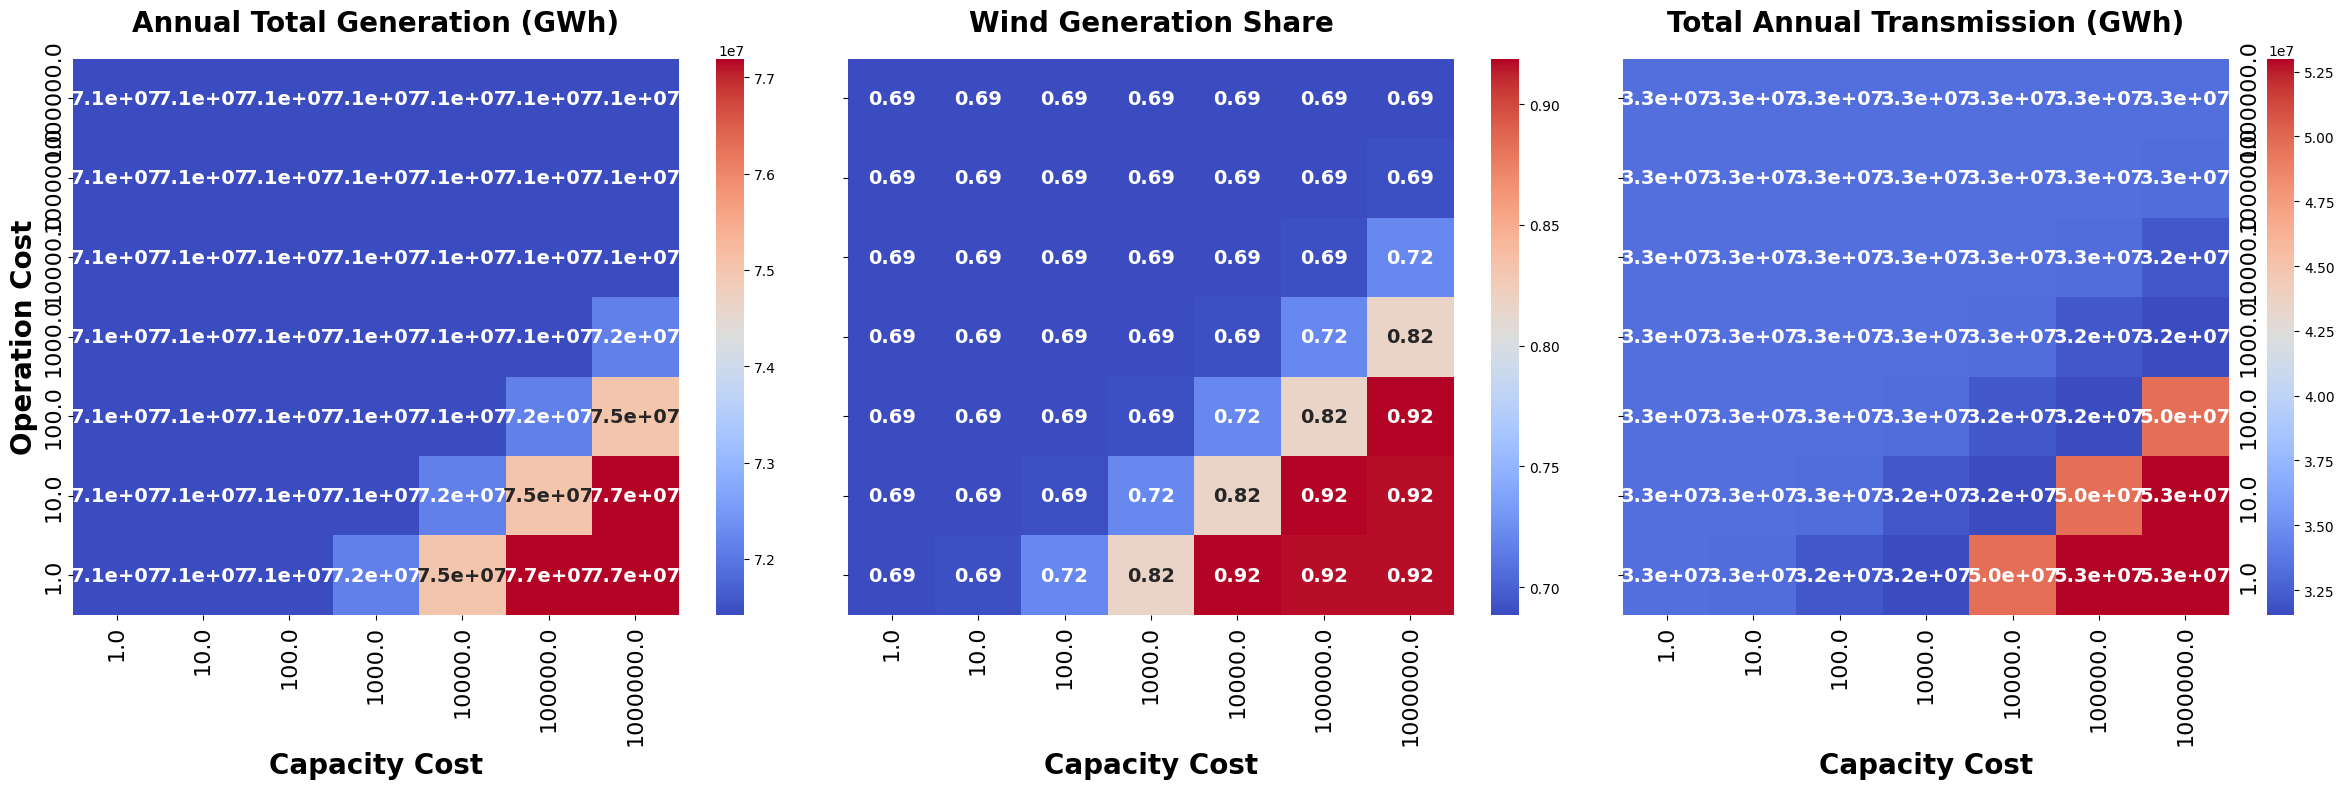

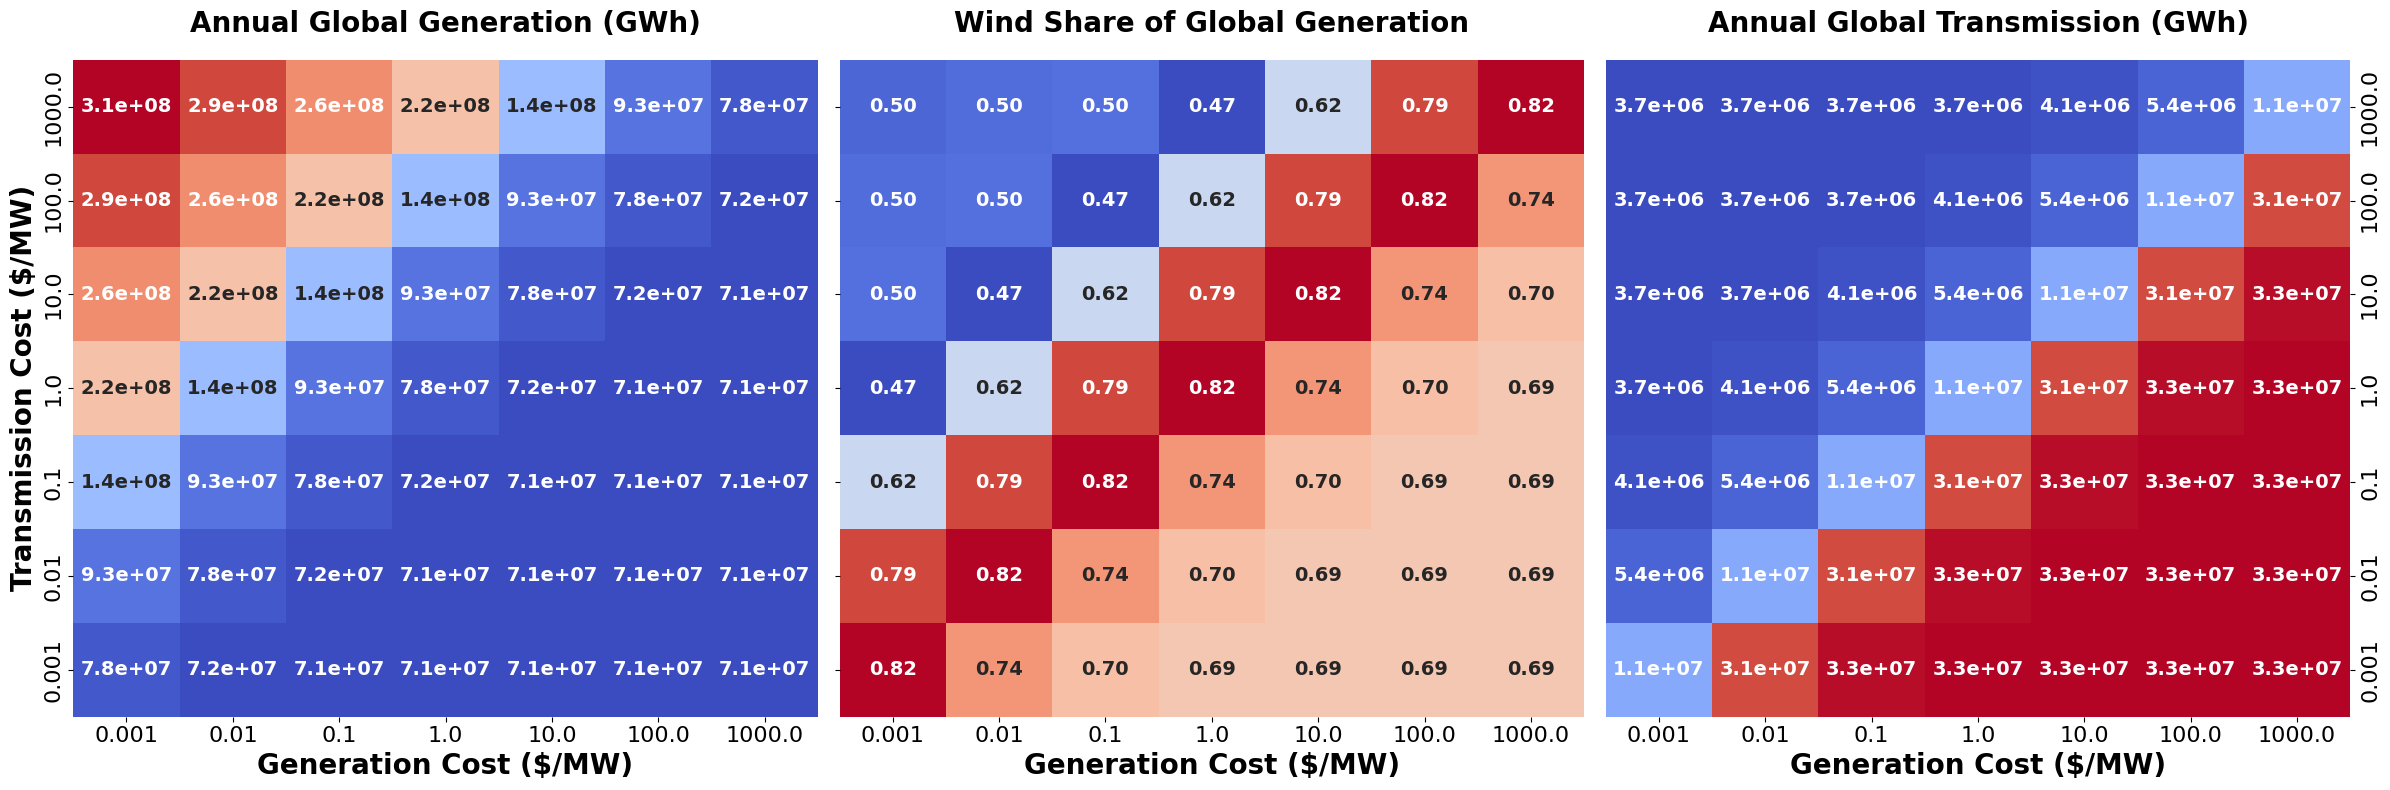

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Define costs
costs = np.logspace(0, 6, 7)

# Initialize dictionaries to store heatmap data
annual_gen_data = np.zeros((len(costs), len(costs)))
wind_pv_share_data = np.zeros((len(costs), len(costs)))
total_trans_data = np.zeros((len(costs), len(costs)))

# Populate the matrices
for i, cap_cost in enumerate(costs):
    for j, op_cost in enumerate(costs):
        comb_key = f'cap_{cap_cost}_op_{op_cost}'
        if comb_key in sensitivity_cap_op_cost:
            annual_gen_data[i, j] = sensitivity_cap_op_cost[comb_key]['annual_gen']
            wind_pv_share_data[i, j] = sensitivity_cap_op_cost[comb_key]['wind_pv_share'][0]  # Summing wind and pv share
            total_trans_data[i, j] = sensitivity_cap_op_cost[comb_key]['total_trans']

# Convert matrices to DataFrames for better labeling in the heatmap
annual_gen_df = pd.DataFrame(annual_gen_data, index=costs, columns=costs).T
wind_pv_share_df = pd.DataFrame(wind_pv_share_data, index=costs, columns=costs).T
total_trans_df = pd.DataFrame(total_trans_data, index=costs, columns=costs).T
annot_kws = {"size": 14, "weight": "bold"}
# Format numbers in scientific notation
def scientific_format(x, pos):
    return f'{x:.1e}'

# Plot heatmaps
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Annual Generation Heatmap
sns.heatmap(annual_gen_df, ax=axs[0], cmap='coolwarm', annot=True, fmt=".1e", annot_kws=annot_kws)
axs[0].set_title('Annual Total Generation (GWh)', fontsize=20, fontweight='bold', pad=20)
axs[0].set_ylabel('Operation Cost', fontsize=20, fontweight='bold')
axs[0].set_xlabel('Capacity Cost', fontsize=20, fontweight='bold')
axs[0].invert_yaxis()
axs[0].tick_params(axis='x', which='major', labelsize=16)
axs[0].tick_params(axis='y', which='major', labelsize=16)

# Wind and PV Share Heatmap
sns.heatmap(wind_pv_share_df, ax=axs[1], cmap='coolwarm', annot=True, fmt=".2f", annot_kws=annot_kws)
axs[1].set_title('Wind Generation Share', fontsize=20, fontweight='bold', pad=20)
axs[1].set_xlabel('Capacity Cost', fontsize=20, fontweight='bold')
axs[1].invert_yaxis()
axs[1].tick_params(axis='x', which='major', labelsize=16)
axs[1].set_yticklabels([])

# Total Transmission Heatmap
sns.heatmap(total_trans_df, ax=axs[2], cmap='coolwarm', annot=True, fmt=".1e", annot_kws=annot_kws)
axs[2].set_title('Total Annual Transmission (GWh)', fontsize=20, fontweight='bold', pad=20)
axs[2].set_xlabel('Capacity Cost', fontsize=20, fontweight='bold')
axs[2].invert_yaxis()
axs[2].tick_params(axis='x', which='major', labelsize=16)
axs[2].tick_params(axis='y', which='both', labelsize=16, labelright=True, labelleft=False)
axs[2].set_yticklabels(axs[2].get_yticklabels(), va='center')

plt.tight_layout()
plt.show()

# Update costs for the next heatmap
costs = np.logspace(0, 6, 7) / 1000

# Initialize dictionaries to store heatmap data for sensitivity_cost_trans
annual_gen_data_trans = np.zeros((len(costs), len(costs)))
wind_pv_share_data_trans = np.zeros((len(costs), len(costs)))
total_trans_data_trans = np.zeros((len(costs), len(costs)))

# Populate the matrices for sensitivity_cost_trans
for i, gen_cost in enumerate(costs):
    for j, trans_cost in enumerate(costs):
        comb_key = f'gen_{gen_cost}_trans_{trans_cost}'
        if comb_key in sensitivity_cost_trans:
            annual_gen_data_trans[i, j] = sensitivity_cost_trans[comb_key]['annual_gen']
            wind_pv_share_data_trans[i, j] = sensitivity_cost_trans[comb_key]['wind_pv_share'][0]  # Summing wind and pv share
            total_trans_data_trans[i, j] = sensitivity_cost_trans[comb_key]['total_trans']

# Convert matrices to DataFrames for better labeling in the heatmap for sensitivity_cost_trans
annual_gen_df_trans = pd.DataFrame(annual_gen_data_trans, index=costs, columns=costs).T
wind_pv_share_df_trans = pd.DataFrame(wind_pv_share_data_trans, index=costs, columns=costs).T
total_trans_df_trans = pd.DataFrame(total_trans_data_trans, index=costs, columns=costs).T

annot_kws = {"size": 14, "weight": "bold"}
# Plot heatmaps for sensitivity_cost_trans
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Annual Generation Heatmap for sensitivity_cost_trans
sns.heatmap(annual_gen_df_trans, ax=axs[0], cmap='coolwarm', annot=True, cbar=False, fmt=".1e", annot_kws=annot_kws)
axs[0].set_title('Annual Global Generation (GWh)', fontsize=20, fontweight='bold', pad=20)
axs[0].set_ylabel('Transmission Cost ($/MW)', fontsize=20, fontweight='bold')
axs[0].set_xlabel('Generation Cost ($/MW)', fontsize=20, fontweight='bold')
axs[0].invert_yaxis()
axs[0].tick_params(axis='x', which='major', labelsize=16)
axs[0].tick_params(axis='y', which='major', labelsize=16)

# Wind and PV Share Heatmap for sensitivity_cost_trans
sns.heatmap(wind_pv_share_df_trans, ax=axs[1], cmap='coolwarm', cbar=False, annot=True, fmt=".2f", annot_kws=annot_kws)
axs[1].set_title('Wind Share of Global Generation', fontsize=20, fontweight='bold', pad=20)
axs[1].set_xlabel('Generation Cost ($/MW)', fontsize=20, fontweight='bold')
axs[1].invert_yaxis()
axs[1].tick_params(axis='x', which='major', labelsize=16)
axs[1].set_yticklabels([])

# Total Transmission Heatmap for sensitivity_cost_trans
sns.heatmap(total_trans_df_trans, ax=axs[2], cmap='coolwarm', annot=True, cbar=False, fmt=".1e", annot_kws=annot_kws)
axs[2].set_title('Annual Global Transmission (GWh)', fontsize=20, fontweight='bold', pad=20)
axs[2].set_xlabel('Generation Cost ($/MW)', fontsize=20, fontweight='bold')
axs[2].invert_yaxis()
axs[2].yaxis.tick_right()
axs[2].yaxis.set_label_position('right')
axs[2].tick_params(axis='x', which='major', labelsize=16)
axs[2].tick_params(axis='y', which='both', labelsize=16, labelright=True, labelleft=False)
axs[2].set_yticklabels(axs[2].get_yticklabels(), va='center')

plt.tight_layout()
plt.show()


## Wind vs Solar

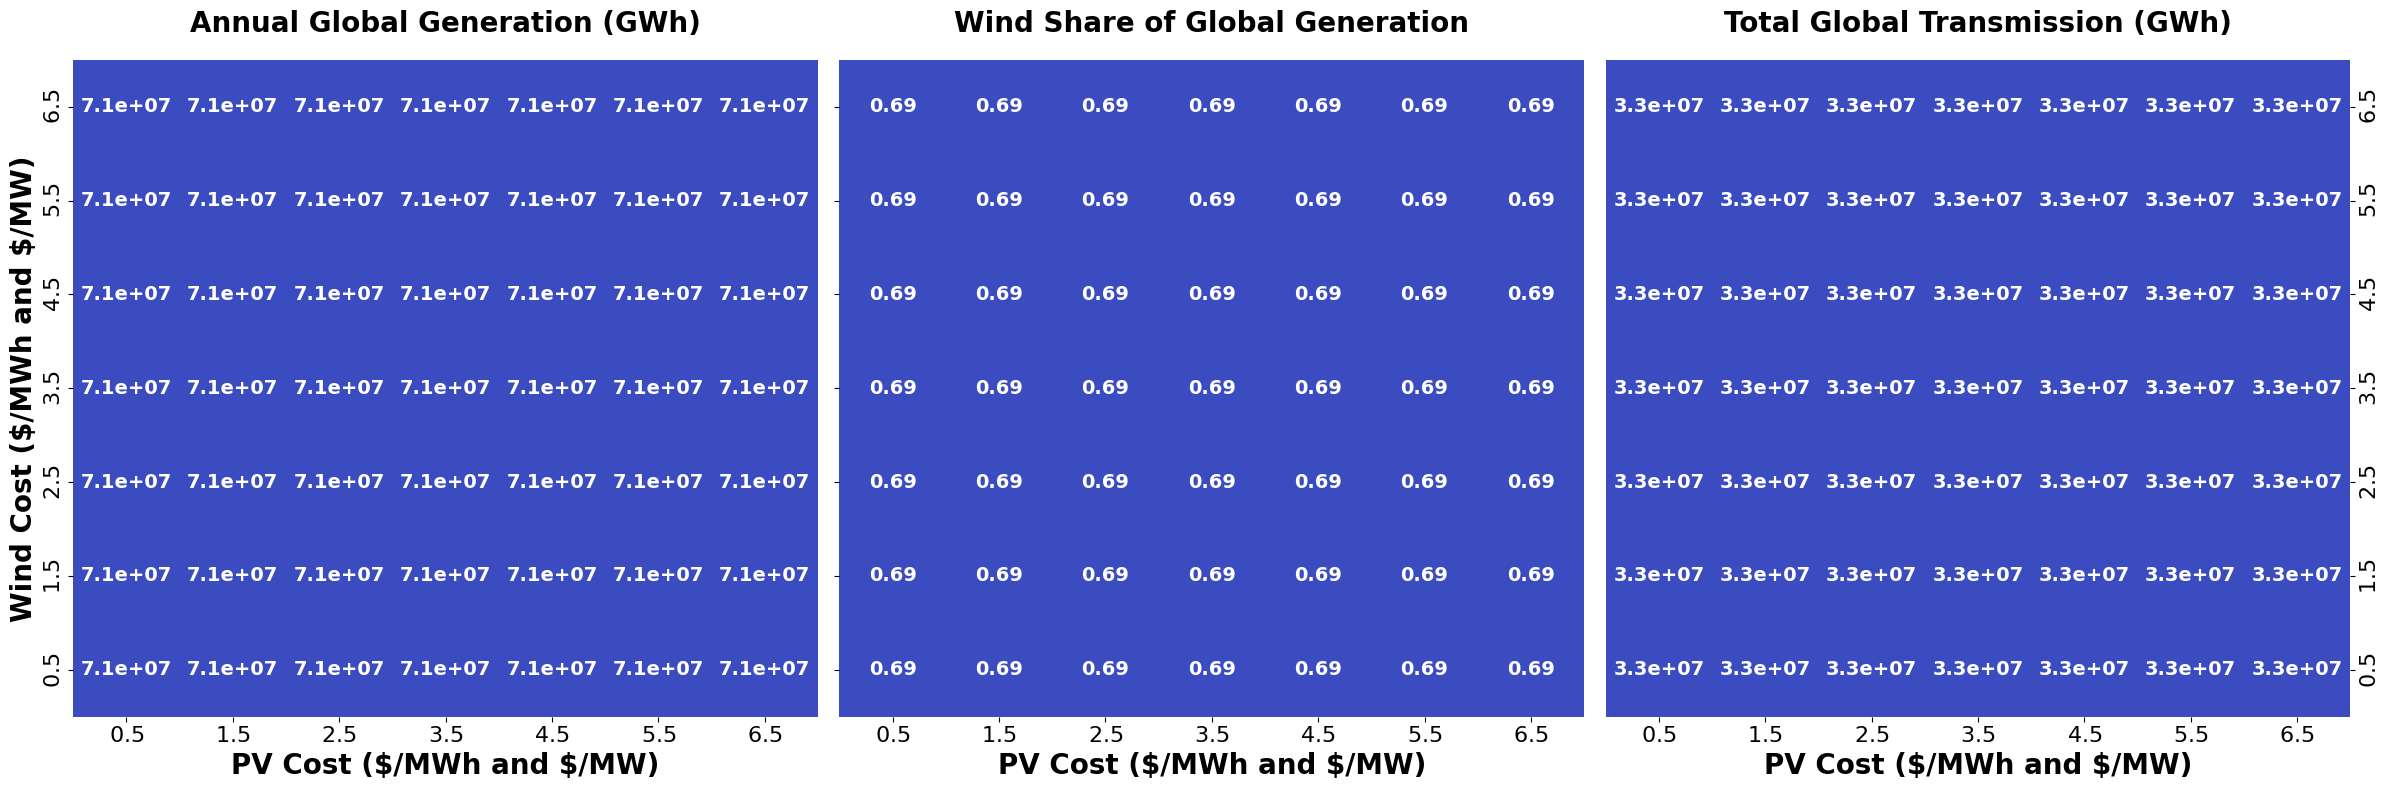

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import ScalarFormatter

# Define costs
costs = np.logspace(0, 6, 7)

# Initialize dictionaries to store heatmap data
annual_gen_data = np.zeros((len(costs), len(costs)))
wind_pv_share_data = np.zeros((len(costs), len(costs)))
total_trans_data = np.zeros((len(costs), len(costs)))

# Populate the matrices
for i, wind_cost in enumerate(costs):
    for j, pv_cost in enumerate(costs):
        comb_key = f'wind_{wind_cost}_pv_{pv_cost}'
        if comb_key in sensitivity_cost_wind_pv:
            annual_gen_data[i, j] = sensitivity_cost_wind_pv[comb_key]['annual_gen']
            wind_pv_share_data[i, j] = sensitivity_cost_wind_pv[comb_key]['wind_pv_share'][0]  # Summing wind and pv share
            total_trans_data[i, j] = sensitivity_cost_wind_pv[comb_key]['total_trans']

# Convert matrices to DataFrames for better labeling in the heatmap
annual_gen_df = pd.DataFrame(annual_gen_data, index=costs, columns=costs)
wind_pv_share_df = pd.DataFrame(wind_pv_share_data, index=costs, columns=costs)
total_trans_df = pd.DataFrame(total_trans_data, index=costs, columns=costs)
annot_kws = {"size": 14, "weight": "bold"}
vmin_annual_gen, vmax_annual_gen = annual_gen_df.min().min(), annual_gen_df.max().max()
vmin_wind_pv_share, vmax_wind_pv_share = wind_pv_share_df.min().min(), wind_pv_share_df.max().max()
vmin_total_trans, vmax_total_trans = total_trans_df.min().min(), total_trans_df.max().max()

# Configure scientific notation for tick labels
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
formatter.set_powerlimits((-4,7))

# Plot heatmaps
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Annual Generation Heatmap
sns.heatmap(annual_gen_df, ax=axs[0], cmap='coolwarm', annot=True, cbar=False, fmt=".1e", annot_kws=annot_kws, vmin=1e9, vmax=1e11)
axs[0].set_title('Annual Global Generation (GWh)', fontsize=20, fontweight='bold', pad=20)
axs[0].set_xlabel(r'PV Cost (\$/MWh and \$/MW)', fontsize=20, fontweight='bold')
axs[0].set_ylabel(r'Wind Cost (\$/MWh and \$/MW)', fontsize=20, fontweight='bold')
axs[0].invert_yaxis()
axs[0].tick_params(axis='x', which='major', labelsize=16)
axs[0].tick_params(axis='y', which='major', labelsize=16)
axs[0].xaxis.set_major_formatter(FuncFormatter(scientific_format))
axs[0].yaxis.set_major_formatter(FuncFormatter(scientific_format))
axs[0].xaxis.set_major_formatter(formatter)
axs[0].yaxis.set_major_formatter(formatter)


# Wind and PV Share Heatmap
sns.heatmap(wind_pv_share_df, ax=axs[1], cmap='coolwarm', annot=True, cbar=False, fmt=".2f", annot_kws=annot_kws, vmin=1e9, vmax=1e11)
axs[1].set_title('Wind Share of Global Generation', fontsize=20, fontweight='bold', pad=20)
axs[1].set_xlabel(r'PV Cost (\$/MWh and \$/MW)', fontsize=20, fontweight='bold')
axs[1].invert_yaxis()
axs[1].tick_params(axis='x', which='major', labelsize=16)
axs[1].set_yticklabels([])
axs[1].xaxis.set_major_formatter(formatter)


# Total Transmission Heatmap
sns.heatmap(total_trans_df, ax=axs[2], cmap='coolwarm', annot=True, cbar=False, fmt=".1e", annot_kws=annot_kws, vmin=1e9, vmax=1e11)
axs[2].set_title('Total Global Transmission (GWh)', fontsize=20, fontweight='bold', pad=20)
axs[2].set_xlabel(r'PV Cost (\$/MWh and \$/MW)', fontsize=20, fontweight='bold')
axs[2].invert_yaxis()

# Move y-axis labels to the right side and ensure proper alignment only for the third axis
axs[2].yaxis.tick_right()
axs[2].yaxis.set_label_position('right')
axs[2].tick_params(axis='x', which='major', labelsize=16)
axs[2].tick_params(axis='y', which='both', labelsize=16, labelright=True, labelleft=False)
axs[2].set_yticklabels(axs[2].get_yticklabels(), va='center')
axs[2].xaxis.set_major_formatter(formatter)
axs[2].yaxis.set_major_formatter(formatter)


plt.tight_layout()
plt.show()


## Generation vs Transmission

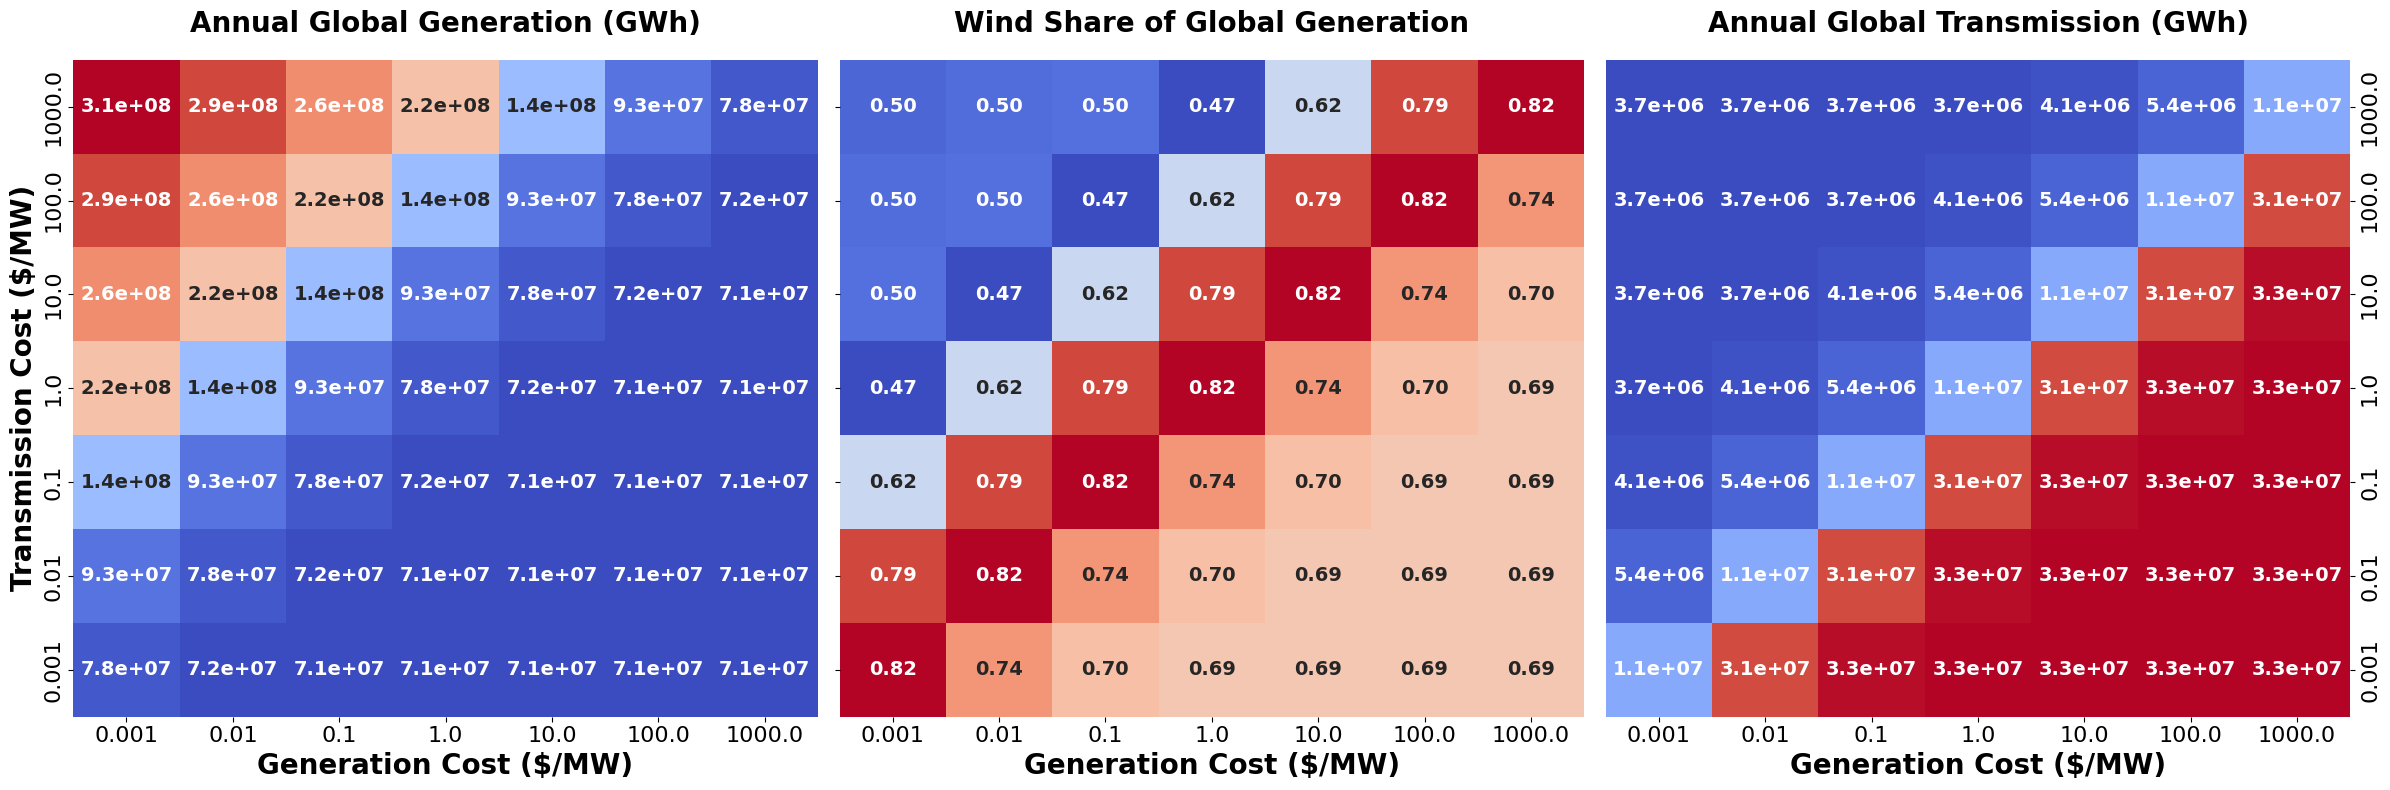

In [12]:
costs = np.logspace(0, 6, 7) /1000

# Initialize dictionaries to store heatmap data for sensitivity_cost_trans
annual_gen_data_trans = np.zeros((len(costs), len(costs)))
wind_pv_share_data_trans = np.zeros((len(costs), len(costs)))
total_trans_data_trans = np.zeros((len(costs), len(costs)))

# Populate the matrices for sensitivity_cost_trans
for i, gen_cost in enumerate(costs):
    for j, trans_cost in enumerate(costs):
        comb_key = f'gen_{gen_cost}_trans_{trans_cost}'
        if comb_key in sensitivity_cost_trans:
            annual_gen_data_trans[i, j] = sensitivity_cost_trans[comb_key]['annual_gen']
            wind_pv_share_data_trans[i, j] = sensitivity_cost_trans[comb_key]['wind_pv_share'][0]  # Summing wind and pv share
            total_trans_data_trans[i, j] = sensitivity_cost_trans[comb_key]['total_trans']

# Convert matrices to DataFrames for better labeling in the heatmap for sensitivity_cost_trans
annual_gen_df_trans = pd.DataFrame(annual_gen_data_trans, index=costs, columns=costs).T
wind_pv_share_df_trans = pd.DataFrame(wind_pv_share_data_trans, index=costs, columns=costs).T
total_trans_df_trans = pd.DataFrame(total_trans_data_trans, index=costs, columns=costs).T

annot_kws = {"size": 14, "weight": "bold"}
# Plot heatmaps for sensitivity_cost_trans
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Annual Generation Heatmap for sensitivity_cost_trans
sns.heatmap(annual_gen_df_trans, ax=axs[0], cmap='coolwarm', annot=True,cbar=False, fmt=".1e", annot_kws=annot_kws)
axs[0].set_title('Annual Global Generation (GWh)', fontsize=20, fontweight='bold', pad=20)
axs[0].set_ylabel('Transmission Cost ($/MW)',  fontsize=20, fontweight='bold')
axs[0].set_xlabel('Generation Cost ($/MW)', fontsize=20, fontweight='bold')
axs[0].invert_yaxis()
axs[0].tick_params(axis='x', which='major', labelsize=16)
axs[0].tick_params(axis='y', which='major', labelsize=16)

# Wind and PV Share Heatmap for sensitivity_cost_trans
sns.heatmap(wind_pv_share_df_trans, ax=axs[1], cmap='coolwarm', cbar=False,  annot=True, fmt=".2f", annot_kws=annot_kws)
axs[1].set_title('Wind Share of Global Generation', fontsize=20, fontweight='bold', pad=20)
axs[1].set_xlabel('Generation Cost ($/MW)', fontsize=20, fontweight='bold')
axs[1].invert_yaxis()
axs[1].tick_params(axis='x', which='major', labelsize=16)
axs[1].set_yticklabels([])

# Total Transmission Heatmap for sensitivity_cost_trans
sns.heatmap(total_trans_df_trans, ax=axs[2], cmap='coolwarm', annot=True, cbar=False, fmt=".1e", annot_kws=annot_kws)
axs[2].set_title('Annual Global Transmission (GWh)', fontsize=20, fontweight='bold', pad=20)
axs[2].set_xlabel('Generation Cost ($/MW)', fontsize=20, fontweight='bold')
axs[2].invert_yaxis()

# Move y-axis labels to the right side and ensure proper alignment only for the third axis
axs[2].yaxis.tick_right()
axs[2].yaxis.set_label_position('right')
axs[2].tick_params(axis='x', which='major', labelsize=16)
axs[2].tick_params(axis='y', which='both', labelsize=16, labelright=True, labelleft=False)
axs[2].set_yticklabels(axs[2].get_yticklabels(), va='center')



plt.tight_layout()
plt.show()